In [171]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import torch
#import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sn
import geopy.distance
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from sklearn.model_selection import train_test_split

In [ ]:
# Feature nan handling
# seller: new feature with nan
# area kitchen and living: knn interpolation über longitude und latitude
# - > durchschnittlicher prozentsatz von area total der 4 nächsten nachbarn
# ceiling: us benachbarten wohnungen übernehmen wenn mehrere Wohnungen im Aus aus der mit dem niedrigsten Stockwerk
# bathrooms shred/ pivate: mean aus benachbarten Wohnungen
# windows cout/ stree -> introduce one new nan feture for both
#condition, loggias, balconies: if nana -> 0 weil nicht vorhanden. (unmöbliert)
# phones: nan -> 1
# new: fällt weg
# longitude, latidude: 4 outlier, 2 nan: special consideration
# material: interpolation mit den örtlichen nachbarn
# elevator -> those who have none -> have no elevator -> 0/1
# parking -> new feature for nans (option or count it together with ground)
# garbage_chute: none -> not garbage_chute existant
# heating: new catecory

In [412]:
apartments = pd.read_csv('apartments_train.csv',delimiter=',')
#'/kaggle/input/moscow-housing-tdt4173/apartments_train.csv'
buildings = pd.read_csv('buildings_train.csv',delimiter=',')
#/kaggle/input/moscow-housing-tdt4173/buildings_train.csv
data_train = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

data_apart_train, test = train_test_split(data_train, test_size=0.2) #data_train =#
#print(data_apart_train[:5])

X_data_train = data_apart_train
#print(X_data_train.shape)
#print(X_data_train[:5])
#y_data_train = data_apart_train['price']
count = 0
#print(y_data_train[:2])
print(X_data_train.isnull().sum(axis = 0))

id                        0
seller                 7077
price                     0
area_total                0
area_kitchen           3764
area_living            3091
floor                     0
rooms                     0
layout                14078
ceiling                8839
bathrooms_shared       3100
bathrooms_private      3100
windows_court          6460
windows_street         6460
balconies              8396
loggias                8396
condition              7812
phones                   64
building_id               0
new                     219
latitude                  0
longitude                 0
district                108
street                    0
address                   0
constructed             639
material               3151
stories                   0
elevator_without        289
elevator_passenger      289
elevator_service        289
parking                5432
garbage_chute          7022
heating                6484
dtype: int64


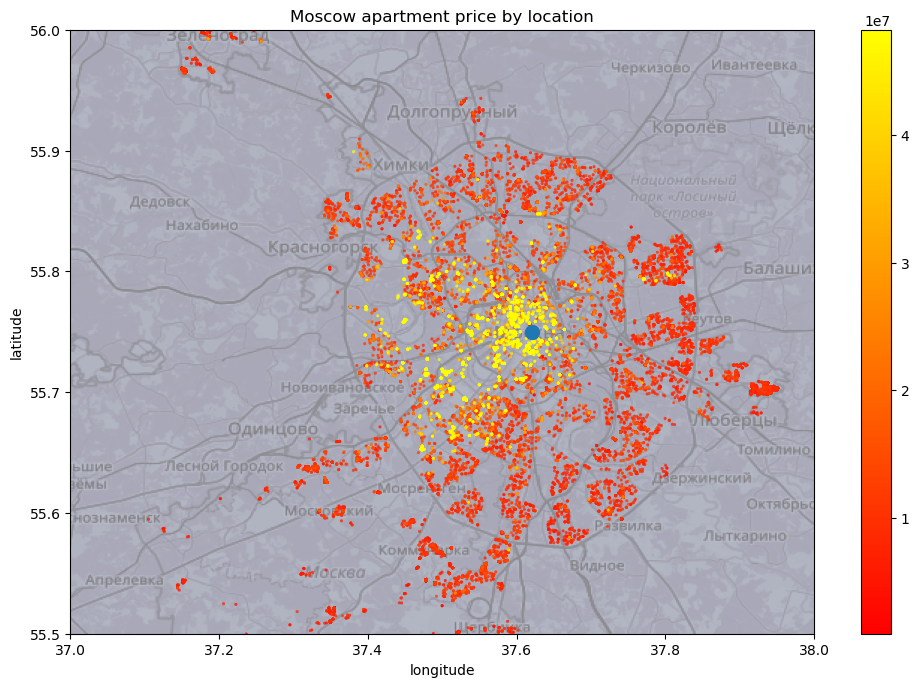

In [413]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('moscow.png')
    #/kaggle/input/moscow-housing-tdt4173/moscow.png
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None #extent=[37, 38, 55.5, 56]
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sn.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    #ax.set_xlim(37, 38)    # min/max longitude of image 
    #ax.set_ylim(55.5, 56)  # min/max latitude of image
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    plt.plot(37.62,55.75, markersize = 10, marker = 'o')data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA5cAAAKvCAYAAAD+yzuRAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9d7htTVYWir+jaoaVdjrhO1/qDN1AS86K2rQ0goAiiGREMEe83gcwASYULnpREH+iQoNcgiISBSQKSFBEoAlN07m/fNJOK8xQVb8/Ro2qmnOttfc+53ypu+d4nn3OWnPNWWlWGPEd5JzDQAMNNNBAAw000EADDTTQQAPdC6nnugEDDTTQQAMNNNBAAw000EADvfPTIFwONNBAAw000EADDTTQQAMNdM80CJcDDTTQQAMNNNBAAw000EAD3TMNwuVAAw000EADDTTQQAMNNNBA90yDcDnQQAMNNNBAAw000EADDTTQPdMgXA400EADDTTQQAMNNNBAAw10zzQIlwMNNNBAAw000EADDTTQQAPdMw3C5UADDTTQQAMNNNBAAw000ED3TINwOdBAAw000EADDTTQQAMNNNA90yBcDjTQQM8LIqLPJyLn/1614Xciojf633/6WW/gQGtERBMi+opN7+v5SET0e31795/leh0RfcWzXOdPE9FvPAv1vJWIXvtM13OBdnwWEX3Rlt+e9fEfaKCBBnp3pUG4HGiggZ5vdALgCzdc/4MAXuZ/H+j5QRMAXw7gVc9xOy5Kvxfc3v1nud6PBPDvnuU6393oswB80ZbfhvEfaKCBBnqWaBAuBxpooOcbfReATyWi3d71LwTwCwDe/uw3aaCUvBV5/Fy34/lM6Rg5537ROffIc92md1caxn+ggQYa6NmjQbgcaKCBnm/0Hf7/z5QLRLQH4FMBfNOmB4joEhF9AxE9SkQ1Eb2ZiP4xEZW9+z6NiH6JiI6IaOHv+6bePftE9M/8bxURPUVE/5WI3utO6iOi/0REv9kr+we8i96nJdc+yF/7pLMGhYi+3Lf9FhEdE9GvENEXEhH17nsrEf0gEf1xIvp1Ilr59v213n0j389f9eNxi4h+gYj+2Ia6HRF9PRH9BSL6bQAVgD8F4Lq/5csTl+bX+me+wn9/Pz8WUsc/J6KMiF5BRD9CRCe+zV+8od5dIvoaInqLH+dHiehriWi6pX2fS0S/7d/trxHRJyb3fAWA/8d/fQud4YKdPPNaIjololcS0U8Q0ZyIrvu6Jhcco41umUT0EBF9IxG9w/ftMSL6biK6dqf9P4uI6PcT0S8S0dI//w+JSPvfiIh+l4h+dMNzM//O/tVF60qefSERfZtfO5V/J3+TiFTvvpKIvsz/viKim0T0U0T0e5N7/jIR/Ywva05EryOiLyaiPLnnpwF8AoAXJe/VJb9vGv/fQ0TfR0S3fd2/SkR/qnfPq/yzn0m8vh8jXns/TkSvuNNxGWiggQZ6d6DsuW7AQAMNNFCPjgF8N4AvAPBv/LXPBGDBVs0vSm8mohGAnwK7zH45gF8H8PsB/C0AHwBmOkFEH+mf/y4AXwFgBeBFAF6dlLUD4OcAvBjAVwH4JQAzAH8AwAMAXn/R+gD8OIA/QUQPOOceJ6IM7Nq7BPAaAP/J3/cxAFoAP33OuLzYj4dYbj8CwNcBeAjAP+jd+wEAvtb38wkAnw3gXxBR4Zz7Gn9PCeASgK8B8CiAwrfle4joTzvnvrVX5if7fv4DX+YtAB8H4EcA/HtEt8Prvef+I4Bv821/DYAvBpD7ur7B1/9ZAL6KiN7onPsegOM5Afx3AA8D+ErwOL/S1/++RPQxzjmX1PMJAD4UwJcBOPX1/BcieoVz7s2+fZcA/FUAnwLgcf/cb+FsygH8V9/+fwp2rf274LnTVwj0x+ipTQUS0UMA/pcvW/p2GcAfBnAA4Mm76P8muh/Ad/p2fxl4jP6ur+OvOOccEX0dgK8lovd0zv1u8uznAdgFcEfCJRFdBfDz4Pn09wC8FcAngt/zywD8JX9fBuCHweP1tQB+EsyTfASAF/oy4J/5dgBvAVADeH8AfwfAe4H3CPgyv9Hf+8cv0MZX+PKfAvDXANwE8DkAXktE15xzX9175CsB/A8AfwY8Jl8F4AeI6L2dc+Yi4zLQQAMN9G5Dzrnhb/gb/oa/5/wPwOcDcAA+BBzD5wC80v/2PwF8s//8GwB+Onnuz/t7P61X3hf766/x3/+m/753Rhv+nr/nY86456L1vcx//1z//ff5718F4M3Jc/8NwP+4w7FSYEb87wG4AYCS394KFsTfv/fMfwNwBGCypUzty/x3AH6l95sDcAjgoHf9iv/tKzaU9xX+t/+rd/3/+Ot/PLmWgRn9/5xc+1IABsCH9J7/VP/8x/fa9wSAneTaNf/8lybX/m9/74svOM6v9ff/td71v+2v/77zxij57SuS7/8eLCi99xl1X7j/W57/aX/fH+1d/0Zf7gv99x2wQudre/f9JoCfvMAYvRXAa5Pv/8TX+2G9+77Bz8uX+++f6+/7M3cx7z8XrJA5SH77QQBv3fJcf/y/A6xcekHvvv8KYA6/RyDuQz/Uu+/T/PWPuGjbh7/hb/gb/t5d/ga32IEGGuj5SP8dwJsAfAERvS/YIrXRJRZseZyDrZ0pvdb//4f8///L//8fiehPeutRnz4ewBuccz9+RtsuVJ9z7k1gxvtj/PXXAHgd2Ir3EiJ6GbEb7UeBrZxnEhG92rvjHYGFgwZsxboM4L7e7b/pnPu13rVvB1tdPigp89OI6H8Q0SmYWW/Asa3vvaEJP+mcu31eOzfQD/a+/zaYMf9hueCcawG8EWwNFPpEsCLhV4ndaDNv7fpR//yreuX+lHMugD05554EC6wvwr3T/9f7/u3+/4/uXb/oGH08uL2/fcY9d9r/TXTinPv+3rVvBwtpfwAA/Jh9M4DPF3dbIno1gPcB8PUXqKNPrwbwW865/9m7/loAhOgp8PFgAW/buoZvywcS0fcT0U3Eef+tYGXIy++ifdLGn3DOvWNDGydgAKCU+mP46/7/p2NuDTTQQO/GRER/gDhk5jHvhv/Jd/i8hKD0/+bPUJPPpUG4HGiggZ535JxzYIb3cwD8BbDA97Nbbr8M4An/TFrGU2CB6bL//jNgt8UMzJw+QkS/QUSfmTx2FcB5wB8Xqs/TTyAKtx8D4Mecc68D8KT//vsAjHGOcElEHwa2PALAn/XPfSiAf+yv9cF1nthQjFy77Mv8FLDL6qPgcf5IRCF+tOH5xzdcuwjd6n2vASycc6sN19N6rwF4P7Awkf6dgIWUK73nb26ou8L62Nwptc65ftmdsUzoomN0kXl2p/3fRE9uuLap7V8HtmB+tv/+V3z7vu8CdfTpMjaPw2O9eq8CeMw5Z7cVREQvBPCzYNfvvw52of1QAH/Z33K37/aibRTqv//qHusfaKCBBhKaAvg18L57N/Q14LCd9O+3EENvnnUaYi4HGmig5yu9FmyZ+wvgGKttdBPAhxMRpQIfEd0H3uNuyDXn3PcB+D5vMfwIcJzktxPRW51zvwCOF3z4nHZduD6wcPmFXjj8cAD/yF//SbAl80Xg+MBfPKfOzwALFp+YCmVnaDjvP+OaMMqfA45j+/ReP8r+g57Oi+97uukGOD71C874/dmgjIgu9wTM/lgKXXSMLjLPno7+X9twba3tzrk3EtEPA/jL/v8/CuDL3d3FE94EMzd9etD/L+2+DuCjiEidIWB+Mpjx+hTn3NvkIhF9wF20627aONBAAw30jJJz7ofhPXmoi88Hf60A8w6fDU6j9RsAvsQ599P++VMwHyH3vz/Y8+QvPLMt306D5XKggQZ6XpJz7lEwuucPAPiWM279CTDozif3rn9e8nu/7Mo5998BfIm/9IH+/x8G8HLvFvh01PcTYIHjH4LjzX7GX/9xsEvlawD8jHOuOaM++DJasFsgAIA4zcXnbrn/lf6ASemzwFavX0nKrHuC5f0A1tBiz6Bn0oLzg+C41ZvOuV/e8PfWuyjzbtv72b3vn+X//+m7aAPA8+yjz0EcfTr6v0NEf7R37bPQnYtC/wJsKf0W8Dz7txfpyAb6CQDvQ0Qf1Lv+eeA591P++w+DLdWff0ZZMjflvYGY+/qzG+69Eyv1TwB4NRE92Lv+eQAWOF/ZM9BAAw30bNE3g72VPgO8R/8nAD9CRO+55f4/g7O9vZ5xGiyXAw000POWnHNfeoHbvhXsJvctRPRicFzjR4FBV/6rxE8S0T8AW4t+Auzytw92tWvAMZ4Ao1Z+Oti6+U/BQEJjMMrrDzrnfuqi9fn2P0VEvwHgY8Exdgv/04+DkUsvAfi/LtDHH/L3fTsRfSPYbe//RsJ09+gxAN/v0y88DrZSvgas7ZQ2/CCATyGibwDHj74ADBD0OIBth1aHnHMnRPQ2AH+MiH4C7AJ74y4Fvz59LRi85meI6P8Fx7kpMJLoxwL4Z865X7rDMl/n///rRPQt4Hf/O2ms5gaqAfxNIpqB43YFLfaHnXM/d4f1C30ZOObwZ4joK3279sHou//cOfd6PD39vwngX3v30jcA+CNgwexfO+c6+WKdcz9GRL8FVnp8m3fzvhv6f8FC2g8R0ZcBeBsYpfYv+Xrf4O/7DgB/GsD/zwvZP+X79+EAfts5950Afgw8/t9BRF8NFkb/Ihjttk+vA8/nvwjgfwOwzrlf3tLGvw+Oaf0pvy/cAisQPgHAFzvnju6y7wMNNNBATxsR0cvAaPkPO+fEbf9riOjjwPvn3+7dX4L3sn/6rDa0T881otDwN/wNf8Ofc1202HPu66DF+muXAPxrsFDVgIF0vhJAmdzzCWA0yEfAQtmTYKHto3pl7YMZ+7eBGdsnwYLYK+6kvuTef+779bd719/gr7/vBcfnTwN4PRgE5U1gNNEvQA/91LflB8GCyW/4vr4FwN/YUOaX+N9W4BiNPwOP8tq7zwH4+i3t+kNga+jK3/daf/0r/PcrvftfC+B0Qzk/DeA3etemYKvv630/DsFC1j8HcO289qGHZOqvfSU4ztT45151xpi/Fuxu9L5g4WcBFti+AcD0DsZoDVEXrOj492BhvvZt+i4A991p/7fU+dP+/f9BsFC88vP1HwPItjzz5b6tH34H63bTGL8QDIJ0w/ft9WBliOrdNwILem/w/bsBVv58ZHLPJwL4VbCL8CMAvhoshHfeHVjg/E8AboMtsy75bdP4/x4wUM+hr/tXAXx+755X+Wf/RO/6i/31z7/oOA1/w9/wN/yd9+f3lU9Ovgsy9WnvrwHwXRue/0z/2/3PZT/IN2aggQYaaKB3ASKit4KFtE98rtvyzk5E9FqwYDF7rtvybBAR/TJYKPvQ57otAw000EDvbkREDpym63v9908HK+peiSQsxtOpc+6J3vM/AeDYOXduvt9nkga32IEGGmiggQZ6NyUi2gVb8T4RwAcDeE6ZkoEGGmiggQL9H3DapfvcOTGURPQScFhDP87+WadBuBxooIEGGmigd1/6ILDL700Af1805gMNNNBAAz3z5OP53yO59BKPiH3LOfcGIvr/AHwrEf1NsLB5BZyr93XOuf+aPPcF4DCLH8ZzTINb7EADDTTQQAMNNNBAAw000LNMRPQqRBTtlL7FOff5RJSDQeQ+D5zz9yaAXwCni3qdL0OBcSK+1Tl3Vuq2Z4WeU+HSIxl+ee/yk865+5N73hvAV4FBCRSA3wTwJ10P6a5X7qeCQRBeBga++DvOuf/y9LZ+oIEGGmiggQYaaKCBBhpoIKHnQ57L3wQnM5a/95UfPATvz4GR5l4F4P3BQuNqrZT4zEeCEff+g7//PwD4j0T04c9M8wcaaKCBBhpooIEGGmiggQZ6PlguP9k59wFbfv9OAI1zblui8E3PfBeAXefcxyfXfgTAbefcZ95biwcaaKCBBhpooIEGGmiggQbaRM8HQJ/3JKLHwHmmfgmcC+7N3n/4EwB8NRH9KIAPBOdj+yfnAA58JDiJc0o/CuCLtj3gk46WvcuXwImVBxpooIEGGmiggQYaaKDnnnYAPObeCUFjiGgEoHgOqq6dc1u9Pp9ueq6Fy18CB6i+AcA1cMDqzxPRKwHkAGbgROF/F5zs++MAfA8RfbRz7r9vKfN+cNLzlJ7017fR38J67OdAAw000EADDTTQQAMN9PyihwE8+lw34k6IiEb334/lE0+cf+8zQE8Q0UueLQHzeYUWS0RTMADPVwP4TvDE+Q7n3Gcl93w/gPk2F1ciqgH8KefcdyTXPhvAv3fOjbY807dc7gB45Bv/7XdiOpuBFPFV59DULawxMMYiyzTS8XMOIAKyIsfi9ASLxQnatsHe3lXsXtqDNZZv4krRNi1M06KqlsjzEbI8g3MOztpQFgAYY/DUk2/F3v59mE53fV0Od/vqKHYnfCciOOdgrUPTrGBMC+cstM6hlQZIgeTBDeScgXMObHCmjfcqpaEUQWmNuqpgbQMAKEfT0HcifpYUoV5WcM4hyzPoTIOUgoPDk4++A4vFEYwxeOihl2O6N4U1FvPjU6xWc5ye3vL15djZ2cPu/mXkRQ7rLBQpNHWDw1vXUdcVrI05afO8wM7OZRTjAkopwDl8+Nf8ZVy6+TYssinytsHJ7hX8/Bd8OV7znV8K3VTI5kvg1ME5wjs++GPxfz7pC+G0htIaTd3AmBp1XWH/4DJ0kcFZh+XpEk2zxGJxCucsAIJSCru7V1COCuSjAm3TYjVf4vDwemcsldKYTnZwcN8VPPnoI3AOGI2mOD29DWNawAGj8QRFMcFkNkXbtIBzcM7h6OgmXvprP4UP+x/fC6cUfvpjPx+3XvGh2Du4DKUI1jqAgLZuUa0WmM+Pw/gQKUynu9i/chnNqoYxFs7au5x/BFIKSitUywrL5TGOjm4gz0tMp7uY7RzwfLQWF9mfjDEAeIy0VlBaQ2kFrVWc7ELOoW0N4Iu11obxScfZORfamGWay3EOpreGeb3KvA1VhHJBcS3oXIf5fU/knDQ/rFs4brNpDZy1MMaGdZ3lGax1YW9JqW1bOOcwmozhkntCG32/AxHPVZ1p7q/0J+mSbS3vka3pvD9SKrbfX+8VfeaeZkyL09NDtG0N5ywUachIWGtgTIMsK3H58oNrr533pORbry1pvUpRaIzOMyilQATUVQPTGhjTQikNrRWyIg/ng7MON556HKZtoLMMB5euQWuFpm5D/3is+H5rzl4/RNzO/jujMP5x3OO782Pr+2WtjLPj9eA/KxXXxqZ1HOYVwjBtJN6XeQ5sXG89cs7FqbLlXmstnLGdPSY9D4ko9OuilI59uv50ruGsgzU8Z7c+r/j80xmfYaQUj70DHBxMY2B9e21nPLv7Ql7m0Lnm8U8orGFrO2tbHgz7jl9/pCiMu/Pv2jTGv1fAtia0OfAvvizrX6ZK1wD8VErmZtoW+D1NeJNN4xs/8zjLfCDFbQ5zVArw8zOdr2t7MNH6xkCEuqpw+/YTMKZBUYxx9b6H0dQNrDWwtk32WdVpFyV8TKyq+47atgERIc9zHncgrB1rLZpmhaIYh7E/PLwOgDCZTDEaz6C04vWWaR5TRcCm6eoc6qrp9E32orXxlM9KbdzHt1ExKvn9E+/Lvrsg/kemcCDbGljrAo8r9Uv/Zf5JW2UfIgJIq3AOWWtDHby24vqSeWmNOZeHVVqFeSK0XC7wl//y5wLAnnPu+EID8Twhn1P46B3vAHZ3n716j4+BF7wAwLM4Zs+15bJDzrk5Eb0OwHsCuAGgBfBbvdt+G8BHnVHME1i3Ut6HdWtmWm8FdssFEBfzeDLBeDzpMBu1bnihWL+Rp1wV+La8LGDbFm1bochzTKdTjMcTuPRAJGYIbGtwekLI8xJZlgVmIjIFFsa0GI0nmEymmM52wmZ8pwestE8Wd8q8S5+tdTCmRF2vYIzhNonAh8g89BlkPogctN4+pfgZgtYaBAtrNcpyAp1lvCEnTLrSGpPJFABgWn/o+0O2LEs4NwURYTabYTQao6kbnNhbsLbyQj9A5FBVcyhcRVGUgTFYnCxRV3MYLzhppVHVSxBZZJnCZMJlr+ZLvOTW2wAC9swcMMCV24/hga//a9CXNEgDWe5g/cb7hs/8Ioy94JQXOQ5v3UDTNGjbJUajCYpRAdMaLE+OYUwNoIUigoOFtS0Ag0zn+KR//rkYr26gcQW+5k/8fZTlBIq4DqUUsjzDZDpF265gjUFR5CByYHnYommWyLIMmdrHZI/H0BqL+fw23vR+H4UnXvzeqAEsJ7vQ1SkydT/ykplkpRVWp0uslido2yUAQpblWK1OMJnwHGx0AWtsfC/J3Dp77nVOTBARyrzEZDJBUy/8/Gsxnc6Sw+f8OW6thXPM1OV5EYTXLM/CAQrwIeqcQ+uZfZlTnTWQzG+Zi1qES/g16wVHWX9yX58RC1yCLz8IKuqcgbpLcs6hqRqYlvuntfZz0QuXnX3FoW0alCWzlXlRdPaVjiDUExBJMZMN8NiSVl0mt25hjIXNIgMUyuu196IKMmMa1LUFkcFoNILWGfK88IK8gWkbVPXSX9coihEztGnbE4GJlApMkjDN3KZuvTrziopMYzTiOd/Utd//NYqyhNKKmc6qxmhUwrkCZclrRSmFPGsBz77L/gucL1yKENPfp2VuO5ZsYK0NikvX+bO98rIooCXCjU0UEdvW27b3JM9Jm0ThsK2AIDhhw31eyJG9ZZMgk7bzonOnL1im/dSZDuPXfx+pMKu0jvPeM+dBqSCCfNtlovtnpXMOWZGFtbM+RpsFfQegqZrwXfYQUXrIvmaUCbyKzWznLEWy/nhvQhCCZA6JsArHCrtwHifKE9mTN72XznevAFFaYdtu55K5K3tTuk/0125KWhFOTzRGoxJlOcVsZwdt3cAYVjKF9SK1E0CkEp4tiNOhfH7GwdocRHzuiYCrsyys+zzLMJpM4azFarVAWZbIsgK7u5eQl0XYV8Ja6EtwyQBkOgqXqcJtk7CetrM/T7a9j3xUQPnn27rtnXX+f+dYIZupcL5ZY2GaNpytMnZK+31fFEp+PcBh87nmlS+2jfyC7GtNVZ+5hsNeeZe87vOZdnf471mj52D4nlfCpbcgvjeAn3XO1UT0vwC8onfby8G5XLbRLwB4Dbpxlx8L4OfvuEHJgUhiLUgObd54gDUBU8nhZ6GUDvd2y+bNXSkFRQrWGrQta5qci7uRMS2apoqPXfRE3UBEzOBm3grYNm04xDv36BxlSTDGoG1rtmJa6xkyDSIFrXRgUIxpoFTGFs4zSDS63B+HLCswnk3QVA2s33icNIIImhSMsVicnMA6g7ZtsVye4PT0EEppPHD/S1CMShhjcHjrBo6OrgMArl59GABQVStcv/52FPkITbOPy9fu4zqsxapaYG/3CsrRFJPJDI8++kYY07L1D0CzqvHoo7+LVT7CqFl1FqduKmiXwSmFw8svQbl8Cr/7svdDYy2yjJmHrMjQtg3qeoW6Zi8EayzmJye4eesxEGlcufIQJpMdVNUSN288iuvX345qdRnj6gaggBw13u91/x03/vAXBE2pUhnyIgvjWFVLVPUSDz/8cmRZgbat8eijb0TTsFX2gYdfjCzPYFqD8XiGnZ1L2HnJe+P48DbcyS3cvv0ETk5uoqhGyLICOwd7cM6hqhbIsgLT6R7296/iTW/61ah53CJFnjc143pBYCR1nmFcFnx4NzXqepkcspGJSRm9WBZ/1lqjbVkJUxSlH2uDFn6NecVFKlzxWHoLSO+wFmtfWNYdzTHPSwegXVbBSqq0gmm99cILaQCCgBP+4CLD83SSY0WV1J9lGbIiZ80vAKUJ0AqyQq21qKsVsqwIbY9jHBmavtAlCmzTGhYslUKWidofMA1bLPvMgHPx/XeEPDp/3gDA6ekh6noJANjdvYyyHKO77zrcuPEo6nqFo6MbuHr1YWRFHsc9sZBEC5Qw55oZrw2W8tTSojJvyc4zrBZLWGuwXJxiMtuBbQ2Oj2/6OTjCbLYX+sl93MTInk9sodKh/UE5QUBbtd5KbXAR7iEVBDcqEpC+iygGnqU0Cu/VGVh/nq3LjBfrq3UOzlj2tsDmecHX4ty5UyIi9iBI2+8tl5vqEgGBVGK98QyzrGMRWFXh17rRQQnTLc919i8R7IRfgHXBe0SsPsESlLQv/axUupYIrGPo7ptkbBT0iEAgOEr2WD/mIkCzsoH7nOVdFrGpHNwGC29an3MArAWgu7/39nAgWZfy3W+dSnXXC+8ncU5ar8wuyynKcsw8hDWssCzHgTfpWvFt4MvSM4brteEepRSU4n4rHT0E2qYGABQle5k1VY2qWoA9vDRG0/HauPhuRUoFTWJl7ibFRipgirU/VQile8iZAlpwbThbMZAh7m9KKyAHbJ6hqRo0deXHx1scrYUCrXniuL4ASF7gtOwhkHm+ReY+1QR55wO969FzKlwS0dcA+AEAbwdbF/8ugF0A3+Jv+X8AfBcR/Qw4wejHAfgkcFoSKeNbATzqnPtb/tK/APAzRPQlAL4PwB8D8DE429q5kZTWQRNo2ujm1des9QVM2bAAdrXUmi0WIkDFXYMPqbwo0bYNTNtAvHNlk27bGnW9ihbBZNc5jzETDZEIIwCCOw8RISvYFdV2Nlp5VkMpjSzLw2/GiNuJRVU3Xsh2INIgasIYbBc+rD84IsNtmtYf9qyJDxuUYytltVzh8SfeHDZ/Y1rkeYnxeIbRZAqda1SLCrdvP+6tFiWItBfsFcpygvniCA4Ol+5j4dJaFkTGkx1Mp7soxiW0zoI7DMDugovFMb75L/1LvPJNv4bxaoEP+dHXwhkHvadglYLVOW59wEfiez/hw2GtxQOmQZZl3PamhbVdy1tT1bh581FkWYHJZBf7l68AAIpxiZ29fbzxDb+Kql4Cci474M33vRj3jWbstuiiJpnnIlAUY+zv34eyHENpjSzPsbt7GVW1wOnpbVjzQlDBGvpLV68Fq0BZjlFVIxAp1HUFObAXxzkWixPU9RLT6T4m4x2MZuMOI6Uy5Rme891aziPbsob84OAaTk+PcHp6iBvXH8V0uofZzm5gNP2U8PONgvU9zLeW56ZYJ0RgbBNGSNoqB6j2wla/CxutKp0bCORc9ACQfUARVC+7U1+QWBMs/TwPQmGedfYcUsSa522uVVIMwG6EjhnDfMR4AaKJDuV4DXbbiDBlASeHPHUEy3TM1uqzDlB3LiaLMMJjg/D/tnqsNVit5qiqBQDC5csP+T2JOmUAFPbZpl55QYzgN7ugzGi8GxpbS1IlhvPMHnUsZh035oSBLkYlTNNiuTzF4uQEranRtsx8ZlmBye4Uy9NlEM6V6lrbznON5ia74KYmWnxrDGCAtnZeqEwatr20YH2RdZsKvl1L4HpZKaMr3zfdIwyy9sJwapUSyooc8FNZJYU664Ir7FnCd2S4L9LvnjIq+T8tSBQwfU+MtIx0TchcstZ254fUp9dDSJx1aJs2XI+W2bifAdjomkteCNlkye0qcdYZdRH0rPGKOHFjdqnVkNvgrIWzCFYseT9s2XdbrckAouDqhUKCt7ByB0AULaaO+F3bjmAp85D7YW13zvGeyHv28dFtrFZzOOfYI6gYB8FSaw2dZ16gRFC+pAK41jkrnpKxUxm7dJrWoG34LBGlsPBpEiaktPa8iEHT1ACI3eQzzWvyrGkZ5Gjmu8TjIFXw8M/RJTgq+KKgfJFzV3g9qWeTslbGxFr26BGe0BnnrdcWIhE7Z2Ha1ntNAM2qQTEqOjo+CVMQC3jHIp62ze/LYU1Sty13ozh6p6JUV/Js1fcs03NtuXwYwHcAuALgOoBfBPARzrm3AYBz7r8Q0V8AA+78SwC/A+BTnXM/l5TxQjA7Dv/MzxPRZwD4R+CcmG8C8OnOuV+608bJBA8WibCxUjj8fZ0QSwiI0FZNOPizrAjxBm1rvFaMCxe3pizPYUwLC5tsNhIDyYKQME6+wrU2bmy/jxmjROPa7d9ZzGFXUCRyAHIoxRur1iYIfEQpQ719Fjsn7iJcpiLNGwlsEAjSUrRSKMoSV648nGgYHebzIxjT4NbNJ3BFPwjnHNq2gVJ8iJyc3PJj10JcOrj+lJm0yLOi48YiJG7PzllUpsbr3vP9oVSGX37/34/7f/d1ePDR/4UPfOxXQM5i/62/jr/wi9+Hx/ZegB/5I3+DDx+lQKQwnx8GSygAH89aeRdovs/4OZGVGchbsH/o074KH/MfvwLF4RJ/9ge+Cd//ez8ZsyffhtO9q7DFCAoK5K1FSqmgAACxFa8oxmjbGqvlKQCOoVwtKpye3IJJBN6qmgPelTnLcuR5CWMatG2NpqlRFGPkxagTSyVWoKdT3eisxWg8Q13XIDpCVS0wGk3Z3dKopK6kTs/gxUOL42nkeqf8TluTeSbP2qjVFtI6xhRuoyh0xANVrEqd+4Sb3lQcdWNYiCh4SFhjoaDg9AWEOM9Iies5M4uJy2/iHtY2Ldq2RpYXHdfRjqb8nNOdmfR74wBSoWWTgMnMTIPF4hhZVvi/PNmTuq8yz0dsTWxP0bYNmjoPVoe+wmCTa5lQcHP2jJxYciQGjeBdDTONPC/RNFVgYNmzgyBWRpt0lHyfYj3nLyPrY/iIWCBIvWZ8T84Z5aSsLZ4HZwmWSNwHu+PuOtfC3VYUa9FSLA/Ju2AvAgeV81wXy2F6v7yDTZQqb8+m9H0jxCk6eKWW61q0z6JwD0WmeNv871rmu3Mu7Wdn3L00tbkZ3nJFwuRva2O/HbInqeAl1bnfC5Z9iz1bpqLrNp+H22PsiTgmMfAZ4LHp758ECgrkdO9Ox6prxYzrMAjlxgZvIPGikj0suLmnsYKdeHmx3Pm91cfzGWM5AKvTFhUt1fDng02EJDk6rIHWWY8HOp86KgGpM42RlXPMISj/7+bMNR5fwG54d6mC1jkXeBEHL/y3pvNcUOp6V1WJpySXKhUInRN42xoGx4Bb66DIdQTodQXncyAZDXTP9JwKl865z7jAPd8E4JvO+P1VG659N4DvvqfGSVlAT7AU2gDM4Q/QqlpxUDk4ljLEUbYGyAC29AHwmjOVsTAi2t8Q4wkH610187yAorhRbqJ+e5SPoZPfZGMPLjfwG4y6SIA4eRff1NWl70YWhbc+9S2+zDyINrbPvEhsEqEYF7gyvr9Trnmkxfz0ELduPY79/avezcvCGAmGj66VWudBcAqaU8+g6SwPrhppP1nrzlY5cS8V9+a3vfBleNsLX4bV4++L93/dD+HSE78BZ4GX3noDrrzpV/DIQ6+AaPrYkkFJHGoELSAv5IgCIe3/zQffA+VNdgEczWp8yj/5JDiToR7t4Sf/6tfB7F3e/Ia8hltrtjrLJt/ULY6Pb+Lw8CkA8IKtDu7WYvEtyhGq5YKt6KZhq3umO9px0UgCXjO6RZN9UZL3VJQF8pyFh6ZhK5BtbdTeJgxgFJjiIU1E0EoHtyYGf8KGteKZs6SsGHMVmW8BPDlPfBKLV7SIoCtBSv1nxFmyVdGDIXiFkwiLTpFfs/2H1svrCInOeW27C58BAllWuhjToihHYQ6ucQGp5Le18xvW+h1OhrOqadsGdVOhrlfY3bmEspwEJq77DL/ToijhnMVyeYq2rdDUGbSO+1VginzF21zEUrAfYfI64QNEUBmDduUFx6eLMkrrEtpbNpRWkQETpQEuziw5hwCoJQqxeyFjTIibSi15sTkXUBbIHt3/nli54LoxUspbLpQAfkjsXhLvuBb/n5TbGa8Lz68uSIuUJUoXWe/d4jasg6Reax1IxXLuNHaaIMqCbh/CGtjSNxFAo5X0gpYrLwykoEtSIM+tKFh2yvOWSt57omC5qc4ga3kB9kyZX4bLilUO3oKKuIeSQwwLigKmtJuthVVUuIf9IFEge0FdhEuldXAJFSWiaU3gjVLrusw1JTHZXqlEZGHJxHoCOJH1Xl7d+O4OJdfTPUCUtOH9+jhaaZesEyTPbFKsbSXnordc+hoozmGdaf+O4UF8ojAqf7Iu2OqrwrvjsTMgKGjSkad0CY/QW098HvFnjgX2VvE+cJc/g0WxdtE5P9Dzh55ry+XzmqwVFLg7c/+rKmbQQYzcCTDSYNCCA9AqGXonm5lG29belVbzAejYilaWY2ivtQ+a7J4lM1rm+LLGunawz83pnGMxWo+CeyeB04y8dt4960Jv58d++/21vGR3i3QzApgRn4x3YK3BfHEEay20j5EYjSYYjWa4et+D7PbnmLER7aVpDFYLRkGVA2HdBYsR0NhCAly58hCm032MZqMglBMRdH6KvatvB0qAfhqwjxIm7/2RePlDLw4AH0899iiWyxOsVnPfXQrut61pAUWB+W29G63WGcpyDEcEGjtgBGRo4NAiO6zwcV/2eXjrqz4Fr/+0PweAmc+mqZCPioC4W9crtG0d4kZWizmefPItuHbtJZjN9rF7eQ9t3eL2jet45JE38HiTw3vc+jlcP17hVvFSaJ1x2XXtXXBtODx0rr2FzsA0wgScP1+SV71GTd0gz0vs71/FzZuPY7FgpNorVx/iedDaznyPLlXs/siWxhHqeomiGCH3caapq1WnHX6+SaxdR8AnShQ820nik1xrA19KYNczqdIYZmLUeWV55U+7ajoaW2ed92iIhy55d9R0bXcsXEQBXdJ5RoH8ujZt6wVw3RGw0uaFcrcpnFxk+inl+3F3wAuR+e/Oj5OTW6jrFcpygtF45oXH7eUXxSj8XlWsnBmPBTWBABvnUOquym2Igo1L9ldhGiUmNQhRrYHSGuWkxMmxDR4KYmEFJKae4DQresQKtA08SMYgGZnzB+8OKEXKFKsBrD13DwfE/TJah/qKG7EEh3FDonj0Y9q0BgKER0Qe0KM7/1xQWGxToF6opyBi5lWEJ1G0aq1Qr2K9/ec21WWNgYCKi7CmtQKdgzHQL1p71OZQ2B1QuoddhNkmX98mBF+Jbd2Gjuuctz57kCZBDd1UR2wPzp2uQTjuWVC1V+Cw1xbPSwElk36Ku2RVLb1gqbG7ewk6SxW3ETBLLJTGWyhVppERBau6tS3gMi+EyryzydxTwQ2d91YTlI48dxs0DbvN8nkTlde9wYxhR95in1oD+x4zHRdT3/40LrprET//3O3vx+keFhQ+WgEt87kMdufC+EmH2O0383PYn5WK0NYGPj+AN5LwIWhbf2AR/5Z6jUXlNPV+Q/zfWh43fx4TkddCvIvQ9i3umavvWaZBuDyDNms3t5OALdQ1o3iKNi+NVSA51JITVekYDxPdPaLV0TnHqKpa9xbpuga08x0IWtrg6gV4zSQ61hQOvCYQPb2z8DzBMtVSAzFO1FqLw5s3YEyL6XQvHCJ1tcKt20+gqpaYTvh6XuQ4OLiGo6MbqOsVMp2hKDme0BjDSLE6g9Iat28/iapaYDpNATfW42a0zjAe7+L27SexWJzgsn2QBX5rUVULfMzhV4EYNwjuVcD3veVPw156AJm1nXebUlbkuHTpATz11Nsxnx/i6OYMo9EEdV3h6Og6rLUYj8cYTcb4sS/6Bnz0N/81ZOSFDUvsuuMID/7Pn8RvfPIXAGA326Oj65hMdpHnbLk5Pr4JgIFPtLeeAEBdL1FVBap5ids3n8Lp/BDOsbLjJe/4YTx0/Rdw//wQR/d9HB6//AFsPbSc5sNadkc6vnWI3Uv7ESUOCAfmWUzzhlffGW9nLbI8R14c4Pbtp9C2DRaLk6it7Uo/HhnXryWvgc2VClptVBSEbWZ0U8GRNeyiUOH2skCpMs0CP0X00747WWiD19Qz8xnjPZ0Huwl1+TG6iKWjv64lDqovVElfYnqJ5DrQcb+z1gUhitMeFVAq64BkRO8BBGHgrPfYceHd1Ie7JCIWyE9ObrGiLStw6dL9yIsiAJ9IHKKvbe15pbQXLikRLj3z2WHOEC0c4iLXRkuhWJqChj/pFwOvWGSUcUiDT4cTwhla23EPE+uzznSYc31hOp3ia0znPZEApRg4R9DAGvDLNkqZUefQs6Rw2YKmS6IwdUBb27B+xJ1X+rPmaseT7mnqKzfAOeooECgViinGem17HtjiomotTONgWoJqTIjfVnrDHpEQC1WeoT7D6tTTt3ZblRwrcp5vU+bwuxIPna4QrIhgtQK1UbHSb5O1vG+Kgg5bvFSICHlZXFDo30LE61JJTPHG/jDmw3J54pWwOcpy2ju3471w0eMgjaWNAhOF+F6dZ35PIaSWSI6h98rftgmhSTrTmJ8eo6pYuByPZ8iKHG3dhvQj6VoRfmY9TVB3jZuGBV5VSNqP+J6l7X3vr00CZmcc1oY6nqXOcRxwJulE/DtOFbeyp/FcYwRZ05ruvgmfDiyxiMrekAqP0sfwzUWl1LlbnZw3T9ueONAzTYNweQZ13MxwNtPMyJNsxbDWeBTFfINWRuIoqQP9Td76kiLHZnl8nmHkKSyyfhs3asHDP9h4dkfwnLPHoa/tBzYLjVsX/hknj1hhAGHYKLS1aSqsVgu/sXN6EQEVKooR9vYuIysykCZMp3tYreao6xVO50fI6yXY1diC6IDHfNWGIP3d3ctBoGeNpEaWxLVmeYaDg2s4ObkVBDiJNzVtg1N3DSPc5n5XhHe86APxsI+ttQSQ8to+H88IsLVgMtnBZLLDOftOGJjAmBZVtcDO7ACT6Q6IgOMXvAzf9le/Bb/3e/8hDrIcv/rHvhgf+bV/C6OjW3jyvT84GVoFrTOcnt4Gu+xwf8pyjN3dyyCtkGUFZrMDNE3F8ao+bQMrLdgibq3B+OgxFO42XnPjO/Ct0/fAAtQRrJqmwuHtpzCaTKBzHeeBArsnJRpjOUDj3Ng8FeSwI0RQiNFoGqz/y8UpimIU3lU6p/wRGQ40UuQ1yBxTGBg+uVcUGiLk2agB5usR7TJoWPsKm9C/+Dkc9C44nwbLTnA/JEaZ3TgIvfHojltc3ymjLxejxj8ZhyAcxv0rChLCMPTXaxQy74RP7Bva7vXwt9aibStU1QJ5XqIsJyhGZSdtSL/NnfaQQp4XHvm56f16BqDOBkErdR3tcN/yjgKDyIKkUiq4dqeWcFK8RlwCUkLesiYMaNQpJMrDp1XdLGX1FWqxjvW5t17G1i3eA0ZZD/wSkTkdnNsOPBTLo+Sep0PQ7L7rYKG2LqBHd6yr3d503kXaHueEsWeLlDDH1qhgpSECg11R39J0Dsk76b37tIlpu7qCx4YR6O3BnXqAEK6TXPblROEj9YZw6C6DUNaduAe7GEsodcKXLZ5T622mgD1RB7Cu9RjStI7wf6I47pfrgvtsqjhK+r7JYksE0hT2FyIVEGXbugnrXeJK4eDBi2J+5HRvSN322UXcwLTe/RQU08WE6rshImdZMLfNiXBWOVbCCNZ0V1mYCpbR48F4paXsi07FlFTxyXVAnuCFk77fcLadsc9tOAvfJejp3t4vUt+zTINweQYJU3G2lpNJaY2mrsPml2UZimIULQihTN5s4FyA/nYeflxpDZ0xuA+7NcaNpQPNnW6qTtyR+m1H2PgphcHvPJcAfiTaaf6e9M1r8dq66zoon2Wz23qACnO24Zq4mgCc47B7C2srj46OQ7uU0phOdjGZ7uDK/Q9AEm6PJhPMqgMslyeYzw+xXJ5ALJCTyS6IgNPT23DOsmC6f4UFJF9uWY5hdA6tWaDXeYYr9z0A5ywWixMcHd0ACzIKeVbgJ1/+tXj17/5NTPE4vmny91EUowjj7lFD8zyHtRGenJTCaMrorlzmdYimtChGuHT5ARRl4d1gCLoo8AOv+nN4wQtegSzP8UNf8g0oFscwe5eR+/HMshz7WQn9tt/CU3tX4JTCbHqA6WwfOwd7QbN86dL9uHHjUcznhzg9PcTOzgEz7sUYRTHCb1/9g3j5m/4zZu/doqBjfN7xP8Y34u+Fd5rnnObk5q3HsH9wH4pyFHLEySEpjEeady9Oqv48i+5wIS+YH6fZbA8A0DSHOD6+idnsADt7+x6cIM6bztrwDxfjAtWCBRTRNItWNtwvsV+qC+Yh0OrwwtmmDTlaaf3BKB4JqWHV91ZiZgQ4QRKc06b14J8LcYFOXEwj00MbGCrybTDG+HfgLZfh2ZhyReYa9cavU15iGYmCTtL/hDnZKCTfIwPQNCtU1Qpt22Bv7wrG41mwvHSZqs1VETFC9GJxshHEgvvMfUsVAsZsGot+CoTIEDr/ftqa3YwJ5K0pY+g8Kq1SbX4AbJNyct1RAnRj2J9ZbiCcITZKvB3XM//5fKHI7+FEsM4FtM2LC8frwkS3yrsXNOVdEwHkBUprLKNdk4tgS/GB5Ln4/2ZFqv/dGth0zRAlllx2dQ9ANuHM3d7mcOb7v01rNOo6zrHmuBjX11+roswzydm9sS5roTKfL9j2kK9FcOvqKLaT6yrDAH4vCv6sbzelyuD3x2nRGGxO6/zMfNqpt4t4HQDoII8D4pWgAGxOreIE/wLxjJKxEiV3yr8YY0BtVFASBKm16/2WnplZkXuhzqFarLwFkOeQpL0KAnkoAJ33eVEX2bRzHc+PHtPHc6GHKZIIpOkZzhghDOYUlAyO3yscgvJiPSTgTkJpXKeJF9HTDPTc0yBcnkUJM7ONUqvJajXHfH4EAJiMdzDd3UVT1RufC37/oRwuqxiVaCpC29TBaqaUCvDaNgnyFqaZEqaSm+0iI27XDxb4xdrWMdmw0nor4xbjH9DZtPua0bM3jE3Mm+OYPZ9cPi9zr/FzgAOuPfBwJy4xHSupZ3506gV6i/F4itlsD/dde2Gwgjnn0ztohUvX7sPiaM5uqIc3MZvtsUuPIjz0opdCXO4an6pBKYUr1x7sBKUTASrTMI3Bz/6efwkAeKHPieisCzk7LVns7B9gNygnfFylsZjt7WHnYB/3P/zC8N6UIlTLGqZp0TRL7F7ax2R3giv3X4P15ZLWqGf7yIjjGwBC6Sxe/WPfiunqFDff4wPwO3/k80PaCtnQtda4dN99nPrEC3PMO/LhoDONYwCHV65in24BAKajFd7j5R8QUAaNMbh1/Uk89hjnA10tF2jb2sebFKAyBxyfqJJDUBhrnkPRPUn7GJggiAeBjgW33YNLsNZhsTjGcnmC0WgK7d3LwyGXzAcVBFuOkVZKhfi7kLdM5qsH1iIfB6nKvHu4usgECsBCum4ABITFrMwZ4t/YTl5M0xhITs3UJY1zyW3OBSj152UehdcQHySgClxWUeY8Xs7Ptw1CFKe+iHuE88xQlhVeaNqAHijKnjSfn4sCeJ/pdo5ZZ1mzWy0lFyIG6zg+vgVjGuztXcV4POPY63jLuTGdWmeYzQ586pIuM+R7GdsehI/E9ZouBuKkM422aXF8eAvGcI7AyWQn5sUDwhoIz/m921pek+IyJtbPZ4OkvhDTbmPYhumB6vT33U0kTLBznBv4bvvCz9yptS+1dp5VtmPhl8BpMBKlat8lT6rk9dNFcSa13VLmkn3DeeVayhuQIkZn7Qhn/v8EtdNaHyNIKsyXbQJm2ve+vieMo7VoG8OpRdL2k4C5xJjAlNKhT8//tC6p58zh93t1AFHq7zuC2topuDtGpFRAMXfOYTbdQ1lONlQVlQna8xSpVbVQOZ9DpmtVd07mXL8jXUubeJTpWvAcGJvBtK1PW6fRNg1fzzOYtu3ulaEO6rxvCa2Q39umCeeJAEApxe676ZimuXlTK/ZZe2RQiqQkD7qY3kgslp0Hw3/R8yEoy1T0monlAiCvLDGbXOq3Uzi3epZ18oBkAz3/aRAu75F4U1E4un0zJPne2TlAlhdh4V2E35JFy8w+Q1vPF8f+V8JqsfCQ19RZXIHxA9aESJYt3RqYiAOSzbVndfELmJLfNyg+nxZK+wxwfjRWwhFbYkL8QncAw+bp4NNmrFDXFQuSWe4tVgJTTlisGBVVkBKVUpwD0rYYlVPsXNoHedebpmrChmaszw8mTLfE7lgbkqgrpUNgOguPJnSuraJbXuqW6DywCOeL4vdDPilz2zYJc4JwuOlMYzQZ+3pZiAIcRqslRvMjQGeYPfV2tBIjA3QO1tTFR9oSkPM8w/tfrnwh/tz8H2GUr/Cb08/x8RVchghJRORjOx3qeonT00O22BQj7Ozv8bh5QVIEFe1jkqJlV4Xf0mnlvBbVtAZZlmM228fJyW1UqwWObt/GZLoT2t8hAr8jxy5vbdOgbSuMRtMwcSMIgdeypirQjmLGx5YIGJCyAaBHGHMpR/LDSTweEUVFBFHArQgHr/yPs0ny/fWFNanbGN3RpIdhSPrR0Uz3hIZtFK22m12b5R7uh3clS5mVu5UrARjThhRCeT7CaDSBcy4K5CnqdV/71e8Df4K1nIdyNJoEtOdNDKSgU8pekwJHcVXrphnl0wWIYivLSkx3dsOY9ee2tC3V+punIU/snROvfVF68mvuW0wptG+T+2yfOukq7rFDmxQB8Tck4ydtPY/cWjmSuN5hnSnvC218nRVUYtXtr6F0bZHsRem7ttE9vrNevScCKwp9XcYLG7aLoHsWhf2euoof+d/6eDg4rMWGsmeTShTWMkasJOkLlrFO/8+58j+FPT1YZHvrV7xAum6Z/jcHkHOoqlUIadFZDi3pt7aMR/pepSCHuC+K90EUlpRfBzYqJL0VWayTdbWCcRZNpWBt68/CkX+PrKg0jc8Z2UgaNIIIvKE//hoQrbjr+Uq9clPyh/aYNErHLxH4znoN/XEVShUYolTSecbxkS6uib4hIS132zxNeZGI2ru1mb02uk4971JC5SZdxjNd37NMg3B5D6S8C1vbtCGpb5ZxoHmIwbyDl+p49wubVXC7oHTzT3JFbmCOhdJLwRoI9KxwkWlY29gDE3xnAuY2vq+7N8ak3dvGh915EA7apDWdhSIMvyQwj5DkcjCrcGC0rfW5HBkRbbXixOxTs8ttSvI3BsE3iTkhylgTXNugRVVKs0Ya6GjZUkFEvgujE5gVf50FL4W2bbw1m4Vrh+h2AmK3zYiOx1aa5d5lvOUDXo1rT74Fb//gj4luKl5IlzFzzgUGIxwEfozlmdH4Mr5t9i8xGk0wne55wAI+eEsaI88L7O5eQV6y4iRrCqxWCwY0sQbFctSx3HTfP8UxlvFwEGNnHCcw0hy7M+/g9PQQdbPCYnGM2a4XXl0Ek1kT1oJSxPk0O+SBWSIjGeaS680lRKuGxOMYR738bQhWQyAKjmmKH6WIRRWX9BMO+ix0SV+etR4h0CsXUmuDIMIabxnvW3mC62/v4O8Kz8KEdAWGbYxJuj7X+H6ZRsZCLPd3R8wAr1YLlOUYeT6C1sw8OmtDEuPgggd0+t6n6PaLgB6sLoDsGZRtUq7fzDbuaV5x07asQFIqQzEq0HiFUmc8ZfMUhhx+T2sN1tM53Qv13+G2cqOFYvM9qYCiNpTbvz0FJ7n7vqSKge71/u93TvGVRkWPcgRH0eXaZyWNa0QY446Q1xUgN7nFy4XO2vQdESTd2BZ07/HgL519+iLUF9g6j0YFrrhg+p6craTZIpCstXkbJQJuB3m6V2cU4Aiu43ora4XTenEuax0Ad86u2nGmt7SudExlHsiaJwKgEY1rlPBAkaw1PvWQhdYc+iRzRSkF45WK654hvXctQrwIsCEueX1f3phC089hdl+N47wmVJ89Sr5Psa1ac+oW9hTaPD/68wBI+LUtda8JyGdQn1dML67NpYGetzQIl3dFvLqyPMdyscByecp544oRuwmW7H6xMSD8vJK9gGmMgTENlMoY3VFrcC61Bk3jwiZblKNgFRLrmVjGhPE1TUyGG5IpE1ujgkax3wiKVjoRMPknz7wmrjxB2x8Y2657bNA4+/uDiyPixp5qpB1ijjgZbreFaVFKe4sng+UU4zK4JYqQUZQjOGtRVSusVnMGrxnvYLE4ZuCYqkFWcuxDBNlIDx3pI1veqtUS1lpkWY7RdOzdyiIjkQzhBgZBNnQD62NYtdWdwH0iTg3DbicGWZEzkp6zGE29u6exGJVTKK3xlg95DR7Ji8gMp2ASzgUhc9MQEgGmtcjzApcuP+DbblFVS+/iTcgyzkE5293Hpfvu42e8K6gA79T1EjdvPo7xeIrpbB9ZnkWwpt6hInm1BFxDEG3F7ifIseV4hBs3HvPIscfQmnNXijutVnotZYjE1WidRxdURdDC6MgcFrTM1EVuE9MDcL5N7yJL3p3XGdeB+Scd25C6LzV1692jgEwSem8gVk44tHUTkn0XZdlxZ6tXNVtlm66rvSQS1zm7a7PSIx7KSitoy4yTWNvFbdbf1Dn4+VkPslFHy4Vz3bGTOdbWfeCcOyNrLYzl/W40usIW53RsnIuW8F7qkG3EwmSD1WqByWQXwHZLB4L1kj+LIkLy3HF93fZEBYUN408qQZUVHlGYV/AzjB7Oz7Xt088kpUqrs8foaRJonQ/VuIv0GutFdfdQ/ox4ze9vzm23KK8TFyApgcTVVynVTYnhXPAWgEMSP+YAp4NiRylew1qzB4RpAHImrg1xe3QmWMA512JUClsfpCm9FJRRyXEo8+c82TKcq76dqZWpO65+OlqH1kZXTRUE2XUPJuEX+N7kIEavXdsEBufdbR02CgNxz/WvgRipm9Oe8HuV81MwKMStX22UtrplpwixmxQ9IbaVqJOiKFO9fJWJ0E5KwbUMvmetQZ6XGE3Ggdew3tIP4lCPs3KjC6+RlRngANOQn0M2zKW+kqNPskeZTj1u7Z50rKVLMk79PSLLM45PTh/A5v02zBm3jTtLbz7vhi3k+0iKgiX1btJdPe/o3vRwd1ffs0yDcHkGbTug5QBfLZdYLU9RVYsAHDPd2enEMt4JyT4mm0zT1JhOxxiPZ5zw3FPbNB6trMVycRpQScsJC7YgZoiVIkARslxD4rWc/8fBsXtgSOTb21CRHPZKBZee9D4+ECkw/AJMJBSsaComxAW8cBkQLhFiUrguL2JQXx28mbIsR5vlcI5TZUSrRWyr5KgrihLliA+D5XKOqlqgaSo8/vibcf/9L0E5LgNITe8EDQcdg6ew0C/oscHtyVucHQC0nJpAxjH9i8K0t6QpRobj+BVGf5WxNsYANTouVMq71L7gpe8ZyqyXLHjU9QpFMULmc1Kl8TwAQhyP8vE2AsBhrQkWSBm38XgGscCenNxGlhUoV2Pvts2M/n0PPIx6WWE+P8ZicYz5/BjL5Rzj8YyRcXenITGzcy4cEDzNKFilUkwFOehNazCbHWC14jV2/cnHMZnsYDSZxHmY9g3AajVHlhUoijLMyTDGFF1TRfmTas1THkhlWRQog0ElKkc25Y9bI+J0KI21fnxtUASFzd4zQiYBO8jyPBG6E6HVQ8anMdfKu44HhkYrOEpy4XrtOykF5RzquvKu3GodWMjJXsBTV8ZOfpIPLAjbzj6RMk13svcRAVU1R1WtkGV5cGeXssKm6Ms1FxTIynICIsJicQxscBlzshHGK368InPprPVrKHFz9ExzUzXBFT/P2RVfXC2RFk0M59Ik+VTv3VIZxzpc2TgXLy58pUq09Bn+bkFbGHqzJSbwXqkjVPoLKbPOSoaLgIKw4sB6BaAl25mvooiRtGGbRlFnGm1rfI5EzjkL55BpFfJEr7sQArA2ALYIsTJMoVlFBZETBas/+5RmwCFlEqvNlo5edOydtemWE66l31PqKsY31yFt3lgfmAfpn3uQdRQ227jW0pAUEcSc4/ALyQF9cHAtoK9v6Smc4/jW/r7d/ywKNuNzj4qwLiEgMVewhJEYj1i7DHW1TYusyKAgcexdHik9e4RSF2QCAQqs3NYKtrVomxZNVYc9R5TL5F3xg4IUzC9lRd45V9P3E0bFuSBQb3rf4g7bNi3UmrJ7u6JD9tH+LIgeQD7sRvg9FddYZ/9KFNFiNZdQJWfd2voa6PlPg3B5AVqTu/xqWyxO0LY1CITd3cvIfZzl3S4CeUZiCAF2fdQ6j5uu3wR4o2CEVYHpXs2XHXRM0a6mwBIUmCq+oHREI3M2HopcVW/L2LTLeOY1CJ5ODlCv3Q3ALl3Gk8EEmHFXasOhfgHBksdHB+Q4cZvJ88I3M91cuchrv/Wz+H3f808AAD/0yX8Hj157MZbLk5BTcTSJbi6p/KIzjkEwPp9dnpeeqTAdBDTjuu3uu1P1Xb/kAAlAGP79iouj/EZOgCLi2CqfnD2gD3sgG2M43gNAQK60TYLSFlzy4sGvdYa8KDemm2Hh8hbapgIDJ804/oHYAk1KYTSaekS/mlOdeO1uXVeY7e72tKVhdHje9BJLp/NuZ+cAbEldYLE4QpZlLFxaBwcL6+ePxHmKRT9Y5UOhqXuzyFEJEy23pfGRiQtchzbNzb6gFu71zIWN2nTtXfEkTs007dqaXdNYixDcy6nXcZt1roNOnTJ1aSoPhs9XnOhaytGRARILPcDzJ9gtEiOGIG1usvZehNKumbb1idF9vLTfk0KlGxRG51FRjAA4zOdHIjNvaoW0OvavJ1jxnIoKMmF6mrpG01QgIo+6PIquYZ7S3HYC5NMX3i5CUdhWcQ9J9uLOPE4UN7J3yPd4n/PKsW78PgA0db1xHIDNQv3TLVjyfGUBoTP9Qz/ifRev2odg9OK9ZCyNI5B1HSVCBLUSy7O3XBkDwMI5RsMkIu+1kAU0TIlVhY9ddYiWbq6XgqdPulZta2HJSpPX+h6e7z0bx+4CI+E2f74YdZUV1lrOvZwhgLJ160pjtxEE0WAxlBJlzm5ok7UGy+U8eAqdhRLbp7iFJKkx/EXrBZ30t/Be0l6KQsm2yLIirGHlFcLOWtTLOtyaCpIBZVd+DPV7/AKVKNHg+aCMwv4ryijTtHBaI8tZyRHQdila9ZSOSvE03l76pEQR4IBorVZryq7gMq7U1nm2kYhCWEnw2EjK1FkEjEyPfySfHeQ5b7WmOA7vcoLlnR8D917fs0yDcHkGbWJKBMHKGIOqWoBIIcsLjCcTCJLr3S8CF3z6q2qJLCsCOI0NbpdiIeNNzLQAYDySWe2tfsQ5Nq0CGRVcbgKjnAiEQUPVAXyRPTVJOwB0Do/NMRn+IFHab2aqu7mSwLKLWxLWN99zh6i7aalEuJTcU1lWoK9BlH592A9+LZRjV78/9KNfh+/8M/8Kq+UpVqs5AKD0wqWjGMsgWu26YhdH2SyV8m7IyfBE99huvf6Ote7IYSRCgYAOCTOYMtWpsGCNgtI2VJA+K9bHtm1CQ6ImuivIpeOYl3nQO6TuVtY54IRgrIFtHMrSBqbUBDdUzWkYtEajNJqGYdXZklqytVPyugqz5xCBo1LhMmF4y8kIZTVBlhV+XazQVB5ND15DSmKBrb0yhl3X1lJ5CBMhChhhcJL/hbFM+3+vxIc1dREk/TsP6KFZBp3ptYTnnXL8musDdAUGyMSxDG7q8OsycZfk0cDWNSfIjnAOJLGK1GUsiagbYtNjFs/SdvertR5II8RTCeDKBsFomwzfpzwvIGjc1prgDpwq1tZfcQT3kfkiKKqkFJyOgnrTrEK8ZVGMkBU5QmyzAyReOhU4pI47I+ooDGU8AgPqXIdBT59LlVmp54hzCOkywnzz+6o1OgEaiuunW/4F9+o7plhX3+qSvveojDsbxKRP60i2HhHX950shXCS6H4dhaFUkeOcF/q0ggIFrwLTAkisuc46PudClRSAx0KMfxAKEo8ZSgSxs0bsguvhTraxtMx11+P43VnLZwPBh8lgqzIunKW02bOhq9CIa1T4LH7XZ+S2XC9xQ/npd9d7LVE4Tt0uZZ8zxnjPCu6/1nnAP+DzVryy8qhcl9RWIuTCwdnoBrzGQ5Fflz68wRgD18T4aONdQ2UeK8X1awEVdCkKeDfkSOYne1hR3N8dIHloxfuKpC1+z9i8v/TGTobcRXfotd+lfte1vqbvRF4U87h41xQs301oEC4vTLzhZXmGk6NDnzPRYTKZYTrdZaQ5a+/JH1zcDyUu8PLlB72glLTCoePyoTyyF8GjdBpmpJpmFRalUoQsK30cW8muWx6C3NtnGIExYSBTxETZBNI4leC+6omBCljYIPm9d8h0odDvfHzYAhBzxeVljizXMC27jXBshkZR2I57Z7qJHe/ej6vXTwAAty6/iN2JR5MQNzvb2fcafYZdEGuFuKg6xE3d76XcnS3GrLOI/GEi7qKiadS5Rls1UUOaxlGFzdaCDZ1RMynC53g6hWkN6mqF1fIURAyZLoeh/J9aOQAPbe44ljDEDRJBAd4F2K7FVlnL7tttW2M63cV0dwd5kePGE0+grldomgrXrz+CshxjMtkNVkdBISQfK5gKl6aV+Ci2DJflGAcH9+PGjUcwnx+irpd44YtfDlIshLR1i6au0DQVJpMd35cGXWEoGaskHYhJgC7Eqtl5mRfh3Cj80yXnorJBcTqQpjZoahbGhREoRmVXoN1YhxcWEldrpHPPv3+l2C025rbksXZtA0mBYW2LtgHKccma8NZgtVgEJmm7oKKCAJjlObuDqa6FxxrTcSfbNIx9YTFaA3QUpDxTJ/tdWk7XhbPzEmTgfZsJSmlvYVQYjSaxjA37WxAoE+8DYXqdMexOrjX0WHv0SnaPy4sCWSGxU8aPQUwtcPfE7ciKvDM/jHfR3LS/9cdJpQKpR8QEfDqgzn7MM0vnGUDUSaPQp24+1XVU43slsV4CKSgOOvWkyqGLlrn9epxPihzH9Inyx8Zcn2ksu3MGbQMoq+G0CspGyrOgMLLWgoxh98v0PCTyqSq8FSqZi1E4iAKuCAcif1nvku5bfeExuBtK10NfYSTvw9Y27K39+FLpg6U4dqnSq+/anb6ntmVlMeNZjJHn5QVbfRdjIntKorSQdFniGcb8BSuUppNdlKMxyumI131r0FS1BwnkcB3BHeBEnghhKFowMnR3/lLQtPucy9qj1K4qtK3Une5NFgCfZ2lakvWudb1xgIh7ETMa8NzTSjEP689gBg1ycIkSfW20EwWX8Ggp4nh630W3CdVb/wO989EgXJ5JLjBbWcbxa4e3bnj4ecfxX6NJgG2+l3rm82OslqeomxXG4x2MRlPkednbfP3dyZq1xgAmat50liGjHMAouFW0bQPj/+CcT/CsGPxEBMckzyV/F9c5G5ixVFvuRydq5WxMLC8xZFmRddxlBPhGZWqjG815xArSKGg1VcOberPy1l2DpqlQVYImt745/cjnfRU+6Ce+CUbl+LWP/hyQAyaTHRjTomkqPPH4W3DffS9EOS4Bib1oDZbzeYj7mOzMmIn0oETcnm5ftu2JKXOcMhlyaLHrW1drHpHkOODeWufd11wYF53pIAQ7byErihJtq4OywdocWufIiyyAlsi7S8n6HIsq04GZSRk75yyausJqKYBTJSbTKcdxOodqWWG2s+/fTYWTk1te0KyxXI4wHs8w3ZnBJHku81ERFAfkfN49P1eLUYmiLHBychNNXaGuV7h14zpGoymKUYnl4gRKZRiNZp33LRbg4P4nw568DN2D5u8ssk3zsy/DJP/3kWYBhHyzfah51oR7a2UvtlLGuq+ll/Uj2ufA6DbxIBflUleDbf284j9j2AJfVysfI5i4z5KGzvMgQDCwmI8XdCmTVYOWcUA5VpIFmCzPoTINDUSLvAhHfizWXRQJmc4AUMgVKK8jMvR9C0f6QlzymZVkRAp5XqLxIQYiXDqHGG9K3ReaumOmLtTJy0G9rL2ShbwLfmSo2qZNFDD3LlgCDvWqgs4YjVZy5aaM2jZrkPwGiDXGdb+TXUMwFqFTe8Y6jIPf+03bhtzA0kWZ800d3fFTim276HhElO5UmNxs8Vq3Xva/34nw2/FoUASFeE7GciLjK2jGgiMgCt60bmsdYxuo3mz15QPonKtxDKLiSAQdmWtiHQsCDBAUklzvhbqb9Hvz5/R7FMT71syoBJK4WPbAWiIqeRRiejAviMs4J0o9cYlWilDXNRoPXjad7oX1+3RRmFsew0DcRlsBjjG2s3ccHd3gfY8UytEYOs9QzVd8zihCMS45/tF70ZweH4UwHVkzxahIzqGo1EitmCl2BXmeTlaprEs5/0W5utljTrx3OJ5UB2RkoFpWHUWivCPx3NFaBf7jvGUrigWCz529ASTyzucjBQ+jd0kB8171jndT37NMg3B5BsmclpxIpml8cDm7cI3HM2ideYbvbsq3Iaagrpcw1mAy2fUxPCW2gSj02yha3c7B5RknpRTyvPBpLgyapoa1URMejv2elYEZTQJC/FfcgDraY3lGKShync2AARR8iygy34Te6bWN0tu8pTVq6KTfzDhrncOYBoBGUYzTkegwPESEX/vYP4e2rZHpPDATTVOjrleoq6WPvwTGO2M0q8YzjC1khZrG+AOdWYPofpm4olH38Oz3Sa60TRuSmMvVRMzg+owNc8WYaHVkRph8LKYJqmWxxkkb+NDIeQ6bBq6y4SDpcxKOOQMYR0EgEkHHWk6PU1VL734q+UQTOcu6Tv5HpUZwbg+1FwqbpoIwZuVo7F162IWTFIFsrz1gN1DSCru7VzCfH4U/a1pYO0OWlRx7m2VdIJskhmob8MRWBce26z1BI703WNYTa0e3OAWO1/IFkbiOd+8NwoPEgYE8kEjUqotbU9vGeUmkOhb7bjMd4NeBk1QIUD53rkKWJZZqFZGmldXIbB6EVylbhFjnXbSMkVQs3BdlVLC4Aeh6OgioShC6RWDWa/KeuGynCM7Jr5vfUXiWY5DreunTD6VjssmdtGtF6ZPO2CpVLRdwjlMRjMczAEi09QzqcTat19NHeZX4SiDGSIU5kADbxGZ2GX5557EfUfiWPWqj5Y84cKFjSZc9zTm2QHWscGDXOtJQ2vq4/c39j5cvdlim5XStwLThtzuhDfuylGWtR/OV+Y6gpO223UXB0Rm0LSH1qolKRwmViTHTsmdLeIvc11dQdt4Z35SAxkShP95K57owcr/9I65/fV2qFPddORfic30BM7ZV8kUCCCBd6bix8ou/h7QiGwTNpqmCd4CcNU8P9frpx1VBBa8lAb6zxsB4pbUxLQuW5ajjTRRKFf5IO1DLe6tzHJ7CCjYdvT0IXeW8CJiOr1NiLe7G2DPfobPMe/+4NeWw9JFIFMNsjVQA4OAt6xEUjt97PMOcdbBKQiPW51PK4/C5rQI4kuxfT4c86CKTd++FDfSs0yBcnkGyqHSWoa6qkHZBa7bWlONxiJu687JtsJadnNxkV7OswM7OpWB1u1PqJE5H3ATExdEY3rCdc1BWoyijZTR1PwobDhFU33Uj3VgSCveJcOMPZ5tYWgDPZAZ+x53NZrh4hIlLSVNXgXkXxljGjjd/wng6CdpHOciljzFmtuWDz1toJpNdKKVR+xQc1hqMJiXqauUPBwDwAfzVCuV4HF1nkTJ7FA7lOI6JljIGYCBYX00D6xKBLx0CLxCKSw4LeqwNFbTafgxlKvzz/6yJbJoa1oPusFU8xu5GjbccDF3GQbTOLFwuMBpNMB5PwzOSOkUGIryjPMOs3MdqvgQj+laM/rqa4+DSNQBlJ+1M3xIhMZXkCHuXLgFwWK3mwY3ZWIPLVx/wcZaAsl1lyIWpzyulj/YnqfTRtzVMZ8+ESo5K0b6KsofjS5V/Z1v2DBddiwAEBMugMPDXOGVJi7qu/HqiwMwAXRf0jjWJWKgEKLhK60yjHBdhDqeWnoziEZHuFc2q9koX6wGkhBk3qOsWilhpkJd5RyEFgN0O/T7BlorYZhI3cLJhXJWOsT8bXsamQfTlaZTlBFW17O3RYgVdf5Z686bT7ozzDS+WDP6V5yXGE4+onABkbad1oZLXIAvQgTHzgkdwD26aMCcunuMtCiBSt1Kyzmn9eOkzkEAnv6tvbGCARTmS/MQKKABIhF/5LVYjQsh5DONZv5/9bLoXb7KadhnqrgnBWhainI3Cw7Z4WS7bp47wCPFdIVjOeQsYH/vmWLiwxkDnFCyQZJKGd9TE8ZNNLPrOAeRcUDzdqYC91SIke7gXlNhTxiN2trzHReF0+3vk8znHaDzh/apJ0ZKt99Th2EWiBFE3ETLreoW6XiVeEXfOE23vf1wb4gbqlAPlGbRWsMThBMa2XvG8DGt+MtkNyK0RsFDKYoEsKDtNFEwFGyKk6RLUcDlzE9k5vGf4XJiISnmlCFmRxRQoVvJmRwFfxhBA2FOkfWkoiE7wDWQPt9YCBhHwra8oFcwPRR00dhFM+4/cqWzIU/BdXKDsbhPPTn3PMg3C5RmU5RmKsoAxFlU1x+npEYgIs+k+pnu7wQ3lTteBcxbL5SkWi2PU9Qqj0ZTj0Xr53daf4//TXG9n1R00SU0bYzNJoW1rNA0LNXk+QpZnQVCCc0GztpHO2eBJK84VJW5SEsNgWdBQWgGK2JXDu4Nu20jkIGKLpD/ssgJlOWK3O63R1A2csyiKAlW1gDEtqmUVD8Awbn7TSxiA4NbkHEYTBo1p2wbL5YnXmq4wGk2Q6QJ5UQZgEIkxlMMzn5ThsDYNo5ZWy2VkuntSy2ZNoPJomTrkW+N4xgrL5YlncFw4P6pKYTrdgyIF6wzKchLjM220XBajsgN2o3LlXaK5D9JGFtBzL7AjxqR15hMDk3BSegEziH1p6ybE3QBszRF38WJUYjR9AMvTOZbLOVarU9y69YRPGzLC5WvXwhja9ICyFq1n7nSeYTLldfLII29AXa9gTIPLVx/gezfE+W6kyH12r58lUIZHXXDbtNa7mGtRnLAlO2j7LbsR6iwLIDViWUhRPKVNokSRmNCmqmGsCJnelUxxOhrJh8nI0Sz4cxyuhXUGxiD8pnWOPC+gc3at7PTF/7XNZmF3m/onK/KQG5YoMrjOOCznc3aBXpxCZ3vs+p2EDYg1EkQwTRyL6WwvuNJnRYa2amB97s+upWrbC+peU4rjLE9ObnnQoO0AMButWHK/CHmWLcV1vUSelz7huErcVLdvxqkXijB0aXskF2rog+VYPJ1pwOfAE2avP33PZMR82/MsulYa71pLAKAjUxj64M+NvMi6AqSSXITGg4dRQHq2PgyCDMEa6rnp9axSsvducKF9eigqyjb+6vr5Bzfd07fKba4nKuXOb5NzLDS4dM17GV2UsEBUTAp4HIDE9bHLvJMiOMPKjU0eE5uIU0kBzq/JVKkkbWJnkkRR5b2SxMuG5y4QLV6+PSQKbEYVlxhMlak4jBSVxcv5KVarBooUyvEkKl1UTLk0Hs+eRqtlJEnjpByvP9uypbIY85l5cnIbVbWEuI9OJrucx3lvxsi+1rIg6pHLHVEQTEXg05nGaDZGW7Vo6hqL+XHIG12OOYZU3KnzIg/vta6aMKgBJyBLLJiI/J1SKuzF6foFuvlKRUHVNk1nDxIF+9px6AXGtXztzoVwrDTVjoML7zvNHy3v8c75ZMGYuLPnBnp+0CBcnkGZBzc4OryBpqmgSGFv/yryvAjJyu904nNOtyWWy1PkeYmdnQOMRrM7hNjua1DPu180YQp5UXiNmvVCJgOhaJ2FuFISS5ucfOc3yEtI/rtn9JXyMO++zbJJZSpDWzdo2wZ5Xmwrtat56zNU1oEyBDcT2WStNWjqFXSWJxbgswdIqWgJKooRGHm3wWo1D+kRirJg7bG3VLNgw3lGdZX7dkawnSg8AATdtUS4mFNPkE07KSUMb6jGcEoPgHN0FsUYVbVkS6cxWC5Pwvg0TR3SstTVCkgsu8zY2OAurInAqQgyFEVPyGib0I/AEDuHpqk45tRbg7KsSBiM9XeWTkqx7FhjMRqPkRclJpMdHB1d5xQ6qzluPPE4ynLCrrKZDsKbCLpK8VgJYud4vOM9CWo8+fjbsLd3FbuX9tcPws0Ta/3amYYSnyjeu7xK38QiL9YHKSdlAlVyQEfmTRhEiekT5lCAJNialZdFeMYYVtaIWxznJPUumA4g5S3aBaMVqkyHupfzeXi/xpiNVvTzxyy5L9EsOycI0L6/mWKkaj8nA/Js9/Eg0LQ+Djy4DIp2nrgPuCNr3WbtgCIFYw1WqznKcnxHjCr3jxnRxckJKu+mN53sIS9Kn0NX3v+mvTK6ZkdGPBVIup/lXol3bhtxe+5aCc8mCusmy7NoyYcXFLywL7HxSWc7Z4sx0ULhSw3tC0KxiXHA4Uw8lyHsAyc9/7jHZ8pyEq2M5NOf+PUbxjXe2wFz27QGUg0qXzj3yGZBNgqh4ejuWXmtZY8cTjXFLu1KESwx+F8/B658bkSJqbRXZpgghIkwJGe11hqT6QzLxaLjXcTpPSoYj3Gws3Ppjvijs4k6ZwoIcG08q5XWWM2XAbFf3N9Hoymm011O7RVQvl0UnCzFPMZEYd2R3zcZ54IVUm3LvE97wvyPILWTH0trYnoz8bxyyUuNyiAvwOZZQBCXtQ5wyFOW5/G9bpjSUl/fzVVnGpn2ccVZVDoBCCA/wUU/tSpTkgnAk00VWBdAf3XOe07IG6M7F0yf9zRYLt+9yRqLaslxeKQU8mKEohwBwB1qVHhx1vUSq9UCTVMh0zmKYoSiGHkB6+IuH3e70JxznPTZKTjN7i0RAMSgbT0qqAcYCelLnAueUAA6biB96giESb3hf+fgPHMsScohZW8xJAWtbr/jxA5+0AwiQqQAZ9CaGjrL0WfqAD5UqMPc86ZqDGuGOUaVLZHGNF6pQN7CmwchMM9LHwPZoG0r3z8pkxnsNBl83/00XNe6c0gHa6o1AUyFBf8ceV7COYu2IdSuSoB2Itqm1jqAIPQPZHEflvcarDKJcMlzNckp6BxsiCMTK470pWtFj9Y1imkxeu+e8swLtwrj8Q6apkLb1lit5uFAzfMiCBupICcWP2tMsPI754KiJs8LRu+T+SSD6ufKvZDUnTJ5frji1KUN1fQu9MdEmHuZ4yqJTTQCjOCFQlkz4iIlIBkBZTVBwlWZCi5z0lbJQXaOM/qWAdjwOfAsMsb8n8o0tM1ZIWEMrBGo/J7CwRgsFqcsBOmIPOvg11G4995en9Ia1lnU9Yrz054jXKbCf/isCHWzCsizWV74uCcT1sC2E7y/B60pysLmumGu+FhsLmKdy1o/CxJXy8SiIPM0vDMnVrPt5QWXdHiQpd57Ti2ecDGVxsUEswQ9dIMb6HNPT39buiEojgWSlpFB1xXG3Ukff6f0Jkb8TCyJm47JTXT+O3JhzxAFi1iyZONLY0Sj14nxOaC994oXQp1K8ysCFjZYwpXSMC5a1IwxWC5PA4BezFv9NL4TP19F0ZV66lQVC5fWtt7rg5WhWZmDwEJkHxE7tM+X1U9nxcB1KfaB8FwtlB9jnUmYS7RoA8mZ0ZsTYT4J8n8q5MErk7zF2InEhu44pnV0dp+gLyO+3TiIF3Twwkk3ZZEtA08VxxmJYCr7EoVxS8ev94rWLw30TkSDcHkGVasV5u0S1lmMiynG4ykk98+dpBzhzaTF4eF1CADN5csPJpalZ57EWhYTgWvkHn2wrVtUqwUa7yaTZTngCiDPoJXmw8DHXciG08nHFzTjXeaoDz4REGJFiIJDXgpYyJZ2WwfT1gloTi+lCZjxYwumhgFrBcdjHXIhdm+O5tUQEyeCi2NGrijKEL9WVQvOaWcazGYH7F6YZcgmI698QIgfYaGyQJZlyEdFYOSd5fQeDggWqjBGAazDheYRkXdZZRCm0WjihUK2GmqdeUaPAXbapu4oCOQ9NLbqdZ37qgWV0zlIcnSZG2k+SnG9JGugde4PPvJ1KWhNgAjQ8LEkfniN5HBL36Xz6Kng97936RLqZYXF4gSLxTFW1QKrauGRAacoJ6NgDRFroPGQ7NPpLrKM3/nJyU2cnh6irld4ePIeQbOaKkUI9yCh9J4LWl4RNIPcTZyjk2Ly57MkozQZtpQrKQeMsVgtF3CuD9BDwTKgtUYxLoNAGZj9IEy4sO7ZZfbeBOxzydeptYbLeFCMMaCmRSExnbL2HVs2j49vYDY74L01USYA3uU6YZrPZzc2/651HoCoJuOds0tImPhUAeMst9eYNow9uwO3cO7O9/B1wRKJkIqOBV7aoZSC7SiCNlNU2Lmwb8d54AKDH+tfbxe3wXhLhH+PgAffgt8rkZQX460uRlGAD+VcKBbznZWoc9Zz3KGkYyrDOw1WTbEm9krphsS4kJJGtpHzrDzOIWHsey3sKT+d63phrCuUY1vjM6xk1JlmV/hEwSFzJOzPxgFeQSax/GU5gWkbzOeHcM4FL4ink3jKWtjahXHWeRbGc7U6RdMwKmyRl+xRMx3BthwWsubCjviZY3b5vMqKPIJfBQGdfBgSC5KM6VDBVY7BwbYokMI7Fu8Gn6bEWoe2YaR5yV2bUif23qbv1gX+J61PkG873XJJzL8XgqXcyE9i/ZxzHoTR85VSX0A6t2lu13XvtHfZreDdhAbh8gyaz4+QZQpj7xIx3pmgXlR3sNk5NHWF+eIIy+UpsizHdHoJo9H0GYkhOL85UYvkvOZRaYVyXKKclAEZVYCL1EohL8rgV58eNE7izRKXqaDR9oih/U0yjR8B2JJ2V0aUVMvmLRxEDFDClsQGVTWHMUVo7+TmY6ine2hHU4jmuK5X4cA/eNtv4sE3/W+8+QNeA/fwy0BEGK9mLLR4kJ+mqVCWU+ztXYY13RxsWhchvYazDNTTyd2YgPVIPJKcI0QIrqBSJrs9ShxcZEwkvYLkP3XOBqRbQQodjSZwzqFtazCDz6kjmnoFIkJZTjYwCr6drekwvmIZa9vaa14psf5EbarK1i2w8s7lc8gf6gWvelmBlMLu3gGm010sFqeYnx5iPuf1oo8zXL76ALtrE8f7sHBZoxyNMd3Zw2x3H3W9QttUWC5Pcf2JRzGbHWCyO0W99OldlJ8j/dx+d0CSoqFt2pCmR/KChmv+4FQU4/D64yyQ7SpRakjsHogh4lmIYRApcVfPiwJ5kflxljQILigvzDaAIAgjobApjjY2DIl2GZvX5RmCcryHLTGyQNu28drsMsRZrRYLHB5eR9tWGI9n2Nu7jMLHH/WkrgvutdRhuuPj/Hk0mkAR4fj4JgQpV55LBUgAa9ZV8uArpyeHQbAsyzHEki0Km7M2smCRTgSpVBgQRVeqQOu7LQIxfkp+3zw2LsS3rlnDeuPSt5RKfRLbK3PMGAvbmoAIzjlkYxvujvfvWlmcM2sW3vjb2eP7zkJd5YkOY9fWTWduyJwARe8hkwifqQCa7q3ap7XqAyr1aaNivCfU9BFcA20RNAW1OsuKIEwFK5UHfhF3SV4PKiiq8zLnlFPlCNWKFYzGtBiPZyjLpyv9CCVdlH76cVQq5IU+OrwO62wIWZJY9qObNzEaTc9Yd8m48QB1lTpJDKKkqlJKsSecY+Xycjn3ZWifLYDHWM6b0GI/tvmoYNyKpkXbNFCGYx2zXG/cp/vATx0XfCC0w7YW/QkkZwdpFc4cscCKYNlPqQVizzKdZ9HQ4GM1pX4QBYG2I2y6GIv/NOsWnh/0bG9pz8EYDsLlGSTJe3d2LyErOK5OhJlU07KJJJ5xsTgGAJTlBJPJzoXcsp5pSt1MU7QzpRVyyqD0DG0jqUsqSOqVzCeIFksSERgVsr+REW+yeVkElDgAASFNrFdr5LoOe0EbToSYVBvBupaquqLrqQoWPwYCAl79LX8fDz7ya3BO4cc+48vw1Hu8nx8HCyKLcnGKj/6ur0RZneK9/+cP4we+4ntBCt51cxbiIup6hdWK3XXk4GnbOlgVmzqiZiZdkiHZ1F3ffP61riuPDGsCKIJYGLsxN13GrCvs8fiw1pcFUGMa1LVG06x8jOMpRqOZF3DStqRWIvlOYaysi3GYfC6oMPZIyknd4/quOpL3MdRpLQz48BqPpyiKEicnt0Pc69HtGyiKMcpyFCwyfVTdK1cewsnJLZyc3MJ8fhRiw/Ky6DADfcv6HRFxZKHOPfgBEHL/wTmOQyIHcl2r0yZ3pnDdk861B4JqfaogA0Ua5WQS3KsECCu6SCFYKC9CIth3+ySNwSYlfLwnyCI9JnOLoJm6tMKx18bqdInF4jTEeCulMJnsYjrdD8or3ldshxFj4S4mlu93uGv5Sq/z/bIOjGmj9cTP4zC2iiLCddJPGfdU6SNCZeze+VyCCKmhrQnARZSlu+Wk3QkM8RZlXb//25jf7uXz14LMl06i9V5M89PF+PX3iQ13JP165+Y2xbonvRXLE9Cdz7Zt4ZJ5E4X5aOlJxy2k0HBu6xy4CAULE1G0SiHyDalCIShn/NpibxIK4GZp24UEARsUCxdgovTVluX0ac9tmVIqQM9Pj1hB6yyHV5RjjGfTEDPOSOnWI+jmQTAGuutDzj05EzziRLJvJ+eiInY39cqnohhB8BoEJTfL8oAu6+B83nEKY6i0RkYRaKltWo8D0EWxlXYKH8GAXB58J7Rr+1iF/c9s8FBQW05W/4x4eTinElRtQPY06xyQeNWwe7AIwxd8mQM972gQLs8g0VILk2qNDcmSCdsOcectZ0t2p2wblOUYRTH2cWL3wOA+DWRdRPcDwKACfqPjWC12aWFLUYumrmDaBlaZAHBE4ING8iZ1w0BcV0uXbKZwDs5G9DB2+3FBpe6wiTH3G6RozuAPJxVdhsi5gBQqBzCRDq6c9z32el+fxXv9rx/B9ff8QDhn8DHf/hW49thvYjk5wKg6ARRQmDk+5LVfjl/5zC8F5WVwkWXLAgs8i8WxR0zl9B55zp9TdD9uf3fsN1mywnUgxB+mCLpRw7v5fUo+vE0KC0EZFysZW8M4HUiejwBkIYfrOiUaTiX5E20U4n1cCRImQ/rSTwjeidXpaE79Mx4ZM8vZnbhp6jAWknLEOYPCTjam8Jjt74CTdrPwv1xxHN9+cYXnq0C+cwM3C0U9wWLT7w6JZtol83YDM5da0FILA1eRgDrJuwmCZQulOIdoMS7CnA5a3DtxPUzXIm0QLkOD8LTy607WsnfVJgP/bubsEUEK5XjKe+JkHDT73TyOXRTD9SnaF9aBYInoMVUMdMWLQWJXM4nJTsGY0tKFKe59B1zwEKALCJaddXSG1aN7PW1PVKpxGdvq2S7o362g0RVmEBnnjW2+N9pmteTf4mex2m2m5zcn2l33iTDdxLHs5zc1HmxF9un4KrrzReQ0jm1WIBf3ybNe06b5FDwc0nW0tsfJ/kbBzTVY6bzSUBRgsr3IXta1hHb/N7YNOWnzPPcK0qdznvmO+X46y54/q9U84BuU5RhlOUFe5GgqtirnRRHAu3TOigHrHJyxMVbS2I61zfUXrXMhBjV0P1UyZpkX/lq0PpY2WvK80sE6dCKpCNHNFIC1LazR4eAJ/EOnLvJK4USol2HZNtTJ+5d3KYplNgAAVrngRSb3MW/j57sjQHulflIej0lE5o55jd+F6SJHx9Nd37NMg3B5Bo3HE+xfuhrcgAAwlD+J9W39jVlrcXR0nZESncXBwf0cp6fZ8pnsM886OedC+pS0DbzJKFAe4xDLSQlnC6ilRl1xcHu1WiIvSrYgNW1g/AB/iDgWFutl5RHRan9YckJh2SyrauGh/POOYOksu3RFywCXL8nY++45wb2HCD1cCkxnu74PDk+8z+/Dw7/xU7DQeNMnfSEmsxnmJ8e49thvg5zDZH67IyO/4I2/BPznr8Evf9qXwBDHF4wnO9A6x2q1wMnJTdy+/QQIBJ3lmEx2QJQFTTKwwfUoEWqipjf+ZNqIQCvvSimFPCt8mhEd3lX67i5CgnZnLSMEt02N+fwI4/EMo8l+YOpFOE6ZedGSCkOd6QxZnkeXaBfjGkES22c7MlxWZL78eGBscrXieBWDnb197+pT4/DwekDu0/rIu4kW7AamVcjFN9vdQTka4x1vez2WS0ZkFotnXhYxFYWiCGSXWAmidbPXNk8dRsL3N1WSsJCCIMxGV0sX7hHGQiwAkmNyNV/CtE1ARxxPJijGZUxxcUexbJEE4n6NqUstlmlXN12/06q9IG1aRmeta59jksgjLu7h4PLVgDLaNlEhs2Yh9Ix1ml6Hf44CZOpKKg1O525AGm4Z9bmqFrDWhhytolBL4fNFgWCNgfM59iTXHgvBF0/7EJvlzmGYAgu+QRkRitj+NKWfo7tqd5zSuraTrMNUqOykB4pdehrpbKsl180eLH0l3SblznNL/cUT155YBEUgEXfRqBxJPHPq6Mpokr1GhJBoRbew1ufTVQQF1UFf7bQs7O3Rgt/9PQFasoAudAjxcA7BvbtTbrpmrQ0usjKnidiLKUUe7jwr7885LBYnWK3m/rx7mrVeiEKRrPemqXHr1hMAOOfmeDzD7t5BcOU8PWZPmMnOTjgL8yJDtazR1g2Wy1Ps7nNuctNL7bKh8tgft+4FIN8FwM9aVggvF4uAWJ+XeRgWay3HgbZtx+W1bZrwHmUuSViHAP84a4NVPI3TbHwKlH7u7D5FZUgUbAGv+NfxXGV0/WhtzXINB817v08x1VEGirL2zIEc6J2BBuHyDCqKSZfxJEK9YiTO9cPM4fT0CIvFMaxtMZnsYTyeBQ15uOs5Xi9iERArRshbZZkRdYqgc6/NIqAYs2tl2zRomhijGHJW+tOqXtZo2xZNs+qAz0id1iOgEilMp7tBO1otVqFt8dCSTThyuaklD2BFXidtcO/MssbHIlQNfvHTvwT4jC8NOalMxQA8xwcPYe/W21GXU/zOh30C3u9/fAf3NS8wu/U4stUcdrIrA4eiHHGezWKE5eoUTV2hqpd46qm3cxqIvMT+/n2MKus32DTZsDBFNtFAc9E2CG8cbzHyllFhbCMDELTKd+QywgfAZLKDtqlRqQVqH6PofHyJKAEE8RVEQbhhgZ/fXZYX7A5qLWxjgyCltGImpNco51zQ/mqtYnxHeE9RAFKKQFqhrRqACHlR4r5rL8ByMcdicYy2qdHYyucgXTKwitLBbb0YFXjgwZfh6OgGjo9v4vpTb8fO7mXs7l5COREU2UTqdZzfUVBgSamNbSQiOI8QaLyAqbUKbrrBEuHvV0QgAYjw60uYc5nfkn+0WgoCKSHPC0z3dkAeCOdMvuo8Uxahc7AH4Xd929r8eUN5vUEJiqFgNvFlXH/icb8PGsxml1jAz8tQkLjKp5pw6VIfsISIATBkHDtugzbuEUFBRtG91piWvS580nalMh+bbJHnjGbb7yQRx24LaM9qsQjxz0QERxwuEVwH7fkxlyn1lU7pa3QuBUe5+Jmx/nvidneRAraV28/FKi3zICB9Afgi1QT9RiKgnPdc3/Ky1p7wnUJqp1C+MKvJ370ILH1hrOthIgw95yrmtRfnZVZkYQm2Nec9NKYJ7o86y30aInZpDJ4GLgqZLkl/IRZNyQddLWQ+rwsHcd102556FaX3ytyR/JqxPL2+5RCFNoiVT7xF2qYJ65GI3URT7w/n4HEKbLAk8lm1+zSmH+m2Vcbi6PZ1VDXzHzs7l1gZOR6FfVvnGjdvPgatc0x2dvj9eUXNY4+8KSDaTiY7KKcjlHrU8cRCWH8I1j22Lkv8pAMsK6WttcgTcBzr33VmWQEZWSIXhGOlFay2HOPuuDxn4xoh2Zdd9FiDFzizgvm3LJN8lzwfsiLrKBfJjxmA4F3SL1tuJCDmmnbs3iqgijLXOIyEH8kl57LrpjTieSLv6m5jup/ndG/b0N3V9yzTIFyeQQyysn6gxUOOv1trsVgco645L9J0uo+yHHXSUTwfSPog4CPetxe2w7AByglgDu8Ysqm2be3RSXlsBPlUYkaICGU5DVYtAh8c5AXaPqVuPl3NO9cdGDhKNmnnIt9F1AHg6JYtm6F3Q/H9FOYin5/if37C34ApC5xcfQGgM9jJDO/5S9+PejTFGz/k43GalSgQDwMRgLRPC6J1jvFkB3W9RNty2pKTk1vQihmcsuCcjuVkBJeYVp3TawIHMwys5ZV8lamLVKdj4V26/uUziUhBZzkKjNEajg+tqhUUaS9UAtaAUUU9w8GaaGYQtGYLtGhorXU+lk/DUTemRNokYy8dSQ8rwCsL/C7UcRXz2ksi8uAGe6wAsezWKKBThlqcnh6iLCcYjScoygLT6S6cszg9PcRicQznLPbpKnTOB7U11k9tCoKlc2BXHcRhFYaK57OCcgm6b6Ktd9YxSEHCPAiDprSCUwTyOb7Ep8m0Bm3TBEGlKEYxIfVFDp7zrGZO1jMrBSjp14XoLCG03w4vyLZ1i/npIarVHIDDZLITkI4lXQ4AUArokPQlXcvB2qo45ycyzUjFbZpDlNj7zvm15JluG6xu3hLk3donk90QAy85X7ku5V3GvVUypGfidcrpiSbBDb6qFlitTpHnI5SjcWCgzxzOc38/8+fOfee9+k10UeFvU10ylsGKnJR5Ubfb9F4RlPSGM2Hzs9F9XBrWt1jLXsmMeHSFX1PsuHgmpG6/65aayGGnZ7+47/b7np4RKcqxgJUQEAQs5+KZqXUex5WAtmqC4ta2hvujCa5lrwuS3IOJd0jsh+21E2vtDu8x6XvfEhy2IBtRuuOYdEoN9ae/yz4ugkgQKuD3e50okRDfTb1awFgDpbRH5n/6sCmknUQMTLg8naP2Sr3xeIbxeBaVhclzsn8CCCBu85OTgBxtLXtlOGNRr8S9lvchrTn1VzkeIysEjdZgeXwScCGyjENvJIVWs2qwmJ9gZ2+fleGK34FpDYfgFCVM24b81zJ2gMf12J3CNAb1ipXHgAv7VGqhjN5lnP6lLMcY70ygM41qUWG1nAcvKoAVbkVRohgVIKVQLVZYLufY2d+HeHScHh+jKEcY70zQNi3qVe09RQwyzcqT8YwNDjyvokeN0iryEIR4JvT4HMSfBnqe0yBcnkES7NxhglyEdJeDxFqD+fwIvAgLzGb7zyuhMhDFfIsxkJ4RAIm6FoVUoNNaQxGhqXOYtoVxFs6WvOkZE/LHZXmOclwGradtI3CFyhQUcTxGU9VR4UX9JiaHnOSLSmLmnGPQFGFqu/vO+q6Tli/Mha5X+ND/9A0YLRe4+bJX4nWf+Kewc+MdeO+f/S5kNWt/L735d/EHf/nn8Lo//ucxf/AlIW5RCsyygjfl8RiL01PU9dK79JwGRqUd72BkJ530HkHjCICcCQyf9SkniLrxk9usEndLYhmta4nvrGFs6eeGXmOyjGFrNI+l8sixcug4AKL5TIStjnY8sTxsaA8pYmE8fQDxXRlrobTGuOBUFaYxXuPfhjjQxeIkxGJOdmYYjafQOvdpZNjSWRQjj/ZXBrQ+1jL3WpUoMIQpSkF1Qv+M7QBjpVYVlUVLRnC3JAZ4kDlbV1WIgc2yAnlZoBgV51ssw8Alr2AbeaFAqR564FnPXKTcPll2t1+tFrh9+6mQk3U83gk5S+u67TySChYp05deUwJ5H1yZFSz6rqUiHBgvwHKcmoB7aZ15Bp7X7Gp1ysJ8WYQcs6QUmirjvc20PsbXeasSx7/mZeFTwCxRVwxOVJYWo8kEF0OMPZ8puuiyPq8s5zUkqUVKXIvvRsCM7dvgEonzBcy0reLBElyet5yTHWWjUokVz3krSwvnE++xxwcLaCJc8oOsKCPnc3V6q1JwFZdk8G033U/0nol9jt9jn5VXPq+56SZnqCDEWpsIf86F+D6xtEr8+nx+zDkVi5zbqRWURQhJyUTw5MEM9abCItAFPeu2jxI+AHzmJxpe5g3ivIk/UUeYlWvyDKfFQEcZHPdERlx11ie+IoC8Vw680tJZi6pasYJA54nXEyCC/qY5H1/b+pzsfxcFRdPUOD29DQJ7x0wmuyhGJYiApm4huZr7z7MXTo3Dw6eCp1JVLUDEgGCLxQmOjm4wIJtPsVIUjCy9U+7x3GtanJzcCujuRT7CZLqL0ZSVXU1d4fDwSUx3dtmSDYfKC2mLxSl2dy+jqhY4OroezmpZR7u7lzHb38GqYl7k5OQWnHMhJ/RsdwcgDumaz49RVQvvAZRhNttHVuYoyhxt0+Do6IZH+uYXxpkO9qDzAxR5hqpa4fDwScx29+DA43J8cgs7YKT2tmmxXJ54cD7OF1oUIxYuxShjbMD6ELDHYLmUvQbrXN298D8DPXs0CJdnkXOQvJZhQ01i/1ibtMRqxVaU3Z1LmO0cYJOQcx4FBvwZMl/LYs0KdjEzdUzQDqCDrBnyUXpycIAiTHZmWJ5y3sfF/BgMmpNh79KlrtXJk8o0H8CJ5pIUMRMt+R63bBTWOha+rIXSRdjsneW2oDdelJqc4A/BfpscozYWqwXK+SmgFGY3HodShNHyFHm1hDINJofX8dKbPw40wP3/7K/jda/5TDzyxz+frTPeRbQsR96Nx2E8mWIym+HyffejXlZYrRY4Pr6JxeIYp6e3cePGo8jzEqPRFAcH9yErc2gVQZOEIeZ2q2Bp2UayAXcZv/iez3c3I4zHU9S1xmo19/n/MoynYzgXc5qulgtU1RKr1Smci+iz6TgHd96zJq5n5ISROo+6MXYupCBJGajxeIbCp8l58vG3Y7VaoK5WyHMW1MrJDpR6KY6OruPo6AaeeurtHp10D5eu3gdjDKfEkYMMskZEsI3oem3dRih4J9r8jd0EgLBn2KabaLsYlWiqGk3DQj27w5WY7e94YSYRLNcVtunr2/zdda/JWAkwzpnlbDNOpPf11qtYJ5anc9y+9SSqeomyGGM82QlpgZqG83IWRRmeFeALnvcpgEfpU9+wy7H2wh+7TUUQMoDdqKpq7gU+yftZBNdm38BOLKV2fNxZawLjToju30prZEUe3NCcBzszLVsCmAEl1NXSJ1pf4uj2Tezs7EPpHG1TX/CFbaaL7v0XPisSoeHeya+93ty/iFBJHuyMkceNf1dZSO2SZdmau7AIAyF3bm8fF1AQ3iaiYscBIVUDXCocAuK4rhR5AZXTabUb+tEX1qQO+eqcg63Pi0sD0LTBysWCNLPLRVGG+ySFQ9s0ePTR38XDD78cB7OrPG+Nxapu8ba3/RYuXbqfc8JOp8jL3CN+xpQxbdOGNSIIo0HQSwRroWJUcGyhtXDGcpqjHviZzqMAbY0N5fJ48q3WWEx2ZkFYlGvO2k7Mn4yi83yVeHZQwYL6qJlgNOI8zsWo9B4EvN9KuIYuJIcrQp9T67SQ5JKUdSzv8daNJ1BXKzhnMZ0dcBz43gxN1TBPYiyQaShyojcNAvXieI7T00McHV3Hi170PmjbBo899kYA8ALbEUzbIC9K7O5eCWfn9evvwHuNPoyxBywLe+PxDoqixCOP/C6atvaC1xR1XeH4+BYe8IIXHIOhLRanOD6+iUuXriHL96CUwvXrj/B7LMbY2TnAeDyDtRZvf/vrkecF9vevQuscp6eHePvbfwsvf68PgbMO89Mj3Lz5KCaTXVy9+gLcvv0kjo9v4PDwKbz0PV6Jul7h5OQWDg6uIc9HyLIMN28+jqpa4vj4Jl70svdC29Y4ObkNIsLx4W089dTbcOngfhTFGESAaRk0bWeHx/jw8CncvPkYdnYOUI7HDNy3qjnUpGlDqJacs0Exk1DkIZ+Hhps7pbN1kc9Mfc8yDcLlGaSLDFmZdRm+lLwWbLk8wXS6h7wYbbjpYnQnQuVFBYn0cNeZ7ml/o0abDyFvqfVauDQPlfSfSNI7KKxWcxQF59/bikLZaUuMgSHi2DpF3axzcSxciFkUDXNgEnSqESVO5u0tTcKwAsx8qmYdQMM5h9XeZbzxw1+Nq4+8Be/4sD8EALj5ovfBqtzFaHkb1mmQI+i2hiWLV/7kd+PNf/gzAJ/zTnJLap1jNClDeg3nhdeyHOPg4Bpbdi0zVcvlKVarUzzxxJKZZ52hKMYYj2eJ5YV3nE2uSrH9olh2a9f9p2TMN/3OxJpELqeul1hVC+AImO7ses24RdNUnvGnEDeXxsF0ma/N9cjFcDAYbMw32Tat1/YmSo3wnqXf5C2pnG9UaUbFOzi4hsXiBMvlCW7ffgrT6R6muzsoxgUO1H2YjHfw1PW3B0tmVS0xm+1jurPjlRzeNRYILsEqxJV5F55E2D1vrYqbkFgwdMbWhmrJ6NHCYJejCYpREfJVrsU/niVgdsZ3wzUb25kyhLGRZ5SdCquJFSe1CCmlsDieY7k8xcnJLe/KxnnpynLsY8iyzv3BJdA1cE4BUFAqQ57LnLdomxoODrrNMJpM2DXMRA19axixGQAmEg8tzfYTxVpZOxFQAvBKGW/BquuKFV9EIRE9EcH5eGJRLgC8ryilfOwwsH/pPty6+QSapsJqder7W3iBWuKHk5xv6X5LW9bIHdAzpYDcRuStu84DsnUSs29pi6RwsdaiqRZBaSbMp3MIVh9W8CT7lheagnIhsYTJ+4zxoAAQrZb9HVMEpzCLZW36d1KoPCiWUgFlzUInFzdp9DYMhLxvKVPrDOPpNHmUvDC4fkbJ/FGZChZ+EeeUYjR30xo0qxrHRzfhwB4peweXA+DL6nQVzonF4gTO8Xvb2buEvMhBirA8XQZBazLb8cy+QV0vMdtlt8yjWzcx29lHXuZw2qFeRXfKnb19KK1wenyIpq5gnYUihelsH8WoxGg6hgO7gp4csaXMOYeiKDHd2Qv5LRdHc6xWcxwf3+J9Q2domhUms12u1zEP1jYtjq9f9xY1hclkhnI0AmV54nWFELsvc4c0Y2UceXA4UgrT0Q6msz0PqLbqrNF1hQmXcevm42jaCpcuPYCiGHGcYO9eie+u6yUqn6+zLCcsYGcao0npswjU3tuNz/6qWmI8m4Z96/joJhZzDicQYDTApx4pM2TFAQ4PrwNwKMsxprM9wDkc34ppvJbLOYgojPvp8RHatmGrLZH/fAgAPtRk6cM9nOdtOad722qflm+E8XgntNE5i0ff8UYwjsYedvevoChzOAeMJmNUSwVj2Epa1ysQeM1rnUHnOuzTKov4BMa7ggdvFq/oBiKA3rs8kuy7CA3C5Rmk1Pak6xLPZ73mXRiqZ4L6MoaS9BEX0Brz5y5aZJRDXHJw+0NU+b7BeldQyxpff9iK376uOa9iN//itrb4cn2OJI5ncmf3IUoU/JwwHy4KNWJVEGsSx4Rye41P3r5ZI23xlg95Fd72YR/D4+LdPH/ro/4kXvrL/w0n9z2ER17+ofjQ//xvAGtQTWZoWkGCE4sLl9u2GXZvvg1ldYpbD7+vR+vTvLA8synId5KaQTT4LLSYwOxy7JhG29admLA+Ja/twr/1+SCi1EV25dvF46dIhY1d3E3zvPTzu2sm67u2bbWquAjqoMgBqvubzDnn0ligdUVKdPuS+C22updmDGPacKjrucZkNuX8tETY3b0crLQSd+echdY552ZL11Ri8VEKnfacR9Gy6dvpmUNrJHaVx4BjLL2Lm7W4kBC5VtnWRnjQqCS/bH9S3KWAwoKzxXK+8EwDMz1ZViDPC+5XlgelVfpcKtDG0AIAEEYCCHHgnqlwKhUqjLd2sctZGsct1pCuYLyuAGEhiddgYUYB5Ivb5NtlouCSChyiFCDi+CYihapaBOZtMpuFCStu9GdZ9p7vlE4Z9rBwYf+T2PDO2G64n2PWdHxnYvUi2UvX92fBBBDhIE2ubhOlDYKrZA8NGQhrwPYs3unvyX9BwOXv4nrr7ugd9oVRGS/ZI1WWbHqu+3HNGYFiyi0EATwCqSznc6yWp6j8+iNSOD4k7OweIC9zLJcnAcwqVbpa67B3cBnFqEBTV1guT/zc3cFyeYq6rgIfY4zFycktjEZsKSVCQHM1psVkugOlFep61Umf5U4PUTZjXLp2FYtj9ig5Pb0dfq/rFQsgoylmBzMsl6e8l1RL30brlXAsOM32d3B6yPUuFidhjNu2wo67xGj8eQbT8KInxR4JAi5TzVeoVixIK62RZwXG41mw+p41P3gcWiyO56g8iNzO7GCz9cz5OW1tErYRlcRN1eD0+CiAiqVv3poYNuCcC5gCgGMUeUHgpciXiveSUgpZkTFIVFOHySX1ZlmO0WgKrTQaJ3mGJfekDS6+hO4ash7fILr8r6+D5ZKVa+PxDvIiD55qp0dHaFpvsUf0RIjpVRDCU6TP6di75B30jSjvxFtqpMFyOdBZZFoD45lvYTaebkqtj8Jt5+Lamib+7t/fWZCJIEfUOcic4xQi1pjg8mtaA+WTBnNeJfF/j/FnWV74A8CiMOVmBrbTLraAsia7Dgdv+G1DjAsR4IxBI31MDnthXDgXWJPkQ3T4uK/7K3gwq/DdX/I9SDfwfvOM6caB/faHvQav/5CPhvMxgI+/8BV4+PX/G4+88sPQtlVgPHxjYEyL8Tt+Cx/4c/8W5Cze8gGfhLe/8jVBEAd8vKoaY+RTH8A5HB3dZNe6eomldzkFgKIYgUCoqqWP6Yzj0qezNthtyvX+Ncn/J4iDxjSwrQmgNC7JbSkuiyloBJelNs65je2SWMe+Fc1TsDAlCgsRMEXYJaKQ1keEkEznKEpG1719u0K1YgtlOR4HjfHVaw/i6PZtHB4+5d1+buL09Db29+/DZLKL8WziLSJigSYoYpfKeKKtA1D1zkQArGEXyssczaoOrnHiEjjemfg5fIZgeSfXuzI/bJvG49Da753BPav8/u/ETOfNm4+j9kiL0+ke8rxg8IrROMwD07QBkEdc99Dfk5KC2aKfB6HDWgtip4AAfiRMrVhvZD9ibwcGLhKhYlMKF60zH9+1wGSyAxeAWPgfQT2WEAK0BsbE926tQVM7TKYcT9oE1GVgZ38vtkUpngeuDz5DG+fOM0obKuob4TZRVOjAKxH4HXGe0IJdHsl11ihX5zwSrwNBoRyNw3UBAUOyV4j1UgSovsXSWhusy909GGt1y688/yJSc5iDyfoNlhHpayjTBYGM/xdlaBc9l7+L0BfRYuUzz3mLLOexSt3K+3Ozo/wN48RnsHjGyD3OOhwd3cDJyU3s7l7xY2TwxBNvYUWZ2sVifoz54gjGtDg4uB9iqXr88Tf53M17QdHmnMMldz9OTm6jqhZ44IGXsqW+5ti7vb0rKA2jqJ6c3MLp6W0AwOXLDzIv4vc1AGjbBoeHTyLPR7h8/32Ynx7i5OQQq9UpZrMDKKVxcnITdb3EeLyD2cEM8/lxKLPAGM5ZzOcnmM+PMJnsYufSLm7ffhLL5QnYYrkDay1u334SxhhMp7vYv3KFXd3hhfJk2zo5OWRgGWcxKqYoywnGswnqVZ2cNdsXQ9OscOvW4wDghd29kIquz/M4BziI8tuDtxneB5aLBR599Hd9SAfnPdc+ZMGFOSFK6ybu5dawh5a/h3m5KJA5l85/5ne0zpBnBUAKeT7iM246g7EspCqlkWmfR9S5gE6feqG5pA7y/GDb1r4NcZ101wS7cj/+xJuhlA7ppzjuXYX1F3g5G5XFAbyN4nnB7RFFUqKdHOh5T4NweZfknMN8fuTRtp65YQyH4ZaDOD2khYIG1QukQTPnHCOi+WeNsSBiDa/KNODdFIoy90BFXsvkH9eZhgJbQsazCRYnc7RtjcXJHOPpJCCipe2QOMXFyUnINdht670xWWxdYKtGluX4o1/9p3D/FQAEfO7XfwpQAf/7D/x5vO3Vn7ZZTNvAXIeNeu8Aj7/wZciIMCMECy4ALE5O8eL/+f34iJ//dyDlYB3hmt7DW17x6lBOtF6pYPG1xmJv/4pPlcCHd12vAvBM01RYVXM0TY3RaILpdA/bBMyLUH9su8p9/tF4dEznNOeTbDkVQ2uaINAtFyfhZSmdIcsy5PkIkqKhw9z1ZJaOu5mi9d4QIS8ZwMI0bf+n3jwnnzM1CvlN1XiXozF22n2Ov6xXuHn9ccxmB5jt76Cp2I1rtruH48ObmM+PsVye4NatJ3B4+BS0zrC/fxWTyS7KyagjaMKxNlwrWuuLuOj1hUydsZVmeboIyIDsRj1BOS4vDtwTKkMqnySVJf8nQksE6qDuff3BvWDdBBa8rj/+OObzQ7Rtw0AYnikZjSa8t7iIqMuMhmFQFeVirFYvplYa6JykViA0zQrz0yPfTGY6lMowme4AQPBYSF3S2f1XBQa871ouFmOxDNT1CiWNUYyL4DppGhPaJWkYRJElZK2Bsuzmubt7GScnt1BVCzz1+COYTHZZ0C7yJBasI9HDubtfzxellDFMSdZTSIfQi1dL15vkN7bWoiwnzAgrhWq1ZAGyrhiwSdJWNDWDItkWRTEO96+vD0m2nghkHrypH2IhTGY393FiISTyay2mfGqbNokt7DLgRAheIs5Z2IWcSQ5sYSUwloCG1jnyIiI/i9t1V/dCnVRTcT/wc3KUx5CUREkaUoA5FhhUznHGRIRbt57AYnGCPC9Q1ys+H7xXjrUGx7dvB+vTbMbnQ9s2ODq6jqpigBZSCnleoiwnuHLfgwCAelXh9PQ2xwaamF+2qpZ48xt/HTs7l3D16guwe3mfc0DWEQW+rRs88sjvBmCX+fyI+1fmeODhF2N+fBrcQNlCzefd6ekhmmaFl77s/ZCVGQiEK9WDePvbXo/F/CjOB6/AFLdLSROkFMd81vUSBMKLX/Y+vj0txuMZbt96AsY02L9yJcwHyV3bVA0Ob93AajUPAtTe/pWQd1n2jfU1Qh2LGp/PT+FFL3plx7V5/UEWPieTHVx94CFYY3F06yYeeeR3fBorDul4yUveF+WY0WFv3Xq8s7fw/FZ44IGXoJiwNfHoFp9XJye3Y8q44F3BVkxnef+bzfZx/fo7kGU5dvcuIy8ZJ8Fai3JSwrQzTCZ7WC5PkE9LXLn2AMSg0NYN5472/T84uA+j0RTFqMStG09hsTjCyckttPXDni9QeMELXoHT08OAKzGZ7HhMjQa7ly7j/odfBAAwT7Q4PHwSSFHDvbAoe5UzBtb4vOYeVdg0ERtE+/ReKertOy0Nlst3bwqalcQyE6473vDgXLSkPEPEZ1pEqQ35BD0XT8QMexoXlsaJELmgQd+0LFPXEHa3iAmeU1Vv0KB6YSnLud9tW6NtCpCOaLTMfDRoVjVbOJ0Jhw4zJPG+Tlt6TGdfUy2MUXgX1ob0AHk+wuUZIvOtAIyBD/6lf4MP+ql/g+/9hz8e+iIudOezeXEc5SsRx7683//6Hhb6FaCsw0Nv+Hm87y/+W+TVHK//wE/HfHZNBrgTNwaIdjUP+f8kDlP6zjEZTUgonWcFSp/W4V4s5H3BDwAynXlQC47vSDXv0p6mreOcMi2AEfJgQLw3BNuUgoXeM3wp0q4Jrsku6UOcB6YFJtNdCHpn09Qh3+J0ZydYARhMYYzd3Us4OrqJpuE4ouPjm1jMT5DlBabTPdbw51mwmliLDhIkGy44FYugX8Jbv2xrUDcGpo0pByaz2d27wbotnzcJmkBgWLa59V+IRKECFlZvP/4klqs5nHPY3b3MueiyDNUywuLrTIMMKxRcEhuTAuswKmBUMsQ1zoIXeW17Wabu1gnDJ9ryBMGZrVAOhHUEzXTSCwqlWGzCuBEBkkOwV8/W4SEKKYPgOM5J5oyABK0NKO5doXa31EVU9RedDoI6gOB6bFq2Ost+E9CyLaMbG9OE2DfABUAypTXnwqUovPb7yq/EequNWovjTEnAn5KnIflAJTZTLNYIFsdU4wKIQCrI7uIKSNQ9t9M9rJMv0zLS6UbaopxM5yuCA0q8V6xrKrG8ZkWGhx56T1TVEm1To64rVkiNNBaL43iuNnUIsZjPjyEWWEZnjnHxYp3KC47DdNZBqcx7qZjEY4WtWWU5wXgyW+tW7RHU27bGzs4laJ2FeEGxPC2XJ8FNXs54IObnlFhQANA5W+usSz1UWIiTeMC6rgK4T1M3ft9gxHkZv6LgvJIyPwIYjCI0VYN6VXHKDueQFyPsH1wN/JPUuYnS64oUimKM6XQPZTniMQu5GikI0TLedX2Ctq296y9bu3d3LzO/lBUYj3dCXmzhIyQvuIy71l5Jbx0ciQCpI7KwUoBWwX2ZPYqcd4/Nsbd3FU1T4/HH3xLqIRAefMFLUYxKXLnyIB5//C2Yz4/wjrcuk3bkGM1eCAFqvHXrCQ+Ypn1GgAIHB9eCMkf2vvF4hoODazg6ug5jWuyqyyjKMRaLEzzy1jdCKY2mqTAaTaF0FuLR5ayXtdsZe+J80fCAUvI7g729CwiX7wY0CJdn0TYGwGsbOTG3esZiLYHNxoU0AXmaWsQkB/nG51yMXYnX/AdrA7PWPaCTwryAqmDhtAoJcptmxS5qjYIe6VBGs+IDUqw2skEqr8mVw1LYTN6MI5CK6204oiVOY6tsS6A2asCPauBKiW5MHwFUAC/7sf+AN37M54LghRO6gHTZsxZJXAKRwmMv/mC85xv+W7iPCuDSU78DOIsXvPln8Pr3+7TYfu8SGrTgjmDhXWH9+MpmrYhQ+ThI1naygO4A5HkbFAB3m0e1P0cyL+wLQIFzMUm3uGal7yDGfKhwb8dKtuH7WuUbiBRBOebErHUeat9f71mgkikZ67MWusxRlgz/fnJyK4ASiGsenEcFzXMAYzRNE63G9QpNU4MqLtyYKUo7jmsM0Qob1x/CQRmsJ37+G9PCQeI682DZP8t1+OkjF5QEF6bU2mwYCEUEj6apcTo/gtYcpxvg+xWhrmLsUmTK03L9PHImrAERNuFjj0RgEFI6Yy2635NieiO7xQgrAqE7c01neQ7TRtfbTX9ioRKr49b3Rd3UTtaasLf1LfDJI88JyX7HFuCuwkzeHaNzeldQWGiPwqu0jlY2xy6m1rJwFFPAuMCI6ixLlISbWiPpQ7agGIfb0rFPTffR+tuxKPpzWbrmvAAgVfB+2vh1IYBB6/WLICOfu4rO9b4kQ9lT6iZjbdlDSBTB5C2kKZCXUgq7B5ewODkNcbx5XkBcLFNLr7RN8mRqjYBIHmORGSgsCLKKx7CPJUHEKdSsaX3+zXFoP4AQY1mWY4xG6+E/0j7ZGyQ8JV034sIOICheCNRxBdU6Q6ZzD4rnwjtL67Gd9Wk6cYLSJ6UVVvMIqFMUI5TlCEWZo64aOCv5Nze9z1gXAIwnOxg5h5kH//E/ggjI84JdfX3s5mg0CYBtEnKTZQWmUwY+yvIcOzuXUNfLYOGdTHaRZYX3AFGMHu5jOqMShs80a2MYACnCeMxeHEUxCm+biDCb7mNVzYNiVcbGWou8zDHSY0wmu2jqFVpTIyhoXQZneR2PRtMQduSc83GbM06z5wX72ezAW/jH7OkUlE3AbHYQzlWebxnG450gOIt3gShWZAHJamQvMT73gwLBOU5L9a6AFvtuQINweQa5cHB0D6CUecyycUdAeKYo1cL3hQMJ/DdNGw5VcT0KGiJPbd32Du1uHeIikR6SyQ1sIXIEai1UppCrHNVKB5CaYlSwb37derQy8Mbi3Umc41gs03TrBRDjcbYQW1MBSxHcgdMKNEHz+bo/8Kfx0T/3zUABoATvVhaAAd7nx78Fb3j1Z/NhHAq94AsQIYb4UFSK8Muf8FdRzUq84jd/DJmrMM/3cemR34amBpceeQMev/YhOL7/pb1Bls0UIEcYT2bI6jwcSHmeYzbbxwx8sLZtjeNjtq4dHS2CtYQtb5eTtCV3P/9Goxk4vsiDDMF6gaIJyeXF6pxlfNBpze5eto7CZUR87IK1bBnKNeKchl77bCys8bnVvJy6ZuV23c/Ocb7FrMyxN72E1WoerNrz02OMRhPkZYG2bmA887t/cJnntXO48dRjqKo56nqFo6PrODm5hTwvfAwSH3b9NCSSMifLM2Y+FEPWG+9SrHWGcjwO6+KuXWHTa+kgbvndWhuAis4kseolyhMQ0PjcasfHXkD3sWM7O5cwGs0wmo68G7MJcXjW2o6F0nlBXsBZJEm5tNNZtiKInif+1p0zHaYuSRPSVzoFVEFru/txYslMxygIlAlgTLBUecbuIooArTQMKVjbeC17HNpNL/zp1i30j55++ek5AWGqCSFlBymCaywjhyIyl1zWOuAJCzUcS15VS78fxVRWGwFSes+nytFgeTxjC+NzLS6IoFyyvEEwuF60corwIMyr88KIMexO2W9Hr7Y7Qofm+2LfiBDWlQoWPGaodaYT10N0FKvWWORFjv0rBwBdCmXXyxqPP/5mf5YyKvPp6S1oneO+Bx+KMaoA52ytOWZYMBGkfdbyGZn5PJJVtYBSLCjs7d2H4+MbODm9jene+3pQJeYHjo9voCwneOih94TOMjR1hcQcy6EeB5exd3AZRIS3v/X1DBTkBZWmqXB8eBvTGSORL05Pea0lCk1xMT+4dI3j1KsGb3/b62HtCefO9uurrZqQA/T09DCxrhOfzV6gPz09QrVitNTd3cvIiwJ1Fd18193Vk3dpLeckBvDAC17sZwS7BotApPMM02IH050ZyOcoPbh8FQeXr8aCUl7GOhRljvsffEHYbwW5WtpERJjt72C69wqPNs5/k9kEEzXFAV2N+54FLl+7Fp6rV3VwId3Z38OO2gfwUG9WeyRs63Dfgw+FayDvIeBTseRFwfG0ecEW1zJP+E8etp39Pcz2I1p3iRFm+7ss7CvC/eMXhvNBlFYSo9y2fLawxwLzFEU58o1MQmz8GkrX6XOkm3v6afv0e+bqe5ZpEC7PoG1acLGecQL03B/ET8+0TxkF51JGIboeUsJok0Dnm8gndgQ0uSifsc6kywEsLkbKCoz8Bn8mWfwEjtEEMBpPUa2W7CrVtFjNl2hbzvk2Gk2Dm1hkzHv1i8YxUUit1d1tSOgnu/Cyq5a1Bm/6kD+E6fIWPuR13wdlwO1s+S/LEF2EHEBw3QG/IEVXPIXHXvSBuHb0dkxuPYHZ4ZPACOwm61q87Fd/AL/6R/4GspxdeyCbs8QZeFQ8sUxGRFb48dAoyzEuX34Q4mLDMSwVVqu5d2Fll5bpZBd5McJoNNnIDEVNfvzO/4tm37vdJK6uRRHjkYJ7DVGIfbDGBpCfYBVP3pFYF1jTGBUItCEeLjYMgIvvVjScXoQN5Wxj+Kx1sC0LF/c9+DBObh/i+Ogm5vNDWGswwS5yn2/MWdsB37l85QEuwxhcv/5IiHd65B1vwGg8w3g8w96lyyyMJG7OREA+KlAva9RVhaZZgYg9GqY7sxDLR9vW5TYS671DcNek8zS3HaFrXTEmLnTWWKwWjEjIKLsMjx+tDhHlcjyeIc9HmE7ZWimgN7JfZFnuPRQaOFuE+lOX5rW++r0jK7LAuLRVEzTlrN1GaINo7NfibQLjES1NHZfuRNhIvTbE1YubNuU9KFhE4rzvk1ho2LWUYFqAfG5OYyik3/ASRvqkNPeOadM06ZfTVziuleHjshxcSF4ujGpdrUDEIG2S+uKs/df59am0xljPwjtI591Z/YyWN281y7PN64EIWabhMh3WgPExjaIEMNbCtFEhkI6B0pw6isG0Gu+WOAt1b6coUF7kfRHJ+KZtIH9GMMAUu9aywgzAxnlsZe7ZGEPcjUHltT/ZnWK5vARrb+D1v/HLYW92zuLhh1+B6W4Unqtqgd/5zV/xezSn75nO9jGejtllFIQsy3H56jUopbBYHOONr/91PPTQe0BnGe+Z4x1MZ/uY7s1gGrZuElj5uTxZ4C1v+Q0EN2hnODZ6vAMi4MqVhzCfH+Hxx9/krawIIEOTyU7YR9u2xo3rj+D27SfDWh2PdzzmALC/fx/m80O8+c2/DqUkX22La9dejOl0F3DA8nSOuq688LIEiDAqJ2EfgunP0VRT1/WcsMagXrpkrnY1mcbYjb+l+22ao7Wp26Ru6tzfV3L0kaYlfljmvHQgL/KwniXW11qLZesRtQUsKCjR4l6o8yzEJy+Xx2iaBm1bYzLZQVlOMJnNQJqC8sM0ppNvOuUpg6IoUWRmObu/6pEOArTE47d1jqau+MzxvIw5bAIQUp6XyHQGneUeKDMiJduWBemBnv80CJdnkCzaNLErwK5ZAphBPgA7pfRwPe+gTZ9J6zhLYx7i0iAHqPXaenTc8yRGMlHhwhe+zowkC5jTkSDcmzZSyg7tBIIPvmkt6mXlGVQbUxIAXkMpT/RoA2Nx8XHzzKfSwQWketGLcOv0vXD5xutBpa/yFuDmsRoL747rIkADxUIvWC/hiYfeD79y5YX4yG/7Mv6hAVAClgq86QM+oSt0yfwRwaZtEshxeMTNPKmD36cOB4TGZLwDU45hfOoVie9YrhiWXmI0RenRRXPttr9TUUqpRSgoNDYICVtf0Dazmjy2WbgUK1I4EHsM7lnW0JQEhCUf5ShHE+w64PjkZhAmsuKSF/QisIyUzzEdGfb2rqBp6hAHJC5WgOOYzXEJuChc1qsaTV37FDisTc/yPA5R4GPOmNR+XTofy9QfA6XPRmTmegjwGnxrLchaiKXPNAbHR7eC8CipUcSqA3jXtKzwlqksoMBqrT3QAiuWJF0ELyENV0U0zcBwECsI+q9rjRlzCP2MTJV8Z4ZV0l/0Y7JlTm5i3IBkr/Tzl+9jhrpta28JokRASsuOkP99MqY7b/rzeVu85kX3tZTOu/88wVJukncCeKuJtT6uL+vsExex1rL1pG/RjJ97+swOiaeFNTVc5td78rs1PGcDU8klxXeYtIG7tFmobZs69IX3Qj9XzoylvRtlIwLgXuhfsl8SEDSnsqbDfEfc8/p7rZxMOtd48MGXcUqQEVvpptNdaJ15zxJRKusAFMOujLx2Dw7uC2dQnpfenZ1RVzOPF0GaMJvtoSzHaNsa+YjX/MMPvwJFMQrATSrTKCcjPPDge2A8nUJphfvueyFCnmbnkOUlgxFVDfIix4z2IXHw0j9BSq2XFXZ2DkLO2pT/yfMSeV6irVtMJjPkecEIz4kAP53tBSFLhOy65ryVyiOho7eP9tmNtM40/Ra/tug6rRPhSfIip4osX1i8R3gMIIyNS/iNft1CdstCsh3lBQuGUr/S7PWjZJ17YTItS/b5tm3gljYo0YgIec75Rcfj2ZpSg/cNiWnNGPvAxf057YsI0xuXEXEcJeexHPm8wK1XajL6blTqcBy3pMpJ9+SqWm0o/J2MNusun9n6nmUahMszSKwz6WZPxMmPRdu77URPhUU+9C7mXnMW95EyMOJqppQKyGehPkXQ3j1NGG1KG7VWZTeOcU3wSJkSRZ14SThhNDUMiZaY3XNFULKJNWVrv9L2JdrFeM9ZQxZjW5xjy5jNcyCLY9mOcvzA3/thIGUKtQdC8koCJ3viJs1ApzFec+8ZhuP9h/HfPu+r8alf/zkgDdwqX4qf/Iv/ihmKRGDicgBnLNq2RV1XAblQAvtT5OEw78J7dyjK6ILNLp9LvxG3IREyuzp5tEYSt8RejNEW7m+TJlVuC0PgovCzfdei3m8O6YnD6Jzd+SgWNXGtTN0b+5aRs0hcVW2rkRc5snwXi+UJjGFX7clkl901tYJFPPjl8FdEmMx2YJoWTTNG03AspsQeAQSdZcHqBsfJxY3hvHJ5XiLLc2R55vOcdgUUYUr6A+xcirSKAGD0/2fv32JvW9L9MOhXVeM2L//Luuy9e1/69LHPFRIb23KsRCEKSeDJSmSCYgmEIh6AWIEkIBASeUBYgADxwAuRhZB4sIQlSEhCTiIQOHYSI/kcO7Gx4pPE9rl1n+7el3X53+ZtXKqKh+9SNcYcc67/2nv3Pt19VrV2r7XmHHOMqhpVX32X3/f7INe7x+dQ6ryxUhl8QN91eHh4JVdAHTNc4N45UjCkZq91DlWd5ZNbMgQR4iT/iN61rNOQGWowAc4kA4+tZyDTP8LMesuV0aR0BAzD2IhThW+qMebzMPncMpMmRW370T7Py00459j7DwEcQCIAdC6Ac6OSkgZdr/wDbeP1/3ZtpI5mY3ukYYnMYNYfgh1UREIkua2PqVtM90vOnrc1lgGSnyFOyH74H1SrGIiGzzHgSMwcrxcVTjr3QkpE0PQanp3FQW9oZvt/zjA+1ebOd2VH5puKrCCnT3phhABJ+zt/R+LwevatD5Jc8B5VU6e6gmw4lXUJY42iMchRVOLZtz5QeW2t4ehvRL2oUS+IUC6GiKqpUC1qRUcYA7z34YdpjJy2UtUlnn/4gX7+3offQt8yszJoT0ZE9IeOahAvG2LgFuIdLtPj+wH7/Qar1SWKumR4dJJbkee173qUdYVqWePSXSdiQdFZIjSaDYDTlUomWjRKNjV9p7mONgyDwqbJuJSzRhA7QAhldp+JMyF/7+w8MdYiSBm3DJEx97u8X6eQJ7lMiRFKIicOfHD5LIl+U6R/zHLtfZ/paNQ3MexjjKiXjRqWgnRQJ6ojPSsoN8OxXBKSrbl5AvfRWUekPJHgzUVfjq5NjvM+1QTXmqEWbdviXfvxb++MyzNN4VrdAFtYFZpUFPiWvVrHEDXRc4wxRMvsx/TRc009NieuiTHBXYP3cGWWT6UHvckEbMoXEqE060xiYVCUk6VgMuNgcgInG4MFDyvbBMPZs9FbolktKBdg8Hirlh3E2QxMBDCQBG0iPAjB4z/7+I8iAti5Jb7z2a8B0eLf+8f+Jbx+9QUrlhVWF1c0bwYcfdapVDi0RepCprsgGirdYrwUpg5wV+/h3/if/UU1CIwxdGCypz0MXvUjiYjt9xtK4ncUYVPmSXmeYeITySfLnAsxBD1AV6tLxEj5NLvdPXa7B+z3D8owSBTva1xePpu12OcMuOMWmZMowme/yw2AmReJ3OjQO4WAIQSYIeVrnoYinorWnVfWyTjzCt188uR9bDZ32G7v8Pr1Z1Si5OoyebSzsUhNO1s4LOs11te/hJsXL3F7+zm6bo+XL3+Au7sX+PZ3foko3PuOiAsMFaO+eHKJvu0xdD2GYVBD07gskjHqq0QzArwPTGRjRgiF3PP9JgPTwCTGQZ6qvqU1t1hckuFoyWgSg7IoS5RVQSWJsn6FIajSWDAUVDzT0ScY3zwgISB4GhchKsB7+/hdGhCsSiDyxhrKAeK86rKqmEgmYuhTxJVeXcoPM2wA52ta4cgRMIVDCWJtvL9/qTXoZK4jOwOscyS7+0GNklNrU5QfM1qrc/tBZNibjMzHWTVz9vQpQym/3lqLriWnVlGU9E6sgYWBPysD5vtw7vN5483ofpOi8/IbyUsO8h2fMWPnUjLiDTAy9MPgmf2ZIH5FRXtPojuGlWN5B3KGvo1h/dh5yGWLQUzsxjIP4hDtA6J1sDOyTg2yKMZ/RLdPynXfDSgqijR1+5ZL4JyWyd4HDG0/gnVSXxO6xjk7enHCzp4g7iz7hTzJGmaABfbbPQ6MXJL+S0kaGa/vPe5uXuDA5YDKsuZ3N2GK59ScEAaUVY0CBaJlmeMDQhi0T9ZabLf3aFviJbi4eAprHdqWah57nxhs59p2e6epAXW9AEAwY8kV9L5H7jBNe8+o85b6IcaohbM87oyIScht5FpgTh5CnxF5bQPskAnI+hBlkWDwyalCrzHXBYnZebu9gwHB3588eR9FXXIU0eCwpdJP4tCl88foMZtHfqWU1FhORNZ9CuUnmGu5w3zoB0bdJfZ3YwzKilA/x7neFFXebO5Pvsd37cenvTMuzzSX1SeMIVJCtw9o2z36/sC036cJM8jrNpDxVhUY2n703fjaN/cn/00MER4e8JyPxd8H74FwfKJPvV5AMoDnlFU9zI/uQ/kGlpPYxTAQIdX3LUdBiiyien5w4gVPymeWJzDqax5ZSwLeOceFiRv0fYvN5ha//skfw69/8scA/Jn0HC76TsWjN7i6eo6yrpLSHCWP0KpxZ2a15kREAZBH0BgLWySlVpTkwAoBjIHhfgschEfGdSMrCDQtj1aq5z5rwQclpBkJ5bLGxcVTrFbXfCAOeHh4zX/eYLd70MPt+vo9hS2P8nois2TOEB5I3+bysSjSFLJ/pwhODhukseUMjnkNwbEnNJ8Hgjv1zDps0yGYe3eNyXIhoWsSAOplo1GA7eaOoa57PHvvgxQxtWPolihSMUZcPXmK1foSL1/8QBWW73/v7zFkrMFisUJVNyibkqOVRmuMxRDQHTqUVaEvTBU4sMoi642dEWRsJeipKIQxyriyl3/0LoCqqVUXEqi6McQs6JgBtG4WmQOKZJXh3FCnzI5enUNB9wVgImbkQ1JA89xJY4gMg+r9uXHuKdhpZt3xOh8EDsuGo7MoCloTfhjgfc8MpUmZyYtyi6Mo+mSYy5okEjYaoysLeCazEGdIDEENy3MyTNiBcwfbm42z846RI6jduTu94TIxxIwho2oYBvjDHhGRiXgociUInccibNQZF48/y2XEnAEsX4gDpDt0KKqS9uHgR8ZMXmt2Gh2Wh0tupeeITFnWWCxXuk9Gexq0NyQiI84HAzMqQyNyZLrGxw7bM437Kw4uY0wqoRAxWrNFVaosO74P/SFGt6wvMYrb/T1iXBAEn504xhhcXT1H8J6u49/oPbh/U2SI9HuQz0UesQNGDE/DDjvtWx/UFnVFQU74bJ4ESYLMx9xybeeiKJVIbmYKk5HqPfoQ0LcpH9hao+k7Q4wa5SqKClXdcNknjxA4hcnarD4kjXsYBuz3DwjBo64XuL5+b9SHpBvlhuU4xxgxIiKoU5J+R0zq4jCJUZiYfTY3MwRvmREqhqs1FmCIvqBgJBVIjFR6vzRWIeKTdBu5fr1+gqpqUDU1G/xJ95PSLv2hQ6xKKh2DsS4SWW65wlE1MnXGpHVsM4bv8bjEiZ/2tEagJxHaU43QVwZFUb/x2p+I9ngf3k9ke2dcvqFND3r6NwmJRbOGs+enMIaAyIdXHhXIFxbBG97O4CSYRR5xgt7D4Phe+f1kM4uiN0sQEicdyJQ3Y6HRPREW4ulKgo490mpQTAZ99DCjyr940YMx6r1UJYUVhCNZZAxsLOBcYDp0r/fNDWihCg/BM6EBUJRLjrAOGPqOoywORVFQ9HFmfkZ5pzxPzjk9gszkWrrQqAIgBjg5BCjvIK9hKfeWnAnDOMKcJXPa5PCRQ5mM2EvNge26VqFwm82tGmp1vSBmuLJQCDNFyXNlc/rM6Z5Io869k7Jf0r2irodjJdqM7pnem6yf8ffak5iieWMFNylP1lJ0vg5LHA47hODRdXscdntSiApWiOLkfjxUW1hUrsLl5TNstyX2+3t0WbmYsixRVrXuB3FMiJeXPLtZKQ5rkRNKyfuVWoRkwGUGU2bs5otrTBIEVQDySIlXaDwdzrT2nOpLufIejYEzlr3JrGBm619gu0cOBlYerLWqQ0odvSjXe4K6WdgU0fcpOgWTSisZmxlFIV1jbCL1EUUtxpjGw/Ogxk22BvL1RvMvdYOFjn/iTLGW+jw1oLMpp5IjIgulRise0c4bmPPt8dfnTirEyGWqgirZjkmIqCsx9cjQPDzSth21mBlNFAgeOwHVMMzfGSKGYVB4Z4wESxfY9Gjm84nPnCJ+GHRsVdXQfi5dirxMfmNM2m/eC28ClPXzlGN13If581XOKI0EiswDUjkl+ofehozb8xMbGB0wzTm2TGjnB8/GFjGdVnWjcsxzWSF9v8km0nHMOQmk73k/vA9EyBaiOr5CCGqgu+w9xhjZoZo7dsTQJSnRNOusvvP8vOZnR45WAGiPBu+x2z1oeY/1+lqdd0Q2xgz5IYzIDqUfbbvXM1BSeVJfeG1MdIC8HFzqW4LHO1fqGMXRq+WpYgRiUFmdxjy/tqgrDOkONpM/ckaKMZvmyJrEoiu54yUTdunZmOlcUlJvGHoYa9W4pLnmlDDOG6K0lUD6WUxnliAD3iSmSOdJiAX57DEGpoz5Xfvxb++MyzNNPHw5vMU6VvpDQFUv4N5Q41I2kgHDymaeoYJ48rvje02/n9cAHuV9NgZF6U64lbM+zRhWkQ1PUU5CJEEFUAK8H6jUg/fkkYXCKI4VuONukfBwhYMJAdEbxH6SeybK4sSzLc9fLC60vqF6+0AH4X6/wTBAD5UYI+pFg/1ug67bM6zXMh3/Emt3DVPmeTBx1E+ZK2O4OLQzWtNMcxVG+aBQhs2qaojQxw9Ae4BzQgATlelNoEJiyItQztfHSHmjT/iwMVivr/W6zcMN2u6ArttTEWy+x3J1haZZYbW+JCZAY0c5dcgcGefeW/rTcB/GRmfqb14Dz4x+n+6XorgCjbK5QozcsOfnTe7j+0E9+cERzLUyNZp2yeiDFvf3r3Bx8QRVvSLoOncsxjiikhdnyuXTa0jB62F4pbkhxPRL1O05E6RG5SLQd52um5AXfzfSfwPDRpIBACvvO476kcOFZtlTJzOu8EJDUXNXFLy2/EhWqEEC0Ds3RqOnQkMRhsBkVIMaghRFESUsGXBFRSUFqBZqrlAUMJxiIAyEslddQRA/a47fcwwBYDSJROLUsSa5TaJgaeQ0c0oZo4a+YaM5BCKNqOuVri35zjpLBF1pVU6mOo7KPby90pOU14kO/8bfnGqje/E/pFauMQSDrqqaygiFqFFpgRWnu586W9KRMdfPPLpokM4xmVOTrWlBO3g/IPgUKZH3lcvaI9eWKvbAMLSQur/NWurZnpg9HmDad6lpTd8g6ydNY5pfOXvsaALkDNBrjJQ/ibAmkoM5kyfk/omje55q6oTJ+iUEQmVVKylK3SwUYihMpRFcfoybcxMjaeojyp0SkzEDSLmQIQCcShN8gOXz1TqLaGK2D9lxlaGrhiHxDCyXF1qrk5waI8k1OmOlpdqyJJ/84LHb3iMioqmXuLi+Ioda4HMUFhEB3nsURaHGf4zgvXHAxfoJSo7iyxpM5UqMLvzx3IjOI31M8jA3zgAoMiLPo586quR9aI5hCAjRZw46chBJhDSv1ZtIucigLhw5WXJjTP70/ZB0KCOQZkLatO0ezh+bBerYpDuSkTvwucWOW4nQ86tLUzSxnfMzbLz+Mn3zjQrsT3g7rb7/6J73Dbd3xuWZNnQDfB3UYxdDgGVvPAA0zRLAMW37KKGZPf0StQCSwSlKbB4hEEPpbaBR+qxHXh4jgBDQtf0M3TnGLJ3ZCWuthS3GBZgBMpqHwTNJQIN2T9Ti+90DQ4cLLUcyNYz45tnjEsMaeUazecG45h3V7epGCfgARWYWyyXlRU6etLq8RLdv8fLlDzQ3p233Ws9RnitlP0QZM8ZQPkukOp0lJB/GjN9j5LyWrle4Uxoc/UGlACxW6yvESHCett2haZb8bHMEE5p7t0mZSZ7VHBY6jRivL55gxTcKweNw2OLh4Qbb7S02mxu8ekUH02p5hcvr5zTXMSKy0vWmBXbs1TcjT7G0vOZVbqSPGykaVGqnR9cdiLo+UCTOaa7UuPSOKM2i2FhjWNEyum+vnz3H5u4em80Ns8HewQ8DVleXABeOBgBkZQMsGzQPN/fwQ4+qavDs2UfYbu+x3z/g7u4l9vsNmmaJDz78GV4WUfcNKcwVwkAkC92hHUOyQdf3bTfKgyYoqcX2/gEPDzfY7x8Y7pSMQlG2pFzIYrHGxRNaW5IXCRCbYrNaYOiGo3qdadpjQiLIuzGA4XWdk0SIYpPIIUjRi+xUcc4iFA7GQ/sAUF5cIo3IYK/GoO86XUu5YSKecjWlMyU4xoC+7ZGfoMIUaQuKRgWGucp+IGPWIQZKc6iqBcB3zyHvyVBIHvuuO3CUxKIsm8wBksrFPL69bZRw/t6y36UkxjAM6Jk52lqHplmmc4b7KwbRCIY6ZIYyG3j5+fYm+1nOFs2dNaIwEzTShPRepWbiMHRozDJFPZUBPaoDMVfuAcCHoI6d1eoSriyYJGQ0tbPTJ6VYhLkyd0LIXgpDYq88duqmm8t82Axm6JzF0JPTxIsDx0UUGcrp5NmeW++A5hd6drDKz8TxW1Ylhh1BIGss1LGSl1iSftJ+SWiCo6kxGK0RefdpH2Yy3hDUXfdTsIz4MboHnHVKzCbnmfc9bm6+YLQHRQqNyZzZKnOSAZg/N3cgucJh+0AIkoiIxWKNul5m15Ex1yxXiCFgv9+i6/ajfUv/OZRVjWpRE/KCDUGTyR+YJKOMNfAhaL/ympmz51lMjrWp7pQ7SaTJnj2xQLL3lc53gT/n5cCm0d58fvN59MwLUNaUi+/9gN39Dov14qQso3qtjPYxOBrX6He5CsTrgRyK43u+i0j+dLV3xuWZRnkcKfphnMNhTwXSjUl5X3kzBkzIwblSmddwFHFwlg/dMD29fuTjkseYTPDkX0w9qsKYKPNwdC8wQ5wjxbSqaxRFwTBMYjF1vkRRFMpsljzDKU8BsPDDgODNKAfI80EvkTvqphTNlhpQSbiNDshJszweYYuUZP2xp9ZChPjhsEXb7hGCV1hTiAS/yllA9fdzXn09IVP/NLpTFAghcARkQAiUE5m8lGFE9HOqTckoko4yfr/6Tq1D06xQFBV7k8nI7ro9trs7iuAyVIYIgS5GxiwwNlzP9m32EBnDf0/8Up0Rx+V+UnQkVzwoiubh/fG6Fijc0A2o6gZPyg/w+vVnGIYO251HWTVMAOSSkW4tbOEygp4OBmSEL1YrLFeX6LsWX3zxPQQ/YLd7wOef/i4uLp5gsVqNI8CRJs85p551fU8xHf4SbbfOYnN7j+32HrvdvTIZ5gQSgEQTIrqOnCSbzS1ub19wPiLB5ojWn6J+CkXNojP5nJLCYMdKAaCKss41Q7C77qAkQRSppLnrWfZRrpMnpYmNZmuMQr4lallUJcyQyo2MjCHPnnwhfAkUicgdGhLtlzkh5T4nbZGRGDYkHIL1CaqG1J/gAwYMMjFwhUXfdYgxcK5io4zDAoGTGnCpDnJmHGdj/fIt9V0/4TFRPm7Q/G9xNghxkz47knSXuTLOpShvwKjP0sRATM97Qy/ZwJz+PpcXxiSWcSU84cim7OkRrJWdRESgRfvQuRJ1vVDHjxBLkXgxuk5yCKeMShyYQioCcLRPIKpmHHk9N1ZjwIYDrQcxrizPbe6sONuM/l+6vw9a9uZor0JESmLxPCVPZe5DtodHj86dDMaMjBT5Xu4hex+8xhVB4D3Iv5KcBMDYWU3neQ/H50o6P8fz6ZwFGGKrtRUxWZ8R6LoWfd9C6vEWZYV2dxiNkZh4CzRxqeeqRCyHoYe1Fn3f6n3FYSn7OzeyRwawTExu8GXERTL2JLvm5/3tWr4vjebHiwPehqiGG70G0mXm9jWlIFkMfU/52L1BVdXMZL9D5Ss4HOfI6zxlkeVpy9Om9DPW5aZEPUe//YZ04N/Tlo6bb+5533B7Z1y+oYkSJpuXioXn5B8npIMBNIF5znPkLFH6GztmbjMpEvZ1t2OHWkr0H3mepo+eGpYT76oBAGtgIhD4NhZUWsP7XvPS5FBKwvnYKx4j9MBK/Qwq9BN5ETLD0mR/ZsrXpJ/yEOcsFosV+j71TRQ38salew8DRVKC9+qNF0XUWkeG36yTkd85SGkT7+y0WVvAWlJiSVmmUhfD0DIBQOBciQL2RH5vfvAeK57zjTzshea7DIMwiJpkrLQ79L3TSBnRsgNVtUCqi2ey55x64Nyh+rhTVaPJalweG8tjyv8T92DjXvJMqDYr1QKVyPXhsCXIoCvA1h7DNj36rsMwkALiihJFWaGsSxRVgbIucbF/isNhq4y9sp8W6xXnkIlBw3JD1jHDYdWhIwq2MThsCL683d6j71tUVYO6XiiMLFccJIJINcMGYq9lDzjlPlLEsbgvdU6F1IEn6cghk+93NUwyJUX28HiuM895RjBC+4X2nkaaM4N6dE+OvuUyJxmNUY2/ZGwdRwMSdCwhQySPWDaJrHcxzEYGYOAacbkBz2NzruCan7QHypKMy75vufyFGcEmBW75dcj1JCPHdUpTPb7EXjmqyxfz3Gkzmvf8mskH2dwfR1je1NTfdvqIzJwUY+XXmPRcGZdEwMjBQuvalZKvR1F6uYceAZwfGBBGebxsOWZoGhB0ng1d5+RcfnNkOTlJoeUbRrnxbxJ1Z76no+ZMHyJYFrvjc3zmXmMn6qQbLEuNoZIWkaPNyTGQjzXTZXi/5t8hg5LKj+U8CzFgUTWMFhivqRT55HGYjMRJ1gjvra4ldtcYI8tFQqgMDLPXCB0AEznX2BgEjp57TyiVoqgg6yvNFaEkTCmwWg/kNlEmK+UcpL6NZWhkx08e3ZzM+uy7eGxTh6oBTDSIJhJkNQq7O40l7SMZ3/iZIURgIAIoy/MwdANQYRRxnz77dMfmP87327v2093eGZePaEGFbORcvjCqRzh7PVLkLReKmvxsrda6kDM/V26+7s2ntisLZnlWYE9SXs9uqmTkcoIOT64JPfLe0Z/WGAwcCSjrEnYgiFPX7dB15Fkty5pyq6xEf9O8yHwNWW5CUVDZlRilDMFUwZ21KBBipPjYRAi6ssDlk6cUnegH7HcbMjisQ71YYru5oxwlCIMgzRtRmRuNIEmCfl0vVMFP50dSholsYf7Qz/MISVmk++x2GyYsCRgGKmK9WFwc/V4PXkyEfcwjwm9uRVGiKEouUk19uHn9GfqhHZU1sdbhyZMPOMdQ8qTkkcfGxvmmKuDJKzSfzSbCAnpWFoUR76rhfK5MqVVvs8QqDJR4wBjg6ukzbO7usNkQNLhpVqjrJZMb0HvebG517IvFGvVigXpZayTPGIMPPv4Ety9f4/7+FXa7O9zdvcBmc4sP7R9E1dQMP2dIWhZVNaKEcSMILtHyf/bZ7zCNvkdZVri+fh/ri0vdC2p4c1QmxojN3R32+w0Ohw3XCRvQ9xGHA1H039+9QF0vUdcLXD15L0UXRkpnqmVL36Xow9RZFiNQlpUqamVZj95nWpMm5aMakxTN4JNS2A+juUjPSJpQIgASw1IILRg6GxMMWJrAqKcwdecchsHqXs7LJ4jxbh3dt+87NWjKusryrMjZEiPQ91ReqA5LNEuSCRLFHLrhKBr0ZRvJhA6bza3KImGCrJvFKGJ0zMI5cRgAI8U9n/eRo2Fybry5j8d/n+qiQhpVFBX84HXdSTeFIE7ytnYPGyVqW64v1DjUSFv2ICGGk8809y97xnQogfuAwsKVBWIclJX7MeOVSHneJKIaEcRizr6kP9S4jlAn0/je5+dcIJTkwJ2kYryhTSNLCEBRcy5lBmfN9xON1eu+I7ZlTJAQx6RfOYPpcnmBplkdjc0VTomVJOqseoFJfAxD1+P+/hWGoUdRVLi8fAqYRKSUjysI23VIqRhlWaFtCUoqUVSqAepZHlA+dVGVMM7AwSGYaTR3MnfIdRKaKMmTfcz8f5kmjhL9EwYFOAUpSlk04FhHYuMzSrQ7MeUTsqtBe9gDsTkuU/fYfk0bBwfOrWc5X35fRC9/yts74/IRTfZJ4HyboihRcaH0o4MNHF1jmSx6EQlhNxI+QYo6Z17t3NP/de4vMUKqukz5NpYIY0KgUgl6bSbMAcq1gkBzsjyIoipHhCIxRoLF8TXKjFo4NG5NkNesULG1jmjhM8iJ3LysqlF+pih8RZmM4HP1M407zg2dNussKluirJ+IQx8GQFE+w9APaA97zq0iiJmM0fsBu909j6FQcpjDYctGWoWqrkdQqBzOW1alrqmyLuH2TvM/u+6gAlYMGoLL0lYVpTY3xGWesxfxlYQzGfvAex98W6GIUrqjbXd4/epTPeglz2W5vIC1Rr3cSfnmiaV/TZ50/pABoLlt4szJjRtZ0yPm5BNEHFpiRtiRM8VusSTGwi+++B667gBrb7BYXEAo8n3wRIRjHS6fXsMYAz94dPsOXXugnB+e87pqEGPQ9/mDH/w9hqTWaJqVGi3kqCiV4MRaA1MSDOvmxQvc37/G4bDjHNgVPv7OzzEhhMfAEK78FRtDUMfVxSUurq91/vq2xw9/8Ju653wYsNvfY7e/x+3dC42+LxZrXF0915ItuWogpVok1zKPNhkDVDURYoXgYd1ClanE6kpe+74bNPc8/d5qxKVqKlUqRY7o4MRIOF4pqY8To1JXWQwUrQgBgdfC0Pf6/nNIrHwm8yc1NQGgrCq40o3kijHA8mINax12O6mzZ7G6XE8M9qNuPbopaoPJh/q+Q98fIIqyc6WWYej7Fk2zGiFExAlwFKlIM5Q5iEYzp58Zc26vHiuTYxjwGMpLbNk2RemtRdcemFSoVNkn/3UH2mcheHJqVSWGrs+eP1VIzRH0bm58436zss3Gqjg63kaMzl0bIzumg0k1bJ2QzGWoC2MUxcBD4Llip+vJ+teMwogW282OEC7Ona2pPX1f6khgZ52U4DkfYUpzE6Q0mbWc6zn/I6pDuR09O49aEww1oSmsJej80A2ZTCkwdD269kC5gkWFplmhWS/Q7Tsqv5KjrPR8kD5JHm1kOK3BomrIEe4sKkDzZdt2j6Hr9WzN80kFjaKf55Ob/d1aclSkfO9xm4PKPrYZA47kB5R1ciok54kwoOd7MW8iF+TcDui7jhxoVcV1PwcM3aC665dtxDWQSNZOtby/P9XtVCD7R/m8b7i9My7PNIF85Mo65bRUcAUdgpap8fPDLErug8nyR4xRSB6xmGXU0blnK1Oc39ZAmHFAHx0kObGQNYZY7OKYjc9YA4Rsox+dzES2IpBaNQ4nLHuipMrzXVHARaflMEIIMG1iGiMBnJ6ZKygSEyuqQg3iufHL3NHmPeEyn/zoyLFnojK6OmXCJAhcKsXAhdPZueB9Mjz7vkXX7dkbSjlFRVVkClPqExmzBVarK2y39wrRpWgIRUzyJvljYwgPCLptkkH35eVzUgSttQg0HWiaNddzvFAltm13xHY79GjbHax1akTBFNlaTvd+mzVNc+vZuMwZWJNBYkBGTARHaiIgklTgkpq/a1LZAWlDP2gOl+QngqPTwtZHdVRXWCwuaY0b8vLudxs2Ins46wBDCrNAtLyvcThsFaoqUTrJg5NabMYaDN2AYd9is7nDfv+Art3DOYfLy2dYra6YbCUeGc9pj6QyBCHSQS7GHRlDBcqyxnp9DT/0GHyP/Z4MwmHoNKez2tA7rhcN1TPrySBMBDCJcMMyEsM6BylBlMsviUBYE1GwvJRrJCI0jZgCHO2b5qjJfjGpPBH9PqiymNZvKq8kka7AJCdR10fkUj05zLIYObO8HwgCW1RkEJUulZOYrFNxgFCOOcs2eVJIhHCBc/Pyd3e60VrtmPSm7zsu5k7RUkJMEDxWZKrUzyWHRioa/ya98DGiUr4/2e3snDiliEoemzAQS4Tc7waEUI0jdwZo962yCTeLle6X4BPs+FjezXVQ1k8ab4z5teLQHZPtfR1NnxMjPAATIkxpAIdkTCIZmPm/T98znYliGGo5ipl8ydEzzo0txqy2q354dmzBe0KPGKOkV3P3l3IcUmN2PP/ypAgTIYoLLJDqKvLfNw936Lo9AKT61i0jmowZHeXnHATSx8RWy6RlmaMqhAgrNSwzWLWpivScM+/JGC7JxARBXxd6gYc21u9i1Lra8+SJsmLm+yk8CHSrqPKjO3RYFIvj4OfZvsXR3z07Rk/pp2EGGfOu/WS3d8bluZZ5fqVJ/p+1Tnf3Mb23RJ1MEv4AYIDok5ImB9jUm5r+8vabbPbwz4SPzyI4kT9D1kdRlEIcC6bjTS+HMPRAy8ciQkNzELgEh1wgUaFh6IgUwzrt/FhZTM/LDfRTJ4ZGsyJ5omEwC4092dRIjmxQJtZDYy0hmZGowQGCrhK8tWBlvWdFcEh5mWbBSrhBMHZkdNvCoW4aNlSo9lvTrEbQWzroPIxlKGrMlQQy9mWO5g7tt23T9y3RN5qigLbdqTHtfa+ECHVNjLdFqPQ+Ywj5263rVEZDFKhxpEoYhY+VwbFnXiL13CmNxnUHIoToe2KADd4jMDGKKBh1tUBdrwgK6z0kuka5mlRjT8gpJPetqphcBQZdT+yiXbuH5RqTlBOXovBde0Db7nF3+wWV9jEGTb3CanWF1dVa4espapveE40xzYl45YmsKeUdSpke73s2UgyXDRowDD12u3scDltVTqu65nWe6tLlESVXJIZMirAzwyc7TwzIoEekvYNMRuSQ7ZESzcph7rBTdAhEAc+UtnAspwjOmpwwsh/8BLMo9T7zfEtrLedsEUzWOYLyurKYlzmZ/CQo2ZYMvW5QB2IYvEKspch7em/5sx3fy0IYsGMkoiaSKS0buyXKslEZYcwexvSacyv3JiZOkz0rn6fjoZxqbx2wyH4gzgBpYljmZD20L2mN5ZDxGCP6juQKoVxIpqiCnp0Xb9tOGckS3f66mz6LE+FCCHTmHfUrdxBmjppT7yAmc5QcKpl+MbnnXJ/yr3R9HCsQOC2zx+e1dXZE1JXfW/Y8lf1x+tvcoYkIcDlF6bzqDTGSc7zr9ui7Fq4gYq2ipEh2Hq3ETB9kLHPTIZDg3CgTuUGy1SPGnGn1mIl+9sb87oQB+UfRhIRKHVmDH+mWoos9xmjLhyCpIX3fog41LMZkRdJm75t9FH0yeE8/9PeZQRnxzQ7592B63xmXZ9pcJCgVqw35hVq2AZipPcdN8pZiiBhCFqXLWghcwP4tT0wxfuZYQ6FRAi456T0Q6BkSlTAGqcYcex9FkZNyCL73I8x88H6S05Pyn6De/ARzCVzI2ZXEGhu8x36/ZQWkRFGV8P1pr2oMAX3bHRnk0yZ04iJZi6qYjTgcP4AUad8PmBINGWNQLyjP7nDY6uEv9ReraoEnT5+j73omdXkYRR33+w2sdZrXWJQFXFWQ4m0ob2WxvND3XtYVMRkGYiAdBrpvvWgUSiRlA7jzJ4zyt2vJKXDsgZYpLKoKRVlisVgjRqDvDji0W2w2t6P8zLKsUddLXFw81eLNyAhFzr8Kml/NSY0phyf5SoiUIbZpDvL5AMZKRowJDtvtKZe0bQ8AaM2s109UQd/vN6D6jAZPnn8AgcISZMyP4N3GmFQOIStJAAM8xQe4efES9/ev0LZbDBx52u+3uLv7IpuL1HeJSj158i2UdcmQ1KnzJu2xEMQrHrHfb9B1ByX0iZGg/ABgTYebm89Q10tUVYP3v/UJKT0h4O71Kzw83KDr9ri5/QK7/QOaZoXn73+ksGNxPE2LbMNw+Q5r1dECUFR4FCkxQhZiEIPJ3rEdwbrVcDWpyHfsZb8FzV0vCoeeIXMiwyh6kmqNxpjYE6cnrORQGmN5TwcsFmuGRlss1xfUD76PKEdSoD1fk7ZwuLi4xjBQlPHh/gZV1bBxeGDnC63JqmrgXIGyrLDbyToDmnqluejk8GjRHnbwgaLnTb3EcnWp8wtweZlmDWOAtt3h4aFT9swpwctXgbXNyYFj/9/YWtHzM/u7zp18FiMCIqwtyGm1P8AVBfxAtTlDGLBYrLV+ZQwcscucDdYavOlMmO3v0Wfc33DMAv91NXV0SB7+jKpAegHORzHzl8CDIGIa2iNllaLWFPmbZyxN9uT4/eZO4sccKcJUW9g8tzzlOg5DB2E+v7h4cjSe4/EBEHlvDcqmQrfv8OKL7yuiYLW6UkSLOJnImelSjv5EH9JyN9ay882j7w4qO7xP/Agi2421MCFxaITg4XyBmK3jsw4Ak645+urUXnpEE51PciIT6/NcxPJ0y2WjMVad864sOBVsQH/oUFREYDf+bbZWT4whRYLnn30Owv2u/eS2d8blmSbGk5yZAvuTGoEXl9dZ7pA57+LNPZHWaJL57HNDPHurU81QJ1XRzB7N35MSJDkJKf9JlCeK1thgFerqND8EhLu3ZkR3PZUoqhg6e2TQUSSXxl6UhRZh7vsOXddy+Rbqz9whmEdrjMGRsUHXZbmbci3M+Eaps/NziPElUk8sQbTAkFeLgWselmWpBoC1DnW9QOFKVaj7/kD1DTk/r6oarMvLkdwno15eVjKeaO4cw4nMTD+/Zs8fe4uHmVqIQkYVEDSvuCgrrIoSy+WlOl5ub7/AMPTYssFJkboCl5fPuGxFkSkux97lMQtmjgygKG1RFGpsqBLA7Kmjg5wVCSpxE+A7chxQ/ijlT9f1EnWzgMC6jDH4/NMWXUdldF5+8UN+x8Qk23V7tO0eOYohKdIxi65TF66ePsXF1TUOu53WqpQo2mh9GpNBxiJubj5DWRAEn4wRIsIShVrWlu4FjnIPEyj11ICj8jo7dN0BTUPkRav1FVarS3Rdi5cvv09R9J4UwsvLZ6iaWmHr0Xt0h6iRSylWXoCM5rKs1Ckg60WjD+D8Y3lHYiy6MSQrMEtvjFGjkODfllXBDIlcggEWdpITmCs7UjJF3pcYoBJFu7p6ju32XvdmUVSJZIjLqYjTDRw98X4cebXWoF42MLcW3nd4eHitObYhBBSuADFHSkqARwiDskIDY6j70HcAO/xWzbWWejnOI09KoewxKdFC1yY2Zzqn8Kj2RuUfYnicgMBq5OS8vA0xIgwBVVWj7zscDjuUZQVhN47RE7nazqJaVHqf3GlhndOo+Fdt6RbpbDk1hK/yuOmcibwQdmoxiubGlJ8BBTufYoiwmRJvbaplmhNlnXhVJ1pkpxLwGLK2GMmhJE5qWQPeD7i9fYFh6FCW1dHYhcyvYGcrIhQ9BAAmAjevXlIOJJ+3VdVgdXmpNXvze3rvURWUzjIltBJOC4LnVuj7DpvtLS7sU4XFC79DXS/RtQfAkOGeoPZSYm5MqlaUhZbFAbh0k6YMHRMNnZ/7022q7wz9MKpNzFdB3pc4nemrY8curZXMmOb/KJfWYbm6wGG/RTFUqGNDeiDMWYPyuM8/GmfNT2x7F7n8/d0yGwUC8VwuL9C2O4pKnfNWTZsxehjTvd8sqL9Mk2jjudUkCqkodIkdMf0HC1J6jeSBpPzRaPKDN/dUQ0Jfo4R3HROgtf0oAsG1y7xnpbgnkiRrlQI9v/ec4TfXRnMc4ziPAxrTmv/t1Fjmw4hy8zr1bC6XF/Cekv4p4lDqYWqMUeiaGAFFQaQb+/2WIDaiSMrj+HfGSX4ufUaKolUIn7AqjmFTX03RyWdDxhvD8Q1Pe18tv59kBFAUMCmHAuvbbu8gJTKoiHaluR1Tb7nkwok3lUhFcpjfGeUW2XfZ2gnKoJnGR0yiBXzvdToWizUAMsQOB3pnUp+NvPCeDb+C4K1itPDzNOeXCYSss2giMYgWrsD+sNH352yBEAmCS0oM5eR17QE9OgwMr5byElbgqJmiEGPUPGYaE0HGAIO23aunfrm8pDzQvtMIHRlUpTIiX109x2Zzi6474HDYoCwJXlvVTYp+hIDgKV87CFGJLVD5GqLAeD+wAyKTKxN0gxiWxPYrL268niNDCbMFp/+UNaDRJmNG6Irk9GNHhZDIsDy3BTEA7/cbeD/gcNji6mqJoiwVhizXGgAi7nIjjxwcgI2pJIjUziyKEoumoWgcO5eGocMwCCulGEWRyx5R34qyYuRHOXrWqfVO90jwZJrMueuOPsqndXK/x7VR1OvE72OkiGOKMMv1idRG4PPCIF4UFjHQeLr2wOWDjJ4xajBZw+fQ1+dkGzszv5ZbTu6fOX+5sLwQ/OWReOmLtNygN8Zw3cr0/nODYjQY5PdI8/fY9/y4MyY729mBI7KW6pIWHF0d3TnJAJP6b6xF13UY+h59f1AZXJY1lstLVFU9e0bRcCPLFgNXJBVXjEqRF0VRZWkndA6MBsr9ya9JCI3x3ElOd2GSg1Le6xxb7GO313QNjMUgn4PKSGtJf+AAw5FjeNawjaPUgvG7SE2Y4YeuJ44D8xaGpTXqiD43RnUaif6D4zG8az857Z1x+dhmKLdytb7CMHQJGgmMiz2PfsN/imAQ8pwf0Y7JD51J12f6ZohmP0bC0rNhKL+fGlm5UmMAJTrKDWY1TkUBmPxePKwE46O5oCLkBN8bhg5FUehvx3LeHEnaZGSkA5XOg5RvEPmZ0ZmR6jE1MBXeMYHDOi7kTMyxBGksigr1YqEwubpZsFIr3kkL54zCicmIL2EPFm27nzxZ+itjTIqrwG61yLg59sRmLxSPlvZzv86UZvHevs3v9D3x4bRaX+k1hz0ZaPv9g+4bxIi6WTGzpeSaSfQxMxhckYyRXMkOUjoiNzhPjH/yMfVVapryWmKDKPgAEwyWq0s1kLqOGGGD97Bc99QYi6peEMSRFRitb2jEScFRSX6+qwoszApVVQOZAULRpl4jXGJYUD6rh1DKC8wyX/cS5fDeK2MojEHJLIrGWDw8vCYDuqiwurhU6O8wdBj6QufdMIzy8vqZlhZp2z0TTXk0iwV8JCM/Rn4HAQx3o/deNw1H9jzfY8i8+2IgF4qeUFmV7b2jiFe2wHLDFIAqb3q9/JaVc4lwyrNGrIe85wp2cggi5cmTD+BKh6GT2ryJIAhRGL25zzEq+ZkfEmGTpE0URYXV5SXEQYUY9T2N6/TSerDGwrpCc5chuYiRxmkVXp479dLfrZlGNuWaNyu0X8exNI2O5kZaHhXS+czkHRnTNdr2oARJAqkUlnZhKJc1kJ95RiMz+vRR397WCZf3fe67r9RignmD8+QCp6hMW95v6ZOcFcKYLvMue2eK4En3Mqle84mBpI9okUv08rFN2K+tpAexo7Cul8q6PuqTTQ4GeVBERN91aNstNps7dbQsFiusLi9gnUW3a/O7cF/TeKwxMFJGg+es2yekgBB6JQeSRVkVSmgUARSxVNlKc+OIsV5hstDneu9hPVcEcGYkm3KH6GPbxJ82/1vuJ8khInSTAMPRK+ObJHmRnAHSXOa4zMQkyqpWqHod67fyuFhjEOzYITgd42Mjm7ka+K79eLd3xuUjGikpVokdxIuzfbgjtrJFPf/DLCqlNzJjAQ+AvUyP9SAeG6dyhhgxdrPdpwoWRJEav3LnLKI73tzmWDTR5xYwxo3ySoWh7NRvY4iaKyn9nfavNIYJbYaUM5EJPYk4CKQun1OyJ0/Pnxh91hG890g6qZKe8hVyFmA/0OHibIGyqrG6WqPdt0x77jAMklsWRt73vutUkYqRyCkIGlQnFmIkz6McxlKIGyBlcWCWPYliznQfX9WwFKNQmBLFc56XFBHokkZ9OA83xggTo9LIj6jgAVxcX2PlL+GH94lldX+Ph4dbHA4b7PcPuLmhWonL5RXW62slexBSKTU0bVZ+JY9sRfbaGgthewVSWR+5x1QJt9ax4dgm0iH2nFZNBeueoGlWeP3qU0T+n0QPnSsJUloTo3AMAZDoW4TOUZ6TYq2FrQk+dV28h/12g8OBGHcBMJx6iXqxRFmXWCwv8HB/M4IVUz6ap6hm36Hr9pr7SWOk/pEiV9G66w8wZqGkKE2zRIwBh8MOgx+A3jA7MXvp+wHXT97Den2NH/zg76Ftt+j7g+allnWZ2Blp0ii/0luql2soh9iVSyAkN5VnUiI/ENw49EGNLLlX4Uq4ggzsmO1xfW+ytiIxI6oxedQkkmdg+d167zU6TXBKYqje7e6xWl2hqhrc3HyGtt0rFH661wwtHlKYI8kGgbOHwWN9QRDW/f5BWYJd4dDu6H0NvldDMUTPUOtSzxTnCtT1Qp0au93D0fhIpjiFyQppWAgDPLMrT8uliPPlm4gETOV7vk6kbIUqtCxrciW9qmq9D+XEEuv2dnuPxq/QrLiWJyNvxLERoxsxZX6VMg95yxnjvx4DHAD4TDy86br5JpBu3yeSqmTAPDKHbeYBaa1QS6zMQHJgmuwInt97IQAYCAIueeZS2/LoWj57bUV60dAPuL99rWgCYwyurt5D3VB9YYnyUr/onVCNSp4bZq4OMR7ByCWqlxuY6/W1wuKvnz5XB7hY8kVZoqwqbDf3iDGiWS1gYI76IbItxojKTSO0aX4fs4bGDpo05+ldzJM2hcxYzn8/J0PyZq1TBEkMVGc8OXF4foGUzoHjAMS5wZDuVdBen0TmAeYacRKJTRwhR7fKckx/olvEV1HZvtzzvuH2U/CWfnStrApdyMpKCSGCKDk/pEaFU8YlCSeRwSkCkyJEs156HB/QKgyMSWQakUkzJp7KiHnvjnjXla2P7/c2jiCNEOUKHwC4VM4kvx8l9p+ub5T0DqMe/xAMCud0HIaFkyiWQgw0MtonHvO8jQSuNTBZR2IkpVOZzHg+qPRAgfZhC+97GGOxWK1RlE4VcCnOLjBGgH5jwJTm/FzPrLjCIFu4ktg5NzutV1cUpUYyZAZDGEYyYY6cQyB1X6Wlg2kM4ZHogHOUsybGUmRnQpwuUpBh7INXJ4owZorH1FqjZU1iCOi4bMvhsMV2e8fER2RIlZz7pjBiQxFDgniWiNEi6agRQowCEKxO50cMX92/BiVHHPu+w9C32ANYX1zp+AR+XDU1njz9ALvtPQ7tDt4TwchyRXU9FQZr89zJ8dxKHqbMT4yUr7hcX6BZrHDYbelaa9Esl0p+VJSFRqko1/PA66hlKFOCwJZlg6Io4JhQo6xqtIcdDocdYgSaZoXl8oLLcSS/dsEFxPMoIilKJCc+/PDn8Pr1pzgctri/fwXEiGZYY7FcankNyZkyxhDcMye+QVJJxQFVNRN5mTlZqJ4hR7eK5KiRvW4Lp/M7hcUpsoLXrXW0H3Xes+td4dDu9/ADQY7FuKuqBrvdA0LwuK6faXQsZCRfkZVWYxKrrUKcC6fwP0G43N/c6LptmhWXEEkOD0Em5M63FO21GvGlaHZikZW8TbmP3DPJo3HU8G0Mo7eN8p1qMYpDFDo/MneeHYWusKOaxVHPSugcGFOS/Bx6HLbAYr1MWA1DMt0YQ+dQjHisffWo/p90YHz19mXn2fcDPM+rOAeds+h7Mi6NNcS8m1kk4iCk59J5XQi5XkglxXJWz+OI0jQCp29h0sjA3GzutLYlvUd7dL2W+4gR/XaPriWnijEGTbPC1fVzyme0JvVzgjACoEgU7z36Vljx7YgcLO2xqIRXq9Ulbm9fousOuLt5jbpejJxY4rBXSGyIMM5kZXECDOjffdsxoiMfoxm948dE3k6tiVmDfrI+j5Frx0boKMLLRGx+CKnmsrUpAs2pGEQweAbfeqZZYxALBxulDvzbl/ux7NDOc/DftR/f9s64PNOE9AGYbliGKGYe99k2I0UkckYQWSBGo9TdwHEEbtZIfIRHVpQ9GodVBcgPHtFFmDDTN/VSzUOrTnZKlLqZS8kL+DjFRjyOOfHGEdwNTAwUU3mCN91cFAT6B4lmUVgjMDpMp+MTSJpzBdW5KxzGkFGTIn82kX7AB/0u6wm9g+ARs6LnpJQn4zIDrYzIOaaMmqchsm/Z5BCNxwc2QXysMvcJtBlIa/XUgSW5bQL3Ssovwd8A3mMZyYKwm2o0Lpu7qmrAJViTE4CjlWmtkOGUv/MY4yi6LZFpYwie6YMH+naUxxizkhpV3bAHfuB8SyKRKKQ0S4j5S6PnGHlutpZigORiGmtQuEKvlzksiqwkD2SuaF8MDMlNpW+I6KdwpdaalHVSVAU2Dx0Ohw2MIQKqqqqJ8TmHQTkxrHJPNw1EjOvVimCd2+095YoioqobXhsu9d/wXPA8e45SmVz5R8YYOtFLY4zoWh6fSwaX4b0+8sbLvNMKZGMlhwhSLcQR1DYbd2BinRijknVIxJfYXbP3EFLtP1lDgRV1a3HEzkjGasVRZSpLVNcLNRAlN3kOgTJ2aZNjQVhtnSvhXIKDpz0VELMof1lWk/I/X66NIyVf5T5G95IYlrCGziADheCl50ikxihawQBw1rFM7DWCrDxOMwr0l4EizrUflWH5VVoOec0dz0dOBLE+Ab02v16Yl2Esookc+R0zwOe/nZ+L0wYmwe97lGVD+cNakmPGoR4i107eIwSP5fISTbNEtahSpCzbHnlfxHA2yN97HDORTgywHA5b1wtmZN+DmKhrgr9mZ0beVGfIjPFptDB9FrO9bUavZO7snDUgR+14vievebbP2eCP5gIQxl0PY6iebwgBkec9J60LIR4RqL2x8RkQODAxdaaNhnbuHm+65ielffWYwNs/7xtu74zLM222mDcAMRLyDTd/AwCsdyrvDW8QyeXLFd78wBjdJhdAMWLo3uyWlVxGY5OCJHCEJAwnz+BNbytzLKm+TOP+vulwVq+/K4g0J4aRAAkhAj5Q8WljFJIbupAJfxnH8f31MyP3Cxi6Pvs+G68cUsYoW6UBEZ2ogRLTIU0GoUSaqF+eDVfDkTY69IkUwMAcsXkCQI9WYSajWLIB6mrBhD4Zjb8V4pLswvnZPfF5fkmawxwGK3NDORNAGIKy5dLYkpIidPfSt2m5hgRTi5CNYYxhUp8Si8UFIteXvLn5HMPQceRtC4F6lmWNaAJZl9o/AEje8BhlL3nkBEO5wjQ1BMRwjCHCFhbWENxX3n/ZVKhrKoVwf/8K+/0Ww9DjveXHqsBQhJb2lfdCLsPrRPogyowZ55w1q0b7FbMC5uQ5LlAUNdp2CzI0LEFn6wXKstLaf/LcNC4qZ9G2exhjqU5pU6HdHUARXnHUOM15PV4SJCvWF09Q1yvs9xscDlv0fYeqWmC5ukBRFcScKEtByFUilfQxpoRxJjnUwPlAURStaRSDDHBXOkgeZg49y5W9hEgAO2h6jeQJPDoZdOMI4TD0ACKcK1E3C/hhAGCwWBBhm8C/oj5L5jZzWMQIip6ntRhZRtX1An1/0PEJYVJONnSu5fB3QcpU1WLmPYnTsEeIBDGuqsXsO/29aGpU5vUtASCXNWd+LMaIZ+ZKYTR/43Ot1RJcSbR/NQ3rx8XGfFM/5IzKf5BHt490FpbxERHTKp9pzsYOgOO/zxk8qT7uYrEmp0fhtLSRXK/vJ0QcDjsmGnO4uHyCelkn3Uj7m+ZB1lAItB/VgcFQZu89hj7JfmFQTgzSdDasL6/Qtz1ubz9n4zairKokcyZzJszZIzKczLjX+ebupv4nAzMfO+kS5yyOjJcBx2tgzrA8td6ttaOn5M4Y6XdCHLETz8m1CWUwrxufb2E4z+r8JofQ2Kn4rv04t3fG5bmWCeW8EVlFj+XyfRTMdJkr0cpIqBrXPPRUopfISBiGTmjDM8+XMcfRtazltZuSMuPUkzlwLbh5T7n8PcIYEqI9FwAfKQOTH4YYZxlh9ZIQ0Xf9LFPa8bWkjJdVxRGrAX3bpdxLL4QhqWamKHGpSPrpVpSF/jaH2MkcyNhzAzvGiKHtEaOHtQXqRQ3YpAxbjtj0fav06lqLcFQGhg4nKSVQFCW6rlWlWPILhTTAGMP1t1JUom6WcK4kmvdSCFgINhkyB4XATuWdhAyae3b+R4YaNcl5JUINTPJRGW5UOs25HPphvEaTDUn5GtEASAq6zDs/jaPRpPy/994nenBvt7do2z26do9Xr37I/bRYLNZYLC6wXK653wanD/v075GCZQzqagHEiK5vcfP6c1TVAmVZ4w/9lf8LfvnX/u9om0v8v/67fw7F5TXK5krzHNt2j9cvvsBqdYl61UAx3PnzxNsuBqVqEuO5z2VMjCmqbozBcr3GYrVCd1iroZTDgnoulUEGPcEhQ4zY3j8oCcViQczG+80Wh8NOo8LiJJO1eLwuoIZzUZb4+ONfwKtXP8Ru94Avvvgenj37CMvlJcq6VGKh3CMtDpoQgkJ8NSostXxjUlT7tlPoXJ7TIwrbaH3CZPNNa4qcFTWa1VLXZf4+UmSTxr5YrDODL9W9BOdTUVkFigYnpTgpjsaYTL5RP/wwwDqHp+99gPawQz8QQ/JqdQnLzxo3o78ffWoSuVWYkd3pOjJCbZUrescvcxxBeXP7OgwpWjfFSCZNOnXyQeJokTVDkMhsrs44PyUHE0gxnqEbvnS5kh8Xo/JUy5EZEtWejlPOjZT+gfGfj33OxKhMnxvkziLvB2w2t8ox8PyDD8lQQeR61glm7ooCwXvcvP6Co5w1njx5n9J/ZuytBItluWAtXMF7K8YEhbUGJSrdc5bZ1oVoR42jSI4waw2ePPkAr159qiVPnHNHdXPprE+pNhLhDCEmB3NWTkYi91ODWpFIMeoalzkUmfaodmYfPablzhph1LbWYJCzIRp4I8zWnM/suRZm5vB+TMvXpTiARlHbE4ajOBAjk1/9xLdzfoQf1fO+4fbOuHxEE+ENAEOfWP7qZjEqKqteK2ZDHXtqTxyIxiBXC6QkQswgXo8RHBLR0yRrUezYwHibJgZJMKIUIkWhYkzRhMKBHIFz4yIPWTjjQZOmgtQkaOww9Jp7Js+Xx6S8i/OGq5DyWJdykASmm5470/gMCPnhkHnyAMAWFiFkxBRm9NORwM89g0LgkXa7GBVByQ6m8JqcPdYqjIngPG6iU5LSzf8UWKoSD0wHfMwCqO8qM3jmHBuG8w09XxvjWFp6JjnCaC5y73b+d/kuuz87SxaLC1TVAn45aO3Ffui45lmH3e6ea1UutK6gjEOgUjY3AiRqyH9WdQMfPP3HpSj6vsXP/4e/Aut7LLav8Et/7d/E3/kn/lswEbi8eorNwy12O2K+lTVa1pUOyXD/pXzFURsZ1ml+TaacwZiRg6pekBEc+d5iVOn6C0C0UZ0xDw+v1bisqgZD36LvW47I0XxXHBE/i75Acv64osDl5VNUVYPb2xd4eHiNrjvg6bNv6Ts7Uh6AJC8Ms5mm4BXlPfHeGoZeDbyImIg1kIkYc7xORD7ESE6aMIwZZMWRUPCeEabhEILK3jyCYC0ZktuHe6wvLpnIzQGRiUJ8UIZwMpaTg0sj04ZylYw3Cmc+P83jL4mh1mke+ptJWuYMyjR2IS/6inroWzXZA2cHbsY58OM2D9E8238RK5mYeQv76Se7RXE25MRnUZVy8WGPIr+5gxlTXcNoZFCviQkpcAzllM/BzMsbAJQvzv4/IHIOurWwYFSSoft23YHkjCsIkWFmSGN4/8m6kP3mSpd0pcz5Q+e4dC4kx11G0iT3kT+pzmpA3x9QFOuM8T3td4DrntdlcoBkREBTh9h0fkbNJFLC3AE61+aijOP74+RvdQpnCHPkvPXeIwZK1XKFU2eg5OoXjnLTieUYesa98QyJcayzGUI3+WnEe3Kb/LZfFXnwrn2z7Z1xeablXmqAtkDXtsxgRnlNVjY5eMNL/R8jwhrqsUOMqvyTsM2Ub24EQaQC9V9mL+XRxKni8zbjRiCyBUl6N5zjI4Zd8J4F7rxQMSDBg/B4bSaGqJG8vu/SvIqRLpEPz/DeM/AIyaVwksOmY0uC/+RvMWOGTQS+1UMg1auMENIaRmRNlW1RPE/ltE5PIm4+iz4aa5StUqbe8kE5uof02ZLn8Vw7NRcKqc72QPpR2h9zEJxpxFC6Fo/6MjVwx99L/pjUleyKFrbbayH6Ydih66zm5BlYzT8czcNksAJbdUWhRdv7niLKfd/iYf0cz18+ADD4+b/0r+GX/91/Ff/xn/zv4Hf/iX8GdbekSOB+g7Y9wBirkQFdW+zxxYxyhohjRACvn9F6yWSFKycw+gAYjIlccoUyZ1o0xnKpE2IbtraA1L0k4/I8vEmcP8YQwYZzxIYqJTUO+zWqaqmF02V+p7neVAZkMmaGXNE1A6q6ochsGEehz3Ts6N9ay46VO5M5+ayziN7ADQUIqj4mwCFvPJWG2e83WK4u4EwWdY5xBO2MIVB5FkBRBBYE46QalR2z43o2tuekC7/vbG4ME/lYIVt5S4aa3BgXaPY5pfXrbmKAPNawS0r3sRwZX0jXUERlRnaZpMjKfeWz3w9NnS1ZE7kQwsRZfdIgMOOvZ84lNVr1s3QgSZ5x33dYLNao6+Xo1up0ANezDlHLFhExWZm4DWZeWzpbxnpTznYuXcplSJ4PnlBPYwcUQPnpw0BszbnDkvH8Ixi8ciwArPsdG5b5FAqC4HjKz5y1c9fSRKiONH/ZjCF79MhxJ/UsCTHJHqRxqU6TzemoRvFME4dcfn6J/vvGsY5vBOjaedd+3Ns74/JMC8wiqhDTQBGBYeiSB4c3onNWvc3ijTMwo9qOsjkEZmVOwHvEoIpnoLB5I4PLYwCz8TGlczJgH3+wqiDmg973A8CKc9+mXEH1DJ4SDiaV8njs02MI1P9g0HUt+r5DEUtUTa1GfBg8Q1uO75p3xZUFCf5J/6aMqF+2JYWVBKZAbcqmojIXkY3CcxHWtwgj5B5LABqNNMYA6Xw7kvHCbvc2a+BUS2sjau7TKXKGad9PGfSq/MtcjKCVzFo39Oi6A5bLC1R1gxgvAQBtyyyzm1tsNjfYbm9RVQ0Wi0sslxd0jxDgVYlIeUMWlPdTVAUhEIqSFSJad7/z8R/G5ac/QOU71PGAGC1+4d//V/Fb/8U/hWa5QN3UaD/do+v26PsWzWKlsHRiZDYIluqm5WtQyI0qV6miVZRF8hB3if3TOIydBTxhxhgt05IreBS5CwgDsRPHSIQ9w9ACMFwnbq21GN/u3YPg6YVDVTd49uxjvH79GQ6HLT7//Lv44IOfxXJ9QcBnlnOucECM8F7YZ4kx8Mgg5jb4DrVdktw45TiSsSKO1pS17NxBkkuytogRM3sHAIqyQt+1ACKsLUb5TlXVoOuAtt0e793M0AxCqT/0MH2PoSgxDC0MLApfoSxLhFBzSZF71PUCdb3gVEB6Vr25wVAvEapa+y1lr2hcjmHMb7d/dVrZSei/pvrKjxVZWgv0kcojRbLOlw/JFdG8ZNI4gnN63fx+MTD1FMgiYpHXgTDDZldlv+IC9jOvbJyCkgyyqYEZI7Dd3uFwoPJKl5fPsFxf6DqQvEiSb/Rn1xJjOADeI8vT78qkFAqBVIpcFAg7sZpydG6SoiIEUXPOUAPSn5pmjcNhi7u7W6xW17AMcQ0xjNAlqo/4cbSSu6NzNDWiks2eEDXGWhZij6gxrUbesQFrJh+MSO3yvkwRIcCRrCP5aagmuXUwnA4WY5X0vxhV7p7qq+896wsiY5PedPSes38ey5rIxGY/HvnkX6l9PSrZ2z3vG27vjMszTWsfgoQiJZxvUVUN6nqpNdPmfuccCYvjmlupHlKuTOTsmiqI5wNZR02+D95rzmdZl7Se3vJAzXNcRGDnilkOdVTo4eQ0EjiuQNMe04XIUTBnkdjbsjp+dbOAsSmv8fy93n4nyfONiYCzR2M6uh58GLmCveiJ5j0iHVYwxKgpUUA/+NMvdnoyTTzFqaOUGC+HkNSOk6Lr+Ynx2LzX+UGeVshSdOC8MqjU9wCm0ZdRJNeAtP6MKt9EKk1hjFFCnbxVVYOyrLFeX6PrDmjbHXa7B/T9Szw8vIK1FmXZoKoWzHiaObXpJWmOc4xU8F5q7H3+c38UxV/7FQRjYTmP6dXP/v06dhiDZ88+xGZzh/3+Aa9e/hAXF0+xXK9Tnmsgev08akQM1DKJUNiX7hnee8aOHSPRJzgaAPYWp3xkuXb38IDd/gEhBCwWVFfu8vKZzr3kRr1tk2fLWmoWS1xfP8d+v8Dd3QvOxVzj/Q+/rTne3b7Nfk97V8iOchZuUdAEohtZRo4Un3k/XOqbtRrptc7CjyIS+X3oc4KAUb5qWdUwJsmpxWINay2221v10ucytu8GrWFZvfoU/+Cv/J9R9Af8R//In8Jn3/lFAEnplme07Q7WUvkZsLL68d/6K/iFv/oraJeX+A//6X8Rw8VVcjzyYHNYLLEivx2JhhoDX5Nh+djmnCWW6UfeOH9nb2oaCdF3cwSenPnN47ryTbevo1/yjkeR/syoSNdFNSrmmrEGFnltYLA8yqOF+XPTHqNrg9Zn9b7H5eUzlGUzjjSJ04egXTCFgd/2BIk3xNZcNfXpcih8zjoAQYxUmxyvxgJVXZLT3/MZmTsecmPLppqXOl6GjhOBHpV/AogzQQ2qbOw+c1bnUeN8/pTPIZsDgGRJbvCNCfrONDk3Mxkq7K1TvUWdznL48XjLuhrLxsjOsgPNWXdoUdaVyqPgA4qyhHMXaA97WGYZt8UJUkt2dEru6dgpwXJf6o9z+lKMY8j2nHoU2Zh913782zvj8hFNIkQU1g/MbrlWGFiUa2za9BHIjKtkWEoTOWcM5TEGw0qXZdawmLO7Pe4QEgXsy3pok0JjlABHFf84Niylb4GjGTncT8b8ZYpYi4fVFQXfg7xeXdtqcj30UDh9fz8QrngKixVhftpoSkLsjc0YWFvoWK0zajCIwqMG+Bugqfk9pSNzh/kweIbgZayiIpBjJGEvv5cBfck2jWJT9/JxzN174vnOnj/OD0msvDBIkJkYU23CGBFbKcdxLKoI4gkIlR1BPWt43yutfN8f+N+dKgdFUWlpjjmSFWMt7n7hj+E3/nP/CD757b+Jl9/6Ofxn/9h/Aw+/8EdSbgyAoipR1w1C8FqrEwAWy+UooiLvI4dEkYEKGM5BkrxEihBEIKsVavT65B/Oo5gyb0VZoOfaigDQNEs1qikPa+Z1fckWQkBVLWFgsd3eIQSPtt2jP6R5PvZKJ+cJocZJMRQFxDlW4JCxdKtCSB5vWYp0TQZ9zqCq+bNCCHAx1cYUo4TejR1dS7KblKVh6GFglBlY7hUj5eaSkyvggx/8FqqWoi4f/+A3cfOL/wVVkkSJKopO+2UdIQkCgOff/U8BANX2Hhcvv4/X68vUX4XYp1yvEDyc+7LOga8PEvsYpyc5ZDF652fvaQ1mldTRc8dj11rRj1XKfx802T9AMnDSd5Nz7cx85zJ/fm7N5FrKs9xsbpgvocR6fZ2Y3UPQlB3RFQCCs/owUFkgxAQFn5QQkbNCHWyO+AZGjtOY8tDV+ZkZoKLD6dk5MY4BgbMKK/cCQ0/oBirXFCG0/3qWjdKOphPFMmviGFO9TtJZYswMy1ML2czeY65Zm+QkTct4D4p8pu2UrEspxyTzJ+eRRZrDGA0KTSPpNPVI3rPqw+wwnCOSlOZUT04IBEzW7Gz7adjrcqR9k8/7hts74/Jckw0VIkIMWpqgKBiqyYpCDOK9sgr1SJEdEUQRx3TdybslwjpmjKS5p+y8oNfuqjDNfvL2YzZmlMTOPc0eAhXUUP2McfrGjnIb3rapgVEUKMoSwTv03YGo9oNHZZusn6cFkcCmSAGNY2XcTN/DcR/mIrJzTSKXHHYbHZz6lNxQPBd+OepD/jWXM+kTUU5u/NHhZDUKQAbN6AFnx/ymJgfk+NnTe5qjawQKkxsc9HVyXBgQvFzmSRRqMprpOVKGII1l3J+iKOFciaYBG5YHiCfde49heND5qqoGTbMeGbt5VCjGiKqq8av/1X8B+/0GADGuLryH5bIzEUTqVFW0HvvugK47IASPxWrF3v4xWIjWHg2JDNSMsELfZdo7wfMc2VTvEdAXwdFyg+iTrBmGjlmHLapqgXqxoOjs19XY00We7ALWEpHSgXM89/sNmmZFbMonnD80Fs+EVOQVJ8NJyMMSnDt3zsXITgiX6PJHxotJe1f2Tw6XBTBSLsfrzHDEOEXTjbU4HDboOmbazAqIf/hr/0/8yb/5FwAAv+l+CfX1NT7/Q/8Q6noFgMiJ5D7DkIxLI8+IBt/7I/8oFncvsX3yPm4+/jkIAiIEikbT74m9VksZmYSqeNso5tfdzjk9CfETEJj591QKSLrXY/Kvxt8L4RVFgI778lin7E96SypCqtuYzo80AWI4nWwxRYVo7h5/Zoixsd3ecdmcGs1yqUdEjBHR0QuRfW1sgulqjWfe/9PyQ8ZGLq9m1VkGYBTtFsNyyiYqSBDrODff0+/U+aeGWu64cKjrBXa7B53k6Rkoz+S/nVhr8mFyzNMfuQPgHGTb5D+bbaOILP9GztT8viZ/drZm8kcloiU2DIMl3232E1cUwAAl2EMsNRARuT+iKx+PK82DMO4HUCrHY1BupGd+9bSmd+1H394Zl2eaCJ6h73HgmnsEU0rGi/chhfdNTrhBfyYPPNQ7NS9Ijo3HEBIUTr1cM0JMBI/kF42Mwrc4XUXYTqGw+hxmWoQxzGqbcoGEZCcvWfFlmghwIgxycM6irNY47Akeu99tUNdEHpKorI/vIePpu14Lsiv0OJq3VjyOozDQ8g993wGwI2U3RjI+yLs69iSOoR9vNmIp6iQ1FEnBzPMO1JcQAoYuoKiSsJd1Q0pr1omzz5M/yYixWf/ySFm6JzVlsTXmyBMrB430KS9PYIwBhDGVI4leoeNsACipkTnun+QRCaupK9E0TskYKOLbYb/fMAnPTqN71jqsVldYLi/QLFajg7ooKjTNSn/j/YCLyyf67DBQjm3ZVDgcduj7Fl13wP3tayyXF6gXNe1h8ZojczzwAoyAKlkWGBlUQ8elMBTyLKZ2alKuwTiD/WbHpESBaPTtzBr5ksp2klvpBn4YYKzFB9/6Nj779HvY7e7w+vVneP/9n8GiKs+WTyJ/DFHaUx5PRFXXMOwYESNw7KADKxbMKN31SeGzaY8cPVeN+aSISeQyxqCG4DBE+D0x1kpJhP1+A2sd56qWGkX/k3/zLyj75h8c/g5+5V/8ywg+oOL3V5QVnLPoO3JutIcdgh8Izs7R09vv/DL+6n/zX8apPWms4YgJ7fvd7gFV1TCjbsFQvfMG5mll+O3bqXNnrvnBQ1R8WcPnyha8QQICoLPUDMngiTrXBeW9Tc4Cic48Rmn9SW4iB6HycZ4cCZicN5NJGTgNyJXFTDrP6InZ+Unfb7e3OBx2iDHi6uo5Fou1knhJiQ3hp4iZTHQF7UFipCajmHgVJg4xLfPG6AbZ+DIuYTQVGGxmPOYOd2EKN9ay/EjG9HhOyTm32dxhQFbKTfSxkaOU5uScziORSglI5J+fMyxl/+r56VJJlOAFLp/eqTF21vjKDeNoDIyfOdNB1QqCD0A/YBjyMleW8uU5p7UoS5R1hd3mgSLVfYHlep30xhMKlshqJ+y7ISgPwewMTJZqnHEevGs/nu2dcXmm5dHHgcsfNM0KZUG1LcMkQheZPEQEgEb3kISLaONzHh3Zj2OBArB2lHl3jw1RES5B8gzihHL8Ee2ckWOQ5TKx4iv39xkEQufiazjMlQHUGiJyCYGgd/0BLhSomobgdTxpcm2ugUvEEkCqd2UZzgqMjOHJeTVuY72a7s2GeNdFAIGV1+T1s0VFEBVR8iNFUWI/PlBygyZ9dvwsiYxSRFDm+thQHrpeD1VxFBgY9F0/M66xw0KV0Uyqz60jhRDabH0bgUqfhvhQsWuKskp+sLXEvBw5Jy8wRNT7gUuv2JGDRd6VGDtR14nVUj5+SEaaQGFXqyssFhe0fn2Hvu+x3d5it7vH4bCBMQ5lWaEsG6xWl1qblPLriE22PexQ1wu4ukT0yfh5+ux9PNzfYru9Z4OEjOiqLtOaUOPaZKQaHCkrLEwwvK8IAlkINNyHUZRXXx3PpytJYbm5oQLgxlgqa2Mon3FsYBzLjq/ajLMaOZYcw7OWRz6GjMCpaw8oY40oUNmsk7q2QiCiMzONZp8ekygjMZO9MXKppAAMw4ENR3r/bUtKclUttDzCYnEB5wr86f/jn4R9AuATAJ9BS7eKLKDi6nwW8POrqkHb7uGDR7s/oKzk/JiXz5GdDtZZlHWFqmqUmbdtdxB46Hp9/Ui232Sgf1Vj68tEA5PctfPLIqYUB4W6svzIz6SiLDD0LvsZK9wFyXI/ISmRyAhvQHnUj7w9cul/rQ9MBoLIvXDyPJdzTiNMISiUUY2dk0ZPQnvIs0Lw6NoDhqHDcnnJZIcmkXhxKTBrDKIjBnMieclSagDNazwxRJ1YQWIIgU/kfFNysiUIvAFGqRf5zayFGtGa+8htTO61QIwem80twfaVvXl8vryp5fpZ/iLSFKcI5dgZlLPTGpZl02hnug/V8D3fD2Ns5qzlSCQ3KQslNYG994gtYBaVpm4IX4gxBs1iBT8MGPoOu80GZVmhqEs6z0OWG42xEZtzT1jnADOel+M20Zd+0tuMPvkjf9433N4Zl+eaKDORYB8heIoIFOWsAM6Nkyl0cfr35F2Uf08ffXzfqSDLD3rxzAfvR567t21TQRlD5p2LyZAY5fwpW9qb7j26zcmmigVEgUhER0VRYeiJTCOHiKrREdLc5QbT3DNyQ0q8oW8zZ2RwE+EGkCKpxhhiKA0MBcqfO+OhOzYk558mawCQtTBV1tK4aXwRiFT+wNjE3ik/kpIy8szRu8+eMzUU05zJs3gv8O8eM4fqCQ4B0XDNTFm32XNEeckV8eRkOc5DEWONYIxJwaKIZgEJ+LpQoHADxPMbY0Db7tB1IRG9lGQwlWUDoGUHE5UeEcNd5soVTlkOt9s7vs6grJ/I61PCGZq0pOzrvKuNMLNGEGFhRovD6J9G+0/lRqieqijq8h4fowSluRzP66gvfE/Jyya2bIqkkSHeww/zUMXxfWhklDtrKCrf9+pMkN9Oa+2FQCQj1hpCBcTcc5/q6/Ikj+fAWlGPIZGSGMEMupaVUcuG5lghstbBXvLEF0CoAWyAX/kzf4HzyViZjXRmmEiyM70Lrp1XlvksyCxDlcZMmbSOcr+cc+rgkLPobeW70XnN9mhMjjkAI0fbuXc21tbPN5ERIQQ4k0Uv5b0g5cLKoqE/puGkXEmX0i5sRMw+9+vXqKYi8m0NyTm94OvqD2bunUP/Z+VKTCVK9L2fMcTTq+OzP3jsdvcYfA9jLBaLVRZdE7s+pBQiPaeZxVicSAaac82W5Ki/6ZzPnURWHacRvGaQjMo8Z/1o3HzPIxliKN1GVlRVVeh7yt9fLokER9aqnDO5jDjbJgpJinzOy9dpj0MWqDgxojf3AUCMgWoJT/Q46ZeBOHkAIRLzvdf3lo/XWQs4hxgLeD+g7ztF3MmQjchFa6gec6Y3yhmYnErzmyqpoD8FhuXvk/bOuDzTQkjQA6k1Jge9fJ+38cEzUeZmlO65g+mUQpYbkdaOhVn+Hf/tUeObfbj0nRKYIHUugTEz2sjQfAuYgkRe5wzr/DM1WuhfKqDKumJqfmKlE6iaGCHyZ3oGCV06SIR5kYwJa4ggqCwrPRCn5C5vmi8rxdQhUB8HcMxCFUUZn6ynRylwR49CJmIhUbDsV9O7IEZ6Zw4AbCpvIE29thoZNBnF/zlWQVZSkRmJSIf+uTb/rqPmatDBRO+bImE91QnkdyqF5ckYyPK0ROnMqd3z+qCTzSbGEJU2ISXp5uYz9H2nsNlFs0azWKFpVhAiF6LMp0N2dXmpfQ8xol42KOsK+/0GXbcnT/76koiojOH6pGms1pojRk0xmmVe1JBWrQmjVy0wpBCilh8pihJlWWJK4vNWjhNRNOxxVEycPlS3kqKtzhUoyxqHwxZ91zJpUoXpXp+2GNlzHiPXxzvAGIe6bo7kqfQrhoAAC1c6YPC6dnUpcH1dk41jJI9F4TSJMEfIwijfseBRprIpw9DhF3/1/4OwBewVgADcbgv8pX/53+GC70j9CKnPxlpUVanOjq5rCa6dGf7nlEsDoF4sUPoaMQRmQ+4QwkHPlDcZOAoJdKnep+bBhcglm+izEFh5nkCL07l0fIY9alnxs6JDVh4hfS1OUZUrcXxvY5DVyTPw3sMByZAZP0rvmTsPv27F9Ny8n3oUbe/HTtrjW+5Ayc+HHLGQHkkOW5vVMc7uBOA0rHb6TO973N+/grUOVdkQMiS7DxH5UK0siZJqug+Avk31d8uyTA4DdS6MDcy5d0jGpEEMGKOYZK6PO54MmfSwkbyVvxdFjRAC+r7j+bSqX4he8Zg2Z/BP/z5+hzKy9N3p9Tu+35EDaeZZRU1pC7FLSBM5Z4yzKFBwmhPttaHvtR+CqPFcjozSsSo6v73nGuUhO6sdHAoYJvCR54nuQezYYC/Tifcs72Qyjp/Yxr7Pb/R533B7Z1y+ocUYsN9viCqbhctZ+GjuKZ/AsL6uludiyqr5qveX+43zNTOIJZIxnXsvH/vc1N+xgSlGIwDOH0vPzltkj2o0CSJLtTDbzItGOQFlWWfPtWODUnI2jNVyAn3fKQSyrCoUZcHEAMNRJ8Qw0HGoLUBQH1twVIsJTQKoTirrRGzAfT3rIY/MnWoxBARjMFcZylrDlOTQA7Yb3hQRMVoq4ZgNOXvuCaMuu0K/V2+wkv8kxbssK6BKi0Igo8PQaUTTGCKGcUWBsqrhCoeidLMOndG/eczCLivQyBgbHPYbHNotDu0WAjOl+odkZPZDh6EfNJ8XkeHWZcElSm6x32/w4vPv4+rqPayvL9QJI8oQX2j9egABAABJREFUJgyZBpTLDAOEIe0VZWCGgQmRy5vQ2iuqApvbe+x293zwE4yyqpZ4UxMn1XRKjDEoqjIZHadalHqrHnW9hDEGDw83aNs9YCzt00c4a6TsSN0sMfSkbO73GyyWF3DOjnJsyEgjaLUr3Sh6BRCMa/fwAJ4thrElZ5PIcH02RwGHoYdVWKWFcwbD0IHqFlN0Zv3yh/C/uYIvtvi0XuOv/dl/PU0ayPiRmm4AG0hgo85YxDCg71sdB0Y9T3+PnNYgCpxAbQFwBFMMqjfXmKV+RM1zavctHh5ucHHxBEVZoKgK7Dc7DENP5SOePM329mh4sy2Hnp5j7yY2yGEk3/0wwBUFOQkmD5F/5lHrVLrAwQthkqSgzI47GVtfV/uqcjtXkL8uY1f2j8mcrI7rcKvRcJSOc/p9PcawBKieZct5lpeXz9E0InPG7ywyiicvtSEpDof9FiF4WMtQfoAdHm50fQhBkUVi+CXZm0X7Oa9xBIWdDCXEOCojZ63VWsie5Q8FFDzaltjGJdea9t+gc+m9hyuI8Cv17/T8xZgZwKM0D0kr4fkxqbzLdJ2MnQb59amsimHHWboHfe5cQbwc7MQBiIHeOQdXlWz0E5TZOnYiBof20HJZkgJlVWLoKZc81+mqutH+uNKpM323vVddxRYOzlIebtf26f1lU6bXWro+ZLwm79pPTntnXD6iHQ5bIEaq2fQGw1JORRFwQYkGvn7XQRJIjy9XcvZ+IcBH8mQLDEKeI43yHGiM07yor/Jc/ftE0Z1+Jt5oYy3qZjEyIGT+leBFJXVxdJgbY+CKBY3ZS3mBHn4/wLaJNTRyVKvdHTQqJrWfpCbjBNmmz/WDJziQeOYM1RELJxQLmVd5bgq0pM/Hde/eZMAl4ySf4IgESVFinRgZSih9saPck+wGqezOzPOmxmbyBgvL33F9VMvQyrnIpyscIwjGyoBzjd4/j7J27QHxMH7PAnMcf0YK9OGQFGupiymlSoah01zrA0cjy6JG2dRKFiRjGPpB8ymLslCIbHvYYbu9gx96XFxfJfkAIJ9BicpIfqUpDfJFIE4e8fQKeNgai647MKuh4YhsddJJc/yujj8Xg6Hbt/j0098++r6qGnz07T9AfciMHudKFK5QZwtF8Y7Xeu5omnSIIoisPPlhQAyWDAg2YEhZ5v3FCqLhCLAxDtYCRVlN7p/mY9wPowa5oFM0H9J7eE8Kb9/TOviP/yt/GpevP4frWvz6P/s/gnOWnR0B8Fm+OzJbiRVfcXiF4BNEbBRxGPfNe6/GOxnU5FDpuhaJWdeO7jGd43yc8qKHoeci91smrFri7u4ls2MuR9tdWTatKLrz54HIPSFIObXmYsTIUZDf85QMyw0gE0n2O1fA+56dIIUO9kcRnfxRtK+rj2Ys1qfxbzUwrLMY+vhIBUEQAOedlhSFP6AfOjTNSp2zc30DjhFB1lmEweNw2HF+eYWqqSnHL+Syg8aiY5RzwxCkdujIGPSa3jF+sLWpDiOlr+R/nxm9EYZmQsfs9xvEGFHXC0hgQZyfufyne+bO91NRzTg6V0f71AqZ2TinM29llWSb5E3KHOWGqXWpPEgMUcnX9LesB+SRzqHrYZoKEvVN3zuNVhKcGaOxiy6Q79VE8BhQlg0obeOA2izoWpOQVIrwyt4BfZ7ORX32T0t7F7n8/d3oTCZIlHMlqiwiNnetNCEhUSMsEtTv6zz3psbH12LkRcnbDLMHkTGpBmaMEYT/evNzc2UyKSgY/XnOO576N75W4LDTn6aggNHrYACLxNoa2YgGG1dkpECVTPp5yu0jCIiHwI3ogiynL8tnCioQA+WAymEJ6PNOrgfxOM44JNRQjAbeJ0PubPTSzBiBmVIHyTsLY69n6qNYzEBSPFjop4cAI5KBiFw5oc8SG2B+aMp85fC1rOvMHkrKew4X0ogV93dEshACIgKsFfEWj5QJcSh03Z4UmhhQFhWsLRTiKX0RmI8w9RIs2x8b7TFSbT9jUFUkK4iAigyCZrlS5kxM9oMYIRRlMnA2QVqJqp/XZMa0iEh7VYxgMvAKda7I2j3VTokMY+j99n2H+/uXqOulltzpuj26rgbwB/QGYvSWZY2qXqAoKvXyRyVwSnIgQd8m6nCM5FHnPZY88Ab5Lo/Z7/IyA0VRIkaHoixHRkvOTCx9FsUJkcoeDT0ZK650kHxY5z2ahsZ+2EeE5QV+9Z/7n0OKflsAGDzLS4z3joyHZU9VkWPS+wFVu8Of+PP/K9i2xV//0/8D7N77eCwfM2VLHWaRDHlSli2KokJRVIlFeGIUTvdS+s6hqhocDluN0HgvsGaG90oagdQ6PsFwqX0k4fqoNhstixgzbYcJmZ0+F2pcUgQ469tjDpCfojbrPJo49cDnhaQPfF3qRwgBbbtlGH5A06zZ2SFG/pv7TY4TQo0AhqJZjFIgOfqGc5KNIZHFuaOdfF7JkEzIq3EO/nHfkrwUFmmA9gw57M4s8jh2CNNHWS54pqvk/R1tnEw3OnWWakR25JhJhqnczzqrHAseIaW+8DowuSFqrZ4xtvdjeTkeYjpHdf0lhAhClg6U5UuXVYW+6xBCr0gqa7L3NfMeRmf5Vyht96793rV3xuWZJpCbYehR10sslheYeptzb5E0ot8m77Rl74yfMIR+HU0O32QEfXUDdqQ0iFGYe6m4ztSUKffR9z7j1X7MZ0Bic5t6skS4xzBy28/nD8bIRj8XTG5qxJiXvKD+ei/5G5YPOiHVEJgR5xwUJVzp0B96vYfMmR88TMXQGVDxYA8c5TXBEOW3Kxz6bqBSDXmdSEulZiIi7ODQd92bDcwYZ5WKPKIpVOC5dzlF4XOPaPodeUMpMiv9zA9DIgyg+ZE++pH3Wj6jyHGzXMAYylbN2V+tpXyd6Jwy5cm7FwgY9w7AmHEwGbJBD0WJdHbdQfMiJYeTiLqIkRgMz9WIk/fwwaPvD9hub9F1eyyW39H9QhGcpPGVdYWiKrHfU45c37fYPNxSiZJlirqm2cj2ngPvObqXlJWRenC+pzxFYw36Q0cFyGOk+pKWHD99f0BR1KNowqObMRg6qRUa8eTJt7BeX8P7AZ999tvwfkDkdREjlS5wpUPhC6zXT+AcKWNFRceLN4YhxG6k9Mw9V8SrMVTqRfZZIVDsLFoqG17WZNXUiDEyqyiTMtWlTrAYbtNnKtmVoUhcDJwPa2pUqOH7gfJYqwplVcCVRdp3ALpDR32sypFipnvSAIvVCtXQYOg7/PL/+8/j6W//bVh4/PF/61/Br/7z/7uRsyEnDHEMCwOAsqpRVo3uw6IugUhRc2QwVlcWiZk16wMisFgtUC9/Bjcvv6A6dUOPq6vnaJoVVhdrgPOuR7lQxsBMiMlCCAgIo4j9l20RcVSyy6tz83iNSCkJ+U7XxE9Iy2Wp/Pm2Z/b4N8nhNm26196uhzNbZHxv7wfcvP4cAFBWDdbrq5k+5ueuUQh+ijoOmtpQFBVcUZIDl8/OEJld39oMWk8OYCL/8jgctqjrJeU021SuadyPzFibOE/z6+X7ECKXlNpjsyF5LY6c6RGbOwanc5c7twyf64hxErknfUL1BNU95g0uYBwBjhEKHS2qQomNEJJcnKKIuJuIbNwJ7NTy8/uu0+flpD8j3TXXeWWcNukFCU1H97eFY4TYwA5aAzhBl6VzOtct8jHmczkXzX3XfjzbO+PyTAveo/VSDNsx0YPkPJLHO4dfWudgiwzzz428sg4xy515bBNFYhrxk5Z7d78OA/PoYFGPF1SBnsIYHnPPH4VAyD2FuZzXqCSgBqgcKHkuEaU8jOGgYtSQ596icQ1FGzPveIwEGRyGHiFQgrt1DtFHrkloUn6qTTmK0hwLXFEMRekVavVz7dhQFmE7lwvM/eCac0Kj7vsBRSmkJUmZS7VUcQRDzdeBwF2AqHmpKaKbWGST4yORNMi1QuIgh+lhtx/3nKM13T5oZCqvE5uiyzJuM1kL+XozKCshHAjY7280ClmWNRaLNRaLNROzjDxG5CEfPNr9Hl13AAAuXbLF737v7+Lq6j1cXD7RQxoxjvJE3vvgI9zdvMZmc4vt9k57VDaVemSFSIaMUsmV4iEYAwsyGMB5Ltq1EPHixffRtns4V+Dp0w/VmB2GAdYWbzQup/tH1n3X7XE4bOFcgaZZYnmxwtD1DElkKnrHRkcEbl68wHZ7h4eH17yWS1zdv4cnT95HyYQ3BIULeP3iC9zfv9T5BIhgabW6xvP3PoItLF5/8RkeNjeaowhQ3dGLi6d4+vwDWGdx++oF7u5eoev2BGktKywWF/jgw59BWZW8Tzt8+sPfxuGwmR1/XS/x7NlHWF1eoG97/PB3fwt1tcDgB2w2NxxZAawt8PHHP48YI4bNDq9e/QBl2eDDT76jctE6i5eff4a+p3F966PvwBYW7a7FD3/wm1ri5BIGPxdbGBOxuv0hhrs7/JF/9X+Jsm/xH/xT/2NcfPIdirLw/vze7/wdFEWJZ88+QrNssH14wOef/w7ef/87qOsGrizg+6SUWmex3+zw+vWnaOollqtLXDy5wuff/1344OGsw/Wz9/lcAm5fv8TtzRf44Q9/Ax9//Isoq4plGMHf7ZFcgeZTSU7dOCL0dmfQGF4Yle139szQaw1CGNC3PZzUgS0LYPBJhr3FGfVNNzEMWKCODR6eCnH6pRQIfr+WyKestQQd/waHud3eEyt1DLi+fl/zJKdt/O6SUWgsEXHdvPyCIbEBq9UVqrrB0CZYdYwRziJD8aQIXd+16kyTsyWGoOd4YOcQRuuKWv7v3JEMUBBht7tXDob33vsEudGen73OpTN9VCokg+cmJFOA3/vxb8UYNow+6fMyYfOOGmEpRxS0D0Y5puS8Nogmd7xQKg4wTmPy/ZDmJwp5UZHNfxg5g3M4rmFZXpQl+o7KdA2dZZ0CWmKMnkVSrKwruMLh4f6ODMmJYS+yaIzYgJ6RqVSRGf32J7bN+xB+tM/7hts74/JMG4YB3rcMNXM42vSZsnzKsARY0EwKQNPvjp85p+yN/0zPnGtf1sA8BVGIdCqQYQYQDBFkNOHNXB3fSBOFeI6FVQ6l2agF/ThFB0ShoZNfv9c/+fUZkLIvc+b9oMaV5iD5oALyyOgznPwPKJW6RFDz9zv7PiJFbpI30SApZ/Tj/GBVyncfUIjBHflADB5BqC0zw1mukY8j/WBkhJ/y0ObvQ8af6qfJY4wqSEc3NCZ5r5WsRzyjlmpLRjJsybC0/Pe0hqnPSVkFSJEYhl7z56TfZVmjLGsUVUlOhPyd89+LwmFgGUC5RRZ1vcT9/Stst3cYhh6r1ZXC4Q17qWU+RAm6v3+Ftt0jxoir6lly0pgw9pSkbmsfrLUI1nJQk+ciBL5fQFGUaJYLDEML7wcMQ4+ScwnfVAcxe4y+v65r0XUHlGVD0dBpTg8rD773uH31EpvNDYa+w3p9rURLDw+vQeUJ1lhfXsJYAx8p4hC8V4Nyu72F916NRBMM2m6PgUlbLi6eQlhcl8sLDB29x5vXn6OsaqzXT1AUpeYSvvj8+3j+3sdcEJyizSEEXF09H4334eE1RykOWIY1zedhp0b1cnkJY4jYZ7u9w83rz7FcXeDy+hn6npSqw3Y/Ij/a7e4RwoDV6prXXcDAa84Yi/XqEn/7l/8B/OHf/o+w7g7o3vsIf+xX/vf4me/9DQDAP/5v/m/w1/+FP5dkRowcQQ66tqXepfc9QqhRZKkKEk31fkDb7ggGy/C+tjvAe4rCGqTo0sPDaxwOW40kiVyhfQ/AYuRMnEYpxZnjykIjEafqj5pcHhqB+WN0tJo84jptMcUpxVHmHEWVJFdZ5SY77o4cpqdvPe4fxufs12XE6e1FZrKROC0vE2MYyQEZuUEyDISNc07hDuxUdOXXo+ZFXotdd0BVNQp/f+SvYRlav70nBxgQ0TRLgnc7OyKukuclVA7zHwyDzpFE1oD0zpL8j+qf03M9a/lZJWf4MHToe67VWZSwtsAwMCqBZan8ZuwMIPktBDfijM0HMzU6wedbwXqE/H4cuTSj++XlXHhYFBHs6Seqb9CDIBB3cfJO52GsjaZ5of09huuOuBnE0HMWZVVxfrrX+peY7J8QJe0m6noZ+l5LMpGeMt2k1D/RORL53Ak97l37sWvvjMszLYSB4WWVlh/JFbC8qfdoxus0EjghJ2KZP3iTgMy+mBGOX5eBeeqwBZJhAViCTzirignMnHj6Zpso2mQgMhQn8zCO9HVWHmxmRKiizDmEBpkhqsqaKHpQ5cY5R0amL6juZowYeqdRyjknQ+oU3UsgfuIJ1AOAOzt9f6LsSf/GEe3jmlnEMprWDnkBaSAjCKwSE83nOQFG4aenjJVR9GFqXGY5vFODOCcDEK/kACFH8QACYrTIodoyifTuzDhnM5uLfP48G5ekQI/rlKkifWopMyxVmEbreoW6XqI97DD4DpvNDa2FokRZ1gmKZigqTMaHw253D+97HA4eq+4y5emO2J/nm7EErQo8ZzFSCSDvieVWYKhFUcO5Dl13gA8DXCxm39fpB9E7I0WrVSILhGN4lDEEoby9/UJJZtbrJ2zEt7i/J6MzhAEXT67Iqx4JsgtjUJU1rq6eo+8POBx2xMLIa5sYGYls5/LyOZRRcrXE9v4eu90DdvsHvH/xBIvFBepmAe8H7HcPeP36M1xdvUeMhRH8W4fLy2ejoW63dwghKKw4RmDwA4ahRV0vcXHxBNY6InQ6bLHZ3gAGeO/DD0FRCop0XFbP6N+9Z4POcrkRIh3puhZ/6Nf/v/j7f+uv4zf++D+FX/vgZ/H00x9i0e/wvY9+GSMvXYTOkyhmIQyIoUjvB5EhZj4pvOykEiEnuZRkgNI1IQxMhENL3XNEvm13zLrNpaZEUEoZpTjOk3bGjvc7KMfKZGtTZFSSS7KOsyjLnBE5UU6nTYwGiWgNw4ASiYQkyeqI4Mfn7fgx2XNGsgnJ6AMP/2sk5JsdWhQG7H7GCKJeWGthIsEeQwwqD53jkiOTMSi6wxu44qv0XYw2oO8Pmj8uBtjjZIu8ayD6wHJwgLUOTbNOKKPpeZelR9B7TDWIBZEx58gfn4mP46OgvHW6d10v4IqCCcUkX/G4f3LOAykKKgRCSirI15kZpn05w8mYK9I7Q4KVGmM1ymmtxeBzBnuKCJuYG67pIXlufpzs4fRmRp0aIZRG+yPTTYTV3zg2eGOEkZzNCZOtMYYdwtSHoih1ref1fqdOguwLudFPl1GZ+xC+qed9w+2dcXmmSQTg4uIZypK9o0xyIAoxRSWlRiLBhIqqGG8w9s4WVYGhG2bp+VW5zA/tc+xYJkUP5LA+ypn7ChBZ6Y/m0gUPP3iUFUNAM1bE3+s9b6zR/K7gA3qG1+QGmPSxKAuOLHH0L0iEzChRR9f26qGzE6+6GjCgaHXV1KxoDmjbLaylMg5FJZDpmQ6z7RqGMPL2Oa4DpQXF5fKY/UjIUKyFFQWUIaryE102PSBGmHOO5yXlH+qQgpTYkfdpMKZAH4XRJr9PBpp4V5VFk+to0rTl65H+zEu90PcO1hA01A+UWyg1tgQ2ZK1V+E7eB7mHdRZe6neKRoN0sFlWhoQhdr/fUB7jsML6+mrewIuALRyq2KBtdyiKGmVV4YOPvoOHuxtsNje4vXuRlQGp1cngs1zDy8vnGl179epTXF+/h+XFGr4f6KCeRh/kUOexucJR5NLZUfmRpllhubwkVtKqQowrJhIir3vTrI/HlD1CZ5HfH0CK5DB0ePr0w5ESMG1h8Nhub/H8+SdYr6/RLFY47Law1uL6+gPc378kOHCEOsOHoUdZ1qjrFRYXSxS3Faw9HN3bWoeyrLG+JsgqQJDyh4cb7PcPWK+vqQTCqgFixHvvf4LNwx2++92/TVDholD9qHAFVlcXCEPKASaSInb7I+lSdb3EanWNq2dP0e0pJ/e9976NTz/9LYXpLhYXOBw2eP36M6wvnsAYg+0DRS3r+hLvXdb4o3/+fwK3ucFf/mP/NP7xv/GvwyLig3/3z+HJ8z+M5X4HAPjOX/uL+L/+r38F/V+4Qdkf8Jf+yf8hniOi73rNUxL0QVLcqKMh0PnkOioporVUH9l2mwd8/vl3UddLWOuIFT2f/8KyoZsppyFS/ticMyRGwBp1xIpszRdZWZfzeyxrqhTPNJEf1lA03fvhBIiQFdujz6BMmmoYBKrrGfskj0phoY1R89+/LgNTx8JokN3uQSOQdbPU8zw3BgrO8xWZ4AeKFO33G/R9S+OyTs+y3Inn/Zftu9H5GvoeL1/+EIgRRVnjyZP33zy+mPaVdY7zuPfouj2cK1HXS1w9e4L+0FFqxolmnYXnuej7FsvlBSzn4OfpL1OUV/o9G6KTveH7FAVtW0IHLJcX6oT0fiDjVx2YVNZMIsyOdYa+HUZkQcQgPYwMz7xLU0NKZLtEJvNzU34YODKYXmM6m6dn6bjJM/DmNcDn51EONe+BqE4qdoZ6qwZpWZXoO3JkmRj1zBMHpIyzrCv0LaOHcv3WjPd8DOJYy3UQIUh7vIx7137v2jvj8kxr2wOMMViuLnThxxgRWUGhvAejm1KiUb73EEiCLZKnVmjB6ZAOOLvX4zFJSy6UlDAoI0KQKJF6/MQDhbFgGSmUJ/ZpHsESQ9NYC1uQcY1gZqNr33QjCFZI5TGsQVmXGLok8GOWp5ZIYiJMlo8mcJOBc3bm4Bej0ivZV2VVwnqqh9ce9hiGAQuznCe54KgllaxwONKMIrTOlxAMUN9NlsdA4y7rSu/XtxKRS5HF3Hs6jAw5q5AigeLEeBrjPPVO52vJ2kTSIlFtUoQBgOuuTZwesram6zt4KrLtpcajtShsDndOln5md9FvmZXUmEKfIxOujhtQSRIh7qH6hQ8Yhh6b4ZacBXWT8h6zRmMr4H2NEDwO+y2axQrri2sslxfYbO6w3z/gsN/gs89+BxcXT7FaXxF8mpXl5Xqphnnb7hhS2+Hq2TP1LgNJKRflSeQGDYTG0rZ7zuE0WK2ucPXkCRnQVQGgYccTe5OdnZU3Y4UHbDQYbG7vuWi4w9WTZ8SgCqhMma6BEIIa1mVVYLf1ykAq3+dwsL5v0TRrZdQ918R5Io60oUtEIAQ3TjKAorsUqR0GckiMck6zPOjCjSO6+Vp0rlSmWzJCHSm0rLx3bY/r6/ex2ZT49NPfYsXP4/Xrz1BVCzTNCn/g3/sLePLZ30LxUYv/2m/+bxEuAdzT8x4ursfvoSjx7/yX/9vY7x9gHl7j9X/yNyHQ7xhB5R7MWkmcZF5evvwBG5wOpHgRkdLHn/w8zrmqYwQe7m5wOGzR9y0++eQXsd3c4rPDltYX58UN7aDrRPKsY4zouxQlEWcUwGVGWJHU9AC5gfz1VKdYjiFGcgCccKyKnBG25xjDFFWbbinn1OQcIyhius4aQ+WiBGEx2ShzEZ8v03JHLDkxyYHTNCutrxwRlcgqj4z1bXd0P2st1usrCNMnRfXEYKJczeAlqgacWxMzvVWj8LDfouWSIVLP8vH5rEaNp4f7G7TtDsZYXFw8QV0v0O07PR9G0EekXEZCnRCsfLW6BEDGpCKQYsrTPHq6yeiesiOOHGmpRqvAYr0fsFhcoCxJnqV+TB2sEUPfTxykiVvAZC87R/TkTXIupQaoOvKzORjDRb/MGhR9gfqdfy5rohACMHHqmNFPEfN9HKPOewxBDXfvA4qy5PQTcpgHJEZ/GS85pxyqaoH2sCe0D5d/kkoEfZfyT9PUZYGOn4b2LnL5+7vFGLBYrIlBMEYtgg6kA1hgOBKdNDFtRgOCEKjvJVcgT71s0Zrzk4g/M0AmeANMBkVSA1B+C6g3SKBE4N/nMk69Zww9mXq4RoewTUnjPw4tH7MfvOYskhFsYXyebD9WjmU+0834vzD+TuGSMRmgR/1gg7WqGnTdASF49F2fItgxvU6pXycHt/Yn8iFo0loalwGh5sRTi5RbOYZ4jss8SE7ieN7Sb1yWq3UMyTr2BI9hrZTEL04OWp9MBjQ58MeG5Dh/L90XulZN5ogJADPrzq/LvEmkZLyNMuVWHS4CcV2g61oMQ4fDgXLUpsgD7aeSGBAcrz3sUVWUr7lcXsA5h7assd3eYbd7QAjkCS/KksgOXCo0LUydMQLLQ0+RTmdSSRghMuAyF3k0xw+eI68DyrKiiCznDdPcyWImGXbOAyTywrIC6H3AZnMLRKrNKJGm6dogCJhVGSN5lrZwsIajtgphsyOjiCKXSXl7UzPGwAt9v/QZp1mgpW95DjMM573P1rebrk2GTfO6DkBGXBUQhoCyLlF1VF7kcNgqe+X19ftYLi9w/9Evwq57jdaG5xVe1z+H3/wT/yT+6tOP8fzlp/j2Z9/Fr/2Z/4U+uSgI3rxaXcP7HgLJv7ntxrKLW9OsKF+Y88G6bo/d7gGH/U6j1nMtxoCHhxsAwMXFE1RNjcNB8p8mDJoxjhREcYxC0jyQ9mKOFskV6zwNIb2jNPUiI2n2oQau9CRO7iUOlxA4oiSv8DEKlOz/8SHI0RZ7JOMj9/frajI1gUtbAUBV17r/TQCiNXBM3iJnQV4bOWaTJ3KB1nqJoY/w0UMMoLc3Kvm+8qokD7ndabmaihmLH3UfXiP7LTkyJNda4eh9p2eRMF3TPI1ljnNUR9OVRap9mEXFc3UpHy/BteXv0GtVpzJmFHUkuK5ReOvUiJ6ehSoHswhh/v14NkY3oud6o86xkVE5M5avtyWd0bpkWI7GJ06ZaMbvQ/QCTMY4o1fOnf/GWjhjGAUSFZkRkTE/zxrmPx5657v2uPbOuDzTyFNGULlUINtopMYx42eUKIw5PpyHLnm2FO44c1idiuYc98noPeQujqOJYmhKxEj/HdIhOXt/ESoCs51/MB0UmSeJpfTZ/v6omsocKwXXPaLlGoHi8TUGsU9U3yMCmaMbAgYGxtG7VodACGqczCqzgObMlU3FDLJE4pEr1Zapt4eOvO2WyVkUChOi1mx0BUF+pgeZAcEzDTjRfc4AQv4bMbCs3mPir4ArCyXcyQ/ZY0GehL1G4p3j6KvR9ShRnLGDInN45Fql/M0munnts01ESzErxyLjGM2LSY4b8+goAykQdb0EkEhSyrJC5bO8yay3EvUYeooS7/cPiDGisUvUywZVU2PZX+Bw2KJtd2jbHYDIjIoNSlOgrEu4wmG3e0Dft+i7A/bbDZrlCpWrVGHRUjcMnSOIIr0GgpGRd1fKj6S8Oo7i6Vo4VpDGAyPF1JVEChJ7j/v7VyiKUudG4JC5EyJ6NjBYKRwGyvNcYc1OE4uuI4ZWUdR8P2hdurKs1NA++5a4f4LIcGVBkUXr0PdtctZYQ1FNnpeiKFGU5SiyYK1FNIF9RafnRCjzKWpJzz4ctmrsBe9R1w3V9awabDZ38L5H3x+wWl1iuV7j8z/8X0L3rzVoLneAAYaHCp//wj+MT3/pH0L84rv4t//Un8H19Qd49v4HwJYgwVW1wHr9BB98/AkO24Pme90/vJqdl8vL51guL9CsFgg+4O7mlZJGCRHJtNHa8tjv77BaXeHZs4/p3U/PhczImso9PcPiNO87bXNNGWE5QZ1mP52sH4BLW41lgzEkh2Ez4xFQUi/D75J+EgDON52+0zln2cnz1SR5E85ANL+OZozUzqVoc1mXmn8v/Ri1mDF5j+RbjgoR59AAE3M5/hUMS3YEHdodunaPuhbyHTc2Ns7IWznLHh5e0140QFlUKgekWWvhXDn6tzgxiSivIKeCnpcBPtOlDOsi8ShCl43MHHdVzkRrHSzLFGLZthNIZn6fsdNV1mIuZ+ectaMjm78jluf8bP5R6FNTPWHybbYvjs5tsKxkQzTvnZDKqf6YOZMxc7/0OwNrrDoTFJkSIsiVTO0c6++79uPf3hmXZ9pyucJyvaZyEWxYusLBlYm4RTymCsscua6QKXrZoYzMOJp46ESRk2tGB+/EYyQeUACInOsWIxu5XC+IIJY2GUyqICL1I3J0KIPOTY03YxLE9/fInjxqRoU65SgEz1CZGJUhL8YsSd2aI8GqXnR5jwLBlLngeZf3PeccUAgTqByCwHhijLDGjg6hsi4Vwop+gDFUMsEPXpXJoixUmc7HWpRFUrSQGNbOGVN5jrDUiZSlFGPMGPqSMiiR2Hyuhiw/BUgHUnfodD2VnPdK+TCT/JBMAbU2FavP55r8G0bfF93LauHlBPcaw23y4aco7vl50fnhiLMxFpvNDQ4HMggvrp+M97Kh+d4+3KPriNii7zt07QGbjcPV1Xuo6hpVU+GTn/kF3N28wsPDa9zcfM75hQt88OHPQGCxzz/4ELevKB/x9u4FLmMAcIGyKWFChjjgP4e2R1lXiIj44ovfRdfuYYzFs2cfkjffkwKwfbjnSNqAqlqgPJMvGSOUCMQ6i+3dBtvtLfb7B1xfv4+yrPH6iy90Xn2Wi3Tz6gUurp7CWoOLiyeaS9o0S56bFnd3L3F5+UyZU29evcDDwy1HQBoU9ZuPH9kbUn6gXja4unoO5wp8/vnv4P7+AsNwiWaxwheffw+73QPqeoGmWaJaVDhsKIqDSBDwwCQ1FvbkM8WQvH91g7pZ4HDY4tNPf0uV3LbdUx3TssTTJ9/Cq9c/RN93lEfWLCm3vu1Rf7YD9gCWgOk93v/1X8VdUeI3P/l5UD3VHXxPSvZUeZIc4+KMUkVESJZg2geCWccYUTHMbP43VMNvsbjAen2Nq2fXI+VNIeiA1iPN4WiyHiPLp/EeS31NNWmPc6tVoXcUwdBXYUhO5caVA9IGt+nsKRuSs33fkhwxM3s94khWn1NSxbGXP98AiupJxsuXb2Ikdt0BTbNEWdXJsDzdMTJABdXQ9Y8yRJKD6e07HSMZwC9ffp+cLEWB5eoSiAQHbVYLNegVuslrRWC4olvEEND3FH2vqyXe++hjhf7qbw2th6Eb0jtTw9KpYTh0A0dzx0aZ6EqzvnObnKvTryVyV1U1YmQnEp9HCv+M586Ssf6mOsmMg0L6OEIBsPKR/K+PIyB6cxMDOFvzubM60y2GbqCvMsexIQ+OGpUGUCeOntusW51CPclzqRZuCl4IA7Vck+toMd0A1vH3IXBOrjDE/xQYmhHfrB79e6CzvzMuz7SqWqRkZGthDRHH5BAvIHnXc8kVJUclhNGGSX9NGz7fKiejDGc2lECFdH+b6fdWN+nQn0j8zozekQBUCNTEcD6zvynyZDWiGgMZMfSYY2/e2za5vxphmYAG6Dv5XCEfMPN9Zo+nOAqsGVOiizHph9xbHmffZeBcSQDoezqEY4yoFzUTdIgi77KD+DgqIGQe0gSOTEZ0ULieNceHxmhYSFFtaalGZXatsKG6LDLNERo54MuMbGB6OKouoAcEzVcaU+pPUaX8DjHmfYxwRQbNUZY71RoyxkBAJOXY25obmm9eVPmUWVugqshzLop6064pF4Whud2eSlYcDjsYAEVRY7m8VEPz/v4l6npBOXfLJVarS5Rljd3uHl23x36/wac/+B1cXj7D8mINYwxWq0sUrsTd/Uvs95T7+ax6n94HCI6pUFCes+gjunaPEAPKgozZmDlFJP8qRslzfFwR9Rgj7u9f4u7uJZwrNB9vGj0XFtfPP/8enCuxvrzCRx//PF6/+gy73T1+8IPfYMILSil4+vRbaBYr3L++xcPDLYahwwcf/CxFLdmpU3K+pjWOxykGv0FRELlTUVYA741msdB6m/v9BtvtHYRso2mWuL5+H9Wi1jVJZGwTY5Kfa4xBWY5JZppmBWssXr3+oTo/iqLE06cfoSgKdF2Ldt/CFQ7XT9/H65vPlSnXFQ5DN+Dh7ha3l0/w5MkNYIFy0aI/7PFFDAh+QETE3d0LzSGrKpqPohCnWNqjxFZeJhQEEx09PNxgu73TCIBzBd5779tYLC9gzJZyYMtGc1+p7A7lq9J1a9pinK9JTMcMg873+pHyKFGisdyRnLmUo5aUc9lzubwAOw6mMtBaMya4UsOXjLCIyHUG6ft2d0BRFsclN1hhtjZzMkpJhcc2Q2gF3V9ZWaW3uIWeqX3XwnsqE1SUxPD8WMWPnG+iXM/0gZ1RlveC/OZtz1hjDHa7e7TtHqkeMbROrzEWxUOJy8tnRGgnjmzIGkjR5UNWH3ixWKOqGvRtP4KBKvoo+PFaixGeHce5szgMQb+XMcp38rEYhikXf2IEZoYMcVRY5GVdjDlOqUnTnBQtWfNipEqzXI4qRUbTWXX8PmgvpeP8nIGZjEa5dnQnfWbQP4P3GHzPqCqvqAzEqKg7idzW9RLOupFBDsi6s6Mosrx3fXb29+B9YrnN5kLOdANkTOfJAT6SMjIPbGiOFIl37ce+vTMuzzRlGTNm9CeSbEnfZcJDNsW0EPRoW0w3yYlTQO6Xf3dK8IyY+fRAJ6PJwKQ8mUwZH41r1J3xeEbQCaTyHEmwp2EIU5hG+ywpEXPj+zKyIvd4JQM/GTdA8swZMcLMaeGkn8x44OQnMQTEM8YcXZvDOCwXm7eISDkV+e9Htvro78cshzFmyl4Awcb4hyYm2FROSa/COZxeM/K8MTkUQ1xDhKSTkPMkjg6UGCNMyBQdnmYDWSvHMNwRcUA2Spspfeop1e8s4CJFL0OiNc9m5+TY3tSS/WpRlrXmQvZdq+usbylC2XYHABGuqBgSWeuhTFDYA7wPifmxbiAQaClnURQUSWwWS7jCoV4sUe5reD+g6/Y47A4oqkQok8sX3w/oux4+DCi4D+RIYYU3UP5PUZSczynlXOabeKul0dg7rFZXzKx7TDi1aNYYfI/b28+1dMJi3WB1uIKzDod2p4qtNY7q4ZUF+s4yEUiD9fqJwsStMaibFawrVEEz1mCxuEBVLchw4nmIoIhAWZUoa4Orq+fYbG4x9B0bHAWqqsFiuVZ5XJRk9I3RI7RklqtLhOBR10S+JUvKOYLeEgqByCmcK7FaXbKBcIsQPGxM7LrOlVivr4lsZvDo+w7/p//6/xT//f/gz6JAQITBr/6Dfxqffus7WPJc7/cP6PseVVVxfdCAqmqUnEX6fHHxlIxv9vyXZYWrq/fo3eq+s6jKGs2CnCJ1IIhtVdUclYlYLC7gXEnswqsLFGVBbMYFGZZXV++hKMtRzWCoPMnWTNo9spKmu2q0xnIZMLpKFdx8TRr4aEAURQa5Y4zunAxMy8y0w9CTM7PKu8REMux0FUfjESPzI5rA+EQGG5yXp6PfcveFQVSiekVJ9XIN2BEtDjNxks6dMSIzz+oKFsbSs+gnbxsJi/A+aIQbEOdGoetPInxFURGx1nKpzwKSE9Y6S+iOjogRq7Kh9T34EUmONcl5Oh5P6pPqIdYooeIbR6J6zhi6TX1ND6H9RukskttJ/RGjdBwRnepLivYRIwqAiSmX0yC9h5iNezrv4300r2OI407eg9wqIpHejQzMEBC0LFEieyJnFelLwo5LjiE/MrRTbWencyppL0IAJ3MQDekhwmKPEBLIdaJ/0Wi5VjKfX8lJLzXCJ46gnzbD8surLT8R7Z1xeabJJhVCH4rAeUjNOTvJjcgjOuDrcxgQbSC69mibzB4W4/ue7CeS8SGQhhBTNC6GqAq95JVgLo8mbywMYmT4UjmJgIhhnaQ0fcwRRVESAQCBiGhIKH0NMoJv4Psx3CqHrk5Fdf672fuxMyCcOLjOHdL555GvLYoSfX+A9wbBV5kXc2ys64EUkpAuygJ9TBHG/CBWVlY7FrqyRumwZKUwxhHduhiguUcWQIqAZmMQWG5gAKExBnAGLgIoeMwhog8x0fRHEHTGGiWYiVN4kEnvJTBsO4YAw9GBMHhYWyVSrMh5tLaA44PNT5ST6atM72X2dU1aisDU9QIxeLS+x36/VWVGcupCCKjrBRaLNepFjQigqEs0fgncEgPsfk+1LJdce7FZrFDXCwxDjy+++B4eHl5ju73D8+cfo1msUNYlVqsrjnAecHPzOUFSL1bk/WXniLEW2/sHbLdUfqSqGiwWa80RE+dFWZLB23UHDAOV1KnrBU4pKzRPaaIk+tUsCd45MvMNXXvY7HF7m8NlAy6ur3BxfQUYwPceQz9gt71X1tvV1RrLy5UIK/TdgMEPcIXDxdXlUQmNq6dPVXb1h5Q/KDAs5ywun15jfX2py8B7nyJuPsAUDmVd4L0PP9L1KrnM0QU8ee89va+w68rfl4s13vvoYx1j9GQApL5E+GEgwzaSUXj15BkXg6dnuLLCX/ulP4U/8Rt/EXfPfwnNH/9H8X5HzobN7eeck0sImdXVWvvve89svUQ49cFH3x45L+tVgw+XP3vqZQLWoFrWeL74UD8OPtCcZtd5T++mBNCsF/jw4jt07ZAhXE4YMtNmzOMNrryrx5/xvuazR3O6wTKIDcvgKderKMghVBTlUd7lUe7iV2hiJFhnR8R+538Ddf5Qqao9SnYKSXkfORNzFBShTTCrfBpIHiMmJGckx8Sw6/sDypJl/kmD5vjuRAx14FJGLYyhmq2SYyyG2P39a2w2r3HYb/C8+Jhr+TIkFKn0hNTLJfI3YsTtZphvAYwQNYJGor+LDpPO4Tn+g4ROSGdcjmrKndExpmia9wMOzIYrDi0YKbk1jWKOS8CJE0PQY4b7K6Ww9Iw3UqrueO3k7x7IjCt+J7nhOQwthmFQRyAhVXKDc+LJyfaOGIpl2WC9vkZRcv7/wwPajpyfmltuyMG3WKyxWK153QcMPZWTIcb5Qp1Rit7jRmkxpBs459RQ1DH6gKIkjorDYatIBMNOHCJkc5QKMiXZOsF98a79eLV3xuWZVpSF5jqoh1UUHj+gBBLUBkk4+EGotS2mokQNsnyzTLxqb9sICmOAwrGwSREmMXANe98U2pnlrwjcZ2RjcGesTTDFHL4kJCCIDrY4pvTPIwURHFkzXz5vZdq3CKi3UKOqLIdJ+aQ8jTxP51wbGJ41LdlwNCfywZwxDuh8V02twn9oe3VE5IIyhgl5hBGKc/Y6j6Cg8th4/Gz2yqfoZsrXzM+YKdRWvgiBTEgpfRF8wND1Or853Cc3aseouMyjWTqCktmAAUMWbWSjlY02yTONEdnfxQDgvvmgUXD1ZIoHf/wCplPyqJZ7oauKFFXDB/d2e8915DoUrkBdL3H55IlGwsUjbY3Bk+fv4bClA3q7vcP90KPYl5QfWBRoqhLf/plfwt3tS2w2t3jxxe+irBrU9RLvffCRKgZdd8Bmc4O+b3H9/FlaLwaaVweQAtL3HW5fv4AxDs46FGXFxBgFF6sOs0s/X8IyBpqH5PSIIR7lRaUSDhlyINB6FWSCyEM/DHj16ocoywZNs8Lz9z/U9ZGvzRgCfKZ4TPdx8B77/YaJi0hRd4VDBCiK23tdl92h1Uht8NUIyQBglE/YtVFlYQgBVV0eOYlijBi4hp2Mjeahwv39a7TtDrvdvdbFFDmYK4tXr18hbCusd9/F+u/9TXxx9QH+2f/DP4/CH3CzeIZ/47/3rzAB2EDlk7xPuYTclvEiQ5xMXqJ2OFemj9d2HhnIr4sR6PbtSFEeOb2iKLtpTJLzlorE0+e5wyfJf3ypJgZEhAPyeplyxnYDQZ6rinJX/aB54aMx/AjbOUeWnEtUmopQBMvlpX5Ocm44/h2ft86eMIzFkShs0iF/34CxjuCoB7Djg2vfHuXHjps4vodhwOvXnyIED+dKPH36AYpCEBpGjcirZ89w2Bw0H3mxuEBdL3Bx9UTPobY/KLrBWoPt5hbbrVUysuM+jPsoDNQUxc/nOTlqZ25y/GLecGYjRriiRFU1qOsF+v4A9HKPARLR227uEKKHlPwp+DdV1SAGOs+KulTm7cDl0BRZMjnHSd7vtawOOTC9/pdHIaeNovKFwtnLsoK1BaM3agiE9dQ0yDpEjFiu12jCCpfhKcm8oUfXHdB1BzrL7l9BEBN1vcSaSykFH3DYbxTlUdYVRzvHzxY+DCmTJiilqqlRRarLnPZCMvjbliDVhCQp4Jxj2Ti/fn6i2mP9PV/n877h9s64PNMUnmcNYCysych2MhjfCIKIpOZGVpDBgjs/wE9DQB7bN/pT6ujBGPLsMaGPtVZzGHw/ILos925WWCU4K5CU/ZzQZ4rakGtzpeUoB8CTsZtIkR43rhn7Sb+zzqkncMqqStdGmJLn5C2MDGMMwonrp+925gLAZEWIXaJW994rxDop1nH073zQeQR8Tp+MfK1+J/q4GJfTnMpHRPNCCEDIIU1ODUtjjEKZpG6iNCnVYJFyQ6NPdbuOnjP40UuWsSoxlXh9raVcKc7JjDFqbkau+J4b05vaaM+a8X4mIyUiRofCFajqBep6kSDW4xvBxIiKD1djjJY3eXh4japaMDy0VHbXw2GLYeiw3z/g5Rc/RFOvcHHxBDc3nyuT5GG7QlmVMM7A914ZFkWxIXbDHkAHwMB2B/UA57UlaZypuyOndjb+Z88+wtXVc9SLBcP1uE4s0juyjtgtv/3tX8ZqdUlKVMho9ENgiCsRzQxDh2EodV7Hxc6zqHwUEhkirQpHLzXl3frBa86uokQiwdiU1p77cnSXbO3laQQxUi5j06w4V7GC5ATrPGTrVQwaySut6yWdDQZwpcPF5RM0zRLrv1GguXsFhIjF934LH9U/QOEpB+16/xqXl09gndN9m0ciCJ7H8OHp4j2x6Mcfx9HnOXLmWL6Oc3sJhh2O3tnYSB0zi/4oG73vY/SIrG/vPfq2T1E/M4YlynoyM1DboxYjw9vt0bXjnPNZUTCKVg5Dr86eUSRV5zE3HrKyFDgfeTXWwESraRAyF/JiCV7t4YeeIkfpscf95TlsD3u0XcqzNMagbTnP3BDpTdETWZQ4VZxzaJo1ypJynO9uXiF4MvyFbRqg/LpWkDiSDz53mmbOKxkT/WdHf5ccwPyz/BYS6zN2zIQs8pn6xAgDVyJGYUynkkJlWePy+ilevfgUxlhcXz9nw6tD1xFh2dB3aNt95pwD19l1jNSi3GrJgZ/bIwJtj5lThow1MegLLj+W9Ebakx5lVatTsChKSORvmmIie1vnJ0bNhZSz1IKdaR2VtyrLipAx3PfDYYcYPLzvMfQdGbbOolmsmXDHo8gcOzlhn7EGVmt5CjnPWPfJ9WFKUaE+SN5vjAHDQG9WIN/v2o93e2dcnmtsHBr+a7QGQYrNy2GLCBPNKBdEN3ZM0InIJ9FX9eiOuieCFWNBDENKjjEG0ZjktYzJOJqN/WRRyhiiFsE12ffUd75XNp68yffC8vW29O6nIKh6mIsxJYbaid+Lof027ZQhJs+eQlimPzLWsGEpEI/kgaT7HHsw1fGQfZbfetZBm12nqfARjzYsVUlMA4PCjbIxys8DfxcGn6LhJuUlBwBSqiZy3s6c9nUKzjrtGxiSq1DfGBEmzozcSDlWOh+3x6brV7yuKSpjUJQ1QdmqkvNpZrRKCGTZYYkLVRzbdq9KS4MVKZmOFIHDYYuuO+Dh4QbWFlhwncNh6NH3LQ77LYxZozQF+jaVH6nrBbGtFgWGPvC7EY+3U5izZehSUmJnJwAAHe7L9RIRXJrFS7SOUA8UQeUoljW4evpMYYipTAm9B5duC837zKZLipcrBDJrMZtbuaesNb0mBESuRyvrVh16lKmHBKtLivt4L8TRAomRov/L5SWKoqI8xZCuUdp9QPPPjCmxWKyxZCPb914h61VToVk12P7sH0L4G/8+4D0++U9+DX/jT/1zGFyNwrfYXX0LVVMpHF/6kStPiURs9LoetbaPrzkm4ZHrRnsoRsRwPEejZogoR+eS789fPrqPp5qeLfwalZAtgo34tEYE0jwMHVyxYIspdScapDxxMIM3j2GuRdD10SRuAR1dnK7XvM/pQzEsLRNKFWUJQT3J2j92/NBgz857Pj/W4AgaxXNSlhW6rmUHT5/JAR2J3In+31r0Q4f2sOPfkywyAHwIAAJirMi4GAbc3HyO9977BE2zxnJ5AQODwfd4eHjNxjSTdDEUM4esuuy5eVODMR8L0lklzg9xulj9uxnlBNKfzOBui5GxRegLNi4HkktF4Qimz5DPYegJCVJR2SlXFEycdoGuI4gv5S8mZ5A0r0x2JjMoZwUvrMyJoUi1jslYuKJE4Ur6syhUdxRkg/c9pztA35+si5HjWtfY5Hy06pFGu2/JadgQmZcghdp9i6IoOMBg4Yce/dCh7zv4gRwIi9UKwSejd+hpHpcXK4Lvth2quuK8ZYeYlV45VdpNHDTWWdjejeUSyNh913782zvj8kybGhDGAM4WE004eZ1mrByUVaF5Yojixfqq/eLHRSbKKaAwGmsNoiVPuC0sbLQY+mHECKqHm3iWIhCDUSNQhEvBYxXBlbfgAxV9njMuPRmVku/3NuMVBfXc93nOy6wn9kuQNuRKpPz72BBMnt7T9wHViBtFDYIekG+ai2kkzeTOAW6Gvw8xKaTOHVOCzyo+2XcaydADGRi6PrsmcnFvq44J8cobQ3mV1lmFAyqzMpDBi99+sesaCH681nsPKVWixrE6WPi6o7ydt3swEZ4sCQpbVOxBreGYxTNIRIOVcVVSswO8WlCdzKZZ4fb2BfquxeGwgx96LJYXqOoGy+UayyXl2X366W/h5uYz3N9TvuNu94Cu2+Pu7iUrT0vc379C1x1grcXFxVP2bFvEJipZQ9+3pOxEIvao6oWS/iDMe84FkTC0Y2+wdXZUgzAyakOJuXJnyEz+dowUCRTlSwxe8WqLrMn3kxhwojt4LjQvCACJ7Ml9ZpUmSK7U0cs9K1soB6jA8299yGOKGeSWUgD6A6375WoNiSRUdYOhH9C1LbwfUDcLhe8WVYnv/5F/GH/wL//f6BpXILgK/48/+2+jaTfoFhcIXWLRFnZFz1F8M3IOnG5TB1K+Zx7rXZPf5VHo3IkjDgGEoBE1hWzHmK0ByW971GNPjkeUS3FmiJFtAESpRcwPKYpay+Q0Zjm6XmTiyLkZI+Uyy8OOnp+V3co/B3QvTZ01+bmz3dypwbO+pDrZEbSeFJqdyXlhHBWbUnKsz09S2jciZ3OD1RYOZUwQR6pRWSA5GJLMN4aMrq7bY3/YwBhDuXaLCyxWq3Q2Oss1dh+wZzjk4mKJBZbY3j2gP2xwf/8SH374c1guL0GM0Ss4V2B1dQFxOpORQOtH0y+sgauKbExRo8w5akDQARoVk/nI0oCIgZj2kCsKyh3nc1RrdcdU5sozaoBynFfsFHAY2gF1vYArSriyQBkjyrrC+vKSdB95emazH7Z7dF2Lw2GrEWCqGbxAgqqaYz0ic5SJw0Q3Uj4n1sLkBu1ks+VO7NFyMclpEUJEYWgPtW2H737313F5+Rwf/cwfUORVBPCDH/wGnHNYLC7w7L0PYd0SiFRS6m5zi+32Fh9//POoqqXmRt68/hwvXvwufumX/wHc3b7Cy5e/iw8//DksFitUTaUO7RgxClbksoSc2AP8QKkqsj68p5xPaw7n98ZPQjvlc/hRPu8bbu+Myy/TcvexHMDsWVXPeebFtQVROw891XD6sofvsdc6IvpUgFbhsdkhQ9ElSTTPYL38XWDCMZfXVoxpHMgEgDEGQz9QLhYrT5D62NkBmufSzfU/b19mHnJYktxXBTV73qw7Vg7ONYLaBlWe5xXxZPTNWZ1OiHayCHDeX7nHrNHHX0zHURROo7+RFT8hgdA+OYuu7VVonxzjDB36eA4n7yMExJBqhOZKCcy4/I46OkBzVDYVORkeSd0/PWyPIsSsHPhoAB+Or83e2WPW1Mi4RtrKZVmhKCo0TfI6K/uxlPuZLqtIkVrZX1SuiCjbLy6ecrmSA/aHLfqhQ1nWxMhalqjKAt/61h/Aw8Nr7PcbvHjxuwp5jTHi/v4VNpsbdF2LGAOKosLq4lL3GHnvyQiuqsyTna1VmRfNs80uUnKomBRxyaNMTod8XtNnUhZBkQK8foQRsSxrdN2BlPuMYCMn6FG4eIwKh44haNTFGou6WYzuIYadtVYZuaU/PqbC8tYanCztNGl+GBCChfVMsR/ZCz9Q6Y6w9aN9vNncIsbA7/ISxjiC1LHS3SyXNNZygb/1z/xLaP5/fwW/9bP/eeq9NRjW1xgOLf/boqgK2i9I78FqROa0HDs+E1I7VQv27D1GULVcaU3OhzmSMPrn4+XtuSbyJkcQ5J0Vki9LFhbKqsR+u8PQEulW7COCCShKdkr4MazZ+wgTIqI1x+VLuM3C361B2ZQp+sgpHyT7Bgxdq5ErisAZ7DYbjciVdYUYM0dYJoPEgNcyLKfOLt4H4zOWhFK+531PbMNlWdE67FsMQ4u6XrIxm/Z133f47LPfwTD0KMsaH3zwHcqttMLmSeeOm+lTGAL22y2++OJ7GIYOn3zyS2iaFYyx6LoOy9UFjDW4f32D/X4D7wdYy3WBm4oMDkv5/nevXlNJHgC73YOWQlos1ri4vkZZFQgmnZHe02+EfKiul5T3eX2FECQ+SjKu23d4/eqzkfFFUWWCvxZ1qTLlcNigbff4/NPvkmFZlOgOHcsb4iO4v79RJIk4gaqqxvryCvWqwWq4QN925CywyVnwJoen6m0nrh/pFCZLscr3SXZmnmrJoEsw/KN3GyQgMmb6p9tKqgrxFGw2t1itLnF9/R6ePP0ARVXg+slzrNdXqJo6zYEPep6qccnOeJl/db5kBigAoO0JihtWZ+fwXfvxaO+MyzNNcvpUyULmZWePI/0D6g2TfxuwwmZipo+T4H+swnOqJSPAKAHA9FxXL6FJDLGiMEm0IlcoT0FRNTLLf9KBOhepoGtS/arjPs8be7kC87jx5wYR/Znum6DC2cVvMjJjijRO2QCnylvu0Z8aQIajh/BgQgTJuew54pVFADJlOTegxEgygMK/LCtwPmTey5xYJ6sZdraNDNhjpXP6+XTMVhXJPBdT6irGVDpD5ix7BW/btGYmQ3vSYGcsczUwvtxz8t8bI0aYY4r0VD4FhtxG9EjeE0f2WjLUYCjHh8gWmMTDD1z3zXBdzBpVXWMdr7UupuQqigJISvbA9PBFek6mABtjkPOX5FCw4LPcw3yS+J3R+k97J8QpsdV4YtUInToAsu8ByvsSMpPukEq75L+bRto955sak/KIpl6P9NrzzyQXK2IYwlGf+KrR74/G473mBYnSlRNrFEzf71yB3e4Bw0DlYyiSXCn5CEAIgKIqgRjx+Se/hFeLS1KsDUdYrER3s9SGjICIHDdklEzHferfp5o6h97g8JNpHt9X1vux4yfN6PheX2ofTp1LgQxEnZvJxZrvj5SGAABD32utQmLqTqgRObPFERQCYGNCHyQ5zPLPcxRlUu8z/ZeipxShH46U9BgCwUqNnAmlvvOxDI7kzLPujSa6yls1TMd7RKKjMh6CyB4QgkfXtUoEY62lmq1snJVlTRHOslRCvBgN/Bz2FpxHuT/g9etPYS1BytcX1+i7Dt5TXt5+t+Xc85s0J1wao64XuH7yHK4iMpzNw40aVULmA0SNAi4Wa6yuVogR6A4dXr/8XHOfjbHYbm9xOGzQ9y3WF9eaDx5CQHvY4/7+lda8JRh1j6ZZ4/L6KayzGLoBt3cvsNs+wAfSk/pDh2HoAERcXj1FBNC2e2y3N/DeEzKE5dhuB3TdAU2zwvr6EiEUGjHPz9BcdmaTomub/jDZOx7rN3I//Wwa5c5l6sznNnN8T+81vpyg4SMZPYnYF2WJsqJSNTEGtO2BYLMZPPgiPkFRllTTlYcYEfHqs8/1HdPnFs45PH3/fRhDedQ3X7zAcnmJ1RUZlN2hxeb+dra/P1EtYnqs/uif9w23d8blmSYFnnNYoih1gveXJpE7YmXNjM4AVdaOoj9v2fKDX/50hdMIgh4uGj0gz48TD+6QvPpJeKX7JYUV4wM9JhiLlrnIhJxGRCdK51Gb04a+jCYy7e/R5LzFjXgOpP9jqNH4efkjptEcY4g11AtbK8CKqFMmuBgdCjGaABgzPjjkQeIZtyLYDX8+UpIS06VGzR4z7XJ4pQngcZmkYM28Q/qe4GROrjNUdkIUMGtZQQYrdeHMWsjmdO4LVQRjer9TY+Jt2/FUU7TZjyj9MZpnfSYberp72dliMqXbgIxNhRbyHnRMcFNVEW27Q9cdsNvdsSIasSzXaBYLlBWRYuz3G3TdPiN/IgVJarBpnzJDxJjxhKoDgh0+uq7zCYjjvBfJR/IxMfedbqch2PQPg6paKMX/fr/BYrEesZ6Kwi7zLPlhMVLOmHPF6Pq59ZL3IVfc1Pt/wpGXv9tcZknu3nitUdS6LBtKFygLVJsaIQzKZlhURFrUtzYp8QWV12nbA68dw0pYZJIcKOSL3llOZDJmXMwdaWJUzM49JqLQJuQBkdqMZf6pOTlu0885h1Xnjt75l2lzspwi2RkEV4xA/sG0XqVlWUuGQInClKO0DGsNDOdEx5gMNHUQybrh+wUuaRO8xzAMWU6zQGJFdssepL8L7NGywScOMnEYVRVgTKoxmM5MmmPJ9YyWHVlTxw3SWQVM3u9EV4m8D61zqvz3fUu/LQBrC3TdQctPVNUCTZNFhdiZJufVtLXtASEE3N29xLNnH2G9vka9rHHY7zAMHZbLC7x+/RnLswOWy0s4V2AYOtzdvUBRVFgsLtA4gpFvd/cYhg7GGL02BI/t9o773mF1vYbvBxx2O3zxxXcZ7luhLEvs9w/K4FxVDWqzIBnqga7bY7u9w+XlMziGW+/3G1BdUHJgdIcWX3xByBFigl2h627R98SculpdAYZIjvb7DcRBiAj4QOWrdrt7XFw8xfr6Mp0h8k4MrUHweauOU1l7k7zJdPbEdDbrckj6HSZBx9H7nxinX0pHGt08uxWAsi5JHi4q3L16jc3mDpvNjdbpJR05MlPySocTh4AXL75Heo51pDNFSqWQElFDN+DFi+/h+fNPsLpaIXh6Z/f3L79k59+1b7K9My7PtMCe7Py8lYNUjEXrrCZmjzd/dp+8bthXbKI4yKGisJ6YwWVEoPAhaqNVI1QUm6kxMjKSnD02SGIOxeFoiifBnecc6Dxg5v4hK44r12WRoy89IdrNBKca9f2Nt4hZTuycUSVa7ZTOP/1p+B7GWURPrGtFVcCZAhWArj0w09yBcvgcKamiLIwOErl/CAQh1AMIGeQXfPifH9+R4jaZF4PxV+PIEl1gDBEJBDaYirKAkFMIzbrMo0R/pnMEzHUhrZMY06FonUT54ijqPl4iGYnLI9cOQVWdwsRTh4bRuxeokSiSXduSp5+hsZKLKIZlhJT+AddSTHs9xoi+a5kIoeXoRYo+ej/g4f4WzhawjlhG1+sr9H2Hzz/7HYVeWeuUJKSsSgxdD881WU3h1EgWmzBtSYEry952IzklCmkyWmRvPt7vI0ps/m9jgPXFNXa7exwOHbbbO1IEqxKD5Oby2hqGgZlwB1TVQuuiUameVNZJ7q0yMHMEGZMgtvKuJb9c3q1GItmgHnhuC1dqGRdjCtTNQoej0F9n0B96xBDQ7mkPey6TIqQfRVWgWTUYugG7bYvd9l7LisRAcDBSRslZJ/ufFEeoA4mgg0JYMs+Qmub9uMncCNyWbafZ+oy01uPR3syuwJyTQc6gOQbwt1k7+XtUJVsUcqR6gUC+fyedjZTW0Zg1tps7gpUXDkOX9mEIERiImdMWFkZSh53B0A7ou06NrOM+SlTcMCEXlUVwQg5joBBegcpq12IqedMe9uj7jg2VSxk8jScmeG3w/O7KAlLbMX8bVIqEDD7LkNIRC/dkcoL3DPcvCW46dOjZiNtubzmXm9Zm0yzHOsyZ8/PFi++hcCUuLp7iyZNvoVnW2NwmA9E6hz0/72d/9u9DvWjgSpKj3/2Nv4vd7g5ffPFdfPTxz/PejXCuQNOs8DM/+0vkOO0HPDzc4uXL7yOEgG+Fb+P1iy+w2dzCGIMP3v8OFqs1vWPvsd3e43vf+08Znl5gcbFEt2vZcLH48MM/iHrRYL/d4vvf/7vsYHTYb3bYbe/QdXt85zt/H5aXRGy2f9jh/v41fvjD34D3Hq4oNLCwWKzxyc/+PIwxaHct7u9e48WL3+X6wjx99v/P3n+H25qc9YHor6q+sOKOJ3ZW51ZAamWQhLAkEFgYgQ1jfG3s68eZi8Nzje8Mtu9cLpdh7OswY894fMcJxuHhAYwxYEAiGEmg0EJqtZDUCh1P9zl90j47rvSFqrp/vPVW1fettfbep7vVajGnnqf77LXWFyrX+3vD7xUAQsy7rurmPuWAu0BTOcZ7Miuo4uvp/UF0j92crdvreD886mw89tkZhU/QlIjkB0f6tnX1POUuVglOnrwFdV2jKCa4fPkcNjdvovhdAHVF662uK6ytncKJEzdjNNrF/v41TCb7Ic2Opny/dV2hrmpsXb2A6eQAk8noWHV+WRfWx72U73uJyw1weUSJtcDtz2yd0UJ71zkB+NyKrH1dxor1guoEWtTasXc20gEArpKUEqN57+FAzhpDxAMRcYq3knFiYC/0sHYsaMmaloSmYOTjCJygFWv1rhdbxmDYP1+IxucjnxET7yzpl1j7d9SzLUBkPvxItlwlCTqq77TgFbT7r6qISVA6oNlWQHAb251DAqhxIImsb/VS5rUFwHL+omZ7o/czQYKugnvgvJtYXN/Fj+d50xxvO3eNVKpBwc/WEebjiC04cRuPspAmaRJAYfQgrkuz3fMuTJQ7FBBOoGwoUCwaMYohvtCgKCbeTYhykpFgmud9534WUv/UdY3ZZOzObYEzZ+/0By65Z5Lb3f7ODqVFSQIxjrd2q4i0y32XpEFAYcEFQlCcn3O95utNWw2+sD+dwBT11aJrkizxltaimIDSazAZEhpzgPo6IhCKiHtigYk+u721FXMWp8gpZlMn8Ie0CkSukXn3dAZ0AAuBgADFlVtWaHC8rVSR5wlcOpgKgEBRTCCVQpan/llp2iFQ6cCihXUCfM8BZxvSY3Aba42yJCVUnvcof12ehT3K1c8Yl44FYd42FEQOmKpEBZdPEBkJ5y0Nufd4rlI/RjjvWCAx/n2RIul499uFn8O97rOrszQUix6vYVaKAhSLR8CyvW86tmMNR+gjMBtN/foM6R9UIz45Zrimd7lYxJpyrip/PpoA8qK+1W4uk5s3KZSm0xExPqep77B4FVnTzDU8l5bEvaNBwOYIa4T7u9G37vlKKVJC6xoHB9vQDgxsbJxFkmShHS0CJCCsES79/hqUSjAe76Ioxr6OrDyrytLP+6xLXhm6Jusvx7aX5YzqrSi2mHIpdimVRQUgTbC6tomdnUtgD46ynDm21B7yThdpJ4WpKca2qjpQKkFZFciqAgM1RFWRYs97DbSUYVIRc/d0NoYxBs8++yXfhtibgkEzzbEaBwc7ePIrn4+uK7G2dhL93mpQvprAmr5IKRTLa21Zqek5484hEUgBrQm7dVAKsnGgeT7G5fko8qUD4VZat59GzzO0dxXllHJBr2z63KjCvX82G2N3+yo2T52BrjWqaubYzFMkGeULTZLUt5XZ6a21mE5H2Nm6iv39axgON3Dryqnrrv+N8tKXG+DyiLLE4AOgBdQsAIMguDrtNMcgvuiFhUcES6T7mi+IhH/rElHbyNVu4SPpX2NghfKgip4WA4EAFBhYxs8NgkUQnhqbK5q/0zXzdVqEidrXNDZKMb+RLi3Weqv0YYJQW7lw+DPR0Pp6LbxlAgqFBECN0GdEaR7VWwhnzA0WPfe16yMLmDAewhFAiDoCO1hQ5+POwRbIZqE35KG00fgds1+Wv8q3yystIqu5ddcsfc0xJNj4WXBMg1aA8p8KeOVPDJCbAFaA/Y5YqA/5weCF9bjfeJystZ7BFaAUIhzrlGYZafHZyt5QAgTAxfnqqqqArinJNmntJXLZdXUO64zjr03dYhiOFQj8rwmTxbti6bgvReuO8B1db1rXtfte+JycbLFJkjRir6XrSOAVznW8Gf8aPz+eL/4LXnSsDPBWIwe2fZ474QGXt/47dziLxZPM2qYAF/Zy4eJfafyqukRSlY1FR5YuBSHq6DvRsDgEi5xwoEO7OF/rQQ7XMS4SElCkYGKA2Vj3TjATmoVUfgelp7HC/Y7oHszvx/zvsuVlo3gp7nN31+IblpT5Pf2Qz8al3uF2RWsNIAs/LMW5s7A6J0xHQn5VFrCwbiyVz4MYE6pEntn+di/Et3IKxvc130tu/jT+wlvR6wqOxXVRvzT3ldiqxWDRK3fcZ1ZyG70gxtYpWKytnBdE6RReOTrdfkOxs9Ba3gL7vd4QaZpjNhth7Kz0ASSEVBwe+BsXXqObyrv2e9hKbBS5F1sZrok9GES87gXn5I5BGSlL2PpFKaDCb2HMOJWG8XtuotKGzMNtjUEc1YcsrgxYq4qswu3Ua0u9DeKzdsH4i9ZCjPd6a7E0LdYiZWnj3cc8uwWEn19xO+JijEFd0XzWuvIeOhyDzm6vlMJEQ9c1qrKAcGfhXN5ZIZySnipZFBMcHNA453nPW0BvlJd3uQEujyjLrCIcL8ElaIJfmnoRyDiG1c/CueppF5t39LONsZAK3sWUAU38biEFhGOabW+k8TuYWMQz1gIQtnmoHGZ5arqltjfNBW09rHAFnGYszsV4bG3eEqTJB78UEnHG8yAg0Cad5plLmk4a0bouIVDDmMS75gFouFaGVwsvOHKRcK6aMrjeNK6nShyvbZFg778yhhg4XwAJFT2PXGbjEoM4n9dKBfZJ1lyayNWMz1I+MI+yWvLzY7exOEaxrfxpAkt3zpkQA1OVhROeEl83tOaklOxWS249nOutP1gJ00c0QYNKyGKbd3PUVQ1d1ZhOx0iSFIPBGmazMWazsWPm23EWOOVzoAEIGmtL84erxUx9vBY92yXnK3Xghl1kg5WQ28QLJ/QRuVMe3vfWWGRZB1r3UVXkJmqMwer6ZsTyCpf4XqKq4ARSBvXhfU3hvrkGhUAAi67eTH4klWpoaFSqAhOobSrNFhVjLGCa4RH8fOr/zIHmrHUfuSICcJaWGgww4j6P5yK13eXSlJHioVWEFFAygbU1gUQRxexZ3iOFj1lkyyv3nVCClFHtvWwBqFhW2uCpOSYtLduLWLh9dVWHUI8oBjFNOU9sSTHMDeAdsQw7RVGtS2QZxTsbdz5a22LfbBXvchxZTwFAqZBKZp58sxnWAABVVThG1L53vw4KlAVCvA7kQovY0IWktFDsUs1WwrjzfL7CiuKAicSn7+OtrbWoy6aimM/g9tnQ762i0+tjNhvj4GAbo9EOTp++A1k+IIZWx4bMym22qupIVorBIv9rLYFnpRQ0NKpp5c9WTpUhhICO8kvSvmY8oCXSItobq4q8AWJw2J6/UioKTZAKp07dhk6/GwCsu14qiaoIDLFZluPkyVvdPj/DeLyP/f0taF0T+U+8PhhAGfjnhTpzHdBUmIoW8U5oKojoi9bZ3DkY7a1hzz+e95w/95rfsv5uTpQgZQGFfVlrfd7meGqSgjGj8axqFMUUs2LiFDm0frVuzdWoxWU5hdE1BsMNlxrmDwBsCfqNl+59L3H5AzBKX73iN9VWTEob8HwtShAilv+eKAmpKEEwC43HKazp9nTolgFlSD2gK+2vO+phfJhynWN32GNZGhuHwPwh53+LDu7Fz6FnWbhcYnxgLmBRXNSOuC7UDy2wawyEoHjEubQPCEIRQDFCWTeHqTVqt+GSJpkozVXC4EU33IljAZdjYI2WDW1zDGDiOi/vF3eQSTkHAF+s0gQH8CDS/24MLIM9Z3mLAdKC6kaH6NHzOu1kMC7frD/EFoBpqh/FMnOqlaqofN8T0yFZmFSURiPUgfq8qmYoiikAOHKInOaFUoeuGWspzlQpiSRPUZc1tItJJDKMCnt7W9jbu4rJZB9nz77Cz2ldR/Fp1EE0hwwJdxrwcaONeBxWgPg5xH0iFuhSWFESlELGEFtjsPS6uV5WGK6uodPpYTTaxWS6j1qXGAxWnTIhAFoIgd5gBdPx2LE49sJ8ltIL+6yEACiGMAYMYW2SO2w8Hlz3uqwpxc+SFBT0jnniNT/nosJxatPpyFuoeV4bo8k6bZJIgKa5o4TwRG8yk/7B2hHHUKxV2ojNWlRkIoEaqF2+UBY0eZ+XjiHWAK6PAqBshyP4/LEL1n8QXMOe50EAmgLwS1Vo3wv7GytPuv0+puMJuSo7q4gCPJinsxsoJ5SLMEkce+icFXZRoT5UaTLvpgo4hZGdF8zpJxerTp/pfusJdZilldCHu4dDbdr9a61XlqkkIUWktUg7ecg9LYBEkdt75dJUaU1u15PpCFVFRFSdvIc0zbC3cw39/goSdu2OzjdSNln4vGNR0/JejltfcQ8unHsSBwfbuHDhMdx++ysxXF9F3s2RXs0wnY6wdeUy1tZPIMkT6EpjMtlHUUyxunrSxxUKAcxmY6/oklJAlzWuXH4GxmifpmQwWIe1FleunENZzJB1MiSpwmh3hMnkAMZoDIfr6K8OAQCTyT6qqsTa2mlkHdqHSdkT9r/hyiqsNdi6dgHj8R4AoDvskWeDI83z+47bi5RK0Ol3IZWErvrI8z4ODrYB0B5eTAsPdnMH3g2MV+ottKhb6/YR5ccgzKE4rVREXhbVyc8bNC2f1rUzTKFFlnXpEUHs1UK/LpZ5aa9SQJf+Xl09idNnbkfeC0A+rpu1FuPxHiaTfSQqdUoA6f8FXKojnmAAVlZOYHX1BC5ceAxCCOT5EDfKy7/cAJfHKAuB5cu8CEFad4tAYHEYMIuLtbTAjXZxO5xzTJjGhnG4xTFoimHh3fWEUzLb+MJDQXJgUaPL6Xphm5tfnJx6qbDjDkq2OAVt6fK+mNMiR4AtdlHhwhupTFQg6mmBPGtdTIFL3J5kJEiWjn2vKGaOOELRwaubOfaagr2FsE2BMAZfjTof0dhgDQyf439f1NKW1m2IsSAB2SysPt/arteiKsZadwKtglg9RWQFWKBwsdYl4hZOg98iVPBWaqVCTI2/12A6nZEbq9bIHL1/nnc8vf+xihAQlqwhQqTooI/ZbARrDQmNoLipq1cv+JQm/eFqgzGS1x8Lbm1BwytiXPWNYesyVzIASSBe68Flm/qjSZsvpQqCksvDu7FxBgcH26iqEltXL2B17SSyvBPisq2FATyrZV3XLaus8gRqTJrCexCPkbbE1kxWPXaLbbuDxZvP4qKUasWtNYt1VkKOoZxOR8QQOy2RZgnlpTVRvkOX89A60KmscpaZZuySsWGvVq3Y40WF9zAivQpu6/xMY2zDUto6yOaETTihlhVucXubeyoD76BIoEeK6Pfnp3u9Hp0tW99Voti4Qi7vbt6XRYE0y5C6FAjURIOqIDdJAB6wHP1O51acHK4cApr5QXmyWTc347oxKzGzorZdZPnstNY295noPClmU1KkWHjrONUhKF74O11XmEz2oXUFKRXW1k65vJeKcjvOpqjrClnecSl5bNSGxW02xqCaVej3VyClwvb2RVy7dhGz2QSnb7kZq6unkCQZdnYuYjzedcRkZFnudPrY2DiNJFUoZ4G4q6oKnHviS5BCQZvaM7D2+2sAgN6AyHYODraxtXUe29vkpUApnoDNjZuQd7uoixrPPfMUimKKLOtibeMEhBKeP8CPkAWSPEW3O8Ta2ins721R2pKtHGGzEDhz9g63V5FXymSyj/PnHvN7LKVX6aHbpdyetC7JLXc2mYBivpPAFEwNhmBZgoEjk64Bfs5QPWMZQPp5EbtjN4pd4Jchmp4T/OyqmuFgZy868zm1jrNG7u5591byoClhrMF4/wDdfh9pniLPeyiKCa5cegabJ272irbZbII876I77KGaVShLstivrp6EUgqzyRSc8olnW1ySJEW3O8Dm5k0oyxmuXjm3cC5+XZWvI8ulEOJHAPwEgH9irf0bx73vBrg8pMQLfmm5ntPwJSwe+HFuxEg4OE6VY9DCLjjtTe5IVwt+p3DWgCiR+rLL23JgG9gHBkh44REAjGhpeOONysLHVXnm0et0E2lUbBmoZi0fA/AFiYn5PiaJsMp4FkRVpwAqx5xJwoF0rlesiYwtonHVFgMwZg2OLmh9brvTxA/idy5o4osz5RcIS9YSaQHsAm8BNIXn66lD7CIIYCGobDzTWdPmlTGRRatVP+7zqir9+OUdApZJlh5t5W9VpC0aMINtmuU+pmU2G8GY2hGSdNAmW/DCxAJUK9zvbbkxrMPl9V3kEtnWhjNgAYBeb8Xl2hthPNlHllO8aJZ3wjyz1sdf1nXpYxpJwcQupALGhncFZZc7rZ0yyjrBaNFmd5SyhOTxw8aKwZREmmQQQrj8pRMI0aNlBOmfRWCb7qNxontEXeMd/+D/hs7+Lj7zA38Lu2fuIDFeODd3EQE3XzHfCB+OIJWEsGwxtQvGv7mPWYuFi4etIHRbizV6ro8kgLYbbbjw+QLL6y1+P4jaJ6WEkgnquvDCPM8va2l9WmsaqW6CFbZd/9AHwY358Iou9aZw3xtrnTssMRUzoKc1rRrKQ3+rae1DlnNwOsWiIHfTsB6ccgOSrJu6RuXYyinOMkO3O/DW8SQhd2JTaSRp1lAkxUUqiSTJ0eutQAgJXdaYTckC3OtKlAPy1tCarKW9/hBSCp9nkzgGDLrdATqdAfJeJ4BnhLRNBP7JHTbPexgM1tHtDWgfTxPknRyrqydcvtnKp75I0xyrqyeR5imqGcX/dTp9dLtDZJ0MdVWTUjdJ0eutOldZUuJlnQyrqyewv3+NXKsdWBWOHda6uZVmOXq9oX8vFyEohUqvO/R7ljCs4NMQwqKu4eN6+dl+j2rtqV7+bM23oDTUgN9n4rV3PG8eApjUtrquXC7SSAFuDKQk4Dka7XhAWxQTr5w5ONhxhE0ZBoN1zGZjTKb7yA663hJZFFMIIdCxXUzG+6irEkmSod9f9YCVPU2kCEzuHAOtFKU7WVk5gb29q6jqakFrbpSvRhFCvAnAXwTw+9d77w1weUixXohpre951HM818qXqMSHLdf/+VifrOVcnxHQse1r5p/ru8ZSXkQpJaQQqG2ThW4uVgDLgS+7dTW0+dE4KP7MPyFotpm1rT1Gi1xX22U+NUlT5I5BXEz0Yt37ACzUKnI7q7L2wkSSJVBGoa4qlxuzBkpimxXuucxC5wXrBthqC9FB+JoTTkFaYpnIoMltC00O1IYUHfEh9vzji1nT6gWjaI2JaAIsBETNhXhkHXgOeKXEMctx1kwcb8kWX63ZaiCRpgkGq6tHCqNL62AoLriuKoxGO6iqErAW/f4aqqpAXVcoyynKkvKwTacHWF09iW53CK9YALlgc12tMRTcwzoG2NZeQZNsXk+zvC9iV1xjyOoYfyeEQNbJMRisOyvGZezuXg5uvSwsaUMMs4a05Q0AyWvKCr+WPQhDYLL2FlsOfPbKAduoz2GFvRuOKt591QlITJGvXGoTfhdZozjNSCAtetUv/kusPfM4AODBf/cP8NgP/6+e0RPWkoXWvUs6N2LfJsDvZ9YYJFlKz61qv5Ykp2WK2hunq4qbyH/rWs+5yMautvSZ/6X4QnjyJDn3vOOW56u0ao+lEMK5PHcorYET8j1RlbWoqhnStIPMxVnGdfAsnS23Yd6zZNsCvKgsaYSQElVZOq+GGp1OH2mWObdLAl5FMaZ0PM5jpeF5ET2fgI2GStIGgI7ZmMnN2qXdqQPRSq+34vNZ8jt6gwEmI3Lvnk3HPl1W+/zLuzmyboY0vQ/WWkwnE4zH++j1hsiyLm665S4fRqRrg06/g06/g9WNTRTTwru7JnkKKaVn2WaQlmUddDoDnDxzM6oZsbNmPaqLtRbFtPCyyNlbb0NZVD6EotMnllm/D3QFbr71bqQ556CtUM4KCCHRXxmivzL0Fn3ee9ZPnsTaiRPQlUYxJSDObL2sZF8/eRKDlbWw93O4kFufzLDOqX/SLPdjXNcFioJCKpIkR5plLgRJRrHwwQurbeAQQngFlDGlj9NkxSUr3htzsSVn8ZlI+1eCLOugrkvs7l5pzlchYS18XtLmFKf43a2t85BSYWVzFTff/grsXdvBtWvPYWvrvH9flnXQ7VK6GM4jurZ2Cisba7CWQhVmM7Lsps6TQCkJ5CnlFnapqYbrKw4If3VCd26UZhFCDAD8BwB/AcDfvd77b4DLI4q17X+b1iP4BfsSV2xJmddSv/CKsXCmq9ofdm3W2QbWjrS7bJVwRJ3+4PbPZuY7dyIu1fgCsLZ1qC855K2h2Mama9dyILIM0C4tsYDqXMk4lg1CwFgmReHDJrgQt63Icf04jibNMqCEEzYmSA1R1qdZ6gPnqRrCW9eWCjSt+RC+Fz6u1koBuETxnDxcO4DA7/JzvjWui97FwHFRlSh3GwFxXUcxd1F72nXl/uE4SCGEV3osU27MuRItmVfXX8I9JnIh5WqTgP0C9gQbyIyK6QyTyQHKcgprDRGPpDm63b4nhbp69bxnOqzrEjs7l3FwsI319dNI0w7FNTKZESsLtAaMAJJIAcPAc86l8foaETNAxvO9Kip0e33knS6EkBiNtlGWU5w//xhOnrgFnV4/kJQ4K1/bCsr7EAnakVXe/R7HGlHcs3QacFC7ROQi2ips0Yj3oKVKLqX82AtBpChVVWA2GyFJMuSZdNZlEhKTJPdrSeuQEmbn9O2+j6eDNdzxyIdQJSnOv/IbaV2D9rJmWgzKpUgAkfuGwhjggJWudYMgi+8upwWK2RTT2QhZRq7U7AI5DzZDH7S9BZbN60X6qeOWtpLxqGItPHOs9iCaEq/zGAEEqspZiSRNUEwpzlI64haqLL9T+GdaRAoZtqg5wq0jGygE0k7m9ieyLPI8nE3G0M6iOBisAoDfJynuLEddS0/01un2w94e7WdlWUBKSaETSULxpzVxIOg5BSopYIpigsnkAGmaOUtePyhi3H6ad7pI0wyTyYG3IAIhVtdai/0dp+RCiFtMksxZ7qfeYwMAZtMptQ/WM8iSlR+oRuQSbEztgS5byygXrfVW5XJaoq7KRigO1VuSFdC1sS4rVEWFqgwpQwCgnBGoZmublMRMrVQKOG+C2NqXJKnr38TLOsW0BCB8fuq4+JjCGt59uamYcMRlSiFJ+r6ddV2hHM0I5KnEezRwX/ADwvqMQafxniycKoXZiDkPa2wMiIEqK/JUqtDpd3DnPa/x58Dc4mY5oaUgL6cFxuN9XLr4JAIrMLCysYbh2qp/njHGrx2pJO6+/7XEQBvtaUmaYHV9E93uwFm4LRSArJPh9jte6fukLmt0ejlOnD67ZPF9HRWL6z1aX/j7qAxb8mdhrS2W3PXPAPyKtfY3hRA3wOVLXV4M8PZVKS8SsIwex38FkNgCKyTILUglYQyEaVp64xJceRa5kYZ3Hqc9pLHVxyIMig/X67LEWRsEDSsDmBbCW0qbAja1IW5ru7QVAmmWQWmFsoSPxwFCUvdFWs2j2tn+zhoLI6yLzWr+Fv+7qP3LvqaDSMCaILixbMSCPeeDJc2pAiwxGx7ZDmO9q/EyYNluAxAsEnNFEDho1xGYt1gveq77xgkL0oMAKRPvAqYr7Rkcm+9Ggy3WRn2lHcnTdHpArI7GoNsb+gTu/hFSot9fQVFMUVXEYsuxPwcHlAszSzvIuz1/TzuOj8YEqKtl/R8L4McrTQFQ+Gfw+h4MVmGMRlGMMZ2OsX9wDVVdYriy7pUNUqiGC6Kfk5EiwqdDit/rruG0BO4HsGcBg1fW8Dfc5Q9RmLWLd2XUBmlKbspMRhLnqJtf76Ffzr3l2wAAK5eewej0zbj3U79OV3T62H/wW7w1JCZ1kUJQGg5poThlERMxWQvtJjJ7eXA9jDGYTsfeesV9ygC4UUMbu8c2l/v85+AOjhfAErtIUdX8fdE99N7YPTgGCUKQEqCYTlHOJLSuIARZUljAjsFl/J7YK0E6AHPohHCKg3jes0Ctqxq6rlDryrFmcgxo0zJK45b4canKIrjuIlgimSVayHnW9TgnJ0DpbSYHuyhLAjGDwXoDxMTK4lgpzBb2Trfn3W/Hoz3nUUBeA91u37Ek8x5BrozcTeRtRPuNjM5IAjikhLM2ISDPnggiWrfW+vYQaIrbGEjhOKVXXcUMzEEe4TXC/c7KB/7NM/x6wKY9SOb5ROzPlKszVhzPx9wvU0xR/HosBzAI5HvquvL7pbXNfS1+Np0lCknSUqC6wvVHBf887hPenwAQyyvqQG7oWM79Yei1V2gQJUopoCvl00rFZ6YxBjCWcjDDQCCEMnH8ve+RKM+4UtKHQeztXEWWd5DnPb+erDEonaKmmC3DQjfKMcr51uf/N4AfbV8khPh+AG8A8Mbn+6Ib4PJ5lPjwpc9fs6osLYdp31+MZ4fDyb3DbeQN90MbBMqGoNWWVo6orxdebGBHW3bQW2uXpvFYBEaOAqDNZ4R7EAurUUXpIF4cz3lc7bw1hthNE9qIy7LwADPLcw+CdN20zC58lj8n7MK68sFr4IgFWkQeCx94yPtgQ6RgeN+CfgdbluDo6Y+OgY0F6cO6cYHytVWf6LMHAU3LKYPORc+bq5O1oPgzmg9JkqCqtBN4KiQi9ekvYkth+wUEjGj+VlWBoph6oa/T6buDOTAcQ1CMj9bGxRxJCEFC0mw29tp6TnEjpKScqKDcjlbTs22zGi9KYaEmrBnhXfDSPEOvN4SUitgrXdwUu04BQaD3sdo2uIl5F0UlnaUmCJtGG1jMg1MGWx5Uxgogw/Mqrn9zvrTnu5SOF9SS5ZLipPd9271QtKhTHfizVuKZt74X1lrc9tAHws8ykKhx+1mx4pVCzmWVrdb8L1lKM8CGo91aUsbwnOA6Ni2/aFx/XIVCEHy5j9oMw8sBZ3wcLOr7dqzkomKd8hKyebawJUebGrVmi5WElAmSNIVxjM9B2G0J6N4yjfl9fkFhgjajtfdk4bOwKoyLsSRrY5Km0Rnl+itSgMBlQyYLIbHdWjBoMMQm7rw4amexDoAaHsQYo6HrCqPRNgCKq+x2h57l2ivcuH/dYZEkKcVfGgNru34/Go/3nNWJXP7zvEfnlCNHaw8iKxCB+bUko/2V04vkedenrQjrnc6FJE09wBGO5EYlijwOau2td0olSLOe7wvpSNSsBaRmi6hwrpZRdR2jPqXE0B7gt0Ge97yKQOvy9TKvWKJrnfLB7XHxe4N1tsnEzJZaDxBFsM435S3rCMUCQCb3VhUUk5ZJ8yxgNKwKyjBW8vp28ruk8GtMCCYkIxIfTrnEso/RhuasA5tGRmd7Q3COu0p4heB4so+yKlBVJYUYOKUqK0jKYragr7/OSqwDeqneR+UWAAfRL3NIXQhxK4B/AuDbrLXPu7NvgMvnUcJB+vIsRwnfL+zZ9G9T+OJEzvCpNhi8MPOZde5GAFso3aEagZEjAYMx0JV2Gvn5a1hzFtcx3L8IWB6ujG4/I76PrKPWx3j4jb3WjQfT5h4d5A1LS6tejQOYDt3OoAsxkairygfGJ2mKJEsaYAULLBDxs9xfvk4sTHjG8Yip8qhy2PwyxsJEcaRx/k1rnWu1i12SifKKAnbJ5QOtoTmNBOGj5nYLP/t/Y4sGAJ/ug5I/k2AUWwIYaJKFo+niS9dEMTH+b7LaZ1nXxddUmE5H6GLgBCiBalahmE1xcLBNAkQkezO5QprmOHn5Sdx04TE8c+frUA0354A6CyFJlqLrEqBPJvtQKvUJ4afTEYpigul0hM3Ns+gNhpRCiEmwtAHaQqGv0AvdQER7CP36NDODvNN1bLES+/tbKIoJzp//MlZXT6HT6SF3hD8MpPg50pFfxQK1f6MUEJasNUmSQyqFNEvmmsdCkLdMLJn3QkokGVmS6qJyAmcQyJSSyLpkzWAhtCynFFOWpF4AjQGdlMFFDMK5hWuNp173ToyMhklzXL33Dej52DmLYjpDVRYoypl3Pazr0rscLqy7kBHFf+LS2JQ8Mm6JyYXpR3jtxmuNt7R5wNyOzzVoJPrlTo+kynllz/yalonyLr5GG9qfluqzmKQIfg0LBOBtrXNDde8jAfpopSLHnnK4w9JiLXQV3PR1XcMacvuvysIBH6A/WCEg0QKWSUox9UKQ+7hKEm8Zr+sSVUX7Z5bRmsm6me/WJE1QVzUk2ucKfG7cuq4wHG4QgU+0x8kofCF4XUisrK/jYHcPs+kIV6+c92BLCIFOt08EOytD1LVG7UDZ9SgkgFgpogHbhVQKN996d+hPzR4K7qxw/eO5E0DrPc0SdwYTKyt7x/Cc4PCY5v4vYKT255BgrgRH6lO61C3xeUBnRYhhhWnvmQsnBjenURpKFc0suSowBbvz0N8rImVY9DBKq6V9mipWpqVZ7gEos/6yotEaA2M1ut2Bl0mUkv6M5LkupURVlK5uXOEwdlknQ97LsbL52qhdgvYWuDRRUnpFxpFdBZrLUvawWp/EZLKP3d0r6HT66PdXkWU5kf04BdGN8rzLgbV2/4hr3gDgFIBPR3ukAvDNQogfApBba490NbsxSjfK8yqxEM7aN8vMtM5Kwnky57X+cVzW9byTXIMgAInI1dAJfUYbcNqF+Q39aKth+742UAlCEdwmbQFBsRQWEbAE/c7JfsklJAiYi9oFBIssufdZwADaaKSd1GvBmeinmMG5IJEGVLIm1gnPiwimmpa5ANb48DjMNS3+7Thjxv1lrUWSpxQnxmkytIbRQBK9QCgJYV2fRi9g4Y61tGRxOJ512CtAnJZ73jVVQKWKUkMAsLAwtQkut64RzbEPrncMLLmQEObAf5VC6wplOSNGSEmJ2zmf6XC4TmQFzk01Jn/q7F/Dmz7yM6irGU5uPYuH3vNnfd3b41CXFdI0c5pdinHSdY2kk2Ft7SSsBa5du4Dt7YvY39/G+vop72pnfH7Er3Zpuf8hEIkMhmsQQjQSsZfl1MWMZt61PghkkXY9cvUiQBFYlYllUDoLSjSfhEt2zznrtEG9BFwBFOcTxtuR5HiLAZGECAfiEpWiLGcE8F1eu4hMEkTylHkBWAkCmXVJ6uPH7n09rDWQox3sO+UDu+k1+9A9KyOiIBkRGwHwYADOFVnrwoFeZqkUTlElkXeJrZPTITSsIQsVcssX/2IvkEXkUIufN3erq8NR+7Z1ex50cI01EWlRbAUNigThxzL2iAh1IeUXKzJoTw2EOVxZb51ZpICyxAqbZV2yvEkBbXm+hgT3dAOCa7yrY5Z3UBYz1DURhCVpiixPw5bjzhXOYc0KDgals9mYYvbTHFmWI0kyP0bWwntFSLcP1mWNsiiwt7uFspz5WEQppWNhPeHjR8tZeeiYHF7ooGLrYFFMHTMoE1+RJwbPV2MkbFn5vZzHicinpO8PViRURYk0SwEpYOpFni4WxsCx4SukiQCU3+D9Xh3PF9OYnIfP6aMKt1vrCm3rpJR0TrF7e+tGL6Swtw1/TzmyqQ9F61aOxRQyQ1WWqN2e5a2VfJZaGxS+oPQsrIhqKr6tU/hE35lQp/gZ19svrISh3NAdjMe72Nu7ir29LX/dbDZ9Hk9/mZWm6PDSvO/45bcAvKb13U8C+BKAv38cYAncAJcvWom1UV9P5fnWOwYPcUyAtQh5m/y1kTXoBRZrEWJsWOD2747fw+D1eA1rg8/jVNVvsi0QHf8bWwCOUH43NPo+HsFaD4zSLENdVS2hkw5VoUkAEc5KKqRsjINv2iEAst2Oo74/Tv8IAFY7oNs65HUdyB8kZKOfYsuhFx7hYiGvY0y9dtrlWY3rxZYjtrqzciKux9Ftbg5q0HQnSJIMZTlFrUuIUsKYGlJIT6ai0sS7Z7FbGbvUNVy2AE9uEb/DW4ScQNTrrZCloqI8fmmaI01TrK6exHRKxECj0a53P6OckizYcHtfErTp20DucD3SlFcl6qpAWc4wHu8Ru6wTyvkea3ldobFo4lhvAM5t1mnNm5Oc/vEf+dkL6heBG/8qISATibqsw01COOE/h9aVd0dTSjrwEc5iYzRmk2m0Lxif9oDuNQAqxFYPdufkFBJkiVRhvSOaL5YUUny/MeSSWZbTqJ2WXK5d9WkuKChHVBLckI85mMcs/LzD1lZ7H7aN35YvfXLtDy6srLThtCRtsMx7TEhNJBHHcceKCwDBldytOe5utoJzvzJoZfbX2I3Rx+q5vRn+GRYCQcD332ueR0Q8Y7RGVQrPftrsW9P4ezI58K64vd4KEpVFv7OnEXWoMQbFbAqtK9R1jaJwxDwgKxgDU5WEfqTYT+n3aCxQZh6vuD0MiNYErRkOA2DFCq2FaNnZELPHj7IgYJogDdwQ/j2L39s+mIUUkJALOSAWlyBvHP96d24jUrRHCky4s7/tThzXlOecdSmBuLoM0tsgmJ7N+6UD6tp6dl8mRPN7arip+RALWGHhp6yLW+f6PV85j8deKlLCGVOjqroONKeo68LtZzfYYr+axVp7AODz8XdCiDGAa9bazy++a77cAJcvcjnsAHw51+P51NsLXBGo865jdEXzHe6G52O1bLzXCRJIgnDZcHsRwYIRv2NRG3mDblhAFgCuRYeHtaBD1TTBQPjdNrSfvhLu5sPALB3iDlQ5S0eakTWE44U4Z1hd115gEEIhy3IPMP2p3ALbDRDXqoCIrouFkMPc2JaV2NLUFiaZlh5CNK2+Fi4uRgZX5/p4B71tDTi738bafusaL1zd2JIUWzu4HuG5/pHgQ7t9iPr4Yke6kaYELquqhHZkBt3uAFmHXSmtj/vi8bbWYrayic9/65+FfPwzeObuN7j3hnGwrXQ+zEY8WFn17k9VNfMA8sSpM9i6IjAa7eDgYBtVNUCed12uOgFPoIHjAurjlwBYF68fXWukWUZxcEZjf38bZTnD3t5VSsmglE/L4O5CpCXwwi27mfJbpJSUGuCwprTWYFwvAI1+Du1xzImW48mJFEoIgSzrYDIpKf7SsTECcEQyZJGpShdLazmvYQA0nNaDXAETByqVizlKkSYZ8m4PSZbMMVZSvWkOxXFTEEAxKTA62EZZFWBX7KKcOobbMVZXNyl2SmUNN8IXs8T7bAvnLbkBPgaZ28J786J7rXXjZYlVmsGlkgnlbWyFI7Diybu8WosqUig0PB3ce5WSZOWJyc98/Gu0l0sJ7RLFexIYTufllEds8fTKC48tg0KyKguoJEWWpZSnkpVGWcJd5O+J79O6wni86xhIc/T7qwu7WAiBuq5RVyX2968RdPbnCFnje90hOr0+VKIaRHnxM4QQMH7fPM68aZ5F5MbvCIqOEXu/8InRnm2M9nmNhRSAxyLNfShWHsRFSklkNFYsbU3zPLi+QvHWfO5SlYzl8AQBKWPWbq7BvBwSs8fytcbUbt4Ggjl/vRs7Sq/CHjNuzDm+2zUuBplxPcPDEIC9dX9ZAsjPC1pa69cCE5gplaLXG6LbpXyo4/0DZ9GeV67cKC+/cgNcvsDiZfPY5e55a/FenOKtPkBDgPJgMPo71LOtJTveu6wTiHkjt1XIcbeMcfOFFmsJqGptAouZbV2AphZcCMfwuIAQJu6X5iOaBxGXuF0kINdeUNHaBGAbkRm5pyxuS0sd2U4NwODDuGdJZ2VQSc8/sppVRLxQFo61Ujpyg9y7PnGcHoPNGLA0+ssJ0D7+kTswasVCMLyg8PxYVprshq0iBKXS0Ma7Rx5VYtAsHGitq9rH/pKS3YY0DQ6YSOcmetRLws9tYNkkSmGXWBYwlUqxur5JaV4cCYd/Jls0GNhZi+1b7sfVjJKcJ3Du4A7UqiTM40CYBdiyglJEtFHMxpjNRijLKZRKsLKyjsFgDdvbF1GWU8xmI4zHe1hdPYlOJ6QlOG5Zdm17rMM6WizYcZyttdYn1k7THKPRDra2zqPT6ePU6ds8iLRaN4G9E2xYicEpGVhAOWzulbPSW6pjgL2ssKur8UKahEoTlLPCK3qsNSiKCbauXgBbJmMBsC6meP+H/mesHVyGLlJcPPsAfvdb/yKUSpGlOZI0Q5pnjVglCybxoWfpSsM64dkr16J0MlVZ+/d2el1IKZBmxL4oFYHVnZ0rLldqiWtbz1F8apJjMFxHlnWQdXLoil2C22Mfj+3iEk+PeM0cdg/vFUIQGON90Lu1Lklv1HwGzQOOq1RJiizPotyekTeJ1tBaeuKkRRZBoKHOIO+GkuK00zxrWLd4TrIVUAiJvNN1bqsRKDNhz2179QgpnStshTynfJdKMSM5hUQc7O0hyzqQSvm0GxwasX3tEsbjPQDAysoJiq3zg8HhAQJaG+xsX3bEPdpZCmlu5HkPnU4fSZr6M60uq4Vzoa0gPa7c0GZZBUKKodDr8yMR56C11hF4Rd4B3FRdk2dB2wId79veS6RV2HJpF8gvPBe9UmBuv2uHS4i5+7kNAtKx7cKFu1SOGKylrBACAtKdYYFcqq5KWGc+VCr14LKuK+dSnM6FUwjh4sFdOzmmnGtZFo78SkkkceqduJltoMmy5lHHx2EGXpZFAB9OxblPuU/TLIfSCapqnrDx664cIvZ81d73Qm639luu954b4PKQchxZaxEwiV0SY2H3hVrsjqpnbIVKssRvvIFExs7dM/89bX6x1us49bbWQtgQw9KoD//9fNR8h7yPhB/y7zd63lWibYXka44rFMW75VGafGsMxUn45zQJMfx7XZzLcQrXhUGhVBKQTlte6aaFAvBEEERZT8JZMZt6CwgnIxZSQrGrIf+P56hn+AEQuezE72n0RPR73NaG0nOhoLm8cAoFWBtIftBcR0cJqUDQhFobLAcQEctvBHw9YBF0Ah6nnixMsUsau3FRrBNZLLOsizwPBDWCtdaxYMIkJIJc797w6f8RZ6/9Hi5178AHH/hhr6wQzgp4GAENWSsMrO2gqkpnDbyGwWANaZZjY+MsynKCopjhYP8a9ve3MJ0eYHX1pCeEaOeqnNeatzTikRa/Hdca5k+TPdWPRTAOwRiDfn/VM8lOpwcoigmuXH4Ga2uniAAoJojgPnSKF1jrrH88MAs6yQaiD+3Ay1ws7pJijQUkYCqOna08QCNijbAHVVXh3dPI6kVurd/8O/8aNx88BmENrBXonfs0zk33sX/mTn+viRKw+44Fr09iqjxMkktzJ2hqE11mAeGIQ7IUGxunUdeUm3AyOYDWFaq6xP7+lmNozHyqiSRNfT8v3geZvGnxolm27S9bY0EhwZ/tsYAlvSusLSFCbGzbI4HJeuI8oIcVY63Ln1w5oiRFSiJXYiGe0gJllBqoUe9IIRLVJ4B1slayFZwVDNq57qd5htRmmE6IpEcagyRNwd4s29cu+XQ4a2tnkOddv2ezC6u1Fgf7ezR/qxIWZMkaDNbAbtYAp7+yMDrxdZxzWbaBOIn79bhFCAF2aGDyKQiBuqo8UIxTc4TSRDnC5dy01niXZdgATBIp0T4vuC1SyYU5b92jXT5mZtYVEJbGmFmpBebnKvUhx1TWTvkVkxMpCOEUWlHcIylzFaywwenazwvj3H1NUIJZwILcaklhoPxztCbinrqufH5R33uW09xUYe5H+4u7CKbWqByzrnShJXNA8zCwuKi0r3X3W7e22B3f8LlvjSfvYRno+brc3igvfbkBLl+scsjB6rVdXwV3o/AeEWnp4APdDYwXZvm6UOWwS/BhCwASxrtJ+MVvY5C6oLmRVtiXltAWg9/DXJyOU1hggG5aBz0AspFlzt1wmCU1uAM1XWPj5/F7XROievintO4J38X19ht69Mw5BUX83uiCxn7u7jcm5CiTUgJOw0m/Bdc73z7A5aFsvLAhPLTp9+2i8Y1+i9sPX9P5smzMY2WGj4PyQlgzZvUoixTdiyiuKRLkwMAGHlDHddBurRxnbsaa6yBckpsyU8snSQrlgH2YW01FE9eTxsXgpmu/B1XPcOv+o7jpyhdw5aYHGwdrc67ynVSYbp5p7a21KMuZZxruDvqQSroYlhJlOUVRTDCbjV3etQRZ3okAbdvatAhYcluazMjLQHC8Vi2clcq5EquErIP9/qpPzD6dHvicZx2Xs3Nu/B2wpHjH5WDRM9YeQrDVLryHMztjXReYzSYeXPJ+EQhzyJLS6w4puXtd0RxIEtTDE8DF0Jd11oNZWcXdj/4axv2TuHj7GxdY813sVITErWsLnDDq1wncWjIIc6ah5GOLferikemZVVWiqgpU1cwxHZPQnqYVMtMhopDWHGz10pH9uKhfX8zr2e00tngCTWAZn3XHSTHChS3H/B4hpVcAxOCwYdVOkoh4rAnAw7qhm40J6WSkTL0iENHeIED7llLKgxcpKR0PMVMfQAiJLOug0+lHbQtzoJhNMZtNvPIjdSA4y7q+rcaQ+6s2BlZZhBQYnJty/iw4Tj+2gSnXTSnlSWCMlmBiHiF4f41PvWZKjlCkczfl+hl37rGI2zqbhFjwDHel4zvwCl23rkR0D+9dVMfmGUJ15HHVXsEgBCshFZgFN762oThr9Fs4D5lsyFgdsaeyRZPq0ozxDnsw5xwFyLLLZGPtHKR+bKwFDIFYKyghzlx/HTXsx5TvuJ5CSmJeNk454HJpWmP58D7GS78OSnuLfyne9xKXG+DykHJcwQOYdwGNBWHK2SbIsvUig8sYvCZp4tYeayspBg+A17QtkpqFIJcv1mQZFl6jhlhrI9rx+TYw+LRC+DiWRYye1qEEFl5faAkHfvT8qHg2TkspMo4qMXEKPTeAOuNc8qyNBGjdBNyxADFfbONCFkTDtJjfvOld9J2uKQ2LSiiJMgBHba8jlyJyfUoSgRRE5V/XNeq6QFXRi3TDhYgTLEvfXjqEnDuW4BgpFoqaQtuhbq3t1luer80pKESTYY6p0dust76PpDzWOxeOA2us3d9JmvhDiwhNamgvPC1brk2XKCEEAYeq8kI5W4trlzw9NTnf2qoXA2eySlVVif38ZmyWX0FVZ7jt3Gdx5aYH/XsgQv4x/8DIIiKde5zWNdKUwERRTDCZ7KMsZ+gN+kgzSmXTGwywdeU5HBzsYHv7IjqdPjp5D1ne8Ws0bi+P1dK+dcXH0S4Alx5gO224MXAAzaDT6XtBrr8yBGAxnY4cW+BVzGZjnO7cHgHrprDKgFopl6anPUespXQCLg9cEC6Psc9Lidlk3/clM20ycRMJ6LkDnCWKYoKV1U1IpTAZU1qxNM3x5Pv+KgbTXZw89xnsr92Ch7/jr+KOz/0qTj73OVgA4/4m9jbvaL3djbG1ft9J96/hNb/zbyB1jUff/mcwXjvr+yF25xNW483/5e8j3buMT33zn8fk7L2w1qIqSlhL83S4uk6suVWFvb0t1HWJui4xOth2bUwxHK4jzykVRttLZF4xFsY6Hp+2Ym6RovM4iqO5sXHrQio6A+uS4lfbc5XPyiRLvdv0cawvfFZRbHM7LUloV5PEh/fTWCEpon2DgQXNraogQicmt+J17vdaY1C52Hoi4qqgdYXJpHDjRS6V/f4aut0+gjXexZ1LCV3X2N294kFKt9snsp8sRV1WDWCsjaG8qpqsYxAigBAEyyAAx3CqcJi8FNod71fufqXIBZOfV0vvVswDZC2Ba6mI3EUq2Tjb41QddV05753FrOlHFa01wGeVkoDzFuF9TUgBaWnvonM83CtdrK5UktyzqxpFYRx44hh7BU5J5BVwIoE0cmldee6SXKWdciBtzDUGqswKDIRwDR5XVkBX1cxZB119hPL7WVBABQUmcwMIJVr1WqxgoLEAfKjHohIpfK0LVVFSYbS/DyIkFcg6Oay1gRkY16+UulG+NuUGuHyBZem68QKxBaABE2uRXzwmPha4rdbQLh8U+6yzbz+BjbB5V2XtBQTeMONcXrK1epl8oE2KwO+PNz4guPHEhykJ4M56A5fywZjnHcAfFyGa8ZRtAcUnXwbnhloEjgHAEi17EgHyCNiF68JGGrSl889j8BY/n/6mQ3ARkIxBjZQEfny8jg0ENCpVTptHoMiWlX+H0dqTGEilkOU58k4O4Ygk4sOYD1/W9LJGvCynjhCGgEjDVTKKJY3buHx8YiDU/g2+r33icRCwpDipBQ88FPgtrEGYo1FtyXVQBy22FA680/jXFaX1mB9b+iJJEgLFQmBycOAbNBisoiyJ9XQ2G6MsZzBGQyWbkZA6L1jT3wYffd1/j2/6jR9HNr6M8StWATBRFhE9sDYdCHPba5zd993eAMVs6hUYRAZS4uKFc1hbO4VunywVm6fOYnX1BC5dehplOaM6FxOsrZ3y8WLUrLi+y/rZKRsiHQ5r5znOFQwCXTqaopg6l9EsegwpsjrdPrKsgyTJsL9/DbPZGM8+8yWcPn0HOt0ebDQJpFIwxQzGaqRph6vjizEGdVG1XGGXz9sYAFVVif3tSyiKibtXIetQvr/hyrpvl3Yxu9PpCNPpAUajPdK8O6GY45jza7tI9kqsHZzDvR/9BRRnVtnnAVotivuL+t6Nx8mnH0Zv5yKEAM48/gk89uB3+bGJ2XXveORXcfbxT8Baizf+9v+G7fsexOUHvhXbw1v9eHGaB5UkOHnqJuhao6pKR/5UQusKOzuXwakOBoNVcvfudhv7yNxs8AqpoFSa3/MWuYcuH5NwpjSeQs+1AcSw4otd1oWgsAGflzjcemSxFo1UC36tNVx3gSRNHaM3kVMVs0nIO6tUq4+CO3YxnUBIiTTtBOULgCRLveIwtkZZa5GmpNDY27uG6ZSITnq9FfR6gzD/ud1pgtH+LqbTMaw1RJCSd9EfrpLysayi64V34Y4BEdz+E/o/VvrFFrnm+LI1VutwPrVLVZYwOgBFIYSPA2+c41IGxcCCceIUVVIqaNS+zqw8jedNm5G7XfhaKWhPbZO9efAlZWMP5vMAYCWpgqwUgjU29J8QScMLicOp2vKJB7XCWd19Hy9uAFuCVaIwHU1cHGeNsjTOOyVFmuVghm2OR+azP3i9GJfSKaUUSglgI6UMj8IipYJX3ABBodoaek7vAwBJlqAqKszKiSMlSpCmtBdajst3+/2LJTt/TcvxdfIv3vte4nIDXB5RGDwA1yPMNgsfFl/N8WUXjoYmySUVR/Ru7+qBCHRFwHBR4dyCbQ0UC+S86ZFWLbbkNS0LvEHEWuq4f+NyWF/HQkpsUWu8y7aEmfm9rfG8+F7B2kjnfsOxAHP3SQFgPgn58ncsF6yW1SkGDIjabGrjNng4bWpEb+83YevHyKdqUM7NUYEsO7bZh8Yd0JxSgQ/CNMuCmzTQWBNtRQNVYUGS+9aYxffw3BCKWFsXpRxpWyIW/dYu8aW8DqvIgh1bYn1CbSkXviNuBws+ZAGinKbE8CnIWlmXESGB8YqPozYRYwxmvTV0kx1kvTFec/U38YX6fQ2rQRBu58ULL/AZgyTJfCyOtSFH6mRyAGM0BmsrkIbYNdfXTmNWkLtcUUywv38N2ayDwWC9qTxqCXxRr3grTJyzk6/3lgZrHcALQiknAPdjIYJ1VkiJwXANlC5hjPFkH/v711BVBdY2TzgGSzcXHcjI8rwRR8kCum64wh4NLI0xmE5HHnRznspeb0iEKq5vveLJGG9ZSZIU0+kIaZqj0+mFta41urvbkHWFtJ5g9dkncX7zHXjiVX8Yk5XTGK/fsnTex2O8c+pu6CSDNBrbZ++Lf220jSyadPqcqp/EmUcfx/1f+s/4pe/7d6g7K9GcobXBOe+SJMVwuAGtiSBkMtn3Lvbj8T5mswnSSYYs7yBJciJ/8fVtKk4W7a9eWHZCqLc8+TYsbn/bCono3GPQwXtWo8OAsF8uKvHmxV85paquau+hIZVasAbc+ef3XAkyPkovrIs6IlIRwRvEWorJU+wKi2ithZr472NXTq01ZrORAwEJBoM1b80Cgqt+XVaoysLnQsxzigNvM/HGfRw+C+8SzazNBDyCqybnwyTA1HbtDGBfCjU/maN3Agh8BNH74+I9quIhi84VtgpTXlMCSypxoD0iA/NPtbZxnkn+rQ1gW9pM7z3C8oF7hrCBabWplFAQYoEQ0u4PQXHosYyEaMxDXZfvXwxwjWMoB5iILJBkSRPmGv9HZ0wGHjMAfv2nWe76oPnq43j3HVZYeV+XNbnq6hpSELFUmmWON8T49bKoy26Ul2f5moJLIcSPAvh/tb6+bK09437/KQB/pvX7Q9batx7yzBTAj7j7bgbwZQD/rbX2Ay+gnocKm0cVXhi8b7I1gX97IcVvllH8TPgtOri9bhyNBN5LKxwLCO67uK68qTPTHm8SwswfVPFjYYMGtFHP+Uosb3PEALeIyKdxbazRNvOC8bzgFgAaW3AtZyWOBCV/QEkBYZ6/6iAGZvHnRUAsLr4PRYixja3ElusoWQEQHs6ytYw59Vmg1gam1pC1QFmSu2JdVw48hQTiAsEVvF1FXy/61TeMXT/bhYEGJzrXumkhXzQ/jsNE3ASWPIR2ThnAfWUgSVMtIvAmmmNLX1N/hnQw2lkd6JqyLFA7UiV2jxUc7yJiAbjZZ7HVJdUTABKpLdA9uIxTo6exs3kPyu66qwfXb55yHs4ixfkRkyT1wrYxGmU5hbUG/eGA2i4FugNipi2KxKeoqKqZsxymkDKBShgAAiHOaIECobVfsteClBIWlshQovjIeK7PAxOBrJOhVw0hpcSsGGM6PYA1BitrG2TpFtaRq5Bgn2TNY40UJhoUz6awTDCL1yL10wyTyb6zulh0On1kWRe93hAqoXcEy3ZoLwnwfWfpNKT153g1pXDpgW/E6S98HNloBKtSzPrrePaed7bm+Xwdw5yxONi4BR//zr8DCYO6M1h6kFy556146Dv/H0ivPo03fvnfAQaQpkJ/cg17Dlxym9kax2su73YJlNekJCHyIkpzU1UFCjFFR9fI8xpA37XdKSxl8BaJ6+/HFbyPO4WEsCE9R2s85scpAqcu1VAQ6OeVjQuLjZymPfZsnnucw7J27WcBPDCdLlIW0vfcDxy/aGCj2Dh6DecqjmMIjQlnjLfYRHsRz5GqKhts1EQc1m3uK+7aYjZBVZew1lLKmbTjraJ8VjSAk232H7lxBo8e2qu4fcYzJRPXlGrcG7umEuhZwM56DKZmXze4GGP37JiQKVYCUx1d/KEHkBEYZbmAx82BRSPpd06b1pZ7om7189iPu7WwRjrrXtx26xUHy4hpOD0NtTHMrDnyv0hOWFYv4X5kDzJWTBqjKeWJ23u5sKVaufAtlhtgAZS07o+KT27v94dc2Kyz0/jUVeWVFEmaOXJC6d33ASyN4b9RXp7l5WC5/AKA90Sf22jhAwD+bPS5POJ5Pw7gTwH4CwC+BOC9AH5BCPFN1trPvMC6vqDCBweDQYe2nhfAjDcSmRwCFPndtXMZzRJa0Msut8TWJaOXSCmBBHMxi7ErIVsHPLjhDRtReyPN8SIASu6epGVjV41FnZOkibeU1lVIQD8vWNALvWtRywU3PiR8PRdsjFIQ+66ugkudB9NAgyE3bIAxOFkEJhYDyBgE+edzbEnEnIqoj21tAxmAewCn12iwvMXF0kHtTeruROP5BCGQuzidqixQFjOkaYask5O7GQAiEFjQpujkY6UHV8GgTWxlG32nWyyZHL/iXZWNcXN53l31uGWZpVxJOOUHCxvO3bJBmx/mFrFCplCK8lmWZeliLgnkEIlLx+cp9M1y5F7x2uc6KQdCP3f/D+D2p38DT2y+Dm/4ys9jWOyiyFfwoTf9Nai0Q/0iFNIsX9oP7Ebb7Q0gpmGu6bpCYaY42NtDtz+gOLWicvVM0OsNsbNzGdPJAa5ceQb9/io6nT56vaFfIx6oRxK6Z7IVzVQ2RCAkvZs+gdgpjDHIsk4gcxAhKbvk3JbWopyVyLsdJEniAV9RTHDt6kVsnjgDmShMRlMAwltu4jEmV/gAEFiIX1RUkmDiLHOjgx0fc9jt9rC2fsrvdbUDs80inHCUYmPzDC5fehp1XWIy2Ue/v+ZAusSXv/PP4/F3/XH0LjwNOZ3g8l3fMFePRftDu12m2/csucs8BSwsLt31FkzOvhIPPPNrWBlfxCxbxd7GK5bOGwYXpqzAQGnj1CkCWkWF3d0tz5I7Hu9iPKax63T6yPMuxe52uwQAnOWBPGaU37OYwIa/T7MEGgbQwToxp2jgmDE3n/yFUcWNy8XYfoZXBrq9yRM71drPV5WoADCtdeNchfsF7YdSqTA/o/q114IQQLffd6lR6jnSLHZV7/WG1N9OPmDX7RhmxIRgZTHD/gG5iQPAYLCOfn/Fj3/sRmm0xsH+NozVUCrF+sYpAGjssx5gtuYeKaRCTCG7z7KCje+Vgj09qN+1dtwMrVhtjpVcioqAI2MkrbGwLn+tt8xF53hT6QbUNTGm8zVpmrsQ+yBjeI8cPkvd+S4lgZuQrkj4dnuginDmey8GZaFk4vad4J3B49dWwPHc8y7mLSWbb1tkaaaXN5W7vJYAR1zWIpMiUB53Lr2rrkvvvs1yFM1fF8Op0pAztDFRQt1YnhCxkLegxKlkvPHDEukcQNbtbr8HrbUDlhbxHGwrPr5uCy/vl/J9L3F5OYDL2lp76ZDfiyN+b5cfAPA/WGt/1X3+50KI9wL4myDQeexCB9CLOyqseY61r9cbd8jaXha6D1nLTmsX4mLqMghZbQ1/AGHaE/wwQBFCwSYsGNBBarQOgGAJWORDU8JQougIwDWtQ64OTO8umlYu7q8YWAJAkijYRNFhw5pmRxfP2kkWcNp9yGPBzxdSupic+Q6XAESWBBAWd3GIp5/vfkMkInH/tEFY0BTaRv9wH/mk27Y1T2w4jHQdXH6stcTyJiy8945323LP5D60EVMbggUaAFSq3BxLMJuOURYzVFWJTrdH7swcw9kieWoIutb6+SqkWEqqxNprr1BgkCGbdWrXMeqK6yhexRGeKoj8id3g4vmyTCnAAMsYg8mE3NPYwtXtDjwZge8jjlmK+okFAg++DZExPH7Pd+Cp+78TVVXinR/6UQghkZVjlLMRdDHzQmo/JmGQJHC060uEHsoBL4kSRHqxv7/trCk9D3h57FZXT6DXW8H+/haKYoKimGA6HWFlZRNZlnsBiIBae221xseSuyUL2WU5c9YWEpiDMG1AWbgpppj6wzQAysnTN+PScxWm0xEODraxtnbSExhxbr7DhA/v9WBDDDXPT13XONi56tyGa6iEknjneRe9wYrPUXoUiRX34cbGWUynY+zvb8EYjaoiopWsm6PqDnDt1vtoH7ckCB7tzRHS9IhI8aFbed+Wtb9THKCSXSitkc32UOSrS9sQnkXCfjkp/Hcbm6f9vrO/d82xzJI7dVlOcXCwgyShdCZpmqPbHZDbbKJQuzzI/hyUwfLuY54R9otFFhEPEltttpaVXuTKWVUzAPDpmawNsbdBEUn1IIImZ+WBpVyhrXhjAlsyMA1LArkcyw73/jhfbu1i4YWQ6PdXvLfDdHIAIRTSNG8pF2NFZ0TUIqXbf2c4ONh1gCDB5ubNjuAnEsLd2b63fQ3T6Qja1Oh1h8g7PZ9Go9mu5vvDx/ZZxOMQOA6MCQy9xhjnFRHGK9wfiIX8fhGdEfPvPrxYN2Zaa0g7n1KEPHkEkgQuNQf1D7m3C5RFsMS1WXB96xsAMHJZRjOu2V/P8ZdeOcE5K/0DoVTTsuvbzcBRCighffw2p4UT7jcTAdC5vnJyxCJ5BxDk2urex5ZMXdderojj0aWUqJlAKlmc/5WLqQ3qiq9VRCwpl+xlArCauA7yXgflrMRsOgFgkaYd5J2cnjWngA5g+kb5+igvB3B5jxDiOQAFgIcA/G1r7ZPR798ihLgCYBfAhwH8HWvtlUOelwOYtb6bAnj7shuEELm7j8vw+NW//mItGvFxy0hhDitxEvil73EbUfBbtx7MQDgXDYeU2JWC68EHEIM0AQI5ek7otnOS/aFuEf5e2/gXQMMFpL05sgsKtQUefPjgfgeghI0ONGu99YPa0rLiRVrS2H0kaly4njXfaH0PQCz4zhcJZ+1AI5VLuFm0PopmPS27AVk/Pq65Ud+1NPyulpyXr72505g3AVv8GAEEjbAk99k0zSl+SGsnIIb6AkFoj8uckGvdge20rjTlwt8i6utl/RNrw5d147J15IGEWHwNW95DPzdUCO4ZsRaVvyMNOsclM9umqhOX6B4UT+oqGmuuT516GLfc8nFsXXsQz138ZiRp6nO9CUkC+hde+wM49ewncPHkq9Dtr2Fj9xHsq3UcZKd9OgImrPCWRWc5pFjFwruuAUCWdZEkOabTA8xmY1hrycJiWVEAR6gg0OutoiynnuRpNNpFnnfQ6Qwi9r7m/OPOLV3OPprTiYvhNQ54JJTOoc086gS0JolYsAQJKZCmHdR1iaKYophNvcDF1rDFE4CBPMdRszWCfi2mE5TVzPWHdtbKIbrdPlmdLRrrb15Bgbm+SB0IL8u+A19T7O9vo1sNiGU2bVlyWkJ+bHXjwrn5/DhHa9mL8Uv2X1mVSFBC6xRVdy1K1QOsPfME7vjob2Lnllfg6bd/W9RnIU0Gf47nWa83hNY9IrApQnoWitk2PjE8seomnpVSSkWfJSWHh1PgWfbAcPtBoyV8RgEAh3rYMOf4OCJPHoXZjBQXdVV7y4to7ZXhb9HwbmGwNG8RJoAZlEEWAsZ5DjkQAFKmNAVkukE5Yietm2CFm0fWS+Gv55/rqnJzaIa6LpGmGbm3JmnzGW4fnhxQrDCxRufIOy7XbjSvpAMr7fUSSJBaZ2JjKPjUEx7cCsNxl7QfUVqklqaLXjDX/9HXh5ZA5hOsdOQhEfaisL+HPLrsgkwTRrhzhM/jJtFSXJ955UZIdRTAszsTGCQKQMOAlY0EdOHIeuK+deMcg3CnHBBSkJwT2xrjuX5IXy0/HwPQp+9cKhNDY85MxxzywJwBUqoorpzArlQKQgkX3hDOTaMNatSehT3ewyys94ITAl7ZSOEjiU+/Y41e0IY/YMDycP3kV+d9L3H5WoPLhwD8aQBfAXAawN8F8DEhxKustdcA/BqAnwNwDsArAPx/APxXIcQbrLXFkmd+EMD/XQjxEQBPAHg3gPcDaEeax+VHMB/7+VUtrJECcN05MIPA1kpy7/7lb1jrH/IsuetksJhaL4yiEXtBcSIAIqWV8KCnuQE369bUvvJ3fsf3QoBt3M914zaZuL4ixKPpuvbCuRAisP85QaTpumKbREQsXLr3xkCZNeUMsg/p/ON9538S3uXFYB40NzohqkvQjIZr2q5Xi15vLbzW0BgDJVXkrhKA+MLqx0A6mkwWFmmWQtYSpS18DBoQaOilYiUJ5gCDH+8wNL5v4CxtwdUnbguLL0Go9MmWW8UDNmOWgkdfjSXt11Fs1VwnRf7DMRZgEoskydx3RJ4h3YLqDgbN+Re5ccEA9977H5GoCivDZ3D16lsg0HHuWu5gVxL7p1+JvVMPQAiB11/4WZzc+Ti6B9fwiHw3nnrNd7uYmdCPPH+0oTlQFJNGS/KcmGKL2RizGSVk7w0HkcDIY0vWljTNUJYzHBwU3iWVmYQ9OIgERga1ZCWgvktU6oQNiSzLg4tkS4Bjl0ftXd39yNHcqtmVtkZRTDGdjVBrctcjwgoJIEV7mZA1S7n1L2CiPVdrjfGEEstrXSN38WuDwRrSjBgd6zJWqMTzaYng7bT4GToYDFZxsL+DWpcYjXZQVQUxzQ7XyBfb7UtmQZvDfJwvbPEYXj2HzmgHV29/DdrzlhWMqiqgdA0LCQkNVc5Qp7l//j2/+Yvob13C6jNP4Op9r8H45Flwqhh+F5zbRry+804Ht37mt3H6i5/CufvehCfvedCBzJJc2xyopvOKyGTSNEea5t6Kw0rOhqIzdGbcYD9fYpKPWKEB4bxblESiUlirUVUzpNmg4Z6/oDc92clh5zCt92BVNFrD1kCaR+lNlCSgRRXy9xpDc0I54bwdT8n9zHGZcakqylVbVTPAWuR5H91WLkshaM0arXFwsO3BQscByzTPfDotrww085wFrDxYBiz5GlbOkNdEcMf0MXxJEC9j19Gm1fj6ioeWwnmaaO2VDbx/Sa+0sgCcdVmQYovPQbKgRh4TEI1xpfqFEBdyqxehDr7d3HYno2iX4sjKCEhK9wx6lhAApISQKlKON/s5dmFtnHdHzM+FfdbE9L5NAJ3fLJdoU/m4YAgipmN2Wu0skyEfsUUqkgb5HnlMUX5UVoLR+6N/3bhBKczGU9R1BYDYj5lz4XrSm90oL9/yNQWX1tpfiz5+TgjxcRAg/DMA/rG19mei3z8vhPgUCGi+D8B/WvLYvw7gX4LiLa173k+iGbfZLv8jgH8cfR4COH8dTXlehbSUQdo9CtfwNQysrLWoisrfJCO//QBGwuElpESWp05jFMemBEtHY+Oy5NLpYwwjILisnm1Nb9uqQQLw/OFCezwBWtY+hmts6xkk5BAAU1H/hdiZ+Hr/t3F01gvcKtkSHDeQ3hIVu6ADDgGWcUkySqhNblLuYI4vaPUTnD3UujFYpAWP+4+tnVJEIO+4AfCHCRBsmRYCaZ4h73VQTGbevat2RBHWWhdjmCJJUw/SmSBISAkllD8oOZE5DMfNNC3RLDgqTk1irXfpbgrgoa7HG4nlJYDG5alC+DohgE6n59kgB4NV3yej0Q7KqkCtK6gkdUQJwe2XLWhWWIzHN2Nl5WlMJ5soCoUkdUKiKfG2T/wYBrML+OJdfwLnbv42GGORl9tY27uEfLKLb3rm52HTVVx49XsB0PzXWsPWFYpiCl43adpBlncglUQxnfp69PorBC6rEjtbV9HvryLNElRRagIAyLIO0jRHr7eCnZ3LmM1GuHz5HIbDDYqv6/R8nyRpgsl4jLoukSQJkiT3gpxSSbCoRgAlJqPiwgoZgJll4RUX/cEKkiR16UkmMMag2yXrIACodABd1dBuvZFmXCHJQzymlAJFWaMoJtjbu+qFpjzv4cSJm5BkaVh7S4RhVhz5z6y0MwRUOC5QCInhyrpv4+4u5ewcjbaxunoSed5D1skbbaa8hdpbe6O3RstVYO3as3jdb/4rAhwPvAOPv+5bEQvBoqT+1mmO/fwmrBTP4SC/CYVMgGgMDk6cRu/qJdTdHsr+SlD2KY4H43CI5p6iJ2Pc9ju/DAC4d/tXcOX178TK+jpQ1Vh77NMYS4VrSY5R1nd5GQ9g7Z7vF3afzfMesiwn17he7s8cD7gBl1z98NyFQlgfSzdYW8V0NKF0QEWJNMuQpGrpARaDgbyboyor1FXZAhyxFSyUYlp7sJF1ci9cxy6ydL+F1tbFCwbuBeOtfmHfEVK63LkFxb2XU9RViV5/FZ1Oz7s5Up0pdclkNEIxG/s8iFnWwfrmSZemg+JLrXWspt71WMyf/fGDIyDJfdCIjYd1KSsUrM2QZonP7Q0QOKqKkubQC8EMohUiIQBhg+XfW/MdeIa1PuRISvK+4fy2ZClLATRlJE+K2FJqBPI29o4AAOOXEANT9iJh7wghA/COHgfhFCRSRvMxPnMQzkljKC6UvByUJ9laKiseAkDjvYP2EpfXVNdz4Vl0trnQpmivqFFA1gnqKvEKorbMV81KcO51DnFgRZ50MhindqL11plLixPVuiWivNCT/mVQXmr8/DXA6l9ry2WjWGvHQojPAbhnye8XhRDnlv3urrkK4LuFEB0AmwCeA/D3ADx1yD0FyC0XwHJN8YtdhJgHY0cVBmE+diUCEDGxzSJBiDV73pLk/7HeZZOtSfEz2f1Kug3OAAvjROcsQhHxDXmjNIl+2vdx2yxCv8xbmcIXxBLYvgANbWAsuLL2zTJphKScoF5L26qUOGJcLNDIS3UUqRLcocdspW2tNQtRXiBx3yslYUTTYrCwaiyE6aBc0BURqMjseIx8gTQAjQ2QiQqEJNIllSZgT3LD8XS6grUGVVkgTTNvRWCBsC7n54z0MWSicUgFC1jLMnHEmFzveoofGcuc3P3LXH1JyORcsXR4MulGnvdQljPUdYWimHjGVW8ZNIBxQspnH/nzWFl9BqPRzTC1RalLCCFw59VP4OT481DdEq9/7p9jd/M+7HfvwOM3fQ9uevyTSLZGsFOFzv4VaFMjsZmfx7y88ryPJAn9byxpiBm05HkXdV2hNOQOShbF3kKwx/1AsZhDn3eyKCaYTHIMhxtk4SyI0ChRKfJO14NqaZVHiLGVmvQLYR0EBVQT1McxTkminMsdECZpEAx1rf0ep7Um90tFewXHTc5mY4zH+6gq4odjMprhcN256x4OYnxMNyKrjCEBXyQCqUgjpRdZsVWiXOqODEUxwXi8h/39a1BqH51Oz6WqCKQfJINJ50betGZwyacHftJ2JnvIRntIqgLjtZN0ZbRn/OL3/hMIYyCTFMbFI1KfA5999x/BK7sWN597GGuPfxLn73tz9BantFPkzqyjZxqV4uDkLRhePY+9M3f4uP27Pv4LuO3RD2OwcwHjjZvwpW/647hw3zdiPNrFma98CiUsnrn5XlhrfcxmbAninJr0X0jvwopQpahP2wpUBnXSzTFm/S3LGfq9FXR6/cUDyi11/a41K1/DvGru1yHula3OtAdqlLPCTfWmWy2Pa/wMAA3QHgvr5XQCbZzCarwLQCDNOhgM1hqAhediOStQzMbOUiyxMtyg9kb7K6z13hPEmdA6g7y1PMrdGAFFXhdtLgrvaqsCi6yt4/jAF0G6bStl585N7ft4/n00XvEcCut7PtQBrefQvMz8uIYxNd4Caq2OcnwHhemxSvs6C6+kIlmElPvM9C+k8FwX8VgEC3ij28AgOpx1waW32VWhT8nd2YV6mKpxTpN7sECSptRXLQWKcPJKUdcw45A3k+ctzwmKy87cvrHYim5MHe2JZAW+UV7+5WUFLgXFPj4A4HeW/L4J4FYAF496lrV2BuCCoNQkfwzAz76IVV1amha3494T5348+t4YhMXvEg1g2bRy0XUcf9nUxPP1Df/4aCNn9yvO/XScDdMf9H6zs6B8xMIzHC7aJFoKvMbn+G+/OS6oCgPLYAkTjmUuHNxxW8ndt1WJ5Q1rvmfhh2W3OouVDeBPtCeM+95wXI/gOmIuzUtcJT9/fBOCQMPu0QuZY1sdztr7dlobEtQNhDSNmC8G81wP1uprTWk42BJtAU/K4h9pDIRUc8JbQLbwAkCIv1tewgFE978weYYAy2GF4hwdCYKzOknEAi/9x8JMXE+eA9qk2N25O1zv2rCzdi+kqkGrxWI4PYe9zu2Y5Kfxkbf+fbz2g/8Y9d3A5+77JqSuz9mNjWOeyF05uJ8C1ruqMbEGpSmxjrRnBkCg2++7pOHcDwCcckmpHEolBEqLKWpdOTfZFFp3PGmQVBxbF+ZcHNOKaH4uEzylFJ5d2AM1OOWRoBg3tvInSYq6JuUGE9x40MoWGliUswJVNcNkMnIMhRSD2u0OkGUdqDQJ9RSk2W+SScQu4yTUvv9/eS+SFcCWwC/+4G/RGOgKJ5/+LEaDE9ganPTzRaUKmXFKGaN9up/pdIQkyZAkGbIsR5yeIsy3sJdyKVbXsL7+FKwR+MJN34t3/Pw/haxrfOkd340L97+JhDwHUIQAZOqYi3XY/1Q5wy1f/ihe+/GfhrQWJy4+hp/54Z+BVdI3mxQpseugO2sAfOb9fwm9nSsYb5xxQ2uRTfagqgLSaEijceLSV3D51e/AvY9/Bnd9+gOw1qKTdnD+jldD6xpVVfgYzbou/RymGEXlYjQzTzYiZdLoE65XkiQNob6uK9f+CkVJKQ5YMdHu33g/Dh4WMmJ2b559PL9DHbivTOuZvL81Y8nC+Rr2RSZVsZbYquu69LGTpABhJUQ0J5zQMJuNKeUILLrdIfJOF2knbRyzxlhKtxTp6+Jn0bQPwNfXkzS+dH5JAdTzsdIsN7BbY+wKS/9iYWmf94cVXeuGG2nIIxmswFjyPjp/A+vpEv1s/GmBzAFYK6PrQru5rQw4ycV0+RkS1GKL6hFAuYg+S+eS6xn8tfHkZPF8juVIAohNt2SuWzNuPmiUreX0KZw+R/i20T5LcgWzKYdnYK4vgmxLCiqOwwZIMZtkqWPfnlcOU25dg+CObhvKrRvl5Vu+1nku/yGAXwbwDIBToJjLFQD/hxBiAOBHAfw8CEzeAeAnAGwB+IXoGf8WwAVr7Y+4z28B5bd8xP37o6DEG//fr357fJ1wHOGWDwZBUvn1A8y579r3xxsNbbqLrEfhec0DlL9jQCqdi+Jxi9cgA7CskXe7qdHGb5pHWZvin2hjlItPpJagQN9Rs4QIbKDUF9FGK2TjwDKRICHa72ieNgAAqY6nnRQiuNEx0J9rIL+OXXhBroYAvNUzvrwNvBf2oyX3vjRLm9jSNg9PIFiqDYxna2SBkZ+jlKS4IiH8CS2EQJKlLsZXeqFOCIksd+5bkZDGfUCg3wYadmMhlNOQiogdzxOwLO7r8Njl18xfO9+H89cuAj80iVWSwJQkuCdZAqupf4pi4tueqIxSfCSqQawV93tb+LLWYLd3C8VDdQBVzXA1v9vfNxmexLW3vhKnDj6Dd+3+e/xu74dQOysPCQyCYm2t8dp8vxdIgTQlRtrZeII87yJJUpTlFLPZCHVdoj8cwkoLYcNcEwKebEcmCityw1kupxgd7GB//xqSJMX6+mmkaYcsMMZAJGmw6FuKO2JFQ7tffc5L1y8yURDGQkdkqCRA8hjAC0hZ3nEkMhpVWTVAR+yiOB7vU6xpMXZAroN+fxW9/hBCAFVReaWYVBK6YmEr6gcR8hEKIZCuU/eKBPj2n3g3PvAjv4m7P/ZzOPvUp2GExMfe81cwGp7wdbaWLMhZdgJlSTlF9/eveXKmPF9rCGoN5SO7+7nP7/r0jyFLKCXFm778L1CVQwhjsbl1Hlezt0MmihKU67FLTk6u7ZxWCQAeeOg/4dQTn4YCpY9Q2uJtH/j/4TPf/dehE5ork/GB79+Tox0UvRVM8x6EENAqxejkLY2xfPyN74MwGjc98SlYbXHh1tdh8/c/hpsfe5jS7QiB9UEP05NnUFc1JuMD1HWJqiqh68pZ9jVKF0ZAQD7EjrP7IVs4OU8fxwGT4segqgovCJcluYr3eisNV3VWMMaMvU1FFRqANd4ojLEQ0ToL8076/dgrWWsW9J1XiZ4HBcGdXSDLOhiNdjGdHvgUQd1uzDUYlFZaa4xGuwDIGrS2fmIuPMRa+HAYjm9bVBqKRSFcPB48m7pksBxZzJi4rC7rhUrAw+SZGCAfJjcZYxeyjdPZnvhzMljB5tetSsmDIYD4+Wex3BPLUNSGsE/z8+AUab6O2sAYChfhebisLOIO8C9oKTMaY+VArpKqtTewsjfEkzPQ1bqCEOQ9YmzI+Rvie3luh7lCa0lBJS5VUE17KxMjWasxm5V+DxYiKIqrqnTeDgnSNINU9JwkS1BMCiLMstqHMS0ClyQjaVgYPyakgDoqG+HXQWHNwkv5vpe4fK0tl7cA+GkAJwBcBfAJAG+11p4TQnQBvAZE+LMGApi/DeCPW2sPomfchibdVweU6/JOACMAvwrgB6y1u1/VliBoxpJUuRiHNmPcAhwUCQq0+dEijplMj1ua+09wd7je57SfyS6wpgVs4uLbEx2URgeA5A9uEQ5TixBvxUBzWVkEAHStyUohQj5Ex/3imf4UU4NLQcDWucSyKxMLHkIq7+LaDrI3xjhCj8haGgHW+U44vPh7Ekd5324YF/ddYGo7ynLXrEp8MFljUZUkOCcujyUfUnFJo/Q0PIc5zQnXQVvHDOhAoRCATIgoRSkJITOUM0XxQlWJEpYAVmwVsiFvHbv7wCC4/bWAl5DSu94cpYg47Hd31ZHfz1s15u+LLa7B1Zpj+sjaYmExHu95yncWiHu9IRYlmxXCMU1aA7EugNRC5AKJIMsRv2+1vgQlFTp6gqzcRZEOaQ0kKlhbuDiSI3Yn5LypvUEfxbSA1hr9/qoj9ylx7epFDIebyDoZyllgfA0uzmQB7fVX0HUC797eVRTFBFevnvd5MQcra40+5DQTAFAWld/jWCvt14XDwkIICEcUpZ0lVUiBuqpdfKV1wkuOrJsBGKKuKE1Jv7/ilEnkDl+WBXZ3r/i4zDzvYW3tlCcXCjFM1tejjkAqzwnufwCQZYFv+K8/RaePonoXjpw6nezTPcYgnU3m+McZYBDrZ4bBYA27u1cwm4xw10O/iNmJW3Hl/m9Etzts7n0taxACzwjyyS7UtIYwNYpej/aymBxDAMJo3P2xn0Fn+zk89rrvwsHmrUBdwUKg6AyRTg9Q5gP0di+he/kZGEi84T/9M5T9FZx/9Vtx8omH0b96EbozwMPf/8OYdIdgqwfFh5G7dy4ETj7+RfSvXMZ4/TTu+dgv4vTjvw9Yg72b7sTT3/g+XLj7TRAgMpzVzoYnSgFCegNKv1GgrkrUusLGtS9jr3MSMzXA6fOP4cxzT+CJV7wKu+un/b4SF6mCiy2nS9nfvzY3rsEi62L2RPACYFddpRJkWcdbuAU4n2AA6vN7hotndBO7va/wPeyqTqy6Gaw1uHTpKVhjoFSKU6du854JMfDllCOTyT6steh1B8g7/ZBmzFDeaib2AxgQa59ChICWiyN165HPT87NyvFzNNS0F3Bf85kJOI8Ie30p3Lg9nEP26P17vhhjIHT4W0VAk9FgkoVck9az8h5lBGj+zvUM1lLRSAVEluzE7f8LXOe9TOZknhajOyudrYVPtcKs0l6WafUdy5CekbzRL9p7HeSdLqwx3lsiBsthzEFxrK2zjmQq65WmNE/TuZhhfq5SpMjiFETs7eTlsiSFqTSqqoSYCHQGXdRljbqsPCu9NiR3MLM0IBwoPjw1yo3y8ihfa0Kf7z/ktymA9x7jGd/S+vxhAK98wZUDbxT83MOv5U23vbrnD535Qyh+yPPZWBeVF+kxx3rmMkwVkvjCaZ7pYtVyl40B9vUUTlnAz1lEYGNtYC9lDamPs1SR5loI/wzJ8RJwm79tgtEAKoC60l4QZiba44LM4153FJha9pi2pY/j7kpt/EEba+Pb+CnkF2yPvSVgIESICTHWBe4LwBivRQbItcsYA6U1lEs/4OVId0DHsT9EMKA9AH0hc+Tosqjzmm6sbqZ6YZG7jA5KIiWZjifI8tznyiMNa43pdOQ1yFIqGFND6xpFQRpdIpWI3iyEEwhqnN/8Rpye/D6m2TruOf9LKNQ6vnzbH4VWHTxx6v244+oHcD4/if1kE6ouSegBCVRlMUOa5X4cfAoLKTEbz2CNQXfYQ5o7lr4pCbHWWpRlgaqckQU0SbxgFAt+PGa8xldWNlDXKzg4uIaiIBbAuq6wsrKBrJtz43w7OT2PqSPBzK0xo43Pscv9zBZsJSSqsvSxkkqlxERrI8XIzLnE1hp1XWMy3iOCpbpEkqRI0w5WVjbIvdDNYV5H0rlMBquGA5ILBMX1y09g7dITmD4HdE4BegT8zt/6JQDAY2/8bugv/lccrJ7F7sk70NR/LioC/d4q3vVb/wa3PfF7sAB+sy7x3L1vwWCw5lw5BURd4k0//Y9w+vHP4vyr34ZPP/iX8fZP/jisESiyNVRnetBVD0kdtPs8ZqvbT+Puxz6MExe+AisU7vr8B/C5d/9lfOUt34Npfx13j0eYdjfQP9jC/olbcbB5M972Uz+G9eeegECNU88+AqULzLIVjKRCeukc8IpX+30kTjY/PP84ZE1kc/l4H7P+GlgjV6c5nnnDt7oYZVfHRuqZsA0liXPj7Vi8+7f/BjYPvgwLid9+8Efxqt/7IGAMbtm5jA//sb/uSFcqQGskxRhF2kH/YAeTlQ0YgNhjVYJ3fuT/wPruRXziDd+N587eE+0rBDYIGC3K3Sowm449YE2SDFmaQyUp0iyLYhF5L2sYoZaOe7zms6yL6XTfEVVp9Hor6ESssLwHsbVsf2eHrJ0W6Hb7LqY3jRS2RITUzBntlM9OEcBpKDinqUUg8DHGgWx3n7FEkmMjQGm08aztiz09jlGsxQvZ3a0xMNH69N4O1jpwQ8pPstwGgpp2VcOaZwt0+3t4GcAD7Sz1F3nm1FiJGp2zMSERA0lhA2BlNnTrNiSVJD63bfugZ0VfbIG1aMoLPB7WWtRV5QGgQGQEMNoDS/5c12ygELBGoCor6JrOLoawsbKL+ko23MjZWhnpjAAQuaFKFMwBKTWKYtY4b40hayUreYKFleoT4u2/jssNy+X/yYsIQmZjWbcWb+MnpylctsnGbjYLS8v6tOCVL+8So52oD7j+QthwCDxf0OA1zWTZ8O9qXNICThawogm22hZKgWic3WHC4zg3WgLuIDANay0zRF5XOaz9x9BuHHZ721WaPjNboSTjmQ2HUGNuL7GU8kEbJ8O2gM/xZQWItVZJKJt4wYVjqRg0Ur9h4ZwX/rNozKHj4vajy9EPioVmgaCc4GKZ6RZwSc0VVEqWNHYLZnZCjiGzziWpqmbeIrIo9YC1wMM3/02cGT+E1a0nsLH3FQDnsNe/DRdOvR3b/fuw3bsXe3vXYCvKYwkhfC618XgPfax6FmS2xhUTije01qC3QhYOsgamSNMU1lIKkVqXUHWKTq8LXWM+bYLl74zTYnfIwl+XqMoC2mhMpyPkOZH6pHkautwGJQLvBRxLxwocSt3TtNLxGiP3SbJAksuxA8BSeMtx5eIpq7rEdDZ2LqfKE/fk3W5EiBFSEXDeSctxY5zXNFrjPF33T9yKor+GfP02VEagOLmGW77wITz14B/GdHgCX3nHn6R3TCfwu8vStWqRZh0MJ3t+HFd3r+DJ2din7lgb7+IP/e8/jN7eVVgN3PXJX8PD3/OD+OzkL+P01qeR9/bQGe1i296Ec699d+PpnfE23vPBH4XSJWAkdod34mDzNhr77gBPvvF9yMcHOP3EZ3DhlW/Do+/+AVgLTNZOAue+CFiLtB4DEMirA1w4+WbU3uLhwLe1OPvYwzBS4urZO3H7cB2DrQvQKsMzr34nqs4Q+WgXj/yRv+LBCo+viTx9ogUYlHZSYG30FH0Ng7uvfATIO1DlDKKT4tRsB/n2Fq5t3oIHf+s/YLD1HHp719CZ7GPn9O34pT/1tyGEwCue+BTueerTAIB3fvI/4he//ycigbxFKObi1BiAWWsoprEybu5l0C61SnyuNFN4tDkQgFhBRc8P+1tdV5jNJj4Gt9PpNcAlPV/4PptOD0ghqojpmFzjHSGXe+28+zntY3Ffew8e4TgKXL2JRRm+fhwiY7QODNjGRF5D/K4A0I4q8/2z6PNR9zfPq0XziLkHDiPqit+76KxhQGUADzB9ejMAcPO4qZBdHqrBymwGivRitGJ+xZz8acEuuMvOaJ7PBoxktI7iI70VnC3WPF7WKRvIK4RJ62h+uHQuIjYOhL4STl5mxaOQYe+Mi1SSSM/SDFVFOaHLYubPwjAEogEseY9e1pc3ysur3ACXhxR2gfAxEzynTVjcXhDS2mvxG64Kdj5GMHZtAdxhgaC95WuapQnSXm6lsZECDStsXGdr2zTm11vI8hkC86PdzYFIb01zVjEYt2m6xNsssDCjYHi0gMoSP75e6HAaSW9xEyJYZSOgrGsdNJrHLIcC6zawFF5neCw82vyuFShfa1hJ8UCLWOear58/HGNrL9fRt18KaK/9JnccXZMr42w29geRUinFSylFLleSkKlxgF05911hQ/qIF8d6Oe8OvKiwK5KxQWEghXCucAa1A+hSSk+8IWuF4coG6ooAUF3XLll84lK3VNC68ocpW0DiuCMmW6iTDp4dvgvVtIfNa1+BhcCke8YBcurfTt4jgoS6hq6114BfvnwO6+unMaw3sLq5AaUo9u7ixaecBS/DybNn6L2JQt7tgt2dyOpYQ8oC/XQAADBGOHfY4DJK4yuR9zLoiijmT5y6CXVZoShm2N/b8qyyJ8/cHIEz1syD2AaFF2s84ZXRhlzYBbtaU/+QVZtIXwAgTXMkaUZkU1bA1MQOOpnsu+sq72rY7Q6xsroBlSrURTVnZeKY0jhuLGCEectK1R3ioT/23+L0k5/GfQ/9PIQAynyA2z7565gM17H96rfQGonuXDR/468efu9fwes/+M8x66/j6Xd8L9RoH7u7V9DrDXH/Y59GWk7A8Z0WAt3RNp547ftRXhzi1Z//KWSzEcyaQjFYa8jn/ck2pKkAIVB1+3j43T+Ivc07IKqQ0uCL7/x+PPb274V2li8A+PQf/SHs3HIPjAAe/K1/BWE0poMTWL96AW/+9X+HT3/L9+HaXa9GkuS4/Ysfx90f/SUIU0FkBqouMFtfR5mvoTvexSf+Lz9CngtKQrnxNMbAauNSviAajzi8QiPfvoY9dRs2qsdhrcAX7/gemDv7uPNL/wWvuPpB3Ppbv4OD6c3Y792Fzu41CKkw2NuCyVOcvPo47rzwJVy9/5uA2+4HVAJhDer10zh9y61+XOqyBqcHYSssW+cpJUiF2WxEcaG6IpZbJoXKu+h2h8T6m0beCITQojEWfq7x/llMR6DUGAl2di6Rq6AQ2Ng44wiyYtkBUGmC6Xjs8olWzrW6g95g6FPveE4DrgP3Z0SORc+TIPGk8qA4zVg5Vrv/FIQmD+xGSpoI2FDohHDu5QyMDkst3izxeMcENNdTwjkl5r7XWodUVtdRp7YHAwEv9oRyBFJI/LnHXlk2Gveg1KXn8PkHP78pXRdA8yLJEv85qkzUHloTuppPRxK3PChFWFGg4YnePGsrxYgCxExtbMQE7b6PQSm3m57TNJRIZnCOXMVJiRjV3/0OCfTXBpjsTxzB2oHzKsmd5ZPIe1hZ8geyvExl+Rer3ACXh5TZdAzh3WOiDdlJQyyMqSRB1sm9ZoxzEyG2eLG1BvPCOqfEgAKqounOxNYa5VIKPJ9YzOstxxHgm5q5yOIUAaIAouNnzz8n/s1vvHN1QtASRgl62+DQr9joQGBrorUIBwOzWEYKA2MtdKWjxzXBTCz4xqBKJQqiDVZdVayhg42BbhvQsgslazsblm0bNOnteK/DSmzhC9UMQrS/zlDC49itpn1N6If53+cp6a0ni2jGHllHuJC2YnyIeU7omtzNHNBK89Q9Dc4FaxH1fbN911uWzd25uSdEiIx0vwlJB7Gyyvdrrz9EXdXQusJsOgbPPWJYTR2baeEBD8cGWzd/2PVpNpm6eigke9dw4pnPY+fs3fj0vT8IrToYd8/4uS2EQLc/QFkV0HqE0cEuhivryLs5Tp++HaODHWwV57G6uYFiUmA6GWE02sHpU7djZe0EAY2i8lZsio9J0O1R7KLWNfa3d9FfGSLv5pRmYUKsnipJkGUEDOuigkqT4M4MIM87uPm2OzGbUJqJ7atXMBisIu1kBIClE/iqCp1eBzJRqGalF4JV0mQRrksCRtkg88IRk0VwfshyVqAsZ6iqmde4p2kHw+E68ryHvJMTKcUsZsIlYT/NCeAbR3hi/f4FXwchgoubV5wlKa7c/00o1k5D6AqnHv0MTn/pU7DW4vOrG9g+8wr/ntbE8uudphX9Pj5zBz7+3/xdDK6dR64ybGycwd7eFuq6wmdP3YF7BuuQuoRWGUYnbsHqlXO4vHYSV1YfhN37tygwRPfcNvB23kKontdO3o0n7n4PTl39Mh57w3+D/RN3eGVcXB8CllE1pcSTb/0OAMB08wxOPvN5lEkfNz/6EIQQWJ2NsSMTVNUMmIxgAaS6hKxrFN0V2Mxi+9S9OPemb0OSpSF0AICuagIq/kwLL84mezhx8VFcuu1BrG49h9f+0r9AZ2sXu/07UXYHUOMKe7edQZ7sQFgDYQ1ytQ81HeHKHa/BrV/8EMyqhCym0GkP7/yFf4QrN/0Kds/ei0ff9L04MfoyRGax8YXfwMU7vxkAnb1ttz6pJNIsQZolsOhisLri3U0noxEmkwMUxcTNuwKjkUK3O0CaZkhUhjTL4a30sZXJWtR17QR+haKYoqpo/nY6A5eaJmvsR6ykLqYzTKcjFMUEUkoMBuvI8g6m47HbF6TPLeytSfwctoQ5FvWqrGA0uZdT+IL1a0cIyn+onReG1IqsV8bAtMCfqHyz3LxWDXDZlhfaxRgLG+WAZs+E6ylSJuCUOfTZscMCc+cH14nr7J+hmoDY+ljC5r/8jqCIU81UZJFxoZ0Tld5NL/eygQP1ADzZFhs0BIIc0WDHFWxpnO8LYwx0Xfl38R7D+yZV0bizmCvVHFMpQ+hMPHfzTjeS7YQPBdGaiJQ4JEJKhbpSyLsdD75BNSZ+BWGRdTOoZBOj/V0nn1XIsi7VzSmkuc5/YEHmH9ByA1weUpTKfBwSuxkgEjasrcOmY5iwRkAoBSks4nhAbwWLSjulQ+xK6330WQCRZMGBmLfeHAbevlqlbY0MG/ULr0D8jCZ2bMZrHrtwXzrLCP296MXh/W1gCWBBfk5nAeXYoSinJ4x1xCwhLk0IASsFgWOO6ZACEnLOjac9kG3X3KMO62Ug3h/+HM92BPvsor+5Ps168Fwn7bhMkgCwo4MW4FxuEvE57uNCXOygT0jvBc52Y69zDhxSGkoNEVzxFibUdm9mi5/3UgAcIGqlanBzqa4rZ/EgbXCedZFluU8rEAsi7Ar0ul//F+jub6HOe/jo9/0dWCcU9GZXMJhdxLW1V8NG6UfquoSuNdIswcrKCRQFudftbl1DWU5RlQXFcHUHyPIU1liM9vZQzCbI8i4xx6YJkizF6GAXk8m+Y/27BWI4gJACBwc73mVvff0U8m7uUjKQcLG9RZaXJElx0213oNMDMAGuXnkGQgAdPUCaZzjY23HPVkhzyh+3fe1yYHAdDjz43d25grKcEXFP55Zo7kk/D5jIpyynXmBXUlE8XJpDKeXjNtv7Syx8x0JoPO/Dd0FpABGo/HdP3wlrDE49+plooixWJoZ3i1ZdBISu8IYP/FPkk13snroLj7z7L2EwWMNsNsFBVeC//NX/DZvbz+GVH/oZFP1VbL/i1ZBKoRxs4tmT78KJc5/HxfveurDOn3nrnyNAnmdAFVtxAtCNrbmt2uLKPa/H1XvfADkZQxUzDHafw61f+V2k1QiPvf69ePKVb4WsCmT1FL1qhO54B1966x/DwU33ePds7mNjgrXGn62uyLrEu//T30Be7qFSAzx9y3sgjEHRW4WwBjs3343dmwi0P/aK9+HUld+HFikuDt+AJ171PuyduAWvfPinKUVDCqCeAVbgzLnfR3d/F3W3j+RsCVtLvOIrv47n7nhH49zlWH4GYWT1abotCsATMXU6PYzHeyhLUh7NZmNqX2o9WOG0Ku1x4Xg3JhtK0xx53kOWdaM5I/x8g7VuXVJe0JXhBpIk4we6tdh8j08VRRVpxLyzGzjHVgLBPdan2SAtKYyBIydi65tETHwEwO9v7fm+6Axpl7ZMIaWAQIucbOF9bE1syQ1uLJkhd9H7ROjW+bVuyKrX3jOkVN46Ta6pTJrTvG6xl4Kz+trWd4L2MKUUVJL4PUkq2ZAjfDv4rEJTicQNs9a4uEVnTXS+WNYYaNR+7wlus+7sbhUeW2+lRIjfj+UlXZOiMKQ9Ypdb56mWELst3UD1qcrKP6PT6TsX2cqHMKRZ7hieFxscbpSXd7kBLg8paZYizfKGZpU0OEEQpPgpDV3XFMCsmnmleJMTVkSbNv8mgjbHBjAaF9Y8stVskbdIc+EdxX724pVFhwX/fdy9oL2pH2ZBo8NCHQ0rBMeTLLBCzZ0g8e8t65VAY0yMCUIijx27braLcRtu0GC6Q8CQJUy4E41iDxcLn+3DidMfXG/xwClqsJTt5MmH37+oNA9nASw43EltDCfAWH9I+UTo7i4ClpXTlNeeDICEm69uaSswWBPLCp9F1kxYbgvVz7vUOZKYeNwpr1flSWiklEizjnPpTBsKiABILRJ3sKq6wHD8HO4//3OwQqE/uwwBg8sbD+JLd/5JX2+mnNc6RXfYRedggKosnKsdWQI2N29Glne86994vI/RaAe93gq5JeWUemI6HWF/bwtFOcOgv4o0y5F1MoxGu9jf3/KpEbJu7sg8yBK1vX0JVTVDnvdw1t6OJE8hiwoHo23knT4Agbousbd3FVVVYDBYhzUWta6xs3MF3W4f3e4Qg9UVaK1RlQW2ty+iLGfI8z42T5zxY0LAjtYZAekD7y6bZR0kKoFybJckAC12i5MqgMDgDtsMXYgVTtYL8SG+iMvj73g/JiubmAw30DnYxut+91fwzB0P4OIr3zL33rbLnRACSVWgM9mFBdDfuwwhgF5/AFjgYP8atK6we/I2/N6f+jt0DwLn8Bff/WchtIaG8DmP24t8sHURr/3lfwstFT773X8Os7XNhX3SLDGxnUXd6aE328atj/0upNU4fe6z2Lr5flzZOIPB6Dw2Lz+JvZvvx0Pv/1s0TlEfWm0QGFbjtRfWWDYbIS/3oUwFVV/Dqecewd6p22Bkhi/+oe/DbPWEv/bUM49iNDuL6fAkHn73X4NWKVQ5DYKvEJj2N5HOxlCmRp1ksJlAd3QNyhS4uH47XcfxhpJAoEEUa+bcFn0aKzdWKkmQ5yk66AIWkJKsieTWSqOSJM76gya4bMRxOhd6rWsMBmvIsw7SNGv2vTvT6pqUKFJKpGmO/soK6qp2oSAAp2RZtmm34+Biy6aABKV9CJaxGECyKzuRwXD+UQZBwYsjztv5QgoDy6MIXDivsr/PKYw4nGmR58uRxXLaCwKNcd5ZApekPNWVBuqgtGobB+hvXqHxNXyd8r+RpdE2gKWUElVVNVJYUfVsy920KafwtYrHxSkFjDWAJgXmfDxu7K3hzZlg12kugcyIXmucWzun/QEspEycjEznORsG4sJuykIIpJ3M1Z28fzhHs8DzMCZ8PZRlOryv5vte4nIDXB5SVKqQ9/K5yc1aTCEE0SdXFaqy8NaJohj7GIokTZFmKVSqGq4FdVmTJqpuCjALXWZVYGyDaArxcN8pJaHShHKa1fO++NdTYiCy7Dm8gQPwKTz4e5ZprgdgHvZ947CQSx7qrEcCzESpPWCPD9OYVITvYyp1KQRklIqDnxk8ba1nj/WKgQYyDs+rq3qOOMDyZt6Ip3DxoZySheeCq2p8KHLfLiq+eY25NH/QwnL8hYsHdnT0/FwZH0Ytix5s1Jfu76a7begLjv9TaeIFtIYCmsG3K2mWuthFiaKYQKkUqcn8odPWHr9YhfuHhRD6j4AStzvL08Y4k9Ae0t1AsAVYQngG1aYGmwX9zBGAMNGPz73K4yEldF2hsgaffeefxE1PPoJrt78aN+19Cv3iKpSeITEzFOkquuU2+tMruPupX8TjgwewvXo3xXWWFD+1tn4SnU4fTz31+0iSFJ3OAJsnT/n5Sey+cV8Qoc7Vyxcwmey71CmC8r5aiyRLAlDTGkUxRT7tojvsoZqV3iW1MY9NADjMYvncc49DCIlOZ4Cbbn0FhBSYjWdxTWBhcbC7S2lcokSXVVn7z53OAKPRHozRmIz3vCCa5z2cOHkWaSdDNSsxGY1Q2QJJkrkYtnjeChLAnOAnXT5SVh4ol3JB1xpyOkZajDBdOemt697CZQEDiY2nH8YbP0Epla8lb0Ay2sfmVx7B5btfByRHU+hXnQGeeeCbsfHcl/HUN3w7ADhFC4VfzGYTWGuD0IiWclHM59KNFWJnH30Y+cEuYC3OPPZZnHvzuzxwWEwO0oxP5nk82LpA+5ZTtlamQioVTlx5GoDA6oUvYXKwAyuV20NcnJaQ3rqWpKkXVHk/grUohps4d8e34LanPgxRG6xun8P2mXswuHQJb/zl/wWPfPtfwOjELbjrkV/F3Y/8Mqq8BwA4/eSncOcjH8DWzQ/g977th/Dgb/wLaJ3gidf/YRysbWJn42bk0xE26i3c9uSHIG2Nnc37fcoHBn/a8SewVSrsxmgARLbWAECn10fe6aKuK6dgoXhMrWv0+yvIshzT6agB1NjdcG/vCpRKkec9DIcbjfHkGFAhBPb2dzCdHgCwGAzW0O0OeFDc80L4R5alPtwidpGVwsKqQBDjPaLc3BH8ANCYsdWfz6f4TJPR+ec9OKIUF65yEehcML0OK17Ze7jlktzV6QYhJJIs9Za1RalNlitLLayOlApuj6a5mrl7hU/JYp0cELvSMugUcK6k7hDlM4OtfECr/4wjUqvJetfp9LwnVBtYcmEvA3/GO+4OipPVft1JKWAljQ0pNdjSOi+nEShkayzl3W168USKY0vWR4pHLkFWUOHWM+/Zwufv1TqS3ywac4mVHFnWQ1GMUVUzR5JH7rBELHX8GN4b5WtfboDLQ4rVBqaOGLmsbRyCAB38aZ4hc/E8utbeNYsonUsUs6B98fFCLs7KsxO6jcc0XFaUc0lxyYm9RrFZT85d19ScRe045qYermtZoFq/CxFiEyyDM7fBhVx1trGxH1UHvn8Rk5u1RKTiD75Fp4MQiL/lGJeqKCnWh7V80bM55oeZ76SSjRQatEvaBsuc/0lKSEif347HULOG+5DY2DmQ5NrErJVSCkogLwRUNDcY9MXum1yY8tu6vH7xo2EoBUmaZy7ewcLqYIlRSeKfz9Y4sDuRH9/ljHf+Pc3h8F0tpWyQVS0quiaQ7eNOHHhhwCWVig7ZFxdkevcjLyAFi9KiFnNbYgAax1M31w+7BzHDZIpOp++/m02myPLcX0955Yilb+/k7dg9cRvVZ3eE0+bjqFQPl068DbmeoDY9vOcTfwWwNe7d+iB+9pV/H8DQ7xG61qhrylOpXSyMiQBJI1k6WPCpsb19ESsrmxgM1nH58tMejJWz0rvt9vurjqlSo7dyBw729zAe76HbHWI2G7eUKvTh4GDbWyFWVjaR513sbF1Ff7Dq1hZrcWjf3d/fQlnOcPbsXbh69Vkw4zCPUVlO3Z4IJGmGbneAPO9hsLJKce+1hkwUeoMBdK2dcM+a+DCnRvv7pCyRElnegTUGnb1r0FmOukcJKrPRNt74a/8z0nKKJ1//nbj4uvf4uUCWTJpD7/jgj/o5s1l+GvpaH7VK8YpHPoKnv+kPHzkX1y99Bbc+/jsEbk2cLJyEXHajbLrvzlsfghDXXC/bd70St37hIRipsH/vq5B2Mn/GBSXhPGi1Fujsb6HOOjC9IZ5603cg/fABpC3xhW/6XkxvuR+JkHjmG96Ds49/EpfueQv6q2QVJWWncfWufVxWWc4ipZj0XAZSKuCqQfKVEeQqMF3ZxJlzj6AQqwCA0888Cj1YwW1f+giqpI98uo9nX/1t+IYP/1t096/i5LNfwEPv/++we+JewFqcfeoRfPFP/F3ULk5uLC26xQ6krnDuzm/2HilCuLQ0NcCEMjxPFMf6B0q1uMvpwLakTDt16lYcHOxgMtlHUUxgrUGaTrG6ehKIvJ/YxZzXU7c7iPo8KAmM1tjdvUrx6UJgONxEp9MPObHdWq7r4E1VTBEBY8DWsTIl8ZZ3nj9NBUVoGCsihY3S9bS8rWJFM33PRDa29d1Xz1wjhHBpazi/JMcdBkV7+/hq7lHNuEr+jpUiicvRzODKy4GC93h3jyNMYmUVx2zGJSbC8YofpZBlHUqnUxMhmqoTJKwkP6Tb/BkvAls4KcCVn9fEIMz/SsfgTud6XGJFnpQut6STH9iq3+73wI7cdGOO+5LjMJsyRAgLY2+lNE9RFMLVr0Ka5j4OupHa7uu93LBc/p+7WMvuK9YLEbHwyeyVwsJt8AJWSWRZxy8qTsPg3WmNgZEaxigYrebjCdwOHuIiaDHGLrWs5aHLrd+kYneWeOMyWs+94qh2L8Fv/v0N0iLByapFw8UMzFj3PMAAawZ9nYyBgaRnOmsRU6bTBXyjA6KurlpriFoCiYJUzUZR7isDYSPLcNQJnNOLSSdi6yyYjjxqr6mNZ0k78jCYa2twlzFGQBhKE+INgnxARi4zcfEHvhLQ9byJM7ZyWARgGfpC+LnGnSeVs7ab4LLJZBfPp8S3Bc1vqJ9wP3BOP61rt34UhHOpFdFcf7EKW3iawPLw62k/YMEsEs7cIbvoHoBziJXI8g6qsiCW6YhdkpQWBkJQXCrPi63NB/HRwR2oIVGnA5y6+nm88ws/jrQzgTUSxgokZkbCkNsbptMDTMYH6PdWUVYFAIvR3q6PuWwXsoqQoN/tDpE6QhEBFrxJaFRSYThYx2i86+PLZrMxynKK4XBjAbsg9YfWgbAjz3vI8x6m05EnD+JS6xr7uzuO6TVFrzeElIruNwbwaV2sFyoDUycR/Hgmb94fnRsh7aNk+SPliUHsem20xs1f+iTu/dDPQ6c5Pv1HfwiTjdMY7DyHtJwCENi4/DguiW/1z6czgNOYRMMvgfGJm1CqBNlsHAQxKSG4XvF8EwKDnQv0HYDhzgVcue1Bvy/4FBO2aRmfm2vGgOOn2gL97m1345N//cdhrYDJMpx99GPoXruIZ1/7LhS9FaDWc/PfWuCmRz+O+z72C6izDn7vu34InZ0rzmLYQ7ly0gudT33De/Hka74VaZaR4cUCcKlihGi6SwYh3tXRkkCqtcWtn/8opAVQAtloHxdufwM6u3sQQuDirQ9gonJMuysQVYHz978Xj37D+3HTIx9C11qousLaE5/D1dsewO2f+68waYo3/eo/w8e+4wdhVYJCdfDAw/8eogvc+6mfxX/8wV9tzlejcerZz2Pn1B2weR8iz+bI2HivTMf7uO/X/i2ErvGVb/8BzFY2IFWGbj2EEBIHB9teBpjNxkhTIqQajw+8ErrfX6V45yQFKxd5LpI3FJFiEYFVjk6nT8pdG2QSAG7fbIbssOVN69rLIICAbFiO4knLrrBhH2OwSFM0BpGRLIRgZaQjouWBJSK3WeeieVhRkt1xl1sthbdsKhiTeLmHwxlgg/dOu3C7QxvCfhHkLKeEYlnMg2puA9ejqYTx44JQj0YlWmsgluuklLDOm4jzTZISYLli19fJySuxYsS9EGzFpOsi5YC1Lq40yCHzINz6l9D+qSgYhGVeR6LEYFw6bwXKO1s3+lfKwFPg3bFdP/N7kiQFMx6T1TODUi1eihvlZV9ugMtDSlhU8995S5u10LUB3MEplWy40ZWz0jFk1m7Dt7DOr7yqwr4Txzdw3IRndWsJ1GwhlJKSAvuAfcGMpMpvVABQmaarShu4LfquDQTmirPIWOuS5aYKsSVEAF7Ig2m7yizqa8B64pv5OgXtaRwP4hRAJmzmUkog4RyKbhM1BkYLyCTKoSQAmUhIK2GVJcCF8EJrAVPHms9YC0vzQALe7cwYijt4PiU+uNklRWgBYeYtlH6MnTsZnWW2KR54Icg27mv8LVi4DUoJqSSNgZuUKiEKem1DvCTPw+OAu2XHYQOHufqwJlhY7QkNlFJe42mt8TkTpSI2xBcDYFqn9bWYXxONSsY3NNofg8wwL8PtzfuLggTKTpdc+bRjXwxjFu7zcX1unE16CtJaJMZgWF5E8rop0AH0YxKfSv8Ixtk6Vlz/aE25LkejXWKOHVGy9a2rF3Dq9O3Iuk0mSmsN9va2yBLZG6LXW/GWE+nSxXDuR6kSrKydwGi8h7Kcoi4qlxahxPr6KYzHe8SIO9+Zfv4kihLPl2VCaVucW5W11rFu7nhBOs0zSCFRW8BY4xghE09dn2UdrK5vYvXaeZz8zO/hym2vwu7Ndzf2BSEE8m4Xk9EBjLGUY62cAYLiM3kO1nWJ9eeeovlfFRhefgbj9dPYOXsvtm55FfqjLVx43bc5pVksxJL18uE3/ym8/vf+PQDgl37gZ3DLV34PYncLT7yRLJ1CiYYghZZS6+Ldb8Xw2jOQusKz974drJAk5UvYcw8rIW9nVMeo6LwDGIvhxSdx10d+DgDQmezhS9/+51y6iaYyDbDYeO4xAEBSzdC//DRmaQ5Y58Y9WKHzIOIjoH5x+6SSsG5tcDxgnBvQGus8Piiko9YVnrvz1bjj0Y8DU+Da5p145M3fi/FgjcCGEDh54RGc2nsEymg83vtGlOMd/Ndv/2t437/7u8Ckxr2/8yv47e//mxhceQJZMUFv7yqS6T7K/hq+619+D4QL25QJ1bU3voZbzn0cuyfuxlt+9u+hO9oCpf45hSt3vRlf/M4/h6o3gABw/2/8JG59+NexffurcOWut2Dl/OMAgLOf/V08/c3vB6xFp99FmmWOqGeKqqI44+FwA3nexf7eVcApRlZWNj2IIkxHfVXOpphM9snCC4FOp4c873trs3ZnD+89aZa5cXNniBPaOa4bYPd9R84TzSVmprW2nUKkqWyL51IAqwGwkLu2ir6PmU3d/NP1kXPYW8IWCh9BZpKOKVrqkIyTlYWLLF0xmOZ5ykovLuQ6H2IshfO8YeVR7DnAMaysoIr3nOiFh5Z4LyAZikkkoxyyxyhE1sPN4xyRzf4jxYXLJwn2AGEyouZxR/NDAJABuBqX81lJUihICakCkPDeawIQZUhlEuaa83gDP0tCSJfmzdI+kKYZyczu7E+SjOIv23lwb5SXdbkBLo8oQggIxdZAoCqC0MSChTHWW8WssaiifEoqcTn8RMfHOBljUE5LaEdFHrQ7GtZqAO4dUzjGwwS9QR91RVTPKkvCpiGETzguEIKmrYUP9I83jXAYofEMD15tcHPl50R7n7eKVEUFpvpOF1hBWICgdjWBzoJLG/0d96/fuJ0W0h7hGmG0AapQ17xHgqNAqwoxeFYBZGlO5m3tnMW3VWu6vqqDpS/Kw3i9uCc0e55ox+hWfIRGw/UV4FgPtjhKwLEzxhZ3L7hIACq4wlodcp9pHbSe2sVlECV/0HRyObSNLbAUl8MUFzxvOdYoyzskcNbEwigFrYcs74T6H+KCfJyy7N626xhbp2MF09zctra1No0T3CRms5En5TBaI0lIiCmKSYMsREqJ1fEFrM6u4sqpN0CkHZy8/ChqlWHn1L2QSqE3mMEkCYQ22DtxG74wfB+Ms05URYUrV55xxDpdrG+ewHB1HbPJBE899fvY378GIQRWNtYAkDWVLI8zJEmGW2+/F0IKFJOZqw8pj3wuNqd4yLIOqmqGc099EVVdIss66Ay6ZBXUlVeE8CBvbt6ELOvg0qWnceny0+h0+rj1FffAaIPZeOItoAww19fPoNsdYHxwgFozKQQdWWmaYX3jFJJUIS1GuPVjP4dbPvWbqGQXJz/3MXzs//pjsEnW2M/IYtqF1hrj8T7SNEeaZsh7NJfqskZVWTz9mrejt/Ucit4QV+98DdYuPI7N84/hyde+D8XmGciElDAswHpLkzF46q1/Gk/2TuN7P/mP8N0//8dRToBnzrwHaTVF4eYPr0MAcxZzrTp49O1/puGeymyR5Emgj725LLLwG2OQXXgK93/ip2EhYI0GhESdkGs2u//pGoBb/+vnvoj7PvKzkEbj3H1vxtZtD+Da3Q+iPnUrqt4Qe7fcB+tSDDGANJqURHw2EDusQF3VEMJSgq9YoE8UbEUpLpRSeOhP/x2o3/iHWN16Ck+86fsgbnoFBgjKtbs+/yUoS/vWXRc+jTuefRTCaJT5OtL9EgJAN+/i6W/6Htz6uQ/hudN3oh5uIksy5EnhjXUWgJxs4YFP/hSGoyu4+amPoTvZAmAhrUE+3sWJxx7G6U/egafe+h2wFrj9oV+Gqkuc/tIn8My974AREkJr7J52Lux1DXGwD533cersLRjt7mE03sV0OsLOziU/JmurpzEYrPq9RAiK8Z2MRpjNKI8lr7/19dOkZJES1axsxInHzN8cA0gM5jT+rPQUQkIlwSJJDLYcA+rmTBRbyu70sfV7eR5ud7+UhygVhb/mhe7ZQggkWerBNKesINfxw2UNVlDoOoBjBtcExpN5jzK3f5DiJbI2cpudfDiXS7OJ1ua/i76PlbxC05jE+XYP7y8nu1QlLCyUI1tiMM33BlmQFoCUpOAwWjdyXAIMThtECbCW4t5Z9os9tSg2MzAbZ3mKNE9RFZU/w60xzs08Q1nOXNhXUK4qF44jFbHFWguU5RRaV+gNBy6f6mH98HVSwpJ66d73Epcb4PKQsnX1OUwn+0QPrVJIqXz6ANaYMQCypGJqHOgxYLNCAHXQCislIWXWuJZ3ZY7vK8sZfL6fsqacW0nmNxrjwI1MlI9XcQ+DgCOaMPMCBuek80XQoaJr7YFMcNVAo46U0FzCqqC901VN8SgM4mILjLuvvTkGgSxqP9edATBfm6jnZ6myTN8d4pAa6V/8dSHwvx1b2SyhT7xVNAITMShvb4Bi2Q+RYEk/0eFP7ieBpW1Z0/k+BoXxhbp2yga3cQetbTQuAGyivEaWY1WZWbNtUZuv75K6NbQScT8cTzb27kQu5ilTCrpOiLCmJk2zchY1djNcNj/aZ/p1TSMR/RMpTAA4AbxJSrDo5GPXNlhAJWnDbV5KhTTt+PVojMFNFz6K+575RQACGwdPYT+5Bfc8+iuw1uKzD/4JXDn9SjyRvwl3Tn4JaTrBE+m3otPpQwgCipPJPsbjXaytncJgsAYhJZIEyPIOBoN158qqsbKx5tfadDrCcLiBfn9twRqhtZjkBIaNMShnBbrdPgBge/siBoM19Purza6TbcuDQJZ1cNNNd+HatQsoigmuPHcBG5unkTh3waoqIIXEcLjuhCPjBV2ABKEkyYhsx1lWb3/ol3HysYfQO7gElMCssx5iohDFOFkXNySEI0PheB/tGV+zLMfexml84nv/OrI8hxzt47W/8m8g6wonnvoCPvknfhictoHcvKgeFsDwqUdx8vHP4FWP/muIDr0y6wE3P/5pjFdP4It/6Ado3kTeAfF6ii0qjX6czdDbOo89N2+Ocil0U9XtpfOx0rd+6UPo7V0CAJx/9dsw7Z/ApfveAlHVnqhIcQy/MXjbT/8ElHNbPvvMo5C9IYSUuHLfm0gponUDdMR7o66bCrr23umL5bQcGt3uALc88VGcffaTAIAHPvPTuPDAN/t7hBV44oFvx5knP4qkLrC9fg82LpJl9fwb3o7Bsxexe/OduHzPgwCAy3e+HpPJAfIkQ97t4Mv3fi8eeOY/AhLY6t6Od375H6Inr2KCNRiR4urZB3DiuS+jlgm0zVFmA4w2znBFcXDiVqxdegJFfw2X73sTrt32AFDXqE6cRqJrvPZn/in6F5/B+de+DU+84/3I8g5WkxONWGQpJOC8VJI0c0onYkyuqxLakAWn0+lTapJO7vrINAhkPKmeCMQ/vp9EiGeLPZl8/HeaBrnDkqVKo/apJNglNLiOxorF5hz0MkILKLX3Q/KsknN752HFzxkR9iWWS7RmRtfjFSLoglfsA+ROzK6cAK1PYZrt8GEokWIxbhv3aSNVCJejtKlx3YBGHm2O3cRSyE5XhRhKgTzvunNRQFc12Ko8fzSR4l8Isj5CkydNGPswz6xlV2sOqWkSigmBoMgzFkKyJANPBCelRFkW/llewwNWYLuUVrV2io/UywFaVygmBRlrsqOJ0W6Ur325AS4PKUwgUdeAEIXTyNcucDxpaPRoMSQNGnA+CK2gTZfozGmzUEnwW/fAx/3LGvHU5qgqItGoyhJZJycrG5jZ0t0PAocNYOeeS+yfTW0abR4LBOHjaIS8NUJCeJIGQILANbUV/sCi68GkqHOHySIt1Jxw1br2eAeSA1RRbjthBaQV3kWL4gzhr2sS8cQvCa4v7YozSAtz4ZBOXNRYBnhRo8LzDCjubvHjYm1kiIuMH21hBA8EvEDr281fyRCHCQlISE/8ctR7Y/mhKSs6i/4hyasPK/5ZTjNP1rKwXcX51Ij4CseaGIusOYuvo+dxbKUHmTG7orLQONqarjXRtFPcX4Y0yRp9J6XybXzLh38cZ68+BCVrbK/fjaweI6tH/ln57ABCCEw6Z/BL3X8FAQ0LhRT0nLKceSr3PO8h7/TIWuTioVdWNjEa7XphJEky5I5ts99f9ZYU7oQ870JJsoqztVK7lDFJkqPTIa1/t0uutACQph3fYUHg6fkcbnmvg8lkBcABZrMRjD7hmAIJkUlJMZ8AWWPSrOMAufEWGWE03vIv/zb6V87j2v2vIeWISlAnOaqkh7WLT2Hn1nvnxzWKLbZeIIyUZ2niUsY4a6EQ6I2voDPdQWrG+M7//tthDPBr/8MH3VpyLvh1jVf9+r/BYO85epEDl7CAkQqj9dOuApE1wvUxTbWILEzXeM0nfgorO8/gqXveg9f+559ENtnHE3c/iN/6tj8dCZs8j0VrDTb3kvaetHPqLpw89xnoJMOFe9+Kycpp6lNtgpIwii/bPXUregdbAIDx2hm/Dr0yzob0FfG7+PdG/8eKRyHwnn/6/Vi1O6gL4Of+xi8hqyfozwqMV8/CujNm2tuYSxEzHp7FB//4v4S1Fr3RFr5h719DmgrPPPDNGH3TzdQnYB0XK+qIrfJL7/rL+IL+izDa4HWP/e+496lfAATQMxfxgW/8X7G/eYcjMwGGV54FrMHozO2+rz/8p/8eTp1/FHs33wOb5yjTDG96+Mex8sUL+Pwr/jwGl5+FFcDJJz6Hx972Xb4vOqN9nLn0NK6cuR2TwSqqusRsNkEHlEaoqgpMJvsAaA1wXDITflFblinQmqzzYYLBKUFkFONGP7D7IhelCUxQSgnjgMfhoCZ+f+Pd4YcmKJybA8uxV1vh7EEMK2VMcBmPC3sQNZR+UZWtbZLLSZkEBZSrcwNIt5vdApb+2ui+uNfisVlWfLq5iF0bFhBHCGXtWFFOk8IhW0BToRPqy/uHdQplQEhLTquRIgIIaXOYaZbTp9C8IhfoxvNdzLdn4JdEfGhtsKaH/m8p1ERzDqVp5hTKJIsLkV2ndvhlWgJ0eOne9xKXG+DykLK5eRZJkmA6HfnYicnkgDYRWHCeJykTZFkHed5FlnV9gl0A0QbvtFuWYwI4/1IUfC3I0sRrpzvoASOBspygLGdOOFMUKwjpXDKaRANxYe2z0cHqZ4yBNBZG2vmcj1FZeog5F9z4GmsMtBVe28eHAG+YsJizCC7TfAbNYKibdm6bDMKOAzJVmvhUAZ7cwxjUOtyUZKmP/WFguahwW1SinBbNREx+MUlFvIHPPyM67ZY2ID5seRNeRGqw6AxfdE1sOdAg1xWVKFgV+oaFDJ+3UcIddKaxJzXjSehQ8NppB67jYWSKf58GpdHO44E8awm8CUFjqlQGY1IUs6lzhyrRSXq+89qpW15IIZdhDRMpYsgSDLdWE9iybmir2RIWhpi0rnVdIsu6yNIOUgei4nGGo45f330cgIQxEqPuTXjsnu+DSQfIbAmtcly7953od3I/FnH+vSRNHejLsLFxFnneBazF+GCf9qUswebpM86dtYSuNKVJSHPUusRguI6sm/lnKyWxuXET8k7Xa+4Hg3WkKQE90vh3ceLEzVhZ3UTeIyF4ONwgkgifXkVgY+MmR0RC+8H6xikMyjXs7V1FXddIkgQrKyecACHR7Q5QllNU1qLbH2BlZQPW0rw02uDmz34Em098DrAW61/+Aj77/r+AE098Dice/yJ03sVk7VRjHGl4glcExVKTYKXSpBEDyKys9XSMd/z0j6I7u4pZbw2re09CkLEW3/1j78Uv/D8/AOmZlgFhDfLiAKhSwFRABzBPAh/5Sz+MrZvvBdG1LFgHrXm3fvkruPmJT0CnGe589IPIJ/uwsDh7/jFiWzXGEarR9SeefRS3ffF3sXX7q3H+gbchyG1BsOd3AcClu96C7ZN3QScZqs6gMdd1RUoIpSTqimKlPvxnfgwPfvCnkNQFfv+P/Q2f6ol+b/YtYLHILZEtawBw+8P/GW/85D8HDCDc0k0V8K6f/EGYe84gNSUubLwZ9qIBMouHv+svROBlXlieDk/ioe/876L9hM4fqRSlSahKKEckUrv1ymvm7md/ARgAqAFZAvubrwAQAMrBqVvcE+G/h0iw9YrXIUkVFIB7vvgfcOvu7wKwePDx/wlP3/VenP3yx9BFhdf9zk/ioQe/CwezKd7z6z+Nk9sXMLh1BDOQ+PjZb8dn73wPqqpwOX7ZbTBBkuRYWdtwimYdUpbxXhvN5Rh4N+a8Ci6qnFeYU0PBKRXjolxoBacTikkEGx5W/nMDQrm9juWiSLkE8j7iz6YOrt08ZxpA0CvGAxiOLeOxl1GjWKcgilKRcdu5VGXpgRK70SZZ0lAwxeEw3gLM+WyFgLDWpzphdlh3s6tr8ywM4kHrQHLjKKM4xRgs0j04pFBcJhGfJfDpfZKQwzK2bMdeaW1ltmfZbbWb43dJmcv3aLLuQkCkTmawNsogAJi6pncnCnJOfLGRLEHjzyl9hBSOCMjxLHSHqIrSkRvR+pgVxWGdcqO8TMoNcHlIybs5ur0++itDzxqq69prAYvZFGU5Q1nOUBRT0sKbwNDGTIeelMJpkxgktd1MgrWNgE5VOpcCNcBkfICiYJCZIu92kGQJEiEwF0QeFdbGM8Did/PGzNpEcomNabjjZzT/sE5ryPfHm2bsIgqjG6k94oPkMFyxbDMm6wZrzZlqXM/Fb3ggZxtIbU7o8QKREzJDHFAzTpQER87VSHmu+PBUSsIYPoiPoVQTIggDkc9rjDfnN/9w+3GVdovOsbj4uFJjoMCxwK4drm5BVKMHykQCIriDs8LAHgLoTE3gEk256Nh1j8FqnPoj73Qpv2w1QzGbIk0zEo6c4BJrro8q7foIQUmdvUu1ZNpehtRcMRJklGPVFZFAxZUOMUtOwJcyMC0vKF+574/i/i/+DEaDW/DwW/4WhCLXtXNv/hOwIDoE6gN3f6J8DNNkNEGW5Z6JVgjp8vclKIoJigLoD1fQGwy9wJR3O8g6ua+zrrV3jYYQWNs85QEdAKysr6Eu+9jd2fLtyrIOZtMRppMDF3dHVbvy3AU/3kmSYjLZx8EBxXdmWQdKJeh0+p5Ns9PpIU3XIJVCkifYuUoKvWtbF5GmFI6gK3KL3jp9B0ySQlYl9s7cgUt3vgGX7nwDht/wLMrhGqrhmhdQY5DrBxHw+ftgLapZ6ffgJElgjMQbfv4f4OT5zwGw6Mz2mIuC7nXbWmwBefg7/gre8iv/GLIusfr00xBTi617XovtW+/38YsqVZCVCikLFriT3vSFTyIdj9CxFZ558O1IT08w2HoOX3nN28K1UiJJaO++/xP/Cdn0AGuXnsDVO1+HwgFGDz4aC4HeMRtsho5w3wtBwnJVa8yc9TtJc6R5ii9+zw9CSIFECIrtiixGTRfqxUVwLFsxwxs/+c8hUhDFaCC0xHB6DeJagd5oCye/8vvAiKr45p/9x/jtH/qf/LMsC86i+W7+VypSwHoQrCvkebehVACA/s5TkF330JTe9Y3//u/h8Xd9H7ad1duvBfd8mbBCOWxoZdb3fWmQondwEWujc7BTAS00Bht34trqWdzxzKNI12qIAWClxFsv/jo+f893oCynEEJCyQQyV+h0+siyjs9P6TdOG+LLmeOBvE1ko/08yrw/a12RR5WKrlswXJwWLZALCZ9PlV4fWwljcNn8m9wnydOE66SjfTkuMXhrn3vL7uE50Cxh7zWGPMMU4GQ27V2ufVsdYRzHiNr/P3v/HWbZlZf34p+140mVQ+dudSu0ch6F0UgaSZMQE4lDHqKxMcbYgI1tzLXvtbF/9jXGXLIBgxmTJg8TmSxpRjmHVuqcK1edtNNavz9W2Pucqm61BhsPRut59HSp6py91157hW94v+9LxSYbsmc838MTAmnWh7Vtys+YrxhbyzN2YrWvFtlkgx72i/YMlknh7ju4ll4pQmod2sL1P88yrL6l6yCDZ6+THLN/r6zlQbu01Hq1fAfVTGaepUYpwC/rzys1wEVeuLrrgeywwKDtKtIlUpInmZbPQidtsiTFC3ya8SjdtTaWbf1vfFMMbr9/Hff7a26vOZdna5WDS0MpcVEmrUPYcHURNtKiBcoT8kIzXXW7ayRJz9QNeaZ+M3BQtOGDsRptU7Ks6anXmya6mWsdpJ4iSwJHGOQF67NDuh5GDTifFteuN4HS2BKeFoBHbJxRqkb9bYRwQ4dWMOBsVGsRrFEkzP/r560G/oauuS70p3+2ovOWDEM70L69vf7Xt/Ul1cju4KFkD9/qZ84GO8JkaD0FGF02dyC9wuLdEBqzLsBQfczy2ufikG3UNnxHyhIS4PpsHSPhCTwqNTayHH8r+iJMpNXCaJXyzghPGnjmoVdp/7be+C37bj9nv+d+JyXCRFqDIDaQspSiKIhq8VkZiod/J4R1+DxnINj7e76H8ta/t0EHs/J7C2lyARozNw2zaVFobT9LwmFh9NXo8uFL3snBve8ASuSB/k+YA7nScfez/n8tAaLvnSTa4Q6CiCjWjlxR5PS7XS2H4Ptl5N/sazp7pVkolXlQWeh6ROVJhAgN2Uvh4PrasMkr/axm2vVIDWdUfK9cq57nO326qrxSnuaEYc04yDlJ0qXfV3S7axoiO7mZe37uN6kffJHjF12P7fDaph2AwLdGoaffoYPDDddUq0E9Xju2QggSV0MqWJrdw8jhZ6kZZ6SzBtMHn2bhvMvAPM/a7E6+9N3/hlpnmfboZr7l/W9nduwJvucv3k1vET7yvo+TJWW2z/bj2375bQgf0hX46C98GumFrPo7EEiOnf8G9t30XaRpX0Mm+x0A5zRLpeiMzRJ210iaY2R+uCH78Os/8avseek+Oq0ZPvOTvz8wb6trLctSN2f9IHDZI4dAGZjz2hEZhMNuvJYtJHXbk/fBBgARpSA6IfCDRQgUpEAEJNCZ3DR0vUq/zaZe3UdKZJByc9QSQVX3ne7knoHr5sdgvDjEzke/yMJ2C6kelPeyz1FuZHDgvHcSt08x1j7Aw5f8JHf+5s8hlYdfZKgsZ745wd//zX9M4OfQw0BIoBNvIoriAWblcr8wfAx2DzWHgLA3HXre9VtdpRxElGcheTFwL3sP+w4s03DV0bLboq41Xh+4G0TWlGeOJRiqzq+NzjJRddZt7ytnStUMcHul7TAAQ1k3KVGe7wLpVTZYneGz0G+vsk7KB9roLHDxQaHLfM4UTHFj7nmuprTab/sZvSYECLOOi2GirrMHbqzT52wPYR3roqwfrRg8A8E1Bs9BMXDd8r76X29gbFxQycZPkUgp3Bpn4F1bPWjh9lQ9lsIFMXw/HAjy2fpZS/STZSm+DPED3wWUfb+34di/1r6x2mvO5Tk0l6mpGCUCnVUMbCZNaqiskoq0n9Dvd4AeWZa4za16cFQFbqHc9KpMZDp7oKGlUT1G9O3vdfRGqZSgCIEagagyyOp/iqxwsBr3LEKghDFWi7LP1R3c84Y2H7MBW2iIhkB4IAcPa32DobGrOl6VDUa6g69yfX2CrXM4qga1g7lWDh8rW+H2YLOpSjV4ANs/6f+vsrBuAGEZfIry75jvGUNfSg2ROedMWeUgH7iuu+/guNuIpy3K/3qbPWfsPF4HoZJamkV4oFQJQyrfg3EwJa5uzdZqKqEJq6rjOXBt/fUztjOOmzn0h9+rfQ7heQSeR5aW0J3IaNKB54S/zzYm+l/h5F2q/dzoYNfQqIqDCY50odwnBh3iwA+RgXSMrLLI8YxmnRAmAyUqdS6irGGrHtKACQAMPYSyRlTJ7KizIZbptaZZ/HKPTkfXdPkyKAWxK4ayfg7panaKosBTCmVkcbIkI0v7Zv/RfarWv/om06r/33eQfSml+1kT8nh4FQfbElC4bEuujHMckmUpado38MEUpUYRQtCemGH1sikN8y90tuTCez/C1KHnOHL9mzl95c36HaDr3lWhjH5cFaFxBoNXCJ58yw8DUG8v8ci7/yEyqFFbXWD09CEuuffPufwLf8ixS2/h5Vu+xZqCFLUWnZqWrPCbZpL4EI/q/TxPM5eNUlLxLb/0NsS4vmdk/n3hDe9hZu5x/Dwhj3X9qp6LZR1Vrb3I5POPkId1Dlx6O2PTuzl+yY3kXuAWVPWRzn/xKwgkI2vH2fnIpzh4zdswFinf/MvfQz1d4sium/jKt/ysdvaDQGdZ7bsEJGrgfKqE8ip27KChbsfSroWs0WQhvZCp4kXtZOokK/lBQAmKBYHXAlJIqdHeup1aZ43LP/0HPPOW70PZwMSQ82zfJTCwd+msi84oqaEgolJweO1atqlHkSc8pGoihGJx18UD50TVKK86QV6Wsudzf0q0tsLzt76b7kXTKKXYf82buej+j7E8NsUnb/hWLn/s8wTSOJA5dF4YYf6WN/C1W3+cIOm5TFB5Vq53LKpOIODW+uAZMbjvWn3E6jVcGYewa10NXHtw3xkkpzH2P0KIARKd4exxUZRZNDtvBx2b6tzQYypM8EIIfaZUIa9OT1yUEjYD1xESr6joaJpxlGYvs07YRsG8al3qwCEvyrpjO6eqz+i+q4bOuyEUmZ331eB8uaeDH3hYFMpgYL0c2/VNVa6jNUOFQVppqSZ/cGk4D1cMDn7lT6XNVdZvD69zhcRm3BTV5EDpUDvpLOU5LoI8zzUE2bfapTpQ7fs+QRC4EqY8taUKgXsfpf6x0qRWgO9HG4zJa+0brb3mXL5SU1Uqb+FqB6p1d9XPgF40jcaII6UAbRxazap+v0O7vWSuqYks6vUWtVqTWqOhDWgGNxYhBFEtIqxFzoHV4sqpiTZTMT6qDsygk2J+4/aZcuPziGu6LksYw8dm9QYO1NBzhrCryasYpcVQHYSo1L+UQ1pGPz0jmWEdtY2MPXdoFMWAZqfbJ6V2oHU22e2MDjlYHcPSQdm4Nqi87vq/Vd+HlQLZyDA90zXXZ/Y2+tlu7gIrlm6d8LN6aGe5n3PgLXTLyY2UjJs2Oi6V1tNzkjZSVYw1wEXNTWTa1NUGoY80dZqyYrC4Pph7WEbdM2a+qYzzwCE9+OyykG7uhFFMnqWkaUKnvaqJMOoxaaIGGAmHHXl32EtdRaxrJbVREQT+hi9WocycrvRR4diMq864Nbb9ICT2PPI81Vm4PEOhyXTCMKYlxgii0AUp3LuoGHBZkrnuWNkZS8xk/5VSQ2CFceaSpK+dQ88niiOCOCTOGy7g1Rodd+9Xswri5ojVMHPkLVKytrJEp7NKliXuXr4fIBCEUUwU1RmfnDQTzg2YXms2YyLK7I/NUGpnMmd4Omhj0ieu1xgZGyXpJRw7+iKdzgr9focsS5ic2kxYC8n6EC7Ps+3prwJw3gOf4uRlN5ZQZZNxtUZxNdOxLqJv3kHo+cxvOR8lPAhiGosnuf7D/4Wot0qw+BKjm2DmySe54qHf4KP/6HP6e56HSBPe8evfjhrH1RR6DVCqIE36NEZG3JjmRUCgcm3sF/qZL3z8w8ycfgaA2z/2C3z2+3/blVkA+HnKNX/2a0weegYhJblfY21sG3lQ59iVt6x7FoAsqBHlXRSCxR2Xume+5gO/TKNYAB92HvkqzdaI3kdNTZltluFWmbHzfA+v8E1mUK07eypvsYR2AnNXvh5Z02fc6T1XkCYpYwcf5Q0rv06wukZtopzzvbFNKD/Elzkzh56lsTpPd2KT3nMt8Z0sXHAiCANXY+6CLcYpCIxzqYML5h0rReFtZmHhcmpiESV8vKUCgSAQsPOBz9KZnGT70a8ilGTfTT9AFs4Sd5ZJWhNMv/AYs889jFKw8+HP8dyd3wnAvtvfy/1X3cX4/gd47z2/Ri3poOogeqAkdGYv4tmLvokr7vtDxuYPUmQB40cP8vKeq/jKTRq1kOc5M5u2kOcFRZaTZanepxzxU3WcxcBWZddREDQMNDh3wZs8zQnjEM/ztOSTX0qLWSdDX0OvFb8IyoyUKHkPbCmAdUi0NvGgM1ae85oEZv36xgSxQGbFQFBLFtIQ04gBaLJzLqtncV6QZ9bx8wgiDZ8visIxi+s+6cCSZ75fPX8sMdVA5yjPneGz6ky/HzizPGsrCbI0dwGEKI7Js4xOZ4WRkQn9Oc+rSD3hkEEb8S1IKSkKU54lfDPXLcOvX2HX3qC5QIEp0Vp3Bg9npXVCRI8j6IiQQM85c1Z4viaqi8vAoh8o8qwgz5Sr21RKaj4SpZ3HIAy0XqaJWoSRzlBWyRWTpIcNrqb9lCAMqDVr/I1vG22V/6vv99fcXnMuz9KcA6IUXmDIdCrU3APRLFvgPRy1MkaM5/s0m2M0m2PuENZMtDm9Xptud412e9ltEEJ4xHGder1FFNfM9bTRJoAwjghjXReWpSlFniGVdOQAFpcujHFbr7eIorrbqG1UVykdjZIyp9/rIPo20ui5fyvlBQORN7sZC6GFmn3fI3K1aqY2wUYQnaMj3HjY31mYrgcUmRggINroneh/q7/T2ojCRGVdNrkSybTOlhj2OM/YqhF4fXgPS7jYCKuTpKk4zX+VNvj98hA744Fxjq38fjkehTnElVLkmdQafuZwH4ALVu6tRAnXHPDYhDL1TqUDq5SGWmobRKwb/w3HquK4lT+W9cL2I9rYUobCXWtJpmmPNOmT5xn1VlOLjQ85LjYgMDA/HBwHhNJEBK/UqnN6+L1bnU4lpYnE+oyNzTijfnV1kTzPjMZlwcjIBL6v66ycVMUZWpEXZizLvcdCmMMw0jqg/Tp5npJlCSsr885QCcPI9bm9ukwcN/EDH+kcy3KuA/Q6HXq9NVKTrdTP5lOvtxgZmSAIQpKkhxVtz7OidOikNeqkkUPQTokfl2vIBexs0KfynBa+5rLUYcDY+Cz9Xpu8SGm3l0nTPvV6i6nZzcixCbpTW2gsnGBx24UmS+UbBMegXAYILnr4wzSXT/L0rd9PFmumnrGlg0ydfoaTW65l6sA+Lv3Kn6IQPJUm5JNb8YucIqwzNoarwfTjSrBEKd71/72bIMp1zeBE+Ty1zhrdemtgXD788x/mW37pHQQhfPiOnyFNE4LumjP6hCzXoDUavSwl6K0RpD2ElPgk9JrTtFYXdDCgyInSDnlr3DlbH/jhX+ea+/6UQ5fcyuL4ZkgTtNxVbl87SlpikUHHUt/bMEhbJIwqtSkxBdWeX85JpRQzBx7lmod+DRX4fO3Of0l7XJPjnN5zBX7o01tepbV6imsf+jOy6QbFpEetv6btVw+Wt5zP4nkXs/2pe1md2UF3ZMqtLct9YOU0LFTVDwP3LvqrXTw755VGmPjCxwO3zl64/lvY8eRnkL2Uvfd8DoCLP/3f2frEV9j0wmOIRsHaBTvI4wabDnyN1okTTJ54kaUdF3PwirciPQ+KgrWpreadFszPHyfPU645/QI+EuV5iFgi+4LV7Xt45pu/jywUTJ98HqEU04efp0hjLn/2Ph685d1kRUans0xxPKdWaxAEkYP3ekOIp3I+Y9Zu6WR5RjNwefk0o6PTxPWaq5/O04ylpVOMjc0Q12vOVhFAgEBKfQ44llkTcHPnhtEitGeFRiZ4OjhtHH9bIz+cFRtAKlEiiKqOT7me9Dk7oDeMTvYJv9z/StgzpP3E2Saa1b+0U2xfqtcb2G9M9s3aWaXdIAb2NfuzR1k/r+dlYdbCoN6nH/ikSaZtvLZXCSArexOEMHqwUpPlaLusGGJu1TZb1ZH0fJ9+r1txonVpgs4oVoLLlbPa3ncjHgrb9HeFcR7XO7na8dT394Mhh1YIJ2uUp5l5RDkAlbbM1PbzAk0ip3zwpJ6nIq3Oc6uXe+7SM6+1/33tNefyLM3V9dnF4FnnTphIs3EqEM7p1A5mCYOAQSjNQGRLeASB3iiKonAbh42wJUlXsz/2I6IwJoxq2hGgvJyNPBYyJ0l6FEXuDiLbiiIzkf6UIAgqjLah65ONhul75yjpuSxDtWkDrdz0AVN7KCk8H7+QDhrhh76B3Oqx0jPJVVQAAQAASURBVLdSZdTMZl9EuWlTOeTOVAd5Jrvbao1WITW+71GAJuQZgHSd2QksX5UY+H8L73JRTQX4HkqUG7Uq/udtfFVD7et1LO3BMkBNzgYRV/MHW11Z1QmsQtCqGUd3EOtOaidy2PDBBOkq37EDv2EXzhhwLSPnuHpP5YwbIXT03C9Ck0HPyZPMZd+GCRaG2wY+9Jn7QRlksXW3w3+3n6n+3g99d8jHUR0hBFmWkuepE0y3ELnyWmLgZ+dsVa6vZFVj1RD1RDWCwNRZ9juur6C0xp4oSSC0hm9ZO6dMrYuSkm5vzWQ6c4TwieM6YRhrZuy4ZsiaBGmia0nTJCGqxQMkQOVYSLRWUaVuWkoXtNNv1u6hauA/ex/P82g0RyjynG0vfYHXvfgXLLW28tU7fp56a4wnvvOniJYX6YzPmLk2GFzyPI+432bnM5/n0vv+CID62hxffc+/xM8Trnzod/BkxuyJJ+ivjlNfmScIE26+59c5fv5NnNx7PfW1Rfwnn2LSMMcOaI8rhV+RflI9IIKsD9tffIgXrryDLE3Ne9Tz9sP/7BMI8z4E0GtO0q+N4Rcpz1/9LQNGHkBaa7DvTd/HdX/87xFSEmVdatkSKvbxZcY1n/8vNFdOcvTyN/HSxW8BIK+P8Njb/q5xUMwcFoIX3vTdtD7eZrx9lPt/6JcGg0hmnmHXvxzcF7BrQKjKmtbWbGvxKDd8+d9TZwmAN3zmn/Ppb/tdpg7tY3rpWTa/9DDLcoZDr7sTAYwuHsIrCmToA4IOMxy48a2cPv8qDlz7Jrwi4bL738/i1ks4deHNqIoOb1XGyyJllDLja+qdKwtxYANYHtvK4i3fT23hOBfcfw9+lrA2u53mwin9gVTgZxlZ3WN5cjc7Hv4SSgjGj+yjd/17eOg7fpqg32Vl0y7StEeS9MmyPkEQ8fwlb+KKgw8jPcXyxC68UUERRJAmtCd20hnbzMjqKdKgSby2ihIem9KM0yNj5lpdQBGGudGxHQzKDLeqk2nXn67DLpvWEcwHMnoI3B5Zwl3LGjprv2RprqHSnoDAN06DMkgK/a081VqpQaBrHvNMQx39oIQ66j3bEFwFQSmR4pVMsL7vlaUHxsmyDgtoWyHtlcQu1XNJz8nSeSz1LAeRGFVdUBv0KxEpOihuM6dCaCcJoYPXNqgsq3aM5yG88kyq1m5Kk1ms15vluWV5KESVDddAdj2LAiooChvw17Ifttn923NrUsOcvbB0kgeys9VyGGOvVEmOBs+bwXk1aIuUNbLWgdzo3BQCg2oK3P5b1tFqe4FqJtraGPpJ1p2fGlEnydJs/c3+prXXMpd/u5sycEvnXNod1DqYUEbWLMGCtFGlMnMhDNtYNd0PGE3MgDCKBzbeJNEstL3eGr3eGkop6vURmoDn1QcXnedR5BlZltLvt90mFEWaeUKZbKY2MCW+HzI25hNGkYOdWA8g7afu4NF9qcJcFQJvwKF044Qkt9GkVLNHBmFIGAikxwCBg3XQ7CNY51iaaKjV48N8rUr8c6Y2sLGpQafIRuJ1djEvC+ulhZwOvXM1vLEO/R3KJ7eGmq1RteypZ+vsq2p2rKrQ2Fd5BeNYer6J2sryWtVDo/y33IeqY+GijZ5w8FHfGPz6YMfNlYFrijKDZX+n7MXX9bVyY/OL6lg7J7fiJDsGZxM9DWWkyWaKjCTpE0WxZn6VXsUYHrzNuvE6y0C7aLY5yKu5turXBrK6WOfAvAPQaAShjYZeb41+v2uIPcrAlD3ELaPecA2VG09lUQTWldfX1+8ko9/vunHM88xdX+uHWU3MuqvBzPNcy4BkKVnaxzO1SlFUp9kcI67VCePQPb9GKxQGpp8QRhHC13uggvUELsb4Ksl1fBNUEghb1qNKCSFAk7yY37+x+1vMyKfxu11EltNcXGHkub+kc8U34zWa9Ge2OGJXJQezwK2lE1z/qV+lsXpSZwU9H1HkNJZOseXZ+wnSPjLwUcJjeXoHSX2UQJ1GeR4zx57igff8gjamv+0f8PpfvIvxmuJT//yLUEi2PXUfe+7/FLIn8D19z+ea72Dm9FGUlKxuOg+k5MY//iWaq/M88rYfZvW8yxxJnIXtrkzsYG1iJ1L4zG+9FLvr6OyMft+nLriO+9/7z9nzwCeYWH6JeHyNS468n3FeprVyFCUCpo88aZxLm/ksyUxswCrfvJNH/t4vbTjvlVQYHqlynllESsX4qwYBbCsUyIp50Vg6zd4v/Ak7n/8yIxwFPOqM0z50HvuveSczH34SPBA5PHjnPyJtTXL6/Kv0fKw1uOPPfpHx+f2oJ/+Ce8b+PXPju9z8F0IwtryfvU//EWl9gueu+VGyoOGCCVZiozr3bFctnDCZ3s4X/sF/YsszD5LWmhS1Gpd8/s9oz2zlsW/7CQDS+igHr7iTrS89hCoEN//3f8Py1vN5/B0/hpSSXq9Dt7uKQOvDjnfWWJM7wIP2+DZ6m7fQrbW4+pO/xm0rJzh4ye3k/Sb+SgaFQgjJbZ/6Hf7i+38RKQvDQN8hzzMajVF0NursZ6EeE8z61gimoFoHbaQe8jwjNLXPNliuA12ZRhF5gQtm2LFL+j1qXgMvDPACQd7Vwehas67nbq5h3/VWU2eQfY+kryH0caNEZeTmPgARNcI40ll5XxjZCUkQ1cGgxmQhNYTXE27fKYqcpNfV+4bJTtvsmJ7rOquaVe4lhIcfaBRYv9sljGJHVGWDopbJ28rVhJEJvPmCrKNlkmrNGkmWOIRVEIXurLPZ4ixN9PU9D4Huh+f5tMbGUVKRpxm9XrtCYlYOtWeyrYVSKMMloNFsNsBo525WOaPLvd+ehdaOcnBwlyAelhipnO/CBm6r86l63hiUmWFJH5azGZ6IghIFg1Jkaa7LmKRGRnmAMIGI6kA421tRCR555GlKlvXPfM/X2jdMe825PIfmVSJr1QPUN4yLA0Q/ZiEWhYRCEsWh25yDKDCSH+sptz3fc1mdeqNFvdGi1RonSxPSrM/a2qJmC1QKzw/cISOLXEeQ/EBrydUbhJGOFGVpZrIH+uDP84zl5dMsLBxHzUmCMCYyAuXN5ihhHBE34tIIlsrVZdjMgi7KLmUrDJ6OtK838TTV8gFJ0kMIQRCEBEFIbHHyymovls+fZ7nbqIXQdVZhHBqDxdL1l5vqcJbJOaqe/m4QBQORGrsB2roQW/OVJVnFWCpb9frVTVZDX0XFu7Q3QMN0vh7v7xVbNZOwseblWb9tHEur0alggHSghKUMOoW69qEaZTTZcFn2xxqZA81FZcvfO8bJoUjqhv0VpWaWzfSVjlHhnJIyk6XjBNLUV8XNGn4SkCaJlilJtA5Yc6RlanPyynsari/R8CU/PMu2KHRGxDnMZkz9MHCak/Y57CHu+YbMwBPIzMJ0lauPtLWY/X42CP8aGis7hlbTTDOtWnIDK2gtsPIpWdKnKHLGxqadodjrrTk4sRAeeZ6RZQlp2sPWBJURdY+41qTVGiMIIvr9LkpJp0kWWJi40mQLfhDQaa/S73UJ84jmWIs8zSlU4cZaSkmaZAOZC+tI+sJ3ht0wg2th3vtIfoJt6n7wwN+VUhyKyP2Q+ZEtrJ0+RBBEjI/P0BoZww98U+uksFnC6eP7GD/5MkIWdMdmWdy+lydv/yGu/shvUV9bRPlw+A23oxKP3Y98liDok3sNQHFs53XkWUZk6t6/+q8/r98Leo/Z8dS9+HnGYvNCvJri+HlX8fht30W8MkcYxvRGpvie8Xfi/2cggxv+yc/yhfM/UwZNTDu261q6M+dRBBG95iQAWw49zvjJl3h8ejf9eCdKKeZ2X878zou56XP/jk3tJ/BEzvTck/RamynymGOX3mVnjhtrIQZ1/DZqd/3a22lOtGER0nbMx3/6Lxzc0Qt8hH1HQ6Qu+nXpd9YZ38L9d/1T3viRf4qgIO9GNJdOEXbbiLoCCvwsI24vM9e8kqIf4ZFReDHN/jK7jtzDeQf+kmdv/j5WJ3YQZjqzL5Qk7q3COC4b0sxPceHx/0Gte5qov0zr+BMcn7rK9Mtz+3+0NI/IElZbU27MlZT4YUQQhiS1FluefQC/yFib3ck9P/X/Mnn8BeKFk9zwJ7+CnyU8/abvIhGjTJx4gbzeYvz4y3idFU531wzZlGJ0bIY4rlOENfK4QZD2WNm1lxdueCu7vvoRJpYPA3D+M59jfvYq8qhGkPZACJandxiJnhYgyPOENO1z+vRhxsamqddbjuDmbFup5wl3HltoaJFpWyFJuuR5Si1uEoQBsig4deIwYRibWkqPXm8ZgOnprSQ9rcHZ7a6VzM6+oNtZIS9yRsbHSPt6D+n3e4RR7CTIup0VClkwMjFGr90lSbp0u2s0Gvr55uePMj4+S63eJA5j1taWkLKg3tyuIZVZTqe9ilKSKKrR8JvMnTpBkvScbVEUBQsLxxkbm3GB7dRkkLvdNkEQIoRHlqXUGw2KvGBp6RRTU1vx/Gjw7PM8umvLSJnjeQFBGGokTyZpt5cJgpDW+Aid9ipSFo78CqF5GIIoJM805HhmZjtSKZJ+j26vHLsg0iRlKyvz1Ostl00tpZI0qY1myhYGUab3sUazicLKcnkVB3HQRjpTs2e5RcpJmVf+WnUicUFNe05ZBy+MQn2fV2vvGOe9UGUW1CLbEFbdQJqESVEJCpRZyyLXQeO/8e21zOVrDRhI+w/AL6R0mQsL9SgqVPdVCIJSDJD+VB0Rbyj6Y6/veR5hVMMPQqKwhqZ9VpXIjSCOa4bOOSSMNMTEajuVp4/ufxCEjI/PuI2l11tzdVm97lqZoa04GZouOjD4/kBnOIKgjPBVPLHQaOzlWeayIkWhDUmbIbGbq4XSDGQnwNV3VAZj4Edrh1Wj73ajc/C6oYXkCYHydYZxODv2ys5O+XGneyjAah96ogolEeu+N/QIr7qJysE3KHJ8bt+3G7jNCgtK+BhU4p0mG1d+5wwZ2KHUbhWya8WoteNlYEwG3lQlBrKGnSfKbL29tM0sKinJU6UhSLLMYikHy9b98AIfmZbasygNx469GrbGI88zep0efhA4sgfbj68ry2z66VuxajNuOpAj1q1n6xRaNrxBGJSgXmtpwg0j62ANBhuZLoW1TcS3KIlp0rTvniEwDLQ+Pkm/i4bdawPMGv4WXmdhxForNKHdXnK12J6nazejqMbYxLQj98qyBJs5k0VBDm4f8Ex0OQhCrDRM0ktcRN+28h4eo0tHmZ7fz9zu6+g3J0qZjqE5YcdWSUnXmyJRY8SssBjv5YVbv42l8V2EQYu4vcTlT36WsbUF9l31NpIt5zMyNuHqDj3Po9eaIg9jvKJgYeulnNz1OrY/8zWwzLeizqE9d3HZl/+IRn+eiC7d2hSd2c1Efoepk8+yElxJYLTbbLBDFpLjuy7lvMe/zNqm83jkXT+OCmMiIWB2FzIICIsC/0I0W1IMYz+q8BLPrc9qQEGEGRF9ekxSay9yydf+DJQiPPY8X77jR8gzHYhQfsAzr/8BGg//MiOrh8mCJgcvuoujF75FM3Am1kCDXc9/kW0v3cfc9is5ef6NdMe2mBKLcs+/9MP/N83L2/qdTUC0PzF6dRWxdxMg1Pt/SaCjg3FlBmVh66V87c6f54KHP87Ja67n2EU3E326zebTD+H5Od1ghOnD+5g9+BQndl8Hnkdab7H96S/QyOZYm9nOlpe+yuoN7+WRN/8Ul33tj1jedCHzF9yA10vxPEGsVrlm9ZcZ958nGOnTPrWN5dYul7FTSpNGTZw+xBUf+XVEUfDcne/l5AXXagfC19p9fuDjewLPIACCIuPSz/0eYydfpr44Rzy/DELwug//F/A8RFGwuOMiDl9wNQs2Y2+CtY1GC88LyIOQp975Qwjfp73lPLK1NVYmNpfbiPBZnd5GUmuyOruN3ugUL9z8Dsh1+crk5Ga63VXHMr22tkS/3zXBorNnMYXvIWXuyLd0hlZ/p9/vIoRgbGyaPLPoBY9GY4QoriGEIE37FEVGVIvprGk7IYrKwHPWy0B4BH6AwmYIc6JIM3rmWU6e5gjPJzBZN0vCNTW1RcNzi8LwTmSkSd8ElHVGzdpKeabr0hv1ETzPp7fWI8+1bufo6CTC80iTPmtrC3rPinU2cnVFB8ImJjZVUFs6m0peGG1d7dgIAV7oO0h1nmc6I2sQGbIoSNPEBPb0urds2VY/VXiCIApdIFVK6RiK0yxx5GegyZOKIjdOrzDObeV4qQR+7Xfs/1dJD13SQwjjiGkvbXjPreJryuN7ffASlHs+CycW0gbmtB0YWFb+v2Ig3SYRymSFLZNQCHPOSWkIAz3N8Jv0uhQyHxiT19o3bnvtLZ2lOddsSIPJGqXDrJiOhc4Yz0JoyQ1X9yPL+s3qwq4a6APNZGY8b5BCO0sj950orpk6iEF2z/XOgb5vGNYIAlvXaf+zQrm6SWmZAfX38zx1BmmWpbqI27C8mW4SBJF2cOPQMMNqx9SJ7eYZnlcgpWEntU6kMtBYQzRkN+fqGJTOW+mY2Pdgm29ZZ8+w6QlAVQ9j8cqO5dCr0GNq723qN5VXMqsOdJm/gvMydB3bhvy6c2s2E6WE/s9c2MluiIqQu3M4hYMJbTRPNxpj4QknNG0ZDT3f085fIcvxVuVBNwxzZYDZ1XxWKufcVO42sGYsBN1C0y08KQwjcpGh8pQ8S909Xf2pGoTIvprMszmfsRB5wZm/X8KD1wv8aSev1PrSEVrfMPT5FcdSmZ+lW99SWTis/ntmAkVCCAcnKuFUurNhGLlJVNL0l+QXNohk9Sc9z0MiUUoQhrF5TQVFnhFGNXBanCY7FMUkSR+lCrIkJYwiM1hVuK8gLFKu/sJv4RcZMwce5dF3/pzrU3We2+nhxsCP+fTEf2Yq289C/VIm5o9y1Zf+gKWJHcy1prngyNNIKbnoqc9y/+j3mH2phIMunHclB6/5JhrLp5jbfjkXfPWjjJw6TNDrsbT1Ap785h/gii/8AWOnDxLKDgio5SvQ9pg4tcrI6ZN89tv/AzmjIIRjmVRKsf/GtyHHBbPz+xhpn6A9tcc9r4Wly0XwtgASuvfFqGuHiLGAXQtf4Ya53yJIeywf282X7/o3SD/QkF2zp6Zpnziu43mCtdEdfPn2X2J06QC+zFiYvQIKiY/d4/S7v/ye3yHuLrHpwFe58LE/49gFt/LUbX9Xv54s467//H3UGydhynTEBzx412+/nXu+/VdZ3XQRQsH5X/4QtbnjvHjjN7MyWTpL1felX6bixEU3cPzim93fX7r5LWz/6H1QwGR+lNO1cSZO7UfOB8gg5MB1byL3aijha1jwlktAKZa2XMxXv/3fUkUyAPiyR5D3EIUkDVp00q30ahNM7n+SyPdZPO9ylJS0Th1BmPU3evoIJ86/GqWknuMGVZCPjvPc23+Q8cMvcOLK13P5Z34TlCJI24S1Lkp6JIzgyxzpBzxw9w9zYmSCJOnieZb1vamNX6W48Y//Da2V05za+zqemv4BClkwf+F1PPGG72PXvvt46J0/zfK2C92zaEe4ZxwfnWmu1ZrOEbOcCP1+hyiqGdkfN9QDe4p1cGzGr/ybRUZIgjik39FyaUGgNXEtuZsm/tN7qpS6FjOO667UJ036Zl5rE1IHw3LieETbBkXlM57vOB2UUsSNmt6nUxDCd3uKrc9USpGa7JQNfnutcXzfJ+n3EIDnh468yct8dx+3zmSBEBDXa0YWDq2PK0stRR0s0/fTRGg68G2fV0rtVCopSdIeQviudEA/i+Gp6Esjq6H7ZMfP8zwKWVAUGWEYawk6gyjRWU+zFw+ho8p3Kdxz2X4Oanbrfd0G2JUyJRSivBYKd4aWCDvhbLzhZksvbGrNIlk8gdYLNn8RX48xUnGa8Up7TSpdf2lRK4qyntQ6niDIixQQrzmXf0Paa2/pLM1C387ktNhoi1IKv+p82oXjdNsGYYjD0CQNt1Quiux+Jwbr03zDWBvVzqzzo0xW50wyG4Db+Fqt8cr9yr1CmiyFFn1P3KGW55kjB7Ff0NG1kCiqEYYxddkiCAKCMMAPYr1J54UzOHMjwG6zOVFUI6zpmgsnbWI6ZA32qlPpiuSpZrrK2soNx8Rml1Rp4FsI8hkjv0OHtt7kqlgGbbBpxybU2dGB+jsTYODVObEb90W4A9NpE55j2xC6ioE0+h4iELqwXgi8wApU68OxMJbi8DligwIbwcEtpNGuGTEUXi+DMboPOnZgamyL4XVR+U7lPgNRXqmZnC3jcLXuM2rEiL42NqyRUhQ5zZERbaxV2AwrN3jFMRVCO99SypKQqkpMpVRZ21sxhasyLDrwojX4rPGliqJkBPV9gkodzXCzASEbZS+K3NVo53lKozHqHKrqff0wMEzAOcvLp8sIPhAb5EGt3iJNdOZibWXZGLI+tXqdNDFIh16bpufhebFBS2jYadyokec5WaZrxjxDqFR1nv3QJ0wLPOOUeQb+NAzFdnCoivMlhEfmRZyqXYEnPF73kV+isTbHtvwelkd3IeOQ1PdZHp2l32/T77eZnd1FXKsbw8ln353fD8D44ecJ0oRaexklBZNHX6S+dpqJky+Dgu7ILFm9QVofYXTpCEIpRF/ROP4iS9svtjPQ6Hb6jHXnue7xP0AgmVl8kU+/+7fcs3im/3/80kd510e/lcOda3nxzf8e1U8HnlUIwWz7KcKsh5AFE9lLvO5D/4WXbn4nN3z0PzCS72d5ZJanr3/HgNNQ+DFL0xc7g9KrBD+VUpD3qXfnbZcJ+222v/Alnrjlx1Chz62/+ZM0s5OQA0dAjYAwH8/CFlfc/7vcf/e/YuTEITY/cS9KKc6//5M8evcPbbRCqK3Oc+0nfoMg6fPsG9/L/HmX62vVRtynlOdz5PKbGV88hCczhJS89Lq7Wdx5Cd2xadZmtmsWX1cWIRC+rZ+XSOnR8WY41n0dF5w+SXqsiQo8XvexX6Zx6ih+EPHCLe/h+MU3cWrv9YwdeR4/7XP0qtvcOrVyCHb+rVx4BcsXXkGe5uy75TvY9sw9TB17DuV74MMzb/xOZvY/z8k9l3O03iI1MPNGc5RGfYSRPOGie3+P8f3Ps3n/EwCE7VUeesO3I4RGBOx/6/t44Y7v0VPanvNmf+/3u64ONM+aRHGNuF6nKAqX+VtePs3IyCT1ekvzNWwQtHL7kPCYmJ5x9dGe77m9MIxCOqtr5HnmAhVWi7VqxOe5dhyjqOaQCv2+dqgDP0Kg6zuLInd1jEVe0Ou1S+hqZkl1jAOIPnOkLAhDw/TdT5wD1e1qPd7C1HL7vkZl9ftdjUAJNANwYeRoLCoKgSZyEzooH0SBgY0qorg2ALdMEg3TzdKEemOEWq1BVI9dRjVLAzISClP/OjIy7soQ7J6bJNo59zyPMIxpNEad42jfa55nNJtjWrc3Cuh2MuPQxi4xcbZAtCZmKwb00u3nrfMHOrhrZU0Eg7anDU7a88jCbAfPdlGuM6GRNBZBI5XEM0ggpXxn27zapmzQU3iagVoqCiNDUz6PReYY3o9ckpNQ5DlBGBME8ddx52+wtrFZ9r/2fn/N7TXn8izNMYBVsjXOoJbKaduBNow938OLAkc0YuFSUHEQnNB85T7WERnOFFXYUpXCsWLqIvRBZ9ReVG8m5/Z81Rq4ah2H1d6EOs2mjYCuv6jdeHq9DlnWp99vs7Iy56JtQRDRaIwQxw2aRttNFpKkX7La9vsdfVAJDz8IqTXq+gBMc2wthGd1mwzaYwB6bIx4S40uhiEbSteNWnY4O95CaGNCWAjxK7RhB0szAuM2ckQpbq8MBPGvBhypOrZ601cqX9ePr//aNmNiNEir1zTjo7NWuIyiCz5UtORsvQmYujhZBlFKyKDVjzQQWZuorDiSNnASRAHKzWPlMtJ67ZQQRDMdTB/C8v5W/9LIc4S1kKgW0VltOwMo7SduXilVYV49x4EVoiRuEGYe2EyhdZDWjbUZFwdp8j1AVepeKtl4G7QZcraqzTNwoSiu6Tme56SJJuEpilzrjoU1A/nTcEalFEvzp8jyVMO9lDTMrzVGx6fc/lPkBXGtDtQN1F9H8GU/p1ZvaTZYz6ff79LrrdFojGoD0dfaeXG9RhhFdDtrJEkXPw+pN5tuDZ/3+Q8y8/xjnNxzBflok5Pn34DMpUZgBL4jxrLjFWUdEII0qGNhw5rI0tcyD3YP9kOOXnYn8xdew8nGDCNJl7W1BebmjhBFNcbHZ3U/TXBtcesFHLj6zYwcfRlfFeRRjWxknCxuEiRdnrnuvaRTMyxP72biuQe4+GsfoT2yibWZnVhytFq94eaxkGUtedRb5db/9i9Ym9zGc3d8J8XkrHtvH77kzwiCkMZQxsLu5c/NvovdJ+4hzHvwAnhbckZP7kdIPUd3H36KR67Q9ZSOEGSo1ld4Hn7omyBBDvgYbmO9VoKQ1aldbg0Ufggp0ATmID0eEvoZUgi6W3ZQIMjygrX6GLkX4Ocp7ekt1PprJLURo6dqCadg5ujz1NpLjCwf44aP/Scee9vf4cRFN9Ke2MHC+EWMrB3noVu+n/nzr+P8o1+ktXiMo+fdTHd6K72ZbdWBWbf+NDzRd3X/F3z44wRZn1B2SSdHaXYOISXk4SS17ipCCIpanf1veBe9+iiF56MqjOoy12ssjAK3hyilWN56EctbL2LX01+gvjaPQLH96fv4zHf8UzpFSr/fwfcDxvOMHVnCSrPJLf/1nzE6d4iw33UGnUh0lmvngSepFSnHLruV1bVlrNyXfibfZJ+Uq31USsuM+b7PxNQsvU6Hfq9Nu7PC2toinc4KExObtNNn+B9sUC/r6wBuEISDslJKB0V933IaSDf3PF+zuy8tnarYAJrXQcrCaWznWUqns8To6DRhVNNBdIOAiOKQwsijdTorTE5udlBZ23zfQwqBSHOSpMvY2BRBGLC6skgc1wmao7RGx3R9dl/XnJbauJoAzPN8/Chgde40aZoQRXUtqVRIVlYWNJu17b+RSYrqEb01DZeN4wYTk5vwfE+Pa79LmvZJ+zoIVas1mZzZBEDS7bO4cMLcI6DI9NyJ4wYzm7eS9jTPhNXf1X+rmb001xBtm9UstOPseRrWS8VJHJ7qlkPC7g86U2qlPGyQXVEUGRYBE0axC3j6wiPNM4pcw6Pde7ZETWgCH0/4bk8sM5faDrSfrTqjg6yG59bsGahtau0IW5vW2gflcwcm+KoRcEWe6f3FD0yGeeNgymvtG6u95lyeQ7NOnU0kVI1fMJkxKVGW8MduGLKMSFUNxOFNZBjeORBxrjRr+Fm2zvL7VCBagxCrocSRu789yKrXHu5T1dDdaDfRUJqQMIwrMiaFpjSXBXmW0uu1dRF/J6RWb2nh+CgmEnrz1fWZmYlQZfS7OroZ1WP9PMYkGtSoKzOP1WfS4zKkoelbw7qqqaRrJaXnIYaoLIf9i+EM5nBz82Loy9bB/Ks0m22S0kYdy/rcM0U5h/u/0cesc+R5nqsh3ah5gQc5FFKuqyMcCIaYzHAVamqZ6sp+VLP36+9VFFrc2hMleZa7jzW8z9DfIi8cNLYqbSMATMQ+rtdI+7qWKMtSfUgZB/HrzSzbbtiz1kLT86qWVwWipMdQ/8K3JEfKdwQ/YLJ35qIuA6rUGSVuhCjlTOqNEVcr1e22aTRACG0sddY6pGlCmmkNOM/3aTUmDMlEOKhLauD7ttlsqiXzUVIa5xPHNpjnGaIoiOLIIAw0BFfXXWuHPowj4n6XnY9/hqZ/konnn+czP/CbZHELURQDtP9FpufL2PJ+rnrivyIEPHnlD3O6uQMpc6SEbfseJhM1us0plid2sTa9m4NXv5miOUpcFHiBJjKxEk0rK3PEUZ0wiqnXWyilmDz2HCJUECnyTTWu+OofcPSSWzmy9zbS1oSrH1/bewOn9t4EUY0w8BGZzjha418IwdrYdh6/4cfY8dJXGH3xMLPLTzJx8iX6o9O8+Kb3VhZjGWgYyACYOdOubeNj17+fW/7H/wOzsLJ1F5tffJQ8jEFKnrv8ThN0KKFt1jh0+nuG4VJnhhNe/6n/wnJzFyIWvHT5N9Ob2MrS7IXU5o9z8T0fZHHHVYRJl8bicVZbOxhRc6yMTZM0Rji89w7mN11K4UUUo5M8+B0/TX1tme377+OWj/1bFjZfxOO3/eCAgzy/42LODwKEkmT1FrOHnuLk3puYOvwcsqix0tjDyPIKs/d9gNHTh0DA7LFniJMuWWNk4Hxz+0Zl77Nw38baCQQm2CV0QKnfGGVu9gLqvmR56y6UUlzwpT9m80sP05nYwtfe+ncgCPE839SimzlXYTAWnsfY3GG2PX0vj77lx7nhY/8vYdpj6uQL7Hno0zxy+evxPJ/pNOWOT/93Aik5fP1d+KmGcxZBhKdSlPR48O4fYfPhZ7n0/g/rvq8tMn/xLUhZnq1hKPA9rUddOg8G0SE1GU8YRnjemCaJSboaWbC6SKM5QmTmtauJzHQpi++HZbBLWdZSo1+d6wxbUeR0OqsOUaRrtSOCIDClKgHkKcsL827PD4LYEAZ1aYomvq9JapYW5rFEMzbAHEQhCJ2By7KU+ZOn3Xk2MjJBGEemzxn1WtPB73Vdb+Gg/EIIarUmvV7b6HmnFEWB7/n4QUh7bdVkvTLieJIwCk0Wszzr/DDAz3U2c211CSGEIzfyg4C0n7jSAFR53kqlyXscsZWnr7G8sGCcO12zasc3DEtt8iCIWFtbNnu+tk0Cf1AlwCx/t0U4+TqBSxjYwJrva9RRnmVl1tKw+2o+BVww1u5f1bVZLYEa2DtE6VhWWxV15xBJ6z51bk0WEk8JlEkEeIGHEEFF29memRZNYKRjDGGd7wfkafJ13v0bqL2Wufzb3awDKaui5YJ1jqV11DT0RGstDjp4YuDz+neD97IGtfA8PKRBAm2QyRSD9WbVi1UzJtYxMd8ccDI2Mu6H/+6+exbD2240oR+Vz2/qK/M8oy86rhYjSXpIpYjjmmZIM/USKOU2zaKwBASaeMWNnV0Zagg67PpeGmsaOjVoIJf6Z0Oe9l8xAzgM0Rweq6/TZxm+CeWTDgYU1gcpzvFy4GouXbR7w88OPZ8Qg/OOcm6XcNfyIILBjMwwvLX6O/1u0GxxwVAG2v1rIp9SlO/W3d/MpaFnUEobZ76hTvc8n6LIXV2UDaBACTfasJ1p4ULpXFM+S/VaSlmW4fL3nu+beaoc7f2gs3G28HD5XjTZiq4RqtUaAKQphgFWryHPC+h21wx8y3f1VfV602WtLcmRckutNHiEECaTElIUOdtO3cOlcx9nrnU5T+z+Ae105rqmdQD+6ms4l1Ia2ub5PklUg1GB6EhkzWfi9D5Obb9O31MqhF9m3pCSyaWX8JSmpJ9Yfon5kfOQaZ+9z3yGPc/dg/QCevVpnrv9e1jefL7+rnnfwquxc/4koyceZ//EpcyFYxRFQWhqyKOoxuaXH8EPCxDQaM+RNUcYWTpK2poALHGHZm/0642S4l8pAxcsGX4BDl34FhYmLuXOp/4RHjlh0SVpllDQaqBuXVCj4iiOntrHw+/+MVQ0wo0f+PeAYGHLJXzpPT+jSxPWFk0wryRTQpTrujr/LnvgQ2w99DhCeMztvpoDV77d3fLCL/8Z00cfpSgisrDF8fNuBQEr8QXIps/By97E0uaLAKgvz4EQ9Mam6Lcmueorvw0Ipk6+gF/kyCBEnzWC3sgU93zPv+Kqz/0uIwtHaazOs/e+D3D4stvIak2CtMfi9r1c9rk/QeUCTxUkcZOgs0IaNzCp6YFNzunZpn3GTh1ipH+UC/Z/kt7uWbrZFAcueytLtQmk77P51HNseukerrj393js9r/DxLHnAWgunSDsLJGNzWona22Rd/z+DxPIPgcuehuP3v1TLhC094t/TH1lntnn7idQGUIo/KAgRZ+1tXqLqfZJAkMy1pw7xsPv+Gku+8r7Wdq2l+du/14u/Pxvc8lzHyeeXyVQBZ3RSQpDoGPngg1Meb4/UE9WDUoXBjIfhCH1ehNQJAm6FtDwHwRBqHUDzXsPA13v7Epkhn6vg3J6P9AMspkrVQkM9FQWkjCIzBrPXA13HNfNea3XRxhGjsjLsovW600Cw9CupHZIldIkZKD722yOOhSI7wcEYYRvnFq9P3vUag03n+O4RmrqUvM8M3Xh5TNoZzQmCEO8wKfICkdEZDkddEA80kz7ZtlpOK+v2aCjGM8zupzovS8MdXbYM3MyjmtkWUaeJUilCEOfWq3pzjstjaKcQ6xlYSS+D3FUI4q1ZnmWZgyei7g9QHeu3Cd0+URZIw9q4DulDYojCbOBe5uxtDX7w80Ga4TY4NxxTp+tk2Tjc/CVmrWTlaDKryF8n8ImcFCVf0uWec/zDXz6r8Zj8Vr762uvOZdnaZoprIS2wnpm1+oa03IIAj8cNHwtxrzIynDFRkassNf3A3ylDPzTSn5oaGLVkSqb3XzEQId8I2+SZ/kAWcrwvYc3t42c4fWtrHUUntC4efPhINTZyYYxqnR91xy93iqdzjIjrQkazTGth+d51EwNadJNyNI+eZ7RXl2h2RolCMuNRzGY2V33DMY4d3BOpR/Awl4t06H7TlFKSlQ36PVNrNtL7QarYbH6PvJ/8qY3mP0SzsiwWlOvtMm+YndUGeG0UJVqK7LC1dJpg8vTkVthdLJySRD6SFVCVu0V8iwfcMjsIVFUDrZq/y3TrI5ssrFfZaK3fhg4EiUFjoVVFcpFbu3zS1mB0noeca1Or7tGmvbJ85TW2Jj7exgFGx+aSgdnFEqPkRAOiqkdQlBFCTMOrAakGnRYbbbYrlMNp1YQBuSZdhCzJHMOjIb2yqH3KBxcSilFe23JHLwxca1GEIRkWZ3FxZN0u2tad88YsZ7n0WyOUm+MEESBlgnJ87POE7vnCKHJMXqdDtce+V1qxQpj3Zc5vuUOTsc7SNPUwI4LRzZi5YQsa3SepYwsH2V163n48wmrE9tZnjq/fFdWjsjAi4scTm65nun5ZwA4tfVGgjBk9qUn2fHyA/gqI0zanNpxLavTOwCYOvY0W/c/wOld17C0/TKuee6PEWmfvS/fy7Njt/PYxdfTzfr0em1mprezsuU8akceN2vBZ218C4ev/iY8z6PX1SyTQRDRGhsdmq9aYkrXZiU0e2tMzR9jYcdFtKe3c3rP1YydPEBWb3LkyjdUvrt+L9G/Fo5t+JqH38/5L/0FSnjcf/s/Z3V2F6OnD3Fq99VEUY081wapY1QUPtKgNqQtDzBEY0op2mOb3G16ozPOaA7yHnsOfZYoX0MVHkvF+TQWTrLvjd/KRU98DG814/zkUzx890VMHXiOaz72Wwgpefhbf4KlnXs5dOkdbHvpa8xtv4LRlTm8zioLO/YCRqYrrvPo3T/B5V/478wcepLzlg7gBxkPfu+/oLF6mk5Q5/R5lyFezMhrMaf2XsZ1f/mf6DbG+dqtP0oeNwbG3PcDPCG4+ZO/xsjKaYJWj2KiQR7X2f+693B68zWMvfhFLn/548S9Hl4vRXkhUX+Ng1e9iV1PfZGF7RfTa04QCn02Xv2l3ydUWi9x1wuf49DVb+KSh9/P6uaLSRuj1JbnSOMG/foIUb9NL2zw7IXXct6xl3jzZ/8YL5ccv+wGZFzj4PV3MX3wGU5dfBv7997Enb/+o0z0Dmm5rhTkqseL51/P85feRrM55pywUty+inTAvT/7X57rWsx6o4Xvh8RxneXlOfr9Dkmi4Z4jIxNE9ZggaLlAdJaUkg7NEf17KSX9Tg/f94lrdRrN5vqAnVRkSUpjZIQRf8wFdqWUJN0+nc6KPpOygpGxMUbEeBltt8GvXENyZV7QaLXwvFEHjbT3yVN9Vkxt2uTOpCIriGoRsV+jScvt8UEcMlXfzAC6xfSrpUbcHqzlzSRhHDJRm3HOFkBYi9g8stM4sPq7FsGipeOa7lwEiBoxW5q7KLLCXWNsqiwj0GBzfd+oEWNJdLI0ww8CJqdn3BrXpT3l+Nq+V/cBp72pShIefd77xknNzHnsI4QNPmRIqSG4zWDUaY5qx9KStHnGOc0qDqrWywRL+BgP2Yc6aOr7gePS+HqamVlG+sbI4hC4d+hQcgOfxwROdRAgiML/cxzL1zKXf7vbxn5GKXlha/kGyXOU05MSlc1abxj+wAZuNxq7koS5vruP75Ebqvcq9r6aISq7ZfplnD1ZyDKinmp4nXUebMQor0TN1sEezz4yOvKkSoPaNikVfmAMY/M7z/cZH58hTUZIUk0bnmYJcdxgZFRLEAghiOuxMSpz+v0u3Y7Whqo3m+agxTHKlV0pHRjtYBRkCc7pxROOBEcIMaCpWXmlA+O4UZJqOGLmahQs/NMcMtU6zldKgp1Ls1ku66hYBsAqSnIj2PK53EMIHAnCRl21rKRgn7fMkFhCnyxdn7XU9sXgzwMZ50qQBMtIl1eiqTYyKgCpHFzNSc0IS44jDAW8FWnWBBBae5aBmmgoxaXjuOEcnu5am7hWJ27EA0Ek21E75/T/2rWio7dWj0umhVt/fmjYBNHGQxhH2nE0hqEIAM93xos2ekrYkhtjMw7C9/CEQinfrVs/9Omt6RohnYGrE4S61snzfQKlKe5t1i2KaoyMTGjmSUOclfXTs84TBwczmbHS+QHRy/H8HCUFcrlNsF1nIPJcw+CLPMPzA6JcR+jHestseerTHNt5LRc/+kEa/RUSb5THbvlJkvoYg0a1DhLYjG6vNsmD1/+065Mf+PSakyggq4+Q16dorp5m+siznN59NZc8+Cf4RcrkqRf52uw/QxLQaq8QrHW54NQj9Cc3sX/PFXQ6y8wvHONTd34/b3ywxfjCUZ59w3dz/Io36qxkkpDnCc3WOH7gk2e5DmiYjsZLJ9h0/DkWtl5Gx4u57iO/RtRr09m0k0e/7R/yyN0/yeyBx1jetIc8bhKYzIk16pxxrMr1Y8dgal5n2YSSTJ54lkfv/rsEaY/xE/vZ8/CneWn3lXjCo9drI2VBszmK3YR14C13IvagePnSN5KHEeNCcuDab0ZkuQ7qrS7jqZw8rEEoKGRMHtcZnTvK2MmDJM0xfKlrKbc8/zAjp48CsOf+T/PIzos5cOVb2f38Z7ns0fdzyYN/xkq0mwM33c3ha+4o90spWZ3YxPaXlqjJZTYd+ip9Jdl24FHCfoduPMlXvuUn6Mxu53X3/QFR2mVy/iBv/ux/4sF3/jOy8WlHQJXnGaR9mguHCfIOmaqzsmWWpDbOibELIc/ZduoxPCAqunhZQqFi9t775wglePrW72Zh64WEmLozpThy2R3sefkvQSjarc1ce8+v0ujOMbWwjwdu/ycc23MNS9Pb6LSXmNn/KC/uupJLFg9xx+d+HaFy8qxGrb3Cfd/+Dzjv8S+w6/EvAVA/+DRjy0cgVmYfAyFhZdcV1MemnLGv58LG2sWDAYlyjWhik5Ag1JD2dnuZJOmwurpAlqXUak3GJyeNprZ0c0wBSa/KCl+Y4IRAmbr19U3bCVZEzZ5FuSkt8ITv9txB5NRgdl4pUGk28HfheYRW0kcqim5i/whAlm6wORVQMATrrJxJw3ZRWqQbjql1aNf9HgaIx6RUYGoFra2n0SLryxTsHl7tQyH13B3saxlBqCJ3Srbwwd/bn33fJ880GVJR5FS1jvM8Q+A5cjhpCID0ZzyDPNFzTX8+BRQCD1nRIdb3snraZWBDsyqXdsjX23I7B8xzyUwOPKsdR9/3EL5Hllp4t64hR6qv28F9rf31ttfe0qttNqI1sDFU4WQAFZIQtLytjVQJrzQs3BIdXqx2Q6bUMvI8z8HulFy/6dprWuO7hN2gHU53T31Iqcr3gMFNQ1ijZ8MBWLeBVzfDqpM68Htfk494vo+UOVma0O+3XfG8bxjRPE9AEJgIvdbASnp9wjhyztwALHlozPR9JbIQCCXw8Mp6TTUsrVH15avjsMFTn8EKt9IXdtg0zFDfTzux679TjU6frSk1ONZuHigGIo8W0mIPj43uV61DBe0YVpl3LR04Sg2MqR0X56ybZ1aysgbMwajO8Lx2nNUZ55Q2mLRgcwWiq3DZexvF9UyQRFX86Sr82/O9kta8cr+qQHUYR4ARZS5y8iwrndRKxNgx7VXIZexYIQRe1ZgxRoML3BtHcZgoyX6mzKgW5XNZ4qrqV9AMmfoZ9LtNu4mJXktNMmGCJ77v0e/1TI2hhd751OsjhGHNSbCc7T0M9BWNTrSZMJuFPZDdxs6FB8i6DXoXNUCZrHYQUas1TP21MkQcPrd+8Oeodxe5+KmPc2Tn9dR7yxRRk6LWrN6KHZ/5Q6597P08e/5bePlb/wHKC41xZcdff25pZjcPvPHH2LpwhPMe+QwK2L7vq5zefTW91jStleP0G2OkYYNHrvtxLnz840zOP4/v+RRjM8RxDSl1fepaVOczd/4IcdzQbI+BT9LrGx262AWP7J6PEARCce2n/iNRf4325HYeuuMniftdFBCtLuq61MYIRy+9rZzIGyAjXAZjaB969trv5pr7fpU0bPHCpW8F4RH32lz++T8CFPWTB5h73d2GKCRatwbsP06gHDh80etZ63fZ/YU/J15dJJkaY8+LnyH3I9LGCC9f/naOnfd6QHHTn/wHesEEfpLz9G3fh1KKlc27yKM6vpewef5xrvnCb7Lvhm9lbPGQXlOqg5KKaPGUk/2xc+3ly29ndPkA5738FWqdNUZXTxNlCZNzB5kKD7Lla0/wsXf+PifOv4ntBx+mCCKELJg89SKnx2fceAVBSNxbYUYcwItyumKKv3zd30cpTazVmDvK6METtMQJksY4WWOSKOnQaC+SxS22vvQQ81suIAxDF/yd23Mtn/7u32Ly+D6OXnc3t33gp/HWTiAKid/tcvTiW1lbW6QfNzl90c1M15q88f2/gKdysz4yjl1+s4Z2GgIZpSTLk9vwigL6+l30+zUOX38HJy9/PZ6pbTvXLEzVvrDrwEpBRFFMszFKEIS020ukqZW5CDW80/cr5SPVq1qnr/rvxk7DwL1NuUkY2ZrCUoN2sI/rn23d/Q2zOOj92cX2zLOdcXyqey4bO3VnbENnavUrdt8un9WgTwAhbGKg6oRtdPkz98GegWLoc64MgPVn/sD5opSxn0wdrmEVtoEHfX4GJrhqSfjK2l39aB7aedTnkBrgnLDcDp7ra7WPSumguR/4g4mQc2lm7AbGqnK+luzqhq/BOdlS11ra2suzjP1r7RurveZcvspms2OqUvd1ps/pf0GowmjKCzTLqBiIgm/4ffTi00Ql/gAE5JxaxcfwfR/hC2ecKqkMvXu1v/qudrM6l+U7HJ2EMurnNoHK5uj5PqHnMeJNsrIyT5pqhjXP84lFHSUlQRTihx7Ci1E9aeRPulg4pK13suk26zDao1E7BgooQJrsS4Wx1/aFihN5tkjc8OEz/Nyy0IQQZZ0TToZmvdboq29Vp7+EWYKUXsXort5DMuxgCq9kCy37Ld1hZeuIi7xYd/jag69alymN81at9/I8gTwL6e4rDUNRFATDUV0oYeGmzwJQnhG8BhexNp3V/VCALKpTr4yUSojqofk5JMv6rm6ozICqQd2tyloux7uc2xaZoKSiMPpqzrkFdw2hSviwJauw9TDCCww7rLITGadZZrKiduytHJBmi43L/gG9Xodud0XXFjpR9xHngK7Lzp6l2Si7F3iVWj6PZ278TsY/cZrZg4/xxvf/az7/o/+RbGzaSI40SdPE1Hz2tYRJZwFfZaAUz175TsZXT9HdehEyiiEr+3Pj4ffDVriq81m2fuwgy1sv48nX/djQS9ZtdWIbamoHm158mNrqAqd3XQEIHr/tR5k4/RIr07tRnk+7tZnH3/BjzO58FtEaYXV6J1Ge4XlG0DxL6HZXyXNNJlKrN8hznUGp1ZoO8q6kpJB6LTXnDjBx/CWEkohCEhUJz931XqZffopDF13rMgaVkaxAtUutOTvGSinIc664978zsniU569/D5/59t82NWwJNYH28k2b3f8k4+ffxPLkpGEaHnpnlGtcG4+Km7/0/7H78FeRiyAKgRrxINbv96UL7+Clq96pDdSioDs2TWNlns74GNufv4cje2/l+FW3Umuvsnvfp6Gu2Hz0QcYO7CejTuD1WB3dwvLIFsZPP8/ln/s9nrjlO5BBiFLacUhkizRvQe6xNHM5YwvHdYffCkFU8M6DP8pHLv84X6v9PJd/9Q/Jay0Wtuw12beC8x//ONtfvp/+6BTCkygEsVojDGNTp1+w/an7COd7JHmdF6+/A297iPICtrz4KFG/zejRg7zx936RIze9jThZZXXzbk7tvJz27C7as7uoFV2O7r2dxpePk6pRtj96Dy9fcAPttoaeR1GNvSdeQGS51gBVcGr3NRy64U34vsfxK95AHtW44LN/wLVf/kP68QhB0icL6nzkh/4VbL/AEJZZR+Ls668adBhuGrmh9+9ao0kYxYasrE+SZKytCUZHp4i82sD3qoHNAUfKnYdntzPsGWQzjijlkB2vpll7wzorVPf+soOvfJENbJCzfb4aWBu+ZTV7CDiCRF0X+Ao1+a/QnOM6FClwcFCvkrEcfpbKPW1NrnUuPeFVdMVN8NkgJMRQkqG8lJmDSlJIOTAGUkp8vxzTarBdSYmSZZD71Q6Fc0jNM+opYIJrA4+rP2PPUM/ztP6qsQVezRn2DduMCfHXer+/5vaac/kq27CBeS4LrPodIfSGWFRow+2HFGgnUgiEQmcqhXj1jiWDB4cf+pWNwhjZFSdiXcTxLBu1zQJavSpbjG+zO55vM2vG8K5E5Ozm7gcBU9NbyNKUU6cOsrR0iiiqMT291ZAM6OvWGg2KLKfbbdPrdRB98ITOgPpBQBhpJjypTN3GQD/1+6lCdexZVI0UDh84euzWP7ferL3KZ0R5HwMtkuAyPJa91KtGBocOp40cl8F7ogluBjKdljbeAyUqfbfPUXWkK4eKqfu1Rqd1qDzPI4x1obylcsfAf2z0Ulo2Vt/Tcc8hCJR12s6lDT4L2ENRqcKQvyi8WlxGNM0BaSG6hTl0go3qI40P4nkCEQYuIqpranIHi83THN/3qbcaqDV9SKdpD6+tNRndnB6aF8Otqh+Zpxlp2iNNUwNHte/BM2yimqTIElzZ9eh5HmNjM1RriNzBPWD5QNrT9X15nhuNu8iRFaEUp08d1cRZRU4cN6g3RrSObBS5+vHhdzHggLv3WWYoqutk+31/wZ57PsTp7XtpLpwC4VPrrzH93P0cv/GbXT1qFNcMs6XPzOmX8CgQFKTxOP3pXawKuOEvfw0hBI/d/iOsjW+Dw4chNu8wgJHlY1CrU+st0mtMD+2hOkiXBDEPvutnCPKEPG4ilKKIm8xtu4KtS/cTrPU5OnUL0ouZO+8yhBAERijdkplkWUKSdOn12qRpj9W1RUZHp6nXm0S1yAQBTCZFSpqnDjG970E6wSyh7OAVGTd8+t9xfPdNPPdN79NBCinJsj6+HxpYmsALNCytRAyUzOLX/+V/ZtOhR1HSo9eaYddzXyJvjXD+4x9hqTnF/td9N92xGZ58y/u46/d+GhHC933wn/Gnd/4ESxdfv46gQ+joBqZUicm5/Zw/9xVETeJvARZAKUGuakgvYH77FYwtHubChz9MZ3QTj77r7zJ5bB+XPvznbN3/ACPLx3j0rT/FC7d8M0SrXPbiB/Eo8LIe2WrMoQvegJcUzB57nrzVpNlfY+fKCRYvuBoBpP2UZGYH2cvjKARLmy/g4NVv5q1/8IOMRScACMIUJSVLmy/knvf8a02e4vvkaYoAdrx4HyhFffEEq7VtNPunObTzTgDiWp08S1md2crE8hECmXDFgx/m89/3b1gZ38QLe29j+sQBrv7UHwBw8Zf+B8nIGFufvoeVb/1ZkgktSXHJ/b/D2NwL+PWCLKmzUm8xN3cUpRTj47OMTU6xmnbpjm+itXSC3I955Ht+nrAWkacajbPjkx9ky+nnwYcwTfjym9/H8Utug/EZfD/cYP9b3wbP47N/zjpnYRQyM7udleUFer1VFzCp1RpMTm82sknnbmGeqZ/2TPqfYeDba61zJFWJUsEE4m3p0XrUVJkxHWYoH75ZKZNVcSTtee3KW3Sgc5C0sSzb2IgM52zN3ssPA6cPXeQFngnaCSHKGsR159nQpoxFr2hER5alSFUYaRTN2C0LTU5Wouq0Izk8xL4fIIWWo6p6Hlqaxqv8XHJ9WNslTzNdfhEGr8o2rb65jTK41mYCXYqS5xm2LMgLPJJOX/MSpINQ59faN2Z7zbk8h7axs1H+OxwBszAy0CyM6zdo48DZdJu9D5Q1mMLIMrxCJPFsTdl72IuDgTSWxeTDB5kQgxv20BUH/s/VdFSaq4WzEUW7GYsyUm8386gWs3nzbpfFnDt9lJHRSeK4jpQWZx/QGhkjS9MB5lmRCvo9z9UCOEijlE4H0w5z1Yi2jlj1ATc6QIdblRHSvr+qo+hIGSQoocosnrm5ZzJPNhsNoDzf1QUOBTRdG4ysDt7/TH3dqDl4z8Cz6EPc6U45mN76TFGe5XjSB0M2o/UvS+00dY59EW4elAeLqkTRNalNeXjYGmLf8w0hFs5BdiREbmDKgRKoAQIABwt3UWmd2aw1Gk5LLUl6hDJ2RFOcQ+ZZKU2y1OmsuEzkIKxJUhQKXJ1Q2R/7/V5vDRjB8zSbovLUQCADpcgSbbwWhXYsrcPt+x5Jr0+SdOn3OxoFUGsyNbXVzbNqzc/69zH8PBv57BqJcPFn/5Aw6bJ7+TQHr76Lxsoc/eY4py99vX72TBHFEYYnQzvPaRcpApQXkNW0kPjs0WfwjR7cpuPP0p7Yhtq5A3pAHZBQNJosTu+l35hy46SUQqWZM3qyrE/hBWReyNiRZ7ns4Q8yv/1y2hfsYu+JjwAQFh0Wxq+kXd+GFzdcrZXwPOqNJnFR0yycQUSWJfR6a7Tbi+R54vYWG5ipzZ/kuk/+ms7ujW+iOzbNZPtFBDB1ah8vmGBDPV2l0T7F3OhOilyA1Z4bICDRaILayQPsePErgMLLc3rNadrTW9nz9CcYWTnGyPJR5ndex/LsRSztvETX7AJ4cNuDH+WjF18/YPjZuaWUosgylIK0MYEWPgchJUUQIX2fJ679Ho7uuob+9C6u+crvM7J0nJHFY5zedRUr2/dSPOIhZE7fC+j12iilOL15N9sWdzJz4nmaRYLKobFvBa9ToIQg7zfpt8bZ84UP0Tp+mEO3vgOAw1feztrUVvLGCJ2pLSAln33f7/Omp36csfAop4pLkVIShGG5riq1yEuzFzJ5ch/dkWkeuemn6EzvtMOgg2K9nIXN55E2W5CAJ3Mm5o/QndmFiKC7/UK6E7M0lufojU8zOn8QUNS7K2TTW/Q7TnsoYG16K4/MvJH9my9CCI9Nm3YShhFFVrC47SLmdl9J2hxDRjGtxWPMxU2ytE/YWWHHC49CDa0XmsHR69+OF8YDLLBnaxutv1faV2UFSTUyMk6t1mBp6SRFkdPtrqLmFK3WBFHNkM3oKEcZ4IB1c+ivs1XPM5vJC6LQkPgUyEKjdDSh3KBs0sA5/mocv+p5YILT1QD4cCtepVNZ3kY7R0mvBwhNihNriZS11SXGJqbKfWEjY3KDvuiAqyZxs+yvSunzTCqz+Rr4bpYlWCkWTQBkM44engdhWCKg9LW9gbPJnqnavinhtUpKsjRzBH/nMneE0KUnmuQpd78TwiQl0MEGL9BB8DzP9DNKSdpLXfD5/4j2Wubyb3ez69xpzZ1hYlcPhGEj1l5n3VcrocEq+2nge+46/7OawkghYCGNtp5s42c5cxvsk5P7GDJs3P8KQRWfO1jfYbKfjRrNbBTf9+l21+j3O86A1hlAq1UZmMJ0rS+lYWq6ONyTpd6byw56WlxdbvCcr3Z/cnOg+tzGobJwSPd7r2R6WzdyQujhqLz7wRqLwfEVQ2fO19t/3TcFvp2kZa+EsKylwtSWDJJHVDNq1UPnbBnXV2zWwcQaNfr/7DWtUDTouka3M9qFpCyrrNYq9fwN1orQtXraWLE1o14ZZEEfmIEf6Cy40vC6osgRmUcYBUg8hNq4jtQ2TYmfuvoXqzdWapoVLuuqUO6AT5JutbNoR38DA8/M4SxN3AEfhKXTLKVyjqVSijiuE8cNDSOy86tSo/1K20o1euzevdDzpzM6ynS6gMTn2dvfy+Nv/3EH11R5hlJGMxCp5WKAk9su55nL38Ps0gH23fIDeL7PqW2XsuPgIwghyP0GO568h2MXv44PvO/D3P3xHyXw+kgvZN9l34ZOpJfOsQ6SeAihx2Vs+SRpc5RbPv3LNNoLbD30GI9P/AA2K7hz4cvsXLqHtcYunrjoH7L59P3Uk0WObHkjAh8VxMRxU68xNMlJmvYp2su0Daw4DGPieo1av41QEgSszu7kqTt+gIsf/QDnPfuXjJ46yOv+4j+QR03GeRkCn3h1gZG1kyRhgy++69dJm7Pl5EOThPRGp8miJmHaYXl6N8nMKNuO34vCJ0h6CClJCWktHUG2JpCZwAsVqoAPvOOH8WVBlvV1TW25aM280UQdvdFZ7rntF9n10leYn93Lnqc/y9L0bl667t16TinF0uR2Jk6+QBHWaY/M0IuaPHzHjzEyf5Dj269wrLTzm69BPvRhRFdBG4QPYdFDBgKZNVge3Ulr/gRbD9/H5n0PELeXefbO9wKwuPV8gjDUAS7T189f9dugFEnSHzRGVMmUecmX/ozJF17AC1IacoFr//LXeOSbfpru+GZUUXDZp3+X8UPPsf+SG3nhDd/Onoc+wcrm3cztucaRUUVZm9NXXMHCxE5mV05z0Vf+mCKqMXvkSda2X8jEwnMcuPAuxo89zVxrG/viTQRBSCOqE0Wxy1wLITh58Y20lk+SNMdZGttMnusMUm1lkcXNu5g5eRD60K2NENaaDO/r59Ksk3UuDpMNmAoMt4GIabXG6fe1vEiWpU6GKIxDVLH+vLHal/b8dGeSY7Idvmc1MDh4Nrj+D33u7P03PTJnTZakBu6snUoNNQ9oRWOuf9Vzfvg+1fOrcqdKcNPAUKu1p6pEdw0/5+C11n9mo/vaPcglGsxZEeSRCUSuv9/woAyPZ3ltDP+ClgiR0o63DW4KNKmeRjPJwl7HnkFgayulXH9991wD6Lxy3rjxKqSWv6k+/Fma5UsY2KuwJ6C5S1HKpVjdVuUcy/9DnMu/Be015/IszUInqnDBc8lkCP2DY8hc52hUNyYGZRuCMBiANdhrDn/vVTWls2kbQT5ebbPPU4XYDmxMVc01BMpp+VkoLmbT882h5DEyPkYtbZLnGb3eGv1+1xBVCJTv4SkjqxLqurSkl2j2wMxmMzOyDEBr68W1umaXBVRWNUy/vuEDvcnZusXq+9J7tABTZI8dj8GIg0tSO2fURAVVxYjSGcWzv+NzeYZhSCzGwTDJi6ED0zhcZncXniZCss6BsPUONuOGcPWaGwZNeIUzpuoxQ+Ugq/5p8NC1wRdhxlE/j6RQAlFhMx1oqqzn8X1/oGaNyuhofTWPIKxTrGaGjKYgjEZ0NgO/Qsy0/mFtbaGGXEaEYUgYaiiqH2oIbvH443z7Z39WH+Q5fOBnP12pm/SIwhghdK2M8P2B60tTC5skXcKwRhBEru5YKcizjCTp0eu1tTHcGKXeaDlG5HMx6oQsmDn0JFlrnNUtF2hH3Kzhsv5FIqYFLCg8UXDlY/+NR+74x4PvFEr4tcniSal4+rr3EMcNolqMB7QntvPFu/8Jk3PHuPHTv4eSivriKV647d3IZojo9wiChL4XaR05Q1DiIueehydh12Of56LHvkxRq4OZxwrBClt4ZvJthKRctPwFBNDqHmF07mn2HvwAANtevg//cMLS1ot47u6/xw0f/H8YWTrGM9e+i10Pfo64s8r+3ZfzxO3fSr0+QlSPWdmxl8PXvZXa4ilevvotIGDfdd/GlV/+PVCK3c9/nsyP8CcVMhUEcYpCUCvWuOkL/5KvvP6f0GvMIqvZ7VqTL3z3rzBx9Gkm5vZxwUufAs+nPboFmXkoL+K6+/4rgZ+jwhqf+Jk/pNea0UN+8iBFkdPrdQiCCCFKVmybObb/P7fnBvKwSR7E7L/ibj1fzfmWpQkvX3wHJ6b3IEdn6MdN8qQL07tYm9qBLAoufPgzXP7Vj5K0JglkQt6NCZSuTVVCkNWbdCdmmT/vEsZOHXarrLlwwswPs4YrxFAOei0EaZpgofB63ku3PiYPP48Cau1lerVphBBE3RX6jXGu/OTvsOOZe2mPTrPtpcd46Mf+PftvfvegU6YUV973u8TteXb4Ec/c8mP0xmfxipzVbRdx/ssfZPPx+ylEwBfO/yHmcw9VZNTrI7Ra4yilmDi4j5mXn+b05Tdw8qrbWbjwWtp5QS4EqsjwhM/K5h28fOOdnD5xmJdveSud8y4mDkND2nXuwThXh2cdzHP4kjJniYce07GJaYK1NZKkR56npGkPKQui2tTAfSyKxfM8PMPG7er/pKSg3KOHb2jLFqp1ilTeaaVjG9hAGz+DholqJEie6+BxEIR0u5o5vjUy6vruzgizR9n+2OsM9MPcYLgsxXbGrhnBUCDZ0LIPP+NGn7H9cvc187caFO9218xZERLHDfO5oUGADfZutUGSowwE6xpvS3xXZvisEyhVgcwlVqfUZjC1kzp45gz3Zdgmqb7LopA6Xu77G77Tdc2+r2Fn2d5F4EpSPM937OZ5nvOaY/k3q73mXJ6l+WFgdI+EkfcQFFnuFvRGm742+PIyQrYBvE4pZeQ3cJIW2h8QJN3+oDNpNiqnfXe2uoKh5gzEyuYQeiXsKO2lFSbMV3FNcBu7Zfj07OYy5HHIQm9unu8hC4HF8DsHxRSgA0xObja06j0WFo4zNjalszCBeQdSOUmAIKrRDFta5iHTmk5aZy+j183xfU3TXmvWXLZWnkMd3dnGUZmIpdUIFELXIWJYgME3dOWD9NrC2+CdGYPLwnyKPHfQWssIO/BRNg5UbNRshK88QDTEzA98Q41ePXwGI+OOjdUEVFygwDgMcuhAdoEUM646y+wbOPhgxkwMzQ3bSikfe1hWmJg9XX+s/fZBQ8VGO5UCwVB6V2jSCfsbWUi3FqoSQrpLupa0MTJC0uuTpn067VXtENVj0l7haPulzI2zqzUGtTMqqddbrk4PcNqfQRTwzr/4WURsxjfABSm0dlhEFFeyTuCCDsIT9Ls9kqRLEMRaeDsKyJMMPwwAxfz8MfI8w/d9RkenDVRKDWR/z9TsO9nz2GfY8eyXUAoeuutHWZjYWhJBKPADw9rqlVJKhQgG5qssChTSchG591kaOqUxGEV1srSPl6cuq+rLHOGHHNvxBqbmn6bntxhZOsDq9EXU6o0B5mUrJj5+4iAICJI+T7/he9h04gk8Mq5+7E/pjszw4Bt/kiKI2bb6KMfGbkD6pdxCc/EEiTfNxIkX2fnJ32LXwa+CUrzhs7+KXPMo/JBdx17koW6bfr/D6uo8W7eez9HXfZMjZfLsWq+Ocu4hlhMCqaAPYlQHkaQIGWmfYM1mLzHOgO+Tjs8w+vIRLj74UYQvKXKfkdWjFEXMWm0HtaxD4dcQeUJr9QT9Ec2gGvgheZHR73doNsfWGYl2rxVCsP35ezn/gY+AUixOXUC/Nc3+G7+JPG6YeRhSbL+YJOk7eQohhM6a5ylXfu1j1FcXGF04jvR8OtNbOXLNLWx/4T7izjLdcIqs3mL24DM88u4f55Ivf4is0eKJt73PzTXQuol+EGhdW4xckINoaiPS9418QqCDiUdu/ia2P/w55i66CuoendFZvLTghj/5j4wuHCb3Q2qdFV647i3IvGDrvnvZ9sJ9nDrvGg5d8WYzj0vh+bWJLTzwnn+Kn/TY/sRX2dq5BzUikDKBtRPIaBOTk1uIY8PEnCRc8ck/wJcFs4ee5Z73/Qs6hUQq8D1dmhFGEe21ZZ64/jZdDx3G+H74dZHdWL6AMwXvXum7QmhHK67VCcPI1ILrINjcqWOMjc0QN2L8wrKaSzrtVSwzZ6M54hz/WrNGd7VjIIoRvV4HpQoajVFdC2cCe0mvD0BjpEnaS8iyDFCEkWZclqmFQeJsBus42yyirovXe0m/32FiYhNxvU4Q+Jw6oc8T35S/5FlOr9MmzzPDON9yjOZKanujyHLW1pZRShEEAY3mqDtD8jwnjCKnPdxZW9PPPtIk6fbL2mjD/+D5Ht21tv7MaJN+W2tI+r5GxFiUlB8GFHlBr7tGc2QM4QmnYRzHdcamJlFSkfZTup3V9S9wKPg60F5xMlTIIge+pu2RPE8MMkNrEbsgz5kuW00nnqFpSLZ0mqKvlMG0pVR2zbvgicTxjVg+iEGk2/9hjuVf9yP9bxi+15zLszTL6uj5mp3S9/0Kg6tJ10srWzDMvmo3zaqjYf8GWJNEKV3YbcwTV5llDUxRMk5ag97zjUMXnCHidJZWNWLDOHRae9JG30TJTDncqpp8LuMmJVa/c3hTsxuHkgrfY0Br044ASusY2h2uVmvq7Izn0+t16Pe7NJujOspnGS+lQihJJkudziiuATWUlCT9nstAybXCGcBWH0k7t4OO5lCAs/oIlT/oDLCeAyXEsswUlO/IQnVKmKlwh2j1PdjP+L5vonMb3Nf161x2COGuX3VKsYEGr4xWV59rYPMxTqMNZAj3sUGI5YZNncNnBj6+0WfLU21YM9ZFmeUgA3BVSkVrQ1YZOpVzJjesqzGOoB/4ruYrTXtm/nW0jttQPWW5pj3CMNLC5ob1UKmSFVZJxYLy2BxJ8EEZmS+tOyad3E4QhC4IIQuJyhWZIQfyPI+4VtfGviGWSHp98lyzsvq+lu6xRqGd29U5sG6EhSDqL/H6+/41zZUTdNUkBQ12P/kFbtv3AHNbL+XUJdeSFxmHLrmN5uoCj173Y1z5zJ+QRi0eve0n2fnEFxmbO8Tzt78X4flYsgqbNbMabNpI1qQVVtuuKDIWtu3huTe8m9HeCkevvxMpJY/t/X6u6P8BM6f3cf3jv88jN/9DOsE2++qdQwbw0jVvpPnwX9JaPc7epz5Ab8cUk/tfIGr3iDorNDqLnJx5Iyemb3N79JPnfQ/NfIko7LD16Xs5ueMKOnFLw10BURQIWeDLgqOX3kR9ZJws05mf+fnjxHHdOHLaOA7CkMfu/AnOf/RjLE3tpra2yuzhxxEKSIGTwB6YOP0y7bFdaAibJpFKuglRHOL7PltOPIr0A7wix/N0xigUHY6dfz1zO65k9/OfpVOfYHHLZS4gF8V1SCBJe6+0zKitLQIQd1fZvPwoaTRGHtd5+Ya7CdIOcdKmO7qJuFY3mWpFlvaRShOsZbN1mlEK81DkIYubLuDZN7+P8cP7qZ9cZDQ/zurmgNXZnZy47BZOXHWb23c8z0OZIFueadKRPCnXka4dDo1AfIIQNUOCpXV9j116M0cvucmmpBBCcNPv/2vqawvUVpdYmdnGs69/N8cvez2hEJz/2CfwZM7up/6So3tvpYhqPHnzD7Jt35doN6bZdOgxpk48S1+MsfXJB8AvSM+LeXb7tSy1dtEIY2q1Jo3uMn6RkbUmkFGM1+uS+Lo2VykGDPQsTQ0MeT1D58brz209G/5+o7+9qiYEaaLryO0e4Xm+YWhfJs8btMZH6azo7KZSUgdxUSwtnqJWaxCGNe0o9dZIkr5mTxYC8FhZmWdsbBrPD03Nes85cZ3OKkopRkYngDJ4WA2Mp4lh6DaZXWBIbkI6LdA0yRDCwzdZ785q27B8a4dXKcXKyhxjY9OabT7wWV1eoihyfD/AN1IWnu/R63SQMkfgEUaRCfSnhtk6QIgW/X4XpaQObBubT+8BfYOgaJk6eWg0Rsrz1QSfdeZ1lWZrFCVx9giUNmWWptq2aY0NkuIotfHhz7me/xtNBV1GEASRO8v0ueK7TGZp05Xw0yp50dnQc0oBUpKnubNNz2DArCMDtNe0AVdZlBqevh+cgXH/XFKkr7X/3e015/IszZLDAM5gtZEuK4BdILUchvmOjTYOZzZtlmDdQhEViZCBvw3CaKpQCCix6NZHfbWQWbug7QFesrNVdasGM6hBFCClpw0nSppuKTUlPzAgWWF7a43N4T4qqQYkU0BDYDxPG96dzipFkdPvd/G8gJBoQKuvqlvpG0iPlJKgiFxdpq410bCUqo6ghZhUncDhsa8MloNsVH5VftRkxGwGWqkKwU/1qsaxwfVBuPoXseEcsN9b96t1fT3TwWNvV+pHljXBzlFC6Xf6SgYRYnAeD8zv0iGUGx4Iwxc7ez2RvYcbx2GDzbP6r+XBaOHeHhJlMuk2SDMsK1IdH5MqRCnPBCFC41RmlQxgtW8lQYLN+oSRYYK0/TDQZykl40o7lgAisA5+QFFk5qDX0hWB7zsnSErteGq22WBA31V4HnmemCyCIopq1GotwigkS7MSyiWGsuZDhsve5z/A2OohEIpgPOXw5O1c/YXfR0hFa+U4u/Z/GeErLnv0I2RZE4HHSze9naNX3srsS49y3Sd/HVBMnNzPF7/rXwIehc12KxOAqTjjUmoIlV8rIa5HLrqGWr3J6MIRtjx3P6uTm7Q+oKfnq1/0170z6zQvz+7g0DW3ccsH/2/C3T3UKQFNj7TdQMqQzsRWfM839UiCXOacGrtEv7fNPs9efIeeL8Ljioc/QbN9gsDLEKOQqpgDd7yXONF7j5QF/V7bEWToWswILwo4cP272H/tO1BKUV85zY2f+Y/MPP+k3tsm0Jl/VfDmj/4MH/vePyLPUr7zoXfi7YL2g2N84bs+wtr4Libn9iG9gNX6FiZWDiPRbIwr2y7l0c0Xk6V94goxTBTFep9LOmdcR7YdvuIu/H6b2soSY4deRgD91jhRb5nXff5XCNMOBy99C8evvlvPsULS72uDeGLtOM34JHIqhJais7yVQ9fewZWf+q+MnT4EgPQDDl/1Rl66+e1gycuUclumhdtDuT9oFkv9s+8pthx5iKkTT3J0z22sbL7UrWkbDKquw+7UZuLuGvPnXcnX3vK9JFNbCU2GPamPMnXyGU5tv5bLn/odLjz9CbKiztLSXkSWUPfW6LcmideWidZW6Qctnhm5i2enLqMextTrLaZP7eeaT/8qrZXjtGd28NSbf4hocYmj287X2Xw/qBjl9vz0CYNogENhuJ3LMV0NPP5VWpYlZFkfEIa92SNNemSZ3ldk3iJJeqRpT2tN+yFKSXq9NmEYEwQaYZVlKUWe4XnCOSj9/gKjo1Pasc76OjCqJL1eBykN47snXOC4PC+1o2Ydl/KzOguqUUY5nvCdjZOlCZ4Q2vlUkCRdsiwlimLCMDZlMbpe3iusM5iglKRWa5h9Wmc1rWxNZDVJpSJN9e98I8tlvxtFdReYTNM+sshR5r1nTsu1NAs0U75yzlt5/b6x8fQeWGQ5RZ65uX8upI1/xamAzmp66Liclfcyf6msQ1unfcYA+8a90+eslJoxXwgQJrg5dAF7Bg/70J4nyHOre2oQYkFw1rX0N7q9lrn82910JEWn/T3pu5o/80djsG48+YcXpxCajto6btJopq2DuVqL+CzNidkrTZHt+Z4TWn+1TQvW4jKiSina7WW63TWyTNfU+H5AGMZs2rrD9beKplRKaSH6XGclSpivZvv0VGlQWMNZP6quabNGsK1Z9DzPEPp4pGmfbnfFOLF16o2RgfG2DkqRg/I1HKY51iJLMoosNwdHbg7axMBlA10TZ6JlOjvtOUdYVjKp5Zh7JTOpUOR5Yb1mF2zwAg2RLQoJhXJ1Gi7Q4LLRgGfZgEvnuxzPcuO1TtvGU2KYEMga3kM6akJLIWgnWVUipfZQUCh//REn88IFP4TJevp+gEpy997t9QFXz2nr7c7YqofNGae6HjcHvUTD1KuOuW3rZWg0CYzWjTSanJXaGXvjMgtZXicwa7wocm1UFRn1+qiB6vkDTmVUjwfYau2zO2FwY6w8e9EbuXbuSxqokOvAUBhGBmabkeepi8BreLeuL4miOkEY4vkeeZq5/SIIA1ZXNBzS931arQmao3pdOB3YpMfM0UP0tu8mGxl3JF5+2mdk6RBT80/RFzFKCLwiZ2Hz5UzIA4hLFbyEZtwkRyjF+OIR2rUtJOEEI0afMO6uuIHzk56DZMpCOqiclfqQUuraGVW+M2146DXf7axywyd+k7G1w9Rkm7ldl3Ny5/Wsju1geXy3MU7LgEg16JXUmihXNyyQXsBS83xeuuGdKGwAQzCmTjEqjnC0uIh+psmOLCw5rtX54vf9O+78Hz/H6NIxQNGfnKIx2sTv+GSZfj+rqwvkecri4gkajVEajRHi+hQi0hpseZbTHZ3l+eu+hdO7ruHQ3tv5pj/9oRKaLQJqzTq3/4/vxX+vXjAjMyvkWU6ctJEygEIyt+MqROaR+zU2H3gMv+ex//q3kPnRQLCjVmsapuJyzQxBEMo1Uh9h3+s1sc7E0RcQec7CrkuZPLmPMO0ggIn5lzlhx9jVgfuEZk4VfkB3eobP/fBvcO2HfoWR+aOkzRb95jjLW/fwwhu/zd1vYG0J6dZc9R0qpZ9lzxOfZ89jn6URnqYztZnWE6f46sw/x8JyqwG0C7/8USYP7OOp9/wIzbVF2pu2084LYk9LzOx66CPsPPQlUHDec5/DiwqIIaLH9MLjrOR7IAAhC4Jel87kNLLIeXrXXmpRnWZzlEZrhJHn7yPqtxEoos4i5z37cfZdfBfJ6DhRpOHpvU7HyA4pA4XVa3h1ddEENEsYtp6vZaB2IykPvcd6TqJMMyOv+9grNnuWF4WWdxofn6HRaoGAbrdtYOWSzuoqaaqdz9boOALIUlPn6IcEQUDfBrDiGqMTkyC0JJIup9DzK036ugxAFiRrS0xMbiau14YkynwT7E1ZXjrN6NgUQnisLM8xObWFMI7A7H9ZlhLFdRdITtMenh+Y7HbhatzHp6aRUpL1feNk5si+Dsr5foDvB9QajQGda13HqQNynid0FjHrm8/r95XnJSN1nmUUeUav3yEIQpPdhaLQ4ySNrrHna7KktJ+ajKku5ZF5Tpr2abXGHWNwmiYUsiAMawNrxU2C/0XNMsEK4ZFnKVJJI2NSnl9CCKOdee7lV7ZpJJvR/jY2hx/4G7rO1iaqQnO1vdZFCJ8gCPHDgNzArQfb/4HO5v+B7TXn8ixN6+IFzmirOnVO0FWWWb5Xyh76BjKgGDTcbXNRXmFx8KryW/2zjh4a+J1U5Gmmr+Nrx+5cM5gu62ma1SzKkozFxZP6+T2PMKzR7a7Q73fYxA6XuR3YfJRyTlmeZhqaEvq6n/rPFEWxzpnzrNNT6ZPLzgBxXUsz5NkMadJ3Ro8fBmWW0hAguQiZefyoFkEtoqbqAKbmsoRkKCDtJwghiOvxAGSyWutqM9R5lpsx0u/H1YwqryRYMeet8EQpR2OCEFaKQIscq/LaUhuEsigGCH2sg1mFVA8bGlUnvVpfZ6dA6fsNwkqHKjLc4Wvfj/1O1bDzbT2X0rqpMi9w9pHtrLCMs2WHq0amhkqWD/LKhpNw0WtrVAsbEc8GCTuoPKN16IUQiMDHB4rCozzIlNF9W88Em/Q1AYaFuPl+aBhYa4Yev1xv1bWmlKLICkfe4XkCZf6+9/kvaWkCHZcA9Hqw1282x7UjXUiKIiOK6iZKr8q+2r1CwcriIv1+m6LIaTRGdVbC90oobtLjmo//NuPzJ8hao9z/XT+HjGLizhLXfeJXmEyeJWs2KYTP8eAath1+kB2LX8S/u0BuD2AL7Ft5Jxc+/UkCUoogYn7PNeQy4NC1dwGCI1fewcTJ/bQWjvPkm95nAhpKszr6sWZ4xKw7Q7olKjqr5vWC0nAtojqxSkB4RP0OR7ffQnt868ArBlVCDs14zM/s4mtv/0fsPvJlglbCgV1v5ti2WwbeaShXuWb11/DJmfbP55HG+8jzlFqtYaCaObI5xqN3/Ri3fOzfAfDYW/8eSaevgw1hgJ8ElWDXKv2ercVcYPPm8wji0CFBTl74ek5ecDPf8l/eqqVDdDCez3zvb6DSHOVFZeck9HtdVKdLILUhNXvqKV6+/B1sOvgozaOn2LT0IOQZz77xvRRFxne8/914tYLnx+/mgVt/EAtBru7JohLAsM5c1Fll75c+QKN3moXde1ndtJ2l2QuY23YlrbVTHL70LQihjbxOZ5UgiNh25Ak2H3+Gly94O9tfvpfwWIdbPvxzhDJBIOmPTfHgd/wsSW1kAIZevuDB5vu+DvbIck5ve/5BlAI/SfDyjN74jM5YZTbooq+5/fF7ufrDvwMoJg+/wKf+5e9pJyfvoJTkvPv+nCsf+q/aqinA84qBM86XEKiMnpokXOywOL4H2kuc2nIBYVRn05adBo4Li1ffzuLhp5g89hQiymh0T3LVk3/Oozsu45rf+ZeMHX2ZZ69+Aw/d9k73nHFcN0QtdeMUdbE6g9aoH96rh5s7WziX/XGj75t3ILXzDopGq6Vr/1KdMau1GgRBRK/Xdu/AQtZLJJCW4UmTnslihrpEAcxZZZAhUpKkffTa1PWaGvJvkSLWaRb0e3pvrTdGjFMLzdaYzhiaOZskPbOvjTi94STp02yM4gch/U4P3/MRnu/2RW1f5M55S5IejUaLIIidg2s1LS2rd1TXsixZqgmxRkYmtNxMrssfZFGQJBpunucZ/X6biXHNIJz1bU2gpN/vaOfXC6jVGnp8pM566qCgzlyGYaT1pBH0+103X/QYCVf/f+5n42CrktqdWUoOMHWZgdkbrLPtCV9rcYqNId2lAzro/65PrJiAtQIh1aAJqy/kgtD2up7vkfYTR+AURbGB/iuzX0i3/5so4qsZmm/M9lrm8m93086AYICqWVnceMl8Zw3bs6bvK8a9oMxqDC+T9dcpV2d1UTtJEbOSJVBkxTmT/ug6wY0zr1mW0GyOUas1iaM6SaIpzRE4I7a71nZU50JAszlGGMUE1vErJO12n37fRnclcVwnDGs0Rpo64pjmtBfmtKGtFH4Q0GyNE9V0VnFtaYUk6epIX5Gj6zBCWq1xorhG3IiNsHxKp7OCUlLr0dVb1BsNlIL22jKj45N4gc7+9PsdBB6tsTFyNOyx300Io6DMatlXZYMJZlyKvBiUmRnahAeyk0PfrdbhlI5S+X0HSx643uAtNnIwK3/d8DM6GDA0y4xBoRPF0mXabFZeVL6rPy4cjGYgiDJ4yjgHs+LVIoQa+Mi5tMHLltkYpRRIicQbiHoOM8GWkOQC4ZekDJW8mYHTarIt29I0cTWQVzz2F9z08J8C8Jff/PMsX3q7CTKVTrauwUWTORSDtdXWCUYIigIIzcCa25VQ+DLSPmyArofQa6Ox12s7Y2p0dBI/0NpheZYTLs9z12/+I6NBOUEHCPodkiCkNXeYWm+eSHSorS2jEo/G/BwEAf7r+oia3mvmd+7l6W0/yvL2i9mx717mLrmRI6+72xlVdlI/+ZYfHnhnqgJT12gIz0DcNYGGlWkpsoIg1LWG/X5H11q++YfZu+9zjMy9yPyWS2mPbWUwsKbQtPu4YF7sS7I85+gF1zF/xW0DpD9CQJC0kX5EIDI8TDaYjs6+24CFlMaAgZN7ruMj//hDlbmn99lNLz+GQnFsx+XmvUgHw8uyhKWl09RqDeqNEXNvXSbh+HVyoADRGkc8+SRf+vb3845P34V/Hsw9vhXuNnX1Sp8NPilrm3ay+/CnadVOsJZuJa3ra7/9j9+Hv0mv14t7n+QBftD1aeDh7Utwz6LY/tS9zB58nJH8GONrLxP3V3j69T/Aszd9rwvcqCRzzIw1JJc+8kEECukF1I4uI4KczfNPsbB1L2t7NvPYtT9CEjU0Y+QAm6UoDd4NFr42cLWkzom9N7Drsc9xePOtHL3mNhZnLwQwhFmFWxP1pXns5AvSPg5WKARv+62fZKJ3UGtM2tYFjgCbgT7QhrxeQ2SShBonR7by5DV3U8zuYmJkkqAiV9QNGtz/9p8mzzOuv+/XGV89jggibvyNX2By/3MUQcwlj93Do3d8i1vHsigohGcQCRIlbQDZd05cFUpv4YHVdi5B6nNpeZoBYkBfUylFIXOXre/32ub32jkrkpy8SAn8Mkid5Smxr50Oz/fpdbpkWd84T74OKsucZnMcz9PruVZr4Q9NRVlII5fj0emsuPrNJOm5YF2RF+6cj2t1R8qT54YEKgzJs8xZRJ7vIfOSbM1mFe0z2dIflOeC8bpPtk42M7WbiWHh9sn6qXs/Vg5Ns3GvOYe7KKRBsYQ0zJrXZQyZC6BGUVwieVTJLmvv6fuhlriBgfIQa09yVgfxDG0gyHp24kI7Bp7wkKrQtqBSLnEhxGDZSrW8whuwW2xJymDJiTOX0bDfDRFW5po6e6xtRCE8jdwp7PVl5VzUiY0wGkQEvNa+MdtrzuUrNSE0E6hbLJhslNbI0w6CWXhnqDUbyByBy25tfDtbvznsYJb9sVlCS9wBejOykTw25uPRV6ocXqVRUvYL9EETx3VarXGCKCRYDo0TKbRBXUhWVxdJki6FiTYB1OUIrXFNFS7TgnZ7mU5niTTVWcdmY4xGc4SRyVGydka/12V5ec45yMJAiWwWtt1eod1eclFuPcSl+HNjpE7S1xv/6uqC2RxDFLp2syhyFhdOUKs1CaOQXq/tZE68wHPPnyR9PK+FH5hNdMAhKo1ppRSq2Pjwt9+o0pu7ITWOpHWT7EbryTPXWZb3P3cHcyObxDLerfu9cZIKW+Mi11/YwqRtDWH1cLbzaMO+VzoyTJ/+ausn9KUGxb5NtKdyD+EcXzuXlFIUSuALnS60nzFX086fcr4eKM2ml+c64HDDI3/urn/7Z/8zH9p7CyIv5WisRpo+OBkI0thaUBtAimIfvMJYRHDHb34fH33vryCErkmqws/XgZMrz23lAbRGps74NVpNw0xbkGcZW/Y/QdxbQ4YRfp7ywi3voN8cA6VY3HwR6dgo2UpMlOTIVR/VEbR3b6cRniIpxvD8nAc3/2NAcOyK2zhx9R34oV/W5Kozh1xFNdOONkK0I6efMQwiY4TjMgeaTKSg3Rjlxde/l77yKdmD1zd7/ensaS7tvZ9UBTwY/iiwe8Co2r3v01z54O8ivZD73vqLvBx+EztPfZmT9WvxRrUUgN3TLHmMkAVCBANzdNNzX2PvVz+EEODd9B6OXnSD/tlBfgva7SVDCBKamnG95rIehBo4wctiJ+/69bvwAuB+OJZv4aFvej/Jrj6iyHnw+h/irZ87QCAznrz1J5meexYZxnRmNnNq4irWNs3ipf3BJVr5WddLVbIfqoSmX/y1D7Fn3z1E86s0luZQ04JicrNm/2WwLtfKOwnhQ1QjbYwTdZZoj26iUT9Fs3MSGjCyeJyXr30j7XoLz2SDcMEFQyQlNMmbDV5BSe6iDUUduD1w7Vs4cOWdKLMneZ6HVxSO+MiS0bx4x3uYffFJRk8dofg+j29ffCfZaoPOM5OM9w5qJz4z47ICjKON1BP630S0kDJAeorEi9i3/UK6E1u4/uQjTBxf4/Blb6c/MosqJGnfBjQLnnzdD7B9YR/bH76X2SOPInyFV6Qsbr3MQRs9z0Nha9bM+1DS1YwKT8NUfV+ft2EUb8AirwNV7rw4azBx4+acwiw1c9vMZ1nuj7pGPMAPQmSmWa+tpJJGGIUVxEjuyMyKvCBNe+RZSr3eLCVLlKJW06zD7faSCZb5jnhKaQ+UMArwPEG7rQwZkke/33EB+8yQ/HieTxCVyA1dl+m7Mgc9VhrSqZlYs5JTwew5jsm7CAdQJvbMyrPcEaZZ1lfP90j6PQeRjes1V9MPEBhSoCLLHY9DEGr4sEWi6D0lJAxjLVFm531RkJv1pdm9A4KozAYDroxGZzxfWd+02tw8qmQ+h5ngB+eIcdg8Dx39NPwGFVSaqpyxrnyKwaC4ZxB8Rc5AoNZmim1ntO00aBvZmtwizw2Jj2fenXSBI/053wSpS2LE19o3fnvNuTxLK7KcIss1XMAYuNKwIdqMkFeJDGrYyQbU42bDqIRzzthKqORGlzEHR5INRYrUYNbgDM0aqFXnVpiMjs2k5J5e6GFYo9asu81PG1QeSTeh12mzuHicbdsuYmR8nKTb59SpQ6yszHPhxNUIIciBbneFOG5Sr486qKEthD996gidzgojI5NMTm5CeB4njh9gfv4Y8Vqd8y68mCzT0emZmR3U67q+aG7uiDHmejRHRpibO0KWJczO7qTRHDUHkGa1zbKEfqIZP/t9wfHjL7JjxyW0RkcJwoCwFiESXZzf7bZ1jUa9QWho8vM0L1lJq5slepO1Do3+f5zjr50NqY1yU1c2iAwpDzh78JXCxusNijM5mNVNVgc8y0yP+47Y+CJhFJBnomSxM7WCVZiy7WcZyFg/p9ZlRe3tKlTjnoW2FK8+Glt1YK1DrExtrjbglKnnK51K91200yc9hWfr/WxGDQl4A+RGeZ7RWDnJuz74ryEvSXg8v+Cdv/f9PHHDdzN387fpZ0FqyRaFg8fbMbZMogqFzCSf/IXP8C2/8iYzMBAlK9WRMvA/AyWVOYEyciYDhEeCPMu085tnBGFMGNbwAh+VFRRGHmXXvi8SBF0yFfL8G76LY1fc4r4vo5hH3/YzXPzAbzN9eB/hYp9ipsbS1r08fsGPc+UzvwsrBdc2f4sjO2/n8J4343nCObx+0uPKj/02jaXTHLzuDibnX6I9uY2Xr/kmzeSsNBRPSYkykjSRik30v6sj5ErDwIqshAWr3ho33vfbjHYXePnyuzl84e1l0Mz0feb4Q9TSFY6cdxdCCGaKZ/CEJJI9JuQBTvRmqdWb+KaOatv+ezXrq5JsfflegpWUmaeeYOvW++lO/x7J6gT1Y6c4cPHtPHHXD3PJox9l6/4HoYDxowfojm/iCz/4H/CTHjbDFMmUqBYbGJ8mSanXW6yuLpCmPU6ePOAQH62RcT76M59xBr0QgvP/29vc29xUnCBPMuJGDZlL+mzjQ+/5LeMQhCStKaYXnqPbmmX7y1/lwif/gs7IJh6+5u/zxof+FaIBL7Xe4q6nJXKMTmF1kUnJ5fd/EKEkYdJBtYFcceL663jhum/VgbxI17LlqdZMDfyQer2JBB656ycYnTvA0qYLEG+QvPGPfp4iCPDSnNf9+W9xo/oNFmYu4tM/+v8jz7UhaJmPhRC89QNvImrARxo/CLd+l66F9rV+nZVEUkpBRd9VmmxyEIZ0O2tmzmgj/ms//n+h8pxvW3knKEU8tkrXH0M1fMRygep5iLYskQIGLXC6fjEYJuj7rn0bR2bPA+CKMOWCI/fquYjkiau/n36vq51azycIYuozM8xt2sqOe7+s63s9WNq5l4f//i8xZqDqsrInWSgvlAa+UspoN+psbFxvsFHTTOgFQp5bBmpdqziXlm0VtHRHnmVEUc3N59HxSZbmT9FPuw49YRmeraNWFDpzWBQ5q6sLBEFIFNUZnZikyHIyc03rLI2NThuG2pTxqWnyJHP3k1Lv1ZOTmwjiEIFgIthEv9shWe3R7a45+TEbkFBK4XuBc7riekzQDUmSHidPHAQgiupMTW/VjiAwNjbF0tJpOh3N1RBFdWq1BmNTk/ieT5L0OHX8ELV6E4A4brgzJMv6BEFEEITGyRHOIQcT+KhFxjHu0j95CBDUak0mpmZYmDsBQK1Rd/M8imosLJxwrN5hGGmpmtBKdulXZ0kJLQfGqwnE5nnmnDLNrGDPwsHMQTV7LoRHEERIaW1W5Up3BhxDBm2NgenmCXyTUaxmJ6uMsVqNQK7jcFBK6zTbMQ/DiCAOyZOSX8DKtOmgr67f7/VemcDsG76dOUb7v+5+f83tNefyHJpSOkvhCZO5sH+oLrhKxKjaSofhHN+uMZLP1I8SarH+79qYf6XLK2wKrRoFEp6gs9ym01nV+l4bCOsKT9DtrLK2ugTA4uIJ1tYW0Qxza/i+1n/0Q+3g9fsdGo0x4qjGWjsduJYtiJ/ZtE1HKYEtW3dz7OiLrtYB9Ka5tHSStbUIKXWNw+joNHFcp9tuGzhMxMjYhBsDP/KNZIo2+k+fPkwcN9ix/WJao6P4oU+WaG1Ar+7hh5qcoShyet02eRYThKGWTKhs/tV9elhSBKG3dPv3YTp6pXT0MktzZ3AIIZy0S/Udnq0mxx6CmuXWstMNMtPamkNEWb+zTihZ2BrQwMGK0kTi5z5e4BMYva6SOXjD7jjDeXgtDMDIpTzjnB52qIeXVNU4d5nUCjGMOwhNZH6YHdUGVORAJNQzz6YNGJshKYqCd//5/0W9v+buLwOBCkKitMsVD/8pn9lzM4zPOj1LJSXThx6HpMep864DYR1g5YIcQgiObLqe7SceRin48x/8b3S7WlctirS0hcueiRJC5AeBc+r9wKff7dPrd1Ao4rhOvd50RDJ5lrHzyS+x7aUHAYhIOXXRte6a0jBfr/ojfPWGv49/RZu3/tm/otZdYfzIs7SJKA4rpidegr5gevkZkl7A6b23IkMNk5s8dZDR00dQwMUPfJCs2WTixItkzRHmdl1FEta5+LmP0pnYw9zum90c0LXbun5aZ8W0lp3wPOJ6jWhuP83V00hPMHvkcY5efKcJ0mkH84b7f4nz2l8GARcf+BCfu/PXORHewGTxAqnfYjW+hjxJkUUNIQJa8UmykRj/ZIr0Ag7tuZ0rvvBHRH4XImiunqLRnyMv6ux+/is8ctv3smW/Hrepk/uQKqC5dIJN+x/j+KW3EOQpAsXhva9HmQBMrd6kyHOSpEerNUGep/T7bVeD1e2uMjGxmcDU7Ov1X0JlF+U4gDOk6s0mSa9v5mHG6XiWxVt/gVogeNuT34oQOaOdQ1zy5EeYb1+B6Aj2X3OHq13zvKCcQ16JpBG+R78xSr2zjBQ+QhXkssWzN30nmRci+136PenmXBTVNHGJgZ4V4SQLzXFGju+nuXSKJ978I1z4tY8ycfQFHaARMDn3IlFUM0EWrTksPI93/sU7aRhZz2+Vv8+HxHe7PcMSbek1L2guHWXqxHMcufA2ZKCJcZCa7dM6OKBrNkUY0ssmqIeLyG5IEo/y3JU34yU1nn39uylqDVpLR3n9p/4tgpxT26/jgRu/l/HjL5ErOFxrUq81aTRGyUUPPD0ua16LpN9DyoIw1PqzUS0yZRvwzHv+DvHaEtLzuP97/pkO6BRlMLm6xZX7mN2PJFEUmxKPzOw9ZwjMKbCHzasNxtkA18joGPYyVhs6rteYibe7wKYQgompWSaYRUvPJDqLJHPHcRD4Ic3mmKsjtf91VtcIo5gwjpia3qr3Lamot1o0aOmuDCEQLNELQjgSNs/zaIyM0FAtxsan3WeLTBOyhXHE7Oad+qzMdDa72RqjNTK+7tGtQyo8j8mpzfpndz5D1k8Zm5gxnyltH1viBDAyNmlLwZF5gR8GxPUas5HpgwmIjJvr6GcQ7jydmNqkz6pAO0ZRHDK7eYdBLhmSOnMmFeng2a9fl8LDol7khsRPG792G1yVCE8HtV1JionT6XNUw0urrZQoyXX22Ng+lU5tPFUrAWuLMHI2aOUg16SYlcArmPlms8ahkZLT+6F9P74p8fJDn1BG7n2FcRX7/lr7Rm2vOZdnac5oVqAKSVF1KAYyRRW/Y72/WX5gOAVVbSZCpMxFzhS5Gsaul33FEUoMQxYHHA8AA+nDrxIMQL/fodddo15v4QfhhidbURQUUtdPafY0vehHRjwDJ7FsslJnWIKAMFq/GTioSRS4+5c6lOt1kKzUBwhjgOnaEZ1BrDJ06s2o+sx5rutIbDTWGts2a+gHPlEUk+e+oVUv9TP1ZwYPyoGflcKe4vYVA4gK+6oQWvuqKCQWgjPwjs2XCgdzLh3E9VnMMkNnna/qO7cZg+phUIUUO//XEAwFYYAshCHZyLFypwU4Gnl97XWvcODaw204g6g/W/37xtdb/3drZKkzH7QVJ9SRSdh+Y8d/UKNSGuNWCFztnFJSZybcZT28VOL3O/z/2XvvMMuO87zzV3XCjZ2nJ2cMciQAEgRzzkkkRVGUaYmSlpJtyQpeW/Ja3kdry2uv1kq2LHllSbYyRTHnnECQRM6YATCDGUyOHW88oWr/qHDOud09GFAkTclTzzPPdN8+95w6Fb76wvu9n5aSWm+ZN/7Re3noef+AQ7e+nagese7Je7j8tj9Da02zc5p6fZFBbZqD219Teg/Nt972a4awot8jHRpChziuU6s1iGs1r3C7cgB5lhHXi5ycIAzIVUaaDgyDZ1QjjuuGjMaum+s/+z8qw3LZ1z/EvW/4x1z2lb9BaM3eF72VtDmGEAHbDt6HzFNqvSVq3UV0JlEyBG2IiIJ0yOW3f4Tx0yfY98J3IKWks3Eng7FpasvzzG++lLHF49SGi+y57yPsfPQLqHHJupMPgRB8K/xXnN52k18BJvcyJ8/BcBWZdSwDSWdqC3PrdjE5f5T16d286dNv5K5L/gndaDvNwRm2nb7dECIBE8PDCClZCvZwZ/PfgrC55ukSWZaya+LT7Jz+Ku1XHGZueBlqEJK0pnjkBT/M5j/5FiLFRLUWzVqaX78HpTVHd97MtoN3Mb9uNxMnjjBoTnJm+zWoMOLQja/ycylKdPtBGFKjQZYmFj6nfFmD4bBPt7to57gJaD7w45/h2r/4JR6+7kfguuuKRa4USJODKKU0cFubv5dGNZ66/OXsOvAZBvUp6vESSdCmO7WRM7ObPfKg2DeFA9K1z77r19hx8D5O7Hk2rRPHWdi2h2EUGmtXgxCBKVVkc2SdoeBaa/4UN33kd4iSHmd2Xsfskw8jXTqEgGHNpEI4h5pzmtVbRb8KH1zhOHOoh7hzjpd99F8QZEOueOBvWNy4m4OXvorTW2+08PXQrhmFUgbq/qnZP+XyQ+9n4313069P8Oitb0O0jYMxEIL+7A6+/tZ/R62/yOK63ejuEienNxvG8DyjVmvSaLQYNKa5/8W/QLx8huO1TbzoT/8N9d4S9//Az7K8+yoTAcqNQ3YwvZFv/PxvowYDdn7zYwTDPvuf/QbSRnulTBppLiItRIKDeq6m6Bfz+LS3XON72qdflG9mSOUK1ItWyuxzGy2TAR4NlaRDtLZOiyAwqSqhIXFzz8jzFJkFoI0z0slmR7CHxhtiq/bPfq4oWNMNTLqQ3Sa30TgPVeksKp/j7p5l+Y7WPjqGGwsNueU1cI5X1/z97c9lp6aypZXKfTDXSU9u6MckK3Ep6HLJHVHsDSmMYzhXZGkBF4dCr9DB2vWJL6S5Pez65ZqDbI86r82+1ygljKM5l6g8KFBJ5+lLof8U14nij8ZId3VOvWGpLGdI7lmV3fiupttKISAQfvH+vYHF/k+IJn4v20Xj8nyttEGNwCmxc0pRKUPglfaRTa01vpaicspu6d6UrrsQWOsaHfVG0tNFLoUl2zFwE+fBwxKFdOkPOszMbDIe95F+OZZTB31qNMZpNtv+gJRSEtYi0oGB72m0yUOK11pmppSKCIwwTpPUe9ec0JJSEscNW3PK5G4Nh6bIcbM5bqJzKmfY7xGEIYEKK89zeScIYcgGmk3L7ooxsu2ExM0aQRr6HBOXs9FstQyES+feo+nY57yhZ117q0URzZgLsiT37xbG0QqyC62BYeINTM8tNBLZc3kLZQPcGJfmWsNUK43RLfw5b4S8JaLSWnt24DAO0SowRkpiYItZVsrfOt9aWiViaf5bRaEYcZisZWiebwvkWV54iUsRvvIXfW6ltaPLkTtvKKtyDic2MmKU5Q/88L/nLR/8v1Bxk3h+jma2CF3IG5IoH4CGG77yx+y7/rUE0ThB0getGZs/zI13/SdoSRZmd7HY3MLZ6WtWzF2Wp75IdL3eojlmNPAsyVDalMfIbAmUerNh+1kwHbri11FkogZZknr4rBSaVAeE5Cy1NtKZ3MCmh25n5uDDjC0eZ8/9n+DYVS/kjjf9U3qzO1BRHZknoGB84Tj3vPHneGR2ij37P8HYE4eAiHjpnDGegoC02ebOd/0L6HV49X/+WRrdc/S2bkDJkCAbUF/uILSBGzeWT1bWiZSBzUfK/T4JnKwMa9zzvB/nlnt+h03JfQA879BvcHrfVdSCLr3Zacay0yDhyQ2vNE60svwNIYrqJMmAsfgAAMOpCRrRWfoLUwxqEwy2THP7G/+lYYOV0B3byNfe9SvMT29F5CkPX/da9l3/OuJGm2h5nqQ5hghC7xwor0+d50iboxXVGgy6WK+8gZslyZDhoMvS0lnqtRZRVMNBHB/6kf8HqBJgmPWpLWt1wNv//LUIAcMefOJHP8RgYj1z669A65TOxFbu+YGfRUQx/fnT5MnQy18HJdY2JznuzDF5fC/HN1/LY1e/GKUUC9t3m4hGntmc2MiwDduyAS4VwKV3CCmpd+YZXzqK0Ir1Rx4wCh45OhKoKGQ4McH6J+/hzCU3m7z50MjRD7T+D34o/78RErKeWwdVtl+tNa3l0wTZEFCM94/QPHaO9Scf5OM//JfeARGENRtNU8ZBEUU0jy1S7y7TOneCLY99g8PXvZJ6s+nlbzqxnnRivc8Ly9KE4bBHuz1Fvd4krhuW5aX2RpRocstf/wabDj6ACkKu/8wf8/V/9P+SDtLivLeGzsbH72LX3Z+hsXiGjY/fzdfe83+TByUGYFbzIwtP2oXNb5Pyb2dErNbcea1GyjMJnUNe7ZfL4RZC+DJPwhMSme8bQiBjZDkZqa2xaqCYOYEyUS6jRyhrUKwddSvnVOt89evcvfJVUDMqzz3hS/m917pneYyztZ6lV/4MVPKFRzph3tUZ1nZMpCwcvI69O8/yQma5MjNalwIU1tBWiqDkbPAIpJH2dI4HVzKruLbkbBVFqTL3XHdGSiF9ikee5cjYronyQ8sdEqKURwk+gcLrwIWBXXYSOJirkQehSUMqHeNuSIzeoivnvRvPi+37v100Ls/Xyspy+WchYKSgg5BFtGhUuVZKg8q9ciykJIpNgViXzzbqjXsmrbBvtSlUXfESl68zWHwTVRPWKDL9W5pboN9fNkptvW0ilN2+jxIqpRh0BzQabaSULCycRuucIAhpjDUZdAf+oDp35hTd7jxjY9Oe5tyRAjglPwxjk/tw4jDT0xsRUnLyxCG0NpA/16QMaDbHaTTbaGWYNbvdRZTKaU+OIU8bYo00S1DaUGubosWBF1ibNu1GIDlydB8ArdYkzfGmN7RcTgDA+NQk/U7fs4Z2O0uEYY1mu+mFJUoUdROtgC0nv2vrmdQ2klyeBU8uULjyi/+8wlX1eq4+59X1F4RG2XWR4/K9VZab3NlyH5XNOQzMOjDfr5MMhnaeMgulXev5/mWr761XHtD2r5V3Wa3e5Oqt7Id39xeVsZGBREaOXMsoTUqYMjXuka50zWhUx3RB4Uo2ZK0pPvaTv0+93uKmD/46ux75Img4tuv5bN//ddAKFYRcfueH6Y3PcuSal3AZf0ldLViRoGgunSGpTax4f5cvaXKaLczHH9rmvzQd0Ot1LMHGkFrcMBT8/a6l6c8NbN2SBWXOCBCCe37g57nkjk9y6pIbOLflck6t3866Q49QT3q0snkAdjz8BR542buJul3Ozuxm/NRTSJ2jhWBuww6667ZxZv3VXD34c7Y89g1EwzwrV4phv08YRlx7+/to9U5BBo0TZzl52c302uvY8MTdNNNTLI9v4cAlryAOJLk1fE2eUezHwjtjMsMcK4RgGI1BCT0fxQOGyRi9yUs5Pr2e/de9nXxsegVfmQwkrfE2aiHnibMvIZSfYerxAeMPHaIZnOGtf/42Du15DQ++9Gf5wrpNzO6/h4eveyWi2fZ51nlmZFSSDNHtSRxCwjnuRvehq3+scmWgvbpmiD6EMfxNLuZZ+oMOgxMHaLUmqdVMHcXEEokMbT5nEAS2/EzAG//glUgr/uot2LT/62w8dBdaaY5uuYEnb/4hRBSDEJ6xtgypNvDxgKgzx8vf908Jsx6nZq/kK6/7l9TrLYLAlBwwcP8igq/TrBKZ8s6XPGdxcgOD8WmCZEBn3WbObrqK7fu/BMLUQg1Fn6v2vo8HJseYn77MqazoW27l/fJThhVWKZQrZWEjKDI28Ne5jVdwZNcLmT61j1Z+2jxXFFEOJy+37/sqO/Z/lUdufAeL267h1OyVbHvgC+QiZsvee3ji8hcQxTXPmC6kkc15lrG4eMYjA9at3+xRPukw5fK7/pAtT36dsfmTSJ0jcs2Z9jTzc2eRUpJlCa3WBI12C4Ew0fveEgJN3F+ifeYoixt3V9a2G0fn+DN71EWGTUkbU2vxPOx734VWzpE34sd0zkXd4lqNWmMDw/7A8ySY2piSiclpy+jqlPtROWpKe6zVRu2TtcS+cZIWeXwXYkysfuZcWLtQ52a5eScnhUG94hpXH5YSZFdgSpJIEwwIyhwH/gf7NwDCyii7VJXVDHKnzwVh6CPS5jwvv1+ZdMroGC5FyfTBOBfyTBpUme1YnubeyPPIPTsOI/4396DCSPVoNs2gZ/IlhZTU6q5MnLb7sdBZVyNARJsxXTtY8Xeoab63kcv/CVHSvwez9N1rboNqbbetU2gd9GGk+XyXNVhjzS20Z9Uy3ndpa+MphLYwRaGe+VoQwker/HMoFHH38+j/QpgD4dSpQ94zefr04Up/3SFz/Nh+Zme30WyPMz29iX6/a3LHTkvvAQdD5NPrLROGMWfOHDWHeGpyTcJwwPL8MhMT62g02iwsnObkyUOAiUBOTW2gYWn3o7hGkg6YmztBsBghhFE2JifXWyNXMD29gV6vY5QHG/lpNsdoNscJgtAXVw6CiMnJDfR6S4ZApbbFw2c9G6rWZDolsjXrZBJYBtGEXgdqjXpBAEMh9FRiClx64Tj6d1s2xkRRbcF3v6ZWW0MCx7w4GjlxzzFzUxzEzjO6mquzgHebL/hke9uPsqPBKYJZllWisKPG7Mp+XcDBXNIAXL1Sc0he2GovG5QVSLqLGGsTtSnfzf0chAFk+IjMqEJhSEQMyUG9s8D6ww/SndnAN177s0gRcOTGV3PkiW+x/dGvMJQ1th24B9B0Jzcihn20Foiuhi7sv/FNLLe3rXgt0zdzqiiV2zIchuQqz1N+9L+8E9kAPYCzvW188h/+At2pGT/2jlXWkXKYvCWz5oWUnL76Vk5fdatxBPU7BEHEJXu/ZeonuuGSkrGzJ7n2c39CPVlgYWYrUghai6d5zR/9LHlDEAUDBDBQY8wc3cfU3DEW1m0nTYdsfvIedu/7DKINegi91iz3vfSnaZ89yqaH72KJHSS6RpgsI5qNyjw5Y6pWa1QUCVe+6P7r3sO22+9lLD/BfG0Pp7feRNKaYP8L34Ss1Xw5Ge8QsnBh5zSr1Rt006u4/dBOXvr132FKP45oKAKRsuPQF3j47Ns4vW4Hp9ftILRkJzcf+m02dO/j4Q3/kKfWvdzmHuXWEAi902GttQcmpw1slK/Z8sXi2+1pksSwWff7y/bnDg5NYfJQDRzdlVIaQbnSbUwZQxaYm94NlsTJR+OBMIgrBqHKc8bPHCLKemhgcvEotVoR0XOGpREH0jNiFkaDe0cja4IsIQj71DvniPcv0m+ts04pMx/N+CyNuTme/c3f5Auv+U/kMi5FTgoyMFdqwO3ZMvnd3S/7eeLeMs/64n9hbHCMB5/342a5BoYhNJo7zq1f+20Eig2nHuHD7/0QJ3fezJmJa4iHXbrTmwnDiH6vY0hTarF3XhjWV03DngtlR3CyvMC60w8zMXcc0TBEQE9tuYZvvu4n/FpzzlW3nxd2XsXjL/pBtt33BRY37qY7U9RjrbaVslhKSSAD8jxFq3iV7zzzVvgpy2fG6q28jss6iikfZtaZ0JIojpEy8GRVZh4zmj4/vCR3xcrcQReVWquv52taY0pOreF4XBkVfvr7facjxC46ma8SIXXrDuFqRVf74moljzZ3hgsMksXlbpYd1A51pXLlDVOtNWTYc9zmKlr4bxhHPoABlhjJOlrBzGPZweEQUcpC5ldgrIU1YlVh+JUdW/4+4PUdrS1bbpaBMCRuzqHo9CkpBVoGSG2DJFg0VslRYxAZT19m72L7/mgXjcvztZJh5n43/60oGFB8LgVrMEBXmrJJ5B7a5YyNp/Hqrd5Nx1BJ5eA4XxS0LAx0ruj1lmm3J21+UNGcZz3LUrrdRWZmthDFEWNj09ZQG3qjTsrQKspGaWjYXBSBIAxjut1F8tzQnjeabeJa3UZjTE2uer1FszlGrVEDrX2dKUdaIYQkjkMTBWgYgpBGcwwpQ18fy7HdhWFk6wDOEIY1giBkbGzaM8hlSWojybLiPVRKE0RGAdA68sqRqYVl6M6lFKhSHaZyM5AUKiQynnFWCIQ7HChKe1QmvBzdE0aylwlsyooE6KKG4/mi3gLvJBE2cu7XWeka5xl0OWVVpbrwyI92ufKo8x3iPvpvr1sDivRMmnHW2K4JXTnMlVArr12z36bjs8cf55Uf/ffUdA8kaCVYDrew+/4v8egL38m33vwvufKrf8bk2cOoIKK5cIrW6dOIUJPriPnWHg5f+/qSk6n0jBJTn3Pa5HlOliXM3PMFZMu8h2jCuqNHeMWf/BYf/5lfxbuPwTMOCiEtUkDaEj7m/zzLiRfPceXn/pLdD36dKB8wv3EncbJEXq/x8At/BCk0U52DSJ0T6x6HnvMqJvZ+AtlLkNqe3wpqusPZxhjXPfb7bLjzYebENs7UbkboHB0IqAmSiTYbn7iLk3tu5vhlt3DpsY8jG01uvO+/cf9L/1VljF3tP2X77VAg0pZzEkLy8ef/rnEQjbVtAfQSg6GfyJKBWcqVcmViGMK3XvZzvLQ7x1R3PyoIGEbjDGpNxs8e4cp7P8FgYgPnrtnD7qXPAvDs47/F4dlX+DIGQmibh7hSES9+FxX6fTyNvyQMI5rNtpedWZaYMgRpQhjVEEJaVlFFlpkoaZIMeP+7/4Z3/fUPEoRw+jSc2nwVd9Teg1A552Z20qqcPaYPQsoVfTyz7TrOzV7J+NkDPH7V61ewOXrHlHOIak1gDVZ3nbQy5VXv/xlqchGmQZzJaXROIaRCR4L59ZcwpfYjtKa5eMYLgGjpONc99n7uefbP+7EalU/u8y0HbufKu/+aXEfoTkBGg9r8MmKbEQwqz2nMH8MRpkltyz7Umjz4yh9lz72fJAr7XHvvh3jwyleR2ZyzIAzJLOmS1ooojGk0DfJG58ZoTLTg+MYbWX/4EXTXnMV3PO8txhAGY0ALgSvF4YhZnnzxOzjwnDeSy2D1yM0azZTUiEolvFbK1W+nXSjiqWxoVYyuslNaqQL2HcUkiUEw9fodU28yrOEODAdTxuEY3e2k9Kkdaz3/6fp5PkTLMz0vvt3zZbT5PfM04dc8L0qmlc834yBfPWwlhDAswVKUyI/wKBWEQALawmt9RFCb8i0KrPwu8krL1wRW15SBNGV7rN7o2dbBEm0ZbgilFJLiXsIFMAAtCoe86XxhCNpfsZYreZJ6p50p1xQWshq8U9wfc6sNjx03KfQKneti+/5sF43L87WSYUBJoPgI0YiUNMna55ecLuKTWTY052VycNEiqfnCpaEMghUkNhfys+uP8zKtW7eF6Q2zVaGuNcPekF63y9Ej+6z3yMBHx6YmfDdlYN6hs7BEEEQ0m+Ns2X6JFzJBGHDsqYP0+8uAyaOJ6zGbmzsr/XHKolKaqdkZYMYS4RhvlizBPvMsJ67HxPWYsckJH33zxjbQHG9V3qfZapFnhnBjODQ1rSan11U8dC6JP6oZ75phhezR73dsbcG2yePJywny9rsqR9v6immS+JuGtgCzgwnnloXVf7c8LyUlsDAwK8HH4mCQwkcy1mpSSmQkqivKeghVrgomu0D4vFpDNuFyNSyEtmTkfLvNTYXWJooo7OG2VqmTYgwooi1UFY+yEVyGsOeln8/n0ZfS5QQmXPLwl6gNe9A0ryqkZrx7lLHBMW792FN89S2/xOyRR4iTIU8+9zXMnjtMkKXkWUSvOcuDr/tp0vWbCJKMvOJ5Nw4WpwgkycAUjrby5QX7vlRB2osGbB0c4aUf/0O+9gP/CK2VKW4uJY3mmI+Gh1FUwACFIBsMedYHf5eN++4lyFNUYOTWXW/4BY5dY8qSSJ2jw5BcCQg108Fj6HUCBiDmzXsj4dz0Fdz16p/gB24zUaR1+hDJU226rQ20Z48TvDdjurefiTsOclI8mwO3vonNX70HnSfUhwu29Ew1OqKF8EQOWsuSlWPGJc8LMq2ybHFr3g6lMTi1cRJpbeYwqsUEoXEu9bOUz7z512gFkukD3+TUhiuZOH2EKx74NO35k4zPHWewsYDfC5Wz7qmHmb/kBvq9TglpYI7IskLjI4QlggwhBCrLyDMbnYpC4kaNMDIs173eErnNtxVWYYzjOnlu2K5rtYav1fuBd3+cWqOBynLEoMvCzI5iXWvtldNRRIrbB0EQIFWGSmosB1sYP3Gseq0wcFEHoXXkXlII0iQrkDRWhkpdwOZkDFKmMAQGkKgmw6VxorDPsUtu5YaH/itB5zQ7O3eBgEs//0X+5jWfscelrDh/HGT0utv/mHp/AaFyluUm0nCc3tQGEIJkOOCKez7ClgN3sdTYggg0j1/3Rq7+6p+R1lvsvvfTtHqnEIHm3NYrWBxbz8Hdt5KmQ8bGp0jTIb3eEmDggg6Vks2dYccjH6N9+jhnZ67n7ht+nsu+8SGO3HgDS1suIc9S6wgKfO29NBni6tdKKUij2DiQKtGpaqhHj+gDhtTHRpacw+9vGVa7kO+v4rss36BynVkrhs15YmoGrTX93jKDYdeWI6kxNjaFW4Nar4TCivPWqi3Up++U0fe9am7PeFTSKu9ZhsmWx9sZpu48H20r4b8mAhoEVeh04NJfynpHrtAqqMDIXX+dc845maUU5OXPS03lytYAHRqEQ+j2wCgJBCBBpQokRu8teQ58fevclNpy8qdWr63oW2X9Cori06IIkkgEmTYQ6Tz9e5Bz+cxU/O/M877H7aJxeZ7mjRoXWXQeXQJktNIt52AAKrdK0xpYfK0pEbMURgqizEhWPaTWakJUvVhP1xx2HTBCQZgi4uPjMx6mhS6YSN1hGsc12mPTBGFkikwP08p9XfQvDCNarXFjOIEtvaGJGzH1eoswjKjXW0YRTjPyNK/UGnTQN1MXyZiLnikOExF0+Q6m2HAByXFCqqwIlhWvMgwrDGOWls75HM2xsSkfUSp/P4pjQ8ATjDHsm3pgy4sLNJpt83leNoyK+cpSV83b1rAs1Y4qDh7hnRZSlqKaSvkSKM7z6eSvm+tKrkbplHaOghWtEvHALy+N9rXIVlsr5vlyxT2Lg/L8HubzNbcPnl7JcMy51tDVxbi555c9yQXkrwwBO9/dC9a/1tJZqGMMPXcASGNkxtkS08efQKqcsdOHueFDv01ndhMqipB5xr4bX8Xx2W3EnT5RHBHXY5JBUhmfOK4RxzVa7QmS4cCwVwYhU8PTUHMDU/Rtz+N3cU/zl1hcOgtAIE3Oicu7GYUlqWRI2FsmbTSJsnPIQNCfmfKGpblJxP2v+N/Y+tAXOX7lrWzV9zC35XKmjzxGyNAQfwBf+uHfRA7OVcdKwO1v/GVe0v7XNMYW0BOS2pXLhjo/DNl73Y8wfeROjm18ll+LUkrL/BiglMmLdvXW8lyhMRCwerNJv9tFqYxBt+8NZ620YVC0fchTS45VSk1w+9bkX47RWVwky1I6OiC59EVc++U/4cq7PgBoBrUJ0BIxF3Ks9hw29u5n6cQmpgePcXzTpR4eauRFoYCNQsOllZ/lSIQzmLLE1EgWQjAxNUOaDpFSUqs16fc7Jqc9zxkfn/HGSxTGKG2I1aLYKGFhWCPLhkhhIl7OIHElbly7ZP9nuPmJP0CmGft2/QCPXf1uokEXBdR6iysiRkU0wm4OLUCWyv3kOcNBDxB87aW/xAu/+OtEw65h2xWYGrAZrNt8H9HloBXM7biebUe+wNjC44aRFzyKzUXCyHIc5D+wZVoGY+uo9xfIozoPvfQn6E1tZmFyPWlvmSiqse70k0gpGdYmufN1v8hVt/012/Z+Fekg7qFAitww+W7YSa3WYDjs01leZDDokqaJjaqYAegtdbn00Y9y6d5P0uqeZc+jn+fRm3+Mz/7s/4fWijGtTR5/mvgSKFJm5Flg2UyfTrldKSuLdarI85R+v0O93qJc3/jbbc/UQC1khv9gxTWu3qbWmvGJaVqtcc6dO0GaDkiSPouLGZOTG2hYgjxtna2GLblUG9vnAxeGq9ErLNLKdYHCqQtV5liVF8zuo+lIZTIddyY5NI/7u/bReCq6g1v6BlHx9DWYyyVHVJqPOEpW/47rT1nHu1CLWghDtFR1rK09z2s6T4VAhIa0T6PQlh16tXvJQBIoiQ4jsiwltJ+ZlKtqkEIIgYgdSU+OKhmsWZ6RJYaATghBHNdMrneW+/nyeoznF9Je9dXWMPUGd9mZfDFy+XeiXTQuz9OcwCn01vIC16OcPqYJYeo85golRIUVcMXm17qiIILZyLm+ULdGSbnXVM40J5RdJNARvoAxKNDG6yRDI4hnZ7dRa5qSIRU2Nw0iEIRxxMzMJuJazQj9kQ3uPPZRHNEWk1ZoF6yIeZrTbLaNUhFZIy61uQC2YHSZEny0OcPS5MDYyIE9ONy4u59HoczuQBs1gur1Fmk6NPU4GwZe65Thcv6S0NIWG695xs40SQjDkNDWgxo9nJyH0/9NqUokyyusNmrgVWcb1Rg9+Mr3df9MNNdc6BwhaKpR7JGxqEys/7HwpIqRNVT6MqPNKPgl6ODTCP21jNBnapuupkwVe8wp+c/gfijvUBjLrHEZAHtAhSHi/gzRBzSMLZ0l6i0hZQ4Sxs6d4Mzl16OF5OSVLwBEARXPDGFDnqsVssQduAYaqfnYe/+Ct/3xDyIk6OVitB983lvIcqPgujXS73RxOXFBUHirc5WTBwEPvuKd7N77LXY//FlUEDB7bG8JFmnmKVrqk4gpOu1tPLD5BiYX93O4fgs3n/pvAJybvtQ8oznLoXUvZMeZr9NJZ7nvNT/NwsxW9sp3cW3wP1BJyKHsVqaeuJOJM4c5es0LOXrVD5scyJH9GAShyTGXBSxWK4WwsklaEo88N+WDolrsC2mXW/vcUcLuMgs7rvSKq4NZZUlm4e4BcRz44uebDtztF1rY77MwvZvtD36Nb77zl7n2i3/E1PwB5LplQgGBL51k5LBSismF42zefyeHr3oxg/HZSn+Ejeg7w9J91/2sckUYRn7NRlHN59zWag3D/GvrKqapIfpxOVVxreajuQauO+rQ0UT9RW7e/wcEUQYhXPnkh3nk5n/EEy/7EdqP3c3Ry28Bihq5ZcSEU/LAyFfHPmycjqY0yvxlz+VLk7/Dc//iV5lUR8llRCeeIZ2ZZt3Yo2YMJFy37zfoqe3oNEQH5jNlIZPalnDB709LiiYEX3/9r7L98S9xbvPVLM3uJktTXP27IAg5dN2r2PXg55jbcCm98Q2ESZ9wOEBohVIBnentnNl5DQdueRPLMzsItMnrHQy6OLIua0WjMpPjnIRN6gMT0ZRKc9Vtf8owanHg2a+345LbNRsYBm+Vk+WpkXGrwJAvpCmlPGJBypBAhn9rQp+ybuKiRRfSRpEfq1+DyX3ERKImJ2fpdBasQywiz1MG/S4OjSFlYNZwYnLDwzgiGQxLpcMiwjAibtRI+kPy3CAY0tQYILV6w0fN03RAFNVN1KyUW6jS3OfAKpVTrzeNMYlChqa+9nBgYNAOei79eVroDcN+D422cqLmI/jmQcUYuDJPgK09yZolM9YaZ2HH75k240RyUGwKqKmfHNt8JHCN6RcmG9OR7+R5bnUMvUIn8GVDLJw/z3NkFiCj1depoChBVNaZ0mFi50AQ1+o+dafcZcdpUumn1WXcGK+mU3y7zuzvq3YxcnmxjSqpPhetjDd3E2c9cVIIVCANPhycy85f6L+mtTciQHuF0kWyzL56+lXhvfYjnvUybbOUEgIX5TIGplIKkYMIJGPT4+5m1XtYIgMZSBrtlifSWHGpPYTCKCSyBeZVZpkIbb5KYIk7AIvBdwaRE3KygLZWBJHtsx/HUt+KoS8ZSbr86arMq1prS3IhTS6oyghtzmbxXctWqK0XMTTGZ56nPmfGvJNAi6DwTtrmku9z5Woq2nI0vh5ciT0WCniVwByUWkPOCqWs3MoKrBPEMpA+Kj06GuXvjY5ntZW9si5yU/5ucc8ytPc7ZUCubOVIpa19tcpDygbchTRT27MgccniGAbAFDBm2DDzPSHyQVMD8+Sem2j1TjE1/xTEkCchD7/4x0gnZ4l7fXY9/k2ObruGrDGOUgFBaEltSjmYrn+GwMHkSTI5yYd+8fMIIRgO+t7jm+cZeWai80EYeqVOUHiehTAwx9riaSYW9jM9eJwDL3ot245+jVq6xNLUtorDqLF4ls1770Cj2XXPF/jmFf+KhYk9sB0O3vA2P4dXffHPmDn2GM3sDMxr2vosz5n7HeZmL+XhV72Hpx55Hikx8fwZXvLpX6FGn0sf/igf+7HftxG9gsAFCliszgu4tdbSv4NBMFgaf1eD0c8tiHTA1V/+r2zc+w364TqefM6bOXz9y8z3HSt1nvtSL1Kasj95lrP3+e/kOZ/8DWSakhMT97uc3XUt/dYkS7ObaPZOsf7Yw3Dvh0jakxy57MUkYZM8TwmyhBd/4F8SZn12P/wpPvO//ffKmiuvf1d2ysEhtQadK8IwBgRZlpj6pFnCcNCzBpBhzzZzm5HnqSVviq2x7Zi2c5Sq+/FyoyNUVuT5B8AkvO0Tr+Ljb/8KBzdcyi1/8Vtcct8/I601+PhvfRS1isPUOSNNiQDpc8dd5KW/eSdf/anfJh/26TfHvDHxjm++zt8r6UGyMEai2/QSzSCY4NSOKwvHXsnRGuiUPf0P0n78KFMPHuTExptZuu4NAHb+pKljLCVndlzPWHKUIB0SZj3ue80/YtPeOwwcXUXc+9p/yrmdV5k1bg2WMIoI0tDPEXY95pbgZ//uV7L+0MPsfPw2yEBpyaV3fowDz34DUHZEWkSA1mCJgcpzfiGKbnHeuznMiONGkb9/HgjpM20OdnmhzcujNb7iDEyHLHD1pQGyLCVNTeqHy6WLazV/hqrclA4zJUuUdSwZIy5JDBttGNZIkoHVeQIcx0GSGJbTKKpRa9RtKklOmg68vpNlqeFXiCJL/GSMMXONNbaUot5s+Yh8lpgyaWmWWBI3I38arZYp95QW7KZ5VjCkoi1SQmu7Hy98TlzpMjOea3+x7HgsT4BW2imWpnzaiKO8QNadpxN2HzuGa+dE9wamNrpJwWpbrG+V5+goWD0hxuoxApuvnSvyXJX2cGRKjVBEpjUWnhusRERBocustS/+PtiW/yu0i8bledporpf72Xlii7+Z3z30hwIOFoSBjT7pCkTDfHelBzFPM3OfMECnmVVS1jYAtLY18rKcuFnDM8ZqKpHLijCykTIZSPI0R5Uw7BUDzAprQ6yx0ltX9pQ5JSrJizzDshDMs6zwmJeibz7rv+ylEqVIHoXxXCbGWa2/zmArhFIB73XGoX+W1qaWpzYsoQ62FkZj6DyvjLnWiixVhkEvMDldaZqgUlMwvdFqEYS2FqGHfRTQ1mI8zMToUq6msPAcp/yMRh+FEERxVJlDM4ZmfpwwL0dOXckbl4tZEd/amO95Zox7T4gyEtQsP0uIkXVRNvDXqBv23WjOsaNUTigMXEgDOlttbRZwxbUgY1oret0lMlvbtNFoc9/z/iEv+/x/IOimCEOoR9DNeOym1yNrgnxqgvktl9FaOkW93+Gz7/4tkon11AbL3Pr530aqjNlje7nrJT/OFV9/HxuP7uXI9a/gxHNeSzpMC6Zo2z+dZ5VDNh2mlpwKxqem6C136OcdwBBcNRptbzAZoikD3bvqrg+x9dBdjMWnWJzcxLoz+5BhQhrWqednGQy6BDLgxqP/nSvlR+HVMNhX43jnhWzYewfTi6c5ev2L6I1Nk6Upmx/4Clff9ldmnHYpxI1Apqg/fprx0zGTB+7j5BXPNZ7p7jx10QdgYnjK7zcT0YCyW0Op3OYuR56d18lGo+wFaG1IRDwLqzDOqPUH7mDm6INEeRclQpqLp4wsS4ZMPPaQgVJOznqKe+f5l1Jy4rqX8I2owRVffT8CzcLmPdz90h9BpQmD1owhAsv7bDn8LfKoRq2/yL7nvIss08ikR5AZUrEoMWUZjMFfQOXcnMoSO2J5IzQaLQaDLt3uAhMTs8RxrZSLmVGrNfw5ozUsL8/58XJRGCEKVm6XC5hlOcthkzuu+UWe9+CvIybMmhURvPaPXsL73/oR9tz7VRAQD3s8+7/+Kne+9/8slGaMopcmKcNBzxq5plxJZok4dJYRRhFMTBFFszBMSYZDhsM+9z0xyQ27Fki78Nk3foJnf/DXiTsLNJfPktdDtuy7i+1XfITmunkOP/kOHrn8H6CCmOcu/RtmeZRoexemYXL5Sfb2fpBBEPl3c7nYm/Z9iq2HvgRRTHP+NNGJLoevezkTRw9xbseVnNl+ZYVYyZSL0jSabZJkQI8l0Cb3azjoG5laa/DAW/8Nxx/5Gs/68G8Sioy5rVf4KHQU1RgOe6Tp0DOOVyLHSq0h6HRlvZc/N2eOybmMQsPGaubhaQyDp2nVnLXCGFqtVc4Q39/zN3cepMOE1vg4aFhamGM47KFUTrM5bmHEBrHRaBiE0tkzx4jCmCCMGBub9M9NekM6nQXyPKPdNukoeZ5x7twxmzpjUmg6nQWSpE9zfAv9bpfBwLDTj49PEwaR2T/dRaK4xtTsLOdOnSRJhvb7xhCeXzjFbLSNWMagYWHhDKAZH58BjJE7N3eCzc1L0Llmfu40k1OzaKVYXppjYmrWoCIctFY9s7lyY3chWUuOmM0hu9zzXJkYIYVlP849aaI5n10OR4Fo8o650tqQlmzS1LEFLbVBrmF0pizNKnqEN76f5kD3+kjmjHvjGA2jmFrTpFrpzOgarryJZmTdVsbMrdG/x4ZkEWv63j3ve9wuGpfnaUEUEtdraIwSX4Z5GkdmkcPnFIoKyYswRDbOqySlQGEjmmvAP6Go7VVsrKf3RjqBkmXZCKTAGXc5CBNZLDcZOo9eZgSJ827Zd82z3L+v741Y+fOoEHDCUXjFq/DclYXeKETLUWGjCxjGKEW+j/xRCCL/NzvmxnhyNZ1GDvzSd6UMqNWaJMkQELTa42jlxr5qmDgCmma7xaAXkueGBbK3vEwQRjRaTURsSHFIR+nZV0YcXbTAsExa2m7wgsd52h3raTkx34xdAXN0QyqEsBA0CWWyHll4N9069VGEMPA5n1mSrcpy6mpLaaXRlkRlteb64J73nfTKF/tAkyZJBY6z2vo7X3NRhDRL/DoYm5hioX4rdz3/p7jq3o8z8eBTJhKUwljrBGNzp9mz79N04lnuevE/Zmn9LtKJWeOFVTkiT01ketAj6M6z6eD9NLuneM4dvw53/DoPXv8THHj+u3wfVGadAkKgtMkdGg57SCGJ45pxVuSZjWIJ4rhOrVknHaZ+39QbTdIkYfbUfkQQEuQ5kdD027Oo6BBBNmTYXke93kQpxRX5R73Ur106ZPxzT3HDJ/fSb04SHj/EXa97DyAIkm4xWDMSLTXEAr2uTtaLWZjdhtaK9Ycf5ZJ7PlEZ20bDkGhlWeprMEpZOHKajTGGwx6ZMlE8U2PSQs8tKU+amnxUlWfsOPYQejhgeWo9w/oYQXPA3MQeDlz/SvI04+rP/wUzBx9C1erc+UO/RFKCoCIKOv+FK2/m3NHHiLuLPPG8t5DbkgpHb3w93dkdxINFLn/oI8YolaGPUKXNCfbe/E62HPgmh65+FVrrotRFyWGoNGjrKJBhFdpuFMfIGG8yQMiI8fGQpaWzZFnCmTNH/Lo1ealJ4YCjkKfnzg0A50RzZ5Hi4Nbncmz3Z/jBz78GEZht0k9CsFgQJ30WNmwjSYa+tp2Ro9L3z8GnHVGSMWoL56C2Nelqsk4YRTz+7r9gb56hVEak4c43/Bxjy2fY+MA32PD4fUz/ysNEzzcduEK9nyv0+xl+BWoLmLQSA1hBtDSKDCFixjunedHH/zVh2idsLhJuzqEJyekaQTIgH5jo7bd+7P8kGZ+GdO3ais6R6CJ6Gu2hlHmWc/Ly5/P5n7uW9vxJ5jZc4pEYUkoC60is15seztrrGceIiyhnVn7Ecd0ypssVZ6VJpUjp9ZZNmZTQQKCrjtFnrkiPOv3K77z2dwpnCBTrwjs2z9PMWWMMiG53kWZznDCIGAy7fq0Oh32iyLDJOuMximrW6DNO0iQZWCdJnfHJKQa9vq1NHdJuTxHXYkN4GAQ4JEOaDlFKMTY2RbM1bp43kAxs/nI6TK1RIw1BH5AOE+8YGPRzT+DnnFrDYY88zwwHBAWLazI0NbvTLCFLU6Rlok6s3P122opI4yqkPjKQhncBty+BoCgdonJlo6ZmPRsDs5rSIjAy1BNLmk08UkINX+ql0DW11w/c2eiiyWEUrknjJwPpSXb6toZlEATUW80iFSNfCW9d1f1Skqeu6xfb39120bg8T3MFg92ml0KjpauLuFIYV381m7Vct8zjzktOT62Ln8tRPfN7+b6rG5jFtcIX2C0bwL43SpGnBr4gLMTCH0y6SIxHFAnyo/CL8nuOnmlFX8vfK7xp5esN1HRldLP8cwG9rfbB5WUJW5sNVfJ0yVFlzBldRXS03FlXGqJeb9kyKdZoEsKiGN1zq/3Pc2Vr85nnmdyEjGF/6GtVuRqOhdAuR0LL86LRouiX7X2RQ0npYFKgMPUcAyQuoruWB1DYtYoA9willL93ZR6FYYsMwgCVu/eyhBkW7qJtf5+2iSJvVbJyLf7tmyi9+0qXsHuv8pos/dWWhkjJ8yK/TAjBloe/RvvEQQ7vuYlBMEmgOjSTeQ5f8iJoRLSOPohQOe3eKS6/7+Ms1Tdz/OrnMXfJ9QzbUzz4/HcxceJxDl96C+18iGo2GRucNVI2gmvu+WOeeO47q6VjSk6WPM8RwpKfyIKl1LGrmrIjxX53SoYY9ji+7Xq2nniUA+uvY27XVZxbfy1PXDnH7LEHOHr5Sz2xRjeZoV0zJD2qC1pIZDpkbP4kc1svs4ohHL75tWw88hiTpw9xdttV7Ox/mTRocdtLf5mlxiyqPkYgJc//5G8QZj10DEjB0W23lvaghQFLs5+Mj6jIRXZ17AzlPZYhBysDJVrnbNt7O1fe82FSUWP/TW/gzpf/AkE6ZHl6O8Zdrqk7sqNkSDTsMay3/Gwb6Jcd67jGvtf8mEVjZARWgdLA2c1XIQRkzTHqnXMc3/VcO84mKrDv2W/l8Vvebu6jFFoVcmbVFeqdHrqy4YMgQGlFKAJb71P6OQZTw3R8fJ3/3XzHlEdxJZkmzx3lkifu4sTMVp7cdhVaa7rdJYbDPrfpV/P8c58lWYIPv+OvSPodvvyGH+OFn/lLzm7Zxd0vfQv0O97k9AqkzYervkP5NwcVrDrNHATS7fdhFJPMbGX+5e8kuPQE6299CBoUx1cOtecDH7ef9YEMdBeUNNHsnfu+SK2/YN593DhFCSCMh5xY91zWP3k/3cn1DOst6witsvZWzgD3Lpg1JWVQ5MJrk4em2pMsjU0ic+XP9iwzZ4EzRoIgsvVLh3Y/Goec1qakyXDY99F419z+zLKELMsK9lmbXmEvWnX9XHArW6V/m3s9w+/meWYM5bhGZlmQnYGaZSkC4cdDBhKZF3VP0zTx681E+k3piziuGXSRNZyECDxTqoOG1+utguTLOm2EMLUjzdyXcicpZCRgDdjA53QaSC9mHwYmQdg5d1y+oIGph4Rx5OX1hUChoUh58fqPc6LnykbaR532VcSW11MEpoazvdhASiNCFVX0LRfFdM4Rw61h7+HGgoJ8cSXSCztHZgyMs0SsXj9bmHvmaU6apJbAEAuDjf28aRtCdXmxleeU0oD8jK1SP/5i+7vZLhqX52l5lpMlGVEcerZPgTA1foQtYu2lw+qGpi7BDrXzIEmBUEUNpLKSOQrzXBn9qv5eThSvGpbV/jiDzlFQC22jYM5bpRTlYOrTGQSj3tnq91bG/MvKVqE4lQVJNbq4spZRyVC1ETxX9Nl1SJR+rgpcARgYorQRNWfEB2FYGJdZ5qOT9jTw71dWBvI0M0yxYUEnr3JD0BHHNUNaYPNO3fj691llbFY0N1arCH2dG6Y9LcsOgZWKintvFxHTwtbK0noFFLasADvjWGUCrCLpIqi+D6t0v+IgwRr6GhNBXeUg/XbbqOECqxuY5Wv9O1pomolCDG10yCicU0tnuOzrf04zP8P6E/fywK0/zO69X2bH4a+z9alvcc+L/zHTR/cxtngEtGbjyXtYx14mzh7jazuvQcqAk1su5+iG3azrLvCKD/4fSJWQy5hwYwINEKlGd86ix2eRSI9kADzUyUSPArtO3XvqQmn12rJRQ8LOPK/6058h7nc4ftnzePQF7/GGa685xuENO015mSwHKfns9e/j2sf+I7V0kRP6hTR3HOS6wx8A4PK7P8W+t/0TL9fuefv/bscOhl8aZ8OTDzObPk52SZ0srJG7OrbSMBCe23wlc9uuHhlzaC6cYPver3Bk1y0szmwr5F1pn2rt1qGZtyAI0YMOlz/8UVq9E6Rhk0Bl9MY2VOZ48shjnNp5LePtSRY376Ezsd7P8wr5WTI8siwlimoWKqb8+j27+doV12s/DyU0yQjyxEUjKuuuNFeFM1LYvEajfBcKo2HSjaIaE5Mzfg6UMkzbWZLR7y2jNTzni5+juXyOzccf4/TsdpbiBv3eMgD3XP16bvi9OxlfnudH7/5BSEHn8J9/4dcQM+sQvSWvfDpF1JTHcAp9IfdG388YwQqRObnoFNkAIQLLFGryl+O4ThAa5mE/Fm48OvYRCvQC8KjkXPMS9BU1wjDkxM7nsPuRTyHzlHxJErYVKFjQW3n0xe/k8PUvpdueRgmJzjLvRPRhUOsMrDiAhSCwNZC9Y1JTEJIJG4VRua/F7GrSCiGt4a1tzUyNlIo4jrFftXl+haFbPn9MzmFOrdYgDGPvOPqetzWckLC2k2Tt6w3hUlyPybMWvd4Srs60q1vtIuEu986MhSLLEprNNnFc98aoWTMmP13liiQZ2uixc7JZ1vl6zf6ek9g5klL6XOHAGp5uPzpHgNM7zH42jlMjb0OiqG5krXdoKxyaRSnrsLeEOPl505SqzRmXldxCd6478qVSHv6oE37N+0pTxg3nPCnpF87xDlWDEkDl5kFBVCC/ACgR6Lj3V0oRRUGFsG/FGkB7wzJNh8RxnbgWEzdqJcealYcSHHW0Gz3XZ3deOdTASr3XtLIf5e98uwA18Dv+vO9xu2hcPk1TKmc4KMNuDEOjsELTeV2EFWpOIRiNHmpdMI/6CKW9YxCFXlA40VU2LMymWmmsCWFqMVYFQ3kHuicURpbLFXL3de18EM6SllT9VK+EL5jPCgXFGQGFsViNIpWfafKt3HeKPCMphfdcZllmxmtE0LhoFAjCMKyS/ZQ82WbCnMfe9FMGMUJIUyi6t0yzOVbkZ67RXM6NDCS1eoM8yxgMeiTJkCQZ0u+bvJ0wiqi36jZXwhbixig1oaMZrw6qn39dWjyVtWSVvIKBdDVYaObzvoywNhF4G5itODTc52mSeUWrZKnbg9l9WF0L5XuV81LcfYMwQAhDQZ6dD772NK04m8uHTxnyNrLW7f4sOzsMxDTxLJJCSJ/H2Go3GVfHkKRM956g36ixaf4egniITmDPg5/i+BW3snV/RqNzhkDnBHQI6kOybOiJLmq1JtOH70cq4xXvNbcwVjuEQCNi+IHP/wO+cNOv0tn+XFtWRtDrdLwiFcWxZ0wMSvVLTYQrN3DF0tqeOfk4tUEHDaw79qhd0zbv1io1ZafT+In9bPv4Pcgs5fjrX44s2UhBNiRLM8Jhj8byObrTmyCMCIddNux/EAFcdufH2b73a2TNce588y/wrTf+C/bc+zEaYoE8bnJ627OMc8atUa148V//MnF/iUvu/Rif+Ik/Ig9CwjCypByJUfiFwJH7yEBSbzbR3TnyMKTfniaLGxy99mWVNbHu0CNc85n/AcDjz30dx699YUUBMc4Y5clEylGtLEtotFqEYWAiqC7tQa+OSjHMloGXxSpfK09dWfIXI9eFhjwvYGy93pLd48XajeM6rdYki4tn6PWWOPzUPjZv3mOg6FlOkAyYevJR6icPcmzH1QzbU7S7i+S1JtH4DGLYtzlkkOUp48vzxTYNQSj4qd/5Vf7g3/xnH5XxiIpKbvnaGoiPqpQMU6fYCz+2BaQvSQbcNvZe9nz2duRzc0QP8mUIIlB3BByTNzHVOUjyUIu0W+fQxhdbGT/k2PhWPvjW3ybMhvQbk7TPHqZXmyKYXofIMxbG1xnlX+WAYZ1V7p0oOxYhTYfWgDbpD42xBkk/8WPvGMqd82zQ7zIY9MjzlDhu2DPJOPTiuGHzCY2ccfKwiHYZtIzJg05RKrN5ayFhGNNojK1qPKylTK/VZDm6c6HfEyu/4xE/T6PQlx9TrHVhkR8xjbEm3e4iSuW025OWrMekjMggIG7EqMzklzIwa2N8fIa4UUNg9mKe57TbTQ+zHA571Ostw6ycuUhyQcyX5znd7gLr1m0hjGILrTcyPYgCkn5i0wkw+cKYKHSt1iSO6zTHWiwvLBpirWHXkwC5XGgwZELN1hhCCobdwZpDPepYdU1luSXR0VaW43UGt/9yu07tkJ6/jXbA6ZACgjVYh8t9KpcvKzf3eW5RAG6MgzBc9TuuBFw6TLxRX6s1aY43K+vI610W0ltOBRPS6tF2TM63jv34SonQurr+L7bv23bRuDxPC8KAMIoquZXglJacUXZQ5zGV1vgUUFEEK9BIn9emi5yRkvIzev3oc1zLkszT+Bc1MktXCpC2fuNouYwLOZe8IuLvVzbUVu+bYYQ1Y5GPkOOUcy/d58Y7XI7kSoQIKl5n53EEh8vXRZRxxJguK4IusuvhKa7WpDLQU/fdZnOMJBmwtHTOCssGcb3mCXpGD2elNMKyKaaJod2u1RpeoXaHa56ntvh24IkyTG7rSHSjGCAvQLUuSH5GHQLluVxtKvzack4LUUTaXZRICEdfb4bOwWidceiiNqNOgFJXi7nUIwauO2BkCR54gW1UoVntHct9G41yO+iiiKLSZ8ZR5Mo6uELmWptoRCojuu1pmv158iBioj9HnHbMd0Po1meYOf0YadymKU6jEWgZcvyKm+16C+28Jxy97Pls3/cV2gvHeOTWd3P5ifczo/dBCjLP2XP4C3xr9lq7RqXP4fK1UHNrwDjProeWm4i6N6iF4MTWa+humKaxNM/Ba19plqqNxmnrMXbQT4CdD32ZMDHkOzvv/xxZFqOFRGjF3IbdPPsDv8nk6QPUxBI6Dtj73B/iyatew7ntV7LuyD6ShoGcxoMOraUzbDhwBxv7d9AbzHD4mhex5+sf4ci1L+XU7mcRyIDG0lni3iIAQZYQ5Bm5zT1UKmMw6Ps5cmVVAmFyfLvtGR6/8tXMnnmCE1e/EhHHkBT1dePuol8HcWfBjJQ3xktICVeOKQpIh0aRjeN6QYOvIUuzqvff3jfIUy795ocJe0sceN5bGVojrtxWc9YhBMlgSJIMvOIddhd5zn1fIo9iHr351TQnZ5EypK5SNp56nEMTW1nOc3q9JebmThiIrFJc/4H/xMZjj9Afm2TDgfu4+zU/wY6D93Dikueg4yYiGTJ29iSbjh3i3JU30Rubork0X+njgWc9j/Xrd3j5Wy5v4gZhdTli5Nlg0LNRySI6Z/ZTcTZW960RKr/X/134aIEeKZ9vrXSOW7MPIWLFvsmddBfPeBbaMIjImk3qtSb5tquojziQwJyzhnCkzmjTStPtLNr+GIbPXGXoXBnZikEGOKVX5Yp+f9kbMc2mKU3l8ihH57roi3NUFs929ZLdmVsY5KNj+7cMJ4wo5WUIaPnnkY6vaIVj+ukf6Rg/x8dn6Pc7xlmCIIoMCU8U12zXBEnSZ37uFMFCgJABE1Mzxolm51iWHJxCCKJ6bKCW2kQpo8jAZIf9AWEYk+cpC+dOm7x2IRgbmzbQ29CUK4kGEWmacObEccAw2M7MbPayYHx8hm53keGwR6+7SK5ywjBmbGzSy15pc3Hd+BlyqFKdVoqztKg1vHoAwLGBj8JihTSM2crSNjvm1PJ4rDVH305zDP+mv7k3wh0ZWRiHfvKLEjxhtXyIsOeQFAx7Q7I0JUsTwsiw9XpOhlX6mZXStZzj1zg9bZTf9lEG0rP3wipDoQvH0d/5djFy+b9289j1kSR9562sfKIdDKsaFSobN6N5hNpvaBPtE0JX2FNHeoM7sJ3RVDk8xNqHhBNm1Xcbva6AZBT3WRllLD5yntuVHrvyvco1I0evdWPl3qXComqNc9cPPxelcRP2JUY9ZU5wmuiVdyt649IpnGXDP7a17ZJk4BP9HUxMSpMnU1YyPJRDFHkOQRgirULhIDUO9iNljtZOAFuSE5d7R6EQ+PsHEpQmEJIcfImDQmle3Qgrt7LSW4bHCFEeq8Lgdjd1z3BEAoUxunKuV1Ws3XhjVsh3ltTH3d6NGYxKTm90jzA6OoNS+r0jvMIM8JkX/Quu2P9Fjm+8jvl1l6GVMbx1At32Bk5tv4XrvvbHZFmMlIqDl72CR696E0IrX69Sa02mcm5/87/2a++6r5hoXTCRoYKY/Xve5J8rhamf6pgCAa76+p/TWDzJw2/+Z7bjRskv78Gte79Oa+EUk53HaImzDDeNc+6ya8waUqVoiKqO1eGrX8T2h76MzDOOXvECdtz5RU5vu5qs0SJpjjF2+jDthROIMU1OjU0H7+LgNa/lkdf9OGGWUDv6GJfd/Sl6G3axtGEXVz76IcQ2mNCnuOT+jzKsr+OSOz/OiZ3XI1TOjZ/+fXrxNPV0mUdf8C5UcwxhnT+AJ/xxBoAMApTUSOsAOHzZizi05wU0mm2u+fIf0R3Ctfs+wBO7XsLeV/8crc4CQTLg4A0vQaC9THFrxN3bGZgmj1ibMfcucfwa92vLOnk2HLyfTfvvQWtF/uCXePyF7zivEp6miU0xyK2DydTRDYKQax67hxv3f5VY97nszF6++mO/hZSSV/z3n6PZOcs1rXV85If+X9J06Jk4182dotZbQguIh32kzrnl9j8gHvZoqC4biDitAm741h3EacaOfQ/w6f/n/ez64ge58rPvI15YZO8tL+Ph9/witXrNR7OzJPToh9F9U91LLlpU5IY6uQaUjNMi/9JF8Nz1LpezLL+Uyum2pvjCC34SF9Uld9GnFKUiglIuJYhS/mMhPx0jtlN+ZSDJ0swyQBd7xhg7Q7rLHerNpo/4qFx5RdmzXIaRjaZL76RcOS7V31eU3PGOv5UM524snmlbTdkevd8Ko3KV560lwy+kOVlZr7dIkr4n24vjus+hDAID93YlS5RWhiPApqXUGy2M49lFCK3sVNpHoM39zHnpciXdGSuUspHkujlbUuNkDgNT7kfZiLZhHQ48YsahQ9x6Cm2ucaVW8+iY2jPRoEwKnQRR0k9WIflxBHm+ZFbpsF6pr7B6XuNa7UKvwxqWeV4hODRrMi+hkUy/HDqsikqwfURYgkftnenClfyxqTSe32GFF8W9d6E3gSNwXP3sduOzYj54Zuv1Yvuf1y4al0/Tis1Qjd6MKrdl4eSIUIQQ1Bp1XwRXKTniPXLEFUVOWmDZWrWuwl88pJPC6C2ME6scVeBcI/h9L9BWeUcv/9ymPx9z3KiRKioH68jjfF/dO5SNESGqtY6cQWO8ecIzp+WpyRcTJaEshADrZSwIHYwxKUtwC2HvRekZTuCW38FRxAshWFqao9dbQsqAVnOcuNYwhmNpvHH5t2hfx8kZv0Kaa3Nb0H041Gide7p2A9OKiGt14npciaY63KoUwnFoIINq3qNYZR4upHkjPSjgloDJU9EWtu1ygoUgHWpLU14uZ1N2Qqyc72JuS4flM/Q2Xtilq/ej3LLMMA6a4tfCKhYGwqy0cR2ash9GEZ6rT/KNa95mvpxrPvvsn+GF3/gTeq1p7n/W63jtt36NsNlFLYXkusaxmctRKJNjWzP5Qzf/3v/B1gP38ukf+Vd0r30uYRTRH19P7dQCwekMsZjQe+lGnLNI5Rk7H/4S6dg6zlzxAvZ89c+56u6/BGDyz47xibf8W8DlbZl5mDj1JHvu/ChomOk8jJxUREt9pk8+ztnZ6zzRxWpe3rnNl/OJX/wLxuaOMnNsL0/d9FLap4/z1OU3s+HIPlpzJ+m1ZhANUI2YE7ue7edS1xvMbdrD7a/7J8ymfZrLZw0zqZkO0o0NWICF2e1mXFVGkA4Y1qfpT2zh0HPehrvcoQvqlnzHGJcZQW4NFKUtJDFCqSEv+bOfY92ZvTABjMHVZz4PnxM88ZZfNkpPr4e0SidUnXoORp6lBk0QBGElJ9pcV1Vm3Dv3JzdY7wz0pjZa2bSKEmpv1e8vkwyNg0qjrbffwK/F1Cw13QNgZuEpUIpoeY6x+WOAptU9QyuukTfH6XRNsfpj41Oc3XUN6lSbzu4rOLjjcq6/530A7Hzk88S9RbRWLKezZIwhbCTxqVe+nf4Ve9jxzb9CTraQeQrU/Tt7xfk8zclogIbNr3Xv6faeMy6kDIhilx9n7p8mJnLbHpvEQYmDMPQ5WsZ5Z2S2gaJmllnVwO20UnRLnWk2x6jVmtTrLW9gjiqyQphyPr3ucoVZMwxj+v1lBoMOm2q7TaknBFmSMhz2GQ7NvERR3Ua1S8r1iCf2QmRZ0a3q2fjtKsarOfZgpeNu9CwfbWUnyrfTTOQSolpMvdkorQNVSYcIiQwrry+hU6ia4xMz5FlGMhgihKRu11YyGPq+t8cmTS5lmpEM+8ggJArrNMfGQJuoX5ampMkApW2fojq1esOWf9O+XqZZZxAEEa3WuHE6B9I7mNMkcaOzAmkVRXWCUK4oySEBbSOThlm5atSL8trxY2/2RZ5aJtZQojKHTvnuNCP3TDqIM9CFCCzqIB9xFhn9Q3rSKfcy5l+e5QwHRodxZ56To1qZvNQKUaT7utfFHOKGigzSWptUJ0YcfHYc3TV/r4zKi5HL/7WbwYVLtAoq5D1lZUI4FyjVQ9e1ZDAkjCPDLhoUhD5ZlhGEoYcTZInJkctSx3pWioKCZ6YzQinwUNiiab8RzV6ueu9lGHiGNf9+dtNLafIUXO5JQZDgrjMw1zKU9UJb2fj20ciyoNBFFNcYzMYL5nD9ALVmzdQI1JqwFpH0E5+TZg6JwFOGO/a4soFZbi73sWIo2TGKgoBao24hskMWF8/S6S4QDDrkeUqtZhThLEvo9ZbJsoRk2Gfjpt3GiSBEAbOytRdlGNCuj/tDJRkOfPHpLEvo94yXMAxjGu2GLw2jlc2Hst4+iUQHVSdGMZ+rz0l5PVai0R72av4WRAE++8r9LSgMeEm5HMzaBDrlHEHHKumjQM/A22p77CMma7cCkhaEIWFkDJMsy33RbVVy1IRRhJCxJVJhxTovR1uyLOXk7pt4344bUCrn1ff9HhO9wxBpGIO5+m4WZ3YwlvbYvf82ltqbaD7yBDueugtCeMMH/w3vu+wDXPrIR+junGHmQBf6Bpjwln//I7zv330crTU3feO/suvQV0AI7hp0GFs45icuHHQJZEgc10mGfbNuhimq1sS4iDVqOUSIFI0ky4xipbWuKGreGeUKtgvBtV/9Y6JhlySs85U3/TJChizsvBolY7Y9eBtDOcYdr34v/bFJdG/Z730hJBsPP8KzvvZXqCBi4bItTKpjDEWLz77s3zLemaMzs8XIpnqbB1/0LnY/8EXiLKd16ik6G3YAEMWxXydD+24Gqqk8wUxcryHDgCQZ0Fo6YSbJLQcBlx74Mvuyf26ujWueUKYeScRSh6Q57mGbpoatVYjLOTvWkRPVYyP/0swQf6GI6zG97Zdyzw/8ItniWQY7rvaReJcH3u936HYXPCmJiZ6F1BttxsamKuU9Tjz7tSw9+DFanZOcW385SMn6Q48wkBPU8iXOju+kZ6Fm9XqbNB3SH/b45gvfQrM5xtjUBEtz8zy58Hymzz1FlOXUeouA4Ohll9OrbWHxWS+0uwc2P/ZVwnTA9JkDtM4eJB27HrTJrSpzApSDK6MOo1WN7lXkjdaKZJj465xhFgaRZ5LUWhNZwwPwbKJhHNFsjxdwfE9mZQrX9zsdOt0Fet0let0lhJSMjU3TaLSpN5sEgfTOhOX5ZVseRFkEiskJm5nZTK+3TLe7wPFjBxgfn6HVnqDf7/i8MQOFdSkdjsjJrXs3RqX0ivNou2sZcKNjfKFtLWfdWkbnqt+neh58u8q61hj5mo6mC7konCQIQxrBGIsLpsauJ3yJG7Tbk6UIGpDCCvMqdfmPhrhnrNYkCCOGfUOc5N9fSgJPimbRRmnJyLOOY3/bNPE/u6hlFMdkaWrPCVkq0yPt+6wSVRQWmTNyPJk1a7kGSp+XeTFUnvs95R13K0fAD2rudIpVIqTnbbpAO0kpqTXqfq+YmpYubcCx5Co7LlYvLaXu9DuF86dWa3oocjJIqlFaGx0VpaCBDAPPSVJGjZV1Awc51iPRzGeuN1xs3y/tonH5NM1FdEY9Kqs1Z2gW0EUbcbIbecX3rYEQjGDNXSuXSQij0As4n7/hbmXQCBVvnLaS3kHj3LODkTqXzkhJB8kqkY4C+lkeD6dcrOY5Xn1MSu9bGscCHjyq4Gj6nR7Ly3MIIdnU2m6EjzW2lxbnSNMhrdYEjVbLeKFFCWbqvGPVNyn1SRhqcfvAUbhtEIXUpGRSzHrhHAQhCwunSRJzuAlhPNvN1riHhiAwRqAqjGVnKGulEZFABk0ztzaC7aBYQpi8L1IbwbUwHEcEoDUE2uah2ih1npu8utF6q+WxLOasMuuV+VWOCdauUZ1XYcNCSgP3Lf0z962S6VTGMAyLKKjFHWpn3Iz0ZSU0pvz7SDmZtVrJkeCiGnnf7VuFkEbBcO9qLq3e00RRNFob+F2aBgiGJCpncXwbzN0DCE7NXs7Xn/0LMLWF6+/8Q6bPPs5GoPbIKXOjWaAGz7vzd6hlC6ZrY+DDMHV46Wf/LUtT2xjrnTUHrNZs3/sVaue6ZDQQWnH36/65qYcnTU22JOmjtULObOa+1/wUzflTJM1xrv/cH7A8McuxS25ZReErFBijOOe0zh6lNX+CNG5AUENrRS02DH+t5XkIQmrDPtNLc5yb3VKaiowXfOhXWX/kQbQSDOrTPNr4IQ4+61WAOUx67UlDDGhlw8L0ZrY9+k2CPGPmqUf43C/9KUJK6stzrDvwAGc3XUI+uR6BSRtI0yIn0u0jIQR3vPC9vODLv0MwHCJqoBV87If+GFcOKJAhJEM2P/gZXnLn70EMp8av5Gs/+FvV9x+Rm8Xcl2Wd9ozRUgh6M5vp1dvESpGnCd3uIrXeAjofsHX+EQ5OXYOsT1Grtzzs2jBkxqX8TfOwz/34f6HenWc4vg4pBIvrt7PU2obIMx589tsNKVS9QRTVfJ5jv78MaA8f3H+VGe9NwwWu/+x/pltrc/vNbyaotwxRijYR07Nbr2PbqSfptaZZGltPbIuxX0hNQ4CX/8aPMZ2dRGXwoV/5jF9P1T0jKp+XnZpSBhAKHMmbEMKchdrBY0uGWq6rRr8UnqSkVm+AMNHT4bBPkvTp9UzplagbMz4+QxgZSKYzLIUQvjyG60+9bgzRxcVz9G19xDAMDWuwkBXDcvQAcXLVv/8a4zD6e9mYG/3sb9P8876dm2lH8HfhRuZqjoc1bm3Ywe2ea7UmiKKYxcWzHn0hBKZGZlivwKpHm+OuaLcnqTUMWYxxvgcr1tvT6WceQVVan86JUZS0Mue6qx/pHOqOqHHNsRaiulq0g+FLNwwejeZ0wnJ/y/mPqw1o+dwtQ1XP27RGaVOv1uwD43BVeYlNVhYIOOw6UDY1wRmKma2YYCKf0ubBmvPVpRoopRFa4UtrAlJri75yqD09UprNXGkM9BL8Vhb6M/Bt1xW92P7nt4vG5Xma2RTVg7isrDkaaX+9qH7bCW8XPVnNy6iLP6xirBlFx9oTBvLpopXCP8XWSRRFiRN3EjhPWclLRCnPr+xFykv5jiZ3ZjXYYWGUVPt4YW2lIbmKseGF2tBCUx3UVPjHDwYdhsM+cVynoVs2L9a+S+aMm8B71FwE1BiAwkSQrXAUaILI5GXoXBeRYym9V1wpTTo0LKNJMrSU8sbrbij3LdtaWs4/skolmnSQ2kizYffN0gyJ9Eax83amw9QsBZfwjrIQ3oJoJIiMEesUM4Su1G1z0OHyYjSfrX0wjioK5kAtlLKVDobR/QC4xDX3/uEI3bkdU6HzkoOidIisoa0UiuhoPc+R93GRDvvqrgh6ef+WnRmrt6rTRNibCSF44JofJm/NEHXPcf+170IISUMKstjVVJTc9tO/zuv/3Y8iDEs8ze45hs0WYT7gnlvfzU0f+DMAjt14PbO9x5npP8LjO99KmPQIB13ixQ7ji8fo1jeQtKbprNthGEdtHwwbsunf4uxONEM6M5fw+ff8po8CyDxf1RB/1sd+m3jY5fFb38rzPvJviYZdsqjON9/+awgZetTD0We9iPb8SXoT61jYcUXl+dse+Aqzxx5GqgyNQEUhJ656fkXhGZ3H8dOHqfWWjbITRN6BcfNf/gcmjh8gaYzx2Z/5XYhCgjyw82OiGmWCnSN7buGvL3s/rfExjwrwNqJVALVWvOS+34NJoAkb0r2Md0/Qm9peHQw1skf898vsw1QUSkP0YvKnL33wk1z61N3Mjh+BSHLzyc/yoVt/y0a+CmfQqGEh8iEbFu9hUF/PkHVopZhft4Xb3v4LiDQhndpAHMXUmkVuZJoO6feXGQ77dLtLtn6cIBp2uOyuv0bXIvbf/BaITJTHyMUaGx78Brs+92HmNmzlzpf+JCKIKxGTCzEoZtRJkBDE8OZfeyMf/ZWPV/5u3tHUAS23gj3WnFeurITL2yzdwVyPPbPcp6qIFGqMfKvVGgAE0qxHw0iaWIheTBTGBGFInue25Eho11Exn8bYD5BygSxLUCpnbGzKEmoFxTytobyvNWbunD+/4/k7YFGurWw87f2dUv9MjdFv4yuF4SCEr3lo1nHHknh1iaI6Bi4blL6zsklpyPWc871gJK5ed74+Or3LOdad89kR3RSliEadjaX0J+w5usqDHDdB+SVUXjgxhZRFfqGuMgsbeaHRurjv6gaz8Ck/cpVARLmVCXwca7HWBvIr7N5y0OBASAitcVnqL9YRZAzLAUYfNDmWBkVXLRe3mtNJ23JkZjkUOsUo8s+nGomSY2+EyPDvXdOMis3v/vO+x+2icXm+JoRlsSoRFdh8JgPbLOqjlWw591WMQJBekJQNKXfIq1xBWFZ+8V6sODaGSJ7lpMOEKI6RUeHhEs6gdLmYzvObFzUvHXupfao5fG0OWjkiG4SGxVQEpui409xUViSDG6VhNQNzzeHzgrL87s6DV4yT+7z8mfDXeiEmVhFi1tOVJSnLS3Mk6RCtFBOTs9QbTeq1iKVz82R5Sqs9QVQzEctkmNLvdQw9eatOumyMx45lGKzFdSamZk0dr0HC4uJZtNa025Ns3r6LpDf0tbK00iSDhH5v2Sg6UUy93UBrzbA7YG7ulIko1GvUopCFc2cJgoCp2VniWkSeK9JhSrezSBhGjE1OmijOIKHbXTI17ISgVmswMbnOQx9VrpCBJK5bwgwcVLaIBlah0/jrPIkQRSRUWcY2FNborEYo/Zr1BlthtDpHgSdScs4MYSKhwkYilM1pKYxSKutztM/lZ7kDeLVoulIKkRfFo7XShHFkDsgss7DpahTJGQFuVEyBdLNfTN3J1Nee1Frz6CWvNQQlllik3+/yyFVvYWFmN53WenpjG/ib//Bptj/5FbYcu4MTW2/hyKYbCfvzLLfW8+g1byYIIp57x38hPvMQILjs0Q8yr67h6J6b2bzvq8Rxh5ABd9/8Q+T1phmLwOQLlUmmXvypX2Zq7gC95jo++wO/C0FIv98x5W9KMDCAV/3uTzM5/xQAswfuI4hztDAHeGfdduIwMqVLpGBh22V860d/pfhylvvSPzkBMjPw9LTW5oFX/hRJY8wbZdVmjPPdD99GLkOkylma2uyj7K0zx5B5Rr27yPjCCRY27PRsy27e8yzzxB3JcIBSOYNujzCKidMeOx7/Aic3XsfCxFYGgw7tM0cgAMYwemIEL/nwe/jUj38RwDuKlBXW0kLXtIZ0mBROOLuo8lwhpGGDXl6e8xDbTWcOmBwwkZJRp6k6jLcnUMD43HHqnTnObr/aMAqXFO3LznyEjYt3g5Dcte2fco4JA8Gut6lNNGm1CwbbWrNm5LEwML0kGTA3d4KpqY2EYcjMmSdpLJ4CAZsP38uhq15Pmg7odOZptye47sP/H7XOPOOnnuLwTS9n/tLrSZIhQRD4mo1uyi5Egct1UZKgfL2LeqxG2uUU4SQZ4s7CshPTsyyXOAumzj3C+Nl9HNz+WrKoVqwrYXJn41rdkzF1u0t0uwvMz5/0cOSxsSnq9Ra1Zo0zZwrnhF+VwkCo09QYl1IE3hi+kGjuaq0Yx+++BufP1BEn4nmfXdqf5VP7u0G0VnqkZ+aVQcDM7Cbmz52m3+8wHPZYXDxjyjbNbLTvstKQUKW18rcqYyULFJDpm0bZ0ljOwFk5fMbJHsZR1Zgbdd4KkzspclbUglaq6LNLa8ptlQG35kUlYl56eun+Dsq6ZnSz3LSpPZlnRe6yO6fd2SGEMKWSVGhRFuY5Agpkm9YM+n3LSaBpNNse+VFZN+XxcGvMk+aZP7lUJFXKiS+96Irfo5o5tx1r78X2d7NdNC7P04LARIpc5MtF/5xiXy2DUXhjyv9DoQivoudbYbBScLrISRibWkPD/oAsNULDlLMIIGAF3FNKYxwGgaHdd5szjGKCQHpDEcxGDywefjTK5F/CGQmrRi1Xb4VcfPoDe9QZWEQhHKw4pb/cq7yjo4t3v+dZzuLiOe8J1EJw8uRB4rjB7suvAgHDYZ+zZ4+ybduVABw5spfx8XU0m+OgNb2eiQ6EYUSWpXR7S8zNn2TX7mvRWtPpLJiyImnC/n0P+ALMjcYY9UYTlSsWFk4DglqtyZReT6ezSL+/zMLCaYQQtPUktUaNhYXThGHMxMwMWpmDc9AzB26jMcb0hllOHztGr7tMt7dIuz2FUjnz86fodhdpNceZmlnvFe5CcXBOhqLuXFGLdKVn3XlEXd3WIAxMZFQVeR4FjKXsbTQQotXm1sCwTa0/62MmTYqIWxE50b7+WBUyVl0zwtGVa2OEFtHHvHK91qriLIEiehzFsT2oVjo1XO6cy6P1XmWlUJZoKwhCezAqxiamCnhlV5DmKU+uv5YoihE2uvrUrhfz5Pbno5QhLAknt9OwsL10mHJw54vYNnc7QZbAUDF58lFO7b6WOEgQgSIg5Zrb/pBL7vw8j73ihzm163rq9aYnPUmGQyYXnkLmGe2l40yeO8zShj3U6y1TyzMZEteK8gytxVP+5ygZ8MT1r2Hm5D4OXvsagsAZohpj11XHx8m4mQfuJl6cZ35qD2E+4MCNb+TkrptXzL/9lp/XU5c8i0se+DKg6K7b7K84eOPL2Xn/l+lu2EZnepM3KtN0YPKpSwXY662GyclMc08m8cKP/gvaC8e4LIj52Jt/E+I2L/3G70NS7YmUFCkHwpWMKBQ3s6Ctcw0TcXfyJ0tSzp074fvUbI4z2VtG19cRpAPO1K+hFi4Rnuzzut/5hxy88bXMHngQoRVHrnoB+295I86oElISqr5dWyl5fw4ak7THpgiiwEcq3V5QuSKIQtqTY+R5Rr+/TKezwOLiGeK4TjS9nUFjgtpwmTPbn8XY2BS93hKLC2fodBbpNcepdRbQYUi+aRthHFkGWrGWNr2iHZm4mq3zj6BS+PivfKSKV3ERjvLvVe3YpwSUI9uOSdXJJaUy0oFxJowvHeK53/pXSJ2z8cQdfPU5/5e91ShpnJEjY+NTjE9O011epN/vMhh0TZ58Z8HuWRfFF76PTgZIIUFIgjDCQYULp9V3IMr4XWjFsVyKaJUP0FWdPOcNeH7Xm9YabeXy+MQMzeY48/OnSJIB/f4yp08lTEysI47rFbWj2u/VI1hrOa9Hm5Mj/m5KF+R4a4yHcPvW6kUaLAkcPs2D0TV/nqYssgKbwxTIkCiKDTKkRA4oVll7/hHn2bcag5xKk4QsTdAYtFyt1ixg+nHkdVdHYmTWS2ngpTD3GZoyakEQEUWxT0sazYkcHUQZBB6R5dZjubTL6HddXeDc6a4esiuRAWidXYio+rvXLkYu/xdvVrCUMekiCKob5GkOai8AhahQWbsN5+Eq53k+0hQCdrmUeZqZ3DFRyiOyTZeEbCFwRcW77DxxBjrq8jdXF5JSSnLWzotY+72rkaULaSs8l8oo/fPzpyr3M8x+hQIbRAHt9qSHOmVZhlJz5vdcUW+0UEqxtHSW+fmT/ntxXKdmlfBGY8zX3kuTIVork1+pXAmD1Hr9Y0tIoEjTIZ3OAip3SrPrk4GjdLsLDIc9C5sxrGxCCly9xaSf4PJI0nTgcyMAet1lsjxlcnID7fYEWmuazXHm5k6QpEOCOCTKa+Q+emrZ2rDRdSQIVRxopf75OcIdzLnthyRIAr9egzAo1s2IkTl6vwK2WuSp5FSZec3hYv4PLfuuUT60LxtS2Q+lCKWhOrde51KEqRrFtMzAFNFM6SE2Rf8csY0zVvMsJcsTWzLGMBuGtQinxBrK+yJXbPfBjzA9v5dDm17Gieln+WiMQye4Wn3SwvOc11kGpn7j/LabuS3/52w7eCeXPfgpQHDFbe/j0Atew6WPfBC0prV0ltpwwPUf+B0+98//mFqtaRg2s5Qk6XNm5mo2HbuTVLXY8tC3aC7Os7BxN8uNMbRfrwZC+MRz38yVX38/CHjiuldx70t+HGxO4Gr7zkWJhQ3rveD/+UVmn3gQBBx+8YtZ3riVw1e9ePRLxaoQxfgfv+pWzt11KfX2AlNT+wgHXRCS9uJpBuNTPHnr68miOvjaicbDHUWFQVLUZTPwsyzLqPUWAAjzhPGkC+MbWJrZxfTCfjgHegp0Bp/+ya+s6JxTLp3cMxFC82cpBDmaLMnoLM+RpgOECJiamiEMa9zy+T+huXgWFQTc9oZ/yeaD9/Ocu/4TCFM3tNdeD0CjM+dzvNwe3zv1enboBp14A52xy2lEMWEcFjK8HAErOT8arRamtJGi2zWF3+dFndte8c+oBRJRaxDkeSlqn/OV9/xrLr//a8xddh39dRvNOWYhpReax/TN9/7GKnNrOuocmS6tQ7h+4/pdMIQHgYGrmshpWNmzhjHcRJTG+ieR1mnUGJ7DweHNIzTbH/oaO+/9PN0NG9j3kn/I5oe+iZYBe6+6xaQnBCECGCYDC+XDyizFYOASnrV3DJYj/CsN2O+vtpYNIwMHJb8wRs2ng+9+p5vvj1IIy0I6Pj5Dp7NAkgxI0yHd7hJZltBojHtfdvk91nonbVEBazWne7ncf/el0bFabTg02jOtls8gIUxaTRFTsGfcBUeBy2em9uefT+vwXr3i1cq5yOU8dAftdagjpXLyLDV6oQjN+WOdmma/mvquQgqyVOAY6KUte6aUQmoTgDAkV/YcCwPfv+r4isrou1qhrrdKa3RezS8dXaN+DrUujGvtWO0lSpkqAd/NKPvF9t1pF43Lp2tWyVZKQa7sQVoQ5ZQjOqt81SvqwinrALoMocBj+asGmfa5J0IYQp88M5CKfIRgqDgUy0ZEqQi7EDbpOvdKgZCl/pzn3YWHb1yYkVj2Jp4vaullqDtNwBxA7rn2ozw3ORrlscmzlGBEMfDskxbGYZ5vom+1poFXRVGNxcWzANRqDRqNNnGjhlKaMDbU20kCQagIsrASFTQsljUajTFmNmxE55rlxQXOnTtmjZKgQreeJH1Lt5+XlHjtjf88zxj0u/bnlOFwUBmvwbBLGMZMr9tArVGz141x9uxR61EMiGr24EikZ98rQxQLL3xhfBWt7IRwUFVIU/y7OBIpgUJoV6fVwVkNRHolJNLMnYt6llnu3Fp1UVIppTE8S06WQmEwa9gzAEthqH3K5SZKBqZ/ekmpzTPlDdECJlw4AHxR+FIeqBAGvluvt3DlCMI4IhkMybKEuHuGzce+CkKw++inObvpFkKlSJPUjw/go8GR9RZrbXIEHRnC8Y3XkQRTXPq1z5rnasWDL3kvu+76BGhNmCeEskM9NZ7/uBYjewZCmKZDHr7hH1A71kfrnNmnHmT9Uw+S1Zt8/a3/nMQ6M1y9skde8R4eecV70FozHPYIg8Aq+SsVNPNZYaCDZuqp/X7JRKd7PPKOdz9tBMT83dx3eHWbDbc8CFLw/P6v8dCpH6O1cBodhsw+cT+H9zy7WJXaOEhM/ywLZJb7NamUmYd7b3o3Vz76Cc5svpbuxsuIA8m9r/slut/YRG2wzEOv+Bmz3ny0wXfKro3Mw7cIqy+TpxnDYY/lzjzrF45x1YkHGVxyM8f2vIDJc08xNn+UXnOaXOWc2rSHtNYgGvY5s/M6zm65mqkzj3Pmsusqz0vTIUPdYO/MG0y5iygiikNfbsmMli4UylJEptas2TWvfa7hYNCh2WwjgxY1KaBUs04DqjXG4de+06RdeIdOZBRKmxpxoTJ9rQl2xrkbW7OH7Z9LxBxBGFqnQWbfo1oT0kU6Tm55Ad3Jv6A5fprHz77Ffr+Ym+0PfIWJ9EnWnX6EdZ94lORMi2jYJe0usv/WN9JotAmCgE5n0UPINca51e93/FwolRNFNaKoTiFrKgHA76vmztQqesT+rVTDumws7fjmF2ifPs6jr34HqoRiKH/3e9m0dqWuJM2xtodo9vsZg0GHPEuJorotCXbh+sZ5/PLWQClQAf76VQ0c/5v/3xhr9swSILRcNd/xmUI3nYNUKYXInFOtKoPLfSuXpCvnObqIe4HkMu8VhTVfgsvtLX9WUmgBTg6Gcei5HZwzWKmM0N7HPaf83NGftS4IuYxvzDqYc3VBa87owcXv3vEXBtYR+Pc4//LvabtoXF5gk1J6XKtTFrM885JpdPOIEQmhwcNrdckT4zaR+xycoDEkMkEUesbQIAqQoYQh1ZNwFcPU0b8XfXE5a8Y4eLqk8PJJ5a51BvFabbVD8HzXOeHhjAWllD0sjSALgpBWa5Jde64qvisFRw7uJ0n6xnOuNL2lLocOPkQU1wnDmDiue++060sQBkxOznLq1GFAMzExS71Zt5DjIUeeeozhsEet1iSO6mR5dfyklDQaYzRsXT5TLNp4B02RZwcCNSQcy8tzTE5uQGvF8vKcPwQGXQNlTZIBp0495efLQCircyiEoNYo8o7KkcE8z63zweQoCBkXh4goopJlD6iD8VTnyERxVGZy3FwuUpL0ybKhqR3WNGVWREZ1vQtHH17k9rr7FqVLDLW5W6PO0PfRo0AS2wPE1SYrGzymLAQIWURUi6VZirDatSFlQU7gIl2O9twZK8NB346FpGbZWN2YZFliCrDbOowyCAgCSVQzzJ/Lw5xOPEMrPUVr+jA3nf13PDD7z5DNRjGeaW4iyUqZWm5S+lqi2L3Xao+zEO7mwVt+gG0H7mPfi9+JCAOOXPtKNj72TVDLxjCSmg2H7mPhmuf5SFGWpSxs2MmD7/h5xMIcl37jQ8TdRYJBD9IBxM0KLNZQz6dWqXY1/ISXM+X1BlVlBuDJW1/FpV/7GCoIeeDt/9uKfb5WM5HjgOH1M2grQ8bCIyxu2Eln3Raa86c4fsVzKgpK2bPtlDDSjLgRo/OQNDVsoEcufQlzN76Bjfd+gef/xf/JyV03cODWH2DvLT+CTPps2Ps1OpObWJ7d7Z1pHjkiKMoFuOLfdiTyLGfBlk/I84znHvwarcEi4t7DnJ7YzsT8U6AVbU5z05N/zYkNz+YTP/qbNBZPMb9hF1vmDrDj1JeYfPT9QM6RjddZKK8h/6o16v7dkmFqHES2fy5f2pVZ0sJ48nOdE0QB4zOTaK3pdpdYWjrL3NxJxsfXMTY1zqA7KOZbyJVzaRVtI4cSgqBxQXO4ZtNWcVQKGQSEcVDk/wu8oam1cdyFUUBN10n6ic9lNigTSZCZv8/Kb9C6+SRo2HPqkxw++lq7Lo1yf3bntaw/di9yXNESJ4kP1wl6Q/Y89CXOXXMrswtHmJvdxUTeZcvRr7A/nObAzFUorej1lrwMGBubNogC4daosDVVv72h+G62srMWVp6pZXZ4d+3me2/nWe/7fQDGjx/mGz/9K3w/NK1B54ZLoD0+QbM1xsK8pN/vkKQDzpw5wuTkemq1pkmZKBEmjhpc52tuHISUvtSbOxO0/X/tPpaNvMLp4NIDVK7I7VkmEIbVOLRl3EbKvK1ltHrETL66xVWWy7Aaw7r5PM9TXOmsMDTESa60T9mgHn0/RxDof88Kp7SrGy6EJK7XCjkSyOoL2Rcs+ya1jZ5mWhPV4pFSacJ/Z1XHQWHx+nMS8OipXBdj8j/DOfIdb+Up/l4973vcLhqX52vOzTM6MZoKPbWLwHiWzzKLlvvZXrsCc+4il+6RJcPLRNOs0psUxodTBJ1S4stvUETHnHE5KmAcvff5oDEuyoIXrmsz6I32uwqNKhQbtPYRKOlIg6gKilGIr++P9YIJIIiiSl963WVDkx0EbNiwg3qjhVZGmQBjcKjcKPmnTx9hrD0FwNmzR2m1xglzxeK8gWC121Ns3LSTLM3odhdZXDxj+hUGNJvjHlo1zpQ1qIwgNvkiRvEfJj0P43P1vLpdQ9QThTFR3dbwixvMzGy25QUUSTK0OZumuZyhxXPztMbHQMOwP8RF11DVXAZyp9CtLUWkjZo5A17rksdRmGT+qB7b3I0haZqQpgOypZRarW49oeEKJ0MBkZN+HZg9YKA4YWxzK5Wis7CMYwItz2MQhARhSFSLDXmD1pV9BBBGJgIiLNGKU15dWReTq2cLaKvMGzeueLRSpvZlVMnv0d7gaDbHPBNxf9ClIfB5oUEQsPX+L3PpF/+S+Y076L9smkl1iGb/DIOzf8ij637WG+/G2DVwtXSYFucmGqHdWAfUZZMnXvdeHup30VojOx3uf+MvMHzFP+J5H/y3bDr8EFmtSWfrZZ791kX0hJD0tuwim93GY602mx65nZMb95A3xwkQFY93mhQ1L+vdJZ7z/t8EBN/6wZ8naU+URrhEn1+SZQ++6x/z4Lv+cTHf9l5lD7i7fzm3RiuFCEIein+UTcO7iIMOD+fvRtXq3PPWnzdz7A1Kc48wDMlzRZL0vSFsmBjxDgp3fdRf5rpP/j5BOqQ1f5IjN7yCpDnOFfd9kNmjD6CF5K5X/u/0x9ebV9Pa7wFPipUWecVKmecOBl20VoyNTTMYm6U1WCKttUkbEygZGEbeac3M2X1MLD3F6Rf8GoOp9dSUot49Y+UCREvHYeO1tFrjnnXXN22dMlmODjQBQQF5Gymn5N45z3JaY20f3VlenqPbXeTooYR2e9ITDoVhWLCfYvUYpWyEQpEkJfbwZ6p1lOYdbUizXE6XUdx15ZbCXufeI4xDQm2cfv1eB5XnDAd9hgNo12KEUoTpgMnDB9j+yOc5eOVLbVRGsv+l72DdXY8ytfQYSdQk2dQgPDdENdtc+/W/oN49x7awRrahRjxYZCIZcGJ8B4PaOJOT6xkO+wwGHTqdeZsOElCvN4mi2DPJFky3//MhsmXDsthj7m9WR3DF572GD3UbpQWI+l2+35rWBh2AEExMzhKGkZG5/Q5LS+eIog7j4zMm12+kfJUordlRW8d95s41ia3bXamfWqCHLrSVESjmA6v/lZ24UJFjK/U8Y00451l5bldHelWh46N/F0KQ58IjOmr1hi/FJq0D1iHc3JkvhfARSu941Zo0MWVGZBB4gxUNg17Py8bCJDeWn3MilfdLOa/V57TatBSnQ4a12MN4vW4syvprSSd0hm1onLxOtoTZSGL9xfZ92S4al+dra3gXnAHnD29rOLnmjaySF7644Ur9v8DQFxAjR8xThhr5A8Ylmle88XZzqkJ4jhqEQhiF82kNRXex1lZRP38B39W8qyayVeSEKssc56Foo60sONfqk1z5FwddVEoxHPR8tEMp5ZWwzuIS/b5hhm21JwHoDzp0u0tESWxp603Uqt/tkOWpzbUq4MxjY1PMz59iMOgyf/Yspkh3n1rNKCeuuVy3dnuKuFbzifMODuoo+QMpaTTa9pDIkLIauWy1JkiSAUtL50hTY1SaMihN6vVWxSr3h07pcFs5vBoybM1Kl3PojFHplVnDumgKzhuvaU6eZwb6a9lkK3VBdXmtlWoqWjgNUDIWTX6jxtW9CzxxTvl+0nqCR50VxugRSAuVU9aAyTJTl6w43Iu8FJcH6aGposjLdONiDjlpIUCBf+/Rsbz2c/+VOFmi9fhJzl5/GcHYEBVEDOVEcYgD2ikdXn837y6FBmn/pi3hUCSI87qPGKdDE2H86pv+BZtPPM5gyx7UxDpPjmT6XGKpVoqlTbtZ3LiLXmeZ0O+JKrOvYyS87jN/yuyhRwG47nN/xj1v+9nRlYKQBd29ZLR8xGpyRVR+dlA95Ui38ohHH/lR+uMznLnk+mKvr+LCNtDy3O4JU/4jCELjbRcQRbGvZdg4/hR5EBOkQ7SQpHY/hUnfrC9t4MVuHSmlwTompLSFxO38a20KrHe7S4AmDGMajTYPP/dHWXdmP53pbeT1Fg+8+D1c/fW/QkYpzeWTnNpyE9hSLmEQcGTrs6kvn0KojCO7X2yMlqAKTdNae0eEHXIzT5QU1sIj4ZVErbRBegQBtVqdZNggy1P6/Y41wnOCIPL1NZ0S6Zq00ZxABjY3uGCxPI9Pas15B6whPPKhOwBGbioYdSDatSZNbcFTw6s59VdXsTF8APWViK2Tt3HwypfaW5p5e+Tqn2TXUx9m+8xHmXgjkMPJLzfRR9ebPZUlDGvrqQ0WSaIGWWgixXFc9w4aR+CVZSnDYd/KbEMUFYaxzcXMvy8MzdWhsFU2bX+BbYde9DrGjjxJc+4MD7zjvd+zvj6T5nQnGQbUakVOcZqaPMxeb8nyIES+XAlQcW6YJaZL9/Q/+d99vWYhCESpJMjqvSr9b+Y9sNwA3nlu/zzqRCm/19qfuTNyVGcSFed89cyr6pVF34rPjGPWyPyKlY01giUmrQUn68zffAkVigBCYYxKXJkhpZRhf3+aVgmqlJBzRoZbZm5VnMeurxW5YvXGcvO6iTZn69Oi7v4utIuRy//F23kUdVe7UmuTyxhGof+9fN0F3K7SfFK0KBW7HvmegzysFlFUuYE3rhVtFCXyirU7YZUgLPGQqpZRGb20Cmur9tNFKY2nr5RYv0qrGNnCRWnsewRl1t0iglOrN5C22Pbc/MmSB80oiEIIlpbOMRz2GBubZmxiEiEEw2GPTmeeKKoxu2Er8/OnGQw6nDx1kMDS48dxHYQgikMmZmZYXp6n3+9w+vRTHooyPj5jSl7YvDAwxc7Xrd9MGAakCRY+64qr28MgCIlrMUOby5dlzgg1hBsTE+vodBY4c+Yonc68mVulWL9+O41G249XMQ/CK3Qr4G5a+zUrAS2DyufOQYKGXBvSIcdSbPLPDJROYPLUGq0WAlGwya7SyrTvw17fRhKLiLuDFCuVQ5bZv2ekqaA9Nm6S+VdReoXxkFTyj5OkTyBDm9uV23E2TgdjGCc+99UVoi97SsHkNZq1xsrxA2rzJwjjIVLnCJmz4dMPwc0gJjNOr7vBQm8DUzS6pHz45yhl44I2f1Q5I0dQbzeQPVOyYTjsekXyzPZriGt1Qm84q8r/gCmXIRxUOrXjapSDLEn8eDhFuTO9wb9Tb2aT7Z/Nk3WGqHUgIOx6KCkd5b26Yl7cHi4ZwVor9tz+UTY9cQ9aw/3tSRY37CgcZULwghf8a5rNM3zlK/+awWAjQhhCidxCpIMg9DmScb1O3s0hG7Ax/TLqOSGLJ3bwyPPei4wi0Jonbno72x77Mp3pbfQ37ETmCq1N6SUFSC0MSUWxAOzaG9LtLtJsjlOvtzwK4uyWa/ylx69+AbsPfoFWdAIVx5zY+lyftRdGIYOgxiNXvRkhBM2WWccuWuDy3HVu94GtuwsUhmDJrnTRzSzJCqXQ9nfjmQPcvPcLHJvawQMbrqbTmScIQqKwZpiL7R4hpMRGaRTKMIrJ8xStAw8/hPMbmJUzo6QUFnO9wmO66pelLH43DsCAWtPAZbMs4Z7aD/Pyzx4hUClPXvsayozXQggW65u5a9dPcsnMR432EsL6m3p8bvc/YNNj3+DcxstY3HIp02cf42AakMnYftc485qtcbQlRup2lwypTGIgxWFUo1ZrWCRKIafdHvletqqxUf5ceIi91obcrxwNc+3+H/rpwgjN13YMX0i7EL3l27mn1hqdZtTqNaI4Rmvodk1+cmfZnHn1epMwGqvIi8qLeid+2TB0f9K+9JEj19JaXRChlWOLDaPQEuHY9a41Lg34vDKwbKiVDDdwv8vSzyWHwQhZ3ao9G4l6mvz+EcNSFAaj65MPPJRkuWdyLp15Rr8yZVicY3QUHedQQ2Vjtcx3YXIt7Xlizx4ZBL78CxT8A1YBMWfnWsqpNiiX1dh0L7bvz3bRuDxPy623vGLclZ0sonptEEhkGJSUgTKByGqKMvZveG96GBmlR2lN0k+8ojiq3LkIQaVZAyK3inL1WcIr9qu20fekUJhMKYmVJ8yKCNAqh5CwwtArrKW+lgdBaxPhCkKT4za5bpqJmSkvfHObF0AAW3bsKu4vBQ0aXDN1qzloKQkt+/fN23Z5pdmNxZYdO/3zpZTsufJaY5inuU+CLw4JI4S3777MHugFLNQdDEEYsGXHblC2b3ZsGu0mO1qXe8GpNezac7UR8NLUFY3zGvV6i0ZjDCEE3cUucb3GutYm1m/eQjIwhqcz2JQydTHduzjorxtIJ+BVqRh5mdlRSokIRRExKR0WwtXjSnJLthHSrk8w6PY9SUZ3eYkwjKk16sg49FvCscPluWLQ63nCHBc5i+OYRrtl5mZkvaRJSpYmJMmQbmeJOG5Sb9b8u6tcoayinme5ZfTVXolfDVqkLSw2DGtobZgqzQFXLo1SHK4GYm2YglvNCYIw8us6D2PmNl9K+9xx4s4SEX2YBBVKru79KbfX/j1aG7p24QxMgWGdtV1yhbYNfFfaHCBQaU5Uj4nrMb1OjzxLyVVGkgx9+RFjIGc+OpXnGVlaJWMw82wMlkGva9e/JAwjU19NKfa9/J30J9ahheDos19hlCVtnVraGIRZkq4wJNf29tv1ZaNzWqlKbrqJIBa5U6gSyzVw042/zubNdwPw5je9l099+r+yvLzFR/XNuBl5FoiitMX0cD+T/ScYrJ9h8ZIrmNt+rXd2DNozPH7j24y8U7ooGZWbNZFr4RlKXT/n5k6SJANDojW9ydRay/KCjdPm5vUnZjnwnFez+8gXyGxeaxCFqCxneXEew3Rboz0xzqDb98iFKI5XGOllaBpQgU2X86KcQyWQ7nuCKx/+OGFnjon5IxyavYylIPbRTxmYKEaa5EW+scsJl4K4XmNoa9gplVNvNkuGytpz7Ixbl0PsoGoO7VDUIxawVi08+7vy41Cq1xvUSXZex8fe80e2b4o62kePnLGQpgm6A8Ly8WRnobNuM0889+3+/qfWX8tg7iTSlpExkU9jLCSDIY3GOPV6G6Vy+v0uw0GX4bBnECsIorhOvd70KQ/O0PxeGJnOeBh16DqDDM80v9LOqlyfG4TDqtFpIViLJGVUv3fPKTvdvlMGpzv3hRCMTUwSxzUGgx7Ly3N0Ogv0+x2yLDMpLHHkywopXcptd+HEC3zgBfVdCIIw9GeDKK1hofWaZIiBZ++tjmOx9I3jvGr44XkmoFqXdbW+Okcx6Mre1rog5XEyuxgf/PVO9nndykZ3szy3jpyCDEhlCp2lyBJZoXOE+XxW27KkGBOXtmIQZf0VfRGCgmwI6yR1nrXRd7byIhumCIvI+DvfLkYuLzZHmlLs0CKfyDX3d6U0ltPSb9wwNgx9KlcVAbJa894nXRzYKwxKYWsmufyokr3moozmWhO9qz7gAg5Gu5GL39foa+VQG4lY2vdwjISu7xWv/OipKKDK6qb9/3ma++hAnlU9eiq1SrUtNAymQLKQhpZfDUvKm8uTEKWx1ZpcFcaiDEukTUqjHYWZNRqcAVYQKYCBUFGh7FZpNd9htWouOs29wSGkJI5rZFnK8vIC+UJKGEY0Gm2iuOaVt/Lh4e/jlJAVJ5EbtcKbChYqlBkmVhk4Mh3Tj1wX0RGV55CDyiVhFFlIWWjyMLME1c39QVieLxddE8IwVLqi5+7ZxbQXEG6TuG/yG9PURHMHPUMM4K5Vlv3VGRHOw+qfXx4TXfUa57lhUM3SwtA2fVZobaDlgQzI7IZK0gGBysjzlA37HmXDE/dxeNvzkdsyrvnqX5KpDJkoltdtIRFjCJvj5qJSFeiRqaFSRO8peWGFqcPoWEPDKGI47NLvd210ycyjG1PjPMpYmD/N8nJEGISEUeyj94Y50O4nDzmsQnyfuvkVgPYKk5ROvpWiA6zc1+drl979QdYfvo8je17IketezY7HP4deOs3RK9/A/ue/haTeZt2JR9jx8Oc5MDVDrzll56iATyEUt976H/nSl/4zWaZLpC8ZtZohoMnTnDCM6DV2ksoWUg8427i02GNe8bLnt9Zse+DL7LnjI5za/Swefuk/REoDNZVSkKQ5i4tnLOmOQSIIZ9xZDdEZd24wDu5+Ddoalkc3Po98mFhHiqbZHPMMh2XIGVBxAjgZ5PePNdIMu6n26Q5aWxiYlVtZkiGkoDu1hYnOHP3aGD0REMd1tDZssoN+lyiqVZTU2cfuZvzMYY5d92Ku/9R/YeMTdzG/8RI+/+5/TzpMcLU4qSijdlpEYWC45gwdJ+uVUkUUs5J0WZydPvqEiwzZdIQk8zmwaG2hkBGupBNZ4exwjoYPqc/yxkdeTdqBL275KJd/+f0oKXny+W9GxzXrVIkteZCBuOrS2jBdMwXkG42WcXxlY56N10Azc5v60CCKal7mFJGnb7+tZRQWRsjaG++Z7MsL6cfo81dGj3Tp7yudeH/b5mRcnmaEUUzTjnG3u0iep3Q682itqdebtCfGDTN35fx9+r6Mng8X1i9dWdeezdRuTAFWnpciqiPPqOg/2L56ubL6GrrgbmrTGVf+Q7n6nWVDWEoPaa3yFOTe6VJ+XzB7LE0SojjEw1RLAsBzfdguqFJN7IpulhvZ7aKj2p4xziB2hiWilN61hmHpdR57/l9s3//tonF5nuY8QUX9MKs4lnMaS95Ys/gZkdYr7zsqu43uUhSQdUrRKDzPRZ6M0AOJQovAe3vySk0h4yUrK4yrQg60VQVU8QyX31TqzIr+jiqgFS+dhX+Wa0t5w/I8Bq4AH1nQ1piDEk23E3LeliqUNXd4OGEnrEDKktRHVRzET4weAiO/a9/v8jhZI86Ox6pJ6SWjRZWS6U2ZgGK8/XWqoOkWdtxM35SFBRrlupY1rcIVrphDXbpv5X0o5nxUEfDPFiXDrDSG5VsKATrPCcLQRE+EQCnrMFEZ1iYtnmcTDU2+q4FjRnFk9k9eHAyeHdP2RdgIfRhGZJnJO0xTRRibvFlpYX6OSMl95uFE3lgstdK8BkGEqwMW1hs+YlQoaiZCEqoQrQ1Rk1YKhn0u++JfMd3ZT/R4H4BOfZZhMMaR7nM4N3UDi/WrKu9T9AcUqnBUKMMouFoOo1M0ssxEb02erYMtmXnK89TPaZolZHlKIiRhGnnotbtPEEQ+z7JQILTPVzTPlT4veYWb3Y/l02s6YdJj8/5vgoDtj32FwboN7Hzic+R5Ti2K2X/DD9GfHKex/wyN3jm2PvRlHr/lrQDceecvMzv7EI3GOQAG/XWlfB9HTOFg0xKpLPFEYx23bfk56iIla2ygVhK0xToQoBTXfe4PqNXnmXliLzU5z70v+TmvEJli7h3CMCKOGyafGQoGTnsnF2UUgJIxh3a8ms0Pf4Nb/uo/cnLb5Tx2y2sM4VIYWHberDK/5UiCM1a1UgjHdExJ5rj9SMkpVFb6Nex7wY8jn7yPM1GLPFPU44aNZif0+12UUjQaJje7OXeCK7/8PgBacyfZsu8boGHd0b2Mz51gaXoTviarKPK5VsoNu0z8vtEgihrQPp+4vI7K66nwdYGA0CIDlMoQeTFWQkqmT+5n4tQBju68kX5j3CjD2tXLNYiKT236Anmu2HXHp9m47y5AMxif4fjNL7fR1cDvh9WcW25eTWQyIgwzgiAgTYxalOcGKi0QHhFUqzW80f6dhsteiO8XnrGNdJ7nnZ8tuGwsOBlZwDG/c/1w99daE4Qmz7HRMOVKkmTAYNC1JFuaKK75L3wnDdyiHxpBiQU9rzqG13KSO7hpUfN4pd7luCA0pg71Wg6GC+1npU+ln1c7700HqNTEdOW4HJFVuexInqdkaV7oeu497KM8zNido6qkhwkBCn8fl55U7qPhFKGy6I0eWiYPKsbV6YCjgZ2L7fu3XTQuz9PyNCNLUgN7youSBl5wOO+LsBBais3rNmWWZBVBuNoB4moxeS+2rzlUbFhvkOQlI0qBCMxnWhuG2HK0hnIezRrGpfMKlRlAz+cZ8rfwgsX9WgigIAoqXnOEFddrnZ72pNJ2zN2hFkaGKMMZzw425gprm5y7IvLnmjfMlfLlRWQQoHPlc62yrDB0gkD6+4BlJ5O2ppXXsTUuh98VTS4bZRWhXpLtVVpxP8CUL3Q2nRCGvKQ9Nk09SxgO+ywvz7G8PE8UxbRakzQabRt5c0O30gnh8x3tGKwwHsCP12j9qlGvuPvZ5bwFgSRst8jTnGQ4sIaeVfhcbmkQENWjSqTGQI4N7E4GEilk5RBx0YuwFhFmRcQhHSaEUURUMwatthGt2EVDS3NQctiueJ8ojkmGA9I8pS5bJYZm7Y3VMIrNe8iQ4bBHlmckecpyvcWGbt/3tZZ1WGpt5ehlL2fizCnkJoGqC0+cAAXUSGeFQpZlGf1+x8Lvhrho5OhhacY5ot2e9JESo2j1ybPM13g1LMMDz25qSGigXpfE9RbKRs+Mgm2U405nweS5YnIZm81x4rjmDVHvWWd1RWW1lkUNFjbsYfL0fs5uvYa0Nub/lsYtomGH3Y9/jsnuIXq1WZbXbausr09+8i+4/PL3MTPzKAjB7l0f58CB1/v5AW2jTxlShsRxgFYCFTbo6gZhnq2h42u0FqTNGo1YQQBbj32de/k5VJ6zvDzHcNhHqZx225RAKKcxzD52D1sf/RZPPe/1LO+4DDIIeh323PZhlJDMHnqEMB2y/eGvc/Da5yFnNlkG58wrmU4WV2Gu5v55pmwOvKgqq1bu+MiJEJWcJwToIOTUxFaGwx4qXPILAAEAAElEQVSvfPK/EdXGuP3ynyRNBywvnyPLxkwtxzhGhzFaSoTKyaMag+Yk9e48Wdwg3bAdnSTk1qET1+omki4lWZKucB46I8NvNm0iCyo3+ZPaGph+bwv3u7m2PE21Zp1smFpnSs/3N+oucu0X/xCpc2ZP7+fuV/2MgdZlzjloy8gMu+x88vPUhqdoLp4gHA5onT1qUiNs3nUZgmyUf+dYKfrhfpYypFYLqdWaNFvj9HrL9PsdBsMuIulbJMAMUho5Z5Rm+5J/y+b0he8G7LTQA8rW/drXr3Boj9xrVf3iGbbqeiqaqWloEF/j49MMhwPyPPV1o7MsYWpqvdHJkgs3MlY7A9e81p6NeZ57BuaRK1b9nqmrndu1b8a6TM7l5P1ov56pkewigOV7IAQyKFJkXL1Kkw7hCMEK8jx3VgcW+eJg7u7MTZIB/V6XKIqJaubvxUYphqFMIFnWdYwzLvc5/5V3ltIgxErz4ZAiWhc6idPhirGj9Jy/420VtfC7/rzvcbtoXD5N09rSZrNS8LryI7623ogBORoJ8l4g+4sT0mEUeANL6YLhsRyVKd/fGSLmHiFZlnkSH3Pr1eEWFdnqgpq66g06n5wr97+K5Td/lDb3cFUZvoZgL0cHXI03MPBApTRYxd/J6AIBOmIEWdZQIUxOkcn5U0RR3QtwpTQqWXlYqFxVDztbeLzCSiaKiLUh6VAoVTgVhNYXDNcYPVir+RfmQ8daWJTHGLC4eIbl5TlqtQat1qSPDrp7CWEEt7YJ+DKQtj4UlftXDjNdrNPzwa20xpQvUQqRmehCvdGovIwqRfRdYW9PUiKEz19zjhR3oPj5yU20sN5qkA1DhsO+N8IAX3olsOV0ivEUFs5XOHWwTg7jeVa+Lqkhh8l931Tp8HLOmbhWp9ZokgwHDAY9bnv1u5n61Elmlg8B0G2vJ6m1eO59v0Wze5KkNs4X3/zfIaqBNOtYSkGuBYN+1xuULl8yCAyM0R/6Wvl5dFDWIAhtSYkimpSmZiwd5FEIQb3e8kZIr7dEr7dIt7vA4uI5f6i7IttOqXB5pmk6pN9fBiCK6jSbbeK4YaLUzyAyIKTkgRe/l3iwzCBuIaTkvpt+HJbPsLjzeWw4+QhhPmRp3TaWp3dw4pJnl0jCzJrb/8Qbuery9xEEKVPjT3Do0MvJMtPXKDLRClfTzeVoxXGTNBkYw7s/9GWWJGVFR3P7D/4Kr/70zxqTJza1Mh3JVxhGrFu31cNu3fei3jK3/tWvI/OMTfvu4lP/8n/wsg/9DNNLB+j21jEINpPUYmTWZX56O1m9TV1Kj1gY3TsrxF/5XACTo60KxV1bZ1ax+ayR5GSSMJG1tzz8H9jc3Q/AeHKSZKxNJ5d8bepNnBx0mZ3dRtacoLd+mvFzT3H0yufwyIt/iK1P3MmZPTehw4hGGJFnmSW3GaLDyCAGLEx2VDPRupB3Dmon3JjrEumGtn+QVsYFtkSRvZ0UgrhRI67HJMOU1OZbt5IB3hCyZ1Nu6w7HcZ24XgOtecHnfpHJuScQSpPJkO7EZqZP7Peyzq11t3bMnnmaecFFVkLa7UlfgqrfX2Y47DM/f9oQJ0U1Wq0JT0xmDNkVU+uO9RVN6yJ9pFyK7DtlVNq7mehRZqHnAppL59hz/+ch1+x71Y8xsgor/QZWIENGdaBn1JuSYeUZkEsG17a9d3DFNz/BqT3P4rFX/ggyCNiz73au+vKfs9Ce4SOvfS+93hJ5lhKEEbHNi3UpAWu1MmT1fH2X0tQzRmvvRM7SdIUxp7UrcVVNW3JniUsxAYyhWdEBhXVKuH1s4aVPM6ZlhykEKCVR0uzNZJCUIpEuAFIgfAz8OyCIYo/2kSUHllbKIC1S60AOQxpBizS1ef59RaPVNH1weqN5OVytcTUyRq7Do45ql5KSp5ZszJ5tZdSP10UpAjjokTSOi+37vl00Ls/TVnpsV/m7XlmPb/Rwqf7NKBAVpqzSRR56ueJZZTx7Ea1Jh2kF774q9BVryFYIdUqGhl79/UbfYRQKu+a1ZYPDCQQhCmOqJBwcNEJYo0Nk0gtJ/8ySUVvx3uvSOKSu5ICpz+QM/yiOS8J+tNPuniMfr/lyoy9aEnZeISz6JErXrHbLaqSw6oRwDzRKdMMqNLEneFlenjOe/ii2UD5L2DTKJBxUFYKqd1x7OLQ75ERpXMv9Xm0d57ke/dBf6NhQhSjBX0trdPQ5VYeMIUlpBG363Y5hoRsWxlEYxZUBXQ0VUB4DFzkyB3tEnqerKgfuPkopAq+gSoaNNp/8kf9IHdhw5gDNs0c4vvVaXnP7LwEQD5eQnbMM24aJVQaSQb9v4Vw9hBDeQNLaKNdlj7hTNqqKSs5g0PcRRVOjM0PKgEajbSCMFlqZpqasQqPR8p5qZ7gKBHFcN4XJLQRW6yJXyUG1+v1l+ovzvPO//ShhlvCt1/9jjj3n9ZRbdazM98HIlTfd8yqiNqgUPnjlZ5ibuZRhews7Dt/Ptbf9CfFggd7sJp66+tUjcy649NIPsHvnZ5EyBaEJZY9eT5OmJiJbQH4NG7NbZ1EtMrm/uSF5qQUN71Apk5V0p3dwdNeLaC8f4/j05Swvz5EkpoxQHNeJolrJqLNyR2mE/VnmObvv/Rtmkv3QgHZ0BnkYJpvLqFrAyQ1XIaK4Qs5TXoOV30cQFli70RuYZkRHiH6wRpZLzSjmpJUu+J8nkqMsZVuJtWaXPsFevYfl5TkuO/IAWw5/CwQ867b/xpfe9Vscu+HlAFz/N7/D5PEDPPLKf8DJS2804+lzu5WXT6vtf5RC56XyDB7y65eGieTbnxFW9is7N6XzL7R1QMMwYhhGPPDiH2Pm3FMc2/1sQ+CjDVlKOX2ktXzSy3XdCEBLzu242iBxdO73uOmvza2uyIjqO608Oo3D1DBMtz2RloNraq3t+inqZLr9OvqcUfnvzkmf/z2ydkb780zsOfe9PM0gS2yah5mHS+/+FFff9kGEgKu+9AH++tc+bL8jPDyy0kpnxd/W8PUyyXZwz/FPs3HxAR7d+CbOTVzBzZ/6I6JBj6mTBzl87QuRQnDVl/+cem+RDb0FLj+8j307ribLE3JlUkaMo82psat3UGtMrp7XIVZ3ABg0QV4YXkqV9q+oXB8EJiBQ5omQWiNSMSIHyn0SnvCn0D0EeuS6ir5VcjZpC81WKvcwca0CdFAYZo4p3Z99pcBH5XwpIbUqOkgJ6eSI4PI8Y9DrGwRRXFRFcHIC8NwNxWY37ytKzl7vRNEOaVfipFhlzio6wd+3tpo6+t1+3ve4XTQuL6Cdb22PRiftp/b/qkHkN7gQVZhB+Zsjivho88yH9po8K2CkaxuWI/21XSznnT1dG42srey4y8ERJaHljGWNDgMPlVorLycIJJn7+ioajauppsFg+vOCfdNEf4rcNClDX/9JJWuXzFjLeeCjee468NNanvNRY7qijF2QV/LpvXAm2hVRqzUBQZoOfH22PHf12yKEiCrJ9oAhismLsjmjbQWkd6TPo44F/6EuIpWVt7ERdS0FlnPKHoxmzFyh59E+jP4eBBIRSZKhKUORZcZ54Oa0TMHvPJn+PUYVeiG8R1fK0ORRCbnqnikbmE4JWH/scV7zud9FktGZ3kwW1zm74RIev/Jt7DzwOU5tuIFefQZhoZC5hb/2esvkeeoNGBCmSHVe9SiXI5EuOlfktJr+uVI1YRhRaxTQxYIgxkRmXV3S4bDvDaU4rtNsjhHXDSlJOe8VjBKapgPe8ue/Si018N9bP/l7/NWzXl4aJ6e0uLVQKBFSSuJxM35BDV5z3w/yqev/ipoacOOB36cxc46kO8ETV76Vc1uuLZGOCXZv/QA33PCHfvzT5TpPPvFysiwlcSUiwshCEYscYSkEzewEbwx+AkLNxxf/b1T9eqYOPUyvNU13YhbnZldCcsezf4bm0hEO5zWSQRcpA+r1FnFc97lGlXUeSp54wZuYPHqAzobNbHryrrLORNZu0IjPEQDbTt7Fg+KnPJqj7MhhRNY51lN0sV6FFoVMrPoPywvTOwLKMLNP7vlHvOWx30YEAXde+lNcdvrT6FqT9kDwygMf4NDMJSw1ZvxspbW2N3DXP3Y32+/7EqB49mf+Xx6I/wlPbnkODqq9Ah2yihiryACNIZjTIzJNa1/7VQhhoLOWXM1HMW3ZKq1NZHlu46UsbbuK4aCPylOEsE4YFymRsO+Kd3DlQ38OKRy67JXsu/ntJDMbQWtmTz9AtHSMve2rbD8VQhQIgQtvwspeSRRFpGliERWmBJLWysL0FVEYQ+jW6dpyvSxTHbN0rlexQJ+uZ6K0hkT1yIw7izzrA/+ZuLeMVjnjZw5zdtcVDNqT2GOSIMqpnzliSxK5ckXVZ3wnFXtvRAvBRP84Nxz7MwSaqYOH+MRN/x9JvU3c76CCmO33fYlrb/sbCHJUHJGFNfpTmwjD2ObkZz6nz6E8jFhZu78rzroVf6dCumjWtijJhkI+uJJxo+Q2ngDSvW/JOetY5bOkIDEr5EFh6I32sWxYOh4GpTKEkGihvXwW1lnh2KJdupXKla/pi3dkFO9tVVJG16ypia3JcwoOgKB0TmWGsCcIAmQU2jW4hs7qx6eMkLNII1VlvHV9Kl1YdPTvo6H597RdNC7P01a11Uba6Novfhb+7w6iCBTMnqvcSGvL0IndZCWGwuKystAphFHZwyZEIdicUDP10lRBra8vDMZZ9jydDzpbFZBWOVelnCFdsGOe72FOUJpf7RgqbWirHcFPlpOnGd3uElFUIwhCGs12kZckVubYnK+tZVjmedkzJysENEWXS97A0ufa6k7OWGMkP8VDdVYhd3FjYd69+vd2ewKYQCnF/PwphsMu3e4CjcaYyZ9rlKhNnKEoBNqyWQqBXwNOYfVlGZyXFBtQkNWDb80BW6WpUg5vUQbBOlQ0RTSm5DV1sGq0ywHOabRaJANTkqOItBsq+NwxMJfXvzMiLfuci5wHYWDZWg2sd7VW3kfOSMuylOfd/lfU0v+fvfeO0yQ763u/p+KbO/f05LyTNs7urHZXK612lTMSIgmBBJigC9jggO1rjDFcGxtsRMaACZZAF4FyTiuttKvNOczu5NTTM53Dmyud+8epc6ret3tmR5iLwd7z0Wq636636tSpU0/8Pb+nDkJSWZpiad0OSp06x699N8eu+T513ijrBzkzczZ17ATFYrXH2dOQ13J5AN8vYruOgTELIXKkRYnJbiZJzNLSDJC1sgg6AVEU4TgOtuvgFTxs1yEKVIsS1/UNVEpKabKotm3jOB6242BbdgpttNjbPIs/HMMSkEBsWczOTqbZcR/H8QwETRHXOOZ5GAhnuqzRos3tf/5LzF61jeodU4hignUqZn54r5FvGn563fV/2vMMJudu5cmjP4bjhIopFAXZ7XEAU4PuVfWfxLlVGT1vfugXOPW517PjyS+T2C73fv8vs7hhN1KiHIIgZLJrIYjw/RJDwxPmeRuDRu+/MOSmT/0OfmOJwC8ydFHBTgPh49pdzo+9jJWJ3ew9+hGkBStDm9OMhNrHei+pf7N7k0lCHGbXMjpBBxNz9Z6r3qckq89VzQLUO7tY2cIf3/BrrF+/nSSRTFYP4BUHeOXnfhk7CRk8dR+fuOXH+dIN38O2sMXxW77LvHeN2iiJZeMOdHCKATd+4wMMb72DM7tezcKGfT0w0jVfeSOvszkiVO/WJN0TUnnRimlT5PSV0wtJF2R6AzA177p3nmUJCqUiURgRdLpYlsXR/d/FqT1vVyRZTkb0Mtg4zf4X/pwkjnFqk3xr9A6SJEqzhFb/LWTP5xJizbbVnk8SlbVRmcwBGvVFwiig223RbtuUSjV8v4TrZlnMSzl/WkZl/YCjHmjhldrQ/cFm9WNC5cwL+I0lKvMXKDfnwYfyyYeRQmRoFSAuVBHoXqL6+uKKr/83GUIIpKN6SIs4whKSQrHI8Vveyr6vf4TYddj15JdJBRGx8FgZ2sgNj3yGlbf/E1phQBgGhGGHZnMFKRNKlbEUHrpWwFPpPNdziKJ4FXN//71eyi5yXEfVSOfsGK3jAYW+sgQJ1iq9rR2+/nXQSQaZs8sUIk1BXaMozBjAkT1OpO+XTDbRcvKs6ZhAviIlik2/z/7rCyFUuyyyRECeqNCybQpOiU67SZTCZAvFUib30/XTyCBl5+gFTYO/qUMqk4Soz7E1NqzU5U+XSpKYSV/6b/+QRvaq/91d7+94vORc/i2OSwlkbRC46UsMrHpJjEOWdx7z0ND8d3JR7NUvoiKx6Pk4p9XWEjJrjf6M1VrRrt7j9fljI+CUUFcQkzjMapFMtC+NgJkmwKhC/h7Ypj53an1ImcFeVZsOVzlHfX5rDyU3qUF6CUf9UvLKtjOGUil1ewChFHTeUtDGYc5YVbogC1vqBGeSZM5UT1DAGGoZs+SlNpRWLoOD46YHYqOxZGoyK5VBlS3zsnYEqh6tNzqKEFi5Ocg1HnBPYEFk0FsAK5E9NWa6PkI3nTaZ5ThzNPPnMecTOgMmeohEQAko23Uo2VU6rSZxFNJuxfiFYlpHafWyJOdgc5J0/9nZvVlphk9KaaKueadAp1O63ZZh7J2duIqxpdOAYGFsF5NX3cbFLddhBaHpwQfQaTVpd5pprYuqK1UtLlxc1zMMrrZtp85fggwiXN81zykmI4Kx095iaq6hMVozOaHuQZPH2LZtotXFctmsg3I4Q5U1TRKS1gqbDz9AUCxzYd+tDNSnuOW+X0N4McGOMt2ZCjPrtrNv7jxnxzZhteq0imWazSX1TGyXcmWQYrGM7ao+p0srg9TKS8Rt8J4s4MenqIycg1LqVWyEjjWASJ8nKblT0K5RLCyY/TE7e0Bdw/HwvNjUjDmO6lGqDKU47XVawmcZgLDrM3TuMEiw4ojRc4eZn9hJp9Ok2VwmikLTasTzCqtIJqREBXosC0+GFFrLSMBv10kcGwE8eePPcPbaOxlYOkVheZmlIw9hJS2acpOBhel3M/8+Z+9ULltlgoAYp0vXKQuyYFaeGCi/S/OfgZIrliWwikN0opDl2nqGFs8SDG1i1LdZH55huTjMUrtFtVDBsgStDdt48vt/nBuO/B5WM8JuBmw4+xiDM5M88pp/Qntkk9l/ayUNtF7Lw89lIolkrGCDVs74NqmdzPA1xD8SsIQiEul2THYmSHvZep6P5xey76V6gyQhxgJhIXQQUwhVG67lwRpW1VpBYH2faw0t6i3LoliqmA9V1lJlkRqNJVqtFTqdBr5fxvcLuG4Bz/NzaIQYUqitbTuIOOmRp/nr9+tfrS/6j+sN6mbXmdu4k9bQOAPTZ9ITpf9IScuq0pjYyMkbXk1YHTSonLxNoZ3jvx0nM0UXJYop1Y0jtp15iOb8OKXODJ1WlYFNT1NanicqlRhYOUtiW+AIYnzqo5uw45BCcwVfWJTGNhKFITMzZ0322HF8CsUSjkG1pDeFwHYd806S18vf5ojCCBGrgIDmEoBcwkCAsC0sEvr9U6XT1Tvv+l5qrwjCIFKyLO3H2g8dBgxTvPrPNrLFcZ1UdqRESLDarkw/y/f1zSc6pMz6dpvAvG1hpf2T9f5y3YJikI3y/bUt7PTe4ijC9b3Uce/tu6Ztmks5/vk1WsvWNX9PkpQM6PI1ti+Nvx/jJefyMuPbkUG9yncNb0X2ZgoN0QkYptIkkauUnTHCzXX6Mf29CjL9Jnl4go4MX/q+cmmHnnvqVWZrRXkzGaCu0Rv1y76fV4JJkii2UJn2pASEtFKiF4GmhDAEMZYmfEkMxb8p9FZ3qwwVbbjITHD23VBOEfc7mr33g5Q9DLLIjBWtfzFWKfs1hs4CWmuhskQGr9EOdO+8Vj8f5XzYxpgtlapEUUgYdul0msqp6ap6TF2fdzlI0OXmr7IqGQxIGQlZRFg/X92rLk4JdEy2N45zy6jq4ehTIlJK89z7s/MiVdpu2gc0jiPCIFAOR1q7bPaX0JnRfD1x716wbTslwQpNL1b11QyWGoaBec8evPMHmN16APwykztuUAZc0MWOIzyviOO6WJYgikO63RYaYmYJG79QTo0DG53N1Nl5lVXsZRHVmWP1u2Wyj0hpziuT/B7J7i2KJLaUxsE095sqY+WYxux+7EtsOvwtAEK/TFL1EGmbh87gCOVTF9l5dJqdxx6kPuAinAEubNnPg3e8j7aloLftdp04jlTNb7HMV2/8CAATxx/jYPxfcYIOzYubSBbnsGsRsyvXIIaEIUCTtnKSP3f3/8srbvpn2H6bZ4+8j+npG9N10H0KI8IowI4cRBwjZcCmTd8EYj4V/jZv/vq/QBDzCfEf2XDoKW75xp8T1kY4duBVKRFLgyRJcByXQqGSwmDzai+tC7JyzN+lKide+Z0MH32CcwduR9o2TrfFzI7rOfjwb7P53L10/UE6doU4LBIWSqug3nnj0/xFB2y04BeGRzW1eTPnSYiQ/ev/ECklz5z/YSCj8xdCsP35T7J/8nEe2vwGFv1hc35VFxjy2Mt+kKH6ReLKIK944DcoNGZorxSYHdjOineISnUQIQRXz/45VjnG8QO6cZkWI2oycZgFzPpqk7URaozZnMySUjJx5GF2PP4Fljfs4uhdP5AicMjQsv0iJv3cstUz1+9FkkRo2SdS5zTvvCMz8rt8QHKpuo3Du7+HQnOaw5X9EISoxvVrwz4vmynJ3bPObOvrKVIuDV9PiKKAOFZwWSVDwp5gYR7ymCQJpIFL21X7MV8f1z+/S8puqZnLM8dSSkltZYaxhRdIRnzkSh0hQYYgYxtZKPCN9/wCSWXQOAeKliBB+/pqvjla0HRkrNJXPqTMSHsEFpvOPcjW575IdfYMNKFgL7Hrvk/SKVYZqJ9BWAnScpjfupuv/fCvc+NnfouJo49QTBZ44x//DIdf94+YvPoOqtVhGo1F4jik1VrB83wcWwWbVWBe9OrW7GGSr8m+8vsg7bMoMpsqDahop0yfPx84NcHORPW/zttvus2SytCDRpr0l23o56tOr/ZxKKW5N9PDGwzDvjCyTZggv9alAJKEOM6ROaKDs+oXHQRDgmXFKJ8xq/kWKuKSBnMSYx/1v09aN68igSQ7j3kPr+Sh/K0EPF4a/3+Pl5zLv/WhFUjuk9TAJdf7DMc2Gbf+LFtmhOR+7iGC6LviJRRkPvizVlRUOy46Mk12VePU5qGwvZeQuXPkrIbcXPKkPMZo1kZArm9RHMUIKx+1IhXOWZQ7iRLiSMELHSelxkY5oILEECMAhuBotceYrdflo9RK2Om6Pv0dA2Fdw8te24/N9wUThllxrT6H+VqGXrryy0tSZYRbVKtDRFFIp9Oi0VhMnRy1hklSUOyznpM64avvv8c5oy+wIKWKyNoq69ZudNM529iubRw4UHDYIOhSKCqD23KstMawf501bFuann9SiIzmnF6lI4RiARZdRW6j6vF8HCHS7GUWwDBGnJAZA3F6b5aleuRFUUScZFBW7fRBBonV6xvHESd33KigoKkDr8l19H6xPJc4/ZvnFdA1kNXqILaj6lHarVbWP1G93Nka63u2BCLJ5Ieu6TL7JK07zH8/P+K0ObaDC3G2t2zHTt8ZBytlGZYyIREwO7yTZ/e8jfG5Izy7/7t5/aP/CrYBvw5VL4T75tjwoaMcmH6eo3vuoNttsbw8TxC0cWzPRNUty6I9OE59dANWFFIf3oz4Kx9kwtmDr0KMWOk+Tw0xofbLPQ/9as6xyvaebSukR7fbJgi6WJZgy5Zvce21H8bzmhSLk3z+yG8qA6vb5vTWazj7vv/CwMAI9ZUFuu0G3aBNoVDG90tUKgM9TnmhucDIzFEWNx7AIWLn4U9QWpxmetOtnL36dZy76mU9xr6UsO3kV7BkhBs2Wdh4C+vOP403+wAXFu5kobIRcxNrjXTPJyQ9ddE6fmT6KAs4MPFHbNn8Bf1Xnpn8CaSUWFHAuqmn2ffUHyOThFpjko9c93OAZNvRr1BenuLozruoF4eYrq7jlhc+Sq05TaGzSFBax5JTpllfoFAoqyyIlFhJjEQQ+FWWxq/iwqabWBnaqIwDvX8MdL6XAdqQ/8QZC+zmp+/G7TQYPfkk5254LaXuBVrlcVoDm3vu2TipaezMcVVmRtUlk/a1FOk7oEi2hFCtopwUFk8UG/REXq5eGLmOaCAgaC4DYQ9512rRfwXWqhCY3s0SiHU7B5DSwbZdgkDt03a7TqfTxLLaJtukkQy6r6aUCVGa6QZMm6c4B69frXPX1v3aqYzjyMjKPY99Ab+zjJWEdGtD1Ec3szi0g+r5Kc5eezvlxhLXfO4PWNx0FUdf+S6iSKm3RKaZsyQhSUQOAtpLkPbtjiSJ0z1j0S0N47WW03WEUnMeb/lhHNFFOOm7JiyeevUPAWDHMRIoBksQwKGP/wrnr3kVtYFhut0W3W6bZnNZsfc6Do7rGLSMDoqaoOW3P/W+9c6jvzLHT5NN6WEg5UY/KedQcSUEJpObHoRG/PTWBGdBBR1kVKzJKfIhJe9xXLe3VEfvM0uXh2TlQjpADCnzfpyvrZaKaRsLRJKRA2pW43Su2aaUpvwoSchxCaxe5L+xP2iCV1n3hH776R/kkPzdOsn/Cxzyl5zLy4wrkaG9jlrv5/2fZa0aUodP1zfkIjoqQpsZM0Lk/mCEO+QN07WFfW+2K3+IeUmjvPOUZVW0IaHnJUT/ffZGirPIqkDGsYIKWgLyglJm2dR8FNGyLYJOl6jbJmlm9OQAWZ8yiSYU0S0DstOmhBipEJS5eoEMGkXP71c6VsM4Msc4H73Tc+wPKOjvaCNMrLVZ0nlbqWGR9Xu69Fz7n7l+JqqWr0apVDUKd3FxBstSrS+Gh9ebLNaqOehggnH+cwzEKYmGFBIpEiYnj2IJi1K5xti6TcrBTCQXzp8xbTd27rwON+0D57jOqtyrlGRGYb4HoJXCfdJ55Yft2FiOakXQajQAdQ7XdxVUps9xX+VYpi1QVF2nj2WpDKY2PIVl4aRU7CpSnELfolDZQVGEXyhhWcrhVEQSqv9ms1EnMp95lEpVCsUyTg5elM9K6lpLs4dspfQdIJIgZWTuL06Zjz2vqKCojp3uGXvVPtHPLQrDtD+ZrcgcDLTb5uytbyaqDRKVa3SuOkQ5jjly3Xs4nMJmz+04yOa3PA5eetLrIfzkIN3BcVwvrXEu1mjUF+h0W0xfPE1tYJRisUJ9YhsPvuknsdt1ip7HtV/5M6RwWFi3wzz4MIgU26Eh4tI9flfLMdt2qVaHze+VSotqdRaQ7N9/DydP/ijCsihVyizMzdLpNLl48ZTpBzo8PIHvl4xMs2yL8oXjvPzzvwRIOrVxwhe+Qimcpto4BxJqMydplMeY2XytWV/bcdjx1CexugHCgVi4DE0ew5IxpaVpanOnWKhsxGQ3yJwwSV8NsrQgVr3Z80EwYwjLPkKPRMkPr7XMjV/7TUrtC1giIhbZmg3On2TrkS8jpWR/3OWJQ/9IGd5JQrswROyWePb6HyYubyZYmWNxcZpiscKDV/8rbn7s1yguzeJ3GyyM7+bi1oOQxD39l3szP/pRpsZlInnVTe9jYP0ky2c3cPrBt1A8/CDNwQl2Hvkwmy/cQyJc7n/Fr7AyuhdyOk49lDQ7YlsIR6TZHNUeSmWvQ4JGh7II2LzyNNWFBeYnriOu+JSb55msXk9kF5TuSGJEkhALQaOxRBh20EiBSzlFV5QsSRJiKbP+tVIakhPQQT4fx/EZGl7HyvICzeYSS0vTDDSWuOPeT+G5Hs++7cfprNtEp91OYcWqDtvpYxHO9K4wBoPWM9mcpSG1UXJPYlkOTpJwYdchthy5FyElnVKNTnWEo3e9m05pACklr/6dn6Y6P8XE0UdZ2bqHhb03pczzGeeDfj+1DJVSIq3egPHlYMV5W0HVm6sA1OLYXlqdUdzlBlaQENsOdhSlUQa1v7rVAa564jM8tHEPkeNRWpk38khIyfWf+ADNdVtpXnMXQli0WissL88RhhVG1k0gbGEM6iROVF1utLpN0Lc7VEa6q3oOp8ytnlekUCjhlXxkrNYtCkPTyiOKAnrQY+l+dFzPIF90yZSUUmUCoQeW2r/GCiEUEccqoFksltP5KVhqkoPT246D46029YV2fKVE2y/q+rFxFC3HVqSIqROqW4hpva3tCW3jaEIhYQmsWDncOmBCbv/m52Dsj7UNKPM+6DrZK2359tL4Xzteci5fZGgh/+IySZvPl4qO9p9XmiJoLYTV5zpzlLFgKkEvsezerJKK6uZq3lZl6Pp/To1c47xlzGLa2E9SVjLLWitT2utUaoMtXwNmpwaJsARJlCmm/LAth7CrasA0YYMQqn9fXvjruo8M5sKaHr9ay9gIR/1Zlv3JZYZyGdrLJBhedGT7IucgiPz1M+MgD416sSGEIsNY69AegyN3P6ufs2p9Ua0OUyxWCMOATqfJ/Nx5HNfD94sUi5WebLh2zo3gzhk0uoZSWDlWt9xe6DYVsUK9vkChUGF0dCNewUOkTHi2YxuVEgURlqV6UCqlFaushG0ZRUa6F+NIOY466pokialHK1Uritgpigk7Abbr4PoujnAMmZQyiFIYW5JgObaBB9muquHrtjs4rquUr1CKK4kSiqWqWZcwCNBwJdfzTf1i1jNSwfnK5QFKJdWywPV85VjGicr6CtUXVNckG6czJfNJImVo2q6NA2nGN0GEKms0MDBGoVDG9bw0068zSpZpYaHPZ4IzKamR7doI4YCEMAgJpcWZ/a9QzzhIe3sWfAQ+UsL97/1/OHTf/82OO54ED5Kn4YG73s/KxG5sKdNaH0HNHqXQ7bC4eJF2u0EUhXh+gfrQOuTgGEFlgAe/7+dJpCQoVCCOVUaqhxBLG/0vHskTAi5evIk4/jMgIQiy+rc4TgiCjoIkxjHV2oipe8u3DUjihNd/4v0IF5BQuLhE7BXpDg+oa6QQ5Mgt4HgOcaj22KHP/TwbLjxGIgXW1dAdKFN/fgLnzCSRX2Vq041mjupZpJl4mTn85h3tq0nKf25hYzkWz53/EUpLF5FxzNPL70GSUJ0/g9dZIRIV5qpXs1Sq8vCWNwCSjl8lsWxEHNEuDmFZgmKxzHN7voPlC4/Rqm2ktfl6Kh3VlL7bVazAU+XNPD/xPexc+DyyaBMWh4w81TC/OI6xZJatRKa5E+Nwnmdw0yQAg9unGN58jIf2/Uu65SFe9c1/Bk6EU+gyduF+5qs7zLMwQSSpzhsFUVpvnaj6UctRtZaJRxzHHDz5u6yffwoRxIwfvw+xyUZaNpWBYzy3/Qcp1Oe54cu/hxO0eer272fOLWeEclcQKc4HDNW2yjtyuePS+n3XLaD1ttZRem+XSlU8z6fbbbPt6BP4rRWEEFSeuIcLN7+BQqGkjGppEYWB0aer5tn3e4aE0fpAO84JIpHceM8fs+HEo4gooe0NElcKOEMhjEikld1IkqICEILY9U3vX000pY39OFaOUpYdjREiYcORh7Edj+n9t6yam/ldqoyW0iGOec+FZRG6gywN7abUmKZTG0Z0I1zaBOUabnuZ9uA41blzHProb1BamSFyi1hhG8uShHaRofNHqc6dY/22a5kd3ki32yIMu3S7NmE37CF0y/MmrLW0l1LL+b/rd8bUrSdxbn/EBEGH+kJiMr8a2qpRSDoQ6XnFnvYleoTdcNVkLm8vCFxXvReqHCZI9dBqk145u5EpASG3hyyNAMjZMcaZkxJSGzUPye1dI2Fg1KbtT5IgkzRbnaLZ9J0o/XsFC953/y/2rP7BDUm/n/3///X+jsdLzuVlhoIXZBCAyxn85jt9xn6/rtCBKCXs1lJ6ykld67xZdk4L8tU1mupYkTsXpKHiHgdHZ2p0ZNoIRJk/Ln/vqyNO+hyqJUIqbPvn03dNgCgIU2hIBGTkAYpoJZu3rq2xbEsxnq4hdLTgUj5sXjDn79/Mumc9v52x1vH6cnmnMn98Fq27zJAym+aaDujqOa+ldHrnoh1z28CypEwIw24aRVVZasdxU+bQjGnOwL7MNYWZhVjDAQi7Ae12g3p9Htf1KZWqlKs1hG0RBYrZUQcQkJIw11LE94sKWps6fXEY02m2CcOOabLttB1FjFHwlWJK38duq0sYdtLayDglzfEZGB0i6kR0221A4Hoeru+m0VnlgNUXl/ALRbySj50q4yiI6LRbhkxEz1E5ip5xUNutBlGk+kraliZXsBTzq20DTmroBIiWSFkqFWy0VKlguyq7HrS6qn40hVjFKezJsV1sx8VxHFzfw3EU5EnXc3a7LROMsSyHSrVmMs7tRoNCqYzrq2xqp6na1Xier9bPsbCijKVTCxmNVtA1v+CxYek0/ArgwN0HfoG5ic1YaTsUpG2emy+KVCpDNBpLBEGHMOiSoSCgW6z2IAnWkiNX4ljq6TabG3nwoX/FxLrHOXr0bWrt4phORxmXOgDgeT6uW1CQsfSaW4e+zMbBryHeDHxFXVbKhERahJRYLmzBD5aJ/QK15VMsxXtVgKMxw7rZp0lsG2c4JB4o0BwcZfH2nTy/77001m8n8kopzix7F3vv+8XvTwhtmAnGzjyO+/gKINm09wHO7XoVi+O7kI5FqTnDCzf+CE8P71f7IejQLo9yYt9b2HjimyxXc/Dc4gBntr6SJIkpd1vYtkc5gh99+v0kkcWf3PannNhxO5HtknhFprccVEEA2YcAIMn0T6xQDCIBYVvUiss991GMTpGUXKRlc2LHGzi09JtgCTbJ+3iB9/Q+0DRwpANbWU9L1ddXEb8p+O7ozFGcsI1jBXjhEdrNMVqVddhJAEIwfOEIXqcOwMS5Zzmy/RCAgZK/2NpfMdwzF7zJG+VaFmAcRUXmM7d1HzuPPIYVddlw6knGp17gqbu+n/bQOnTWPjPe83Owsr6Da845D6MUFFrLDE2foNBaAikQ7YigVkViUW5MMzJ7mKnNtwHw4Ht+nr3f+CsWt+xjfvM+lVlPn4cKeGXXyLcAAsl1X/oz9j/0KUDw/Cu/m+de+1412yhg0+EHCN0CF/bejEQYOKeWqUJIAtvhiTf9CCPnjjK3aRdRoURrYJzi0jS1xQsklsXmI/cxcvwwxWAWEYUsTOygUF8icKsUO0vYQZd2dZhgeJ3pMxoESt512x0KpSJYKblTkqx6B1cv6VrZQYyDmCSJKYcYmzrJwYc/x4WNu3nm5jciJSRxRCAzBJrqj+qm17KMPnFcJwvKSF0vm6Gt9JrnUW75bdcz71RuK+K4AEgMAZjZQRq2agLFVg5Q1svloc8phFjFYp/VgvYHtqXZF/mgjE446PZw+XuTa93MqptbHeR5afzDGi85l5cZtmPjeK6K6q0R+dIjb9jnoSvqs15nSxv/xvHKjtRHme9rgp8sWpllwbRjZxuYQvbyr4bK9hp1VuoQ9r+8ypHuZaPU58vmryOlWZTTdmyCdjeNaqoblNrZ0/OXCpKXJAmt5opRWoViObtHoeBj/ZD6fDZmNfRGXkIw9Ue5xBqf9R5/qe9eiX/Yf6x+PmvNuX/++u+aArx/D13qmjl90DPyvysocQnfL9Httul2WzSby3S7LTyvSLk8QMEqGQZcw9abU8Y6zCD79pGUknp9gVarTqOxxJYt+ykUS9hpxrLdbLKwcJFOp4Hu3QhZbdTo6Caq1SEqg6pJYmNpmfmFKZrN5fQ+LOI4pFYbZXh4gtrwEEKodh0XL56i222mtXhqnW3bpTp0M836MrOzk9i2w9DQOgYLo2ofJ4pd9fSZ5xgb28y6wma8gke70aLRWGZm5nTuWSR4XoFCocT6DTtV1ktKpqdPEwQdNCOsuq7DunVb8VxFrz8zc8ZA+9QzsHBdn63bDuB6LtKSzM1O0Wqt0O22cvtAGWHl8iCVyhDrNm7C9ZVjW28s0mgsmVpafd1NG68CodptnD9/jM2b9zBYGCUOY+bmztNsLjMysp4BMYrvFFTGmFydrCCrq0o31du//hrsHUAdmIENS0eY2XAQxeDZMY6t5/k4nsvoxAThuYB2e4V6fTFtXeKaIFpPywmRNRL/dm0Gva9nZ1/O7OzL0yxwQhC0mZs7jxCWydhbQl3DdmyTLd44eA+2CJAHBOI+CU3olEbxowal5VlkCL5VJygMMnzxMMd33KkIsqwijdIE1fY0894BbL9LeWWBtjXKyu7reuB2+Xtaix3xckMHxOIohqCbPg+wpaqlK7dmEbakWx3mqvv/gpq9lYduegMLhQpCCHY/8yn89gKVlWnmNlxL6BbxC0XCIOCW536RLf6jREERZ6GJGAKLhB958H188BV/yantt5p+q8SpQ2CQNYrJ1rIsEpKeXsxe0WOle4BguYBb6xDP25yqfiddq4ZMJAvDVxE1S4DEITCQOaHREGQmbhLHqZGs2n345QJBW/2+98sfofTYAtb2EMqS2PKhEXF64yEubn4dSMnchn1sLn8DN2gxs/MmkigxrXf0frOs1cQ4/Y7l5fZmnoNAI4mklMRhxqKZpFmbJImx45CN02c59vK34i9d5MALn6dT9xh99j5eOPhaPK9AsVhJ2zSoTI8Qun4vTktDVhMR5eer5V9l/jzVmfNYUUgsfCK3hGhHFK0VivV57G2qb6ywLLqDYzz9HT+l+mSHIf1DuygakaOzqnEcMX7uOb0a7Hzgs6x76mEKrODGLQK3RqsySseymN52DUlKzhTHKYMwQsFKB8eZHRxLbQbY+dhn2Xj6SS5u3M/xa1/L5MQubux8iJHJ4zSG1nHfO95PoVXnuvs+jXPmWYYunqZyYZLCrSd55Sf+MzGSD37/LxPHIY3GIq6nOAbieLVjqZ9fpud763V7OQ90JlK3dUq464v/nXJziY3nXuDipj0sbtmTCiddN6kcyVJVISvCjgpGCpEG4aPVsgLoyWhqgrW8/dX/HZkkBvKaNBJD6KflrGUpRA05PgEcu4/QLHP4hMiIf1T7shwxXy6IstbPPdeAlJPAwnW9nutcdlzC6BJ8+7L07/14KXP5f/bQL5uwRNpKI+rZ/3nYqpRZJs9xsloo27YMbCCJM/KDfsGSZaV6P89nEWVqZGjWOk1qo88fdUOT8bmUMHDcrB2KKcC2e6mivYKv5pkkRLnWJRq/n7W3yJjK8lA89d3Y3JgQAttzaDeahGGAbSuHR7cWQKTtPdLjtdLWI46iXJuLLEuaOaWih9Cnv4XLlRix/c9VR+X6R7/jt5bSUv/mejel94XURllm0PREAq20bvUSrGqXG5pqvL+wP98GpFAsUyxVGBpex/LSHN2uMsodx6NYrFCtDqGhbzJenem2hCRtr0cUhcY5KpcH2Lx5D+VaVWXlumGu7Y6k220zMDDG+PgWXN+l227TaCwxNzeJ6lFWwXZtqoMDFMtZv1KZJJyfPEEUhczOTlIbGqLdaLG0NEurtczQ0ISq+UxrQvLGcLoCZl1tV/W5NPAvnYVBsrIyz9zcJKOjm6lUBimWS4RByNzseZaWplmYv0C1OoxfLCJlQrFYwfdLjIxsMJBL27ZYmJ9heXkW23YZH9/KwPAIAPMzF1lenuXsmedZN76V6tCgWcMkidmyZZ/K4jo2rUad+fkpFhamGB5dpxiSo5D5+fMMDo4zPr6Zam3QCAzXd2nXW8YoBwUvPHXyGZXJHRhlZGy9kg9BpOC0QoBmAuwfUmJvSJeuCN0pOPmyH2PAcxVZU0f3mAsUuURbGVJJogzhIGhjWzbSdgzMHlLjNJUb1fhZ7jjwb5md3c/90790Zftb97hNpGGMlhKWlmaNgz42thnfL5i5ZdkStSeml69h/eAjnPbuQq63ObXrtaybfIqdz38ROwywGl2EG+PWlzh+420IYRl49Nfe8dvUmjOEoeDGT/0qoT3BePk4ZzavDXH9nxlSSqY234wTdbCSmMmrXo1l2wTFIWLHp7A8jd0KqcUz7DzxJPP7bsOJA8qNKdywhRN32PDCt2hXRpjZfhDLsthgPQcC3EITihgRJhzJ8tIMpXKNwcFxZUzGygnotJvK0OyxTJQu0gGJMFB1hx/93F+x5flvcdVjn2dk6BlOvv5WEsdjwdvIswPfw7rW0zw/+k6CbjczfD3XoBaW5xdTJItqvRDHEe26Zl6G4rqLyKogfspD3CChYHNx4CAX2Yd9/CitLfuohE0qlWmsJCC2JUTg+yXKpYHcDa8O3JlgL3m5vLb81/t5sPkCd83/G2wCTrdfwcPbfgq8ogncFhYucO0X/pgtz96PlUKkWzeMUKoskkiLR8Y3pjDOFq1WnVKpmqIf3NSxj5HIjMyLjLVXObCpk5sk5vnc8LUPYzcDEmnTGJkgtgvUWmeI6h4IwdCFY5zcdTuO44LRoy++F7WOUoREHk+/8cd4+Yd/GafbIkw8aouTOIUQaVnY0RyRbVObPcPUlv3mHSwWKwqymQuU6+ESs/fo/RQXLrLp5NOMT13giXf9FMde/T00jj5BY3wzY7OTzG/cybGb7mT3E59HWCBkwp0f+meIkjrPj/3Jz/CHP/wB2u0Gg3LcBLUvNXQQPdbMyDmSHFBtgDSSJQ66VKdOseHcC1TqC1hxhLRttlw4SXLgVmzfM+UNcaQI57qtjpE9KjOdyUK913r9qbwtoIly5Ko9mdkYmX1YLBfRC6Eyoam9mRJuJUlEp9MxPAKKjCpzNFUGXfQQLWrbTdl4uoVYLyw2ygUmrFyZVBQFOI6H6/m9a56zR4RehLVGXxD7pfEPb7zkXF5mWI5mGhOm1gtyiiiFXSSJZjy10ka7whR2h0FkvqOF3Voy78odIJVViiMy+mntwLmqNYNMZE5xZFh4kRrBRpkawZdkmQyySKgUAnuNifVnr6IgIwbSzLcKYplF4sJOkLLZgeeVjPPQm4ETq68j+7OwuaGFX5r1zOrsLu385b6acz4zgd2bwezN7PZHEa9kZNkaXb+UGMiJOZdMnZ5v49T5NdPEG1JKYpmD2PREY9MsgaUyR8ViRbWRKJRptxsEQZvFxYByUMN1C7ie13M9M9ec8sn3brNtVzHRpvszN1PT59ErqHYKXqFAVQwzNzdJFAV0211KbglhW9gSWo1G2lMrMk2kzT4KA9rtOp5XVGQIXhrsSPdvHGVU71GkILvWvO4XqZlXs/kFrW4KxZPUasO4nqv2aEHVprquT7vdoFSqIkQJFaFVBoju66VJmMKwSxh2GR5er4In6f4vFivEccjCwgWiODR7WkHBXfxCyfROK1dr1FcWVBuNZhNVz6MM+GKxypAVc9XX/5RTB99MZ2jCPFv9fJaXZ1OmSptqdZhSqWYMDFBoDGmv6Vaqc4FKWzjql4d2vBfpKMImhFAkQa6DFxcIg8BQ6csUEqacyBSOnda1ku47bSy99s6fRVRh046Heeuvvo0vbPkQUWngsvt9Lci7et7KMCyXB7Bth5FzhxmefJ7T22+gMbieoNNVToxlc2z2ezg9/ybCuAyvUtCzvY9/jI5XQ9ghVjcicX0WB3axuOnGXkPKdlkqT0C7QdevUOo0aYxtxkoDG6mkuCI5fqlAov5MCMC2ObvrTvN+A3QLNR65458yfv5ZdnzrS7jBEs2BUSTqXWwMbsLrLOO02hz80n8DBI++4SdZGd/OjLiGDTwMbWAGGASZwGd2/TtVe9xts7g4zcjoBizbMv0ZJQlCmrsz85MoIrUohbkLYTFx/FGklFQWpigvnGd5dAsAh0feyuGRt6objLNgZRSFuJ6fwrjjNLiperoa5kwJmzY/SOWnzhJ+b4m5/76Th6/6R/iyjbu4wi1f+APixOXoodcxJo9QaZ8DJHue+SAv7P4BBa81Bq4yuHX28pLZSdmLGMpgfkquFJfmuOP0L+LuboOArbP34n21ydzYXo5e+xacOOaWT/9nxs4fQbgSAhBSUgwWkZ7qy7ne6WCJiLnBdSwvz9FuNwiDLp5fSNvluCAzBJEEhZ7qBSSp/ZTuvvrIBoZmzyEth2Mvfyfjx57Ekl0q0Qyd8gCHr369KkeJFVmT63ovqs/W0r3zW6/mk//yw+y8/wvseuDzuPWARCRIxyZyfCrBLNc//JcsjqwnGFzPdfd+hItXHaLYmiOxXU7c9DYSxzNB4cFzJyiuTFPoLNC1atSmzzEweYw7/+DnsKMuQkiksDl86zs4fvWtGkaj/s2hLl3ZhRSKG0cRSaxkUBwqmd97q5qBVZMFCuNoqtYy0vR1TJKYg/d8ko2nX2CgfpEEF1uGBL7HrsNfZ2V0Pef33YoQ4Di+QXh0Oq30+agnaNsuGrGVtwG1LZIlK3qDHfk9qT/LB7G1raWFunKSQQgbS1pIRyKlg5v4xqbKIy3U/cZEkewpkbIsBUeXiUSSYAmnRybm7aIMjaLfMTsL+Occ1Z69lUd2vUgg4KXxD2+85FxeZoSdkMBSGYG14Jfa2dQZTsVmqQzKOM3c5SM1WL1RHz2u7L3KhAFgagl0JlNfX/YIjjzMkpxHQuoIpPfVT76lHS+R0T/3XNz8KiFRDXS1sZzPnOm1UYZ+CChBbjua/GD1+VYps75Ip4mo0Zv5k1cAm1hzjYUwhmH+OmvdQ14gX8rf7b+ejjaKlBJcgqkfNWuVCmSzx76dITQLquiBE2sF1f/o9dCNmX0/rRcJuynkUeB5EUJUTc1rzz3l1sSy7BR2o9pFFIpFrSl7nBcdIbUcy0DV7FIRkRoCURQQR4pUIuh0aTZXTOZJ1WumPctQxApB0MX3CymhTtq+hbTPag6+HschnU7T7Cul+HoZA1XNZpQ6vb4ht3Jc29Rx6p6XulZG37tt26quNGjjur6Zc7FYUQgBqYxC1/Xw/ZKByuqrW2m9lW4RA8qp1XWgQdBBJjFhFEBK0vSm3/pe7Dhg9/0f4ZM/9xm8+hwtUTBPp9VaSeej4HbFSomwG+beSzszzNYYhfo04Rlwh6AzC0vf+UM92SvLsbCFbd43K7KIUgdPRcQLWXBKSgOBtGz17AWJItNBzaGwPmDvg5/k2bveu/aE9J3pwBqZQRXHWTuZQqGC121y3Zf+G+XGDFuf+iKffc9/IdQZMtvC6raJkpIJqkmZ0KyM4nQbdAoDnL3+doYvnmTy4OuMsZS3ALUMi+wSTmeRbnnEwMjWIi77mw4tN1bVHElJUB5hau+r8IKAXcf/iNeWfpvXLsF9vJ8nDv0IY3NH2Pz4Pfioes293/prIq/C4sbdfPrOv2LXiY+xq/0J3MUOd1//cwTbb8VfuEgQdGi1Vqh0BtNaVY8oDNEEcyqzQ2p0ZjohCkLzLpzdfYh9j32elbGtNIY3UF48z833/xHH972e87tu77tHmbYTyn630vpKKRMEiglXElMuT4MQ1MfWs3L7Bm7/0u+wWNvIyNxpBipTdMMqpdYKc5v2sXP2mwBMlrf0XE+9/6SyJGMh1+u9+hlkPaYx+03ttfETT5vALoCwYWBxErfTplUcoNBuMLh0VrXVkEAMMrbotIfwxQpJaLHrua+xN/oczx56N0+N7FKQxqib1roKPA8s05uzP6ipXmCD8Ejn98BbfpKBlWOMBOe4+f7/zGTtDhIKrDhbuPctP029PIiFUKQzsTStfjJvjdzva+s4vTcdx+H0K97C9NUvw04ipACvtcK1X/9jhmZOIKRkePYM133qA7hhi81H72VlbDN2FJLgcPxlb8cOA6oLF9h9/wfxRldgCLrLVVrlUTY9cx92FGD4taVk98NfZOzoU9SHN+G3VmiXh1iY2M6OE18D4Ok9b0jZSRWngxO5uJ5DHGkDa3VZh2ar1sHSMAzNcTprCTAyN6VY04WDJQMiz8ejg91JGD/7FMe3XQOA7yv9EoZByjKubRqB4+iWJXbOdskpaG3rXCLKnJ+7sRmN85fq+pzCFyILPJD7WSIN2aIqQ1LtfmTKcg0YQrK4T18aDpKcPaSz9Qadl0QGzp3zgnt32JUYUP+7j//NfemXnMvLjAtTJ/D9Qt9LrQloVFuMYqGCXyxRrBTNMVoRZ7+vLah7M3bfbg1SxuilehOprIQWWpZvmaxKZPprps6mzij2Gy/pXHQ7DzXv3mNM/yTLIgxCY6xr2Ft/YXpmCIYm46OPMYIqF8rXM1F4f3tVNE9HXY0wS426JJGpkY6psdKnvmSGQNdHuI5ao0s8gP7o7pUG2fIGomZXdKw0i5bC+wzZwBVAlNa8B/oysGtlg9NfTH+rOL8+gtrAiGKdCwPmF6YIAkVcUKsN56Kl+j7UcByXYrGKEIJ2u8HU1HF8/xpFlOO7hngn+24+OJBbINSz7jTbLC3NMDc3Sbk8iOcV0n6mDjp6r+8ZU5ckQKogkGVb2J5jnHSdpex2WwZaZtZIL3QiTc8xECms1jZ6Xr3nDhCY4In+V0efg0C1fBkaWmfuURsPUmbBpazORRmc2XPJlH///FRGUDMPCrY/cTd2HEAJLDfiZR/7Rfx6l+WBddz76h8ESB0gKJUG1DyszDgG3ffs0htqw9lvgiwTLkCzsm31IbEyQJIoxvUc3IJLHHo0GouANK2CoiiksbJMoVDC9VxsL43ax4Izj72KLdfcA8sg5mBp/7YXfafydVA6Y1lPG6i7rk+xWEYEbfz2ElYcUOjUGZ09ycy63QhLMHbuCXbd/yG6XoVHbv8J6raPEILHb/4BxpYnGZ47zu0P/qoysysOh4ffmwZslNGm+i9GVFfmqK0sEHklxk4+zeTtb1daNIa4v1j80st8hcdlhpl+htoNmHj+G1T3LMK1wBm4df4P+dCu/5f2dfuZG7uWg5/9DSKvhN3qgIDqzFkCr8Lhfe/l8L73qoy+ZeNJGB6eoNlcYXHxIrMz56jVRhhZt37tyZpgltID4UIX1/Uolstc2HMrs3tuZWxlkgoJb/74P8GSMRsvPMUXNh6gNbQByMopVhYXFQlUGKD2TplCqaD6P6bXSuKECxffRKXSJYqK1B46iW0JxldOITxJUBkgocDFV7wd6TncO7yd9socx9wRQ3TSatWpVAbQTpmu/zOtfHJlCLlYggkuaHmix+C5Y7hH28gJQVJxWTmzkTglRWuVhkksD3t9CCMgFwUL87s4e+0b2PrMV/BPruB4XWqDZ5EO3HTv77BjdD+P3PIDTJcGqdcXCII265bOM+rYLO26FadQzPVWzBxfndWOQpVhi5GMhudUr2APNobfYL45QXN0Oy1PEY4VS1XiKE7ZT5t4XhHbcXJBcNGjt3Q2GVNP2LuPW4NjJuvXKdVoVUYYmDvLyvAmxs4dxQtUyyiJoLQ4A5bFpqfvZ2bXTbzsw7+CCCOs0RCKEHlFoqEypek5CksLdCqDFBqLxoBqp2vbrtSY23ktJw++DhEnVFcWkZ7PiZe9EctykHSIooAwcA3pkkwDQNpZzPqeqrZSYdAhisM04CGMnPf9Mq7rcvrOd7HjyW+wdOBm1j/1TayohSglRLaDFQcUm0s0CmVarVz9qlABAtXyKiAKA9pp/anjODhOWuPMai4NLlErmtfrxrYKFURXWCJrNbZKmIDUrV5kDoVnybRUyjXvZmb/6VY3sbHd8jZjj91oabSeqpvWeqA/YaBRGJCVZV2xQfXS+Ac1XnIuLzNUfeDa2UaAbrdFvb6gsnG2TaFQoVisMDQ2qvruWSKN7GbZRd17T8gMKpA5o1lKQUdZLx/hUcLeslXG9PIjjXbmDPo8I1mG8c8396W3flGFwpBS0m3rqLPAcRzjIAE9cFhzM+kUpFHWZNc2t5OPipH2FsvWSJ9bHZIZ3QhVD6gVAkIogfsiAkumWaSst5f6XAvevw2BZ7JoafsI0xfKErie6v+oHc0MLnv5c+rn5dhWTthj1k3/LoSiGoesN5Q22vLKybJt7HTthobW0em0aDQW8TwF0XJcNxdpzc9DMDK6gXargRCC8+ePUauNMrZuI67jGmc2igK63SatlYZR8LoNjRA2juuxsHCRIGhTKFTYtGm36gMpJVOT7Rz8FkPQ0e22VI9K28ItuMZYcFwHx1HwnUKhQq06TG1A1T4mqTN56tTTqeKUaTP5RQVl6nZxpaeYa9sBnU6LTqdhaqH0/cex6nW2srRI0O2gepa5OI6LZdk0GksKNltwsW2bdrNJs7lsglLCyupwVFPsjMwhCiOTrfX9IhqeNDY3yf6nPktcsrFLMVIIJpaeYsnZR23xAn5XseOOj2+hWCwzOXkMgGo4SGVgUEHXU3jsKgczewGZ3nwbO09+FDdpc2FDb7Yp3TwIqcm5VJ334sI0URSyaeYs255/gKldB1ka30acNg0Pgg7tVotCsYTj2jwT/BLtu/+IXd2/ho0W2+2vMSVedZn3NTNkdL2SymC3TVZcSgjdIqeveQ17Hv4EVhJTabaYQdJcqVM9+iBJFOJGi9TmThJuvck8z4XyADd947dMxmDn0S/xwm3vSx0pBd9vNxvIJKZTG2Z+636Gzh+nWVvHLR/4p9QntvLM236UxHZybNuXuJXLjJz46w1IpicrL8+w4/Ev0hxYR2VlEn4MGAECWPpA1cBJWxt28o0f/g3iKGbL019n/PTTTO5/OVJKvHaDzc9/k/rges5vPkC7rer9SqUqruszNzdJvbFIp9tiYsM2hBCm1CH3OFJ5n2UxVUAvZu8Tn2TD5FOEbgFLZqid2vQxmoPKYY3TYGehUDKw93xARrUjya4XhWWeeuo9CCHYOvp1ti9/kcXadkK3wrb5r2I5IQce+h3K0zM0vQpfO/i9CCkYHdlInEREYcDK8rxpLq96Z+pAkW3aZ+WdSc26OTB9CpKEhfGtaNbQvY98AVFK4E+heeMA0byNtEs8+/r3U5/YTXd2EutiogJsoxZP3vF+6kPbWX/kWyS2A3GCHXSILQ8sgddc4sZ7PoS9EnL+6ls5s2ETNz/1CaSUHJ87w9EDr2d0bENaw5zvKy1pNevmPkrlmto3PuApH3Nk5CJfffuv4lSHcByHOIpTkhY/fY9Uds7zC+lWk4ZrQWf1NJlPHmlkWavtkomTT1Cuz9MqD2M3WmxYOqnxQCyPbCWihBWFtIvD7PnKn1GbPQ7Agr2D2f23E/klxr78FKX5WZpDE5w+cBsbjj1D5PkUghU6g6PEgeTwHd/Dws6rVWYMybfe+wsI36ddr+MmIZ0OdLtZVlzrDp11l1KaOm3SMocwhQs7jiqH0KgV11NoluUDN3JsYJhb/vjfU6gvEBYrnLr2Daw//hCji3Pc8a2/5p63/Uyq04SpadQ2SatVN2vd6TTNM1THKWZkzyv28XislhFGLohebookSbDzmUJYO6PRc67VTLX58JiyMZS+ajW6xh7VAex8gNqyrDSwr7KgefRKkihUgtZx6pqrb+7F7LX/rUYWL/+7u97f8XjJubzMGBnZQLFYMr/3wE2lKloOw4AoCgiCrlKMkerTVSxWTKsDw46XQmlWNaUmNf57KLMvtxuy6KJpvG2cwRx809BBQz+8KRuKjGgVRSt5h1JHSTVZT9ZqIO9wSNlLcqQ/TBKJwDL1eHlI0irIbl9ELD+X/Pr3zDG9V1P/doXj0raszGAqa1wLIXqi3S82sgCC6P+DtteV0tPH6etLyaVY0oQQGdRWZrBaHcgwkL7+rwvRs/d6HHchUnhnnNYa1hV7qTOgvpOH3aTDdmxFEiQnmJ09S6fTYGHuImMTG817kiQJnU6L5eU5XMdL22q0sW3FOKrrO7Wz1W43sboWumG1VtgyzYzVqsPMzZ9XTty0bSCMAsHQulHznCzLxvV8/FLBKFI7UGQl6u8KCqtqKz0WF6fx/RKu6xFFAa3WMnEcUakM4TieyjSn96ShurbjIlKHsVAoUSpVaTaXAOVUCwT1xiLtdt1kZPNZyiSJWZidxvN8LMtR9a/p2rhuDjXhOpSZQ9o2CFXn2rHKdL0i01uuJigPwKI6T7FUZXBwnCgKWF6eT3ur2djuJcR9bo+0Bjbx1Tf/BU7UIfKrax8nFMA7SWu7w7CLGwXc/NCncS2bdVPHuf89/w4ND9Pw5qDbJY5UxmjJ3o600t6iKx633PMfWZjYxQu3veuSRlF/cEMx+nppVlgFz+Yn9rFcfgxsh+ELpzi18zqSJGZy6yGGF87QLg6yvG4voByZwZnjDM8c4/zGQwycOAMORInL9V/+XWa3Xsf5PberTFd7gduf/RMKQZ0Xrvt+nnnt+7jpr34TEcfUzp+kPDNJY9MO9b72ZcO+3ZG/zXz0f+dDn2H4/FFGeI7Z0QNUB86rgzw4uvVWonZAs96gUCohpKQyP8nkvts4e+2rzPn2PPgxRs8fBgStN/wk89URwjBQWUzPp1weJAhUQKC+vIjvlxTBWxQbPaD1jfrPMs9i12Nf4arHP0vie7SGxpledw1jM4dpVsaZ2n27cbyzZ6nPgYG4SyS24+TaR+QXUXBm+10E3SLSshicOwOWheu02DT3AHXW4ze7DCycoTW6E9txsVHthAwxS5wgZZCusZJ3kJXuxXFsglnrzhzmuq99iEJjiZPX3cWzr/xulb0ZFAhfws9A7dZZWJzlwn/YRbs0yjUf/x3sbpPI8nEGO4RBkRv+6vcIizXOX30bfnuFgfpp6CQ4cYdEWERVn+L8HJFdZvMz32Ju4ruwbEcFmALVfmh5aV6hAFL2zSiKDImWCqwpx+LLd/5bXv/wL/fsJVEbRrcT6THyE9dA2jUxS3+WVl9DrZcRAObvTrdFbWmK5dEt1Mc2MzR9BCfuIqXFkjfBQCcgsV0iUeTUwdcSOwWCQoVX/NUvmH1e7izxtRt/lomnH2L3hU8BCX5SZ/jIMaQURPUiQbmK8BPu++5/TlSsYiUxjmOpv/tFvvOX34IlImJp81s/9AE0Q22+xYttOz1QV01uAyrYYTsOju1SLFaU05dDTg2eeJ5r//J3KS1MI20LKwpY2LSPscnnEWGAF3TwXI84lUVCWCZ4LaU0DNqq/j0iMcHF2ARcTfmIZb247FjDiUwSCWsFD1/kPD2nytlY5h1f9ZVezyiDw2obpL/9iPo/mcieFkf562S23ZVO/KXx93285FxeZoyMr6NULgM6oqew7ZqJK+h06XSadLstOp0WSRzRjgK6nSaDQ+uo2cMKqmqrlzQKIuNM2Lmsk3aoZNIvM3odNa2QtQOhlbyBeIjsRUdkjqZu+rw2vDPLfK1p0+nzp0opDiNlbDkOecdOn6/HsSFTVgoyG5kL6UuZ4yF3/Oq5rKo/Mn8gF0nPMpD5LMC3O4wDnhN6/etxpRA47aCvmYE2TiyGOMo448bRjFd9pefcYAicANN/MEmSS2Zv9errueWz0yqK6lPwSzRSJ6lQKGNZnv5yrmZEGZZewcP1h2k0Ful2WywuTjM0vA7TRBnlaDWbyxQLFYKwQ7fbolAo4/slHN/B9wqEYYdOp8nKyjy6llI1QVfRcyS4BY+qHGZhUbU4iaIA1/WNQTQwOozAMv09bdvFdm0TdNAQbtu2sRxlPBQKZYrFKo2GgqR5bkFlRmOVUSmVaqqlRRiZ+xYIk6lU664ypXGcMDt7FlgiDFVWs9NpEschg4PrDLlIBn1NWFqaUfA026bZXE6zrmVjZCeJS318KzOD66k1F3G7AVHokQgL224yu2Uvuk+sbbv4JZ/RsY3MTJ+l1Vqh3W5QLtfSWucreCFsl8h2L3+MCX4o+LFju8ReES8OictVvGJKotJKWXFTJzQMlSMx6d9OWKxRZJmJz3+LQnOB9cce4dzVr6Q1uC5do/zl1pZTBq6VTmlhy15WRrdQbK9w8cAt6D51C+N7ePhdv6JYv5MEEonTXuG6e/8YkcSEfomwpAKJpWiJgbnTDMydYWrL9SS2y8jSKYrdZYQQjF14nIujV3Nh9/Xsmj1Pc2SCxsgEwrawRBroefFVftHRX/PXro3C+aMkls3zd/wgE48/TumaOeKLDo833gFENBqqh+u+r32IkRNP0RocZ2nHdgbnT3Jq7+tIbFu54ZZAmP6AnbTnrUO5XMMSgiDosLIyT7kc4Xqj2ZysnINJ1kMyiRO2vPAgLWeESmuGQrLI3Pg+PvXDv0jol7N6zbDDxNnHaQ1MsDiyHSklY9PPc8uDf0xYGuDBt/x7RKmGDEMmpu4jwubC2MvMQ9/1wKe4+p4PIuKYsFbCH10mES6tyjhRo8CcO8DMwCYcxzcOheN6xFGU9vkNSeKop+zYIDgsBX2O0n6uxeUZSstzuN0Wu5/6IpVgltPXvZ6TL3sD2164G2dvW51gCAa3XeTQX/wnRs4cxg47dAaHWFq/jeq5SYbrx5HCYvKa27n7p3+PN/zu+6gsTymiHyE5etM7GTl+hNHTzzG96zqWtx/kbGcRtzHPkS2HkDJheXkWIcZxHDeVjSpgo+GHWl7W978CHsKkoM76u3E935RCWGkWUjFoO8ax0fXE6n+JaWERx12kdFDut9Yb6tyWjLnp879NsT7P4vpdHLv1HdiyCx4QJ8xt28up9W9l8/MPIKXKvHcrA2x/7ItILETa8ESxqoPbbarfc6JHCAmOReK6xI6LSGV9kijbgSTBW7iIJVIHUcSIoElSKBsUlpXWOSqYdEZCJ+Vqx071BC6ogGVKACUTSWXqDInj0aqOE/suJ1/xFmb3HUIODjF85BGmd96I43pYqc6K41CRt6UlHPq5KSRARJxE6V4LDe+A6/o9evVSQ2cNVwf3pUGmXPrLPScx58mfV/+s39l+Y0wjDPIyWWfVobevrJS9RJiq9CR/DnK24mVv+6XxD2y85FxeZsRxbFoXaDhrPjNWKBcpVcsmE7Q8v8jKyhzN5grz8+dZXp5ly9Y9WVQ2l1UUiQQhU1KTxGSe+pJl6tjU0dCF047rmGiQOiBzGDJFmbGHmf5JAkUEBJlDlnNc87AgLViStNeRsIRhhRXCwvVdA7VT19AOB8Rxb4Yxg/EAIueUCaEa3EexWd/041XQ2nwkTZ/Xsi1FViIT0xIC1D3+z4xMyPYKXu1gO6lS1tmJvJDvCQTkvtyvCLQTqVC8GVw2SRKkpp8XwvSd1HUQsLr3qabzT+JEwZ7IlIt2Os26JRDnHdY1JLpqSu3S6bYIgg5zc5OMjW3BtVywYWBA1dl4XtHMGQmbtuyksVJncfEizcYKYdhFiKzPps7qOY5LqTTB2LqNKvhiCSY2b2ZlYYDFhYu0Ow3l4BbKbNy0g6CrWF9BPXO/XGDb9qtpNpao15eMYvZ95Rz4xRKDg+M4tovnF4ij2LThQMLAwDgFXxsfgoGRYWpDQ8zPTNPpNJWx7fpUqsP4fpEozb4JIajVRnFdX/V4dD1FFJM69MVyEc/3KBRKNJvLKfwJBgfHKRYrlCoVQ1cPpIRKRUZGNqSMvR0qlSF1fKVEY3klNXwsthw4xGPln6Mw9RzOxVlunPoa5WgFN5lhy5kn2PXC11i0PU5v2w9AqVZiXG6m02nSajUoFMp4aiNceVTbbPy8N6c/z+wUy7KIhcW3Xv2D7OgsM7f1gApsAH6pQNEuIRNJu9FKDXyF9jgttmPbLt6GOTasPEBneB1BbRQNwdMBg94ASdJrfMne44JCmUe+62dNbY+TIkuSJKLb6uB6noKKx5nMEEDol6kXN+F3VkgSG9mCdnWEVqyCaQtDO2lXJii0Fzi/7iBB0ObYnoOc2H4AtzKA7bg4cYKV1r3rd1Uv34sZTtkxmdujoPOuyZgff9nbWNp0Fd3qMOunHuPk6Xdy6vSraTpFtjYepGEVmYmVIzh48SRCQGVxksrJKRLLYefhL/DoK3+a+vBG2qMbaY1sxJUSEbXYvfAxLBlwfuyd2NUhbMdhcXGGZnOZKAoZGBhVAUUUbFVYFrabknYgsTp1XLdNpXGRrjtMxxmgsniRoYunmN12tbnPq7/1Z2w+cT+xW+Cet/wCK5VRrnviLyk3Z6A5y46nP83RQ+9m89TX2Xbm85Ts81jTv8EUt/LU/p9gcOaUWhuZ4BXrxJFPKMo8uud9nB7Yx/LyLJXKENXqMEJYpmbQsixK5WpampIQdAPVLqLbMjWYmT6UuK7Hmd03sf3JrzGwdBHPbjK0eJbyQ3/JA2/7efzmChu/+U2sNwDnoXN/hUp4DggBQUiB4oVlvHpdzddN2PrcV7mw7xDt0hCl5YtYJIReiYvbbuDiVbdhd9vEXgGk5My+12BZgooQFKOIC1MnWFqcpl6fZ3BwnZKphWJPhlfrhbq7nmpwgSSxefR9v9dT2+a4ChqrdG7aJ1G4Pcdk0MWEJNFM2woVk9dpTtilWJ8HAdWFKSpLF0iqDrYXISQcu+VNdNbtYscTX8FvLTO7/QCbnr8fN2jQtmuUokUSy6FZGOXgJ36Xw6/6LuY27WNo+gUc3WlTgkTt/2MH34YoVZGdFpBw01/+OuufeYD5XbtJLIGVSBJpIwo14jjGskISmWBhp/X3gVkr7dRpSLHn+di2gsJqgi4VnLDBgdmbX8nAxbOIJOHYm99NNDCIIwRLW/Yyv2E3SMV9EXWilCm20WNfqeCNp5iAHRc7rXFU6JwOrWbdMC87TuZdX05uaHmxZuB6zWB29mMc58qi0pIoIfr6SeZkv0BlxxW6QP/50kz++m9rwaezfZZPKlz6Pv+3HL3J37+b6/0dj5ecy8uNVZm+3MuSGiV5/Hi5VqVQLLG0OJuyNna4MHWawcFxKoM1k1HKHDiBFGkdgC1JyLKA/cO8kGlvPilRhCRhpGi3DdQjS39qehzTIiIdOoqnsqC95D6QOYoIEEmvkydSbH0SZX0ss+XKwThzRqyUaVNdYZm6Fx0BT5Je+JOeS56RcC04rJQyzSSlbKRpjZ5M5Jpyde01zX6+EuNPO3FqjSwyDtPsBP0OpHF4c8dEQWSek2H61S1idKsPzSoaYxS+YgNWFxVCoFk8RToPTbSkerJmtV+ZPZDVWOSzImspCCEEAwNjdDoNGo0lFhcvUipVqdQGqQ0Mm0BCEifE3TiFiKuWGbXaCJXaAK1Gg3ZbGVe+X2RwaIxabVidP81Yh0GITCSu71Isl/ALW2k1GybQYDk2BVs5bZqoSSYS27aoVIcoVwazbLgQJFGM4zlUB4bMfUVBRBxGKlNpW4yNKadWxpJmo66irmmdSLFYoVgsm/pIy7JzDrqlegGmyAEn3XNJHBOFqv5T2Kpx9MDAGAMDoz1rm8QxQlrm3vQ5awNDVGtDxoBTckKysjIHCFzXY1CMwMbdNMa2U9g2Te3DH8VOIii08IMVqouTVKWkNXecxcr1xGGM47uU3QEKxYraF2kAS9VQXX6/92z8/Mgh4/ReLZUGaLfrLPllJrfuM1ktgLCb1pRaAk9Idj3zdRJhcfzAK4lQcuGZG17PiV2HCCvDOGkPX0uSZptU65kg6KBaB5AaQQqa3A3ahFFAp9Mky6yILNiGDlqlLQeEZdAOCME3rnkbYwtnOLv+arAThhvnmC1tptJYYrG2jqC+YK752e3flTnVy3Pq/FIiui1j2FcqQ6pW2fcNCcuVGE7ZMXpy6kNlJCsm6Ouf/C2GV44SNsoMnT9B7Ph4jQUaExvYcPJuEpnwlW3fiZS7OPWyt7Dx8buZ37yHseXDFJoLLI/vIilVmbz21eb9k0nCtvBpNnefpNCcZ+fxe7ng3czTN/8YYagcMNX6p0ChUMb1VcsgvRe0DB+cPkbiO6yMbyG2i9grXTqVYRbHt5p1klIyfu453G4Tt9tkcOYUK5VRFoe2M9o8CQXJytA4tRNPs/7oN/D9WUrr1Tpv63yZxZN7eO6uH6CycAErChFDEcVkgbY/yvnSNhqNpTR77/ToDx2slDLrc6t6LRcN2UochSAEnlcwUFnp+Nz37n/Luhce5KrjX8Mhpl0dJXYLPPaaf4z4dMLohw5jd7s4NQtfrGCVYaGyk/lNVzM8eRQ76FDoLiB9G2zBjqe+zMKmfQzOnqZje8xuvwHp+JAkRK6f6YRU3seRCi6NjW+mXl+k02myvDzL0OA6HLdC0re5ZJLw5R/4oOn9qx1IHQDXJHL6PUFmQd21FKJl2el7l+C4Xi7LJAn9EsdvfAtjZ5/h3L7bmZ/YS1Cu4ScrJJbLwMIpRi+eo7w8DRI2HH2EsFAiKJaw3h0Q2x1a0yPIx3xq02fY9Oy3uP9Hfp5DH/911k89hkhbr7h2gNua4uqvfJDGhh10/SJ20GHrw1+BUsyG5UcJx8qc2P0aHn/lj2PNnEXKhDAMaDQWsW2FMNH9U3Wphut6afmBbxwnkKavtmnhZgmiUoVn3/WjZu/kpaLW3UmSpFwAyonVwVfdrikI2oRhF9uysdOaTt3C6XKCIh/g7h/KDsy6BtiOfengYV60JFlAIjtX315Kkw1CZu2QkjhWgfBYZXw1Asi2bcJugEbCreoysFb281LzfGn8bzFeci4vM3T9jM5kGYM/+z810h813K5SGTR/6HQ0mYdFuVbNItRZ0lH9qyOGPTMQPYJFJonC6ufYUKXMKLMzJzJnAfaNteqW8tnA/FzM7SW6R2PWlDzJZc5W18ak50kVuhCqvkCzfyZJgoVl2MvyUD2xhlOZH+YzoxSz2s98ZvhyQxsbuZOi1+xSX89DwQBTwJ7oa14qPWHmi3kcPQGAlPI736+rf021TlBQIGEcyfwlDFz7xVoi5P+2ljLJDddVPbsKhTDtGdlESnoiq1GkiHk0MY3rerhuwfRt1DdvWTaO75BEGQzaMLsmCXGkHGy34FFIyoRBoJhYV+qqbYqjapAw66IynlZ/U+cozjLBqcKPI8VgJ4MMbiy76tqqF5n6PM9Qq55T6swqLmYsy8L1vZ7XSiaJctp0vYltqVYiIntuen8nicQiWRVFtF11vO4lqWqgFIxPB4KiQNcF2Vz/hT/Crofgg7XQZe72q6nOniZxfZoD65UTDilxh2YITkjCXP1RX13M32Ro46RQKBEEbaIopNWsM9RtsP/hv0YiOHH1G1jZsJMEi61PfZ3NT9+D31xi01Pf4Mht7+DCrhsYOPMCG488xGA8SSFpcnrv6zi16y663TZR2FWkSZaF49gGcqX2XJbhd92sHUuSJIRh12R9dYRfyqhn/kJYXKyu42J1nZGzK4P7EULQ9Krq+zkZnAUF1MtsWRZ2Wjeq5HBIu11PM6VlA4W70qh8vxGZwcgEwzPPsmVOtdmw44AYHzvqElsuxWCZ1C6mGCqykJl9L2Nq540IITgXvZFia57GwAZKyxc58Pj/wAsbPHvDe1ke3kHbHQUEflCnFQ0xWD+O116hWKgAEIZdQ0Lieh5Oul8lmiAlYWFoI91CjdGpY4RJmaXBbTzyjn9K4ri5wJvFhS03s+XI14ncEiOLh7nhw39AsbmIfIVLMuRzffcPKTy/iJy0aI/VkBNKq4lEErplwkKFJ970fiaef4Rie4bx9rMkAew6/lUe3HAL5fKAgXTm1zSPzMnWW5hnpJyoyNSwa5K6pFBm8sArmNl5PcOL51jZsBeVIa/w8Lv+JRteeJDAL3HNPX+KXF4i9nzO3vwaTrzsO9j0xD1U5qaY2XUN13zzTyl0Vohcn6M3v4OBiyexo5BueSgnd/vZWLOApRd0eftnfo1EJnz8jh+mXVDlOn6huKZToIO2Wm/1nzP/e97277cFbNtWUNI4ZuPZ5/AXznLoK7+HiCUL63bx1R/5bc4deAXF5Vn23Pdx5r3dTCw9Rdsf4uT2W9k6eSx9FiFhocATb/oJhoKj3CD+CImFt75B2x3DShKWJ7bRrQxy/La3MPbZwzjdNkImaIzvYP0kfhIiRJnY84ldD9ttm7mWmnM9MgF0CzR1c0msyGZA4DiekfUZk3fu/cu15bCElcaickZb/kEJoWD/3SDNiCZpFtRDIIhtx7CSJ0lMFEckMguqx3Gk9IVl9+izfrmxKs6Xe25WSryDNkNWfRmTLcu367qSKKOyr6x0PSOlo1JZmCQJMlQ2qWpb0kdC2RvdvuQ1NKLgSoL8VxwY/fs8Xspc/p89lPGrWzfkjYt09NE+6xe2PFBB10IuLk6bWrRyba9h78x/J+9caUMor2i0wNcF6nEcpu+sympo5diTYRS5Hpy5AvE84Y4WMprAQEX0MpiZOp/O1mbQXMuycWBtVthLRKiSJDHMfEkcp9mgrH5UDw29uSwxTyqUMxY4C1s6q4yH/pFfT90T1EBgWNuZNWuYRu60j2hZAilspIwv+b1Lz0MYZWVgTWAykkIIpMhlxnN7xLQBkCg6QK0skozp95LTWSMIoA2QtQIEQpAS3PgsLk7T7bZotVZ69pp+BgClUg0h7B6ImYoIpwQDMmOC7J+jqg9V+8r1nNS57LK4OE2hUKZUquF5BXPdPDW/XlOdRVH7Pa2zTN+bdrtp4Jg6sqz2s20gS/p9cgseUVfXwoTm3DoyLNP0laL0T4mkkhiRJCSxwPU9ZCJNjzCt+BVLpt0zX81emEQZ5F4miemtqde62+6Y7yyPbmTTc0AdugM1Tu9+BbMj2wkKVQJ/QNH72zYJal/HcUIcZfW3lmOv+a6+6OiLfJM+X7/o4XWKJEnM0tIM+08+wODUUSpz5xl94Wmee/X7mDpwK4HrQxJTXJ5DSpt9D3yahWtu4/p7PoIbLFMT51kc38rYqQd4duIgrbZiWLQsm8HqmGoL4KvARtDpMjNzFgDPKzA8MqH2Y5wQhh1WVhaI4xDbctIgV5KTF2Q3kspZw+Sb1vdKqciIlHzVNUNZmxtQ9Xy1qE3ilejaHp1WnY3P3sfCyHqW121T0GznRWpX+/ZwLzoDBb0HGqVxYuFhy4BGcT2doWGaQwPIIsyP30A3jFmxCpyvbmObAMvsWYFFzN5H/4KJIw9iNUPiEZ/6+GY2TD7E8shOZv19PDb+fjZ17mPs/FPMju6hbnkUUjK7MOjSbtdTp8ujZFcM4sWybeI4putX+Nbr/jl3fPg/4gYBxZUFnG6HICUx0a0/jt71XuZ338T4hYfZ9fyn8eIm8vUgBmPCtoUXtRFVCSQkdY+TvJ719Uc579/CcmETb/r192DFIYFdxh3sYjsB9co4XnsFISwqlaEeZ6G/PKFf9ti2rdiwLUG72SRJIuIgwnFrqQ9h4Xo+gYBJdze+7WMHHUqtZTpDE0xe/Uqu+cIfksQ2CS4Xtt/I3KZ9bD58DxcOvIzKxTMkjktcLBERMjb1LMdvfRePfse/YOMz30AEIfvu/gs2HHmMyatv49irvjvTb7m98fJP/goTcy8gtiT85JmfY+GL8PE3/wb+tn1m34jcfeqgRE+5Rp/TkbdnpEz3jCUgyfTC+MmncWYnSZDsffpuhhdeQCDBguHp4+b7e+77BCNnn2fwwkkSbBy3zVWPf52L19/Jxf03suHE/QytnGJw7gRn99/JnulPUopmmS7dwFPv/nHsOKJZG2XjM9/iwJf/nEZhjIHWJFECrqcCcpaI2fbQF3HW7+LsVQf5/E/9V3Y/9DlGg+MIAY8f/C663baxh0AFoXRZUpTKEl2OoD9fPRTJoSbWU7IOU2q01nfiKDb9mYWwTAZcCAtPQBR5xHFo0ABRFBukj7KDbFxXB1H7ZiO1U5WhjdTz0UFvBVHXz9k81/yJtL42hIys+ttadoM+vxCih+xKk0hpwraMXMo2jN56nlrHXXKk9lgSC4MsuMRhZj4vjb//4yXn8jIjSWsuM/y9lWWq6IsQpZkK7RgVqyX8UiEl/GnT7baZOneKgYExKoMZC6N5adOXPosSKUY4FfFSWT9N2uEXsp6amoX2co6V5dg92U59Xd2sXf+u/zU6CgxLIGCEkpSqwbuOVGnjXDUIzoq340hBQQzbp0zMWmqBlb+eKmOUqbEnempD9TnVPaeU2zk5pLNga42e6J7QKSVJFIR9EMXVxfTagHK8dK1SR08LQS3wTPZSL9Blhj6XgHR/SQMf7J+4hi6RQqE1I66IyEFqbaQlETHEuWPz996zfquU1NpOhr4l27YZGVlvoIjtdtMEIzzPx7E9nDTIkb+WXygyPLyeKAoMROhSQzlYMWEicT2HUqVEsVzCXXBpt5vMz08xMDDaA1vrnytIwrBLt6tqqcKwk2VyRUru4bgMDIylWUrXEAZZlsBJ64g7TQ1tUvuwVK6Zdey2u8Zozzv85jEhCTrd3F7UbQ1UltRxFOlOqVhVzLHpPsg/iziO0+snxhhSzk6XbUfvZnTlOeb27EWsRDQ2bGFw+gQiiLjmix+kOTjOs6/9QaRV4Jav/D+MzD7D1IaX8fjtP2Oi5GE3IInsjHTnciO/NVJ5l0ipoMap8xyHUBsYplSqMj19hgvlUXZ0W8oBtzxqF88wdeBWpg68gsgvcdU3P4oVRiwPbyAOI4LaEO58l8AZIJYJR4evYmVlHs8v4vslisWyyYZrKLLtOHhegSBQrWpkkpi61Zuf/u9sX3mOyXW38uxN/xd+0SeOE+rLSwp2bLsUSiUT6BBC1TbrLG+n2SaOQir1UyQDW0lK1VVESFJKJk49zJ7HP0riFnjydT/Dga/9D9a98DCxZfNXb/m/WEgSCoUy1erwpZdX9P5SWb6A06nTHhtmi3UPDbmBi9bLCSrj3POyX2N49lmcC012zn+Bcf9JWIHo/o/xudv/kHnbRyzPpW2PLEPANnL6EYannsOJWkgEdkciw5DzQ1fR7aiWDIvORpZ3fR/W7vcospGgTbfTwnE9xie2cPHCKbrdFrMzTdZZ23BdzwTcjO5wPY7e/k62PH0vs1v30y1VQKosIKmMjKRkZvPVjMw/jbASeB2I3YAF1vmQemMrlYXzSM/mqTt+gou7buPE7Cmqi5Pc9pFfwu8qmL3lh4gxQWI5dAKLxzffZjJR1hrGZ9bHce0HIBPNAq3+bTVX8LwijuuSxAmuq2ry7KULvOmj/zdet8mZA6/hzN7XsOGFhwHJytBWjt78HVz/jT9ByISNh+/Dn1sGwPFbJI6roJ5JQmy7bHzuIUQcM3LmOWLH4upnjxCMFjlz9VsBHbxSQS7pFaGawC4VUxy9GV75hT/n3u/6SSoDo/jFogmmASlyQ+mBfoP9UkijJI4RSeaMDlw4yb6v/jlSJnSLFYTsDVxKsvKV2C9gESItC2SCnQTseuoetp54kqTmkDiKEG7o4nHOXP0a7nX/Da/48r+nmkyyY+Mn2XfvJwiLZQKnTLG+ADKhMb6RYn0amXQRSGLpsPkbn2GzECz96C+xtG4rj7zxh3sfZRQBwjiVxWIFzysgZZLK30Jqr7x40CevGw33xBq6UiMMVM2klfIFlHqOtW1Xka35JYP20T2JlWPppe2u9Dmz8yuGXxvHOJC96Cf17BIzj9zE1gzk6rW6lN7Xf5cy2ys6I6xbrOg+0q7r97QYyQd5tf2SZXwFIg3G677eWqbn56OTOavndGX21T+I8VLm8v/wkb4wmtlVCNVPMZ/x0lkly1KtIaz0eyoTETM8vJ7l5TkajUXa7YZRWMVKZmxbjmUilUkUGacNFDTRsixs1zHOax7iI2yLhATZR6KT3YLIGuMaNtWck6Gjc+n5ZPZFc6wWQVkE2sJ2yqZXpnY0wjAm6eabMStDTmWFMsp67WRqIaEjUf3CzvV8M/e8QNE/aQWhhOpq40E7RzpzlHcKYuNsq1yk42goZD+cpA8WJ7PrZbCjTLjm105PwLIsLMcy620QKjKF1eYjif0C9DKOHxomHScmqqrrMk2/UjIHuWeNzHrmgwq6l1nmGEmp719n2QTFYtkoHR3BFH1wnjhU8FQFo1PQszx77aX0Wn4NhYByZRDH8XBdj3a7QafTTB2uzDjQkNx8VkkIQaU8iJUqQ8gUn+P4qm7GsrB1DbCAbquTQcyFqp20NTwutwclmOh+vwLX2X6h5QS6p2WSQkdtU+ejIryCdrPdQ0ilDQ+RZsdc18exbWy7yJbJJxicPoXXaUAHBqJJRmee4fz6V1BoLlFoLjE8dZz6+AbGpx8FYNPkfTwuflbdf5LWnsUxQScwdcSXNDTWUkp9GRDIjPdKZYizzj4W7/hRbrv/MwyuzDM/OEq320bKhNMb9nD6O/4JtbkpFkfWEy3O8I2Xv4OxqRPMjG2mVShhOS5jlaFchlmxDatm50G6T2OKxYphAG23G6qeKe6yd+FhBIJdU3fzbPJjgK/IcVwvrbnK5I4w+zGDvMdxxL4HP8bG008QlgZ4/F0/SWFoiZWVbUiZReWHp4+AlFhhm8rcGaqz5wCwk5htnRZPS+XwSplQqQxiWavVrclKWBYDS+e4/hu/rerv7ijgDHeQAppyE3W5hXp1E/XqJg49+esUBlbMOexiSK01x9LgVoRlsbI8j5v2qE2SmIXaJjrFGoX6PLJpc3b05Tz12p8gKZYppPXv+QClsFSNmoY6C2ExODBOq12n2VhiaXEGv1BWvTHTNkIqEOMwe9VBZq86CEDexRs8f4yB6VOc33WIeGCYlS3bsUQM4ygRlEDccrn76t/HuqqFFDax5VBozHPjV3+T0tJFvFeuwC3AMWg+th6v0kDImBMbriWqTVAtVXscS0sjKJIcVE+InnYL5gGkz129lw5h2CFOSV88v6BYRy2L9ReP4XabSGDL9KfY6X4KDkJ8DOZH9hKXa+b8bkpC5gdLWElE4tgcvvXdSMsmQSAti8rcJBYx4qoYMQKHTv4OW858g2+88dcIgrZ5/x/4rl/g7R9+I0bqCai06oTNFcJSVWXYLcu8rvlgq2VZPUG2SxnnOjhm2XaKShDYoSobuLjuGlZkxNCFI+rBxpDEChVwzaf+gKue/hj4EgZAxhAlgsh1seOQMwdeT7G9TGy7nHjl9+MXC7z8c/+F2swUAANTp7DiBL+xRDhQwApD7CRAzs3RHFxHt1ilUygzMHuBEnMgJX6nhWVZqm42fc62bRF0VQsp1f5MpIzkxbQ3cWCCdvk+lP0jH2jP1mZ1OjGOE6IgTDORKgngecXUluhHcGU/62vrDLvpJarRAJbItb2SILKaWYSCiff2kUxUEkAHUdPAQhwnl3zW+QCz1mH9c7WsXnIny7ZNKxyNwNEEZtlxucxpbu0yXZldQ6Gw1MXCIDL2mYXd04d91UJexil+afz9GS85l5cZKksUo16k3Auo/01ywgcBiURaaYYuUg6UXypQDCrEUUiztUKn01SU10XP1HfEUZa5zByeLLtoO7aBPZhMngSkwBIphFJHiy4z+mFX5O9HZNBIkVNAWuHkTmKIY5JEKNbbSMMje+sERZpp1Sy3SdrTSePrJBqSmTkE6poyVfRez6Xz5yZ16rTQMhnRnKDT0TDNdqsNyCRn9ehCfgO1SHqdVOW0CZOxzKzBy7Nu5qGvps2IXkkdEUzyz5yedc8/o0tlZHVkMT1hrj1NalDog4To13VrO3lCM7hdqk5MBwxeHJYikwQsrTzU+eK4rx5jjfnoAIc+ynEdkEVAmJYWcRwZZ0YTtmQwU9tkKH2/ZFqSZA5gFhDob/QchUFKkKRqcvS7p5kVTTCBnPvd83y0UULOKSeFDSniLRyBZUnjyCcpJb3KyHrp3leN5RGCweYib/7Lf4UXtTl82/fjNjv47bpqzeaDM9JBOAnRsAVTEJRqJJbNvq/8v4RJEddqs1zbZtZdG5oaWaDXXNgZkuDSDzVXf567b30vo0NP8eYb/jXl3QqFMPXavXQ9j5se/SP2nPs099zwI6xUJ0iShObQODKOkFFA17JZ2XQVQqi6V88rUK5WaTebxHHElsVHETLm7MgtquYnXWsV6VdZCi1Xa7KDtB3suEO9sBFhu7rIQGWq08BdHEbGGNfPNpEoNu0kYWD+nJpPuMRNBz+AU+swN7ufwkcWKXeneXLXP+Lc7ldSWZqiWxxgdmIfz73q+7j+879PY2Qj04fegLs0o2BwzQUsWkSlibQecO1Ras5lmadOmIpJi0h6yJxOOH3j6yg8Osd45SkECbPOARa3XI/TauBMTtLe5hHlmrk3h7Zw7xt+CafbpFsaBs9PM/kK5o0lkLHsQek4tk0UBiClQh74BSQJURTS7TRNvaV6txRhkmETzQsPIfAbixz89G9SrC+w+el7+NYP/QoTyw8Ruy7JWYkTh9CGpZk9OBtahG4RpKQ8f47tL3yFwenjWEmEuDVBlmzkDRZHq9/J5uN3E2JxdPRGXNfD90ur92/+ve9750Xu2euheuN6pvwkjuI0OKrWfnrnIeqPrqfcmMPfACJVy84OqJy/SGLbPP/yd1NdOMeF7Tey5YlvMjr1DDZdQJBoFIJf4sm3/AS3/49/S+QVcXa0YRRIYOzIMwbCrVAVSgd96j1f4p1fez2iBPEMPPvyN9G1BIUoJIoi4+jr+9PPoTZ9GrtVZ37LfqOX6JFivQ6VhsYOLJyh1p1EyIRTA3dhzSySSA+r0wEJreIYUkq2PfF52CmVmXQRhASRJETFIrO7DnFu/yuZuu6uTK4nCZ3ykLl2pzhAOZkH4PE3fD83f/YPKXYDvKSJXBbEtstAq87Tr/k+dj7xdWY3XcXc9gM99pGUEsdzlEOl700IfL+I47mISGUUNeJKMYwXLinv+h1LIXuP045lp9My9d1CWAaZkm49/QqsOrdGSWUxj1yWL/cFY79oeyKnt5Xskj1Q13wyQSR5Gsf89deY1Br3b0i/oiS11VSSIw4j48SuRby45o2vYcdYadJGIg1bse4tGsteNtk1F/Kl8fd6vORcXmZ0uy1sOyv2zwhtLKO4NdmIZamCZM3Gpo3ZJE6o1AYoliq0zzxPq7VMt9uiVFJkCUmSEAZd7TFhWZbqn6ejcfoFzutrdOQJk8kUfQJJpPOB1GC6pIMi06hzdvZ8BivvtDpuKjQTSZzEJnsH4DiOcW7IyRYNI5ap82On0TnPUoLdcR0TZbXsjNGv1agrOKHI6tLyUTadLY7jLAMpRG89a96JyJMaCDLYEGTRt9VZX5VVttL10NA4IcDzldGq23/kr6lhLElu/hkcWBgjLp+xNJG/tR/Ti44kkZDExGR1mbq9iUzkKlh0b4wh74intagvEqjoX6f8UF/P5pM/Lq88Tbsc2QtbywcRokBlJX2/QKG4kSgMUwZLlRGSUlIoVPB95ZRYdpaJi8Iol1nsvXdLCCxHMetGYUgYdlEQb9WGxS146m8pdLJ/btqZX2v076M4VqyngDGCLcum263T7SqWUz1H23ZSKvsmlmWx++jD+IGCAu547DN0i0MkDQsrSZADABat8ggrI8Oc+P5/Q+gWOPCVDzJ48RStaIT2+BizIzcwdP4IGw4/yPz2a7iw4/qMXCIMiUL1/tqu09t/Vz/XNFOpAgTxagi6EFy3/79x1Z5PmB51tg3jf/0CnXeNUq4sUWyt8IYHfpUPvvKXDRGOqtFxU3SDal7eGxwS7Jv+Itee/QtAMhhO88z6d5AkKdsyWY1qs7nM6PA6Xv/Mf8CpdunGQ1wYewVv/f3vwV9eQgYWX/+pP6B29lHKS+c5uud1xJv2Y9kWQUftkzhM6HbaSBKO3fBGrjp8D83dI+ypfQybkHLxIu686sV38Ojv8/VD/5WHXvcv1BKEAbsf+Rhu0mJg8Szl+hzJ4DhRY4ZDJ36fctLkxMgdXNz6nWvuGaRkbssN1OZP4baWOVl7PQPJKRrJOpqMIwSUl2a49tN/QLV5lgv7DvHwjT9HtzQIgOfYfN/j34G1DliG+SfLfOoN/52hkXFVzlEs0OlWzWPNAnkgTJut2OgTUC19ojCg02lhWaqlUKFY4cLUCbrdFkG3jevozKVMa3mznndGpghBeXEGKw4ZuHiKQmuZ0+u/g/XHvolHCE9BtOjjjHSxog5S+Bx87DfZvvIlpGMjijFJ00acgOQGn3Z3jMmx13Nc7mWhvkzkDVDRbJ+5+ffKFAwDq9JRaj+HQZgGJ2Xat1bJpEKxSLcj6HbbtNt11Y/XdYn9Cl9/3+8C8M6vvt7sdxlBtzxIjM3wmaNI1yUaXs/zd34PpaVXceef/HP8lWU2W19neuv1AKyMbeb5O76Xq+/+IE4pJaaxQFZt4iikUCxnRnn6Pnz8ri+Z4FAUBsiZM0SRkl+u5/W0BkMI1h15mJs/+p8QScKp6+6i3Flg8qqXc/aau3I6QKxaO2EJxiafQcgIm5CD3/pDjm++k8WhHZSWZ5hfv4v7f+Bf4dSXcNYFUFBzpwosQCQc7FYH0Vim1W5CxrsDwLOHXkuj4OO0O5SaC/hJEykE688+CcUEmfLwnN99kLGLp4gLJa56/ls88jO/Rrvewm+tEAubKMwCjQhyWWplnxXKRaN7q7UhVpYX0tKJdhroWS3D81m9nqy3jgwLQbfdNuVO2iZ0XR/XLayCZev4rjk3mc7N1InMUHFG9aaBYlv1VZZJFigWZCUyGgrbGyjOBwx6/b21gtjq2FTvpjaTDkCqfs12SlhpEXRiUwKVf5dMqVBfjeVadpW+prbLdHkKIsFxHSzgkhbI39RI+vs0shzS3931vo0hhHg/8H5gW/rRc8AvSSm/cKXneMm5vMyoVGtUqjXCIDQGu+lJmSQp1KJLp9PKGrbbdj65RdDppJmRmEplyPTRm5o6Qa02Srlcw/MLPdBKmTJcqpfQzhyjPoNOG3+aFdLxdS1fJsBMJNyxs++k2YcoUEaVyJ17LUdBfZ6D18oMhtoT4UsShGWbyJgQgnySSzueSRybqFu33TXnUVmImCSKTZ1ZEse90tkcmwrkHsp5LahMXil3A6x6wQzzZ85ozt9/f1RTC0kZZ7UN+ToD3QdTZ1YtbHMP2mkLu2FPFK8HrpXO+X9WdmpWYUvkGmZbWauW/mi9ug8MeYie15U6u/rx6AxBNsSa66lhwpZWtPQFItJerBJWPXev4OOXClRqAzlkQfZ3YaUw1NzzUcGTzGnSvQN1bZ36rkWhWDYw0aDdXeN+1DAIgTXWca1IuCZyQNBTQ5n/TrfbSoNZyrnU0K0Le1/Ovue/ih10mNpxM8MXjjOzfg+dyjgjF47gdtpYccJCcS8LWBRsl9boRoYmj1Fo1xHzFpuXv8mWJ7+ORDB+4hGWfug/qQxnun5JkqT13VG2l3NOnl6HSwaokoSr9n2SvtgOwoWZvTdTm/4iQoDteIyPb6HbbWJZKjBXKBZV1jTb/dl5paTaPGOeQa19nkKxRKfdQogkraWK6XRaNJvLbL5wDwU5h2WHFEsz7Gl+GMuLwAURJNzwmV8jHCjg1xfZ/MLDnNr3No7d9T0mmJakGY1isUJz10Ge3H2QDdFXsM5EMCwRp6I0ry3peEMIIXCbK+x86LOsn3qYwcUTYEmIBOWli7SGJhiyWww6EWEIQ/UXeH7xouoZafcSd0gpkZbL8YPfZZAsjWRdz55a98KjrJ98BNsLqD55kdgvcvjWH8jeq8H0ZA4MbmhSrytDulAoU6kO9pxL6SRAJAYtYKWBTK034lgFOwqFMkHQMc+hXBqgPHWMGx/4GIFf5KFXvgd7ZIOp+cug9YqwrF0a4OKOGxg+f5RWbZQbeRfj7wLRAvkLKRusk3Bqw5vo+kOMzTzNjoUvIIYBNyHeL7h4/ka8L69QP7WFp1/xU7SCiIYoE9gRo8Pr0ppcxzC6Xw4hIdCOlJIFYTdQ5E9pJlymGR+/UMAvFGjUVwiCNkHQxvdLJInKOH3idV/h7Z97LUj4yvW/RXdoI1ue+SbrjjwCCFq1MS4cvBMnkbhzLRJcNhx+ODcXOHXoDZy77S287MF/zYbgEQjhXOMgnucbxyYf4O3NMGZs3DpzbFmOyRAK22L87HPYooNwJLsOfw5hwfozD7GwcS/NkY3Zu5qiTHStbtAJaFHGSkKwQUgYXzjCw3f9KO3qEMvrNoNMGD/5OLIjkAhiXL75in/MdG0vd378AwCMTh5N52uuxMue/H22Td2PHQfYhFCCxLeIoxIblp+lWKtDDeQFGJ09RWNkA07QJkqg02iz9ZEvccOX/pjYdnjwvb/E8o4DBk0VCZEiwrLyG902zXEzCGccR7TbTVzXxfOKxiGVMiEIusa20DDQKFSICWVribRuUqG1yuXBHojr2vsut//WMOdA9mQfFerLMvpIl27kvyeshMRWtaA6CKuHZVlYruhJAPQEd/M2VW4ituMo3dhu0G43cRwP3y/i+ar/arfdNbpUESEKZJwxpmeZccy9rAW5zWdkkRKv4Ju5mHtJ/9ZPMnkpPfTS+Fsdk8C/AjRr13uBTwkhbpBSPnclJ3jJuXyx0ZPZl2kfRQGWpXqypU6DFv5Jn8Gpi7YFgnJ5ID2PYoPsdhXBR7lSS7M9eQWyBtHKJRRmz3G5iJWGzpr5GOGi/mbZVtYOIufs9EadMsITk7G41MudCgx9v3mHLm/wx7mic5O90wo0PT5JEpxcRlE7bJe/d+3hGBcpzcTksndkf9Zk42sxqOks3loOZj6zoh0a829unvmaXNDXXsOxvMKxtlK6xLGpkZAFA7IIrOqjlssCZ8m4niX+dmR49l3R81m/As3Xv5q5kkbaiYnj/Hx6HTB9aplIo5hMvZiGrebmbaL4qdGkrxt0uqqVRRQhUQyYjuuqvSIlcbhW/e6lIrG9zvTaii9/v9JA7jL2Utmzr3RGFgRzA+v4zI/9CaLbIvSKFFbmkEnExpmjjC8+j7Uc0yiOENbGAVWbeOTg65jfvIfxk0+y/oWHkECnMsTY8rNYVsKehz/Es3f+lAo6CAcrDWhl7NG98OVLyYbs7yCsNT7vFDhy0/dReHAFP1rhwVt+OiXacNU6xDFy7gLrzj7Nub0vR1q6okym9xLy1MZ3Ue1exJIJT25+D1GoHWBVo1Qs1rAsh1ZrhQvuBKHwsewYbJAI5HqBWJJQgdbgIJaVUGguESRl1h1+iFM3vhZZGyaONDx5hTvv/EVct83jT/wM83MHCM5Ucc52uCBvYWr/LVSakxzf9jYQgh2PfpH1Rx+m1j1LpzSI12kyuf12ZrdfD0C9sp3qVUdw1wc89uhdBEGHVnMF1ytQKJTMOyIEPWQc/e8SwMLENizdaiGJCUoDRkaFQUiyAtYYEEP9DCRbY7rdVk/m3BICK3UYHcdBpnJdywLdYir/zB3X7WF89Lwiu6eOUIy6FIIWo+ee43xKnKJ7qPY7zo++82cZvHCSiVOPsv/dTyEswAP+hUT+ms3zG9/NmS2vwW/NkdgFVXIyIMECuyiJpiqMn3uGwXNnaMXruf/aOwmCjiI6ScnukKt1Zj5jo+eSr52HLKiVP8Zk8KWkWCwTpb2kozBIoXuK/faTb/oyMknodtu4rk/bkDdJWpVBkiShMbSO5sh6yvUzFA41+e4vvZFZ9vD11/8moPThI3v/GS/7/H9iaP4kY/4kVz3zWY5d/3ajY6xc/0JLZsygmcxIAwRWFrRDQDBQxioqJ4gEiFXNqddeoclGpbNTXVGcP8O2Fz5PvbqBeAm2PnEPcejglNSem9l4HY0dVxMWqxTSS4yszJF0PDgpOH/V7Sxc9VocKZm67lWMHn+Cc9e+kkKh1ANHHl05o9BDVupExCB8ybktt7Nt5u5s2xeg0F1geXQ7dWeCo7e8g7Fjj3P9l/4EJ2gjHI+Nz95LfdfVWeA8ryekJqNR8sxCkdPFkUUMKeu+knlZT0qFjJFJAsIy7Keq16wKxoVh0AOFtUymj29r9L4nWdAAIUzvzLAT0G43ssxeTt8o57dAoVw0+36VPbT6x0t8oOyCoNtJM7KtlOtAcWaQkwf5f2WcGN4IHYTM7M8cak30oemksseEnSLD1ugOkGWN8ySauV7q/5DH3/PMpZTyM30f/Zs0m3kLKov5ouMl5/IyIw+F1MZ53hlSsMOU8jqNNuvaw2ykzbstWzG6peQ3jcaiUo6WTWVgEBnlCu4vN7TDlncCdDzdRGXXOD4/0o0tLKEYV012p9ew0P/qWppV9YG5Y/Rnlo6M9cyOrDZA9hLYZFmvXqYz7dT2RG2zC/VaL30CdVV0V2b9Ds38LQshe7Nc/UuvHWXZd5/5n61calaQE6r6nhPtUK+R4crfx7ehmfpvf/Xfdf2hpfppJZr0R5gItdQwmyRBb5DMEPv2nN4Xm2f+dFbOsZR9x5pnl4tuamyMdgxNgMfKnrHsm7/6OdvThpk4PUhnBkGx+Dmui+u5aT1nPtCwmpxAf/7trYNlqPGTRPdhDFJZITLq9r66Y53JD+IQaTvIKKBRquE4HtUjX6c5OI7XqnPy0JsIB8dwOm1DF7+86SqWN+5mYdNe2sUqYaHEKz/7b/GiNhuP3ceZA29kZXQ7IiWaSqIY4lxrHBMEkT3zWsvplDLpF0kATD5/E4c+9wGsJOLMNa+mXh5LHTgf0akzcf5hbvvc7+IEEdd883/wyR/5/dy7pQRX2x3k7n2/oJxJIbBSynstG7yCB0hs22XWHufjW/81B8IX2Lv0aSw74vlNb2D71LewiHHDBodv/D7WO48yeOoYy2ObaHtFPNui21HO/ltu+tcMDk8DsG/vn3Hfff+RLye/R5FZVsRu5JhEjt5snlm3PEhiuXTtGo2RjRy78TuY3n7IbPzXBd9L8a0BWPDWLf+N3/3SH9DpthhYOsuWxiSzG66nMbCpJ7iYX+e8A7G0bT+nrnsd6088zPyWvZy45s2GpC1pLnJq5XY2PX8f8RKc2PwabNtFZWI6xljUBFyq1MPFSTzznipjOXuKOkNhajNz81nYcQMTp5+m6/pMD2+g024QlKqGVbU/yJQ4Hotb9+NFrR55EBbg47d8DMcrcMOjv8X6cw+RxC6nx+9iu7jb6DqZLJjvJJZNu103xrV+t6SUWcuo1GtfS5TJtMVYfv/27229KFKCW/CwIps4jOh0WshYQ9iVg4ltITsqU3Zh3y20y4PEtsvy+h3YiQTLwhs9j7UrNBbXWHiEjUe/xfmrXo6MY1p+mZNX3clND52AJGFg7lRPAM3Kv3d6HZLMfDNBTJueEpC4WCbyleO0Ut5IdWYKZ7nJ7f/9F/jSP/19wsFxahdPsuveTzLUfA5P1gm9IgtiO+3yEKKRcG7jfsbbz7Llwr1UPr1Mxx9k7OTTTB68i5XNO1kZ245IEs4ffBMbTj6O0+1w5lXvZGrHdSS1IVzPxfYcxUkh4YVrfoDrH/kdxHKIk6h3o9OqsvWpu0lKCVZN3WQnqmKVBZuf+yZSCCZ33cLE8cfplAdxgyax43Hu4GsgRURpvdfzrDVhnlD6Tsn7hCTNamoCN92vVrcK0e+i7xdT59s2LaJarXquxlLt9b9ZIPbSw7IV5LfbabO0NEMcx2af6+G6HuXyIMVqKSNF1IHuVC8aZv3+QG1+PrnPg6BjSNJKpZoik3OdnsSHRo5pxEcWaF/rXrPojrJHsuOTREGBsXM9aPvtopwt81LG8m9lVPuef1dK2b3UwQBC1Zt9F1AGHrjSC73kXF5m6BpKA5cUedKc3jSS47kkVpJCZrIX0KNgXg5hCQaGh6nUBmifaqRsfAGVxiCu52Pr+kPyL3HfG2uSkMJk5KSUxomwHds4OflMgzbaNRxWM4xqVi7LEjllm0WKNNOnjvjmCW7MefXU0ihhnn1SG015UpRsZEIKMFBgJWMymA5Jb3a1/3t6HkbouU7P88siaLlL5yCg2fzVAufPm/VKzHpHJek6W6nRpWsNFJuuijj21t5m5zTPVGRwJ52lMgHnSziP2ll6MSFr1kpmdaxC9NZBqlpegXBdE33MKMBTciDxN4PoZjpC9OwFBD3EMXHKcCclGfwnf7yUPW0VDMtvkhAb5IzujaXWUD+nfO2R49pEUUy30yUMFUxd11YWSgXiSDXA1mRTev2Vkg0AgWO7a2ay8yN7X7NoqxAihUDGhGHWLzFKmSgty2JgYAwhVC/GZnMFy3Kw7SStQyzjF4q0mw2iRN205/mcueb11BYmSYRLfWACKSXFSoVOSxFMtFt1PK/E/I5rDXHPuT2vYvdTn6JbqLH1iU/z5F0/jZXO23YdcgS8hF1NnhSbVhJISR6+r2qHVbBs9shuxvceM99fmRnl7GPfwdXyQwAU5s4R747w4pgbHvg4EwsPIJwYdzhATgtKzUXK1YGsrtkSpqTA8ws4npPB6pMEGSem3kpKyeDgGMvLc6wU1nF2z21MBd+NDLtsfeDjRF6JYke1N7g4uJmzd+zDP1QnKJSxghZ2t07sFLEsm8GJaVOGNZI8o9ZCDBIymIvAq7rqwcEXGP2JZ2ic2cxTz76fpYmdPS+BZVmU1i+b84kKTExsY/bCCW568kO4MmL95KM88LpfVO9Z3qDSkMf0PDpm+Pjbf5Yg6NJqrdCdm1IZ+DhkfWOKYv0iIiohKz4TjXnTPqjbVbDhsbHNxFFIo7nEwsIFhFDEVevWbcF2bWRip+UT6tJxGOeec+aoWbbN3Ob9fP2d/5L93/wIP/D0rxAOudy7/m2cmXg11cqQgtFBJttSmN/MrkO0noPifpAh/PVXPo1n29xw5HfYsnwPwoqJIx+3nZCct7BGE5J5iyfe9e8JvvDHdL0Cj1//GpLlGcrlQQYGRkwQMR/oU/PvFV46kNgTHDRs16vJ7kQKRYyCCMu28ItKR3darTRAJfE8X5HKpC/PwNRzXPvEB1ke2sJp8Sque/DPqF14msJ2LSQACXIFNh+9l9ArYdfnubDn5ew59QXsomI8XhjalepyVnki+rd8AMIEbWXmgAghOHPoO3Abi/iNBZ657X288Vd/GBEIPBrseejzPP3q93DdR3+TgQuncKptqFjYQZfZaw9iyeeYv+Y2tkx9hpK9ADaMrjyKmLKQwmb7fZ/k0z//EVpWgcRxGT32NNfc/SGQkt3jW6nNnSexXe758V+jsXWPWfvJiZuYvfM3OPTJD+BEHcJCmRpn8UQX2XVZaY7w4Pf/PEvjW3nHf3mHupdYsvPRL3HyZW9icOokCxuv4pE3/gju6Dh9aHyyvrRZckDbL6VqBSnLquVUu2GcyWZLsS9reaZHp6Nq+2tDQ7QbLcNa7bo+juOmvZf/dvouZgEPCUKVD7U7jVQn2JTLtZ5doMkSNb+CkuO97N+qr7gu48ocRNvtZXkNuyFBR0Fei8UqtdoIru8ZMkIndb4FvcH+JMl0twDT9zmPFpJSGhvD8d3suubZKA4L/XOUkq0Jq2+e2tYVV84H8fd2/K/LXE72/eXfA7+41leEENegnMkC0ADeIaU8fKWXfMm5vIJh5SKBPRH8nMOjs1+WnWXKkFIxlWm4JBqCKVm3bmvaomSJ2dlzjAxvoDo4kDpYvXDL7OLpv32bUgtRnT21bCvry4iOMKmXXreDMOeXFhZJLlKbOY1WzqjXv/d4QPq4HPzSrIWUJqp16VCdREqlbRX8yiHoamKVrM2INup74af5SK402bkkkbAG7LbfSbq00yTMdLVhlfsgc8ATBartJwuKY50pzDdsF70R9dxzywcQerPAa6xWLtp+KQfUHJckhEGE4zlYtoXre4TdwHxHGeUWNlmNqopQZspYt2q4UhjKWrBJ41inxnGUoxw3jb5TYiZtSNmObbK+JiMms/Yv+XOrFgHaoSOLcFoWvu8SxwlBJ1B1NCnMplAoG3hu0MnaXYCClUZRaPon5iO2qh+Zn+uTllqKq58AWbZPGgcaMP3CdEsM9W7G2LauBQrN3xStvWt6mY6de4qhuVOcu+mdtCqjeI0GIok5cP9f8s1Nv0Qcqqyg63q0WqpObDic5Frnr1iUezlz7VsYvfACTtCkPrQpXVO1JkmcGANFyRG11o7rGlIxKVNG0NTJs11b1dtEMd945rfhGb1H06DKeEB1+42U6vMcOfBqCoUym048zPC5Z/GtRaRvk7gO0hOc33gDm+//K8YmT3Lhqls4f/UrstVM66byRBH5Vbcsi1KpSrO5TBgGXJw8S602jONUWNh0NesuPEenNsFTr/3HiMIoThzRLdUodJa55dE/wAubHN7zVqY2HUK2LEQ1JTA7GbB+4UEuDN9i9gBCZfKEZbFt6xcply/Cfrjt4r/GXWzxqcIfUghdqovnmd+4n0+c/HO+c/N7EGUIH1bfGxpeTyVsUm7OshSFLC3NUirVVEY3dSoNuVkQUV9ZTPdlYOq8AHy/hOv6ishqfDPNxcOUk4RmVOP5fa+n02kyOKTIgBr1RWzbZrR1huuWvkVjcIgjzk3U211mZs7xls/9Ox75kT8z6A5TP2X2rpLVOmgkhMDrNLnu9Oew9kr8pM2t81/kyOAthGGXoaHxnpY/QgjWP3Uvoyee5eHrfoO5F/alNW8WlXCeavMcHX+AQrREOxxmcvutPLD7X5rMi5SSp97yE9TrSzQaC4pIT/fZTNdMG7U6oKllRE5gmMCt0VVK5KzKCqGPkRi2cSVWLAqlEp7n02rVCUP9uWLNvfG+36XauMjQ/DG2H/kydhQgBnPnjYAjQGgx/cpd7PvWXyCERTlqY9shiXCRrmB+497VjmX6LCSyJ5OZn3OPFEp17wsvz+py53Zew4ZnHyCxHY5fdTPdoEPouEo+d1TwURAzffUrKNeXEEEXL2pkl/AE7fIwhdYyrcFxhGUxu+M6APbf/RdGKQ3MnkMkCVYcsePBz/H0lqsMq6tMEvz2CiubtxC6RV645XsYO3uYHQ9/Fr+5wszmq815jl7zNvbd91GQCV57idkd1zC7/RqGzj3Ptme+yfzBVxEOj6dBR7uPgCeF+Kd7KImTDCUiZcoWa6cZzKznte+X02BsbFqYBJ3s/VOoKoHV14Lr2x1C67p8cACtv7WtoeyucnmA9Ru397QM0nu4tdJKYbuSpBnRbK6keiROSYYUiZwmj9MtWKIopNtt9cypUChTKBQoVIogVZAx6HZotVbM+lSrw/gFX/VJtgRBq0uz3sR1CwoF5LsgJZ1Wh1arTqUygO06uL4KELZWmjSbywyPrsNy1Potzs6onsblsul7CdBYWiFJVO/S4fFRWvU2K4uLf+M1f2mwCajnfr9c1vIIcD0wCHwn8D+EEHdcqYP5knP5YiP3Evd+nEVdgB6mvbwzmsQJQuaJXlRU3vMLFAplokjVXjZbK6qGqFzOlKAlVmHNDOzVOJqZY6W/px1YbftmBoM0WUo9155z55wc83Ofs9HjLKZrY0CEspdIpWftcgZ230qSv0lVhB/3NDnOw4MMvBFIUuVvItKXIqr5GwwT9exzZnp+1sqrL9OpDTKxCuFx6axjr2Mp1vz8250/iY4iru5jKCW9/d7oJYg1zx/FJNy/37Pjss8uN9e8oaQimepYzaybh2JGQWTYdIUQJCLpWTuRRmr7e2HpQIe+RhTGxFGUyxLaOLaH7Tpq3yQZ+Yg6PiBMncs4jlJn0mXHk99kcuse2rXhFDIVmybdivHUItvD2uHM7ZUcvFZHxpWjplr16LodlfmPkFI9M93Dzeq2ue0T/4HNU48Q2w5bzz/NN7/zPxIUq/jNJbrFGgj1/VJjjsGZE5wd2kJYqHFr+b9QG55iffIQs9PbefDOf0KxOc/yyDZscsGR3Prr/0wNZorcyPa0SO9Fmvc1P5IUai2BFw6+1WTIXNelOb4Fadm04nUUwnnqxU3Yox3WLR1m04OPQiDY8PxD1Mc3sjC8xTyb/DPOB8CyQJmF7ymDqNNpUipVWTf5LLse/BTt0jqee+OPElRGsIPQMHKPLB7Fj1pIJONzL3B+4018+u5f5a03/XOsFvC4het1FAsq9ETaZZKwtLyDSuUsQ/UjOIUu2PCd7fdx8UsvwwnbLKzfyzN3/iM+8exXjVEoBHi2Q7U5i5WEDDanCbttWkAQeGSQM92oPCYI2ul3LTzPTevqLFzPV+vqKTKMZ175j7Fsi05T1UzF3Xa6I1PK/yjk6mc/wMShYyBgZOkV3Ft8Pz/0+XcjKrDlw6/lo9/7pb73W+/nDHGBAEsmlJsL0BGQSLCg4Y1hWRZxFNJqNf4/9v47zq7rrPfH32u306ePZka9y5ItS+4lduISx04lxCEJCXAJgQQCCZ1LufdSLxDgwpfLhQRCDaT32Kl24hb3KsuyrN6lkabP6bus9ftj7bX3PmdGsgLcEO7P6/Wa18ycs8vq6ymf5/OQy0WaZVUI3GaNdfd/AQEUp8eZ+C//PVkvrdIIc+XVoBTPr/8Rjo7eFPe3TDYlpcD3Gzr/ZBRSKvUlaV2y86HDoNlV0o/S65M20bV/dRsxTIYLEcOF7U5Dn+M4hGFAK9dLpTaOEhZChfqeOaCMvmcawkYeOwy58NufJyzbFPw55qZWsuOqd7P2+TuYGLmYudH1dCStUarDoGL+ToiwMucRkBqm4zaa8/HBt/83CuOHqJf6CHN5bNthx23v4qaP/CpCAgG4qsWNf/6TeK0WACc2X8KK9uMoBN947f+mXexj+PAuTm+4tKN/n37te7jxb/8rbrNG2y2QbzeQtsPxzddoBVwIvPoMV3z6fzF25HGEo5hbsop6zwgXfONz5BpzKMti8MAeNn37Szx/41sYOfAsfq5EPphn7Mgz3Pg3v8jD7/gfXHzXRyAKWTJ5lB1v+yW9j4tFWPEXGBfS/83+63l5osghm1tcIIhkSBRpb2WzUUtyWeq8lE5s9P5OZQyzt8bnX2YPlVGEjNP6CEEcOhF27n+WSMJ5iEklTVqVIGjTbFZpterxGaMzHuS8AqAyTLaCRqNKu1Wn2arhOG6Hcmvg8zKMCPw21eo0YZjGp0ZRSLnch+1qw3UQ+FSrsxQKZQqU8fIeSoDvt6hWp/G8PDnL0iywlpV83tc/nCiX1eoMUipy+Ty266CkIgxC5mYnkEqf3f3DQ/EcX8iJ8FI571JVSs2/+GWglPJJCX2eEEJcAfws8J7zuf8l5fIcJStodRbjtUuujGFD8WbuuFhKK5xRGGoWuzi3nSUEytY35vMlANrtJvX6LEHQotSzIYmF645fNIplhzJjrFwZQhMM5CD2vul0CpnaW2nyWtO+bqhN0rI4XsF810mcopJNzhzUi8UNmfecT3+bDdbEOKAy5C0d14IMM/FhSUD5v72YanfE23UpV0oRK2+dxoQ0H2K2/Z1KXCIgdyl3i9dFJAfRos7fsxQVK90i6hI26FLyE8iJhs1k4zL1c9KDzLSrq0sW1Cs1HKfzJOvxN+01nnAhYnUsMtTnfnKQpTBTYmKFWJkTdnKvfjAdBgiA2tx8cjhbloPrepohGG1wMXBaPYckrXY9VkQlruvheXlu//9+klJjEoXFp975R0z3DBDFOQQ9L5/Aaxd4PjLtNs83B7PpB53KyNOW5Bj+rWG4OtF2vlgEoHj6OJXZk4DCkhG5xixYFk/f+tP0ndrHzNhG7X3xfS69+//g+A2WVJbw8A0/RannDHY+AAUFez/HrY00epchZISl7ITh2Bihsh4fTTyWChXnmG3JIBiCM4ClB55m3Yn7kaUyh694G9XiCurDq3j8jb+K1Wyw+emPMXBmL/nWHHbYBiHBBveyOjft/0WODryMx9b/bDpPzZyMUiND1iKSL5RBWDRna6w58A2u3vl3iEgyN72SyrH9nF7fG6ei0LlPa8u2Mn9sHV51nCMrrgUE+dk6M/+0mp7iONVolGPbbsKOSSfCMEqURCUVB/a/lvFT27l5/L06BQOADU7QRCnI1aeTeR4Z8iYpsYMW0vY0jMzOgWXRqM+R85u0vUKHh9Yo5oa1sVCoLIB/JqMgFQqpU2aELk1ZS/ZTIQRBGDCyfZ/OpwisVw/wwrM3IIwUYMObPnwrn/uJr3fAnw1KByESYpYtD32coaM7mBzdjJy2md22lUeWvxrXb9OK6tTrs4lBx7JsAsfFLdXxgirVvsvi9il6546x7tgDTPZeyI5L34OynGQ/yqJIQNFoVPH9lvb0lXpTxt0sS2VyZmc5BBb2VQKltUQW6JJ8l0VwmDHUOnoaImLQPEKG9M8eZ6KyjPtu/hW27r+b6cF1DLR3san6WcRUhHzURgmHYxdcwzLncZzWLIX5qYRhef2uL3P8ghuZtdYx3X9h18AqpFJpuEsWt5M12CmVGJY12iFFGoWNBrf/4Q/ghD4TYxv4+rs+oI1nXo6LHvkCubBOkv8hglJ7ChXZhF6e0Bvgc2/7MsN7nuKWP/l5nHaT2uBSvvnL2wkz/VsdXsmjt/8yF93zEWRkMVns4fCVr+T0psuxpMTC4mV/8ytUzhzGciKUZZGvzXDxnf9EYXoSgSJ0XBAWQkZsvu+TeK06wpKG2oJCfQZlvIVSsuLJu1jx5Dd55E2/SK8/gTs/xZMbr6Xl5DWiKXP2pP1JYhU1KXbSvKIpVNRWLu12kzAMqNVmk3ngxnu+YYjtfnhqiF1sz4zT/kiTU5bkfx3/qWN3tWcxjJU6RRC0adTmY09pGjIlYwXT8zQaptGoJp54y3KYn5sgigKEZdE3MBzD3xXz81O0YwZk1/WIohC/3UShYhbuPqRStNtNqtWZOE2UhZQhU1MnkTIiXyiRL+UJAp9abZoUcablWqNEVioDWoFFOwwCv0WtNqPRMVJDv2u1GWzbIYr6cTxBEAS0GnVm586glA5jkbEseq7QlP80pdP+/N1537+9CCB3vhf/hyqXQojfAn6z6+PTSqnR+Pt/RFPgZsujSqmrX+S5P4fO0bISmAQ+A/yaUqr1r6znooL0Qi9Z1sKeCj+GJtt8IeINr1gpkS8VYghbC99vMXn6JD09g+TLBaIgQlhZL1KczNcI71IlG5SxrpsS+EGHQJ9VKhJIZOJ9XNgu02bjRSHeyAy8M5sC4mxlcTKUbOlSzJRWiJOjM65Ulr1TdQi/L1qFf0VJn6vJMs69kSkpsVyd5Dz0wziXp45hM/XM5sI0DL1GCDJCXHYQskq8/n+R92aNBV1epew81Mqinn8mptfURSmViXs0ebcUKoqQEYmxxLYtsHSKHT0HrMSgkdR/sb5JBJ4IJUXicTQK4PzMDM1mjWazGrNZZsc0VVgWK+kBalMu9+G6eTwvlxzORgC0bQfXdXW+szhOL4031bTr7XadVqtBFAa4Xo5CoUBPfz+WEBQbM+gQGMnmI8+z89o34AftOFeajm90HI9yua/Dy5NVjo2ilo6JRT5f1DCi2EMfBgFhqH+04OJiuzZREDHXN8b40i3kjtaRXp4d1/04KIVf7mdy09Ug9EbuRC2cUCdrd9t1tvpfxQ2bILWRIOcVcWUuTg4f6vQS9bQ/DcQrCwXW/ZdPoFQGTpzSyJNA7kFDZWUoGdz3FNse/jgla5x2ZZDw+a/x3OU/psmMcj2IfC87XvYeVu+5i1W776I8exLp2LQGeymVJ5ACRuafYf3Rr7F8/GEmxq7g4AVvTbypAr3nSSlMl1NybYaPH2Pedhg7/hBKCCyhcN0mM8OrEig7EahI0qo3cMVpnGITe3gplXIfc9E6/KBC40zA02veRqM+D3Ecbr5QxvEcHNdJ4tZrtaV80f0Yb268CWzYNfcDzF2yif7T+zi6+UYd9+0HySItThzn0q99iEZ7gPqKpbyw/c0MDi5l8/0fZ/TQM0wt3cDpa9azIXqAKW8Le8tv6Zz0yZ+CkSNPMnroccbXXsn48u16PUtij0JMNBeFCcx6vjaLKmV87BJu2fHnWhaMgSJWP7z5X27lM1f+BWrTpszZ02ks7J08rD+3BY9936/D0Ajllo+ozyOVjFN01Wm16gwOjrFs9gDhcB4CAZdGXLHlj5mf76PnM9P01GYZOL2L2dEt1IpL9HssCztGTBivfrOp4Zmel9fepUW8Rt1nsvEEZ7/PnnfC0rn1Fu4vIkFPAAg7jWtrNrVnWCmFUHDLJ36W0uxJWvlevvjWP2Pnhd+HUoqx+fuYqaynWJ4iPJ2noYboqU0Q5fNQ66qnUmy591+wlGTo1B4e/qHfSxVH9BmYTRWStic1+kkpyeU8bMcm8AMaNb2nRTJi270fw4kNV8On9lHp68d2bEI/pPfobjoCFxUQghQWE2u28twbfwrbdVj/0Fdw2k2EUpSmx1n27IMcvea2ZJx6pg7ysp2/g9PfIoocpuy1XLDni9ieYmblpax84JsUZ04DAgIAiTPfJAxyGAtjbWCE0vwpHKtNu1hCFCTMxcZS2+GpV/04rUKZp279Ma79+B9gK92mqz//R8xsvBClJBdEIZMX3wpAN7LobEK247qxVyzr1dbx7UIIgqCN5xVw3Rz5fBGzJ+hrzVgQE+L4CUuzSYmSGekYeaDJoFzHi2Hdgny+GKMMNJGQ77eT8IxabYZ6fZY0x7rL0NAySqVe+pcMAlDqKzM0uiQzN+DUMY9ms0atNpusDRkbMTXcto9VazZRr9Y4c+ZoYqRXSuF6LkOjowyNjibPjKKIfbufJgx9qvPT5IpjC+WTRIZ7cSVQdOxpJlctzM9Nc+bMEQqFSuwx1nH2+VKefoZf9LkvlX9bEUL8PvBV4BjadPo24AbgtvN9xveC53IX8MrM/91ay9eAd2b+98/1MCHEO4A/BH4MeAjYCPxj/PXPfycVyziXSC1SGVfJwrfH98VWXltgEj1GYZRaEoXAGN8sy2LJkhXMzJyhWp2mVpvV3ow4zlCFcTyiF0P5UJpZlnSfNAKfkkrHBHRZXYm9ftkD1UBlMJ9ndshUQcmk3YifJxdodOkm++KxeUbJVfFGkv0qa5FK3YNKqbMaXRYTLv4116SlW6E5l0cx/TtRomNlsUMIhI6YVDM2ZkwWrUU8fxKvXybuaDHlS3+Wxq/GVTmv0h2Tmj0oQY97FKaQ72QOW6lXszuNS3dJYmYFzM1MxUqUJlKIwoAwCjuURR2/pBJLqBWnnUjylsmIKAyQMTFOrTabeDQty048PaVSb6IMIEDI1OIbhjqtQKM+TxgzBuYLJVzXw3FS41y9MkJ57iRKwtzKC3BcvTY9L0erVU8IVTq90llPnzagGOVMw0N1DIzxylq2RavZoNXSMEbXzZHLFVCRRh0ECh6/6Sfg/gpDJ/eycse9nFm1DWXZFE8f4tJvfpDQK7DzVT/FrmvewZpnv0Jx9iTDp+9EuRZCSqIgxyleQS5fAFGIx14l0OKU5dp4H43gqj1IRkgzHiGVWetZ6Kzt6rGzwoBIeCgsUJKZ3pUJsZApQa7M/u23c2bFpRRnx6n3LWW+b5Sbdvwi5eYJjvdewfIT9yGA0ZMPc2j9G1E4yX6lvf9AGKKiiBs/9NMU58a5Ol/myatvZqR2FPI5Hr7uv9HuGUz3sniSX3jo0yyd3oFAcNGOD/LIlf+DviDAPSDw1QDDwT5ODF+BMXq0Ww38thV7fDxN8lLMMzb7AKdPX8lUZTO7x96GGhIcW3+NVsbNoornQ/+ZQ+QaM5Qbp7GPhbSu7gdg5MhOEIKhU/vpCU/i0WDMf5xj6haaoh+DdBCWxZZH/oVVz38dO2hTH1jK0jPf5uCFt7Jnw5uRtq6XrWDk1EEiFJGryXXC0Odbz7+JV9qf0+P2FMz2rmZUPqs3qn70bwlvevx9fHbD1zKHRpryQgjB/m2vYcWubzK5dLNOwRJ/l8sVsG2bmZkziTdofn6KvHSILBvyRYY37sSTs6xZ1oA3QfSUy8Tz2wjccmq0kKli0G41aTbrOlYvX6JU6kk4BRI20HgvS9gxu7xW3YbfxHBpjH6WRRgGCKGhfkmsPWQMqhIEsddJx7M5jVmKsydx/CZlv8nNX/hD7nrzb+K6OWaK2+irnWJmYBNPvv1n2Xz3Rxk4uYdm/zDtXBmv1aQgT2MT0rT7ULYDoY9fqCR1TWLPpUQJO7YiGs+rIEtGFIY+sh4lirGG4Gvl/PiW69n20GcB8L0i7UY7mZYHt97I9kc/qt8XQRAVcFTA/NAYdqOGffwA9dE1TA+PsbQHrRg2I8aeupcDW64kdD2EDNnw9EexZRsEWK7EUS3C0GLTg5/A/cI/4rtFZCtC2DZSWCjLQUnByQ0XU5k4w+zwcpQdsGnPcbAh318nEi6UFXLaYXpkPX0n9zG89xlmR9dwevkF9O4+pcfRziEtGxFJqn2jul8QSfv1HKBjTiwoIj0/TdFxzfkOL3wq56VL20BSzZzVLLMpq3Xy+MTraCXwfNCyUxj6qVFZiIRsyrYdisUehoaWauNc0KbZrDMzM66V3nwOL+/hN9vUa/PU6/MJYqHZrKGUNpJnkXgmRZ7r5pAqhVOrGJJrWRahH9KsazIww7AupUyyHHTCUzudBOc0OC/o9nSNKimZPnOGRmMey7Iol/tpNuf1+o/H77vq8fu/Vb73PZcjwD8DY2hg/7PAbUqpu873Ad8LymWolBo/x/ftF/m+u1wDPKiU+lj8/2EhxMeBK7/zqqUzIAt1EItsQh13SeOBo0OwkJ3aKvprQb5coNAqxZtGjVarrj0ylTT/ZRa6KrNKCizQdxeFY2S8YklaBwMvyyh2xkKdFY472rag/uZzc/eCF3ddawS8jNVKdMaqLrRGL/JYEj39rNel7/jOFK5zle49M6swJrkUrRfrs7PEXnZreGbuLLhWneXvzsdkL0mU28yXWQv+IpXBjFVysWVhSD2SqzLKafbzbLxPGASJQNZozBMEfgL/1LAkbRHOMjdGkYYEaeipJtDRApNEyYgwtgrrw06zLiulsIRF6AS4bojrukiZ02k2ssYLoT3vvt8iCH2E0MmydRoFHUeJAiWg2TNGbnYeBAwe3MX4uosxqRxs209SfxjhY+HYakiu46jkPSavJpnxCMMQ32/GAoeui4bRRhRmj3PJs59g5OQuGmoJpZlxHL+Fnyty6df/D/2TB0HBmse+xNM3/BhXfeP38YIazb0DtMuDhA2HRwd/i7AwlDgoFAolFEqIxHNj4FjC0vHhSmZT6GTjMQVW1yQzMT5mOp7ecBluu06+McuZjduZ718VrxNjoEsNV3MDq5kbWI2Bvt9z6f8h8n2CKODC8JOMTe1kqv8CnPlZwt6h1KMjFcXxQ2y/40OIKKQ4cxpbBZTqM6zZs4t/ePUfMDC4FNf1OmD/SikuLv9P5noGMftTI9+v57IlQNi68cJOkqhLGbHu4FcZO7OD46OXML76ZqK8Zm9cPnkvtmqzZO4ZDg7dStPtT9cAUJo8zrrH76TRN8rRrTew6bFPI9sOkZen//QBmpVhjlz4cla+8BCn112KyMNY6xFq9jJaordrWSrW7rwTJ2hiRT4yOoPlRYyc2cFc7zpOjF4FwAUPfo6h5x9B5gvc85p36xgqGXFkw+08dXSI9Sfu4OuXfQCuXsL3//NtOBXSrdoCy4VX/P27uedHP5QwUurX6wE+vfoSji3dDIAd+tBUBH4bhZ4HBjIoZUQYBky6vdx/8Y+xpnqYjYc+hbuuqd9ngz0ScMq7jCBXTt9j4iItoWPemlUQosswo+uqZNceG88jE0/dLegapIjK/h97RxMlXojkLLTi/LeiMc8Nd/4cjl/n3ivfz9zSbbQLPcwMrmHJqeeRyqFQn07OnaOlmzlduJLAKiCbdU6PrGP50fvx7Cpz/SvxZyvYc22a+X6kV+Dw9lcj8x5TyzZn7KsZhIs5W6Q28soMAkUjNaJE4NfbtcnBaFNdvoE7fvqvWb7nEfZc92bIwEBfuOnt9B55jpUndjA1tIHD22/Eq1YZPfgsKIUVxxouO/EEwlPggRVCz6mjLDn6HD3zxxmc2E/f/BGwBViKam6Y8fJWRo/tovfEMSxfK8ctu4dqzyBYipysEjkez73ibdSGlqFUxNZvfTRuuP6pDo1RmppE5S3y/hzLnn+CyoRWKO/9wV/GRdAzdYJ7fuIPKckWdnWGY4VeaFTjWPcozr3aJbOdhzCgp4UTcw6YPJOdRSuWrfhMC+JQBxfPzWM7Tka57Dw3jQc6OS8iqcmehCYKsmwLEabM6p6Xp9Lbr/Ns+hrdUqtN02438FttZCRpNevMzU0lBsHOeR/LEXGzo0jX1XNz8WfZ/tD31qtVGo0qjcYcluXQtYwWl2HO7go4u1Kf6cwoiqhWZ1BKUir14Xn5lHToxR2hL5V/p6KUete/9RnfC8rlBiHESTRr0aPAryulDma+v0EIcQaYBe4DfkMpdeYcz/s28ENCiCuVUo8JIdYCrwH+6Ww3CCFydGKJK9nvs16JcxcteHVDRjVVs85blH2WSWWhlKJU6cV185w6dZB6fY52u0Fvfz8ikx8y8WaZxLVKp8SQmbi6ZG0vojkIoamdyVrwDDuhFR+mqjPXnZWB5WYF56xF8Fzw11RPEomy1C0IWHZKp0298xB4sTMga/XKeinNAW+Z/ul+7+JP4+ybY2db0n6AKNRwWNdzO6zioA0BWVhvts4LIDvxS7qt7anH8sXqb67LWEpFJm1Ekmokc4dKlfQUwmm+S9lspVR63kUSx3USIcw8I9suSL3pQghmZ87QbGqInKmXVrRyFAoVSqWemCJe91UYBLRaddrthiYDyBXJ5XOdx59IyXsmxk/QajW0khmFhJGGfNbrszqvmeNSLFTI5XVaDxQxdKmJEJo4J0spL2UUkwnZ7H3ND3Hxx/8//EKZ/de+tqP/DFGSUiqGTeVJ8k4k/auS2ErD3KtTAOmDVMapVYKgje+3Msq0lwiMYyefotSexa9UUIHF0Q03sOnhT2MHbZSwEVJiBz5Lnn+KS9pV8uEMQigKp2b4yqov6fg+K/WEa0hnFDOPds4rbcw6F+RdxUpvKsB0eASFNjhIpTh64fUdDNNpapvUy25Im4xSa/YSN59DtQW71r+N3Stezc2f+CPWfeZOZpeu58Gf/jOtqDZqXP7lP6N36giN/BBzQyvpn9mPcm1ykSZ+mZuboK9vCZ5jg62Zu9/06lsQOeCV8ORffR+2v4b9S29FKZitjPDMde+gPHOK4xuuotRTAQHR/BxrTjxIzpllxczj+LWPcv/yn+V0z3ZOl7eybPZhquXVtN3eBefF2se/TP/J/fSf3M/Usk088Zqf5aJv/xOBV2R66WZAcPCSV3Ho0tsQwqIYnSGUFgfzr9GKvG3xfQ/ewnRrJfe94m/w7SK5xixSOBxbdT2DzX0gBPXyaDLnSjOnsYTE9uvkG/PY5b44lhmOXfSDHNxwe7Infumdd/OGD79SK5guWsgNoVoYiGOEnYSRddn+b1NoTHFw3cvxhRMzK7dYu/9etu++g6nKUr5+5U9guzmUkkRhgOPmCEKfE9JGDG5h6cNLKC4Zx1kWJVOvv3WAQyIOG4hDPUTsvTGkRsbr77huBzt5x76e3dAy8zqL/uguOo+khfBFsiYc18Hso6YO2x/6C3rmjwJw3RMf5Euv/QsKYYBvD9AUg0jPZecr381wcIBbi78MORg/fikzuzey+YVP6Oq5FqGbp98/SL0xTLNniFrvGH6pQnV0BbXRtQn5juFMQKXpHhCacTv0g5joSWZ+0hh1yyKJBTfzsDmyin0jq7CzZzKw/Y4/Zo3aActgsLqPqdo2nr/+LQQ9gzR7BqmuuhBPWLTLg3DmYKL4lcIZrvvGn9PoHaTYnGJueDVTqsxjr/6v1CsjhGHA9NP38rJDf6bHwwarIJF9BZ7+vp+ntmR5Uo8l44cZOrCD8Stew9jJPQye2supwcuprlzDcH0HjML46svY8qWPYkUh0rJxgzaP/+CvYNJzNewystiPqM7Ee6eMY+69ZD6d1bBr5o6ZE12G6e59PXOT9hTKKAmPMMpsJ9Jooe3YsiytGMoUOmvbtt7/XYcoSJEe5rzTmQB0mMfExHFkFNFq1ZENbbidm5tk+fJNFItlcsU84yeO0mzWNFNs5nyOohDHccnlM4aazLuUUpw5c5Qw9LFth9HRtbg5TSa2f289VbST9qXOiCwmyyCWrGxoWNIfneMQRnpO12rT9PePMji0lHazkXnGIimD/rOWjCH2u/a+73L5j1YuHwV+BNiLdsP+N+AhIcSFSqkpNOb308ARYA3wu8C3hBCXqbMk/lRKfUIIMQx8W+hV4wAfVEr94Tnq8WssjP1MymLQmuznXTUgw4GjjUVBiIip9MEIX/q3kgrHc7Bdm7xVoKdniHp9Ft9vcuzIfgYHl1Lp70ngO+bwtB0rFuRUHBMnEpZNVMqCmdY1ns/ZODkRH1pJ+1KFxxBzRFGU0MlbltWRDsLkBcwmuO2EH2XY+IzAZVl4uVwiRJr8RsT1yfapiONukp5VKRutqa+xTDueu4AxVsXW3fPZjNLxWjimouswzhLsZA+txTyWRgjSG6NWuqJIC1XdbU3vkYv254u0oKO+pt/NAZUKvAsVdiOPLabEqsQQkf4fhWGnIplpt2XbWI5Fo1qj0ahSq83EAqrug77eYTSzaYRAkC+UKZRKGn4byYTdNa2v8WSQjKVRgJSSyCjCipNZmwPaWPC199NPGJnNs7IHVD5fSoSIUrkvE0uohZMz6y/mG7/+t+mYKJJnasiR6oI3SVLvnDHCaMHQcexU0bIEjrCJhGBq4lSs6ApyuSK27SD9Frd+9QfJ5+Y55W9GRYpmZZhnr/1Jek4cYvS5r6IQnF59GYFXoXz6OIFbRkr9DoWgURjClxaul3r6gpah0//3O906DGZdsPAsnFMXQTZXa3HmDGGugF/sQakwMUroXLKaeEcg6Bs/hAL6Tu6HRgtLBazb8Wk8WUXaNo5q8dSr38fF3/473HaDoNJHsdRLrTrN1uDLjAT7OdF/Iy8UX6UVy7isvmIn9xx5rx4nIRCWzZmxjZwZ24jn5bjysjeyZMksvg8nn/t++ur36HhAFbF6/jHGK9vZ2XcLeyrXEbllivkCttJ540yfFGtnqMwcZb5vGY3KAO2+JTx0++909I++1iIXzXLb7Lux8dnY/hLu8zPkLm3CdTAij/Lau97EsdHbGPGfJhRFTo5dz5H+VyPzZRrFJVhxKqsTl7yMS7/9BKHrUqCGbQ/Hcc0LbI4opbjjPd/kDX90M1YBlAP+PNzxA++CM0eT60ZmjrBi1xcAaJw5wjNrXoHv5FACtu/6PMV2jWJzlrGTz3BkyZbkviBoYdsuOa/AiVaLr2/7Ya6e/DIXVL6FEIpw0mW2fJE2LqLnqc6LCfMz0zSbNQSC/v4RTewRLW6s65hvIp1nSimd3sAgdjIoDuP9E0Ik6IgoirBsGxlFMXN0gBA2U70rWBm/p1ZaQk//AOUT++iZPEboFJhcu52Jzddy0+l3Gk4TRgaepn/3vjTXaSSxRICULu1yP2AxvmEbl33jg6zd+VWee+WPc+jlb06MUBGaFPCKf/xtBk/sZf/2mziw/WZksYcoQyij15OgWOrBK2RYdLtCVTqIgeJuW3PoXtDcYdh5KLXPYNkOh695LYMHd7Hy2Qdw/Qb7L3kDI88+gRXpfXB2dBU94WnytRlq/aM0iwM0+pawcvfd7L34DYROnmOX3MC+U3tY2vMYpZ86Q+7RWYY/WMVqzCcyja0kW+/8Gyy/xciex7n3nX+ckndJxUWzESt33s+K0/dixdB6K4qYvOQVicHMtFcpMsqdzMTgW8lZdj5FG+KdDk6C7mI86kpJPDdHKVYsTefGLVhw3pr5GgZhTFAl4jQesbc/ihK0WuauxPYdtAOd9zgMyOUKlEo9TEycSJA+xVJFM7aiEj4PI6dFUUSjqu8tlXqp9PV1eATTuaHjTF3Ho9IziJf3QGgujyDQaJ+F8nCM6IlJg9J1KZLJ1iEfWmkWANCkPu12g0plICYQEvhBKyHZM2nDmrXmeY3hS+U/tvyHKpdKqa9m/t0phHgYOIAm8flTpdQnM98/J4R4Aq1ovhb43GLPFELcAPwG8F608roe+HMhxCml1O+epSp/APxp5v8KC5ONnkWZTNqS/S8W2DutVyKT9sAsTq2saQFKWIKe3oFEMPb9Zow9tymUC0mwdQdbYOydEhjtcfGNMP1IaeZPYoUm3gtlEtvReX/Shtj7l/0s29az9lGXtbADZglJYl9IYTxK2YkSbFkC0RGzuDgrrFKaIY+YMMdYca3M/4ZZstuC2O397Ozcznd0lwT+aZ19bkDWS5la67OskIu95zsz0KUKTbZuqms+nMtom9oBshbbzucaiFj2HZh+DqM4drBOu9UgCNtEUaA9j7ki+XwJ180RhQF+0I5zcQWEQYiXc82xhlImkbURECVB2+/wqBlSApNmxMBZs6k9ZBQSxYqmyVGmPwuT9gZxPdrtBq1WI4mryeeKeLk8bt5LosCVUglhg4H16ryXToYtdrE5snBdGM9l6Ae0Wg2UkrhujkplAMsSXPDURyj2z0AelvnPMbVvDU++/MeYyQ8zVHuYUuskAjhQuoHx0RvYWv0UtXIfT1/3dmYPLGds+jBPXf8TSZWSPLf/zopld1mYvsc4kVLjhhH+R3c/wsYHPot0XJ58/U/THF4W7zWqYx9TnsfpNdsYObKTUysvxBcWF+74HEtOP4vrNKiOLGfX1e9gZvkmagOjjLzlHlbceoSf4IdpPwDTj2xGCouRuYfZ5d1INGFhD0tUBPfs/23wjDFBQcIubGHZNqOjswDk8zD0K59nx8d+g4uPfQiJzbHR11Aslmk3qrz8gT+ip3qKFy68nYNb3ojjafKs4UPPMHrkKYSUuKpNq3c4af9iZSDYgx2nHiuoKewVbehBKycWFNc2sGYVtXAZxWCakakn2b3srVgFbaAxOUk926c+sASFYmT2EKeHNiXIAWIvMfFe2mzUiKKAf3jnR5N5LYSgkvGeF9rz5Er9eEChVWX9yT2sOXSAiSVreOIVP0ytfxWl088TOTnc4VX0l/tpy4h2uxnnEIwIwjaum6OhPL4l38oLJ1/DaHQU2bOCqf7L9PpXKVpCC8dVTT5i61jqjtyWKlUSu42YWdRFtzadGGrNhIwNvWEYkK9Ns/TIY1z2yN8R2h5fvv1/E/YuwbIsDlz8NgK3RL52hh0XvZUepeg//AKlMycRSGZGNoJSHHRfzyXRX4IN9ZlBVOCQy1X1GE7D3MAqdl/zdlY+8wBzS9ey4Zmv4EjNNbj+sU+x9OQDTA+tZ8d170bKiPL4YUYOPQvA5ke/zOixF/BLvTz8hvcxnTQjVQqMAp20L7Odd/iO4nvOjF3M2MxT+ro2LN39KIUT/4PT6y9h9IUn6Zk+Sn1ojHapn6nlW/U96y5i3YGv4UR1pF1m/8WvY3ZsLTfc+WsIJCMnnuGbb9D2/IPXvpoN/+UriDywBeQTEr/c18lIblBQQuC2a4SFih5KIZCiQCM3iEMzaYs0rMKZszJRZQwFL+dDKtjdHxnDdEbmgVTuMnMlCNr47RaFYkVD74037xxyYlIy8pMQduKxT/a9zPYsZUS9PsuJIwcxaUvCMCCfK+r8uHmPUqkHpSSNxjwTp4+lebWljCHxklajSbvdZHb2DPn4PDbIucUgv/m8DtWam5tI9gUZRbHhxu7Yw5QiznigU5cANBrzRFHIzMxparWZJHVQvT4XP6uTXFAbdtI0Q1GM6jGdYVmCRr3B7Oy5gIsvle+V8h/tuewoSqm6EGInsOEs358SQhw52/dx+V3gn5VSfxv/v1MIUQL+RgjxP1UndZd5bptMMtGzHfxqEaHgbB67bqFeXxNlrskI7cZbZAkK5QLtVpkw9KnXZ2m16gghyJfynTEi+oGxPtkljJ1DbuzwTCntWZMizYXZfbNWgvUCl3Jx3Hx3v2QP+uSwO8t9WUXQbHKWpb17NqAJzGXsdV3IbJt9jp1hzDXvTbyqJlt22uFpnc3BDAvGbDGvdYdSKjLMmWkHZ1+TCjxo/TZJl5EMQ+rdNC9I35dV9L6zkvUodUN0Fr8+q2B2fINSWtHTQl/XTUpDLcPQ7/BW2rZDLj4AC7GHMrFWyzBW7DQM1nZsoihLyR57FEjzP0ZR0NG2KCYG0oqlo5PbCyuBwmo4r35eu93Simx8jynpNUHiPbSERVQKkSr1apjDz/dbiUJr0pBo5sru+a3Xd+LVFiL2GqT1D32t1Iahn8RZ5kt57TFdcSVq/0d1mogm9FWOU5ifYHLJGiJLMTe4HKEk9Uo/m56+g8hzKfjTKMeh2TuK35pkYPoQk8VLkvWhPb/fgbD1ryipVykrqOn+EFHExXf/Hf2nDnDw8tew4ul7qUydoFUZoGfqBM0YJpcoepl1+uiP/BZKStrtBo4M9Y4gLGoDYzx17c8w378aIQRjhcfxbiXZWr2r4ORjaxmLDnLC287lj/819f1LafcMsr/vtajKcGyfi40YMWuxQXZkS96DyRXruHP44wnrsQMMHX6OwekDgGLD7i+yZ8NrsF0t/ErLQpQkCIV0vS7D3MIS5UtEIo+t2hwPrmWVfQ+00J6lENonYEw8Ts6bpaX6GT69k4lTW5hee7Xe69BS9tTSixk6/BB20ODY0ssyxg+SPpVKJR54Y6gx89nzCnFKAsmmZz7LsmNPUu1bjm8PUGrP0zd/grm+lYxMHqXXdXny+/+Q4X3fplI/wdUvfIJWro9vX/ITVEWRZrMWrzGJ6+ZRSqcbmnCHqBfXUqr0kDXNJH0vSYhEbNvNxM6RCMzaQ9LZro7+FV1wPJUKyFlvipSKwcM72PbQJxmuPo9lRTiyxcse/FMmf+FyHLvN/sNv4sgFr9OxpVFAFEQUp04h44yUItBGqyNDtzMxczGV1j4O5q/mhvIfU2mNayNVBR599a9QH1vNqc3X4fgtVuz6VlK9nFfFnW/SP7OXoBHx3LVvI8oJ5JiDPe0TKg1jzDWr9NRmYhCioHuynnWOZUNngPzUKXqOHddzzAIVghLQVz9EcfcZmgwiAKdRZ3bpeubXrWDJ+FM4pRZuVAdL4Mg2nt8k36riBE2EjOiZOZaMxfq9X0HYMtFsT9xyNW1rWaLoKmnxzOt/iiV7HmXZsUd52R2/x97L38TJNVchhE7pMzC+j3rPEA/e/j7W7HqEx29/X6atnX/Ymdh3GTMld0JcO6ZHx7zJzqUsUZ0QJLKEQhslw9AHQRLK0DUAifeyG/mz2BhZtkUUz5/UAaEJ4DyvkCiYaX2s2MNXwXJsisUKURTSbFZptmpJm/K5ElJpeHAUhYRx+EVv71DsHQQQyVmtzzWtFpRKvTQaVVqtGvX6XHyOWeTzJTyvgG3rNluWQy5XIAz9pF+0vCHxvELaV0m7ZbK3GHnA8wrxOnfI54tYlgMobMfF8zQBne1oQqvss/7Tlv979t2zv++7XL6nlEuhYx83Aw+c5ftBYAVw6hyPKaJViWwxOSXOw6SUltTJdjZvYNa7s9jnkIXiaUFWJtYnx3ETIcU8Jooievr7KJbLHD5YpdnUub0qPQNJzJaJmTSePCnpyHV5rpLd5JSJ7ehqbwon6myDgZlk29PZZo2N122KY2c63t0hBcQWVpls2EIahjQNyQgClWxSWui3Y6hcGgNEph+CdudhIITogPECMdwqht7FXlMTb2ryi3Yq6Yt7K7OQjqxyadh0BdrynunEzn5TiiiTK00ppeNhSS16IrHMv7iCmSrB5kchhEosmGQsgNly9unS+c5k3hhYdRxDISNJvTbP3NxEQs8Pmkq9Uhmkb2AIyxJEcRoQE2PneXmd/iP2GiolYwZZTb8eS5koFLZlYVlOoowaZVDXSx92xpLaaFQJA5/AdiiXe3HipPP5QilubwpRRug54LdbtNtNarUZwsAnjELm5yepVqewLYfh4RWJl1kz5Zl40fKCddDZf2A7jh7rMNQ5Ue10vTebtcSKm89rJVzPc8H88q3sP/F9bJj4IvSAvTRg89E7iYaXcnTjTeT9BkjF8j3PUp6bJiiVaQyMkfPyXPjcF1BK0jNzlIfXXK7nUxBmYiz//YsRzsLA5PHsXD9KQXHqJOsf+yKWjBg49hx2EBFh0y71MbV+e9fzSOa9Ukqnb7IsCsUK7VaTvZuvZ92Pf4E8VbbV/o5v7/ufKCnxwlrHLh+14aHc6xBK8epvf5xVjcewrQAsQal4On2fZYHUsbO5XAEhLGSrRRCA6wIShCyxfPQ+Xjjwto6F01q9lfCJEk67zuTAesLQpzbva89Ar6J18RBOq87Bda/q7jQ9d+LwAlAMqeeYcTfihE1yszVah3vIt+dRFQiOwpy6hCXTzyBQeNUaU71lapWx5JFWPA5Nt8LDV/wk7WaNUmsWkXj94/3JErTbDWZmThNFEfl8if7+JSw7tY8LHvsc9f4xnr3pXUSOy8jEHizLord6EqfexGvUEEKiRMjUsvWEuSKWEJxcfTWXPfq/ASj4sywRTXJL1jB+8nCSTqDZrGrCEy9PvT4Xr2dJb/8AJsZQGKEcfebo9eYtUAjJ7NNmv7ccDcmTUZQolmavtzCkOClRCkLD7cMwZGDisF6rOFgxXCF4eS8jQ0/qcW73cvDYmzTMP/JpNRs8//K3MNDYQ8+6w4QrC1hhlVCWmM+tZs5bBX6Lx297N0Nffx5bBgS5CvmiYOWTH+fMyIWUTh7VRh8htDQWSRy/hZCKkcO7Ccv3MZTfQ33LKqwg5Lm172TVo19jbngFU/2jqDNHMeEkixlEzlWu/9gNOB7Yfq9WLoEgVyEs5bCEpN3Xz+TAFgbv302lWaM8cZLdP/B27JzP0OTzhJ6H01Y0S4Mc3nKDlkvagGVh1bStPteco2fyCOokiFVABMtufQKv/hs8/uTvcM0nf56B25+HSy32Dr8e66N6Xx88uZuTa65CKcXKHfciLZtCfYbZbdfyoIl9X4SdXgjDTm6hVIhUWZlgIbLH3GS8kjJa3PjTLetoZcuit3c4Jq/KaqWL37/AcJ0xeqiutiilcDyX/vwwPX0DyVFszl1hAmelNux6hRyD+RH6h5bgN9s6VMNzkzhdE4ZTKJWo9AxQqBQTz7GwBOW+CoVyMcmRCjA8upQwCIkCbQxyHBc35yV7vDHaVHp7KJYvSNophEj4BMx5ncpU0thd9RjF8uTSpetiw7CW8SzbwnIsyv0VbRiVEtdz6RnspyNW6qXyPVv+o/Nc/glwB3AUWIKOuewB/kkIUQZ+C/gsWplcDfw+Om/l5zPP+AhwQin1a/FHdwC/IIR4mhQW+7vAl1TWdXgexXgruj9bpCULNp8sTCW5xrKwYzhPGIaJxdTOuuPihWfbFiMjq5mbm6DRmOfUyQMMDS2n0t+bxokQH6YKlKUI/Rf3SnRX/1y6qOjaL/Xi1x9GGaUtmzjdsm2EbVjqUi+XsK2UiGiBApe8JemzXK7QUQlzj/Y8NQEVM5hpa5rjuun2vtgmnloK9JhmuiphxFQLvb/d/SNiAQgpwbK6wtdJPJLJvBFx7EZG6O6A7Rphx0rnkB0H7hs4svYqn8MaTady32Ed7coLaoSwsz3rbN5LI7jZjk0URrQajThGopl4FS3Lpljs0RbVUil5j98KOt6vDyV9QOiYppBWq95h7dREPoWYCMsQ/Ohx1+20MPNFezdUxyEmZMTs7ETshcl3JLzuNjhYlk2hUKZY1JSZSklmZ89oJj6/zcTEMSxbx/+ZumkCoLNJcgY2lO1/gFjojTQ7bLvdTIiASqVeSr0VXS+hU1js3/6jrH/wSwhH13VJbhdXfv2P+OoPf5jdV/0Iq5+6i5GJ52nZPcwNrKbd28/o4adplofIV89QryxJhRJjzHkR49P5lU5DSeohtzry8EVByKpn72bg5G7q5VF6Tu7HkibOKgILbCKOb76G0M0lhoe0v9KiYq+vNz/JFXd9mBX/cC8ip0DByIEn8VxJoXaU8JdyOLKtp5eCT33ox3jlw//IBQceQzmCqJBDlS2ksjmy+vpYSJVEMSRLewtcLNvmwvv/jtnPXYx7W43SW05jNULyd0/xA0tejShCsBfuXPtZarky33j9X9FXO8WZ/g24URDnQW0i6qdpFPuwygPYxRiCljGMdffrSXEVfWo/+do00aRDtbCaI611bHz/F/AKisquI4jfVDp36Tgc23gdpeFJ1u78Jqu/+jWaPUM88M4/ActDIHjZk/9IX/UUUwNruHv9a5PYpekpncYABMPDK3BdD8uyWLHvYRy/Re/pg/SePsjU2CYOrb+RtfvvYWpkEz3Fg9hhGytXY0nffoZb+/EeDth1869i2TZH197M+t1fpD6wilr/agRQLvfRaGhDqWXpWEY/alIs9hBFIbOzOm1JLlfAy+W1ka1jXtkZL4k2DEkZr5OMnGnWtRDaiGP2UJTKQDBV4gExvR+GGkVx+qIb6J85xdzYeiwnoDa8lpk1m7k4/D9I26FeH9EIGdsllxN6/eZLTL5uG1YgqTDOCDsZd16WGd88rYFRvvmq32flkQc5svo6tt3/YSpzp1j2wjfZuel2wlwR4eql6tQCvdeHFowVUa6LQiEVBLkiZ5Zu4tTtW/UeHaeTMAylrpvTcPsgSg3WZ7FLvvr+G3BNNVfOoT4BSggObbqBU5e9jLU7v8bsyHqOrrqaCx74bKycQBjpmE3p5nj09b+B15jn+MbryDfmWHLsaVq5IbxmlVrfUizLYtnRxyAUhA/lcYdaUADlCQa8Xaxc8RUGh56HdQCSVevv58TIK8jXphjf/HK8sMG2HX+DtSqAU5K26KOZL8dzYuESMvNFp6+ykIgO+a3bo518LiVRoBZe01UkEPht5uYmk1yrhk3a1EXKDBN+Mn/NK88fhRQFmiRQ2WYDT9sQRZHOQ5qB0RqDt2UJ3JwXk1RlDA4CZCgT9Fd1Zi5JV2MYhQ26QSmZII+Mwufl8gmhUN7La8UxjKjNzSf8B+aMM7KIQbxlzwsTumJZdkpwZ1t4KpcY65OQkXbYmeM8UijOHlLwn6q85Ln8v16WAx8HhoAJ4BHgaqXUESFEAdiKJvzpQyuY9wBvVUpVM89YSaen8vfQXfl7wLL4uXeg4zD/TeVck7pTyFp4nRGqdbB2ep1liY6NDmJFCigUi7Tb5cSjY6AJxZ4ywngFvoMN63zL4pa7zv9tx0kUvuyGqlkpU4ug0A+MvVBnf765rONdWa+QZSGUZt7Um57eMU1+vjDw088XG6estrTYIZP57Fzyd4cdIBZc0u0z/TzNIRpvmPFDszGm2TYu8OrGz1RxzkGtEL+4Z3phfRd6H029XvxZ6Q2Gdddv6XQ5vt9M4qkcxyWfL8VwmTy5fCFhlDXEBFnFFnR7NMGAtko6jhuPrZsIS7bjJAenNmCkfZo9tEyS+Ow60H0WYdtuHO+a3tsNYTc5V9MxsCmVenDdPEHQolqdQciIKNLJr/P5Eq6XIwq735tCsTvHIP1tjBPNpo4lE0LEsahauA/aQeJtCQr9HO+/nhXt+0FBNGdpdti4nnOja1CWjcAi355ncHIvK6rf5rFLfp4oqNNcukUbL5QgEkYhz86Jf82+od+t22gE9k7WY2OFL9ZnWLPzGxTmzuC164Q1UjbSTBX23PLD6bpNjHIp83GWMGro6HMUqmd0SoS4OvKQZOWTX2L9hZ/DWh4ShTmicYfHvv6zyKVXcMGBf0AIhYgUbeURHizgj5dZziPsu/b7MPuIUgrHdhma3MGWg5+iNHuSJoMEXysz9UiFwTN72XDZnYg4h7e7BVbv/zp7V78R5ZWZGdmMo4iRDBZB0OZo7+Xk/VlcW3BmeAtDuQNM+evBkFxkzgwhYI41POL8d9bXv8Ay+RCBW8T6/gBR0NcVNk0z76+gPD3ObN8qohuKXFj4F/rX7EUNCCqnj7P0hYc4suUGLnrys6w7+iihZVNpn2FNzwpOLL+SZqOK7zexLYdiuaITxcfevIlVF9N7+hCt8iDVwRW6nc15zoxuZfXKuymtHqe9ppf83joxMpnl04/wnNJGw8klFzE1enEHL0ChUCYMA51OBDBqXUowJHSOwEgT0hWskp7v8frS+0ucmzVjuO0+MLJzMD4eYgRJem3HnqdSGLdl2TR7lzCx/GLWPXIHE2su5sC213PhZz6CaEuaS4c4te3qhGhHSgvfbxNFIZOsY0Q+Sjk4yfraJ2n29jLtXZAYQ5VSXLTvYwzOHiAs2Dh+k0J9GiVscg48+6of58qv/ymF+jROuwVt3a+14TEOXnILJ4MrWDLxDNP9mzTzMyaGOoWgWwaRI0xe6oyxOlvi/52+9CNRBhyQlymGD+5hx5vey8Tq7ektCkSc3nFmZBvzS7fQqiyh1reM7Y/8BWMPPYY165NvzFEbXsZceRWV08fY+NBnOb32QpRlM/u1zRypXc/ya+5jeMNuDcGt+fjVAl67CTmYq6/i6ZveC8DKZ+7lgnv/nlxlntmxNTTHenn88veC453zgO7eR5IwAJHGoQqRcjF0Pyt7TolYXjP3BH47gWlrA6M+56LkOZ1M62etn3mXPLtX1Ri9FnUXdM1lo9QhJVHMLo0EKUAQo8eEIAo1OZSUYSbFkupor3mubafnt2aZ7s4bqxXTwG/HaK3MPobAdtxEaTWGoaTvDeurVEhkJpWbwJLGmWAItzLGAUvp/f47iaN9qfyHlf9oQp+3neO7JnDreTzjhq7/Q+C3459/U+k8rF48T8+5PBn6+1jxkCFGuEi8apkDU+fDBDfvUSiUkTLE989Qr88RhgHFcknf160gdLub/pVlMW9d+l0s7Ds2MhIJs5kQVqpMLmj+WT7verZ5t/HSWRYdggFCYDuOtniJOGaoHSQ5AnWeQhfLXuRtZ+uXxYSOc5RuxTfZVzOGYqkyib2FjuEz75BhqEkpuscuOwcyLxOCBNoiuw+ThY0hy3bbPTXSgyETC/si7c7eF/htqtUZarUZwFjMPfL5EuWyhnIbaJuKKZMT62mH4qcPLX3oaME+ny/ieQXcnNfJCBzPLU3mkSqbKjNunXGERlm3EMJOSKLMIHUbgLLsftkUPPlCmVxOxkJxLfbORvhBK7H2KhP3lUxPA8PLko0s3q+NRjV+jk6QbVIKRWEEDtjxnHnqkt/m5PG7KR3ZRaHSZt8Nb0qeMbtsA4++9b+Cgi07/4XR3idRQjDqPsqzA2+hkCslefGsuE5SWrHidr7pbTpmQ9Jvi3kYX3PNqxGW4isPfQ0hBFG5hyBfZGBuGsuNcPsVCoGSgkev/Gk2PHMXu294O8KwhKrMHpuZMwnxlVJML91E5X8cT9abnIEdD7+TvtN7iJwc4jUgbZtDzVdxrHwNkd8icPN4oYZa79t4E2MnD4ACqyMOKPZ6uB7LTz5Avj5JLprHCkJe2PIDjIzvAGmhAhBb0J7RHeA7pWTORHGaHsvRaZWkjIiA3UteTcmZ4mU9f4njSI7Z13Og+Xps28oIpukcQgj2r3ojZwYvoZkbwDs5y4aL7gQbhA9Nr4jj93FmxWXkrBkdA5Yv45ZqBJ7H6m13stS+HzUR0nD66FXjSOlw656P8rHeFdTiOHrXy1PpGeh496kLX87EussInRxSWFz0wN+y+anPQEGiljkIS+H2nyJc4sEZPUQnBi9N1rSBdSceRBmRy3u0Wjl9RmQUn2x6kXa7qRUmpfC8HCZZPOh9xvOKqcKQmZEG5m7qnwjAXcpEFkZrnqGVP40ocRwXpI4Jdtt1KnMnOXTlaxg4+jxS5imcmsK50Ee5Rb2nYGE1BVEUcIQt5OQtrG3dhcJioPEMp8Va/c7aDNff/eeM2buQlsOmw1/l6Y0/Sr72OZCCTQ9/kXplOU+8/tepTB9l9Nn7GDm6k3a5j9LsSQZOvMDEqm0cXnUrBi6MEMgwIIyyseOWhuATG6et9NoFCxVoHIDSxYCAqAH2Y2B70O/v5eZH3su3pj+Y9NuXfvvTXPvR3ybXqnLJnR/kgR/7AK2eQS69/3+x8vjdCKCpBqg7Y4CgZ/wQdhQxtvdR9m97JQ/f/Is6jq/Z5pK3fwj7Bp/oZRZrhu6kddsQxz+5kf7eA4gTIUs2PUbDWsL2O/4CYUWwDGZWbmDfxlfjl3rpimxc1I5slJfsuu68KV5nmT06u+0YZnzLsTrOBBPGoT3XRVzPxXYdpAwyIkA3weHC1xs5rTPEKPv14gro2Uq3sVvGDcpCpQUQ+H58joXkS8Vk3Sip4hCeTP8gCNp+kmrI9/W5px0f2f0q7esFnknH1amDPBfjQTeEjDpeWmKO7m7va2J7zLRfxu/ohhD/pyydtvDvzvu+y+U/2nP5PV0W80L8656jf0dR1vOkvW1hEJAr5DMJdSEKoiTPVam3TKFcpF6fT6ivZ6YmKZV7NclPlMaoWJalFZt/BwUzW7IG4sTzFElsV0MbQj8kCkOiICAKBa7nYTlWZ9+plHxIZDb/zveohNF1gXU687eSChXHHrh5D0e6OK5Lq1knigIKxcoCYaKjdD1bSrXgq3MVk9MSSHOXxkQ9xHNGOXaSwzCSUm+wShH4Whk2cyv0Y4HM1hTeqXBtrO7aWmdSWYRBlG7MiyoHi8NGjMKetuHshojseJt6jZ84QrvdIAjaCGFRLPbQ2ztEsazzUxqvpoFFWk6qtFmOncRtmPtt26bS0x9DgO2EnCPJ7RVbl4XSHmspLQaHxxIFLAjaScqR7ljPfL5EvlRIDBAqkgR+kBxetm0lUOQ0/iOd1zKSBL4W3GzbYWRkFdXqTMKGNzl5nNnZM4yNre0Q6LLPWKxYliAI/Jhxth0nhC9R6i0TtgPajVYqIERWAhk6texmquXL9PrD4rboZ+hZdgI1q/CcFlHT5a4LfoOh2rOEjgd2QKFU0oqzjHNSGqEJM28EcLY5tFjJethjYcKyYi9KyO23v5a4K3jTm27j85//Or5w2X3NW1jyhacAhbAloVVAWYLTF13L8atfq+eXiYFDr8WsoqL7M00MX+8dwd3eSKvVY3HRr3ySqf++ltyDc0zPruG5N/wXjh/ayPadf09Pa4aHfuKPWfmtz5A/fZDhky8wMbaB5tAqTl65nXXr7qBWW86JExdhWRa5qMXyAw+SF7NI6VDPr6ZV6uOxV7yfrY99hP4r9zBY3A8CgmGXw82bO4TZ0A+S+VvuqRCGEfXqPN/3ynfjLNFd3bpjgqO5N2l0gm0hQ4n0u0mmJHOllQjLImj2aO5yB5DQf+YgVstl9RPf4NHLfg2x1qL8wiksFWD9nMvwyE4Apt+wgbk7V5Nv1LCEjuHeOPUoPROzHF/+SmaLy/S74tQblmNRPnOI1c9+hbm+5Ry6+LX0T8Qpp5sW8oyLM9ZE1cHOhbTzPdSaA/jeEI7rdOVbVowcfJQNT3yaVs8wj1z9LvL5UhJz6br5xHsfRQH5fIkoCqnVZrBtrZhrj4lMmNN7+vsBWPbYXfQd2MnRS25katWWRMHM5nnWBq7YECVUB1eBEEJ7hZRKc8u6LsJvI11XU/vZFuHgMMevuI1VD99Bq9CLMzvJXDTQtV601HzU2saweBpXNTlqbY1JRwRv+eufJufXYB2ERcFs3xpOb38NFHpZ9uz9FFtnKI8f5rKP/TEzS9fz+O2/zvLn72PVzrtBWPgxe3RHUYpms554go23yLKtNK49jOKYu3gNxeEoUaTX1ddecxe2Y+PMz3DjqvdQKk7qPcKFwZcfovK5g9TsdXpOu3miXJ7C6UMEXoF1D3yO5179LtzaKcRwBGegnhvm2NrrmV66hZEXHmfkwFPMjawhyBUJRBkvl2PlrjuxQx/uBu+SFs7MOCKK8HbW8Ed6qMwd5NITH+SRG38dx28glKRxZpgH3/E7tNRCOawDpZRRqDo4EGS0qGPAKIyLeRotc4bFjNFhEGo28WYNx/UYGBhJeCWAxAuaKouLeSI7n2+Molo5S9tmcp+7cYo2c7aq2OHQ6T3sNNia72WkPZQmXEV7GVVMtKOfZWL9jZypdcvs8zrPsI46xgqkbbsUi2VcL4ebd7W8ImWSecB4hpM9cbFixize86IwQmXme9bY6HgameZG3SaGl8r3YnlJuTxnyZhyzvrd+RWzwRmvSnbxBm1fBzFbgjAIU7e/r99rWRZLl65lauoUtdoss7NntNcoQ/ADaEubUoiu0NJ/T10zGx+ooQsy8V4aq10YBFiRpXMjpR2A7dhJfOaCzZc4vrBbOV7EG6s3oDTwXMWxBzrxvKTdaiZQL+NBO2ebFjfunuP61BNt4J/aJ5N+bsfEEgbKalgNXc8l8EPSHFypJ05GUWK5s2wbhNLsftk+dG1EJBKv8dnIfrrb0t0FL2YRNW1rt9rMTM/QatZQKFw3l8RoCUsLM2THLD4Mg0yeq1azkfSbziuZITIgc4DGB5NhpRVC4HpuHKcoO4SGKLIIwzbtdgspdZ4xL1fQ3mvH0Q+2RBLnaztpnjtdGVPdzrmo322jlH5vFEVoZr5+SsUepmfGY1Y8nzNnjlEolDUZT7kCaMVSqGjR/heWhe+3aNTj9EL5MoViJSOUW4lxBUjjbqWkUCghpWRJ43EGLj2oBcE1Ep4Auxgw3D7DnuG3U5STHCvfmlDMy0j3rSaCEChhd8SmpXPlXJM/hfsaw5AReI1hxs6QkWonqX7+XN9y7HaIsCTSt6iPjHBq5RUE5X4MZFzHDqUxRMncyBg5sv0Zhi62G8R9JPHsBqO/8Ry1Ny8lPJjn+IF1jMzuZ8n0AYRlsfzIAxy68g1c8NUPoWREGAXsu+I2tm/7BwYG9qKUpFp9H7XacnqmDuE0fSKZQ8iIYLCX2bHNhIVennr5z3Cx9VcMqv363TWFSOKUQGTrLiVhnHOyp69fK5bxvBt71QmaX2jguG6Sk1AEVuJB0YRqlrEIgRDMf3GMyhWniJ5wsWsgwibCcll/5xc5deWVFE9NwCDknEzESK/Lfbf8IgOnn+OivV/iRGUZqxu7QcDA+F08vub6mETMTfaudU9/kcrUEXpP72dybAtP3Ph+bvj8f8WSId/u/1Wu3PuX9FUOE8ocrXaZUnuatoDq7FzquWiHbHziDoZPP4tQkmJ1gv7ZE8wWh+NYZG1E6+0Zot1u0mzVYqIsG9fNUavNkvUAabbnBtVZi2KzyooH70AAGx74HNNrLkoUBe0Z6RS4kzMXrWQK9JyLQk2ypeHoMZGa4/Ls697L2J5HOL75OvxQcWTsAtYG/8Jw+zAv+9pvs+fm25gubGS2uD5BUiilaKoeHh/6Vbx8DrtZ5fVf+CWcoIkb1bTL5QAcedlNPH3d+yGMOLH2KvzQ4tojf4glA2bd1ZSmTtI7fpAj219FdXglfqGH2uCyRVdk38QRis0qp/vHNDuqOesynrgwCCFgURSFENpoE+bLPOz8Cq8Uv5Jd7sAsy557gEu+/BcIR7Hnmh8gV6sSWRZ20OJVzbfT8ztTEID6KhzdfQ12tUbdKfPc1W9iz8WvZNkLj3D1Zz7AsU1Xc+yilzPTN4x0bUQYEX4lh3NFAHsk7sQMeTmjjenHG1w69ccIpdtiBS1qQYRlae9yh0yxWMnIWHoOpMZqzW8Qz4Uu71dWYUv2R0sQhfHcq05TKFTwXJ0kV2Tiyg36wBiJhZXGDhIjGsz3xvhqdvkk1lEIvEKO0A9p1Gr40y2UjBKFr/M86YSomnp3/p2m6Uk+7/I6Jm2P0U56bRgUQJray3G0p1Z7MZtx+i0vYZVVUuI3ffPypA7C0opymLDgJkOUyDxGejFnfhImprramFnLL5X/HOUl5fKcJbXSd5as0nk2oWzxRZDd+CDezGQEoUBZImZ01O4UGUmdX9K2yBXzFBqVBKbXaGhyhEpfLypOa2Kh80Sdy2r2by3aY5aBVHZ4GdLPE7igkeWzXrMMVCO9RGgWsEgu3FgWKUYBz8IjtcVbEAQtpPSwRAbvco5yPvDQjj7ISL1iQcSl+VxvmJIYCiZIvJqWFSFlp4HBQIu1YmLppwqBkKavMtCTrFKdCGGiuwqJkHH2dizWF6lFOPA1kU6jMY+M40yKhQq5fCE5PLsTmiceY5FCW6QM0aQcTgpDjdtirK0pyVNmRggNFxK2pdPSxKynxgMahmnKEst2Ylh0HHckZZL+JplvXZ0hMmPVMXbGOKAUVjyXHcdFuB6VykBMLtTA95sYyK9tu8nhZ9l28sxsXLKB+gVhG9t2cL08Xi6f0LFblpVAfxIDTtyXtuug/IBpZz3RnIvdF6DOxL7twOJk+WZ8uydRwIVKvbB6PaV90Q0lTuDdCzwyWUPKwrjgVHgRNM9AcUR/1Z41Y6uVr0AWsYOAwCvyjXd8qHO+mLy6mXVsyrW7/geObPDM6PuQlk19aDn9fTvJFRp0PgSEDVYYcGrZRbzxH38Wz6/SWjpEu3+ImZELmB1Zz5mx9RTnJ9iz4UpAIaVJNg9RpK3i00u2MD10AT2zhzm06TUMXPEct/W/k+NT13Jq54Xs3vRDrL3/bly7yUx9IxTSM6B7D9HkL4acK12LwTESOn0zXhoWrRlOhWVhZdYFwMOT13PLVZ/CujogehScZy2alX5sGdDK96TL5mvQuH0JkXJ5sPn7CBFxZnAT37jiZ/Hr0wwfPUEprDJbXEboB4nhq2CPc+naPyf/ximCfygRkkNGAbXepdzxjr/W80UqvpX7dfpaBwmEx02H/wRhRawfv4dnLvgBDYcTEVd+5c9YdugJhIioD48xO7aR6b5liCBIiK4AXC9PFIV4KAKTeigm6jLoDNOvJq9tw3ZpFisUGlWqA2NEYcTaF77CpU99EKTk6MCN7LjtZ4liQjizn/VUD7Bk4nFQkrbbx6GB64iU0MplohDYnN5wJT3uYVbPfpnwTJMz7hryag5BSN/oUbad+CTVvhU8tPo3CZ1yUjeDyLAsi0vv+3N65w7AGmjnSjjPh9Qrgzx9y8/FUEB9Hmx/9B9wrSZ4UI5OocIcmx/8BE8M/gLTyzcn6yy7DgGGjuxk433/iIwintz+aqY3vyxNNSNEYtzp3uCzHrXsuTnb2IbfKuPlaigJweN5/GATa578AzzVQEQR63bcwROv/Bk23/9pVjx/L/nfmIdS/NxtsPzLjwKQr8/y5I3vJD83weX3/D02PkPjezix/lK2PvxxwmIOhUWtPULuvir5xhyO1wZjE3HAdgK9XyuQlpe0X4gMIuYcJbtXpWd1bBiP0UALzvtFLMwykgnpmhB6rtiOq9dMbBBMUE/mbDcGUKEN5rIr768Vs8ur+DxIiN+Uwm+2CQKfdquOH7ST+b8Y0uvF5CNdJSth/gcFsSJruCn07dl9Pf3MdIk5t13PS8JL9DNszcMQp7BTmdRRyftVhy80ecdiJemiDoU5ex+JMvr/RFnYXf/33/ddLi8pl+cosYzdAdHq/n5xz5HIfK8/yUI+tdXfTqyJGt4XZp0W8T2SZH1ZUCr3YNsOrVY9ZupsUO7rWVCv7riyf2tJ912VUX6z7RRJHKEQIiFikFImlkKJShOsx8KzaZuKlack0JtFFKMFrjdteY7/BOIUKEIQBGSUjs6N+Zxw2X9l55ytm7XQomLF10raYDk2RBJdxeyg6/mgoig9WITQkFqLtO8SYTQl+VmsDlk4VadlM53b3RZF84ft2MzNTsbkPS1cN0ep1MvA8AhBO0CFMiEDyD63+31KSQSWtoC6bgdBQnIIy2xew4XClBXHF/stn0ajRqMx3zHHzY9RXDUUWR/8BmaUMMSqzJyILaXJEZipv2Vb2Cr2aJg+tiwGhpfQqNZpNKpUq1NJDq92uxnnJMtT6elP+j6K14zxvpjYsnw+Zhv0HFqNtn6fbeG4mS1Zxd7w2MallKIpSty5769Yrp7lWOU2BpvPMpnfjBIFvT5NHtE4b1rWWKX70k5IsIxgoQX6LES2c10nfW1iH+PxlWFKTnbnfV/NjKmucyk8SDW3msdvez8r9zzIgW23LpiHGqabeluu//BtLFkBqhfsDYCEW194D9xt88yr3834Ky8iW+SDArFaIX4XTq3YihVI8o1ZLBFQOHWaHVe9h8m1L6N/cgfVbSt43L2ZKNdHP7Bnz5uZm1vB1NQgjcYSbNvC9hwefsMfA+C1D7Fl9J8BWLn0flbO3Q+HP8hn136NYnSCeml5nC6oUyBKLPNS6oQWfsAdX7mX17zsBvwj8PmdX+Ad4o0IB1QbHq/8EqLcy9G5qxKBEBELoPF8vuW3PkWiP/wLhNdbTG66nCOX34ryqsweX05xdprH1r6HI2dekQyjgaArZRMKh7tXvJ1BOc98ZRX2/DSOmyMMfS7b+v8xsGQ3jMDRt15F7ks1Ln38gxxadR371r8KEFz02GdZdfhh8vYs831joCIsK8CSGtoqBEQKvPpMbNCweG7Z1ey74vtQYUTf9DEu3/0tpvqXs3/TK/CCNtfe9WHycxM8ftErOLh8C0pK8oUyURTofJJd6zyyHR5+3XtYdnIXfbVDDB78Nuv23oGQIQLF0vFHmHz+Co5d9kpNehfft2Xv35FvnabYPMNsfjWyMcfu0ds0q7WVwkqtmWMsOf0IUknWjN/NiU2/yKGLbmHN/m8irQhH+uT9Ol4hD5YbG9gktDSXQhjYVMsjcL1CDIJHiy/f9qfMsJySWRtx6EIUJ5VHQH1wlEgWcPwm5anjtMt9Sd0tS4cWGOhisTqZ/N3bnGPOGO2EwLYtDYH0/eQ8tUx+0G7lUqUMu3d85fO4aorr/uq3yNdmuGzsf3H8gmsZPrUDsGgVyszkigwdfw6roOA0MKrXpzwKepdX+J7eh9Y9+y1cpY1ApdYkxalxivMzoMAJ2/ScPE7YW2BqZCM9E8coBLO6PjmH9uAAYuIEtKB0YpL+Y4e47Z9+HSfwGb/oap547wc4V+lUojOeS0fngU3Ttp39AUrpEI1GYx4pJcViBcfRXm6ltFc4MbzFaCM73ruNsqWNN2AOFrM32rFSJmWY5McM2j5zc5NEUZCQ3YmYEMfkbM4qglnlsltJNN8ZRVLKKMlh63l5csU0DEtkZARIjX1K6rRSBpJrZC3Py8dEVlGcbu7sWpI5IxaVMTLXCM5O0pOx4+t1ZmeY/18q39PlJeXyHEUrfpLzU9ayCqURwOj6rTquM78ToVjFCmV8QzZptJIKr+DhuA6V+kCS//LEkYP09Q1TKJeQoYzZwGRm4zlXnRd6Kha0Krb4AURBkFyrLaXp/QbuYdtWHNsR4bfacU7JND2B2bhFItiaWFSJUFayMSbVjqW1ZDMUmvXMePY68nTGENh8oUy72SAioFAup96RzPPSm7LCS9ov/x77VwdzbqYYJRiliCIzL7QFYTHLctD2MZAaE5cphIbIylB0xIwupuB11EmQsWYu3OwtO0410qxRnZ8ikpqSfOnSddiOoxVLuVAR6S6WJQjDkDD0cd1cMm7mO8xhH8kYekr6rKwglKmgTn8jk3G3Y/p9x3ESVtjuQ8pxXYQrELaV1NTKPDdr2V7YBgscDfPWz9VjViwXKZSKcYqFeZrNKu12E99v0WxWaTTmE6VNM9ZqSvdWq44QglyuyOCQzk3ot7VQrqQkjPs1Cw3KljAMNKlCzyqOidWgFGdy2+P5HXWMq9/BZJs2TpOJpSW1bqdoimwewAS6pBSB75PAY5WV6e/OelbkC9z6xveDA2oCPmt/g1MXvUL3afysrKVakO4zo+vji9agOcIBVgFELNv1EAeufSN7dn8fq1bdx55nvp/Nv/wZvKCKErBs8Enq0SCWGyCGwLECtj71YR5ctoqLDv0DSkpKzmEeWfJmhLCIohJHj76CdrtBPq9zwkmpcGwtdNkxBK6jjMDKF+7g+Nbvx17E4LX2nr9m6/OfpmWX+fK7PpOMK8Ad930TlKLUayHacfP74DLxJ0y6F+GX8kxHV+p+UipGpIBw7Y75KQD3b0NWP3QHz9iv47V7fxe77FPtH+XoqssSgVoPi4jPEZ06R+V6aJVXkBPpPuI4Hs3WUPL8aricXrkDbIfR6jFO9w0gbMHy8RcotyaxXZ+e+hSO5yNsiaNC1hYVM/kByuPPIZYJwlyZicJFnLj+HbiRTje0dddd9MydYhn7uGTgm5rVt2WB5bDqxF4OrbgQqSStVp1crkhPT5m5+cnYeKOTuksp8fMlLnviQ7iyxZIlG5npWUv//CFQ4DdzTDl55menYq+Q9lb5MmCIY9j5gIHZ3eTrM/Q0ptlz2XuRSsRpFeYQ0qWWG6LUnmCu/0IqfX3sueW9zK3eysadn8SxGryw/kcJnRJIHWfu+020cK/X0q6rf4w1E1/Hs2pEjkePNcmsWqHDHuI+l1Jx3+1/wJVf+xOaxX4OX3gbmx7+HM3eYWaWb0r2p8r4EUb2Pc3MBZcyv2wtIBjfch3q5AGiVp1jW16hUy25DlEY6XMygazL5NwwSAgTHygAEYfREBuB7emQ8uRxUJL+Yy/wzTf9AkdWbWHFqV3ML1nLpfd/GkspaAB/C9wIzdMOtV0XsuvWnyBfnWZi3WXkbZfWyCrUTjAgrdf99S/qOZ0DbAvLCnBqPoX5WWhBy84jvRxuIcKWkba5tvRkv+Jrf48Tkzst2f3EwjXZVZQyqyRFBBnjbuf5lbmnS44Iw4B6fR7QClWhUEmVdLIKnFb8O2G1MhN3r7rek0KUo0iny8oS5RgP6cDg2IKwpwTqFd+vUS1xbtv42VEYpWl30EbS0A+h1UjOYb9l+ASsRCHOdl4YRrHM0Rnnas4ljUQSoL4T9aHTCN/heTW/s5qkEFh2p3wnQ50709T/P3V5yXP5/9/FwL4WYr3Tv0XivTT3vOhTu+4XiUdAACiR5JCUUkEMO3DifJZCwMDACNPTUK/P0m7VaTTyALheLtl0Oi1bouOddOHxOxUrFnzX7VI112e9tlmoqO3YiXAspQIZJfGE5v4wCpMO6/CMdBP6dPRTl1KYjEt3PIm21iql8FttrWCIFGK4YJAym9t5wWOVtupZllZassrK+RQBCelPCiFO+3EhBAbdxnhe2Ik3TsaH53m+N74uTYWTPt8I9zKKaLVqzM9PE0mdXL1SGYitlLLrYD7HvBfmcI8S40kncZKIl4JIGZMzBgBzODvCTg4bL+clClOr1YifGWJZ+VhgW3igq5gkwPGctLaLdZhZll32ls6xiD1slkiU9EKhTC5XwPebMVzXJwzbmXMyXYNWxhLt5t1ECFEihZgbIdC0Z6EwY3WkszHzxrJEDOWNDWJRlHgubNdJhJowSMkVjAfciq3BURjHTsdGGrXImOl4cZK5mHRUpj5XLP3T5GQRg52C29rHv8zo/ic5ecHVHLn0VnKtaZYfe4DhZ5/h2AU3mfSn0MwMQxXkkMXzN/4gCMGuF97H83veh7AsJt58EVd/+Y8oViYoFOcoyHkCPNy8FkDyajZWYIVO7k42tU1sxLMcbdSTIGwbw5zYspdx7NR1LO17DOugr7eO43Bky/dBmIGDZ8Z4295PgwtFalz76V/ioR/4E0TXmNmACkHEBD2TahiFotUMsKaOkROSxuhKDGRcINj/f8psfF9NP2AGsMC5uM3Q4/t1+xS4IiJXHkBZTse8MXliASxhxbGN+SRhuYwidpz4GeYbK2j6PZysvwxvqUVl9giH1t6s97pIIEMBzZhMre2jbBsRKoQNdruOyilWnPw2FiH1kTEOX/gabM/DETltnBhagV2boHLVNHYuhJygdu1S/Ic8jq29VBuIIh2PHoZtvR4wRrgwhpCHvP4f30Wxbw6AJaef47mtP8FUeIieyROIoktFtZnLlbjm6x+gZ/YIJ1ddztjUs9jDAURgWxGF959g/bLPcPzL25lrbQC/icxVsJ0CT23+OYqyTqu4BBFGRJHkxOprmRrZjOc3WP7cfXjHJtm96QaieE/I50txWIaeU4/1/QoX+h+haq9h3LkmZSaO17ZQEZFX4OE3/PfEiPb4D/xa5/mjFFvv+FucdpOx3Y/z8Hv+J9KyiByPZy59Lc1mlb5CmXyc0zMKQoSjGbJdz0u4EGSMhBFCEAWZPUOmEFO/1Sawc8wOraBYnWZq+SZNspQvcXjJaipTJxg8uCut25MQPW8jRwc5fvl1zI5u0J7M+Hzdf/lrWfvklyjNjxM6BfJqTpPeBYAjNaRWKPD1gsi3W9BoUc2NcujCV1F56iCeaqGExdNv/hlu/d8/jZCS6shKzqeke1WYKkWROb/OfcanDKlNyuU+XDenU7049gJPX4f5OKNYao9wep1l2wlstjY7j++3aLXqGkUSn4OVcl8cy6jlFZOX0jKG0ficMJDabLozK+PRSxRPiFN9xIZRUk+hlSEkSopS+O0gk4d7obik905dP8NHsJjiaOoBMYdCbOAwOdqzNyR7VXrToiUrI71UvvfLS8rleZSFik76uVmEWa/kixcNpco+NrvA9KaovTQyUikTZbwuvUKOQqFEFAbUG/O0243YAu0iYk+o7NpEs56h9HNd5+7F2gld6/xuoaKdXJjAXoVtYQsTNB8lDJDE7chuIlkvhjCKVdc7EiirWiR9B+k4JPWABA4ShYFWbqxOOMW/FjrcqejpWEDl2Oc98vFLEehDQ4bGQ7S4Yhm/Na16DLXTiuDiBCjn0Yr4+pjkwLxSaaWt2azRatXxvBz5fJliqWfRFyymp5+tvdn3pvVVnWMYvyOBykRSC7Bo7dd2HdwYhmPiLaOMN6BjHuinpv3aUY/zK933dHi/4+K4LsLysG0Xx2nhOD6tlojrpg0oiQdBWEmeVhUZeFZK6JT0R0axyxLnGKhT59pJ14yZV8bgYtgOHcdOWHOjsCvPp5XG8GoFKI2/1NXJEAxZVvKd7DIC9YZHGPOfYMLbyqMnfo5Xhz+nPZeToMKQC+/7GNJ2WLPjbnKNOSqTxzhy6a1s2/1hlu+9DysIWfrZRwi3gVMGuReCdhG71kDtKlFbsYzJDZcmdTae8NMj63j+d1/L5f4/ou4A5hQs9ZEnABzOjF1GqzTG82vfSal+lB0qFU5NNxhDVPITK/yO2+LUslewv/E2Zgc36/nYs4iAkzGsZUtP9Xi6r2c9I5bFF3b/N16V+z2+NnkDIzdciT/lUT9Q4Mpv/DGOjDhww+2cuvgVscERRmoVaNYgD/QDEfh3F5kqb2KqvIVSOMn+ZbfjuRDZTjx/DQOjZo4UwhAyxfnnHAcn5xAFuo4Hpt5AELRwhGKufwWz/SuZXLI5ZmuGmdENWH6AtBxObbmSlfu/iWXPc2DlLcwMbkT5AWcGttA/tRvfq1DtW63PJddBCDj0ih/mzOpLWVP+AqvCBwDBvvVv5tjGG5maGscJfSIhYgbZCAhwXI8oCpFRROBrtstSNB3nJQCk4tSFL2d032NE3gytygB9MydQJ55h9NSTAFzwwucRjoSyvkf9F3A26rG48c3/jfEfvwQhA3ZtfSvTK6/Adh1CpwcRM1MrKRG2jV8eZM2D32Do0FMopTid6+XMqm2Jkp6dFxPe5dzrXa4Vg3YQwykXjxnLGl3N/ReKv2VUPI0qSaJWCbtZZ+Sp+zlx0dVEIpvzN4ZPZoV1S8RETbp08xOY/82+pGGPAcq2uf/Nv8zg9Elm12zVYQyxQfHCu/4ZSzo6FY8NSFBtlwPrX8+Bi96QPD/ZyxA89eqfZvMjn6Y6uIKxxx+mPDOOkhbStWn39FKoTiGE0nlvzfIIBAcvuo2DH7hNhwgITZrz2V/7GL2Tx2hedIXmZRAkIQOLnZkLPlEp6+qLnVk61CFACCtmEtbw5YSReLGidAqQrAJr9vzE0BppI3ujoVmSDVRVGxw9CsUKjutgO7b2sCqFitIzwVJWIteZ90D3qdoJMVXR4gbzrEKcOAKUyuRuPosNVqU5MPXfqWE9mb+Z9xvnSZIfNur87mx9+VL5z19eUi7PUbR3YvFUJMLqtBTp8p0sCq1g6sUYJWkHVCjj99pImbJsRU0DZ9OCVaFYoVAo0zz6QgKRLRZ7yOVz2J5D5IeESczVIm/vUDAXswZ1sq6lrp3Fi4wVSeXY+qBzDOmMnVBMJ0+OFQUR5+IKw0hDdYQ+FBOYh9IeBBmziKooXLjxZBSXxLIlVQJh8f0WURRhjtpOK1xG8cjULTUYLN7WDkVPqZjZ9axds3gRmn7bSrx6EVklcnFPeSr8BjKbo++crznrNeY723WIgpBWq87U1Mn4YIX+/hE8rxAfCtGCQ+ds7xVCQ0mVkjiOt+A7hPZCm4NGKZXQs3fEcSoVx0Om1mE35+J4DlEUxWQLLX3IWnbs1YswLkgDW0riXRfXceOKna3zuj13ut3mkFdRhJBaQcs7JfKFEuVKH35b5wZL40N1O4xyWZ2bwdDQe7l8zEwb0m43M31sUiHpOem6sVU7g3TIGiSMRdsIHZZjJzGchjXXGK7MXDKWZCPUCCE6SJqSNBsijafuzM+mSR621v8JV9UZ8Z/i4OlXM/GGbahigx03/SKXPvFhVj17FzgKp6HhbaW5MyAltvQR0giLkqPea+mZOE5Q7OWJDb/AJff/Gb2FA5xY9XJNkCVVkh+yVp1hZHgv2y/5JEgHlvmIj6Nz4S2FaDJk14YfxLIsZoe2MdV3Ee1ThwE69kUTh6qnkZ3EU23a+CmWDD+DQvDMjl+k0VwOxEYPZSWMk8YoIKWkJfPkRAsl4e6f/izXzv8iY7c8AzX4zEOfRpR6tYKz/Qa+Kl+Od7HLRCRpt1uMzD6A256j0pxg8z3/wPTSDQSjy4mCCN8rgVlKCpiC6S+uY+jlR3hq+++x/PSdrJ6+k7G5+3ly6c8T2OWkriue+yoDx3fyworLOLN8G6AI/BaQ02yOfqCNNDJizQv3sqR6kMHWCZTQJDeTG28AYO9NP8TAvqeoDS6jNriM/Ze/kenp0xQKM/TE67XaM8rk0nXUBi+m7fVqpdAI2pZgfmAp7YcrzNsjEORhDKJNMsmNp5SkXgsSQ0q53EuzqUnFTp06gOcVuPvSn+JVu/4SYcHe4RuoVkZ46B2/z8YHP4lXm+HwRTeBZRFZHrb0kVjYgYSDEAY2DEeJ4CMssKR+31jzJM1KUc+PMEqMpYZp2rItWuV+zWqtJO1yP55XwHHdJCSjA04uUigqOKmRKQOvNOsoayhaLu/mgs2fQSCR77Sp/+EIVj1i7b1fwJmd5LnLboz36PR9WJnYSqUSeQLp4LeDBYZVKSN830fFzNa27ZDPF7ErvdRWrYMg1KQ1sTIWegUaAyNENRcnbKOExfM3v51DV7x6gYHYTNKJlRcztXo7CMHTN7+HwtwE6x/5MrMr1rD8+EMIJckfPo3ltumbOIGyLR76of8er3PN+q49dRLyeSZXXoDbMrGken/T8fjdGzfxWGjjmJQ6BYtWnBa5tuM2QaOh2YV6egYTL6JOM3b2+6RSREHU4bG0bFsz5Ls29blqbLitJvPAEhalUi/5QoliT1HPuXgeOG5qEAzj9FxJeJHpayObdo2tkgsVuG5FTkOoQTM3a/nNvB8Wl3vNmWO4E8IwwMm5HcitBI2jVMxQbnVwPxgyo8SD3CVMmLkkxCKOjHhuf6cOge/JYkSC7+b7vsvlJeXyOyxZS7Sx4sffxL/PJbl2f6cFziTHpVSJ0qo36RS6lfW0mYToSimWLFlBtTpDq1VnfPwQlcoAxWKFYrmMJVNLpRFwu72Wi7VtIYyWBf8vVEa1dTvwA51I3I4PVtfCRufDbNdbtNstarWZOIeZVgRMnGk2bYhhJNO5lHoolio4nk4xkWyCXZ6kDmdCvMHm86UkJ6KXy8cEOJ017yam6X7WuYqBtVpiIaPb+RTb1VAb8xxTko1VLByj7gNksdK5J4vMHq4blk3NMTVxKmY/bSXkBZVKP4WiTq9hgvnPp5hDIQzbWJajGfbiWDYh6GC+M1AejcQ0SpFRgGLPmVQdB7uUEhnKBFIkhIVUEY7w4nlnd6wVk3tUN57v3AiwSDHQJDMW2sOoH2+s2zotjk6Pk8w/r0A+XySXK+L7bZTSeTpbzTDZS8yct20HL5/rsFKr2AubxNUY4TIb0xyZeSQS5TP0w4w1PV3fGn4YYmXSxliWQEmRGD+Msqkh2KlCpmGlaX8EooCr6oTkKEyO47TquPNN+o/uxg7q2Ff5iB6JPGwj97r4+QpKCJ674J1ENYvhnTuZ2LgVQQRRSL56kuLsKY6uvZWN459idM8TNPtXwswsB9ZdRZh3EcLG9Upa6bV1bK1DW3uoAHsJ3Prku/FFka/edmfidYiikGazRj5fCVm/ZgABAABJREFUxLJ0CijtZZbpmhMC2w7SfU4FiSBrWVZKAmUUTPRc/ep7v5wI5LZtsfS2Z6AH6Ic3rng7X659PcljrJSi3dS5YXP5HHMXvYxgx9cIoyrtfIHi0V2cKvZR7CnzyIV/x2uPvwJrGeCD/BcotOosPbSDiQuupLf+AihFLpyn6J9mLq+pPPOtOdbt+guiImzbN8c9qy/HdfM6x3IYIFomfYLFsv3fZvXeeynkZym8uUbo5nGONigUxrGtJnPhSk5fcDUqihjb8TDVpat503t+FCOH7tt3OfbHeyi2TjPqH2V++GKahWG8+iQb9nwCqSyWHbiPnD9P1HaYc0aY27oqnk8OMgqJFBRLPfh+myBoUyr1EkUyjmO2iKKQvau28sKKv0yMG7nJU5TLfey96UcT4VxJxT23/xn9Zw7Qd2wXG1/4PCJSRF4PO//yh7jsD/4CXDh5/4VYdhFbRRxf9TKiMCLXnmVs/Clm+9ZTraxI5oCMJIcuvIWp/CB1N0+4Ygt2vB6N7UoplbBUm7WRCsmZ1CiGoCepb7yfC4FQgbGPIZDYkY8bNGlHPZRnx7n4vk9wbHglR1dsQilFq9nAasfezHa8R0SdZDLE0EUNt1fJGva8UhKOopSKYxJVokxLNIfK86/7cYYP7WR26VraxR5EEOCX+2LP+kIDbcc2G+87rb5hnrvtRxFCcPzCVyy6t5q6aII0vQ8KJ803bvJGAxCE2K4Tcz3YqUyQKDPperejLENqUtFkD9fjG9Fq1RMiHNfNpV65RWvb2Waj0Ju+85s+9WqVen1O7y/xe8rl3iS/cRRqWGy70U7migkrsgBl21gZRu0oQySUbUyWKC/u8uQSM79SdF327NKyi3EApDKMSJS8LKzVyJ/tONd0UZR1f2tvgI5BtVKveUc9uyz7dsyiLY3clyiO51AgF5GJXirfm+Ul5fK8S7dyBYsri+babqXz7CULtzBwr9QjoYVAs6izsTQAnlekWNSkIbXaLI3GPEHQpt1u6k3SsnG9XMK4uaAsokV1wmnPlqaj0/KaKIW2FsBkpMkOgsDXsCYZJXAT32/qIHalIRaZB2HgPmEYEUUCIfzYytqMhW5bx7c4DsJYwXStFzRLCON5ib1iCYTy3ONx/oqlfkcao5COYfKes7zMCEBZRcXADrOkTsYSnYyBYQA0ScsTizcL5saicCHLwrYsAt8nDHzafpNms5rAYXp6BsnliuRypY7OyBoZk2eJc3l3M3m/bCtmBU3hX4mRBBBWzHKaqb9RDE18oykylPjtdqLoOLaD5xU0LK1LidaoAO2dSBqw0EGfqfTibcnWWRphsKOPUyNHFIZx3GVAFAVk94Fcrojj6DyciRNKoRkCo4hIRrEVWbctaAtsx9GeOkgMI0l/ZOacmUsGgm7iv1SYKjKpwKG9jSZWXMqI0O+aLxljRwf8FrMndI7/jsq7GQ52MWVvwN7YYsPDd4AlGD70HM+/5i2MHXsShaB6+RjjQ5dz7MJXsGb6i4x7l1B5+gT2TEBt7RinLryCqx78Y7AtrvvCr+Idn0flHMJVLpc/+j8Qh+CKBnzhnX+Ev2Yr87WtPPvcTzFUeJrKXx1iYPBA57gNQW66wWUP/iqPX/37iNgLHARtcrlCxxrNjivAvn23s3RsgHp9KXNzy/FyUhv/BEluOGUlany6Vkmt/KoJIkaVt2b6UJbsGg+VQt29PDte9zNsue+faDsep/ODrDrwEa4Y/RQygE/Pf4Xr/+7XGDqxD0f6OH0txjdfhZKSwz03s2Hmi9RyK5jPr04G55Ztb6XwI/r9YfVpej8yhVXpIRTGuBCQcx2EEkhHpxsQ1wiirR6Rl2dw/U62jv49kSoweeIiiu1xSt84TunZCdRjAvFTaV+vWfMEe93bKbZOE1k5AruAEIKVR7/G6tZXsFULblaw1kI+YnF6ZjvSsZN9WpObSfJ5bR0Igza12hxB0MKKETSel2fV3BE27/kK05UxHtvwWoKgRa02G595AsvS6AAGl9McXM742qsotWYozZ/muZe/ixPDG9nzyRvZ/OgXGZw/RrE1hQBKZ45S7xlj89MfplQ/yQrb47Frf4vQzSeK4FD0KN6qk5xs3WQycWT2gXQuJYYt0HuYsoj8UBszHDq93tmiFEd4FYO79zCinqT29SXkBmp4A3XycpqxU0/SUEWWHN3F+JIVEMPftXJlJc/U0MXOc8R4LB1HQxQN3DN9tTZAR2FI99nRKlQ4tuXa9AOPBcbdxcpissPi8kTafl3f7H4kur9OrtFnIB1M9BYmDrDzPFxAXtP9aikJAj/J7WiMn6qrDt0lOe8tgd/0tbc+SZcVEIY+juPhuh65XBHPy2nkVnLmK21IUAs9dQKVpMUCDRFetDMWduHZ25nZdyQkacW0nGl1Gi675RilYgObSGCuFim65Zwlbq9ExrD2jKJ7HrGw/0+VlzyXLxVdRMfaiv/qumYxqVWd4/v4KkFi6cp6RSNlFq+B+YnE65Pm/9LMo8ViBdfN0W43CUM/Ya3M5Yo6hYRlxbCjxb1r51zUGSvk2a4zVjXt5ZDIUMfC1evztFq1JF2D2fDTXEtWDDuxksPPQI50aha94bRadZrNKkJY2pqIIJcrJHEu0MmA2l1NKyaj0TEOXse1/9ailLYaCtm1Icebr4kXTA8pEkElC0NJ+1kBVuyVE9giywarDwQRx9FFcX8LFXXmwsp6QJPDS3VYanWf1qjXZzGxgDknp6FArqZH797wz1fB7PCym1gLQBgLrDAHMsl10hJAZ+J4axGypCgM8f0WGkprY9kOtuMkgkD3stMCleaJEaYB3UvzHIPb4QUVgg7m4aQP9BiZOMtms5bAnA2bahK/E3uMHc9Nxiv0BaEIdOyR0AJ2FGnlNEcR4cVMpl2CYjK+UiYKTZZ6X+fU6yTlMWNm1mIitEQh6fo0nuPOtmYNAsYKbsa/bfXRmFrCJfd/iHaxQq1/DAtF5HhUCys4OHoba058g9yuGkPes2wt/ROiArQgaLrgOazcdS+7b3or+fqsZoeUCiIQxQCvEhMRbQaegsvv+ghPvP9/A3D0xG0s+cwTDEwegBpQQbPmSGKMLDiypQXReCqFYdDRNjtqsfnUF3CFYu+yNxF4PbRaFQ4eegMoxcb+j7G2/5ucaNzE3uqPdfQJQG95L1dd8msAPPLkB5ivrwepuOeBD3HD2vfSmujhLuvjsQe4U7JQSsOrLdumvmQ1T/7gb1PadxdvKf8SDAIaqcnt46/hGzf8Ptd+5cME5V6ev+1HiOLUCFOFC5gqbI4VNTuZu7lM5ha7DNc98SFafct5+PKfJErGXc+7U+uuQRR8htbvpK/nEGAxIPfgWE0cmizpf5L66VFK2ydgF4hSvLZiz+Whg5exc/nb6J99lmhoC4FTwlKKgj2NbbUROQXXgWqB9UrJ6J8+wfD4Lr79mt9ODB5RFJHP64TtCEG1Og3o0IMoCnHdHBcd+hbDU/sZnj7E8ZVXcSw/RLutzwgTv+Z5eVzX02vTdnn89b+h15ZUhPUql97zETbsuAvbCmn1DxD0F1l/6DMU5Tgi0iEHQkagwmR+XD7zm4yteRwEbJz7KveEf9O9qJI5kSXmMp9FUYTjZOIfz3IGCSF4KnqfDpl4leTWO38Uu96mIFrkJuZQYpgZbwmhpc8/y3JwXCdD1CYyCkNqGFJKEQZ+vG/aeAWPoBUkUE5zTTZ9UeqFWmwPScu/5TjtlK0MLNLu+L6bhC77YhlFIEV6xsUGyaz/NPEIZu7LVlkIQRSEhGEQ79NuIjcsXmnznEyMo4LA1+zBjUYN4xSwbYdcrkA+r72VRpnMEvKcy1On15c+BztiLRcxIr+YXNNpP9TyhJLpfq+jMLRXMWUNJ0FmmDNI18tJwpmExSKDs7AYhI005xRkzq6uOnYLF+dhzHipfO+Ul5TLc5bOA8JY9l68vLhS2fEWqxNGYjsaq594SSIZE68YT4OpRxyLlffIlwqUeyrMTE1Qrc7Sauk4FYC5uYlF22TFcWp6A3STeDAd26VJSiylEq9n1otmlLUoCmi1GgRBmygK4nQJ3ekJNDuj9ogV6O0bxst7CEtTg2edvFnIpIwkQTtgfn4yCYJvtxucOXMEITT0sK9vmHy+TKFUIIqZ/YyHR8VKnON6yEjSbFZ1Xilh0bkNdrPNxp+e5x5m3mMakihNVmwh9pwkrrSD2ENl37UYS6xacLhlBX7D9Ckjq4NRzjDJRUGYKP3G49KoVZmePtUhXPf0DFIoVCj39mSo2rtZkrOW9k7FMBUITHxsFM+f1KBhWRa4aFp0lT7RzG8lDauc3fFuRUYphCRfpBZEgxj+JfG8Arl8AS/nJn0bRVHq0YtkEqujKx7/zqZxMR9n1pmJFU76sGsszO9msxZ7LLVgquHALvX6nPYkWA6FYpEokkn+s+w8yeXzmgjLsWk32gS+9vq3Wg1s36bUq91f2TlkBCZDOrJ43Vi0dCuK2Z9osZhLOude9h3meSueu5eBUy9gyZB9l76eet9STm+4DGFZnJm9iGWPPETbqrD05U9rqKgN5EBdLXCrbay3T3D7td+Puhp4FzAfDxEpiawZqG+/6efJqZSkww0aRJGHbfmwB1gRP19AJOCRa/8UwihOTyHifHJRYo9YOfcko/M7UcByb4iDS1+r145lgZBcNPwvCCHZ2Psv7J9/K1KUkrog4OJNf04uPwMItm7+cx58/C+QUjFX3sAXTn8j9rBEZxdWIWH1VFJw/fSfwQAdJ7RVhJmVW/jG+z/I8ql9bPn6hwHYd+X3c3z9Nck4ZOdHexcULo6frwljKc6fpKTaNNwKQdCi3dQQxN7Kfi78oQ+SsyOmZ1fw6NM/zobeR1jr3IMUNiePXUG/dxD/aBlP1kDBzPXL2POrV3Bavo+gHRDZPqd6Lqac68OSCmnB4eWvZ/n8N3HaNeTpHPMrl+E83SA/P4XXrLPx0S+xc/urMHBOTUKlz6IgaOO6OTwvT7NZBRR2EGCHbYTtMmyF1AfG4r0gTOC09fos8/OTieGsUhmIzzs9lwt+Uyueyma+byXuUA3LDll+/F52bvlRBqsHme7fRFsUIIhYefibDC97Ntk3evMntSEjEf4z0zM26gA6R3G3kQqSUAFzff/x3VQmTzA7tp65JauS9SVkhNNox5B7RTiUZ85bwqklazSEHJJcvkQpu3QYGCg8SQyj3nOsOL5YdnjEdDGyQRa1YJ7ZfTaddRqfswiRKrGL6Qrmb8dxE6i6bec69ZZFNNu0rcReYZFU2bQ3vbwzRy/omHNjnDMKoeMtIh7HSqvxSiupmJuejlNRNTv6M5crUsiX6BnoT9PDRGdf/2ctmfYaqHL3ft/dp4s/Jg2jyMqc3cSAKEUUSVxbowqM4VtzE3XGCyspkZE2DFv2iyuXpg06VVnUlbYlef356Kn/+cv/4zryS8rlOUrqCFo8SX18Vfz7O50pqftESU3v3mGxQQtUhmTDkFmkcWl6o3A8JybAUWAJevuHqPQMxAHxjYTy2kBTZRShDJmHjBJ4qhCxtVZ0YubNwbLQQ5UK1uYZZmM1sRL5fIl8voTr5jpydlqWFR9+miZfey7peGcUOyosS9DbO0Rv7xBSSny/SbU6g++3CEOfmZkzWNYUjuOSz5fI5QqUenq0wqLSWASTNsLUNV8sJAdwpsvjNn2HQ9lVkvulRCqF30rhq+d6dlbAP6slM+Pf1Pt+hrAmLlGQCcw3SrrvMzM9jh+0EutsoVCmXO5PxiZo+Qssn6bOncpk5rdlJbFGps1h6JPPl+IYyEz+RAxlenygRel9BmopOyDh3d8rwtDv+AxEAr1ux/nxXC+Pm3O1wKVAkSohAtFl98hYt7vaLmMSCFMPM5eMhx2A+WkqJ/dT71uCzBVxHJdcrpB42Ofnp9ID3bYQUiX6bHaehFIiQkHoa0ial9PWc9/XEOB2o5V4aMMoTT8TBWFsrbeSNCOmLxdpYkYIycAy0UJnyg+RqNmd9exy+RoyKgOp9otlnKiNtGzcqMWR7TcjBBTqk2x+7jM4OR8hq6jAQtQkVEDOWRxa+RoGq/sYumYXeCCWg3oZNL4+xHNveAcnNl3Ny574AL2Nw9x/8U8x/frrsO1OpXrn9f+F0cNbGR1/gEF/H0xLrH4gikOwRCfJituYZcOJp2gOrGByzRU0CmPGOkKjMJqwMVtCICwXha0JVpRNu9Xg4m1/R6Ewwd59b8Ov91EODiKEBCWYnt6SknMk0PdzJG3PjM1q7xts3/TX2MvbcACtYPcBEiaeAHlxRBj6WJPjscAqKdXGUwifyrIPw5f3fp36F++m1H6UwZ6Xs7b0IFPDm9j47BcIsXhm65uJopCNqz7NZdd+xExH+sOTzM8vZVft+/EPDDLtbmC2shnXbhMOuGwb+HOc8Vn2X3Mtp+eup1iOUyZEmXNNKWQgmXFW8LVNf0PRP0O4pxfr2CS16Ry3ND9AzRpl6a4H2XXRjRgWWxnnPU7nqzZkArRadXYvvwqvOUvoFZkZWEeuUCBo2yjVJJcrUC73xcqJDqfw/Rb1+myHMejb17yJ69sNrFyep17/fjYc+BwjE0/Ryg8wP3gBc6Pb9N4aK0OrJr+KM9fWTL027J59FVbOLJiUeRXACdtElouKWduzxZDLQKogrNh5Dxfd+88U5yZoexXu/9E/pDqyKkZ8OBzru56xmUfJ5eaJ8nmW1l5g9NheVk3v5Js3f0B776QxoInk2anylp47lmURhpqJPrt+Os/3ToO6yVVtntuNhDj7fDbvTz8ze865lSCwYsMC6H0m9Q523ZhV2kX6Um2MNyzYIVEYEvqxJ7LLSAYg43PKcbx4jMI4XAWI81UbEjq/7VOvzSfG9SgKk7MlXyiR8woUyuXEgKdQCQz67I3mvETILNLJcezEo5gdR7MvZ6HZYZhyOGiDrkr7MnOmSylj9mO7oz/NdRqJFfeZNCnzZNLn34lWaPrEyLaZ17xU/h8oLymX51Wywlb3LtApiJ3zKYt6p0ihBd3PSTyMsXAa2/CzhtJEMZVaAzDsZKAVC9fN47q5eCOQSUwWSiZKpvkx12gLcphY8kB1LX6zgdvYtoVlFTq8VHojtvHcHK6XT3PpxQ3Wr88GmXf6JlLlIfUYWbaFrdINMJcrxhDgZhLXIGPFxgSpW7aN63qJx8oWDu1mK9kQRQzFVGdh1P23lkR4P4tSmT18u71A2d+L3SMjmUKpF9GMhRAI244VyzaNxjytdh2BVrILhTKeV8D14tyRqoupNVMXLXjE46a6LKaxF11DaqzUGxR7uxOSJqWSQ7bjYE+lngXth4yFNhF2zG0qiSm2DBmIjGi3G0QyQsocjuvp9WBbmvnyfE+t2HJr8sR1W3xVlGqHl3/lr8nPTjBf6efbr38vrpuL86I5cb/IBdbeRV6XtEkIlcTVOq6TGIXC0E+MAJ3DvXh6g7QvOy3BnfMMEmNFhzLarViaL9M9MGHhBQyy8vD2Wxk8vhs7aCHaAdu/8jccvOI21j95B/2nDtDsGeTMiu0catzEhXd9lGgqz7y3itLgBE6xhToOYh3QhodHfpaTv3wr2DZOu8qTV/0i9eIwjcY8BcvGFmA3q4S2i3Q85sc2UFu2kf3iBxGW4JV/eRPlrYAN0UTaFu25tLhk7zdZNX8Cccjm6d4RapXlHBl6BTP2AHP9l2HkKjP2D578fdb2fIGDs7fR33+E3p79ACxfei/zR1fApEXQ9GjLPp7b8+7EmLGYIJvp6YxQr69ZNfAtLCfE6ovvaeof/xCcrLwT0Glujqy+jJ75Q6zwH2CZ/TCzcxuY6L2Yjfs/R7l2nGc3/wiB26vX7YorOD6zkmB0NRMrr+X1V7yDwtIZ5EM26uvwzMVvZvPmLya1siw4vv9KHNvlgl2fZezkMywVD/Do9T+P3zOKlJJHr34PftDCtl08x+0GTcbrNobARRFtp4/ew0fZ9vW/I0LwxOt+iLnXr6Zy4jinZy4GL4+tFI7jEvitRJk0xFhRbG0Mw4A9IxfRXn0pYa6En6tgoZUm180lKSSEZZHPe9i2YZE2YRaSIGhTdVy+ccu7yOdLCN/nmZWvpX/kavzyKMQM14kxCugLD6ACC+6C+5f/Eof7rqBohQk6xayFJXseY+P9n6Jd6uXpN7wfv9iT9IptjLbxgjQKW6k6QcGewCoH5OemueKLf8JDP/ibtHqGUVHEMze9m/Hx7Ww68Tlcv4FX1S79cnsuqWd3WorFttgOr+FZEDTJCCZx2el1liV0FhCx+D2LlS79JfP8zmu6DWBGjjAySsfDzsv626kgJ/GnZ7s3ls1c14sN1/rdwrJAKnw/iPMAhzGipJ7IS56Xj4nBrNjLnsONETTGuHlevodzKZhKpYqkMZLZFkLFuSyVSIy8WQOTCcHJPsf0Scdr43sSFvSzKPEYOVWlXl4wRhOjwMbe3W7l9GztOq/xPI9nvVS+p8pLyuU5yqKLDFhcwXzxZ2V/Z9eJjGL2xw5my4WuB8uyUEJpWES8UUZhBA5JfF9WFnQ8B9dzKYjCogpLVgCKYhhlGIaEYZswzo2WeiU7oZIabuTiONpD6eY8zXyKji1RUWyhVSqBe5Hc25Vr7yybhlG6hFAJQ5xlWVR6+/VGGEnmZiZotRu0k5868/PT5HJ5crkivb3DmrLc1qystm0TRRFhzGqrSYHOL//Vv6ac7ZnmoJcyPcBN/6b5BKF7bhlochSECMvtgHEaJTah/haCVqNBvT7P7OxpLMsmly/S2zNEoVwGxQJ69gVjYcYrijo83ebahOlXpSQSWQh3FMNRjUCTZbXLQjct0vmRpS7PEJTG+dxSJdSybBw3Ry5XSGKNg6BNGIX4fpNCvoyXy2Plcwu8u2cbFNOW0A9SynjLSryGiRINKN8nX50GpSjVZnFib71RwrK5ZjVc8Xz2CVCxZ1ITcTlYlk4p1O3FNf+nMHkd22mgyllIc/cYLzRyxQLKgi7qrrO+xrA0ZtdxK+fT+Ik2g7UqKw/cx/zdq7ig8SlKcxM0GUTUQk6OXsG2r3wYeyLEKVQp9YzTe+YQ9dII6gdd5FsCLGBN8VEa4+u58vN/QqEyxdzISvZc8Eb2DW2nXD3N1V/5AOWJowRRnmde9ZNMXHpTGp+rFHf/9LcgNkaJ61IjiCF7iSw7MQtGwmbbwQ9TbJ1iVOR4dOgyELmknwWC2egynpi6BCUVjpzB98t4Xo2p6QsZn9/KVvtDeE2f4AlJNBZloF6dnpW0u0RGeYWifYItA59AugIpXEQ1xNoVQQ1UA9rtpbCpjGVZvKryCwysOcKp6EKaB/rJhQ2uevT38YM85VUnsd4J6/gyD3/7pziafz1KKfpap3nD/b+Ds7RB7i11UGC9PML9uibx+PaD7+NVr/s9PY6zvew4/gs4riTXrsZrN0DVpmjnevT+GRv0envLOCb2PTM/g8DHcVwc1yHwNRy599RhnTNSKTYOfo3Bm55HBTYTh7dgTdk4jotSkmZLQ8wBcrkCvt/G9/14v4y0J3J4eRJvHElNtOTaudhLpSHPuUIv5DyMJ9+cY9XqDGEY0G43aTaqOm7bdgiKfeSVhdsNExSCqreCXv8gIXnGS5uRUjNWu24Ox3Fx81oJHj70LKDI1WapjB9icvXWZN+xHSfZ820nhSaqZTk4bYEDog2l2XHWPnUH4xsuYduT/4AV+Dy97UfYufLNjM08xZzspTg3xRMrb4nXf2o0XmCg7l69JuWTyjAjL+JJ1HNVAEZJUag47k90zWs99C++ty12zusz7yzXxO9ajOzlbMZas7cZIj99rUw9n4vIQaYfhGXheQXq9XkM6gBLkws26lUajfk4lt7srxaO41Eq9eF6Ho6XxiCez17f2aB4XxeLK6KKjLyGgZZqQkMRt8EonyQx+Ckk2jw0e+Z2Ph2MQq5i+cLO5O9OrshYApRK+9PIoonjwbDm/isUQpF55v+zxRzZ3833fZfLS8rld1y+81HKKpYLBTu9sRuojO3pBOsmbi4b/wYk3skUdqWvEULnjuxI9CuVUTc76NFNXYI4/1V247ZtG8ctp/UUqb8i673MWgENhExG2hvYHc9g2mlyHlm2jYjSNmfLYvtK1rIppUT6qYLe2z9MX0yIND8zHZPUzNFut2i3m1Sr0ySENbki5XIvluXQbjeo9PRr5jzb60jX8N3Y0zo9Qp2Hc4eCuIiwkCpAIZZt6VyGSnseTY4+JXWaicnJEzG8SDA0tEzDRnNeAj+FbityGqMZhVFsaNBkTHZMBGFg08bIEN8ZQ2oyKUFiT2XgBzGcqlNIyK6FdL4IpFj4PZhcjC6O4yaxjRCn73B0PG8Q+DEUrk2tPovTdnEaHuVKX6cH/SyDEvphksvRcXTuR8scshkrLRE0ZcgzV7+Bsf1PcXzdJdiOmxmvLLlOVtA5/8kVBhGu52A7Jeq1+SRna66QTyBtehmaPcJK4ijj5nC++9VCb2Xn5+ZZTkwu1EnsA/inePMPvDM9Uc6Aah/l1ORVYFl4x2cRUrH5nk9gB762qId6XwpzeSq3HcD6/7H33mGaHdWd/6fqhjd27unJOUmjMMoJZUACBMgEgY2NjcNiMF57ndM6rL1rex3w2osTziaZDEIIJECAcs4jTc55pnO/4cb6/VFV99737e7RSGAW+KmeR5q333Bv3Qqnzvmec77nFqANfA4Wth5FPjVDtXUMpxxSnTxO3+gONp08wZJjWylPn8QPG/jJDFfc+kd8edEaWgtXaNKJpDNP1uaWCSEo+WWUSnl03XVEjcMEA8uZ6VuMf3ia/vHdiDTGmz5Ku3cZQ0d3c9ZX/52w1suWm99H1NOPcASpGuKRx34L120RRf24wTTe3zVBQIVRBl7xDGMLz7IjOEueaBktMzBOKcXK+n3UvOP4wQyNWxcyemQFvWP76YsOM81SlF8j9cpsKD3Kgqt3gwvLFj3Njr+/guWj+3CmInq8CcTvkC3By5f+LTs+8SqiKODcqcfx4ibiaAIhOv+5Ueb5y38MJ4g5MXERH/rQp6n39BktPcFxBDvOfjOrtn+Fmf5ltIfXsuTYQwSyzLH+M40x2E36pENbbeSLDbOTjsPoFecxsvxBGnsHWXH9w5RHpkDB+tanODx+WXY9m6cspWRwcBFTU+OEoWY/V8b7ODl5kkq5TqlS1YRq5pCwMiCKQibHNBmQnftyuYZfLlHv6Wdy/ART02P09g4RtDUwORG25t4bCP516OdZ3NzJ8fIykukZdMIlmWFar/fhOj771lxI/chumr3DjC9am9dAVnps4igktjkfegfRiCJmBoboax5GOeD0BUx7VVY/fSv9J3ahpMPmhz/EyTXrWHv4m6RSctsZ7+Vgz1r6sz2rOkgB9Tor7ulOMPyF5JD92DEhqSpJcFInN8SE9V51nlt5uaLi9S047swyJDu9iwVj0+g0OShQ/F1uSC7dci+VqVH2nfdKompPIcc/P6c61mhR1zGMrfZzKQXlWgXGdfj18aMHOtKIhNC5mL5focecJ8KQ/qhU61NSyq4E8dNs3cd8l1WnVM4bgCi8Z0qIFMeoOFZ5aS7RQfpXrMdp9Sv9Ud75tMjgbsrTWN0zNRwJHcqZHWdjXJ8yUkjoyBxd3zntTEmZz7j8fjY2vw/by8blabbiHpq/deM85l2LgM/hMciun6Yk5iZFo9K2bDPP0zfQaFNqQ0hP4anRh0WOzlo0tfAFLSD0h903Mi9V50GTPcfcB5c9JFJNG6rvl33PoPiyGDp7KqTSGusiY2pNk1QrD36Fnp5B4jgyxA6TWV5Eu6WZa63Hrd1umHBeF8/zdIhXqYzrOoV+5IdTkaX3pbbu4SyGHXUftsX3898UPWGaSjwRScca0/W6msxMj5PEEb6v85Aqlbo+DIsstd33sIZpGJIkOsTM80rkHrFOr2Ox9qH+OyUKY4SIO96zfe9+ltn7QmFLZBT3Uae3e/6NKKVDqaTXgc41Np6OmUnK5TrlamnOfaGUImqHmQfAcXStsTRVOGZcsucxpDxBu8nB5WdwcPkZVCp1TRbV9WzfSkuTxHgIhWE4Ts2cVDKkuvPZC8rDLHCn23ic//DvVgCtwqeZeRPO3vT39NT3sXX7uxgbPwMhBJcv/SNNoGN1kzqIvpTda17LeT1/j5hMCW6rwRTs33w9S5+9l6DSw3M3/BDnPfxPVG84CRX0f5tAPJ5wYmATg1t3krYdphYvZvnT99A7dZyg1EtcqgJKR9Sj6Dl5gMbQ0o7n6A5LFUJocCJxidwSe9deie9XdFjlySZ+YwZCeNU3/jtfeMM/s3j7IzhRm+pEm/59z3Hi7CtAaaKoNHaIwzoQ0z++nzT1cJwQpRymBtdm9wNyD69VUD1TY9bOiYDJeAMLxeP4zUmc3QHV8aNsX/Javn7hB1h+7DFkFLB/6aXUk+P6Nw7QD2vf+yATB1N6/ieoemfuOi4s6/sC25vXsGvwYs4df4jq5Bj8oB7jE09uIPkpB8/XocJB0CJoB7iui+t7pElK0LeI5y94B2masmr/Haw+dBdKKR5f+0Oc6N+QyQjpaBBGmnPLksO5npexoW+45NM4XkglmkQKQ+TmQs/iAzg7Q9JUK/s25SE1AJlSCdZraVurNa0V/VI5lw1pqgl0zNxrQhitWJcrdU2ikyRMTpyk1W6gVEqjMamjMVAdoJmdGP1S/3289wwNVFq5FbdJUt2vqakxPK9Ee2gJ4z/8P/Izo93qlOlC4Doenq9r2J59979RDqfYv/J6ztj5GaSIabnDnDjzGjZ+5m6EUogkpt03yJI9T+M4IQ5wwRN3MH7BDyIGFuZrq7DBM3Fu9IEkigsyyciTU4Cp+XGQs0dbOW7ldTdYWNh52fhZEMqGJGvg9DSAtsJZI6REzCFP+/c9z6a7PoQfzLDkuXvYffFrObj5VYi007jU97bkR04GmBfrNoZNTaAWBC3SNEaplCBo4rp+lkfv+5UsrB4wZG95Hr6+QRcjf0GHMEPSse/nlMHdbymVpxHNoWsJ2ZnaU7TNMk+ntGzq9izRY9qd7qS/bxwecZKT/5ix0jwEOhxYFK3ormfOznybFkO+buwzKqXmhj6zseoI9Sguyrl+9b3VXvZcvtx0K6L3L/EKL7AhrJAXxrCcj3rbIoZCCJ0cU8idSFOFxBip5MJTdF1IC6X8vuZVoS8FY7oLmezoi71+ESFN8kK4p3jYLsNCH4KWQU919ecUFyoI0EL4otS1QqMoz9fRZSKSAkukqeclNdJu6cfTNMZxPPKck7zeqGUbFDIXeqcTrpON1zyGZVH5nc9TOftaBhAwbG1WgVVpSqvV0KVG2jP4foVKpU6t1puhmMXcSqU6EW57MNgSBUIIXS5mFiWiPZi6anJiPWn530XCpuI+sCHB3b8vggd5P4tlPeYeWOvtsNfRjLgBUaSBBt8vA6XZ42u8XYmpgyqlzEgRbG+sZyQzLIMWcRJrr6njFQzwfA3MmrfTECDdv88Rc894g9KcwVZKQ1xlFIhiIfHOq85+ZmXvpTr+nrtPuZE02P8UK1d8ESFSzj7rA9x97wcQQvDgyf/LW5IbsY5sdUQw/ZXlvPKNP0/vyAGoQOMNw+x87M3suvQNbLvyLSTSoX9sN1GpSroD5CIgBrUdWpMDLBx/DrkwoVVawONnvoPX7vwthEopB5NsPefVlMdPsGjnU4yPrOXIhks7nrvn2H4WbX+U/eddRzK4IBvconKYK1KKJC1bZxT4ekyPr9nM8J6nico1xpesx4bKZeCfyQpz2w0O919GrX2YLZvfSeJX8uxUo9ynJlktX6PFeRCcjC5j+MFnKO86ij8xSUSV6vQ4Xtnn2Oor9D3DmGmW0LhriNrVo1AGOZQyOAR8Erb9wTo2qO35tdswtnctyk+Z7lnFrVf/K2//72/Qnz8DC+TzqDTF8VwGqru56Lw/Z3pmEQ89/rs6tzjWa0nKI9xyiy6/Mn3rEK27FlNWEY6jw1gtUZxQMjM4XFfnOy/e8wgjex7j2MYr8C7RdLWuG/LMlndw3sX/jlOOKQ02uObqX+erX/0z/GCKgal9HKktoa0UUdTWOfTS6QjJ12QqnYXjZ8koLBmZlvVxpM+CZnNaG8UY2WZCoIXo/H0O1OSKu+f6qDTmkqc/wuD4XnYsvYQtK64iSWKiqE2SxLpMluNpT6sqgmuptXURQrD56x9kw5bP6+d5ugSBQtZCKmqcqz79P5jsXU084ZP6Do++8ufZ+M1Ps37vFxGk9HgTvPLBj/Lw8K+SeuWupyYDfu1zCKMrWPmWJkXQhVmtCDbaj7tBwvmNw05jolseFmXNqc9LgQzbXPsvv0Vl8iTP3PguDpx7TX49KalNHUOmEeX2KIO37+CMez/JvkvewPPn3WhShfLUDaur2GcrEt8F7RZhFNBuN7CRJpqYrk6pVDFEcX5W4iX3/HWf/yqXwQYAtJ7N/Lk6HjIHmkRhYAoqlDIDpSyAkK1LO5+5sdgJ4HYSieVnwwvrosXvC2YTE9motiI43L0ecpIrs15EZ/+t0Vw4jE7Zr5fb91Z72bg8jZav+xda/N/q5lAZO6W+by6YLamPlELnsTk6/0ylhTCGpMBQmKYaTXZMmQq7gTvsCHWK57IH8ym8RObaRSTSKlHdQsQ+T2aIFpBIa1g6nktqSmG8+KYyYysx9/I8n8HhhabAtCIKQmZmJghDHTKbJrFRCkJT3iJvVtnQzLcevl+mXu9HOjpZP6PQnhe9PUVPlTXAijmsnYblXIBdEdDreD9NwdEeyXa7mZUaEQL6+4f1wVj2DRtskZ0tR5hti2ObZ5sYpFaH8Lm+mxuPqSFESnTZhFnGoVFgMoTYhGtpozx/riROsjxf/Xzd3rROVD2J4kKZDEHR+O/w6Jq1ZYmsslp+dPw0f+YoJo50aRbHhMJ2zld++EVBSKs1Q7vdQEoHzysbZTIPwepuYj6Eep5W/KoNTSpVKgQtXcc2aLfwS5ooqxgC6vouSZRk79mHne/c7gylSs3AWMVwdqeUUgwMPIXjtAHwXF2Owu7fz3/5K1y+6LeoxMeZ+tBKJjZvZlP7A9klXBmy46q36vuZfTO+YAPbz/kBDj5xFSseux2xcwzZHiKKqgwHWxEqpdY+Ruj6JNLHSUMir8LgiW0AbLv2rYwNbeSqQ79JONzDs/6P0oqGuOYffwM/nmbTfR/jG+/+C2ZGVtF/cDerv3krWy6+npOlPKRTCLj/yv/OdV/7FUrhNPee/x4uv+dPqUxPs/eKGzi4/hqU6+KkitLMSc65569x4zbPXvzj9IzuZ+2ztwPw1KXv4eSSszPZJ4QGfSzBmvau2WE244wCKahOHWfZU18ldjxabh+jzkb2b3odftnXoAcCfIiCkNuiD3H9p3+RBW/ZBvV8Yhe/czdb3/96aitOMnlwLYvHnuXy4MN8c/GPEPRvwPV9Dp55Jcu33gsKGv2LcKMA5bm84rI/oNpzgoEF+5ic/Ci7D7+LKAhQKG655aez9dDzxlGe3/NTjC27gqrj0GxMkaYxYahzN22evl/2cVTMhoc+iUpTeo/v5elN72Vw4G5OnjybiYlzKR1QbDrz3xEipVY7Ql9lN5vu+TClaIZj9RV8Y+XrabW0xV8qVU0pknyPF5Vax3OzMj5xHGbyD7SSOzZ2tFBv2eZr+yxavDIDkjSBl0IGTc6892N4QYOtl93CyXLVkNd5VOt1/JkTLAruYHgzLE62cXjgFpOK0SQMW4yOHqG/f4RavQ8Xl41f/Qh9B3awffPVHNxwodlwUJnSXmihFC4thAuEINwErz3Nw2/7KfoO7+TkyEpir8ITr/kJju6+hA3PfxkxdRw3iXCDBpEY0UCTXmTZnszGypDXCWmZ5+16nF82icKZbs/zvO7jfDncc4NYmXGR/eiFDRyUou/QLi7+wt8ycHwvqeOy8ZufZP85V2dfcVtNUuXgpC2EBCcOKc+MsfSJr7F34+WEjpfJLe3h0yRkCn32tJrTJp+3Tc6aL0wtbIc4DunpGdB5+47UJaTiU5/11ruopN7bVidKu3Lm7dhmYyeECbO1eYoFEDbJwdqOeVUqTzPKUpOSzgiwzGNsxsCCwgX9q9jsWVHsqwXDBAJl6ncXyx1ZA1cT8WYHSvaMdsZfdJsPnP1+MEKL6td36n7f4faycXmK1qn423C9+bwCao737PtzfefF9EOXJEmSlDjSimNqhL5FxXOEKkcHk9ggykZw2UO0E3k7dSsq/MWDSJr8tWLCthACz9SGUtiafJ1eSnsh+57j6ILfSZKSprlhqdG43Pg8HSr/7n4rBWkYk5gQTSElff3DWoBLSavRzFBpq5AE7SZRHGbkNVEUEIYB7faMyd/URqfva6Oip2eIUkXX4bKkSPOFGnUq8vmYvTCSOPfzWfDAcSQTY2O02zMmzCulWu2hr2+YUrmqlYK4s86Xngob3qT/FlISxwFSupQrdeJI55Do3LDusc0PJ+k4WU2w7ifJVr/oNCxReQ1J65WYDwEt3tcWt7a1WF3Pz8miTOiPJhzRRqBdd+VSzdQ4NWyvpqM6FFYfvqVyCdG1pu34W0N4amrUeDilBhuMJ+x06flfbLPosfRdbI3GOI7wPB9wCvLJlHcx8yiUDdeaDVQUlcpcAe8MqczLjFjjVRfQXjjylAlfVOzb/0qUUvhln6DZJopCvrL9NwAFr9DXWbrn8wxs2wcleCL8UdTClFKlpPdmqvfLkdVXIJOIRZ95kt5jAW44ztiGM6geOUlVnSBK6qTlfh6/+Efob49zaO0lnPXYRxAi5pzpfwAByWCVeKLM8pG7mdyzHC+dRIoUJ4y4+FN/zFff/QGu/bP/hhOHrHzka/zfn/9joijAcVxqPRUc1+G+H/gb3NYkF9/9OwyM7yISVZbueYCDm16l14RSDB3dwpK1dyMHId0yxbHq9VTjI0gSys1RTRJm897tfi94O+06yWoTCu21WP3IZ0makrIzzu7l17D96l9BdoAHOv9NlHySJOWh9Je56Kf+joWffTSb0/DX1vL0dT9A2B7g7ObHCIM2SqVUiVg2s4tVV99JcN4QB37lWsqT4yAdfEcQElNKpxDG8g2bHucc+N/Uk+M833sLYVjDdSeytbF38TVgPP1SuplMzMNQITyxi0WNrbQrPv50i/ZIlfBYyJbDN+O6Pp4v2fr8LYwseJSengM0GiOk7QqVpEmCoicYo1yu02pNU6320tPTR7s1k+W/AYRhi0Zjir6BIeIoNuCLNiqllIbVc4ag3cy4B6R0GBgYoVyu45dLrBv7An3NrTw3+EO0qsuQjmDRgacZPvQ8aZqy6Mk7mbzibTrM13U1EOX3MXwmCF+LkbfveSOf3XiHyfduMzZ2hOlpXfvw7MPPs/GxT5MKB/dZwYlzriKK2sRJxH2vfB+v/uxx+sYO4DgRiJTYLTPet5LnL7yZqFJnfMNFeFLim9DU0TMv4vnlyxi899McqQ3SHFhC2XVxPIeoHXYYLqeUKUCSRDiOkdvZmWz2P3k4o12A0jDvannxYuSdyGSNPWfmM25s/5Ik4ZqP/E+qU6Na9khJo38hqx+5k8mR5ax4+h68xjRhUsaLZlAeKCelFE7inWxRmRlnZmAJuvRKSLutAdFWc5rY1EbWEUp67eqUmjK1eg9KaU9mmiZMTp7U53zvYGGcZvW4o+9pkoDR2V6oFUOVU0PkpoFCLwNBMyKfwnzoXGZ97iRxmEWtZN5J00nHcyGKieOc80DFnWCrntPc25wR8ClLwqcNR2miMDJwTBWj5U4fPM3aXKj594Ph+HIDXjYuT9nyPaoK619k770g+qZ/8S31wSbpd+Yo5kpnmin6tk+d97Xva+PNGJ4ZSZC91lxGs7lKl/FoEXmLvCjR9YQFgWE9XCiVK1yQheXa/KPM29qF7BUe9nSHq6vlhjYIg9qlSCTCISvtYI0VpRTlco00jfOxMkxz2shs58W6gxZJEumakQ0dUuv7FVzPQwqTj3IKg/jFejszuzwjLNBrImi1abVmaDanshqQvb1DlEpVEwbaeS97eHWEvpi1nIMIph6l4Z0QCL3OjLe2G50shhp1PWTn6y5lRXve0swQsv1xXLsmZnuFLfKuw9nErM90uHNEEGjgwPcrOl/GePqy+6Q2/Fcbiq6rSYhEwauUXRdddDsMNKGO67i6zInjfdvPw+5hsn+nSWq8o2UdkmtKNTieiwq1tyiJkyyaIA+BUh3Xmr+vNlxaZKRgmcJZAK6SpESjsQiQ7Nz5Jl33ra0L11uAQAqd16SU4rZVf8HiqUeYFIto969ERGHO3AgIoY0sT8X4YZNW3wISt8QTN/0s9fFjLHn+Po4tWsvq7XezdN/jCCHZs+nVbD3vrVx17HcQVcADWWmi2g7OoRYX3/1/Ef1C19IMof/gLpY98TUcO2ZxjJvGxFFIYKITLMhTbU2ASondEiKOObL4LAKTN3fF9v/Kiuv26tDfk7Dkkq20H19H2ZsAYM2+L9E7fZRDG66j0b/EPmCmrJk/s1zphXseZe1jn2FqeCUtr0Z5ahKpIpprF5vinGb6Cr/VRFkQl3uQjZCpG5bR5xwEIRmMdvDmj/88u1ZdwgMX3Mz6KCaoLOTiz9zK4l9+Grk8RXmSY392AUf+6gomVp9JXK1z9sa/RbUhcV1aBxwqch8DQ7vxhkOWHbyHz37237j55p/C92f4/Oc/0iE/ijWR09TUaPXLXLLrr6lEoyQrfXYPXM2a/q9zYfg3bBFvZPCxo6zbfifNniGeav4UV73t9+jrO8AFV/89Ow/dzOCJ59i1+DJck7eZpglB0JoDoNJrLGi1swgFKWUWmZIkMUkSccWJz7EpfILd/ZeybeRG2lJfs2/0Mc5o/yNIRc+JfXxj5QdAKaYHlhGjAZrJBSvxPD+XNUqB6A6/1fPioUuYlEs14iQiDFsMHNtF4no4cUizt78DWJTlGs9f9eOUxo9x1uP/QeL5HFh3Bc9e/mP0n9jF8gOP84p7fhdRAhVA2oLP/cxXaAwvZ88lb6XRmGTQgGeyQy+Zvc+t3Ld7HGzZKNWxPjtFgur681sXdEqRheeeOrQWyjOTOuJKwcmlG+g5sZ/60QP0nTyEEpKJRSt0TqoCnHxaUumw8ODTjA4vp+hNtzwM9p7VaqVQOsoxIKcFwiWVSg+t1rRmLlad49ppF3VHHOXkO0WAXBS+ZA3KfEHbf7WOVWReLY5R52ujK8m8fqcoHkgd+0Vk0TVz1V61ZEud0SyFe6VKM9lCljM6K2Pyxa6Pbv2g2L5tOuDL7f9Ve9m4PGXTylnnui4aW4VvdnynqMx3Cv3Ta7mSbw2JpIuEJTd6X/i6VqB3OY4y76AWKqfyyhbeKRwKygj+Wd+0nhRjYNnPbW5BlIUs6TCVVGnBlUQ5ojafQP1WWtEgT9283IdllBRSUBLlTiNXae9NGLRpNmeI48AUttchmjMzEziOi+dpSvIK9UyIFz1DuTGXj2Px3+421/uZog8opZkHW60ZJidPkqYJ0nhU6/V+rRAVEEh7zdnho1A0LPN+dyXfx6mp/ZgXawaMQTa3YamM8qfsNem0nGxtOKUU0vQzTVM8KVBK+1FsTnFxDwkhcX2PYhi2PbDjOCaKNVukNLVWy9WqJmnqQn4tsZGU2hM/l2FpHzZJEqI4BBSO61EqVTsK15+6acPldFfxXJdLDbmCIwQiFBkbp+t7Zh8LnUMsPIRj9ijdO3iOC8/y0irjTbMfa2XHPuNzz/8Yixc/xIkTm4njMkkcZR5iANd1O1gJlVIcH7g823tnPPJxlh18jF2rr2bk4E7C4R7iZQsYXXQR+66/hsquYxxefxVIh9bC5exY8HYaM1MsPLIlexonTTi28hIYM52MIN0NM88vYqF6CpnEKEeiEBAqSMFNUnZeczPLnribvedeDpUezdoZQRTZPFxB5Pby3OrX0z+5lwPDFzHevxqRRAghWHHNXkTNfHUQxFFYvOcBpBODEPSP7UHOKGpTx3j0uv+W7f+UvHB7tgfTlCVbv4ETtek/so3RpesRToIsJZyz42PEy1ZzbOVVs+ZKCJBKktR6afaPUJ4aI3IrSBKEiWpZcugZps9/G48NvJq+vgVcfvRTxvWpl0B5aJxd1781K4VR7z1IwAL88n7qZ8WcxVdJEkiP1qksGSN9NObOr3zMGLc56HPB/X/J6i13kKgyX37znzNWHdZlOTwfD53TKERKMlxGJfq5++L9rNp2L6VgAj+YZO3M7biyiZNGLKg+zSPLfpOja64lCkLcdgM30kXtg6CZkQRlobCuixDag4kJ/05TRRi2abWmEUKyqL2PS8pfg2vg3AVfYuPWu/hi/EGaSS9hFGZ7wglbbL7jr5ipLkSMhzx+0dsIBwZpDy3FmyPk/fDhPpYsnETF8NEVn6FuPHKO41Eq10hbU8RxxP7VFzBwbBdxucYT1/+IkTfay7Tu6TtZse1eQPDIjb8EjmRs0Rn0Tx/lym/8L6rpUb3eUhBlcGLY9IU/Ysdbf6dzvxbWxjzbugAMKzTrVtph6HbLnLlk2rd+DFsZr3T5GjE/qA1wYukmRvZtQTkpC49tQaYxaWjOTaUoNadJy75mmC48b6tvhAPnvArQ3rbElNGKo9DMkYvreJTLNUqlii4jY8B3Halh2YWrNJuTBkSOCx6+2ZK1+IwGWesw4rI0EaE9lBiwtrtZcE+z1DL3eWTvVAB3Vdx1LVEkXcoZqkHPvuo6t/RasEBR15km6IhA6350pdSc+l+nkTv3PHcC3y8AUH8/tU7c9ztzv+9we9m4fJFtfkWyuDG60SX9+amVUPv7PETRUuhrr2NesPb0+tDdb/1vMdw0C4c0Qr7TwJyr5l1OYW3DcUVqjSQyodJd7sEaGd2dsQeeFDrZW6VOhsDl4/btajkLqTDC0hbmLvsV/VyJQhojRH9uiVMElXqNUqWSPV/UDmm3m0xOntD10loztFoz2DzNarWX/v4FuL6XHShpmhpjSWZeCNusomcfOiNLMgdEEiVEQZtGY5IwbBMaQhk7X6VShVq1j4HhhdkYK7RRaA8F6ejw1rk8mWRry76frzWldImTjvNG6DBUz3fnnChriBbXi+M6OYuxBRdcJ6M31/mXEXEU61Bb49XOQwqhuLdsuHeapESR9hS0201Ao/GlUhnPL+lSLdkyUJlhaQuuS8fJ2GHnXT1Kkw/pEiVeXg7klIdmvs5fTM7l7Gvp67mOyeEz3pwkiQnbAY7r4vk+YRAQmXqAjsnDEY4ks+mL8kORRxIYw890FqCD3t4uD8dzmWmdzc7d5xA087UYxyG+X8ZxPA1ySAcpvaz2m/WE1nY/zfnP/QesTRk+vIPjExtZJh5mmkVsGvpHnJXAIjhzx8dQW+Abm9/P5OLNpGnC7kveTNI/QrM+xNSyjbhA65BPdZnOIx59ZhjSCkoKJgZWMXB0FzM9ixBeytFV57HzvGtJz72KB2/6EZIkxms3dJ618qhU6llYWRLHHF58BQcXXkqaJib82sMr+ai4IKVDSL8CpbFx0qokdTyazpA2diq9WS5674ntnPXY36NiKPvjVFcfY7t/E1sX/xeOLz2X+uQRmj0j7F20mTU7b8cREYlfpW90B0eXXznnehBSIEs+j73p5+g5sYcVh+5GpAnD25+iNn2cbUvP5bpd/8Y54YMQw77zL2DBbyvcMwKipb3s2vUmFi9+mDDoZXHPndTSvYyHG1jq7s/u4Tgw5inojfmRH7kFIRTbd7yd7bt+hjRJ6Y+eZvXKryCXpIh7W6x59nbGLnmnjir4+H+wZN/9iGFIRuHR3/pDTkwfR8Uz7PcuZHj4ELVDo8SlGseCKxg5+AzVwaPIBwMu2fb7PLj5z/FKPq6nmV/b7SZRFDAwMILnlfF8nzRJspIjSoHnaQKdo0f3kCTag1qt9nLNo5+FNwLXAGUonRvQ8+mUiBIna5t4dPyHWZDspvLMOIPhc6x6/jbiXR6rS7186Q//nZLvZaHhdn8IIXjgsk/SmJlACAfH1CVWJh+xXu/L6u5uK/dy6KZfolypkyQRJUN0NDM9gduYyEL6FVLn6wqBEzapyBN6sTnoPF1jO4wcepptheiRrNyRNFFANgKoU1gXXtocbG0ozSeX/jN0ehsdoFQ82yCZ47tbr3sD9TuPUJs4jrAgo+uiUnQO6ut/mo3f/AyV5iQiapPWKxxZexH33vRLOs0lmAZLRqMESkjqtT5K5Rq13h5N6JOmxEFUAF010C4Emkle6JSNmZlxarW+LJR2tjNBZL+1zYLlQgiE62RhpY7nkMYpURrOAvUtwHqqccnCmrO0EpEZcGnBKwwQhQGa8d3Pfmv7bz2VxXtb4qcOHUF/qEvMJSl+2S/Mpz2f0o4yWHN0/BQGZn5/+1WrC3XWis6Zh19u3/3tZePyFC3Ph5vt0Ztvr+SGZP5e0etSbHMq+Ygsl64jrLRL+Z+7nQpRm1t3tn2TjpOFvxUNu1y5FB2U10KIzIvmmDqL3RZhjpZqL5XIGF7mFzTdnqDMc1JIIO/se/HZT78Vkbs00SGFVovOCgAjO4w+a+hFbU0KUanWqfX0Zp7NyYkTtIMGcRwxMzOeoeea+KWkEVOTMwhkrKy6CHZiwpQ0o2CSxpmBkuU/KJXliCqV4nk+pVKVnp5BfF8zHiZRPCvpPxunTCHJ10mH0ZGmmiRKKeIwyq/RlV8zax2pPEDGEh1109yrNCWJFFL62oenOi/kOBKV6lIGSZJToEuEYeiTiCQlDNq0201kSyCEY8Lggmz87Bi7rk+lWkO6BcIrU4InDELzHBK/5OeHWKyysNLutZKFiwrtxYzDqDDOs5fz7Fzab11bs+zGlVqNoNXOQrU9VcJ1XfxSiTBoG4XbJwiaJLGNbda5ueVy3YRPp7iuT15iRmSswR1hj5aMSQhQ0JpuEkchzdY0jmFZ7u9fkO1LXToiJYk1K2elUsu86NUkgWtTxOu05670Twlc1WL41TvJCvYdAbEKxBBc9+Av8pHpzyKEYEbBwUVr6Z3aRzB2lMitcExcwtATu0i8Es+d9wOc/ditOFGEe7BNGkpUXfDUtbew5+zrUJF+Zl2nrkyt1svx4weIk5Dp6XF6egZMnWAfGcsOuQcQhxGf2fVXvHnjz6FSmP7XNfRMHCJ1JE4rJvF9Hr/8LfhxQH16nAXPfZMTZ17D+Q//BX1juxDEiDcDHpydfIry0RbPnvdLHF57GQEOQRxxx6v+iM27PwPVGodWvzLbV0ms11u73SSOApI0MaU6Eo44ZbYt116adPmrSZKYVcFW3nT476AMxLAo3MYnf+VDLHxsLwuffI7ahlGGV32V3voufG8aFFSnTtBuO1SruSE1NNxgcnIUIbTsXbH8DrbtfC9CCAbVNuINPv6qGLUCdh66GiF0/vHrn/5XhA8cAEdBKgUz6xawofENNkZf5sRbNnPfxN8QSJ9mdYjwngrX7PwVABbyOIt3fZL9y38AQOdnelouNpszlEoxaarBwMTseVtOBFQWCl8uV6nXBzg5dA6LV+3UYwHgwtWXvo/bn/oCfrnETvUadqJ4Re2vWFB6HummyHaKf7it0xuSvI40RgaEQUAUaXdZqVTBL5cMGAgi1V6nWrUX1/WYnDxBYuR6uazd3mmS4Ptltp17A4l0YHgJU+suwDda9cyyTbT8ESrhCVQjJm2BqzSg0Vp6RsGw1F7aNElAkQFtyhgC3ekL9qWNuIjjMMtD75ZP3c6n4vvFM/nFGqFCgJRuDnjKonzuBLYvuusfqbQnEA46RUNAXClx7JyLePKtvw6VMnvigNaWhziw8UL2br4a0ghv8iRxra+DlMhxXKrVXsrlmi6PY2WcyNMAwIBqBY9itdZDELRpNqeoVnvnlfVW/clIDh2Zs9Eq1RFWmkV7ZeOek/rMNegdQG9HSkH+nZyrQudhZuzmJjfTgmdZRItQmRFt5yJJEiiQwUnpFHQix05N1ifLqG+UusxZMav/dLWCvjF7/XSWR+k0fg3fyH8Sv8F3tL3suXy5daJRObLyEq7EC81wt0KTe/FU9vkL32OOd0/RX2G8pNKRhTDETqM3718nnbfqlrT2M/OndGSWO6QZQ/WVpSNJLCKlcoGbdhkk2T2Lfe0wLucaENHV59nf6ER9O7+cdoWqCHKh3+2BEkIzdDqeAQPUEJWohySJsrwfi9ImSaQZB6WbhauiVKZ4WK+YbUX6eylkFs5TLtdMeJinGXYdD98v5WRNSuVIJhSQyO6Q2FmDooV24SDToTz5HBdBhmwNFMZ0LuKS4jxoz1CSGbTdpXKkI3GUSxqG2hiNEx2ubL6r2WJjk/cqECI2Br/OT7HGtiXfcLzOkF2V5AWnuz17FjEWAlRHvqHC1mgrPE1GZGDH0+6Zucb12xXWDVaJcHRYGWTlD5RKEbE0Rkde8LtzL9swab3WdN5mgcTDrLNijbg4DLLf23Gw3slSuapBE9fNZJXOWwKEri2nczFTSqUyY0vO5Hj5fAbdrbT6Rmj8wAj9m7bp2pZ2moaAXt1tcROkt+p94LUnufCpDyLTmOHRrTx29o+RJi5OFKOURzywkKRSQ7YbuGqaZnWEGXGSy3d8gAu2fIBPve3TBthxsvXhuh5RpOvdVqt5qR49Vtmg5XO4bAN3HfwbFh58nPKKCUK/l+rMcVLXYWJoFaOrLuHsBz/K0PEdcOAJpvuXELg1nRcmyGuACljeuJsng58jlp4pqxFxorqAuza/Tyv8qUKNj2XrMkniLKfaeq3tvHevr1oyQyhKlNCsvkd6z0WmTc7h35CposQMET04bttMPDj1CF9UgFY+3zEkWxy4Uq/vQ4cuJ41TFIpD4jLOPOcfSaVLcqVPfF8J2nDj1e9B3Ab8MJCA+gd45cYfpVSawUtbhPeUGeY5nlywSnt24oQTtXM7+j84tZv95LJeSonr+oShBk4AAkNWpJQyeXR6L9qahFpOOjz/inez4cEvU7okf65gusco8zmQsnfDZfQdOkDJa8KIYMdlPwgFIjm7HuIoIokjs6arOGYfFsnrOvIzgSgKCNpOIQde9zOs9vHshTdTq/fiCO2BKk2fZNFz9/DUBT/H+bf+Ke5UC4eImcERhKd49op3doB9eu3EHWQwcx16c4ug05dLHbLfAMbJS5RtGji3QPZ8vxeEpRql9jROFOoKUi6U5Awrdn+DiXvWsOOKtzC2aAW7N1xI6LjIJOSyT/wda7Z8EwE8c90t3H3hdQCFszM/E2xaRgcBl9PpFfD9Cmma0mzoSBd99lrynM7xsde0pHDK5L5nOkUBFCiexXMOdodR1QkSdIPvNp/T6hT58ivoV4J83XSM+alyX/P3MsC1GzPt+n6xfJi91VxgtO1fp07S+XwW0O1u30oU0MvtO9deNi5Po53K0dbdugVO0Us0+7qzdh2Y8FmhyJSazmu8NEV13tw+qcO3rKBNobMgb4HZTZi/7eFijQtVqJsoCwjcXGxpwhgtCUahV6ZaXBcqBwW7U6mOw60oNItz05HHWFAK5zQ2FdgxVSq/kEp1ndDMkCw8gjbE8z5Y4wPA9V36yoMIIYiCiMbUFFOMEsehqa+plcFQteedF2vIauU+D1tyHc8owyVqtV4838ev+KRxkjHUWgpyp8BCaU5vUiEKrJ8GdU4spbzIDiZLyAGWjc7pQFTt+FujzZpUdhySOMmN1HlaHMU5oGG9k44+HKUUCM8ljrTypsK4QC6jvWLW05vT4mM8wz6eya8s5rdgpznV/Ypj/YwZw61CI8pKG26pEJAYJj7jhU1iq8gXD0RlGPRyltrZhuS3Fy60B7U1unU4cUSaajZAzd5p97ODlBWUKnf0WXtfHYSwRkqCShO9D82at949IaQBSFIDkMTGA+9QLlep1ntwPZcoiDrm3eYcazp/PZee5yOl5GH1a6x3PsMS534WLnlMz01AXn50Em1smuG79qk/4BubfwcnjZBpggD8uI3juIT1YZr1JTgiYPn0swQLFyHGRjk2sp7Q62N94xMAVD14wyffxVfe+clMjqRpiu+XNYNka5o4Do1BPTfqrhTUpg9z7sN/D0pxfOmF3PumP8RtN/CjBkF9CK9UJa1owyUFWgq+dt7Pc9M3foNSu4m3fRp3eQINeKJ8C83mNNZjEMdBZohnQJNSGWmGQK8z1/UL68GsfyFZMHKQBQsOsnfvWexxL6HfS1g4fYAjvZezf+W1pMEksXLxCBjfvoIp92ymp5ezfOQrOH5AszmCUDFOsw1DCtEC9wEYnNzPF277LFE4RhguxPM1WDaVLmAmWEStcow4KRGE/bzhlT/HwJJDum9fBuogSlDnBFHkoqSEGhw5eTHKK9CBCMHeyvWsnPk6QVKjZ+golx79Qx5Z+BsG5HJwXbQn3pQVajYmSbtYt6V0KJWqWS6dbZ9b+GnWffRDnP+GjxGNVrlz+4cQohCBowSHBy+kkkxRlTGHXn0zgaigusPelSIMWxk4VXcVaRISiRLVo3tJXZ/mgE5LSNKYOIlZMHaM0C/THBihVu+nGJ2kPT8xYdCmJCrUmse47D9+nWp8lLhSIU0EThKjHEFY7qVdH6Q9MNLRJw06RFomeMbomUNuzN1EpwGS/wI1F/unyKN6BLok2ouRcVZ+FYFsfWt7jaInD77+tt9jw5N3cM43PwweOTiTQv3oTs748t8zfHQXoV/Fm2mSej59e/YgDTB71jc/zd3nXYkwNUdLlXLG5g4mz948l31u6TqdOoYo6TUnBHEcan6Fkj57i8BcBoQ4TuYFzfgk0s41NCcQURygjiEXHaWlil7M3JtuznSlPdbZd9LUyA+VD3FmwOX3sMRDNqS2w8izelbBaWDB2LnPupyscb6WRYzN0ve6jOZ5jEvHOUX47fdKM9PyHb3fd7i9bFyeonXL3ReLmOS/ndvDln+Wv1bK5DWmXSGN85LtzG28zuqq2azdBpzNA0iN0ScKoXE2ijXPv1JQyNPMQjVNuZM8lHGuDuT9kE4eYttJnz7vTzpIQoot/00eTgzktRiFysNjCs+ulC5rkSQx01PjVKtaUS7mrXQIT2HuIQSyZIuiFztCgexGUK7WqNTqJhfGIWpHJHFsamrZ4seOqaPp4PpeRy3JJE7ysGjbBSlIDaV4a7ppwpH1Z67vZSVWigOnUc0UaXJy7LMr4820Q5qmKWEYUC5Xs7+zOqlSkJhruZ72UlkVJvMsz7G25mtKkTHPOq5TQEU16Y81HNNUhwM6nqu93UmUjV3/wEi2nm39V2Hy3DKj37CmW1Im2z/X8zJGVVtTLPPEpilJmoJyTN5oYuqgtgnDljHOZOFZFJix0kYvhnHQGAgWpDhlhtHpNzt2KL2u6319zExNEoa6hp/23OpQN10Ww8LYuULQycYLeR20NDdukgSFAQKENhb1WnVxXZ96f08WaeD6bpYvbQEG13Wp1fpotWYyz5tSDu1WH1u3/jAj5z4JYoxotIf20SpHo/OQU7DC+QaeChBnAk/AivJTONIh7l3K1rN+kN6xnexdchlJEvPkBW9k+Z7H2HDkDvqOPkUqPb75+l9naPwgJ3tGWP+VT2TjVlXTGcOyVsyUyaFyabWmmZg4Qblcpa9vOFcYp6egrw/QIIKXRoaUCty4RSocwmofsRzQ4xcnbL/oFqYWrKE5uASxYA1+FLN/4aUMH3+ecMcKvlz9MQLXkIaNHqFoCnSuq86C9alKIUk7arbacPv+fsUrX/llhEhYvfoETzzxC7QOtgknYqK+AQAcBE/Ht1B3T3AsOIt0yyJcz+Np/5c4c8PfssL5KnIiRt3lINamUNHh+Y1SnfPP+30OHLiAHTteSxhqcGx1+W7SxyJavb20ZB9XXv0BqvXRfKGWtGFpW5q67Nh3JQ/ueK8h/Wni+h6lsElcrvLEWb/F1smf5Iqjv8GIeBpiCA5LHhh4H1I4uo6lWXuu60G7zXu3/DYg+LsL/ze1ap0rN3yB4fpu9k68mr3jr8z2nRCwx38Xe+54FwBBu2kiRhL8sM0lD32UUtjgyc03M9O3BDUT0zPgZPJWKUUUhkRRQJLElMs1Fo7t44JP/RmOCDk0cjGrH/0KSkgeuPkX2b/ybKR0OHPPM6x/8IvEKuWua24hHliI4+i0iCTWIfxSSoKgiet61EYP4KomshbhypR4uEo76SMs13n8hp+hObSUtNqjzyBTlkhHceizxfEcA5CqUyPi1riSs4mKTtmUjTyZGww+zUsQh3FWnzGrzdvFri6EIKj28ewr3s6qJ79GT3AEw4vFTHWEe298Hzf/yy/ofMs0hUhH2TSGRuDIhGaPJUGmikR2eglVmuo+OFanyL17UuhzxDbH052u1/tpNqdJkphKrZZ9nmO4Wi9KkwSBzMJT8+dSKKVrbNqQ5W7gVhlAicL7SuX6S2b4FeZLpSmRqXtebFbmuq6feVozYNnIv86W6w42/UOnOKhs3osGsTZ4Z4P3c7XOMFcbaWFBhAJw3f36xXh1Xm7fde1l4/JFtFzwne6at4ZfNzI33/fyXZobli90o26kK/cw2evYzs9GmyxBj8rzDIX2HuU9U0hApLmBpowAtHcuhgGlcWq5BzqMwkzJNc16NW0txRdSvm1+Z/ezZrK4wPgKkBTCSu29kpiMfTQ1Xh4hNGlEHEcohSH0MWOoOtG63FMmM0EfR3EWuqn7aTwRUaTZDJXupD7IvK6yBEaYmrmKw9gMo/WC5QaBEAKRGrZIKXNPkyOQrsw8id1No5raM1gM+bXeZ2sU2nDaDlp6uySFqbuFXg/WgLB9t45f3fdTTuOcraPfQuCVfJ1nFkXas2YO2Oy1KV9h+1r0UHbUVS3UyUlibSQmiS5TYkM/i2UoCl0wqLytl6fZgaXU9PSWHKEIdlh0WSlFEDSMN8rkrSIyIxeluOXQaxAjoI7Cvw9/srAewHV8HBO+ad8roskLF9zHVVf/L5QS3HbbB2jMLDMlGBwqlR7dlzQmaDcpHt625Qc7HaLFItyZzLFIvKnjKaWD75eMki87wp+LxEZZ3peOjcXzSth6sZ6nrY0o8tlx5M0s672H8f1reH7mbShTvmTbxNt55T3vpXwygBa0G3VK5QoIwclllxD6C7nkzn+j7/BuDm66iqde/U6WTz1KOZggcnzO/fo/0Td+mHall7gNbhlUCrf+2Je1t7ewULWC71Ep14niQBM8SYlQijf/xo1YnOaOn3w/U6s3MTWwiu1nv5X69FH2rb4mV7wKSnbieBxacxlCCKbHR4miNveuuJ6FvWuYqC0g8qvYogTWoM/3e2eJFovc2/G3oX12PSRxhHRcfK9ttmmEa/bFpvs/huO2WdZ7F4cGL6E2fhI3aVN+5fP0XqTXZdyGz33xTrZv+3FGnn6SyquPkLzaZdfD1zLVs5iwVeGid3yIpaUnWbLkKcbH1zM2toGFlYOcUbuLWjhFPFll+A17UeUDpCmocaAEjYeGGN+4kWVLHyCJfXY9/yr6Bg4zOLCT8Yn1oCLWP/95VozdS6O2kEfO+lU23/cBKotPInyFEoJKMM7lj36Qib7lbF3/OkOmosflZ5/7Tdy6fo6fffxXuP3mDzJc34UQsKTnQfaOvyqXcQjCMKAYQux5Po7jsuTI8/RPHsFJIq698y9plgd54oofZNI9F79cwvVd2g1dgkqplFqtF8dzWbLrPqrpMQBWHvi6KZkRM7ztQQ6sOhfX9emfPIl0XGQc0jNxgqNTo9Rq/QbAU0bp1/MbxxFHhjeycOXFrBj7Ju1qP3FYI44rtHqGmF6xKWOLRpDllmuZpqMW0kQzeqO0B86WKetumecu0xG6vzEfiGvWacd7L61ZUC4Konydu9o4TlNlole0AXPb+z7I9f/4i/SNHiJQPfQePMYP/9EPoWoergh1XrIsoZTL3guvZ/Od+xBKhwkvObqb/Us30B0+bkFEmxJUjOwpltYSxgiu1/tpt7XnPIniLmMof6YkTnTkSyH/tagrWS9m0bDMxqM42MUDtWBoZr/t+LdrMqx8MJEmc96jcOniPrFnbfH57JrK9QLrmfWys8cppBR0XjtfO536Z7dXMn+WWU6Eb0W5eLn9P2svG5cvoX1ra7xoYM59oVyenMpbOceVRS60MiTLHAYqnR9p7DQmulhilQmbEFqJLxpo3dew4WZFK1wqLaAd2RkiK6UERxFH+W9Pp3XJ0M7PMm9cF8JnBbwQVr/Pfm89iJYQxnp47HgIRG7oGYOjg+dOmQNDGM9imoe82LHX4ZO5Edy9gLT3N+0SvsXnLBg+5vfSkNlYA3HewRICoUAJgSoY3HYAhBDEic77dByvazw1CYESKjPcKNZbLRpXLwHFnvMgybquzL+GJdbkCCqVFJDNAspp13nhAM76pJRRvhJdqiQKMoU9jsPsGo4Jn5ImT9U+l76vQko3q4lm11juwbcHqSIKgyyX1oboKiAKQ8645w8Q15jnXwE8sRV301kZkPC2L70dTwSg4D9u+Cii3G9QZN2HK6/8I4RMEcCNN/4SH//Ev6PZAB0dXm6MxM5aklAwcbFe+G62WGEIrFy3cx3osdIAgwVwUmNYFpH5LIxJKVNUW2VGchSFOI6uKaoUHDx2PQePXa9/K3KDd2j3VkoXB7AKiGHPycsZntzK2OBZjOx4lEs//vt4SROFYP3Dn2frtW/jyYvey9CJ5xgd2sDFt/81AOXWNJ/6gY+S+FWtQJroCrvmbXNdj2qtl6mpkzpXOmibEN78+S/7+P/mjl/7VwCOLLsUYUsFdIB/uWy2dXHb7QZxHJAoONC/2gBWOThlZY8OSbMlEKQpt1E0Lh2GRg9w9mO30e4bYeCcLSxZ9Rxsh+cmb8BdfYSFi54x63Ubjz/xizR7hhnufRbZHzGcbMNxIoJ0gJ4Louy5nJIG9yKnRHozlDZNg4DlCx/m2TvfxIHKa7nU+TezBhSlkmZXjmUPCIemt4jAGcD3ZnBkgBBw+/1/xPnnfwZ/c4SfJDz057/OGXyMM97zJRKnxBWX/D1f+ur7ueisf2T1FV/FXRowkO5mOH4Xzb0LmNi9kh51iBODG3HjFiMjT7Gw+ThHJ9dzorZKA3pxjBS5B9cRMZEYYTJYR395J0enL87lojFW0jQ2HiW9Hh1Hr+WpRetISlVKk0dJpY9UKQsPPcfo0jNwotw7qJSOmHB9HfVwfP2lrNx9OwBHl2xmcGoriePx3HmvNh5Jh30X3YDfmmFKSA6tOIMkbFMqRVlYv5VTjnRJk4RASp647ufZMfMWqo1jTNVWc86d/8T0wJJs3drnsnn3YWhzT7u5AvLnn6tpeaUJWayceiHw/Nuh2xd1FPv8RTDQyhJbakn/F7L10ls4894vsODgMwjASVJIApQrUI7D8TWbmexZxrl3/iukmpwvdn1OjqzG7sliSGxGPpOmmjsie0alPaR2X5sj03U9HKlJD9vtpi5F1QWYZ2eCGaw8tDZ/3nm9xHOcqfb7RfC+eK85v1P4zK4zITu9msXrWBnWbbB2jkeRsTU/9/T5GZh16XbJwyJhUB6F0XmP7vGba2C+T1sB4/2O3e873F42Lv9TW9GQ7G7d789Glea8ooBOgqEC4lNQWrrj0pMknZVPaX94Kgpp6x3L+6VR5Zx8p5NwSOuWeZ6oDVvszr/UMfz5AXuq1j0Wxa9ncjdNidM8LLUoxC0T7GzBWXjGwuexoRCXjkVT9TWswq6MwSyMEW/JFBzpdhjx9qCxBqY9bHSYSFFYU8irELMOLcd3EQhzWAjmKuLd/WBFlVehTCmUzvva/ifGY+P7pY75LOZ6qIIhYdFei87a/15sy4gUivOiFFEQdpDo2GLfYaiL2buulwEJ0Fn6Jg851mh0miTZWk1MIW0bWiiEICqAG55XwvfLWS5els+URBkDbZEQongwawXPhBdHQfYdq2gqldJoTPLY+f+VzVMPaNKaCaicdxHlajnzAHoiyCbunGc+zJPnvRuAVruBUilR5FNydf/brTppmlIuV3Bdl1ZrRivNKLz2OIHXS711jFZtEanjd6xzO4d2vdq6oI7jUO2r5YBK1+bTjLsqe90x70KYsHid85sXEk+z/E6LWBcVoqIyu6LxFcRCdH6VCxsad7HugQd5+KLfZHDfFoRhDBQoklIZVe0hdfoYHVqKcARq7U4W/uQ4lOCWx97BfzQ/l+U7x3FgdD2R5em6nkd/bZhmc5owbDExcZyhoSWoNN9mD/zAz1NUhPIxKY5N/jqKAqamRo1Roj0BGrgSOlRbONn9K5U6KIgMyOG6PpVazeSx5wDKmY9+lt7GBD3qGCOv3apP7qVw5qfvJH5r3gsryp945XtYcfxLrOi5H+VKknMUMogIxqA8nE0XUaTDqeVI0xTAg9rCMS59xz+x5rmHeOLJX+OMM/6FsbHNTE5dhhBNmmopTwXvo8IJjjnnc+7+v2Hp0vtpNnuQUpEkDkoFJInD8JFnUX0OkhShAtKoRLUqGew/CP0OwlUgocIk5V+f4rH//mMcXnAefYsOc5H8F2qlEzAF1838KZ/1PkgQaJbkr138J7zq0V8F4K5L/wRweOrYexCEKOUhBJTLM4SBot2WJse2hF8u6Xw5s/aaPQt44PW/QWVmlLPv+xiyOcORNRdmaQJJkoNR1iBFwPiyc7jn5j+nNHaAA4NnMH1ek3K5Rrlcw7clVHoHefp1P8nMzCSyNU0UNLMwVilLWbig6/mamCuOKVerNHpXMNOznAs/9xcs2fkAAHG5xt5rb8GGTruuh++VaLWmsV65bpI1u4fna1kKgbJRPFDEZL+dzYr4ouyxuZthO+ggrLJ7tGiMHD//auIlK7nuL96LUCk4kCCRKkXEKaFXoz52TH8GNKr9fObH/5DQ81CRZhMPw6AQqaKyZ1Uq1uWqrKFrZGJa0Cd0aSyfOAqZmR431/E6+igd7XnN5qAAbndzRcxpSXUZ3B0TYfQGWQQEyc8g+7tiUyrF8XSqTTepUOf3ioZfp9aqx0Drcvbs0HqeyEBGKY0BPYdOmxMJ6mu8UJRaxzMUnQPMNqJfbt/d7WXj8j+9zedtzN/vRqHm/p79fO7PrGfNIoNhOrcwKcq2YuisVRjzPIS5m629SUxHkXt9zZy5zP5tu5nVX7I3L3wnj9s/fe+lfc5OIWs/n+0ZnMvIzw9TTVVuk/FtfUUgO2iSOEfKkzTFK/uaEU4VvHYiIYlzwpns3kohjFGi0F6AYn0r/Sx5OGqaFt835DtOl4FuB2GOwYnC3Dh2zHxahr7U1Iq0iGSa6HwuB5l5RYXphyYiKoQLmf/iKMJJjQfAeLKEFMbI7vSGzUfuIwRZaGs2rqbWZX7PPPw494wnhGHC+NjJjvBkewiW/EqBLKN4P22022fQpB9VwrBFFAUmr1KTdSRJTBA0O5QL3y9rQwALnuTXFVKS301fOwzb2mgX1pCSDI0sAgWffeTdvHbsg3xp8N2UF2sGSSkF0ndJlau9Mgp2bHw7nq/DmlwTirt3/w1s3Pg5vU6SXmq1ikGNtZfQkw4XPfM31KcPINIUhcNMfQmPX/wLmfKUzZFdZ1JSqlRoN3WZEZvj+kIHeVamobDn9fUEUljwQTPLlss1gnaDKAoM4Y+eD+k6WT04gIXRs/AssAHUcUimywiR0je2nR2XvJGRnY9QnzzC5IJVPPaGX9Chf1GMCnV+6KKrx0FPE84m6Ns7SBzFrPjMu9h+49/o/anSDDQAoAElv4wQglZL51V99k+/ypJH7uD4OVdBvQffKp3KlnmYe0za7Yauyxi2M++HlA7Dw8sol6uUKiUtc9BEZkIKwnZIPBNlc2NBG3uTsB1wfGglfXufJfVrWc1DFEShz4Fb17H2Hc+ZtQkimWZF5VbOO+9DJOMl9g2/lsWrHiQo9bL70NVsGr4762/N2UPiDVBypyHW9q8whn3/qj0c+Nrl7N93KSudezk3+Vv2utdwMlzLhFpJs7yeNArZsuXHmJlZzsRElRMnNvLIIz/B8uV7GB09m/Kao4ycfJL0cYlaBK0dvcSxz4Hj15EKh6HSkzgVW09Y8dwZbwCgTx0iKht2VQQlMY1SZMbeiaGNfOzGz+eGVbuVyQeIWDiyhXPO/ThJ4vHQQz9JqtaDUh25dkII/HaDdXd+EoAnbnwfYamq8+baDV0rMdYyrFwu6fBsO/QKDos6cd96VBzT2zuU5VCCBWUlaZxQq/Xi+2WOH99Hu90gTRP6+0eyM8/1PAOABITtdhY94UQ5+ZtnPERWpnpScPGX/4V04gQPve4nURXNGWCJ1eKsxiIdfS7+K6WbGXTdgOy3o1kdw/I62GiSOIwI2i19HqlOshrNgu7il0u0GnqseprTXPEvv4NMYx56zbu58K5/w/Pb+kxNU+LYJ3HKbL/6DSx77j4EcHTl2cS9g4j2TCaDw7BtCM9mEw0Wm00Vsn2y7/X0DNJuNxgfPzrnWGnDNDWAvZPxN6RzAPod52ThvY7oJVFIUxGaq4IOQN8SK8oOw9SmKXheSXMmCMu2nnQAD3O1DDDFnr/2/TnId5Qy5ayESW/Sct1+v1Pv+ta5B4qG9Pd8e9lzOX8TQlwF/DSwFnirUuqQEOKdwB6l1L3frg5+r7cclZ97U1kkaP6WeydPp2Ub8AUOCmXcadbgseFsqUkO7zYCO/pMbmx0xI+BqUmoOl6rVHuNijmR34727ToMdWmFvPakDu01jy+KIS35kCRRQipFh4GTRHGHQVIkEsqN1S5lXHV6f+d6xjRVSKE0c+0pHtkeZNaTlyk6GPp35SC6imwXDwAh8rAkbXA7HTmzdk2owHo20yzf1Hr0bB9s2FGRdr67Wc9M8VmtYSmlk3mFbf/K5RpJHBEnMVHULhxW+fhJ6eAJH89zKV7c7kPrBbXjY6nmbYkDTRqUdJAulUoVnbsiTkFaZG4gBFnJgRBot2dwXZ80TWjNNPFLJZyLf4gvqx/UHkOj7GIM1s+8+XYW7L+fY8PnQamUPYMNiVu48El0uJGiXj/EspEHOTx6bfakpXiapXvuwQsaKF8wOriJ+sxhnCQg9SsmzLugCNnum5y+VCQZaYdwumDs7maNfvP8RaBAkANRQhkPruNqxuQwwPdBCFcDEibPEeBE7RwWjT0OD8Ke0mX0VUeJygPsWPdmUrfMXT/1lyb31vQ9Cs08aYS+/RzUzgFcSI/pfXpzdD3iHXBB8Ho+decvwtU3mrlOsnB41/Mz9tGZmQmiqM2+c6/T92i0sKHBGA+F44lszrL9qxRB0CKKtGGpw5VL1Gp9VGs9mp1Y6tDYYoiy40hKpaoBNGKCZoBX8hDWs6xSJi5chffTLSr9R9lx5GaWPng3re09fO2iD5KmMU98XNA//CiTk1ewvvpvnLv6w7AEnLjJmuc+S9qq4IZNms3XArlxOROvokceoiymIALh5dsmEH2sCr/IpoEPIUXI1OQaNoqTHE9/iThSmUCMkz52730zzZkpQNFoDHHg4BqkE7LwFQ/QEIuoLz6AMwTLVj7CkkcfYM/hm9h7+CbO3/V+VtxyO2IhjD+x3MgRyaHgMhBwXvRRyo0JtsrXaYPLRAIkSYTj6GiCoiHguj4XfflPWHn5PSRLfcaHVzMycgT14CjnPvTPzPQs5IHX/A4Y1t2lT97H8M5nAWgtXMqeS1+dnQE2ysF1crARAUkYE4UxcRzj+2Uuee7v2NC4ExLBpy79DKpS0eeixRyNfLTpF5YYyOZ9qzTVOdNJTBCFWn4IweOveS/nfznFcwLafi8bb/9X9l1+E436IOd8/d9Ztfdu0mmF85UP8+AP/2aekpF2lk8xW3WWuOrwkOWKyktu9prFM8NGj0RhaPqRmv2by3nX9Y0BmuftFUGwTV/7MP3H9uBEIeePHuXk6vMYmNyO355GKUHsVNh98WtZsuXBTI6s2XIf37z5fYXrKGNI27pHuXHmuG72/N3AUQ6QC1whspD1dmuGNK1QKlXIjtNi7nWSdhD0dZzvShmQebYu1O2xLf6m+J2Oz+zcmfcsaOa6viakygzETnSh+/ZzrZHu9/W5mNcBtlE5OmzchvgXz8hTR8bNMQDzrsMXwDpfbt9l7SUZl0KItwAfAj4CnE9OJN8D/Cbwum9L775P2tz7pWg0zrWZilrdSzEwZ/fh1J3MDVOLlIm5Dh2LkEmBVKIj/zAzSEXndVFkRo/K1apMyX0poQ7dh+dLPxtzFBDIjGHQqKvtfzGURgjDCpcKcIteujz3rOMAKHROKVOuJXuO2ahx/rP8YNL3IDuY7P+KIIAy/ZOO6CgJAwUDU+TXsmGuFlXsDnN2XLejVIh9jtgAIvYgt0aiFJJEWWbh1CjksoPwpNgyT7YZmCxXFe3Jc4xhauemVKqSOBEyDgshVFqJBz32uhaZVVI6jfY0zY0SGzqra+hpJspcsUkzAhVdlqOivW1dc5Sf1Z0Lz3W9zGgpHrRhaAxi4WsvtAmVzogfzPMcX3bZnCJBKdi790Y2bfoIjgyYOrGMKK7mhr+CUFZxptrggZoRNJcMc2zJxdqwzBYWZu8V1mWaFzRP4njOMkKdfVEd/xaZpu0A6Txji67n+YWW0l8I7fEVZq0KIbjv8v9NdWw347EirY/oOq6lslaYTZ5jEkeGsEvvW0c6DIztpzp5gi+v+wKX/f1P0t9/nDvWfxWVxoge06cS3OC8n6+5r9MKcCxRqUMcx6YmqFbIAhO+aD3n+r/csBFCG4hzycY4DjOgwvNKlMs16vU+/LKfefc7B1L/znGcfA02T9IXNpnpXUNqPBeb1/0rA4v3IIA1S7/M8d87l2bfIty1bULpguMyMX4ZppiUDnGtAS7INSkzn1lAyx/i0MhVnPXgBymdOcPkLl02o50sJjxYoTTURPWDcLRkOXbyQs4b/lucWgAeVCaOMMpG0jQmTbUXShsGupwHwJo1X6e//yBHjr6Rvt49LFt6Dz2l/ciaXnfCS+nr2cnxk5ejUpeDfZez5G/vQSnFrkU34CzyjBHmcCi8igPp5aiSHmNX6vqunlcyc6ZLNKkioJfErDr5TcTuBLkxosUwo6ObufGud1MKJ6lPHWHl9rvYd6YGGGaGF2dT0RpZYpTjJAMe9IV1WHMcRQgpiEINbjmOy7Kj29jQuFMb5Z7i9fe/i9te+fFMTueGggayrGEZhm18v2xYReFNv/2DlFrTtKp9fP73PwJA7Hss9h7FEy0W7nqc8ekzcNpNtl77JpZFd+OuDmAUeseOAapQk9fu0Rc4F82Zlqp5ALMXaN3n1FzWikpTQ24W5rJC2HJIxsPnulkUiwUmdRSMJjs6uXAVq7bcDyol9it4QZMH3vSbnPOVf0G2Q0ozM5z/+b9nfMGy/NbZeV2U/3ad5GMjpES6FsTpBFuLD1oE4T2vRBC2QYiMnKnzsXPw1hrZKukKl+1WYE6jZbqSyM9re4/i6ySJTS1fpwPstnPS8TfQfX7lj13UT61+kGKjgpSy97Z1ub1Zv7Xn7FwRZvPf76V9/j3V5lhm/+n3+w63l+q5/O/Ae5RS/y6E+MHC+/cDv/Otd+v7p2VCbB4hn7/XuZG/VSDxVKil/TwL6TNKoa3JJG1heWMnFms12fAWqWGrOe9dZI+UjgSJVg5TRUqaeTSKsfgvpRXlszX+5nveuVpuUOXhxEWva+Z5kQJZ8omCPCdE30eRhjakrxuxK9xHSnLSE7LSLfYaef/JDo5iXanE1MVCqWwutMenkF9rjSV/fpRQSpnXClOaTCmMwqy4vEUdLRurrWcJmHHpoDKafSiZw8ZxXVQU5zmVvLDxnx/sBWPDkbi4pAaNF1Lil0tULcps81uFIAzaBEGTMGwTBLlXyq4za1jaEGibPxVHMb5fxfPKxFFIqrRBqGuLerlHVs2X89KlSJg9ZQ1TPe5OVp8wCFqEYZtKpYbjuXglL6sTaa9xKo/89u1vYvfu1zDUt5U0dTkxfg6uD6XWKJc88sfglhmrbaD/+B7GRtbz8GW/moW5SqvcmOa4DmmcZPmeektLoihEKb8T3+qarGLZHewe6a4/JvL3lNIe3SSOaDSncN24A9GWUiI9l1ajwYw3CB64mHC2oE2rNQNKUa31EcUhaRKD0PmctamTnH/HP5KmCZXDO7j32n/VYIApJaOm0QZmG74c/zcII8DW7JOUqxVc3yWOqjiOy9jY0Y68XCiGiNsByUPScuZh19Rh1fu7t3eQSqVOpadqcp5nywc7ftqbW4Zwhst3/gXDai+TtfU8vPmPUUoRtOoQA65CtiIq60dxt4b0ndxDo9bHkuPPMDp8BmP1JWxPbmbxxCMscLaDgmSkxJ70Jo70XoNwPNyzEkQN+s45Qe/+wwjWse/Yq1gu7yYcrzLTs5hGsIItz/0sq+I7tJHahpntAxy+YCWMNknSEm9c8R56LzyGmhLs/twlLOrdiVrjMCMXUK19hsOHr0VIhSMjVADCB5VIWsEIV77i12nMLOXAXRcxVlph5JhPqWLCxJ0SQgqaU40MTBBCe3g9r8z09Bie55lar/k8tcdHYbVARKBulTx14c8gm20waR8iTRgfXpcBOcdWb6L5Qz+HkJJo9VrUtJUhTUqlCr5fQiAJwjbN5jSlUjmTY/1Dw2z8+l/pMGyjV0+Vl3Yo8tYgkFIyMDDCxMQJWq1ppqfH6O0dxHU9yuPHKbWmAag0J0nabUrNSfpbx/FES+/VSkjP/v1UZ46yYP/DlEfGtDSuQhBVsmgbs+06DMz5ml57BYCzc+ue1u+FlFRak0jHIaj3EwWRJjRL8vQG2xzpIB0Hv1TWZZKE4YJIdAmjRFkSH/1919VhxtsvfBWNoaX0Ht9PfXqC0VWbOL7sDO5766+x7t5bWbHlPmKlqI4fY+d517N056NMDy1i2Y7H2LXiTNI0BoRh+bYyR59T0pSviqKoIxy2OBBW50kiDWjU6/1MTY1iw3y7y39hgWZTDos5AOS5xrLbs5iB/EWjtNA6md1nh9VKKUiS2edU9jfzg/vd73dHV9k1poHctDDX9ryXmU5ln89cqfiI8w3G/EprVz9ebt+97aUalxspxtbkbQrof8m9+f9J6wyFVV3/WuU1f31615yNYGWfydmbMkM105QkpeN3aZzXcLS5P7lHzusg+JmrFcmEUqUywypNEoSSmVKryz28tFj82SBpLrROBXDNRux0KFUUhYhY4PklbcgoiXJU1q08D3C23JsrvwCR57dpA0t7/4qhiBljXddD6VBCAdZ7p2wf0g5hnXb9bW9dzAW1hudcLTW5pJ5f1kaT6l6L2QPmLwuv0lR1YANCChwhwUHXXDPNljGx38np2PMBjaO44IGQmeJjnzmrP5pqpD3L4zEAgK9KCCGyXDrrebJjY409x3Gycg5JIQRKCInr5QXqizT9nftGZXlE9vfdQI2CLPzN3l9KSalUyULt2u0mTqSN3FKllJUSyI3MzqEv/h3HFY6Nnm/mMCEKUi584u9YMLMdAew+4zXce9NvE5X7NDhkwIlUCFw7L3bdOBJJSgKFHGwzD1j22a7lAB3U/XOGcZnmGOKObAxdqFV7SVWSzZHOwSQj9hBC57haQiXr5bE1YavVHjY+8nFWbbuLIysvZP+66zNDzw/b9Gy7l2o4w4E1l+FWevh4+kXEZ/4Zcd1PwVX5U1gDOU10KLCUglpPL1NTo4RhmylTOsIqueVyFYQgiWPDZpkWiJ9C2u008xqUSlVAr8fGZAPPd5Guo4lDCmspCiK99lWKV/Lxo5CFahueaFJqPcKiifuY3hPRfHKEE9s30X/JXpQjqN1ynBP/PMLUwHIufPgvqQRTLNt3D3df8t9YPfEgYoVL2K7hlVs0WovZteI1nH32pyj5R3HrmtlVyJSrrvo/lNotqtPHEJFi6thiHnvuXUwHy/FLEY8+9W4uueIDiBEYOn8vm/bfzpKRvTy777/Qe+ExKIMoK1atfZhEenjDISJKOHJkM7t3rWZq8gdZPvgIPekhykOTPLf3daxY+zRpElOp7GV8+JXsaryKqqPYN/xK4jDCc9ucufgj1GuHODzxSvYeuVLnsUYBnufjeX62jyzQpvMjI2SlztFF5zPQ2k2jtohElghrVQ4sv4YFh59k/4YraSxar0t6GLkzs2i5zk+PDeFXHFGt1vG8Mo7jEkVtSqUK5XKVRmMSx/HwPA8ZtBmaeVrX8+zTYdjPb35Xx/ovymdLCqbDerUMAIEcWkhYruHHDRLPZ/0zX2Xl9nuJeodpqUGqjBKPlwmrOpnYn2rQrA1TZpzWaJknrnljthZfTLPGi5SnrlFcBHCtjJOOA+0Ww889yLqHPoMCHrv2R5ky7KyYiALX0yRoXsnP+6cUURjNuqdNF7Hnguu7mm9gOubMJ+9kyZYHSIXH/edfRbVeRdWr7HjTT9PTnmTowLOcXHQWT7/xZ1nxZz9K/+ghrrrjH9j+E3+KDU/v6R3s4ELoKDkiOr2BhUHK6lIqpc+FSqXOzMx4Nof6PMF8Xph3pUgTlRFIZfcoXN5GiHQTo81lXHXL126DLzUAWAZsngIh0G8VDM8MLOuMPsnGRoGNDrLgmZQSx3OzNAV7Fp6SIFLaFJC8XvocytzcP7bG9osJs325/T9rL9W4PAKsA/Z2vX8lsPtb6dB3azvd9T9Xm0Ne2Vf26i+xV+bXc/ZtDo8YuaGZf7fTKMu9V9Zjlc76/LQ6ZIRxkUk085IqlSGW30qow1yHwQtdrhuR08LQIYmjDkryDH1UKkN3O6+TFl53YL7ZwQJ6FixZ0tz9KRhZ3f00tlsWxpiqrKZlSqoNUMjyZAHjHaajz/YQLRqgYTsyocq5wlv0qKZJShLltRstwisESMfJWFiTJEEi8zBcod3dWY1mpcMtM3ITIVAyLxNiQ7ns9QATZmcLN2vPZGrH2TyTBSo0a532QLmuR7Xai1JJB5GQnWN76Ga5ParTuLe5JPr1KZDmeYAa+zoKddiuNTSUUpmhZHON9LNGZq/pMdVemERPdwHBn7/lX2hWhrPXjeoionJv5zdTXSc2LRQO12HJAmXQeVnI8bOetmwcikauomAEF0m1iuWIyLzv2pttw4odcJUmjyE1SolOJtbGuFZ08vHV/bFho/aeZzz5GWSasG7Llxne8hxIhyNnXMr40lVc8NgnQEG5NcXWc16njdKr34VTcMU6cZt1+24DBDtX3YSSNRQCRwqq1R6EkBn5CnhZzi1g8ueKNQI1WUijMYX1jK89sIWBmVH2nnUtYX0gy+tetPIbVKuj7Nt/A2E4mBmWNu8s6llMuzSAG7VJhUtp8hjr7/kCtdYJgqf7OXLepSxbfS9SJBx/wzlEx+v5HAvBytH7WHHyPpz7I0aTMzhRPocd+3+I4eHnGRx4gjKjmlHTrNehoV35MkphZOXzvHLs95CllBMTm3iIn+KSRXpDe7UAr9ykFM7oeW+DMFGBkapQvroJHlS9cUZHz8LzfCYnz2Fi4mzOP+ODLBl4lisHPsjOozeg6seZmFjK1NQSpgfXUKnVNeiUJGwe+TuWjdxDqgQL1jzJ2eJveOKJn2TnzsuyEhWu65EkCc3GdCaz9BrxeHj1r7EgeI4JfzWpo4manrzxvRAGpK5HyebJoxCxyGRb2Ap02GqaUDMlgKzibZmF9frWxsZ5X/wDSj1TsMKM35DH4sOPcnLJZpY9cDuXfuEvAXjkpvex/xVvBANy2fqUcRwSBLp27qM/+stsuPvTKEeyess3SVxJaeokU/EKosk6UblG0l/CSdoklUFCMchTN7yTHUGDarWX8kvx5tizUMk5ZZ0oyAUhBCIKWPnYraBS9m24lvM+/7cMHtsBMqXZN8TA8b1MLdlgQt5tuShhgNBkFlDXDUwVDY1M5gjB2Q9/jkW7HkG4KTIMWfKV/2BH7wgKncsdlCXh4AC11glqM+OkUuIkoBw3Y0D3vBJeyeuSZSLbB/oZQaSdY5F5B5UlujPe2kovaRqbCAebmlGsEUl2zig5W9+yr4v9mWtcTrcJIUiVThlwPX+WVxOgGD4+X+uYnznuATLrtwank0zua1l9eo6CWYZs3oEX/O33RSv6Ir5T9/sOt5dqXP498JdCiJ9Ad3uJEOJy4M+A3/92de67rXVuhtNR/rrbXD/41kNgs6vPofAWjanMs2KEfNFwLP6mqDx/K/3S3so0F2rGEMi9mXn8/rfaigr+qb5j+9WJxgoUKagcWSwaNxax7X62zvnUQtV6YbtDXOYSpC807wpt5AlACfJ6mlAIN8xDljHjXbxoCghliIfy0qdEofaqaaVJF9y2IT7aGEpIYsxaSfGln3Xa9VxiTOhpnOj7u45GbeeaBEGWaWvHFmVCfE1IVGbIFwYmsXVFlUKopGOOlUJ73JTAIUfVq/V6NiZFlj4dqqpJI+ICO+lcc3Kqv21/uj9TSul6YNjQ1yAzLoFCuCQd6HmaxgRBSrlcRXg5iZEo3OfUTSs8T2/6cSbLi1ClGodWXKfrkQL1+kHWrPkKU1NL2bv3hiycWvdBZUa/40hNIGPQaWXKjGQh7CYsWzoOynitO2rp2pB3R6JM2ZsiIKHzZx104TiHROjSHDYsXYdWxR2Mm/b5HRN2WlSYWvVhalPHEFFM/9huQLL/3GtR1R4cqXONHJVm3mP9jLkHffmRe1h8/BGGf+ZpNsX/yOefuxMBLDt+J+eMPs7O6sU8q0ZyY8bzck+LMZYz2ZEq42FtoVTK8MRRzn3iywBUWtPsv+h8RtrPcWzduaxapQ1amOKZZ34kD/c2SrAQggc2/Snrd/81M/5i9vZcxbr4YwhS3KiFPBIgl0UQwaaF/8HOI2/gyfN+giUnnmZ0aCOVxh5AEB+vsuPZt3Bi5GKkFDTby6hVD1L2xrRRaHlNKPzrgOiFam2UeKzCsoEHWb73PkQEmO3v9wWc3L2J84f/gvFoHX2t/czMjPB85e1cqP4GlwAQKAbxS4btNU3prR/N9owrY0aPb2Dh5GNcU/4z7gl+KwMahZQsWPco3sJGNleuanPZRX/GBQtrPPHUD7F9+gY81ydJYprNKRMqW9Jhj1ISK5fDziW5p82RJJEi9XxzUJDJJPu5lJIwaBPHmgylVCkTR7HOszQhlH7Fx6/4tBttwqBNrXGU1HeQSnumQursOfMNKKW45La/yuTtxbf/DfuueIOW21KXNInCwOR2RsRxyHT/QlLXRSjFobUXM3h8O36zidto4jUbjC1dS1WO0zN1mKnhZWx51U9AlOI2wtOUE3M3oQVSJluL3iQLCm289yOsevQLhNUewnJVRy40G5THjxFLBydNmBxewZF1F+P52oiTJhXEgsjdMlfzGczNHm+bBRtdlRLU+6lOHCcWkgfXn8/YuM4zdRyXJoLUcVFSktTqPPwjv8eSJ+5i59lXa1AIge+XsogpZZ8xO28MoCkchFQZEGc+KhDz5XK/Wq1rlvEwyNaZBe+tUa5/LzrP6qQQIqsU3TnYLxZst9fS/6bESUSpXDGpON2AePd5loNtc+mzs0NmrXc3B52VYWmfT4+bdY251uqp1m/xwH+5fU+1l2RcKqX+RAjRB3wdKKNDZAPgz5RSH/g29u//aZvtEcxD4oTI6yGe7rrPw2Fz0WVlXNHYeTGGXQcCJOYOb1FpinScrDahfk8RtoPZ353HSCv277Sa0NTZMpHGcMlDGpM4zoSOLVfwYmWHNZALj97R/+IBqd83yn+nzYc+oJzstZACkYrMMLbXlo4mpinWXyw8rEErcwE7+3lsiGyefzn3sNkwWrCkO47naM+g0vNmD8ci6YpFEx10uG3Rm6QSiwJLkighaOs8Ht8vUempopTSZQU9V3sR4xQRRpnnynE9pFGmESBdiSu06IijCBXHRCH4pVKGdBceyJDNaDMmDuOO2pPZg6I9h0LIuddwNwCCLdmiMgDAbiYBIEVWAFuHxWrjKU9tzkO95w4l7yyvMV+z3rkkSYkjrSi2WtPEcWi8Xrp+ZqVSY3BkQaZsSUfSnmmZ8icp7XYDGbpUajUcR2rjjM5xmHvN5L3ctfyVeH4ZR0rNLgxs2HArvX37GBx8ntHRjUxPr9QhxsZ4z5Q7YZidASmcjvulcZoZ6lbR0p64fI9FoWZtxfc0KKAUURxneU2O62Rs0SqMDCtviucJ2u1GNhf1nl7ckkccRExPTZIkMX6pQrFUD8Bdb/kTFu99lHVf/wzDaieQ4rWmObl4E9sufAvl5gT7N1xDj+MRBA0dMmm810JIWuVBRn77aejXaVFvGriBOx78AiuO3s7A6FZWJXeyJL6Ur65/J2maUDJ9MCuvA7hotxsEQSsjgEndMkLofTA4cICzFn4KPAjGPk/Sk1KpNBkcfJ4nn3y7vkCS0GxGiJZegzOiwvHF/00rqdLluYvezHmPfhjpJkRb63CWRJAg9iese/yLbL3wjewfuok0TjhZWYjTM4xyPEYHzsE13ui1qz9CpTqh906BEXbONe0ASGQjgSbwAHAF4EC9/xgXXvWXtEd78etNWukQxycv4sCx65j8xgrOPffDHD5yGUG7znmb/5I4qfDUk2/hya3v4tKz/4Yo6WF48XMMDmqPqXpmL5dv+1PuafwSvl+mVC5RGxnt6pECqfAHmpx/zsfZfv+NSMclMsReC0aWZqBH1A6zM9bKtVUP3cqZd32Idn2Ar7/zD4kyNlOZ5SIjIDUeZN8vZ1EE3bI+TVL8so9X8njugh9l05YPk5x02LXpRg5vvBGnVEVEMZFfpZRqAzkSpoSJBXnNv6VSFd+v0GhMooaW8uhbfhHZbjK9aBVKKVZ+/ZOs3voojaElzCxezsiOLcgkojp9kvUPfoKeQ/vYIBzuftV/QZVrHUDmCxmcdoxyMrRU55h7OpIlTVLEzCTi0EFWPHIrTtig3hwnFQ5KOJzoW4NbjqnNnKTVM0Qsq1x2299x9LIbObT5GnOOJJksUIpMXqg07QC2ZYZRKWKzr/SZrPf81iveykz/IsbLPTzkVbm4WuWqZ+5keuEq7lp6LvdsupYzxw7Bus2o4YVMDi7g4MhqoihAJTG9vQO4JU+z1ts0C9/JmWFTpdnfTVhpnuaC6YtHuVbOgL+wHRodRpeIcjwX1+S1txtt81lqfuvilTSBm0Lfxxp9LwYUyMJpLfCn6Dj/i2SCjudqcLZQz1WZCBnbLEP5fKXCiuukG3QohsV6ZR/aGBIzMYfOPP9zdoTGvvAAvPB3vpfay57L+ZtS6reEEP8L2IQ+n59TSs1823r2XdCKiz7zBKYpqflDOk6G3JwO+GJfW2Y9e91iUy/igMh/3+0l63wGS3ySmDCG2b+fuw/d37Oe0NNq5kApGhH63sYIMkqnJYF5oTE8Ves0EOigQs8NR+2nicM4MyxsS9MUYZhuivkV9nqZF3NWB4s026cWftk8mYG0yOnssF5RyOczh1CSoqyXROX18Tp7YsbBdSBOsKy89oBRShG2QtJU5zZW6vW8ZmnX/R3XMaVLCkaX9T6KvI9eycP13KyuWhSGOjTNGBIKsrprKjPM50rIF1npEWtYzWWAz3e+dKLdmnRHSonqmHsgVR35f8W90wn6kNHKzxcuZpWkJDShUYosNFfXQ2uaGprtDHhIU5UZakIKSpUSXtknamuG0SSJac7MaJTdM6U7bGgwc+3VHNRQKiU1xFRSCuJIK06NxgJ6e/eSJCWiqF+vEeNlTOPE7BWyeQVwXB0+lsYJFGq+ZsAIBcS80Js0TYnCyNSLlaRxjDAkGY6Th0YXQ7RTw/rqOA7VWq+WqUlq1qzxXFhiJZOvA5CWezh0xnXIQFH++kdIPJ/pxWuQUnB07WXZ3EmlKJVqenyShFY4g+M4nFh0Caqa71rZA1EzxE/24aQBRLBx+gnuku8iigKazWlqtT6kFJlCpstVBJlXWilda3RmcBFPv/Y91KeOs6H24YzsxRcNRFX/1vMSfvBtb+NLd3yUm256O46jl9xHP/pZlPHS16aOs2TfU0z3DjG+YBUIB/fpmOdW/BDryl+gedsifLeN5+e5wgjJ8aHzdZi1AOk6RO0QVDPbCNrXPX8LwzJb9r2Zcz73H7hOBAdBHRaIpQrhJOBIKgvGEY6inIyilCRNJRMT67n33j9ASMmG9Z+kt/cAQqUsHXqQ8dYZ9C7bh+NEQJJ7DxeD2FnSazYOSGYigrCXcmkSgP37L8ebDlm48HGEo5gZGzGkWrZeodAGQyEXsMgwDbD60S/hJBG1yeMsf/5+9l76+kyYpImuuxjHEUHQMuRmEhlO4UVNIlGbU/AI4OSZV/P19a8gTRKCoAXtEBnEeH6Jp978s5x/218hUDz5up/RYl8ZMMycATqPs06jMYHvl5npW4Dsh7VP3MaS7Q8w2reE3ZuvpDW0hPaiZSzdfS+VxgkqQcCS6ftolEeoxgk906M0e4fN0WJz+k59mGrA1MGGsUdhQBxHiLZ+VjdocvWtf8hQul3n0IcBIoGW0085mGbZ9mfwSxO4MqCvcYDaY8eYGFzFsoe+zKHN12SglQ21F4ZFXJCnVXTIMzPG3fWhAYJaP7sufr0m9Tq4nTVP3kF16jjV8SMs6F/OsWofO1efz8iC5aQzLY4c3qXn1pSTabcblMt1BgaHOXp4H9JxWLJ8NQhB1A4YM2y7Os0jMoRm+vxxXZ9KpY6UI7RaM7TbTZN362Z59XEcU6v10jPYy4ljBwjCVsYqrUHqmL7+ESqVOtXeGnFgyMJkEYzODc55I6UKukMxskWYs0gIgSPd3GPZBZZSvEc27N0Oj+5VjjGiDfCc2BJdOhVFFuR4N9ld19TOavkUq87nLf6+a1xebt877SUblwBKqSbw6LepL991LVO8KG4EANURUHDKa7zE/XC6RtypFO6iIt8dptn1suvep+7TaW10YzAWD7sszM0peDFSBWkeNHk6j92JwBkvS5GZznjJuo0wHd5kCpR3GS82PyJJEizTWW5gWkNwzt68cIc7+j532RH7mTaORUbvbxWRjHzAyOAieYOwiKE5dIQjTakEsrqWyhycoNFW13W0J2+O/llDcl7DCuuxEzqfxDyD9UgncZLV6LNMgEU02F7D1gi1A9EdDmnn4FRLzYIJHZ5aRMci1nnGYBUIOvZFfq3iawsqdN9fAybW8LcMwcLMmVYoXNfFdbV3LgiKNU7zMFSUnicHUIbwSAhhcrH0OGhGRQFSzgqf6pyPucAg/d62bW/ixIlNtFoLCYJ+pOPQV91NuXSCI6MXZ2uu6FWxtcuKYIBVSCwSndPRF2SBSjhz2ceYbKzn6KQ28NI0RWKImWQ+13qP2UgC/bfnuxkQgjHUrCk0n7w5ePY1KClRwuHwGZfNNUK4rvHUCklolMEoDGg+CbUL9bcm7oWbL3oL3AjsAfVXAtWS3PLpP+FLr/4RQqnLDgih5yqOI9JU1zq0pWeK4ze9fCOTyXommku5cezdiKpiLF7DELuynnmlhDe+8e3Z31LCa2/8ae74yj+SphHn3/sRqjNjJNLl2OpN9E8cZPe6q9h48e0EYT/O8jY7H7lJj1eaz0WaKhBpVoogSVIeeugnqVTGKZdnOHn8fM5Y+RFdrgaIqeF5bYRISBOPqclV9A7sY/cPv4r+J/YRxyWGg+24QRNZVQjSTHNwnZDh2jOUShMEQX82BpNTq1m68D7qJw+z8bYv4v3Sp/H9hlkzZrmkMLZvI4+mv4LjJDovOYn44m0f5OyzP8LY+Ca87QGrT3yJCXc1R5edy1PBu0zOogVtBEG7CaqCW8rDnouy5ui6C1n7yG1EfoWj6y7I1zJQrZ5k5YpbmZnp4amnriRNHRa1n+SqE3+JIOHxnv/C7uq1hTWeU1xZsqo0kRmxk1IJURTSLNcZX7oeISCo9mUyJE1VtlayMhyOZwyVkGUndrLu8S9SbR1hYHo7Wze+gV2rb6BUqZJ6LqGq4CQKVfHAlexbuJ6xwcWU55AB3VumO5on709KqpIOjLo+fZyhRdvxVrY1S/HngQmocYKwd4C4XEOVoNIagxRkEiLThOMrz9LGJEbuJgoRhbziE79D//FdHF++mSde93NE5TodcmsOkHOuA1cpxcmBpfSMHyUo15n0tVe4XK4RBSFR1KbdblCvDyClQxjqvwUC4YwQRm1ELAnbIa6vyWgajQlqtX58rwReiSSZIIpi0jSmVuujVKogXYdGY4ooCij5FTy/ZAilUlqtKRxH0kMvQdgijiNq1Qqu5xNFAY2gaeoduwhRJ+NQmEOP6nRodI5PZhQWlVIzipmMlnLW7+ycq+JvOvTA+cicVKYL5X0ocHCQ68Vzyee59KXieWqnOAde8ueedxzmu/DL7buunbZxKYT4zOl+Vyn15pfWne+uZqnqbUhB0T7TG+DFLfLT2RPdCu7p/nbW77oMom/XftRhmeoFGWN1P6yRJE2NOi00vJKf99FQdaepQiUJ85wpc14bITJWUpUpwsZjIenIRbTNKgRx2IEWZKU4kkQri9ZiEnnMzukMz+m3DgNTZGNlva7SdYyXQXXUrLSepyTR4TXWOJCuk3thin32HJIoIY51OKrr+ZRr+rB8oXY6SGHR0ylCTdcexzHSdTKvZVHxzhlcMesgRzutIlwMi52rC91TYb2sGbNxqhCy85DSB5ToWCcvpmUhQXFsyHoSUyPT06GWBRY80HmCjimQbg1rZfzJljjKrk+v5GmvbeRmOVgaCKhmHv75vJfW82AJY3Iwx46Vw+joJqwnf0H/M1x6/u8iZMr+fa/imT0/l3stzd5xXIcoNHU6zXykJrS+m3TJjq0Qktdf/y6qC8YQaI/prj2v4fnnbyFNtQfW9d0stCwvfWNDrDTYoQ1LMrKOXI9Sc+5BJSUHzr6m+MCzZKH1ajmeZv6MoohGY5LP774Vd78OWbtg7+8ycNH9+kfLYHRqPcO7t7OobzfvfOSP2Ll0M49d8PPE1X6dMxe1DRAlKJd7kcJhkpM6p07qMj5pkjJTXsGn+TICycrFtzPEX5xynR06fBmO4/KKV/weK3/0cZSCI7+ymmfPeguJ56NUwtr4dlrlHkJZY8Yt4cRxFqGhox5ilCrUDUwSlHK4777fZfXqezj33H/S4xppKedW2gip92g7rDM1vYSBgV1I6SH7Q/Y/cT6yFNHf3k9pbAqRAKvsAENpYoI47ut4juPHL8Z9fop1D3+edNJFbBNgyxCmEAZVplur+caB/wNS4Rk5niQxjYbDE0+8m5GBA5xz7v+ixHGmdwwyemQdy93Hafes5AgD2DIw09PjKJVSdXo7Ih7sv8+++ifYesHriKo9qFIlW0cCWLPmiwwObGFoKOXo0YWMntzE0vYjSHSEy7L2A0xPLGLdtruZWrmJvZtfmynyNqRWug5OrUoURsRRRBA02bfkDNpXvYNyucrJJWdkyrPNs7RAlGUfTYznNOwZJHXA6QkRTspwaztJGvPGf34Tfm8DlkF4pMz08Aoeuf597GhMUxadoFy27juRS+2RdXMm7rAdZMRj3VurMbAMBs3vHXQFcxOt/NRN70YmEaWJ4/Qe2oM0YPvOi29k36VvwDMh/Zu+9K9Ujx0k6KuzcN/jCKVYtucekrs8Hnvdr7B456OUpsc4cNbVJH5e4qVjz9MNlCseWX8puxZvoCkl5z14K/U45OBN7+ZoG1qtBlK69PUtwPN8gqDF0aN7iOIAz/dwHI8kiWg2pqnLXpIkptWaYeHCVdR6evBKLscOObTbM0RRwPCCpZRrZYSAVmsax3FZtHQVjiOJwpjpqXFOnjyUpRKATjfpHxihXK3SbjYNe7k+FzvOowJQYVsu560u01XqpPjdwjou1rPsPvc6DFJyA8+euXO3fOyFyWFXHcalWc+JBUq6Pa35NWbbhnn4bG5gzlX6RJ8zRQD6+6Yp5sKE/3Pv9x1uL8ZzOVl4LYA3mfes5/JCdBmS0zZCv9ub4zq6Dl177qT5UymoXeDSS2rdKM9c78+HDql5PB2n07KDKTNQraDLhdismnbzNOk62htRYJ4M2wGu72UsdI7nIpXSCLBRZufz3AohTNhdXt9RGxMSDAggpMwIN5I4yRRO68HTY6R0bgI6FDaKAnQYTFdC0hxI30tpdr7yEg65UWmvnyQq8zRmxABzJcqb30pPZgZBRvZjQ1MyFladCxiGbWr1XhzP6cjV+HY1ITR1vH0WWxMU7MFTPFBE5qGyRk+3p/R0htuG0UopdakYA1JIUpR08Etehsw7ng63PD3ggsxYFEplIavagNM1K0ulSvas3ftNAyeAyENBs+eyodGFZr2S0pXUevoIWm2iqE2r1cDz/KxcSRzFWThZUR7EUUiSxlQq9TmJHLJ+Jim9lWczQ6KvZ7ftVMfYu55LGLS1UtRVs9aG6Uobx4keqzQJqS0cy65RqY6xatU3GB09m5MnN2tQRwhDamLXvT5hPU+XGckIM+gMj9Ne1Pm9l6dqSlngSf+23ttPEmuWUcDkyAY83P9zrDp4P2IxqG2QhFV9gSoIBbVwAjG6iybr6esbxvPKeB5ZCLPOOYJSqYbnl0njTjkmpWB/4ybWPf85elbuRVbyfPFnH7qeMy+6i/HR5Wzf8T6C1jgrVjyux0LAyB8epnbnQhQQtUOeeuqnGR5+liNHNhTqCdr50yUvbARC0A5MyRfoKQWcs+5f8JwpUscFkZKGJaTIc++PH9/A9u3Xcc01T1CWU4jJhLOv+AiqRxAEPaQnXGQp7ojX2PPNV8NCD8dRHQQ5R6ubGRRPUq9O8+zWH6S3ZwvnLfxHJAKvN2Dnzpsy5dR1EjxvGqXqWZmXBYMPoBa28BaHDJ53lEt3/zXBP4zQrg4zsfS9pG4fUkqmpkbx/QrlSpqH/3UAq4pwYCRbf3pctQxqtRbAgAZhGo1eFLCt/EqWhY/hELOt8ho2PHAb1dYkveOHOLLyAtp9+lpRO8ye1zG55q5y8fx+wqDN8YXrUCrFC9p4nm+ibLR81yHWOtSwt3+Q8dETBO0G00tW8uRr3scFj/wVieszPbQMP2zjiWY+4L7g2cvfyUzvCJh1DGSRQPpsyPMAlzz5Jc64519o1Bbw1Zt+h8SymBaMuc6zKGXZ4a2wDbgA7bk0/Epbr3wTezdfR8/4US761PuJVQ0vbhCXKqzYdj/lyZNMbLiQNQ/dwci2x2gOLKA2lmrj2gPppKzc9U16PnoIWgIlXfzWNNuveMusvWvBG8/3SWLLb6F5Gyb7F7L6wHOsnh7VKRpb7+XgmdcRBE2CoMmBA1ux6QIohSzXSOKE3t5BWq0ZRk8eMnsnNgy+vpFvVo6Ljn7EgeWJkBrQTjUIV+/p5+TJQyRpnkvZbE6zf99zmf6UqpQlS9ZRrfZ01CO1LU1SoqjN9PR4ZuzbpktY1SiVKlSrPXZBd6xh0KBF0VDMoj+MriSEIDY8ClmpKVMGKjfeO/tlQdE4igqytzNSJk07Dc4ssklbtPPoTTYiqNPgndMCejEelpfbd1U7beNSKfXj9rUQ4n8DnwDeowx1lBDCAf4GXevy+6IlcZLl4L2Y9p8BsHSj8XN16dth0HZfTEg5O+T0RdzAKoqO60IcGy+LznMRUuL5Xna4SeNVRM3OBcy7ZfPMCl5FSVZMO0PUUlvDLp1zQISUxgDS/XFdP0OSs/sUSnhYoy1N0oxp1QwIHcborP4yS3jPQpUhN2LNPaQyJSKynLj8+wKbkK+NlcybbIxR+8xpqgjaLYQQmTGUJvrAcBwn91h9m5qdQ+k4hbqgYtZ37MGXJjZ/5MX3QedXSZM3pN9ThQHWaG5u3AohwNR0TJNT7yEhBHEUmQPbGpQe4GO9r/Pllcy/NVRW2mUuAWHBAADP93Fdl3a7kRm1oNe467nEUYyjIi6f+n3K6gSPuz/BCf9c1m/7HJVwgt1n/AAzXn+hb/khv+vQTaxadBd+aYatu9/ZUXLErnObO2PvaevWSimzQudQ2H/ANdf8SsfzJIkgiupEyUjmobZzErQDE1aaGnRahwdagMQSWWnEP0FKG6rePW6dis5879v1pkvWaBCkJnpJk8T0I6HtOHzkmc9S2l4hDAPSWwJe96+/SiWaZmztco7UlnLSH8ILA6IozIiBQHuAwrCt584raUM5A6UKPRLwlWf/Fp7Vc7J24MPsGbsZ3H623/qbICBNI2qcQCVgOLMYnVirQ82lRLoOQbiCg4eWI4SgWlOUyydoNvqIY5WxnSZJQtgKdIklFFI4rG1/Gg4rnI0RwknBgZSAKKri+zOkqc/TT/8A/f3jNJsjlMQEoh/oA4GiXJ1i69HXsnD1VnqTg0gZMXF8NTuX/RSO0jU7SWNQ47zxB96F44SMvmYNd9zxfwA4tnMlG4LbqTqjBONlzlv1d5y16MM89OyvcvnCP8STTbaPvYHHj7yVNWu+yKKVj1AbGs/m0VvRQrROkrglXBV2MAgrlZh8sFzmFL0zQdA0nk77mQa8tjx7FUePjNBq9REEQ5RKPm33DG6r/aMmeEkThvufp9qcIKj2ElV7OzwpWcQEeg+/6U9vxOkDYtgVreXB97wflaYEQQvHcbP5qVR6NJO0WZu+76NUSmN6knjhWTx21a/QM76XQ0suBafKaLKS4dZeVAxxu8LSXQ8zunhjtr6tJ1U4IiOOCVsaMF1z/0fxG+P4rQlWbL+b3Wdcp402z9dARCGUMk1SoskTuDOTyDCGI6CE4OhrLuKes/JCAJFXInVcYq+Mm8wg4zb+1AQLwy2se+Yu3DBAkFCanmDbVT9A7e4TeO4MCJBJxODRrbS8YZr1JVpeC5HNVz62ecpBPqeS3t5hbag5EvXsNyGJmFy8Nivz4ro+Q0NLTPh0gJQupVIlMwZBMDFxnOnpMRzH1SG0Nic8zT2ktklZIEJUhvFVamKbMGgjRKfnrlSq0Nc7jF8qG0bjGWZmxknThHJtMVEYEgQtQ2SWkwTG8WwnRpIktNsNwrBNszmd6ShSulSrPRp89NwMpHHcnG3bvleMPrFjWOSiyMbfCqzsMOuUt3Yv5aBNikpt1JWbsc3PZ6y+UMs9qvYc7uqP6et/ioL9nW4vey7nbT8BXGkNSwClVCKEeD9wP/Ar8/7ye6ilSVooh/D/uDPf6da9qbO3Z3teXrCJIjoqM4EqlCKJbR2tgiEmIDM5DAKvb45BAhUqBWUOaoU+2LUA1bu22yuYdaXwTDZnAgGOY5Hl/PvSkVkfit6+uYyLOR87M5odI+gNYpfVwuoMLSx6SbWnxZQHcaRGfgtKjUCzGxbz+ZB2HHKvpUpThOPkNbcShUhzoxn5n2NgFv+eq2We5BcDVBQ8n9LUGuy+fCfQqToAAgAciYjnyyfNf5chwQps+F2RsOBU3S4+c9FwLnpqixdQxpiySqrjSHBc3Fgj9mmqS2oIUUIIXadz5eRtDPvPoVBsDj7CM40SSw/dD0KQ7iyx5awfpjx1nOGDT3N0zWVsevDDLNnzIOOvWEe4uEZIL3V1iKPp5qyWqI4lLw6iVexsmHX+HDr0XLPvbtzwQUZGnusYg6npNTz62K/SDlYhHZHt2yROTMmOTuVNlwNSCCUyb69VZtI0RW/NuYzJ7vfmlll5zpwBJkoecSgM0OKZGqTaMxHHIUrAF378TyiXq7qeYnMK1ZwytQlbVKu9GeOiZovVniUdJu11gHAWHBIqZydWSrFr4p3aLZrk1P5JEtNWg+z60KtZ8dp7mJhazb3P/iXCEB0vn7yLgdZ29ve/iunaRjZu+DeGh55kcmo5jz7y02YatayK48iQPGmFdCDcivtIm2QpuIN6ONxSiopSdu58DU899cM0mxUqlW2UStNYklPb0tThsUM/wavO/B+MjZ2JkJJG0M/rX/c6nnr6XezY/gaUSlm//os4jvbkDgzsJUlioxA7fP3Y/2G4vIUzhz5MrzxIqTrJhoWfwpPaNba4/ghKvZV6/QhJKgmjlLIRvcIF508a7P+31zBTWoREZgCZJm8JDQiUg5C6pFJEEkcgZGaM2vWQJjHHj68zTMJ6LTiOg3R8ojAkjVKevvjNHJm6kvbwUlLHR6r8fMlkmHnPqZsl6MGqmV085vlEYZARxWivlDBgph1XhevqUjStVgPH8RgfPpPRgQ0gBK5SfPOGX+CaO/+anqljqFKJ0dXndYBA1si1uyGJdfhtmiSodooThygkjb6lmWfbcVyT0qDDHoUUJGHMBbf/E71TY0z6SxiI9oMnCRqddXODngG23PCjXPKJ/6lpAFTKwMR+To6sx0lDlCNRQvDMdT/M3ktfw77zrqf/2B4u++of47enEYmiuXARe855DQfPfEW+e40i0Du2nygKmRpYjhe1WPn4HTA5ynTfUgbbM5Q9aC1eyaPv+C36929jzb2f5vwdT9Ao9/Efr38vzsiKDOTJWKKl0OVkAl0iJwia+H6Fvr7hAljbLVt0k440a0vRmJ7GdbXMaDQmcaT2fObPIHE9H9+vGCCqRbs9o+VMFBMETdrtJq3WdKYTOY6L5+paup1RG7ZUkzKeVq3zSKkZ5OO4hBf7BGHbpPx0MrWbC2VhrdJWO+gmTrLrubB3ukNtKcivYv9sfzpAx9Mgupyr/f9Oz/4+bi/VuHSBM9GBE8V2JhnlyPd+S+JkXiKN70SbT+f/z96ANkRBA0dz3KwgkF7wWlglUX9fK5oiC6cIg0AnukuZMZLZe2hPA1loqBLaqIyDyNSVaxvBmxuu+qdpdqD4pXKXIp+H3gGm/qGblWrJSIboNC7t80pH4pd8QhP22Z0rUGw2ZEp7m8iIhGy5DmlCGG0xYjueuTDXnkl74Ao6x9zWHhRS6IKWKvdMJnFMGLYolWpaCVF5gKbKFHaJ4+eF6b8tTdCBNOfKvyrM02zK8vyh5j+QtGFmWCFtjqkQBQKJ3LuVpgrHy0Mxs9+fqusmX61YqF171NLsmqdqc/ZbWxZYMzMzpDL4V5c06sgFNWutUq8RNAOT3xfTbicaae/vZXRmHWkqkTJlWqykXR0mFbrmXqM6QklFXP/ZX8SLGkw//Rl6xo4CiqUX3YtYA1GzyoFd12edTlOFFIZj2ChkSml2Wx1iDkkxXF0ZGnkpWbH8nlmP/cgjv0wYr8oM6VSpjBW33W5SLtdwHEczVBqFJ2OTReSF2wveDLsNCyOejW3+2r4/e26EUcCVEqw69BWW7v8SC974FKIX2AnJOPzD9L/geyVcr2TKj2hUvr9/AUHQIo5DGo0JHYIsHOI4ZmZmPPNcLqjv5Por/gdxo8pdX38/rd4FmccUBNIACSrVJZniKETXFrXKWooSHo+Vfo4td7+H2OnB83XuaTk8zqrRL+LJaYbGnuJ++bv09z2LUim9Pfvx/YA4dvBKvi41Fdi6qg497hRleZxIVeCYxB2cyMbF85qsW3cnR46s4cD+G+jrO0aaevokN0MbBx6PP/lzSFnmwIGLWb78CSYnlrFh/W0AXHjB37H1+dcCsHv3q9m8+RNIGTE5uQIpJK7r4/k+KRWOR5fTe/wAPYMfJQ7KPLv/jfQs2U/ZnWTn2LUIATt23ICUd7Bo0ZbO7eTB1FlrEbttWSFh8ui00u66/Zm8tCRmURxmyjOQlcHB7EdX6FD3KAoNqORQ6alm4dth2OZ4/yJUFNN/fCcD8QTji8/HhlpbuYRSpG2QdSCF6ZZjzhUHFcPMzHhm7Ngaz0ojS3i+j+M4TEycoFyukialDoV/ZnAxD1z/k/ROnmDmnCtJ6v3as5it75TmzFQB+NL7QQhgXBA3fJRyKPUPU+upkxiitTiKUWGMEOD6Hq6KqU+coBKPUW5N0t7aT6N3EapPG+0yChk4vJ2JpRsZX7qBuFzNQmZRii1Xv52Vz91Nbeokx9ZexN5L9Zrw4xYLDz7J0WUXsmTXw6Rln8dv+K9MDq3QfTXz4foeIwef4oz7P0SaJjxz8TtYdHI/Kx+6Fb8xzkpRRdWHoVThyRt/klh6XP7vv4kUmoG4r3GSH/7c+3n0gus4sHgjY0MrUCqlVuund1AbyI7jUKnUaTQm8bwS/YPDKAPkdp5bZk8auV+r9dFsTnHgwFbK5Zom82nPMDCwiGq1J4tuCsM2o6OHkdIhSfQ5XKn0IISgMT3F5OTJLPS1Wu2lXK5RrfUU5Nxs8FOv5YTJyROEYZs4DpmYPJF9LoXEL1WoVsnqvRav4xhwWQiR8SHka6dgYBZJ9sx7nQ6F4gmqsgilbH8KzYORxsKkcLw0ZdX+rJsVn46+fA+3lz2X87Z/Af5ZCLEOeNC8dxnw6+azlxun3gNWMRMir03ZgXR/m+/3Uq51KsEQBpEm6Jgn2dwaCdYj051rqFFXB1uTUSUJYUFQKUWGvCapPURFpixJ6VAu17PreWWfNE6y6+maVTGt5rQ2sGxx+g602Mu8Qn65hGNzymwfTOmKrOPQYcTkxmVRsc2f0fXdjKo7K++RpB3kO0IKjcA7qqPv+jp5sXZtMGrDVIcVxyaMxtLu5yinDU9xnDyvVR+SBSQyTUmUrvtlc3NON4/2VE0j4sWcTtWxRjrzMjoXupQSXAcVdRJM2Pporu/mBmLmxjTGrJLIrjUbB1H22i1pasy5CH3speIoyhgfy+Wa7m96enmac38nPwgFIsvxtR8JjbPM6lOa6jUVBRGe7+KVegwxREwcR0yNjTHtrOJr6g8ZdMY4OHA5aZLwyMU/TyWcZmJ4I70n91FqTwBQbY7Sqg1SmRlFrIdE+TjViOPxFTqc3IAeGEVKkSsjcaTHUEidv2y9YMqCLVLwtW/8X25+/VsRAoKgwn33/x+CeH02vwpQSUqrNUMchVQqNRP2CtVqTx4VoDB15pTJY9P5z3IWYUlHKMMLT04h3zeJY4YOPcz5u/8Y3gWsyS/n7IDyZI3U5Pzp59T3UYqMFTYKA8bGjmBrskZRaAxih1df98s4vRH+ggY3bHg3Dz/0O6xb+iEWDjwHCyBeAk4Zxp5axlf3/z2eX86IvBzXIQpCGo0pXM8nkWVNhIYCJQhUhUS69PvHiGSNTe2Ps//A61i65BucOLmZOK6Baut+Cy3ftNfQYdP6z1CtnoDDMDZ9Bn70FFIm2K0pRMrmzZ9jYKBFtXaUiYlV1OuHSRNJ3C6xe8sbOXT0Bip1j23bbmbr1jeyYsVX2bA+H+Xln/hzTvzYb6NUhc/d+iWkmKLdKpGqNmHYzvLahRA803wdWw9di6IEosJXD/6D7QiVKrRaPs888wbOPPMLs2ZzanolpekjvOGrv4xMUr5y0c9zcGQTQdCiVuvPUIggaGbewv7+BXOAd51rxxJ1pWkbMWUAIWPg+X6VajTJhU//LVLFHD32FNvP+jEtO11bkkFw2298net+9ToOrjiP7X/4FzhpShSatdua5i23/wNuqnjgXb9P1DOQr2sjm2u1fuI4YmZmknq9L1vdlUovk4vXMzayhoook043iOPARPhYQC3N+qyN+RIAEwtW4CUxcbnGRKmPsBWY+9o9ZM7bOCERLtte8UYuvP+faVYHqTQnkUHC7oteh5SSV/3zL9B3dA8oePLV7+Zr7/1bbnr/O/DbM+y84LWc3PQKJhetwG03aC/bhDSy7aLb/5L+k7tQQvD8hW/hxMoLafQvMVNSmJdUUR4/nIGrtanjxI6Hk+i8vzIQJTGxUiza8ShLt92LpGDgOFBPGly0/SHWjh7gCze8j1q9n3K5buZfg9alUpU0TSmVqkhHEoWRjmpwJb19g6i0XwOMpuZnmqYMjSymPxqh3WqaSBLBiKfH2PN80iRlZGQFYdg2YJPJ0ZQOrlcykTaSkZEVWBZW13M1u7uw5UU6y7fZfHhhSjENDCyiKPNsuGyrNU0YtAiDFpOTJxDGS1+vD+D7ZfxSOfeIdoGkxYitjoiSLDfXGJ7mO906nw3r9TxNjialRHgmQqfDQdMJxM9lROef2Z/kXlILGr1kBfnl9h1tL9W4/GXgKPALwGLz3hHgT4A//zb063uync6at9/RYX1aqYjD7mLpL+6axe/+Z4E6mS5vNreU8gVz5RRdoWHzXHeuwsU2L9BxPWQhB9MKaJvHWUz0zzyj+g2UsnW8YsDpMmby0CbtSVAoxxiO9hupJobp7nqOpnUalfkz5UZh0ShFCH1IdA+IwCCEaYcxY+czTbTRHEcRxXwQLeQtWY7+fRLHpGhU3PNyNtZiX4phLQJMDp/T5XF8aU0j7V2oawGRPeX1hfX2OpnBZb2/QojMUO8YO+vpM7+fj8hKIAxT49zGohCCOA6Nx7uU9fsl7yfTr2wsCsZwlwP6/2PvvcMsuapz79+ufFLn6ck5aWYURjmgLJAABYLIGQw2OJvra/uzubavfW1sjI1tHHAAYzIYMFESykIB5TiaGU3OoXP3yZX298euXVWnu2c0GmQs87CfB0Z9zqmqXTut9K53zX65BOKYCDXPjuulUdUg8BEiZtxaTLNwSpKDa9IozaVVmY8Qgu7D2/FFBTuqcWTumTx+xS8x5/CzrKp9mwF3KxNTK/CjAYShCs1HOQdXFGTMzlEUYlqWIlzK5WZ2Qgt7+NZ37kivNxMSCf13HEa0mk3lCBHKOWKZKipsJWVYNISZKIsWpOvlx9YlMpg5wGWP/QHMQ0k/fW8D4pYydut1FQHqyEUVgvfH78Xshx1PDHD/so/gO30Ylo0ftEAI7ETRTFsMpcM7mHf2ZsWUujotecnARQewdkxCsT+Lqgm9R7ISLkCaqyvxeHLwg5xf/ziR6RJbJY4MX8nhI1eovEozUrntyQKSUnJW/Dn6K7upLD0KhiB0ixzY9Uq6wz3YhTHl3UjGx5A+p52mfMMjI+v50UN/RE/3drZvfy1hqIrIGyg4ZRSF7Nt3FRz5exgE+QSs2/MkW1sxjogp2ZJYlLEdte9UfWhdO9BWynjsMT0woZsQBsuX3tPx2ejIYh569ONQN3nlAx/BLdYhhssf/xSfu/oThKGfv0EyDDKdSwXjFoigTaExTqMy2IFWcJxC6pxTeywjnrr0od9iMNjChL+YyKlQ8KsEfosoUo5Ot+ilrN63f1TtBTHt3Hv1rZ9jweEdAFz05Y9yz89/TAeH0rPGdQtpjp0welMjOI6zKGUQtEEmjOEowhggiaaLVHBoJ9Bjr3oXy3c+w+TSNfjFSodR2bFLkjPg6OmX8bgVsvH+LxAZLlarjdlsYAQ+leH9iMQ4Of0Hn2bnJa/nu7/51fQeA0c3s/6hzyCiiODeHgKzzJZL34jdqGJEISKO2HDflxF3foVQOEQLbdxalaFFZ/Cjt3wMgIOrLsGbOIKUkgMrL8IolJCGSf+uTYwPLKVYHSO2bOx2ldAtEjoeVoIcQII0DLxGFWOOmRBveZiWMhL9pk+rWafRmKJY7KJQqChZo53cQWI8JaglXdcXlFNb2AKPYuq40QQ8vt+i3W6kzjHTNDEMlQPqOJlhpxBDZrrnjYT7QDuylfPcyLgUkB3G4PSUE1cUUhi8cuzaST+CJN9zilarruq3CgMjyUv1vOIMZ0sHzJuc81dOF1gzkUcpx0UsIQjTVKXcVuRED/IO8T6LAH4x03h+1v7r2kkZl1KFSz4GfEwI0ZV89lND5PNf3XRemmbJhNk2kTYAjgMh/Am1vEGs/k68UifSL+15O85LaOKUzFjLIgWpspT2RbOLgjANojAh/wiiTEFLOq0T3zXM0badjnHOKw9xHGPERholk7EkzkXCUoNQiI6aTNPHCEiJNzpNWf3dtHFIPLQi5xnIzvSsLqOuoxYlHlyVG2RlxqOhy1UIYqlIaEzb6hBMKXHDtP4r4Wpkw/8itXykSStQaTRLys5HJeMAKlIZo/I2TNNAJBDiYzxEPwLQ0FX1InkSBkRi702jXu8c60gRQtj2jN/N/P0JvH96jcjmN/swu9ExvELawIylxPYcte4DkbJpxrFiAu4oV5Lct13qoVZcCMC+tVcSF8ocXXkBQ9suxLHqRHSRBFtIYX3JQ7PIuUEcK4VdQXmz9Zt3r8RRnKIY8vOq88CiMCkyT0Z8YdkOlm0nRFxR5hHPzccLb7Ndo43KDJYtD0mYC9wCvDH5+igET8Fr41fx5Q3/ka4HpbgJXnvkGqxL1e1W94xwdMtjbCu8Cst2aTQUY6dtu9z2w7/lyvN+Ezki2fPZS9l93vlsDD+NGJjZM9MbIjbmZL1PIO1CmMkcqyiAdqCBoOYu5VH3d+jlAEesjYR+SBxGmElNVMuySZDNLG3fwmr7VrWP2iESg1a1h/3Vi5n72IMsPPdukNCoDiKKPpWekbQvAwOb8by/4657/gFJCWX163nJUhAmX1nim0uv4rNLr2PfqxfAMyrS3edEXDzX5IJ5DrbtqJxWzYpsmFiuzYY1f8Oy5bciERw9ehaPPPLbxLGTKt679ryac8//YrIe4K57Pk1PdR+nP/EXeEZVpQIY0Cx2I+M4rT1qGHZyjwy1oUmYbBlx9m1/TbE2wqGVF7DtrNcThkoRL5a8NGVApVyosdi46VPML28CAf3BHjYX3smuhVcSxRHX/dUv0N0+ChHc8f6/orp2Y7oHcicvAO2c8yF0s4TWzAGo2IfbmsgrzcWlIyc4X8oEsrq7bsGFpKZvGCRO11jS7Blg+wWvTNAIs2wRvf6S89myLfavehmlo4c5/cFvYckWi568j5FVZzLVt4jeo7shhtAppA5AfeO5ex/DbVaxwik8cyfVqXmc862/w56oQRAhTYERhCDBOS+AJWrvzXvqcfoPbmVs8XpCt8SWda9i2fYfUahN0Cx2sfusa5nsWcq6Wz/HoTVnc+j0SygP7aHv8DZaXf2UJg4iDDXoMoyJhUUcO4kTP2GODyKajTrNpiozUihUEhRFYljmcs8NIZR+kTh2VD3TrO6v5o5oteq5uVHEeQpZZSXwege34KWOT53+kqE6JMQkjixNspc4Qw2Q0fHPQe2gC8MA0zRxvSL1mkkQtFMjU+WJN1LHjuPoPirHdMon0GnVTV8c6RrNr9vsnE6M0jjmRDPJnu+Mz5wg//068IveshjBT+55P+F2spHLtP3MqFTtePuy83cJBMo0iOPZMOs5fVkohe5E9az/qqglKMPEzhWpPpGmvYHaOJp2R0B2kD3oYuf6eaDGwHZyy3TaKaPZbBWDa/adZi1zXI9WUwkATfagn6+fZduugv9JiVN0042oozhAB2xUCxkdMUz/l6Phn25MK0iuUPVBZRLPykFgZJxBT9LxkypaqQqGq7wlx+mMqqVRyKTuouO6OaU4u09H1NDIajLGsUzrLM4wfF+ElkGgs76ofzsjmaq+ZWZMJxefyAP0jTtzK/W6eZ57CMMgDJQAtm0Xw8hyUI/vNT1+VFNH7UUO0hn4YTrOxgkeGDoSEfphwnSqHC7tVjNVIMxQFWIvlIspNHx49XmEXhkpJZNLNmCZWX27MCqnCqmOCjuunc6BbnEcE7UyiLZaV0lejmnkorDacs85D2JVjiZK4OmmaaJqWqq6frbrYFjKodFJlqWcAqZl0mo20muTb9PRzY1Q7rPO7/WelHHMyh9+h7nbn+TgxkuoeSvpfmQnbACxCSgCIbgLgAjeuf+NfGnZN3NRrwCjkru9C0NiDkHo47rFxOdk4DgeR8ZcvnTLvynY/quKWLbNvm9cwtLGvXAdqmZgDNEEmOWNWElEOAqjpCZsnLJcmqaF6xWJw4yh17RMGs4yAnc1e57bTKMxhe83mTt3GeVyD6VuyfWvugYhIGxbyG+6UBUEP7Txl5p4gwdYveqP2Pv4qxkcfBSj4jN5+3IWvFNnt2StVDrC4MD9HDx0deo4iJKyTaZpsbvlcN61XyWYRZsc8+E7+yNuOdjkvWtdVpUM8EnLPwStKVau+j6GqYygBQse4pRT/oOt296FjJWjIQy7+Pd//zyrlz7I4dFXAtA9th0RBUx5C/GiSerWAN895w+I2w2kjJmaGqVYrOAVyjiOlzjllHPDdQt0tScp1JQR3Xd0O81mPY0uxVGU5P6rPRb4bYKgzfz6JtB2oQlbNrwLGceULZPuxlEVjjbg4k9/hO0XXs/Ri69lcNejGK0q5WiYo90r2LTkIn5w1dsRxTKehEffpDgPDSNBuej0hVjieiUkkuHhA3heKecU1U46KBTLGKbB6OihxNGk9mnkhwrmnnNaqXGICMM4IbmZMV0dTTmdBHvXXMDKJ+/FEDEijjFCn7DYRa1vAXazzk2//Kn0GiklxdGDzNn0OE5Uo7hgDAzorexl+GBBGUuRS1AoIewItzqOmJ90ZK76p2/3M4wtWc9pt/0zy578HiKC0C1x8wc+xbxdT3LeV/4cQwYMHnqc0x74d0Q7JootWt292TEvIDZUyZcgVutBIwrCIGB8XEVEBweXUu7qxjQVFD3ORdmiMCIWIEKRDoghDPyWT6tVZ3JyuIPZVck4E8f2KBQqM/SMoO1j2RYykfemZaWO8NAP07nSaI3UQQ7Z+Zob5+M2KSmVu1MnvCqzpkjIqtWxlKuiVhtP++44BQqFCuVyTyoPEKJDZ1OpGnQ4EqSUNJs15bSx3Q4CIP2v1mFPpqnlm3NG5xzTP2sv/XZSxqUQYjfHsYWllCtOukf/w9p03fWFrHuVj9iZ9JwhEE5+U77Y7XnhjNOazlE4HhlSGshJFHDTNFVNzGn3kdmAzNpsx0ZiZV51qfII0xILUmLbbuplVF47I2fEK2+/zpFw8RRxUA7SC0rgZBTfOQ98UhheME0oJE3GSSQoERoIiCOZwl87IKrJoa7/Ow4jwtDHcQqJkSJzpDKy41r9r1KGw8QwzpL4mSXyJxIPrWmZL7phmYfYaMHU+T2psqoJbdQ75H+lxklERlYSQ9+oMzQw8x2FyJ4rsjWs+6UNXr+tSKGEUNT8RpIbGydrSEdb8hHOE2/TIsRSEiURhfyAzAa/1YJcR/NUSaQkn8qxKJglnNCjUZ9KHBQ+jWqMWyhguzZRGDG2cB1SSkwh0jVbLA7TbA6m8HE9R6lHPVdyB6mi/aCenxrccYxpqRzWWMaJUi6QUilIyvD1VS6z42EIVYfUcTzlICm4mUE6bbjMHOxLSoVoyIzL2cY+i45PG0H1bRxjtRosfvo+AJY+cgdP3vAh1j72VezhGt1f3YJ1NggHdOqWcEAIE99vpR7+W595F6/q+xwUgKfhgL0K2o0Eah1h24pAzPOKqWNMOxKevPaPKH72V+javAnnamAxxO0yi0o/4ED9GjBUPm4cyxRyqKNtYejnlDaDMGxj+S5x5CX7XK3danUM0zC58ca3pUvLckMeNX4Nr7mLcO8Iq9c8Tsso0dU1wqEFK3ngmX+kZ+hJFh+4DRmASHTiKBSYFkSRx2T1XExboTDCMCL0QwqFEttr8JkdCVv3bLV4kxbE8M9b2vz8epf1fRW1/pMOhpGLkxiXphmwdu1X2LHnfSrKFEYI38Aw+jk0cgOGZWJZJmOLNrI8uJnQ7+bupX9MqzKPrijCatSwo02cturfePC538SyXEzTxLbVWgvDAMMwaPXO58jKC+g5/Bzb116ZsPvqqHsSPY5VHVfH9bAdl5vO+yTvePJGhAuNao/aB0IQBSHRWjCbwAC4cYMF2+6kZ2gHFeMIXe4hqEuWhAaNKOTJvnXc/fJ3USiU6S54WVS1revoqj0XxVGCuFHEQ4YwKVTKud9lJSbyaz1OZB9S1XDWTktTCKJ2SByHKg+zI/VipmyPohjTtPAH5uMPFCg2J7FLPpFhUe+ZC1JyZNXZBOVeZfwk17mtOgibujmXopFEwQ3ADDi0bAO9R3bTN7wHaZg8c8W7WTV0M/bCGmJfyFjvSg6uPIfVt32W1Y99AyFjJAZGM+aVf/lepFPAiMMUym4GPlKCFYZUJg6rzy11HFT7FtMs9fDw5W9V6ywMcRxJoVJivr1CnYmWCVKq2sEz4Jt6WAXVqXGCoIXvt1GpOwpBJISB63qUy70p+66Cw2qsfSe3gKTTQFIlnzKHgib5Sn+Xk2UnonuJRNBpdJKUihleRysty6ZQKKfyKwja+H6TRqNKELRTojIgJUMslbrTa1P5l6QKRFGmm+jIZxiGM/o6u4NWfzf7u+RVvuxfY5YJ+h/cfha5PGb762l/28CZwCuBv/hxOvQ/qb0QwzLzrIkUgtAZpXpx+/OTMEx1ToDQsIWcZ0kzmWZ9yyvTnX9ramwF7ZNJVI3slDmOgZmHFqcRQSE6jDelOIiUvU1KE8u2UxIF7VEUIqtXhiQzQvW7HuN9OgS07kOubiG572WkBUnGNDvdwNTKlYr05KnJQRcsnv579RhNDJBnTU1KEaiBzk+AihhbxouSa3myTcORjmW0SQlCzlKyZAZqR+fIZRdqAhqEIqjJ3jv7vYzjxIhLILSxJCbOmHhT4abH8xiKyMyed3i2NSw2fY9pDqV8E6JzTeURAPrBhiEQtoXrltK8nygKCNqKCdByEhRArB8Q8epXvhXXnWSquoQ77/rX7L2S++q9JJHIUDkFUtbYlMQ5867rsjdSSkJfkyeJxCCKsBJIu0TNiyIZsRIG2WMM2yxGt0izD8WMn+bHboYiog3nQonJhSvoPrib0eXrGFl4GkPzN3Cq9e/0jO0heMKk1ozp26DKiTR3QTxfkSd5njI+euZ3wabkQRG8/vBfccuit9EozwPg+qt+nnkr4Dv/9GrE4g+nEysjSQzc986/RkpYU/s8a+XXwYEl/bdwoHYNMk4igr6fRvaipHSRGQdsmPoBpgzZ0n0NpjtHRYHT+qQK0bB40aO84Y2fnyEDFl1wD7ff+8tESx5l3+6FrK88zdRQH/2thxgvnsdoz6ksPHAHI//nDFpvsHnswI20W/309h2kWj0NRDeWnTAFx8op04oFn93uQ3L6H6/pePK/bW3zf8+zCGtTWJaL67ncefe/cfqGv2DBwkcAME2f09b9Lg888Nvp2vcKRbUuk1SIueE9RHNjpIwQ0Q6qUw6W5bCo726uvO6TAGy4+O3822e+RKWrLyE2sxJYoDLotp3zBsLEcLdz9Up1j+fe/RFGXv7n6mwUAtEw+OKZ30QIk1JXhTUPfo5TdnwF84YW4gNAAHwT8KBv7TB9/rByQkRAGeTBmN6pQ4iBDcigRdswiILudI3rWqspLDVR6INAkYqFkZ8jY4kTA4ZZzpf83MsZMksviiwCRO6/c7INdV4aviS2TRruHKygAULw+LW/SHnsEFP9izrOqVjCyLyV7Nh4NcWpYVqizKLRhxBTUKxP8OSl72HZF/8EIUFEEcuf+AG3vfNPcMeGmV/eyt6LrsLvnsPCzT9EJDIuFiZmrU0xaEOjSuAWQUaYIkQgIYxV+S0hEKFU8yChOW+A29/4OyoXujpGWvosSZXIO6ETRUNt6yhOctoz4qlWs0YQ+kRRoGrYmi6eV0JxGrgJDHY258rMfaHI+8wMAZU44KfLQCmlGqf0fMscaHrMtU6R3+8zZHjOYd2R+kAWbbUspyPNQtdWDkOVc6wcLxa6hIlpWLheIZWfrmfPqjt06nczUUB5vWf6O+R/G6c6WuZUD/xcbvXP2ku2nWzO5d/M9rkQ4peAc36sHv0PbM9nyOUPBCNfiyjZ8DKFxipR/OMYhvo5ee/ki9FmO0C0kSQEHcXs9e9j2em9A62c0gGv0ALKMAwVCZGdMFqtoEyPVs3SSSUYkzwukRhjWog6jke73UTGsYKPSl1HL8q8fTIriq0griLNK9OexTzcI46SBP00RzYzmKIECmvaOcMlyenR767vp77P7h8EbUDVXcvskdkNXC3cdKSrg048uS6KIqxpBrEuk/Kit5xXXP2b+yrnJ9BC/kTW6XSGu9m+j8M823D2t95/emzVfCq4pjI8rZTwQcgIomnCL2+UM+M/Z+9Px/di2nwc33ub7mFI10r2O7U+dUmTYleRZlWtnShWNSTDMKDidSfvqpiYT939KTxnHImgUt7f+TwjyzVWC1gkxkuYQryyXKPM4M2KcyvolWIMdJGJY8bzSgRBOyFTsbAclR90otHfNLpiZGVJZo7VzLEzLbMDdm6YBs+84UOs2vMVltTuIjpksGfBNcwpbWa8vJpgcYV7J36PV37qF+ge308RuHjoL7jtlb+IZTlYloUVOMSHBUaPhDYscnbwzn0f4x/WfowbrvxVlpyinn/jL9/E17/+q5TLh1i+/BYOHz6P0dHT0o4eGL+Ile3vYdo+h0YvSQ3LdquJ7zeJophVq+6mr28vlb2HWdz7NNEBi9Htqwnsbg4NvEk5n5IIuIoyONz4hi/M2GdUoa+4mVdf/Xu0QsnIyBK+/e0P8J7Vf0aX8wQt/pN7uj5B671lTDHJ3Q+8mqNHXaSssv9AN+VylWJRUCp3pflohmXyyEEfP05P5eefR8CP4cGDTZb5hyiXe7DsQYJwLrfd/lu84x1vxjTVmbtr1yDDw/uTFACPc9Z8gTmVTewceTMHxy6l5ceEgU8sY8YaY4xEB/G8Etdf+sWONTFVHaNY6k7XaxD4uG5W7kkjKkzLguS/L739WuZdGcGlEE+8nO8N3o0wMgKjOI5Y9NQ3OHXiszAHqCQPtFGETUPJ333JZxEwAYHtcNrO77B6zx2MleaxY95ZHDjrzTnDISFyEYqkzrKd1ABpNmu0262k5nZIFIfYjtchp9TeyOp36rNPO2d0SRVB9pusFqFeL1k/QOXyxaUuntl4A4uGd3Jo7SVICZHjMTV/ZRJRzZ9T6jzdtuY8iGPOvHecRduUwPbMKuNLTmOqbx59R/cAYLWrvPbvfk4RaQnB2oe/w3d//fOMz11DefwwEHP/6z7CZZ/9g3QRtb0ym17xLlY8fhuxaVKoj2EELUpTw+rcRi3J7iO7lYM5NdbitJRH6AdpXn6nPFVGfrNZo9mspdFhPb6maVMsVLAdDzfJl80jYfTf+YM9n7oiEseM0OXOkhrqGrmmCQ11BDJXQj6pbal1JDM19PTqOa4wSo3QrCoBJOdzoYjtdCXPiImCkImJ4ZTZudmokpaHSggCHaeAmbBma9SEXj+ZrtWpf+RLxOVbXg5kaTzZvCi9RbG3a0baOJa0WrVjv+//lJb5NH5yz/sJtxdbs7wZ+Cjw3hf5vi+ZNkOAP08zEsiTOQ3yCaRQv8AnUdJkbsO+8EhSqrSmh9TJsV3OUNiM2fPx4uRw1MJKRxDNpI6SKgA/+y5ShypZeYzk/qlBN60WE/LElRkgVXqNWbx1UqpcxlZL5ek4jkexWFZzNIsnUCT9i4I4nSfDNBBSEgZ++tvMAwmQREzJsT1qwzK5az4X0TAEUazyQlRxZ095sB07yQlJ6oAlNUFN28wY7uJpin9OgTDJonRhqMoSmJaJfQyP44/b4jhO4TjTI6t5OGryQeJw0bDNkzsB8x761CAR09axlCkpU6tRV9E0DNxCUSmX0yDc+QilFszPV+dyRr+mRxZmaamjJd956CDngcz7KyUE7SDN7UWAU3BxCi71qWoa+ZocHU1zGyuHttF7/zaid1qYAyFjE6tTz71hGEllYpF1CAWtjqIQr1hMo0a2ayeKa0xtapIgaKf12hzHxbY9ipVyajA1G7W0FEZXT29iu574GEoZg4xT2KIQ4gTmQCa5o5niHSb1AE8Vn0WUJacO72f3vGuZjJZQMfZyoL5KMSoGzfQuJb+BZdm0WnVsQ9A1tpv4gIscDjDnq/1sCgU/X7i2cz5vuOGV2AIiUWL58lv5wa3/Qrul6thNRUu46ZHPYVshkSzRbtU7HGnd3cOsWXMvhmEyuOhpmABjgU/hUA3Rt4woCHHCCS6d/CMawucb8ucwrd4ZoxAeATO2sCsN+ioNZAwCGyFiytccxXbBps618RtotopAxOtfv42vf/3j+H4XURTyhjf8Fr294+zadS7Pbv0T5fRqB9x9qEXGe3vCs8ldB1u8b9DEdQsUygWiQEWJPv7x/8V73/tl9u07g92734DjtGg2a7jGU6xY+p+YPSEbF/4p+++4iG3yckbaEcKbS7vrdHqRHDmym8/8xwf59Q//KQBxqIydI4d3YSfr0rHdNOKn8vMVM6uG+RmGYOD0KN0Ghpes1RiKlTKtepN2u8nZu/5eGZUCGEYx5TZgeMcAg10JFDSBZ2LA/sk5LGYYJBSjKpPxHJYOPcO2xqvxvDKuW8BxHWV0oOCGcRQThxG27dBqkpTUqid7TWC7Nu1mi1arjpQS07AwTSvn7MlyqUVyxpqmjRAGfruFZTtpqaHMqMz4HZRvWt3r0NKzGFp5PuXqBOXaGEGpwpKHb6VtWmzf8DLixBgoNmt0NSZY/+h3WLTjIYwwQBgSBLSNLgzb5c5f/SdOufOLtHoGOPs7n0hXhiElbnOK7uce5p6r3seKhWup9sxlYump1Pv7KTZHiSKTA2e/nANnXsXBDRdTmBzmnO//HYIuIlGk68geDFvJ3p1nvaLDkEkd++l5qs6QVksZ7o3GVPp7JaPUGu3q6qdYKqfpOqEfpjK8EzGUndN5OaJlkIqA1hODrNPIskw75zzTcjKDwatItpP2LY4jojAgSlJfdKkThXKCwNdR7izKmUFws45JqdaIYZkELZ8wCBMHTAHHycimoiggCNq0WnUCv0273UzzNQHGxo6kY6Cc4//1Vkyr1Xz+H/2s/be3F9u4fAMw9iLf8yXRXqgerje25dizMoTquo+p32xGVOrEjNdZn50Yg3FSv+5E75OPpnQY0XFMTI54I+eR08+bze6bDnGYrWWesQ6rDiFl57i9SIZQ3tsohPKY6aLDatAzuu9OUaQNYANDKMMxVQqlTKCznWOt6xXmo5Mzwq+Jkh/EUeqhdN2ighQmEYoU2pqDRoXt6XARNUYy56nMIl4i7a+UMXEEMraUUZGfHjFtHk6myQzKovvcWd8xEz/a2NPvlC8X0XFLHeGEjKk3935xFOkQcCfkNTVuVf3SMEzYdg0D07CVo+EYrLC5rqX5hCdi/Cq/UOcYitz/z9bydSM7IML5uRR07ufkvDAMI1VoCqUSQVuRE4VhQLvdVA6FyhyCQg9jH1rP3lMuY89Z14JQTLwLF92NlBZHj16Wc1bEaYQ9CiOshFAraAe0mw2CJA/Qsmxct6hgUkm/G9Vaus6klHheKSGwmDYu+Xmc1qTMyqGon+QVuZm3yH+ejZd2VpkYJlx65NcQa5Syy/aIRivmYf+92EadUPRSKrs88M6PcvEXfpfQ9vjhW/4AFxNJTP/4HvrGdjLeswpPjOM1xjFFi3u7XwPAv//7Z/n5n39P2gc3IX8xZB0/KGMYbaRUFolS3E2aLUEQVNOSF6Zp0Vce49prfw0syfj4qciGAinjwzNdb+KAdQYyDLh2/ocovnac/ha85suf5fvxh9m06SJOO+3+bHzKBSY+v5i+92+DxE9hmT7XX/+5tH8AwoBisZH+/c53/hLf/vYXmTNnKwMDqkj7qlUP8uxWNf9D4xNMxcVjruVjN8FU7FDqXUi5Ukzlm8ot7eLmmz+BbbtUKhZSxkxMDNNs9WD2hAhTYhYD5s1/mjg6nar3WkzTppIYQa5bQIoyf//3/8LceUvx2y16umtMTY0mURilNFu2g+XbBIGf1ORT67p3cisLR+5ndLfJ3EsjFU1rgkgik4aZRBQjGz8o4VJX59w98MTK3+XgOVfDe2DFTX/OqoM343ogXJBtmL9/CgZR8E0J2B77FpxNq1XHTMpCxLENsWaGlenelhJcr4hpWdRq49iWg2W7RGFEozFFozGlzjASp3RyTgkhZziqlKwzaEeBypeePjt5WZ3bQ6Zp0btnC5f85ycoNceods+l5fUCkqZX5vAp51L2G1z4/U/QNbQPO6ghDQMhI2QTZAhBb5nK0H6q85ay96xXcObN/0BoOdiiDSZEEbTdXoyuOdiOx+4Nl2IYJt1HdlIKRsEC05I88bLXMX/7fbS65jI5uIpNV7+P0ughwtDknK/+PfiSB97yqxzacC4iyYvUay+OIxq1BrXaeApD1izyQgg8r5JE5jzsxBFh2laaw2gIkcl/OvU1rS9Nh4KCKrOmcrcVfF3nZGqnYt4pPUP2JvOgHfFCJA5kE2zh6dlVDobcnGqHX97hDKSEasrBniPr0bV0kSk7tm5moh8VCuWEnC1I2ZV1ND89c9MycdPLvmWGcj5wkjfOzQSe3hnxnP33zWZ9xvr9WXvptZMl9HmCGWop81BgkV98Efr1kmjaU5SHSGTlH05ACRdZfmXupiqaNQvZTXbAn5yCrw8sI8c8h3h+A29m6+xDmu+Va3lop4LcHDsyc7zH53PQVH87jY4X2rJI3vF/ow/BjrGW01ltczUbpfYCQhRlrKapAJv1gbMTtehnxrFEl2DR866EUCbUprMJd0boZj5T0Cn48t/owzk1vKRAipxDQ3aulZMi+ckpR2kubc5rKmXiUEiWWEqElMK08rDw469bDeVRykKcRLogTmA00GmYaOZSy7JSb3CeVfeYSy4x5k709fP17bK3OM71OcUkjxzSXmeRe7xGJHQ8M4nmaZZVIZzc2dWm6RZ5+LrfxGtMUuuZn+7n1eu+wtrVX8UwQkbHvstTT/061dp8Vd4igYpntVUhDHyipN6ebduYpp3CtKLEGNXEKepzE9txEkRA53mi+5zWpe0YQ4V6EAKMRBmbrigdr+WVZMNU+8gRUwqmaEDdHCAyPUAQit6k5JFJfcFKbvnNryREThFmpNZWtTSI75Rx/BrNwgBNo592GLJ1zvlK+YsjRYjjTOsHYNt11p3yBR5//NeTvqGiwmEI/hj9xmEmxQos0+O6Gz6Ykur0Os8w+ierKJ89xCb5eva6L0OGPhV7iuJpE0pyl6CyegKeg35nvGP92pUmTxR/kfMPfYTyghoI6CqP09s3MovzUBmZoNKyu7qfoNY8AykNhIjxfQckRGHIVLOBotc9uSZtD8M0CcNOIjtVo1IShirFII4jWn4PI4eWMLDgAGFQZGpiSerE8P1m8rs4i+gkZZosy1YRS8dL83/D0E+QKhLfbyV7I8Y1BC/b8oeYsk3QNYc9961jyYG72L3kSnilSPemaZnYscPXrv4cr7rrt7Bki3ve+AV1liV5c1uv+HWejX6FMPBTuXHjY+/DilWkdHxgJc+uewNrN32PrtFDPHLmm2klA29Ztir11XF2SyzLQQiDRr1KKNTeazYE7VaDMPAxLTuTE7kzYjqSJU2dyH2W/FrpDTKi//BWuvbv4fAp59Pq6kvOUEn30H7KjWEEku6JQwR9LpFbJCqUME2LcnWEvoPPYQa+coJZEBs2mBIZmUS2Q7N3ECklvQefozx8gNhOrG/ANMEyGrzii79MLAxueuNHqS5eD04B7YyVAk556tss3PMoxeoEO9Zcw7ZL3szw/NVIKTm05gw1DoUStmmh6oIm+eAJs6uOwGmGehXNVc5HzythWw6O62E5dgczPBJiwYwc1rwMlolTVRt2umkj1jQ9leNo25mepsnTpELOpCd7h+NeIKSRyBSRRU2nGaa6Dwr5puuCx9lvlOBNjUi9BlTtYRBoOd2Zf6z1BsNQpGx6n2lDU+eG67Wk5UHemS5lnMoDZYQbHYakRpRNb3mHev7AeqEIopds+yl5jWO1k41cfpvOoYlRIJG7pZRbf+xevUSaFkrtdjM5NCTFYpcSBMbJDZ1Ew0mns1Cqf/PkLS+kac+Z8rJm9f0imR0mP1bLH6rT/p7VCNGRimO8SMehl9wuijIv2GxK5/N3UR3SoR8wHd+v+mmk82gYLpblEMcRvt/GcVxiDGROOEz3RBqaDCCJgimPmzlzEo8RfcsLhTj1AvoYwsR2PGwnM1QzD3acGsEn5CQQIhGs+cNaGztGGlHKDKac0k82H8oGnllS5fmaJDv8DUPldOajVkIblJ2Do0rzaEfIrMyxZD4PQ6SlLnSOjPKihuSVpukXZu8isW2VO1Msdk0TqNlz9b9RGL7g/ajeNVPkZpbiyX6jiVIQao1pplZNPpEZW4LrL3kDdrnJj+79LY40ruhgGgyDkNXbvovXrvLsxnfgt1uJUl0jsl2C7nnYrq2MxyimXNyPEDGGEdBV2cOK5d/kiSc/RLM5lY5flt+i/laefQfbcwhaPkHgU50aS39j2y5esZjMu8gcCbnB1bUvARxzukWmDE9Vt83OjSHHXf/aYJJSpg4WIQSGZRD6Ic823sa5ez5BhM0Puv5c5U3l9m0UhOk85ddQHMc0rQL3X/BrVAgITZve/fexV3TTMj1MU0XC/unTn+Z9130QMTfAcfTcAkhWrryFJ578cFKLUZGDyKjFxd4/UzRrjIt1IHs7lqzRDQN/vYNo3MT6oyaXj/wxY4NrqF58Ku2j3biVCWQguGnXu5TSXjjcMR5BYHPQWMzhLy1h6YYdOJf6uOUW0hCMHp2HV25B3MQ1Q4QTYeW2wIb13+HRJ2/g1lv/hPnzb+Wmmy5g7SmJ4hz+eJA0R8T4rTZSgp2QTsVxzNGje3POryglG2l9fDFTawzig0Ua6yMm/BFq1THafjNVjqMoTKJNdmLsq5SIcrknYcVUBe7DcCKF9OmC8ucN/QgraiINAzNusWzkLlgDK4t3Mvfe7dx16ReQUpVrMm2TdrvBLVd+HMMw8cKAVfd9ma6R3Ww99RqG561J16F2vNzxoX/msu//JnHBYmreOlYcfAI3DplXPUTX2B6OlOfTbFbp6hqgUCyjI5Z605iWpeoXugXa7abay1Nhsr4UqUwYKjmiS6kIw0gZyq3GFHO2P87Q6rMJvVKSwx8TReSUfcHpj36GFY9/F9GKaNz1Fb75K3+HTMT3vrVnc8GdNmYUEJsWuy57I82+eUwsXY/t+4h6jch0MAOfODbYu+IKtl12I2d8/9OYkc9T1/8CUaEEUURgODj1KiIOUxElAcdX0SgjjrnoB5+k2GwQOi5PX/xOlmy9lyD2WPvwzQhbYgYtFm26jyNzlnN02QYVZSx3Yzs2bpLTqOtPxnFMvT6ZjJcyJC3LoVisUCxWEj0ubzDKlNQNMoNS6xZ5Qyp/nco7b+P77ZRcDURapkPrCqY9M6pniDwqqdNRoMvy6EdGbeUUEbHmesiaCh6aaT1y/T751hEoEKKTgZ1OWK8ixEvkmBBYhgHYmFYp7ZsmJdJ7NjtS846jQJG5JWkVhmmkfdfyQdcqV3IhN8Y55/BsQY6ftZduO1lCnz98kfvxkmxTU6MUChn+XEpJvT5JoVDG88ozbYpcU46jGL8dpAZT5kHKe49mf/bzRfym/7bjP6SC3WZsaC+s5Q+//CGRsm8Ccc6Lp0pxnFzTxk5HJNTIakqe4E2IE2Mjr8Tr3IP8u+jnRZEqcSCESEqUuImXUGTFq3OPiEKlvOu+6nvHSbSNGVfkmzL6SYwE5dlWHkbFPCdSA0EkMNKgHSRRzUzwnIjHTufOgI4G5okJVF+kVOyehmXOIPTpEHyJp/OFGJiCDBL0fC1MimnrvqUed+1lT+bVMFU/41gppq1WPackqsLRtu2kcCYg22soJUyPv5r7kEaj2lGjy5oFKpYOw0nIM0MYGMJI1makDH7h5SLLndGjFCafizio8cnOiStP+yXcuVUALrrio3zz+1ekxdKFgIvv/AgLao8CsGT3D7j1jV8ijgrUa1OpUROGAY7rsWBoM+4nxvF/pYi52KbRmI/jH+LKZR9g95FL2dV4O2ZSd7bdaqZQsnZbEc9QV300DAPXLeEWvJTen7wyMH0sp/0dBmFWCkcm5RSCkGajqiCB5rHnZfoZqR+to+BxFFGbmCKOI+Zvf5Cx5ikIAd4lFvVc/vP0urT5vGaVc+RTjSLGw5AwbLLTW4Np2ZTcAuVyL2Njh5FS8vV7/gO3UOTKK66mr2/6ewZEkaox53klCo5P2WhimDY9Ypi4MY7/ZQvnzSEyVjl/AGZvxODEXhwZMn9oC0frr+DQjsso7T/CHbsuYbixENuOsIoBcQOMAkRVePSfXsWYdYhN5ctZvXYzhKhi7W3Yt3c1+4b+L9esfBPG/AnMQmdf77vvj/HKMDq6gV07B4miw6mSVzCgy/CZim14Aae+IKbHhpKdc66FUeI8M+jvX4BlORiGSRj6KexzLLZxniwhyz3sPbyXwFBQ0kWL1uB6RSzHYs/OzSk8T0fbtKPDMu2kjl85XSO9Y0/jtYZZufshVk1ugkLMRN889i29kY2H/z4NzJbMA7SbbeIoSu+r1psiY7H27uLUu/5Nza/pMLnkDCzbxi26REFEHEW0HYfbb/wklcn9TJYXsXDvg3QN7yKoDGAtPZNeCRMTQ4yOHkKMqahrsdiN5xXTswwhsB03dXJruLltu3hekVp1Aj9oMTZ2FNctqHNQwhm3fo5Vj3wPBNR753H7h/8F1/VYuuNbdFf3snf5tdSlR8/odspHNiPCEMOMKE8Mcea932DLNe/Fcixajsc3f/5vuexbn6A8OcLgzsd59Kz/jYxjrvznX6M0cZRGpZ/J3iW0i3089bpfJPRK3P+e30cgiB0XknO91b+Aau9SCuPDRL6FbdRpFfsQVkypPgpA7+gBtbIasGjbw+w87TpOv+kzICRxxaRZHCAyi4TlXsqVHsVXEEaMDB1KCc1kHBNLNWeeV8LzSlQqvdPSJbLIWd6A0Y48baRnZ0xm9OjUgzD0E9KypG5wEqFznQJxom8EgXLyeV4Ry+lVKIFjyNTUiJ0uIFDGXGpQTjv88n2MwjBFDGnkhr6nnHZgRjl5m+9Dx8EqRMf5mC+npeVqHCvkjK4HLmNV5kU5ZpXxGQUqZ96yrTSdI89lIOPpxjsd3AOpbDxJVNtLqr1IMZ8X9LyfcDtZWGwEzJdSDk37vB8YklLOjHH/D2yO7eC6hQ6qcMMwlZKbwHIEKt9QHyqdZSNQURghOnIrj9dyTqUTavnfmWbGIiZMA0OSGkovpM1yrqnIYq5GWWoICjErjFWgWVtJ8sSO/d46wqWVaZl4w2ZAimfra+I9UyxwnUV8Z1N+dLHfLOdCM29qA6QT8qvfNR/RmGlszfZuIjdUksDP6M1Vrs90ohtDeRyFru8Zp5+lSnuoDczZn6fvpWHbM72WpP2P4xgicVxeDkkCnX0hBmbCiKf7ogzx2Y+DNA80lklEF0xhZMIGBZuUcUy72U6jEL7fpFTqST3Rpqm8+zrXIz8GHd3WUXGp8kjiOCYI2kmUxM7/7MdykMpkA4nkvXUtxNlykHWkdja48/TIeRR6uQs72f+khIHxp6EfsKBYPaquMw2KxXLiUVe5MoHvM3/zHdgTAY3fX8TW695CexCuWP8RxICkZ+GX2HffjURxMVFIEsgxKAUpb4gnCoZh6rzrE1gnSVQWSGG/ekn7TTXHksQpMCvNf/bOSRdyzjtFaqFTGfS5PNm/gtLBx2gVeml53em61HPdf2Azdtji6PKzOp6hCpA3kvIEqvSHVyhTKJRxHA/XK6SIgDghYytOQ40+9dSb8P1m6kAyTYvIGmCvuJ7eaBP7uZSlp96KW4qQNwFPAf8HMCDwSwwvP4+F239IrW8JtdIiGvMHWXrqTbz+gqf48td+hanmCrbteh1L591BvCNk8qFudomFtKMGldM8WlYPHhMQQWOyyJry48zl9zB7fBC63AuovGID0+pBSkmzWSUI22lE0DRtPK/Aqc4oD7TmPf88T2vXrfoBYfBqLNvGsq2O1BDPK6m8yATmqWp6+ty95BpOEQ3k0jNo7d6Oa9lUKn24bgHParDIvRPZVWfn2Ib0nNGwuygKeMef3QgGHO5bzW3v+1N663s578i3kBJ6ogNq/psGI7V5PNZ9EWvrn6VQr0MJpoIFaR3cPKRQr7vrPvvrGCW1dpc/divPvOa3Vd5jIpM0sZQ0XSb6VmHXR1n+7M30Dm3Dn+qmb2I/4eAauroG0ARa7XaDZrNKu91I6qYq6GmtNkEQahiplcIvdT62aapazbbtIOOY0tB+evc8ixn6SGFQmBxhw9f+lkowjDt3lNB2WL7jm3ijk1hhE2na1CrzqOw7SCwsVjx5N8+9+udAqj3k982ne/gQjl9j2ZbbWPSx+9l6/o2UJo4iopDy+BG+/xufxe/uT42T2HRSR6OG+NcXLOOp1/4iq+/4KvN3PAS+yXNXvYXRpadw4b//DpW4mkK0iSESBlNzFiGFgZAxRxacw/azrqDuFhnu7ocxpYIqx5eCPatIoZF+5jieqrdrmrlzIjuHU4MlkRupjE3PZK0vBDloaJimYghhcNFj/8GyfY+z9czXsvvM69K8Rj2nKk9RsdXarjOrWqP7lZKRqc518gLkL8wJqrzzNLmZuleUyRJJp0zJP3dGE0nurv6N7oOYBrnOBRky5tuMSVxdkp3hKmUruS7HUaHh7pn87pyXjoj+jyOcf9Z+Yu1kYbHH0iBc4KemCI2ZFFiejqPXicxaCGrPtyrIrHH8WsGfuXmz/T1bxEtyQgoazDigUmIdoZjRpCETvH6+RMMJ3XqWJmdEztLNP9tJmfNqRZAUo88OOs2Mm5bOMDppvaVUNdSOOxKJ8aKitFHHuCddmPF7xTwp04R0kBhJjoIyckTHQawPvbxh2RnZzRuRkM2lRJPA5HMxVOkAOxW66dpIxktTputnKS9fso4AwmjWNZV/x+l9zH2ZG/84JZI5nuGoDcwTDVIIctTn2mM6C1MyaAbULK9VwasFAl3iRt1DF2xW+TJqbEqlrrScTSZ4ZkZ30+HNeUy0omzbEa1WA9s+NqmP+v3MfdMR4J1lKjro4hPlRAhFuKTnIdMD5Iz7Zf6R7IsfPvdXXFN6L27XOHff+9EZ7xpaBRxX5T2JbpCtKsKrYHtOijRQNczaHB1cS/fkAVrFPkbEOqqHI+RaE2GFEAkiaXagAIQQSbTfwvacXL243Fp8vrMlv9Z1Hm5u88SxyqULAr+DIfZYS302B1heCTQMRZ8vhGD7GW/m0LKLaRT6CE0HZAZFHtj7NKfd92lMAgrNSXavu4IoCAiDIOlPmzBUCBTbtikUSpRKXZi2lcJ/4xx87vs33cbrX/cKhIAwVMZlGCYwOcvGkU2KwRQHvCvZ2b4Q1znCurkHCFou9uoW8VM2E7+7gKDHZtvAzzO88RwOnPJy/CQHbfnS7yHMGLsQcd6pd3L7IyvYsu/tbN3/DoJWlcPGFpqRAEKawSlMytU0pprUn/NZdNE2xEIo8yMa9V4sD4LQIWh52HbI4cPnEAaSKFQsmlEUJhBi5Sz0vCJrnO082h4kkAbPV+cSwBARnu2zgr00GlWKxQq2U+xYvx1nbC5nN7RcDvUtp7fQy/Llm7nmmu+zb9+FbNnyiywtf4NB5wn6FjaYalUY91elZ5kQ8KaPvRWRaDgLxrcrJxKK1MQJmzS8QYxmjG963LP2TdSmRvnMyz+BbXuUTIidEkbiHE6dIJjEsWJBFx7oEqyGAxd84Q95+oZfotUzNytdlbyTGQec8+DfMjj6FMKReM1x+oa2MTp/PaVSd7JmdS5bmES51ZhYpkWrVUdBOu20NqH6jToxDcNI6zMioN43j3rfPJoTRzFjn1rPHBbsfIx2uQunVIeSpN7VSykaQiAI7CJ7V17G2qFvI9qSsUVrk/JGWXS/VajgBFXlTI98lm6+m6n5i+kffo5QOKy/44s8+fpf7dyfQtdYzGTS5IIVOP4UTqCgsGsf+Aaj+9Zhh1EHydxkz1Lue+dHCSyXH77r/1AZ3s+OjVfSDtqEoY/faiiIeSLXtQ7meSpKHYY+gd9C1WnMIn6CWRzoOTmiS16IxHhMiWwCn779z+FWJ9i/4lSkpaDPPdURTt90E0JKzrv7U0yefgWtyiCgSLBkIv81Y7vl2rNqNloH6ejbNN1j2gXp51qWyzTSKrMIh8hk8mxtNl2iI0KYnM3a4Mt/lzcQoyjC0I6FnBM8/2wNw025LAQdMqQjmpwyhJ8cAu8l3X4WuexsQgh9ckjg/UKIfMEZE7gU+KnJuQRotRqpEQKaeGD2TaoLNqsyEk7KgDW9qX0y3SiZ+ZsTDRbp38ZxjCmychoaphC08spzp2I7s19ZJEB9duxVebwDS39vJGQemg1UCKU8+K0mUka4bgkZxwTtIH/hrKVbpndWSgj9TJHMlPlZvJK5FxRCwYwsyyaKlHeTZkMxAlp2BymSFq46t1Id5JnToMPbJhU8RENvtbA3DIHjFGc3KHNECzp/QREAWAnTpf4eLMMiQhHZyFki0rpP6bzMOnfZulMR3xDLsWafx9T4UYwfJxK9zOdt5m8z65W598+XgRFCEIcRYRDSajXQ0YJms0ap1E2lqw/bsdPxklE0qwE483EJ+x6dQiwfjTjWdfl9o9dw3vmQf75aI2YKa4sTh8Hxhi+/9/IfityajqOY7z/0zzMiwfqaJ9a9n5eN/qX6I4bK0C4m5q1nzd5vsmj//dTEYh475bXUinPYseJlHFh4Bm3bQwaqXMiu71zN0kV303ysj+55exgfWA2AbXsYRkCrVafZVKUzCuWTIHURWR3a7DNAqjXdajSSeplQLJaPa1i6zSrLH/kBfqmLXWe+nHbYUhBqQ7Bo32ac8cPsP+VijGI59ahPVRSZkSCBvsYBdruGVx+myziAIGbh0Xt5buVFtFo1JidVaQldmsAwTGzLwXWLsx7OUsa0mjUEBl/60reIohYrFt7JykXfYvfBqzGtbvqLAafu/jhWVGVX4SK2la8mCCrUqnNxK1WMPRGtQjdMRYQjRY70VWhMTqi1GzSwbZfDB89hRc9NyNDg2R3nZmMiW/QFIxwwi9hihDVrD1CqdNH6yjzK3mN4r5oiL45sq47EAkyGhxbwxS+9g0KhAjxHHMe023XK5V76+xcgEzhbV3eB37r8T7ls9BR+7uu/j5SdqQczpjzJXfvkm/+Ug4+9hcNHd9PbOw+3sCQ5Y1XUd3h4H0KYCOHztrf9LYcPz+fmm1/L4OBSSqVubNfmhus+j2FIenq+x3PPLWVsYpLuXsV0G8l8fq6CovtOAbfXhzXAkCLN6a6NIhoxXnWMajSXEW8Nd171e7hIGuNHE2REC6PSR9G0KRSLWK6dS02IaVabtNt1wibYOojvw+D2hzj9620eePefdMgFABEFOGGT2HQwI5/AKnJw9SXJmQSG4ShWzmKFKAwJ/DbjE0dpNKbSKHyxWE6QAw6tVh3fb3VE0GQSjbdtF7tcYdNrf4nC5/+c0tRRio0pLL+JIWMma8sojo3SMzbK0PyNzDv0BIcXnc7SHfczsWQJI70reeTCd9O9ZxOnPfwdmuVenrzkzdz0nj/m+n/5LUpyDCFjji7agBM16Jrchxm0WbjjQSYeO4V9571qxpJwm+OsfubrRIbF1vVvQOS0XSOOaHUPMDGwnMGhZzFMGJ6zlns++EllmIUBBx2HZWOHufjvfxPfK3HzK99J5LrYtovjFOjuHkgd1U7BYWpsTOlqQiTQVRPHcdP5yNf1DRPopk6b0SSOURgmzNjq7zlDBzjvzq8hhEF/u8HuC69j8f7HMVsN9T7JWdZ1eBetHmVcWrZFoVROoqoq51rGXuqU6Dg/ogyqn8ravI6VPwxzAkMb73Goy6TMVpf5OAJumgGa6jWG0VF6xTBNLCcpeZMYwlGkUS1KyqcpTuQisfn/kS0N07ZUlF+oAIHKxTRSUiO931KHufFjQop+1n6i7YVGLn8j+VcAH0Tx7+nmA3uSz38qWrvdxHEcMrNfpPThOldLQ8bCMEw93No40InjJxz2SZtWZE/0OhUli4IwJQcxE5hpHEYqB6HDy6WiYcfK4ctH4DIFr/O3KWvZsW+QGWOmkeTMKShEu9VAwRmdNLqprzHMJP8q0+dnvX8UaYNU5SFYjp1CNIzkmR1EQ1InjSthHIcZrKhQKKPZA9utJnEa6dXFp5Ni9DLOv1r2vRDpga6hmeq+pY5omTCSfjF7JNBvttMczjxjXb6ZlokwDeLIoLOmlsgJgumGYH4wZbqu4jgm9v0OyIt+wXwkQUfotdNBOS0UOUHHtMSqhEToB2mfUqixVNFI7RTozD9OPLx5evRYM7vaiVFTo1zuxXE85YzwM2eEjmAqB8ux1rR6lmGqumDtVkwQBFiWi/k85Fyz5g7GsaLWFKr8SfJwVPRMoqnnESLNuRSGgXievNm8U0lDZoVhYDt28s4yjYICrNj1A5bvuo2Diy6kuW0M5qOgzg5MhDVW7/0mp23/NIaMKUWHWT26is29ryYMfFqu8vAbhqGMkG0LmXxwJRKJ09/sWH+G4VAu9yZOkIja5FRK3HPcvZpvxwBqtBut9NxUOcjTWQuTy3NOr+UP38LcrQ+BhIlSNyNrzsEmYvHWH7Li4ZuIpEmpNsHWy9+eG1uJZStDwYxabHzsryk2hhkaOI12uQcRR9Rdj4mJowmhkEVPzyC27SaRIZ8oCqnVJvC8EpZlE7Sz4t9B0MZ1ewFJo1Fj8bxHWbXkfgzDoFys0LtvG6XGPky7TTuo0OvvxXFcHFPg7Q+JnAp7W1exe80NOPMP0xYOvlnElPrsiQiCFo9u+xA7jryJ0ZGAlu9RqZi4/gRX3flr2EGNy95exzwd4siiHt2Fd+soRjuEqsw8PRLG7z6F0aUb8dwxNm9+DQsXdrNo0Xe46KJvUq/3c8stf4nrduEVXRq1OpZlM7d7J153k8u6n+BfX//H/MI3f58gnc8OzwgAtmHwsdd+iUtWbyda8TH+8z//EN8v0262KFZKlErd9PUtUPnJAj7wgV/AskLmzz9IT0+Zx5/4XWzHTtZgdvdKpcnOA6/BKSxQedfd52PFIvmdieMUuO0j3+B1P3wFoiipLRuk25xizZ7biCMDsxWBZSC9CuXuHgBK5W4mJ0apVkcVDNVv02oW6OruT89jv+UnZC3wrd+7mYu//of0HtyOJ8cwCHFbEymxThrdkZLAKrLltDcz2PcEdXeQfetfSWQ5M9FAUuXZ247L3LlLGRs7Qr0+iWGYNJu1BOZZoFAo4TgFatVxpAzUuSPjJMIpmDs8yob/+Ecqh/bgd1VwGjWMOEAEEdGwi0AyOPwUS5+5CwLo2baHqXXLwbKZXL6RUrmbU370KF31CbrqEywa2c/Rpacxvngdjeo4Zuzz5OXv49QHv4AQEZiCarGfyp5naWy4OI3MCcOgPDnE8u03M3foUbzWOIWpQ9zz1t/n5Z/+TexWnTve+X9pl3rpWXQK1Tm/QaPcTbvdJDiyRyHEooB3f/mPqdTGEaEkkAUue/YhNr3ynbhCsvqRHzC07lwa85cjDJHwCIg0kpnlirdyxpOSlXarjhkFNIvdAFx2+z+zZs+jPLHh5QwvWMvpW+9k64aXE/QNsm7vDymaLXzRhRuGrNpyO0u23EVxahjfLWMFLdpeD2PLNqh5j6VC/hgiNdT02sm3vKGm5Vh64E0/AMkc5jLO8iijWNdJlyh+TaPj8uM6hnPrVOc4TjduraQsS3oJwDRuhXwKQ55dNktXUWMizKzmaIczWnai41IHuXYKJ1HZnxq22J/y9oKMSynlcgAhxF3A66WU4/8lvXqJNG1AadiFYVh4XgHTtFNoY5ZXprz/mgBC53MFgZtcezJpqMfaRDOFOJBuwCiUBH7mjVPfqY2f1UDqzGc6nkNI54NoKLC6p8RIijfLOMbQydyGoRLZ42mQDFMxsWqvloa9db5WZoAdT1mNErZdKRVjmobVqpHJoov60IzCKPW25YmI8gaTjjDGgEkWTUx/CxiGIrHIw2+zMzgTprqlJWH0PYzkUJ120Ovkd73eTMtKr53RhFC9099PO5D1PbQXMXch+UFNYTQyK3eS7yt0QlXyhrWUEhEl0bj8e0hy5BdJyRM/IEoo9PP7qfOVjNQ7n32mHDmKxCJKnTkqlwVldOUEoDaMpzt58wYJqHxWbSBFUYDreh3ses/XpkcW0/GY/jvDwCQrdXIsttgTaXlvsOpDpgyc/tRnMYRP/+RWZDnOTnQBN2z+v4xWzsaIVHF4uz3F5MBqdRZ0RGMlQTtg59priISB73YxvOD0GYeCaWp2T6WsqTqhEts7TuJux4t0vJSCwbZUYe44jtL5nY0xW+sZ6gyKaXpF9P6TjkdpapTVW7/P3P1PUGofYcJeDElx8RSGnjhGhBAUaiMUG6qOY7k5xHPr30hpfCdP9Z+DztsqFrtw3WJKoqHXqY5Ma5ixHsMoCtPvXLeAMPrVuwhB19B25g/dTyxMaoX51MP57O+7lnKlyoK+B3Fb4xBY9FjbkBKaxbkA2Lk1FmuGSCGoNuYijSaOG7Nh3jcZDHdgB3V4ZQvzGjVmRhhijARYH2pBDPUtg9S3zqPP2kzru/08s/BXmWotxzBVHdg5c7bz8pd/AVC1Ly+55FM8+uhvE/g6OiYZ90+jMTKXQt8wp5gBv7U25slJwY9GDcZyCTH9TsR18/Zw3vwCl62/BwDLanLllR9jzpz9AISfcjg8dAn3rf7VVOm2rCwFZfGcH7GNQ9SDhYRByJatb2X1qm8yMrKC4eFr6enyWV5+HFO0KVoNnp16g3pvQyCEKvmw9cx3MOA/jW9UCKwuJvpX0zW0mQPzz+bgnHOprzw3O/9NA88rKudJdYwgbBPLGMO0KBYruAWPMAhSB57lOhzY8HIK46OYfgu/UGHfaZfn1qw6h/XCH1pwNkfnq5xebWzkW+dxpgrca3hwudybyuEgaCXnIdiOh/Rl6pgLAmVA9W56BAn4lR6qffMwggbF+jgmPm51AkyBK6bAAyxwanXGymvZd9aVVOetgThmbP4q+vdtJnALTPUtAmDz5W/mvK//NUSSZU/cgxWFjM1ZSWlymLBUYd9Zr8BxVJkfKWPKwwc45/t/j8skJXcIaRh0Te7H8Se45f0fT6OCcRwyMW+ZOpsbVcKwTRRFdFXHOGPzA5SaVaQwMAwF228MLgbg1X/xcxRrY0Q3/ys3/ca/0uqbi98UKVOs3o/6zHebVa66/Z8wo4BJZ4DFh7bQ6Orl0UveylShzPp9D4IJ526+hXjH7QgZseDoZg6tOYfK1FFcZ5KDyy/E76twxv2fwQraRNIitAuML1rDtpe9jbZdhCDs0DW0znYskkXt/DwmRFX/Lo5nzZ3slNXKwJTSSBE2z9fyaKp8f2Y8P0HQZP3VOmaO8bbjzIqScjpZ//WqNxPiHyWTZ/ZpNpk5i/r0P7NJTswh+2I+7yfcTpYt9ooXuyMv1aY2q8rRchyPQrGCaZsdbFdSghmZiZcsRog6QdBOBEE7PeCmt3yU4oW1PLig8wZZ/aEwFUz5/CX9ncoVdWbcOd839f5J7kKg/kfO02QYJmZiUDtOQcFKbUuxAGq4YPJc27GSyJoyFExL9Ukzm+mxns7cOFvTxiKQQlh1jp6+j9QvIRURUb5eZPqc3GGYwjOTpH89MdqIFUJFE80cVHX2mclDV477GumzoygiDIJkTI20aP2MBSKzuyuDPallmhj9Oo81g7fkO9G5XjLFJ+4QBvnWCR3Nvo+iSFW+DmYKnvxvNcRIK1jZ950RX00cMNvzNKOrJpLRTpKO6HrW4ZSNNf8OhqlzahXJhorah0lk1Hlex890I0e36TljM8bOUJTrmkAqYyo8vjOn8zslxKMwiZYikv6r9R+aLsWeKURBEpYLiKiJSFBKj899N7E3n3n7HwMzIqwUOHP/n9Llv4JN/W/KzZ2k1aoTOx47TnutMrbjWJXlyUUQ1dir52qiCinjlF5/xr49RkRTKyhREFKvTyXebSOZ3wyalXNcJ9fFSd3CmO1nXE6zbz7CNDj1gf/EbDUwukMC26PRPcCBlZey6/RXEEcRtu1gJDVA9fNr5QUMzzmd7sldHFh2Fft7TqU1eAFjY4cpWg6eV6K7tz9TpAA7Yc/VpDNpbdV0PagzxrQsio5NPbyALXuLxGGNM774T1jr2oguydi+Lh4/939T6mpy1SUfwLIatCe7GX9yLXsar+g4E0GdcSL51y24hEFIu9nENC3OWv7XrF59G2AQGRaib5pDYKJFPNfGKAd4i6sU2uOIPZLG2oV4vUNU7Ac579x/VWsp7DzX+vu3EoYhURjkJsHg5ic/m/5mcMDlmjmCq1dKzn/Z2/DjiLLboKdQpbmnj8a2pWzfcgMr136fKLIZHNyZ3sr+kM+C//0wld5u/IYiq9m+/VpWr/4+UoK/s4vFldt5ZuytRFHApmfexbOb3q2M9V6birkPy/RBCsr2cFJDUO07gVLkt5TeTo97PjVzPpEo8MwZ74ORPbRKAxi2h1sopARyAI6jnMHN5lQiS5vp+jQtiygMkChiP9u1OXz2yzmy7gJ6927CaUxxYO1FMxd8fktM937ReaZ0yJ4cm26l0psaluPjQylzbLFYSXJAI4TIav7uWbyWOTueZmrBcp67/DWc8/W/gsY4Upg0ywPYYQObJkYYIIyYevcgvlViYmAFllBnzb61FzK8YA2rHrqJSz/7EXy3zJ6NVxJYJbBgzp4t7Lv45ZSrwxxaeAqbLvs5cD3cXI3Icn0cA4kvuxgrFDG8iMmuxdRNjyhXf1Ln1AMJskc5F8995h7mjB/BL3QR2Q4TA8vYt/HljM5dwoVf+hjFqVEQYIYBhX1bGPMUXF8zuIJI5UYUhZz9+PeYO7QLI44YiPdBLBD1KeaPH8IxF3eISUOqshhCRkhhUZo4ghFHFPxh5j/7aFJ7UhJYHrXiQp666D1MLliDTFA4+jzI0ipk4hxj2sGWQ/KcSMvpAZnsVn/riKFusxl8x2upcZpzWqfySjuNo0yWdVyrORzI5L922uhOxnEynonOpYl9slfL4OTTiY1mc+D/rL102wkbl0KIvwL+j5Synvz3MZuU8sM/ds9eAk1DJwxDFdktd3V1QC0N0wBNxZx4f0UUUSx20WrVUiiGaZpp0Xbd9IY94QOl8+rUE5/BISWtViPznHu5nCgpMW0LM6mBGfiqJEGjUUUXPFdKdmbYaUNF5SS2UlZNHV3Qh3UcRzSbKhdLRZuUAWaaCpokNesrJBHdkEp3L1EUpSyhajxEDmKXHITpWE1TWmVGBhQGAdLPu4E0NCrLkdF/W46dRi5ma1rpzUqa5I0HCNqS2DRxCu4Ln7KZD1MKVKudCgPXc0EIokAzXYq0AL2uA5X3KOb7raOLURRg215OoKW/mtEF7SGf1q1pv83yZNPcjpRCvFPA5AWZ8q7bM+oJ5vuc9aPTww8krIn1lDGxWCx3XJcfBm2IpEIoeV/lUO00jEGtbQ3Z0Tm26ZqbJqzzYzXb58dq2rniOIWUHr9Zr6n9Y5oJwdXMdizDMyNOUI4lHU3bP/9CVkzehi2aCCF5bMGvsOjpb/HDte9HLD4fIQRPtOrMG3mIub2P4wzU2SC/xliwiIneq1O6eH1WhaHAdYvMGd3O+oc/R9spUbXmseKpW6n1zOfut34UYdmUyz00m1VqtQna7SalUhe2p84QlSdD6vRJxy9Zx35TlZoIQx8hDAqFsjIATXPG+tZrz2+3FLRYqOiSMAxG1p5N355NWK0GEqg682kP9DA6uJpDay5XCorfUvtLKERE6Iep0rJ5wzvVuWCbjO/fRbvVwBAGPT2DOJ7bYVjm0RTaYWEn+7NaHUfVRA7QZW8M06A+VaU6sZg4lpzidMODB5AYdC85wBXL/xeNwQEsS+UMGsWQhyZ+J1HKIApUjuvk5HBHVH/x4rVIqc76G2/8RSoVlRfKRIx1gU8cmcSBiUBS/cFc3LBK1O0gSjGICNPwYT7MXf0Y/eZj5IP2ltW5Ji2h6seGUZCWTAr8ELfo4bd8Fi74T+bPf4Z6YzFDI1cxp2sYw8hgf4UlY9S3LubQ3gtpRb2cfdbfTjOkYNxdRdAKeM3112LaIV/4wid49sFX8sor/w/2wjbzFj7Nc/e9nXbLpNWqp0vD9h1qcTde8WX0eYeYEqvo8o4y1RzseIdYGIzba7Edi7jl02636K+NsHHTt5hasI4da16Zm2Mz/e+enkFqtcmkzqtkcnKYqakxKpVerKSGZZqXVqowtv5C5VSNYmQYpSzx2ZmmSVGml8CYqQPoPTQ2diTJORepM9YwTHp7Vd/a7QbFYoVCoYzrFpmaGk1l8g7P5cgbfolCscLixhiRVyCyXaRp0eieQ9fQAZpGD0OnncXI/PUYrTYjK05VMtxW+f5K5pQY3PUUldH9gIAwYmj5GfQe3s2ejZdyZMlGji4/Oztnk3QF/UpHF6+na815ePVJtp93HZERMxYbNKsTKQt/th7U2eM4XlZPvH8BhSM7Mf02I3PXU++Zj9VscOHX/4aegzs1AhQJdAlBtacPwzSYGB1JDPCAnr45eCUPGUsKpRKWbIMwaDndmGFEvXc+h9ZfSr13HsG3bWwCAiyaxXmUq4cgkoR1sBotiGDZU3ex9/QrqEwewncrbDnrLYwPrmBoYBHNieEU4ZXNcQ69JIyEgdjFdu1krOSMFBcgPafSSGXO8ZA54DIHYX7c9X31b1RO5jEqB+Q2pWklztAwSr8ShkHg++m75JFOHei3FJqrCewMFcXuMJyzwEjgB6lcm+GwT85BI4EUa127853/B7efRS472plkhQvO4r+luz/ZpplgK5U+HNc7dpRRqLwrmWyQKEw8nYaJH7RzhsrJbgpNIpNFjoIgRMqMsVbDCDWsTOqcSMPAdKwU4y5M5YHV+QgZNDIkTBLC2+1GxwEJigyhq2sgKzsAaY5jGPhJpDZKcqeCpJ8hrlvCMG0CP0yMVxthCsyEoTWO4hQC2nlMHm84NMQkSt5b1UGUMoFi5owew1BJ6EaOkfbYt1VFhcP0N50Gjypo/eN7zVQkNYP2GoaZGpEKJqLeK5Iio+t/Ps+myJhVHcfoiG51Ni2EZkJ6k9vkjDb1eymFimRBR5b1dC+pEjwhQeDjOLpEQ2YsHLv7OkqlDORms5ZG/ru6+metQZnm6tLpldVrPlkMHYyHsz45+Z3uf8pQp2ud5sbihcg0bSS4bpEwVFD5Vquh1qNtdygTndfN/FsIpfgO7HmcZZtuY2zeGnaceQNSQqs0iNghCOsu+xZfxp6517HnFdel7wSwe+OrONw6m6t3fAhTBISGR5cxwUgQJk4dm8X7H6I4spvxrgX0Te6jXB9FhG0KccDA/mcwwzbdI3uYu/dJDq88L3W4RVGI77ep1SYwGiauW0zOIJEuJn3GKGUyxPf9pDC8ikZrw9IwjaQg98xSQJocKQjaOI6XrLWY8YVrGF66geLkMLvOfAWji0/FSJgjBeC6BaIo5IYfvRbbavDI4AfZt+R1KjJimcRRzOT4uMqxtGzOOLyV5Q9+jeEVZ7LrnOvSCYijGEdMckrvlxAyZuvk2/DjPogypIAaiwZxHKbvKwTMCfZhrLdoD/cg9kRwiaSruBthhUxNLcV1J9m+47WEoYoG12oTaEiZPodt28HzymlOeBj6mWEJxAaIQGAUY9qNLsyxNuXBEUY3L+Pww+dhL4He+c8x13sU0a+umS78dRqxbu12mYsu+iSjo6vZufN6hcqRukZwneXL76VQGGHB/EdZtvBODu57GYuX3p2KudB32ey/iwbzOHPJPwCSKEpSlQEeA1bH3HDtq7FdBYd95zt/g89//uscDddTsKcg9rBsG7AJawHKmhApMme/fy3l3u+xonQbkjt57MiHaYRzQajIX9f4HsqNIUYWnZPCFNdtv5Via4KubYc5uPBsmuVBdfZbJsXDezjre58g8Mr84Iqfpy0MSqXehDW4RbNZU3Bpq6AiTjn5UBg9QsspEDnF9Aw4ZhOdJSYMM9szhmEgA5nK4bTeJSCkxHWL+L6KzE1OjtDV1YfjFOjq6qfRqBIEiuin2aoThD4HugcYXH0OTn0SQ8R0TbKbNgYAAQAASURBVB6kXejGCANaopejyzdywVf/nDNv/hcmB5dy32/9M0KAHbRZ+uD3KMdHMdwImuAEdTa/+t0IkTluVYQrI3HJp4y044Anzng5rVYNmehCGdO+oFjswvNK6NIdOkfPcT36dz3Nqse/jRNWiVyHwb1P0jqwjbXiCKF0wbCIhUlkWFjS59yv/Rmn3vUZtt7wQSbmnYqWdSI5Q6zJURZu+iHSsGgXu3jout+m7XVTm7OIwYNPs+HRLxIXC0QtAysKiIWh2IKB5bvuRyYBfBFGeKOT3PW6j9LoHsQvdiu512rkjKqEPCgpUaTZplM9LadH6DzRfF1jtUSOLXBmQ8rMXG8ifY6WN7OuydxnYZ7LQGTGsU6jUfI+q5Kg120eBSZjSbNewzBViZxj5UgahoGctd+kOnXeq6shxSdTXu9n7SffTti4zENhpZSX/5f05iXWtLGWwrjCCNM+xpDlvDhq8YtU4T/5pj2bypBS98rlDGKAyIzLfFmU1LBINnssdJe0oWogEqUvzYWLFbRLw19J8xdNDENBXtOC5+jbyyTX0iKKAizLSmrqKSPDMp1keFQHLMtK/xYAhqEM36SIOlJ2mHQzjtecsZKHtxqmqZLnY4GMjfT9tfEpjBO0DEQna5rugUgiH+LHMC71wRuFEXGcEbPoQ1wr4WmEqiPS9zw3T9+3M5H/OL1Bz+/0Pqr75NduJ5tqp+c9u15HMg2RZ+7VzzpOT6SOuoZpUWogYV22U8E2ox0rzIfK5winMe91Qi3VftHkW9PHIXvHDP463cA83pzo7xzHpdVSaz5MYGDT16J2HD3fHK94+ia8+jjF6hAHVl5IszLARM8qJr3FyNigLhZmBnbunXtHdrH0mZsZqa7AWVPnyOJz2e9clZISVSYPsmbTt4jjmNXbb6ZWHsQKfQKzROh201zYxYKJBwltj/F5K/UIpWzYeYUxCgNiQxe0j6atJ+XZNgwDy7QTZ42V1jjNQ8NMv4XbmKTRM5cMtm4RBK1cXrEkMi02veJdnH70Hznt6D8xOXYaT531oSzKaBhc88iHcIoqQnju6Kcob62x/7yrac1dTBSENBpTSBlj2y5rN/8QIwpZvOlu9px6JbFbSCdzhfgeS9r3EJkuU8Vl7G1cj5AhJaoEwkmddCAoBENYZpHI7mXxxFOYRkxt7mLqhUG6D+zEPC8gFB6PPfxBxscXJLn6VXy/ie83032ko/+25eC4BaIEzt3b2tGxHie+sozey/chbRQpTABxxUScGTO1eQ4l2WJ8ZBVzT3l01rVVq1W4886/5IYbfj79rLvvED39h1i27C7a7S4OHLgskROSKCxQrS6iVDqCZbawCj4Dbsiu3dezdMktSBnz9LPvYspewVrvqxT2HcWY4yOEhb/fxr27CSFUxAFMu1OhrVQO8vjDb+dlhb/HOlhlsXULO7tfQal4lCi2aDb7UJA7dS64xqiSGyLENiYBla9aaAxz5iP/iEDSPbKdp9e9AZBU+5ZRPPQU7UIPvtuV7hMZx5x++7/QPbwXgDOevoV7119JHOszopDMTSmV7cqAgEWP3MaS+78HQvDgm/4XzZ7BZG6O7zLVc6gjU4rwTTvqonSvAGz41udYdfd3aHX38b1f/WPwStRq47TbrTRKpCG8rVY9keWSen2KJy+5kWJtmMF9m/ArXVT7ltC9cwdzdm2iMnKQgX2bETKm79A2+rc+yugp57DkoR+wcuv3sKkjeiSyCG59ssPo0GcqiERPCRICQXX2+n6LMPDx2820xIznlQBNvOSlTMxAEqmF077/KdY++k0VlbQUo6ywIrrNIwgTHNqMV+aw85zXUR49zNoffRNhx3i1UZY+9B32XDZAu9CVjr+UsODx23FakxgyRErB1MAiQkf1ZcUzN1Goj2HFLczQBwmFyY4y7jR7eym2x5GoutOTgyuQppm8u0yQFUrfcGw3JauJ4yghrFJpEjoKna55UPWhc2sqlUeZwJpl7cwmq/PyLiH8yf/WyPFAyJnl5VKDPPd8wxDEkb5H5ujLnkOHMBRCkUsJmeecyEVyc2z8SNJanKmzeMabJqphEuX88XTqn7WfVDupnEshxGeAX5NSVqd9XgI+KaV834vRuf/u5jgqH6vZrCa5PgWKtoLnzbbhFWGLjsJpqF/u+xNUTJNfd/xeKVVqk1qWkyrdeSiZVlD1wS4lCn6X9FUIlfuo/1tHxVT9LIMQlWegmS51BEIr41EYdhwK6lrldVMMbQoC0ajVabcbtFoN2n4TMwoSmGxRGeep5SgwTO2Zyg1SIrCFmDloyihLFNCEzEd75wwhwBRg/ZiwicRozWpnKjjxCzJSZ2kylmnplOlGQNwRATyR9dHZ1D3jhHQFnj/+mzcKOzEaMz2mnQpSp+DJQ2F9DMPAdrzks+fvhxY8YRjQbtVpthQUtlAoJWURjlGOQhsYaXQs+9ywLIRpICKjc4zjrLCzgoKrwuOuW8CynYRYINkreeEvoxc8H8nwYCc5XEKI1Lg0UmMqiUpaZpJfdWwFVMYxk3NW4NUfp1Hqo13oBmBowansXvdq3NYUO9ddnZFYmGYqjNc/+Hl6jmzH8pvU++bSWjOXwOxS30cRvuEQCxPDhMgpAYJ6sZ8pexDPb1DfuJry6DCRaTG3+TR7S9rPKFJlUefXRAnrqyb9UWNtpOWZLEshK+xWncrQXqYGV4BlIYE4CEEIrGaNc/7zr3AaU+w77XJ2nfMqxU4sBEKYRFHYoYBdcubvs2CNMpr6HthH9z/sYs+aq9m77hUIwCQjiREC1mz+D07Z+jU2XflBNp9yNfX6ZNI3h4nF6+jbu4nJgSWElkNP126WLb+dyYlldN+zB/MUHzNqQ83G9iLOOPI3OPW97DJP5yF5IVEUs6j1KKdOfRtMlycX/ipjfWcxWH+awCjyzIb3YNcayC0mvllhatKk1ZqiWh1L5lq9lyEMTMvGdYuc0/8w/fY2Hm/9AlNNyUBjC2dPfJXqrfMwzwnZeehG/PESyz5+K6I3YvKMxSza+AD2kiY9zQOc1/evKk+uK1tPM7b4kEO70UsQmNh2BolLrqBcPpo6MVcu+SIbTv08wogQRoyQELUsDBnx7OYPMDGxmlrVY2z8VM4//8+YZz1KvM9E7IsZrZyC6YUYlX2Icclj3i9z5JuLecMb3p/2bd26W9h6/7XI7QbSsuiznmJkcYXTNvwHIHj08fcwNr4sWWchW45ezap+g7o/l7HGCoRQMGgnaqclIozmZIqo2XnRuzkysod6YYDYKSQsz5IwjpnqW0T//mdBCCbnLMOyHGq1CcrlXsqlCsONaip/0pIMUtK1fzvl8UNYfpOzvvsP3P+O30eSz31X++VYTeWqZSWkdM6aZSnjC2DRE/chpKQwMcry3c+x98yX0WhM0WxW8f0WAwML8bwStu0QBArGGEcR9fokAFs3XEK5NgJxzIENF1E8rHIIY8MishysoEWMgV9WZ0vglgADaQA2CAecYj11XudlmCYo8v0W9fpEkgKTsVor47eA6xbp7unvOOv0mWzaFoavjOqlm+5QXyo0N6PzV9K3fzsiB2IJymV2XXgtvbufZu3D31CfFUpEtoPvlpLnKv6FOI4h8jHCCBFLnFqVi774p4BgauFijCDEbtWRsUCGIGJwojZTvQuoTB1hZM5qKtEQAUWMKGL7hdclhqUWQTKNpluWg+24HXJUI3yUcTlNj0gc7ULXfY61gZlbMccRQLNFBlOUWx4KmzgvTMtMndxMI9LTZ0PecO1wpCCwXScpERN1IHyEyIxXHXEXhpF7ho7cGpi21ZF2gJSdz9QDm3bsxPSJ/zGtU+X6yTzvJ9xOyrgE3g38DlCd9nkBeBfwU2FcNuo1iqUSGuLUbjcIgja27WE7Do7nKFhMPqqD2mAySd5WBDEz6y8er2mFXUcApYwVYY6pKZ2zcg7q8DjWfRMhmB4+IqVJ1zCgDCevEut9X0WNSqUuvGIxOfAkcRhTq04SRRG24yiGyNkeKwTFcgnX8xDCwPfbhGEzzZ2zHOv5F3oSzUNHKUUGF2232qnBZ5gmcRQR5nIASA4v4zi5lc/XLMciDuOMFMk0U6P8ZFsUhERhRBiGmUAWnQ6IE4lezdays7gzB2K6g6Jz/emSJMd+oMqVzUFekrWi64Kpsc+iDppZUxi6TMrzG5btdpNWq0YYKlKonp45CvaYe+b0Mcl7+mfek7SuoZkYMsIQqmxN7kYakjk+PkQQtCl4ZbxiKfPo5taUmRC5aATDC1kGwlDRel34XBX21qVaVJeiIHzeeZdSsvW8N7N/zSU0ir3EGiosDHavewV6rvXsh4FCEQgBdbtI2XKwVjcofWCYZf230t5V4tChS5ESmsU+HrvwQ1RqR5jsX0n/1B6K+7Yyf9fDRIaJuc8nqKg8LOmU0nNDr1c1HspgNpwsb1tHKPQ4pv8L2pxz29/iNSYYm7+WZy5/P8XqEM1CN7HpUJw4itOYAqD38A5VnihREj2viO+3kDKmWK4QRzFzFz+VPsc8I0QgWLT7fsYWbGDOgae5f/X/4xXbfgHTCqluL1GhicRi4ZPf48EFZwMoxbxY5Lmrfw577CjNYi+GEKxZ8y3K5cP09e9g5Jmzqf5wGFkQ7F9xBrQP4Db2IQXMi3ch5QWEoU+vv1vlpRPS1d7PgcI5DC39Q6QwFaGK69AeatJsDiXsj8qwkCiW2kKhQm/fIKZtsjC6izMH/xGQ9Iw/y7eaf02JOsIQtJ6Yw+FD57Kz53rsZSFdkwcgjtgq38zB4Vdw+uA/UwwOgRkjZMhUdZBGvRfXbvLYk7/BxpWfpHeJylsr7R7lFXP+v1nX9pEjq3nuuTenSudpZ/wbwugUelMjC9m288202x67dr+SZqPG4OAmLGsKpMTs8on32ZTmDDMcns5d8q+Q3bZe3Oza9SqWL7+VKLJ47rmrqFpzOOqdQr+/l53F8+nu2gcJfL6n+zATk8tTZbMRzOGZo28DII7b6fo7YvWwafnVdNUOs3PxpehC8PVqnWZhnuIQMATCtjESI3Dztb/MxOJTaJf6GF++kcEw4sCB7TSbVQK/hTAMVRd5itRIklKy9+yXs/iJ2wi8Ik6rjhn6RPb03PzsfLdsizhS0FjtINUkga2GqqMppaRU6qZU7iaOYg6ccSGr7/k+ra4ejp6yESEEg4NLmJwcodWsceTIbgqFMo5ToL9/Ps1GVZ2v7TqNxhTbKgPUr3gvxUKJ9oLlbPJ66N27lUPrzmP75a9hwx1f4sj6C6kuWk0URuzZeBlNy2LF7puZf/RRRZJU9FLDst1WUGEN41ZRMm0gKNh8pdKH43gzCPT0vOcNCl33FEL2Lj+LtVvuAgmT9gLaoktBVFuAC7Fl0GUMcfl//jbtRlE5ESLAjzi69GwaTpHYb3aM/oFV57Hh9s+ALbHtJnOmNtGKuym2R2iWeyGMMMIQ4QESosBm8+XvYv+plyOl5NR7P8vyLbcztmgNh1aemzo49bkeRYrx2jQ7CeKkJP1MSpVraOYIxnSzLFNxdwQZIeLJlN3IRy7TknFa35CdBufxAh55WZrnsAiTdAptFGeIOtL0mTzrt0gi20Jkdc/jJC0ozy6vnRSmZaYO48yBkd1nRpWBn7WXZHtBxqUQQuMMBFARQrRyX5vAq4Gh2a79n9gKxTJdXX3U65OJ4m4pkhop8dstojDCdizMaQaThmwp5s4To4LOXZ0qbRqO00nPP90AeSGHT5Y/l9utCAFhGBKGKuKgDkgrIw0ChGVSLJYJwwC/3UqN01kjeckhUip3E02OJhGbmHp9iiDwsB03zYM8/lCIRNFXB5rOI9WCarp3bfp/6/ES+l4n2AwhkIZISy+k9N8nfIdpLXECTM9PTL7sMPJOJmopZUYCodac/jzuEE6KiCmD0aQCIvFIdniTE0+sgjzqUjT5MjSKiVh51QWapVZKEDIPlcpy7kDm7hfh+63knQ3K5R7l8bUdLCdTOsM4I4TKvVj6b7YGsvfS/U8jALFMvcL6WrX2FDFNHEe02nVabU0YopR89T+nI3c1n/t8rJY39uNIRZMdx6Nen8T3W1gtWxFupWNz/PlNXxuo9SxQn6XDoC+WmK0mG+76Ela7yXNXvo1qWTFMPnr+u5k/vpv+NTuZP/AosWHhuuP0HN7MqY9/hVaxlycu+gDVnsUYMqK4fS+L9j5CqXqYqa4F7O2/iLDfxTZtRvvPx7RMogBkNJuSku1Dvb8LhRGkFLTbAwBYfhOvMQFxxOLNdzH3wKOEhSLV7oU8dvmvMjW4lKGVZ1IZ2c+eM1+RMUMLMkNTSoK2is7s2X4VK0+7BYDJHw3QM3cLu82rOP3ef8L2myx59rs8t+Banj33Q/TP2cTLbvp/mHHA3nkbaLeb2LaKMsRhRDsIaRd70/Ot2ZpHuXyYwC+wte9VuKv2UBaHWR9+mYedn+OQt5E54S72Fi6nEJTx/RbPmWfSbY0Sub0MVzYiA6g1m4kCGqYRNNt28bxyQopWpVCo4DgenqcMeIGgyKF0jm27wTnnfIENG74NQH20yOl9mzhDfIYDBy7mQev3U2NleLyXHftvpF/eT/W5furzVVRvamqDcvyZ0NXeD2PJ2VMRmNYUltUZyYgiuOeev8I084qfQWeJa2h5sH/i8vSQvOiiv2blyh8CEI+D3GYijoTUPz2XuMdGXmahETZCCB5//Nd56qn3E0UF6nXFGvrUnLeqlS3B27eMvsoe5kTPsfjg/QyzirqYi8AgjkMMw2LO2HZO3fJ1/L4iz6x/NzW7n8NLL+FgHFEK9zIvfpYjxukYdkCzPZgYBtoJmZ3uu1dfrGRMooT39AzSbNYUJDaOCYJE7RH96fZzmpO0u3twmjUOnnYxseOl8NbsjAethE+P3ElDORfiSNWq1LUttf5gGILNN76Prde9jdhTUG1DqpSYSqUXzytRr08S+C2iVp1Wq4BikVU6iHYGHrY9Sm4Zr15HrlzPxLJTkFLSYj4/et//AwFCl+4SgsMbLuLwhou49Pu/TXnqIA+d9lYmJoYU2U+CUNB5klbiGNGpOYrI0E3ldWr0xHHKMQCZsaMcd8rA/NGrPsSuM65m6TP3IQyLhTsfJcZARJJnz30Hyw/chhNU6Z3YwSgr03lwGzVO/e4/MffhW/nGm/8/Uno3Kan3L2bL+W/ilKe+rpwjMsYkwGpNIkREq9KDMKL0XtU5i9i/7uJ0vp644G08dt6blfxqTOXmUJeKkknZI6tjPXXKXDrkVkcTSZkx2ySOlOxgFufqibdO0p/pkNvpkcIOFUnrBYmzXimJmSF4bJRNXr6Kac5hmdX+1AajYST6R64fhkBgpI4KGXeO108FLPZnkcsZbYJsWLbN8r0E/uDH7NNLplmWpcgmUkZVG9t1iAJFfqPKjJDCDfL6lT6QTNNSePvj5l50mi2pkYChynboUgovCixACzcQIjtooihASnXIO45itMxpyQgBtucQN1RyeuD7IBxMMXuEUAiB7dkY1cwo9hPmRiXwighbHBdmKuPEGOkgvzFSBTNOGfmYYajqXJg4jtVhJel81nGUeiFIn6PqmnUSD72QpqNds0Fhk6dlkThe2ME50+uoSUC0AOgUBErBER2HvaATVqPY+9S4azp3zayab4YRqTzcpHyEiu7rQne5nNXEm50ZmVGao6fzHW3b7Yh6Ts8hmfGys1jgqaEs0s2XwnlSkLqa2ISpVUM6VSRM0eEHHcapUupMTOiYsxOZqzxk1zDUO5KMke+3KRTLJ0RMMJtnWRu46vaZY2LuzifoO7ANZMzSx37A05e8UUXfi90M95zPmDyX8HARw2izb9+VrNv1FbpG9tEd72Huoiep9Szk9B9+hq7JfbQrfdhvmaTfmWIy+CBVewlr3K/yuqs+AjHcc8cfMSLOR58nndMjgICLL/4jarUBursPAoKnn34/ExOr8Yvd7DzzOtY98EWcdo3C+Ditdg/SMHH9Gu1SH1sue2v23qlxr+rEGoZCLCgUicuWR9/FvA88hd2o0vP2EZgHa+JbOHT4NEq1PRQvrjLH3cm6736Hr137Pb71rn/FaIxzNFBQctdVBCw6D1qNsYEVRETflRxediY77aup1yyK4igxBt1yH6Yh2NrzZnY6LnEUUWhUmZoaZURW+GHXexWsuw1h2KDVrBFGfppHp/aOlTgvIqLIS6JOLpaTEa1t4630DT9OyTnM/UPv5crLPpmOS7G3kY77ggUPdjjW4kiydvVnKZWOMrVyAd/77t8TyxjLUsQYlmHRODxAqXQUAhg9uob9g5dxFp9K73/nnX/B8PAGQLGimqaB500xNrGW7u5txCE4noIcz5+/q2PdLl36ULYeShCOeBhBCBhUuxel6zm/bmLZhS1bbNj2XaQw2L7qakLDRQjw/T5GnlxPRR7Fk1MsCR5kdHwNo3NWEwpFBrPowI8ozTnMwKphugoHeDD+XaaCORhRjfPkZzFpcdFr/gGjFDI5toibbv+7JEc2kwVCgMBI8wOFEHheMc0Fl8SJk7CF32qnqSN9B5/DL3Xjl7qo982bcYZlR5aen87yC+o/IArD9DzK11hNx8j10oNAK+iuW8CyHKTf5MJHPs3iA09Rj7u58/x3MDSwKHsOEt9vJo7IKCGWycoIaUecnhwlA5Rj+AdX/r5ivG5OETSqqBQMexrk3aFYrHQgrHIv2alPJJFa/S6qJEVmmJimxcjitbRKXVz4jX+kVB1CSIgtm4n5qxlt7WfBwQeR0mBk2Tr6d25H0MZKylp1TRwh9QhLIJYse+q7LBx9gINrz6f/4DZaxT4aXh/d4/tx5QRW1ABboaRG+tdz99s/jtSGeRyp2pthSBTPlIdAqqsdq7RVOibH0yGEyMgXSVw4cZbmdDItfaQe69wX0x3z03UUIVBzlXxnREbqwNJoEjHtWTqoov7OrCjtYOmEvc58KaEDGsk9Yqn1v5N7/5+1/572Qo3LK1Br6U7gRmAs950P7JVSHnqR+vbf3trtFvX6VMKOZ2NZDqal2Efd2KVereH7LXy/RaFYVsaHkfcSKSZQJah0FGf6hhLkCT30IRbHMYWCyu+cnhP34jStFKr++n4bKVECotyVeBY7HyuEwC16WKFNbWoCKeVxIbIy1oq1g8qVCghDPzVC3Ng7blmPMIGS6hIEupyILgsQ+zF5RV+PfRzFithHZsyrwjCyfkpJLGUKP0leLn2uZVsIQ2C7dgrbCNo+jucizOMIhtlGOcmznJFPkDTNtGZapoKbcOIGZv6QjoJACb4oUMZUYmxrBYkkr1EZe9nhD6QlIUzDUgpwGBKEfhpZNE0Lzy1iJMIzShT7VqtGvT6Rzk0nw3DnGs888KruqmVadHX1pzVYU29+EpFKxy+FxkwnFSLZV0kxcpFBfzTbqBKc2X1UJL6zeLlhWHheOd1reg9OTAylEHHXLeaErcieK2eHs07XH7SDCqHZdNtqrcazC9djtRkGnBCJZ1vdZ2pgMVJAd20/1s4aI3MG2b/6ZZz+zE3M3fkIB9dcxPbgNek9IlnAblaRWHQd3kehNo4Ztmm53fReswVjrprHG6q/xtfETZx7xVcQFXXtpef/Pt969PYsdyc3NgDXX/8WHLsGQK02j2ZzkO7uPUxMrEYIwb41l9J1dBern/wuUSzxvQqHVl9KUBmAOO7Id847jqIwxDRV3Trfb+K6BeZvfyyF0aL1OgMOrTubeZs2QXLEGAtVPc9Wq06j0UgdG6rMhjqjLcel3WwS+AEXbPpz5o0/BTsER09ZQHXgHLbbr2RR/CjDhQsplHsAdd4YhkFXdx+NxhS+32JiYoiJiaFkPag5Nk0L1ynguAWkjAn8NpOTwziO18GKHLSD1OEkDIPbar9HGCqilEOH1rF8+SNqvHP+tFp9YZpyEAYhrrObcvkIAN3dB3Fck3Y7Ts7fANt2uaX+CQYOP8JYvJHI7Mc8aLF84lZ6uvcwPr6M8fHFaEic7dgIAaes/Te6uvYSxy7Do4tYuPC5mQtVSvbuPT+NXO7dexmT9hqGrbPgYpgcWIE6E3KOnERGLtl1LwuOPIYE2oUedi2+GIHB+i03M9jeTGXJYaQBS7c8wKLqowwNrOWZc95NHEcc6l3DEvteYsNCOjZd4SEm/X5k5GMQY3dFmKUAKQy6ew+ydu8DjHUtZmxguXLKRZFSZKXORcsg/7btUqnYVKtjuPVR3FaVo3FMpdxLsdTNkdMvpfvoXnyvxMiKM/QwJOOn9qrMReDTGn5CdDjUFCIqwDAM5sxZqO6Tg6CDLjsFXn0UtzXFVM9iukYPsfTodhZM7MWJIkymWLt3C2PzVqTnuG6tluJEqNcn6e0dpFAoY9gWcZA5JjXUc2JiWJF05eq5qqikOr9dt4BtO2n/8o7SvKyTUiI1u7udsNcLZUCYQhl0YRAm+8Smq68Hv+Xj1ScRQGi4WLJNYHuM9w5yaPX/4jWffBtGGLFq823c//bfxauOcuoDX8OrT/DMOdcmfdCIHpOznvgnBBFdzf186x1fJCx0s/rhb9E7tQsQuH5NEQgJg7EFqxFRgLRchWxpNTKiraQkm5ZpaZ67YSQGtznD/5nmUCaBiOdDbRmGoeok2+o8yDPgP3/TslBHVGMgK7MjY9kxT/nybFqPmq1/qu/K4W4CZuIE0yJMo7wUI/TsjnjLVqkaEnLw33SUMqaSaWsn334qjMyfRS47m5TyHgAhxHJgv8xXkP4pbFKqBHUhBI7jUSiV0Lh1hKBUKRP4IWEQ0GzUUoMyDMOktp2PZTnK46kNzVTJzgSKhqNqj5CCkmQY/f/KldFuNQlyCodju8etBSmEwLJMKt29tBoNWo06UhYVzDUx+vSB26w1sG0nrY1Zr0+mTKCNxhStVh2n6VEoljuul7EyMLSC6Xheh3cs1iRF0/qlPZ/6kAPSshQyjgn9MPUEa7x//mDTLdSc48n1BiohP45iEDOjpMdqMvH+6vc47m/jOIW2Tjek8i0PEQ38diI4lfPDdlw8qzRDGUkuUMqrNsCiKC0joXN7dY1MXaO0XO7JGaeZN1ORHSkjyRBZtDGOolRh6GDDEzPZXrXhMEMIa+biaZHl6eMhJWl+h47CY3QajmnpGSlVPdqk6bI12vmQGra5vpXLPbTbDRqNahrZyj83JquLN1teqMrv0hEfM1XINNxY922WIOysLQ9nUoyrIjOgE/9xfd5Stlz2Bjb86IuEpsW8ozsYW38587b/CBAsfO4+4raka+QAu86+hkMrLmRw65MgYaJ/CfX5S5m373F80UWPvZMU+miA7TjIukD0J3ts0iAOQkwnq9WGzGBXlpnlOwkhGR9fycGD56d9NwzB5svfR1DqITZMdp79GuWd9n0sv8nGe7/GnF1PM7J4A8+8/J1IR1mIKTt0LOjdu5mV2+5jsm8prVIPbmOKuAGGB9KH3ae8hbhZ4Lyxf4QSNHcWmJg3hGGYlErddHfPwTBU/cQwbBOG7exdADecUvsF6KHJeRfdSNdK9d2i8G72fedKZBwzMTGcoDKCjui36q+JZVlpuYXMYLZVDnquvnAeOicMgygMadWn0uiRYRjce+9vM3fueykWM7qD1nA3dz/02bRGb7vdoLcnH0kUWE4R05ZEQZjkyrUJsNgvL1RnrCGxHIs77vgUyBZhqOCJlm2l9fiuuvKtFLxhwlAx9wrh0mz24HkTtJ9zue7SG/AG1RgeObyBr37133Fdi4GunQy5ZxLjYpZNDJnUfEz2j2k0WLf+K4yMnEX7UB/aq9lwugHorQ+xZP/DFCcO422bIMLGtEImy0uotCYwkfQM72O0fwN32L/D+tLNBGEfo2wEYnyKHJm8iP6RTXgTYxR6xmnv6GLJUzezWJg8fP3vEpR6Z6BoNGJGOe3U/+aJmAse/TJG2ObZ5Rexdfn5VGvjDBsm2y55i3Ig+D524qhNUwVQSrzeJ3FOVinOEyWPJqdGiKJQObI16ck0w0JKSbE6xDl3/C1mFCAbBpWd+5GGQbzAJDZMfNlDdd15DA4uTnSMAN9vMTk5nBJiRVHA6OjhnC4CkEEQtT4jENi2Q6nUi+t4SbQzW7P6XVKDJefo0/eJQ8WiLIykPIah8CQyGRxtWGvUVOgrx3Ktfz6bX/VuKkf3YcVNDq46m4nuQcxWA6SBkCFufZL1932Vu9/3Zxy48NV4JY+jBw9Au5kgkAyEKZAYCCIUSZFisd9+3mup989hzebv0DO8G9NvYMiYlVtvYeDoc3zvtX+cRK39JEJs5+pIz2xZxG7md3p8ddR6Rm3HYzTbsRT5YjjdGHu+ls1BGIYpVFX1U82TYRiEfpA6OSzHOmb6j5kYxQrNFRP6gSL3kZqLQCTyOEuDmdFXkf1jWIleMAupUF6W6KZ1H+M4aLeftZdOOylCHynlXgAhRBFYAjjTvn/6x+/af3/TLI+W5WQ5iPlmCExb5R2alpVuiHa7ofIREgVeJnWOFAurndT+yUU44xiZ1IkyDTuF2vwksOVh5KfGr2O7uF4h29DHerxQOHzbcRWMp90iDIxU4OjiyFEUqvwh06TdbiLjLMKhlezAbylqa+niFj2k0HU3o0yRnFbAPE4O2DxGX5erUB5SOaO/QFKSRZdoyWBFQIdAVYGwmZHGKAyR0sRwMijJ8VoURh2Fi2fz6OpnRtPouGfpPkKIFF6rmfiUYpAJ+2OvGUkQ6HmJkiimXnNmQi9eSEhgjDTCOBPGq5pmxdOeXMuykFY2hnmwTP7y6dHHznGYHp2b+f1x/55ez1Ib10KAkMgoy0FVzM4CmUQP1b30elB7XhXh7mQmTfskswp3Om9EG8R5B0B+7CzLThkuw7ZyYIgUptv53nlY7fHGU/2dGZ2HF21gzoK1VKaGOXjKpUSWw8iC9Qwc3MzkwDIWP3svAKse/h6PXf8rPPK6D2P6TeoL57B+/TeoXr6AbdvfwoMTH+bGydeDCffWf4e4O+Y/H7uV145fg2xLRr6+juKaHdR7VmG7TgdzppSSzZvfyvr1XyYICtx886eJY4vslTLHx7azX5s6AETimFjxzF0seeYu7FYdq9Xk0CnnM7LitGTYZcruuf6ZH+A0J6lMHOLuD/0lLa8LEkW52awR1iZ5ZtnFPOafq4yDiwMKXgnTtJNUgzhlzM7vGx19eGLDr3HGc/9CozCXPYuu4azln8j9BqYmx4iiMC37oPPbhIaBoQ1tdebbtlJMM+itmUY58nMZx5LQb6coDw0z006fZnNualxKCbc/9C/4bYVcCMMA07Tx/bmMjKyhVBpm8oGlbHz242xf+iaqhUV4XjGtl6k3ShSF+M12kg5RwLITVmNDGddnbvwjSkUVCXWciFqtl4GBnUhsJj+8mO7/tx+R8Tcxb/6zvOK8P6S79wAEMFVfyh2P/UPHvtFj/vKX/xLl8mHWrP46d7X+gsf9dxADI70rEUCz2I/vVijKQ8jYBGEyUVnMeP8a4hs8rnZ/HfGspHrvIu67/pd5qPaLyXip99r4+FdZceABWoUB9n30Kp592fs58/a/ocJ+BDEizuSGjirJWKZGl6qHaiPjmK7D49gyJjZMeqtHk7Vk5fJpwxTurx3E2jmXRXM0a6aJado4ieNECEEQtBMDxu3YU7kVghBQrg1jxgFCxpQmjmAm5/lkeyV3vvf3kK5L4BRSB5RpWklkXCgkBoJmq4ZKU+iUUUIYuE4B07LTawzDwLbdlKV+NgfgzPMoK4emo3txpCJWhpWUIBNCkeclbNnCMDBkzML7b8adGKHR00/oFlj7wDfxahOURo/y8Kt+jthyOLj4LJZtuQfCmDkHnuV1f/ZGagOLefhDHyfvVE1GnB9d9QesfOKb7Fl5BfO3P0bl6F5WPXwzfqHCzvOvRg6BWW7RW98NQGVif0rUo1EO6v1nh72eSMs7JyPNYq2dtjq1auYB/7zO6WO1vF6UJ/fRc6pqC2e6aL4/M/pOdqbpd9Golbz+pG5xjD5L0OC9DuQYOZmXfK8dD+o9VN3v4/XvZ+2l1U62FMkc4N+AVx3jJye/+15CTR0mJo7jKuNxhrarDoR8iQq9uaIoIoqCRNhkB50mQMkiDpkyrusDdipg/7VNJ+YrIapySk+oCQUbNUyD1mQ9hUQahonvN9MD2XULSGnQbjWIk+itaZqphz+MghS245a8HMQixjDtjEUvjUQKZNQpcEXyucqtyPo3vaU5JQn2QkP4MkGpFdfMy6gfk+9DLM2UlfNYFpCUqoh3PN3gma3lDv5Zhrmz/zJOciDDNCKcrwOZUYNndPb6bxVdCVNFSJWgUXX0FOzbPiEhpteradoEfksp9IaBaYgkP7WzdIc2Gqcbv8db33mv94m06T/Te0hHngSCKIFwKuMvgbALgei4TufAZiRa+Ty8jr7lck+0ISgSBSnff/0/y3JSI6TdVpBO07Y6BGzekNSOlCyHNutjNi6ZgySOI0JD8NjF705hvkjJM5e8B9NX9dsu2fUHlMaO0va6AUGjXxEELV5wB/N7H8IRUzQXLWJH+1q+Ht+inlkGEceYtsWmuz/EgkM/xKtPsOiZe9i6sQ+8een+k5HaPFu2vIPNm98+63rSio5uKdFUAjcOCxVCt4DdqhO4JWqDi9Lr8mNUnbOM/n1P0iz00LaLRFIiQwVlVAQsqsae8tArKJvKCbOTfaB+axpJCkByLtu2g2GatEurebDvz5TSG0v8KfB6svVWrY4Rhn4akdQGReY8CzoiOSrloIjf8jveP+9U0Y4jhXwJUyebaZqK7Mq2ufuef+SyS3+RQmGcW2//HIZRwG9X03Vq2wVqtfU88cRvsGjiLuY88Qxl4yCLD9/O1tXvw/IcfL+NSEhIpIQwKSGj0zuMpPySSsqWBH4l7W8cG0ip5JRlTuJ+YmLGHMcx9C7aizBiCKBL7ks+n3kwuN5ksq5jyuXn2D5wTQJtV8aVb7s8fPmH6Rndw7znHgQbntj4OuxyxKXrP0ZhaAxxfUzweDfFdoOa7REmUeQzHv8a63d9HwsfQ0YMW2co58f5b2fBzh8xMWcFzUI3RHkofY4ozFBGILba7yPz13N4yZl4tRGeXXYBlmUnTO6ZgRkE7RSho5vey0q+G+l6VGe4ysHV5DhCuJiGgh9m1xvpGSoMg7GFp3J4+XkUqiMc7j+LueZTBE6B3Rdfh19RizQf8czgizKNljdbtY4+GgkDu225FEtdOI4i39MHT37ujnUu68isMiTjDie5+leR85nSRJoqjzcKI6JQO0sFc7c8wtJHbqMyvh+DQJVHa/tE2Czc+QAW76Fv17MsevZhRAjCBCyJEbYpjx1k6Y++y4H1l6t3MozUzBxecT6HF53Fmh/+B/O3PkLvoR0QSyy/xfLHbifwyti1OoYfIkyoFnvSEl+W6aR1fTVS5GSbNjBDLfNzhph25hxrXF9oyzu0ZzgqhDLaUgTO8e6frB8Zd/4mzqGyOtFSHVI16UO2DvOooRn9lXSQ+eiLtcH6U8EWKzl28Oa/6nk/4XaypUj+GugFLgDuAl6Hqlz8EeB/vSg9ewm0Snc3xWJpdk+JSHxiItvAurklTwlv0UTKMPdNVr/IK5Q6rpEJfLLVqqdRI9txXyAM4oU323YBkeZhABQrpeNflDSdP+C6BarVcRWdTAxIfQBMTY1BQhDjukVs28HziglzpsrzVHCyYyTBJ0Z7euRKmcKVIPNo6eMsVblzc6IjTx1wX6H1yc6wWpwYIKrsBvk7ZoZdo4XtOokS1jn3sVRlW8IgTJW9vLcwsUHS++b7Od2g0gq3jkiEoY/rFnFdr6M24vScXJW3q4x2FUXPjFFd6kDTw59s04pOLCNErL2jyeGflIh5oetW5PaSkdQVDfwgF717gffTgjoxZjRUJ46VEyFCqHJCidMh9ewaaq14YYk4jqnVJvC8Ep5XzCmdGYFXCgW1FbTbSBQmnYsXJblMWjmJ44B6fQrb9vASyKF+fhT4qbe8E6p7bN1CR1uV4uhi23ZHnU5DSGShCLGJ1d0kti28sQmKtXHaPYrBtTA1Sk/XHhBw2pF/YKe4DsOyMqeOEERhxM6lr0VMSRbsvoe50VZa7l3s8K7H9QqJF7wT4tRJLqUVhAwqrF9A/3dlYgujy5fxROEXMAKf4WWnExdKM5QaIWDry96JWLSRUbtIfXj/tJzfJLpuu5RKXZimjT5/wzBIjUjLsnEKOhUgcQrFcVL6qPOc+fx/fJ4rl/0mffOH+Oxtf4Mgi1BZloPnlejq7mPR1odwp8bZsupMqnFMvT6RRqdM24KWT94poNEZ7WYzOQvD1DgxTQvbMFhz8EcURMSu5VcSOSXuve8f1dkQBFQb6oy1bRe3UCAKFLNz5andzNn9NBXjEPXKQsZLy9U7mTHLFtzNsgX3MDy+gaeeuyGZI2g2qhhClV8qd3dhmAbSkGza+mEqpV1Uug9w552/TbHYZMOGrzNnzubZF6W0gDjVMydHlyXPyJRk/d6bN3+AtWv+jWp1Htu3X4NXKBH4bdoJrDGKAmrCIFx4KuNLz1D7a2KCqBVQq/Xj9DSIt0t2rLuIeP5S7HZA3G4gpaTYroIwiHCodS3kuY03gpS0KwPs3ni9Uo4Dn76j22jNWULg9qv1aKjIShxFREZyzkYx7dBn8zlvxDQtGmNHiIMWYRiwcPFKgnZAELRSVnAhSNMGpFTnSBD4KfeAlrfj451D57ebyfdNbEed2aVytyqtlJDKRYFg2zlvSs/GLVe8DT3YInF65VsQtGi3lXOxVpv2QNT+Lpa6KRTKdPf2EkVxkk+d5ZXr/aGdIR12Sk4M6nJNhqFY4wWdsi2OYwJfOU2kbStyQCReoUAcS1qWq54hYwxCpGES2xbWYBuzFHHVbR/h8XXvBSA0LGxb5eibIiY0LIZWnYX20RlCRaGjSKGIVj71XRbvvQ/iGL/YhVubJLQcDq67kMHdz+CFUxAZyFASVQqpThFGIc1GFdOycRwvQfr8mAYmpDJJjds0lNM03eRkAg76PMzY5PUZGGIB0jIxbTM16I7lXJb6eyMf+VTO5OwZqr5lFIZYtpM5RDpy5o9PYpcanahhyXdH65uWc7Jmy8/aT7Kd7CxdCbxGSvmIECJGEfncJoSYAv4/4PsvWg//O9v0DY7e9NP+TppiPIvx2wFxrJPTrXQzKqXfT3LdNGmJ3pjKIHOcQgopxSeN9J1QBOwkmsoLMQiCdpKL4xMELVUH0LZnbGTN3uq3WjkveyuJzChFuVzuxrIcms16AutSz3EcTxmzIiPqUJHdCCF8WrWmIs1JxktBleIE6pYEJmOtnGhvqhrD6fCKvJGpPaIdsOZZHQYCwwDhqFwXwijntY07IoS6DEKngPn/2XvvcMuuu7z/s3Y97fZ7p1eNykga9d67i2zJvRubZgwJCcExhoTwCyQEQugQigMYbIqNe8GWi2wVW1YvMyozI03vc3s5bdf1+2OVvc+dIsmWiSFaz6NndO89Z++1117lW97v+/bWq5Tv/3xtcfTPcVX9oKmrdF2Par1eqkvN7UGt5pOq+TL1WcqA96hW+yyDXVEn8/yEAi+ola51rGOsjWdjhRin8SS3NaQejp7vWXbyg+h5m4k46Cj68U7mNE565oLKXqt/fT+gWm0wPz9Fp7NAt9uyshVCCK2V6SnNMt/r2RsMpJBcIl0HJ3NKDq4KqKga5K4+2Iu/OcIlCI7NJJfHdvG4SSlpNWcJ0w5B1iFyBu3nvE6TzPNZdfib+AMd/KAFtZxupW6ZCEcXnoJJNV6uk5AmSY8RYYIYUmZMDZzKCu5DkNOtD+sMXc3OqfIaKORvSuzTZWsVrNTPpl1/w8YDnwLg8VN+ih2n3K7uj5JlSpKYdnveSuQAZF7NOp7K6FOZJDs2OqPoOq4yDMPQBgCKDymkidGaNJuH4whm52eIorYlwvnSU/8Fni4c0zCsavkF9ZxDu5/hlG+qZ/Ba82y54jaiqE2n00IIl0ber9eNDkgEPmmS0mkqNllMbbRunuexduIZNuy+y47dzrPfAN0W/uQ+xMoul1/+FbrRKpYv28KOnbdx8MA1CAH9CweQBCzkq9ix9PUcXXEDjpQkUcLa0+7FdSKWjTzG9uBGMjlCWKkquKyGzTfn5i2j6PWNX2LguV1E/Q1q/hRHjtzA3MJV3P7aVx53K03SCvv3XMnYyA7G925C9As2nf1Rtm7/UYTw7LinccrWZ27kqSevwXE83nX+7Yi1kD/q8A8HPq2QEJqURAhVV5/lGWFYJU09HnjgfQwMtEiafYyteJz+Xd/m0Oi5NpjxyIVvJ4jmcF2Px276eWTYgBJzt+t5nPXA3zO6bwuxV+G+V36A2A+pNfpwPMdqEUadSDOtKvklvxLQiAdotxaIky5zM1PUan3U+/qVnnFiUEuJ0nMBqtUG9bprIaplWYf5+Una7QW7V0opieIOcaI4HxYWpjl7770cGdzAzNAaPXzC1j+aPXj90/dx2b0fZ75vlM+95RcxWodlFEut1k8YVqnXB1TtXBoxMXFAaXkmXUBSrTZwfU/VfaZZT13l8ZJox3M4gZ6ykGI9Gj4JSRwpRnLHUXsoacbMqefx9K0/RmNyP8OHtlFtTnNkw3mcs+fvAOhrH2R63Vk8+IofY+X+Z1i3616EzImDBt/4qT8lW7ICefiAGhfXs/cdnD/I6h3fIa944MIT176f2eWnEAV10lqDZ7stNn37o5zy1DeQCJ684Sep1hokiSYizBIybZvVan0oyZGXrvWO3fEzlYv8zRd1bTVP1FgorWpFauj5rqqBPc71jpfRNFnQPC/qiGVpjuUyw/U8Gwgp2xrGflRyNJ792TTHcRQ7rd6Ly3uy0P15Pgf1X0R7OXN5wlan0LOcBsZQ0iRPAhe+BP364WwlX2Kx0ZeneU/EWx1CFbIst8a9knbIdQYs6bm0gSmqxag+b+Cqed5bcP9SNrXwlQ5fliUastdFSvCzgDwPrXPmei5ppBwYlaU0WP60qNEDBRPSG4eJbnm6fsNxtICu3owcp4BkRFHHssGaOqw8lwpjrX8+NoNlDNnyS5I9WSV1WIvCxzmZsyeUNtPiE7RwLFUG0/T5eBnSXujn4s/09rPnSWSh/6TGqMh4eXqzNtH0NE165pPJ2phghoK1eXheeFJ69O+3GVIGmecIYzSUGHjLjj4UjpD6cylr6xSQF2HIHjJpv6/dED1OpeudJKP3/E1Hgs24lw/BTEX/gyCkWq33RH1lniGRWjRbaXOGoqrWkoH+mLExGWpdb50k6h4GboXUTrWumwWsJIvruTajuXi8yk0FHCSNhXGufPivcfOUrRe8jfHVF7Jk72bOvO/jpH6FwxddTHtkGU7UZduGt5J7gYV335//Im88/Facvozx586iMj/FwPh+JtdsRFbKhEaSyRVnsfnmfwPdDhNLT0XGkYZH6acuj4HJRpeCLBYCLnvf5/KphzDveNnEd3ly+Ab7N1PLZtARBtLtOhUDQdD17IV8lAmwGCZYx3XxfBfhLoItG3IVTOAoIUsVNFUZ3DFKusHF8XS2U2cvlASDZ+d15rr2GXLPtxnNbrepiEEiTZ6h10qaKEK4JI3JsxThuDhOblmUXdcnDQv0TOzVyLpdLvnmb9PX2MnIzx62Y5imNc4/7885ePBakJI9624hSFt0qyMcWXMdSMmqx7/K4KFtLDSWMrRhD9Pza0nzQRXIcAR+EGrppMTuKV7WYaC6HXd1RKPe5splf8p9m4doplezecvPcO45/wchFFJhYmI1w8PTCCHpxMu4+/7/xNln/glr195hVhbPPvgm+g/tYWbNaaSup+8lubD1Z4iNek5fmeN+xifPC+boJI71PujiBco5i+OQ4fvv59xnP07VnSVzPR4/5a0MT+xjVfowYhPsvuxqNg/+nDJ4RbEHSSlxPZfa/DgIgRu1cJrTpH2jxN0IPwiU4Q064JvguYqkRyCoVBpkaUouczqdBYKgQiBU8MLDx0iYFXBXE2wpdCDL8HYAXyNKhGa1NnPyzd/9dUazfcj9Dp/c+B8YH1qvvpWqa13+5OfZtO8+gvk2oiWptubY9OCXePzCV+B5gZ6TLlKqUhUTPD79rr9n8MB2HrzoVg71j5AkMa2WYl4Osip+GOj9Sfacv4vjRMf//2P3+cXnYZYlNvtf7HMwfcomZk89hwPcqoJaec5wZxdLJrewb+U1SCnZdd51HL3qdg7vvJkVz3yHp2/4EZKBMQVxNmtb5qSJYltd8BokfgUv7nDo9Es5sPGyUodzkrDKE7f8DLvPfQXRwBKy/mHCJMXzMrI0IdZZaXX2xnie1IiIl74tPtPsPmp+API0tTYCUtoApdEKNRwfpa9YSSETLMizDPQcP55dZHBj5bKdwvYp90/YUifrdOuD2yQGyue+FEJLxB3nnvoLpoTpe0Etvdz+77fv1bncDpwB7AGeAN4vhNgD/DRw+KXo2A9dE8pYPF4mQUpJEidWtkIIxS4bhlWSJMYPFOwq6nR15lKRL5RbmqWasTCmVusjCKo2qwcmA/q9G9KLHR4oNivHcahU6iQa4qNkJlrEcZcwrViCi0q9qqn82xZapr6v6oFcHUV1PQ/PVwQxynnM8f3AOm4me5vnOUGgCS6kqgmspPUewoDFD7xYUPc4T6r9wuIzCr6pNipXw3ROMlAqUFB6l9bx0DVK4FAm/CknYoxhffxMc++4H+8xpFQ1e0mijWgca7xmSUa33SLRmmsmY+w4jqaEDzXc9cRsvy9pK2V10zTF12ytaZpa2ONiZ9scKOo5y3UUvSgBs9Ykve9xMVT0hfZzsZNb/KlwcHxPvcs8zy25h+v59HnD5GlGmqZEUYs0VQZGFM3heYGGlus16jgWFqae17F98P2AOPb0mGXKQfID/EBJHDmezkobJ1ZHafNSpuV4zfx+cHY/bqYy6kMTzzG++kJGDzyDkDl+3KYjl7JrzetY/vjdLHnqSSYHzyar9amBdBp8Zt+XkRK8pMvln/tNvKjDzPJT2Hz7+yln6KWEmZF1ymHOlRaeiYSrYJJZC8fS0ZvMvIGDlffQJ1e/nSue+31y4fDg2O3Mz09bQjRAlyEIHahSmnoGelVkVgRGk9j1PCr1Su+7NuObFRq5NuoklURRt9Om220yNzfZcz0F61cwRUN8Zt6N1Pv07MpTeeqWHyFcmObIuVchBNRqfRqentBtt6nWasrByXNazQXNFp6TS4nIM7JM6Dpo5UhNLTmLpy76cUIZsXfwDMK5/axOH8R5ZbkmD1w3odut23XSaixn80U/a+eWc3g/a7d8DW9lE3dvwubk7eyeuoRarWLnbaVe0fBsn267TZ5lRFJyZHYTq055mFwqQ7QSzNHKBPsPvp19B9+GzCQLczOcd+4/Mjz8T0jpMTl5Aa7v4rgaJprnDBzdyit/5UcIoi4zo6v58i/9AWZf3O1ey1nJHeADbSXhkySxfccKRlolcF3LXAmC0QObcUWEyDP8POXCLR+H1MW7rQsVOMP5BnubVzFTvwhfBHaOmvm664q3suqJr3KwvpT5+jBCSlqteWqyD9er6UBSSpamVCqqljlNUip1hTKSwML8FFGlQxBWLHzV9Vx8gQ3IKg6GRCNMNLoDE2xS77JabdjAQrkNxUdx3BxEztVPf4kvXPeBUmBRcuGuOxWMNMzJHUC6zIyuUpDaer9GHeS2PCUIQoaefYQzvvNJAG6aG+eTb/v/6HQWaLfnUfqvMf3usK69VVB/ZCFjYRyMEx3HUlLs67J3rUPB9+D7oQ2cmlIG4QgbBHJQGe5Hb/wQnu8RdyMw9dKuw/Smq5g6+0oQ4GTKFjO2Q5ZlRFFbB+nhvuv/LY32LLMj65A6eF+W5QKYW7pBOWauQ+iFdp9oL7SI4w7t9oI+e/PvGx77opoozkshIIkztfcmEVme2ffrOC6e6+F6Pj0lCEIRMbq+p2HPau4UwdsT3ROF5jGcE9bR7D2PVf25R6ADVIaTQKGwpD0X1V6lkT3ZsQFiAWSLMpr2b873FU3+4WkvZy5P2P4AWK7//9eArwHvRmldvvf779YPaeuBJChIgdJiTHXWyFXRzhKdc1AJ7OZUa9QAlQVY/K6TKCGJI+bnp+h2WyRJxMDAqJWKqFRcitTpi5spJitYJhpQNUehFWBWDkqNIJDacFZ1H+32gv68Q6cTkqaxjmjn1GoDBEHVZpzMvYRTOA+e76sDyXEKuFVzFlPz1OgbJE0S0jSi3W7SaS+QxIEWF1cEKfrCGAz+YifjhTy/lCCTtCc7dszntNZWvqjeTUElC2kTQbHRqk22/NmT9aSAGJqfbUZHSpXB0PBkkx0FmJ0bt86FIoBQGZPFUiG6By94XL6fZhwEP6iQ56nWZlUkTp7v2+zvYie7p3ZOUlDT91xb9sBnzPsrB26PE3c4phUEGi/wmfS1Xc+lfMM8zWi15ul0mqW6PhWhTbUeqKmVNoe/IuLJgHK9JxYSp/RxO3ieR62/rpyeTDkYUbtLknR1TbIaP+NQFUynpsdFO7LkTFZPbCNM2xw45SoADp5+JaP7niRcmCWcncGbTaiMz1FhjhU7H+HAeTfZMTfNTyI8TbJVbc3aDEAB8ZakaUYQhghdq2jYiyv1qq03PV4gznGMRqiqrYnjDs2mkig6nC7jkfW/Zb8jshTP86lW+yzxSW4DPFAYN4IgCInjLo7j0j88aOslu62ulbdxfQ/XdbQzXZ4U6v+jTsTk5EGiqANSage2X4+9khNBCFUDnSSA5JShr9EXjLNr9tW002UI0SS70GPf9NW4jqpdrDX66HSaRFGHiYn9LFmyBiEcut2WvbZiGHVs/WZf/xznnfeXtNtL2Lr9p5ka20i73UQmEQNZC0ZyONVMWpDSodMd4f4HflVlkR2tTekIkighmm/jCIduWGfpNXtIG1XO6P8qB2YuUGeXliHI0gyBkuvpGxogSzKSOOHe+f9E38N7uPDMv2W+uZzn9l6GEBM9Yyil5PEn3sqevZcQRQ06nTFgkvun3grnTLL2uQcY+6On8AZSOArDE/vUmVMJSKKYheAcHv2bN7NpxZe5a/IXYVDNNfOOAaKoY4Nq5hzYtvIC6rsmWJo9h8hzZNch8z08g56rQeA1dfA0olJtKOPWVVDtmZF1TF77k0xPHyXQgWGDGkqTlKirWKNdr3D6ZJ6TpxlhRclTRFGbZnOGdnuOVWtOsxrNrudqbWzl9CvymlSXLyiYebM5p7WG1Tx2HA8D5zb3S+ar+H0dSGD11Hb6+obVqOvzLPFrhHGTzAvYc8ktjJ96McnGKxnRjPXN5gxZmjI8stzuT6lfURkkKUldn+GRZaTJCEeP7tEcDB2iqE1/3whhtUYQ+qRJkSl7Ic1IMpWbEIKo20HEHYaBrpFq8hQxoswlWZyQJb31nqJkY5SDbeUAZJZmNBdmVVmRzg4blIFysAZoDy0noDjDzXljrpskXUVwF/ZmJWuNGl7XI9P7ltrfVSBosYP6UjepzwdzVkqJLTvK80ydDY4LnqMQEmlMnER0Ok3rbNYbgwjh46LQLrksoNLHvaE9cNU/hqxvcVOcEDFCuDbAKjPNFWKcRD22uQ7qOY6CvrqeUkbIUu1lLvIdFzPAyxyrh/py++Fu36sUyd+X/v9xIcQ6YCOwT0o5+RL17f9+K9sfJtousOxmhrTEcRxbc2VJRI5n0fZkZnqbF6jvVyo14jgiTRM6nRau61nDyUCwehj3nqcpx7JtmUJ9P7C/j+MueZ7jeTFBULFRPMdxqFbrKPQzNupqJEuEcKjXG3rTPjZLlmsyAPXIWvsoz4miNkmiYE5hWCUIKniBrlmLXaKoq2VMctsPKbEEFVBEQssZw2MdqkUvTv8rpdrEpCvxyjVgYOGHJyKiscb34kyqXHxwgiG2KTuRxik2upvK8cqIukW2uHDEpM4WK2NTibzr74vCgSnqecvdevHBh++tSftcymn2emovbW9shPv4vzeHuus6FjpjJENOJhxdTjr1MhL2Lj0Tl3U8FVBwpLRESIWDVkCRjTPqBh5plBJFXVqtWQX5yXObufI8TzuXiQ7CzNs6azUeDp4XEIZV63QmSUQSRwoCmeeWJdmdKSRKEl3raDJmUip2QkXQFPU4aUr2ApUtcX3SsMbjV74fz/etkzC/ZB0ddxiHlHWP3smOq29T4yIE8yOrjju+UWOQZ695I8P7t7H/nGtVjdSi8LLjFplWo2MqpdSBF9mTqQBlmCgG1IRIk60YOLeRe/H9CtVqHcfxbHBFAK7n8a53vQnHgTiGT33qswjhFrIIGkKsyhJyus0OrucVa6akbSsckyvqiRQyMzVBp6MM6kIiokq1WrfQtzyXuDLGcRQkczDcybqBu/V8jDn92s/ZmuKFuZV87c6/VkRteU4QVLXhGtFuL2gYYKG7K6WqrzR6tZdc8vsMD20DYHZmOTt23ABApdIgH1mB8/4MU7rYbo/R7qzg6PhltDtrcf0iwxC3lYZtLjNEpY9Hb/0Alw78MV59mm7Wj+s39P17ozUSCbkK/vihjx8MEEdncvcjv2z34t6pU/wwM7Nej4lhQG+w/8s3s/qrjymGWj+137j+r3+R/sn9PL3pOp66/p3sGP5xti68k9RNyWYnLIw0iOdZMf04M/W1zNTXWMiw5/kcWnMB46dcxtrxrVzx8F8RD9SYSccY/MYe+m6dIV41xCb/a8T7VzKxsJqo21F1uJq1XGUTs1KgtSCkS2JVAuJ5Hp5X0jcUqtzDcZUWaKMxSKs1T5J0mZ2epFKp4weBih/qYKbJ9DmuS+BUbOZ7ZmYcKdHEPf3qjLB2vUJvTA2cSe3IfXrxQR+COKyS6Qzel1/3e2x8+svsO/Va5paerhxZLWfT6TSpC4eK77Nu8zdY+8TXSWWF5uAqNt/w46zc8SDTy08naM1DvZ8lS9awsDDDVV/4cwZnxrn/+jczve4sGo1B5fxq9I/Jfr3QZvb8OI4YmD3KjR/5L/hxhx3Xv5lnX/lee3QZ9I5BCtmjN1c6ribAF3TbZDrgozJhhlFXfd51XZsJtiirUh3g8dBcAOmCcvyP4SXQAap6vV9zSUjblxcawPx+mrmHQVVlWaJ5OirUav3WNlLBL0UYFScq6JsCrda8doTrxz9XpSa7E1iiQikVksvwiRRoLkc7hZq4UCotZBMoL8txLc5ASo3SyPPcqgF4QblcpkA45Ytk5V5IUPnl9sPRXrBzKYT4vRf4OaSUH/jeu/TD0wwbLKDT2AWbaKZFgR1Hi896vc7Ki22O4yB8QRjWteGpomMqM+jbLIjp2Qt1IJRBE2OYS40gvIFQKEKeMqtpqe7LEsCoa5nshBCF9mcZ9ge90UXze9OHOI5tjYWhOXccBxx0psCzRnzmpTiO2qyyEhmLFGXtsPJ4FN3ofQ2L3omUGloLYjEd2UnH8QV9rHS4OUiZ2X6aTdHRdRFZlmloa6enpq7QmHR1raT3vBIhZSfpn7cVDLHHcx7RwRZOYn/YugpHGbTm3RTQ0NJne7KXQv9byiZLlWFeXD9pPi8cZajlWW5rOFX/ixsoh0ZFz5M4thF8xd5c0fBjVXfnuK6O2gaUiTMAbbx6VCo1a9zEcUTsdXE0QYySLYgtw6RxtAwM3XXN9ixJU3OwKtSA0WfM80xL/HjkeYoQKssCpp5a0B4YpTY7ThpWOXrqxUyvPINMuET9IwoZYCatMZKE4MjZl3P4rMvsdYzUiMlamLozKVSNj9QQPYSBvicW0mqCCEYaJIo7pVpI5SSYPcXIOhh0BMDrXvsetA9GGKJryIStTXW0zq3remSkCDHO+ed/As9L2Lr1vbTby5CyYIGVjrFiVe1r3I1oteaJ467uhwogVCo1tc+JlCtr/4ORfBut58bY3ngr+4euIcoGyaWPIxI6yVgPWVWj76A1AqXMrZas47jEUQdHO7Amu24cWgXndcnS0F6r21WMxp7n4/k+l1/xG9axBGi1lrF1+08yPLSNRuMQzdYKVTeZKESBmo8q851XqjyW/hL+0ceYT9bieMV9ehemWo9CKGRBbrDOlLdMUZqj5YCRCgaqum/V58kzruTgrqsZnNjN/PJVjNU2M7l+Lcue2gZScNpT9/DE1W/GBDTN+jdz/Lw9n2CofQApPO7e+HPktRFViuEpFIcADiw/h6+/929J44SNX/8IlT2zuDMuUlYQ5DQqs3QPV1g9fheTA2fgIOlrHWD36OVk4SBhWC+dgeb+Us8voxNZGqJSBq1abdg5327Nq7rcsAjkliWy1LIsZUB15kkFW/1C1sw68ZLNb/gQY3/5LipZk0wE+K4k99S+kucZ3b5RHr7oHepenQWb5c/znNr8FDd8+xMEScTgxA6cLMVJU6bmW+S+h9/usHTXZpw855lXvJdao8Gqx77Fac89AUiu/uYn+OS7PqSvWVcBNu1ICNc9Bl1S3rPL+7UNJuY5K3Y8gR+3AcGyZx7kuVf/qH1Wu1dLYffpxWN+xne/xOqnH6C5bB1b3vzvkE6gCGnUBmbfo+cHxb5u569JApQyc3mR/yygp8cipBafdUXQ9wfj9Bxz7OsxTBKVvXe1pE1QDawznOcebqRlhErPoBIEDm7knpCMyJx/ptbRlCGVM7tlmK11rp2CJLAnmCx7x7V8H6RECnWGWL6CUlLiZOVD/+Kb5J8nB1C+3z9zezGZywte4Of+9UwFUSwIqR2EuBvZRRZUghNCLL+n2zmCWqOmDLJcaeHlOltiiv8Vs6oyGl/YUEtLFuT7Pv2Dg3pTyHFd30JwO+2FHniJ7ZPepAvoa7HpCh0xLBj96NlgjLxKliW02wsYmZJarY+wUlHscMWN8P2KypLmKW4aEwShluIoqN3LkBybBSwdBBZGayKVTqFP2TMqi7JpKqOh6kXL9OvfSzOHl7pP4cSbTA1AkiSa+TKhUqkzMrJcCZhTPOPig63sXPU60XLRv/+czRwGTg8plTKiFIlKmhcwljKcracGJytdrvSMx9xtEUxKOALPc3V2XNrslMlkmWsa5rmyilg5cNJ7D0m31dFQ2AUc4VCr9VGr9xfseNLcy8EPQsYGVlKYQsd/D5VGVUGv44R9e1slY8fF9z0cbQwdL5AQlnwAkwFLkphOZ4FOZ8E6p8aBqVYbNkjx1PVvZ/TQczRHV5EEVZKgih+1cPIM/JKurVPS8RTFSBk0huMIquOHaDWGSb2CHVcIQU5u69iSRDnlrda8jvCXmZyVI9VoDFn2aAPtMgaM0Z9U3XDoduv00yrGolrVsFclL5ABQqT4YYCbuoyNPUpf4yDCESxf8QA7d74BW3Eri70qz3K67RbjE/v047tWcsb3K1SqNdIk4RT3yywZ3oKbRzjrE5bvfJQDw9cS5Ut49MjPUfGmmIk2cgH/x/Zx8ugKut22fQ61bzq67raLmytRdrUeHJ1REFYj9f77P8CZZ/4dc3NjHDhwNb7v4wfKyfT9Yizy3CFJulxw3m9Sqc5x5sa/ZPOTP8euHTdphlpd/lCt2GdutwTd7kY8z6eizxUVeEGtFUHPPiqEoDW3UCoXKDLrRoJGlUB4xN2YbrvJirEHaHZOI5Vr8Ss+Mst5/LUfIkszRqe2UntiiiDuIMccxLjkyJJ1OtASaUerhuM6dHR9G6mBiGe4QuKHVbzAx3UdNYeSSNd8OXiBz7M3vQfv6fvYdOg7LHvqWUSQcPmZv4G7OoJ7IT3sMzu/lFQM0J9M8/TZP4MX+qV6e+yZV68PHLuYjcGuSy0qjariR5CSuflJqkmfJvNTtaxSSotOQqrzN4lUdinPM8KwxvX3fozB+SM884qfYnbt2T3rXXQX8JwUKRWP5rLn7mffea8m1GzDaZLYWkAVXJIa6RSwqrtAmMWgIZVOlkIuacwcZc/SWxk6ugMhJUlQsdmpi+/4PwS0SaRPt2+IPM+Zn5+i1ZrD90OGhpYSVqtqn9WBjOIsgMbEfuJKg6R/2B5UJsvluC77zr2OUx/6CmF7jiNnX45IItwkIXc9Ml3DbpjRyzXnql4wZcnupwEYOLKbTV/6c2QYsPOmd5CGDcoQVcdxSue5dpYW06JKes8PTYhzvJalGe220pRVEPawlyPiJWyLjwEVSJCkSUyn0wIkjusRhhV79pg5G1QC/DAgjGs2KdJszpCmMc1mrNE3vuILMGeuroE0Tmlu2PIlNoCggk2u5UvodhKLtlAZytKZXuo3+i+O6/Yc7FJq6TdHczA4xXO4rkPmOMVepJvzEtnbL7cfbHvBzqWU8oYfZEd+GFtP9ETX8CinTNVR2Pqdl/am1BoNwmqV+dlpW8/VaAwqVr1M1XkszuqcuP9OgckvRZkdx6He30e1rjTkoq5hf1XPqOCpSl/RdT3LPprqA8IcikVWpsi+FM0YcsqAMvqKlXq1J8fWbXWJ47aGiyk2u1pNiXaXMf5SYmsfzS/KcJc8y3XdnLCbYWbrKuzwIlGHhMk6G2kCZSCpjTPP8hdFeW2cHaQhEejYQ8dkI4VQ0FFVY9ZFyozh4WX4vjH8Mnux48E8X2h0tIAML/7wiebq934olqO8xrBJkohava/IYpci2+X6Slu3aklwjFfJC3pQw2BsHCHhluRmpILzmJalqTXeTUCoHC2VUkHckighaneYn59CyhzP8xkZXaHmB1gNVJuh1FIkxoFd3Ey2DCnB93SNqUsY1izM3HEcG0B6IZJDxmFQmqUNjMSR+9zDkOeMj65mYX7KGkgzQnDYCxAz4+TzU2w4tJnzd91DJ2zw6LobcTPJ4WXre3rfNz9NX3OGI8tPQer3eOlDd7B6/3YW+ob5xo3vQOpMTtmQmJw8iJSSs7bfz8jsEZ7bdAPt5RvoHxixxmWaxnpsUqKogBKbbK/neareSWewv/PgP3Dba27G86DdDnUt1nGy2qi5NDNzCml6L44jmZs7UxllpQ0gSzO6nRZzc5O2Br1a7SPwQ1UDGCrIYhLHuK7LPKeS4+IIh7QVcmjwcq5c/yGGl+/kyw98jjhfhXByPv3p3+Y1N/0KDz78LvYffY3KWnsunu8xPzujnJBK3bIqJknEkqWrFAt3mtlAWNyNiSLB44//qGL2rAg7l4QQPPLIz3H1Vf+VIJjDcXJWrHhOj4EA6XLO8v/NwFceYkvfm8hWnGHZhKVeByYTL4QyvP1QB0nVa7BBdc/3kO0ZgoVdSLECKbwieAQ9QQOkIl1J45SrLvpNlq98kiwNueu+PyCKV9lgTJ7lRF4diUC6Dk9e8VYmxi5je5YS6HMnijqEYYUwrFGr9+P7Fbae+m7Wzj7OVG0NHX8A0V6AdrHXj83uo1UbJllocusfvBfpeHzifX9A9Z4v07xnjIFL9+MOx+ACZ4M3n9DXmWU2GyTFUyUosSpBcX0PV0oy3d8ClWAQJgWZEDronEQJQRjiusN0df1lp7PA8pXrIVc1yEm3YL4VQjA/P0W7rfRuT9v5EGu3fQcEnPOlP+Kun/oT9TlHUJ2bJGjPEVcGqLYmyRyfQ5Vhsu0PcbhvzO6/nufrGmEFr1ZQ+4zDy09l+cgqqu0Fdtz2Ac75yl+RODU6jSH6Z/YR9Q9x5NSL2H/e9QjH4ZX/6yaq56vH8yYSHv/RX2el67KwMEurNUsUtTl6dC+VSp0gqNLfP6TKghxBGqes2vJNNjx2B7kX8Nhrf47W4FLSJEa05zn3wc/SXrKevefexFf/w4c5/5sfZvTAowz8/Tb8iTbV9hTNsWVsveEdTK0/x+7Z2tvH9VzC6aOMHtlG0G0xseosBg7vBGDZY3ez85JXl6CqRUbRlPP0ZM9Mlkw7SrnM9Zr3FjH5qhZ3Y6Juh06nqVmpw54yo5c6e9ljs0iVJGi3F2yGPAxr+J5i801iBZE1davoZ/dLdaOOM0wUdYm6LcsREASxkn/TC9/VtZiZrhlGO6umVEnVhWsnN010OcyxTPTWdtbvzJQdKQkSFzfwkFnBrWCClI4QFpVjrmMCXJY87V9DKvPlzOX/280ciN1Wx7Kbuq6nFpz7/cFgT9aEI3BRUXQDWy2ctJLY+0mjZWVoR4GT7/mEjg5JB+uwmuc2EUxzoJr6AhA6Wh73bNhGWkEZKTbngeO5ehOrqIPb05AKHbGKOl2iqEWSJDoqH1gtwaKf9I71oqi6IYUxTkIP2U4PvKLIXii4HpDnSCEUNFffp0e38Th1f4WzV1xXSkmWGPZGqevBivrIcguCCp7nWfZJA++z9SsnyVgu7sPztx9UlE8dXib7LHNJtVq32Qd7awGOPlzKBArHegai5/3AiZ1poa8pjhfc0V8yCKm8dF+1bksah1I5i4YJ1mgZqsCKyiZUKnW8wDuGpbjo6kl2bRP11f+WP2/WtoJGq2xNUWf0/E1FsZUwu9eaY+Pjd7J2/+Pkns/edReydu9WOo1BHrz5xwjbC1z21Y/h5CkP3/xOTmkexHM9luRHeOPDf0o+4fP0Jbfy5BWvw+u28bttrrn30zhZyv7TLuKpy28l6LZYf/A5EILB9gIjrkenPogQ8K53/CiVWoKU8JG/+n1G5gXn7XkCKaHxzD08uHqjkgOQpZod1LszhtziNZIl5aCS5Itf+ob9f7t2FzVjlMTx6dxzzy/geRK/skLtUyiipk5LsWB3Ogs20+X7NarVumb+rRzTlylxPveP/yaV7AD7gmu56eL3M3zmAQDe9PpX8OnPflVLFGzg0//0D0pftlax+3O33bH1ldXqgK2xjuMuSZzaeQkqsxjHHayMSqk2rNqeYHB6B5Pts7jzG/+T17z2ZxbPCkgknmxzyu13s2TybpINY9zz6MfJe+Bteal+UFiUhM5JqiXlCNJumwsP/i5BMsW0v57DZ51Df99hdux8M1aOKc+VRp7r6FrmnMGBA4DA9WL6azsZn11pn8FxBM3BtWy59GfJJ/cxuewCvLCKOLyLXOZc8/AvccrgLmQKn7noDpXx8zyygTXsHzuFqBsholaRRXEczt7+NZbv+S6J47P06e0EUQeAd/zZv2HLda9nycx2JqKbOav7BZxKCntRGtIiZff617Gv/xxd09zVzKJO8Xyy1woszzvHcQiDqs3aOI6D47rU6/3aCYhpLSwoaRwrPaPI6zqdltbNdBRxX3cVUjgImdNpDNlA49r7vsJ5X/0rcuGw5YbbWDb7NMOz+7j57t9h3lnO1gtezYGNV+I6ih20CGgKINRBjJBHX/E+pD6X2kE/o/ufhdBjxbb7qE8dpv/wbtqDS5g87UIqa8BqFI1CHgQIKalUFMus05olOPgUk4OraOua1Vq1Dz8I8QOfwZlD6t1kCbWZwyz0jZKmCdff8UcsPfgkAOvv/yda9TFGF55DCodaepS0XaE+d5ja/BFG9z/FI6//AIcuuNEMNqPPPsDc2FIu+9KfUe3MAVBrzxDVB0FKmqMrS3aKms2O6+I4GXneu6bzPLfBRxNolLm0vBS9KKLSmWWCihoV0munFGiy78X/MWURhjlYOVsuua1NzyxLfxBUCIMKrucXmteAyMAt8UmU++f6HqFQBFTN5owOgneJu7HlvjB8GRYGL6UlrHQc7LiYaxtHvlyjavYZ05I4sv8vpSQg1Bwl2PkqteOZSVWSYmw+iy4SAnIdRP4B2d0vt5e2vexcnqRlSUYiFNwkz1IkaPr7In3/g2pCQFAJiaKirsJES7MstY5LUQRdODF28ZV/xwkWpV68XnDiqWCiS0mkaOENAYLaVIwRKHAdtwTrK2CprusRVirKITAblobSmENYyZUYshQF/yrXzfVg8kvPaeoCDEzObGw2o0bJNCg5z8WPiyJhQmXARA54LlmKckAXORYmmmiyhIZW3Rg8pk7S1iZkub1XEISYg794DUr7yRp6i5E7x3EwS490gt/9YOZoERUWNmuXixzXd7Ux09V3Lz6TZzk5J4DLyF6IclF3Uzhb5SiuGeMTHTI2aStMZqG4voGoGWfXOJNpmtDttjDak0afsNZoqMgtOWSyyIAVd7KQ2xMPWNmhVp8Lgoq+n9RZ7Lqi4097ZuxxW5al1OcPsunhvyddaOGOJwzNHaUh55kfXsrqw88SAEF3mgtW3Ik7HVHRBsvao/sYP+NGlj7919Trs3j9XXKRsXrfdsTI/ax58i6iSh+BzKn606ybfpw9jXdx6Tc+QlXG+J0WW698M87StTT0Oq/UChjrj/7Yz/OVj38Gqg3cqENnaDmjR/ZwxoNfpjW8jKeueTNYh9LB832LGjDrWOa9qAEhsKQ8J7PaDCusHwa0F2qkqcQxlKFS6cJ1Ogt0u23iuKPgXF5ArdbQtZ5+keVbdJ9ZdxNpvhHh5gxsOFD0zUUTLSmheVWf5xKEilQpTTJL3OR5AdW+Gp2OItSIow5R1EKIOmGtQpakDE5vYWj6MY6OXkkz2GCf2cliLnjkf+MnLVbU7+PxK95zzPPf+c3f4rKx36H/nKOwDBT2Y4LbV9zM57/wDb0/GrI012b5TZANc64JBR/POwuE6TQSydIzN3PmDV8CAaef9jV2b72JZ/a8Ve21uYPvxSwdeIC5+SE2P/0Wzt/0aebmV7L/yEWERg1G7+nCEcwPrWfBGcS3ZCsqCHrK0C6EB8KHNzz4aj5/xdd09sPRzJJGDza3dap9rQkEAi+NcCjkWYK4zbotD5NJ2Hr+j7Bjy5tZN/FVzj/6MUAyU9nI+Cm3IBfa0J4vMaEbFs0iQFs+b3s/o7LlHkWgs1JpEMeR1oyco17vJ3SqlmU0jru0WnOae6BKtdZgdu053PeGX2JgfA87LryVXBPbLXv6fshz/LTLxm9/jWB5B0+muDKhxSgjrRlmGgNWbkaRrygEjyGtMX1WtXoxh1afxtF1Z7Jk5gCrn7oLL+4SVfpZ9fR9TJ9xEXkCjk54yRTOufvPWbv9GywMreHpi9/LhXf+IakDh5ecwjcvegfN5owKxqU1Gs4Aey94BUF3gU5tkPGVZ6ra6zynf/ogThbjpBmjM1sZzbeSNGrklZD5vuUMHd2FJMdxJE6acsnnf48vXHAjzM7yxq+8GREAGURRYRfMLN/AUzf9CCP7tjKyZwv18T1s3nARhk5BuEWgu9goJLnOmiElQppaxVzVrTuVgpVVk8upr8nCprKlSSc+m3tRXMV5VwT5y6UhSqLtjHs/w1ytj7DT5YLvfInm0BLuePeHSHUduip18AmCAD8IUcF+NVfJc4Vq1Sgbe1/9r+OqzKMMDVu5YiyPohZSVhGikBAxZ6YqeUqLteAstjlVfbKyfcpIluLZVJmDOfskWWY00DUBk8Q6leXEgNBB//J9y/bfv+j2cuby/+22MDdDU0gbLTKCyP8saXmhalg817cOne83CIKQTqdpF385Yul6ntIzs/DMnDTWGw/wvc4wx3FwhECIkCRShkmt3m8j12maqGifhoCdtGnHqb2wQDdqE0VtXXtVpX9gSMEO9WccvankaYlwyBWWXCSNFYOmcXZLQ9eTWSo7IY7jqqijJpow7HE2y2YcWgflVJpomnaii8goNrptrmv0upCmbsywuvbCRo6XcTbOR+FYlv++uDbw+SDR0n7nhU3V8sVf6Bwp+iAc9Yx5asbDGKn679rBNPWKJjpqoaqmoyVn3P6/qQMsO6WLWfx6ulUYAlmSKsMvUIdeu9mk3Z7XcNTj7+4mezW6dFkPsYYKbgibATJdtgfeSbt0bABD6cKqtWLFp11HX/f4DqYQgoF922g15zh7z+dZeWQbCEhbAdINcNOcStpl55lXs37LvQz87F5Gr3iauNtg7tm1pE/UWbLuYTYu+ThTnI6YW8NgtJu05rPnzJtZvushAILOAs5oREMcpS7GueCB/01lYYao2ke3PsDuS19p9d0UU29x3kedkDkE377lfdRmx5lafiqXfP1vaMxN0r8wxdR519I85SwVnNKGm4G5LnqF9po9QTPHsZqSxxsfA3t2XFfVejfntYZvzNGje61zZZhpg6BCtVowpuZZVgStjDMklCSFmg+ONbwBsgyWj93H0OBetj53G4h+hDCSE2ovU++6pmCmUipGUIHV0kyShLC+jGhugsv3fBSHnGXRXh7Y9KvquRwHkea4icrIrfjAvaxb9nUVd+lAZ4dg89ZfZoozObzyXPq4s6gxBZ1xcGg1VQ2o5/naMXJxdOBHCIHjagSIVJJMrdRla+2VLEu2sfyUJ+31+gcPcd4Vf8vGMz/DZ77yCRznG9x8/e+xcGgQuWIN9z3+fr5y14dRxFOpfo/ClixAEeQxL9ruiXXgeiAF5w4ImlPEjRENFy7IbxQxnKr12nfhG1j12OeZqY3y6EXv49Uf/RAAz15yG6MHnkNIyZLpfYyPjLFz1bs50ncFje5hjiy5Ci/LLauoYSc33ABmb6pU6op92BGauVw918zMUdrtedrtBYaGliJEiIOr9FUripio2ZzRazzWrLDKeK5U6tTrg1QqNS1rA0fXnce+5acRd5qkiZKT2HzuNdx0YBtOlhA3hvAdiaRL4vjMrtjE/nO1lFCek8UqKFPOGgkhdG1qBSklnVZLE7vEHOpbSuf1H+CCr/8NYdRh8rQLeN1Hbkb4EDfVlvb5d36N13zk3Th5xsDUbs78+keodNUzjQ3Os2TJWg4f3qXHYZ75+Un6+0eZvO7HlA2SRAjhsHLqAIlbR2YOJIkm3wEnysiFZHRqO7nrW4I3AJkpRv5XfvpnEANmMoNfzUncCt3BEfJqyJon72HDQ1+h1p4iCWt0WvNs3nTdot1BEw7pPT1PUrvBZGmKcJRkmpJOKYLyRn5D7c+uRlr4Nrvo+4GGhZqgTIGu6HZbNilhauHHDu3kms/+NuNrziULQlZufZBD687h7tf8JDd96ndYt2sLEuh6dbwkY+nUNt77f36C+coSHrvm3cycezUyrFpEg+K1MLWOApHndg8z56TjlNA6OpnQPzik50JKszlHtZodY6ekaWqv63meHqvS3isEfYMDKogWJzqIZsjVfFt2FIQV8qxgBRdCBUEcvzjrodh/FcRal66U0Hae772oUqWX2//d9rJzeZLW6bSoVqvUav0WMtduL2hB5RrVevWlj6IssiuFZhI0UbU0dbRoedyrOSRURKycDbKOkjRsXt/H6xaavMdzEZmC95jske+rTKOquUmsQ2ckWsq1qVKiiAxipbvpOK6iOA8rx9wyzzJEXrDMCc1MmkSGaTNSG6ejIKbGAThuKFFK0jTVG1xmI3f60UrRczP4x8JbjPyDqTMt/1e+j3WwykbTMcPZ+7dyXeLJHDxrqP1zBDgWtcKRVrTvnq6zybOcNE6JOm2l61frKyR5FjULxdbnsanDKvS7SpIWspS9FsLOd6kPTwfHRqYN9LSYewK/EpBECZ1Wi2ZzVkfvMwy5ldGcNAaDHwSWGt2w5Zlrlusyc7CstMCxYs+L3o1dkygnWUpptfrMXMrzlMa+7Zz9rY8ShQ02v/Kn6FYKp0fKnOXf+RyX3/VxnB/p4v9mTr5HkP6PkGB9DGnMwsIy4soAk2vO5MA5N/Cmi98AIYThPNtvvp3WxhW8csO/Q8icVUMPcOirF9NdGGQhW0V8dY2lv/AYXrvL7r+8kYF9+5Bt1e/+5gGevuE9LH/uESY2XIBTq+OW5u+nP/U7vPFNHySJAj7zuX8AoNs3Qjq0jKof0F53FiNTB0kqdRb6x0jjxMrBHH/IigyvaSa7mSWKEKQcjDFjbJhjhSOo1GrE3YjZ2XHm5iYtoValUteEMSFhWMdx3J7AVHmee9qhMNiPHo3WUrv6qj9FCMnYyHPcc///h3TU/qPgrzFJEjMwOGJJpvyKT41+sizTJCmzxPs6VDyPzK3iE9H1eiVCUjdk66Z3c9amjxEuL/Yt6lBZA/P39JEOxzz86PvpH2wyPPIwYaDqWdMUoo4Sffc8XyEnzP6soX22BhlVP9htq6z64f4bmK68isE/+o80/vt+nFpuAynhQJth8SSverMikq+cMsv4jpW4boQnfAuFzgxk1HM1wUpGmihJmjRNCNK4CNyuArFMTQExDKdv/gJPXvljpb2xmC9pGuO2F+jW+3nk0h/joi/+Nhd/7a+Rvst0dSOtoVWs3PYwbrXDeVv+iIUty3jkFb/E/Mg6mn3r1bN2Yyu1peroKrieRxJHyiDW/AJOotmfa1V7RgdhhSRWbM/zc5NUqg3CsKr3mdSWiLTb83S7Ta2b2kcYKLtBykzrn7at4e15PmFYo14fIMtSpgZG+cK6s7nyqx+h2m7yxOXvJqvC9NIziSsDKluuA6Dl9VAep1xD/xGCSrVKnitjP4o6zA6Mcfcb/yMhktf+7VtwlqnvBSl84d134UnJ5IpNLNv7EJ36KPP1DYQH2tSicdzJFksObsddcxbdbpso6jA/P8nc3IQthWnU1dmeDY+QBxUyqmptiRiQOFmC384QEpxcySeRAg5IIXCShNlmP319E6peVoIzC0HeJZg9iLMjY3kc43W7KsOfJgTtpkaSqCB0mXAwS7PivC6dZ7kOdLlu4cD4GirqOKIkuyLxfV/rrXZK0PqAarUPU66Q6vIQE4g2deav+ttfRCBp7PgmEkGW+azZdj/v2fkdPJnqncYhq1TxkwVETZVCDUZHuOxrf8vemXG2vfo9NtChTB2BH4TW5El1sC5PjTN37ElsUHC1WoNmc4447tJsQr3ef2ww3vOKedUTJBUWDh5UQvxKQQ4nEJaDwBGCqJMRxxHVqmJkzrOMVBR2kA0E+54NNpkkgklIHBOkfbn9ULeXncuTNNdVTkuhVedoJzPFdWPQG+VL2noOUGn/y/NMHXh5wQpptBBNDVJRJ5LrGlHNjikKmGoupbINvhenWGeghBDIpGBgU301HymcrSxTB5rMZQ+sITPOgePqvmY6eliwVRZwkWM3E1WXkGq2tlJtY8kROeY6oKFg6oQy42SKzC2bqFPUppYddShgd8crYDdtcb1B6S89n7HGsMmSPE+t3bH+8vPDJ1/qfdg44IYESUpJ3IktK7Dr+biuq+j0Tza/hGEfdYr6itIDGmIkKWVPDWL5efI8PwaaLikg0Y7rkCUZcdSl22mSprGFuppos9Gzs5mx0vWU8HNh3JvmuLp+tNQpU+9S/KpweHr6l0ukUP8a2Yks9clyJUky9sx38bpt3G6bkf3PcOj0y4ijLkmqgklj+7YCEv9ncqiCMyxJXhESPJxCIOkOjbH9lNuZG1qpAj6T+oiP4PDRywi8FrSAGshZh/oTE7SDpbgi4eJz/pBwYB7ZJ+CdLo/e+0Guvvu/IIXg0as/SLu+hGnDYKkdw6ozztLVjzE9s5KPf/xzdh9ShCJFLeWeS17F0VPOI6r1kYY1HGso9KIMzFssZ+rLhqDMj78fmGy3zXqjWL273ZYOIEmEcKnVFFGYkT5ZrGOngnOlAIVX1FSVM5oTEzA2pvp9/7c/yGWX/hkAYdjsIXWyBGcyt3BTdPbE813qjYFC+1TXKd+3/N2syI8yM3KBNbBybRBPLjmbwct3HPP87pDk9PlPMzXyX/C8Cg889OsWuWKyqGnaxnN9my03tUwSqTMEmpSrG5PEMVmeEQShdrAd2ukqJt+fk1/aZdnPaQKhBGpLv9XTl/iJKeY662j0OeRZUWdY7MXFvl5ef4o0JKO1b5C+7izkkO8XzI2tt9dWRCJqH3YcQX3iIJfd8RcMto8wueJUVux6WDsoKZV0lhXbHiauNRgb3QcCRuQu+mcOMDe8xgYbzHwqdIVVfzzHRboenpS2bCNNE5LoWBSK43iKFTuNyfPUvneZ5zg2MJzjOOrsMjq36vvg+xWCoDirlN6mT7ebqhKRwTEefPsv4ZMja3VLKoYeT6kNcFi8lnrPL6QkL+2xYVhV9eUiJ5KSrEhUqXmqO/jIa3+Z5U/fRXNwGQsj61n/wD+x6qlvI4XL0uceY3bDuazc/iy05ti+cj1JnmquiC5tZ4E0S5DVUR597b9jxfYHGXvuUYYO78SLOrhZQi5c0sDl4MYrWbvlm+rmOeTVkDO/9ncsO3SE5AD4w8A82vEEIaE6P0m7PgauIKk0WBhdxZPn3WRHwKBM1PwpzhUDJbWBZf051/UUcWKe2YCLcB1cIcgzofe3UJE95UUWW9mGSSFXU9r7TRBRSs1mrxG1uXBwSPDCAvkigWZtOd/66d+lNjXOTf/48zgigxREnhJELYQoMv9CgOMqxJoJgzkljegTEcQZp9TVe4KUSirKIGrKCgHmrLfnXmk+ZWmm4LalvdI4hEKjFcpon/KZaILKxhay+7eUx5aa6HPTkuP9S2/HB079YO/3z9xedi5P0sKwoowRz7MHYZYlSKkKq78vR+1ErRSlMdlKs4HleY6TquyZofE3WUMjqmscr7IRVtSKpAoC5brfW5dFkUEwEIZe/L2mqdYBpzyKydKUjKL+wxBKGMcwTWMNU8wU/bxT3pRN/3szfUY/r1KpF4X32bFw5cVkPEIoaIXjujiuQ5qklhXWRBgL7TzHPofJWsVR1zou6trYd2WuvxiSVGRgCmewnF0zxkd2UufSfK8Ym2ON8uN/p3CQT/bZ3u+cqJl3oOosNSFTt2MvXuvrs/PjhWxm6vAWSJ2dNsaMEMIeYvkJskV28O3/q+6bA8swIHc7TTrdFp7nU602qDf6CWuh/ppUUhb6vzRWED7h9CIAzLM7jiEXOE53SmRFNlpcXmQ6ymu+6wcBfhIog7WryF0OLD+NZfueIgmqTC3bQJ7ndKOWQkukCQ9deDNjkwcYa+1Tca0cDiXnsY5HkY7H9vPezKHRTUitR/udJ36VjdVP8mz7dnB9hp7dycwnV9O/4hDOYyn15lH8apsD517HQLZLGZRC0hpfQ3dsHXe+9e9U7V2WIXRQyNRuLX/uAS674MM4jZT5VSv59v3/kU5nGJUdC2xWe2TnQyzd8wiH111Kc+A8/Y57Az96BE/wmtVYGrKeHrIu868Qdr2qz0hazVk6XQX7CoMqQaiExis1hXBI4sTWIEJBLIEQCKky5raeWAeghKbR/8bXP08uc11LXmXfvt3Uq/t46PG39fTdlFA4rldMGb1HCNeh1lclTYbodlVmPY47TDghs/5pDFDFy3VG384jlzStEgTtY8YpXVJl/fr7mZ27mE7Ht2OjxjknTVOqVSXTkOcSz+11ds1Yd9stMr0Xen5gmSI3X/GTNI5sZ6K6hFfv/DXqg+N0Dwxx+PB7kPKbdj/K7j8dcQEWfgeQpQmZDormWapKEjwf3/Xx/FD/HJBlGX9Z+2+87lOfwW+12LnurUwv28iVn/zv+N0mj972H5jrHyPLU3w/ZHh8L7XONH7SYnh8N3FYo9pZIMdhYt15TJ56Jqc89E9QWrNHV51lHcU8T3GEa4NiQgj85hwXfOZPCTtNtt36Hi789r+nvgTSDnzyFZ/VJSnmTCr2Cd+vEEVtla3KUhtkUARRRY1mFHUsS7TiFwjp6xuwsNuo01UICkeR5IWh0pTMs4zUcXDyYm/pqQU8TiviMqWAR5pa5IlfDRGRYgxOk5jP/sRnefvfvxG3AvOTZluVnPntj7Lh0c8iETxz6Y9w6OwrGd6/jbCzwJFTL2Ro2xNs+vLHqM8e5uzBMb51208wPTBMkkS056fYtOWbDEdNnr3uXTx3zVvYef3bcGcmuPALf0J1bpLccZhYfy5P3/IenrzhHbz6f/80uevxlZ//CGseu0c9g6jT6QqqNCGHTn2AsNPEyVJq8QTj687lwZ/9bYWgmThYcrZNdtK1JSsqk6nICYXdOzTjru/T7SipHxEJy6RcZjkXItR7UkKaplqrOrPZb1B2hOsYxtlcyw7lPHbuKzn/yW+QugFTq04jcUPW7H2keD/Ch9zhVb/9Uzz09g+yd+MNLN2zGcdJ2L/penbf9FYkJmCj+uX5Hk7prHFcBzSja3mfLTt2Bp4KEAQhcRxZiRPf15qrWsvZMPErB698zgHWbipqUNXf1Y8CSDSU3NHjsThzbGwqe91c4ojC4TZ7svn7CW2Cl9sPVRMvp5mPbUKIfmDuL/7iHxkaHrHGhYExGYHzarVBEIYnJcN5/pth7SopJUk3pt1uWqkPq3lIEel1HJcwrCoyAA3NzbOc5vyc1a00DqjreqRpTKwZu4aGlhJWwl6NyR9Uk5IkTq2YuKlpiaKWlTQxJDi+H9I/OKwzRsUGYox9s8F1Oy0tNO/S6B/sJf4wQu/l+kunfCgURtQLhaGa7wnHIeq2QaIhKL1Om+lncV0lNmxO+GJTVvcrZ3gLuIfZnE/UH2NQ2+E96Wef3wE17fnvbZ7HQBKTOCaOuyrK7vs9lOcvpkld02Joz4UQPeyuxolf3IRQMiCe75JLTeiUFrUxjiM4cngfpsZu2Yq1Rda95JQmcdpDYNBzAzsPi0yzH/gYeZGy5qoZI/PvMXBpc00Ko9+M4dTkQTw/IAiqLB9dSrPdptlp0mzO2AxPf98wYaWG5wXUncNcvu532DdxLU9O3Myy1gHy6iCt/pVEXcVsXav3HRNcWfv4tzjl4a8Rtmaoz4+Tez6tkRXc9XN/xvlHP8jaq7YwM7WOr+z5DUhz8AOkhOGp7Vz/3O8hZnIOiot5/Nq3ce5Dn2Xt6x/AP7OFuy6hszDGPQ/+IRPjRlbFw0Vy7ed/WdUuOy73vP5/6LXs2jV6Ith4bvu+wK03v5/6wBzPPvNqNm/9txijUH1fQWGN+LzSrmwzNXWYPE+p1Qa49so/YvnKZ7nz7k/3QPSTKLGs2D1ZjNL7dNxizsSRktpJ00TBx/R6DyqhqlFszmsyr4BqvUZzbo40U0Zg38Agrn8s4sFxVJCr02zRas31MJb6fkCl0mBgYKSQ3JFT3Hbbu3HdmDgK8YiY3rmSZHA5np/Q6S7loQf/oxobxyHqdjDsmWFYs4ETA/F2XDWno3ZEc2GWTqep7x1arVQhIEmUJmO302KsMc4ZA98mStewvfsqhHBYffQhBiafZteSy5iordQZEdfWcQm0Q+MrJ/Lqz/4qSw5tZWrNOTz8zt8gl5K56Ulmpo+ydNk6W9N71Sf/GyuefRDpuBxadx53vemXyPOcemMAMTvJRf/0xyybeJbmwCgPXHA7NcelueFCnKXLyLOccG6Ksx76I5ZOPMKB4Qu5/8J/Q+4pjT9DulaG2y3d9ihnfvOTAExsOIezK39vt8bpvfCVt3+2dG6A0S5uNmdt0FMgNA+Ca8lQQEEjq9U+JbGiiQFB4Ic+r/qNW/D9nPbcKr7xyx+m2l2g78n7mT/1POLla2wWusg4Q2N2L31Tz3F0yQXEYf+imVU498eur2KOu55riV6iTqRLbhK7Fny/wnVf+FVGDj2DG0d0xBDTY5t49D2/RJpmZFIyvPk+Lr7jY9QXpoj6Btl75WvY+ap3IqUkuP/LXP/1D+NmGUdH19Cuj9BeeTp7XvFuXFdB0vMkAR30AMnKLfdx2ne+SOa4PPHan2Dk0C7chVmeufLVSAQ3fO4P6J/Yz8DEXvUoOaROhb1X3cbjr3kf40f3IYQgDOuMLl1GrCVgXM/VNbOGpKa8Dl3rdIOyIeKoS6prKw2nguu61nbKs5w0SVhYmEZKqWSDwppFNmWZqkNstxeo1Rp4XmidTLV3CSrzE9z8dz9PrTlFlrscXH4pa56+H4C4UueOX/xLlu96lLllG5hffmqJtDBT87eUWTTBWf3SbWBcBSM4Iaw/TRKtSzynxkmj4hqNQUv8ZdQAjGKCmbsmQO542kHXfci0tJJwBAuzswjhaJRZiaRRO66OoxATNhCgf+96pf1SSuJIvYtOp8173/N6gAEp5fxxH+qHtBnfYu5noD983o+/ZG0+ggEFsPlnG7OXM5cnaQY/j80MqsNDQSJMtqsfx62VCqZ5cSnoXJKmmc6gpbSas6Q6+yiE0DVhvq67zKxDphgKJdV6VWVeNPMqgO+H1Gr9Fi4KdWu4KIKBQUIqL87BfLHPBSAUKZHURC5Rp0uSdIkiVf9jNsnAV/ArA5GQUiJyaR36NDYC2tJu4o7jkSaphbkASgB4cSsb/z0QyxfmWNpL5LlmsVVSAZVKvZAJ0E5IEnV1TZ+CmxhDrsfZFSoDWb73sbb14sHudVJM5Pz4n/1e2vM5tVhHOc9z4kjVfAVBhaAS9kR1X0wzzHTHRCJfYFpdZbH1+jRC5b5HpCGRUuYqAFOp20PNZBTKulvHg2CbQ1J9rQTlMUzErrCRWdNnK4VTclQXG3bl37ueR0AFR0OmkiTi8OQRXQOW6mxrP2FYxfcDjLh3W67g7r1/oO81z8zw6Xi+X7pHcS8Lv3Ydjl50I9VukzxJWbL7Mepzkzxx+nW84RM3QT/weRju7OQWfo2l+7bRrfbx+Q/8Ga/Y+z8IVrRgBax8+DHmj1zE5Lk3MPK5Awxdsh3hSGr945x/2u/wjfEPKYKiPMcNK3Tqw1QXJuk0RsHAzR2Bg2v7aKH/WUGaZcbtbW97u32eM8+7gy1bfxxE3X6ubECnUUoSR8zNTdrM0Otu+8+MLd0LwOtvv4kvfOlbCEdnuB2BFIUBU46KG+PaBKIUo3CMEIJqtcGyZQ+xatV9HD16PkcnXmWNfrumkbhesQcI4xEsmtqGLMpoGydRTLfb1LX9Ge32HEkS4fuh0v9tDPPFL33FogYkEt9PeM11P0+QzePKrt2Xci1d4DouflDV98tLBqh6xubsAknSJUliKpWanWdR1FZPIk3m3qFSbXBp9OesmX8YBKxtf5kvub/FzqFzEcPnMnZkKzc/8ycs8XZCRfDIqh/l0LJreox3J2qz5ODTCCEY3bcFmcQ4fmAHJ9MOued51KaPAhKRp7RrAziORxCoes6sUuPeN3yQpSEk8y0m/YqSaKhUGZ7ejzszztGxM/jOZR+kPnOAix74S2745m/x9JU/yezYqXYPLi/RmdWn0e0bImzNc+SMizh779/bvwWhmSNqz+h2WxpCWTDwgkOtNqAJXEyNviowN2Rinc6CJZESQnDrb7+CcEidTX2VA6z/5qcZObqTcH6K9MnvcO87P0Tu+QihgtphtYLXXeC8x/+M+uwBrmj+T7LY545b/4T2yGqeP7Ao7WfyTEFs80wFfUK3ip8Fdg9Kk5gnLn4rl3/rT6jNTNJyRwlnJ4hnJoj0nBrfeBG7Z8Y59eGvE9X7mVp9mjqbgVptAE+qBbX06F6Q+2Dn40z0DXPkrCuo1/txfV/NSQ33HTq0C68zz5KFPSz/y5/l6Nrz2H/ODaw4sptLPvVH9M8cROZARU8ZF5wkpj59xJ5FJqtcRjz1Pn9vM4gjkwGszU6wavdTTK7bRGdwDGN7KB3WtoZRu3i+IlzMc6XPaoKBruOSpLEm/jHjbQJYJksH0cAS/umn/xYnTyCscuZXPwbauUyDKnFjiH3nv0KdcWkB5RZCBcmkVAgio2/ZE9CUamwkCtljiOMWN8/3CWXV2pZK51wxHVv0lVSlQ1IqQjAlGVfR90/JswKpY87aHMWToRxSp3As9TtxPIUwSpPeIGjZXioHA41e5ssJsX8Z7WXn8iRNCMfW2UEhq2GgnamuhcrSUME5X6BRbFqe54oxMc00Lj0n1YcVlA1Tecz3HKfQoMzSzLKmGriskruwD0IQhDr63iGKlI5axXN7o10nHIgX9Vi9XzXZxCQnTSOSRG22ruNaY9P3feUsxoWzKCXWmTYOmzmoTcRORfHMnY7vjJVZRmXP/7+Yp9DstY6DSValGl5krqs2ffNOeh2+k22GJ3Zwn99pPL4B8X28rOPfRRkhuYL3mGc1Yvdl58ARi9bA4s4t+ptxLMuZxJ5vnGDcTJZYfUTabLcQRtw5UtkfFNlUWK0Vtza3UgWVz99VM8jWQSj+3xD/mNoQKaQNNpjXerJ3r2BaroUeGoi4ObxVjWiNIOjVXjSXLByacr+LmmHzR5krGZjc8dh+5etI04SnLr+VPM95y+feDhehIEjLQMzA2NeeARwqnQWW792G9aIlSOHT3rCc9Td8mfwdVaa6Z7NUPo4gZ2nzCc4LP8Xm6C3kUiBcl8dv+FkGJnYxO3ZKT2awvF/KTPYEiXqh9r3P11efpNXts3NOrTnHBudMhk2NYcjw6N6edzo68ihDQzs4dPBc/CBlbn4DUibcfvs78b0uU1On8c1v/iFmHdkAVxpbB8J1XU477Qs4TsKGDYeZnL6ONCln7o/dr080D6SUIMDxHFxfMSoriKarA3EKRlmuMze16rkuL6gIQfJoDZZI0gOBnSQ2A6WJjsz9TKB0mdzCiNxBayJg7OA2Dg2czaF1r9Gfy0lTU8NsoIUenuewMn/CbjOj7gHtzOas2beFix/5CNXqFP7yBJkLLt/3Z3x5+Hyy6pBFPeRewNSSDYxO7GJ2+engBz17Q5ZleJ5aZ3vOuYl1j3+NbmOAh1/9b1Sw1fPIUpN5knTrI3SpgmZRr04fYNPdfwxZSv2Uq9h+9qsZm9qJlyoSmdGjW5kdO5XFjiVAXB/gwff8Eo6USNclfhr8OuQpfP4Nny3xHuQaIWSkpwIbfFbw4+J5TJA3DGuWiC6OOxoW6+B5ZaQNDC7swYnbjE1ux5Upr/7rX+Ar7/sjHcTMVAYqzxAyo94+Cg64fsINX/0vPHLlBzi6/vwTzsXe36sgp5QSIRVRlnAErvBsgCyNuwzu3cHuZVewcN46lu/YzJF1Z9PxlPal4whcP2T3LW/l4LWvRcYxcWPASttMb7yUvZtuou/obvzWPH2z40gkURLZYHilUrfBS8d12X/xjZz20Gdt15fu3YyTQbAwS2P6MOQ6S1cK1sSVBlte+5MkUUzZbkqTEiP5SVqPI5plXPjpP8JLuqx56j7uf8+v2BupM6ZgPjVkPgomm9p9InMcsixj+PAuupU6ed9wT9ZOSrj5L36W/rn97DjnVja/4n24wNZXvQcnjhg8tIv73/Gf7IfNXqfmUy8EVc2b45ALmiCjhFJFTU/wE7Cs1oopPbQ6vOp+utxAn31SFvPeONjmmqCCfblUZQUyKwKthmxR5rm1bAzpjwnYmnO1CDbqmszSmbv43P4X2yTff07gxd7vn7m97FyepDklTR/XVUZgEFTsQa+i2SlJHOMbaOwLfIlSKnbVQqDWVYe365OJAoJg7qX6UxRNO5q1FJRIbber6nCCoEqlUjvG8wjDGq7rE0cdFXFNE5t1eqndkUUPSp7ldNpNBSvLMxuFd11fayAqgeBOu2nrlExTm5hHpVJTzLOeq2oksxMbbOWXUGTFzOGw+LMvLvNnDhPF9pkv+n1o71POviwaDo5NYZyoDyd+MyZ72fuae43xl2IPNsZp3G3bmrtqtWEhsmmsNQ4dBxHo2jLrJFAU5pezfDZ4UHLGzHe0VmBxfzU2hUOl/rWOvc5wmwxdHHVV/UiqAi1hWCWshSeEBJ00ClpydhxtoKszVDsEiwJKygYvdE/LTrPpfG/Nifm1inwr58GhVutnwHVZv/Uuotog+8+4Rs2YRVH4Xii1yS4VGUE1PqrOywTEyutACJgeXsFKoR0wD7gQ3MuBqZzo/wwyffYl3DX3u1z+5G/Q9JbzyJt+gZFTtlKpHAEpGW+eBw/DGE8gJz3WBA+zOXoLoGFo1T7a9TEu/PwfcXjjZRw470b13CVjyGqP2vVk+uiQJwLHV88bd3y62WkIJy/pn8qeOnNj+FWrDYKgwr33/CduuPE37Rhdesl/xXUzNpwSsrCwnJGRHUjp4LpqHg8PlwhzhCDVGRx1zX5NKiOZn1/L0NAOWq1lpFlgX6Z91ZiarJgsy6jW68Vly7VJOqsgpUQKNc8qjSqVRtUyHc/PT5EkEa3WLFHUsjIqpm5dVBu0jyxh8OBOZvzTYAAtkN4hCCoanint/E3ThKxziDMG/w4knFo5wny0gjMmvs3C6a8hdpXmpq9SdSooGXepdecJs5Rd3s2cJu8AYJyzqVYbJEnEyiPP4CUpeDYyg5OkXH3PbzK+6mKeu/BdZFq4/s43/hqDniDvGzzG8DdrRwjBlgtvYeuma5HVOqFmmgSVbclzlZlNY+WwVRZ2c97MPYhUkCcRCEGlPY3vB8yecgnR/kcRacTBFefZbOPioKTa71zcwCNLMj7/2q9aFESexDqjnGhjXDG7muBPFClIerVeJ08zZRskkc5eKeH7JOmSpgkLCzP09Q3heT73XfULXPPQbyMckG1YPfcQcyNrcDV76NDkPiq1uuIvyJS9kQd9PLPpvVx5YBuB21HBodmISx76XWYOn8qDl3yQ1K9z4lYec7W/Kodd1b+NTB/Ab80jxw+y/om7kY6Ll8ZMLltDq3/AOtSO46oaUc8hD/rV/p3lFvGVAY+/9mdwHEGtPcsZX/8YhxrD7Fl3Nlm3iZwdJxpeRlipUa324YcBndWn0GosZXBO7UsZgsbcfub7V9I4qhEAIWgwE636CJ/+9wrzlzVn9fMo2ynqdAlCxaRanTxEqzYA7rElHDar7ghOu/MTjBzcRub6zPqhOl8cB7+inMggC2nOz9mgT6VSJ88zOp0W9fGdbNp6J3tWn0dtvs3Zj90JjsNjb/tFmkvXWH3wC//pDxhe2AECztj8BTa/4n12bj99+/ssXN8wo4PaDy1KqBSAczQh1wmTBKKoI8esrRKvQHNhBlClSbW+Bmmc0u20bCmTIfjJ84wkUaigNI1xXVfXFBfr3QQrHAr7Vc0TQ6ZknNuSzqgo0DVmfzWkVdI4ljYYfRyk08vth7K97Fy+wGYMumq1YSM7RsPr+aJigNrLtQCslJKorSJDQgjCmlqgAgiqy8gSVYPW7TYtLMFES1Xtm9LRCsIK2Eia1v3yA7zAV4ZWaoS9VR89z6e/f4RWe55u1GZuZopGY4CgehLw98l8r0XZoOO1bltFadvtBTzXs7pySaLqO1RWUm2cruMRVCrKcdFkGmW4XJ7lmhrcZK3cXoIPuwkfv4hdfccws774DcoY867rUasXGQLTsiwjCFRmO467FgpWfF8N1vHny/fm4pezWIu68z20IqZof2OjoQbSg30/JuNmPpPGaY+zaA4NW0vhOHi+2+t8lRxRdb+T9E6vNavxZd8l9nCan5+yTtrwyDLFGqvrP8yNsjSzcFrDTLs4i5HnBbud0ckEyJKk5NiXGIoxc7BweE3Nniz/HR1Y0rU67fZ8TxS8Xh+gVuvj9o++Fr8PiGHDzi/z1MXvYXLpJkBaQ0iArWszQRdjVCVTh+mfPczM2FoypyB4UbI9ChLvBR733vy/ecuDb8QbSKABmK1gEP7p1z5FnmXMD67la1d/2AbbvIcX6BP7yQZ9Jo+czegjT8EpHm6QcCC/EVdnqMz7ufEv/gOVeJbV2+9lYWgFc2vP1MgFdSsD6VKSIGq0KlmbJUef5Ltf/mX6VxxmYuJM5rvryGVJB1dn8Mx7i+M2cdzVe53K/E7P3kiW/i6up+quDBmO60ZUKqb0JCPPlR5kq7VEMwIr+LeBldYbg3b+nHXWR5mYOIPdu19Bq7Uc4Qq7l9ugkjDMkxlZFqm92Bh0OvFggi52buhgjMzUA3m+R//wILVGgyRSjk2zOaszmm2CoEqtllFzY/wjTTpihLo/TcdXQbpyVsX0K01jut02oVcjFxU8IjpC1VZ1+1fSyV2VphO2YyrgMXOQy7/7l3gy59lzbuPxU/+9Gse6B3GMTBOGZnchyOnGgzy99m0MzT5FZe9BhCMYO/Ikz6IZxFFnUVpTzMGLtz7Pc9lQ/TJ93kGeDW6hHazH1/WRpk4UQOaKzK7VnCdNY86Zvpehzh6EcJg+dROkFfad82pcz6MbjPLwq/4zMs/pdJr4MtelJvSscyOT0mk39ZhltFrzmgBIsbQPDo5Rrw8QVALSJCNNUqKoZZ3dqNMhCCtUalWCLCSOIguHdV2fen2Audlxut02juMwfsHNfGLTtZz+0Oc497v/CEBU7cPsx7njWgkNH8nw1m+Tj65ids25RO4QftIBCUFfF69vnsr8DFc89JvsHH0NRzZcSO4FvQNsYbPHPyyGdz/FxZ/9Q0QaQ5oRxE1ag0sYO7iLpXu3IxHc96Z/S2tgFCkhjjv6msLyURjWcHOkZGlGuzbI469X82al47DhGx9ndMu3mRhdyT3XvYE5b5JGY5gwrPLw2z7INX/9qzhpF7eaEsYLLDn6NPFgg7zbwXcVA/GBM6/lkXf/V4aEYlWOul263SZGe9LYaefe/WmW73qS1tASHnnLz5XYvXszfnkuGd63lfbgGNW5SY6cfqHd47Mks1m8xsAAaZTQbM7ptebS1zfIqz7zp1S6s5y+7wGaYoyhZB8Al3ztd3j28jdz4NSrkMLhtF13gkHk5znnffUveOKWH7e6zmZPMERTPa0cfNc1j8ccnHqPtJlbRyxCemFh86YWNKyF+p4qiaJsTRcv9O3+lGc1m1hpNufwvDaOcHBcr6i116SIRqfU89W7WIwcy9IM13XwdFBa6vGXmsjMKUmdZRqZ8q8hafn/SnvZuTxJMxO5yEJIC4stdJNSi7X3fB8v8Hocip5moQUGWqiyP+WokyMEwjeHaKlI335POzieawkieh0ptZHITGrDoLgvKDKaMFPObLfbwui8mZotu5GVM2AlVrpc15uamtDi/qYPptbB0fdo9uiIgbT6kq6riInKzbLKGu3A4+wmQujPuVoCwlj71rArbWTH8VZ6HbEXuludQB6hnKWTRX2SIq5IkdLRouWmPuylyxOXM5Yv3aZ7rDOOlJqIQGUL4jjCywPCaqg0K2WJJbdnTArn0YyZcoBKDJw2ILDonqXv2J5pZ044ooeS3PU80iSh3erYSGkYVqwzlMXqEDPRWuNYmv4VkKjyO8QSAzmOYzNMJpNq+1qu4zWZxVLAw9S4mXt02i2iSDlBRn5iaGgpnU6TOO5azUV/UF+0CsNHtrB2973MrDxPwdZck+1X9zEkHCZzJ5KYy+/8c6qdeaaWn84zt7y/d2x1tjBLlKP2Dxd+gnqjn6s+dwvLlqPqdNrg9BfkFuW27LuPsXDHKnBzOq8dJidk+rmNxF6DXRvfhYjmyfOUJFIOXegvIEKJyCTV5hRz5l1qg8VCC33fwh3PefpjjK15jP7XHVy0Fwkefezfs2vXq4s5YZ0nOCb76Qhm59YzMrKdkzUh4K67/4j5hXOQeaRRKQlBECpDVc+1W255HwMDymB87LF/z8LCeoz2uBAOUhZj5TgejpNgarUQgsAQX5m+moCE1FJICKSQ1tFEgqcDVq7rUa3ULfNqHHdpteaRsUsqQrxc0qVaciwri55RaHmtCp1Oynfn38NocJj5xsVUz23RrS9Flpwt48TlWc7AwjhunoJwGJjZxyFxtV2fjuPgegFJUGV+cCVRWGPXuteRJreyIf0EK6a2cfCU69S18pIMVa6ytYIS/EIIxmpHWVu7Dylzzhz4Bo8v/EzPM5j7ur5HIISthV2oLGNJezfSC9hzzhto+yNm0mNkpkb3PsGF3/p9Ur/Gfbf9N6KBpTYI0m13bBlGVzMNlzPhBm3jeapGUJHsoAn9avbZFhZm8NqerqU2/Axqr1PXy3Bcjzju6nel2Oj3nX0z67bci59GbLnhJ3jy6nez6a6/Y/MN78EE/U579Ess3fZdHNdj8+0/z0LfKhrTh6AKUVLHI0bkOaN7n8HbETMwsY+tV7/1mPkupVkjvZlbgA3f+SLV2UmcLCYeqBIMd/HcQ0zWBxFzag8NK3XyasPObSPtkucpGx6/g9O2fJ0j6y5g4rRzQLiMr74Ix/NK8GxYtvsphB+wfHacIddnOktpt+eI4w7RwCif/88fZcXeJ7niM7+Ol3YQMieImqSBr9aHEISdWYUSSLIeGTFFwKMyy0nSZejAcyAltemjhN0Wea3fTrkeiL6U7LnwFs694yMkQZ1VTz7A4bOuoDW6vNgHtQOGEBrJplAPQRjgyAwhc9wspp5OqGsKGJjdy6mbv4R0PA5uuELfT3UgS102bP460eASnr3yDXYfU/saPe/IboWls/F4AdlcSvI0J4nV2nA9r0TKk0GszjfX9QlC1/JdmAs6jqNJFyVZkmn9SfUdlRyISZNIwVplTqadeEM4Wav16T1dMaIXZTTY89CUxQht00pd15rpJIIoBWotdPb/Br7zB9EKk/mf737/zO1l5/KkrSjiltKwdBWSHwC5rr1Uf1eOUhD6x1/xZm3IwsizVPOlw1U4Atdxe9myMMY62IC3vYeueTP6i7JwCO1CNtkj1yUIqoCg2Zy1rLRBdqwhUr6vKSQvF3wXunD6pvohjQHgOK66vmWGdBCaQEMRHrgEFQ29oiB4gUVGe8kBMJa/0Bkco720GC5ohvNYKOCLde6O7/yI0v/3RoCL7GaWdpXzax3f3lf9UrUfxDXLzUQSwcGVLu12UwcBgp5DkmPGAvu+zO/zklNo5s2xcE/zTEWWtzz+x5hEQjlYnU4TQNVZhvWeOZUBjkQ7pmXm3qIP5esZiJRwC8fSQnTKH5QnIPAxP5saEylJ0pRut0mn09SMx54WTB+0dX1GeqinCZhashGA+vRBqtEc42NnkGUZIweexe80Obz+XNAw+TDtUunMgXDonx8/JoMgS8GxMnPhd173NZZ89I2cv77FXbfcxYYDf8em7l/TjQeJpoYJ0haPnvHvmVh/DvXHjtLqX0Z7cClPDPw0w81nmOw7x2xMSCkJpw7gOC4LS1fSmD5MUqsxfsYlpbmhHVf7jot34KcdKpfNHBOLEY5k7dq72L37FqT0KNbn8YNIQgjuuvuPWbb0Ti688H9Rqx3zMQDu+fbvstA8B4na4wantrL06BNMrryUuZGN9h3XahP2O0uXPsruPbeV7t+7Z6rAhMo8JInaL2XoF7T65htm+YiSg2nmnP5XjaogCCs2kGXguvNpzHeX/Cgj8QGOVDeiatNVbWIPY7B1zBTJRjsaZMWT3+L85hc5uO56tp/2Bmv8OY4yoA0EbXzVuYxPPEc1brJ3440sRoo4ns+jV/wko4ef4vCSjZqVM2Prma9nX1+/Mvw1iZaC2hWIBqQmtdNzMhGj5AQIurTlCgzLeLndev71eCtA5vD3Pxvgnf9hnhu7mYnaqYiB1TiNZchOxOuXvRJ3AySPB9wZ/y2b9v8NYTxPJVrglM1fZOu177N1tRb+quspzdkRBBVq1T6q9YZFQuRZRpZIi5jwfJ8wrwGCVmuOTAcTAGtwW61DkVsZrihKiCLFMrry2UfJZI3MrTG2+xmWbX+EpTue5oY9v8qd/+4PiYdG8aKOPQfdTpPvvubXed0Dr8Pzu9Tbc+TPuOSBR7s1itsXEUaz9C6ixQdF774nJXRqg3RqA7hJBIMekg6555MNVDh4xjUsrFhHsmQFHsV+l2VGb1ty7nc/jpfGDGzZy9jcZtw8Y/fEPnZf8makFNQn9tM3sZ+D517Fqi33MbF+E97oSipzk6RZbCVdpMzZu+J0Bq56O6c8egeNqcMqUBAnSAdS32dirYI4Z2naQ1Bo4Jx+qMZ5x6WvZMOWbzO1/mzi/mFVU1tiJbfnj5QcPOdq1j70NUYPbqWdDJB7mh02XxS4Emo9miy3cB0euuWDnPXA31OdniCthgws7AchafeP6TWu12CWKwRDDk4qkSImrTUsaiLPF0O2y4H/RSRFi/c+HZxP4pgsTVSQNHesY2mcTF/LLfmB1+us6myo0J/LUuxZ6AhBWKliWGQN8VM54SCEQxjWlN6x52kUl9O7X7hOIb8msQG1RQ9c8DLkSjOWPD+uaf1y++FrLzuXJ2kqw5LRbs9bIywrYeBNlk1KSRR1Veo+S/DDoWPzU9aSKP6Vea4he0Xm6WQLx8DuTtBb/V2dXcwyq9fo+a6SXMhURLtSqxGEFUsW0e22XuzQAIWDaPsGdqMpOxkmih4Eoa6Bq1iHUghBlqQlKKF6huM8vI1qmSib4wCaiVZFwYU15M2YlP8tGyg9m/NJWrGfF9kRoBAWLjlUxnBzHJVhy2WOk+vvmp78gJxA08+X+vr2eqVsnDGSkiguSCA8VX/ZO6bKo5GLnaVFtaHFMxTBEvNzGZ6a57qWA6dw9IQgjmKdCezieYGW6KlZcgcpQZYCFz3Ppf/fZJaN0ewbaHmWF1l06MlKli9iAg7CcRSkW/8uR1G9J0mXqclDak4Ih0bfMLVaH0FYUQe8JvAxrKTdWQj7IEvga+/9FE2nTvXwDs6750+ptObIYo/xsY0MTewFoNacYe/FrwIg6xvh2XNuYcXEbg6dd5NlVQZszY95BoM6MIGzQ+/6JOOeh0hSzs3+CqpQq05TkdMgXTYd/gjfuuR/c/DMy0nCGrnjkLCEuYExNTc0XfyyQ9s4//5/RAiHPWe/gsbCIY6svIBU+DgUJBJpkhwzDxzH4bnz30t/YzsBx2o6zsycxmmbv8TyPQ9xaO1lPHfe6/XzHDuHDFz44MHr2b//Gt7xjtt6rvWtu36DheZFCDdUdd+tFmnU5rxt/4AnM5bObOWuy36FSlWxQz/zzI9wzjl/TZpWeHzLLxJUg9I+UNSB5mlBvuH7IUncxaJbfO+Ega4ypZUxwjoLbVVCYLQRfZ9KvYLvB3TaCyw0ZzjccZj0T6PqVKlX69YwM4EakymIog7N5izVaoMN40+wdvwBvLzN+ue+yNGxc2ku3Vg4txRnlPQCnrr0XQzt3Mxrfu9HQUCWu3z2176MG3UYmNjH1PAK5k+9jjyXuLFirS1rnioEUAZalsSygwOtmSnOvOfT+PNTHLn1x3kw/Q942QG6wQU9tWIyz8EReCtQQVYX3vFrMZP/9nfZteEqntpwNQ1/gLqUnDrzp3i3qc8FN8RcdPfvUbl8FreWkj5c4eCKTXTaC3budzpN0jTSUEGfvr4RGo0BvNC3wSUzb0E7G3lOlipW9LBatWUd6hzUNbSVOn4YaBiuGs/5uWk6nQXiuMPc3CT9/aPMjq1COC7InLmla9l496cA8OMOg0d3Mz40yr5NNyGzjPnR1cz0L8eREV4QgxSIasa8PIVOuIzO2aMsnX2E4dqzXPzgH9KqLWP7pjeRCxcWzbFyEwK23/R2FobGmB9bSbpmHVfc8V9xsoRtF7yFqeVnq8/FhfPs+R59zWlqc5PMnno2UW2Q6vgeCGHk0E7SoMKGya9wtH89zZHlnPvFP8STkvnl6zh47c3MrjyD/qFBBkaGmB6foNNZoNWaY25OkZs9fPYNbL7gVtbsfJyVu55g3RN3kcmMmWVnsO3yN5LFCiKbp5kN+guhSLGEDvAc3ngxR8+6TOmJ6kCRLI1BGWUzvOcpVh54BJCMLOyiMzimbcGinEYID8f3CCshSRxRac5wzv0fYXrkFL79lv/J6L6nGNu7meTgUzTro6zc9wCt6igH110KSVKcfw44eQ5OzgWf+332XPSq8tuwtkRZE9sEqo/3/kBlLZNIsb36fogrPKXbq2tN81xpip9IQsxxHBxfkKUORms96mb2817gFQiavDg7CsK/zMrFqQRJEUQCLPrICxTc1iKRHDTE9vg8IKqkwDnuM/+LbP9KkrAnai87lydp7dYsSaLkJwy9dEEjrYwyU9A/Pz+lD/GTyDJISLVYe6fT1JFtj4Y7YDMsSnfKtcLWz9ukEQXO8UpG7TH1KVLq6Gzb9t0I5Zqsp2FtLT9fAXnVUCZ9bVPkbTJM5UyIo8fJcQSOV9QM9FBllzJA0t7vxM0Y+HnJuUcIvMDDdRykCzLudfaOP1zqWYrAewHTWZQPK4wyPcZqbxO4vkcSKSiQ6obQ0DCvNA7Sjm0SR1pTrUww9NK1H2TWEhYZ7frdg8ro+44DuTKKDRvkYqfL9Yo5VXbwzCXL8g/F30wA5/jrwGhoAczOTJCmMY7jMjy8TBENJWlPMEDd/+TPaeeAlCSaqIgTzKfjvUcpDeuioVhPmZo8qBmgVbBnoDFMtVo4lY7jkGinXOisf7u9wN+/+R+ohCrNJjOJTLsMNKdA5lSas2RUWL5vK3m1SipcwrhLpVYjS1LSNGX36Vdx5LxX4Qceub5+2akUwimNu+hhG0zT9Jhnc6qAzAhrc6RpSlqpHzOoCuWhMrJDc0etwx77gzx27ZvsR2Wek0uDtnB6jDbTWgOrmQs3Msj+nt9PHV7Ok1t+jFdu/in8bpvKwjT17lEGpvfw7OrLeHrFZfqToicYZ9Znc6FGo69wWBdaV+B4hQOXphGVah952IeI5smCOkI4tFrzhGGV5557E+MT13HTjT/Ka171Op577u089ti7NclL3rv/6LVSrTZoteZI05h2a4FavU8JnxuIoDFYy1kkV0GX426syy5UUCKohAig21Lv2w9C+gfa3H77vwXgH/7htxHOoM6woSL9OkPRbavnrlTqhGGV7uBqcieAvE3q14hrw3YOmESC0QT03Zxz/I9xmvgMbAL2gzuX8aZfeRWmbPm5S27l4Vf8FK4DuczwHZ+wEqrn069YGGV0Ka1zmec5fVsfZPWOJxhYfpSLtn6LVAb8/ZkfoT5U4BTKGsgyAWHK3nepvWPF0W3sXHUmoZuQN+pkbm+a2qVLp38pMxeeweNr38tM2Ee33ewh3anXB6jX+zWfgbp1qrVwzVo57n6QZQip9qRG/yBprGDVcRxZCLzreviB0sUeHBql0RggjjtMTByg01lg7+Aonbf+PJ7j0B1eyvZr38TGe/6W+aH1jJ9+EbXJQ1zwuT/BizosyR/nlHvvYMet72FKbGQk20bcrDO16ix2Xvxazhj/HPiCRvsIbtKlf/YQc8vP5siSc+y+uCg+hjnnk8Fhnr3ytUiZUanU+epbPozIM1Ztu5+V09/h4JlXgltAxf2pcS74+O/iZAmHNl3BI9f8BDf97a/APIh+SbRkhMQZotFp0k1jRJqQIxjb8zB9M7tYueUbPPyWX0M0+hgcHqYvGyRLljM1dZhut0VzYQbHXaC1bD37T72QhcYIYdxh+00/Qh6GONrWUVJnqtQgCAICrUcdVitWusf1vMK2Kh84Bk0gJX3Th+ycc2S26J2r9eF6nt27HMfl6m/+LwbndrNmh6A9uILa9GE2PviPOHnC0iAHAcuPPM7SHQ/TGRpVsmkuxb8SHLeQxip3zQSjEAL3ZPalblmS6TGoUG/06ZpMNY8936Pq1nsTFdIQ7OWF9IcQ+GFga5BNIDDXCQrFyt2xJU4qM68k5QzRkwpoHcsxkee5lY1zHMdC1k0rf95xBNItpJWMLfZy++FvLzuXJ2lpluHJXGdDKlYA18CRDKQ0S43QrooOLTaHszSzizRLE9JMSZio76RIWdRWZpmONhtjb7F2UbnZSGpm728MeAWvkEozU7PMmRo3Tws8qxqh3Nbv2HqSnlv0OlwmOt+rqydKEbVCxF5obSMVJTwO7EE/Q2mP48ThnCL7aKPxpb8Y5/yFZCMXtwLLL+y1i+4V2U8pdV1ebrIUxlEt3pUyotR3PM9XhB6pMlwcnUkuwz9/2Jsdi54NX4mDZ1mKrxlgyhC3xe9gscOpLneskVYe+zLU9HjN9V2SKCGJI+1YOnhuqA5S/f3vZXzLmdoCkrsI8qp+wlqfi77fbZuayphYZ1PDsGaNej8IVK12J9H1XW3iuEOq9f0UMUhM5iuJI4GDH4S0V2ykObgOL8oRLVhYupqp085FtBbYce71+CVnUc3XHJOVLffd1JdmWREcOd6ye4j3cVHrI6RUEIGDIGUiPEuNf4loIivVZJpA1cGNV1Ob2IsXVDh8xpX6PkVmWGbZcdZqL7nGY4//EvXaQUaGn1HzIoOHH/0VgoUFRDfDyRIq0TTrn/s6mRuwLs/ZsvQiHdhSRtirbr4V329z330f4Oj4q/nc5/+O09Z+jk3nfIX7H/5fICFqRyRxhCRX7IeOy+MX/BuGp7czOXiGgpdiCCUkF17w33ActeefeuqnePihtwFKX9jA+dIk1cE9RW4RBKHKZAnH1pV6wivmuJRKLkAoJ9NkyaJO19ZbBmEFQUF6kSUqYPjGN/4svq+M6ne840N85jOfxPcDtRYsGUlKHHeQEjxPOTkLS07j2zf/FkNHn2Ry6TlEtVHLMWI8D6khh2PV/YzmT5NfDM5/RAWUfhWcLxUf75s5XDjKQpO7lEs7hHKkhVDZfQEkUUI2N82Z2x5gbGo/waVd8MEj5pYdv8l3LvrdY5wgIQRf/Ppd3LbpBtI9kP7+UrwgYW7NBm7c+WEcx+OZs9/PnsEf59zv/CPeGTmdhxvscW6mIfayI7mRSa9K3FF8AJ7n2/Ndrc/QBgLNeWrOpp5MsCyVa+iflawOOmurgrWmjCbLEkQirMSC5/s6s9nQ2tVdmoNj+H4FFzj9uU9T75+lnj3O8P4t+M0uThLjR23cTovWwBJGntvMnvWvQj7rgZTMnHoac2PrqD17FC/pQCZJUeU6Awd3MDF0Gplf6dlnj1n8NuijmIUdx2P11u+y4YEvETZnWfvYnWy9/u1UOnMsjKzE60Y4aQICRvZsZenWB0i8Bm6ecHTVRcyechZpUGFi05Xkjsuz17yV/iO7GJnYSrU1Q+Pofs75m99iyxt/hmxoFOE6BLWQgXSUSqVOFHWIopZmTJ7jsYtuwXV9KgKcVGXIcB0tC6fWpeeFKjPmCFxU9MN1XbWGcwcv8JUjpSdvToE+2XfRKznlkTsYmNzL9sveYJ09s6f02GVSZ/pyswdKTn3osyzZtRlXRshFFvbZm/8RR8bggWyB6AdqQAfk/AnOO+1Y2oX2PC3PjAa7tFlCUCgOSs9hP6+TE4a12z6fRiQV18wt/0jxc2ZtPN8PLJqtnIQpB9tsmUheBJdO2oQpsSr2zX8tict/7e1l5/IkTRVVO4RhRbGzalZVZdSq2gBVJ2WcO1W03HsNSZakRFG3hyTAOGRCpORZIaWQZxm5lJCLnuyjXU+llSVRbGCG2MMYfAoyqCJYWZZoBkWVSfS8kCAM8XzN6IWCcBnhasAa6Kb/pR+Q0hTMiyLz4QgcDVUU+mf0hnDMNY7XrEH5Qr2BwtEzdUkGrvS9OJcmi7o4YmjvVrqkMjjSUgbUWITauSxnOfU4pmmkMxsuQvSK3f/LcDALg1/qjEOeCzvvjfPY69AVGeLFcNTinHx+B7O3H8X3VGYmpdWaJ9fyNhUtTH48Z/bFNmNMmnVp5vaxTmsps6IP23Z7nm63TZpEOFpGp1rto9bQ/dNswlGkoLyq1ktnAfxAR2czi2wwtcmb7vkYg0cOkrt1nnjTT7EwugrpesRRlzxPcdKi5qXw9U0gRCzqM5TJb/JSZsa03WNvYJd8PY5MWNX9LoKUg5UrNdTe62Xttca3qjVM64M8cs2PUKv1qcy1QRzod2cCXWVkhBCCevUIUbpaOzaSu+/5A2SeM1h7hpnWqQgRIKop40vOoz5ziEplDl908ZI2R4fWq3HQNW633vqTlh32qqt+j899/laEgO27b2fHvjdSb/QhyTTtfqbYqsOKYhQNhji47DIVMNRrPUm65GnGvn2XWIKgVmsYSa4Cc74KGuRaC67i1XTJg7CC4yAtSzYoeL1wikpLZf2hCZdSXa+kiXiqIXE3ts5OkkS6Rrd0JkhBuz1PpVKn1ujTZCepzqBFuK5PGFbxAg+ZS5q1JcyvuQHHEdx6zasIBlK+8oWPQOUUbn3lDXgeJDE4qYtXy5CJnj4C0tt9/C8nGOrNZy57HcYBMzVZGMhbqURBIV8UpC7qdjjr6x9jw+4ncZ0EeTmIlcADMD29hjxPKUjiRGlzgPs+/Wuc9sSnYKyPx2/8eZaM34+YB2ROY243M4Nn8MW5ryEeVpHIuBMRRS06nRZZNq9LXCAI+qjXB/DDwK5mhXyg1G87wqW1JOz+YNa1MdIdV9ezuS5JZIIwic6sRfh+BT8IcH2PWq2PVmuOOO5qiQcPJxc0WkftXU9/4gs89IoPsmTnFirNWUQc4SQxh866DBHmZmRZ6F/BkoOPEyws0HWH6PSN8fTG93DdJz7I6NEtbNr1fzgwfA2PX/ZvWfPoXbhJhDc/S3Vhhkff+O/IqlXyHI1MUtwKQaDOMSdNqC5MgX+USz67jWhwDdJ1eeB1v8Dei26kMX0YN0vob00zs3wdO256BxPnXGEdMV/vE9PnXkO3MsTAgb1ExAhyKrOTDD71AIcufQWe7+O6LvX+PipZjajdZXY2J447dDtNPF1CYALlUiqOiySJSXTQXrFoa2fQcXBcFeyNIlX/51cC9f70uhvZsYWZ5RtIgioIwd3v/wO7rwl6z0Brr5S21Adv+o9suv9vWP7Mo6zY/12oC1iqpmsyHyIjFyfLGDm6jSSsIQOB8KRi504AB774oU/qNbzIgSpPuedrUmrJsGMD7VbGZNHncy0dYxAlZo9WfCDKKZVSqnIGHRSUlMpIdCeNU2mCl+b6PWUY6PM5zxGe+4Keywbu/zW148R0fuD3+2duLzuXJ2kKKhrQ6B/sgecpRliB03RL0RsX3w97ZD2klMSdiFZr3pKNmChMtdrQNY8xnfaC0mWrBCSxPqSygtgmS4Wl6xc6q6n+JjVNuhK1DcO63UAW5mZsFKpe78cLlaZkWe/PLHrHEdT7Bui0WsRxl6quL9IfsiybKjJrjCIXx9N7gzES9aVNFvN5m4FjLKqHezHNRNsWM1q+qHaMY2T/sOhjGppbhhOajVRKy75pDCwDCW1UBok7KlutJFkU2YbnKyHq7zXL9oNuZScvTzP7Oy/wLURF/a6s31jAh07U1NjklB2Z4zn1ps6y/BkTiY3aqlY4iloqil2pUe/vI+nGxxyq30+zB6GW/8i1XMZiw1NKycLCNK2Woqb3vIBKtcHS5WuIOh263Tbzh6ZKzJHFPQwDtRKuTyz5R63Rb9dzGqe4zXkViMoiIr9ChkDkBoYuFEzZD+x3yoey2XeM9IrRIBM6MFKuK+19LwIpA/ZVr7OOq0ElGBhnkYk/NhigaqBEsX/queR6Ho5UkHFznzfc/jaCygIycfinr36JPPP0+5fMtM4qxtr1eOy1P8uKZx5gzbZvEfhNDm66ioeWXkIWd22pguvGPf1xPVfDMhWVfrvZRGp4d62mxlqNQ/EcuY6w1+oVopZLksQ8+eTrmZ8fYWhoH1u2vIdavQ/HU+Mh84qSo4g6hBVFnKYMNK9EHNNU2UjHpVrrU/W2oW9h0a7r0JydtyyU1ZqC0UrUeJlAQBR1cByHz372L3nTm34KyPibv/mfRNEcUkrVL9fhlGf+kbgzz1OnvpFKpWa17EwQRgi49fpbqY2oNX7bG3+cXY9digGnBCEQ6vUfgGwDucD/dAL9wAIcHD2NQ2vPtft+JYuQqUvc6Z1bynZVYzI3PUm7vcDw+Fbyqo97XgbXoIhOVsKmrXdw9r47+MT2N+Bd8X61b2g+gSxNcU9rkp/tsz++jkiMMh5eQ336WaRw2D98IX7oK8c6ipmbm1A6lDqzVav309fXsOy5fhiUarSff/8wQRQrU5EWMjqgMzuZCh67vkc1rCNzSdTpkqaRrREXQlhbwLD/guDqj/waYj6HPpDC4Ymrf4I0rLL5tT+JQRCZIJTvBzx84y+SpRmbHvxbVu6/H0FKNxzmubNupx0OKbbVAbWWls09zKYv/yV9U0epTR2lNn0UEPRNHuabP/f7gEEfOXa8Dp51FSLucum236XfBWRE62iH9sBpeEmXXZe9EiEEq5/6NsN7tzA/uILZDWf3MLFmun4973S46U9/ASdLyL2AyTVn4cgOaw48QC2b4ukLXkerKQhcjys/+3tU4jZPvOe/0PRXMTl+SNeqdul0FqjXB1XGLPaI444mlXFotxdIkhjfD6jUq/ihkl5SDKgZcSdWAQDX4eoPf4jBA88S1wf4xs9/mFRLt9izXRgorHtcJJkQgtbwKvatvYHVD3xXbzYmuidwXJgPl9K3cIgs8fHokrohvqsgpfjwzPnvJOlTCDbDcm7OyTzLEBRojOdrWZYouK44gfOmHUiZm3mqSja8MLDBkTRObeIky1Jts/h4vq8Dg6HVWVfwb1VTbnTWTYmQzHMdCHB6asBB2W4ODsJ9YY6j63klO+Pl9sPeXnYuT9KUaGxMu9kkCCsEFbXpJFFCHHVLh5Bm32vNEUUthHCtjlun0yLPTTq/MMaMoSaEIIq6msFV4evzPMeRhRyHheeViFCidpco6lg5Ed8PcVxHwwQTPNcnCCt4ga9hCyfOIEqUo+r7Civf7baVceb1ZidM/4S+HouNUE0mVKYEt17T8b0HBBLXd5G5g4yTE0SLj/tVZey/UEf2+S52wmsoh6nM4LkYLgmLs2UmpVo4X57v4bhKdy5NE7IsI0maeJ6vtKG08Vlu36vTWTiFvf//vbTiWenJRgsh8FzfSm2Y/i5uKouxOAwL5tSzDtAJHJRj+qOlQWZmjxInEUI4DA0tVXIkcVEr+EKf9/ky1eZDNqprf6W+2O22iaI23W5bZ/8FY2Orbf3exNGDCq6lD3zTPM+nXh+kWm3g+T5pkpAmMa32PHHcJY67hQ5tRQl57zz/VVzyud9DCpfK7CTt/lHAwOFVZs0PQgtlKgI+pm44x0FT0DsOeVfLITnHMhP2Pr6D45TmuxDkaVFfWKwDgZS9CAIjOK9goaXv9ASDBL6cJ6guqJ+CnEtqv8x34t86Zml6aZv1h79G6tVY9cg91LsTJITsuPl68vYCjqOo8oUQ3HHHx3nDG27FcTKe2foOJBLPD0Bo+ZYs4W2r301leQQS9m8/n/uz36SYm9j9M89yLbmgnOW9e69l/35de64zj3me4/qeXncd5Qi6vq6vdJBCkXLUGSRNYysho9i3k+KdgTXWhBB02gsauqbYGx3HxfMCGo0BHNfFDyIQDr7X4Z3v/B0++tH/TBS1mZk+ysV7v8KZBz8PSPrdnKcu/BnLGIwoSEKCweJ9CAHewSfhouPPh/EPrGJsx2FEW30nrYc8duv7qbcPE6Rtbtr961SDObLI4fPn/gN52GfXjO+HdLttZmcniKIWr//mH7O6tQsciGKfME/AR2VDXRBj8NaFz/E552eQWZFpl1mHi4Y/jEPGCLs5MHEDHbef7657N0I4uMIjWGjR6TTpdBZwOvMMkpEMrqR/YMTWoSXTRwnmDtMZWXNcVtrjNbOvOjpYe2LdZIWwyZKUPFWOaFgJCUWFbrutpapyW7fmeT5x3KUS1li57VF1yXE4cNH1xEvWUp8+wqY7P0p1+iiVmVmmVp/Bd17/01RkzpJtTyDimGU7H8WVXZUxc+t0gmG6tSHGl57Lku6TyFCQxHW81RHV/nGchUj13YVKe7qQRdPrVElYpORCsO/CW7js2d81r4CwL+LAslMZPLILKRxy1+eUx75CWqvQXLqMblCHWKEpHM+xQeTLP/5buFmkzoYk5v4f+8+cf+9f0Zg9RHXfZo5uuIzJ/mVc9clfZ9WORyAXXPhnv8i3fvoPGB5ZBnIpUbfD5NRBOp0Ful3HOjoqm6mcmTzP6HRaOgijAnae74P0lOMZVBGOQ9+RPQAErTn65seZX7LWOl4GseL6Zp2feE4cOeV8krCBHy3AnIQKSE+QzHl4TofJ1WdTnz3K7Ir1LDm4BZyuqj1swsE1l9r1ruCrJaSQhpC/kIkpJXiOx7KdT7Cw7gzyE9hd5h0Kx8ELimyjlOpveZ7SbM6UNJhda7N6rpLZcV2XwK8o+8VxSVKF5suyhMAvapZVfaqr7YfS/Z/nOWwAR4DrOiRZ2nO2/ItuL2cu/99uBlKWZQkyV45lnuWkSVIqZHa0I6WqTbI0BZGRCVW/Z2orTeZAtYI0Q+lMJsRxpyezIDW8odzU91XU0jC9gqr1CfxQQbJyBfXxgwqe7xUF2nDcCSYt3r7QH3P0xkyqNoaemjPjDBxngxBQ1IraMTTfkz16nsWXDHnEi5n9pf4cY+AW9y39tPiWL7gV0MHjO5UnvqnZpHNEVvqehuyVx1SNdQEvKWcEi8+9sP6+1EG9cl/sz4bBXRtjNrq76HvmwDKGHBSkHKY218wXVduksoQGVnxMJkwb+VmSEpfnfiXsya6+mHbsvDH3PnYcDBRa/ZzrzGmHJOkiZW5rmVV2MtVBBG1cOR5hWGIWtZIMigreHNxVzbSXZQlR1KZSqeFLtfdUF2aIAxXdXrbzCabXKImMaqfJuV/6MO2gypbb3o/Me+um7fhKUzNWPAN4nJSE7HhNKsPrtr99E6HTJMsCPveeLwHSGuhqHIsa8PIYluHQJsB20/CHCnKLBBqHjnDxnb/D1qveTnN4pX0f6458g5VT96vxqI8TdhbwXZ+sOYkUvg20gco6fvrTX8IPguNCwqSUhEsiDMxz5fon4FkduBLCsv5mWaYcBKNB6gfK8ETqmvsM6Uq776nyg8AyV5oMiclyeXpPVUQWWktSszKaIICBbArh6nNADYDr+kqmymgkO4KB/ufwPcX43WgcwXMD0iyh02nhRPOIgRTvrJjV7e+y1f03qGS8BF1HCtD5T9D4X+rZkwT6PrKS9NYduK76OQiKcVuy+6DSQq2A7Lg8duWPIBsuV27/cwQ51eqc6msl54y9n2PbWT+uCUCUw6wg4S08L2R09oC9rrMvI/0zgXO9guAhgQ5k3eLeZrmmEnLp4oiMXHpkqSTPI155168z2DrMvRf9NIeXbSKKu4TtSW555pMEWcTOM1/L5FLFyOm25rn0zj/G7zbZe/o17Lv49RSohOdvJgMr9dlehoeXZhkm7uiQIx3lKPi+gnWqtZ5p58dXUGeZE9XqVFoLIGD3RTeRpSnLtj9IbfYow/u3QQ7Vp6ZYcs7VjE0eZPXWB6jLgwSz0+SVgNbwSrZe9BbmRlYDknve+j9BSpbveZSKnGRd310kcYOpMzYy8NndNJpHiMYGWbbjEQ6ferFeH6rUx2Sw+hamyRNwAvWI0921NGaOMHRkF2lQZfNNP4bIMyQQRO1i3ZuRkJLK3BTLdjyBdF1EntGuD7HqyfuZXXYqjdlDJNU+nFyw6eHPMzq9AxFIZKT2qjSNCdwKwnFYvu9Z+jpNDq1cbzkjFBze0+vE06zmBUeGCgxV7HrLMhVs233Za1j76NeZWbOR1opTcHJJTq4ImjABzcLpVhm5IhhqAj95GPLFX/5HVm/+Fhd+5U9hBsjAjXNc5tlyy49z8NxrWPnM/fQdOEg4Ma+y9Amc882P8Z0f/59YmLXAIkN66rL1gEq915Zbps/G6/7iVxjb/zR5EPD0bT/B6L5n2HfhTUyeeXnv/AUoO8z6PnmW28CX47gEgdlPVS1nmqWIPCNNVV1xrgOvBpVjCTC1jqbRhTX3UOehsP9/oqbW02IUzb8Cx/L/kfayc3mStrh+CakYIE1mwWxghj3THCxpajazrOdajuPZNaY2QxfP9YjiDp1OiziO8P1A38pkywp4hHF2jdSHyghUFAmBH9Buz+O5Ab5fodKokCUZaZopFtkTLGJDja7upZyBIKzY+o+KU7f0zzLPQTqcsAZACOVAlq+fZQW00XeP+bvpQxk69XzN7rXHySYWrQxZ1CG0E8X/TpTRlb2O3vPVkBayGcX3kZIs6U0huq4LuPhBSBx1ydKUlBjX1fIXeapgMK76jNQwypPtq+XHL2/C389eXP6ucgq0fMyibLbJaJazyOaQNIzB6iLK0M5TZdT6gWfvIxyhiK/MfSQ9YwkK1hh1urTbCyg6dVUL7fquhSQf77A6UfbWOMXlP5ZrSIrPqY6Y9a3WTMLMzFGQCjZerw9YBuWFhRmMXqXjOARBTcF2G4PqXaexrhVVQSKTGQUFgVTog4gk6SoHNc1wXJfZVRtwgpTq/DjL9yZM7TqD8XXnct1f/CJ9E/vJhEerMcjTV92+6Dm1oNqi5zLOoNXHPQmkebHRLCWEThMF+YwZ3fMIk+uUUWoylK7jkeUZUvSuUyPJUB5vgYTDQAjJc1XanxmhzlHWPHMvW695J2YfjL2Gvdbs0g3U86MkXkCr2yQP+wkC32ZJTW17eb8ow5KlhLwDrkqsEU0rnULjWAaVgG6zY1k/TY1XEFaUhlym3iXdjvp9RZH2IARhWKXdbiKlgTkHNpCSZw6uUIyTJtBitIMLORNV7+/qum3H8SzCwb6DPCfLYWL8DJrN5dRrR1g4tIYgrCK7OUsPbmZH37mcvvQu5HBGMNJkdftu9tVusMZ6mqps+8762zjnJz+L00kRHR+XhORdo3gbJglWgfxRoAryO+AgkcLh6MoLeeD2/06Cw8jh76JoUUSx1Uo4uPZVeIFPt9tmYWGGNIlAz4HBwTG2XPuTXHLnH5P7OX6QwcPAI3BwIyxbq97PZzZ8Ca80X95wxitxVsDk11cwO3Ide1s3kiQRZz/8MVbOPw3AzQ/+Ll89+904FQecBjUnB8dnycI+Dmu5nNr0YcK4TQ4MjO/skTw5eSvOEuEIHKHYobXXfoI9VzshsToj/EqgjWsHKbu6dtCUXeR88j//DZu+9SkOn3ou02vPQEQdJpeuZ9VT3yarOASNLg4J0pdkMqfRt59qOAOj4G6L6Db6ufTTf0Dq/xkHzriC5tJV7Dvveg6vv5hGPs7a6XtIwyoL4RqqPzZFtjBDdp+HE3VKz6/roxO1bkb2Pk22r04GzC47heeuez3nfeOvyD2PTr9LZ3AJ2y5/A43xvew5+1r9LBKzZwoh6PYN0R4YpT5zFClCmqMryYXgufNew6HV5xFGXS784l9Q7RwlqTVwZE5rcJhvvfU/kWUJnXbC6qcf5sxvfxlHCJ6++S3sXb9R819kuK4kz327Hl3fJW5Hilwt7pKmTb0HeaRJgpu7/P/svXW8Zdd93v1dGw9fvsOjQY2YyZYtySBZsQwxJHbiOOiGWgeapoGmb7CQ1knfUNOkaRqGJjGDbEuxZcuyGEc00jDPnYsHN673jwV7n3vvjEYhO321Ph9pzj2wYe0FP3h+z/Ps7d/Bc9/wnbrsSGJIb0zwoFj/VQDU6JwWSIxizDhhhWPX3U6tt0TzxD5qJ44xpjOj0vMBwWB0msRrkWUebpaChKdv+86ViBNRQv1IqRi2LcmURASCsmWTJSm9XpvRk/twRIqTJFz2yd9GBAkb936eXnMd/snjuC7kA3B9yDP41H/94tBIzXNl4woE1Wqd5si4TqrENqmhAqcJUaQDhAgyTe6TZSbrqIjDgtAnzwteDBNsO2MkXChEW1nqT0qpn88/cPT8a9VeyVy+0oQQNFojuK6LlBCV4G+t1rjKDnquhZZmacbi/IzNchgIk+/7hGHdYtiNdmaOQxBULfFOHPfViVfYecJmST3P13BKn0q1Thwpg9txXMJqTdVuDpISrbWptypNTB1xUwtlYXgaopwgqCiob69tJUtMpsrUC51LswK4nos4k3NXXBIvZxYsd36WN6FhH8JknEoemtIgK7JxK38+7FgaAoohy8me58zHOZsjnGeqXkZ60mYn1PMNbJSw21kkDKvKuPRcDdVZ2RdmA7RBgH+EZs7rCAOzTPH8OohCKqa8YRhtroXZ03pjT1i7/jytEaoCHguzs8zOHmX9+h2ayMEh0+dYXsSfpZk2iGOq1Sb1eotaq24JNPxKQBoVuomGjU7BbrFZNFNHZ3X28sL4sZnUvHj+juuoCG8uiaMB/V6bQdTDcVzGxtbQHBllcX7WOjRBUCkFpnJqtRbVWh0v8MgzDzfxtBRRKYst1JgSQtBojlOpNuh05jXMKGV8aprNB7+KU8uoLc4TznV41cf+C4sjW6ktnETIHEemZEGI0VZUBF8F1N44woZQB5Sz5AX+MAxMsxojKPrBBrs0TMlzyTMHx1O08qc3XF6MQ908PyA3DKWhj0gcOzY37n2A8WPPs+ead5A0x/jCwq9y87M/Dongq/t+lCu8P8JNE2bX7rBzVTiCw2vfwCAcJ3VrdL01rNt7LzONtSx4NapBVcGMA58kivU1+Li+R5Zm9Dod0kyVDDTHJum2l/jTZ/+a1zV+hkG+nt3+v8P1cvxAfX9xds4GCF3HpdZsWnILUCQ3IDX0V9P/V0Ib3KlW67r+smdr48JapdDI1eMQPe56vTYyz3A9n7HxaYQo9EDLfauynjk7n/8wa44/xLGNr+aZP/lWrjnx69TlUW6s/Sknlzayfc/fAoKZmzczzUHIPRbc84j6ffJM1b1WqnWklOy99HvYdPgJWtEBvDRBSoe5sfPZsOE0+CD+FORXIdtXpz06ztyaXTx0y4+qTFESc2Lsclrtg1TSDk9OvZdrjv0hezZ/C73RzRw99IKF/dbqIxqK7RLHffbsvJEXd93ETV/6EJsO3mvHTty7kT8e+2FqG5q4qMCOF3jcEXwD7iXqO1PvPMbn/+a7SZIIx8nIqgXruiDj1qN/gRvmzK65jPmxbYwde555b72tq50f38yp7ddRO3WAFy58PYN+TweL3VX3E4DND3yRif3PcfD617N0/sV2XpX1eMtIgZVNB0n6scpw+6qOLYmjFbb27te/W/9EOTAnp85j9423c9NXnoMUyODy3X/D3W/8ac7vfoZqf159vwZjJw8gpKTSWWDr43eRVJu0Zg7zyDd+kK67hsdHf4Bqcpzx+h7GRvbipjEN5wSDbGooCytzpa2a5zl9HDr1cYKoh+j3OP8L/4fIrVOJ2uy54R3klTpHd16HOF/JATnL7l9KiURw1w/9BqMn9lNZmsXNMg5f/GqkhN7EJpp7HoE8p+eNIOt19l3/jRy89m1UHI8gy4gGA4J+F2ROLgXO0jx5nlOp1HX5gSZU63fwg5Bmc4JqtU5YqVJrNOh3ezaoogIrRkZDaS5aWSQJktyix8yzHDu2FxlW6U1uGLo3MzfbSwNA8NiVt1Gt1qlGHS763J+wNL2JU1e8Fh9Y2nohj73jB8k7iyy2xogaY0iZ47XbGg2RU0ZMGZvDIMuklFz01b/kosfvZGb9LpLqNHObLuCFS24ijgccuOJmdj56J6kf4soYz1fXXuscR5O749RRyDQHrvi3b+Xx/6Jon836Fsd9XeMI8SDS4zQospB6fA8GhYSTJxQruln38jxn0O/iOE3FPOsbGLkkThP8wB8O8C67Y4lK5pj+zTVPg+e/4rb8c2ivPKWzNOs05FLBnlAMmcZp63aXhgxE4xCYCI7juIRhTTPnKVp2Fxc3c4kiX2c3FNOlgsk4Fkanzl9QNVuDxhGEWv+ubMgZkiDFopmtJLhZNn8lmhFvRb1I4WAqptyaokmPClFs13MtwcTZfMHy5mqigEip2G0NxENfTDlaqr5fPo654pduxqE0i9+QozV0PWc7ijEM5NAzMH3ieq51mvMSPOaMR1tlk11+X8sNGjVmnBLMMibLjIzMMNGNPaZO9/1DQEdeKlNq4LzWgQfLWmxuzvw8S1U9YZppghVRjF1V1xxhCH5cz0WUIIxSC5E7rsOg21dEN7UmlWodP1DwT2OsKzxWea44doxKqWQgEK49pt3YpERqEQahb95mQQWQ66CBUPM+CCv4QYVKpYZwHNIktVBMdc25dfRVnVlQULs7CgpcrTY0ZMhTWpTG2XAcXN/FyzxrkDuOQ5akuDIHz0PqvvPiCC9LkI7LoDXB6Y27OPK6b6ZWckKkzha7vmvvRxHPCOuIub6LzCSer2nn9bUAOF6RrRdZ4YA7jsPH3v8ptj75cQ5c/Aa8eg2kcoZEXsgVKchw8QyklIwd38M1d/4KQuZMHNnNPe/7EAkt9n/pDja+8GUurn+Yh978wyAcBo0J/YikHZCnJ6+xhuCT572KwaCHk0RUqw3CsEpl8AKJ2IKr7zvqqcBGmiWsmT3M6/76Z8EVPPAvf4KZykX8bfsXVbAuHeD5PoNeZNdmxQDuE1aVU4iUtnZMCJR0iVAMroagxdXPVIRBiTFaQaSTJMZ14Y47voewssieF76V5559H71OWxFneD61WrMgYipl07Isw0nbXL3wP6imM1QWFonSEdYdvAdnfYQjEoSQbFq8n07yJkUUlSa8+NzFPCduole/gHYwjRBSkQ3pQJQpd/jK63+Rix77I6b3PEkim/S8tchFEFNABIeX1nLgrT/MqfOuwon6XPG532PD3P0MRkZ4/Ir38cymt+G6Kpj65c030u/26Zw+SZomGmXQoFKp2f3SyGPlec6DV76fyeNPUomX6FYnue/GHyXUOoVKAF7LugSlfc2BkcVnmY72c6R1Dc9e/DYqMy8ytXQQLxowyiwihcpgjs7SWuRply2zdzGz9iL6o9Nc+MCfs+OrnyQTITOjO7n0ix+ls+Y89rz5u3VZyzDMtbIwx7YvfwaAXUsf5oEdF9rrkzLV61nBOD5c0rB8MdXOmyZTKQcmTTCz1mgO/SJLM9a2D5MGNfx0AAJOrrmA3A/4ylX/ilse/K9U5+ZgFrKao/cuBydNFcJAC9cjoe1uo13ZRkPOqHNmGf7pLjd+5Gd57O0/yOErb7b34TgOzbkT7HzsS0ingpctMrJwHCdNmB/fwtzENo5suIB80Eei0FSGEMgEQ4s9SZL5AXObdxV9JAsm7lPbL6d1ZC9ee5a9N38T8dgUpBIhtHyPH3DihtuoZRk5gmNX3Iij67wVakvVXxpm/qWlWfr9NmFYo9Ec1VDNKmFY1YG7zCLBzDpnspYKLeDbQOEVn/6fnH//x5EIHv7GH+LgNbfZZ1O207JMBUGjqE8sPO6//bvVl7TOrJSS3uga8pEpJX9j92ypaxwzC1dnqGRBAinInKse+CuEzNm890HiPGTTU19gIahzfNulPPG27+f4VbcQxH2IB1x756/iyx7kctXw/oGNu+xrEyT2NKlRmib0ekuFDavntymlMLYrNCiXQhg0TJ5L4kg7p0GhMeoKRyNyHJxlhD6GvdaU0Jg+MwPya5CEe6X9HdorzuVLNCkVQ5+UpbodS8TTw2iqmQJyQ/uv5kSBKc/zDJkUtUfFv7KUafCHJEHKNXcmgi6EQ1gNlR5mXhDNGMNcyoIu2mx8ywvRTdS80O9acdfWwVROT643iVwzGErSpMhulLOs9k9ZwOOGzkvB8EppwUCuXuu2sp3ZKzSR46E7WbGxixXfW37OsqOrvieGMjqO5yLTTPfR2QvMy7e42vWaz5fXVhpHVgkWF3A+tdmtdP7M63/KmgTjz53xoem3c5mTy2xIV1GUssZ2c9eOatobDG36ZlOTUtecuYYAJxmaIyAIa6FyIqXUToIat+Y4nucR1EKFMshykijBDzy8UEGSk4GSGXJdF78S4Ac+nXbb9n806Gpj18OvBGojTDPrCKp7yhBCXXOl2iDPMpIoJkszfM3a7PsVjVaIcE1ttOcQ9Qa2T1RGTDuXWc6BK99KUmtydOoSNu5+ED/rQBxz6JIb2XP9W4i2XkjgOkigu9TGaJ25rk9YqeL6LmmU2jHi+YpNM40TxV4ceggEg6UOZaiX5/k4rqvFvJVT1++qbNzTF9yOIx38ONUOgEOua4yNRmcuVV3ixJHdtGYPEHkNhI7M+3GvyAqc3IMEKt05gqjN5MFnQTgcuPyN5K6vx44eU1lGHCvGYMUKGbLefYrb3vOL4ICcA/mXcHTj9TwQ/QC+SFlXeZFrP/97hEkbvgNefeEvMhtczOHfv4L9W28gak3o+RZhYV2+Er33Q79Yt/SFCAy9f6BlJpTzKKW0zrzjFnVJUiqCuMsv/0Pq9VMA7Nr5pzz1xDcRDXqYzLUQQrOPYp0/kxUfi16glp6k2TpOcEmHSn+R5x98K2F4mrH4AK5MieIG/bXTnMiv5OL7P8KavQc4+dwWPvWeV+EzUJl1bUDneW5X1Dhs8fgN/4rGzqO0Tu7n1LYreaL6/bz147dxJN7OY+/979YhnTj0LNPHniRwlqCdsf7YoxybusgGEeIoYTDo0ust4roelbBGvd7CDwO7NojEUXVwWUq/McXffPMfoEIfykFXMPNCgkQI+Ez/bt564HU4E9D9MFxz7H8jhM94+3nu2fC93H3Zt+A4Hm+89w+ptFPcesKh9bdRP7EfL+mTBAr6vPPpj7Pj2U8ShB3SbsKuBz+Bn3dZd3o3g7Vr2XvF7XY+m/UlqdaJ6y2C7hKdybUqwKDryU1fGsi8o7OzBZneMNrFrH0gSozhZbSMQ6jXKbOXp0nKye03Mjq7Fy/q8uK2NzCz4SLCpMO6J58kOtKkNjMHAdQ6c9z9vp/l+o/9D6rdOUSaMbvpQs6/+885dvGraU9vxnEE+3kHYiFnxyMfJfz4AtJzWfvcQxy+8mZKHcCaPY8S9jtkfo3c8XDyjMwPef4138ixbZfRmJ9hzd7HObl5F4Otl6gaYy1lkWf5Mriwum97+CxDGn1i12P/tW+i6wqCalPF9rKMkZMHqS+d5tTOqxC1GvtvfZfadwYRRMppcz0fz/Xw/BCrFZxl1tF0Xc8ivoJKoOuaU0ymUl1ZEVA2DpVhBV6391HtCEs2PXMfR25489CaZF6IVHFwKA4MNe/t0VcEmnNU4SW2/jbPczJr7+WWrEhKU9srkGUcmMwJ4i5v/JOfJ3M8nrnpfbzw5m9TYzLL+NT2q3n7r74LkWeqpl0quLnjQBrB/L/6rxoOrMbY5X/16zx0w+vIp7ZhWMXLLOaqptKzwW/DFVIgg3Lbf6B4R4x9ahB0UiqOBJnnyJJ9KtFlUmk2hC4rzxmZ/9PZOP9oTfJP6yV/DbrsFefyLE1FoRLm509ZAXRHuHieelImymTqY4onqCCDhqhn+THLTQjFuuk4ro7ihOUvD0U0zYIsJRbG5nhG21JlIoeyma4+5nLR3CwfNpRWv3vrIPt+AIHQhd4RaapE3yuVus3ilclbTJ2lLDmXeZYrvLzEGk7mPKofzCZeECCsdMpK9VPLLn3IQbMb2Wr3V2xshaTIckfNvD9ccG4XRyH04iDPcJ3LzrjMgbQnVRdxlt+p6zB1l3FsnCVxVujWP0Q7l0OrzSsf/sGyTPuKWIA2lFy/DKsusnwIOHXqMINBlzjuD230mzZdoNj+gBefe1RHqz17Xtf12LL1EoJQfefo0T2ajELBjDwvpFKpsXnbLpIooddd4vTpo0xMrGN8eg15ljN7+jinTx+hXh9hcnIjrbFRDhzYbclZzHUK4ZCmqTWY5+dPWP3CLEu0IHuNLWMXsji3xNLSHFLmTExsoDnWwnEEc3On6XYXmZzcQKM5ihd4nDx5iMGgq+WFDAFMQL3eIgkrvHj+G0kO/gmtGFyvxkLY4DMXvwY3z9iqB1qWpBw7tlc7p+r5TExsoFptsLQ0q/rN85mYXM/MzBH6/Q7j4+toNEcBOHToWYwhlOcZtVqLWq3Fuk3nqTWgn+jvKOMozzP1+/oorfExvb5k5QpNvLljXHzfHwKSxcmt7Ln87Yyd2svuG99vh87+C29l++5PszCxlbGj+9m8+x4AkqDC4UtuUePEcYgjxZQ9N3fclh1cM3kXV137l8ZOQ4yBeBNsCh5gY/tBDu+5gTGOUn//aXgK2AlSOIynz+GdGNA6cYz7b/0ertr0X5ia2sOe/XdwpPcefD2W7JolxFBtlMwlfujjpI42xDREtqcCcwgFDa81GuRZTjToc+zYLi66SK11UVSj12uTZilBoMhGer12abpIzJooBMy5W2hdcoDq63rggJcn1C5MefIr7yfPA9affJwsC+mG69ix70v4XQXTm5o7rEnoFNlQPOgzvniSbHItcaVugyQAnYkNdCY32rn66XferW5dZ2xlGrNrz5/RdA+QZiFJWOfExmvVeiAz8iSn3Z6zUPjx8bVUqy2qjSrCEXb/caVC8vgMy3eVFx+zv6Rxgicz0iyn/++n8Vmiui4mrB2kI6eIs3EWF2eoVBRT8APXv4f5Y8/T2bALP3DZdPrz1DsnOHnelfSnNuAf6BPVRvH7XaTnMb/lIta/eC+569M8+gyDC16L63g4rqu0T6VEVqs88h0/TGPmOAubtqnrzXNl7EupM9MRS0uzBEGVMKxQrTYxBCbL0SbL23B5RV7U96UZF33hDxk79DQHr3wTD93+81xw759x6b6PUjv4O6QioH1oGi9JbHQ3Ex6DWgMnS8gcn9itsOXej5AGVZqH9/DV9/6k0tn0XA4F78RLcjZNfJ7ErXLi4hsQQtBoH2LrwTvptDYzu/Vi1j91H1I4PPyWH2TzM1/h5LYrOXbVGxBCcO3f/Dprnn0YISX7r7yVJ//FT2PKcaSnHIlCi7q4321f/hgbn7qX2a0X8/Tt38GOez7G+ifuZXFiDU++90fAdanPHefKT/42SEnz5AH2vPbdOK5LWAuJNfxdypwwrOC5AZKcWq1pnf1OZ04zenepVOpUqw38cIqwWlFoEtdVz1E/B+PYlMeilJJnb34vV3/k18hdj923vJc0KZAl5jsmaBOEFURFoXnSJCFLEw3rVPaHIRrqdBbs8y4HSct8HUFQ1eoDgjBUa4ToZBCCTCELK5AkCA+8POWye/6Qg7e+i7RSx3U83NQFHIQojunoceI14S0/8zqkhD2NS7lw9imEAxc983n2bH81D7/vJ0kSJZ1j9rY47uO6vpJ5qdRVgkND/ItkiCL18QOPuDPQTmkRKHEcQe4o3UuTwVSdqGpHV9gf2tYQgn+0sp9X2j9se8W5PEur1Zp4rkMUD4giJTlgmtn01WuVwTLkPkEQDkUizX9Kv6j4vTFUg7Bi4SFlh8H1C6bWeFBMKMMkaKjQDXRDQa48Ky9goHjL2wq46Fmb1P6Pyiwq5rCQNE0Y6Gh7ENQs+5eNuC9zvPIsQ+Rn9sKkNH2ymrOmI7yrZDbL3y027zNv4uWaGPNddZ3DmUMwEg+FYyg0LbbVh8rPNdtq7nGYcMZxHEWzIuWQo6ucLzU1jaEOEIYVxQDpuHi+j5Cr11/+XdvyezmTI6+MhFxHLlerzTMbTfGbJInpdhd58YXHrdMEWGIAEKRxQtQf0O0uMjIyxdQaVVy1MDfD7Owx5uaOMzIyRWOkheu4jI6tYc26zQhHMHvqJLOzR+n3OvS6uc0gTUxsYGx8CoDZ0yeYmztBe37RZqTN/WVpxtFDe4njvq2ZBDSsVtJojNJojDMxtYb52RkWFk7Rbs8ShhXqIw22bL+oYF5OM2ZOHaHdmV81OLSy3x2SOCaOBnS7C0xNbqQ1OkmaKNKgfr/N6dNHGR2dxvcDTk2sQzTHmTq2l4bj8fqnv8oXr7mVbmeJNE01i7Rk/fodNEdH9RqhYEgLCzP6eUQcObwH3w8ZGZlkcu1a5k6dottVNb6TExuoNhrIXHL82D7a7TnGe2vptBcYDLoEQYWpqY1UqnWSOGZm5hAz/Q6tiTG9zjlD7L1Jqp6xAKTj8vRrv51yMA4EnbENPPSGHyXzQtY/91XbW2lQU5mbNGF+fpY47pPrWrBarckbNnyILbc8NrybSUAnyURNEjox9fiYem8tJI8FLNy2k8qX5snmXPIpj7HqQTZvfwAQXHzBhzn59LfpmrqVz8z1XZXwyCUSqbObLXrtDlmmsnZhWMXzfC3YruHJXoNedAcPPBAwPv4QX/mKyjBUKvUhMjcDz/M8VTMqUOtbnmVULu9ZJxoHxqqP0BPv4XT3QnY8ejcik7zqqV8jiCKkowjYjpx3uSWZcxyXaz7xm2zY9wipX+HQRa9l/6veTj61ljKEOUszu+4ZIrZMSm754s8w7T0FG8Gd6/Gx1/8cUVhj8sQzzI+sp+9ULJSuWm0CCuWTxAOd5XOGykne/XO3I1yQGXzil78wJPmDBEdIJg48zwV/+Xtkrsv8xRtZmz2NdD2WgjWEM3OMHTvI+qvbBNsupt/t0nU99lxyC5VKna37HqS6eAqRZ4ydfJH1u7+EuxhzasMVPHv1N3N0280IcsQne1S68xzZcqWqbaOEqtDrWlRrEp2n4arFZo5CGKgymLExjziOiKIBnc4Cvl8hCCrU60VN6EsFBhViKgEJYXuWsf1PgIR1u+9hsbmGiX2PUaufwJUJjoipNXx6rGdu0/nUuqd54m0/Qjy9lUOveRNrn72fI1uuZvzkftwkIgqqJElEkiiSqvOe/SpTu7/CoFbnwBWvZ212P1d/6ldVXXNrPZNLe1i46hK++oFfUE6R63P84huLe88lowee19wGcN6jd/NE/lMK0SkKjUhHB0TTJLW2zvpnHwRg+vnHGN/7NM2ZY3TG1jIye5J6v01UW0MYD1R2Fwh6HVs3rmyeAUkS4zgu9fqIRZPEg8gSbo2MTJFlmbXh4qhPuz1HqzVJGFYJtMO2vJmMuXn+h696A4evekNpv1brVrneFtBEW9KWfPT7HYZrKM3xHW2rmYxqQdo16HeI45gkUbanyaKq77kID8gVatZPu2o9MHHzHC77yK/z1Pt+ilQKsmqN2aDKRJbgGCJxD1W364Mr1OsL+08VKFwHzt93H9mv/Rt2zO7hxPRW7v/R37Y8HIbN3Gh2F6RwWPvKlIl5no8wpFeOXt/Q9pUuLUozjXzxjOQJOjCnUXzmuKVSpH/W7es8cymE+CngncAFQB+4D/gJKeXz53qMV5zLszTPCwiDwBLZ6F13xXMSAMLB931N3hPYqBlgFxZTjD0sb+HYyajWsNJnaWYjYYYcREqtJVlayIRQx07TREEoTBZIGz/WENGL4ktnLYfubMjJMK8NZCnPVTZTkYcMZ0nNgjsMA/67tXPJDupXZzpC6T7Kju9yp7KUb7HZz0IyoPATDCT2nG/BnrvIfin9JikBkdsOXp5ttvWzpU5YmQEvn+PlXdPy35/pOOY7Jovnur6FwJSjvCoBPTxPXFdRmo+NrS02Iinp9hZpt+cxNVhmI/W8gKASEPVUBs/zApJE6UUqQkpJv9dmduY4UkK/39ZGek1rmymtVt8PcQMF91SQWpco6llmV1Cwnag30HJACrJq4LR5piLacRzR7S6gtNPa1mgxjmh7YUGRGGQpEskg6tr5aqLUJtvW7S6SJBG93pLtyyRRUGBXa4gZmZIgCLUmYqTGgQ+dWpO7bnoXb77zD8mFoDVzFMdxqFQbtJdUxigMq+r+A99qzxqDKEkiazS3WhM0GsohTBN1njCsKfIGHeBwNb1/NFC6ugqKGul6JqXjG0V9uyaYgaKCDAo22K2O8NRrv4fRhcMc3nwt9dljxLUWSbUOCM7bczdbn/8scaXFQzf9CMd23UAWVpDC4dSWy+l1l7SERV8b8RWq1TqBJznvfO1YlnczAfIoiEnIjwvopkRJi0pvHoTghfSbeeb59/OOf/Emmv/yENPySS4YfIJoroaopXROTdJb6hFWQyXyLYePLUwNgAMqGaH+DsIKaeIi5UA/W4GIHFWDaQTYpeTwkZt59tnLdc29S7XWtEQqUMx5IU4B69XekOcIxyF7zse7Uc+DFB55+FvxPJ91x55GxBIvGdAcnCAjoDOylide814OXXgTztxxlSHpzLPxhYfx4x6V7gLrXlAZp6dv/U5d3+za+lt1uxqWqq8/TNtgPvbAHSxw2xf/MxNz+xiETf78ln+H41XVHPZD60SaQA1SOal5njP55JcQ+ljChcGxEzA6CgjG+3vYMfcJloKNZM+4iDTBS1NeaNzOkzvfz+b+Xaw5/RT+/ojxwSleu/vD7Ll4DTfV/zODIOCe3r9FiAbV9glcEeFkGYPqCNsf/RSOVLIgT9z4AaSvJILuve2DuMKFsAppZPeJNIkx9YvlPWR5KyMNVIZYwarN/G8vzeEHIZ4XaHbYFYcoBR8leZqDgH5thIXprYye3MfJrVfSGVtLHDboReM0ayfICUjDgBObrmTHi5/EywZc85n/zBM3fT8TM8+QTLaYPv08U3t3kzseT771+6gGITfc9QusX3iEKG+wlK8D4ZCJhM3HvoCTZ/h5j8rROSSCseYjzF3yNoTjW7I1mUucqMeVn/gtPDdW8y+DuNJc7cYQei8t12Ieu+h6Nj75ZYJem9bSPE6W4CYRxy6+gV5rgubxg0wfeIYT518DQnDgqlvt/qnW7nSolAipArJ+GOCmLiOHn2XHU19kds0WFkamWHtoNwc2X8LhkTX0eksqmBhVqdWatj56qGTGBOHLkVe9968aLJQF4sPAcUHaOkUhCpvPlFOZ/c71XFvP7iXKhkxTB1PHaLKGvl9BZigH0wPPzRUZuJYszRyP6sJJsvk51h17mt7pLlNiSenHGnT2KupTQjumlEBFFy7tAR82ze9n/yf/gNPv+ABBGhLHKlOf5Ski14zjpeSIKuVQ8k2eH1jWa3N+C/cGW8sudCBMdaMsGJgpvWdtslfaP3K7GfgtFH+3B/wH4HNCiIuklN1zOcDX1LkUQvwc8LPL3j4ppVyrP/8D4DuWff6AlPIGztCEEF9Edczy9mkp5R0v5/pUWj+0eHKGMPPF4mIMDc8LNDuhS57qjNOyTFW5rsI0Ax9d/lmeS4TMhhY7832T4rNMimKYyMUs/iwLmBl2u5d29IYdS3PP6mfqfKqWSOqMrtQLvMm2imW/PTenp5wpPJffFRnHlwuVkHZDKpzf5YyuxYkdwzhaqs/4u7Sh7KWBDSERWXHvjmb5lKzMtDomGPGPAA1ZPobO9B1FOqXqDu1YpOhHGyzJy/2nnLax8TWqHg1tbM4Iut1FQGXkkyTG1XUceZ6TxEqewfMCLdVQBCqiuA/teRshFUIzyfVVRtT3FXOqmaqO4+Bq3TZ1/er5x/GAXm8JIRxNUBDaaLOB/apIrWQw6Npzmdq1NE5ZWDhlmQalVA4cpTktpSRNY2XQRH2yXNXnqabrP5OoRIRg6kQ9PC8gGnQx7rqUktOBz+MXXMO64/t5ZueVCNS9G8PG88ISadHwOMqy1NaFBUFIpRaq7G2eaQbjsAhuCGyAS0HiY5sB6/c7Skql9HzLTUpTI+yQJDHza89nadNFbPjqp9n66OdJwioPveNHiBpjTMyogGgwWKKxdJyF6Z2c3HqFzqDpfosVYU4YNgiCijIIiYnaDSpZZ8goGjzj86mjn+ZdB27DEZI1zhN80v2fbOduZlsXcHrLTRA/iWv0GwVQhWBNj4wQf0OP/iNtRV6GN4QAsY6lfi1Lrz2tWVpIfahn7LgOrlBOVhKnJLGCmvm+cjaqjaqqSdZTJh2c5J3v/DYQkA8EH/7kndpZF+S/VyH5bILYDl9w/x0z4goqlYAXrn8X6/c9hJvFZI5P4td56I0fYGbHtYSer50eyQBI/BrVrnIcJIJ+pW4DBJ4XWCInpWlczH3Hdbj/tf8Pr7/zB/DkgNP5dupxh8nTL+LIjMpgidHZfcxvvhbP9XA9X61ZQ0HHYr2YufS18MkPKWM3g+v/8ld49J0fAASbozupxSeoDo7z9I47GHuhRR5WOLXrUhZ8n4O8k035em4b/CmOzHE8jwvy36XpHqfpSC7OP8nJmdew/fmPwJjDoNHihevfxrq9j1BbPEUc1Mk1wdf0vkfZde+fkzTHefwtP8KiXQeFDdo6TuFAlh2L5XsFOJrgKyAMBXHc1/XBHVV/nps6uuXrZnnuqCy16jeHx2/9Ptw0IvNVMOvBt/0b/N4SFz7/10we243f6bJ24T6CpEPueYT9eYhju6lMHdiNyCWul3DLn/wER698I+vmH0OInIqzxLEtVzM2t5+dz38OUcmVIzKAfNEhkz7T+x5iz4VvxsVDaGSUJKc1d4z6/ElwBLnvIh2HJ9/5vSbVNLQe6Khj6W3Ji69+C3tveDNX/81vsunxe3CylLRRob44A0nExZ/4PYJ+h9x1+cp3/wK5H2iUlNGqTDTzsZHxUtBt11fERRc8cieNxRlGTx1EiAzpBayZOcCJN/2gZoxVxDsqEFBREFlKe1gpGDxkX60SjTXOj9K+NVroag0PAhNkKZIFhkfAyHUZB8ys+6ZG1JD6ZZlaNxzh8tFfvpu3f/ANOJN2yCnHOgfHT1lqjHHVp/4rG489rOyaImahbEIV90ImICooREdffyaxtZll//mKBz/KXd/4AXsfxT0vTx4YlJkkzRLCas3211AgWgLamTZOZ77MFs5LaLfiPCu6/p9f+zrPXEopby//LYT4LuAUcDXwpXM5xtdD5vJp4I2lv5crod8JfFfp75izt3diAVEATABPAH/1d7s8YZmz7DsWJlmaYCaDk+ckAwNXLKI4CGEZwFbLCJUzmo7jWdhHlqpFxbEZzMK4N05cES1SixApIF1L5nOm+1oRjl+lrT6Rh+siq7WGLl7PSJKBzZAI4RAElSJqVaodOtvxTd/ZSKIshsRKh7Xs0MDqs6gg8Sngp4WDJ4TQtY/CZuKWtzyXSgRbYiUbznWRO1vWVegsSO4q7bvyl2WeD0kRIIs+UddpyCKG72eYPOHcr+2caoL0+HM1HKYsd7PqcZYdsiz/4XiO3qTUb1W2zifTotiDTt/cNlJmyuh1lGPqOC4TExtYv3kzALMnT3H69FFOnTyClEpL1NRbmqyJIkpIVZTYLTyRTmeeTmeBzZsvJEkUSYzURqDUDHuNxijN5jiu49EfdBkMOpw+fZRud5EgqDAY9Jie3sTo5CRRd8CpU4fptOcs7YIQgmZznImJ9TTHWvTbPU6fPmYdawN5UjV7hUFj6lw8P7RyQEIIxsfX0XnTZezzPTqnjkFngZPHD2nYo2OPYwIYBtLtuh5hWCXzAgaDDp3OIgKHsTWTqm9LhDZmSTAkDUqSSMnkVCp1Jic3UG3UrNOrnlVBFgYoJtzcZTDoEkUDvMxn7NQBEAI/7tNYOEnUGOPgjtdx/lMfpTOynqXpHbi+R9TvMxj0mJ8/YaP7Cp48guu5qp4p9fjKwZ/h+viXaFzUAeDo317GV+MPgcyRuYNwM2QuSN1xnl/3vUgpGX3xQS54+M/h3cvGuAcy8Wg05nCcmE57gSCo0BhtUYaMAkWApHTvJktca9TptqWWIlGBXs/3qdQrOgsbAdBsjeGHvnIsc6lLuSVXbf9d2/9ORcNkXQfP95hvnM/YwedYPLGWmZuvpVKpEtYqRN5m7n7Hz3LNF/8nlf4Su699N/MXvBoPtV40GqMMBl2WuosklQapqCIFtNfv4OBr3o2bqSxQmsYMBlrTMwgJ6wVM3PVc0nU7+Pg3f4Jet42Uks0ndtOvT1LtztCbqLHDfYpj1ato+xMMBl07vv0gUPWplvhJQchlGwXHOw/Oqz/Mxr96nJnaBZy+YTu5nzN+8gVef2I3rIFB7HO3+910lk7j+xWO77iJx32fXU9/DKIO+REXNivJi9lkK/7CEXrVFvU0ZnF0HQe2X8ORzZcwcfwF5tZsJ5U5WRwx+eKDuELgdeZpHX+R+akthGGNoBKSRKqWOk1iJKp22/N9O8aL/a4IyBbrr2JPNbBYs9YoEr8KnudZrVFD3KLmfEaapniep+wMIUi9Cuj9M6vUySp1Hr/hB9n89N1seehzZG7OybHLmOw+QyWY49UP/hIPX/r9eLlk9Onn8FuRchqlpH7qIN3GeprxIVJquBUfEVaYPPQ82ZIHTcmBHTexrv0Ubhbz4s6bqR19nvOfuouFiU3sufxNOI7DoDHJwsQGvEEXr9Njbu02jl53qwrcnWE7sfWMds55PPLuDxIszDK9fzf+oEfuemQ4pK5PICW5H+JVAjKheCTyPKffVmyvwnEIwyqGYdQLfKKeqhHsTmxgpDNHHLbIRErYa5PWWoyPryNJIqKoz9LSaWZmjlAJ64xPrLP2GkLY/dbUU5rXBuKbpZkuAzABxIQkUdJwQjgEfki11iwR8Q3DaJUDJSHN7NqSa1kyE+h0HFXfH0U94nhA8+CzXPHVOwEXBhlUUFZzDo7iq2Lb/nvpj4zavSfPpaqz1N/TQ1MtMeXnpE3dJAPfKb4nJfz1j/8+yakjGBQdQBhWhxxNw+xeBL+LGku1ZqKIntyVqdM0TXW9pepfwxBtHc6SXNYr7e/cmsvs20hKGZ3D70b0v3PneqKvB+cylVKeOMvn0Ut8PtSklEM3L4R4L9Dj7+xclo9VOJUGuphnGVm2PHJzht87ZtKpkJDN0AmB0AuL67qaaW6YAGB5dEjBKYrIp5Tg+4HVb/IDxW5rxOlNFsPVdZqqXu8sXs+Kttq9KVZZmRnBb2EXURPBU1C7XMsu+BYCYepJDUS3DKu0Ry8x4b50jcqZrnE4g1rWPrRvC4HMHeuI5Hk+9HtzLQV3zeqO5WqZWvPe6t8vZTCXH2BoMbVvKnkBzeBmarTMNdnf/R0cy5f6jdCRYhN1d13X/sj0/aqBglWeiTHCndIGI6UkrFap1GqcPn2ETmeeLFUspgaKuXHjLio15cxIKel2Fzh1TEFzu90F4njA2NhauyEfOfI8CwtYOG2vt0SeZ4yMTpKlqc689fD9kGq1SVg1cFhpCRXMHBsMekipmFOjSGl7hWFVszx7ZFnC0tKshru2GQw6toMdzS57pjEspaRWayAch1OnDtFuz5Ekinyl110kzVI2bdpFpV612eBud1FnUB26nQWSNGY0rFkY3tEjezjtuHQ6DQCq1brNiqoMrcfExDoWF2c5PXsUX2cCPc/j5MmDAASdiqoZGnRwXY/6SBPX9ej12pw8sV99Z6mq4f45nucxNjVtM6V2rdLRaSOzdOTVdxDe89f0xtfR33kpFcels+UKHtp0qWbeTYl683S7i2SZkrGoVZsEYZV6s0We5Tropp7R7OByPnfko4hjRX2g56sxdk/8i1wU/QXh9BwXD/6IJ6IfoNHew64Df0a9cpr2fQ6NG/Ki1khCnDQ5ceJ6avVp+j0Fge4sLFFrNFRGz0T0JYhyUM4xEC81J4Kwguua8TJQgYt+h36/i+u4NJtjFnqcJQWTMsAjL/4Ltlz+JZVdiFUNtuM4DHo97rrh31PpHCcd2UQQBJbiXwJLY+v44h0/ge86uCMTyBI5RrXWQMqcXm+JFy+4jitPHyENqjz/2neD7xP6PlAlSzMN004ZDBQrr6qbUgEPBUVMdRAE9k3spLbhBjZWH2Xtaw5zef/LbH3uAJ/Z9Rs2sGMYx9PYsJoXmYv9N9zBtkc+BaOqX91WiiddknQnT130TbzxsW+zXRz6Cf1+h9HRNQoWXanQiXcRH5jABeaOXceesbew0HfpV6/D3yY5Hs/jJANeuODtuJUmeaXOqca46m8knheyuHkXW049RLc6xemp8/B9JYOSp2qOeZ4Dnq9qxNNE6fp5gYaxO0N7VVGPN9wcx6FWaxEEFXq9NrUaCFHVbMcBrmZENhk4tQZpOHWuBlzrxEGSWpN+a1zvLw4HL7mNzfd9nsljzzOz42K8IEIIiU+P0d4Rdl/33UjH5eq7fg0EDFoTHN31avbe8E5aJ55lcXQT6488SmP2MHnuIhOPfjrFE2//KZ4qrdGXf/y/0Zo5wMZ9jzEyc5Inbn4PSVDh/jd9QEFe9dit5BKR5niBN6QXbOZXOcPlOGo85XnGzOZdhL0OtfYs8+u3cund/4u5bTs4Xp1kYeuFyrHUPBIyyel2l6x8T73eUvu4lFz0N/+DDc/cjQwc9l37Vh6//Xvpja9l5PRRLv2bX6fam2d8z6PMbLuUWq1JqzXOzMwRorjPqVOHqNdHlHROta6yx0KU0Gv6GWfF/lDYA0KTsWlN11rzjBBos2eaPTjPJYjldoe0nwkh8P2QJIm4/X/9Ar4OAKZOiMhznEGC5etxwXFyaotziFAdZX50K5XFRWrxHDIHx8XCaK0ZOMCug8sdg1h6JGms9xztRDqe5gsp6sHRjmSOYZLVe45JdJwh0m5sgizLbC1mpp13E1A1Dv4rOpd/r3Zk2d8/D/zc2X4g1Kb0q8C9Usrd53qir4entFMIcQw11B8AflpKua/0+S1CFZ4sAPcA/05KeeplHP97gL84G05YCKFYaoq2omjAzAnHLXDxwhFwBpIa5WAtyw6W0v3GATNZChMJGsqoOWXnpAzJKGn06eNCmbWskHYArF5Qoaf1ciM/Z/t+sVEMOcyoBUi6LlI6NqpnZCVECQ4hsxzDm2EhEqXrPtv1nv1WljnwJktZIL2KPlz2PSj6U51nODu34kyrfLTyvWXOsyzhTpZ9WeqbW35/hW5ehBq2Z3Z2z7Wd62+N02VgMeXznu0YCiImdN2JGDIwfN9Xeoteka1v1EdJM6VLiN5UfT+kUq3ZjaVSqeO6ns2y+X5IqzWhjuX7CEfQbE4gZU4c95XzGtaoVpv4FR8RCbxEsd1VKg0ajVEVKdUkRUFQwXOVYHQY1rThkpHnjobIuTQaYwR+qCPnNaSUFloYhnUVsfVUhqJSqYOUeF7Bbuv7ir1WyV34uK7D2NhaS/0Oiim44jao1Kp4vkeWpJqB0lEZDwRBWKVSbSgWxEDV6rRakyCEZtwVWl/Qsex+5nWi6yyTeEBYqWpDbRQpJXE8QOa5IsrwK6pfKmrMNVsTCISG8jpDMD+h7891XS2ZZGq8Jdm993DL/K8oJsW9sPum94BMrUFtGDcVaYTKkDcaowRB1fZdGTbl5ikXP/SXNNun2Hv9N7G07ny7djo4nA6vYWz7z+NvjBiRRxj/8lM4h3IatRNQl4iBq6Tj3BwcOPTYLTxy8GeUk+M5BEFNy4zEWkxcSdDY9XUFCkXY4IeBkSpNvb6WGlBZKs8PCKtVte5kEUhPB7l0nb5Yw1//zWepukeJnfMASRLFdlxErQ0EQVBAuwcxaayy1TKokvsBnl1Tiot0XZ8wrPHY5a9jz2W3EI5MIXwfoes5HUeA5wIVFON5VnIk1fEKXUAF564sHOPSJ+4ieFsPR+TIhkPQLCRmTGbDSGRlaar7xmXXF36VTf7n+PiP/R5v/fj3Iio5ec9lfscujl90I2ltjDR28bW+ZZ6obImZ547jMLf2Ql687Bup9Oc5fumbWBjkdNIFWsIhBZ6+8J16zQJHCLsfldffdfNP0p+eQJDjJh3cSsOuceVna4xlc4wsSyHTpDWaHXjlflkEOE12UnEkpEjZHzq+prxCypxXf+ZDTMzuZeBMMj+1k8WJTWx5+G5yz2f2vF20Th3i4BW3cGzHVazZ+yRsg3W9J4hGG4R5BykdDmx+NVmWcmrdTma2XIKTp7xw+TdybPuNiDxnYep8AI5uvZHjm69j5Og+1j73MAeuUxqOftTD67Xpj05TP32csRP7IJdMHtzDjt33sVfLcaRJTK4RRmmaFPNT1xHaYELpXt24T+PkfrY9/Gm8JOKZV72ber+Nv/8Jtj19J56MyV2Ph976r2mPrcXJFIONi9pvTOmBEI4lwNvwwN1s/epH8SsxRHDxPX+M147Y87p3UZk/TeYpjfCJY/s5te0SVfOn13u1Vwx0Tb1ef02JwCrlH/pG9D6d25IBk3VUqC2VeZZZwWBfNtuMc2rf0PPCMN4bW1HZfGr/dNMIHBUQc/yM3PUQXqIs6AVgSg1B4QA9ED7U+qepBm0IQURwbPIaJl98GOFD2xlhbLBYQGElHFh3EVuOP4MQkODyB//69/S1OHb8+n5QMMSKQgNZ2cWZnS9mLDhnQMepex9+MZQsMEFsszb+38AWu3r86R/3fKptBNqlT84la/mbwGXAa17OKb/WzuUDwLcDe4A1wM8A9wkhLpZSzgKfQWUcDwJbgV8E/lYIcfW5pHKFENcBl6AczLO1n2Jl7edqxyvEyEvvKYNi2MDWfgrl7KCJtA9nIcsjrPiuLEEnhrIAwji2zrL3GVr8ZK4hYY7Q2S8HUZIHObMz8Hcd8cWiUL5WX5MlJIkxjBLCsGqJhhwhyIwjjbCOJ0CSJxoSsbqT/VJNCEqESMMZzGItGxYWLkMSHc9VW71kqH72XHSWXirbajK1JffyjPdQPqbKPKsIn3WE8+VI8nNvJhDw0plLM7ZyHEs5d/ZmDIpqtUkQJEOZYXP/QVBjdHTKinunScro2DRRpMhjXNdT9PG1Bn7oa2KanJGRSR3ZV+ZYWGsRVqoEtdDCFaemN9Lrtun1lrQ4fYtas6GcIc8lrFRptSap19X75rm6rke12sT1fJCSemNUG9gqQ2/goc3WmEUYNJvjytHNcxrNUTuOXM+lUqtao9QLi74Lw6pilw4ruJ6L67ms3bCZpfl55VylCfXGGLVaEz9UzgeOYHRkilTXPUopadRHVR9pqQeANevPo704r+uhFeTODwMactSOS8d1GRmdROYqC1DzGviVgGk20W4vkCQD/LBKqzVOUA1V1tpzqdSrTLub6bRVtlhKBZkNw5oZLHr+eMRRpNmA1Xh4755fQSgVB9wp6HYWh8aMqYMaDDpaNqDJ2OSUctgy5WCVRhijM3uZOrobIQSbdn+ep9edb8drRczw2k3fjzeptwoBzcljdFiHdFwGtUnEUkI9nkEGHntffCtPH/qBwhB2oVKvkMYeSRLT73cJsnDoGZZrmQq4rPq5ceKD0Nf1qrnOeNdUZiSQbD3wh0yffohuuInHdvwrUlFh7PgzTB59iuNbr6c7tRXXdUiigp3bdRVc1QRaZJYz6PX0GEUzLjor1impUQe1WovFxVP0wxqBa4g4gDxDashqUAnIcxXMUBBeaedtsWao2uLW/AmcPCV/zkNsgYE/xoNjH7TPQTlUKjC17YmPce2Tv4sADjW2svnq/bAN3nriA3z4/R9jev/DHN95o937nDjlr9/zUa743C/hdWf54h0/S6sxSlgJkWiJGCk5uk2xl3qeD3R0YFDqutfUzjUbYNRPygR546AOAnLhkbkBrucNBTbNnmmItgC9p8XkudQM8WUitsLJNPdiEDGO41Kp1InjPkkysIGp0rBmw8HHWH/sEdw0oZaeJuzMM3XoMTIZ4kYZ65+5n7ja4PqP/Cc8kdmsL8CLm29mprGDU2suJGpMIdKYudokX3rND+BnMf3xzTiZQTOVtLRdn/nNu5jbtIsNT3+F+lNfYu2BJ3DjAfuuehNikNCrTlFZnKM1d5ydD38aOTZGb3oTx0fWkaeKXNDUZqepT7VRV3JREqQoBTmSAdd8/FdpndyPkyT0WlNsOLKbmfMvZ/TEPmrJjP2uH/c0cigHPJv5NvqJjiiC/XGzheOmmI1V5BmTe5+iM76WY5fcwOTeJ3GjAccvfy2Azc4rxIe0ZRFJrNatkZEphFCZR8ddBkOywWpVvhANenp/dC0pms24ieExVNh+K+s5HVezyFvbR9jAj8glsuki8lwHplL1OsPWURKj4K05FgJb7bVVyiQDfFh34GGoKwd0nEUFlwa63hgf/uDvqfp2hK4RVnPMEHPleaaDVFVrVxl5JtM/GcohdhzX2qLS1UO01H/FkF9ugChUnBBYmRhjP2fZ/wXO5deutaWUS+f6ZSHEbwBvA26SUi7Pep61fU2dSynlZ0p/PiWE+CqwF0Xi86tSyr8sfb5bCPEwytG8A/jwOZzie4DdUsoHX+J7/wmV9jWtybL0sYmkpHGqKeXVZFLwWEESl5w6aYNQFgZqnDrPM4ujMqTzPB2+EiHscYR2Ir0SJGPFhmcZaQFtPAghiOOIUGdhzGeIl4aX/kO2cnTY9wOCINQEQEbDULE+Utoclntaw87Py7n2Ivtor+MMmUcJFr6jGDvdIfiFlLKoETpL1KyAPQ87wWeGQ5796h3XVQR8OoMLypiydaFyNdDpuTUjHSOEQGYv7Zyae1DZwoElrxqG7S77TZ6TJilBJQChILxZlikotKYUr9QrVJtVuottBgOln1qrNWk0R5lat05lO3IFEY76kZp7rsv0+g1DEWBzfUmU2ON7oU9rbIyR8XF9PcpAHnQHtn5tcnodEkWPf/L4ISUd4YcEQUCWJvQ6CaOjSsrEGhI6m9PtLGrjxmVsfNpm4w0cXZFAKR1Eo5copSRLUqJ+T8sWKccyS1S9ieO5tMbGaI2OEkcJaaJg7oNeZJ2FqfUb7P30Oz1bl5llATJR3wmrIUFlDaBJvPRvK42q1UhdmlsgCEJc32N0fFL1Q5zihwET1TWYLL+ZGzKTdp5WG1Wqjao6flbUp8b9WGUrhKDbWSTPc3xyWtUG3ThmsQOTGeCC7MPY1JQKBkgFgTp5XOl8VqtNJibWEVRDDY0SpfWkeN6dcIw4bBDEXWandpCmGdXuPBd+4Y85719+HOEDXRQFfldw9/M/ybbmoyy4DifqV9FNpgg/e5x1zzzMpse/SGvyOF/9hl8YQjB4ocdYOMnS/DxR1Cc5HdEcHbP6eJi6djMPtMEbVAPIpTWGjNGpoIAJWw/8CVvn78IREbIP1aWDtIMNXPzVP8CROZOnnuehb/wFuktt8jxFCJTsk6sCEXmm5lcUdUvroypNcFxnxVoqpSq7qNWbLC2dJk0Tut1FlbX3VC1bGiekWk8uqIT4gU+tVS8CQrkkjhKSWNWr9XpLDNbsYM/2G1l78hDPv/AuJp8+yNbDn2f+HdO0Jybseuo4Dpc9/Vcqo9KAzfX9hVxMAyIER7Zdh6eDggCdpQV6vTafvfz9TE1uZMTMlzRT/eC7ZAmFpEGS6kxUVZOiqDnf6SwQhlXCsGavx2StpJQ8e+X7mTjyKIut9cRha4i0QQ0DYdcA4yT4foAfqEx+EkfE0QBJThBUMXwI5XXDvBZCaIiyJM979HrK1vP9UO3RSOZH1pELD5eYPBdU4jk6rUmkk3B441U0lmYZmTuB5+i1O4FsCU7svJznd74VZ935uGlGtcx2Wm8q30KXNxgZKLOnGVmMNYef5/z7PoYXdQmSPr2RKcZO7uPwZTez/rn7mVu7g9bJI2Sez0Wf+F16Y2upXXA9e65/M83RUaLegLE9j1CfOcThC19NrzlGtV5X8G1P4GYOzuxxmif2U23PI5D0x9Yyu/58ZjddhMhzKp1Zpo89RWdsHfsvfaPe/xRvhYiFlcPy/Sp+UMHxHJJBwrHtV7D7Ve/m4kc/CgK64RqEgO7kOuJqg0fe9v04roMf+FQ0EsAEMuvzp9iwOMORdduIHUU0l6YJ1WqTUR2EM3udKenIUsUenqUJSRoTBFV83y8CbSx3FovAe2lwoZKjEiEkuc6EC8/F0Xub46hAZTDo4uaJJS+TKZwa30iju0BdLtGpTeCJlMpAB+0Mi6yDylcF6u8S1YG+DrV8pK5Dv9/Rcnd6P9P17kq7uVIg0DzPrs3WftNzI0t17aRWMVB2rKdLffIS54KwAYLyOmUCHwqGnpJmiUU+5X+PYPrXTfvaZS7PqWko7G8A7wBukVLuf7mn/FpnLoealLIrhNAS16t+flwIcfBMn5ebEKIGvBf4f87hvBGl9PCZ4I9SYrHgQ5MDtYBIFZayxD3mWAUUVkegPNdG1vJMOZ/lOg0zUU1dmhCiIHbRE37YeSmu0Whc9vtdgjxEDsEwpL2ev39bDf5zpqaiUOhrCcMaRtg+igYqe+g4WkPTKxGQCKQJLS87d9mxWO06iqxl6eerJ4lBFiQ9KjvtDdUDgq43fKli8tJny7PbhVGMfYaOdxagiFD5N8dzVQG8vk6Z5yBdK81hYMYvFxorTcb2DGN9tVtTz8XT2apzPJnUumb2tvRGpA1ZpQfX0/eiJEcqVZVdjHpR4czrOZRLtTkh0HWzwhI5WIkd/d0sWfa8So5Jlufkej5Ggz79foc47msnLWUw6OqNzyHWUjuu61FrNK3hqOpeFbmHcqiwxiG5kltYPjQl6h7SLCaLtV5ot5DxCYKqZb81sDsDFzWvnbZja8La7XkrZxLHA+qNEcKayjKabFqWZkPyQ6pGTAWmomiAm7rWSF4OA/R8DzSc0N5DLhWkD1kYC6V+T+Pc1udO9pe46m9/FyfPePy1385nP/hRbv3NdzJazbnzhv+gsx2CJE6YPX1MS6FUmZhYh+d7qg4nSa2zYebS5OKDvP70z4KAwa4md63/7/SbU4g0Y/rpe2mc3F/UUU5AZ6HCxx74C8KxKrsnbtSXN4/yAAEAAElEQVT3oVEc2Raue/w3cbOIiVNP0Fo4RGdy6/DcFFBrNEnjhF6vTb/TxfcDwlqFVRmkhZovcRzTWVK1o57n02iOEg36yDzHj08TeU1q8YBuZQ3t6iZAkPshbjIgR+Iefp6sMW3nhuermvYwmmExqZJp4inPC1TGIM8sFDHP8hVrggk0Gkh0v9+m2RxT/aqDCI7j6Jp4PV6zfOhZR4O+dkoyHTANePzWH0RKyY5HH2D7Zz4OSCqL83z2x34OKcHVaIHjm1/F1plPwxgqi3IaaEJ+EPwtgSaySbT8jro+368wPr6War0xFGAQelxK10GarI7NrmLnpBCiqOWSOd1uV//esWycrhtyeN1V6t4d17JE243a9l/RocYZALTMkaqHNyzArlcyr5bvDVLabOr8/Am7Bpp9o92c4MC6V3Heiw/g9frkTZ+01uTIzht54aq34eQ5YXeRt/7a++wS3snXEOwbsNW/h713bLPzUZkNus90wNrV67BhEC76VZJp+yLxq/QbIwwao+y95GYW121n77Vvxo/7XPmJ36F58iBJpQ5Ac/4EJgs31pvl8nv/CrKUzXse5tnr38KpnVfjRQFCKFmnvDWJiCW54zMIRnnorT9C1Bzj0s/9AZXOPM/f8h72vuptQ33nDTqse+Exju662rI6GrkpKaUN6D1xy3vY86bvxBGS5sIMeS5x6wNedeCX6fsT7N74nWSphtIK5bAGgx43ff6P8bOULVsu5tE3vo/FxdOa4VvVtzcaozozboIZueaUiAGJ71c02Zg35GiZoOCQXTmUQVdtiEPD1PCajKVe/+L6CJnr40mFBskdl09+478ma43jui5v/t//kTWnntXRafVfnoFjGGLbFAVgCeCDzNVclLj85bf8J9XXnm8DYQIH1/PxPA8v8Ivyqjwn17abdCSer5Imxk4yskaDXqzWkEzavVpqFIzpARNAN/uggeODCrJXSvwSBlr+SvtHbb8FfCvwdqAthFir31+UZSz/WdrX1VPStY8XAl8+w+cTwCbg+Dkc7ptR0+hP/sEukMIoVzDJwlhebpQNw2kKp9HIhiDAkWrByLMctXbo6KbBrZsAjTakyYtrKJ9ryLIRhmJCOawyyzl3h/IfM5RSwBwUdEjoZKrZ2HJb5yB1RNoYrMubMRgQQkcDlzu6hZ6cIUUaNkoEyGKxL9NfC+GY6tHypb8kFLbs5Jp6ovJ5LRBLmOj1OXSZfpblTSjTi7lyLlU8xMC0hh3uc2svD2ZsNkRVI1xo8a0851BAo/Sm3ZRySRz3iCOlXeh6XpHJcx1LELDy8tSYUJkLnZnXRm++LAM7DAFfaf0rx0LBDfv9ts4kqHGooD+eJutJbQS3HHTwpXIs/cAbdtIlqzscpc+NEW1kTQpq+lzVKcoMgSDLDRTI1VAzNUdU9NixEXMF2RWKZCj1bbBLyoK91c4FA89zXc0OqrTIysaoeYa5hkma+zMOiM3il+YYMETQ4boukyf34CUDAKaPPcv8mu18+vv+QpFd+D4OEA9UgKHfa+va0bpy2nSmeahv9WC79tR/V9H7G6Ey3ubNe97PXyd3Qp6x476P0Zo7RPQXAcHPx4gAGpMDbvd/mC899r+UQZmkQwG9+ZFtTM49yyAcpze6YWWAUYIXqO3ST0IL9XVjlUVESxXpoaWi7nFKEsWWNMpot+b62R8euYKx0X08tfDN7G18M0IItuz5DPFog5nKLtYffIjXfPmXmF+zg6cu+w7iygaEI7hq/39m/dJX6ItRPrH5Q3heHSPdo57rsNbw8Pqonq8KYuQ6oFLIXdkAqHnmdiwXY8kEYEwGwXVdTTYyICsJ0mfaEbZ94gieuv3H2frRT6tn50K+X/Cxb74L52IHL8sRidAIBjUm8jzHcz0NM3TJczX3Meu/2X+RSCE1dFKd0PSDlGhCIlfP8Uw7XDq447hkqaOzI1rwfUgCbBXnAIbmitnTFEt1iaBuaHEcdijMuu15yqnO0tTWqOV5jpDgDFSaP8pbHLj0Gzh88S3WuI6DKf72Pf8PN//5LwLQPD1DLhYZOXWEQze8mWh0Svd/sffaa1put5jgXZ4zt+kCdr/+Wwl6SxzeeRVSB7IEaq+MvJAH3vnDCCnZ8cCnaM4dZ4/Wn5S50g8VQlBdmqOeJFx2z4d5OKwzv2kXoHSFPdfn0EU3s3bfbtrTG+mPTjG170kmDj8HwObH/pan3vjtkGc0Zw7THV3DW375O/GjHoP6KH/xI79t+87zfdCkNwihggMAwmVpfB1SSi49+vtUknkqyTwT3ec53bocRzgawRIgsgQ/TZBApbuI7ytm6k5nnjRN6Pfbav4Gqv7fBPziJEJJLikWbi9QgUZ0IJRcIT5M6ZTtf91UAKjg2yj6WScFdH+q56Oe4efe/C+57dO/hRSCT7ztxxBj07oOVeINeuS5i+PlJF7AV173nbx42U1Mv/A4lz9+J6fW7eD8Z+6h2ZtHxCAF/MG//TPtPAbIzrzN6JvAC2AJIh1HBXMUgkrPCz2GcqnszUwTPJp1xBJ6aXRLgSSzE2mI+EnVZiviSxX48UskYNI64f+s29d55hL4Af3vF5e9/13AH5zLAb7WOpcfAj4BHAKmUTWXLeAPhRANFIvR36CcyS3Af0TFOj9SOsYfAUellD+17PDfA3xUqtrNf7BWNlRNRF06wxTJBnJjjDB9pSqiVc6IiWJ+lbUNh86Xl7IN5Nrozm00ayiKlOdaUsMI3GckcQHNfYk7e7k98TK/b6JyJoOqNlfPV5HAPMttIb3relScWmEcL7t2A7ESjiBLln8uhhnc8tTWwZgFWyUPBei+M5lmFSgwbH+ZFY83BB0v2SNS69m5BcFAnuekcZF5KS+MeZYjXFVFf6Zs+WrNQrGTiDwvKOvVNZz7czGO37n+pLy4K/KDSGebX6KJAi6apRmDgYLTGefYcVzNoljFD33S2NTonfmQeZqpEWXqhjSjoqV5N5kudaRVnV8pIYr6WoduoLOBRuhalOBAgWKTrSkjy9RH+uG51Z4ubyaYoq5D2GitlOi6uiJAZT73PJ/MEmXkxFEfhCL8yTWZRBT16HaXkFLSHBvRmmXSEo+pQE5h3wRhhUE/s1mdlZl5YaU1zPg0sObljry5ZsdzyaIBeZ4ShjVObbqMdS88gJslzOy4TjmUsWMJbuojTTqzCvoIMDo6Ta2hIGXCUYaiqx0dmUuSWMH4jnjXcGHrU6Djqc4FIHZDfeEUtfnTpFTgMy7iPxY1mmPTh+1xls+TL9/284wtHKC/ZjvSC5TBZCMkIIVESJXJbYy26Cwscfvt387o6DxSwqc+e0+x/qPGe7uzaO+z1ZogqIQIR+j64ozXvvY3cBsJI+0/5cXHvpkt++7m6kd/A5B0vQkGW1xGfu4EIxzB/f2U7oHt1NonWNu8Hy8b0OQErz/0y0xv2o07ndGfHeGvxe9bxtoMzbS4LAAAaGKnjF5viSjqkWWBrv8NV5evEooVXA567Hzic+RZwu4dN9jxacbH0Suv56lv+15qB/bx1B3vZhgioo6TpHV82QUJz57/XRZG7jmqZKTbVWtDHA9oNsdtVh3U+il0Nt36rWZ8ulhSIwBXB1iEQBO2KIsuCCoWOZNlKXE8sKyjqiwi0d83DuWwU1jO8pmWZQWUz/NCQBHY2UzXcqNYFORNzeYYnc4CUdTH9wKdJc7Zc8XrOG/pAUSccGriMg5edAsSh9v++7+gtXCEwztfw0Pv/mmef/X7WP/0AzT7hxBSkgYhPeEo7U/XQ2bZULCvHD1aHkwypEQLF14LQkXnizKGIvCW5ymO4/HsNbdhiI8coTVc6xM8dfv3sPPej1Cbn8FBZUoVIZpmPg0q7Hnzd3CkM4dMUq7+q9/AjQdI4eLFffzOEq2TB7jsM/+LqUPPMKiP4kddQFDpLlr9WN9X0G1zD67rEFZrRP0eWa6cFM/1mansYKLzHKnfoFs/TwXBEkUsValVWZrezNPXv5mRoy+y/9LXKObxSeWc93oder1FlhZnCCt1RkenLOlaFPUI/JAwqFJvNQuEh1BQTynU/SrbrDRi9JyM457tE9X/vmWBt/ZPomVQPJVtP7z9Cn77+35Ds5w3GB0ZI+qrPeyLb/serrv7r1gcn+bJW7+ZrD6Cj2D+ouu4e9fV5HnOY69+J4BFyARS4ki5rESrGKuO4+JpJIMdQ+qVDaQraaiMXLN4u7r8S2UnTTB69X1DXYspJ8u17migpHqCwkVxhFOyp19p/5hNvjwpiVXb1zpzuRH4c2ASmAHuB26QUh4UQlSBS1GEP6MoB/MLwHuklGW2o80Uyj0ACCHORzEb3fb3vcDhoLmaSAaqmkSxLTRfFpCyzUTwXc/T4vFFM3pKwnUoC3OXIX4yz5Gp1ALp6vNy8bTJHpimJr4gCEKtuZRS8RTbpY2GrX6nK+55OPBq4EHn4okMR3xXazZgqut7HEdQr7dIEkV3Pej1LP19sZgp589A9dI4HdrkTeRvebbKGOkmgmvfk5l1dotsqno/zzRZxPJOYfXnXHwmhr5gCD3M1chcWgNICA191pAxZcecfU6bqChAtV4njVXNVZYVwsZKD7IEsVnlMRQB65fjjAJ5ThjWSLVIdHOkBUCaZmRJyUn3XJupH/QG9HuqpjJNYzssPC+gWm1Qqzfttai+Kc65WneYZ5vnEqEz88J+ucjOlcdOmfnXnCvPM+bnTyCltFlK0zzPo9WaoDHS0lnulRfzcqHFpjmuQ6Mxph2PhHp91AaADEtqlmV2s5cyp92eR8qCUCWs1AlDZdAkg5jBoMfs7DF6PWV4hdUqnudaCBxAnil4vXGe/cAjGjhAqqHLao6bz00/ItWYy7Qu4Wp6qKqvscQyjnaiopEpHvzG4bhfvTFCv9dRrLBLqsYnzzN+6MgHcU5B2oFP3/7Fod8YaG+aKLbVIxO3sn7P5xiJEghBLoIX+Awm1zM/vYXRk/s5uu0KJo8/S2v9aZDwpS/9tL5/oeuFUkxWzw0C2mtUZsXRC9/QUzUZPN1uu+3fMDY2j3n833DrzXzm8/cghCBLMvqdnnVYwnCCar0KQiiod5bhEuPWNOyrliIX9tGYexFkjkBSjRao/qRUAufAxvd/lc4PHMHrt5FrBYwJ8p5gbeUpxHmK6bZaX2TdC4/Qzt5Ac2Yvu+77A/Ak+7bfgZvGHN92LdKOcWlJrpaWZqlU6oyMTJFnGc2Zg2R+SDK52Y57x3WIBzHTT/4t2/Z8FZnn9HF4equGknoexMqI3Hfz7WQ3armSNFkxPT7zTZ/iirv/IzPrLufoRXfYfu53VNBpaek0tVqLdeu2EVYrpHFCFA3odXI8P9A13AW6RJoMkYTX/O8fZ+3xp1iqreHL//6vVGmaBFcvDYpkqdg/hVD8BGmqpIVUHaLaV5JkQJqmBEFFoRacwole2aSthfd8nzgaWOeyHCS1NWZJRNBdoNeYsKyi6ihGBkmw69DncasxsurgrU0Rnsf63fcwOn8QgPP23MND/DQvvvYdiAxObr+SuFblyEXXEQc+FYazrWKZDWBel2XPjPNZZIALO8DYMfZ9jQwxxFV2vZWS2fU7mX/7B9n89H0kI2OkV9xApd2zJEhR1MMRDll1hJ1P30VzVq3Dhy9/DWtfeIjWqUNc8+HfYOTkPhCC+sIJcleVEx3behkGZeS4DsJVKAGz9zquQ62p9hTj0Bz1buREuAPCEaSs45buN4liGq0RFq57E4eXriWK+oheGylz6o1RTUhXod2eo99vW7Ixwxpeb4zih8GKPcb0uXAVa3ieKgmlqN+1QQ/fr9ga4F63vWo9odl3s1Sv234F3wtoNMfwfB/Pc3GbDSpplfTCa7h3+yW4rk8tDPU4jEuEimaNN1lSQRhWNLLCJ0kSq3VrNJgBwkGVIKgquS6rva1KiGSu+tAEKT3fV/W1+uL9ICRJYqL2gkVwmM9NmUs06CNljkDQGhmzyZbhGaYCSX44rDv/Svv6bF9rQp/3nuWzPvCmczjGLau8t4cVIdOX30wGxGZGyv+iWPlMVM8aZDqzkaVZgbUv19ctnzFCaxyW/i4v0uotw0Zb1MQsz+iVHTAhwPU9y3Bpz+O8tDNRvg9HL9TmHtV5sP+WndAzHM0es7jO1b9pNl6lk+mQJANL412GbLnasZR5KQJbMojPBIMsHMziOgyMbCXcyb56yQtfHlQo1+SWfewColU8U/NDu0G7joWYvIQHqzJSKMPA85S+qSPA9byCRc8aROeenTyX5oeBPl6fNFU1Xn7gK+mJNCNNEqJO3zLNGYNN6Rw6+EFo642sUVWOqDM8tlaZMioooDdc13ftkypnrYfHXQk25Tr0uh26XaV7afS4LLMdkjCoqOBGGe6om4X35FILwr+8pUYAQRjYWlkvKLL3Rt9OkVWEmExlnscYCZhKpa4Ya3XW3/U9KtSo1ZrE8YA4HrC0MEejOUpYG84sW51XITR8SWWe0jTWxpKw86fsYOairFO2unNpsjXmuZalhAzcUug1JQgqJHFEuz1HlqW878kfx1mnOscbXfbghbCar8Y4mmuez+51P8klv/kfqF6Q8+Le15PdkuG2F/j8t/+CMlRcn+AroRU8V2uYJjYzxpUAsQzubIMVZ2mTk3uG/nZd5WB+8tN/S5qk9HptDF3/5qXnOe+JzzA/dj77znsDKR6pW+WFh9/KxvX3Mr9nCzfv/i0Sv0HPHaWSdFgKNhD0u9RHFWtmshTSmD+Mk2dkrkt71zqCO9sE1R4iyVWKKYULn/wkT1x3Geft/hibBveBCxvufxB52CF1q3zpvb/I3Pqd+po9qtU6UdQl1fWNl+77Wy594Y+RCB685t9yauurFAvnIFakNWEVRwhyIYgDQ1qiMrVTJ56mMVjk+AVv1HVT2P1neX8+/oafLv6Qku5Sh36/w2DQpdEY1xqWoSIy8T1CUSVNEvIsI+oNbJZDSkWS52hConWnngIPRqKTTD9yFycuf90qlkCxLxnHyMgllRlljbyOmY95bhAGuQ5IFdqf+kbU3JFGON6xBrcJJG9/6CNsffbTOLkk8kY5tuN69lz3Li1LlBFF2sgWDkuNtcgT6jq7zfUA9JqTK8ZiUmvw9Dd821AwWGpN3zxzhpye8po4tNeXbINz2iuGAr6FI1CWicjDKgeufqPqyyjBcV18EeL7gaq7zDOSJGJmejMbEOC6zG2/hOlDuxGDHq1Th0iCGpXeAo4mLsq8kLve+xPIuK/vwaxRktzYOlJa5EoRXHTJa0rmSWQrAx4m6FSrj5Dlma6772nnz6PRGAWU1FS/rwJjQjjU6yPKOWSljVHuqyRK1d6o19lyRlwFR3IbiEiSWGe81VrsaIb0eNBHCIcw8PH8oHBohUDoe3Zc12bmo0GfKOrrBESudVldq82skg8RQVC1mcZGY8QSHFnbEYOSykmSyNb7m5IUk9U2wW2D2DMwesd1CUSo7y9XsPp+Qqq1n01Jh+epMhPHc1ftR4MmeTkor6/bNgx8+Kc53z9x+1pnLr+um8GMm4lk4UJlB2HoB8pwNUx+ZeibU3ImbJNFLNw6ntZ7K45pjB07PpZFbQtHU1i4rOsqQ3Qo8/cyvAxjBBodNamPY7fRUi2UsNew2nHO6XT2XlR/QxwXEVFzPWjnXnvaQ+cYznCudCxN35S/M+TorWJOnqtDVv6e2mBU5NdufFIC3kv3hQQpXl5UROjaiCxLLXzXRD+VAbSSqOXltGFjRDtnvouTKBin0v7zrWB2liqY2WDQLRxKzJj0dCanSqVaVwyg1mmgZKgNP9sz+dtmU5a5U4wJM1dKTs3ym1FwpAG93hIGkmqcy0w7uX4Q2pqo5a1MYrMCQri677WiU13fs9BplbFNydKU3MhJOA6BX7EOusoGejrb1LB6u4b+33FdqtWmMiqiHt3ugnZAvYJ4zBEIKew157o2xnFU7WVZk81cl8lIksuSYzo85svjXMoM1w0tk2rZ+C4H6LxAwfb7/TZCOMR5CE4BSLngkd/h2au/z66LBjZVnh3t2kbiwaXEj0O29Xwu+cz/YNtjnyWqtfj8t/wi6w89Qzq5lhNbryhpbZphIoec3bK+7qpBQPvw5aqPVwjwPEgilSWI44EWUffZsv9Owt4sm7qfY33nHiK/yaNbf5An5AfovLCd8f2P4THATzo8dvm3se7QbqLWWp6/99t49Q0/gxAZc/9tJ9vjTyLqGc63S5h0ybZVmP0vG5G5ZGTbfsTzCdOdvVz6+G+TZ8IySjqVDJln+GMZl3/1d3jmivcxv247ca2l9Us9cpnR73eYPvk4IBFIpo8+Qru5jvVHHuL42HZmJnZwbNvVeM0J0qjPwbENyEjBuDc/93mu+sKHEEgOH3yAB2//GTuXl6M5yn2ZacKmTmfBQh0bjVH8wLMIHQOvU9/P7HzY/uRnmTz+PIcufj1z269duW4msQ5CDWflyo9XzStDipYDDq4OFinnUdU6q7Gj9JgVnDC387QMDVYOq9Ze1PXaSj7D49LP/C67nvtrJfvgwELVY/z4Hu0gq2yMyjBlSJnx5I630K9P47ouJy94EyKXLG6+iGevfgfnPftlHn/9B0rjrxCZF9JAMTOyzMEPghXBu/LANcFrVtnDVzw2/QVbbyeWz/+VwVYTGDcs+wYmmqaQ5ymn1m7iS9/6YwTVGmm9xVNv/m6u/vMPIdKMPAw5vWYn0zPPlS5B2sCwuq8ii2od7GXwS2UX+ZYUzTKu68B0bhiSw5AgqhDHigsginoEQZVao0Etb+E4nnKOdF25oyHBeS7BEDCajtFrhYLzK0SWzHNcP7DjJs8L20kRQmU6QOdTnjbq/QjPDVT2PgwKdn27QZqyGwVRjaK+DjQ7ioxHM776YYDruyQDlck0hHSOI3CqFUxARTnQAiFc8lzpD6tSFhVYGXYfRIGWynPyrEiQOK4mJRTCavWa52Ca63qKv6Din3X/LD/7V9rXd3vFuTxLc91CjqLcTNYrSwwsE4s7L2eoisgPK1ZpE9Uxi6/jOlrguchgiBJrquM6oOGyAsAROMKx9WloAgNPM53KXFqR6SSOVHG2655zAMNen6shhe4qzrT+XpZmJajEyls2mZDSJyv60za9aavoW0YcZ6quTx8sjRLL8iYcx9aYvvSCI22hedmxVNf5DxsJs/GB0jnyTNU/ub6LTNJhA9cRhRjxuTbtoAjt5Ph+aOuHqtUGWZYSRf1S363usL3EKTAZJ0cTu1hItl7kl5ZmbSTfCEgXv1f3FIZ1KpUa1XrdGhZ5mpGlKzOVxd+FwaKud6XhYyCNtg6jZChZancNo/YCRZueximL8zP0B11VbxJUlIOljUF1XCUnYFmdKYwYS7uujbkVUKiX6cMbx7LTXrAEJiYzGVaqhaYpEs8NFPFC4Ks5l2RDRl6j2bKBhUG/w+LCDFHUY2rdeoQncHKh2P00mVGeZSrr47j0+4qt13WH2atVXCbHwUF4RW1rOTDjuC7RoG8p6ss1eOVFwKxjQgi8wCNPlbFXrTaphcAA5RANoJ4fKGSf3JIT6DqW5n5p7Dx23/j9VHqnOTJ+MXd8+nsgzwh7S1zz5T+ntngaKSW922ssrNs+9JCkxCIzXM8tlqSXeH5SqizHwsJ6RkaOkSQQlFBaaj6ocTHhx6ybuY9epUXQPqXgu66Hn/cZ6+/nSvk/meZxWC+Z6W1n3tnKgQ2vZu/Gm6g3RnBdh6888l/pdzoEO09Bd4l1M8/jBRGD2gid6Yt44RveSXt8A+ft/j9cNfNnQEo/GOfAea9j8733IHzJIGoSbu3gTOZMy2cIv/LbLFW28tVv+kmEo7Ivg0GXfr/NkzvezGueOIiTZGz48pfZ8dAnSWpV1k5u4MFXfTcjcoHT66+hm0pEd0k9V2DNoYfRLgpjsy8qgzJ1zrrOZFlOZ2mRpaXTJHFEvTHKyMikrW1e3sJaRRHfJBnVxSW27/kKINj52Ke5d/PlJAmcGtnO1NxeOsE4x69+E2mSDrG3m2ayLEkS2XrqqBchZVb6jtAs0dXSNRdkI1HUs/PA83w8z7fZThWYcun12uo40mXj0/cMjbOo2mT/pbcy9cKjjM8c5PDFr4XGCJ3OIlHUo92eZc/aq9X8cByrZ/zUrd/L7tu+b0UfFWSBwrIH53mm6tiT1CIJhsbzcsIshv80WX/TH2dyUsvrc3n/cyzaAW0vqesMqxVCKkT9iCQe0Aur9HJJEEUq4CFc2pMbEVnK/e/7SS6964+YPPwcT777hymnfRR6JVvh7A7vF3q/z6XV3VaQ5cDuLQAiSlj75L142y6hUx8hjnUGL88JQ7Ue+4Gqc5yZOcxg0CWKekxPn6dk1rJM1SZqWy7TkhuKwEs5eWGlWnIoy/04jEhLU5W99MOAbntRk24pbWaEYtc2eufGMRQIciBNEotg8f2ASqVOrdkYGi8CVfObpomteTaOeVAN8IMxBv2+vYbO0qKtgzaojILgqIIfeOq+bBAQaw/H/QjX8/B8F+GEeKlfBJR16YzUe6vMz5z9zTL1rJMoWfn5P7f2Suby/99tiHyn1IazhejoaI6UxfeVkeYryn69AA4LzeqF0bC5Cs12t4xUQ1BE/F1tXBlXQZYyNUJgjTAVMVN1mrnWLfJ9hXPPM0WqYrITK++tbA+WIG0UgtUIMXQvqxFklI9XjOyVWY9l39aHF3ier3D45CirTDvxnmtZJM+1uLt4TtIaD8Nwpn98mIXJsqXxsJO0XMj6XI8lc0OsoxZ0lX0L8DyfOB6sWrtR/H7477ITaTNcWsogS1KiXpdIH1MdV1r4pvq9Y6FlJjtZqzXt8WwdTykYs/z8ZpzYTNkykqNyHw3DwbXjro0qM14d18F3VQQ3jRN6nY6uj87odBds7VWaxLieh+Mq4h4FF0115r9wjEwgyJI8yULz0fSZaUZXUkpljNrM2LIW9yPiOLI1h0I4VKs1lXH0fJK4IKOpVBrWmDAOc57nSF2jKqWSfKnVmoRhlVPxgFQz4Q46fS1P4ZBEcek5m4ydCQ6UWUPBzouyIbRKxjJLC9r4aq1pvy8cx64XfiUYygi25xfp9zuAilrfecHP8E37fgThQ7rk8eT132nHzR1veh0An7zzCwq1oZ+z67nMjm0jbW7mLb/2HVS7iulwaWoz7YmNVBcUpFRBzYsAixDC1rDLvGAePpc5qLLEDl+454/tOvSWO24jCGD29Ch5nuM6LkFY4aI9v0u9dxzvkkVOvvkKju+7nu0v3knqN5mfuIKLu38GSKSAvdtfx7H6m/Bkjrd0nLftez+OyPnc9M/Tru+AxjS73/hveCLLqB08zujifubmrmTtiQdY/+w90OvTOT2N6+Qcv/B6qoMlTnMpJKoWb/vSJ6mIeQQ5vtsh6Hdw8ozccajVVH3aYNDlBX+cuWt/im/+2E8T+G2QEAy6tBaOcdtjv8RgZIJjvRd5eN17hgIIz7z2XzBx5HHcdMDjV78fx3NwEsd+niUp8UCNdaOvaKUGHI/1GzbjBd7wvFvW1HqUKWciqBNVW7TmjrK4die+r0oDPvddH0JlXh3qsth31HmEDUDlmco+qnpKobObwwHQ5euPys54pTrK3P5ryG6SJKZSqelx7WrZLZVFevoN38G1H/kQYhQGk6Nkoz6LfpXr/vYPIc+pnjzA/d/wvRZFoYKrEa7r0/Ba6lxCWNigWXPKfA2g1gI/Vey9Bj1QZPeWB31R/eU4eHpPj6PYzvehDOGKuSAAZ5XAYHH8slyLyWRbPVLXYU37EOc9/DEWRzfw5IVvIkkiFl2fo9suY82h5zh83a0k0xt45Ft+UgW/fBdOnVh1fJypLX+OJhBqykaklHjJgDt+97sJeh366Sgf/cFftbqKEslg0FUSWa6DLwKmpjbR73dYWDjJ7OxRgqBKszkGVBCZY7WLrf20HEW2SstztacoqHrfZk5BaMmVwO799snlOWmcDwWp0yS2cysMa5YgqNyMQy6EGvtZnmkFBJ3McARBqEiwkii22friWjM9vlSwRYiaWu+FwHELjWelg6nHSCmwafYa13FsedlZa5r1+0MB7lfa13V7xbn8u7ThtXxlO8sCYjOCQ5E+aQ3Yco5JSolEIOweWdQCGYPJZClBO8MW2mXqiQrKcTOBc5Gf0ckTyzYp8xtpoSPqCrNU64ax0rFcuT6IM7x/pj4yRpxLnitpA1P0bkgZVG3HS4djyo5lcX1i6N+X21bNshnHZ1lt6vL+FKX31O9e/nWUjXTjJJQfpucFFtZSZJOKc5j+tb/V122gO+o7ymAyrHgWGqadBlVPFlrSkiAIbb2syWaZ6xt27s90V8YBKK7RGD3mjeXjzHzH0uxjMmmOztgnyiDNippPA8lR33Xsv+p6i/OnaWrvwRwXPb+EI3Awx8+sY+iHhqhAEMcJSazIK4wR47pKJ8xxHZJBrJlqBxaS6rq+JQ8Zet46g2I2fuP3GR0xI9miHC4Fba1WG8RxXxMzLFGvt/AClUkqjzYLXXIcDaMzWZehCxhy7MtwYyml1edbTpRiBtpqjpti6O1rYe4aWWOUv678PjUB/fGN9pre/rY3YobAW+94HZ/49BeszIqqYUoYP/AE9d4swlHZ7Kff9L2c2Hwp3dYU/cY48+uNLLIoMilCIHQwywTNhIbGrlrCUO4ODS+WjkSkkuRn1uPkiziiRXBZiBAulcEclc5J3DUdaq86zUT9BWQr4Cn5AW7e9xNsePrbaVfWkYyEnPIvYH7yYiVun/m8+ehPENSVfMutp36Ov9j+ZxoG7SDynF5vHb3eOibmDrHtqTvJc0mGS5SN4eCS1JosTm1i/MRzhP1FnEFEu70Bpxbjd/qEx9ssbRDkuq5LCIUUabUmWFqapTX7IrmJhfQhTyAKWtTlPJXOPMFEb2iuICWD1lo+/J7fw2pfLi0pEg+djVffy0k09FUIh1qtpeaF4xFUgqEs14qmn7fULK8T7QOMR8+C41M7dlIvBqXdU/mCGOkE83zNemScQVVricrsnQX9YhAUZmyr44jSZybopvYotX6quWQM80NX3sahK2/j8vt/m5HZF3GziGraAceFPCfxVN2n5/nkeWh1d+N4UNJKXCXovWwPESjZnDTV9aHIoaBMYXfk9j4EDGXUDMFdubRn+bwvTmiLdFZd381+U/y+IDba8tgnqc8fpTF3hBObr2J2ZD0yz3nq5m/kWU/B6x2wjNFn2/LLQfHVPy/GV1FHq6778nt/hwqLUJNUOgt4cydwJtZZrUflECd4Uq3hUvqEeZVGY4xeb4k4HmiW45ggqFi2+/K5i8Dp8PMqB+DN3imlCd5KfQ1e6bvL91UQMlNs6ZmaY1JLafl+MKQnaX5g2JKXr+vmYWVymWyO4yE9aff3PE8L6Tj9M9c4kdYWktZhLe6wfBnmnIbc8oyPFsDascs1yF9pX5/tFefyLM2SxryE8V+eUEgt9G6zeaUppZ21cuRpaME3Bk6eWWNaCpXVXC3kKISKjkqnvCGUrwlEbmRJVBbKra4OObK/GXqBzQ4KtOOkHTzJ8DWZTaN8X/piz9p3q38uUadSELs0jXDdGgZSWa6fOpdWhvWYCPRyZ+Zcm3HKys3Uvwmh6M0pPfflm3F5g/57NVH867qOFSEGVTeS6Yx5ksR2kyk/E7PRmuh3mmRayDuyjlj5Wgun0dRu+Ph+hcGgSxBUqDUaCvKr6xENI+5LPaaiK1YxWijYcfNckqerZWPVs5Q64+1Y2CrE0UDDznMc4ZDkGbEhgjABj1K9pWlKZmWgpHK0hqV57pbEAMmg3yGOBiQa8lSrNalU6wShT6IzkoXj5RAEVaqijhA+g0HPOv9CqKyvotUP7f2a8VoOAghHKE1FQEhFZgQM1a06jqDRGGVpKbPQrkqlji+C4aVMFsak63gqs0uqHFSKsWqzJMuMJZO9TtPYOsU2U6Lbimi0VPCmOFYshrVai2q1TrN9ksvu/nUCOWDvZW/h6CW363MPjxWpoc4yk6SaebK2eIpBfYxKd4F+c5KjO69D5jkHrnjDinFmYFjFAaWFCwpHHVssN8aGhpseOSrhi5N1CfMFABpyljCsI/KMax//nzhJD9mVdKobkI5LmtbZvHAPQbqEk8e0OoeZW9qG+9acV23/TXq9DTz2+I+QijowB98LfiPiXbs/wOE/uonjm14FueTUxitACNJ6CylcnKxPpznOqQuvJd60g4WprUgpeeaGb6M2d5wb7vxPhG6bXn+axskT4ENr4Qhr9zyCmyUcO/86giAkCCv0ekscaW5k74ZL2LX3EYgE+3a+Gt/zYPYFulvW88yGdxXrGYpIJY1T7bClZFlCr9cmzxXr8WDQ1ePA1WtRSBBUaI6MnlvGWJoggDpH69Q+Xn/PjyLcHBqCfmcMYYNi5lkrmCCulsEoEaypjLMKCqngbK6hs2ZPWLkWLc86lZEU5l+lUan1mnOdrSrtyUo43uPAhXew+cm/odtaz9x51/Dkm6dZ+9gXOLDjKhxHWIdXBYdUcLC89jlCwdutfeI6Q9eBUJl5x3EV62teZrVWe9MwLFOCNHXNw3ulKV0sr0XKmciK35p5IYTlX1jlEQ475xodszSxhfrMIZJKk2x6A37u62BmrnRTM5cwrILrldAh5T189Xamfad4bobTQT3nTLhkroebJURBlaVKA4UkUaUcg0FXZepkgBcoIicVUJ0gTWLiZEC3u0CSVMiyumW6V9dS3vPl0Lgpyj6KtU7KoiwBhNIgpmSLieXjsUDJmKCyCf6aYGbZdpRQQpsNz73yuLB8F47SAnU9zwZg1PqdKDI0vaYaeK3JhqYlG0LKcnKiOJe++lWRPcsfpNDQ3/8rMpfLgRL/FOf7J26vOJdnaWmcEEeJkpIoTwqN/ZbSFIo7VkogTbKSA6S+b3DxVoA8N1qUTgFxMefU0VmryZjn5JgFeTj6BiDK2Z3lTTuxlWqVaDAgihKCWlhykIrIl4kam7pNw3ZrM60U9Rc20yoUS5wSBi/u2WwcjuMoo0NDfcsRupdu0rJppmkB/0SIoUX7jL+2zlxOUQNWXsD/jo6l4+AHvn2Gxpg3Bw5cBV0pNgLVF8kgXhEZ/7s6mQZWZM6tyGE0PDFJbX1npVa3DHXd7hK+p8kAKiGu5xL3IxbnTzPodzXTnopMmmYgrr4fatF7T+tZ5cV9JSrDojLZegydo8ixHYdm/Jc2tvIGqpxaMUwiZTZXqQIRZg66vkfcjzRLnmKC9b0K1WaNdCZhMOjqzIByKGr1ETumq9U6g4GwDlOeF7VW6I1YCEE0iOh12xw/vhfX9a2W3cLCKfI8Y8OGnVbmwYxhS05lAhBIarUWfhDYmj9ROpWBuZp79QPPZtaUfp9+Rrga4ikt46FwBCP1MUUBr1kZPd9HuIKwXiFLshIhka6LrVQtVKnaqA6tUbZ2SDMaSykZ9LtD0KsCWTA8J/Nc1WualsQpp2eOMhh08f2QqTUbqM0d4trP/wKN+DCy7nDRgT+ht/Ui2iNbefHOV7Pj9vsAePoTNyOlJBnENpvuOC4nLnwtB5M2Ms144fp3rGpZCqFIhIZqwGyduDbmjEaqEHikrD95L6lX4+SaV5UOhDWekjil1895vnEzm7tPcHTqdYrhNIupkhD6bYJ2hxfvupXF7VcyO3cNm/O7cJIYHEk/b1LrLTAe7CPtVhlf8xyT6x7m8Sd/kMvO/zWaIwsA1C6dZ/LYk6zZ/whxZZxqf47DF95KNLaOR9/0Q1zxkV+hceo0YfcrPHzd7VBi6R00RqnW56gO5hCOJHEryNxnds0uLvzS/8HJUkZO7mfs+LPIPOXLb/kxOmGNz172Xj536XtoZhmMr2GsNYE/6DCoNFTtVb+rIXvQ7So9T6NbK4TQcLyQIHD0PFDOTlhV+w8vY+0ztVaKedXlsof/TFeXAUj23/ROcsclsRqxWgfZFVpbUAUN0jjROo25Zco19bs7n/wE6w48zLHtr+LAxbeyaenLpG6NhXwbF9z3V6Rhnedu+TYSL7DrRV4KpKjMv5pTcdy3zJiA1crtdpeoVOosjZ7HA1d9QJWqOC5rnryf6ReeYWrv8zzy/n/LYq2JYd80zmoSJ9YxKksByTxHmNpyz7UBE7NGqz0bm/lO8ngo8G2mislCwTByoWz0F1mzwpEGQ/zn2gCUgVzKZc6qRT2Uygn2X/sOZrZdTb82Rl8qohkF+a8w6Cs5n16vY4MStVZN18G6JEm5xIUV11n+W+jMqQlUuK5HEIRq30giDu+6jbFj+6nNz7LkjrLu8PMc2XmFzm4HVGtNBr0uaRrTWUqpN1ug18LxiXVEUY+FhRlb69jpLDA1tUkFdZdlzE2fLg/eOa6jSzgWAfD9gLBSszc0LC+20p7KdBmElEpmqN5orQjeSLDaxVb/OysIAMvNjG+B0T/1cByHbmeJLFN6pyrIHOL63grkgXE2c80gbxA+pSdjn9+qTY9jY4f6OtD7Svvn0V5xLl+iyTwnjkzxtLBGlsoUCkuBnqe5nfSAhdTlcTFxDSzScZyCwdGcSG8KQ3h6s3joek6xGpXo2SabWRh8DxEpPbssyRCug+eahUVNXtdX5CVSShuFNgaKdebMMY1DUFqgHEcghasdG2HFhF3fxfHUd9I4fVlZR7OA+n6oMzyCSq1mHV4VbTbOBkNOtjEaSp3x91qXjNFpNjIDzSgiwuUzUbDGlQ5QjjaabJTMVa3ty2nG0VbJbgdJaln4yhFKtZEJfF8ZN4NBz0IxkyS2elYSRXQQBFUqlbrO5Alb/yulyoCaLJwfhFo2pXQ/K1hTC9bW1foSlGxKnmWqRiRNteG+LFASF/1unDijC2odMss6m9Nrdy00Lwxrmtrc4dQx5dAIoeqtnJLjbGrAVHQ6tk7pahctpZor1VqDdeu26WtT2fzFpdN0uwv0+x1arXGCSkhnaVEfVxnetVqLSqVOvTlCEsX0e11c12Uw6BHHylFvNseo1GqEtdDeV7fdod/vasZAn9boJLWmIndozy4RRT1Gxyf1miJIooRBv0scR4yMTjDo9+h2Umr1ppKN8V2ypKj3dTyHNEpI4pSZ48ft9dbrI9QaDfzQR8aSQb9PmkZkWWb1+crPeHkAyrJsS0lv5iSX3/u7TJ94DoTPoZ03cXR6LVfd9cuMRntVaTWCqNIkOPEMSXUTu91f5Im/Se1xM63ZJqWqfw0rinjp2dd8a6FLW1pXpSyIJVYiDgwk3CkRGKmxtOnIZ9h87C4ai4doi808+LpfIq2NqcMTMdr6PP1+jW7nMnZf+IM8Jxyq9BUZm3TZff77uO7wh+j506zfcz+bn/4ST6z9DnY98/vIFKRweOyK7+WiBz9GfpdH6wcPIkJJ/aoZrjr037i//UFeJ/8DCJAx1KM53DRGxOB05oijAa7r0BldRyZCPCfGSyKNeimtL06Nhekd1A7eDzn4aZ8v3fHTODLnorv/jObsUZqn9+ITI5C857e+g0MX3MJX3vJBTs8epeN6iO6iHZt0Fm3GejnLc6MxZjPV9foIWZbqZ5Wh+Ag0cdLLWIjN+M90aYTjusxvvJQ1Dz+CW4k5tu4GDp9/EzJOlci6HK4DzzJVoxkN+vY6Te2aWd+cLGHTi/chBGze8yVYL9g2+1lqSzP0j46RLlTBcZne+wiHd95gFgQdOFIBzHKwsawDrAh+NOttntI69DTjJ47QH1/DzPlXISV47QUVlJM5fr+D0xjB91XQKk0TlHxDah2VNFlGaKKDQmmcWgPf7H/KCVwdNWPWuHIGS5T2KbP/lh+X6ykpsCQyiAxh2fHJDAGYdiZNTwktIWYzVVjkCELQntisnvEgKgUTXSrVGjI3GogKhZEvpBgdUHXtxX2tdLiGyyVM30mZ43laoklKLv/c79CaPUQuQ7pMkVcCOuu2AtDrLZWCq4FG9SREfYNs8cmSlCCoMj6+lm530bKqzs2dUKiM5kTpWoprKxA36vqURrB6tmYfLtfJWlk2G7xWe7y7NEc/qCAHPSpLp4kmN+D7oU546OCK7mtj42UaBj68fpfnZTEminGgWPDTNNYkc9DvdwGULJaLdd6TOLG2nnFSHcezTr6yTbyz11lijieHJG7+r2ivZC7//920fQR5Ti4l5GIou1IY8sNwguL3y56ocYBMxKp8jLNcA8jCCZEvP+NlYHmOo4rMXc0oa4/j6MirjniXHcvl97EcCiSRqNSq/cKQk1O+T7UJiRJt+NlHvPnYcRzSVGKyM2USHFF+XTJc8qwQ+n2pyOZL95/+12Soy0EB0z9mk3MMwdIyQ9ZxVDfpnUJtoE6RzdbRxNXGRJ4rceHl0EQ7Ns35znBjjquMaz8LSRKV1Uu0sSgch0qlZtkOw2rF1j+IOLVOQpqmmDqQNElwc3eISfCMsJZl/VjOOhuYmyz1yWpj29THeBraa78idSRWZ+IUK1+EoKhvlLkk6inZkTzP0JV2qi6mUsfzPF1riNVek1LqTEvpnqTK3hsj0nEdfL9iL0QZ0YUEgeuqLK+qVVW/SVOlJZjnGY3RJoNez5L5GHKQPM/odlVkeHx6iiRLSeOEdnseQ2WfJBFuR8FY66MNBoMu3e4irdFxXG1MpnFKFPWI4wjHndLU+j31nH0Pz/Ws/SD03Bx0+vT7bbrdRfsslpZmtUNe1YyCClVhmDFNHcxyCNgQ5CuX9Hpdrv3U/8umU4/jywgQjD3yp2w7+BXSUG9DKUjPYW50J4dHL8ZJU6RU2RhjYKRpotdPRxtQykDOslKWxI63wki25F8la7lg4naBzNZfmVZrH8ePuoz0XuTCh/4XT938b8iyjM0bPsq6dV/Uh2vQWbqEq3b/Jo3uEY6tuYGZ0YuIghYH197K9NLjTPEiePDa+Q8Rp3W8NIYQXrP7v7DU2kz88AjpyQr+eQqyLVNBf3ET2R5wzwMRQ3xllTDKCf02RzZdSZYlhJ2DvGbuZ/He2OPYoes4eN6bkY6LzIqMN8CjV36QNU8/htuNyDOPDc99ladv+Vba0xvw+10COafWpQycNGPzM1/k+ParmFu7Xc+FImBgxrLrevheQBT3bUAjCEIbHPLDACc1yJMExynGAs7K9XHVJlXNlrRzTq1je6//JhamdzBoTuAM4FUf+vdkjsvD3/RdLI5N2J8reZ9sCPIqhEOlO0vmeERhU40RL2Bu7S4mTj7PzPpLQAgqnTm8uE8w8BGxJK6P0pne/JKXLIQoSZDYG0FKwdVf/FM2vfAIXjSg3dzE47UR5jds45kb7+CS+z+NR0ZcrQGqftl1PDKhjmNq4ZejQsprpnG0kJKRfY9zycMf58Blt3Ly0pvOuJcX06GA/i8PDJa3FbPXmddmbpmge3l+lZ294VIgvafJ4flZzuxZ3WfhWqfOrH2FoyH1mujZ4PyZngmgEWGZDlR65iZozB/V35Pc++5/xeTpfVy894ucrk2y4eCzLE1s5MWbvgXHDzXRUkqWKhkPJ3M1bNS39bVKpgPSJKIPtpberEeFLmgpo6j5DaQ0zMOefu6r2JR6XU3TlKs+8dtsffKLDCpN5lobCQZdDl15Ewde+3b9ex30cBR3h9SwXJOpVsGHko1ju3F5ML7Iciv+gAICniQxSRzjelXFwaFrLYcC6cIpCLVKAYQVQenSuFJjqsiAm2z8K1Ik/zzaK87lOTQbDStNFvuZZtoy7xvjyrDRlRd/RRShovO6zGFlItIRyFXmTp7nIFCSAC9TtF1KpTXkSqWjpZqnKawLA9oY6OY3Q/e+7L7RhoKpZTFO0XIt0HJMzLVZ3szCis8eUinE1w3hSDRQ8hoG5uMF3qoEHFniDG2kqy+g596EUHUsqy6GJfZaz/fAEas+V1cYNrVCCytNUlufoBg9i6yvufAsUdlgz/FUby27L7kKxbw6ZxHIcD2XWqtObwk67XkkyoEKwxqjEyrjlaeZglxSLPAmS+j6nqqlTBKiqI/ruLoWpGBnPXv/qX8NrDbPVI2noTQPK+HKe9BBkThSmmNlrdksyywUWwmPmyy7OocfhHiBR3t+kaXF02SZqm00DnG12mB0fJJBr68dZ2l1vRzHpVKpWx1K2892w1PPOo4HmKyFggb2kDKnXh/BC3zQRpTJCHe7i1ryocPajRs1fGqefr/N2Nha6vUWUTSg3Z5lYSFlbGqKZBDT7S4yN3ec0dFpavUWS0uzzM+fot2eZ9vIRURRTznPWQG5SuKYfl/VCQkhiGPlOIZhVVHqh36RfddrVLs9b6VlGo0xXNdjZuYweZ5RrTZpjYxjMshhpWrXuDLxkcoKuxYqp+pvY7on91OdO0WGi2+MnABqvZPMjF7E0eYN1OJZXrjiWziy5SaixXnceIDnBdSadaLegNbMMwTdU5xYdx2uX6PaqBIPYvI0G4Kbla9Jyow0UQalkzlFcMBxNJRLywNJiaN1DIUjOLjxTUweeZS1cw8gE49+cw23fvodVMI58lc5nFy3CyUt4MHpU0wPHsJ3ekw+9wQy85gb2cnjl3w/sSOYmn1SLXMODOYcvFDgBBIhc0KxwF3v+G9UHp/nNdm/Q572uPfkj7L+2HO4k0Cqfue+PsV5JGdQHWVr+ChPZN/AlqUPUxFz4EFtxxIL6y7U0N5CakYIwaA6yX1v/Fku++zvIgOHpcl13Pb7P0TuuixNbcTr9MjiFJcYmQCOw8TRZ3A37NK6tLUiC5gloElnfD9kfv6kmhd6PUFCLtV65boOnhdo6LyP0AHMc93DJFhouOM4Q7C4uR3XArD1zg/jxhGOlEztfY7Fa260vx70+jZwEwSK+XL68GNc9PBfkLsej77m++hNbkFKyZM3fhdB1CEOGzh5ws5DHyaYX0K0cx559w8TTW0gGZlA9CO7bxXw0mLvN689TW6mxqB6JqOzRxBIvFw5JkJmVBZO4S/N0Fo6ip/EXHbn7/HVb/oJu1YJTcqT55neO9yhbI8puRGOsKUseZbxhg//Al4es/7gI3xk04WktZFlS6soLbdFaYe9D2O3lMp7zPwu1kRNjBQnQ++tDBwrdlZVnqLKbvKs4JUwAcYiKKX2NJnnuryjShInWkO5P3QfJoMuHOeMloRwHEQWMTl3P51gDe3adlxd+gPw/PXvYsOLD3J8yxUMqjUuePZzICU7T9xNzxmh0Z7jyNYrGGy5TAfpVfBApqrUxUhspUlKrd4iCBRBW7s9S5IMmJ8/wcTEBgWVXnavCr2kapUxe3KlajpTPyv9Z8mpMmv62hcfAwnV3iJN6RFXWkwf289h17UOO2CzmAZ+m2UJjuPh+97QODblQsMmyHDPBkEVBdmGPFcoqH6/gx8Gav4P2b7OUNDCEjPB0OvSybQdmtv1ywQp0jhBOA5ZcmYm/H827ZXM5SsNhjMuZoIIk3XKTR2BsNE5MxnUpJTEUYSIhYKUlJoxlpfLeixv5cU2dxwCN7CZlJeMAEtJmhZRzyTOkJ5ylMskB1lSUE2v5liavwUUDLR64zEZT9UPwzAHoR3qIYe81DdnbmJoUfWDUDsSPQ1n0lFciYJFyjJpAcMbZfn6X6K7zuZ4KnjJygOYTcoPlPCx1O8VG8iZi9BNvVyu64pguBYX7dQWKCKhdLTygiUUDOX7MiPH9oO6+VPHj5EkEbnMaTRGlP5kvUqqdaMsw6v+v9F4lRSZH8/38Xwlk6GcKTgbzbqpSTYbaPEbQbXaKBnCw2QFouRIqqiny6CvaqqUQZLq1+o3Sgjdp1KvKr1Y4PjhA5Y4JgxrmjU2o9kcp1KpI1w1Jw2brqmTrNRqlhTIjgtNJqDmjRrz3e4iaRrp+j8F2/a9EM/zcLVzNTo2RTRQtPIGgpRlqR2IjuPQaIwxOjpFc0wZgPnBjKWlWbqLHRYXT9PrLSnjOFcObRhWabfnVBS/nFXQASiTYSwHhYRQMOdOZ0FB7NohnhdQbzVtzfRg0GUw6NJqTVjCkyCoWKd5cu1ajESNnevlc+tnk6XK4HN9j6WFOfr9NgMpObTtKsI9D9FtVonGRphYeoEkrDEYXc8TN33QOhIkKfXGCP1ex567Of8iVzz1+yBgIm+z76J3EfUjO1bIcwvVchzHahsuz6gbnds8zxFaM9hxPfzA08aSzph4VR597c+z4bnPIJAcvuDNXPjF31MBvsdy+vWNnBh9DXPzl7K290Uq/gIuMawBcSRlpH2QLb17GU2ftw5ivgjNw21EC7IwIGuEHJ66Cel6DPIpPv3gryMch2BDSHvQp//lUaqvX0DGgpP3XUJj7RzCEfSD82i5LU71L2Nb8mUcMg47lxJHA0UIVco8mQDTwsQW5qZ3IdKU7Y9+hrA/D8D8+CYGtTHcLObE5itpnTpG4oYcX7fTzjuVSSnkDMrOjdHIHPQ7qm8FoAM/Qig9U/rFREqTFFe6LxmMsvXjFlKnnAexbBGfufgqJh97kEw4nNi2E+XImGCDq1EEgR0bo6f3qQBUnjIyf5jO+GaqS3NsfeTzdEanOXTl6yCH6NQ4SVYnrwZk42M0lw4yW20uC7Y6gHEWzGv1uaZN0Ua8KjN4/to72PLcA0i3wvELX03qCN70Oz+MmyXElQbdsbU4GjmhsmyK0bMInAnrlBtiKtfUWaL2kiRS0kSOgQfLjK3P3sfRK16vCKBgyE4pZ/XMHm4dS/WwLUmPTprp9baoMc2yYWO/QBIJsPBPc85c198NO0qGnbbcjN0TDyIc1yUIFV9At70EUZ8kEbTbczZAalhdszS115/nOYNBj0tP/xXr+7tBuDy67ceJnPXgqgDBye3XcHzrVUiZI6I+caXJ1IGnCDttKlGbualNJJObSJIBjnDxdRZS1eYn9NptPD+gUquWnKomjuMQRX06nXnmZo8RhFXq9ZYKvpjgAA55CfYcBCFBJbBBZ0eTOQ477KpP4zjihQuu45LH7qY3soZjO66jdfoE+699ow4ElZjfs0yPSewcEcKMneFAgOn7MzVTPx0EVTqdebIspd9rk6aJuv6gWrL3ioynCRwY8p/lzWqCaj3U8nVZuyzPhwIcr7Sv3/aKc3kOzThMVvZDexCO65ArxgC7YBuHUS2+RX1EGTdehpDpNJHdIMq1Cqs1mecF0Yf6wRkZ9/JMbVB5mhmrHQSFEVaKchu4xWpQGN0L1knJ0wzpSO04CDzXsyREahGjuBezydiEpiz69KXSh6s4iEZmQ8ocxwks4dFyB9YSLKXDELHSoc+4gFqnVpb/laqu1pGFoygVM3CRAdL/MxldvV+u5pCu2nT/Z7LMFlr0gzEsHCHAd60cyxm7UTumSRSztDhvM3PVSp1qtaUJBNIhjSxAb9CZhQ26jgP+cudYGZvG+FfQXayBbo+TJUMZfM8Lh4zTAlZbZJ+lGbMa9lR2GsxAcl3PRkbN85BSIrOcbr9Pv9/RMNCAMKwyGPQsJKpWa+IH6vo936NSUc6k5wUKjiSNcbjyyZmQiBDQak3oe1HZhXZ7jl6vzdLiLJW4gecFnD59pGTk+jjCISuhIEDoeymcaePYZllqnTy1LhRGhtK91IRaQQXfDzl58qCWgxFaBmI42wtKnFvJn6Tk+RKdzjy+HzK9fgMG9li+a0XW4xEEVWwtn1gmS2Ady6Kfsiyj12sroyOLqYR1Dl3zZrYd3oOQgjyu8MV3/7+Mzh/g1NpLbWDFOIte4JHEPmmqxpCXJVQGS9T6c3hRzgvb3qIQIKXsfLmZMeaswvxq7Rb9gcr4Cms0q3VVrVFHdn0DSZzQn58njxycSg49eHT2e6gsOAT5KTrBWoQjsRwzHnQaG5mvbmL9sb+FSJAmEu8/q8/y34Dor5sc33kduy/8HkCSJInKVAmFuJjZehlfPPEr3PL9P04lW2CTeJCvvvHfE09M049HufrxXyKI5nlk43ezMH05C3KM1uxeNh5+hKWxLZzY+ipcz+PmK3+IqW3PQQ7zz61h5LNzOE5iNg/arTUEcwlLzc1U2gsMWi1yITh+3iXFflAyDsv/SikJw6qt247jgZ2jeaoy2KaO2sDpTVAyjVNcfxVNSx0MzdOs5LSo8ZbGBdS0Fh2l569hfnoDX/mRn9e1rhnEkYWll9cLVV8oObL9NbQWjjJ6/EXWPfsgJzZeyc77PsbEweeYBpamN7GwYQd7bnw7a198jLkdF3Dlfb+GyDOOb34Vz57/9tKlFvu5WoNMXXBqM3KmnxCCUxe+hhO7XmXnzo77PoKja+ySSp0jF7+WUzuvRsqcLE+t/FN5DzRat+r4ppqzeD6GwO3xm7+b8x/+BE6asWn3l2jNHObxt/7LYo6V7QYBMndswLqc8dI/MNV35hHZuaLMhjMR1RX/2qChnpPlwIH5fNkph/ZfmedWHqNaa+B5Pv1BhyxTAcvFuVlbA27KIfJMMad6nk9IjJfF1JeOc8WRX+HR637s/2Pvv8Psuu7zXvyzdj19+qB3EAABgr1TVKFI9WLJlrstWYp7iZXETnEip5ebn+MSlxs7vnbi2E5k9Wb1RlLsHSRA9I7p5fRd1++Ptdfa+8wMINL29bUTrufhw8HMObus+i3v933x+x323v8nBJVhnrjz+4jdEk6pyuP3/iz3/dbP4LXU8zdLE8TVIdwsMBVF/Xw/t2wlcRWF9DqpYom1lCxVDoEVphaz3V42BFdCCFKZM6r6ftmgZWzbJhU53FgHi4DsTFQBzcfv/A6eec13mxpN038GBi4QwjYBYD0fHScbp29ng12m6Wvl9cuqFlVKd83z/bItC1qobKc0CQt9Dx0cK9qlf8FHfqX9NbdXnMuX2PIsCmYTtrRBqBnpdJbKtpAWiFQMFN+rBaIiRcZAkxk8JTNor7QY9aY+wEQqULWYa9SxyAy+V8zq6UM20VCSl7FaBxy9NEVaNlZ2SKl6wtREM/XndcT5216P1Y8hhHrh4saiICl98seQCDK9Ljs3i83GVLQiX2ZbecClaaqgrfp5wUgj6CzjX6jp8TfRYQWZ0tfU88o4qkLrQl3+cNDGQxzFhKGqOQRFZlEq10xWUsEYVSZey2zkbMdZQEWuzgBJW6oMZpQTQ+mO0oeE1ndTtPVaisA2tatJFBcf2LyLnkO51lceLTUR8UK/qFoXdRD3ez263SadThMteO7Y7sB1lLGrBNkVhNbNSYK48owRWWAJwC+V8XwXx1c1NmHYp9tpEmTQLct2aLeXqNWG8f1KYU4Wh00OrJmiBq6GkWnnVTMmQu70IQSlUlVF0LtNY7Cp+p0UgTbg8yywZgEOgph2exHLslm3abNx1hGqTsjOtD8VuYhfiHyvbsVIs2bb7XZbxBkcuVSuYTkucaWO22vTb4zTHd5If3QzURAiM1irydhLzHOnqWRhbB+hrONYCTIQlJcv0W5sMAGqYpZE/1vPM7MvFgdW5vNM72VCqIpcLfWCVJm2KAzo9zv80bV/xH2P/wfKyx0OvPhJxuQRkCnPbf9hjoy+m+1LX0EGFhe23s0LN/40jVMPEDar2J0+7i92IOMQET8JnS+MUZs7h9teJKoMk6YxrluiSGjVHt+EK7sgwSag7W4ksDcz0nwKP1CZx9H2eWZ2vA2vNc8dT/429ekLgMUTnRb9vaNMbDuiLmbB0E/MIL4sSIUNlqA1vIGjd72H67/231h3/Cm8uEXiOdhOzHf/wY/z6MF38txt7yJOIuyMTCuHMWZrU+YGZBB0lfyB46laMZGuqM8KcV0fA9nV+6ZZXNm4JKmB6o12TrBU2Ya0feO0vfrShxi3DtNO1/OFyV9DGFh2HpxxXNdMTA2XB0G3sY6uNcaWqW8wdPEspfYisxuvVx+1LMJyHRBcuuZOpg7exfDCCcQltXf4vQV2H/4Uu89+mnMTd3LohvcCUFucYmL6NHO7rqVfGyZN9BofNJRtx0FGkjSNkCmc3HcnBx/4M9wwYGHTPtLEYt8X/pRnX/tuFobGTFBJOyJ6fxgICGfvuPNrH6Vx/gRHb7iHqc27OXn7u7hwzeu4/c/+PUJKnIzVO1+v0tTxC0BaKnhFKge0s2X+Ank2XOS2iO5XuWodrmz5vq3h8iKPqa/ZisebCraqL3gljzxbrIJw3U4zy/75xgFX30vYsHiSkRfP4DlN+uEwVhAzfuEp6tPTlNpKu3XswhGmtl+vWGgrQzzylp/ijj/7VWLH41tveh+WsLL6fF0bmZWDZA5dmiaEoaoldxwnQ0N4GbOtQ5wRkWltX+XgKUZhIVRgU5cNAVl5jEpeWGg4v0KkJEmcEWxJGssL3Hr/Z1jcuofjd799YAyKsFSdMVw5B3LJk5ff9Ny0rGJ9cV7HXkSzZD8MzFsDoU7SjBVWn4N5MMKycy6Q/63aX7zb/+L3+2turziXL6FJTegjhJEBkGmqMOMAWfaqmCUQQjmfuuUwEb2odNA9Y60rELu85OfKNjhdHL8KeqnvmUV/kBLPLxGFmhFTbXIyewf9XINWWMGpXtUvEkkKGVQuiXNhXaQkSWMTPS7CYItRtLSQfUsLtavaCdZ7im0pAhnX9QpF6hk0N2WgPk79TSDSwUh79lhm47pc1m/lZ3QrHlpk3ZQmKY7lDNxDCMWS+3JczZXPYcZBSnSyPIkwBrPjOgWHdvA99ObuuA6z8xcIwz5pmhSYSmsGUmg79gC0SsFxcvZDpMrCOt7gO1qWBbY00ducvVfdX9f22raN45SyS2XOc6GeRpj7RllENi44kRauq2oDB+oDNQQ9OxyjLMKfJAmzs+dMfc+6ddvo9dq020tImRotyWZTRbk9r0S1Uc+kXBy0fqXQ91k5SEK9TxREJEmMjaNIBuIkqyVNiJOIiu0SRgFJv0O5XGV4eJL6yBBLc/MDzoPuk36/rbIUqcrOKBmUhHKtQhwHGcnPEtVqg8boqPpeAT4/ND5CY3SYJIpNwKjf6TE7e54o7A/AiyuVBqNj66nUy3RbPS5dPEGYfUbDHy3LVg5xuaRg2xkzcT6G2hFem5hLEQn16fVaVEtV/EqDWm0IYVk8+dafYtPpb3Du2negMy16H/NKHpajAgXdZidjytSGSMrxXW9i36FPIUSK312g3dhAmkrGOocZ7Z3kwtCtdN3xgXUgCnnYVOawdhPIkzCgSqQDYln2vtVcNMy5G9M5JuWLMAG1oxdY3rGD1HIZ7pzm0Mb3cWjj+1StrYS4H7JcnqQbjuJ2AqxnEqxdysCPl0uE1REurd/Nne5P0xhf4iMznzJlEwpSqh5nobGbyaVDSByufeb3scMex7e/nuXKJmrhIpfW34WQCbde+F1Gt57A2pwQPFdhaOYwd77lC9AF6upavW82KE90STs2x3e+hqO3v5tocgtnD9zD1ie/AQIcR2U1hZ1w6zOfZHbdLs5u3IPjeGgoYL/fNZmTNNUZKIter50ZzV7mGIHMMjJhGGSZTRtwzDpCj4aU+K0Z7vviL9AtT/L1t/0Kbzn0k9Tj80Siyiev+QMSu0SapoyKo0gkVesSTvc0HXcdQuT8AWPTx9n3/Gc4ffAtzGw6aDZXKWHy2FNsPvQgdhwgkIxMn+CZ1/8oS+t30BuZoDe2Piv9sPA6y3T9cU7tvIfJqWeZmjjAq6MPwbWw/+j/4njzjUSVcW78zH/BjQLWH36Yx777FxTsT+hzb9BIrrcXufZT/xVkytFb38Dy+DYsy6ayNMuWx+4HJPVLp/jkj/0rZJoqSRdPRSWSODGopdFzh7n7j38B1w6RKcy7+5C+z65HPs/M1r+LsCyC2jDPv+4HGZs5ydTBu/FKCq0RBVGWCcwCozoIK9W5qUnBtD1iNBELDqbuT70xroWculwzxD+sPveyJZgH31dmMKXMaktVltBoO8YBYaTmV69XYXh4QvFM2C5bTj+A3etidRMip0xSLbM4sovNjzxAfeo0yxNbaE9uz5h9VZvacxN/9Hd/EyGU7mglgwELISiVq/R7XaSMsW2HUrlMkqT0e22SWJ1jTppSqpYRwsNLfWzbodttsrg4Tbu9qLShK0Oqltj1qNRrik1foqDk5BlxKSUizrK3WTZ28pkHWDdzgf1PfJ1S0ILnHySpDTF59BnKrUUO3/e9zG3fx00f/028TpOn3vHjBMNj5rov16ks7vFrjbVA4Dqe6UOleW2psVrLppUyQyes1i0XGWrEtlXANwGSNc6ZV9rf7PaKc3mFtlYyKilkDSGDKGqnrvBhTfpx+aYcOCkl6RoFyvpS2oEo1oAlmrhDkIsri8FiaXWLnMZZG/KO6xCFgYLFFRi9ipmHyz1H7nxiDNY0lST90DBt+n45f2ZNhZ1Fqldf++UdSGmaEoZBFu1ThqkmM4C89lMbrOpZX9o9dIZDb+b6RRVUbXU2Sx+46nuF50xyNtGX2i6XsS7+yvycpiQr5lbRCRYZQUnYC5ifU5IStu1QKlUZGhlHgHEsLTt3LBV8Oh2o41S3k0reQN9HgOPY2TMrox8yop44j2AqSJCVsesV361AZiAU8ZWqD1F1Mo7jKU3GrFP1eEgpjfNkWHazw3ZxcTqjR1cw0np9jEZjlCDoEQRd4kIflEs12p2lzOFOqdRqZmBNXeXlBwopJXEU0ek0WVyc0iOgntW28f0K6zZsIQojgn6X8+ePEgTHsacdHMcjjkOcTCuv2GZmzhrHuFSqMja2AddzGB4fp1JtcPZMh+npM0xNnQaEYbvdvH1HBkdPTXRa6OixZWNlh70O1iwuTtFszmXjklAq1RgZWY9MJaOj6/H9CjMzZwxLLAiGhsapVOrUhoYM2YI2AIvogzSriW63l0jTmDsvPsaOC88wt/k6jtzxXqSUvOXp92JVYq795h/wqXv/3BAAadKoXrtHnMneqLoeRfbUbbc5seMudpy5H8dvc+e1/46Zbddy9Jnv4ODR/4ZAMpq8gPudHSwr4cmn/j5BODHQx5YlBua2DlQYSHaGCEiihLAf0GwuAIpZeHfnMAfm/wDn3gCZgDgK42cOE3h1Ht7/D02mFGDL4c8zdOE5Tu16LY/c8gvc+rXfYfJXniI+biO2JvArNukOl313f4zaa3pgw/fNvoOPvvAFEILx6RdZf/IxZrZdT7e2jqip6gQn5p4hnCixc+rzfO2GD1GtD6l5155mXftxrHG1Tp39IVf7X1an+0mgDP0vC9Jv1ZnbvI2Z0V2c33IPtc4y83FMc932bLEDPVSGNdtSNjenubTtIDf8yb/g6gtPIoBTk9fwzN3vYnHzAUqlKmHYV0RV3ZYJFKh9wTYEda7rZdnyXhaAzCGDE+df5FWf/L8oj88jfKj2ZnnDx99HbescAK7sMNQ6xuLIdTiOzXnrLjan32KBPTC8h7ptm30kDHvc85l/jJ1GbDp5Px9///9CumVzlt/24V/BCXvgSHqNYTpDG5GWxczeG02phpSSxvnjXPeF30NISXP/Tqq9WV41/S/gpmzuSEjdMrYlsZNI1cf1ezkJCWlhD7SMczl59Cn85gKl3iL7Hv4kc5uuotGcZ3brfsaOHdE+nsp6IilX6lQqDYJAwfqTSDB55jmu+fzv49phFgiAav88XbmB5b3bGZs5j/RLtCc2Mb/zWlpX3zRgFwihylUUsZzI9z45+BkBWI6WW8nO1exvrAGFf6ltFex2RSvaIga1Uwh+6/+EsIiiLkIoGZww6BEnkZEP8f0yvl9ieesN7Dr+OSyZICzJA2/7bTY/82W8bodWZTOzI7sIh9fhZEH4JImzwEmC55UHdD+lVGifUrlCmqhsZRiEOK7LyMSEkXGTUhL2VYDVsixK1TKu71EqVZmbO08UBTSbc1SrQ1iWTRxEhsXfnEcmsC+QtkQkFr1ui+rUaa5/5EsMLy9Q6jaxrAQpLK7/zO9Sai+TCpvm+EbGz7zA1qe/BsCNH/8tvvW+D10xU3yldjnn0nH8vPQoKxHRxF36jC6SRQmhAsNxmmRIhBVjXTj3NdeEk5Gv6aDI/xbtlczl/9lN6ExVYWFp6n3Inby1GEThSm7NYEYMCs5qARahECeF7JvedNJC1D07zLVTNbCI1Sk1sBmo2iZleMZxPICPX/NJVxxK+rnjTHqh+BkN31EOn2WyqjIZ/JyUq2ukvn0T5lnzrGeCjFTU3LItc1/LwWxsaVoQAxY5TE4f9toA0BCtVYdsgf1WBxYU1FcqY1Tk2WsJVzw0/yqazqqu3GSLDn2v3VFGXBQaRthKpZH12QoacDNGGtIMg3OzkKXS8yr7tc5YAIaxD7nWWJunzOG1QmSaYwr+qmukigLTUBS6V9eMo4ikFxGEfaRMsoBD3zim5XKdcrmK47m0Wgsmk66yKSmB1uvT9ZxxMpAZvWLHZ8/l+R51MWIYNHXG3XE8PM9D2CIjd6oyMbElGzQry7orIWlRWNeeV6ZcrhlGSyU+75ush+u7jI9vMgLw6l2dzElVZFwD/WQLHM9leHgCLa1SKlVIUwW1cxzPGEyeW1JU/3GC47lUxRATcquplVVi8zX17JdjJc4y1VHYZ/j4Y1Qdj/kNV7H90nMIIZi8+BzHoh4iWMIqK0PELkck/QAyx9KyLcJ+aDRPLWHheZk4d6ZpKlNJImyGdk3hrAuoVOdYv+Up5CELIROG7zpBZWIWIVJuvfVf8PhjHyKI1ytjVGdmVmbfsxmuf20vzsLCnII3pgnlchXXLTE0e46h3umsf1Elxw74m1tsW/gKxzZ+D7Zjc/dHfpRae4ql6g6uPvI5Hrnvlzh57TsYOn8C+3MlvE4TgHJ7gfIbelADOiBqSlrAtiwOfOt/YMUh4xef58hd38X6macAidgSU3NnKVvLjCbT9GUDkSRc88If4S53YRxIQDgpwpbIYyC2QXoOnM+5LI8Ms9zYzFxtNzd++fewk4C0YtEbneTorW9g12NfIbbKtCrrqfXmsInYfOgJLm65jv0Xn1Q15MCOhUNs+sJJzm+5jsff9SF8X7Fb9nptzH6ROQLFTJfOApk6YpUjZNczX8KN+gMHZq0/R9J0sBsRHXsdi41rFPnV3AVKX1hm1r6WZ976o9naTPDbS/TKdUhSrIzsy5IJThQQuiX0xWWWUYxkjSN3fA/NddvpjG9WfyvsqcNTJxBpggDqi+fwoyWsemJkt+Jll3jTCMKyOPSG9zJ26hAX995q9ufiHCuiIOa37mP7I5+n1F8k7pZYFlv41vf8I4SwSIXH6JnDPHHn2wrIDwfHdQgCtU9KKfE6Teywp4iiXNXly9WNlNIuW04/wJbDD5JaPs+940dZ3r4vh3kDFAJ9G5/5Opuff4CZ3Tdx6uY3mTESlmB49jRbnv4izQ27OX/dvYVgcYYykjnceOU76zYYyMHYJi/njCyW9AghjPMPSrLD2E2WRbU2lBH4dFDyZRH9XptDjT1ca7sIaWOHXe7+8AcY6lxClizm+1czv/vGHJEkhAlSqv63M2kRZfvooJo+M3JWakm32aHbbRqCN71/+n7ZaBBr9nDlGAeG6VwIgZeUTNmIDnDn+rtq/OMkJnY8hGUjLZugUseP2vSGxiktz6u+IKExf47zm7ebfoxKlSv28Vptpe03+Lk1spdFRFq8Opmg77XW/QbupW1qUbB7pcqGprFYBe99pf3NbK84l1doik7fGshW6k1SizsDRmJiZbvcFqo+mkdzKDhN2vnR91l9UYksOEYrHUej+2it2Aw0zCVzpsDJ5Bm87N8SaZwqbQys9ewKUqHJBkDVQaoCd5UF00x22tkahNvqx7k8LGbt/so2dVPDIwcyXlJmFO12VicoJLmpoGvYpJFIEHZ+0K3K+A6kKDVkt5AtzE5TvfHpVxuoSVt1sl65vbwDd/DfQmDGXUqZkQcokg3fr1AqVShVSyqSqp89I51C5tTfVxoM46BrzbsM2qTnn8mmc7ngQWFOS511zBk9HSeXGSgaeUmh/lIIizDs0e936HZb2btr+KxiqRseGUcI9TwaDmzZtqlvCYJOgfhA5jWn32aM9Fy2JXhlH79aotKoKohsFJOmEsdV8j4yUUaI67uMT643syLPihevqrKQQ0Pj1EbqA3CxJElM1mN0ctxkEIrPquRhYkOIA2Bj43gOjdIwoKDOnlc27+2Xyriecto06VeSydD4ZZ9SdX0WJZY4bmbsIIn60cA8Lf4cRQGbD32Nvc9+Gct2ePruH2B6x+1sPPUwM5uvI3ZKCHcDUaeCW+kSdmuklp2tZ4tSaZa9V/0OUsY8/fT30+9vxS0pJ1iaIEZCYgmEk2B5MaQws3SQi5tvY7h/iiqz7OXD2HZI2Z9n//7/ypPP/JIJwslUYjkWBiwr8vcQCEZOPcutf/IhHK9LZ2yYo7tfz+mb34ft2JzfdA8HDv0elAEX5bi9A7garo4/wukT7+Ct//09OG4EJRjvHObY5u/Dsm2mtlzL42/8OYamT7Hp8ENYSUj9N1/AHs46rw7xIZR2nuMQlBuUW7OEpTqzm27h89/5P0mihNcf/3GsLIDYEMt0kxQ/WKLeuYBcsuBZkK4g7dk4OyPkUYuFT29l9MhpLEK87jIP3/d+Np16GgE0+mdxwz4sHyZyyyxs34rdt7FTi05pQi1H6bDl9GE1VT2Uc2WruTs2exIQJoCVz0uJYSs2QSb1F8d1KS/PEAuLjj+CEIJzV9/F5hOPEc6UcdcFihwpsojONzi++V6ef/37DHHNuuNP4fbbAEyceIYzjXu4/tP/hfrUaS7uuYnn7no7p3fdy6azD3N692upLkxz0yd+i97QOIfe+D4e+sF/wo7Hvsj5g3cxvfdmE5jNzyf1vJeuupmxc0cQMmVx136ufvZ/wHNAosb/C+v/nakrm9+8l7lNe9ZcF2KFbdBat4VHv+eD3Pzp/4yQKf3akPnbqTvfwos3v55ut0nU72QIBPVIeu1LKbl09R2UFy6x6fkH8TqzHL/5bWx9/hEq0SKitUBi+bTEFsqLMyzvuBqn3WL47Issbd5FUG4Yx2XHo59DJDGbn/wSJ/bdSZKxoNqOw44H/4za0iWGL77I/NZr6I1uyOrvpZK7kZbJXl4uUJ6fu/nvVebq22efBo+igkwJecDSdZWuqna6K5U6CGEcwjDss7g0g5QpD2y5l2tmHuf4+EFuP/vFLN6XcuGu1zB//asQSYrfXSTyqyZgqCCrPo7jGtSDRijo89P1XeIoJuj2FcN3Z9lkPYUgCwCmpOmo2qvjMNNXVhDlNFUwVyuDIut6eE2Sp4ODytRQ52t3dB2Pvu29TDSXELZD6rnE1QZ7//yPWH/8SbAEbtynNzrJs2/5AKXWIofveY9xjJXtou29y42dMOO2OuA8ODbF7+aBf7nqb2Rjp23Rtcdd5uZXvhzVvLRtBIoQ6m99eyVz+X920yQfxXWQFGQ3LOPkpKvqHeMwzsh8VOG5yRBmC1Az5enD7aU4IIDaPB3b6BEmGbNemir2Vp1hIlmb+VUIjFZWEHRULY2lDwr9+XxjoXAYWLZtILVOJrlgQpe6ZRnUVAgDu9V//ssm9QajXpkQsnBBKqHuTnsZEJTLVQMxsW07Yx2U2YbvZTCbK0BXC/2miWI0mxlIEgYJbqSURm9M1+EaKKjIAv4vdXxfZtMHhus59LsBi4tTpm7R96s0hpU2YdgLBjd8KUmzIEBiqL/zwMdlN/80JQ7yQv1i9tKy8wywzkqqawpTQxFHcRbZDbFtF8dxTa1ZXuupDyKlYdnvt+l2WyaaDCpqXS7XqVaHcF3PrC3Hc+g0W7Rai1mUWDGpaiiejq7qQ9zx3G+ftQTjgBuYbpLB/1JJFIX0+x08T8GwdN/odycLihj6/nRwXRq5gVQSR/FAjSCpNJmHIgxV16vkdWuY+6axgjhrOFm308kkU2LCoIdfquL7JepDQ0RhbGRDkiRFZIROSRSr+p5QKJiyJQzFv6L814zACd1um05nCbs1pzLQtsMQCSdueg/HrvsOEDnj3yfv+ThxrDTWLNuiVC0RBRG3Dv8cw5unkCHMbrqO6fkDaq5EGi6tCFpK2+exx2OSJ13O+Pcw3z8AFclyZTvWSYtuMsrePR+hWplmy5av4trLPPTov8+eNUWkGTpB5OetbdvEUczWb30ML1pC1KAUdNi+8ALnLJU9aDkjHN75Hvae+hhEgqa7jeHxkyAswqEhRoOj2FY+FraTcvjmHzJBsNlt13Pg5J9Qf8s5khddkwVUgwYfv/R5dp3+OOsXDnFhz61EzgRL665i4tIT3Prk/wXAoX3vZKv9GEvlq5gfuQ3ZD+g5DaZHrmN45jhxz0f2HUhToiMedtRnpHUWGsASgI3r+lzYeg2N9jwHnr+EE/cRgFMKGBm+hOhJrBdDRAJ9v8HyxG5m9txA8qyLLSLlWEuw7JTnDrxhYF7qd1H2Y47y0IgXKWHy4qNc/eKHSYXNM9f9GMtDO5jZezuf2f7/IKRk8/MPsfvRT1DvXyD2fJrXbS7sx5K5bQfY+PzDpJbF3LarcXttGtNnkcD46eepX3U99YsXafvb6XsTbHnufvzOMn5nmZELx5jfcZDFbVcz2nqeWv8iLX+DmdO1mdOsP/MUM5sPsrRuF0++82cRQjA0d5yICjIQ8Igk6lTp/NI1VHrLBE6Zxsxp+pVhgsaYeU7toBiZJjBMmN3hCZ675wexwj7T265RpOJZ92lIppYrCoI+9/3uP2Xy7BGCcp2n3vJ+5u58Iyde8z2cuP0d7HnyY9R6y0zvOEDl1BRBtYFMLC5suo7T2/cTN5e59uO/TnV5jtS26Q2P0hlez6G738Pc+h2Mnz9Kc2ILqVdCnZEp5elz+EvT2N0W/aFJglJVxcJ1baWl9nolOZQzma7c81ZmGu0MgfBypSSkZKBuT595lWqddluVOCiJsiGFKhlWQQua0Ou1qFQaPL/rjby4921ImbKleZLNi8dIpc3mZ75BrTlHpTtFuTNLt76Ob978flLLo1KpU65WsV0t0ZXLZsWhQn25JZf28jKt1iILCxcZGVnPyMgkjaFRHN9VcyFDlqRJguv61IYa2RkZ0+92FdlPqCStHMelXC0bYjNtXiVJQhzGeH6JMAxYmLRpbtqlgqp+Cbfk8uje69j61Y+w+dn71dPW61y84VVIKXEKSgXCEqRxmtXwDgYMnYzjQNsxSSaRlsQpRQdR2wmGlVkUCNLWsh1WOJQ6SZEnMnKbw5Q12SmOn2endT2wrh1+pf3Nbq84l1doSZwQhbHJUOXovjwCJ2WeASo6EEVDUGUf7AHopZVtwPp6L7tlu04aF+smB724y6xxs+E7dkYjHSeDiTsd4Sq8i64108a/4ziFKNTga8ikoONUMCz+Iq+Yv8fqCxQ3Ms0mKjNHMwh6mQNpZ7U9ljGa0yTFdm1Tc1LsNwnGWS82FUjInbDiw+mxtm1LwYWyDdl2B0lw9MEE5JlD/WorOqgY7S3+QsOy9bV0RHthbpYoUo6/ri+sD41cPiOZjWkSr4TCrp1xtAoZy6KzqGtgkdKIaaepNNFY1/UM8VIYK7IaUPA4x1WHRE4Mo95leXnW1FDmWUtBozGeaYGVslewDIxIj0HYz6Q2YiVkXasOUx1qEIcxQa9LP+gY4y1NU7rtNr5fwvW9y8LbkYr4whbF2htJ1A/pddv0+x1WE/XkTqNt20gh0Ay1WkuxUqkbeKtX8klT5SxqmOjAHkFuwCVRktW0XD4DYOu62DSXDEiSmDDqI7NAS21oaGCO5Vqe+f4VBF1su46VGREqoKDmShD0iMI+rfYinlfm3PVvYqQ2QuyVmdp9S6a7aRnnWrN9CqEi/rat1mTYDxi+YQpsEGXY0/sIF8J3m71SSonrK4TFiS2v4pryF4i9Cp1wkoF9QQhmD99C3C1xx6v/LUjBug1PDRq9uh/JhcXjMKLVXGL84rOqu0Ow6gn9+jBJIpEkVHpTjEfHWNh4gPqls9SWp+h8fh2zP3Ibi+c3s/tj/4tet06lpjLqR7a9i0RCmmXnSRJG3/6iggXvk8z98n5Gf+0FrBJ0j4Gb9Ng5/S2khK0XvsY37viXuK7Hjue/ipMoZsjhqTPc/6pfU30S5eRZR/Z+DxufeoRqe4qZTQcYlSfxwjYkkLg+juzTK4/w2Lt+QQVzqsMcu+HNXNhxPbc98BvUuzOU/CZS2NhOD2FLSBS87oH3/zLXf/X/xpLKsaShpmSzvIkj19zHsDU4R1OZEEcBTsaIqfs7Gx6G2ucZ2/csVgVe3/pJPjb0eUCQ+Aq2F5ZqxKLKsreDU7fex7nr7zULSkpYWr+dB374Q2BZyKwMY+qa2xk99gynDt6Nmyg4qQScsM/8tv2MXThKWK7TnNhCdfE8ey58hCFxlsRyeWLrz1C7eIktJx9g4tyz9CojrD/9OPe/619AVq+8NLaLJ+/6GW758K/gzTY5ccdb2f3k59jy/NcRSYy0LBLH5/G3/Ty9oQniOFL7kigNMr1KiZWE3PTF36I+d44LO2/m0vZrsYDq7AUOfPVPmF63jScO3AWF4PXEuaMgodRZ5qpvfgKvs8QLd72djeeeYuL04/i9FvQTWmPrcIl47uYfZHrLTex/+BOUW4s0Wgtg2zSWLuFaksmLx9hw7nnO7n81F+tj9GpjaAQIwHUPfRgnjcG2ePLVP0Q7sbE7fbySXyAHy1FWSZyYU0PvD0KogKsVh1hJTJw5qMX5cKW2MmZd/L3+wXZt07/qXCELhkuw9P6b0miM4/tlFGNxzGdu+wXGD32Z1156AY+IDcceQKQdQGIHLSabF5jfeC2249BpLROGwYCsVX1oBFc7PRKWlmaI44ixsU2Mjq4vMBVnwRVPEIdKB9kvlek0WwRBj05nGVCBUt+v4LqK+CcMIlqzM7iuR60xxNzMJYMUq9eHcRyfxpAKZERRSHN5Hrut0AMX7v0ugnWbif0Kc9sOsHjpAr5foTE6AgJ6rS7Ly3OMjExmpH9ugStBcXKE/YDlThPfL5sAbJrkOujaHlRjlGc6tRxJmnqstNeKe3A+/io1KUROyKjOt9gQTpHZVf9bZCv/D2uvOJdXaErKI4eaKhs8XzQrIWoa8qYjOGohKTiFMgQtFbFOQdr57qmCQC81c8nguhU5/+GKx7v8e5lIoirYUHVYl5kKhQtqavTBrN3qj6pN5686D59DbdZ6PO0QCyFIEmXAaqKcYsYrzrIvelxNdprie+qaVplHYK28jvWyQyUEQqIyx0Ix6FpSkBrYce5cWlIY2O7qvpIDzm1xY05W/E4zrAZBV70TSsdRSVXYJviwCu5ivr82PsNkI7Tj7CgImM7aal1MDeHRBCw5VFo79cJkJDWLq9J9zCjcM/a7KArR1P1KO1MdXka7zHEplaoF/boVz5uNT6/dJooCJJJqpY5fKhtmXZmWkEgsK0DLpIRhD0XvnuB63kD95UA2UehaD9tApHvdbqYZmVAqlfJ3KvSpZhjWNb5a5kWRUTmU7FrO2Fv0k7L5NAjRxsDxta7slVoSqch0FAWkGXzc88rZ+0ZE/TB7Ni3DoQ1HzGGuibQso++bZe+TmKjfYcPxRxgTNgt778Dyyhy/6z2rglzm8bPggW1nlPtCEPZClVUuTMO4WTMOuA7+aFbLo8l9hHIrRB7N7mZGkuMs+rtBwM4nP82WI9+kVx8huq2G67WJuxUUlnMQ+iwQkCrUSRSqPupUhqn0lsCV9EfG8dNF1k09yqV1t+JHSwiZ4sQdpGPTLQ3Tnxnl6UM/h1ycYWP8TVqlbURJm0Z4jn3HPkW7sYkTe96s3t22CUs1PHsJe4tk4pdfIDpR4mOnPqGex5a06lupt86SiDKv/fyH6PnjLG/YyKZUGc49f8zU4hcNvXJ3iST26HgbEH2HL7z9t6m3zrHjhS+x4cITnNzzFp591Y+rIEk2vrbt0B3ewBff+MuA4KYjH2H3+S/RcSapptNYImRu6wHKzVl2Hv48QmKIflLbJaxWKZVrq7yANE1J0gQ7C6ykacrmqQeodS5yZtM9uM5xLFX+jT2SBx/1RL90zR3ElTqpEMzvODAw/XW2JHW8gT34+D3fTXTXd6hAVxLTuWECN4o5vv8dhJU6c9sPEHtl7DTkxq/8JqPWi1jVhE5tkuu/8bvUz12gFC4pOQ5h0SwNmefRe+f8hgM899b34wRdzu17HTd/+teQEqrNWXr1MRAWpaUplsuNDDkiBthHdfM7S0ycfo7q4gwj549zYfMNtLfv5/YP/wfqcxfYcORhLjbGOb1uKyozZLO0bisjl06TWjaJ6zEyfZp6c5Hu0AawbBpz55GJoNFXEN0Nl55BUmbjkUeoLM8iUsnyuh2cve51jJ0/TKmziCUj9j30EbrVSaQQNC6cY/z5F2hu2kYy7KmsaWWEYGiD2ksSRXJlOwpxYDkq+CUtgbRyLcZ8nUOpuciNH/0NvF6bo/d9H7P7by0EHFZ1jRljHbxcC0KpA5W6aZ1h5Xyl5sxOoiQruxCqLKRczYJbKhB4fPIq9pQr1KM2w/NHoQ2NYBYRWOw8+kXmNhyk123Tai2RZFqkGnGTJAnDo+M4ngqwm/ILq2HKNdI0yUo1SlTqCkmVxglh0KfVWiCKQtKsNjgM1bMODY2bDtQSUSpQ3jU2TKu1qALH9REc31WomV4HXZ9YtWrMXHOH2rejhHZnCQkMWYplXGltLqrvZ+d6mhSRMcph7XSWkTKlVKrilXxW2ih5wESTM8mBn19ay8nUDI9FofIIcntJBwO/XfnK36r2V20i/w1rrziXV2jKyUBBRotR76IRWHQ2M0jZSoNeGXMgMuhqUYJBwWsVS92aXkvRp8qgKVJIMzGNJtVLMDZXNsdxTH2AhpdeqSk4rJfpCuri9tVfG+ifQuLtL+NvDmYxV7bimAzCZaMozA4ZHSVTjl6S5BpipXJe7G5qVS+zma7M6ponkDnBgc5KKodK5gRMYDJ/SQok6YpInn4XaWotdO1FvoHnn7VtRcqkIEExAoHtuNSHRwzUr5g9KGZD83m8OsKoHUudbdc1qdLK62n1xTzfIwxCwrBr5ApERl6j+6koKaEzmRo6G4Y9ej1FhKB0GdW1VYayTL0+ilfycX0XmaTEcaJYY1eMgf5Xp7NsgiD1oRF1eGZ97vqeitaGHlHUJ8rkEaIoxLZ7ilTHL+EKFyFUBjuJlfSCkulwsT1HGS5RbA5gISx8v1zI7CWmH7TjaFmCKIzNvNJMxyr6bhtDXH3Wyl+qGLzR+8u3gZXpawX9HmHYJwx7aH3LcrlKt9smSSK63TaVal1R32v7XqpJ7jg2acZQnaaJ0u4TORojCHpsfv7rXHf8S3iO5Nn6CLP77syJnSgERdABt6xG3XUUNCuj7wc49md3svuN3yI+5fKA/D2QmYaiWLkOHc73rmPn5Dd43cRvEB6tc7L1Vk423sDYxSOApNRc4Pgn38RV2z+FWIq5zvttngl/hsbcaSyZ0NxwVQbzVeOojLeUz7zzX3DXUx/DLfepy4tYUcDBR/4f9oqP8vDrfoGeM8JYd5qoVKXnrOfM7jcShxGBsKiNTVGKl4k224h/nIANN376t/BOL3J4w/cjhODBpV/mhrHfYMw6odbCaJ+3ffgHmKrdxGP7PshT1/0k5d4ct3/x31FfOA8cY7q/n1l3LyCIypMqeGn2GrVWguowveH1lJuzLGy4CqSkU17Hk3f/bL5fyWLtu1q3USgykXmPEzveyvjTJ7HCgONveBuX9t1CMLqOysIFhA5cBhCODIFMObnnrVRrjQEiqWz2mVpqKVOqiyfYfebTICVeuExktfO5lg4GzvSeMn/Vdep3K4IU+ZofrOXTNYlpmnDz9B+wqfEwINje/CJHK99JUBkCJE63jd9tQkvCBJQuLmHNR7hpDxwIqiOc3X03p655I0Ijc9SN2XT0AXY//SlAUp+/wIU9t7P12a9yYc+dSFvQa0wwPbmdIOhmgaicNKvYevVxCNX5LUOLG5/7feR0DeGGZqmnBfvAdT2+9ov/BXnxNCPTZ7jpi/+d0aOPsuH0s3zp536LJ978i9z7n38UOwrAU304v/EgveF1eP0OpfYSohzjtHpcvOZ2Tl33Ol7zpx/CCzsktqdI2mTC5PFnIYbhMyd47rb3Ug4Xaa7fiTMyQhpExFFEt9sy2SzP9rPAtqpjJqbgYKo3GZo6jddtg4DxU4eY2Xcz5dkLVKbOMrPrOlJnNbxRO5au7xrYrantzLKlaeFMsywb27KJpUIsOYmXMeJrxmkLzyvhV3ziwFKIJiSJ7fD8De+g2mgw3LpI58mvcNeLn2SotcTWF+/n+Z1v5rhTIooCXMejVh+h12vT67VZXJymWm2YUiil6xsRhn2WlqbN/Ldtl3p9BM/fhl/26bV7NJvzLC/PZn8bNYFhzRyryIMUOVYUBbRbCzQa4ziegtguLk5RLtdxXY/h2jhCWPSDDlLKjCwrNSUcSRzT67aMNrLK8Co23SgKDSGSWBGsVRrFy5m259pjpJshP5L692vbRjqoPRjolgUt4jz4uPK7eh64JSXz9FefuHil/b/RXnEuX0Jba9Lnf1P6flq7SR/g+lD3S77CtscxQuQR2iIBh2btFNnN0iwDalnKQF0J1zO5yiyir7MZ6Yr6qys1fZirzEQ8EA3UG46CvOSGfNEhLm4iRfYu9Uw5g+qgV1jMxr3kRyV3HsXAxrb2mAxm/RTRkGvGo2iUaSmLVlNFA23HwRaDWWoD/9F6YMaJz++hI2pRRj2edZZ5San7IZsbcRwq6vw0zgzujMnWwDstE5G1LG+AylvX/CVRzPLynHGeteMwNDKuIspSERUlRbbjwlis5VhCoZZU5HXB+SsJhG1OAfUZz8FOUqzINqROOrqsCZf0ODiui4bWxlqTMo6QKL3McnmIanXIHGgaDqsPFGFbWKkkLTqWWZ8EPaWrqOucXNdjAHacjZOeq47j4Hll5WRm0het1gJ218V1XarVIaPNF4Y9dBahHNYz+I86VFWdZRnbyeFvOnBhWaoWdmVkRTvvQmTZM1kg4ynAf/IspQoMaE2w1QGJQsscy26nmWVVYxzbpVyp43o+jucQRVFmQDSpVGo4rmPqbnWQJM7g41o+JUliKrV6tpdFLC5OsTdaZKQ2ixAW2+YfYCa9fTVjcPFdM8Iv13fpNrtEkZKDKZWqPOf+Sw4/7CittzRWzqdheVZZVcu2MuKYGfZe80n8pIk72qP69Sksy+LU/nvY9cznWJ7YgV0OYVEdb55YZuPhb3DTl34dISUvvPYDnLzxHfQ6Hfyli7z5K/8RV6Y89oZ/wHP3/iRx0GXjzOPsef4zNJbOUWWO6x7+fVgv6HrrwBI8u/8nWPLW0+91uP7kh6nG88r4/d5QwUcB+1WS6574Y4aPnWZ6022c2fMG7r/0r/iOjd8PNsgWlFhke/srHOr9AL3yJN3qelqj22gsXiAWHsvljXQ2TOLLhKlr3mIy33qcLMtC+CWeePsH8dvz+M1p3vLf/w5WmvDsXe/n1ME3r8oWCQFhECoCISSlcoXGzBnloAD1+YucHl1HmkoCv0anNEG5v8CF9Tfytdf+BI5tIapj+HIwS6/npcqySOxuk4kjj+D2O8ReidCpscd9RhEDCWAWqOrtRJ8/Iq+BzvYYTaCSxgn15bPsfPGztOqbOLH3behtTGdN/LSTHU0SL1oeWCdBZYSLG25m78VPkCy69MojhJU6PVswtecmLhx4Na3hTUip5JZ2P/4x1p16nL47xNCFk5SSBVLLxp9dpDZ0gYfe84+QGatzp7OEJcHzfBzH14sRsjpGK82ZiZ997fu46dO/TTohGRMnYd6is3OCU8N3cHFiE9Obr8JDQT2FUFn+zvA4F4fGuO3Pf08Ff8I+1ZlzJPUGnZENlFoLzExcxZNv/vuk1REAnnvjB7jxs79G2VvAciLWTz/GqWtfz9L6nXi9Fq3RTSxs2MOOF7+IY/VJexa9xgSWk3Dxqler/TJjF3ccB8cdIgyU7Ey/36VcqeF4Ts5wn2YQ2WwfXNy2j+bkZkqtRS4evIvy9Hle+zt/DysKuXj1bTz63b9Q2BNVVtLxcmSKDrTFUazQJ9neHet9KlFsrLbjIgNJGCrJKc93M63dHrbtmrXieC7lctUwiMdJSBSELFTWc3rT9dzy/BdIE5s0ttlw8jGe2nCAHTuuoVpr4JVV9q65sMSZM8+zuDhNuV+jUm2YwFmaxuzYcRDXV+VGp04cotNZZuriGTZs2UEY9FlYuMTIyHoqlQb1xhAAzeVFgqBLt9tECEGpOooQKrBQrQ6zbuM2lSXNGPCDsMf09BlTW6pKfnIZsJVNs+TLlckHIbAcC88uOJCXSQxeLqDe7bYUMaSlNJRzsrxVnzY2nN4vTBZcI4Uyp1hmtm9uMylcWdiTptb3b317OQnev6r7/TW3V5zLv2QzfsNldJ+Uo6UXw2rHSAihROV1ViDN6+hwbCyRC3+vbNrw1lCpxBrUonwpLa9ZUMXkVqYZZoLCA85FnpGwrNzRK2YqBLnxnCbJoIO1Vv+8rIxmkdH2Sk2gs3zFftaR5GJmUhHfVHKGt4yQxdxR6tpGOSD2W8wCaoPe/Dv7o8p8p2jqffV3DcV1ccRgVHCVI2eiejkzrapdSwzMFBRrXqMxpupg0xT0Bi+EKcwvZp2URmc80O+i8Pfsxc14kt2bNGfOJdvwdb2olhgQQuDYNlGWrRRZFlI783EcZ2yvTZI4wvcrlCv1DCrrZLBX/RyFSGj2T90vWk9OP3MchwRBD8tSzLCu6xNH8cAhpQxV5TRrKJCUPrbt4nllk8FSmq2Lhq3PsvJtst9rozU+Pa+M55VyZ7gwP1ZPSWGEpfUYpFnNdu5s5q8qpSTOMp05xH5FxmaNph36IOhnbNAWlWoDIZTDL1OJ4zi4rp9R4fexHMUuq0nAijTyvl8mCHokSWIc+CBQmdAR2cRNFSGMHy6a/UsIwdjZ59n92KdpTmzl8N3fC7Zj9ol+u6dqpKSCPTuui+UofUmtHyvjnCRNBWfUPuf5HkHfo5cO49t9wqjCyaE3IaVkZtsNzGy7ASHACkLKYhZX9Hm6/+McOPvHiMyBGT39NIevvo80TThw6DMMtZRe6b5H/5RvvemfEsYJp0aupTJ8hrFLx7DSmNGpYwT9Ifrb17EwdjUL9jhJ1MeOAiaPnUCUJbKekp53sPZkht4J4CdgKw+y9TceRJzokG5q8JnH/x8q/jR3P/SvcUSPNLU48LX/Rmd4M0fv/F6evufvcX79TVi9Hmd33EjkV9W+0U9xnCxwYdtmTm996gvUL57g9HX3senUI9gZjG/TyYc4dfDNejkDymizZMrBz/42E+deYG7r1Ry+7wPMb9rNpatvo7I4zanb34JGSmx+4SE6zno61XWc23AzgeVilxvYlr0qgy6yYKXel/Y9+inWnXsBL2xiV3uUlhfg5nySy5J+rnyPHjBiiz9nz7/ryKcZWjzN0MJJ5iYP0BzbZdaHZQme2vAB3KmU1C5xeNMPFWrU1fedfsjCyG4smXLyhjcjgYt7bies1NFhW8sS2HHIhqMPApJNp54j7dnE1TJBqU7sVPG7TURnmYBGPo8zVE+SrMjmyhzeB9AdG6O5ezsWLYbkRSQWgV/nW2/5UZrNOSqOh+v6xtlQ72dhJQGnD76K7YcfYXHDLoZnz2LNJITlOpFXYWHTHiK/gZPtJVP7buX00r3sfvEzhF6d+S0HwC/x1Ft/lpFLx5ndvJ/xU09Sn75A6rjM7j2A129zzcP/gxdch/lt1xJH8cBZoNhPHdI0Iej3iEJLBa1cB2Hn5wtAWqny1Hf9HACu77H+0S+bAMbwpVOmP/Qe7XiOqjMfmFOZBEWaGsikZq1NE0XYlqYpnY4K2saxQsZoORAjVyIhlam5pvp/RloTqyDvAztfyxue/SyBX+Hx9fsAtce7GYGMhjo7joKjuk5orlcqVVm3bnuGjlHXLZWqBIGq85eJckCTJKbVmqfbbbK8PAMoGKqG3EopMxkrlc1zHJdOS9U/liolPL9MnESmdKQ4z3RNfxInWdmE0iWVWTbT7K1SMjt7zvBUaFZcJZkyqA0sBAhbMQivrPFP0xylY9uuKYO5cpNowkiNyNJBRM0PkSc2VyQj0pQUSOP/TbQu/zdvrziXfwWtaPANrK0Vh6WKrloGZrtyIeoIjd4AlKPwbRarvm9WO2U2HH2NKzluUpoooYJHuei6wmKGT73KYK3lynfUzhWiIEqe5pEn3U9rvsLLdDCv3MSK6w1mWc1vTXZZZbGSOFLstgUIdP5ZxQ660rgvOjrmcwVnWsNac8isdiJ0VjLv3xWeXiF6jyFCAXBcJ9vU0+xgcPC8El7JN1DcYtM6XLnjIkgpMr+t7hfzcyoVFLbg9GjYTdEJRShG0aAfG9imPjAsK89kasey3+8QBF2V9StVKJWqa88tdPY+u4/UwQyh4jWZsxj2A1VXmCYZzbuL43iq37KaR1mY68XsoN4A1RgphEGSRERRaPrI1cRDUhZYZ0XGROsZ/TcdTDDjvOKddF2JlFKNQeHemRdPsWZbB5qKc16Iy2Xs1f6iDKyINI0HHPZ8T5GZHmea1boG2H3H1A8ppzcPoFha502iZGB6HaI4xPcrrLt0FBFJsGHs5GF4bf5sux/+BENzZykvz3Jh35201u80+0QYBmadqYCW1kotiAdl/WllVJpS67M6Nmla49FHf4yJiVnm5q4h9iqZ4SOyNS1IpcejPZUZsWyLo7d+F2OXjiDSmOdv/i7iOMSyHOa37GeX9RU4q+rqpEyzdSQ5dODttEa3sevFr1HqtSiJJQLGma9fpcimSKkHHeyWZKG7i1J/Hve5kP7ZCh0xzOhNZxHrsqF9P9zyp7/LfHcvG9zHecT5h3xp/69z1flPUDo5z+TZI4Rz55ndeRPN7QdZHN/C+otPEtu+yb7ojMsN3/hD1p95hudf9YO01+9k21NfRKYSN+jw4p3fyeYT38KOAk4ceHNxdhhHpTJ/kbHzL1JvTlM9skhSafD8Pe/l6Gu+C4BSa549D36E0KnSHZkEBBJJc3yTgYfrPhrcj/WeosZCZhux0+wTOCMMTZ/hWPwdXBP/CVjwYvjOVd9ddRiIwSx9u76RxuJpEscn8IfY+uRXsJGcPPAqACJvmEd2/hNV41YgPdJZr6k9tzE0e4b28DrOH3wNseOb2+nsmRCCGIv5DfuYOPcssfARpCTS54l7f5ytzz/I3OY9dMtVyJASvpehFyzNgpmvXW1A6+b121Tmp6guzxBXbU6/5g08vee7zVmhpZkMSZhU73DwWx9hYvZF2tu2srBhH3se+Dhu0OXoq97NwuZdXFx/Vb6fAdXWJSYWX6A9upnEcll/7DE2PPllxpqniFOPT/+9z3L9//h9XKsLDlTdKeLxGiBw+60BuTW9JnXdOWCI0UQ0mGkcgLIb+wFmrrmdpQd3UV6a5cW7v2ugzy3rMvYFej3nLNsGUZNg5qOqzc64LiyREcskplSDgtOrm205JpgOcGTzNRzffiOO46pgcK+dsXwLtD60Pr+lTJHosyQrr6mWB6azCtxn9aCmD1OEsLMMn0bReFSrQ/h+NWPvN6F9bNshigLlwGXoGFFYIyvtSw2H1TwCqBPHZPs0QkCT5VmWCoREGWlRpdLI/oY5q9BlPdm9dBZUyMScdys1yF9qU9c3XaHeacU8yHYV/YVVNs7fyvZK5vKV9hdpBlaaCcHqRakWfGaYlnzzeVPMDAiZbaRSkU1Ya9RtrLyX+gG8spdF+CRxJlFyJTivPsiUGHxEmvpYhchR0aEhy87qhV10sjRUCzTUwc6Sh7Ig3bK2H5W/x8txMF9K0/CLwWzxioCyeSbtmMdxnEusDETOc4O7CPdTWTYNA9VsaWr8lBFmD9QZQk7FvhaZjmUJwxaaxCo63G4vmcNAwUbVdcvlGo7jUa6WlaSETFfJaqyGVGcHoh6bdNB4yH4CRK7jatk59DpjwtVGgYLf2jiuTRhkjHFxlLHJOoaNLq9JUbpjtu0wNrZhDRhN1rdZl9uupjrPjUwBRvpFWIJmc17dE0GjMWomU6/XwXV9XM9Tc5dMk1ZKLCEQtiYckgaeqTMv/X7XjEe5XDeR1n5fsQoKYeGXyqYeNQ4jY9w4jpONob06zZj903ZsMzO1jq52LDVhT3HtSpnDz9eurZZZxrJnmHpLpYpyspO8BjRNU0rlMq7n0+22DFlEpV41dPnamNL1Lp7vk7ouC/OXiOIAISzGxjZyfu/rGXniD5GoejX9vF63ydDsacrNeYQM6A5NmvmcxDHu8jRxZRjhV/BKnoL7JsqZ1uRCcZLR9ws1B7Rh6Hoq2t7trOdMZz2uV0LbIkV4fiWaY9fsZ+i5Y5za8E56Y5v5yvt+h34vI8eQEr9U5urXfhrhQBhWOXbhrVjColqrkyQp/V6H0+sPslwe5YbDn6FWnmGofYI7HvnnHBp+N0evexfJhu1c2nsHwxdfRJxO8aYv4lc7uGf7dP7jempXq6woU2oQG/NnGemdQE5ZPHLfP+CpvT/N2/78BymHC9Sakts+9u84dM8PceuTv4LwUm6a/0Mubb6Lp3f+DJ57lDs3/f+o7FqEpyzu+Oy/Z2rzDZQWp+kOTeJ35xmaPs7nf+QPzHrOp5CeOylNy6M9PMHQ8kXCSn2AN8DtLHHHR/81jekzBF6dkze8lcff/fOEUUh/fDMNzzNBArkqc6lQOjqQdviWt9MZmmS8O8/wucPMbdzHkfU/zBHxXvVsE/n+Z/ZVM9/z80n/W1gWx/e/i7l1B+mURpg48QI7HlVss1GScvTAnYAw81bLcwnLUvB0YHH/bTy09xbI0D4ijA17umIWV/tPFEQ8e+d78XpNDn7pj2jMnePC/juZ3rKP8+t3KMhqGOD7ZYVgKPvmxFHrJ9+vpCS7h3q3mU0HKC/MgwRnPmHr577OC+P3wvBg1kijinR/Vlpz6jtBl+riFLX5S4Bk2+Nf5PCr/m9kpDJp3vIsE6eepTm5mdgtY8UB4zPPqRmQADXwCPmO37yPSFQVPBnoT4wzfdVNpG6JSztvzc70wb1G7T3KmfD9koJOZzX/tu1QqpTzYFGaBzERgqRc5f6f+08kQQiWhddrU5+/RHv7HoTrs6plfZYkOaIBKUkTfT5IbNfBTXxld2RZOCGEKRdRe3euj6nHA8DzS3hlj6gfASrQNTQ0Tq06TD/o0usdG1hDOuiepqnJYHolz+yrhunbskwWV6+9YlB5YmIz1doQlUbFZOxUhhhTi666TBhivCSJ6XaahrhIWHaBgE3bl3req/90Bj1Nk0w6JZeVGxlZj++XcV2fIOjQai2ytDRDtTJEEGiSOy1HpWT1FOLKyUiA8jOqeP+X61zqwI/e360C58BAoL4w/i9FJ/WV9v99e8W5vEJb6V/ASgcod1608afrBkThIq7nmrow9VlpqKkRgkTmeHnDkmbuMAh9GHy+1QtZRw5dyyJMJaSXx6cXv6/FfvUmojMLyrhX2cwg6Bnoj4pkWWj4q37ENE2xsLC0k5C94+WyqCuC1AO/yyPKYlUG5/KtWJ9pIWVyxQ1PHxgqWpmqjJo/bIhgDCS2sNFpDTOZpiRpbA4O21Z1fCZrpbNFEmSSGods8N3yd9Qbq+3YXDx3im63Sb+vHCQNOWkuK0vAdlw2b96LXy4pWGM2Fa/EqCZTiYGWChcbCRKiIIewWtbq75rNPc03dmFZOK7KeKVGssfCcRRBje2qTFgaJ/T7HZMRrNVG8Dw/q52zzJoxdTsiryvVtYYmUANIoX6niXWiviJtsDwfy3KwXXX4rQwA2I6XOY7pQM2GJpexLZskTjLjxKVWEDdPTQYRyuWamQtxFBEXypxt21aHr2vncOLCREsMvHrwgNSGszmkV8FrhcmOXm4vSNOUbrdlHPdyqWZkeCxrxZwQWjpHZexjEa667spgj8yur7PCvV6TZw++k/mhrWycO8zzN30/UsLGFx5g3ZnniN0y0RtLVO+Y5V7rZ/lq71fphT47n/tzdhy/n7A2xukb38FSuAnZGEdYAsd2TbZWw7CkVPXF2vCXgF8ukUQOnc4yjvQA28Af7d4Sr/3zf4Y31qK3YRJhCZaru5n191CZeoHu8HZsz6dcrSJTSdVVsETX73Bb9B+QsccL1Q/QczdQGxoi6PbpeDv5Rv19vPrMb7Nx5jmiuMzWs09w9sZ3IyyLE9ffx2svfon60EWsuQBxCWxC/F9scv4/3sXQ4nEqv7FIuK6CN9olmXHY2H4YKw5JHQ837oGtOrvUXWTfY3+EsFOogCVjJs89znUXf52Nf/chrEoC20EeTbGeDth0/GEAfLmMm/bYePFxDs+d4dCrf2T1mFo2e7/2Yda/8AjL2/dx4vZNjE4dZXrXddkckmx/8gtUFy4iZIqdRiQIZvwqqVumlCY4nmPg2iubOheSLGMCkVfmxDWvYWZoJA9yBdGK+S0G9sV8/uVnx8p10pzcq2qCHRcdRIxtF136oK81sLfoDBogCv92fdccK+b8QcvUCKLqMI+86QOIzhI9rwJBD9d18f0hA/fXDoLW+1O1+cXAkEIs6eDTrie+SJo6WFk/2VHALZ/5L3ziuz5IqVRFIIjjeKCMQwiLI7e+gx2Hvk53x0HaToPtj3wBgMQt6a4EJNd/7rcZPf8iie3y4A98iDu//q/ybrQxmSLbgXinQ5DU6ZeHuP/HP4RwHRNovXy0Nz/LLdtirOSy4cEv0K0NcWLPjYokLJOWKAY71dlikdo2Igq46aO/gd9aIilXsWXM4vb9vPiW9xWC8VmwLS4ig0CuIHSzHYdabRTX1YiVJGMBl0Zyo5iBLc4ny7Io1UoK5p0myqHP+A5s22V+/hJBMMzw+BhhX+kZh2GPanUb1eyM8P0yYdjn0sWTbNi4E9u3SOM04wBIqddHsnp/VYIzP3+RKAoo17YZvVsTsDHlEpIo6rGwMMW6dVuxLAVFbjbnkVJSLlcHjheV7Xbxyz5SZn0Q9NHs7K6f6Vdm6DTXVbIqSuLJzkodBJZ5f3XxJImJwoBWaxGNSFAyO4Of0WSPrutlDPKXmzuDZ6I6DzHrVDGEr/6sJOMpyc6GV9rf/PbKKL2EVsxwDTpAqw1xkWVdiitfCL34HTS1v3aWildQEIEcXqp20is91+UjRWsZi/lzF3/OspOOl9XKpNh2HkWUGeGIzrLldW6aBhxUiU3B0U4lqcUgfPIltit/XMeGX9KVBu797SJqxehb0Fe1e1fqX8uywbKxNXuHuUbe0Wu+u86+ieJ38rFM4oReR7OnSsbGNmZMpDaWsOl0mwRBh05nmVZrASmHafjDGUxWZaHDfjhwmOpsqHH40pQ0TpVB72q9UvXZsK8hOHbmYKvaP13zaTs2NspAs2yLfqefHUqWyRCqLICV6YWm5hmkdEy01PUcNWOy+RSHeca3XKsYqZNiC3uhqffUcOQ4q9tUdZaeIV/S0c84UtCtUqWi+sfOavuycUiT1MiYaLmQlWvypQZ3dJZBH4IKGmUPGAF6b0gL15SSnJF6YN9YfRCv1XRdb5JEJtI94FgWSZ3I51q5XKPXa6uoeKud9Z9t6ib1s2nWWSlTKuU6fqma1ZbFXNhyA5e234xl2YxeeJFbP/sbCClpj2zAvi4ldT18sch4/BDN9FVMzBzFsixGp1+k9vXfpV8e4rE3/gJRdViJlYvM2ZCQyHwvNaRa6JorOyMbUhljx/VASt7wiQ9Sa18CwC11aY1upzp3itse+heUgiY9f4Qvv/u/kmT9cKL5NrZWv0qvM0YpbEE5ZDJ8iNP2u1SNZ8nHCi06UcgDmz/ALcv/i5HlSyxs3E/q+Gw79nl2vfgJGr1zpI5LNFnHPaOy3qnt8cS5nyOsDiF+TvXn6z788zTaZ2kObTZsmZf23samk9/CSkIkFqfW3cm+5lfwe01k2SaVNuWpeeVwZpOot6VB6VwLEUtoghP3jaE6efYphHj/QABLCEEUBqw7+iRCwObT36KUzmPHIZMffYYvv+dXCOrjbHjxcSKvTmL7HL/pnRy78Q0kUagkCRyHPc/+D8rLFzi+++0sDu8yc0qdb56ah7GCZAsESZoQh5EKnA2sZ7WXD2Qs5WX27Ox3tcVpNrz4KIs7DjC3bidTV98GjgtxxNld10MaD5DJFQ1WKQtn7ao1lgUOC+sjTRKz9lMhoDaseIhETly2KvJs+iKT6JDF7GVh/Vk2C5v2Ups7jxP1CP0qiVSkLPXG6Ip6Qe0o2yxN7ODJ126jWquTppLn3vx+Rs8d5fnXfV92ffU81YVLuP0OjhCMnT7C+W2vZv8Lf6LmZKTWljIvLIgly9t3IC0bL2gTOsN5aUjxPGNwXLQDYlmCHV/9BBOHH0emKZufux+/1+bEq9/N3PV3DfJFCIGwsjOk06fUXkICwxeO0p7YzNjxZygtz9HXGVw9N1ZGulb0pxACz/UJMubxpaUZkiRWWeVSyXxezyf1v5WIEpGhjPzM+XJpNMYyZ7JviGuSJKFWG1HlF1kpQaMxRrfbotNZYmb6rLEdlBNYY3hYBblcz2NsbBPLyzO020ucPx2j2eullIoZ3fMzzUcd7LVYWprN3kFlEz2vRLncII4TU6cZhn2azXnDzJ5nHhU77NSFs6zftNX0wdKSegbbVk5rHEdUKg3K5VqWcbZMdtZxPcOpoGG16szRZ57I3mEwk6k+p+dOXrKwMugqpUTqLGuSX0Pv9yvVFV6uTfk3suWgjb+++/01t1ecyyu0YvBuZabpZV0HlYFcGdFU15UDxp+G8qxsa9VnXvGe6epFqI3flQ6mEFrWIkLKBMQgqY0mkNGwDmUAZvBZoWscV2wYKS8bvnC5V3q5e8laB/pLaRqGourtilqNKzTysk1f62QaqPCKbNTavqU011j5WWEJkiCh1VogDPuUy3UlyqyjjraNu+zTbjn0em067SVsy2ZobFj1eWas9TodkiQy91cZVZ9K5kjGQUwYBDiuq8TsM5hLHMX0ep0M8qSIDJJ+SL/XNRBXr+TlhpqEdmsJzytRbdSxXZuwGyg4qu+RptJoW6pwea5xWMxsRmFEr9dBa0+CIoBwPMdkyZM4odNumsNNQZHUgeQ4Lq7nU66VDXQ3DiLCoE8Y9o3Atut6OJ5rjE0F9U2wsBF2TqxzpflT/N1KqQEdHEqTfIzzQzI3kFacrQPfF5e5r5b+WatprVMdide1PnreCiGwex12PvA5Yr/M6Ve9BRzFLhyGfZJYyQwo48YmDgvkVEj6/S5B0FWR91KVSrWKlBAGAUkcGVr72vw5lNGWkng+J713sIuP0g+HOBcdRAiLM1e/nr2Hv4gT9YkdHzvq43WXCMsNTAaSLJotBOX2LPse/58kpSpH7/hhEr+i1qZt4bolwrBHHKdGU1Bo5t15aDc20XeH2Hbxy5StJSSCSn+BO//nhzhzwxs5de0beGHhhzk090M00rPc89afx5voMhKfYuGbe+n1dyFFRWVaBIR2lUdu/HGGfZfIrYCUbDv1ecr3zWH5EelHLc6M3ceZ172W677y+8xvvpqg3DAOshCCr73nV6jPnaE5ugVt4D7+1r/HpbOvIen1aFXGmF63i6OlH8OyLXY9/ik2Hb6f6W3XcebQXRzc8cf0p4eRpz1EtQUxSBcObXgz+499EStJifoVSosz9DIjXRt0cRxyZv/tbH/hIXqNCarTU1mfwfVf+j3u//5/Q1yq0Bcwu/0gR+96N1HQR8o+fqnM2PIJJi49gUwl209/iaUbdpvzSxnkflZfJnO4e5owevZJRprnmdrzGmJ/2MwrTWaVZ6oGCdjyfUZSas9y4PO/T7m9xMbDD/Pg9/8ScanK9L5biKMImUEIVgbr9H+p5jlYewllxCd5XXIUBUBeQ6YYx60sWFRweq+wX+ggbPHvQghO3PJm+tUG/eoQgVNi8thTnNywA4kK+LTbyyRJH98vmXtpAj0VHFTIhxOv+g5OZP8mTagvTXHjN/+I1HUI/RphqUF7Ygvndr2VzvAmGvOneO72H0VKybZDX2Tbka8xeuQFRuLjLKy/io2nHmHzqQeZ23iAozd/DxTqDbM3Mg6CbWdBK5ER5Uhw4pD6whSxV2Ljs/czf+OrBjs4m/GWYxPWhjlx+1sYO/0Ci1uuYvTCMZrrt9OrDK+ykYp7su72bEmZPrUdlyQjG+v1mnhemVJJMWHHodob9R6vmMlrBu1ACr5XRiLx/Yo58+v1ERYXZwjDXiYxo2RNGo2xLOOnAqi1+jCWZdHvtzOdywyFUKpSqTSoDtVIE0VQ1hgaJQg6BEEvCw7Lgc87jos+VSzLxvNKmY6mOj8V8U4FzysRBTlTvBAWURSwnCGbKFwjigLm5y8wsW6TuWYQqD1d70GeV6JSaeB6Hm6oCPE0Sk3bRTqbrcu2crSTRh1ZZj3rdabjAkUkkQ7mrkKFZeiuAZZwIRDWoE38v4Vz+X9Ae8W5fJlNO2NrBNOyv692HqMgMqQsxcWYX0uYvJ9eeDqTcjmY41q/M/eWuch28bnV/S/jrGXPlSbSPJgQiuEyCsMsQ1Q2FytCVbVEB1DA4ydXNIhfThs0xq+cvcw3K9WjOUnAyizTYD+kGSFIqVQhDAMFl6lUTD2AykatuG8W4c6vufJltVHBwP/X+ps2HuI4ZGlpFt8rU6k08KsllbGLU/DVc9qOy9DQBIuL03hBWY1dBgVNU8mFC0cJwwDP8zPD36NSqbOlvIc4jFlanGFpaZZGY4xKYweWbdFrdZmbu8jCwkV8v8LQ0AR+ZQvdTodLl05SKlVpNMYo1ybpd/pKSiVJuHTpBENDE9QadVzPZXF2lnPnjrDDvhYpE4KgR602YuotO51lhocnKNcmicKIxYU5ZmbOIGWKJSyEZXPpUp9abYSRkfWMrZskiVQ299y5IwCGoEZHUkulKuPjm6k0KtiWzdLUHDMz54xDZFkW09OnKZfrVKtDrN+4TWVvpUIQpImqNTRyInrOmBpjaQ7OPDIrrrj+teGj546Ge+o1rTOEueE5+P2V7UrrKI5DRZIjU2xbGQZFeKCUku2PfIUNzz0KUtIbHmP6+rvwKyWcjksYKOOpXh/BcixkUIzyC2OINBpjhtzIciwqboVUSoJunyjqc3rLAdbvuJ5ReYaLN93Foc4bebL1ZlKh4IuVSpXm3tt5dPetVKdOsP35L9Ia3kAjvIjdsemWdqg9EEGSRe63HPsG9YWzCEswcfYJpq66G7J+LNfL0FJkFO32Mp7n85W3/gfu+cI/I/AqfOU1/xe3P/avkEIQuWXsfkCSekjLYuzU05w6eJ9Ze022Yo/FIMBxA+553QeZmb2JRx7+abqdGkmSUKk2cFwPUfaRvUARa73apnT9EmCx+LNX8eyJH+HqB/4XCMHYhSNMnHuehZ3X5WMtbDrrr8KSOTRaOiUuXf1qOs0mw9NHOfDcZ1jc9ypao1sI7RJn99zNhuXHWf8HTxJU63TK61k39zTCkaSWw/zWAzx/z08RlibZdPgxRBgzfOoQwc33ZnMwNXJZJ257Mxfv+S7cpWle+ye/SG3xAkSC+R03klZqPP7On6e6cJH5DbsJgy5xHDMyf4GRqENvYgORU8UJ2ywN7TBoCd1c1yMM3axPbaRMqXTmOPDkn2AJQaN5kafu/AkzrwxUdlU2ori2JHuf/Ahbj3yN2sx57GZAYvtIkcPopUyzBZTDx1OsVcmptRaSPi9kKg16IkliOp2mIkrzSkYnEFafqxpyLtOC0W0+k2f+8n3BAr/E8X23Z2ydFjPrt9LpNBFpophJ2wpq6Lol9fnCeQyCyRcf5OBD/4PlyR0cu/ad9GujNGZOsuPJz+J1W6Sux4nb3sbFfXfRGtuISFLOXf1G9fxhzMjMEbYd/zKTp55DZJqb9kKP3c9/lvrccdaffpRztY309r9GZdGiGEVCnte5J1GCYwu2P/Jp1p16HNvtceL2tzJ24jDV+Smmr7ph7WNaaEZei/M3vI5z178WUHWkiV9BxgnEmln98g6Ftpt0oEIIQbU6RK02jOtuUzWwliCNU4N2SQG35DFcGWNkfNxcVwjB1l171DUthV5JIgVLLpVq5lnK9YpxSJNYs7JKHNdhaHSM4bHxvF5S822kStYpDiIQCim0deceM5f67Z4h3ilVKqZ/tZzW6OgGqvW6kgBLJVGoYKpKG7qlUCCj69foaEBCP1AoqGZzgTiMKFdqbNlyNUkSrTk+vU4bS9hMTGxGkxEtLkybkouiDauc7TKuq+CwpVI1z2hr6HkW/NBzpzCgaEjsWmOdSxOBXkOut1pz829teyVz+Uq7UisGMNX/5QBBCllmxkAFFfXhwHdhRYZPSjMPigffSmKWtZ9HmHou7QytdKLWNoiBjH0UIAwDBZHLjG2dPTKGdba56GfTMDqdydOHu8XLh8Wu1V7qJQahMkWnPGc81QeI67lE4WD9j/4bmeOSJmmuIlOIPq/1PCqbsoKcJov0fbs+0Blg9ZWUJIlwqw1c1x2gD0+iJNM+UyQzi4vTWe2nNBnUMNPabDRG2bhpNxcvnDDSAMhB51tKRV0ehRHt9nIm7uzkWSATPVTPlaYJURAZEiOxwtBKCjDYIKtNKvlVSpVyphVp3hiA2akL9HotbNth69arVS2FlCwvz9HttpiZOcPw+JipOxZCMDw0ycTkZvr9riEPmpo+nUlbSBZn52m1FonjkN27bzBj0u00aTbnWVqaYXR0vdHYyhlZFStvsWmYbj6XXjob3sprmj0iTUmlIqJIAYvUBGEGs6ZrX29l05HeJInN+KrfD6ZHg1rDfCHMtNniSEGspJR0Okv0em2klDiua559fv4ScayYpJWOmWIJdRydUbEo1yr4SYmtJ75MeXKOspxj5/THaXsOp9bdh2u7lKsVA8dO4pjlsW08+5of45rn/zvbjt5PKmyeuPMfc83S7zASHOFE7a0cG34PS6PbWX/6EaTl0B7dWngn9a5+pYTre3ihisYveQ0+8c7/nA1gxDNXfS87Fp/jxWv/DnMjV3P11/6QoZlTnL361YVxVv0/O3uQ9eufyN4rwbHn8LyjBMF+VWdXLhsYueM5pElKuKkBtgAhseyYO0//W+r1i0QVn7hXJag0VNBH5qRmSRzjd6e597m/T8+f5Ju3/Ab9TheigBsf/VMcUjZMv8ipfW9ix1NfBGDCOYQYT6n481SieQiAFsSuy7fu/ic4jsvC1bey6dTzBLbN1IZddNvNrP4pJY4j3viJf874wnFO7n0jz9z3Uzz09l9iw+GHaI1v5uK1rwUh6FeH6VUa6rwC1l18geu/+ic4rsuxu9/N8A1H8JwW56PbDdGW2i9Tle3I9o4kidhw9Cl2P/7njMQnSR2X9ti2y0ZldaCyOK/1HN5y+OsMTZ1EWFI5/0nAzoc+wbHXfh9kQRwEWFhGemllSNGUq0hV+6yvHfYDw3pq247RdFWZLXtV1mxl02RZq4yBKzT9rro+td/vIhDGiR04a7NmOzZxJBBRwG1//h9x4x71+bM0Tp5ESotG+zwijUncElYQM3zsOG4n4IU3v9cEtzSM9dav/yr1pQuIioQ+0IeR5lHss8CI6ry33v9v+MS1r2PT8W+yNL6T9vBm07cSRfI3eu4Q2574NE7Qwk9b7Dj2BR666+8QTu5GVGtciYpQn3mayCX2K2t03+ps5ao+NMzWFv1+BymlIjLzXSwsc8YDyCQhCqQp59EZWV2bq0sxlCQGeGWfTrNlSPrUmeZRrmnyszST+UiUTWRbpu62qFEspSIK1A/e7/YMI7nKECroqZKKUnWP+rNpmmSOGsRJYgL9Qgh63ZZBCehaeM8rUa5Wlb0oQbQtw3xu2bYiRLMt0sQz89rUCgtVnlLsY20DuK6XmTN5tjFNE+IoJIoCut2U5eV5RXLk+tTqIziui+Pa5Fbvt29r21YaKZbNl78Cm/KV9v9+e8W5/As0bSTops9LveGlqUTowKl2ugoHxkr7dC04jb6R3qDUH4pfKnw2C5JJ8mxJ0WFdYWdetukodBj2cRzX3E87jUmSZBTpwmygFA5BKRU0U72zyjJeDub3ctvg2b1W9lJDrQoRYvWNNbM+RV1KnfHTN9AZnyROcoHfgXdYMyT78l6I1XAffWnt0Jhr6glXcFSLjGoK8oUiz+kq+I7jePgV39RUqEvnDrK5nZQ0lxYMcVAOYy1+XmXHer0W1pJdcGhyZkihaxmze+kaLMdxVdR1jf7p9zukSZLVxviKyCeVWaYzoNVaIA60nIAKZkRxSK/XJgwDQyTgeaVMrgG63RZxrGCapWrZEDPJtEan0yRNFcGQqplxB55nbcNGYwpeSssP3aIzqn/O76HWtc6SWhSkicxGsnYQY62mD98EZdSHocjhsZkDcO6m19AfGiXxSixs26PmUipNJrLTWSYMVf2sXxkl6oeEYY8w7CnJGL88UGemYGYWAgVvuvtjP83o0mHEGOCD0+8z2jzNuU0ZARiDe5gORrlxVxlBMmGod4T1vUcA2NP6OMeG38P0tptpj2+DUoUoE4cfeHdLYAs7k4DIpVj0HF6qb+PF9QdNDfCh174vX0PotaDGePrZG1k3/hTCTpEI+v0xpqd3Y9s25XI9YwYGUsU2jGUx3z3IcPkkthVy/vAt7Gt9GlsGBFu28szWH6E9uc04OmRQUIC3PPNjOG5AJZ7jjid+ka/s+xDCckgdD5EEJI5H7OhIfZvIquCV2lDPfjUPnIbWuq0EfgMLaG6+iod+/N8SRzFJmmLHEUQ9bnzgvzNx6XnGm6dV3x75FFPbb+XmT/0abtjh9PVv4MLB12R7dRESDZXmQra1Sq5y/iflxjwA13b+gBO8G4260VIxCM0UmrD7sc8z3DyL6/ZIZUR1/qJZZIa4rhDs0hOk6Fh63SalmXnFthqCSAEhWFy/gzv/8J9SCpp8412/SFezRGdBWLFi7Zja6gyeHmfMxUovUAu3ayIXx9Q76oCwKMxbM5oyJ19ZWQJyOSNZ969tOUjUHhpFocmSssLJ1vfRz+H1WxkRkMBKYxK7hNtdwo6VfmQaxciu2m82P/1Njrz5h7L6YnVdIQSJ4yMtG4jBAxywY1TAQk9WC2798N9jYvEkqe3yzff8Gr2xbVnfSuywx76v/SGWjKl0Z8Gy8FtLVJuz9Ldei/ttWO4H8tSX2V6vFFDTTUMobcc25wFApVrLnNcV+uNZcK8Y5EixlKSMpQMQ2X0Az/OJYytDbygmbn3mFGsBi7aaIZ8zMOvUSGX1+3kgu0i2phy2PGMvhIIdC4Rhyw37aow1W3ySRKY+N0kUI3uaxKZuU1gCz/Mpl2s0GuMqmMpg8KIIU9UOaD6XteOaO6LF0hElK9VD60Hr+vcg7EFLkQ4qh9dXklZZVlb3rbaP84RLscQqD14W9b5TmSsW/K1ur2QuX2mXaysdzGJLEw3xswxMBxS5iBDKkMk3zpXGq1TU8NnFDS5dk2ysjJBmhqW+hBaiLW7MLzHZYoxUXcumJ6QiKLAyLUzHsDYO3EBnXNaUSfjLtbUc+bU+k+vziVXdpH8WmaFUhLkKyzK1WlJKA7tMkgjL9k3m4TJPt8J5H7zhS8paDl5utdNZ+FDufxQcxOxAS+LECG/r7OOqtsKxTJOUpcVphGXRaIzRai3k7KKphqcowgBtCOWHYZo5rmreRHFEkjmXruPhej6uceAG+0JKaSQzFHOsMDWQ5VoFr11CylTVhuqABtDtNk0NpaZcL5frWWRVZtIaqYKUFbL9juuY2pR+v6uY7fyXArMZdA4v37ShmZqaXbWecor8ooOZJoki3bEtEimNpInOrLxUz1IZxUqLMrZyQ0MIge+XcYRr5s/s7oMqk1sgK1H1vDZWBoHK3pgw6NPrqUxAuVyjXK4N3jeVYKkARBSEVFvnEBtRJ4oEK0iYPH2YDePPMbfpJuIwNiy+OlglBBzb/z1sOvllmo2tzNUOEi7X8WSLtrvFjHm/sU7Bvi83QkLBzdJMJiPJ5FT0OjE6tCZLnQenhBBs3vx1dtY/x+TmQ8iehaimtFob+cY3fgYpS3iuR7leyXX/ZJ5ZO734Dtr99fTDYTaf+AZe0sQiodE9x/rZp1nefLWZ9+PnDlFfvMj5PXdiaUiEgJGhE9wV/gqH/e/lmXt+mvG540xP7mXbyY8zOf4sALF0WPa2MpSchRSkC9IVVJJZtj//BU4feBOWkAjXoeQrtsgosCmdO87I3GmKNfFSCsZPP0ulPQ9Ith76Ok+/+SeN/IwJViRwYc/NVJemKVsWE1OPw271zNZiCOuVc4/mfykY25Nnn2Wkc4ZSvIR0BalwSPyqHjCVhShoB5vOYNCBs5KIdmMT9lREmkhmr7oWENz2iV+j7CyABa//s3/Kp9//27nzSB4Y04tEB0JlFkiMwiALngQGraGgiHm9spYlKRrgxefTCKEkKxFQ546G6+aZn2LAU0P5bccljoPMKA9zMpWMeT3vA2Uf6L2sXxvl9O7XsP78M3QaG7G7fS7tuhn32P04ccDC6A6qYolSa4nO9vW86pP/kIWxXTx76/uRlgoMfutN/5yrnvsYOx/8JG6qMlXSAhEDMWCDjGFi9gTYagwas6eMc4kQSNvG6TTxWkuITgoixQvaeM2+qse0xRUN2stloC53vg9+pjCX0xQsy5DrKOcvIknGsRzNtjswFQaCGdoekGmKkBZpgXRKSvCrJexQZbT7/S5RqIKTQ0MTyolzihrCSvtSpIN2WpqmRGGfKA6J41BJ13g+pVLFvIveoyyp7q9KG1RwMA5j0iQhDPvqO1ZeSx8EPZKkSRj0iIQgDPu4no+XlDPeApeqGMpIAVVWNi3I9GBZmaOj1oYQSp9WP0/RltB7t1JDUNq3Xt8fcDTDsE+/36XVXkTXKFerw7iub5xMnZzQ/Ag6GKvW3Yqx1mcF+eeTQinSK+1vbnvFufxLtMs5mGmaqg3Gyhan62A50kAwB/Sf1JUGvi8sSzEnAgKlAaeuqzbFouMkhCTRjJy2vaZDU3zOQUdo9bMro7RCksSk/QTHrQ08nZXJTCitw8zJzG4ghBioL/vLNv2sRRmCJIqz3w86YGvVmBYj4IPvnBOnGL1E4zBJvOz9Op0mtu2uSbAEKqpm9AwpaBTKXLB87e/lh08xWyXARArDsEcUlQeNGisnMel2m6Z2RX8mikKWl2cplWqq/mHg3Ve/QxB0mZ+dIopDhoYm2Lh1O8ePNE32rZhQ0NAb3y8bJ0o7MXEc0m12sv5VX3BcD1uzNMrVRqP5rAmS6P8yY27NnlNRW/VuSps1jkI6nWVVTxk1GKzV0DdCZdlWGIdX8he/HRxu5Q3iOCIIelkkt3j4iUwLL8tMrHAwZZoaJ1cisYSCnb6c5aOMlRKe69MPulmWuZ1lcD1Dma/um69VBcNSB3q5UicIusRRyKULpw2V//DwJOVyDdtxMg1M5QRbtkXYU5DCKAo4tv0eDoaf0q8MIdRaM8S9Fp32MqVSlSRW89X3LLaf/xR20uXkurfy4t73AIro42ubfpPh4Dgz5evNOhmo1cm71QRB0qjDxv6fgYx4MXgjllWhWqsjgU6rmQVcFJHF6MwZDn7pvxF5ZZ55+0+y+bqvc+3B/4ptR5CAiFM6R8b5xKP/kUrc4jUX/is2Mc/F76XV2GX60PXcLGvqMd2+DZmmDFVOkC55iDQgiXyVxROC4UtHedWf/mPcsE1reAPVhQs8eM0vcefxf0dStVka2USZRXZaD3Nk8v2cG96AlJL9pz9h5qgjYh7Z/0vc98BPIkSKmAZRl5STBW68/79wfv+9CLtkCJH0udMaWk9iOYw051gqbUBYcHTPfWw+8wKaPzU2cMwiIZliEKc2ysl7fgiA+z78VTgCBCC/DOWf6eCECZFbZuvDn1HBgm3XsQSsO/8C/dowdhoTRTGxW+eZ+34+Y8IkD+yZbAV4zQVe/3t/Dyfq8/B3/gKzV91Evz7Gode/l+FLJzh/9Z3YacItH/tVxZyb+QFu2lXvXJjjA2esVDXCaZwShxHtdi6rMDQ0juO6g/JBUtW2KRK1TGNXS0SkMpNDys5128ZOUyMzBjI3oIEkzs9j27GRUZpt9/r/qi88z8cvl2guLSBlmu0Vg+26X/sp9qVnIIVDe97Mhs5FLJHSaM3w1Bt+FmvxInP7biOY3AL9Lrd94z9h9fuMzB7j9b/1VoYnIezCJ977GZ68+b30ej7XP/zHAHQaG/CmpkkvuZy/653sevCjOF6HZNRnauctnN92B27BkLj3330vJbkIKSRdGyuRRI0ScmJjZoesXrIDy9fKWUaLc+6yny9mjkUOk9QIEIEwMOYoCo0j8pK2cJmPmUyV9JG2DdJEaUcPj4/j+xX6/Q7N5gLLy7O4rk+1OqSYyBEkZMH9bC5GkXJI2+0FLMvB9ysMD08OoI4GSiEK9sOOq/abev0kirEdh0ZlhKgfGjZfzy8pGKpXYmlphigKDGdDpVKnYY2B42DbFrZTJo5io1Vu7J0kQRbY/nUyZOX5l5fICIXayPrccR0DM9fnULU6lAV6VS1/szmX22fFAPNLOOU0ekDbRUo2pf9tv/dK+/++veJcXqGJNRKFf5GmM0QaQqOufXnLVhudK8N4K6N62nnS0d9BcpnVETv9++Jn9LNYdlZIbqlDMw5VFqTdVIXcQigGUaO3V8gSWhmcsViTqQ+Nv0y/mUhZBvHQ/Vh0XldBPAoRX2mcGvUb4yRmBqvWO9Tw15z1TDmyCiYaIaXSbswzo3kHCjvPGqsavsEBMk6syA/GlZHXYp2dbSsK9OXlOQX/7IXYrm2eL+hhIKO+X6FUqmHbFv1ukDk3fcbGNuH7FcK+qh/Szk4cRJnepPpdr9cmCHpUq0M4jkd7qWVgRXEcEYURcVZvog8xrfOoMrsxzea8onD3PWzXxm0rQ1Wxl3rYTjESPHhYeV7JOELKARRY0qLTbGe6WxZeSYmT62il75cZaoxTqlSRqaolO3XqOaKoT9Dt4/tVer2WcvLiFOFmRl6UmPcul2oq06mhfGtAUPPaVLiSF6olQDTbrRCCUqmGhsCpyHJsoG+D9wBQhA96fOPoLxqcETiuR9lSkgbqvglJomBLpVIle+d0gOhHRdalGTMNja1UGvh+OXsX9bB2IYMcBZERKhfC4sjtP8Xer34Vz24je5DO2yys28fcVmWUBkEX1y2B4zAx9xgbZr4JSMLU5fimd4EM2eF+ihluZsa9WbErZhmjlSh4XU8UhzFhP2Sz/WU2+QpOG4lRLtpvz/YpqNYbREGo6oWjgMkjj2IHPRrRGV79+V+gfPU8tpPVGUkgALc6R5zAxt4J/LhJuTvPHd/6l1wYeTWHbvkRBTkr7AG6DvP87rchXI+x2cMsbNjPpd2vxnZsbvjCr+OLJtSgEV8iWDrK4fU/yscmPoXVv8Dt8f+NKwIW7L0IGdHwpugk6zi67Z3sP/tRNTapzXJjC50j6yi153AmIjM1rSjEsh0aC6cYWjzLzM7b6FGi120j/Qrd8npajZgUm8O3vIPbP/7riDgmcTzCSo3n3vB3zDlSzLCrOaGCB1JKam+fVw5dCodvew+3/fGHcPsd2o0NrLvwOLYVsfv+Oo8cvJfe0BhDixeww4ClymaSpIpstqE0ZAhLRFGaRMKNf/67VNszANz42d/hix/8faSUzO+4lvmd16m5F4U0J7Ygk0Rl2UTKI696P7btmPmttWwdNy/hSMKEoN8jCHoZe3YJ1/UyB7Gg2ZcRtSRxjJ3ayNQ2TsyAaLyem4XgmxyA7CmnOWe+zIi8EsvsQyqAGOL55ax8QWnJel7JoDnyvUJytX9GWWwpHDjy5yxt2M/QhRPUUw9rOeAr7/snWK6PlSTY5SpT225l24tfYnF0J3tDlQEvNeCe//w2vvZzn+Pw3d/Lsdf9EFa/hTs2YTJY1//xv1UDElq00i08/MZ/BkKhd4bPv4jXWcKPFsEFPLDrCRcmrufQ63+Q4Jqb1rZtVqxhfS94aTaC9mvNngW4WW24zg5qJ0TKgCjqZyR5L+H6Itd3TpMCq7CUIDGBBa+s4Kau6xvZj3Z7iSSJ8Lwy5Zo6c2VWMqK1IavVYXy/kmXHVxPBCcvCEnnNpkEiJQlBr5chcTyERqFke7bINLw9z6fRGMuYctvmTE3TlEZjLEcimdcVK/4NiNz20SzASRQPfKfYT2uNT/5ZCyFkJjvmAUPmrFvrOzpZYGXBuDSN0esnSRKlxZzEWT10RL/f4299KwTu/9ru99fcXnEuX0LTBih8+41KSlR9SOYIIUAmqYEcFa6qv7HmNdQh9hJmhMny5IQR3+75sq+tvIwqaBcCbEFq21imViDFslJsV8GakiQ/RA0Gf8D6G3SqXo6hXHTCTFZOZ+8E2BmMsFhYnn9Xp7/07/SYZXU8Gk5i5RG6IhRMZMWrGhbmup4xoFfKTpj+TKV5d/2MK4e06NReLqigo+2WbVGrDtNuLxHHIctL8/h+CS2L0mkvmQOkVhtRlORhTLu5RLfbNDCrfr9NEHRNjYhlJYRhYBwgXScBUC7X8TyfYr2VjhjqzII2yBR7nsxqLiO0tqbt2jiuY4ietC6YGyjYjHK+1AERRQFhP6RaadDpNun327SbS9i2MhZarUXiJMz0K21lLGZOb5qmxElEHEWmzkOPu2VZVCuN7P07NJcWTe1Uv98hjkNc18PzS0YoPGc6XinRo+dOrue1Eh6r+1pBUSMDT/U8H5VZTzN9SGlqUVePexZgyGoGdXu560Z9Rwlpp6kKhAgCksyIVXB225BzAQbmrOo0+znxE8qJL5drA6y2ts64S6n6P2M5dN0StuPw2Td9kiROGLvwLJPnnqLUa7H15Lc4u+tuBLHqyySlZw+pABXQ90YQQvDGkR+jWppCWikycXhm6n2c4ftWr5fMwJSJguNGUZ+urIOfZe+tMeMMQFb767qkiZqXU9v2s/nEg5Qrs6p2bZocCpiNrjcMP/zm7+epP/wgkV2h0T9NJ55kbOYFvP4yiTs28EgKVaGcs4s738zFnW/O95FUElcrsKwunv5OyuT2p3l3/z7+9L/9GjWZMj27nwsH3kTkTHC99es0rLMsWbt57uaf4sieH6Len6I5tp0Du/6A4//gTWz5zQcYCs9iEypoaQKv+8Mfx3Zj4lKN4UuHefK2v0McR3heiYUd1zK8dImgNop0fEXEZVl0KiN89md/W9XXF+j/9bwsdnqaJlhugsQCR5AO+zSmTyOkpNSfw6mHIMDvtdkwc5p2tcHyxA68foc0cblw1U20GhN4OggIuSYlal3PbTvA5iP3A5LmxDaTMcwzqqqfH3vrT0CvReT66Pp033ZwPDdH0hRbFnjV+53vl5V2X5Z91i+snVKtcWnOOGmZNaCNZAEmkLjynMszQ8W1aW5jPqPr5apVRbalpSV0lmbgFaTMrbWs22Y3XUf9xGmIJaX2Mo7jkkgt/yQ4teu1nNz5GqRlsffjnzDXGqvCrZ//VZ569fuJKkNQqiPjmOEzR+gNT/L4uz5IaXEaN+jyyLs/yFt/7wfwgiZTm29i+OxZwkqNbnmSajKjCO8ECN9meec1lAoO9xWb0J0y+OFiwLsYdNX/z2PHMpdbk2pm6DMSVHDUtt3Lnturn0cN4MrSjTRVJU4yUYynwhUIUaYc1QgzaHUQKJSH7agBStOUfl/Jgdm2QtqoM6FYuqM7IW+6VEBl4fO6xjSNSVPHZBQpJBRAnWGeV84g4ZJuVwVS+/220pTOdCpNAN7KiYdWDol+OEWeM8hobhzPvIMG7El9Pip+hFRlTG1tE6hnvUznD6C5kjg210rTmMR2sZPQfN/z/j/wlF5pL7u94ly+lGYcuJXZl7U/LqViiU1JsgMylzSAIgPn5W54OUd28Ia5Y7f6wy/FCS6+g5RAKkktMvZRgeO6SCmJY6X5ZdnWAEuaJmXQUA79TGv9/FKbrkOzHXvA/9YOnJ05G6u+d8UNLOt3SxgILKCi1hlV+EAG1FIGo1dSUh75+OVkE7rGIk0G6xM0vMbAsq7g7QuhWSQ1G2yMZdvUh4dotYfodptcunQ8OxiUo6czS47jUq+P4ro+vXaH6ekzhpF1fv6iycJqUWVQZDe2bWcOSIJl2VQqDer1YQVXk9IcBp5Xwi25OD0Py3IUQZBfpjpUNWMeRzGWyCArrjPwXgsLlwYipppwQEujuK7PyPg6mLdotxe5dOmkMQ56vTaVSoOREVVrF4VxpjsH/V6b+cwJ0gQOOqterlco1yvESUins8TFi8exbRfHcen1WnheWdV/lDxTP2fZlnLsktQwPedTVjP99TN4dLF2UhLHoSF50PphnqegSur5EmPsXKmlqYQ4MVl6DVf6izUFDyuVqsSOSxQFhgBJSqjWGkZGJgx7tNtLhIGaN7ajsj+W5SiKed8za6MY8EnTlCjqA6oep1yvEIexqWOWqcumow8T+yUa86eZ2noTVrlGFAZEUcBsaTdP7fppvLTHwtABBFB2F0CmWB5AzI3b/ytnzn/fAMGGdtiSKCHOtFGFEMwkN3AoHse2YFHsI+6HZgwtSyErHNvF8VzmNu3moTd9gDc+8q/xkjZ8BrgWeiMjlMSi6UXLg5utXyV4uEJn1wbs0YAZcT2BV8fOHOMBYwzMXPfdGYJo0lzryF0/SK1/jsp3zmNnhLeiCu+59eex/pOLRcJVZ77KA/f+MrWxM6QpDFknVVBnZIh2UucNd/wItZFzsA+Wn9xK/NUySVjGS5cRlYShvWdIOzbx6SrzY7tJuy1EGuN6PnPrdnDL1CEQgkde9yOcuu0tjJ49wnN3fxdR1M9q6T18P8+sa4dJGegu/X6bZ/pv4/r4k6RnLLrRGLFdwpIpzbEtjPdfQMiExPY4vPsW7D23Mt6colWq8thN30FUquHIxHTaQP9JSRqnnLjjHXRqo1TaC5y66zuwLEESK0bosZPPEDoe8xt2IgRYRh5EzUnLtnG8rFzDtnCywCSSbL6GGVGPR6VWGdiX9f4bBZEJWuo9Pk1ThDkXLOOEI/IAhjb0c8dcn4eDaJokzkXoc23ahMbQGEG/R7fbUjqHtrN635CQdsAqg4zgY//kC0yee5Hx55/G7bU4+rp3YHsl4qBHEvbZ8+Bn2PziU8xv3sOz972POADHB5nAQu1aasvTrJ89wdmt1xNFMfvu/xjrDz9M4vo89j3/gAd+4j8hgN3f+mNKvQUANp5+hLhbxu02Ofqq9zB85kU2n34QKS2O3vmduL6rNCovE2QttsudirpvNbJoLa1s3Z9xmJ9tlm3jOI7Ze6MozJz0KmshU1Zeb5UuePY7QwCkf20JHM9heHycoNNnYWGKMOwTZayp9foYcRTSbM7h+1VKpQqlSsVwYUAh2Ixmqpaq9lE73DK3MxVxjwrMafipqo2UJgkhs3IFv6SCJnpv17qXlUqDRsOjaAMVa/wv2xybNM2z9pYoOIHZHmgCMJalWGEtBSVPsrpOHdBZfavBzKki3pMmsFOE6KtAUAkhbCV5Uh5kdf9b2V7JXL7SlNNVdBTkwN/W8h1kYXNQG5uWInEGPvPymrpRMbNnnLfs8MulFV76xXPoqY3MDmIDE7UVLNEKFTNZe2kZ1yvlDKoF7L45yM3m8HLfb+UzFTpW5P2Z186pzJCVkRQUIYz5RjY4Vmn2XkJ/ILuP4zpEYWQil0UH0fN8kkRBSMvlep79BNPnhrTJOJ2DNPIrmzbuoygwGSNFd66cEa1xWS7XSOKIftA1m3SjMY7regoSW66o+0WqBtL3q4yOrFsxKQVBv0OzNU8Y9qhUGgyPjCGEOowrVSWVYGWF+uvWbQfAcV2EEJQrFdav364IBhzHEFdYtoVne2zYuAvfr5j3rtaG2Lx5r9LRMuORG13z8xcNbGdodJTxdesZHhlneWkuO0Ql69Ztxy+V8cpeZpBJHMdjYmJLxoLqoiF8ju1SqddzCnlgZHySodFxlhfmsqxiwujoekqlGn7FL9TjSEOvj2OTZk6zcpwVgUIY9k12VDttmq1PZ4WFENRqw+r3OlJuou6Xnwt6X1BEOjogY2cEIy8x4r6iFW+lalSs7B10VsSi3V5SLJlpiuN6VKpDjI6tJ4lj4ihkaXmWbmeZOA6p1huQiQrYjp1pWirnrVyuqGxRksPVy805Dn7pD/B7y/i9ZWa3HkSWq3iemk9JHBOGXS7JMYQFdldpkR5deit7Rj+OjRY+wwQspIouZe8nCHrqffbLj3Ddzo9z5ML3cIwfIg0T0jSiuO7TVCIjaYgoKtUGPe867r/mJ9lz/kHqixeY/rUbuf+a7+L7bv8BqjtA2mDNAfdB6VVdrKFpUtdldvYa7vtnP0194QKX9t3JEz/8oRVjG/COt7xRZShTi8/8+VcRlmBp+03E+xtQm8+9KgmtQ1VG6IItqY+d494jf5eFrVfR2zxG/ZnzvPmFdzM9eSNP3fEzVMsXEUiwoHxwkd6jk6S+jb3cw/6uAN4JVpIQ/rbNRXsPr/mf/5KwOszjb/kp3vyHP6MYiSW86/c/wKd+/L8T3qeE36uWRdDvkaYx7fYyruMpYy4TideOlx061D+7jHgWbBL2j/wZT77r5xmaOs3FG1/H2Oxh6sef5Kldr2XKK7N90w6e/e5/rPQjl5YR5JlAvcZc383GN2efPrPnZlWK0Foiiypy/f0fYdPJp5FeiUNv+gBLO68hTVITrNDz3Bi6GdmICnaoa/d6rYxUpFxcgCpbGcUDzNdF7U71Me085hFZcz99ZlhFps8cNl3MvlnZL1VJQgsA11XnaRB06XZbKqC2RkBKSsmfffBzxFFIkiZUhGDxqoM8/gMf5LqHfpd9pz7M1vkv8PBNP83eI19i57GvkuJiTznUgw6f+MEvADB27hAHHvxjYq/MVH0dUaT2Hm/2HFKCHQV4rUWC2giWZTGz507SR/8EK40IrRpheRhpWxy59l76N78dr/fjuKPrSIUFWbBOyIHQAWaQs47Iko1rBtnNfpnZNav7YTDAnw0HMlV6xyBotxaJoj62bWPZDSMHVVyq2nbLHf84D0hlNoIJ9OlkgQ4Aegre6ldKbKztYH56miDo0e93VYkHoqA37KppbHgx9Dk1aJvIjGhHFKCxtmNTrlVIliLiOCTtpFRqNYQliMPUZD9VECQLBjkOIyOT9PtdOp1l+r12hnZqMT6+GQdX2YiaiGgN5133ryG8k9JItSA0r4auQc5l6IRODGTOZX6mrUiKZFwVZi5k17ey9VUk7DEBXSGQcrX+6Svtb257xbn8Nq04j/VmCKv3vcsFgdLLwOGyq7zs5zEObSHjVbhZIWv40hxY7ZzqDGseMbPyAzOD+nfDPo70EMIunBXq+5p06HKOre633NFY2wHV0WJb2iZTIWUGE0lToig2EWCrSFFtWPYYYHArbuQyi5CnQhEz2K6NJTTs0zIsnZr1TTedyYvjECu1jZjv6qwtRocqjgOSJM0ciGJdpQpZGdhVoRNUlsDBdhw8T2UrQZGtaKiqos7XcheY34MSMa83Rgt9rjb9dsum01020UDbtalU6ti2jeu5phY4iWJcz8OychIV23OoCOW8rczeCyGoNYYRQhAHERLlgNQbI1nkUv1XhAQtLc2gYTOmHskS1OsjZswc180OH2gtLWYHp2BoaGL1eszmQBRERGGQwVM1BDTX7HQcBfvtd3qZVqg6xF3PVdcUQklTrJ65A3Oz3+8YYfXcmBTmEDRoAikHHcSVB2w2V6IMVls8iHUGNydleumHqV4DUpJR1ev5GKrod8bo6zgetdowQljYmTHruK6pW4qTCBGpTKomqgr76loyq8G1XUcRj6V5ZlOv705pA92RcZ55wwcRbs5YK4RQBnVmwGtD4pnOj/B0+328a/334tc6XLh0K2NPf56RmROcPXAPrcmdpl+TJIawy83v+VPw4GD43zj6xR9csfcMsjgjJXEYm/G5tP1OpnfendVihog0RlzyYX+gvrcDWAJmQMQp2JIbL/0WldYMJBYbDz/Ao1GSU+sLwcTYQ2aoLCtf2xKYWbqJxtApmAFmYfHZCkfO/TC3ub+HXYuhBG7YYeTocR6s/VPe/vx7Adgw/RhPJRGtYxtp7D4HbZCPJ8QbHE7ueCMXt93MO297LwxljtW7LIZ/9wwCSbm7zMjMafVM2mdPYu7+43/Fk2/7CZpb92HZlgpSZc5dnDFaxnHEVYc+z3WP/Ql9v8Gn3vCLTG/Yzu5DEmzojK5n9po7WLjhVbjtJaZKN3Bk4010u03oNBE6qCRAM5CnaWJE7VUgIzJZijRJDDpFO4uWZbPjkc+y8/kHKHWXaU9soRK2absOnV7bwLg93zPkK0XprqKjkqYptuXg+b6ZDxJMhuVKQaDsC+jyCn29QZmLfP2u9ovU9yzbIg1UUDGKQlPXvLw4T5JJMmlSmtW3zx3bwiNhh8u44SJ1eYlaa4bXPPmrhP0qQblOubPE0qZd9Osj5ntzmw/wjXf8EqklSG0XL1v7R257K3uf/hrtyS20Nuw077jU2MjMpmuptqZ5/q4PYC22md62n6Q6TMm2EZUa2MqxVG86+IzF81GTTRX1H/XHBxzMNM1KX15akFr3v+2qzLQozDddUrOWQ5r/XPxMPncM70X2BZFl7laOTq0+jG07LC31c+ZT8vMgNiSEOiCvemrwmZSDaAkVQDJ9g8rKJonManVTAyk3DqtlMSClJpRmquJHyOWZlpfnKJUqJkhOoY9X9ofug5W/WwWltQqJBh2UEQotQryaaFFnNnXgKs1g6KnWizX30jcaDJTrMXil/c1vrziXL6HlBtuVd7rVDl0x971yQfzFU3sraxGKvx/cJF5ihrS4iUBWWJ6R1UiJhUWaWqve3/xzFfvtYDMRwoLxuVad2+W/L7LIdprV2mlB6JzNDwrRQcca0Jgq0vAbWQKZZVsLEbliPUPx3hqGGgZ9EilxUsdspNpQ0kaSznRpXSvNCriyP/KN0jb/1xkxx3aVg5RFATXZku3YhDN9VYeQxAMHnm27eG6JUrWcZ3qkzGClZWWwCdvUSPolPxsY9blUSmSKycRajqrNsywLy88JYHSNi54sXslT9OBZhtGyLNySi5s6xJESfXY8F832qx0L23aUEZjd36v4aDiQdryVtEo7g5z6lCqaLGhQi09KVQPY66m6SgV/y+QF0CQBiem3OI6N8+m4niFSMDpg6WBAoHgvfX3tOGqjxLLsrJYlm0uZ8ZDD4gbXh5QQJ6FhZS1+RmeHDR39S4zU5nXIqXGaNIOghlbZwsJzPdZ1LmGNjPCW//ydWD7ICD75i19BWEowO9dPS5CJXnuhWT+uq/QrLcsilSmWJUix6A1N8MIbfoTGzBkuXH0XSblmMja6vxzXzdEPQUErUEo+e/Q3Ofjgh+kMTbDr/KcB8NsLPP6Wv5/1TUyaxlTFnNLoA3BBdmfA17WQuWM5YChJma13C9f1DWogigJ+5F0/jDOaDUGWWcQBHoLlyU2Me8eQT4K4DuQj0K1PqL5I8z1tavouZCoQliRN8gBcmqQ8f/GnGX7mOcZLLxK1y3zR+U02uc+p7wYYjUFvqk1j6gTN6hYanXMsNnYSMMwTZ36OWx/7j9TmpylVOiTxHJMXnuPkgTcwtXAtG7Y/DRLOLd7M8tgW1l08RntsE2G5wWz9KiaWX1TMnpGgMXee0UsnaW67Wo2Hp1ArdpqSdjNjT8bsPPxlRBJR7s6z4+QjnNx7M/tmtlGKepy+9XWkScro7DGu/trvItOUucoW4n7EE3tuJe11ueNTH6LSmubp636AVEjG5o9yYde9LI7sNONYDNBo6L9GAFi2RbWzTFAbRUjJ/M5rmdl/m5oHcaTmnVDs5SbQtwLeWCx3sGwbx7UHECZ6rRfhq1dYYRiGU+P4XO58NzPenH8apRBFAUIIE/xqtxezgFWJWz75nyh3F3ngB/7N4J0lA8+ogwGzoztYGtnCyMJpUttBAKf2v4XJE/cze8PNnLvmzeYCel+NbVUC4Vi2qRPsTG7lqTe+DyEsXNM/KVc99SnGL70AwO4nP8qXv+PfkKYpvm3j+BqNkJhAwsogmg5MaSdfgkGYaEdocLzycXs5TfePDkqkBVbUb9ty/zG3FWROElQ8ZxGqlEWYPtVEPDag0GnFPUcRAqb4ftn0h3asinNG25eDQXHUuW/r8qTIZE8194R+Ni2lll9PnR+lUs1oUfb7bXK0VxUt/bGWfWbQY2nuQAKqxnsgMJC9a+G+CAaQRPoF9fgIXVsq82RCflZarCVJoi6h7ZBvP6R/41vRNfjrut9fc3vFufw2bWCzW8OpWyugqDNTV94gTR7o2zzBXyxK87IXoFAZLSEuPyXU/qOcMRmvCKJ+uyijULUKOmMRBdFAplVf33bsgXpL/XdV0xVnkUFNIuMYbTOTeURF8rCygy3OI5JKpDi/XxLFpCJnu9UPsVaPKxFgVasYBD38UkUZyCkGZhgE3fzZbDczwJ1MSLhk/nblsdebeyGCC4hUkESxygyA0cjSWcZaLWOkc6ysdiE1UXnQ7J8lw1iqa1ejIMoOf4wBlpIWDo21B1XVemTrIc3/HycxROCXfdJEEeukaaK0t0oeteoQInMWDfRZqDo6bbAJAUE/KJDw+Kr2JHsfzfJrWcLAdeJYkStMTp1h6+kjTF11PbMbtxcEpkNsy8lhq1kLgi6+X8b3K5SrZQWJjXOCmyJxlDFUCmvbROVtLUszCKlbu8ms5ipR0GvXz6RbHJAQhD3zDKqG86XocUrjKMVxxL2f/tdsmTlCkljMVDbz8M3v5MYz32Tz0jH6jWGCkTFGPv8stpYetOEd//71fOoffYVKpaEIpaKQhdkZbNsuzF1MnaU2HEHNJ5Eqkp3ZTfuY27Ifr+RhrYC0yjWyCMrYUUGWuz/9a4zOH8UeDQlLNVpyE/36OGSkMioDC113G9FjJdyr+oRHykh/bM292ET0syZQ+4NbKZvx9bwS7jj5sgyANvA4BF+tM3b+OOzLEoCew7fe80+4tO+2bN4PRuY/+rHPI6wFHHd9dv80q6X2+Obwb9FfniIplZESTm66jXUXH+OqpQcUsdCyutzdX/vX9P7DKPa+gHJ7HvmFiJngaoLn6lQrM4hU4jo9ZrZej23bPDj7H9j5zU8QxD69hxwOPvlFEBbHb34b1eVpynEXGfqKVVa4BKUSs9fcbtAJxRp21/PNvrK4fj9jM8dJhcOlHbcwEiwSlsoEvk/50vMsb7iF9SeeJg0DvKDL5ukZOlaDg0lML51nePowIDjw9B8T1IYQCCrdOe6/7YMIoTKUjqNqYTVEVu3Zau+Kw5gTt7wJhCAcGuXsq96JlJCEmWNpWUbgXc8p+//P3nvH2XWc5/3fOfX27cAuOggQJNiL2ItIFUqyilVsy5blEjcljntN7CS2Ysepdty7LXfZsqwuSxQlihKr2BtIEETvwPbd206d3x9TzrmLBYvs6CcnnM+HBLB77zlzZubMvOV5n0cHxawjo3UoHW20FoFIqQNipazMS2qDLOTG2SzvDyszK2bP6bXbtNuLxHGP4eE1CkrZaxOEVSqVGm/6859iNNoLwDf+2rv4+E8opmBjhJsgJCT0+x3qs7MEbgWnHdDuT5GM1Hno+p+h3dzA8xuuAiT02qocRyriOeN02MyR3vvDSpV+r4Pbm+e8Z+7EX1zi4KW3UTt5EjeOyF2PpcaEQix4Hp6vzo9ck3S5noEvUhxrJQc+l5Ky+2Md5ZccAX+pTY2RCagxYKMUe0M5MGCyrdY3Xrm/S0kuAU85kDKVGLJBx3WYnzlFpIOECoGT0+u16XaXbBCzWlNw1jwq1YmWzj/DNC9zaXUtTQurIU7sKLmrfo8grBDWahAl9jNlJ11pr6ozr9kcJklqOI5Lp7No7ZTR0SlLbGXY+E2Wt/w+mCCMqalP88SiTYQQuJ5X2GyUnMvSdVzPteVE5rsWNaDRXfZeOlCrJO9cZRfo3ynG/pw4ir+6pfFK+5q2V5zLF2jlmoAX2//MxiUEFMywyrBfPSr6UjfUF4uM/tOa3XBzCYb2f+VntIGm4ErijADlSzobyhkvtGyHEEiZFoeyLjQvazuaZqNrUGxorlP6JZBqWQWdsSt/t5y9HOy3PJNym1Wc5TzD8zzy3CGKeiwvzZGm6pAHJVsyPr5BE6K4g4dn6boDGpdG9Ft33xh51viWxeaeJJpePMtwPR/PDVRk1nHxKwFrpzYhpSTqRvQ1fTlIbcB5TKxZhxvo1z0vkQHkuT3kTEQRKKLR5f7oVs4Wm/F1VmhaylwZHJVKnSjqaqMoYGR8rWUlzqXUhqSpiRH2EErTmF53GYGgUqnTGBoijVO7dsyfjqv06wAcKbnmro/i5RkbjjzPfT/4X0m1+HSv17YU/57vWxH1KDI1hBI/CIijvmXjLT+3ioLLksZmRpL0dQbCV4GTM9asicQOGrAmg2EyJmGlRhhWbbDEabv0+13iuE+epTiuZ7PaZmzTLCkyEWlMlibawMlZM32AzdPP6DHKWT9/kBufvpvR7HkA6p2TxMMj6n3PTZZb9S3q9Wy/AKKoo1l71boOwooSLF/htCEUEZar5R9Wg6INQPAH9gNp91iRZYh6Co4karY4vuFq9lzwTvzQR+aeJhdTzvnfH/oQ/vFA36ssASHOeH/NHBiikKXZOUYOP8ut//g70JTwnRQBrT0gD0D0F2N4s13FiHkYZFNweOQmcHMuu/P3eeyWHwCveF7HBBfkWh0IUePo+p7VBE2dKmFQVVlfz+WRm/49z514hvX772HH9N2EThfhCYZ3HEY6gkbrBONjTzI9cxmP7/g+bnzuVwDBPdf8PPRctjzyeU5cciPPLb+adfsfZf3hpxAyQ+JSWzjN9NZLWFyzhcbsCTI3JK42ufe7f4lucxypgzRmoAxUbvvDf0dr/ghT938F0Za4MuGK+z/LQ297H6emn6XemebozjezLshJ126mPX8Yvz3P6OJ+KlmbxdY4vcmLyN0AN09YHtlKPZpGCkG3Nq72C+Gq+jFX7YGqRADr8BgUTjK6lufe+F0KweG5RN2IqK8Med+vUGlUFAGdEOCa/Upolk9BjkKPhJU6nlfiPLCw1q/GsVHnuut5trShkBkbXPeO6xBHqnZ7cXEGT7OH9vsdhHAIQqULKISgtXQYQsCBsNLlW37zTcgufPjffxbHEaRJbmvZNx9+jPOf+AQCgbMc0WeYyqkFLrj7L9lz2TvojWwgDOuqnrPXtY5lGFYHziRHZ6g8zwXqXHzvB9jy9BdAwujh56jMLdIVI0TDwzz4mh8h9DQUXohSsEnxHqiDtnjXy/ItZ4ygPntfnmP/IrOiba6yjmR5LSkElPV87RiUHVwFry6CDsVekpPEqWVvVfuVyo72+sqBHx5eo8nyVOCj221beO7C/DRhWKPeaqoSkvI7xyqyH6VxMvtIECiCwTRNbFA414zfpo9Gv9V1PSsb5nk+Q0MTuK5HFHXp9zssLJymWm3Sao0RVAPIJVmcksQJRsc6z1XNsrQHhH5XS2Q7IsH+HCFwXeVMB5VQO5VhgRSQBaeBaSrr65OWbABT6mQypIqjItVjVrDc/4tur2Qu/99uXw00Y/B7ZgNebQMth/i+DtpZHMsBh1DDTWRyJpzlZd/OcZBCgvCKyKGGTpLpmsdVImlQ6EENerjYovDyofJifVxpgKqfDR5ApmU6q9XrtTUsS2VR6/UhJYIdFmQRBYRUYmC9AC+0L5oDd2VWDLDkPyaTKMmJ+5GuzytpneYK1qZqnRTsyXGVplyeDtZ+rqxNUjCes4+XmYvckZbQyAyckNJqC9pnEQoCGUUq65SlmXJMjVNtyZ+Kg1Y4gl63Sxz1kEjq9Zaqb9RBA1NjaW4iS7I4OC5xUMHttYmCkCjqK+fbDzVLraKmV4dVouHMuc1mpYmCguZ5puGoKtshZdFPVedlAgWuJgmp4AjB+JMPMLPzSgiKTKM67M+s5ixDgZSUR8Hg5/uBvVcuc/I0trU8ai3E1mhRDmZmHcIgqOEMrS1lD0Di0BmdROYOY7PPslDfyuzwVvZvvoXLP/VbuJqB8m9+8COINFY1iDqLrcZDGeGKjdBDuKKAXpfXB5oMg9X3EiOcLvMcaYMtpl5I/feVt/8E13zhV2l4p1ge3sChc1+H9MvjiXWysyzRUjOC8n668p0fcCyTlFgTwdz6md+juTyD2JDDZ4FXQ/8kxO/fSOC0cU/16NeGafRPkS85ZCcDgvXz3PjkfwEkG/bdy6f/zQftTWQu1Z62Yt9RwZLE1hWZdxIJfhDQ33gJz01dwIGdb+aqh/6EWu0Yo+kSwpekPYf5hfNxHIe5qcv4xNSHAKjPnuDqj/4qQXeZ1okDdGsBm/d9hWb3FIlf48g5NzO99SLcJOKBd/88V3zsNxg+foCZbZeyvGE7zZl9nPP8p2g313No8+uQjksa1jj/3j/jwif/DokDdQnL+hmkJEPw7IabeNVTn+TCRz9CI58FIdh37m3UD+2l1pqFJOb45GaCkU3cfesv0lw+wdqZJ5HxLFK4PHPRt9lzJO5Hqk7ON/p/uTWY7fgJbNmCCYbleWph7I7jkOWZ3ceLLUmtQfMerTwL5MA6Wcml8GLnWlFDafSXZVKGyRZ1YVmaajH5nnpnHQchdb23H+LrOmeAL7/l53nNp38BKhQSHwHc+Cc/zb3f/6ul9xzGZg9ioKbdsQnWnH4CV8ZkCyGbdn+BE9d9VwlNobK5m3bfw9qTezhy4S3MbbjAZt/M+Lqei0eOFA6OzPB7XfxeGzdLmFl3AX5YKWl7SutLqnNOcIaz+BLtA/WdfxoJIGboAQOfhEFyPZVBNgdwcXZJw3A70CfjjOYY2a5yHb+CN6eWKMqcA0CpxMUjSWKifsdqxapgYlXtVsbxloNrp7z+hCgCvX4Q2vMp7kd2/RYwW1Pz7ygnz3OL5IEQ1PKW5iBQJH9R1GV5WcsMaTs1y1LVn7JDaWXJCnky07Ks4FZA5mTpYKDFPIPjDmY3TeLGJGIMMaNhTDdlMabkCIpa7DT9v8C5/H+gveJcvkB7KRnLFd+w0TPVVkIMik+qH6/83f9/zuZq2dWVBpKhxQa0OO7LHJ/S5U3WbiWMUEppqb8dk20UpRE1G9MqRd1Gb67MBvpy+lieg/J3TFRQQRUjoqgDGn4ThhWarRGbzUljXadWqtkrj6uJCq5mCA8ciiv6nKYJWZoM/MzIc5jAq7KnHKtj5bqeYrbTmQETHTUSMgyMj3IYC0P/zPE1h4TMJayUydJRcHNBC1F2Hev8ZkmK4wQIiTbCBy5g/9/pLFqG1np9CISCBEsprSOoiCGK6LjJJNz7pvcycXQvp9dvI+61qYQ15RR5nnYUFSmP0XcUwlGZcNe37K8q2htobUgPKQsIq4I+C4SE2z72e4yfOowTp1STaYQPZIJP/MpnISjD9XKkdGwEulxnAgI/0HBdPX6u7xGAlonQJDpSyQEhpc1QgoGUqoPf9wNqtSZidJKnr/p2znnqH+lUxnn+pjdx+PzriL0Ap7dMGtYAVb/4xPdfY/sZ5qmGlCXWQDLGjJSSsBZiMo6rBm3Ka2CVZt7drMQwiCho9QGEK8iDgE6+lhNDV9GrjuOUxgykNZDMnBhjfyU6oXgvlPEsXIe427Xao3F9BJZOK4j/XwN/BVlngt7UOEGnTXJOg97yOIfOfx2Tzz6ME2YMzx/BLNwgbheEFsbxAftv0xR8OCOXuTZOCzIjPwwQAnwZ0JVTfOk1P8O3X/IuRASk4O3LufFP3sXD3/w3NGaPs+WhzzG/YQcnz7uSkaN7cNKEcGmOPTe8Hj9VkjL95giLU5t41cd/naC3zMHLb+Oxb/wRKp0FMtfnwts/wMbjd5C0qox5z7LlK7cjopynbvouzn/ywwiZI8iJgxr9sRG6w2t46F0/QhZ12XLwQYYXj+OnHQLRxe932Tn7IQ5NXkHm+mTCJfErTJ06yKX/+OcImeNMZUjf10ybIZnwkVLB3v2sggCrUanmefU9KC/pRSuESHns1X5mYe+CYt/LUusk2FZaw4PIgpfOA2CRJxIrZWRJf2wgqE8U9Yjjnt1/ZJ7j+iFBEOL7FbueZnZczYd2fIZ3/c834ZofZ/DkDd+sdTqLgNSRnbfS7M7QDVrMrttB9ak5mnNHCOI2s2t3YPYK0EGw7gI7Hv8MAhg9vYcnX/N9LGy+tGBPR53Jz93wHXTDYfI4o+c02PrkvThpzL7Lb7VOap7nBWoIkJkKFq2GODp7M47LywtSvxTftewAGR4G4Tg4XrFeyi3PsoG6QtsnYWr1VUDD9wNbC5x1UosaqdVaBIHS+jXENq7nElRCol7fEqvFWrZqPFinxlJvUIM2o7R7VvkZhOvihz5R3yXPU72eNCttEA6wttrMn5Q4bjFgYSW0jryBDbfb8yRJpJ3j0PIUmPpn41S6rmuv7foupngo7qs6fBuE1MHOKEoH7BGfwPbLcUSpPCUjy7E/czwHRwiyVFota2N7KsI5QZL5L3m9fN228pR/re73NW6vOJf/jM04IaqZjbMcTS0+63pe8SIZQpQB9jlYecC+5H37ZTRTtzZgMK68j94A/SDQtPV5Ybmt0spRYBONct0i0qx+Z1Jcpe+VHEbDVHsmJNPVkdbB7xrHw2QohCOQWU6yiibmCzXb59LjpWnM8vI8UdQFIAxrjI1NIRyHbmeJXreN6K1S33WWg9AEFsymaWF1limwIIEwX4h6XbrdRUXcE1SoNVpWO0vqjJ7ruTbqZ2GH2pFTG7velAVkyWDWcHCdDUJ6V6YFDGQlk2odGJirmYc8y7UGGYAkCFR9W6/XIahoGGOek0RGj1DRvudZRtTvkyaxJl2pENRCsiQjieIV3ytlISQEQVUx+labnBpbZ6GiuVRas5VKnTju024vEvU7KpLq+jQaQ9ap73aXbfAEpJUnaA6NkESJJkZI8byAjft3sf7QLlXHliQIXbuIK1nzxL0cv+xmzRJoDJTMQqgLWKy0WTj7LHoNuZ5LoznC8tI8cdy3a888txLGrjA+vs5CwKNez9ZdPvaqd/Lole/EvCRJEpH12wjHxdGSJJ7nU4k6nPPcvUQj65m55GZFohIP0e91raaqCWKkcaoyMl8lW58l8Yn1ujtjv4NaZxZHZkjhUuvM2P3D1M65UYf1s88yu/4KnEpN9RFBWK3ZGm6V3XT0WsUSvnSWlsnzTD13pc69P/xbXPzx32by9N3U2rPIDHzRwfH69EYmcJOIR2/8YZaHN5G7VaaefYBDm29l86EvEUaL7H7Vu88grpB5zsixPdQXTzF94fXE+HTby+R5ju8HVOt10iS17611eKQkCCvIICzKODMgh7HL4drP/gpuHpEtBtTnTpLLDEek4AlEmrL/VW/HCausOf4Uy6Pr6DQnCLTcxejR56jPHGTnro9CLsilR39khEpnAUGOP9uBRHLNJ/8noiHU/QUse+u5+yd/jTyssjRzAiEcOlM74PiTJEGL1GnQ6J0kiassNqZIc5fjo+tZaozRnD6C0MGA6caF5CMB02svglqTEPCzgF63rQMofSqVeoGyKAcKJDYT3lvu6gCboFqvqxq2LFfOjTSOaWrPmQIqqKRCBkseiizRYFDxzKzzymacR3MEGcgpjmPPoKjfI0kMuZva0xzXsxIVqh7f1+tnMBPzkZ/5LFf81/cwHs/x8Ft/ltNbLsJNFTGMOic82qMbeeRNP00SxbQWjyKFw9LYZp68+J0cm7oYZE6ns2SfC69C7vi0uocQIuei+/+MXc730J3cRmP5GCMHn+Kchz7K4vgW7nvLf1S6i3lONLaORAiObb0IlhfwPFUbHtYq6pklVn/RkWoMBgfq7E1KLCOrEOq8PmOcGTx+rBO4Yp4Gr1sinhNCMYLrPUs6EnLOGHPjtDsaWZOlmYZfq4BQra71gVNFUrewcBpQ0mD1hoI1Gzit1OynrudRqVVpjmxh+sQJoqhLmsZMTx+jWm0wNDxqy3jU3mV7U9rHSudqrqTR0tQhjiM8TzmW1UaVqBeRp5lyyCITiMjs2i5fWwiHoaEJ4lhpq0ZRV58xPuvWb7MZxjL6KtNB3LSMKtDN9T1N2ufYd0OVAaQYPdc8z4jjSHMteAXLtnRw3IJVVuaSTrdjA0KqLlSxx6dxQpYPQohfaV+/7RXn8v9IM2n/M9mtBqOk6gflwzBN0tJGc/bN+WVlDF9al0td0hAvDX0ztyqzr8VRX0W6PJcsTa0zYp7FRDGzJLUkLEaQ3WRCyvdTzzSYxTO4fc/3LP7e9TwbLX6hgXCEIHeKrNkLfHRwGPT8ZLpWr9td0pmjnJGRtZZAQtU5FDWSQiiWwyAIde2oayGsUDgNqzapSXtK66KcoV2eX9DOhaDZHCUMK3ieq2xPLfSMzgxmySCLrHAUTFFdq7hlriGKLzQQVoYiLRXwa/mWXKKY42RRZwkqgq+yjIPPkeeayClOB6LlJmIppSTq95RkCpJatU6zNarqLKWus/Vduw6yJF1l3ag5kHlOalEDJjqspF7CEKJ+xxL9dDtC17D6Wm9SBTCq1aZap7p+JqgG+EFBzNDftpMsqCDyDJnmEKeIAPLc5ejFNyA15FZBclVGNI57K9ZLoBAA5ecQ0Fleottdtt8zMN1GfZhKtUEQhDYTkySxdtY06yUOjiaTCpIIGYYQBCT9WBknFSM+r+63885PMH7wSQCisUmWpraTZ5klowqCis4kx8zPTtMaGrVaoS+3CdD1XZ7tv9oji3djdnInx7ZeR6U9y/6dt9k1kqQ5WRLz5s//e2rRAp3Wej7/1t/CcVwuvOeD7HzkU3RbE9z1Xf+LOKjagIsXqHpH9S4vE4YqCFGpVZECnn39e9n4F3eQ5z6ClKWxTTy7/k1c/fgfk0YB5zzwKZ568w9z8LXv4dBN7yR1fHalP6D75eA6xd6dpRm1mWNc8vk/RgCtmSM8feO3IqWWbnE9a6wBVj4DGKhNyyS4AYgDIA8Cn69Q3XYKx0vwhmIW2crIzGG6rTEqnUUO77iaZGwtz976XTxrrp1lzB58msbccQ5fcBOv+czPQBXF/tjOSaIax7bewJoTTzCc70M4IKXDwXNezfj0bpYrkzx743cROx5Jt6OkDbKEaGonD7zxZ5CuS21hmkvv/HNSx2P0xCFGjh9gXDzL0ddNcHz7FYwc34ebJjx/1TuIGiPkuUTEia2rrtYapElis3tuqp2v0Lfw2DzPcaTawwxDrKpvdSwpT5ZmhYNSGl9lmBs9ZM/+PktMILecLToTtbO6Y1mQmEgMYVCh9wcQRX1bF9bpLKn7u67SLq7UB+CNSZxbGLxxJrIs4ys/9Wca/usR6Bo2pe8albJxqi/nP/J3SAmZFzC//lIqfoVth/+RZvco+za+icXaBm74i19kYvYpRC1HiJzqkXl23vFHpBsmCPsLDB17HiKYOPIEY0efZHbz5eA4HN1xBY7jUnVViUWaKJbfzuKSOosNw2/g4+igbpZmulxBapvALaK2xQCbAbVOieu5BeKo5DwqsiBhx9s1+rc2gKma4zk4uWvnTqKyX57v2UxbGTViNatLckLCEfQ7Zv5UYNRxCnhsFPVYXp6zMNharTngIJcTAgY2nWUZw6PjxP1ogPxvcQGarRHl/LpCB4tLmyVF9l3tERIvVLJOma5DzPsZcdTXz1aQ49gxWRG8NrXe6l0YYjidYGlpjqjfpR91OHniIJWwRq1uILTFujfzYewBO855yTn3XDzPtevBMAWb7GYc9SE2TP9+YaMIJdmSZQlZluggum8JulSw+p+3RveV9n+2veJc/rO1YldYDWI68EkTtdbU6as7Vyu/88/d36IV8AvtLJQ6YIgW1O/NIe0Qxz2yzNNQCbfYeEo6Y2ZTKdctrLYBKoVBkBSZDCGAPnheQR5iYBOrDW25z+pa9uFUhPlFBtA4lVJKokhpIRojQW2EoSU1kbIgVjA1GKYewchuIETZZi4xoxZ9ERbOZ6A5eu2YLzlqE05SpYcohFCOZeAr6LDQ3y+lWc38mTsgsAeVCuYWc2P+eymwpHJm2IypiW7bi5fG30pyCCPVoWC6aZLg4eP5Ss8zz1S0NYkjHdlNCIKqrUNM4sQ6yo4QSFcHPkqsr0KWa67Mu7TS+TFEDz5hWCXVTluSxuRa/9HU1QjhYijbHc/Xa8MBx8HcNR1dwxd//LdpHd3H7Prt+N0O7TXrVD+0oLXRRzXBivKCMLBTzwtUYEATwET9ro4md3SkuqohgB61WlM5h+Z9lFITIUguOPQJJhee5ujUzRzaeBtr9z3Ozi/+LUm9ySNv+yGiahOgEK6XEqI+aw7ex2h3HyDwl0/SqPgstjYiQNftePT7al6iqEsS1y006mVDbYSCEyMKggcYlAtws5i86jPf2ka3sUYRjrgKUuxHS1T78yAEteUTKtjkemx99m6QOfXFU0zsfZgTF73arr0sUezOpo7U90MVgJCK7bgfDjEzdTFjp3YxM3UR99360+x86G/xT/WpZEtsO/EZjp53PXPbrgAcyFItFaPIb4SgkAryXTyyooZcMw6roEdQkF45Z8o6Cf0uvdl7A94V+ofnw/1/+++oX3+YyfhJRtoHiCtNZF1wdN11BPOnWB6b4snX/Su1LmXBWipdl6df851qbKOoQHoIyKXDl777v5FWmpz/lb9FZoKgvczi6GZ2X/9eRfYjJec9+WE27Pss91/4LWyYOcAN//ibVLrzLKzbyn1v/znmJ7fzwHf/CnGccPE//KZ6x7KMII5Iqg2e+obvOzP9ZJeC0A6Fh5ThACTdwuf0O26Zr6WRIHKs87Dymmad6c3KrvUi0FuGpJfbmYt5sKxBlP5eZFpyK2eiPuu12+S+a7Us8yzF8wMtC1HT0kcurg6yKthuhiH+MjVsqs+mxk8FWJNI1cVJjB6zVIHdTGkMizzHFdDqHmHTyS8DcN6+D3Nw/DbGju9F1HMcI1mRwdrju5geu1T9Mwhwo5gkqLE0tpnmqcOse/o+Tk5uYWHn1VpD0syHeV+V455qGao8da3+4kBW3s5BCflSHn9dEmCQKebz5khR1yquc2ZgSwdlksxqp5rPpmmElJXCWTPBTok9zyxTq5RkUWrH3zg/Zh31+12SRDlyYVjTWTgTINJSGk45cKq1oSV4mkyvlrfUWtIZ9TQparHNM5sX1dgkfkWXIOVK79t1HYIgJI76NkPpaiksUzJgWmGLigFHzv7nC8KwpuwX16XXU3IlElMaotZu2T4q+lmMvd3PMxXUL9sxru9a+ycThaMOCXnulN4pnfHVet/lkqmXA53+F9EkL//8/Kfe72vcXnEu/5laGU4jyimiMz6n/syzDJGv7oCudEylHNSv/Gd9z8xBLAtqaMDi6g0VtGl+4CFBy0QoB6tSqyqWMRNN0/VF5kA50xksWFKNM64eTHVEALnWjEwSgZf4hNUqnqeibmWHd+A5Ss3UtpjfrXQwV/apPObt9oKVomg2R/D9Cr4f2Kia+bzjaJmRqoF6SntQJSvosu3B6ogiE6iL16WGnbhCqFpGTfZhtmdjeDmOjgi6DnE/Hqh7GbiPjgYjNFxVO58WtiOlykBiDIFizOwwyIIUaXBgsXMktLah/rg9gAx0yeh0mgJ8XwiiSNWK+KFiWO13UrrdZSuxIoRDozGMp6PkMs+VEysMzFEg3MHJWwlxyuXqjHIqW+jRaI5q4y+ykCAlsu5qgiTFCFyp1AkqoXpkk8kvjUO3NUbn/BGklPTrrQEj0xAtBWFFMwhmFAaWsDUsoN67NE1Jkj4zM8fsOFQqdYaH11Br1i1xSJ7myEN7GD+xn9ObL0DWWlTyiA1zj+I4DltO383J897GxIGnQOZ4ywt4ex+nu+1SPC+gmlbtemid2MtI/6Cac1dy84lfRM64nJTXcO+1vwhS4gc+vu+Tph5J0tfGh6Qx3LLIhpfdSmvKEB6ZDObWvbez4xv/iHBHRvJXxzk98l4dFJBEYYODm29i/aknObrtFm0AupzcfhVbnvgc/WqLExsusLVBeZbT6y5bOHIY1qhUa0q6Ji7e4/ve8ksDffNFRu56OHmCdBzW7r6HI2u32c+bLICqQXfxw0CzJLr0Nmxj763voT57jD1br1b1q8IhqAQgFLTY9VQmJ8tyG1BShFIpTqM0Tg4cv0zVuk2feprzn/1Lap1ZGsePUpEH+MI3/6ya01pdE1/A0In97LzrQ/SbIzx123eSh1UIApbzNTR7p6EHJ8+5irTaAuDZa76VZ6/51jOm6PpP/xIb5u5HCqjP7cXpDVNfOg0NGFvew3Vf+O986c3/FVlpgZPz9PVvY9OjX2BmeIKF4QnqJdkP04RgIFuUZ6p2z/OrZMvKqDcZvSCoElQDvZcmJHEfNKTPcZyBAKY16EVRNlHs51IHAYoA6ou1swXchHZY8yyzvDDlc/9Nv/KvaMyeIPUDPvBDv04HtWdXqw0qlQZhWLHOkVsKjiVJH9+v2KCtIxQJjx+EpWc0gUfF1um153nNR3+WsD3LwXNvYOacG1lYdyF5tUnkZKRuSKU7z9bdn+echTvoDzUghUz4uFkCPhCAmI5pb97IM9/wr6AXsTC2hagyxBUf+wMqS7OMP/sgD269EKqjIARe6AEeIRWSKCFNEh2MVTXhBuYv9NmuxmYwHbfy7M2yQS1fg/pS8wDkOVnJUR2onS01BUWObGBR1f71qdaaKhiGOrPKSBt0EDAnJ4tV6YLjeFoD2deZNxUQ6nQWkFKqDHS1bpll1TowwZJi/ZWfKc9yHM+hMdzE8zwbROj326SpythZNvCSHek4DuOVSWX36Cw5QhBUQxW40vBRx3VVqYQuO0Eagr984O8G9VMu4VFkhBVgmNOnj5AkEUtLs/h+SK2mCPVMQMzYUUUcx8xxKbCvz2yjS+6HPp6WK8kzX9uZ+l3PEiRlW9ElrFTtONgs/ZlG5Cvt67y94lz+E9tK4pYXciwHv/fyozEv9n59Ne+f1Bt3QRuurmOiaebCjuPgBr5yHNNMaw6lRFGqheDL/RAYmKgRxPYDz8IxXrRPOirbXe6QJrElNTEEOmGtomBRJoq5yjiaDKrrOnZjFUIWzperitSNYz0/O02/36HfayuYpBfQao1hoC5JEuM4KgMRhBWbAcqSlKQf2+f2ApUVQUqt12nqFwtncbUxGCA2kprCvheztDhHmsR4XqAo6x1htcNS6xgOZiMNsYhrpStU/aAJHDiuY2U9EAK3THRgsuq5gjUVEUvsoWCMOQNVMjBowGp/qRpiSe5IW/MihKB7cpn28jyLizO27tAcLLVai0ZjSGltarY4KCLMZ4yXVO6e63slYh81Hipbevb1pmoWA+r1ll5fsXWcsizFdT3iWGWwFYV7z9bMmEO6/O6vbEV0uIgUGxho2fBQEOtIP4uKTLdaY1RrTUtiYIIWveUeWXuemz71RwRpzKb9T/HMd/978jRjeXQHrYXnOTVyMXEv4uh5V9M6vp+o1mLz3ie56Ikvs/fV72JxeBiz0jpjG8mcACfrQR0IQWQZY/2nbKRdOIKhkVGqtSYnju+3MPFao7Fq7fMLNbsmcqnHQZaCAGoNbH7TP1C7VP3spu/7S/7hH947UIv90NU/yJOVqnI4E0Ui8cRt7+OZm7+dyKuQyZy0vaSj4ClxEmmN1yqVelVpyJUCZgpWng0ERvZe9FYqS7NM7nuEpDHEqZu+meHRcRtAS9NEvX9pQp73tTi5XpeOw+LEdpw155FLBWeuVGt2vZZrNE1ASpFT5XiBx+3RXbzl+C2IUYjuwr6H82Pn8+AN7+etv/bNeMt9XvXMn3F684WMTx+lPbWV+Q3nct3f/TKTex+hFwzRH1rD2OFnmdlxJQBf+P7fZ+sDnwTX4eK3/wnvmnwD0V0hnxj7WLFedbDD77WZOPEEhBIhoRkvMdPcgcwFwlUP6ic9rv3E/8KLE55+9Xs4PraBR657i1rLWmYHrSs8kLHKcxzPsw5i1I9Ikr6VTTASP1HUIY67uK4KzGR5OuDUl9ddWRfZZgREgcRBmMyxYmTOXgLbZDlLo+ZVZ1eyYo9Z2epzJwHwkpiNzz3InguuZu3aLYqIxHWUtrP+Xp6rEg8Xj7Sb6KAbGoap9og8yy0hGmBRQnmaMbHvXirL03iViG3Hv8RT689hdmw7Tp4TBUM8fNlPcfkXfoORBaWb6ecRp869CtFfxs+6DPeO4iQpIzP7yHohM6+7yA6pk2YklTqVpVkyP1CBFvOQJhCJxAuU3mVYrQw4Mf1elzzPqFTr9jx5sWbOsfJnLRpqAMI8mFHOS85HOWNpnNo47rO4MKMyYY5ja0a9wCc3wXRPkvQVwY1AEaMZ1BVAr9dlYeE0lUqNMKzRaA4rO6ik92gg+DaYu6LlubJHUpniVwICjUqaOakcYqMHbfQp6/Uhm8FDa1k7roNIM7u+660mWab0YI0sl+M6yCy3PB5+6J95BspiDeY6wGXO8A2btxP3Y/q9ts2oJ0kfx6kqRnN/hcsgQGYFGsDYVYap2A99/MCz98qzXKGWakpr1Wglx72oIAzyCiivsVvse/d/SwbzlczlK+3lNBVpenk1fi98vX+e779QPyz0ZADCUsBRLG2+gKgXkWUJK2FFqvC6hud5ijwjLxwGW19nDClRhhqt1h+JIRcyGYEsM+LpKhKZpioiXBaud13Hfhe0raE3ZSnBxbXOqGFO7XcLuF+sI+PVWhPfV6xpRmzasKUZ59jWlZTuZ5qhDXd9z26SA6WzpcPZQkeEiqaaGg3Hcegtd+n3lSYVQhAEFeqt5sCBWnYsV5tYmUsyAzU2xAE2gm8czcFoqZmb4rAf9B5MJBkhyKTQ8hkU96BE3JJL0iihG7fJcwUn7PXaeg0prn1Vu1KlVmvabN6AFIFZK6J4XjNmatyMuLhDrp/LfLVY/2eHwEmJhjUrw9VkNOO4X7w4pSEIgqp1Go3BYhzG4pq5hbyZel1VIxMhZXpmn6TE02x9lUrdGkCGmRCgu6QcWzfP8PMMr95jy6V3sGHXPXxxzf/isfO+H7+3wBs+8j523vs3PHDdT3L/u3+aoVNHuOyTf0DYXWL7XR/mnvXnWhRAWm3yye/9B1794R+mtnCC6nQXmtBZnlQQZDvhyoBvtcbo9dokScTC3AzNoRH80Le11GVjf4DNWRYM0GfORWHEO45DY+t8ad6xZGPms25pvb72uR9lpLGXo93rePjC9+NmOaQpUdS1cNRqtUGt3tQyJNlAdnnFFFgHszu8jofe/PN4vgcCNjx5B+ufvJ0DF76e9vA6BWUuGcJllucC6lho4WVpqmv0CnZjsyeWW55mICV33PE3LNdUpmjk2G42P3kXcxvOozl7Am8xMqPG6/70P1LRWdnnr76NDc/eh5A5ftSj0ZmhO7JG7cNZxpWf+E0qy3M0Xvc0zk51v8o3RPCVFdMhJZkX4EQ50lGTsGv7W5nZdjN+Z4k1hx8nmhzh5PorGN+zG+E4TD7/MMdGNwwEW5w05vzHP0K3vobD57+++LnNLBaIA0e49neO62qjMkVGXZqnD7E8MoX0Q7vvOQNrgpKzrlEfKr1SQhoMZpJWG/uV62Hl3lHaOjnbnrs0to6hmWMkXsDBi66hURsZILBTmRuFHnGcomQEUGyjJTQDUup6dMW2Gfdj0iSx6+rUxitIKx/EFxFxtcXw3D6gYBpNa2M8fsO/ZXLPI3h5zInNV9N3Rql3ujipRJryklzVauZpVjrfHJ5+y/cy9vzjnBxegwyrnC1kLinYVqWUxJFan67rDTiWL9UWKgfdzL8NqsFCvksXc93B4F2WmSygo2vsa9TrrQE7wiCsAi2tEvdjXbYAvpYTMTWN3e4SWZYShlUajRFb06+6oPpq9umVjqXVacwHnSMTPBBCMDQ8SjVq0O936PXaRJFyzMfHN1jYreM4dJe6LC8pZldX6w23hkeUo+a6zJ4+pfrvhzSGWgqZ5DjEvchK4YyvnVIBnZ5CZXleQFhVkNdep0envUCt3sLzfOqNFmmiUEULC7M4wrV9GR5eo+xCR9BeXlI17HWVbYy6Eb3esrp2pUpYC5k7PaPvVSmkrKRk5uQJKpUGtVadsBoS92N6nTadzpI9j4eGx5WTGvgk8SBb/ivt67u94lz+MzZrDK1a0/HyrqP+LBusLz/LWYYGvZiDufo1TE2gqk8qQ05ct6jdUgXYCh7mBQryUYYtGePcGqDGWF8JrZBF1NEUgrsaTmEMDiUaHCGE6oPM/UIeo3w9/Qy5LPQcAZ0RU9lWBbuNieO+zrKGVKsNHbk0uk5iIKKmMbuKKVUW94MC8mX6Yck6Sgel+bfRFzOcgw46E5vkpDKl12tbaG61UicIKoNMsC+h2fGWxb8F6OyRIVM5Y9JBSvPHyivq6+iPmmfWDoJxuA2cxRzm/X7XOpcmWwkSoxsWBAGhJprJrD7pim6djdxKFIQMDo6GTxnWZu/s3ys9U1FHInUfkxJrbFFXa5h6y/UtKuI76FwC1nBMEjWHlvTK3FWPgZQquh4EFSqVGrVas3gu/V6kSaphgZDVWux+w3dybe8XcYZTApa57tQvc/vmP+KGO95PJV0A4IYv/RfY63L0gusIe22q7Tl80eaKz/0We1/9XWQT60FKdjz1IVrRSRw/IdkdQuZx4E3vVI5RyVgVQugsb0QUKa3XMKxZMpsygkC9AoOZ+FWh7AzW/EopcUdTa8hnGVw78ZM8svgbeu0WyJCh2ScZ27IHBGxK7+VhidZA1A6LznCZWsdyQOhsr491cq3BCvXZw2x+/NNICY3OQQ5f8jqOr7ka6Rjm5YJ4SwhRYjKWGjmgNC6dxC29//pdLAXa6nPHkI7LNX//32jNHGZh7TYeetuPceUnf5vc85k49DROlLA4uoHa8gzPXfEGLv7SR23fNz3+JXAp9iSZM3LqIJ3xDfjJEs3KEdI4IO8xuAeXarvM83h5Qq8+QbV3mtQLOb7xSkRY5cBNb+LJxvfQr40RthcYOvi/GTl1ANZfAFKy9dDDiKjLc+sv4ep7foN1px9Ua9YNOLr95oG1JM1CWbkiHKWNK4Tg8s/8Oa3pIyyPTvKVb/ghO1bq+7KUgTF1u7oMQEJOoXFoAo/lLKQU7sDPkCtTCUXfBqQtzqjlxvbhIz/8q6QLs3QdaFaHqFYVhfSNf/AzjJzcy6HLXs+zr/lWQBDVmjpTpcizvBJJ0IDuotSw+cSwxTpATtQc51Pf8edc9MzfUV8+zv7tbxgYH+E6JKNr+fiPf4o8y7j6o/+LLU/cgZvGii14rEniwNFt19EdG+OG3/055rZdzJ5v+HYcR5DWmpy46Ho6nSUMEfbKF8f0Nc8lDirDnqax1p51Su/ay7eFir3SlNUIOycFg2ph5wjHKWku5gRBBd9X2tNBJVTvdFwQCmZZQp75iFzoemxHwWE9lzjqa9btmCRRWtK1WlPpUzrCon7MvS0hIwyUTxhSIxPQKpZacd4E1RA3UBDcLE20BJdDtV6nUleObmehTbe7TKeziGEMjuI+QVAjrIb4Fd86wYpJvoHneghP0O0u0+u16fWWGVszSZ4pOa0kiahUGlTqFeXU9dosLs0gHIdarUWlUVVEjDog7PuhdtxTarUmXh7iOC7t5Xlq9RaVWlUTHnVYWppV2s+OQ6VeYXl5XgVNfR+3qsmEspylpVlA0BhukqY5cRzR6SxpqSj1nJ7nU6s1qdSrA3bdv/i2crv5Wtzva9xecS7/ia186BgjQ8pVLfMXuEbJYDcHvXas9MUVi+zL7JeKAiuDnQGq6xdv9Q3peAABAABJREFUjuvaTVxl+GKb5fE8n2qzRp7mpElKr5tqzToUm5yJJDsWCHrG9U291oBxqQ2GPFMC246GAYW1kKCqGCr7nZ4WkVcRyiQxkFR0rYRrM1EAcT8aIBIyB2Cns6jrGB0qlQZDQ+MEYaDY2IxhnUtrGKdxomBKjs5KBp76nMnSOkLBYrRsQhwlRP2uPfDMnHiuTxBW1DVKmSnpSHrLXaKoV5LEUA7Y0MgEfuBZaYvyKBZjKwcOW+uc5IUBZQ96w5a3ShZZ5kX9w9nXi7Dry7L4ZbmtebFkFnrcoWCqyzJRIkESlpEu1lIjpj+rOberaZuCzmQIBcFVGtCljJLgBZ9FOXc9+v0uvd6ynSvDBuj7oYIo6Qy+CXqAgTrlg/Ao/d56mgTBi/2BTKyB5hniizRJOXXqEGFYoVJRBXdqbTjEUULc69t3TxmhPvPnXcb88+cxyUMALIn1SAnLjUnG559RyyIDQcb63fdzbOe1yNChlk0zOrOfcx7/NM+//gdAwNjJZ3DylNzzmTn/Yg7teDMnzruePCnEq13XQbgOlUaVoFvVzndCt7NIlibUmk313uogjkxSRDqYgVDzt1qNsDKWAd759m+g/BHXhfU3Pcmao2/i77/8If0z13hnA8s/TZTDm+e5ipJrLc8o6tLrdJR8QrVClhin/uzrQQUP1DuUVIfIvJAgm6MmT1Hb/bfsvOuvePbcb+LI5bcWa1Dr0JnMiZQQVCqWYVJJE/gEYXiGsXnuAx/m0vs/AHlOHrnkImT45D5u+cOfodJbRDoqQw85WTPg6MVXsfvN72PHV+4g7LcB2H/5axid3s/4ib24eUYaBEztv48wXqRxwXGc61Kq7S6PyP/M9ff+B9ytcOoLW3DOKbIt5vzy4z7dYIq2aHBky2Vc9qUPErYyaskcmRfy8HU/xPjiM1R7M3iLbXbc/Ql61YCpg/cjZa60N9MOxoOt9Ob19UvZShSMMEtT0izBzysIqWoZXc8jcAXrDjyOE0e4aYRMI9BkchZtAXavUjfAvpcG+uo4LkFQtTXPCDEA7bNolixHlmq3rRMr5cBZmMeFVbhu1wOsff5xjl54Lce37CSKevTImFxe5nUf+U364+vZfc1bWHP4CQC2PfQJhk8fBCF49PXfzcyaTYCk1mqQJYr11rxr5v5Rr08SR+Qyo1pt4Hou7eVFRk48y4VPfYxoeIpHrv1RUsez69AiB4RZNyqTbFriVen6axk7/izn5p8iP+3Q90bxdidkUw7bDt/Owsg53H/Df7DPKtAQcoHlS8hTlYVVjKgqaKtI0SoKvpu9OPz4pbayk1p+d03AwnEdVdbS7yClQlJVKjWq9boNFvmhj1/xyZKMXqdDt7uMqR9stkZxPEf9rte2daT1+gjVap3GUMuuFYNOM/JftvTG1ERa57Hos15V+h0o1REKdX5Vm1WWlzx97uU2QIsQHD2yB4nUZSMj9Ptt5uZOgJQ0W6OMhuM6GN3DcVxGRiYtRHZh4TT9Xps0Sy0BVL/fUezMrg9SMj93ik57gW53iUqoAtmgFAGSRPERDA1N0Osus7B4Wp/typ5qd+YRjkM9ahH1eywvz7O0NKvrjOvAEJ3OIiCpVhsE1UIfvdNZolZrIRxBe3GRxaUZlpfn2LBhh0aU9Th+fC8TExsJaxusXNlqQalX2tdfe8W5/Ce2IvqpNvOVumdwZibSGr/OIKSjDE0FrCG7WuZrtWacCscxQrcmOC3IUl6SgylE4VjmuaRnN2CHWr1hs3dJP9GZgoJKP08zhN7URPnBzxi0wfErtyRObb2n53uWztoYDpV6lZCKyh6mGXEUF5HIXNGkK12+wuky49vvKwpwo101NraJIAhtP41cihI2F/YwMQaMqrMo5DQcVxHyuL5L0o9ZmJsu1eTl1klddZ7KREbloZGyOBzDGvWWIopJdNS1vEbK3y9nIcsZVCEE5Gp+DHlQcQ1R1HCWskfmT1MnluuaPxOhzbOcJI5tlNEYboP1x44VZla1oqp/83OnrIYVgOu++Jq00KKkuL5x0EzGSGpH30B3jIOqfGlpjcPyNbMsZW7uhJ3fSqVOGFQZ607Tq9TI66N4nocfBjbYUHYkC7H38twBtrbVVfAktyBDcH3P1l8pIp/EGsCVRkUhBKKYfjfWhFnq3avW6pqS3yHuR3x5wy9xyfE/QAqHpzZ+HyB56JafRnxRMjR/iNZz+1F5M8nEwaeZ27CdTLikXkCnOWGfYfjQ87giwkHw2PU/SH90fVGPi341XMeSezVbQ1QqNWZnjtOPuqRZqjQmhcDRdPomM3dGG1i7xRga6GDWD/HD6IyveeN9bWip8cvSjMXxSzn97KWMV56ifbDFjcs/yueu+3e41SFaIyP23QhrIVFX6Q12lhdVtlUHdcy7bQxG4Tg0WvNsPvYRzrvg78CFp576AR5+/Y8wefR+Ns1/mfGDz8B0zjWP/Rrz63fQXrPeOjtxL7Jw3CAIFMMmyiHu9dqkUUIc96lW64WIuJRsfP4ehMm4ihTXZM2TiMwJEGiCoUoMgaSWzjM6vZePv//DnHPPx1ia2MDcBVez5rmHiR78NEPH99GU02x5/k427fsyM5svIqoPI2o5fdbycecO5EGJ3JpbJIjJtuZ5zi2/+9OMLBxFCBg/cUA5ZEMJC+vXU427XPLEbxOkHRqN48hAQgxOHNt3QQrBYzf8CJfd/3v0a6McvPydODqzXG6Oo+WmXNcau56vMsIjh58l8yu4SUzUWoMTVMm1ZmSWJTR9VX/uigK1YssMKIKWBioZRV11pugAIKXPGQ3mPDO14qV1amVmCr1MKcGJeuz48sdAShqnj/LU277XBjbe+snfob5wEk7uIZw7Se54OHlK6oWIqM/w8X1c+I9/wvonHke4kETwmb+6y56tWZKR9SP67QUIa7ieR+hVSzX8DpsO3EPQX6I602VkZi/Ta3YS9Nus3bub9obtdEfWkuc5533qL9j48J2cPudCjp57A27c5/DFr2XTw5/FqUgIwJE5vttnae0mth38R4J4mTUnHmX42CNE4xeo/QtI46RgRnadgah4rJnVTYDsq5Eq+upaERgxgU3HcWk2R6nUQjPJxcelKtuo1mrIjilbkCzMT9t1ogLoAa3mKKGul477sYJ0OgIv9Ac0OeMoKWXRpb1lmUehPB7mDFHEXnqvlFIHD5XzlUSxrYNMdbZw7bpNCKEZ472AmZljeH6AlOOAxBFKu1gFSRVvQJrGSBSr9srgbJalxP2YpaVZpJQ0m6MDAUCVQZSEYZVarWVJBRWE29NQYkGWJfR6HU6dOogQDs3miB1X06Kox+LiND2tvWvUA0Cd2/MLpxDCYXR0inqrheOod3FpaYY47rM0P0dzeOQVx/JfUHvFufwntLIxbYr2bW3bimaiXMaQN8a7ozN+IhcgS2QDUtrIbHG/M3V+yo6riciW2fIE6hCXjqp7OrtjWnJ2HaM5pFjFTMbEGMlFKcsgaQk6U6YZWF7ePiAVe6LJ8jiuayO46vfmnipyKvU9XM/DlW6hFygVlKNsLPV6bdJUkbaEYQ3P9fD0M9mxLmX3sjSz0U6bnRpgLROWkKK73CFJItI0LsE5HMsw6zgujqHBx9TepRq+M1hb6HsBrufbmk/XU/OZlSCHK4as/K+BX5wxz6tORgEZNsZYOftp2GgdCXEUaXHmzMJjkiRS86XvrQ6eQENiXE2oU7BGGmNvsG8Cx9YsnmXNSBVIMI6ulDlxlNrATAHB0vTuqcm6CW17FPBOc88o6toodxBUCcMaU8f3c8GujzOxsJtedZgvvuVXyJtjBTthaXzOGHN9XbtcpWTHU3/B8PxeDp77Fk6vu1o55ZEhg1EZrjRNVCagPc/OL/wxfr/DM1e9jhvmf5sMnzvO/VXcSt1mIwrnHZ6e+j7W7HuE8cNPM7PpIgAevPVnEQKuTv87k88/StBbJgmqOFHMF9/24zTSHp0tl9mNP4zaSA1hDZfm6A5NMvCyrWw6Y11vDNn62U57UdXMet5Azesq0/iC7ZOf+zjveMcb8cqnUg4H73+17YqpXUNKvnze/+Dyu/4L22a/TIsF3n3vT/Gpt/7NgBElhBJRd1yXNFHj7eQ5viikQWSeq9rByUe5ZOPv07joACIDEjhv9G94rv8O9p33FvonRxh76FnESRBS4kcdvDRGBHWyTGuOSmXI+UGoghH6oX2/Yt+dOI7s2vU8n2evfTc3fPw/I5CWhRTAqcBScz0Hrngdm5/6As3+EXqtcXBcokAZ8ftv/EYAWjNHGTv6DPMbdjB8+hBOpJ3VPOXg/NW0/FOMP/Iclx38TZ6//A0cuuBma9QahIRCEUiGlk4h9BwETo9sxCXrewR+ROaGjC3tp1Nbw9KaDcTZENNrd/L0NW/j2O4xnKTL3qmLWVcf5743/CKg5KSElEhZYnw2UHbXATzcVO3FeZbjei690Um6rXGiaovjF99MWKkiuzm51Cyb3b7Vm3Q0IZkwAd4SIY6q0fWJY1ehXNooMip9fpg1bc5JPJC5YwlqyotW1f/qQKMf0hsaozJ3ivnmhIYLtpTuoc4iCiTV9hz7L72N3tA4xy64jjf++r9GSMmGPY8rxlbAr8HG2/+OfTe9XY3X4ixXf+R3CHptdr32W5nefqndm8eOPsmO5+4h8VSNW1xp0R7ZhBBwye0foDV9lLRS44H3/ByZH7L9ro8iZMamJ+7mMz//Afr1Jmt3P8To3F6oABHgwsM3v4/D227lpnvez8TsMyReleXhLYSVmg0Wqz1I2Su5tnOklMR9BdlXaJSXBdp6yU1NlTlHwOxRJgDabbd1UFkShjXbVwvZpwSnzRUSzJT2RP0uic7smoynq7WCzbPn0pSSlORSQDmZssQxoTPG1vkutxUDY8t1pCTV55XZF8CgwJSElTqPVd22cBwtpzQo6+ZplE2/3yGO+7iOi++rLKRBeJVbFHWZm0upVZv6vRoMCMSxCur5voYV2wB2YQMJoWD//X4Hz/VxNLLNZDezRKGX0jTRvBbmkQdtFFMD6rq+kp8y9cbC0dwF6WCp1b/0NhiX/trc72vcXnEu/5maF2gim1Wozi1cznXIHWk/Z51LAIeS8fwijsLK6+uX3MJoz/i9rgmSjoIeUexz9ny1GR+soWQK4/0gVOyRkgF5Cgu/LBmhAzC4F613G3jMgiQHCjKcMz5XyrBpQ9M8u8nCpbHKCiknMyOO+5b1s15rEYQFbGc1WnPDtmoZSUvPa+o7ALI0pdNZ1Gy50tZ4ua5PGFQIqzXNsKZhXJmpn4tIdX2FORyEcDQMMyDUtRYykzaSXnb6Vo4zA/DYIkMw8B3rPK7ItGnD2s5ZacgtzFEq6KghuikylQUjq+MoBz8Ma9TqTWU86vWsHFBDhZ4PPLMQjr7/2YMR5QxhnqfFQaUfcLB2VFqJHCOivjJLnOdqTfR6ywR+hUqlzljc54ov/S1j8dM4ZIS9RdYfvJ8jF7+lgMKWA+DGeS3t2uX52bTrds7Z9VHSsMZG7/NMb7iGPM6JI7UWhRC2FvP85+7home+RCXugIh53eS9BNUeAK89+B+5//Lf1QEObeBoI3fz019k8xOfA+Dpm7+TmY0XsPWJ26kvnOL4RdcDDuHSDCJLObzjSpZbaxDDowMyCEfPeTXrDtzDUmsTcxt2npFdAnMODpJp1DTLbhR16XYVqYMSVVdj8lIMTHOtc574NGsPPsbxHTfwMXE73/jmN+CG8MAnvo8T+bv1pzsYGLojcjbt+zRO+xS1/mk9+BBkbSUdk2mq/LjH1qc/w6lt19IdWocQgqjf09liR4urqzlzXIfh4YM4WYzMPEQ1hRjmT53DyOJu5tafy4mJq3jiyu9k+723c2r75Uwde5zL7vlTZjdfwtM3vtdeV0kGeST92K5dxfqrxt3AZtV6cThx7nXc9e7/zYVf+ABjx57C1e/H/otv4/G3/Ahhb4GppQeZT7bixA4ygZsf/VlOjr2KRy/+YQB23P0hGrPHqS7NIdKMvOsispxOdZTd625j7MReRg7sRZJz3v0fZejwHh6/5duQJpClpRcATu64kvV7H1BztEEoR3PcZ2byMuqdY3QY58Taq+iMnMPCW68l7sXQWeLwhktUpkRnC23zPW10ry6dpGDkmok8zwCf7tAED37TzxJ0l+hPbSEMPJI4Vjp6eUa/31WMz5lPI+4Qt0bAFSAp1bKDlGrMfV+xzkZRj7BS1Wfv4M4pHBXoko5EJgUZi9nzB1BErstDb/83eAd3cawxhOt6CrbYGuJLP/Dfufavfpna/Cl6Q2tYmtrK/mvfrK6TmYNX/+eo/y783F/Q80MOXvEaRg8/R9BexHEcJvc/zeyOy7WTlHH+/X+NSCNyBPe85icI1qwnlg5kGX63jQTcqA9xRO74dIcnaHSOwzjsfOqDPHvuW7n5A7+AGJfq3hks+JN0/BEymXPXdT/P2hMPszxxPnlzgqDi2y3OBK+lCfYJddaYmnHjrOm3+8U3gK+ylR1Nx3XIktSyWAshFDLAKe/3pkzH1dBQhRgxrLCRUHut6/rU69o+0MgtJEgNXQXsPixWnKcrIdQmy2ySBHmWnzEiFjYshE4uDDpPCrEU2YC+gcmaZzIBWdN8P6TZGGFm9phiZXZdKpW6zuoOOpdSSr13L7NmzUbSNKHbXSoFeYV21tE6l+XzudxP41y2qdaaGPIlIQTIIllgmMEL+62wUYqkiURKZSsgBwPfJlj0SvuX015xLv8JrbyxOEKQUUg4nK05jsNZqdeEsBIXpmVpZrM25XsOXNPIarxAc31VG5Am4owaMMVK5xL1Iq2pmGAiU4WjwGDdZwkGkpU2DWEjxy/YndWblJYg5WyOsmk2U1saF5nprDCwsDBDv6+imbVai6GhCYbHxux9ikJ7WHkQqmtl2tnNlYMdBrYexnUdTh8/Qb/fsfpUYVhjaGjMHsAmAm/YX9Vgq3nwAiOdIQccFuOqJP2kqMVc6QzaCGfZETz7YJvNG/KiH6XoaJ7neIbtTmdykn5siQCUZqmqrTHwY5OpNtkOT0u3qMyrqovIbW1bIWBuvlOG/gZ+aKFAL8UhSZJYj3s6MDarBSKM0WwJF7Qz3e93NCmUYGR0UmVW0livC4HjSCQOndo4Vn/QClAX/TQQucLRxGZO1j77FWQqCLIllmobSaOUbmcJKdX3wrBGmiYkImbH8w+C49KUp9TekFIYdHlq6eIt/b2efC/pW0IoP+kxcnIfm5++037v1I7L2PLYHcxsuoADN30TDd9XDKil9ug7fo5HMgW7PnMC9HNp394Eb0xQx/dD66gb467RGiKz9ZqDQY+BK5vnSyI27f4SAFue/hzHL3sDn/78nfbdcD0De3PIZUoSxwwdu5dzd3+QMGkz39hMHNXx8og9295J3Ndslb7HG//su6l2Z7ngnj/iju//INQVu2ISJ/S6yzixWruG8OP4iZtpbdlP42iLxXummB4+n42f/gqXpH/KyfOuZOvy56hECxy96XqqB2Y450ufJa4P47cX2fL5j9Lf3qK/bj3PX/hNnA6uKI1BIe2kGCCrGo4aa5i+pDO6jsPf8vOMnTzIjoc/y8mtl3P66tvwAx9On8ZJ+zh5Tmv2GOG2RfBh+/KnSR6tMy22ELkVGkDueiRBi15jjMNXvIbD172ZGoL2+h3Mbjif9c89SH1umqHpk1SF4Ml3/ohFy5ha0Pu/8/1c95H/hLu8wHD9BE6eIR2HJ3d+B2OLe1kY3k6/MkaeSwIrASSsnmuqmaBNyzNdLvECh0JQDUgjNb9Rr6/Os+YwSX0IRzt5rbEhom5E1OtbMrZLP/1HjJ84wNy2i9n3rn9TICPkICyxUqlrmYeEbmcZ3w8V3D2Xdo92lF1s4e9mjarzIEcIdV6abNhC3CMaW0uWZUyMrbeSM73GCHe+71dpzBylsjzP3NaLWHPwCfJem+eu/gZ2PPQZ4rCOnI0Jw5hcBzkqSIKwwvK5l9J7+j7G9+5i7eJDLLem6E+Nsubo04g0oblwDDfts+bIE0yv3aR8VNflmde+h/XPPsDspp3ElTog+cIP/0+uufPXqCen2HDky7j9ZVWH6QEVVX/Zq42xVGmRpgmu67F8/mtwTBbujC1Bja1x2PJcac0aXd+zaVB+9a0cqNLnng6Eq5pdhQZQMlI5YVhnaGR8gLW/yFw69Ltd8lyVxXihj4evJclUgMnzXJI4tYFuQ+bnBZpML5OF9jLaqdTjYp2k0uGcS6mzdyUnNFdSIUmu7CnX9QiqIUbv0dherufhyxCQpFlMvxsR1kLiqM/CwmnLC2Ca74c0h4c4dfoQcdwDBGvWbKbbWaTTWdAZQRXIjSJVE+37Ic2hEfpd5WiWa4273WVqtSat1pgKxA1kLtHBl0zzX6Rs2LSDLElptxdxnGVcT0m+CKHu02gME4ZVBA65zFlYOG3HpFYbotdbZmlplrE1UyoQHyckSUSzOUpzaMRqh2fpy+Mf+bpsr2Qu/99uq52Fg9p2haizwd2XYWuitMkouF42mK08SzNsnmVJj9X0nNR19eYpsdp0q19Udco6bULpqmVJRhKnpGnXRpZc1yMMq7i+Z++9atRICMqkMEIoRkYFy31pep/mISQGKlyQJ7ykVpqk7nKbfr9Lp7MAKHr38fENiqWs7KwKgeMYGY6sVCchBuDLaZJYenjXdXA8lyRKmJ2f1ZBKSRBUGRlZgxf4IJRIujHSDEPogAYWKL2zFVlEk42y//YL2ZNCPqGcIX5JAzvwr7Jupef71qhKk5Q46tPvd22WN0kiWxOhxkY5lJ6n6N1N1tHAgZVQvXEEBvvneb5lW1VOoTJGjdzGV9uCoEIYViz0R41L8W4asiCZ58jSe9jtLunvV/ED5dj2R9bwzNt+gItv/3Xq/dPEboVeY01RU6wDDgUbdHEvExApjJmM+XU7qexdIBoa5Zlt30jUVVqIlUqdoKLuqTLrOafWn8f6E88riBrAbsjPg8yt8PT69ynHsgwn1mtn/0WvI5eQVWqc3nE1lYXT4LiIPKPXGmf97vtBSjY8ex8Ht1/F0pYLCAgHxipPc+34ABQSNGoeha4zKuDphrAsSzNq9SZBUGFm5pgirclzqrWGfb/K9UdnW6+ZF7AwcQ7D0/uZW7+ziJC7xd5pnB+lgdimI0KCpKOyFGmH29/2QSIRYmteUfqzYW8BkDh5Quv0Pma2vAohUKLe/ghxX9VIdtttqvU63d4kjz3375UW5vk5rSPPszm9B4CRueeo5AsArD39GP7RHhKHoLNAZXoGXKh02iwvOFz44AcYGX2WPVe+jTSolsZbja0hjgnCCkFYsb9M05Sljefz4Prtauy6bURPkFTXsGfLLYwvHaVyeplQLNqt4JyHP8rOeZWpP7n+Eu779l9g+NBzrHvuAaaevY/h6QOc2nktJ8+7hqdf9/3I3GPHg59CL1T89mlu3PMrCJkzf2ozlfkl4qkGk93HwMk51LgKz8+Y2XQprptzcuraM/YuM8dhWNPnXJElkVKXGVCcEas1mUktK1Whs7yEyX6EcY/z7/xrnCxl7xvei9sco1qvkfeXOffJz7Hh4EP0/BFG9j3F0uw81UYDx3MG6pqN9IuCbTo6uBRDF0WS47rkg9G6VYKOSpbJ6JwqXdxlPM9nanGeHQc+w9GrX0/sj9jvtsc30F2zkfHnH2LnPX8HwL4rv4EPf/OPqCBTErP9gU+y4el7mNl6CYdf/Y2IRGlMPv3a9/Dq5/4Dws3Z+PjdeIf6BP0lakunCJwuEsF19/w+H7nkjVa+ZXHNZpantqox1gZ4Vqly4KLXc909/w03j9l8/B7mt21hODlMFDTpDo1x/w0/iFy/gzome1vARzOjBWnm24yRNOU9Bev4iyGs/ulNzYEo7YNLC3Mq2Jgm1OpDVKtq/stT52t9biM5olALPnlqiLVUwCyXkqTE7qrGICeXklQH1+xzyjNlUcx5be07HZTIdJmGIqNybNmOEI6Fdruei+eF+DpIa/gmsjRlZGSSKOpx7Nie0ljnTE5upVKtapvNt+ddvT6E76v90A8CvFgFcM1+bIK5jfowE2s2aPSXY4PE3a5y8jzPpxLWqNRMpt8tneUuCuYuqdWGlDyJ65ClomDpdlSdp68J1mq1FpVaTXNl9HEcV9VrtnvU6y3yXNV/H9z3jB3T0dFJms0Ra9vG/Ug7zq+0r/f2inP5Am0QClDOAoGJypchDMX3SpBRswGZNH+ZoT8vai/NDawUQz5I3iLl6s6uuXcONsMhTCdkQSdjfiZcBcEQUlFqZ6mprUxxHM+yehrNK9uX1Q6OgbEoMmsyl+RoOJHpyws0KUFmBvpZwE5fSsu1WHC/16HX62hZFF/V0QUVtTEapj9bO2fuu/ozyRX/mYMn68dE/Ug7Umgm0RZ+JbAF6AUTZDEmQkrSeBDuYj6jnLTivoCV9yiPn/I9B4MKLz8cVaxZlQlTrLwG7trvd6xUiJR5AWteYRRmWWqdTVM7qmA6Rd/KQ5skuYYMRhYuJ4SwEFvfy2w0WkVtz+5wOlpf0vRB0cd7Z76H5c6YfqeZro9NNE19zbLdylyysPkCjl70Wiafv49+UKfXGNPf10bNwDIe/JlwhCVOQgj2XvfNHLvo1XT8BjECKTMFew6UMZEmRd3t49d+MweF5B1/+h5EAKTQPb6GmXWXMbv+UhwT/S4x+QJkQci+K9+isqrCoTe0hoff/GNUl2eY23QhmRNw2ad/HzeOuO3Pf46P/9vfJa9tt0ZSnmZn1MCqbaOUIXAVyYiFDpqnlwpl4HketWqDKFakOX0tUeJ6XglWfdbpBCF44pbvp9JbJBkaL7ZHUZCjpXHCxU/+AeP9Pfzjxe9nZmg7z258E5vmn+LY+puJ3arSiBwgVxIcOO8NbH7+TpZHNnF60xU4ehMVgPBUgMVxHCU5EMXkqRIJN8b0wtRWjlzyahqzx9l35eupPvkbNNvHObj5taw/8SC1pdPMrT2Xtbsfx/js1eUZpOeydulROq0JDl34mjPWTHl5lsfBKWVDXBcrhyBlzvObb2K/63J84gpe9cgf0BidZsnZwMj8AVC2ImtOPMX4gV1kjkN1eY764knGTu1laOYw/dE1zI1u4pnXfgdeFuNkKU+98Qe49OAfMJztx8kSxuZ3wW4B8xJRVcM5degpHvzGH2Bn9/OsP/kwj03+MO1g/UDXdxz6MFtO/iOHWtfwwOTbVzxYkf0ur91inqQNcpg6K19rWiZJzKZn7mf4yB6EgKnHv8yRq97A1KNfpHLiOcbm9iNCB1/GPHfZm0g1QYkVnDfnL4OBIN8PdQ2+kqQygS+D/inO/YJlurydmL1SSklTSt78wf+JlyVsfugO7vr3f2y/a57PiXs4ScTYseeZ2Pc0jywtsf/6t7H5yS+yfvd9DPcPMPz8QbgzZNdN34GUkld95Depd09DJ+eZi65iJD1MtT2DdAuYqsRV7KyuKSGRnHvP33Pugx9naXQj977r35HVGpzYdDWdxhqaS0dx0z7V2hx7zv1GRmb3cmrqEuKJLYRargfQ3Ae53W9UiYzatx1dxuD7wcAZ9rVsJpDXbXctCsX1fGo1w1A62HKdKVSlMcqRGiivoXSertgPzc/zLMPRWtnmF3LwQ8UZZGw9iS1l0D3BGICrBVqCMASGcFzP2l8G2urY4K7mcXAcxTrvqT4NDY0T+BUQgkZjxAZxvcCjWq0zPLxWIUFch1qtgZTrFKNrQ0mIeL5PozGsnVB1TlardcKwrtazgDCsMjS0Bj8IbMnQyMikkj+pN62ueKVSQ8qcSqWGEIKh4QmVZQ0r1tb184Dh4TVqvvT4+b6SgitsBMcGstNIrz/HxXEG0X3/Itsrmcv/x5uN1pus0qBjaYzhlcaTNThLjqVp5X+rGhNpHUIJFgJbjsKX29mig1LTr7ueC5q63mg8CiHUz3TtQC7UBtrvdTDQLVMz5wU+ru9aavQXuqf6nfozzyVOXsBQRF4qyj7rt813DZTYQJReQuZSKmhrEsVEUY+5uZOAkmsYGpqgWqsVlPN6LE2k0j7Tigi8dQpLqIs8z1U5bJbT7XSI4x5ZlhCGNaqVOq3RYSU3khX097DioJEqC7ryd+rvg/d2dJa0RHtYMBAPREsH5+TFIKJFVrGISsdRn3Z7XkOhlSFra8a8sGQ0FAewlLnWBVPXNMQ9ruMNOKFFTYpyLPM8JU0ycjko5eF7AYlmyXNdfR1v5RiV/q71Jcu/G3jeFfc3/86zzEqOSJnj+wHVar3IROr+7LnyHRzddDmd6jB5WFcOSYlIotSTwdEVglzmdg5xBL3WWnrtRcxeUalXNfOigtUpAzchCCoklTof+Yk72Prx/8FFp+6nH46z+/L3AkIFNqzzpHaKla+kMQS7I5N0R6cAOPCqb+CyT/4OhODJlIl9jzK9bmvBSrlC99EGxSjgYANLacVNjSPfGhpjYWGGOFZU9L5fwXPK5Ea8YJOOS78xhusowgoDfzPzdsVX3s+2c+4HAd+z5z3EH6zz9GvfxZfe/rvqGbJBx9LLuoTpIo/e/IM8evMPqsxykiF8T5HmCOXseKGn6iClpHngMRbGNpM3R4tnFg77rv4Ge907X/drdu6fu+K7qZ8+yun6CG//w/fRiGaRC3Dq3CsIeh1A0m2Or/a0xfofkGpQP1M1zK6F78ZxX3NS5WRpzsG12zl6268gvYBKWOVbHnsXDoZgxOGCz/0FcaNGXBtCCoekUkciwAvUWvd9nnjT++weu1A/h03du1Q2aBk1Pj2UZSCh4rS5fvfvkg2HLLc2MzHzBL3RIdKwMOIvPv7nCDIuXvgET46+ho7ujZp3FWQ10NKVXrWCoKrsjkKtOIS1CnEvot/vszC+waIOlia3sunujzO56wHGjj6BE6rr3/Ntv8TRzZch0pgo6lBZ6uE6AiamNDzSsWtVCEG1XifuewihnETP8/H9HCEqpQz94JlvAzqaUdTUGQ/lEi9Te3vQWVJnrOuq+6UpldkTHN9yGa/6xO8hUgkZXPbZP2X/9W8j9QOCpI0rYzIZsPHZO9l103dw0T1/xtDSAbIgAAlz2y/gwOa3M3b0KcaP76a1eAyiLk9c+c2lekLlAWx/+JMEvSUmDzzKW//7d/HQO3+MeHSETjZBMztGRoArM06Oncejl7wbvzFCaM9JdY4oOGJs6/b6/a6tE1elDd5AAPBrR7CibRhdZ6mYRBX8s1KpU601CarBGbwXRic0y1J8v4bQjOcrS09U4GdwP1Q/B+NgmialHAycm0BGLpHCev9n1rDr88FcU0lZCfI0I6yFVBoVWgxZeRzXU+ysnhdQqw9Ra9QQrsrMZllGLiVOljO2ZtLeojk8ZP/uuA7VZo2wVlF99lyqjTqtsWF7RuZpRlAJCGuhRXiV4bt5liMkVOtKM9QLimDu5IZN6jn1e+L5Hp7vKV1KvceMTay1Y2T4C4JKyJq1G7RNobTSfd8nCMYGricQ+pyMCIIaQqj66Vfa1397xbl8gaZePtTBqyPLhn5Zf2LAkYTB6KzMB+svhVTZhywZdAaSqPj7CxUtr07mUhhvysBUWa84Sux3/NDXEVylpRjHEXmuKPMVFMInrFV05k0qgoazNMNum52huVgMi3XS9KOYKPLZmtGKUrh+XjzTqZ3KmZnjFiJRqTQYHV2LXwnOyJamGtpzNomYlS23mcVcGXuOgsQaLSkhHEZG1xJUA7UedHRytVoA89wmK1GuSVE1CwXssuwQlbtmmGlzcyCdJfN6tjG20FzfI40Tup0lOp0lC4OOoh6mHmxycit+GOB4jq0LLZM4GafeMF9Wa3UrUm8cYAkDke9yU0x2CtqSpglR3KPXV/UyohSd9f3QUrOrDKWwsgKGsMd1nYLxd0Uz981S9fmlxRmSVMnWNJujVCo1PM8njRNGD+/m/Lv+ju7QOE+96XvpjG+m1+sQyBzheNq4LyDqQtddUXJe0zixkWbXd4m6fU30BJVKVdXseq4V1lakEgo1YJzl5r7HueL5O0DA2NIzXPvBX2ZpfCMPvevfUQ5sBe15pvY9RNhe5MAlrydujNjfCY1YMIQPy1ObGJo+SOb7dNZuoBotEbnDyEyysjbcGDxCCCt7oog71DVXarip8QAvUMyKRgao3Z4niKsr6i9fvAnt9IFa89Hp41zx6G+xyfmK3VvEMISyw+Wf+Wt2v/adNKtzTNZ2caj7eqQEP13mqoO/TpAtc7J2Be3+FHOTO+g2p8izTO0xpjRBqnu++sP/geHjzxJVh/nYt/wPRLWuCW6CM9awGhtFwz83so487hGIvtKiBBZHN3Fk56tBCNwsZmj6AIsTW823X8DhLuZX6ozHgGi5F+D5vmK8TWKiuE+73+Ge67+Hax7+a7wsI5ItAjoE/Q5LjQp3f/svMDJzhN7YFO21m3HSTOdOimc6sP7NdCpTODJh5+N/zZB/iESEVNuLkINYC3IOAqdDnrps2v0FJiuP8OCbfoIkUFqiOS4uGbl0iJwAiIiiroKd+7qeOs9Js1K2BwpEjJR2XoxB6ldU/fa0cLnvXT+B77pEI2s55/MfZOLoE2o99PV6TVIqtRrN4yepHHiac3Z/EZFnPHXdtzC//Wp9/nka4qnOuKASqv+CCv2+Qb1k+H6omDizzGpGuq6rmS9TTp06SJ5neJ7Pug3bwHXYd8s7WbP7EVq9Z3jrf7+Vfl7n8Tf8JJd+4veI3Qoz2y/jxI7r2PbQpwHotUYI4y7HLrkF4Thces8f4WU9Tm15FTf8gyLUoQ59d4QTm65m+qJrcT2X06OvYfqS14KAqKsQJ9JoKOtgzsLabUztfQDpSUSUs+nJe8gmqvhRzDKTuF7E4ugWps99NY1GzZa8pHGitR0TW4/uOC7VaoN6vYVB2Bh0UK/XJvDDUtb0xYNI/7Smgs5BJWBxfo5eT+lUuq5HpVJnYnI9jnbu7PrSjlPU64KAWr2p519LDw0EItVakrJE3qP3N/Ns5t9F4FTagK8aLzHAS2E+pwJGen8r9bEcZIr7OW6q1pzjObY0ytgsaRrR7bbpdhapVBs0hlqkUVKUujjOwBmlb6CcWU/xPPTbPXvmN4ZaBfu4ECZmSZYYkiGsk2ccTaPdXas37HNYZQJBIc9SCmCX+T3M+RhHEUnSp94cskFqw6ad55l2QtW5bfTI81zVrAsE/ahgnX2lff22V5zLF2i5ronK80GnznEK2I15mQ08wWxo5c+X20rIhUoUvDgjrG3C5DhX/AisBpUAG10SYA8PI38AihktCItIbRKtnlkr/8xutqKArgox2HdDnAJFNkXmEuG+SHRTiCKrcJaWpRnd5WV6Gr6ZZSmt1jhBUCEIQjztRJsmpRbINsX5YvAAPNuQF8+js9NS0l1uW/IeI2YNQC6t81rOopXrG1WkVAtOl/pXjmCaludKriItfbfcp7P1+WzZynKt6eL8LGmaWAkMU4hvDuhGYxgv8G1Ww5BUwWAEVtViqgiskQGwmdtVHN7yj4KgiucFVCt1cpmDrrU1cFXTrzju26j0yjmVOvupGO7aZ/x+oElJtTvP1PI0C+svxK+1NARXva/NxaOc+/Df4/eXGO4tccVdv0V3aIJdF76NKPNI044lLnJdlVEyh76VK6CYK+EI+p2uDjQIRWuvIU7GSS8ftha6JyWX3PlnUAUCEB2ozx2kPn+M9bvv48SOaxk6sptOc4wrPv9bTO1/FHLJlie/wO3/+vftOK3cXx5/4/s474F/oDM0wQXPfI7Kg3/L0Ytez5Gr3oor3QHiktKkqe9TSL+UPyRW7EFZkiqWRV1/GUd9pIRa1tRBOc5wZM9odiwULK8732Z8bg/V/gJz0QbG5w4jQuB+oAnOYsa3/sXbcf8SCOHKw7/J53b9Hm4SE2TLICXbD30Kz43I5z3uvugXma+dpxAWQhblCVLSPH0AJ02oL5zk4qc+z65r3kGeK2Zfz/MH1rAQAsdziKO+1n1zWBrbwtjJZ8kcn4MXvo722HouvOfPuOChDwOSNArpeeN8/of+N1m1MTDeRbCpgBi6rjvAamvrrPLcsne7Worg8KvezP7LbmPs+H5acye58MlP4Wcxmedz7lc+Q+vYIQ5dfRsLmy+ggMOXM9+S0+NXAnDqB65j+MBTOOQ4WcLU019g3NlDI5phob2VeKbJcG8fXhJR6cxb5/Lu83+ZbYf+nn0TryH3axBFRJF6d13XN9wnymku1e+V1+rKeXGEQHgunh/Qc0fo5DlVASMnnscyrQJkglPnXk3r0HNc8snfJ+wvILycXmOYkdMHOL3pErIs0VJaLl7gW7Z2IVA6m55HmNS0tE5qx1wZwyqY2lleot1eIM8zKzliNH933fYdzNbr3PDELgCqssM1f/srOHlKTQiSk8M89q0/yYYn7sLL+zhDgms/9V946pb3ceyy13D04ldTjdskzVFu/ZPv0QsNpndcxKNv/THIc9KkGCtXIwocxyFNU5y4y45nPsFsYxN7r3kTDfcozbljiIbg4FWvp9I5TnXuGAvDW3n0zT9JXqkjgKirSJFy7UibfbVabVjopeGUMHuseh8gSRJNQFOM1Uq75J+zGfuqs9ym211WGX0haLXGVH+142aalKqUoNdt4+p3uJx5NMgMZXs5WoN30M5buZ+q34FxQs357ugzNs+llQ9T/86Vj7Yi4bB6gElqcqIcJ1PEQuZ9dT0PLw/xfYXSyqUKstbqTRyhM6olhnhrp+kgIGlGKlFSUYkkTSOSKLG1nhKpdMNlPuCcm/sLIeh1ejbYLqW5tkogSGF4QUoBMm375XrPMo61sakxUHmh+uu6riVWUhlTBVUvSm9U8DlJ+sSryKr8i2sFKOJrd7+vcXvFuXyBNrApyAK26LgGulhyFNwi2mQ+v/o1V/v3CzsO8KLJPP0hBSPAETjSiEgr+Ys0TRTBjK5tUwazYzej3JCVsLqjYp2bF+voyu/lEkkOjnjxhyj/3vxVFlmwLM1Is8RuckFQoVZr4YcrCHtY8V1zWDjOwCa8an9Lhk/ZMez3OzpiHVCrNTEQmKyUETXOPRKEY+5Z1FIVmeyipu2MESndX23eZ19PL5ipLG3mJuNnaiqNgLGC9ihIUaVSJwyrtguidDuTqTK3M1FEkzW02c0VEiirNQOjLfqq/nRdXwUM0oQ0S2wfVf3F4GEuhHL2DJjcOO3l/0y/3/DZ32TD6afp1kc4uPNWnrvxu23ms9Ke5or7foehxf2IOKNTn6LePkGtd5pNrSn2bb+1qIHWQSYjq3LGeJvMdJopCBmO1io1Ejk5CE00serik8yv28rk3C619qvgd2NkHtOZ2Mj5X/4g4/seI/MD/GwJoancw+7i6gMNbN11Oxuf+xLTWy7h+I4bueJzv0kqc0aP7eLY1W9DGt1ay5p8Rpd0cCgfmNNBZ1590PU9fALCsGqzH1G/p9lRHcizVW6gr+cUJGdpkrH+8duZ2nUn0+t30K2vYXLhFOKTKMIjiXJABLhvx9Y6umMJ53U+xMPNH+NU6wrGlnYrKKyX4UiY6OxioX7egAawfkQOXfx6dtz3d0jpcP69/8CRHdcxdmwXJzdeTDQyhRCCqcMPc90X/jtSCO576y9zbGir3oc87v7u32Bi30PMjWyk31CC5lMHHwUkIs/x6eHNHuWKT/wBD737J/W45fbP8p6jtiglA2CyHsY4Kxu9njZizbs0t34bs+vOYW7tOs7d9xXaQ+s454G7QAjWPXUfh6+5TRvT5SdX4zD15L2c+8DHOX3u5ey+5VvNJHNo8lxkljHSPQGVMW796M8RxovgO0SNEZX9QTA7fCGz+QhRfQR0PXqSRPh+aO9joPyGXKccZAEdiNRsxFJKK59lDGIpE8YOPcjS1vVUn50DKdi382aefu/PkeWSYGkOpCQJmhBCZ3Q9x86/Ua0p/b57Zu3qRA1CUK7NTFNfMVnmOTIvkDlZmtHrten3O0pmKqxRqdSRFNwIcsWu4GgmUKTk4NVvZM1zjyi/OXQJOwt0R9YwfHIPCxNbwXGI6sMIKXnwDT/L9Z96Pwh47sp3FGMki4CAEAI3iagvnmK2Osx19/83xmef4bw8pS3XUktnWVq/leXmFMfPu5Isu5Tj51xFXBvGqdS18Z6RJjGpDjaf/8QXqC6e5tkbvgkvz8jD6kDwvFifjpbUSQb683+uCcv8mqUpve6y1bOsVOpUq01FkLbCdsiTjCxNVemFX7CFm/6WbQIHC7ICbTPZIDpnnr1n7JXlfxdJwOJHL2F4rB0oNb+DOcscxY/heR5hWNOEewlSdlRNo947y3JdK/uogjqZrSc3YykcgStcZSfpQLzZ80GzoeuBMYEu1/XPsJHM3wcD0JJB8kvVkUw7+GY+VvI6CEcghckEm2czknFq/cVxkQh5pX39tlecyxdpZYiElOqFc12nqOcrNZMpK9cxrWwrs2fqey+tLxaKt8r1hMCKRhsYQxIlpEliWT8d1x3IVpZrrkykixXRujOyIZm0UavBrJQc2JgGxiTX9uALeR0rB0MowyWXOUkU64yWcu4azWE838P1XZ09Wv065Q3PZJezlNImeGZfVz674ypooKrVUwyktVadLFF05VmSgtBrIvDARO9M3aj5pyOUIxrFWKFl7XiYDLP9DqhIos4GDsJ5X2yxCBtNdT2XxblZoqina0WzAYfN8wLCSp1WawzX9dUBlaRIz8VzivU9SFYldJ2ggpVlGmZWNhrNNBpn8IWy8uZXCgZbMJmaZRJFPQsPLGtquq5nI+uW0VcTeZg2dORZ1p/ajSszGp05mt0F4jgiTWN1v7hD6/QBwt4i5DDbGMFz+0gEnaF1jC6cpDV9hJPnXEaEWyIDCmyEuswkHHUjm23duP8x1h14nFMXXM/JbVcoI0eLYNv4rsz1u6nGqBUdVeQsElv3Kxy49U++h8XWOWRhCy9L2H/V28kf/Uf89jJ7rnr7wNyUx3rjnrtxspS1hx7lwGVvYXrjJdRO7OHwzlvt+pPamFl1jsyecMacld8R9Weu6+mGh9ewsHCaKOqxuDjD6Ogkge+tniHVzUj8AHTaS6x/8nacNGb9wSe5512/yGX9v2f77g9ZTcA8AycS8BsSvgFoQHLQpycbpFnK/jVvZc2hJ4mcIRxnjsWhrZxsvUrPlWuhl+ZZdl337Wx68A78fhcv6/PGD/woOBBX6nz6Pf8TV0guv+f38DIFwb/g3j/l6JvejxCG2ARObX2Vek/0+//0dd/O9f/43/CiPrTVUM5vOZ8d9/wNF93/15xadxF3fcsvFUEeYbIOKiOuNPsc5ZyLwdp+IQrDTkX8VQYxSWIWxjfxwMg6ZJpS27eHyenjnDjvSsuYXCZwEgKmdj3AdR/8ZRyRMX50F93RKY5eoUiIcl2LPN9Yz7X3/gN+t42QkrjSxPEN6QhcdMefMXJwF3PrzuW+m78JIRz9zr5wQEHB6ApD1Ri3eZbZrIpi7s7Z+vwXuHrX7yIqEi6HrjvEQ2/6GXzhEMddjm26gOpFN1KJuhy6/q1kw6PIXOL3Y63RG2sD2aXWaNh9t3xG1JtDJFFCEvfpdJcIM1Xr1m4v2PKLWq1JGFZtBtTwBZy64V3E9/0JvpdApwAY9f0WR8+/GpGl7PjyBwnilKXRjfQrQ0w9fQ9rnnuEJ177vUQjaxFCsLjmHPZc8U7W772HS+//AA/f+sO0hxWBUn3pJBd95S+RrofTi6m25zg1cQ5BsmQWM0II+t4wfb/Fs1tfTxT1CIIK2dpNeELQ73ZtSUKWKZKxK+79EJc88WEQcP5TnyRqjnLy3Kt46ubvJdfMougslIJRmvd+JaHPP3d6RDmWrucS9RXUut1ZQErF0j46OqnI9AaCJirAHvUV27nRaIQVTrB1LgWe65G7OTLLB2Ctjg4sn60Zh9CwwiOEso9MP/TPrINaOhvPfj1th8SJyrT7Sj/d9VzqYVOXlfS1TnObIFB1kDJJXzBgLiUErkOm99ksS3EyjaiRuUV4DWR/EWRJShwrZ97o9w5kN0sMulkJAuusSFSYnxtbtJAfKwVPQGsUq2CtIxTpmkIKKemmajV4hdDnq73f17i94ly+QJPaWXJcRfpgKLCzLCfPEysrMkBR/SLXeyltpf+1qt1noRWll9F1SOKEvJer2kB0rZ2GBJnNMn+RTc44p8CAxMJqXxACa+iXDXspJVluBKhFOVB+1oeTEjrLy7bmQ5HBpHS7iwhRRPCjqE6lUmN4YlRtnNqxBbSESCEHYp4HHQnDA5k7FrZofl/Qg5ufOSViIWkPKsWmllsIi4LCFFnswwf34DguU+u30l5aIIp69PsdJqe2KjkSx7ERcy/waC8sEUU9er3l8qhqI6ZGrVEj7seltWXW2uA6MHNl5GV6nc4AWY9iylNU4/X6ELVqU68Jl1XZ/nTk1pGqVjPLctIkIUn6VKt161zlq5LCDC6VVc70F23mc0FQKc3joBFja120U7lS4qczvoEkbOJEGf3aCLsvf7smdVDC8e2xrcR5kzBZhD44/YSHX/9jbHzmy5x3199Tnz9FVG0xengXT73xB7juL9/P1OHH+fC//mOSkRFqWvYAoL2wRJ6r+sKq67PzKx9HIGmePszxzZdYjUzj/Jcf0kRx1/ceVzuyQyFLogMzI4v72XfZN7O0bjsnrriN41e8EQP9cgyLrOMgSwf8qU2XMbX/QRYmd5A3R3ju1d/N/NwMzeawFSSxcF45aERJKSFbSXh1ZvbSzr1+1/0wKElSJFr/skqtXleBkpJh4jjCRtPzJCaOFEzv9Lrz2XB8N0uT23Aawzx13bey5Qsfwmuo72X1EDmZsdTayOcf+j1q2Sla+TFOty7EkQ695XnIU2K/xXx4Pg+f/2P4bo/Azwf2oCxJcZYXuOSOP2Nu7Xa8OMLrdhlZ3ofEpdqe55a/+5/IEQcnShC5RDoOh9dfbgNNQTUkiRJknuMvLeLInHh4lNPnXsenv/fPufrvf5WWPMLpLRex95o3883/440gYN3xJ5h8+oscv+Amu46lNHW4iQ2gGFjuau/GSotBOaMVoqhP7sEDt70H2e8hgxB3/jTDwxNWVsZcY+3+R3BGM1VfuZyRJ3027PosS8ObWKpPYhyI2K/Q8Sbx8za7Lvs2+gRUZk9zyx/+LM35o+Suh9fr4NzwdsvmbOFvpXc1t/JaUu+vpbNTBzmMAL0hSHNcl8mZZ7FwWAm1bJEk6ZOmkSIf8wT7r30LaRqrbG+nhx8G+KGPH/q0lxa1AZzSXlq0XAPVZo2UFPLMkryE1RqeH9Dvt2m3F5QmqusSBlWGR9ZYjgC7jrXO9Md+/BP4pw/ztj/4YVxiEBCNjXLNx/4Xz1/zVjob1tEBTm++jDgcYsOuL0PUY82hJzk89FoLagi6C3aiw/4yHT126w4/TK0zi8gzgvYSUTjMyOxhHrj5+7ni6b9iubaGtjtJGtY5dPGbcYKQpq4D7CwvWgfbkynX3vn3nHf0i7h5Qt4BtCKOn3URkWDdvgeYn9rB4fMLtmPFspqCVJJKuSbSMvBSEyQzTtc/tZmscp5LlpeV5EieZQyPrKVabRBWQ33YqM+XUUpZmoAQVBs1JS00ENzS9k+c2DNTICxx1GpB0dWSAnqK9J/KWzDfLdtNZXtqMNt39meXOsgSa33cLFc648OjE/S7XRYWTtNuL1CtplpWzFEkjisJhFb2VQeyTO2pOUNkaXM372rc71u5rGqtgUFrDSIOpJbnSW22cWXGG7D7TtrvKjkTzxu0l8/Y44wzqmWE9OcNGu+V9vXfXnEuX6D5ga9q0Ax8TBbZLVO3IYVESBRJhMHw52IgMlpEyQadr5VRHaS0FNRC6OJwWRRsr4Toog1K7QUrOn0NIRjM7qidsVxcverGJkrR3JUfsC+7rsHCGPtSR6oziBnI6FrGScMcWTKqs1Sx0Ub9HmkWa/hhbo2DRmPY0ownSawpqYWuy1sgz1OGGR2s8dRRVReXPBM2o2ZrUR2BIxxwsP8GdGG6Y8e0PAeOI8hcl2qlThBWCYKqdWjMeNkMpIaYJknMzOnj9lmazVH1mSLka23cXneZfqT0JYOgYh0oCwvxXLzQP4MBb2VzHMfCtNQ8m7rfHM/zqdVayil0fRWB9E09Q26zjmaczKHuOA7SURC1LI1UzaHXsLWtQgjVt0yxyq2EipvnKK/vlQylL97KxAulnzlFYMesAXNtE+hIq03u+oHfo3VsD9PnXEGcpKomz0A1gbvf8cvc9Lf/ERk6PPDWnySrNVi751GcLKG6PENcbeHFfa76059n88zDUINv++Pv4oM//QmiXt++A3muAhqjMwdhzWa6QxPUFk7THptCIorI7GrvFmjWQBfHU4a+nIUsAk97gRLBrrf9W/WPPGfH7X9N6/gB9t/4Vma2XVKKihdGxnNXfhMHLn0zstZUe9gqZGHCETgMRujtPmP6tkogY9Vn0HNQqShCnKWlWeJY1V9Wa3X9vhR7oRAqMt7vd620TKVS4/mbvotjSZeo2oQ8Jw9qfOQ/f4Yr7/gthmYOMn7oGchQMhxA111Lz1cMuW6ekzWneOLcb2d0aR/HJ69nTfAEF9b+ChFl+J9bpD49y+Etr+GRK3+Ui+/4c6b2PES/OcrJ7VcSLi6SzYU0Oidx+hH13jQIaI+to5ON88gt72NmZJNe/ypj4iQRV37011j30H3ITsCj7/1Bjlx7K0ljmIfe/dPUlua49c//NVt++w6VmdaorpGZIxzHsGVn1jB0HJfAr2iyFI0BLs/ZKkE6Y9CbGifPqxIEIf2ga+usl5fnde2wcVodWtkxZM1BkDM7uZPR5Cgjzz0HCOaueR/t6jAgee6Gd7C4dgud4TUsTm4FJJsev4v64imElLhZQhB3kV5IICW9Xtv2deVaOTN4WqBnlANYOJpmPT5x+fcw8fknqckZANr+uCI58vwBg9rzAqSuSZP9HFMzaJ5XCEGS9LXzK2EZq61cdhQMiU8c95FIlOSRT6/b1lp/viXKM2eJEILuyCTPXflmpg4+SVxrIJB4UQ+/u2TnKHIDTq7dzuQz9yAdl+m123SmWnnPz1/0DWSOR68xxunxbZAmSCk5NXoOU9yD9AKOnXcrrdmjHNh2DXPD53Dnzb9IpVov3s08J4mVjI2BTjuOy0TW4Rv/1/twahkMAS44HiqY5aBgkKEkqrWIKq0z1pmBa9eCls26q8ydU3LAirkrkF9nrtmzNSGUHSFQ6Kp2e1HX8GK1LINKOGBPSFkgsYRQ5IWOWBlwHOyElApNlacq6KQcp9Jl8zJk/aX12zrWph9yEC76ciDEA/uu0JrDQhHvNZsjOqPep728QLM1ovbXs5wv6nolZ5d84PrquYv+prqcRiEjwhWOdvEMJpttHMDSL+xYDDiZovj+YHmFHPy7NPD4Yv6MVJC3WgnUv8T2f7mP/Ipz+QLN9V380NdyFKqw3xjSiJKhKFS9pUDTkJeydI6GMymjdxBfbr7vmIxMybFBgCvdAS1M4+Cu5uxmWtwZ42C5KjqkMOuGufPsz7oSMmIiVmrzKIhIzIFinEqBIMsNbFHgZ4OC9gamu7KpKGpMr9fWNQSGLVQZAmGlSq/XsfV9QVDBdZSuVxT17IFpNkYjmG1OB9dTrGtZqqEbUhL3Int/R7MAIiGOInWYOWKALj/PchwtchyEVVzXQ8qcfqdvx8xAMaWUJFFiNam6vbY6JF1PQXMcNacraz9irTGp5DFCyxzqayY+mQ9qHFoGQ19DGrNcMbxJBaNN4ogsU5AnX2dZfT+kVmsSBKGdF7vGPZcskRZWmmq4L2CdNEc7jebfNtIpiyyDgbAZqLCtg5GSOEoVbNhzVdRxFRbZl9rMWjJspmb+DcmOzHPwPGvsxY1hOq21vOm/vRsp4fbv/K/ITeeqccgl3eG1fPZ9f8jlH/kdbv6jX2DPzW9nYe1Whk8f4OS5r2Jh8lyOXHATt/3m90JN98FVhlrl1H6uv+PXmV57Lo+8+vvZ+dinOe+xzxD2O+y64b08f/VbWZrYxNjhXQwtHqazaSdza87F8laVg0VIPvzGP+B1X/qvHNtwHc9+03sBuOVvforhmYPc/03vt2u7cfooE7sfAWDzVz7H/I7LkGa96tpvg7JIwzqBnqOzjqczGAQwMG2TSYGzft02O5250kxzXZdud5ksTUjokyYK5uVopl1zvyjqEUU9pJQ6gKO02+Ig0FlYY5gJnrzl+1hz8HHGn/vPZ30WoSHSMyM7mR46D4TgHP9OGu2jeEkPr9JH5oJNB77AvjVvZOToHvx+VzlXWy/k5JbLAUllcZrb/vjHcLOYrjfG6XOu4tiGy5gf24xMEzYdfJDtu7/A4rqd1E4fZeOBu3FGUrJcsu7xr3D4mlsRjiCuDxEnEndID5APMoJcuDx903t0HXZOliUYdIYijgpYFVFwliZsVlw7p0FIpaY04pQEj3KUjOSUgZcvNacYnVPO5J7r3snE9DPa6JGg69tBkDoey1PraC4eppOsJfVrnNhxJTvv+lvcLCZzfabX7dD7faXkXJ6ZAVppVJYNeIEhf5L2d47jEDcm+Py3fZio26ffnsXx6wSeCv7G/dK+7jjKOQVb+4wQ+H5QoHc0K2Vt+jCb9j3IxKl97Lv2ncxuvsRex5ynBumgSOMqJHFfk6AlCFGzjmkusTJJj77uOxHCYWTmCOc99Ek6w2s5cv6NLI1OUW3PcXzTJWSOy13v+BmkcJF+aN9XkPRrwzzzqm8pxkYb/LPj2/jS634aHJc8bOhga6z3E4ewFioJsSwjSVOSROkIh6EKKp7/yO1s2fMVHCezAQ4AmTpkXRdH5kjX5fE3fS/L67cxv/5CW/Nv+lYEr9X6MWMphDxjXtXnX55DZYKJjuOQakimIlJKLeomqIQKLmrWDYOZOIQK9JadmBfqg0kWlA2kr/Z8Kl2gsCNMDec/oTmOOT9zXN+jKppaIiah112mVmuVSCZhNc+ljAAypHz6B4oOQI9BlmU62KdkZ1zfUwglznQMB2wJ1zDim2fXhnBp/AWFrbsiWjlgF6/abwO1dV76vvhK+/+vveJcvkAzhnVvuYtfCQgqAUlWwBvMwSccQXepo+nNlYxD0lf1jkElVJpbQNyPdTZPEFR8+p2IJI5pDDetA5TEqYJZSUmlrhy1PM/J4pS43ydNY6q1Jn7gIRyHfqenRY4TfL+Cqw04k5Uy2cqXulcqOFtKp7OgMwqJdTANw6bNXBpI01cRgilDdmu1lmIrHVaRUlPrKOfUwdVojDA+MYXruSzMzZJlp+3nJBD3Io4d3UsUKQ3DIKgyNXUOlUYVP/TptXt0O8tMTx/WTrBHozHM+Pg6sizjxIn9rF+/nbBeAdehu9Qhirr0em3WTm3SMCiP2dkTun4nIgyq1OpDrJnagOM69Dt9Tp08yMjIJEMjE0xMrafX7tHpLHDs2B42b76QsKYM5yROMGLqUDigo2OT+BVf/0x9bmlunumZoyRJHyklw8NrqddbDI2pmqJ+p8vMzDEr0ZEkfYKgSq3WYnh4gqGRCUUjHkccO7bXwmTr9SGazRFGJtaosdTZ5dOnjhBFXZKkDyhB5rGxKQUfi1N6nQ6nTh0kTRVUd2hogmZzlNboMABL8/NMTx9hy9YLQAjSOOHkyYM0GsOMrZlUmWBpDp6X14aPPEPcGiOe2FAcZFKS9OOBCKrIMuXYeyp4cP1f/Ecq0TzkcOuHfoU7f+oDOlCiAi7DR59nyyN3AnDxZ/+Sz/34b3Dlx36HPPE4tvNGOkNr+OgP/QXf/PvfhnAh7bvUGjXe+Ls/S5B0mJjZS2dsM8PTh2ksqLV5wZ1/xaf/00dZ89TdXHzvB6hls3R3T/H4a36Y2ckL7VsgpSSO+4RhFWd8I3e9+w+QudT6mvDl71Daip7vqWNZQG94nKjeIlw4zcLm87WuLQUsXaqSTWVUUURgtME38B6aA14U8jdCqCAZQCaKGqSXsodIiSYvEoyOrmVhYZo47jM/f0rVX2q9tajbJ4p6dDqL+H5IGFZpjg5byaBC11M1xxFkYZ0T593AvstuY9Mzd7P/ktcW981zDC2pzHOCsKL20yTmwOJlbM8/QRpVcU8qR6RbGyeqNsmCKp01a/GG++zY92F6Q0OsOfAk6/Y/QH90mPrJkzi9hOevfw9xP0KmCSDZ+vzdeHGPsQOPkOOT111EOyULffbe8uaBvouREWtnqZpCePzG7yWJ++R6zTqOR73essGnFxrrlQ6/mUPPU4zGisBGvXuVmpLBCYKqdZYU+kOhRb502TuYESEbDz7D8KNf5onrvpGpcJi5xhSzfgMnTfA88NqnuOyh38GPe1z2wB8zPXIJj7z+x7n9P/0No09/BbE8x/5Lb7FSHktLs7iOQl3YkgVtxBfBTml/riCX2ICmOccMKUue5/i5rv/zlFi8WmuDDoGpzR6dOULXr9CuDyHzDNetEkbLxJUWtWaD8afv5by7/pKx6b2kns/Iqef5xA/8MWFFnRmzWuZKAOsrDfLWKML36ffU3mhKGVQm2NdruKK0bEWNNM3ohufy8OSP2n1pef1OOq5LxSlgkxYFpd/PvMRaamrzbZDPEQhnRNvrCpmzvLBoURN5ltNZXtZOR0Qr7THanaa98XKcRoPJmYMIAbnv4fRT5DQcuuTVHL/lBi7/5O8TdpdwspT1j9zPI+fdeKZGo4E4owx8PwhBShscluV51vrGAPX2IllrFKllaeyLsEpTKCiQkWRpaY4o6pImEUFYpVptMjQ2MlA3bAOsFnKvs/euOrMlskSqJm3Q32actUNjZNikPHvt4os149QZvUzHEVryKbNZt+JzL7OZZIXjIFwlL1ePhuj3u/R6yywsnKZabdAcHibpx6vcQ9p3xQQF7KV1P2We0+u1cYQKbvlhoPerfMBBLAchsX93tN2pyjiSKOGMYEMpE1lG9IFmiy6XzpYDAlLq8iN34P6vtK/v9opz+QKtu9Sl0Why+PBuxsbWMT45aTMmuatopoUWuD9yZDcTExsZn5xECMHiwgyLC9NMTm0lrFQQrsOpU4fxfVWTNFGbYmF+hsXF0+wYvhxQTIkH9z1DlqV4ns/28y+m343oddqcOnVI1U46LqdOHabVGlO1c40GjuuSZ4HNCkhNxPBSIB3m/Y2iPr2eovg2UXTXVU6Y6xaiuervKrpuMqZR1CUMa3gaF28gRyoL6dmbGI3MwfsXkTCTMTMbvnKaUyqVOsJ1Vj2Opo+foNtdJs8z1q3bjhCC6ekjzMwco9ppsnbDek6fOkwUdWm1xq1mHCgD2jx3mXwiTSNdML+sM4MpJ07sx/dDms1RRkbWMDNznCjqcuTgHjZs3K435g6NRqSgWUimp4/Q7S7Z51D094XkwkrNSwBy5arHSUx7aZETJ/azdu1mS0xw8uQB4rivWAurFeK4z+LiDEND41SrDTwvYH7+FP1emyXHZc3UBrrLPY4de57h4TWEYZUwrHHy5AGWlmZJkoSxiUlLitDrLROGVSYnt3Ds2PM2a52lGcuL85w6dYiJiY02y3r8+F5lXOQ5Q+Oj5Lli1k2TlG53mdnZ44yOTlGtqoK5rMQq+1KaEHDx7X/Itsc+jSdipPD4yre8n2PnvMoMnDJ0dLbSrDEBiDyjMXMCx4stUU47rLL+sU9z+PzXkjsuIOkOT5AGFby4T3d4nFd99LdZu/dxctejM7yGpa3bcOI+H/nZT+LW6op9ud0tGCGBRtzh0LXvZOsz9yDTnKjSoNNeotpZwNUQZZEm+O35EvxRsTYbOZigqoy11da5JaHJJf7xQ0weeQAnS+kfnuJg/jYkhZyQhWob51KPe5ZmlhRp4Noo6aI8LSL/xv5bLUL9Yk1KheJwPRfPC6zETKezZLOU6s9cyTrUm/hGIkJrq5ZhiuX7CyF47J0/yWPv/Ek7/yuD4GWjx/cDInER907/AhNH72PxknNw85zjW16DFIJH3/Zv2bL3c6yZe5KR6X286ou/gYxdcsdj6PR+xDIMLXa58fd+jM9/538BKTln1/3U5xfwRJfZyR3IyZTsREhbrOGzt/wurs7cGgNq4tkHyBbArQJ9SKkrxkshqGnZh6Lu8mxGdwm2Jlc86wpDTOnC5cSxpCobiiAoicm0kTuUdXGF4JZHfpYgXmTOOQ+XgIn2POuWZjl86TvUvhtHtl9ufxknz2gtHsOLI9Yv3cP0g+vYfclbWdh2mZkl0jTWgSnoR13mZ07juv5Afx3hFFwAjvq7la2SyklWsHcBchACZ2xSdQ4VjikYOYSczY98ju0PfprW9FFOb76Au77tP3DxPX/IyOk9TK+/lGeu+Q6aM0cQBv0iJZnjK/3GbkreVrDet93+x2w5+hSZqHD4wtfw2Dt/EN8PVOACSJPEavDFcU87WilR1LWQXbMO8jxXsh9RqktLshXOtDpjXdez74vQCCRT4qLO1YyCf8CxARSZ5zhLSk4kDCsMhz7Xfen38NM+87O7eOqa7+PAJa9l60Of5siFN1GdmwEhmN5yOUcvuZmLP/cXBN1lleXtdxk+to9TO181YDyY/khnEHlSZv8uH/C+X2H7nR9hw1P30xldy0Pv/rdket5WrO7S/Cq96E53ycqm+UHFMpNH3UjBQ50CXWQI71zP1cQvkRo3namWaCm0vHh3FGxWDKBHTLDxq21qPRbPksam7rgM+/4qrlsqiTJ9lbmkMdzCayuW9TSN6fc7iEVBpVpXa1rXa5qW66Cf7wc20BT3YpLYlFOlhGHNoqPKqIKVe5OxM41Db9B2Jkjph/6APNnK7+Z5rsrJ9L5mAikr72USCI4uZXqx8qB/Me3MOO//+ft9jdsrzuULNAMBTZKIPFOGpGOoklcwDqqMUFHTmOcZSVoQsQgUhMURDpmnjM0sS9TBICVxJ6LX7VryFSnVRhD1erTbCzoyWrOEMkqgXYnh2ghoKRr0Yo6llLmlIlcQIOUACQRhWLeHY7VaL2QWNOzObAYStfGlqYcfBIpJTEqcRG1MFrqox+oMGYC8zK4rrWMlhCB3C7mMMKwOwEnLTWUYl3GEQxR1FeQjy4iyLgJB0k9snUizOYIfhHYjU/dV2dGuFusF6HbbdnzVXObaOVUOfVANaTZG6HSXmJ8/qetFsY5Ymsa0F2LykvNh5qQw1ovM78om9LybOpMwrBFWlUHj+yFS5nQ6i5ZJTWVrK1QqdYKgSq+3TJomysmLU3v4VKsNKpUaXuBTrTaJ4x7d7iJjTBaZbl2vG1arlGF5UbdPHCsGvkqlTlAJcVxFIJLnGZ3uIq18BAOdXliYxmSRq9UGnu+vqoP5Qk0IGDv4NOc/9BErP4GTs27Xlzmx/WoArv31f83U0l49wIALc63t3PtTf8yFn/h9Wkf3Ih2QoSooWpfsYf2dz/GqL/wG//Ajn0YIh6Q5zBd/8H8wcXAXRy69iev+6leQQuBkKZ7ss/3hjwMCl5xDl76RTJOu3P36H+fau/6A9sh6nn31dyFzyRf+1a+z9pkH2H/h9QAcuOBG/PYco4t7Ob31Uo6uvwKZmr1EGdiGhTbPQ/W+vMi4bH7yTuXYCpg4+PjguaHfpSzFOpjm5wgFL3fcFTUrQoOVNLzb1kkxuJe81GYi+Hku8TyPwA/p55kNXKl7uLhuoGDk+r5SE2S90P1W+50xUMpra9D4dZifuJDZ0fMLdla9zpcnNrKv/o1s/NSX8fttwn6VhdFttGYPI4ycWgvGZp7h3Mc+wf7zbmXHo58jd1z63giP3PpDvPqpn2NxfLNOTmZkmcP49COcd+hjVBfncI4mOHVl5C5XJ3ji8ndx6JIb1FwMOJblbOTKZyycyJXrQ2WxCuesXMNZhpS5ArYfvItt+++gks9TceaRjkOD43SdSXLPZ3Fym3YWBK5brNNecx3P7PwmLn3oL2h0T4AQ9IemuOCpz7N+z/3sufC1HDr/OpXBcIoMgyqN8EqOca5rw1OSxGRtV8LcBA45UrhWO7b8faGhv8boFhoS7PeWeO3f/AS19inEUoYT5ax7/mHe9kfvw69EtIcmOefxT9E4coQ917ydyuI0neE1JJUGz135VkAQx5E+L3K2HHsSR+Y4ssO6A1+m8tfTHN9xPYevfRPCEfgiwMs9lVXR/AbmuZXkUzYQmFXok5Xr1lUlLPp5zHpwdXmN4wi7DytHVCKEqakXBSGbHsJL7/swW3d/npNbr8TP1flR7cwggNPbLufklksQWcrWRz6Pk6UcvuwWAO7+nv/Mzs9/kObJI3TH1jG3aceqwQ7XcZE4K3535o5l1u/44T2AoD53muryAt3RtWd81vU8m0nsdTrESV+f5QIwRFB6TWeZlulQ2S5VZ5lj0FTmc0I4pAn020WaXzGv5vbf0lV7hnFQB2sjz+imbS91OxyUGTIZ6ZeHj1UokjPJ6pDKnvLDgGZzhMXFGS031iXUMjKmJMp+Jc/VPuB7iL6CEidxjMqyqkCgIR00jpyqzRzkTSier0CxWWixUyQHVhuscrCy+EiZSHGQp6Q8EYobQwyQab3Svn7bK87lS2xZninh2dLCFq4hyzE/KcEFSptI+YBUvx+8tpSSbrvN0vIsQVClqDOCXq9Du73AyPAaKtUGnucjZUans0iSLJ0B7ShfezVohNls8jyj1+9oWvIYELaupN4YxvW8QnJFKrmCNC60vyxjVynCZDYzA88rE7yszJYYwyNN0oEoFaCIBWwGNMcPAysJUn4WBSmMLEy13V7ADHCepaRZoqBs0kiINEqalI6OLKrrtDsL9KMuAHHct7ARE2UzUNJaU9HYN4aGkEhOnz50xoabJH06nSWtiVa1EVj7GQPhW+2cMaLFvQ5J0sf3A/xAsR6CYumLoi6dzgKNxrDdmINAZSSDSkilUqfX6yhCpDjSTG4OlWqdoBpALqnXWkiZs7g4bR2SXK8flZkurXMhdG1sjOcFBJXQ9qdabdDvd+l2l0sHqWRu7gS1WotWa5RKvarm2o73mY+98iwy/77us78ESjoQliDxq+y59b04nqr3nVrai/BQY6l9prHlvax5+n7WP3YHoiVxZIQQObIGIpOQ/H/s/XecZdlZ3ot/19rxpIpdXZ17uif0ZGmCNNIojnIACUkgkQQIG2OCjYyvffnZxtc4cH19r9P1BQMGW2QZEAJJCAnlrMk5h57O3dXVFU7ecf3+WGHvU1Xd05IwxjDr85np7qpz9l577RXe8LzPA1IUXPup/8ajb/kRDSfbvpvhjr0APPKG93LJnX/G+o799HbsZO7rT+lsqOeTpamBihecOfRy/uTa12iGXgNFWt9xgP7ey8nTHL/ISJXPwy9/t3kmqQ0OU89i4dCjUZ8sG5ONQ82AuHFQYCLy+MzL3sGB+z6Bn484dv1rN4HMtKNW6ACQ9AwVvv5fGMUTrM71e0nPejZUhGXPEaS6UCuLAt+PUAqSdESRZ4bFEdrtWTNfQ61fm29YIxNr6vz3cI5l7Tv1AA7gSL3CKCAZJU6H0xJojcMpwvU+IlM0OcuXb/1nXPW5D9LKTuPJFCSs7jrI9tMP4okh89mjyDJHZT5v+sCPsnbgAFPiJE9e9m0o6bPria9w3cnfYXp0DEkBAgrpAR6PXfsqnn3R6ybIaOweVJ0bYuK56nuoyxDYsSmV26Oc8+b+sw6IQCkPIXwOPvlZ5s49gZIKZiQqkDy777U8eevbuGn9X/Hm/T8MCh468jbu6/yQua/OnJ3d+xI+u/NGrrj/IwymF1nb80Je+ks/DGXJzPKzHLny1gmGW1vXGUWxS9vkee6yJPrc0W1j9lYpHaCUnsf1H/9F9j7wWdYXD/LZ9/xcfUgm2o7D9xCPVym9AD/KUWMBsaKZrKBKQUucJRUt4t45pk8+xT2v/RuasMSiHvp9xwMgECTRFPF4HdFSxLLHrqU72PnQ7Ry880+44/v/Ccn23QhjQgVllanx/cAFifM8c4ijoqgE5SvCvYpcrZq70USw2CKEqNU8VvPBZg49pIKr7/sgAsXBRz/BnW/5e0z1jnN27y3MHX2E1Z2XkSJRns8zL37TxNgN5ndxl9NgNQ6NyRpVa83o+dbsEx3w2MwQa9fesy96LZd+9U8Jhz0O3PUFHnvz92xaq37o66A1gt566uSndP2uDVToOV1HGNnaQJR2gibJBvU8y/PEOOkeqNj1WUoJnrEzcluvObHcvuFWH4PKIZsM0H0j9adVVk9OJDPc/UqFH/h0ZqcZDXuGv0GXSdka47pzWZYlvqeZjgWSUhWovCQIYvwg0CU59hUqpdFixrG3EiGqelATDKu4Q8qy1KgEs9br+9pWgYrzDoX7LkhRrQFMQFD+VSD0eT5z+de7lWWmyVJQLC8fZ2XllP6FUgjpsbi4n3ZnRpOXmJ+rUiH9i99AlCpJhgn9wRqDwToHL7ues2eO0++vAjq7maYjzp49ZjKI+kDxfUP5X9aJDzbDpur3KcuCXm9Fb965puGO4xbN5hSt1pSLjleQusq4kULj/K2D4FnZk7LQkTKpNyELyavdWP8hJjN1RV5oGF49uu5pohopLITFQNuMI1MWJfVovLkBnufTmZojipqOEMcyA1YHhvVeqm+a41wfcH5IGNoa14I8rzSZ3OfFxmDC5sMiy3R2r9td5sCB650cw8R1LItu7bs2G+zYfWuMe7ZJKRyBwsbDKggiPN83tScaiqOju+WkMaC/VDNQtcGQjlLW185q8oqa3mR9nKvopTksS+XGzxq9tj8606xrPTFZWnc4bXX12sFeD1xGZb/KWnrwuZ/4NZLZRWaPPsrNv/FPER4a8hoChflcDC/8+L+BWfDFkLwRg0oQdlquARksPvM1nvD/tmaGLLS0DEpxbs/lnNtzuRkdCH0J4xFHD7yILEuQQuL7IY12iyIrTI1LdYiWRUkQBcRehMtGmUiwjZKXRYGQEZExHIfDPoNBl117Dk5AhDY1IcgWdvGJf/bRicFTJgLvXu+G7w/6XZJkqIXHRbsi/jFQpg2v2hk1tdtetINp7++HAWqcIqUkCCKD0iiRwqPRbBM2QpLBeOLdO9IGcHtZ/d4b/07tc2DkTXxtyFvGQmv4lKUkakSEKiJLM8ajPkopfOlTGFre3Ivob7+ElT1XsvPRO0nDDqPt21ib38VUeoIrn/hTvDCHBISf0+idQzxSMIy344djpmZXueq+PyGI04r5VwlO7rqGtam9PHbTO4lCi8SoGBDLUrn9RsrJvbcy5qwm6eYxr4xIvZfpwJzZO53hJ/DXhnpMC8GyPMTXXv4PSZrbuDr9bfYdvN9JUlyz/SPcO/whvZ9b8jYBpR/y2E3v0v1MEwovwCsT8iA2jo50Nf+2X9I9Y2nKJIIa+Ygy8lEVxNQiTex+s/v+zyLylJnjj9E8+Thr2y9hNBo4WLldeyf3Xc818SzxaIWnXvAW2qfO0BqeppGtohQ8eu07ufyRTxKX66zvvsKNfZ7pbHqz1SIZD7CIi9/5wf+Ly565n1se+B3CZIDMM4QP82ce50V/8PN87b3/J3mz7SaiF2hdwrgZmfdZ0jrzLM3VVc4deAHt6SkEcODzH2Lx4a+xdM1LeObV3+nKcZ8rXZYmGWVRONiiXcOjwYBiPOCVv/mzSDSioSx9nr3kFUgheOmH/w3hqMfqrit44A1/03D0VJPIS0fMnnyK3o5LyFrT+vylFuCpRf5SQ2gUBJEL+rrAYVniD/u88KO/Qtxd5eHXfy+nr7mZvfd+ie1P3s/MiWfIw5CnXvsuezk3Z8q8ZG1lmX5/jaLQDnmnM4vvhZSqQApNSqYdTNstYcpFqhrxstCa1K3O9ATBnJY069FqT+MFNfvG7HWYM9fOSYsImmzVWbcxgDX5qmyGvU6uY8/Ki9tH7RmwMZi06V4oKGFuYQfDfp/19bOsrS3Rak0zt7Bda4EbDUsLZU2TbAKV0mg13Pm0MaBlZdfqyDFbfiUN87cqS6d3bTPoVu6ujriQQpc61cfP/SltTbEkTysJO/duzPkm1Tea+32+/c9qzzuXz9HsoT07u4O5OQ0fHI+HjMcD1teNMW6dS6Gdhjq0Swhpg9GbmoZ7FJw+dZgwjNm2bY9jV1VKO1PCGLIakjlFFDUnvu9Ya0sLT6j3XTsig8G6gelop6PR6GgheM9zNR2OgUspCiMkrCEUnqtNEOgDVBk4iiUf8MOg5hRtekhzXdMnpdlNbbSw/iz2XkVe0OuuoWU0QuNUqYlNyTZLVDEYrNNqzWj4qIlGIgRRQ9cqZlnKYL1H3GggPU9nYcEw9QqmpuZoNDsAdNe1ptZo1NOBBCHw/YBeb4WyLOjMTLO2ssxw2NPSJNIouwPd7jJBELFt217CKNzkoLp2nhPGZhCbzSnjpJ4jS/WGXOQ5w0EXhCbaAShNfZWuM9Hw5NGoT1kWNBodmq2WmwfjUR9oE8Yh3e4KeZ66oEKajFlbW3L1kTYzbWuCWu0ZiqJgff0saZKgGYk9+v1VtHTMrHNGhJDs2nkZ42TA+voyUdSk0WgRNSLSRNVoyp97WE7svZW9x78EJTzwyh9hNL2Av36Om37/n9PKzuoPxWZ+1bSVY7FK399JIIYE2Ygy8rXhBdoJzaDhrZtDUkvL6DVXvS9bs3Ni/02ONEsIQRjF+GHgDKqDt3+UK27/I9Z2HOT27/5ZfCPHY+scPd/DE57bAqwxrMoSPxmyq3eOYTrmhi98EK/Z4eG3/RjZ7MLEoJRGVkcZS9Q58cbAtGtbf9xEiY0Wq3RwV+3UWRRAWZTOiPG2igYbo80GgJ7LMHKRdkOkNOh1ScZDDb3PczyT0cqyhEF/nTxrEoSh+a6o4LFmDdhr1u95vr8Djo27LoTuPluW5Gnm2LilJ4mipq5HzFPuvf77WDzzEE/f/J3MHXuEXU9+DUJFHjV54pZ3c2Z2lm//6P+GVKXLkKschCpIfL1vDKe2kQcxhR8wHG2j35qnMzzFmR1X8/mX/m2k5zuIeH0e6IAcKHwnn1RnTLWfteO06dlqv9Pnk0VrmKyP/YyUnNr7YopjEjlf8tgL3k3aWsDzPA6MPwMpoNUsKHugZMmhhz7DgSe/wvKuK3nole8z6BRz3yjm9u/7eRYe/CJPXHErSuEIeHSioXSEcPYdaIdC1bSWq77brKcL+5n5tLr3KhaefYBRZxujxQMIhJNU8TzPlaOkjSkevPHdXHbvJ2ktnWLQmCUrfY4fuIkzew4RqwGjaV373Vg7wvLiQXRmV8MOk3FCbiRxpqe3URQ5T1/7SopWyFWPfZqFJx/HF1o/UUhBqDKUZWJ2USQ7F6G9cpoX/NkvgCo5ufwsT7/4HXSWjnHok78BShH01mifeJpw3OeR1/8Avd2Xbr0OTVAhzkZse/IeVuf3sj63050tOx/7Old9/SPsOPuItug86PvbIAjxhz3CYRcQtFZPuUxjMOjxgj/7VcJxn0IFxL1V0s4sd37f/w88fzM8vfZ3QVUy5CaYabPHn6B17jQAux69g5X9VyJrqATPlAHZ4fICv0bupVlhgyBiZma7y2ZbqL40kM4q02jXiKgcHKUIDHGQdYz0+5B4XkCajPGLwKFp9B4nKTZk+LaG5isXrKo7mZPDVI2bXX+FI1W8eGJFt089V5mEAiW0mkAYxbTbM/T7a4zHA84tnWFu2wJeGFB6nkFtpI70Simt751neozqUnXV85g/S+vwyUq33MWzJiXZrM1kA0h1qGtZFhq1EQRbZmMnoPxMJtzs/l5e7CA+3/6ntuedyws0UastsEa2dQi3chrSdERvtWsyNiMNPR31zWKW5Hk2QW5gN5zxeEiz0aHVmprYnECLyDcaHYoipyiqOpqJzILdAFSVocwyXfNRFLnOtkiPINDC0XHcchtwPTJkm3UaJSWqlCgpENRSCC61VOvrRYSTrHGxkfbbdAQpJVmSkSbjWp1pY+JjdTgRQNM4hMPBOsNhz0CttC5ZEIR4gUej0SFJBvR6q6TpGN/TosNR3HDEEr4fEcQBAkE4jEzG2Df3lLRa02SZpkVXZelIhKam5nVAodD1NbbOptOZNRlg6UiQqketMlP2eTzPN5FZLSkSRiFR1iSKGgwH64zHmuihVCVhENOIW+7VCyFMjWhJkngUhZ5ncazJnoIgotWaZjjsk2UZwSjU4uNeSKs9w2gwZDjskqZaxB4Grr4yy1L6/VW2Le4iiprEcYvBYJ0kCdzhGYYxrda0fTp8zydu6lpdy6oopSRs6JrCErbUXNyq3f72n+UuI2OiFKiiYPcjn0OIEoXRTczREdMct6MVhHzxbf+cN3zoJ6H0EMMc1ULX0aVQSp9nrn69llWxUWIpEEra4Ktb+2maVBBtQ6xEbZ1e+dU/IBz32fH0PSwcfZjVS19QM6SrqH/9/SvAy1Nu+uP/SKO/So5E5BkyHTP/5H2cftHrnFNQr01213GR96rObqOh42rAM30wa3kbo8WLzejhaOgnspg2Sm3ZfZ0TsOlx3M+t8VFkuav/0XXMgihuEZga4cTougJarw69fWjkhZiA/W1t5G2+t/uLqkNMJ/uqlIKinIyWA/sf/ToH7/ycHtNrM/Y88kXmjz+Gl6dItcz6wi5e+6GfRQ5LPb/6cGrPC/DHGQiPx277bpJmh9U9uk7t7jf8JJd9+UNccfdHEQr2ia8yv//1rO+/yshD1aLxpTVwPV2LKJQWcxdlFVSoZVDONx71c8oye9tApKqRbjz8ivcSnVmjUx7jgPw0Z8VNSC/geHAbh3q/C5kiPwf3jf8eal6x+9m7QAj2PP4V2qunCPcOyBsxD+z/IXrNfaztOcTZbQcYDrX0SFHmDkIHysEWqWVxLJtm9ShVINbOI7c/epKj17+BsvQ5cf2rEFETYeaO1QGuMk0we/YISEmjv0qcrpEFLXplxLHLbmHfs19D5gnzZw+zcOwx1r78h4TdAWcOXM8d3/F+l5WzSBYLbz166a0cOfhSmuvLvPgLv49qR5y8+uX04mlIJuHc9dbunoNSSzgEvRXyNGf6mYfJogbhqI8SgubySYSAHQ99hbXt+yecVDf/y5LLPv1BLrnrkxRhyLg9w5e/6x+Qxi2klOx++j4EikL5eOSQweMv+04A0mYH5ZVsO/0Y69sucYth/tijtFZOgVJ0+uuk0RTRYJ2gSMmjEEGps+71RWbXlbD6yDWuB9PWdh0kaU0TDddZ23EAgLvf/eOUfxiQNlo8+rp3u7Vuz7vxeMB4PDR61g2iUGu01gMrNtAnpaQUpftuvVmbzPN0tl5N6KUKR4pkbSlpAuZO79plGc/XNmcu6/N3Y9NZuvME3Z+jWftOetJlGTe1+o+FZhS3JTGWWC8ZTdWQAxaSXppyHS1bU+S5cRolqhZcnUxUGM1YSudT1vdZ965K5RiwMVlpIbSiTVkqhAnmOOZXF0gDtnA2Jzpj3nl5kbbDX+pmk9l/kff7C27PO5cXaEJ6pvZAmhpHHRHW0Z+CubmdE06ahpwOsXV3RZGzunraOUJpOjbG6WTNk9Z1bBK3G6SjdGLRttqanv7E8ScYjfqONc1qb21v7nERMUv/necp3e45t9mGYYNOZ45Gq+WyKkpp/UQNm1TOONX3rTYMh6W3m4SF9blsicmwys1ZxYlmnCZ7PZsJnTggBAwHPYbDLoPBGtu376PVmnbRQgSO2EhKnbGZmpslihokyZCVlZPmmQUzMwu0WtO0aDMzs53hsMvy8nHn/LXbs4ThTjzPN9erIsaeH7j72KzO3NxOVleX6PdXWVs7QxjENFtTLCzuIYg0WY015hqNNi0TIddGXktT67vMXuV0hKGWj7HvVRV68wzjkGarw2y+g3PnTrr6pGZzimajQ9RoumiilB6jUZ/hsKfrNH3tlLdaU5RFQRCGbN++jzNnjjiyqEajQ6s9zbYd2zny1BMMRz0A1taW6gF4xuMBg8E62xZ30Wy32aZ2sbR0zBlhnc6c/m9Wy8h4UmuCSk/SmuoQxQ1OHH9KS85knUqj9SKbg9epClLandnFYHaRtNGmF26neWaJ6eQ4fqllJgaz2/j6m/4Bu5/6OitTVzB/9gnIBKJnLlrC8q7reOwNP2oIDfR94lbDEBno91Tk+uAdjwdYhuQg0IRa+TgnCEMU0Jvfw/yJx8ijJoPF/U7MG6iYDWvRW9D1yH5/SKOvIXuehDKISIHlHZdq+KN1Kg3R0latqI2RNehtyw3xUJ7nxHGTIIwqJ7X2PVUqCgpXZ2UdVqh0e0vYkvDC2sLCGH5CCvq9NSNnY4zFqMHUzBwA6TgxLMWJyd5WhojCXktMZAfON1+a6gzbxGMscy1juTDxu/NNsYpJu3qO9rBraskU7ZNPsLKwl0tFAYFCoSjSBL/I9GAXkMkGh1/8HVz69T+hu/tSlq+8mVJILWBelgw727ni7o9ht3kvz7nywc9x54FrHTtqBRutsqxCCM1q6WmN47IskaWqZQPtQ01alQ6ObYJBes9p0Oy0JuaifeCYVUAQl2vEXk7uNXi88yM8O3wblz38AYbxDg5f9kYY9jh+8MVc/ujnkGnKQvdBwqUeedTkkugzPHjwfTXnQt/DSp3ozEi5od588qVszoRXmSH3mTzn4Jf/CJTi0q9/jHPz+2ideJqj17zYsc2WxhBXCo6+8PXE4wFp3KJz4jhBlrB++fV4QhL2UrxeBrkCJZhdO0yWNNn7yFe48xXvZhzEE/2NYi0d1VtbJ8tT+p1ZPv+2v105DP119/yTEHL9bofTu4gOvZJW/xxPXfNa0nTI8b2H2L7nCvw04eGXfwfXfPWP8dMRZ/YcqrHEaiZYW+bSXDrG9kdvxx/38ceQxC18VUIUE4QBp656CVPnjvP0VbexvO8aupdcQ3fbXjem204/hqBk5uwz3PzB/5OnXvZOhnOLdFZP4ucJ/fYCzdUlVi69nrI9hQQHcVSFeTZhA1Aa6eMyh7VMHkKQtWe46zt/ipt/7z9yxRc+zKEv/SHDue088Mb3MljY4+ardS7SJDUs0prvoNWaIY5NUMQ5e1UWTCMuCvO7Woa7DtuUQsPiN8w1PwicY5mOUsI4dFk4G8SpBwSreVjtrxb27WbsFnuze//DPlJ67nnq/a2e7zzN2DtCas1OO9b1bJ+23XDLSvqS2G8Qj5okyYg0HWtJIM8GgjUs1/M8wkZElmjpsjzPNLdDI6TI5EQfLGKmKCwSbpIduH6eW0fRQrcte7uDGpufS09rkGvETf1ckY4PYKukhw0UlPl50GDPt79UTXwjht5flyaEmALWP/DrH2Z6doaVs2cmMmZBEOKHAUEUuIWztnwOuxHqPJ/eqKS0BWO6RVGsdccaIcPukGQ8Ioq1MW4ZuvJUM7hOzU1po7RUpOOUZDRyQthxo0UYBShg1B+SJAO63RXnUEZRk2az40herHM44TkoRZ4VE1BA+/u6SH0dIlPPoOjsaKn7XyMt2sQKq6qajDokxoy1/lNKXR9k7GNVGvpwoEhzvMDfVKcIVAyktXvajdg6tJosoFYHYDZZWxheZIXbx4pC0/XbZxgPNLlAkee0pqb0plhUa0bp/Jk+4OxGaw7cOuumNaTzLHdSC/b+wjy/y9hIwag3xLLelaWGAZWqpNFoaZil75HnBd21FU6efIorrrhJS1mYMSmynCQZMx4PCIKQVnvaGKG4LLHw9J9Hn3mCstSMs/PbduIFnns3q8tnOXnyKa686sWaDMiMl+14lTHR0BxL964dKirjA0AK8jSfoI+fXHeTB7tSNe3G2pwFaK+epPQ8hp3tTJ86zDVf+AA7D98JwJErX83iyQfxsyFJPMWjN76L/fd+mm0rTyJVgcpAqYAP/4uPMxx0HaQ0iprOcNQZ/9RIKyS0WzM0Wm2jc5c4uYcoahAFEXuO3c/ajksZteYmiKekFHiBJsdKk8xlNO1z7b/3U8wdeZij17+G1V2XkSvIjJPYaLYpi+K8juVztSQZOkNfBzGCmhbmpOaYCyyZAJI98P0wcJ/P0qyK3BtjTghNyJGNU5JEGzM2c9Zsdmi2pgjCgDzTwQhdEzWg19O1VWEYMzu7SBhH1MnA6jT2AAuH70OWBUuXXk+pfOaP38/1s7+BavokzPB17x9vWRqwcX5t8LP0Mw57XP61j9IcnqXTP04w6hGNVwjFiH44z0e+7xc4+MjnueLxL7K+cAn33fa3ULW6Qpdlk5LmycO0l47y8g/9CwefLXPBx973/9DfdblDMdi5fr59ze5dRXZ+Eqx6K0stOJ8kQ81oHepyjTwvKHPtdNoA1vzoQfYOvsK55vUszd9GUdMW1ft96TI8vh8QFymv/9WfpJGdRV5WksVNHt7zvTx56J1EzYhsnFaZS8OArr+va/J37bp0wvivsknPnS0SQnDjH/0nOkvHSFvT7Hro64iyYGnvlXz6R34ez9eSTGVRcskXP8rCkw9w/LqXsuuJu2itnObpW9/Cs9e/kus/+otc9uDnSZstmnIFIRRJ3iLq9imlz+3f/ne4e/flLmi2uHiJ09qMmhGD9b5Dq9SbheZOIpK00W/wARPB3+ozZs/MM7yyoIgbQMVboKeDLsfY+ezD3PSxX0YoRW/7Xs5c/UIa2QrPHHoDo/k9Zj/NSbME3w/YtvQ0qtmhO6sDz9/+C99HPFxDlCUMIAubfP0H/zlXfubXEWVBc+Usg+ld4Pl87e/824lspEZHmD6jGKx3yYuMVmvKaHpXmtr27Gsee5oX/O7/S9RfIRz3UZ4gjxo88Kb3cfL6lzvHI0tSzp49Tp6neJ5vpLKaDglk76/3T53Zt6SC9tyxZ1VZlIyHOrAfxQ230F0Jgj1PpIaCjscDWu1prR/sSdKRZfuvapetE2XruK2Oo1tzNbumeq923k7+vd4uxuSOGpGzCevntiMkNA60RbZUhbs43fW1tSUXTNdnm0avxI0mfuiTjlNXdx5FLZpTVcnVpgCk0mzelpdAzwfc+b4ZLaKoyikqG0EppQkK40Brayo1mb203zc/q/OI2MsPBn1++Ie/E2BaKTVJaPGXvFnfYv3VMPUXmNrr5jD9eeAvcMyez1xeoJVFQTrSG3YQxARh6HDlQggdQTEzPm60XBjfagY6g9s0HfnShpk11Hw/1JEhswiD0EdEIb4xLuyC9UMfIZuEsSGdKUrGwzH9/rrLkvp+6ESsK9Y+aWo3t8gsCqFZN+twBHNfawDUI4D162zcH7VukdkIlXDPWm2AVeTdbhi2SUNOoO9vuuYZJ91kGmyNmK31c5pH9uDOywnntiwrg8kRnWyEXdScgLqQdd35S5MxaabhomEU46uqXsp+x97T2/DzQhUuqmq/42pPS0WZ5lVdgqHYz9Kc0bDn9ACtc+l5WhZGmWiiqDsE5l0iqsyn3awtSUZhYLtWp83WAopAEEW6/sTCJm2kVHqSIAhpNNr6efICjAPuHGJVGRVlXk44lO791qOtGzMpG9rG322OIuvWn93lfr628wBffc8/44ZP/CKlkDx82w/yll/6AQDCdMipW95CEMUcL0qu/cSvEpR9unO7SZO6NIBwUHILHdL2nWRqat4xe1ppAUv4IBBkRcbx/TfovhpWR3tNN6d0Z+1TuqzzkRtez7MveK17Vk9KylQb52mi4ewbKeUvttnovia6miTpUpiIsQvuVO9ISmmIY/Rc8nwPpHARe1tPo0yUuru66mpSlSqJoyZhFBM32lp7rqz2AIBGs0OSjEmS0kjmaJKZMA4pjRh6fb9YfOourvvib9B8zxnSm6dRdxQ0/nQJ/w0FadRide4KEM/tWE7+We1BO5+5nX3Pfp40bhOkI5rdswRTA5QnaIsVZDbmmatv49gL3kSzv8otf/h/kbRnue/NP8YtH/pX7HniK2Rhk/tf8TfZf99nCcZ9XY9ZQq4EH/j7v0Wj0dZyE24+67dQWmOt9h50pugbg9LZcgDN+B0hDalRnfHXMvIuhVdzNrpGZ8dMwMO2S574DPH6ae6/8i34cYvrv/o77Hv8i0TpOqNoAf/wiKNXvYpnLvu2KhgkKqISWwagic1K46gWbm/c+r2c/1mFENz3bT9Ka/kk++77AruNczdz9hiKkiLPmH/6ca781G/QOn2SQWsHV3zpj1Em8Dr79EM8c/kNXH7f5/CLIcHigOOXv5yvv+Ifct3Hf41DX/sIUmTseewO7tx5EKgyMzbbUhn0kihqOBbYemYrihvuO3bubiSF0dnIKnhVliXKkMiFRrfSMwyftqRFCsnVX/oQaXMKoRR3vuMnedMf/jhekbHn2S/zie/+VSNVEZDlCXse/yKHHvwkcdZl1Jnljtf8NB//kV/jxj/5jxy45/MABMmQuLdCb2EvjfVljl99iM7ZU5y64ZVUb0O4oKhzkwsNT/WFRjT01tddAM6eVWEYk23bzblDL2Tm6YdQQ5/m6hnC4YAbP/yLJDMLrF92Lf3u+oTWrS7/adX2Cb3HSE/im7pWoSbllZTS9fKl0jwRExq+dj2Zv+szVrnAahjG5FnqUELS17wTpdWGFMKx3buAud0jVXXOQ3W+A2D2dcz9Njppta65Z6jP9fpn0nHKcNAz7K8BjUablZUzRFGD2W0LNdtSTSwhgSBqxMyKRdbXz7pSBCk9fC/ANw6550nCsEGSjMiyhGF3M4ngJodRaXhs/d/2c5WDae2/itxLy3dpPeeyKMjG1h6arEW19pKQkurxtL1jP+D5z7st/yu059/Sc7SiljnwfM9pOaqycrzqMA9neBmDW/qTUemy0IdtnupaFH0oq4niZV37JZyxLjAOmNAam0Wmo9RpOtakM2himijSNXoaqlu/Z2EySRKhmNyIhJEgMNZBqRQY3UZMXYVtVkJjs+aS3rRdNLpQZiOuyEYutGnJ2jXrAvMWpqL1liY3YWFwdCY2bKLuxskLKgFgnfEzm1Y5uVHWrzexwakCVRqYT56SZVoY3Dp8fhC44ndrFwolDcy3iuTZCwq52aiyvy/t+0Y7nGmiZUzqhAk6QzZp9FiIjO9r589mRiuyA1cZQZ7nTkZEkyQF1Zz2JHGk6zc9v2KWVErh4REEMZ3OvAum1IMNok76sOH91iORtqbR9v18DsDGSK/YME/VBgdr4h36Pg+8/f3OEHz0pd/P7ie+zNHrX08Zxhx5yVspsoKnX/Ba4pNPsbawF5VpSGwdXaAJXjJzMOogTRQ33Fyyc9U6BzZLo9TYSQ6YHlWBhS2e3Rkd1A10vXdoA7PQsh0+CDF5zcnh3mow7f2MAzwRfZ4U1nYTuL4vnMfWr2vEFcZpKIqc0ajnJALCUDuVYRgRhEFlLNrotpT4gU8UxSilSBIthyQEhI2Q6eOPcdntf0hvegePvPx7UdJj+tTTtLvH8a8fEQ3W4QXAfuDrEM322PHw3QQ/eIZkdrOG3lbNjrefjrjujl/jkns+gZcXsA7LC4cI/CYeYxCS3I/wBEg/oCwLbvzYf2Lx6EMgoDezyO4nv4ZQJWHS55L7P4Ei1PDo1naiYZenrnm5mzP1kgM79DqwWGNPLIXOeNrN5CKbfo1VtkWVatN7tCUDQlQGb1lW59P+p77AC2//RQBaK89y/8t/kp1H7tVZLxTK87j79e/n1BUvrd1089jaGnKb5dMIjPoHRW2Nbz3Z6mu79EO6i/t59JXfxf57P0s06PLYy94GCEpVcsOH/wNx9xxelpDLGIFCDguG7RnWtu/hms/9IQoJh0BMw57hVzn0zB/SPrdMKXztBGA0mqXE94KJPlhosZSaNMWeF0WeUdW4Cudk2D1Yj29ldHue5zJ9IpcGBVSaa3u6LjoKtc2RV5m7cWuG5vpZRp1ZyFOtcQv42UgHvMweo5Si2VvGzwZMF0eYXjvCmz/0o3z4fR9mad8NXHL35xECSiU48PWP8/X3/izjqF31L/CR1kGozz3rmGGDB/qcHQy6jEY9LCIBIYjCBo1Giyfe/j6yJCPorfG2f/pdIKDRTdjx2D2sHrjaaPumhGFMs9khDBuaJC0zdpHLFlZ1tSDw6g5eqfcTYc4rzUQ8yV5uqSKsfaMUKCEIpDQswaV7t8quCxOk9jzptkVRSxIoY3hYB6piatPXtveuc0tM2Ez1AKwtEaoHikGztypdszwcdo0EnXLjXXda1YY1pNAZ3YbXYDxukqZj7UiXpbZn0tzZHEEY6EBJWZKmY3deCMs84NaptWmVCzLWA4a16NLEs3hCVNwBqpLiqQcPbSBGP1f1nfPtDX8lmmLro/t/5P3+gtvzzuUFWtSI8f2AlZV1t3nVGQ2hgpBJvzrUbdZMlaUWrK0tEo1zTxzJjzVe7YaW58VkRsxsVD4w6GloTq+3AujF12rNmM05qm2gm2dSaTJ49WvWo3rWwRQwkSmxdN6OoARqESpws9ZuLFJDN1Re6sL7WmTKRrpLQx4ykZVS2n0sMn2Q+6HvxrMOr/BMzajLcFZ/1QdcKRykVz+3ibxuyKbV28afO3t7wgGVjpxpKpzdEG2zjslkpNLlqWo/c0akqLKD9tBbXVkiy7TGZhDE6Bra1Blr9vsWguz5Hp2ZaRqtq/F9z9U7VPUj9SyhcJFd6zyWRUmeF3RmZ9whko0zN6JCCtozLdqzbfI0N9DsIVGjWfXfzJVJ+MuGuVcqhFDf1GFRzwyXxYYIp6icVim1YxZE2nE+/Mp38/iL3q7hed11B30FGG3bA0bU2soZSEPslJsIa9xoushwUdNireaDHlP9zNrRqgvIW8eyDp3XrMIVU64dKwtztnOhsPNJFWAkcbTjWj2vjYprchSoVoGorTM9f8bjgXOgy7Iwz1vTH4SK1MEc/EIanTtla25KI6kjjFM4dAEQTXQUE0UxM/MLznDKs1zT/nsS8srByNKM9tQMcdzi9Gmtx1qWJa3ONPse+BSN3jJxd5mZM88w//Sj7L7nK/jeGHGvgluBB9AETiPz9xIO3vcZHr3tey8wj2pRcTOfXvfhn6DdPYWISlQJqvQ5sf9mrvvab1MkPmcvv5rHD70BGtN0ZqYYD8YUcdNlofvCY9CapdM7ixKSR1/6LnY+eQ+Dzjz3vfgtlFkCYawRAWaObV4bWwfeNq6VjfZ+9c71+w7D2GkrjkYDPM8nDCO3X4qiQE+/gjzPociYOXeK4fxuRKvD7JEn2Xv/F/FHQ4RSHLjvS9xz2z9gec81tNZOkjamOXzd6zlx2S0V4ZWURP11Zp5+lBNzu8ibLWxWY2ZmO4PBOr3uOUMShpOJsvuxXQP2mW3A5nxt8ch9dPftZ3X3FTx123vxc01WlwQxMZBHTZauuonpY0+hUDz5wley76kH6aycRmQFKvKwGe724ARPvPqdzJ56htLzefg17wbDZBlGln7aGPiGfdjzdCmMzqYF9PvrqLIgVxnj0YggjPAD39XhTTI4K/K8xIeaTl+V+dFrSSBzXfssAuH2ojve9EPMnzzM6o4DJM0p7nvB97D32F08fuWbHA+EzoYWPHXoFWw//Qjza88A4JMipeDM1bcy+MLv0VxbYjw1Rxq3KaOmI3Gxz1kW0kl/6QCuqvYc4yDbd6YDQ2MWFy9hNOqRpmOGo57b0xrnTrP7K386YUifu+ZmRsOeQYNFNBotTfTmaWc7lAGYINsFJZmUqnRDpSAIA7zQr/Zaa1uUqsZaCkVeukB11IiwiBxlHNrA8ysmYyo+Cb/WD322K5RUSH8ScWWTDGVR3cf+XkjjsKrKoVKFNqps7Wc9ORG3YhrtnYjTkBiSQ83m3nLvqB78r9/Lokpm5rcxHozo9VZI0zGDwTrDYVdzNzQ7tGe0lI5NWGi0nC79stnoeuDEzmU7x5XcTOoDkOeJ44nQQW39O81BYDKfZelspsnv2jr0+plWOdSWJ+H59pe7Pe9cXqgJTCahchCdY6YESGvEicrJERV0oyz0RqGlNyp4IkoRx01H7mAzUSjloLZ2MQ0HPcOmNnD3n57eRhjEOtOEzfIp56Rs3SoH7ryPW9skrBG2UWDYQulsZElKb+IAmNjsaoYDVJtQhaM3h2KWM8H7IERV12f+7UxoVW1GtgagXmslhK5P3WrD+0abzibqawdBRJ6nbkxMt87b6lG9OgGAI0aQAj/wSYa6TmowWNfBCN+n2Zyi3ZkhGY9YWjrK7Oys0eA0Tkeh62RLUwcSRIHTALV6eVlmxMCFIApjoriJ51lxc2kcz5IsSSnzwsnO2L4LIcjGaeV8ZJoIQUhZwSmtEWCL85224IXHfGtDuT52NedRaTFnz/cmZBqUOaxtpi/PcpL+0NWn6prnumMtXd101IzJk4w0TaqgjGl+EOD7vhvjyX6LiQBO5ehKQLkaLdAZ4bren0AfrHmWuzHa6ECUZcmgq400TckfIzzdb60RWbjAjBSeIdGp4K7WQLfZV2Xg1LPz2ybWfZ7qGuI0TZzYNlK650LUsgaeZLDeN9I8WgPQ1pPZ+vOpqTnNgmokTjYaPFJouaI6mZAyEfDZ2e2OLO3c2VOs7ricmbNHSOIWg5kdXHb8owhfoDyJ+GAJHwPmgAR4BvCgEILHXvFdF5xzbl6Z54uzEc3uEkJpdMj63F7Wm3t54V2/CSFIlbIud9Gf2cfep77K+pUvBRFx59vez5Wf/22G7VmO3PB6nrn+NvY/8FmWdh2iP7PIU/uvs3ej9EP8Omurc6jsfrXZqbQ//2Zg0EIIPOlTqoIsG+v1DwjHF1CxCd/0+f/OthNPMphe4N63/QTX/9EHkEWGGCqdLT8Lb/o3f4sH3vo+htdOsXTFjawZ2Kjre1Fw3e/9B4L1FXZ3Zvnau/4u2hCU+EHgGLC73WWtrxq38YNww7wXtf1ATfx8Y9v38BfxsjELzz7Asd5Zuu1tFLnks9/1M1xz36dZveJGRn6Ta089SwkMDt1ItnQcefYYyvNZW91Jq7FMf2oH91z3Y5Rek4//o/9GUWhtTZZPEIYNWq0Z7HklhCBJRq7MxO6JQkra7WnGY818PB4PtSHuyYqleYvTNs9zyDdL5ViHu8hzyqLKWqEUaaPN6Utf4Ibk8avezNrUfl76qf+Pl4x/kceu/3YefeV7UKpkGLT4/Jv+IW//6P9Oq3+CZ674Nh0Manb4+E//GsGwx+zyUQaL+6DZwMtLNy8qyZha5Na+KyGQEoJIl/HY88bzfGbm5hCreqx2PHk/u88tsfyCW7nsV/5PgtGAAolHSbc1y2OtGWYbbfJM63cfP/YEZQ1auXPnQZrtFtKTHD/8DONxn8CPSAz7vv1MEEakyZj19WWk9FhY3M3K0pJh5PeZnp0nTzNOnXqGhYW9SOkxGKw7SOz0/BzpKGXQ73L69GEWFvbSbHZodJqcPPwkUnrs2nsAaUqY+utr9PvrRFGDxd27GQ0ThoMuy8snTGBRZ+z3H7iKdJxw4sST7N17CD8MKLKcM2eOEEVNtu/aw9LJE4Aijlu0p6Ypi5JkNOLM6WeJ4iYL2/cihGA07LG6usTuPZcxE3iUecGJ40+zunqGcDlm155LqmB7rRVZPhHoDuOIbc1dDHt9M1cHjIY9RqM+q6vSkENGri7Trm8/qJAndRbZCrYqCaPAnYnpONU/9z2Uip2+aMUZUTAcDNy6shwAUko8wxqOUpXDuQmppG/l1e2p59tf2va8c3mBlo1TpDLZC0Otb42iOpW2pV+2DqQ2+Cy7amGgtfrnluHOGZ5CR7kkNjpUkCZjnd3MM7I8pSwKQ8jhu+Js3w9dtA8ubKxfzO/1Z1TtLLkwU6P9/MTv1eYo1MbP22tv/JntY11cu94PaeofUJZBc/MGtFU29GKf/fwPaYhN/FBLgZSlI8dw/ayPVS21ttHB1VkhpevQipJRX+ul5nmKKksj1xAaR9JGs0tHJFW3yex9bVTDjglopuIs02QaYdggCAKjZ1rBP+tjXJYKSUmR4SDZymzyMPlONzpEGtqj2KSL9ufUqsALhkVUGzk2+lkWpSYJKrXDpCgRSKT0zbhNQrh10Kdy7uosyS/98D9i1+huRtksH3vv7274nlkfTM5Z7bAq0nTk6sx09lIfup6FyQqBkJh3X2NDtYiFLDd7RW4IQnzDIqzrvH0VuAx+mo7Ji4wy04ZhEMRI6WkYrWmlKo2upGEnBRdJd0yN6QghIlc/We9TkRdkiYaEW+ZXu4d5vm+CY6afvu8YXl0NoX1/Vspo47wxBmwUN7VkiclCPXnlK1k6cANp3Cb3I5695Y0c/MpHCFWfplqiLH28oynlaoCIS87tvRIlPTwKChFc3FovC6aOPc5ALTBVnEQVoETMzrP3Trzvczv28aKv/Fe8sqC79Bh3v/xvUQjJ/a/6Xv3s6GzWiRvehEIRokzgpnTSNXbvshBIN6dr83Hj3zcGHrZaVxt/r/8tkR5QCiyrZ2FqgHXddqj9hWzI7OnDALS7y/hZQhEEyCJHHZcIWUIDytDnxb//71DSZ/vTD/Plv/FzE/cPkgGdk09TKogxULoqCqiDICYAUhQ542RIy+yb9XE2X6g/3RbvrKQ7v5dGd5ne/B7GnTkd3AhjkvY097/qu/Glz9SxRzlx9Q2cuuR6ksV9HL/plZSRR+bH5GGTp295M1mj7e4nhJgsL5Eevu+b7IlFpBRuL6nv8cIgj2yZQVHkFJk3ob1Zf57J83Tj81b/tvuuEALyhOvv+O+0Bis8cuM7WJ/fR1kWXHXXh2l1zyLLguu++kHWprbzzBU3m3IUwed+4L9UxGmWKE5A1uywfOA6PS/TfFN9swKyDVBNu0dZdEihFKOhHi/P803JjmTx2FPcePuniOImnXGXCJBBxIkDN/DJ738/g8E63niA53sM+uu6DtDzaMaabG447NLvr1EUOXOLC6TpmDQdE0VNpqa2oZTW7O52V4jjJu2pGURX6+Z217Q2tSpLVBCyvrrs9ivL6J+m40r2C+h1VxgMuq6GVssm6c/5flBlFNFBgTQduWB6r7vKeDzA9wPa7Vl3Rusa84Ik0TJMxShnfX1ZZ8RDTXyYZWOUUi47mCUpa6tLJOkIzw9c8DbPc5Jk5NBgo+HQBB5Ls8eUCFlJ5NlWL11R6ICaKhRhGOH7IXHcdLJtmdEdtYgGC89WShPvCLkZdjtB3FjjF7Hno7bVzOdMHWuVFCjd3zXhl56v1r4RJnAjhED6/gb7UP9d/lVwLreOPf2Pvd9fcHveubxAS9MUzxTaa4KNEaA1FO0h5OANSrlNCsD3fTxP1+lY4L6UoYPAWaIal7EsFZSFJrgY9RnXmB49T2ezgiBESl8vQjlZy/mttI2XcdeuOZp1KJNtW0eXJj9nr219IfuZ8/dFb1oqr5GNCAOHFRo2WxoWSWdU2dC3qA5BC3X5lvwdIZxBboMCSlXOJcZZlOd7D+cxHJUJRAwH6yTpSF8/CGk2Ozri73tkiZ5LolYcv9EQtQLLytTGWqiK1WUUQhCGoXEsvQ1dq/en1LVXqiCwEJayHsmuy1fIaszt9w0E52KCEd9Mqzu31sCzWTKdgRu74RbCM7IvvoawGcZjJ4NjGDitbpeNdEsp2S3uhg401SqX3fHfeerF76n1wf1t4t82c5iMByb4UEwwR1pSCDvm9ZoTUWMJTceJcfZ0Ha2WclD4ge8g4igNBcvzzBFp2Ii5lJI0G0Ntvmhir2DTuFsoV52d2PZJmfHOTE33YNAFW2OEMEZSRGd6FgsPK/PSOZXVmjPzpUamVX+Pdu0GYUAQhHp/TXVd83rUodFsIfKCc5dex67DXyO6/x5Uw6OYbpC3WzBUjFszABRBhKrBkS80zbY9+yBXf+a3CAddZF6ixoLCj2gnRyk9CSkgoWhJbnng1xFCkURzjMaLWJ24qt7KwO+DyQCSdugSB++adAQ1HNv+fKMs1cbPV/NtMrij/6yckuo7Us85dEDMSmOBnquN9WVu/sgv0Fo7QzNbZzQ1T5gMOfriV1IU8Lnv/ztc/5kPs23tKMGo53rR6J7b2En23f8FCs8nGPU5fuimCeKy+n5hna80HRk93A3GqrgwJFYpuObTv8vC0w8wmprnnjf/GEJqmLgIfZJE4HfP8ZI/+WUWjz3EcHqBxRNPcO/cT3DVF34boUq6Ow7wyGvfZ+p/cX1QSlVZXqnHTmwISLkssl0j5tk8s/asg1qa8ztqNIzxPPlu7N41iXqwY1F/r7aMRLBw6nG2n34MEFzyxBe5/6XvRSnFyd3XsPvIvaZ/Em/UR9ZKJ2x5SaW36x5Br1Mgz+pG/yS8sT7PnHxOqFmvi7xgaJxL3w+drSBrTLrS83jiu3+c+cfv5/SVN9LpzDIwjqMXeAYJ0ScMYzqdWYSQTkc6zzPmd2x3NbuNRofpuTkXANMOaMa2nTuIoiZl2WN9/aw+F0z96WCwjud5tFqzhI1IE/uZzGdZaqK/Xm/VaDB7zunRz68DBXmSa5vDcBbYgBGgpd6KnKnpbczMLTiJN8/prhYkyYiiKOh2z7FjxyU0mh2kFK6coCyVYXUf0uuvbnoHVrNcs8xnrK8vm/sr93NbgmXfu1sw4IKKNoDgBT6htT+VchwSRZGTJNqRjaKGCcwWhJGW4pHBhgAtwqGG7PooTCbbMgHXkwJ1eRObVbWEVXou2hIVz5WKaVSO2LB3mnl2IT3M59tfmva8c3mBZqP0rda0yyJFUZN+f53RqMfs7CKj0cDRv4PejMfjAUUR4PuFZgn0/Uo01jqjZVWjVhQF/fVzDIddU2OnDa7t2/c6Z7JuMCkD7/pWgxE2UmT/Ud8QXNSz5rSJ+kFkD2BRFatrp6Tc0om0uH2dOdosfQK46wulnck6jM6ObT3L4hnY3lZOdrEhg/LNNls3YyOT9uBQCocaco54WT3Pxgh3EPr6QE9zVs8tGcHuDM8LiOMW07Pz7ntFXjhHRXqW3aMaLzsO9rEts2duNBm10yG1tmEQb2nAMkEOY2oipaffp9BSyTbrJqRPMrTC5R5+FDgY7MZM1flaZUxd9NDXvqsPRwHOIRsNhhRFZiBJEAQxYRzp2lNlINN5QaFyN2cnnt4gC7JMS/tIz5uwbcV4fMHn2HitZmuaIs8oTN1WkgwZDjLmtu/QNWrWWDO6ZZYKTylFOkpc1nNmbptGOph6IulruGqeFySjkSHC0BIRlhnUtjhuOfgsxhH0A63BWl8nUkrwbNYmoSwV7dk2/dU+o5HWma0bnJpt1nf3CMIQ6UuKNJ9glt4qeGCZsM/3XrM0ozM9Sxy3OX36MMPhOkWR056ecsGA9vJx7d8OJb3pHYhcoeYCsqDB4RvfyNqOyyi9i8ta7njiLqL+Os21M5Qdj6zVJPdDmtEaoMjHAfdc/Q5eePhjSAotSh/A2u5LzXhIJ+gOW9UYW/KWqv4rz6qM8qSo+vkXQ7U27b583k+a88GOv3Lr3d5Hs0RHBGHI/PIJgjQhzntIMhqDc7zul38KCsHSrss5ctMruO89P0GcjpBZwnV/+ut0lo7x4Bt/wPVXlAV4PoQhSdwkiZus7jxQacDmVjtWs1M61lTnlJ/vYYTpv3326gyZOfk0AHF3lWA8omy1tFSLceDnTh8mHKwD0OivEWQJ84cfBus0FAWiKNj5+N34wy6zx5+mN7+T+659KeNEl5xMTy8QBLE7n6xz45sATWkQSHYc9Dr0CUKdGXPlCnml51dp+1V78MzRx9hz7+dZ2X8VJ1/wygmyGDtnVKkQqaA3t4csaBBkY1a3X8aOww/QWD7BsRe+hdGOQ1z+1Y/QX9jH0qu/i7nQZ9gfauRKqlnupeeRpekE8qWS3NjM6umeo8Z4azNjslae0Ovp7GGj0XF9P7X/SoobX8WuZodzr3grZRTzeBBpXdv1JQ0Dbc0QhIEp2+iRJEP6/VX9vh3JXGWW+l7A3PYF45QpZucW6ffXXB3v9t27GKz1efbZhymL3ASDhSMK2r5rF9JIYNmWpiOWz5wyteyhzrm74JQe/8FgncPPPGTmoc6yueBAqRxB3rbFnZPSWqJ6jlOnniaO22zbtof21Ax+4Jsgp+2JYnlZa3O32zMMhz086W/YHxRZqktc1teX2LZtjyP50e9KI3fcmqrZcxburB1BHRhA6Vr4MIqJGg2EmGd56aQm/FGF0RutykgazTbNToPcMMXX7UHbrLNel6Orz+c6CaYXRFVCxezvZV44+Gye63IV911Dkud5XiWL9eeUVPmf2p7PXP71bq2pFo1m0xnSqtREMzqCpbSkQ5GhVEFnekZvPiiCnpED8X1XeA1VVAu0k5GnmVtUQRAxNTVHEMTuUAgboYMcWFmNev3jN9M2rsuNECzA1VNYo3EiEjYR0fTQH1MOO6/KCtZa1/vzPKkdAyrYnXJOtu0LeEYaxTmsJiumIRcmihq4ZLDx7nQ0zbK4favNwkLScYKl3g7DiMFARzU3QlSrsa0cCM/3XEY6TzPWVlZq8BudkW40pmi3ZxxM1ta4eZ7H0MB1yglpi8n76OxsDZIihKtH0GRAmfn5+Z500sHMs2wixWwPSR3t1YQ1npGIqcM57We+0UzxloQNSjk9MWEOK2WcxSzN2H3Hp7jh4/+Vo1e/hLu/42/j+wGNVsv0V9d92OfZ+KzmBqa/NnNU3T95ShLtKMGHG7q/yyX/9XN8+m984KKeSc/LEM9Ez6X0KGXBeDAkCKOJfcA2W/tYGNi705UtSvIsrWVkdaDAsfga2KzVLbTNHsQbs7yWlKK+dj3fI4paxpns6Uh8mTs4n2adjmm2Om4uDwd9LTKfKoLIOHPKwqc3j+fE+Bj4lH037v2Yv0tPS76MxwOyLGHl7BLtjl4bT9zyThCCmZPPsO3+R8CXdHfv48TNL+PkoVtdoOdi2unLb2b3I19GeimyFAxmdpLHIY3ROigoo4BHbnob+5cfYL5/hNwPkSolbU7X+l4CW+8B1Vqs9sE8z5xUhV7P36pxNOnITwbgqj1aKQ2hDoKIOG6SZxmn91zO9u17iZJ12qOziLJEJBngs3DmMa67/Q95/BXfQyrbELe4891/b+LO24/dz1Vf/SBpe5YH3/J36cqQJIxZ2ncVTbeZ6D+klPhBSJqOnIOiavNFf0YYY7XKdNaNV/tsz7zs29l312eIxuu8/Hf+BY/f/CYOX/9Kl0la3n05w9kduo731FN4yZibPvoLfPl7/zEz545x8tBL2H/nn7H/7s/QXj7JuDXNzPEnebwzzWBhj5Hx0lm4wgU/q0CqhRnbmtH6GQXQaLdIhmMDsR04lFFRZMiyRBa2vKbgsk/+FtGwx/SRxzix63JmTz3L9uNPcOL6V9Dfe+nEex215/nq6/8esSoIR0Nu/NgvUpYFU6Muj77uB1i69CY9jmVJe+0kJAXrYVszscYxfug7Z7G+TjX6Sjj22jrraV0+SDOEa8chMEHFPNMQ0dnZHUxNzVZSX0LwzOXXk+09RKvRQBUlrdaUlqZJEwbDLuPx0JwZiiCImZ/fRRw3XZkJomLeN29AM8EHvmFDtyz7ph52lJhAbe72PyEEea73zzzNCeMKiq3KkjRPGY/Psbh4CUopVs6dZOMZG0UNFhb2IgQmaNtnNOpvWodlaRj9haiNo75Xo9FBSsn62hKdqVktJ2cd+LIkyxIGg3VarWkWd+zl6JHH2aqdOXOEwA+Zn9+N74cVokgppCHcmWimLxaFYllrpRc6O1JKaUh8xo5cyWbgrcatroVPydIW7Zkp4zhXc9MmSGzgIctzZFnfizYgFDzr+AJKUIxTt779IAAsSVHpAlIWbq4zwWON0Bk/T+jzv0J73rm8QOuv9yjSnCAIHTxNO1E6CjTodw3za4HnSbxAR2g0g5venKOmziyoUmmmWAN3jOIGVs8qy8ZaRzNoGVFfz0QJJaP+mCxNabSaKKlcluobbVVAa7Kesf7LTdmHWsrUbiKTRk293rFyOizhUSkqQWhRy9QwYQxt7GeNzVaKmoOL8yh11tT0i9qGVTLhHH2z44PQcNfxeICF2tSNRkuCIqWgNH2tw1IBskRgYS2WsbOe/da1lQ3COMTW3dbhJHmeaYj1hmdxRkDNSKs7E74fGhmA0tVbPceTu8yHOywdZKx0GT5dS2id0CoKXHdAv+FpKYQLSthrWcbbF/76v+aSR77I597zM6zf+EpdF7pyhpd96N+Bgivv+gSnr3oR/QNXUUx1nFzNVg6ueaXm55WDpf+snIAy78BoHTqABzPR6W/kYSYyTJ7nYyFHvgonP6o0vDVLUzIjfK4NVj0O0pN4pY/vT37PySQIJkjGlDPmJw1eYR9aVDUyNltYZDpKnaZjDb82wSJdlxNoaQA/IAgD/f6V0nXHTnplg4NQH+za/Ssn0j765MupGymNRpui0JDf8XhAHDcRIuLcwRt4JJ7itv/vpzXZZ1KSpk2eesk7JpASF9NWdh5E+jnKk0ilydMeu+m7ufLBDxEPz/L1F/4AeCGf/LZ/ycFTd3HtQ78PCMLxustu6LVQ6b3VnmbL5yvLvLYvXVxn1XlgohV0b/PvKudeuL7UCZ/KsqAIG9z1lr+F5wfsevpu9t/zeRYfu4uw7BEouPbzv0E0WOPEFbdw42d+iVJ4fOk7/glZc4ZDt3+Ydu8UUhXEvXNMLx3m8FUvxoqdu3OECobr+4HbR/V8KFGqHoSYHA8dRNRPLqXEG/QIBz3OHLqJ3uJebvvFn8ZPBtz4yf/CuV2X0N9+CZ4XMLV0ktapFfrT25nyj+MVGUKVrO28nJX91wCC2ROP01k9pge3LEmlpG+y8lHUdGNlx9I6WDZzUof8AW49oTRplYfiskc/gzfu88y1b2T3yQfYfuw+jh98KWf238Tc0cd5wSc/wMzpZyn8AFGWvOI3/wWUCq9UXP7FP6S78wBf/5s/R+LQUoosbiHCmCg9ptEbCJSoYOCds8fY/dRX2HX6XgoluOul72N5Zo9miDfEYm5sRa2mzdTMSSE2nDOqYsUvVSVPAgx7AwOVrwKYZV+RpolD2xRFTjbOSEaJCYYFiEgwGHZ1drEojTOv66wbjXY1tjCR5S2KnP7aOo12G1Uq+r1VEEJnk8uS/vo6o1GfVmva2SMWii2lx9rKMrPbFtz1UlPvaGsPy3IDqyvW+Q5otnRWNs80OZolVQScNEhvbU3vU4YQLW433Fi1WjMoVdLvrzLor6PKDs2pFkJAUWQOFhzHLaJmNOGMWXujLAsXIOp05siy8UQ/NzVVSYXYxISdKM72MoFka2PY+a0J/6T5eWLKL/T9gjDCD/0JtuAJpM+Gvm9yLDf8W1Fnl9+g2S0lnrAySTWd9bJyNv+Xb89nLv96t7NnjxLHDZrNKaam5mlFgYtcl2XJ+voSNnWf54VzoPr9NR3pC2IanaYz+Ib9PuvrZxmPB+zadZm71ng8JI7btKZb+jq1hdbvrTEYrLOnfal2tkp79H7jbavNqE4LPWEw2gPJfm/j5lDb/Oy/HURWKZRxDi1UAnBMknaTqxvUE5Ba5y8Kpxtl72edK+EcIFXvlCtgr/pcr2+5iPFxkcWc0aivIZPG2bNZyyCMdHRVaHRjkWs4lK2DK4q8pn9YugijkJqZbWp6niDStZVlXqBAC0XXnkMHLbKasWjfl+nfBsiwHU/fD/D90MndXFyr5lRZq5sBHGQK57gpQwVeZRosW+rFNGtjCxPtlZ509SpFVlAUGfNf/lMue+xzIOH1v/ev+IPd+0mm5nnvf/ghsCoBY3jhZ34HFYY8/trv5uS1L6sFTSbiFxP33NhcLapS+GUPakMmJHznL72J3//RT1zUs9WbrYO0kXaXoTcR5TzNSJKRk5pRLgOt54If+ETEpmuKbKzrfJU3ma2sP+dGiR87GNaBl1IzWY4HI5KkMhKFEIYxsKHlAdqVDEueZK5vfhC4deCyFRvq0+qBq3r26fyZtkrSptFqOMKKJBkZiBbEzSbp3HaGMwtMLR1FlZIjL36d+/7Ga16o7Xvsi4RJF4+chA6PX/cuzlzzao5ddit5ljJOhgQm89yd2sM4bCNVyfrU3lqQKUMpSzZRZcQ3BedMxKsoquzPxTQbzNnYJq+t710Pkmz8rJaIiZxB6Ppn3s2ZK17MzKnjxGfPMNt7hqBIQEF75STXfuW36KweR6qCt/7yj5J5TaJ0HfZAOjvFknc9KwsHILcBxFq2SVXwRktaYvtYNyZtP6vAVOU4SymJlk9z66/8M4Qqefy2d3H85lejhMCTKVLkvPgzv8rXvvuf4U9N86IP/QpTx55m9uhTHH7ZbXSGZwmTHrf88b/l/tf9MMPZRVrrp8njJkpKvvqa7+Vk2GDYnqYdNWm1pqjDifXfLaGaDi57vjdBluKgkEpRKMHikXs4+MQXNcpDlew7eS8guPL+P+LE7us59OU/ZObMEaQqUKXEy1JmTz1N4fkgQrw0YerUYS797B/w0FveZ2rScO+rt7ifh17/g0TLJzh19csAaK+e5saP/ALNdAkRw3B6gZnBWZZn9jiyFl1zKJwsR/1M3mKSUdaMfR04MkGVvGB9/Sz9/hq+H5Camj3QGXIN7S9cnW+vt2rQGJXcE0JQKs2UWpYFa2tLeJ5HmDXcew+CSAdd0fDTldVTzKhFlFKsrp0hipqEUYMszVldPUNZFiwu7md9fdnV0DcabfI8Y2npqH63xqG2JDzz87sJ4pBsrEtIRH0tIQyruIZwSilJ09AFIoWAKGoyHg9YXj7O3NwOk6XOCRuRmz+dzixK6VrjtbUl8jw1zqU0+sB9du++nFZ7usrWT/j4pUG1SKKoQWd2irVlzaUgMJ81Z0rdyKkHBuzhp1Flxo0WwkhJVfqgvh8a2yEw0FQPpXRAPBkPGHgejUaH5lTTXHerPen8P7Prqt5sP0uFZlDf8DmN5PIn6K50wGXSRnm+/eVszzuXF2iLiwdoNBocPfoIoCOYRZGxtrZEv7/G3r2HSJIho9GAw08/xPbt+5iem2M06rm6t6mpOVOHkrB89oTeeDGGmoke9XorNBptmkXLEX4IWWXP+v21bynwUMfj6+LvagHb+pL6fiBElZHSv1POcas+YxgvqQq7NWtuOcHGaaGx7hrm59K32dmaUVIq46jV2M+UdXqsrMek3tImJ0v3TsMQldqsG2qio8LAT20kushy8qxgPNKyIHVnMi9y1taWQOnxOrt03PVL1QyijU0z04Um6jijNU9rItBlYVj5zOdtLW6RF8Y5LXQfa5tyZdQLVKEMy+aYNLXZch0VBUzm6+IyJZO1YNU4CimNQeIZx1oLXduDyTrPlUF24aYZBz1HKpMnGcNe3zjC2rm6+d7P1b4At/7Jr3H7d/wEtNFZxTH0e/NEwy7+6ogrPvU7HL/qJc45O/8z2sBBFTa0xD4AvlfCQN+TNlCCiC9i8La8l6kvliWjUZ/hUNFsTTlHejDoOiPIwuClt7XRJ6CmkXnhncAa6dIz2pmm1nk8GJn6ytzUdMf4/pgoahCGMa1OmzTJKqi6b+FOGiIn3G1rOr4bnMT6n2DHdjPiYcNAuc9mqaLdmSIMY86cOeJqq+Jmk6Q1zef/zr9n6sQzdLftYeHEg1zx1Q/y7HWvJ23PbdIQrV++/rO4v8L6tv00eucQouSFX/kVdp+6m8+87u+SZRm6fnYK6Um6/gG++pKfQhQZw84iIqtgXDYIo+t1a5mWPDcQwpA8T8iyzLAiWp3PrdbjhVi2N2ZVLq5m0+pdaudOmAyFrOqLTXvyle/gzLbdCAm3fPa/UEqfO77t73H1136HbacfBgkyyYiyLiyCuAR8f4xsFfSVh1KawCoMI/ee7XvXe1cDi4DQmrh2HGp7xXnmxhWf/RDt5VNAwaHP/x69nXu547v+Pjd//D9SSmh2l9n1+F2cvualeHKEDHKKzOfUVS+hN15m/wOfJRqssXj4Pg7PvpH1nZcii5zV5jSHt+0mVyWzs4uGlEbqWmJPOhKudCTIsrQKOprzQxNYGW1IU4eplGLkx+6NDMMWveY8neEKvdm9BEHEaH43yZkjNPprrO6+nMWjdyFb4FMwUA1Eoffrpd2XEZw5RgAMZnTWzY7p2X3XUGzfj/QDhFL4gy6okrE3jfRLVvZez+qhW/HHmn06NSQrVp/TlryoQrmzsB51Uxit6bIKHtn3OhqMGA51nWSj0SFJR86esSzJSilWV85onglPO6ClOUenpxf0fhf4zG9fpDOexV8ODQPsOQSCmdlFx5YOmo15amob6+vLlGVOsznF9sV9SE+ycvYMnc4cgR/S7LSdzisIZua2ub1dy8QIOp1Zjc4IIuYXF/X+XJRMdeZoNDsEZg632jN4smLz1yUETdrtGcIwRkjJnksuZdgdsHz2BKsrZ0DoOs+Zchu+HzA1Ne/Kova0L2fp1HEEglF/RLM55XRpZ+a2EcQ6YNhuz+ka3khDX+09d+++jLAZIaQgNhrTlpnWBmjr2XSvlqkusmoHUaUODFvH0vd9nQBpNVDgyO7CKKbRatFKpxgO+wz6a4ZoKaUoMtrTUyBxjN+CKuidpSl5lhE1Y2fL+KEOtDpYLPqcqEuf2bIgq1GumdNrtaxo6KyQIeW3ZA0/3/6i2vPO5QVakvTJ8xGgNXk832NtTZOxCCEYDLoO6pimIwcXs/BJKaUpfG/h+xFplqBggk0ScPh20NIFUaNJGAUTYsvfSLMGlUMZmJq++iE+mUmY/H49irzp2rXDRghRaVRtyKidz1iqnNoKTukiqRK94dSiYqpUIAwbKqWDP4LJXprPSpMFtf1Ixyl5mpOmQ0OKpImESlU4A6g+Drq/OsNQ5Jl7rsLszqWRFRCWdMJBizz3rm0tnJXBqJ5XOMeeWtCtbsjYz+ZZRre7ghBaWzMIItJUQ3miuFH1t1CMRwMDXUmcsWvH1/MCoijewmG8UJuswTS4GuNMGDZYMBCmSgpE33dDFsvNgYrMSRpCgaIoyYZa2kI7qYXL7Hqezz1/79+y/2deh+gAOYTpkIMPfxE1bSpr2x5f/bH/yCv+/U9TBmYt5ZkmGblAu9B8VEqx2tzN3PgEdNHlHwGUo29g+DZf3UCUdUZ20F/D9yM3N6yxDzqYU8JEsMX1+2LuZMZfepohMEtzxsMBpdKkYt3uOYZDraG5sLCHVnuaKG5UDq0QrK0uMRis02h0mJtbJG43tHFVm6Nxo+UMa7txWEhbBdmmqn82KIOJ0JSqAimqLN269Xx9nUhK5uZ2OBhaMhoTNWKYmSM68jBv+M8/RiBGrO88SJSPOXzLd3Dg4Y8xas/z7NXfxuIjX6MUkrNXv6SelGfx0a+y88l78POEIze+mcvv/BAA2w7fa8oSYvwg0NptAFFEGewBpYjA7RtFIQjDSAfIzDPbuvwgCg1q3bKKFxRFvQZzw7s9jzxJFahRG3733AEcC03M89TJMLigHhBSUAYRu2//JHPPPMhTV7+Ewfb9fPrHfoHCi1FKsXTpjVz26J8iihyakq7cRds7hScLPJUyc/IpDvV+n0dufAsyiPGjwGgTq4n7Vc9T9a1irrZwbYkU1XyyzzuamidttmkOl5g+d5Tb/vP/xif+4X/lS+/9eV7wR/+eRr/HlX/2W1zz8V9DyoLRjjmevfa1tAen2fPwlwhHPUZT2zi350pAcP9rfoDm8jGOFhlKSkIvdCzgsAFWrnSAxleBI48RQpCOU3fmN1dPkYYNisYUUkoG8/uYPvosQTqg523jq6/7YbanXQbbLsHzfR5+w/fTOneKND5HHjYRNdR7VPb5/A/8HFmjw/SZZ3ndL/8MeRhz+3e9n9X9V9kuMXf6ca79yn8jDxvc/cq/zeruKzh80xtpri1x+KY3kM1u105IMyQdj8nzlGSsM4wW1ujej6oyZUrp+sqN0iQTiTSTWQzDBjt2HHDz1wao8yI1TmCJlD7btu1237MZMiGl0wqVUjA7u52imAfjoIZROKHd6PsBU9OzNBodF6QIQq2f2pmaM+9NZ8CarbYrq7BO4ez8wsQe32i0nbZ4nuaoUmln0telTnmWMzU1j1KKZJhUJEO+z8zsdsf0DxA1YxYW99YICk1AJY5YWNjrAokomJlZQEitCzkl58z+V7p+CCmYmZ13etOiEDTbbXYEB4iasSMyDBs6ix7FDfdu3H02xJy0A+e7YKCVylOqNDapIZoUAsrKZlNF4eRQGo0WYRizunrGBCfXdJlYGFQcIiZA7vm+CV4UZOPU2ZHZ2BJCeW6Ptw6x9CWBCJxWqD2/pOdVpVSO80RD6usO5/+yrYpv/8Xd7y+4Pe9cXqDp7FH9gLRwAn1AWikATXSih9JGcyw8cTjsIaVPFEl3jUl4lDLO6RjP6wOCLE8Jk5j2zNRzZio2NiGqP23EdSN07GIueb7PeMYQrC/wKsvIBOx1okPuusboMNEqAYjAOm1MjE1ZlCixGb9vawmKoqDI8uqatWdNxppZM8sSU0sgXGG4hTXbiLO76ESz70o7j5ERBKfWT+cYuzkQmGxoLSOrNosC28xZWQiUEZ+3hCeW8dXz9PyJopgsTcjAOa9KaZKQNBlRlDpybmvwhHFkNeHLRsHyb7zZqCImoFBkuT4kDGV/KSvyp8nhM4bjhusopbOtmp2uNE554GBT0tPZ0ae/7XvYdvhewt4aRSvg6q/9LmXTZ7wwz9K+Gxl2tvPQ236EHQ/fzsnLb0Q9p2O59c+rtQFf+ge/5fpZ5HkVoPkWNmYLCfO80tSy1CnthYn4g/G4dLQdMWHVnS9YU0cg2IiSXQ9pOiJJNJFKGDaceLbV41RK0ZxqAnqdjfs6KzEcdlFlydSUZi8WWCr7wqEQ6ve0BoEyjIHasNM/D+NQZ7mVjkrnaVV7aAm+SipSlzpsPooaLvBQlgV5luN5kkNf/CDRuIsISpqrZ0ivbHPJQx9l/vSDqFLRfvZp9t/+GUDx8G3v5amXv8s5i3NP30+JJPXbLO28hsXt9zC1dJize6+r7WE6+CE96VgONSNj5hhApV3fQtfl+YGPEqpCXKjq7xYKaidR/Z3Z4EsdSmz/rJZtteeIiTlx/jnngjYb0Cf+eMSLP/xLNHvnePbWN7P/9k+gypKXPXEH7eEyILjjnf+AYze9ntHUonaAyoLe9C6+8o5/yYs+8/+wcPJ+hMhhTbE7vJu1ud2cveYVGnJN4ea0vSfgSKasc16Hr9uAiA0k1vv89Ku+naQ9xU1//J8QqkCWOa1zJ1i+/AbO7L6W3c88QPPcEbI4Jki6JPO76W9b4MVf+X8plWSlfTVf/e6fJfdChIBUFSy150jXzxJIz+gOWk1qsemssjp9loBt5vBjXHL3R3jgJe9h97F7ueSRL1F6IXe+4cfJgyaH7voI4WgACi55+i6+/OYfpzu76OZM4Yd4WUbp+UT9dbrtRaaHZwA4dumLWb7sBQghufkjv0SYDAnGQxYOP8z6vkPsv/tzeFlKKLvIsiAc95lbeoJT04sceeFrq/lVFDTXzqGmZtn5yFdpLh3jqeteQTa/G5RCxMLZKPXJpEo977eSFrMM11J6BH6E5wW0ptvunRWZXvcy8wgCnZELgmiiJCjPcvd+i7zaI4IoJJICZO0slaI2RyRhIyKIw8rJULrPlUQTFUOvD2Wh5VIEOMIi+5xCalKibJw5ByqMIxeUVkoRxlHN2dbr2HJuCCEc14H0JI12o1p3NVRR3Gy4DLFSSgedbOA38PCU5/YW7YxLA6m1W6TAjwKCOMSyviplGPKNA1ra/XiTZEe1nwjP7EcKw0JumcS1PqkwAV8bDLRnkQ0keIFPEIfEo5bRz04YjfrEqoX0Yhe8E0K4TCp5hQjSaAXLPFyRt6GUY34XnnA1mNUeSFX6ZDqWFybYXTwPi/1foT3vXD5H09FmI5CcG2FsAxfUsEOFlMrQmEeOCa3R6NBodFhePq4zUnlKFDUnCrI3GouWxr3b1dG/K9o3bhlBfK7+MmGkfGvOxabrS+F01Oo/s2y6Gw8n17bKZCoNm5A1Ft1N9zMRzgntTQO3GPX7JEbSw5KSWBKd8/R+4rr1PzeOsEDg+T6NRkfDU2ZaTitxouYArfPnHABj1GXJ5DjUjUotoZFTFJkhNoiIm7HLmmZZwszMAlHUImrErC6fIUmGJMmQTmdOZ8EGXXPY6AO92ezUMgJ/fk0pUEVJGEbkecZw2KPVnkZ6vjO+i6zQRFVZ5uacHwRIX2dz03FqyGvGEzEHC6cLm5HObpkxzLOck3tuZOrEY3T37iI6vYIoS8phwFLzeu5/2U9RKMHRF7yaI9e/6ptiUK76YSFFVmrAshNPfu5babqeJSSKFOOxFcIu3P4BVc2ZppWvZGas37lxXdnfO4ixgkGvy2jUN5lufbjbzIyFNft+qDX9hHTOZZEXnDt3yknjOGSAySqN+31XoxlFTQ2jbU8Z41sbFYP1qo7T9wPNttjZRX+960g71tfPkWUJURgzNbONqBFpjUjz3L31FQNh0/VKzabJMpQlve4qUgqGC7uZPfE4pBCvrHDtR36FO9/xQ8yXirwokEsnUarEj1Iuv+/3ODq3jeK620AInth7DdeffIp+Z45nmrOceOe/pCEgmJkhPbdMkoxI0zHt9iyNRovWTBuAZJjQ7a4wN78dP9JU1Xmm2b5Hoz7Tc/OmjKEkrxk+9f1X11xqaauJMoI0rX1eOuNyi1jNRTblGKmtwQYwc/YpDj7+NVqrxylFxMzTDzNqz9A6d5zGeM1999LbP8bJW95EuvMgp3bfSrN3gsMvfQuRHPHwrT/EjZ/5d3hFQRK2UAgG0wvuWSopCW+CHTYIIseUXQWiKjSDDcTlWU5ZVOdE++xxhrNzPHrbd3HZ1/6E1T2XsXLoJoRSPHrLW9n39B0EckSQ9SnDCBVKbr7zF5HtAklBZ3yE3KCEhND1dt3uOR0sdHWWlojLvJNaLauUEuVphzg4d5LX/f5PgYTLTnyWwdQCRRmRlW2uuP/jXHHvRxFlQekLZKY4u+MyFyyzmX+l4NHbvos9D32VswevBQ+uuP3DAJy44Q0a9eJ5rFxyNa21s5Sex/HrXs7OR+/kkjs/BcDagQOE4x7D9jzLi1fg52Nyv4KR7rvvcxy8609RwsMvMkrPIxysc9cbfojCaHB7xqnQsdIas7vaIpCrBwUhIAh92p2ZylkwZ75mPtV8A2GoocF+EBl4o64bzJNsohzBtiLP3VmBMo6SspktiZQYrgmNHsqSCppeh9trZ6hwgd3RYGC0nifLQzREXdsIYRgbVv/QISwAlFTOAZdKZ9rqchqbmougVkz75Tegsy2EBjRZFImzc7Boidp4FaULrttNQZUK5FY2jb1GxU4LGMZZBcYZlr5XXXPie4YrwBPMbdtOv9tlff0s3e6K3s88T0N6jYNpNdyD0CdLc722A09zKWS5VkZIc11eJqUhM9ycVNhqfIQnEfmkVvL/0u35zOVf77a4ey9REHP4aR2x6fVWabVmGA7XjeBsjEC6moMobpjojXT07wCDwboj8VlfO8tw1K0tEJ1lmp5e0Bp3ecGZ00fo9VaM1ISJhnlSV6lYy6MW4bE/1n9qtr0gDh0izEbU/jzWZJ5mFGYDt0a5hpeY2jspJza3reqyyg0btI3yW6iEPfTKsqTMCoaDPmmaOKdMbzCb6880DM13jKnaaDdQmiCg1ZnWsCC7d2/KiGrTQmdeq81VKcVgfVA9g+mrrcE8P8RYuXpbKzlTZU/tBwd4ns943GQ06mkShrI0+qlj6KIZ5Xy9VNfXzxrjMTc1TbGGG30LQYTn+mqje5abPvYLpHGLO7/t7zAa9hgNK8injXTWrkiSjNy1q2goeNLDD0KtDSds1mw8URcshGBpz/Wc2X4lr/7l/53O8gnyKGBt79U88ta/gwxDijSvnPmtzvsN6+L8z27rxApkXh1wdQbUjfP1G231LJStcQSrR1hfK+jsZc0Dd8avIcoSAgfHVEox6Om9KMvSiaBKGDbodGaJGpqRuNsN8KRH08h99Hor7FB79DorStbXl4njFmHYIDOw/yLLOXPqOIPBOlqLbZZ+f5WyLOj3Wixs34MfBZw5cYx+b5WizGm3Z82c18xIa2tn6fVWCIKQONZkFiurpxkMuzSbHXbu28+502fo99fJz51m//oK53bu59ia1nRrNjtEcUS3uwzAY2//CbwsYecDX9Q1scDBz3+C4695F08uXEp/nPHWcyeYLtfotmfYffIhjlx3G9k44TE/4sibfsxITkgiYFQqlo8/y3DQBSFotaZZXj6uNeyy3bSnp0hGY5aWjmipKMPuPB4OGQ67rK0t0Wx29M83tLohlKYjQGdFpJFiSpNKz02/z/PP13pQZquWpiNDxDHWBr4JLHjSJ1Q5L/n8f2HmzGFEXrDcvIqT17+cVJa88JO/QtKeptk9h0Iwmp7mNb/8Prw0wT83QM6WXPPAbzE8voO7X/oP+Oz3/hJCCFpHHmUoJKOFvfg266ysHFJAUeSOhbLV0rVbWdalLHNTYoCrr3JjVSqXtdnxxF3c+ts/h5dnjOMp/vif/p5ek8bSLvyQqdWTmuCHkkIKZJHj5QmYVzFudnTGNvBZOn2ULE8QQk7UWdraNT/wnZFs35s9k6T0WDj+oC4TlYBQJK05wu467bMn6Cwf0dqfwGjbIl9+xz9jdXYnXp6SpQmy0cAPPG797E8zP3icozteyalrXkq8vkweNRjM7uLMVbdq1lbg4Tf/ICevfBG9uZ2MZrbRXjntJsDs2SdJgjYiy7n+7t9kqn+WU7tu5tz81Zw7eC1zJ54EBTIbgSpRskEn6fO6D/48Z3cc5P5XvRvPnI+NdtOdG+cz2G39GyZ715me1Z83GcssTVldPQNKw4jb7VniRhMv8LRdgEIV5ZaO5dbzvPrMJZdeNflzAX4UkCfGSQ50LZ9CGUi2remXtDodDWE3To3db23NpM1CuuWkbGBBNzs/rW2ypVNZ++5Wz3Gx9paz3Ur9jBdKCujSlIpptd4H929RfbaOFNABzUCX15ggeKkUhdjKadPvW9Qc3lanQxhGLC+fZGRqbxcW9+D7noMamxs7FnwhBCLU1wrNeyrygiLPSZNMO6S1UqjzNZc0+avgWP41ac87lxdoSyePE0UxlnWv0dBQkDxPSZIxa2tnwdSpaYfGww+bpu5OO5nt1oyG0qqSKG5optHEd+yNQmjYQK+34iRMyrKg2ZwyNXm+gxU5h6i28dSNTszv7WboZEsMjOTPq+mNyTDrITdtTNZJLMsSyskoG4CUVT/rTLLpqHLCVFk6yKeFEuo6SUsNrzN+2rGq6ParmkM9tTW0OdN1kPXa0/N4H8r9r2YcKjXxFWEMcpuNrWAfRrsTC7utw2+rTd7zAqTQwsY2yzQeDxzLnh9UdXmaeTapZdhslM/HZimGwx5ZlrhaT2s8X2wmc+Oz2WcXQnD9R/8zh+74Y5BQeJLhwh7uveUdlKpwJDxS+gRBUDOQSwPNs2QXOF1GrwYDFthDW0Nm3GFvnKnLv/YR5o8/iVAFKR0eefOPkjVaKKf3aiPYF36mja3+6jVsMZ+Yo3++uf76fYVzCp/zs7Z+0sxpT3gOFjYeDrGalFaXTJUlYRibaLyGYPl+4OaoThZp0olkrKH9yUhnzdJxop1WOTlnikLvS83mFFHU0GyBzTZpMmZl9TRzxU680qfXWzEZzQbt9gx2TgAmuAOt1jSt1gye5xPHLdbXzzIa6YDNaNQnGQ9405c+xnRvjWF7mj9+43sYj/uAotneobMrRcaaaPC17/6nfMcDb0LKHAQERcae+79Cen2DRw/dwu+97m/wlgc+QigUK1e8Aj/wyRLtfHc6M0RRC6VKwigmGY/o9VYcU65lTSzLgm73nNFQ1ZIyaZrgjey+Ukkv1F7wxF5R35NklhAWOWJqmqIoHevot44use9XX8838HhNJmbkM0pFa/U0sshQCFYvvYKlK17ItsduJw8iskabMwv7EEXB9jMP4qsEaUjBdJa2gSgLwnzISG4jSzPObd9PnmfEvobtOcI1C4PME/NsvqkzHrl9wQVM5cYa72ruzx1/HM9k2uJRlwN3fJwjL3lr9dhScm73FSwcfZjUa5D7LcK1dcQA2Aalknz8ff8WlSU6I53pgEkQaBSBJRfS+7KuG/TDwBntqlQ1ci3FkatfxU1f/XUa2Rqj5jz9md1MnxrS7hlZjqZHKT2evOltJHsvRwyGOmNUaKj39PLjLA7vBwEHVz/FneX7ueXD/5rZc4fZduIhjh28ibOX3mjuJjh9ydX61mXB6Uuv0/XYWcKBw59lQT6M7yU0BquoNOaKO/6A8PQAQcm5Sw9BKFja9wKOvuA2Wr1zHLzrE/h5xs5jj/F0f43B1Lw+cwbC7cd+6Jvs8wbYoX0/Zamh6TbLnOTGwRiRZWMzplp6RpUlearPzcrpuMCeV5/+xsmzBC96CEqHFtLnpufqCG2Wz5LDWHdRSIEU+pyUhi3Z2hubS5O26pOYIKqps327PtWuqWsVyyoT53lbkiVeqJVliSfkBNfV1l2rJHDcONjhqzmZtm9az9LaEHVCRIBKB9mzEFnrI1qZGvQ7kZ4kjCNarSnNDpwm9NZXaTY7NDpNVLH1g9p3JBDgV3teYZQRLshejDVfq2e6WNbtv9Tt+czlX+/W662QprGrXwtCrVkZpU0tLms0kwCsrqAUgjhuEwTa2dRC4IGGQIY+YRgTxS1T1Kw34yhsUOSZJvVRiihuEcctPE8aHaS22XR1085jxeY2EW8yC7dOrAPnj0x+o80aTmXt/hubhbKqGmHAZJ2RcllCyqpGyAqoazIKbVhoNlrPGUy2Rk9rkzU0w58vJ/D5qtTRaqUUYiRIEkvGg4P/VH25+GefqMtRtobAivzmBupqxX+LCcPTOofa6POds6WUhhRZvUHP03PE8wKoXUfrPQlTWykRonC1e1k2dnWXmixKORhkpXP33BuyzZC5Q7PIuOL2j+hMgA+eKsHXtZaiLLHSF1osvSrwtwaKhcEJofRzxZGLUtYzA6qUNeFyPWWEEKgwpvADZCHo7thPd+d+lDHMK0Hw53qmCx/uomY8uTlq3u/Gz2z48TfeXGc2d3rC4a3BTd19rY5qUTAe9clMwMXWtfhhRBQ1aTTbBGHg2PaKosQ3DrzNKnm+T5HnjIdDFywL/MjNFWprdTweMDe3k6npOc3ATJvxYMSp08+4+T0eD5ie2kZnak6TAGHWirK1O552Lqc6BGFAI2vS7Z5zJQJpqsXn28M+AmgMe0Seb+qlfVc3VRQF/f46gR/yRz/5//GWD/x9cikJygSR9pg/d5h9J+d51W/+PFKVLO+5lIMn7qKXrfL4fi3doOn0W6aG0yNNdC1qo9ExQRlh1lCmg4I1VtxkPDD7lnLZYjtOGwN49cBHc7jGyz/7AaI84ZnXfD8n9t8wQWj2rYQzbFDLXkuY4IDbJ5Xi2k/+NnnSIMgGFIScueQ6UIrTl1zHTR9dodlfobG2wvriPlKvRZBp1IFCUHQDzl51HUtXvJz+3AGkgqIYUZY6M23naH39IHRdmpT6sNAICx1stcgTIcSEvqKr1TftqZe9k6s/89sIpQOUazsvdQFJ2z73vf+cZjrkpj/6BdpLJ2gkZ7XW8RKs7L4SEcWkyZCxCabo4EvDBO6qOmZbUiGEPWtqhj5V/diH/+YHKFVhghABb/zaDzuCtpOzN3Hu2muZP/kYo6P3c3zhkP6u0oGwQWMeZaitSlNvJ8pC/6cAQ8rmgrLYodTPu3SprgueTZ5h++rDJF4b4ReIXgLDEqlyVAzzy4+hhKQ7s0h3cT/dxUtorZ5m34NfpLe4n3R6u6bXUiVJMiQo9bMEcVg5NQWTgTYb9FMVfDYZjxgMus4G0lJGMZ7nUTg0jzJkeu5KdtZOzGG9AsTErydqzyeycsI5jpbkRdS0kt0FTQZ8K4K0b6RVyJayKgeyAWUbEFXCjY0lJ5NSoMoLsGRv0VSpKKXa5Fva9VL/t3Msc80P4IIi7nZV3aQl/bPan5P7lFm7hkVameti7+kOJrO/+IJms4Mu9coMp4h0Eiy1uyNUlWW1TXrSZTSLPHdnmicr5MDmgaGSVdEv5aLH9Pn2P68971xeoO275CqiICJJxpRlzqC/ThQ1mZ6dZ2HnTgCyJCNPtREdxlpods8ll7oIXNSKmWbeXXNm2zZmtm1D09UHRM2I9sx1wIYNFv39+cUdzLMDgNJACuowPaGKahOwWQr0BmSjknma/Q8ZH+2wVGQuSoGobQBSmiic0JtKkWliDl0Xlrhayc2RTUMeYKLMcaxrDzVTW00KoSwNOUyVKcA8e5Fp48cWkQuBq8ew3zXdfE6HwWUhHENqYTbhgjxPGI0GNZIWsFlDC8/V2cRK/6re4rgFwGCwhqZJjzWjnTmQo6hpsoSFIyeytbmWBMdmg8pSE0P1+2tO49LSnsdx87zPKQQT0hU24j7/xL2oXFVyHEK/pbLMzcFl6nWKnGQ8Mhkz/VEv8PGUJu9RlDqrH/hURrfNMEuEDMgHur/S1NgpIXjmFW/HT0ZEg3Ue/bb3TcCvbav+Ksy7nJxHW7Uqs6SfO8tS8iJz8j8o5YxMqOaQXV/faHNL4jzfdXNXW7WOORZff74oSlaXz5A67VLl5li7PU3caBNEgd4b8oJ0XMEttzqIG40piiJjefm4I5OYmV10hENVx3Xm0fM8/Mg3mVRcJkA/mzG8/AA/DCoCh1JR2otgHDZjuGhIfX18Sooy52svfT37n36E4weupPQ8GlGLRqPlMhhZNubs2aMIIZnqr7DWnmX72kmkLCnWU8JH19h5/xeQZh3O9w7DyQ7TJx/jWGefeZeFqZfMUb5ysHYb2LLr0/MCGnFLG6eJfs5zKyexeo4WDl5B/UvDeKg1X+2/y7Jk/uwxwnQEQjD9zIMc2XVt9X7cvK3mwlZz53z/rousK5WSpiMXDPX9kNmzx5k/+gTDeIHVbQd58M0/SH9hL2WeUyDw05RShoii4KkXvZW1nZdyySOfYfGZe0AJnnrBWzly85sMnFeaLGXh9lQ/1AyRtta0MiTVRIftPmW1F+uMoJMPpgh6a9zwJ7/C0sHrULng6Ze9jfVLrpqA0ILi1R/4x0ytnKI7tUgWtci8COkXlH7AF//m/02R6PrmZDxACEkjbtOZmnN1vEKU+IHRri5LBoMuYRgTBCFhHLqSEgvxFV4lq1OWJfe+7W9xywf/HUUQ8vhrv5Nrv/5bGqb9lf/O8bf8jMvopmlC4TX57JU/y+XH/pR7D343ZVnw+I1v5+ZP/BK536CVlcSNhiYQ2oDMAPDShBd+6BfY+fRdhFcMCGNFdqrBINuJktsIxVDbAkohVMHBBz7HXW/73wHFUy96Cycvv5mrP/PfecUf/DsefeN7Wdu+j5FBvGRZQpJ4BKZO0ja7fzgIqRSM+yPG4yHr62fNuEg6nXktqREGJMOxe492bevzvI7YmNQ11UGDyengYKpbbJmerx0k5Z2Hq+HPMUtTryvVY2NIeFypkYKiClTo8ZeO8A6b0byI5oJUWzxP3UlTSvchGY43OZ5CyGpNZinD4cD9PIorAret7mtrS5+rf1FLGwRlWTIYrDMYdEmSMQuLuzSBUKn3/EmYcc3BlBIlFH4Y6PMqSWls3A+qm+p9NK+VEv05JUqeb/9j2/PO5QXaubOnaTZbRFHDkI/4WmvHpPST4dhEsBMajY5zMi0+f6MhXf93fVPYGJWyhmw9UmsPwI3NbdJKVZuZiWCVZYlEi9QXRbmlDtw32qwIs8tuCY8wDismMGNcZknGaNh39YF1aGi95tDWQ+pMZJMoil2mwmVfTe2EZcLc9OyWgMFEKcuiFmUsygpavDFiWhuv87W6Y2kPfKU0MYBlTgPNDhyGDa2PJW0ktXq/GzMUZZlPOIJaG2ubET333bjleUqj0SYIpKlZ08ZdBff1HDGBUlq+pNnsYJk2h8M+w2GX8XhApzN3Xqishj0pR3muypJkepbSjxHpGBFBIUPm772b6V3X0d11Kb4fMBisGxZBYQwJPe7pODEasH2apvZpy3E2UXEhBHmWMhql2pnxQ4Ig5PHXvKfqY41oZ8tnuMi5bQMNUkqkL5GpZ/o8JggjZ1jat+VEIZQiT7INEeI/n+ZgsNJ3emPnzi45jUSbXfH9gHZrhjCKDfW7ziRo6ndt3NzyyX9Nu3uSB295H2cvuYlX/dir8Dz41Z/6BYTAae8eefYhFBBFDaZn5+murUw4l0JoJ2s8HhJ0Izqz0ySjlPFoWMuI6z6NRn0jPL6AqQ43EDStfzca9VydrdY1rSQpNKw6onflzRy+6bUEUchelwGwsH8N6V1cvEQ7cIuXsPrUnWxbO63vVerszXBqkWhlBa8s6U7v0GiFsEHWmAa0QVzmOiAWRAFBotdbszlFo9Gm1Z6usli+3jsZ6Pm5c+elxA0TDOqvMxr16fXOaacyl8iVM7z+9/4Jyzuv4Pa3/BSWHGZ5z5WsH32AeNjl8KU3O6O8yupcxPyoZbbrTQfhIgPTTStHSOi9tT+/k+HMNhpry5y85lb6C5WTjVI8/NK3cejez7K8/2qOXX8bAA++6n08/LLvozTwamElZmwQxPkEopKvqGVMUMpBs20WLvBDms0per0VE7CQ532ouWOP0zh7km0nH0UoRWuwzNKNr9LzwEDFX/br/46dxx8AoNFf4djVr+HsgWs4+rJvI88yI1x/1gXZoqhJFDcJ4lAHFuw5WZa6hjn06fizRgdwRJ7nBGHoOBR0N5XL/gTJECkEf/JPfh3VaCHGA8btOXY99nW8QcLb7/te/uD9vwRxw5176wdfyR2XvBxVlvgKhPAo8wB/PGL6xFMcv/HVCMpNe6VSsPDkfcwdfxJ/lFA+KEmnm/jDMWIOsmaHT3zvf6Z16kle9bH/W38pmwycXn7HR1g8ejfjaI5dD36VwVsvJYjmSIZjU6+tzyP3DvUbnsweUho5o8SV7sRxi6nZWVf7GDYikuHYwb6tTRBEW9QkUzk133A2Sugs8MVAynUmTv/dMlM7e2ljZnTLe+k/NMstLotnn69+HigdfaUwAUp7zyoY9409Zv3+oEmvdJDeILtqtoUlPhz2e66ESGeTDTT4fGSL52lZkrl+T8CmSy0f1ZmadUROWTqmu7ZKo9EibjcqB7YeJKglAIQQBGFAWipUnlPkhXPI8yyvgnZWl1VVdabfKgfCX4q2MZ/yF3G/v+D2vHN5gWbr16xzYqN6NnM2HPYMnE85/ShLDz2xWdU2ogq+oKqfb7hvPUKjoPadrfvpLjXhzOpD3lLlS0VVg/lNNGuQ+4GPkMJtPEqVJKPEQGEq59FG1B0Bj9mQpPSIomhiTG19qu/7NQhsrd6CSeH7rfrmhMHrm7x1DI0cQJFVWkpFLVUgxPnHxEZvNx74Fspbsc5pZ8gazFvBUG19jzZedJZIIIyeZUgYxs5o9zwtUI7S2RXp4WDBlrK9KCqYsHDRXw/w8AzLYRTpmlUNvR25jMbmvpn5YjbvoshY2baXR177PcydfIrRzCIzR55AqJLZ00dY33kJeW6NLc2KmKZjl6GwYzMp/VJOHOQuE+GsVf0u9VxKnTFnr1V3aDa8pfO+P/OKN68dZ1xaxt1IG+a5YQesRVIFuIP1z6PZ/tjART0oko0SA6/OXQ2uEIJGo12Dg8cmSyjIzNqyB+7eJ77AzhN3AXD9136N9q/+I4Ip/RA/9Zs/AcC9r/pRnnnZdxp9wUrDd2PWQvoeU1PzZFnC2tpZ0jQhzxLyImNqal6/e08yPb1Anmd0u+fMHNfBltntGrFRlgWjUR8LkR0Ney4YA9BsdgDFaNQDpfDGej5HUdMY+BEWzRBFTXfN+172buaOP0pntMZg72VkUYfTe67jC2/+SZrNKZpRgwPpMuO5XWRFZF67QT4YxmmbebEQLzs3NRqg6bKmul4vImzotZOMLWlY1d71gR9BypyZwycYf6bNfa/9Ya75+h9x2QOf5fC1r+aeN/24hjI7g3Rj1qE+R2wA8sIGqS5B8BzUsyxLk4EyNdtRgzu/++/jjQdkzU41/8oSheLxW9/B4Vd/j15XtT2urO0RtqRAlYq8yF0WRUq/yuob69H2tTorC1PvHhAR0+vpexfFpIOpL6G/vLb3CsLhGgIFAXTWj3PwSx/i8Ku+0+19zd5KbRDgru/7hxoKnowNs/bIsaMKKYnM3qpM1skFR2VV1yx9iVf6rt95lhmGePsejINQFLz2F95Po7fCYHqBEy98CfFglXOdvexe+wIUipABu08+xdGD17tz0jKhmsOapD1D4YeU0sc3WsaCyReuFMwffphDX/w9GsNTeFHK+ux2ZvwlVFtSRB5Hr3oV/cW99Bf3svrF/87MuWMs7zrkrjFz5hm2nXyEoBgiEsXKpddot9ETus50InBavU/7vDpooc8RizjyvMCdWzYAdD4DtjT1mhv37Yngu/FhmVgPG/Z1QeXsVj+aXDjGZrJ7tQtSl9V6c6iZwAbAhAEsb34Gy1TrbLANZ0BFKGd/rlDKOJNiY4Zw6/HZ/AgbPmgcNFWUE+idar8WzoHN09T9ruL+MBn35+gDZtzqgRe3H+Tl5M/sOmx2GI+HjMd9xuMBVr7E8zT/Qlna2llz4NVZbWVFmGU5LIRh6rU2wcaEzMaxer795W3PO5cXaI1Gh1Zryjl2yhjGZabr3YbDLr6vnQLPr8RqN7bJzUJt+vlzLvja4X3+z+hrb4TI2qyQdQ45r0zHZNu0rwvhYFGgKcQ1e2vBeDycyLDUv2Ozip7R/fR938FcLQTDbtp5munoYAEozxkulR9YM0Rq42ENgyKrxN1tMX29JrTIcgfdU1JN1o2qajOrRyU3QmGrAa/en5UT8Qzt/VbN1mFmWUq/v+YyRK3WjK7DjRoTh6l2vH2E9MiLDA8LuQ1ctsj3z38/a4w3Gh2ydOzeUxiWrm6z6lv1UEVRCbALIXno5e8gCEKmxl2u+Oh/I1WKk5e/0ED+UhqNjsuUDIddLFOyNYo1GZV+/vr7UUo5B05hI9xaViVJRhMwY+uIx3GrqgusP6moz4nnbtaxs/Ai6XmEImI8Hro6Ud+KSxtjpQ7N+SbjMxucicq4lSZam2faQasY/pTROw3oTM0RhNqZs4LTG7shBHTn9lEKD6kKBp0dTHtP619q8mQArvnK73Dk1e8hipoTDpsUnoNxSxNImpvbyblzJ+j11hkOu1gJle3b9+FHuj9zcztYWjpKv7+mHUQgjtvMLW7TT1qWpMnIOct5njE3t4NWa1prU7ZnkFJy5sxRgwTQxvfU1DZarWnits3MaxhjnunA1jhq8Xvv+kf4fsju/Qf1eD77LO//pR9ESHj88tt4/If+D01s0x2YIEwlPZOnOqtl+z8cdhkM1gCNAJieXjD6dBLfBHCshVY5dTawIxCq2ltnl49CUXDDl34XoUqu/8oHOX3Ny7jizt+n9DxUy6MMYh698fvJ4s4FDaYLG1PCQfDtnlEPhCqlwPMmHEuvyChVyezZI3hIBvs1K+frnv5RZlvPgoI7xI/z7Pa3YeGQSEGZa71Pu1b1O1FbRW7QRHWVBq/neUip97i8yMmSFNmMa0Qk1TWS9gynDt3C9D0fdrCBaz/xKxy57d3O2f/0D/8r3vVvf4gwHXLPd7wfsDC9rpNtAkskFhIYBt08y11to9ULrO8nQRjghz7JcFxJuijtMNggpJcMiXsrKGBm6VlmPvMsBOi4XgyMgRJu+eP/xLGf/i8uoOFGx+x/ve176C7uIxgPWDYEPpvHQ/DK3/mn+OUAYbb72fy0MdJLkoUZnnnJW907+NTf/WUaq2e57Vd+hrf/H+9k+dJrePbG15KHMes7LmH5sptZvuIGHUgotFZkYHRgXRa61AFdFKZ2XqNktISSdhLDMHLniNZBdq/e9dumZ5RSZGnC+eyXKptVSTBZO2bjXi83ZDktVLUaXCbsMCGr7LquE66jxUKHTqjXCE7cTwiUcdzqJH71d7m5GYesKF0A8UJto2Ppggzuavpdaamymq63exZtw+RpSpIMXAA5jEIjjbeF/TJx/8resXJc9YBl9f3KXlWmtKjV0fWXVgMzGes9sdFqVmRDsoJBe6JCkNm9RXoaCl5aG7Xe0WpCOFKli8lW/6Vvz2cu/3o3DfFUxqEyjkToM1jv0h+s4XmBZspqtStB24uc99+sgfrc11QmAlTLQkiBQCIpKS+if/WNXYuF681kOOiTjIdkRrPM3NV8RzORWbZFz9MakWGsN/Cyps+ks5GqgpmY5oW+EfU1EUOzmTvWTOPYamhiVfslTQYmN5G1epRLFQVhFFGWJcloaGq+fII4oEjzWuS9enZbb6dUtalufF8V9NU6xxeGnGg22BGDwRphGDvmTd+3tZj1F6Pnm3UgNVPlmH5/3ZBSRK5W07YLZaSDMGI62MbKymmSZIgQwslC2GZhvpWEiCQIwupn7Wluf+dPkiQDsizFV0pLV0TGkUQ7ylbmQhNneDQaWiswy1JduO8HFHlGarQPrUObZQlx3KTZaRNnTXPImWwnmukzSYaGOKJBfbesItK196E2v9cqSKH/57Lj5hCNGy2drShyxsOxq1m2cOw/jzXrtP08SZpkpMmY7tlz+nmVhjL5fkgYREzNbNOoAynITb0ymYam2wO6qO07QRTSXbyMz7/155k5d5gjh17Lmz73Fqam0EQnnh62Iy/+dsI45PKrrjfjpQ2yqflZpsUcdRmW9kyH1tQhZ2x4QSWDkmc5eZIRxhG791zqxsePfIfkAAjCmD37Dmnn2JcTUe10nBI2IqLmdmbnF3S9GeD73oQA+v5LdSZGepL15TXKMqfZ7DA7v6BFyQ2RyOv/2/sRRtbu0JOf40n5c+RZThCFXHHlTTpSLjRVfjJKzHtvsm//lW4de77n9EOlkS246toX67lSaAer0WzSaLWYm98OQpdJPPjC7+Ta+z5E5sV89Qf+L9R4SCklXlGCkOw6fAft/jnibJmy75M0pth17HaOHnoD9kVsnrOTWazztfF4gBDg+zpDu/OxO3nxR36RImzw5R/6OXrzOxFFwQ0f/1WmTx3mzK6DLJx6kiBPGbfnOXP5TczsfRYLf31B/zc45r+jll2Q5EXOeGwYrf2AuNUwdV+uh64/WuuycIEQMFkM6ZEkQ86dO8mO6BJHuLIxWHL62pdyxd1/jLRBNbO/VpkjwR/89H8zASzBcPkUo1GvIjdCB26mprbR7syQJmNsZtfez2bu7aFtwT8CQaPT1HrKRUl3bQWbfZTSo2x2OHzj69j74FcI1wYwRYWdD9DB0RTiwRr7jnyNqfUTHL7sNfizM+SYvaQoSNqz3P49/xB/PCCZ2XaemmyFNORJ1ctGk6wpEGk9WKzPjT0PfZlosI4vExaOPYynMu5/64/RHK2zetmNE2dNnVjKIpuKotSBXwXDQddxJChVEASxy9jrACREZVQZPpsyTc9lcFRz3gYTJ59Hf+b87ULX3xR+q36jStIkwS98jcYShnyGDSQ8JjDvC4+s3HyuXLjVspjP0ex4FXlBacbfvqd0nJpsf1EFsoRFVOjvJuORQ/dEUQOEIDPBs+eySfV9800O5MbPVEGAyt7IkpQwilnYvoelM8cYG9RAEO7DCzx8z3fPpG0zbS8gtdEghUYJJbneR4QypD8mIDMZcP8r4FT+NWrPO5cX0eoLK08yslwbylFcbbTfCNz0mzNSL25huayMXZhCGHHqctON7Wft5zxPOua1dJSQpglJd0RZ5AYuaeQnlJpgbm23Z4x+ZI3F1o6XMYg371ZeFdysNX3Y6797nnRZLQtbsXTfDtpiqdHzilCivkFa28HzPRqtNmmSUBroiBb9laZA3+hk+Z7TsLyQU+F5vqvnKcuCUm2dEbYZy+GwS1EUNBodGo22I/up10y4IJ2UJjOcO2dPSkG7PWOgs3Vii40Z3a2avna7PUOWjhkM1l1dozX29LstDZlQxWxrZXcsm22aJuZ9B46YxUY6Pc8jjlsEQchw2AN0dmM47Ola1DAikDHKK5GFdFkusEzAnoE5UUE2fTtGkuGw65jvGo3OhFOu1MY1aCfXJGGKbVoOxXP6fHaN+0GAHwRGrqPE98+/RW6wp877mXp9Z55kjJMxo9GAsqy0Tz3PJ/RjWq0ZlwnGGhtis4Fia18mf6bX+Pr2S1nffilSSj79Hz5NZ7DKZZ/6IF4y4qk3fh/DnXudgLb7bm2N2cvqrJR5H55En/mKLM0YD4ZYVIKtQ9/43BvnZ1WvjcvO2sCR/kDF7ii8igBE1QgzsjRzMPrBYI00jQiCiNZ0hyIrWNlxGbtO36m/J0CdOcU41lk7vV9FKAWpcSw1LBKSceKcB9BzWhSVNA7o/UBn7AsQOih06Eu/SefcUe547U/w8G0/wIlrXk1uJKtA8fl3/QxX3fNnNM+d5qrP/C7DxUXSVgdCUEKyOrVH76e+R2EkBbYqAagHRjbPN+WYg31PBxYP3f4nBMmIIBlx4O5P8dCbfoh49SzzvYeJL10jWjuDGoa01paI11cJhgOShQ5x2AMFz0av0e8HzepalWaUVd9cFkEb0RN9dt+ZnGdx3NIyBkbQ3bZ6XRXA2YPXU4gIOdb73+EXvoZ0lEywuSbJkDQdmcxgxc7tsv2dWYIg1gFK6Zm9OK/O7BrjNYIKWQEEUtew67POc2zWQRRS5gX3f/vf5v5v/zHe/XffpJ29DNR2ARGolkQslazuvYwXf+XXQEGnd5aHd/3jifUgBBRxgzyKcalCc2C9+f/5YTqrp1BCcOcb/xaH7vkkzcFJfJUyjKaJkyF5GDGeXZiYByA4edVLOPSlD+OlCUlrmqw1zWDHAYa+jxQVl4Eeg7pzZwLogU860kHFfn/VoWw0C37FKm2DyHr/34wUAuHqVi/KfFHGXlCVvJe9zsagi/5T1tZDHWYunF0jPc9BX+u+almUZGmqA1yjVBOWmbrRjRBZpZRGrWwgWXruVpfaucBj15IC5sHIkswFmyYCIrWMpfuZ1CzMUkiCsMHWaIIL39/u15uC6DWbxN6/yPPad00yQwimp7cxHg8YjfqsrizRak3Rnp5C+FAaLgcb2LVQX4RASPB836zHEiE8FIZk0JPOvnAd+quQufxr0J53Lr+RJgRpMtZQGZNZEkLWCHzcx7Zs/yOylee7j+uDzRTWyHzsxmsNX/0xbcgqA6NIkzFplhgom2Z88/2AKGo42JVlUItbDXeNeiF3WRTm3zaCWRn75+14/Z/mf3UMPlT1PPXruIi2NWrKGiRFGC0lD4rcMzUgmTl8jMaSSelKqWVNSrXZGa83IayO1lYCxFUry8LBLaWUhrSoQQXPg/phiOlTWeg6mDxPiaKGgV9HjmWxLqlS9WnLYXT30IySJSIdkyZjylIX/FvDqXI49XNpaRH9/mymOggiwih2UcSyFs0VUhJ4HgEhWZbWjACt6akNEwHov2uYVQmUZi3p6LmzXc271DWRoYPhVcy5tgbVpOTMc9qx0FC2je9tcs5b2vX6e9V/aiKaPM8nsnAX29waM/VMltU4S826Gg/cvNSyQz6+FxDGkVspzqCpv1yYMA5trY3LzJpr2nkkpWQ0u8BD7/m77vsbA0DOiKpBwyaMOSspJKBIcgMtLN34W3Zf3bcCL/CcYe77YVV3Y27nDEdV64Pph3v/hgVbgBtDVyfp6do4R3qVaeZkPwi4/W/8a17773+AZn+ZlT2HKJxki3ClC3ZPlBsy10opozVcwWddXZMQDjJtx/Cyu/6Ia+76LQCmfv8oj97wHi6/408opcddb/4RxjOLnDl4I9tPPsPuR74OwPTRo3z4H/8BMh1QlAVJewGvLJHKc8ak7suF51Y9W2jLH0BRqgJfeJy84kXMH3sc5fmcvvoWEILx3ALeoRS/GJFt7+CfGFLKAH88Jg8jPrn4K0xnj5KmEaU/P3HDOhrAvbM6a7lZb5v7Oqnrqvcbrd2bjhMtJeXJiTlpneuj172avQ99ie78bu5450+Rj/ru3olhgs3SxARGPcKwgRQSz9drKQhMnWXt/hszwaosjfAyE/qO9szUzqdEiNqaEYK4u8KlX/84z7zi9Ww//CCjuW3ke1r45QgF3PMDP8WOR+/i6vt/E5Qi6q5vqDvcOFb2bNT/ddZO6U8pxfYTj/PJn/olXvaBf05g5XoOPUAoMp7sTVf9Mm20fTd/+o9+g0b/HJ1zJ+juugykZlovUBN1dRMTrRYQHo36Wh80HRsETUiz2aEqS7ASM/W5AZJJ0kDpSYcAuFCrB7JUUSKMjrZ1OOy8s0HsjWifjeevhc/a830iEGk0TPNM7/FFnuMHnqsHnLiWc/C+OeNtwha7iM/aZ1Fqkrtja8ey/l0FEsPV8I2jbC6830xqUVY1upN9iOLGxPmcJCOCYUjYjJAIlDDjKDZoWqMTCZYHY9Mare2Lf2Xcys3xw//x9/sLbs87lxfRlMJtUEkyrBnaoTs8N+xH/9Obi4YxuSDrTkydxGM8HBn4y2RU2WawPC+g1Zqi0WoRRAFCQH9Ns8EKIE2yqs7RbIRlDcJU/3OjUWs7rGw0y3zG0YAXhTtQLA25dQxdVrbeX99ztQYbN8aoEZHnBQMjfu37PkEcVtcQuLqD8x8ok5H78zuXWkOw1zuHhpnGTiOq3uqOiJSaSEXXKmgDt9WeJgh9t5PbexWZmjh86r/bqllmWSEk3e4yfp7imUyNLwRXPfRFwnGfZ25+C1lrCi/wKHLPXTcIIhqtlmaOKzQsUkcxNaGAdWakFLQ7M461MQg0jLfRaZKNM3zPI4hClxnN80yzS8qqbraaQzpT7fsBrdYMRa6RA+PxwNVT1etV60Pr5rrpv/23hWVunDsYR04pCKOYLE1I0zGNxiQE2UVzNxoitd9Lz3Pw12F/qCO6w55z3IQQhEFMFMVMz827TKSVDarmlZ5Hm9+lobo3h7Odg9Jk4qTvucP7fPNiy5/VIvabfqYU45Guh222Oy7LmI4Sl3EbjfpO81Sgs+15nm2qr96iM/qdpLkLSHm+hgR7vpZjsSzGXuCDCkzWfUSiRiTJiIXFvfiBz1d+9D+x7eEvszK3h27QxCtLvCAkakQko8QFnmx/ykJnqPNcMRz2CMNKkiEIYvc5G7H3DMlU1Dvruh/kYw4++Em2nXuIUvjES8+y79ST3Pr5X0HWIv0oyKIWKmyiVEnz7Am2H3uUYze8DuWCZhcvEm6zdtLztaFcFASB5OmXfwcnr3sZRdygaE1rFEAYcOrgy5kbPMS4CFDbQppxn2Fnjnu//UdJ2jP01w5y85/9J2SeceTmN3H85jcCOHkMEEjhuf19cv/ZeAgKA48t3XpuNNoUecZ41KfXW6ERt4mbLe2YGIdA18Yp7nj7j3PH239cw+PzlG73nAsoaONUfz4ItMZrHDd0nXrdkTCB0boWqB037Zjrvlo4pDWY6xk04YKIVVDn0tv/lO2HH0SViide8U5W9h2ibMccePzPWJvey7C5jXi0QpY08ZKE8VSHoreGbE1NyBx92z/+XqJxl4de8z08/tbvw2bzs7BJkAxBwJO3vh0h4MgNr+bAnZ9m8eAdyBn9/TcGv8WHxHsxD+eeXYYBWXM3q9t3a11gF2DeHLxw+6KR+uqurzAcdk2gRdFqzdBotGl0mhRp7phga97QxHysxuniDSGbWfSlr6HFdm7nJeOhRe9Iombszt1vtgkp8KSW3SoKE+ya+ABVkA2w5Tz1TOrFPZsd6wv3ddJJnMyO1iGwGz9v7bjqvJQbI0/mmhfR1fP2zdiK9dpkpbS8ax22Kgw6TGrk0urqkikFGrIj3u9qY7M0M8EgjRwSJnspfcOxYeC5NuCeF8XE2H8zgd7n2/+c9rxzeYEmPa1FqUpFlqbkWUoYxg7KNh4PaTRa+EE8kRn8y9LqkSXP1yyvnidN/VZGd706rOvwJc/zCcMGURjTmpqqMg7mkEqGiXPWpJSMhwmbNlshCEJvYue0EXbrPNXhuptgL6KC2FoDWwgTaRY1mNYW4ro2u2EdiYk+oN9rqzNFlmjHphgUBGGoC89NvzZG5ewtiiIzotx5jSF3a7iMrbMsi4KZ6Tne8Ov/htkzR3jq1rfy6Ju+Z8O1laYwL3FizHGjSdxsbtpQ7XOVRSXTUJdJuVCT0icMpcso9QdrTE3Nc+irf8z1X/ktlJQ0Bis8/M73M+oPdFTXDzTcNdRi2+k4pcx1PZVmTNbwTu1ENmm224Rx6MbLzq8iKyYCEEEU6kydqb/QRmQxkVmsR7x9IQjjiJaUDHpao63OUGthxtVhVBEGYGDTCKGNoy2i0RMBorIiPkoSw7IbBBNzrV5n+/9n77/jLbvu8n78vdZup59bpxeNRqNuyyq23LsBm2Kw6RBKIJUayi8JpDdIICSEQL4hJISEErCxcQH3Jtwt2VavI00vt9/Tz27r98cqe59z750ZyQVItF4vaWbuPWfvtdde5VOez/M4h9IYyKPBwLDo9d3aEggnt9Oem9csy4agwREpKGsfaC1ATUZh5sc2rUxYUTY6LAPtl6UJUJli0NOZozCsuJosbQzb7JB+X1makox1XWNrbsb1aYJW3g6aHW8K8W77ee04QWZkVmzLkhQhJbv2HmDl4jm9HlVGt7POaBji+xGr179Mj6H0qNXrCCkZD0ZunDSJB8bR1XNFSp9qteHqkqOoZshfpDN+dTZbB98+9/zvoHnxCeqDNe565d/l697xrxFKIVXC3NpTHH34EwSpNozTWogcxTz6gm92z9dcPc/X/pcfQ2Yp13/y7fzp3/4PSOlP6MVOr+fJIGZOkmiItSc95vqr3HzfBxi2Fnjshd/K7IWnGMztoVtvaycpFzy48D00o4dZU7PIb6wwv7nM+u6ryAK9XusbS0gTPG2unjEyETDuj4wcjg68OD3GiQyqfZO66bUbOHkUm1UJwohavU2vtwEIfT1hWaL1+7Bru9/XJFLl80kKSbM1RxRVCYIK/d4GwiBpqjWDojHs5HmWGabTRGtYhqHpt56HaZJO1HJZ21yZAEeBCshR6Yi9w4+wLq9j1J53z3v4kY+w//gnOX3spSS9Cheuu50Dj/w58xcehtAnTgOaqxfZe/8nufii1+vgnFLc9tv/jup4DQQ850O/xyNv+G7GwyF5nvNH//D32X/PB7hw9HkkrXlkPOLETS/k5M0v4js+/o3FJPBwNcLlJWUzPnaPC+MhjYun6ew7QuoFEzBDIQRB6NPv9hgO+/R66yil0STz8/uIqlUdaDQcBdPnLWgTQYiSJrBLQ24NVl1pS8eJe1dBGGkH58tYd2f3LVveYpsQBSxWAErYPdV3e/UWGPiW9vT6KaQkTwuptelMpQsAGLb+iUywUnh+2wXosm34H7bxOa+o2ey2tansfT3fQ0jflMZY1IpmgJbViDm5h0G/Q7e7zoWzJ2k0ZmnNzrisZxKnSJm5IKw0DO2THAcmQOV7Tp88zzKXOPgr3Z7NXP6/3WzWK0kTfbigqFYbpGli5CRi8rw64YT8xfSz6G85eml/niZa5N5KHFhpBx2Z1JHdMKw6vcRCIqSg4S/+tNE8q+MkyLLEyBJ4LvLqIGV2bFRhPDoSAQxpUjnjKQt9uzRJJwx452RiDk77HRMdh1I2xkguZlNZTQfhya0mZxEtFGqSIGW6KaU3Nztu2vCQeMZwshBFm00YDntkWUoU1dh79ikWTz0KwNFPvXfCuaRUs2TfIWhG3jge69oW33cOm+2gF3hOIkPZsRDFGOx0mAghqdWaJPGYcTwiOn+c5370f+HLGDLYc/yzfH5gjUmdGbCU9WmSkqcZo1FfO5ZpqiOPUhoh+hGDQZf2zILJEOk5lGUp8Whcgu0oA08ClZtMnHn/E9C70jt1UXmp2QrLz7M1kl1YWSrXjprNDpbnVNmwLDub2skTpt6qlBGwAt7KQDiFwDN9TuKx0R9NHdMkSmd8fT/U0haWydMESpJkjOrpui7peRMEJ56ns49igr3PvlsdjBDSM+NPqX5MbHHennETuhYtS3VArVKpOWi2HWXL9ge63i3PtU5nXhLktnApjUTIHVytTKhShvu6d+f+M/crZRxVrpycyWjUJ46HjgnUIi4iI0xfZHbNHmlZCWUBs5dSEFWqLliSJCN8P8LzdFbA84JiD0hjEPCRb/4nxhmUdOcPEJ5/jFxKzh6+jfbqBZq9C4Bg/aprmFk/yb7VL/JgGpP7IYtP3o80hm1jY0nb4XlRF+j22x3XscASqSngmgc/wuyFx9l14ovMP3Yvi088gpIen/iBf8Lq1c9BDPrsefgzbLQXSXbP4PshG/O7UFmOVAqylObqWdKwyqA9z8k7Xu/OATsmAH6ogyxZlm8zxYqzQrNbJk5eyjbfD6lWBaNRj/G4z8ZGTqMxY+CyWjLJ3q9gdtWGfRTVdBat2nTG6HCos7YWfq3nBoZVWP/cyjzptT8dVJpc9+Xxtc+fpjGvUb/Irv5x8szn40f+OdWNm9h9+h7mVp4ABTPnj9OZO4JME5aP3gRAFlbIx3qf6M7ucnM6zzLW9l3FES3VSSYDl5GtJQOQHisv/iZ8IfCNgS+MA/nxs8/lZYfvAwHnHhDwKuGSaRZWXtbbJs+45Q//E7WNZTp7r+IL3/qjbs+Wvi7r6XW6DAYdo3WpqNfbOhBWrbo9CWtTSDmxh5YXpgZTeNiSA0vQFXpb5a92anr/yBz8XghpHOgry+hPnx87NelLlPK0XZRkoMALiqCcdjL10DpiQzOml3Ywt6/zv2Sfp0oVytlKIbTzaTPL4+HI8Q/Y79RqTU32V9HkhWJiTuu/u7PuCjo3MYbmT5VpCSFrYwJsrKyQxFqeSnMUaPWE9uwclayha1pjzdnQ2+xQbdTJM4FKUjOm1mbSc1i/Y992wuzVwkhmSbJMTsiEPdv+8rZn39Ilmo1W2+yClB5BWDAh6ojqVIrrK9qfqb5NNRtlso6G3USSRAtDW6FtCyfSNVOBg0tWKjUtLyCEi3xqp0uPQ/magGPbTOIMEYSO5csKXU/2cdJoxDnCQF4Yw87olBKZyW21OZ3zlGXOcLEkPPb3DtNfzjSpyXoTIbXcuyUDUqVrT95P/5nnGVmuJVi0k6AdBT8InQxJnueupkjDi4UWDz9wlHG9RdTvsH7g6DZvV2+wNkJpD2dLAx+qCmEUTEwCS0CQk2uGQvOc1vm+VNNGuZYFiFYvkKviIFnfc40zMrTAfehqbLMkJR6PNBxxPDQSLP4ExHU8HhBFFSfTAPZ5somIq81MCQFKTjkVbD/H7XvSxf4eaSom7lE4onb+6ut5niQjN3An96iTrMpqK127NjAL49g69HmW6zpdYyhmWebGJMsS5/CGUYUg0Ay/UbVaOKZp4UglyQilQq0WIossGSYbKqQiS3U9k81i2kDLZK1xScfty7UnmTrHNDFz3ve0AVYaJyklGda59N2+GE5lLaxxYrPsnidRvjdhCJXhldtl4ssBpizNTB2xcvI1AGkamDplLSuRpyVD212ndE9jLAsjTREmFb1+4xGe56OUhkVK6ZHncODEx9l19gucPnwnq4dfQBCEIAQf+8FfY8/d72R5/io6i4f5xDf8JKcefSFxa4GXfuCXAaj1lpldOs7qnus4c8OLuO4Tb6exfp7uzG4aaxfoz+81RtqVvD/tXEpjBG/O7OPYAx9C5BmVzTU9TnnGjR/838ysnWBYnyGO2uQoPvXGH2c8v8+NuQL2HP88h+/7ECDo7r6D4eJ+pNmPdMY5N+/YkGyUaggt7Lz0IgFFlqd4/iThkyXvCoIKaTqm398kDCOyNGUcjxiP+rr+1zBW2/fuSc0+3WjO6DIBYyz7fmDqYTMXoJh7/F4O3fNBTt78Yi4cu9WhDso14pNzampkzd5gmZGl9JhNz+DnIwBe/P5/Tq+7n9mlJxBRrrNbXobMY0bNOS4cu5OsWkcEIf0sIFYZnbk9VIzjlOc5j7/qjYSdDXY/cR8PvOFbaS2fJFJjnvu53wXPY6NxjIOf/BBePGJz/1HWr76RqLfByVf9MH984HodlH2xYPHMQ1xz9zvozR3gkZd+N1h5EPNgCyceYOH0/cRhg/rKucLZ8E3gL83o9zc1yiZPCYKIWq1FpVpzyC0HqRUYwpudpqSV5bHMs3ovyGyGy3x/J2irRTdkxrEEHDz+cnWbT7dpSTIDm3bSZaU+grZnQLPYY0LrSqFyG/i5XAbz8m3rmTMNgzWyOZ6k1+8yHPbo9zcmCN0sJN5qTNrrWpSIs4ksuZG1obZ0pvhO8b4oHEyl8KSWw0rjhG533UnSAYShZqz1Ao+ICE2lrFscj6iJhrHVfB3wNTaZHW7nyE89P8IEAWXmSiz+SrdnM5f/bzdbjzMeD3RUKKqYWrwia1VeqF/JZp0O54AJS1Kj4WZZkjEeapkIa+Q757cwpw2jWIUgCGm2Z10WJTdMhSpX4Ou6rbLWEoDwJrNJQgpEljMa5m6TsN+bODjMoW7vNX2oWIPAwi4c9MVkYWz/y44XWEfO0G9Xo4KcB5sl1fcWxgkrswHq6wkjBlyWbZmEm5Q/nyQaGg1MML6W2Vu1mPCAwaBDEGiHvdFoo4Tg/X//12lcPMvGoWt2eMvG2TLF/FJK6vUWnc4aIKiomma8L42frR+xBD9XCs8WQmqYWBByYt/VPHrTy9l//jEuHLmZe179fSgT7feDgNBAYZN4zHDYp9tdJQgims05ZuYWJiLKw96AbnedtbULVCp1Go1Z9DBr5tgkiXWtZBAY+Q39PR/fZRXLmXLpSxyLaTqZ+bYZwjCslF5Z4WDZ7KPLwEuBVMIYBnoc/dAvnMXpt2EcGd/U2KVJQlSLUKJwbgaDHqNRjySJwcS5LTw4impU6lUHJ0/GhQZsnmX4YUAQhQx6XeJYO+xCgO+FWnS+EumIva/hYFmSAZnLYOpkUzoxXlbq5MvSTHZKkz9lNNsz5eXoxtCuSx0Z90iTGEWKoIEShYNpHX2bdc3M2tRSSRqqmiYp5JMaazu9FwGO7CkIIlIjdzMeD2m1Z/GjgHgYm++UYJtKkcYFIYWtXQW9/9UaNZI4pJMmpCawaDOJXjLiugffjVA5xx69izSr8tnX/SQXrn0BleFFrtv7bjLewKY6SLXaYum5ryGOB5w6cidXP/pRerMH2Gzt4/X/7W9T6a2xdOgWRs1ZlMo5ev9Hue+V30WBihCXXMvTwcYnb3oV1z5yFyJLkVlKoPoEowG7z98LAqLxJssL14IX4BlHPCuVALRXn2Kmd4Jc+uRBSGV9mWR2HryCbKjsTNrvTdejCUGpvk84xuWyMSyEYHZ2N73eBt3uKmtrF+y3AVzAamZmN+PxgOGwx8zsLh3oMiziudnPq7UGo6GGoPd7HUSWcucf/jvCZMiBxz7Lu376t4Cq6edkdrzIdE+SxNl1VHYuL5y9gatan4E1RWWzg4gVxIpceaiWoLf/IEp6PHnn6xFSsnLouXqupYnOMuUZcTx0e6CUPo+86YcYPfRhnnPfu1AIVg9eh1A5/nDAVQ++i2Czj1CK1rknqW1eIAsr7H7oU5y49bXc95q/hvI8Dt37fiqby1Q2l2hecyebu6+ZmCDX3fWHJLUK0XCTB17xQ+7Z/cCns7bBYNBhMNAcBEEQsbCwnyAKnfOpZTByB0e379JCccvM9G5+mLVpdZOHvQzf9xFSuoxz2bxwgbZxomUxcl1353kelXqxv19Ju9J6TOlJ8lzbUmmaIjJdtmElkDyLyBAlFmuhHU2R6z3sy+Vg6mtvv2/b/mRZzrlzTwBQr7WZndvtMoNLSycJgk3SZMzCnn0aRjrFbutsRimcTTbNOF6g3sRErbQ1cy2JY295k6XlU0jp0W4vMruwOJFRlJ7OtIbVkLAaksZaxzlLMvzAI6xPytfk5gzO81yjWWx/5CRnhi99wujKs+DPtr+49qxzeYmWxAmDXpcwrDpWu9Xl844Js9mcNTqEX556ywkH0hBzCAehU6RxQmqykHrjyEw9m9r24LSZNUt4EAShIcMo7mlrGDULG2zZlo0R4QyLIqmiJQKyHM8LDOQ207IEhnHVfZ+SM3qJjV+Y/ymlqb+taL2Fc5QhcnmeGbZRXZPR72uHLwgjolpUZH9cwehW2J2t59AZoBylhMtgFO9E19uU4Vqa6r6QElFKZ5+63XVXA9hszlOtNtxntPRERmdhN5VyHdeWVhxWNttn2USnnf1yC6JABxnSzBx6l495eJ6H9EOq1Safes33GthjndCLiCpVwmqEyhXxKGZzY8UYRmNmZ3cTRTXCSsSE9pSASr1KGIWMz2q9qyxNqdWberx8v3h345EhxDKvx8KCLFyRSWiOUDZooOf5oN/R2bEw0tkbOTmeSilnxDjmQEBZ4oC85PC5+20/TmE1IhnFJElMf7NHHA8Zj0ekaWzYXJWrS42iGmEUmWBLTjJVL2hbOfNTKREGJbGuw9Si1CNzsHtU63WtGxbpTFwZ9jax5r0vn3OZZTn97iZBUCGqVC9Z7yQ9rUjoaqKBNE4KrUo1LS9gx0FTzwthoXxbP7Nd/M6iFZJYw5DLtfBpGtPrdojiGlEtckGlArZeXEcpwBjKBRxff35G5XTSnPa5x2kkQ5aPvYCos0xz/TyVuIuXJHhJzO0f+s/86bX/i2868gNwGF7e/3U6dx1iWLsFKbWm7N0v/yHuecXfIIoq7Hnis1R6awC0Lz5Bp7YfL83YWDw4Mecv1Qq7TJHlmStn+OLrf5SDn38fB++7iyAd0WvvotJZN3EPwZnrXsjKroO0Bhd4yVv+A5sLR7n7NT+OUlAZrNKb3YNQOe2zj3Posx+it3iAL37rT6CM3uSep+7luj/5ABu7r+ahl30H0iukkcpsqzaTYRmey61wRi3JlqRcUzkzu1vXU4YRw4GWK7JEZErpTLqtywIIKiF+EhhSphihQJRIZSKhGJfmlXUYJ/uST5SBWGfCCsF7ns9nr/1ZZn7vx5kdndPOU5gwqszipzHDhQVmzj6BzDNu/f1f5L7Xfg/BsMfGoRtNljYqaQgLomrFkezsfuSz1NYuMmrN0Z27itmlJ2ksncbrjRBCZ3UyIejN7aV94SmyIGLu1MPU1s7RWzjA2q6jtFZOMq606DUWDWQTZBrzknf8S+bXHqYfLbK66waWrr/dELLlrF68yGDQdQR+7faihldWI4P6mZxzSqFRBkI46Qj7POVIh5P18jx8aTVxdaAGNFzZfW+qFc6OHiP7HjQqi0vuQeXyiStt0pNE1QrxaGyQQimk0xl5W46hSdSC0EeEvtO8nWz2e1fchW1bye9CeloabnNzBSk96vU2u3YfABNo12fgVQwGHVbXzjG3aw/jzojV1fMGRl6n1qhz+tQTJig8y8rKWdIkJjP2kw2wzMzscgHztbULDg2ilDLB4jazC7scqd6+fUfJc8XFc6ep1ZpUqnWqDR3IWV9aZWXljAsqJ8lYIwBmdjG3uIewGrK+tMLa2nn27jvq6jezJNWSeMZBHQ/GDPt9lpZOodn3R1/a4D7bvirtWefyEk0pnf0KIw3Ziccj4niMrUMLTN3XNLHH1uuw5feidJCVN7I8ywwMV9dF6rpyCzFJybPU4dttH7Vx7eH7lUIv0DhWFtbn+8EEUYrut4VKTBoGW/pv+156ACGEqwOzsCRtIASUoQ72UMD+adjByk0fGLIYEzs+It8C8VRKyzmkWWJqXi2RjWUFzAvncuIZJg+ewhnX37NQkPILK2dIk2Ts6j+sHIu91nDYdXUFOpNS0URPflCq59JsaboOJTWwzu2Xn3ZmNUmSJuCJjJHO9tYuwHAAAQAASURBVBMMm7USLhuLUi6rUHok1yyEOR4VdbdSeiaqHrhDPYkTBv0uaap/XqnUddY28LfAV1CFYdZqzTEc9h2pkc5gWJiijhRnWYZn6gzt1LDssHb8C2kb5bKHGiqcEQS6vqP8jK6mThQQ62LRiSmhcrW1dsiOT+k6aaxrX+N4hCZ0KRgrAwu/NHT9niF9KOZOOXLsHqX0pzLvSpj7+oigqDvV6ypjPBy6uuYgCjT5lIk8S4rnm9CNfKZNQDpOTVbUw/P9iVqkbb9issJpppzxniYpgUFX2FGw2WTb8ix3c9cGf+z42GBbQX1fZMvss1p2a10TqQM5cTxiNOoDiqhWIBps0MpmfSn1ycL/M5O9uOlD/51r7v0zEi+kV50nlyEnNpdJo4BuuIjKfOqDJQQ5teEqN931v+BHzAXrcCT+OA+qW9w7L+tnLh16Lv32LuobS5y4/qU8fNs3EI6H9BYO4E0FSKabrUPMsgTPC8wemOF5VaTn0dl1hLDbJxwNEFlGrb/Kysw1eL7iiRe+kSef91pGox7f/LafoTZYpdU5y+mjL+biVXewsud6Zi8+zsauozSfOoMfD2gsnUZurqEMNP6Gu/+MA4/dzaEHP0WcCS7e+GJGrTmSatM9p/QkytSDaSmQ7WaMYjQamIw/Dp0AGP1EDaUdjzU0WSNF9H7ZPHuC+spZzt38IgBmn7gXlWacP3Adw2EPpODjb/y73PDFj3LuOS8ma8+hxsmWLE55nF2phD3frBOT49aUkg3e/w0/z5vf9veQKmUo5/nAj/870jDiBW//FdrDExDDkdVPUc/7yCRmc/cRnnjJm+ntOsx4PHRj4Qc+KSmNs8epnV+CRJDmEaeuewW77vsCra7POGojo4w0rPLpb/8ZsjDi9j/9DaLOOr3ZPfTbi4Diyed8DRevuo0kqBANN0iCKovH72V27TgL5x8CofD8lM9/04/hhSHxSGtYDwZ6XxdC0KjPOsfSllu42s3SO1MKBxNVShTIIGuPlN+wKgjZvFLdbYG8mDxnhSjkTWz9uZgKXl6uPd29z54TfjgF/y09gy1RUUohlSJLhQuaWRj/5Rhhn26b3gM1gaRmSA98nSRI49Sdl7Va0zhwsZacyTIT6NZyYjohkZnSLo06sqRZ3e4alUqdZnOOWq3FaNRnc3OFarVp3ofH5uaSqUOPNUu8qYkejQYuONTprBLHY1Q+Q71dJ01jjTiY2WU4B+oMBh1G4wGb6yssRHtJ04TRqK8lrExdrTLnQaFkMGBjY8kF2aNo2qH/K9gUX45k99O731e5PetcXqLZGgPpS0bDmH5/E6VyU0OlC93LjHnb7WvlGqLi31N/2u8pjFD9yEBp4hK0tfi+zXrp/3wHIYqiGkEYOniC2xhtnVOek06TMEips3rawtoma1AYrhN9MMatUloyIEliR/hgN2Pzj5JhqVxWo9yklBpqaH8nNEGJLuCeplDPGccma6Ty0v0yxuOB+Xd7i/HgDHjzOsqZXivsXjz7ZFQ7yxIX3fU930TRhSNG0sX12kiKoppm2o2q5ve6j74fousiUq2hmQu2Y9W2zxLHY7QuZoAfBpfPRjnn3b0k/bw7ZII83yMZ643dQot9v2JIiBINg8pixqMho1EPIbQeY7M9s4WB192/9LPWzBxSeIzHA/NetHPZqBbvRjuymshGmfpBoaaMvlKNlNb9HDMaDZ0zF1YiknFcBBiEP+FYiqk+WufGmDPbBn4mxg8Yj4ZOVy/PMlOL5Tn4axhVJsiVng6bnVJoXTdhYUti8hnGmkzE7gm+HxBUArf+y4iA6XrWL6UlsYbWB0FYwNgucUkhhNO6tNqCWoLE6grYz+H6bdelUhIytSVIVy4DyNRU7ZCbQ2PieOh0YPM8N/p8OktUT9paw87oEasJONv0u9BIjDxX7Dv+OUARxgMir8ogCvAGXc4cupNDT3yabrXF2uJ17H/q0+ReyN4n76b3sVkaz18ne8rjwT0/AgbmXu2vcvTBj7I5f5ALR24nBzarhxmPayR5lXFjhrg552r5i+DEdpmdQkMuiioOuuZ5gQtWnT92Bwce+QTKkzzwmu/l5K2vJY8qNPsr3P6h/8xQBoxqs9QGq+TSp9/eS2P1LFff/X7y3KdX28fC8CGqmyssH76ZfqWOShM8z2fPY4aBJofb3/O7XHzwHqLOBnGjyedf/wNsHrvFwA1N7ZVnncvJPTXPc4bDHmk6NmdqZGomM/P7FJXkxPFQS2DVGggpaB9/iJf+j3+EVBnjDzepDNdRqcfG7qMEr/gOHtunIaHnj97C4I5X61o9cGeFPjsnjXfbLwv5K58djpTOOFqjmb187CV/jyMPfYLVI7cwrDbI84yV+SNcdd8nzZdg8cSDKAnVwQaN/iqf+d5/4YJ9yhAPyUyS1JpkXkRf7OLCgduRaUJr7RReOiaXkgde8d20V04yqs9wzRfeQ+77jGfmOf78ryHzfBdYGjbmuONjv0q9c5Hm6TNUTm2QRT757gghctYO3kjWmkMKnNB9HA/dPtZszRFWI6NtbPRuxdSZwpQNYPZRKQW6xLNUqwdO/1ZIgcRzAU22YYi315TGwZgmbbmybP7Td/CEEAhPEIigcCINI64C53BaeLzNyAf2PDaTaTpw+OVuej+Njd3pg7LnjLZfwkqE3w+cDab3Hh2E0gG4ka6jrdSpNipEtd3Eo5jRYMBg0KVWa7Fr334dsDs/otdb5/DhfVSqVbzAZzTqOdskjVOHmNMlY5oMsttdM3ZZRq1Vd7ZTtdogimr4vs/Skt6/1tcuMre4G5tQSUzSxjZpIcJKy1t1OitcddVzqNZrJFn8lRnkZ9uXtT3rXF6qGTjk5toK47GOkFcqder1NtV6zWR9tv+qq3+SBQOqkDoLksYpw/6GY5TM0tRlJ6c8BKTLSmrjKQgi6q2m6Z9yED/rHCmlnLHtHqN0kNqMDNYBNJHJwuCbfo7thiVH5TjCAxtl0pleRVbSmCxHJUUgCkH2UtvWcTLRS4TOaCTJyDjeQ2NgSg1XDnQ9XK+3URxqmRbGtlFPS6BgjcdiXLaH0VhjyEbmbKaqVjPwTpMxGI+HbG4s4QchYVilVmsa4W5NfjMYdNGwlQq1RkMTmADJKHa1KOUMqL53bg4RLalQa05qLO7U0jRzVN3umUSRfcPMETsfs1SzYY5GfWq1pobPNGv0NiqMhj3On3sSwGlUtmfnt2Yqp95X+e9CQKPdplpvcPbM49qJTROqtQbSl/hRgB8FZEmmxdRLTLg2MydEIV+RZzlJmiKlTxRViaLaBLOqfWdZmk5mi13gxsDpjNSJJnOanAueX9QC9TsdxqMBYwO9tkGdIDRkF7UavgkueZvrXP3pPyOut3jyzq9jeoJfieFRjuoLoQ0bS/9eCWtUVI0kjt3hboMwviFFwBg+08bx021KKZJRYuBQSmcyhLhs5NPBxoRwxk8ZBpiZMbRZ9fL98kwb9Z7vaQbSqUBFlmalgEBRp5mME0coFQQRjXaLPM1c3XmSjFlZPsfi7v2EFS1BYQlKsqyA3dvu1FdOcdNH/ydZUOH0sRdx7IvvJq3UUbGPFwU88dxXM6w0+NDrfwpf+lTTmK95yymi4QYnbn4tj7ReT/pgTDUeceyJd9NvLHDu2hdy/affQvv841yTr/J58TchCdl1/F6G1SZz559ygZE8j7FIk53gsXmeulIAITxCk723WVshBOee81IeO/8IRx68i+7cbvJIB8MOPPIxWmtnaOQZx29/E2fiTVYWr6U3u59dT92LMIbp3qc+RUOeZTTfZjg3b1gpdd1pv72f9vmntLPl+dRGA5ob5xGb53n9b/0cZ66/hc3FA9z9uu8nDKv4YWDIWQoHzwbZxuMBSuVI6bFn7xH6vU02NpZYX79Ivd6mbiVUhIYipmnG7Nnj+OkQEWY0sgEqAnII4iG7z36RO+76BWK/ylve+MtIueDmmFIFI7N2nmzQqlxTljsHIu2njik2qITurKg3W1y84cWcPHILABUhqNYanHj997P/1IMsnnyENPAJVIzMExI/0kRWid67lKmnt07KeGEPX/jWH6O6dpHlo89BSI9Ba4HWxZMEacptH/5NhJdz9MH3c3HPzYTDLuPmHP3WgnsmpcCP+9Q7F3Wf4g0AvHHKIzd/F92rjrJ048sgzVi+cI7RqE+axkgpabcX9LlVCbclzNGBghyJLPYa0/zAx5bsCKlcILMcOHfapSoveAGU1anWxC+e9+WVGHkmTQcixba2SJ5miFg69uEsy/Bz5eye7Ap5Dr7kPtooB4AUjjjOD4JSQKrUlKLTWdVz2I9Y3HUAL/CIR4k7Wyc/rgyLvsD3Qy5ePGl4GSKGwy6+HxIEIVqHVtsGBw5d63gLhBAMBl02N1fYtfeA7rOQtNqzeOYzjcYs3e6qliEyJkqucs6ee8LtX74f0mot0GrPaS3zVD9nvd3QQfHemP8r2l9ANvGr2Z51Li/RhIEUjEbaofH9gHZ7HoQgiZMiuyBKkERBUbxsBN+tMVCG32RZaqJjelF60seRrPia0KOsq6czFKb4PEldRM226exmWcfNOhzWANdEQJI8nvy+PWTzvKDst/UZZcFsSoeHJQPSsC8Nd7TQlrL2nlIWgqmvEUYR0pfbHmi26YhWSt844jrL6BNFFXw/1LIBqY6iVatNEzVTxOPEMKtK0/d8IgNm+54ZeLET5RYFbDjPU+J4RJZpwzaKqlSrDYQQjEdDOt01DU3zA9rtBYIgQkNLJ5lypZS6JsLCLJUijjWTrIaFSqcrqvslTX2Ohpu4AvcdHAZrnFtDufi5fadFpscehp7vMej1HCSqVmsiPY9kpLMTtXqLSrWhayKNgeVdLnM6maB308TzPRYXDzEc9hgNeyRxzLg7oNfboFJpaOKbSpXxYITn+wRRQDyK6fc26fc3mZvb6+ZTHA/xvIBqte603YQU+MZhAFzAR9dUGs1MUcBrLZxJ5QolhKvzUEox7Pcd3CfLUjLDbhuGFR19rVT1Nc3BnBmH5+rP6Ro3f9jHVwlLVz2H2976q4S9DeJag89/+0/ROXDtZDbfGmGlDCSA9ETp9+bj5tmCKHRu68ryeYbDLvNz+xiNB66eZWZm0ZEIXa7GefqdKcMMOx4ONAOy71/6+5dodq0N+/2JTKWuAQ+LQFB5zlIwBVporXM+vVI9XOCRpznDgYVray1LTXgEi7v2sbJ8njjWclGDXpcsrVGp20wfTuYlN/ujEIK9T3yGaLgJw03OHX0+7/iJP+L5f/gfaKyeR8RQH3RJm7NEUY2jH/tDqt1V/vTb/jVppNcuBqp6wxfezp7TD+jnby2QBVXm8ifwwzEv++wvMDjdIhz3iUY9jt/5Op531x+xvOdqzl57h5u7TMVx7GvQ+rQKKXUAIE20DIAOtEVEUtI48xg3f/KtALzq9/8xf/RP3wsoNuYPs+uJT5N7Pt3dV3Nh7gDKMF+vHrmF8xeOE/U3uPbknyDClAYXme89yO7zDxDFA449/jHOvvY1jD7xWYJ+l3u++2e48b3/m9bySdM52HfyQfadfJDGxgof+7afMTJVoctipmnKeDxkMOigVO6CtZ7vOW6A8Xjg0CKe9KgM+7ziH/99Kptr9HfN42UJ2MTuLGQZnLn1NVz/wH/Hj1Ii1ef73vbD/OH3vpWoUnWBq8LZkW5elevTpzOW9rwtQ/Ol7zkZpJFBeaSJ3sM//jd+EaXg+X/0yxx4+FMMGgscv+PrWT1yC5kfEsrcSRWNeiO9h0lBd2EfHcfcCw+86nvZ88jdZDIkEAMUUmunnn0MfI+VwzczaM47EfvGyin2PfYJTl7zchYvPsLF3c9jcfkBRs1ZHnvFd+DVqwy6PZOx1AHPIIh07Xylih/6l0ScOvsmKgWZRAnKXApsT7eyfJJ9wPL5mCVansjW15XbdsFfu2/qgBoujvcllwJcqlmtZIfGNHu1EIjAc9n2r1hTGg0SVeqMRr1SaVZoCJI8upsdxuOBkUUqxiKKajqQEw+Jx2MiWXFkPxO3KNmm9WabA/51nD79iAusln8fhBG+YQW3TZT+r4xda8cky3I8MFnxzKEt3HeFZGFhv9knJP3+JsNhh8Fgk30HjurP2vf9bPsr0551Li/bNN7d9wPt+EUhVr8pzxUqS6Y2Fp09SbOYNE1dXaA+vTCZKkkUVpBeYbxJw1rqeb6rrXKUy6rQXwQKmOs2i81Bb8z3tmtKKch33pCFYIItLwekMdDLz2o3CWs0AsZR06xwwmwkFu6U5amLXksp8UVwSecyy3KTgYjdd6KoUkBDLHTOQC7zPEWpjPFIZ0ykJynXUSiFc/Q1y9rYQKG8EpmDIVsxDoYl7rFQ2DRNGY4Kx6xabU5AVcqDqMkstEHhBZqQR0jh4Guel5lnS10WU39VSx/keU46TrRTsd2rMpHG6Vo180vzEe1BuANdWJIKzcYXRTXncOVpboiddEG/hhOKLZDXK24mWBFVK+af2oFPktgFDKSUVOv14uBWMOh36fc36fU2aDbngAjf9wsiJUO37hABQqA8BbnSARmKzK0NmODJggLfQLpFtvMzWQZSDTn0jZEaOEc+N5Hr5vnTNFbPU18+jUfMDe/9bQ7NH6Rx4SR+NoYNeOVv/BR/9kvvIc+lyzIqYxiVDS39vixcdDLggyigviqz7KWS0bhv6mxy/LDqDmKtdTZZuzI9d7Ik07pl5v3adaI11Xz8wJ+osy5/N1eqGM+S8VEOPJVrim3tDzARgNpuD7JkZnox4q5nn02YGmm9fg380veIDRtvWLEQWQ3BGo00LNuxTgrjVQtdby4Me/DqgZvY88TnyPyQ9T3HAFg6ch2HHv4wANXuOt29V3P159/Pc//8LSig3lnjY2/6e2ZPTRGBJPVM3S2CLIh4+CXfybFzb0MhESIjSFfJM1CVJnvOPEw07LJ48kFW9x9j3Ji95FoTQpq9ztT7m5/b/chPAxrr5ye+01w5S3dhH+evuoPV1l6GCqr1Ns+/6xeIBmustG9iGGhHKA0ijv2PdyLMhaNeh8Wlx1hYfpIgHrDrqc/xqe//+wzrcwB84of+Ka/793+X2QtPkRtYr1A57ZVztNaX6C3s1eyfUu+zeZ6RpsZxNPtqpVJ386VSqRuUg9a8RAiu+vP30LxwnFwJZi5uaht2DBzVf/XaMG6G+LVUO+UZ+EnK/Im72Tz2YoKS46jM/LUBm3JgB8N0C5OoHLs+rLPpBT4huICnlZzS60zwuW//aR7orDFqzupMPSCU0lncLCXLNMRRZpJXve/HkFnKe7/uVyGocuALH+HIPR+ks3iIWmeVYWOB6mgFlWrllcSPqK2f1+vB8/C7q3zd//5bCHJiv847f/xteq8owXnHgxHDYY/xaECeZ65sI6pU9RqXhdM4EaS2XATm3JguaLH7lHMWtpm3l3O6bLYsV5ldksV1pi63Za8o/XOnTP+X2pwTO/Ecel9luuziK9CUGV/f96nXWwwGWjKmv9nFIrjyLKPXWydNY2q11kQWOAhCXUoRhEa+pEm91dx277Xv28JfbaC7Wm0yGvWL+tnAQ3o+UkiGvR5hVEF6nkMihGHFzRVHvpc3CKKQkZmDZSdYQGH3lkoqsiw1NqjeV/qdHkEYEm8hUfor2KZBil+N+32V27PO5WWaXQB6kTUmfq51I8ckydb6yGLhCHcw+X7oyD+qtQZBFLgaB5tZS5PUOY95mmnaa4wOk7nmdrIJttk9MJuq+7JZS6XQ0dpSxqTYN0vMaJ7JVimlddTkFIzCRrKgBDPUmpcEGn6pcmFkUWJnCNpDwBI2XEoQN3POeeaM/WqtqSOcSjEeadIbwBnbWZYyGHQM4YXvNivd5dw5u3E8MpIJagKaOgHjFdIx0AZRQL/TZTTs0euu4wcRUVSl2Zx1GR5hnFnboqjqCual9AijCD/0qdRslhI21lZd8b0V+tbjo1lNR6O+dqbkNHmOcgdPZkhKdpgROP1MRwKTkavcHDqVwmh3DkzBsOo6Wm7ljJf9+yU2L8/3qDZqVGpVEzG12dvYkCMtOmcjyzI2N5cddCtNY0dGFVWqBRuqMXiAQjhdKCr1SgF/tUaRlIS+0ebLVVEf6StG/YJ5LghCo2uondQgDByRjTUyCiNKMfvUI9z0x7+Kn+b4XgICAjXEH/cQJfZLkef4hs3XrnNLMEOuJuRDsiQ1Rotx9ijG1mY6UjJarTmisEqnu2bqMCMtCyMn9wghBDLaBuqlFKPh0EkWuXUvPKJqDT/coc7Szrs0d4ag50n3bKI0Z8Ko4tZ7EAVOZmA06mtYs+dNkIxZCnplUxIWKFFChWD2rNwRVhTMn3ZPSsYJUVQHyuQ+0MzahUFq36VxHKrnT/Ly3/oZhtU27/uJ/4EKQlBw1UMfxzORj5e9+1f5k5/9fbxkbIxtCFD4fsj1n/4/3Hz/OxlFTd73hp9no7lAPLuXzbn9SCm5/9i3cePxtxN0+0Q+MAeP7L+VdtaFNCWrNcjDqgkwTkLlzaOZYZXOCNPZah0I0DrGGup4+voX0Z3dS2PjImO/zh1v/U988fU/wNqh6+g3FxGby7RWj1PprxAMu1x1/v1kGx7tpx7kC2/6GT75qp/j1o/+OuGojycSBv4cq/trHHjy0wyq84yi1kTfPvDTvwGAP+zxmt/5aaJBh86ew6TzewnDKqNRH5VNI0YyKpWGDtiGgVtzVRpsbi6TZgkiHgKKF/z5/4EKSKnLQBDAgeL+woO5sw/qQIQZtlz4XJw9RJjbTIlltM0nzrEJtmtslq4kXWTkKKTJ3iHsOpRUlXaEk3iMFB74gYOpDltzgDCa0SbjEwWmZEUHYV/7wb/HTEdnfb/xnT/EowfexM1/+rsIBVkQ8u6f+11yI7NUWzrL1Z95J8Fwk1PH7mDh7KP09l7D4rmHESYCE6QD5wDbgK/eT1dMNlgHMBuNtiNl0+l7E1xCuYDUJApmq+PmAmAlGSdpGOen7YTS4Oof5aZsRRSSF2DKAPxi7pfXvRAF4ZN9TxN92aGfV9q2dYJVgQzKHDLI7pM22PWMbvf0+pYrvMCnNTvH6uo5RqMeFy+epF6fMeOnz8xKpc7s7O4C2iuEgbJqneULF54ijseaCb4SOie0HHgGGPb7rK6eJYqqtFpzzMwvGqSBRddIAj8kCCusrV8wJH91er11oqhKozE3gZpZX79IHI+p1Zp0u+taXsYElMzLdVJeOvisEW6+H+AHRbJlZeUs1Wpj26TKs+0vX3vWubxEswchwHikCT3W15fAQkGmdhZ98Gt4TxhUjCxGxUVAy8LGdqMtZyQdVMf8PkszsL83htCVwi+2/5hwv7vUdZTS8LjtMPn2AuWNXEqJ9CUql6T9hHFnhDKC9Bo6oVyUGjShQBxr3LyjPd/mUPB8Hz+ztXiF0ZylloZeb/ae51GtR4RRhTSJGQx6hplPf6YM6dC30lHyIIxcDZ/9nBULlyYYEIQRKs/prK/T6aygFLRndrmsZKezSrM5h+/72PodB1XNi8xtp7NCFNWYmVtwhilC0JqdIx0n9PubBvbpG4hbpRRBnAjRouw4JOVxKL3liYNX/5nnCl9K0ixlPBqaTIc2zMNKiPQ9vCvNUKpt/m6NlB3epTXUAqmDKxbWkyQx66vLtNpzzvkdjfomwl5xxnRUi1i9eIFud4N+f0PPD09HZK86eqMWVUewtrRMp7NGt7MKQGAyI3v2XcXG2jIbG0scPHgd4/GAfl/ru83N7WFmbpHV5Qv0+xsMjPyB5wVEUZVDR64z9YAZjz50tzaO0iFv+uw/R8wr8oEk7YT4uc5gJHFKHtWJ4gFCwF2v+WusX1xhZAw8IQR79h9ibWmJbneNRmOGarWBlB5nzz7OrsVDtBfmENLjwpnTbG4uEQQRu3Ydptqo8dTjD9CeWaReb7Nn7yF6Xf0cDz/4GfbtO0p7bqGAMU9Hp6Vg3B8ZAq6cWr1JEAWF05Ur0jTTQTH7blVRA2oDX+WWGai19KQjMyoCFYWRYWFvYVglSUbEMaZe0DPZUo/cBNqs+DrlNet7hJWQjZVVM0dSarUZwrDq5EPs3lWpafmoLE0MJGzIxXOnWdy9Hz/UBGRZaW99/f/3wwgJzdEKr/0vP8r7f+w3EQI6CwfYfeLz+mNZxvPe9zs8/Ipvo7qxTNRb5/Ov+wGEEFz9xMcRKqc67nBk6QmW5w+x2tpFNuoBgmgwwl8eI2zMT8D1p+8CAYlX5Z1v/k8koa5vldJ3r227bdoGnzyvVvqMZhbu9zvINOEzz38ze889yeLF06AU9Y1lVg5cw0v+6N+y9/gXGMwssnH7MVrxmOqFZcQQmssXmD35JB/9mf/KQ8OYwx9/J7nnsbTveuTha5k/9RTVsxe5/q7/w4Ov/G7IUq564GOs7znC5u6r2XXxYcbzLfIKrFx7PdQaBL5HpVElGSWMR0NWVs6YNSBZWNinycqME2T352q1qYMCwx6eH0ApNuL+ehLYC3iQx3D3N/3/OPBbnyQQI9ajfTx1w0tpdS4yEJJuMkO90XbyQ+VmSzekNGUcJtCjEQK50+VzQZ5SwENrK3skgSb7C3IdANVnw9b3liaa3bO1chYviWnuOg/XAfdCOOpy7T3vxKvE0BOkYZVRmqHUiKu++BFaK+c4f91t7D3xBa59+C7NLjyzh7u/+afof2QXtcEqFw/eauaDwg99OuvrDIddhsOe2W+1hqWtLde59Smncepn2zqW+WQQXCldr+64F/KSfbDdeWIDSuV9xHy2DEGeCPQaZ9QGF62zOdH/LyGNaIMOWZqVkE6T9paUsmDr9krQ6q9ws+zygedz1ZEbGfT7bG4u0+uumeCex969R3WJSVUjGjzPp9WcIzRIr6hWIc8Pa1tkc435cJfeT6MKrdY8tWpTr8MkNYFmyd59VxOEAQKo19vmuh4CQXNuhmq9wcULpxgOe/T7m7TbizQaMzRn28YO0kGdZmOWJI1ZXj5NvdaiWmtSq7VIE40MazXnGQw2zdMKAj9kZmaRRks7zzPzui54aekUvd46g0HvKz7mz7Yvvf2FOpdCiH8G/NOpH19USu0xv/+fwPdP/f4zSqkXXua6M8C/Bt4EzAJPAT+tlPqzp9O/Xm+DwDKvoqGSNkMmhCAMIwPVC1xkFIp6DQsjUKhSVPUSkCdwNWC2lWFyDl77ZWo2cF/8u3Rfk920MDkb5Ze+rlXK0sKY0/TTOZmhqrYOeeCHBFHFOEw1hMBl6ZzUCua8tjWdFn4jcJ3T98ld1sv21fN8V3cnBPihhkv6flDKlOaOzMdCPaSBptpIrmVdLA6UQvdpNOyTJGOGw54xHEKiqGoCD2kJ6qXHzQpHayY+fQDZLE0QaP1D93zoug0v8KlWWySJzqLZmj/DtFS8IKUMe64q9XfLWzUQXN2yUkBDZ8hz0iwxUh6eexY3IZ7WBKLkgFz6+4ISRNX0rlGfJVc53e4azdYsWZwyHPaNdqyNquruZ0nG+voSQRCyuHCASrXBYNCh399kbfmidtCaNdbWLuD7Ibt2H3ZEJ1IaTTIDxxsMunzPf/12vHlFtir4k596L3me09lcoVJtsHfvIlJKer1NRsMe6yvLNJozmhQmS2m3F3nuxfsQvonkVnOWZ68iUgPiqIEcrzIbbqAkrGcHGD/v5VTrDfqDDlmaoFCsLl10Rl+zpSGGqSGiyfKMLMnobKwxHHZN3a+R+lG492fX5mjUp9dbd+tJaPy9i/i7d5Urxv2xIWiBak3Xrk5vSVYeRCKLgMs2NP22qTwnKwMlrJOX5y4LLj3Pwbc9z0NKrYWmYYKpIcEKHROxhf8iinph288CKi+IojphFDltPzsZU6Mh2mrPs7Z2QQezUs2OGKSRi+7r9TjZKv11bnvbr3HgwU+wdugGHr3jjSw8eS+ZrDF/6hEOPPgpHnj9D6OZaQcsnHkMvz/GT8eMqrMcfPCj3HLxccgUQzHDo7e+jquOf7jIZktQMdgjw89GDJpzLlNijbLy/J8Y76kYkBDaSdekbxWu/egfc8PdH0LkOcvHnkt/8QAXbnwBeZ6x++QD+MmY9tJp1k8f48Pf8u9486feqMc2g9mLmsjr/O2v5eLMXsZ+yO7TDyJEQm1jBSUE8+ceRwjBS9/6C+w6cz+59Pno9/0SeVhj9vxx/GTMcz76e+w5/jAPfOOPMNq1z2WaNcQvIAyrWgc3yzTk3TESezSbs/R6GySJJtPqVhdoDlZQGQwac9T7WiN0eE+TP/3XbzVzNmO8XCfIRsw2z9HuvJXbvD8iS3w++tKfpPfCr9drJknd+JWdFgAhVeG8oLUl3Xlj/ufmiw2YBB5CRmSZrm2zDKzPf8uvMGrN8dAbfmhiXV19zwe49d2/CTeM8X4i09ecg5X3H2M2eZg4apKoKp99499GBAEHHr2bF/zpbwEZ3v1vJwtCZJKwuvt6ap1lUIr3/cjvu+C1dZI319acRJYQknq9pUsgLMmgMHXnDvmjIb1uMbhgk11R22cFhanHt4Q4OwWtp39uHc/pn09oZ079XJnPW1SKLjGRGi+sO+mc2ivNYGqtyrTEUlxmrBYu8FUOlLkyA5O5vdKA/zNtSunnT2INE61Ua3jeHgdH1ggwXa+YphnSZjrb827/VUpRb7SKLK+5th/4zMwsIj3PBdsqtTqL/kHD26HIM0W90XZjYvdWIQVzc3uwfCK+H+AFvjs/7L3qjRlnLwVBSJrqdWIRaYu7DrgzCTBlDkZWaqRLovwwYH5+P1rTvP8VHe+vSrsM2usrcr+vcvvLkLl8EHht6d/TgovvBX6w9O9L8hALIULgA8AS8K3AGeAg0H26HcuylCgKsVktwG3QlnzHD3TqXnhCO0iwNauZK65IBslAzOzfoXAuyyyn2xkcV9K22293upZyG/X2F8pzTXqTZbo2Js9S98y2rlR6PkGgjZ4gKsS0bf2VdpZLz2ghT0weLgW5R2Hc6utPamFJHYLWzpXR3rL9tBlEC8UQQiCMtqb0PUjL8Brbv8xosY0NW2zL1TBYXU8bocsyOx6eq/XSMFdJFFbNIeyT57mTHLBjKT1pxic3IvCJi+5b8gibPZrOXuv3Z40gYaLwBVMu5je2btc6JVJ6+J6WOXmGSKJn1qwhJwS1utbU6na7qDwnjkcMBh2iqGakN/RSz/OMJE4YjwdEYZVGc45aS2dtxuMhvd6GgYaGTler2ZrT69LAfUb9oYPjDZ66B/9qPdf8tsK/cJxk99WM4yGN5pyWUfGlqcsd0e9vEEUaSmTHbnnP7ajPC0SgyPoeyIAnj76M+297Jd/+zh/TzwjMeueQ+w4QeL5+v2bNdLur+H5ItdqgUq8Qj2LysQ2EZKRJSqez5g5gF0zArgMzPwdDV/ulM9FlA6sYb5Urx6RqAzN+5G855IpkZRHAKNd4bzdX7P5kDfYJmJpSKCUnDEmdhfTdmtbMyRlCpKhcbsl46LWq99c01/qbKtfC9n6goctZOlUGYKB3QUWzLmsnNmM47EOacOun30Z1+QyPvehb2DhwHY/c+k1c/4V3AoJ3/dTv8E3/7geQecbi8c+x5zykXshG7Qgg6C7umxijmYtP0a/sYqAWOfW813DTp38XVE6QDmGcc9On38XF22/l8GMfIfcDPvbdv8LG/ht4/S9/G9Fwk5U911FY81dmrE5/xPMCpMxRymfh3Akq/Q4IwbC1yCOv/U5e899+nPbSU8R+DZHnCBR7H/o0LxmsMQobVIc6G3DyOS83Yw6bC/t5w2/+JDOrZ8iiGk/d+Y1UV85y6uZXIKWksaHZSWWe0lw5w/kbXoQYKlQmCeIhi09+kVv/+N/zqb/1y6Rp4qSitA5wk8zwFWgJoQKZU+hc6j38j376V2m15h1ctbZ6ntve/uvINGbhsc+TS0m/OUt9vAqaVw0pcv0nOcce/CBffPE3IHLrdFh95wKODkUAzJZ7YN+K7Zt554giXyaFQPg6SKfPiozX/vqPMr+snfRo2OXzb/oJ3e8Lp7n5Q7+Hn4zIvCLQgA+71MOIPYDq8oHF76dz/R140qM66OIcXBOcyIKQjT1HOXfsBa7uXErpMm86g73pCO6iqEolqhNGFZchdOt0h7k2WYu6ze+lDj5BgUhAGdjyxDwt0E7lNf2MHLJSNlEIgVCmLlaZezv7wtSbloNr2zTLQp4mBReElaqxe5CFQE+UR5T685XMXBYxX7uH55pcSAqCMJoIDFqZpTzNUFI5orsytNcLPJfpLZdNBJXQ2Qeg36cXVI1sk36nDkKtCvZuISCqGT4FCnInR8Bm3lMYaZ4Em5wYdgeMxwlpmlCp1IlqFUIRbX0WWxpmHORKXZcTqctwCz7b/nK0vwzOZaqUunCJ348v8/vp9teBOeDFSikbDjn5TDpWrdZpNGaMHpfeqOcWFrWhVGJC1YcPxaFjs2/PpE1thvZw05cvon32Y1e6R5c3TFfrkE0zjFomtsnv2M0tzxWYjGUSjxiPByRmXGw9aZkIJUligiBEeh5pnKCUptIXQGZYWrMsc9G/7TZqawhb57BsOLuhKnfYtCAK3N8thAelSNPUaD+NjSiv5wharIOmnzVjMOgyGHR0dqk5R6VSc8Xlmkk2Mca8NsKHw75zYK18jK0XsIy9eZoZ0pxJ49nzdbTO6nUqpTScpVp19Y8CdP2leWZLKqXfo62rnIQilsWee5sdkkSTGNXrLYIw1IfmM41q2eF6RoEOwczcAhtrivX1C2SZduS73TV2776K4bBLp7NKnufauTc6exbSlWc5YRjRaMywvHyG4bDvZGB8PySMAjbX15BCs8pq7c6USm+T7/zDX4IXoMk/FKR+m15v06EQpK8dnCiqUa+32dhYco4uwPr6Bb7lXb9G3I/IkFxsH6JRjbh45Ca6SkEq3c6qkORB6FgprUahlJLdu69idnHRBVbsWszSlCQe0+uu0WzNU4lqbGwubxnDNE1YWTlDtdqk3V5kZeWMznobyY3yWMejWDNYZwnVWpOgEuz43iwRVq4KiBrgIuDbLDcw9dxbMhF60ZNnwhk3aZK6MbY1bSrPzRzom+ym79gDldCGS57mDPo9sjzD831Xt6MMnJESyZm9b5Zm1OstfN9nY2OJwWCTufWLzJ+4n8rmOV77xx8hx+ODb/4PPPWyNzN/5mGqSZ+N/dcwd/pR/DBDKEWYpiSzdb74tX+Heuc8d/7Jv+L00Rfy5LEXc+rq5zF//kk8z6PVO4mqCLLcR+YBUiaktQqfffVPsO/+TxGMB7zgLb/Ah37293n/P3w7KlckcYIcDSgQKtlkAOoKm84EJzxxwx0snHsS/JC1Q9dSXznD7IXHAajEHUb1OaL+Br5I2X3iPrIg4vNv/Ls8+eI36uCJud71n/gT5pZO6vNs1Kez6xD3veb73V50/2t/kJs+8jt05g9x5ro7UUpx4vpXcPChTxBIjcJIohq5UiZIs+m4C1qzs3TW1039e8Z4PDR7us2Wa1j8eKx1+HTWo4JQirnj98OoTw7c8L7fZmb1LLkfkuYBgUp0+DkHAiBRROsD/M11slpz22iqDcaVJWqAovbcLAEbbNGfLxaAQJd36DUhqHbX3LVbSyfdz5sXnkKSoDxJ+kgD730dxC4QX8DtRQh4+WP/jQ+94VvI0ozTL3oDM0snqS2fY+Wa61k89yBP3vJ1nLv2RWBqOsut293QGcvxEM/XpSjz83snMnr2/PR8r8he7uCEOfhpSUJMSIEvJ03HMhv7ljIO+7NS0GnaxrD/ECWpou3rKrc6XdaxTA2hV5nw7VJmWJZk5gzVgVzP8/ACvyA5mmrTtpKG8Fsn7ZkF/MuteJwyAV+RcNBzUJEmCePxkGpV73/TDj35dH7mcve7/GfLpIhSiiIIOSU7V4YvI3QSBgpHHhPgBsFgsOl4SxrtGV2fjJZqm0Bl5ZnLOAmhf/9Xvj2bufyqtGNCiHNo/rfPAD+nlHqy9PtXCiGWgA3gY8DPK6WWLnG9bwI+Bfy6EOKNwDLw+8C/VVZkaqoJISJ0zNO2JkCzPUutVsfzfFMnOKLX6Wo4rI3EeJ4+aNTE9dzfbTQHcMaD/gwTcA79w8kIkP2gEOCFPl4+FVEFV6NknTO7KZXrBXaKUtoF7JxIBxEqOZ2ikFvJM83EmhgNOSvT4HkBlUpNM6aW7uerQB/Wea61mPIc8AijKsRaPLu7uW4i1Rq+OPlezDOaOkilCjZVt6mKfCJTp5RmwSxnNAUFA6WtxazXW0VEsDROQgh6vU3G4wHDYY92e8HR/JcPwkqlrp1dA/0TQtBqVZwTUiYTKhPuKIU2JrcRig4jTSJTrdfdS95RhsQ6pIDCdwYRU8/k5pUUBoaWalbGWtXUyU7tOk/XWfxSNi2hsxi1Wpu1tfPEsTZI27NzgKJbMtIQOMiSEIJ4OGY8HpEZxln7n4XfDftDtAZYSBCGKFVhMOiy//wJaoRkDw2Re2DUrcObFvH6HRe9tplyHfxI8Ewm3kbCZ2f30GZIUM/w4owTh46R7T3AyYV9yDwjXwuhOYQANqrXamffQBd8X9cQj8dDRqM+/c2Kq1Gx/62tX6TbW2dx8SDSm9SWs208Hjj4dLMxS7XeYHX1rFt7w95ABw98T6MLDEzcHuI7vTcb6EhjnR0sZzAsYQeU4GClfeZSTRrYnBA4QqVc2bph/RnP8/D9hssIFu8gYzzSGZnBoEOeZ0RRldnFReOYKkPyJV2W3s6VPMuJqrquczwekiYxq7U2PRkyny5DFSQZd77nl+k39hHEA/Y/8gk+/jd/gebKGe78/X9Mu3sOgLM3vZTh4j5e/cc/i5cM2XXmi5w/fAuj9gL3fMPfYe/5B3nFu38eUCS1BpvNg7Q2z1KRHfY9+kmC8QiQVDeXnJUspB7vKKq6OliLYBAl4+xyTbNSa/i+d9UNnLj15fQWD3DupjtZOP2I1g4FMunTXdhPXKkTDTbxzbZRM8ELi/gYDUYc/cKHtZMmIfNDTtz8SmpLZ7n5A/+LLAi57+v+Oh/8W7+ujUkhSJOEu7/xx7nnm36CI1/8MM2NCzz26u9i6fxp4zxqGF0YVgxEOieKatSadR0ATAs94mq1CSjOnTtu0DFjrh6NuPlP/ju5lIxn9yDJaS6dxFMKmcbc+40/QjYacMOn/4Rqv0+/vsg4qpPnimDpHMND1+o9woxFnpmgRimAuqWG0GRgHHGaUggflNA7r8tsAn6kA4l3vfHHedXb/j2ZF/CJ7/5HLFx4gNs+++tE62sE4x5IweO3voqbvvgORMOuJ+Og5PDhN/xHPK/Iqj745h8hTzXD92Mua6f/jKoR4+GY4bhPt7tGHGuocRhVXUDUrs88VwiVGYi5dCRFOwXCLepD+55XECx3DhEug2UDEWVZsqI8wmb/natyJbdwf9EBquKafhhMnJnWjtqp74VNJIhqFRP03fnzk06zSSAYr/LL4VjaPUspRRCGDqJt97gyIsSeVV/JZoPVVr4szzKT5Z20l4rPl8ZHwPzibmbnFvACXzvxxkYJo4hKTcPi0zSh19vUgX4Ljb+Ep76NGfts+0va/qKdy88A3wc8BuwG/hHwSSHETUqpVeA9wFvQmccjwL8EPiyEuF0ptZOS6tXAq4HfA94AHAN+Hf2s/2KH7/xDttZ+aqaqwEfKmstGAc7hQoHwdqD6N81RMlvIp4FwIAtNxPJiBSY2kfICVrL4ud2HPXNNhUJlZgMXYhJyWmJxtCLx+n5+yYctDpoyW5z0pIuO+mHgYHVRVHPsmtJAS+01bLMHM2CYVKU2BDzP6LVlbqPUTlmMoKhTtZA5S10dBIGL6LuMiP4HnvSL2rAtTrT5fGmsPd93mVv7cVsPOhr1UXlOozFjapmCicPQzgUhhHsnrvbBDyf+bb5V7o2G6wK5N6VhaQ5dd9gXaZjSt4tmry+UQlgdwGlTwdSujUdjI/1hmNouJVr9DLORT7cJcIQCq6vndNS/2nDBDNsswzJAHI8Z9Lv4fqCds74+mMKwapwfrYfZ720QRhVduxpjJEoEJ666gf79n6K2uco9s6/m7Ld+B4uP3ot/4GouqFzXL2508P2A4bDHYNClVm9rMqo85w2ffiu7hh1Gu5r4m0OEn/DKR94FDwtuvv/97Np4ClnJyfuQpXU+8zf/HqP+qChlMgRF9foMWZawsbFMVK0WzpCtQ1YBjeYsSRI7p7vcxuMBaZowM6O16vRwCSfLkSYJ8XgMY0PCIHRt1KX2KnPjLYZM8StVZHmsNBHbG2PlDAPgsuwTgS+39uy9iomnEQueM1htdrOomy70SndCPABunnu+R7M5R6ezyqhS44Ov++t827vO0U7PgIJzh29nZln/3UsTEILensO85+/+Jjd/8H+yuv86zl3/QkSakksT1BGSFA/P89n/yKe48z2/gqhmKCl1GYRS5FLXPw/rM2zOHaS1cY7lw7cYKRfMXiJRvofMir0tyzKkVPi+vGJjymqIvuDdv0V9c43s7BOcu+Vl1DvLJF4N8ozO7H7u/4a/yYHPf4iFUw/RWDvP6sHreeiV3+WuoVm6E1b3HaO1cRFQfPZNP4MC9j3yaSom6PPy3/w5auurnH3uS/j8d/6kY+j2PJ9Td3yNRldkmXMsq9WmYwlXBilisxye0rX8ZEXtIAhXw55lGfMPfQFvPMIDTj3/1Zy5/RXc+rZfpbV8mjQIWTlyM535A5x6yTdT21jhwH13cfiz72Vt8SCruw/j5zmipKVYznxNz3fLQK31gwu+A+cMiSIQJUzmTwoBvqRz44t5yzXPI0kSGvGYF773X1HxuiAVqiVgPefaL3yYTvUwLXVSl0ePIBnAO37m/XqNxgl7H/g4ufQ4f+OL9aoQFhkl8P1CnmE81gR5tt4zCCrUzZ5VrLfCWUChyYqMnJI98zFL0doqbg1dyjkzf6pMFdmp6SaE5fDZkt20MGXzGrjcwWMROm6f8oRztp00iHWYL+MPSynd+Z3GKbmXm31HOvtsx6anpx7f4jG3efStwd7t1nM5GeB+ZiRa8ineBN33p49seLrN2jDOiRdF4sLW2uZTQUb7NrMkc06ps29LzN4qz6nVmozHA8bjId3uBtVqnaha1QHRlIlSsP/r2rOZy69sU0q9p/TP+4UQnwKOo0l8fkUp9Yel3z8ghLgb7Wh+PfC2HS4r0fWWf9NkKu8RQuwDfpadnctfAH6l9O8mcCZNdB2hF3iGuTQosiSeJB0nCCVB6gJq68hZCCgY58zX31GZIktSMpthNBtYEBXOSzxKDERSolRhiGVJpvWFpCBNcsfcaCGQQgpXY6aUIh7FJWiIchuDdTqFyYaSa3hHlmQT1a5WikT6Hsk4Ic9ygkpgmPBsXYwudg8qgTtcsiQrbYASP9LO53gw1v0XhVhynnkIgamv0wZN+cDPDCGPvZ/vRxOHpYZw5eRIZMkoLl9jIpOnPVGwh2lWfCTLMtJ0zHDYJU0TfD+g0ZjBZkmLjV9vn9onLBt+xmktwdl2OiyV0g6hynIoC0crte0eUHZRXa1ESWPLGvjubCudclJKkkQzNdr6vUqtiiWn2LZdaiP6Mjie2jnQW09YDWkww9LSSQdD1XNausCF5/kEldDUHmYMBh0qlTrxeMh4PKDR2Gcy6Lq+VSnFYNg1OrI6uxeEWsg9qzW565/8Np31NdbXLvCGt/xn2oMeWavNNX7ChX3X8uStryOKqi472GjMEEQh++/7CNeffVDDurOIbnsXjfULeCpDAQvrp5DSGJ0hfOQ1f4MLtRaV4dDJR+j54TE3t5vV1fMMBh3Gpd+Drp8LwwqVWgUGmsDGOlMCzSZqoVwzMwsElZDMwK09z9f7VewRj0ekWeIkbqSFnO2UhTDrymZoJpLfQhsEwve0Ee3pa2znYFrYvoW4KaXh6FYHcOcJVL6n0AzGnmahHQ/HJjiUEwRRAZXfhr0WcGiCsjFUa9UZDnu6VjXPecf3/keee8+7GC0e4Mz1L6d14TiLJx9g+Zrb9PfRgY0HXvuDJMkYYQi8Pv4NP8+R+97DqSPPJw4iQiF50Tt/Weua5jBqt/nE1/08YxHw3E/+AX4Wc/DhP+fDb/4HDNp7qFRqiCTT2VxjcAmKjDnYEoAryBa5MdckQGFYwc80UYzIUoTKOfPcV7L7qXupXTjBfa/4LrqHrmffAx8n8yM2d13FIy/7drJKTdvLxsnIspRPv+GH2NhziKPHP8Wxz/0Jlc0l/HiAEhKhchrL50HAwQc+ykOb383Ar+p55nuOQMuuoTCsUK02tjW2MfNHeBKpmHBQfD9EKS1Hdfrwtey7/5O0Ns9x+PPvY/nI9WRBxMrB6xBCEIz6gGLxyfu57e2/QWPtFJkfEgcVakunGe87MulvuKxT2bkxy0NQ1LBtCVZOBjQsAZB1MKNqZFAFGTNPPUg+9KCWI5QiSSt4vkKJgCAeIIZoSCzg+boTeZax/96PcvVn/wxQZAou3PgiLEzS/plnOb3eujk/E4TQSJAoqlKrNyegjLZ5nnTxbZXnSCW0LEhpZLZjkd063yaJBlWm+Q22rMVS4BQ9rK4EZeJ5zJ6RuzN6xzuXYq7KHuclx9tmFLc6dtNOsg0g6OBVSp4Zh1IZiSQ5tVeaazuba5vHdP8uOaaieLAtzyDMOVyQFU4hz6acTvs5Rxb5FU7jTWcn7fvSNqqny6RMfSSlPudZIYdjf2btVGXqOCvVOlYHfDi0DO36rJcGQfEVfrxn2w5NCPFytM90O5qX+1uUUn/ydK7xF525nGhKqb4Q4n50tnG7358XQpzc6femnQeSKQjsw8AeIUSolNoC2DZZUJcJtYvp3Jmn2BXvw/M8I2/RN1A1bbhcvHAaKT3CsMKu/fsYdUf0e5tcuHBCR9iBqFJncfEA7fk5xoMRKyvn6Gwuu93I90MOH76BqFZBoXj80S+wZ88R5vfs0o5Xf8xwMGBl5Qy7dh2iNdem3+mytnaBXm8dlEJ6Wk7jyDU3oYQiHsY88fjnabcWabZmac3OgdDRuXNnjhvnKeTIsRtI85R4OObUqUfIcw158DyfvXuupjk3gxCCpQunGQ57XH3sZsKKpl8fDrpsbq4CiiPHbiTJEsbDEWfOPEaWxuRKi2YfPnwTUbXCiaceYHHxILV6C8+TLF88TZKO2bfvqDEglBbbLR0s2iD2qFRqjvmzYHMTzjgTUpDGqYPCTkM9LdNbsVOpIqNqDqHBoGO04kY6GxRVndbklsxjyQAu9t2dM9CTrSBakVN1VTa7U4baOmiWuZ4tpveEhy2DuRRkyWZ9BoOu3rgDrdmZZdn2Z/jlNnN7mE/62tOPeMnrRFGVmZlFhKcDDZ7nMTu7R9dizc0iPWk0thaoVBr4gc527N9/jF5vg253jV5Pk+zMzu6hVmvpzKQQXHXNTXQ3NtjcXGFjY0nD7ow2arXaMOtS0J6bp1VvUu1uoqRk8cw9LAaKGy7cjRA5D17/Eur1NnNzezRsVQr6M7sI4xihcnqbIR9+2bex7+QJbnvkvfgq5dRzXsfV979bG6YJnGjM0+usIOUuwkhnEyyTclgJmZ/fS7M5R6+3QbM5RxCGNBqztNsLmp1PauKbKKrRas0ThBHCE7TbCyZIExDWIpcJard3uXlbbdbIDTNwHI+oVOq69leZmrrynDEGqHXWyvJIpY8URpAooFLSkyTjaSZZYRiZpWM31utmB4Kw6elj1obneRoZ4kkG/Q5DQzpTr7cJowrJKHEssVOPA3nm1jYlA6nRaOP7PuvrS/R6G9z9nNfRbi/g+x79A9fS2XPU6MpqqQYJhJ5HWInITb3Qyvwhll7xw/o+xqmTaarnfQzn557HufmrqKsMX8bMLT1OONjg6geb3P+ib2c8GgLoPVJI1z9rMApRGPuTga2d26DfQXq6DvULr/su9j/2BZYP30AWVghHA7pzB6ieO8lzP/QHXFw9x+qhYxx74O0oIclCE+zLFaGvWSOD3gZf/7/+IfXeMhJNSNe++BQbi0d54kXfwPK+63n1//hp6v1lROjx2v/x4/zpd/0b0oVD+KHPxsqKq1kPwwpRVHc60TqDbTeSS04E2u1Fer0Ner11Trfa7L3xFp77mdMsnH2EG+76I46/4A1cOx7Qn9uDyBXPec//pLK5RrNzChEppBrT2jxPqgp2ZZt1dMHWqaYUpGNLNrS1W8qRoeAMZ69U4iCkoFqvEVUiukduZPiReWpnV1Ee4HnE1Sq9hcP0K232nvswkeYmYynYW5w3WQl+qJQjlkFo57uzsUq/33GoBt8PmJ3Z7QTtt1vD1oH33PlU1JFOfI5Ls62WA947BXcu1Zy2qMla25ppIQUk6dYawks0XQ+KzlZOO0L2eXZ4FoviikSFZKwh6WmaTDCX2uCyPot1wN2PgokzvlwnauG/5XVrP2OTCcm4MEHtvmoPTKtb65y0HQiSbGD7SvbTZ9LsdfM8Jx/nBbFRZdJm8cx+4ViFTXfzLEPkglyUnE40+k0Z9JZmyW8QBBHraxcZDDqMhj1m5/YQhCFBFDpd2HK/prVpn21fkVYH7gV+G/jjZ3KBv1TOpdC1jzcAf77D7+fRzK/nL3GZTwDfLYSQqgCmXwuc386xvFTbd+AI9UaDzbUVLRFg9BWtkZWmsZG08MmSjM2NVdbXL7Bv31GCQJdwnj//JJ3NVeJ4zMLuPewODjE/vw/pSXrdDQaDDqur55lTe4jqumYvLxVk57kyFOeaiEVISbVRZ090FSo/hJCSleWzDAYdOmvrVOv2AM/p9TfI8ozWzKw+SNKMfn9z4hk3Vlfo9dap11o0W7P4fsTy8mk2OyuMxn32HjyksfZp7OC1RU2aZaksrhNFFWZ2H6JSqaMUVBtV0jjRMgtJzHDQY23tPJVKnXZ9UTOVjWIgoj2zaDZyie9bEh8dxbf3dBu92exVnqNyXCQXTC2N2Qylr2EdeZaTjBJ3DbtfpWlCt7vOeDzA83zm5vYQBLb+QsN5igNguikckY41iEtSMmmSGihfSd3bfVU5TUD3o1KkWdfGSDzpOViMUjgHesdaTNOsYzrsDRkN+6RpTLMxSxhGRcT3SlvZWVRTRqHa5nPbGWTKwrYFtVZd13zKouZz154DhlreA6WoNmuEVd3X8WBEt9NDSp8wjJif12ydOhPoE1Ur7jAGQaPZolZv6i5Z+LkU1FtNqvV6UdMcBDz5TT/InkfuoX58nQZnQcDLHnkHC36D3v6rWd2zv8h6Bw3SUYAUCj+ViFtez8XbJO+TP4o08J9O4zDHPv5WTt3+euZueTFz4JwwW2sIRnc01Gy91VrNvFetLWaDJqmhno+qFcJKZMYG5hb2uDeQxamLki/s2mdqY7TBF0Q6AjwYdIwMREYtaDh5Gjuvt4uQF/OomE/WCVK50pDbifc78S8dqC+xE1/WkZhq0xIpmojLMChHFcJKSDzcqTKi3CcD1VKKZJxpg0Y0SNOU4bDLaDQgyy5Qr7cIwxrVps5866xVUQNlHQrP9wkrkYHjZgZxEXNx1/XsPv+wvpsPd3z6D+nsvZow7iPIiZIenbkDJuqvId7SOKbWENXyQ8VAXs6xLC//KKqR5SmjUZ9Orcnyba8miiqIZMThez/Kvgc/QeviUwwbc+x69B72+V08ElBw68d+i498z79HCBz8eOHcE0RGo9PqaClT/xlHNb7hj38YbyaGJiS9Cl4yZn7tLCcb83Q6q05mp1pt0GrO4/llg3yyfroclJO+JMwFex/4FMrzOHfjCxmNNMtskozpN9oIpaHHfjxic88RPvemn0QIwYv/578kGHTxkjFC2tQQZGHA/PknuLD3apfRsvNeep7bd8uAl50cyy1zLM9JbT1mKaujn8UjWdjLI696E3e+5T9BqhjPtbjn236Sjeufz3g4Ikl+DKVyKpU6QRQixjFKCU495xUo6aHCkOXnvhQ/9ImHMfF4RLe7bmortbRDozFrWOwtImg7x9L2VxGnqVvvdl17fhlxo/fHaTSC3gc10ilPC+munW5Wdvb0msrdPR2EsuQ8CbPvSdjW6S8uX/BDqFyRC/AuB/e/xLX0/lxxyCGreZlnmbNBAMgyslTrGJfHywV/TU2rUvodeAZJ5thrzbwvQ4G1DWMkw8xzqyTZEZJrpc80UuEZPfLTa8aDVblCiW10Uaf2Kxt8t3uvXUTWEbba3ErpvwuhmW9n5/Y4TdbNzWUqlboud7F7rcmMWj3kv/JtBzvpK3q/p/NxjSp9D1w6eXGp9hetc/nLwLuAU8AudM1lC/gdIUQD+Gdor/k8cBXwb4AV4O2la/wv4KxS6h+aH/0X4MeAXxVC/Bo6y/lzwH96uv2LKqHW+lEaJpSksRG7H+F5HnE8Igy1YRuPYpJkRJalVGsN/FDT/EdRjTSNGQw6SG+f2zTGw4E7ICpRzRmIeZ4zGHTZWNbOaWxYWcsyHIChHNesWlpbMiVOxkRZ1W28eZaSJmOyLCeNE0aj/pbNKY5HDIc9AwMcOSNOX9sYVyiyNGFzXQvTK5UzNA6LZ+CNcTxE9TY52uuSthYRjSrKUFKbvAWDYRc/GaOUolKpU6023eFia9HsgeRHgaunSuIYuzos1ILSoQWmrsxKkqCN+CzPnAOn8txp4ykFw75mAE5TndkJgogwiBzjqDOkL2lhaMfSam1aDTHbN23oTzJs6j7rUS1DZSahWcZphQn9MGXh1BT32LZXpt95kjMe6aJ5z/OJKlUdOXwakWFMV79czRoXXuBNjK0fFltRPEpIk9TUfsXE8ZgkGeF7AUEYOTZiqydrjRyVKwRGo9Er6qIVRvcQk61Ii3Ffvf5WVq+/lRMXXsNrf/9vI1ROMB5w4L6PoR7+DF/cfZDBrn0IIejsP0JnzzGa505w7rkv1nB2SyRlWBdPve7bOP01344QgtC8I2uguHFXWq/UQZuFIafKs4JAxBg3jv0XYzRmpc3eXsdc17LoKqWQJthimfk0TA+Scez2mnK2sRwFn6iVtiRfoghYuFpu67xtOxeNJquyEXnPrY0C7rSdM1ugEazxOBqNyHO9ju2738kZ3tKL0n1sgkBISb3eNnvniCQZGydTZzvDSlQwLhuDcwJub/sqpSEq8/jE9/wTbvjo/0EyZm7jNM3BKmlYYVifJROSx65/Laeuf4mDeut9qKgrLbI/yhmgV0rmA+D5ASrV8GP9/SJQNaw2yIQgrjTIvJAzz3kp9c2TzC8/CsDF/Te766SxZlW+eOQ5dOYP0lw7x3B2gc78AU7e+HKySp3u7C48YeK0HozqM2zMH+DJvTeQjPrE8dBINoWEYYQfhAbeXDg/aVqMZ9lJkUKw7967uOrjf4oNUmwePIYUEqVyHj92G7tWz9HaXOaJO79+YgxGrTmCQZdhe4F1L2F25UlUDmkQsbp4SL8zJvf0S6FNRBnssk0rl2i4IIa+iV5LQpeqXLjjVdy/uUpz6RT3fe33krTmCDMdWFhYO0Fj5UnOXP81xdxXCmTAuTteayC3glFvyGg04Lt+4U34Iagc/r+//d+p1ZtEUa1EmLd9n+21p597y7/tj6eXtM1IWeirediJM3LKSbX7Buj9MZsKYmln1fRZCESuEQ850kgYlTs09SylIDeCK4byblnDdm8rfddeO5cFE2vZOc7zDFKdQZMmcKifwcKCjYOVK4RXQEFtEE963uQYbNPP8n5c9GvyM7avXwo09oq+r4qECljW8EnStMtFYoq1VLD9T5z/QUCU6xS+Jc/UKDrPkQplNijyjJ/22QY0p9bAWO3MX/Mltb/ozOUB4A+ABTSr66eBFyqlTgohqsBz0IQ/M2gH8yPAdyilypqVh3BJeVBKnRZCfA3wH4D7gLPArwL/9ul2zu23qiCd2dxcMUX8mjhEE40oV9PmeR5B6COMoVevt+h0NIsb6MN7OOyyvnaBJNXkOLt2HSKshPaupo7CQKdyS91cbEbJKKbXXWNgJFL0QswdrFVaw0RoxrQ01oxco1GPSqXOeDx0z6izohpaE8djbXzn1iAtjPA0S1hZOev+bZkqPeMUpGnCyz/8J+wb9Em+cBdf+Dv/lGxqs+/3tdxDozFDrdYkqkbEhj5cz3fhNiCVKwc/TpPSz5UCYWpLS9FvHS3WF9JZikRLOiRjrKam3azyPKPX65Ik2oH2PJ96ve0M1+kag0ttnNqRkROMtbbZQ8c6mOWT20bH7Tvf2qxRLicOJ3uYalTZzodpnucko1g7/UoRhhXCauQckGfctpx4pqvTp+EO0Ngd722/qmDY7zMa9RkOe2RZghAenvQAgZf75sJFdNzWCAIui63/bp3OnDRNncG+3SvdmDvIucU7WbjwIAxBkpCEVcZIp1ObK8UH/u6/RWUpwvOp5rljgS03u1/YlmU7w00v266QVh50wMlBxUOf1JABWV1ZK/URBBUjezM5COUshnWEpS+3ZMmngxM7G0iFAXTbW36Jax75kO5nDnd/889w8pbXlO+u/28MCSEE7dOPcctb/y2b9Xne8/q/g5QekcEQZlPz6ErsKyG0YyM9j1qrhpSC4bBPp7NiIPFaJmZufg9BpOvri1qo4kZpnLi+ak24kCwMuPdrf5C5pePMf/S3IR6xvnCEB2/9Jshi0qCKNAE026TnO2NcKemMznLm6UrtRs/zUMpHysSVE9h97PQ1tzGIamRCsHHgek1OhWJ53w3k0uPCNc+nvXmC5vACZ9o3kIgAgpBP/uA/Y2bwFOvN6xjL2sQ4DOUs1WydNK3w+df8MCcO3kR3Y9kZ8I3GLEEQ4RsGcel7moRGCA2jViUmYlsrj9DwRrNXKgV5mkKec/jccS7M7CIOK3zy5d9Kszk3sU8LIbjvG3+Y2ZOP0Nl9mKi3zmv+y99DZBlJVGdjbh81tRWWXT5DJufKlRvtQhRrR0qzXkxwQgqJp3yefM23Mh6P9BhmKVnqMbf8KC973z9F5Cn7z3+RT73qZzWywtzXBqizNKPTWWU8HuKH6P3fg7/+qz/En/7bD07o0O7YRxP4dEGT0pq2QZzCwVR4wnN11eVMpg2SeYGHIp/YQ4QQExJIbozN95XJepYd8mKM9b38wEfHtpSRFtrGyxWieJYrREQ8HQdMehI8vffZ5wIc94RKEkMsNolUQijyzEoiGWdUFgFGGwC1LPGao8LCnyfn8nQrzzFRzqZu00qxx2fcpo9zZd6FyhUEniaE2uEsnz5fi+cpghDF3oorA4oqVcKo4qDJSTLG8/SeH4SB69hXUlv0q9bK5uBX6366nZn6zT9HJ/G+7O0vmtDnOy/xuyHwtVdwjVdu87NPAS/8kjoHE3qBOrMWMjOzSBBESOmxvHwaz/OBol5GmciKXU46ioyLQkf1iobCVRt0OmsMBh2Wlk6xqA5Sa9YBrak4M7MI4Ni0NjdXAF03efz4F2m3F5md3UVrdpal82cnZRtMq9WahGHV6AD2AMW+fdewunqeJCkYKIMgZN++a7TEiq8JGbCbi83CeQEzM7sc9CZJxrrm0254QtDobaKkR9jrIJMYVa1NOFyRYfTsdFZpteaJqpGuy0otQ2Zx0OgMHQhPUq1XGQ/HzslOkwLd7AehyY5qEfk8yxkNhs7h9r2AOElIkpHT0BNCEASRrmMzEfZpCFDZN5o2Ysp9VUrXQSpPbdH+yrPiELDO83Qtho6+Th9+Bl6S58TDMWFVZ1L80He05BlKs9pN9U1IYUSKhwyHPVPvVKPeamiI7pRkydNu005jMUiTUe/cTKCpc2XiUvb3SrMeDoddBoOug4VLKYmiGtVqg2qtiR/6xaFmxivPMqd9WRZEty1LM6aPoulD1w7FA6/8Pq7787czasywsfcInV2HGNRnCIy2WJroAy+KqhrCts0Y7v38R1l49AucveVlXDx6y2TU+rJtp7TBlTebaRz2BiTJGBA0WjpLl6cZvd4mQmjnqNizioGQ3qVhR+UIdvlnrYsnWTzxAElYZfXgdfTmdbaXPOclf/CvOPD4p7TuoLbbeP67foXVgzfQm9sHpkYzqIQukwvw/N/7J1Q3l2jzFM/7zDt48KXfxtyuRRM4KmotL5dhmvyddt6SUUxYCQmrEa2ZWdZWlrRubzJi6eIpnemPajSaM9rgDTxNVlY24vOcLAUrYJ8kIzr7bmDh+H3IAF7x1n/BJ17+Q5x4wTciyFEqc4E9Xf8ckllkxZb1f/k2/cy2/r9SqSFMXaxFtSzvv1aXF+SaEVsIwemjd2h20e55nvfgbyBVRnPmJu49+u1Icu546r8Qxpv0w1189rqfAgRzSw+ReRH3veBvcvUX3qNlPdYvsF5fQKFoNueYndtdZGKFKNULFnun1QMWQug6YCEcJPHCgeu49dy/Q+YZ3YcXuOozf8auEw8yDiL+4Ht/jkQWklfufJYSanVWrr0VlOLYR/4YmWQIMvxRMhHssfukAFILUxRFWYU79y6zZl19nZSEldBd171PpeeGjLTslC5x0Znh0ahPY/k40pCBNTvn9ZiY0gAhhC61WV91fAD67Cj2q/4IN3+uqBmjXoQG2ZIWQdfpEg0hJVKU9RZBZbmR/LFoDD0+QRS6oOf2t9Xf9wOPTArSODHDWz5M9LrMzT4eVvTaUBREVypXZGnqygwm2qR/tn0fnkbL85w81azFyqCS/NB3jnyabjPuQpj3nEOSTqcaHZQ+yfMt57YOBk18fGL6WRtBejZbnu34TF+KU1lu5frR8tpN43TyRqWgpP1MOZvpMub253lOrpTe7806s/61EILdew/Q3dik01ml01kjDAdUKjUarZlnVOP7bJtoB4Bycu4rkrWEv/jM5V/qNuwNEbksGbse9fqMhk0JwdpagK2ZqTXqdLshWZbSWV83NOCSzc1lfD+k0Zhh2Bs6aIUlrJBSkqbm8DOLKwyr1Bp1s3kLR+Fvm3ZYtQbasKcZM7UzNdn/Wq1Ftdrk7NnHAUXgRwRBOIHnD8MKQVBhdfUc7bYmUCFOAWXYXnXESAihSUFMRDzwQ4bDrjM0w7DK3S99PceeeJDNm15AP5ekGx1qzYbb86u1ZjEuG8sMh10Wdu1zRoUqReyzNEMEvttw/cB3kX1b+wrKsbyBzbhoI8/3NUyob4R6QZjsZGieQbOQ2vdXbjaqWrA3FpG8aYireSHbSou4iG0pg2Mdcbuhbk9eUNwTNOTaMhQLE7HNzQYt0Q64EJrUaDQYMBj0ioxso60j4GWD6UoO2vLnys6iPcQvdYCVs6pbHDljqChFv9MljsekyZg0S906sw5xpVKbyMCkcVErZK8lpCyya1seQU38Werctt3u7D7M5771J21PnQyPhgpqKHmlUjNzcasj6w/7HPnYn6CU4pqV85y/6uYJBubLt8sN7GW+7SLWWrTe6sdaqKzNYOd5SpLkmq0vL2p3tLbepetZBJQCRibjlMQ8772/RXPlLMF4yMaeI3zmzT/FaGaRg499mr1n74Ga+bJJBEpyat1VBgsHNLRMygnHEgGZF5q7wKjaoiw/YuFn9l1eabTerkEbOLbP02rPkSZNRqMeg37XlRxYpl7PkOV4vk8Q+RNIgvFwRJ7nBEEFIcCpBEi4467f4/SL34Qta9B/ashzQmz2oFIG6RlahnmeGTRJQlRp6T0iy53eru8HlKWfhJlqUW+V3atPEqiMMO5TiTeZWT3N1Y99jBnvUeJai4gNhJTsP/FxrnnoHSDgoVu+l7M3vJRhb4OHD96MUorFxYMEQeTGxb4QlcuiXqsUbLIBVxssizZXOHjfB9hz/yeQBgZ9+ME/ZxTNghCE8Yi5lTNcbLbdPuzgtORUz53kxf/7XxFHNXozi0g0a/uT17/Y1N0WDpF1msqGr21K4XRBL9csyYv0JGtLy3Q6q8UUNuy9rdYC1WaVqBqRxBKZ6gly+oav48C5L1DdPM89d/w1d01LlDMc9Bw8MIqq1Got/nwALwlhNIK7fu3DeFmpLtg4LW4eqaKuVDO1F5lH3XeB7/nu++75rb0hirVunclJKKPv9vIy1HEnp0dIiQfk5hwXFJlje9blhgW/IAPLyShKT/ww2CJVZd/nl6upXLltOFcKabRehTn/JqDTWD3PQktb909rbtrMqmLqPNpmfn25nMIvZ7PvZWJ0y2Nd+nu5tlRQglBTPHP5jMrSrEB9uWwGIAW1ZpMgrLC2dt7oG3cBQRTp0p6/8u0vLnPZVUp1vhq3fNa5vEQbjwaEQYgQEt8LIFRE1YqDflhKfM/z8aOASqVOrdZkOOyRJLFzTrTEQsvANHVdo+/7hj5cUq02dL0hwuk5+lFAnuX4SUCQ6uyahYtpshzFeFxk6ELTF7vJ+76WMwgjrXXl+xFRVDUakwFZFqAUVCp1siyl11tnNOo7Z9H3fYKgAmCMk9DIJVijWvcpy7QRUKnU2bzmudy17yoNieptkqYJUaWiI3p+SBTViKIqAP2+jsbqOifNLJmb+jDbHPEKRSTV/S4voq42Ki0ys2llWgsvy1LG46F+P+b+Nut8Bd7RlLFXdkomv6sU2sHMtFSD/ZRlqC07lRZaBNPB8e2ubQyozBazCyTFoe+i/almfk3GsSFuSZHSNxm2wNUeupteSfsyHtbF4+gIuYWJDgZdkmRsiLG0FEcY6BqtYu4Wh9QkBAuXabOO5YRhbqLrT6++tBxNtl1WLkotpbejcQOQ+hHD9gKV9SU6C/tL/SkcIKWgeeEkN7/vd1k/cA2PvOY7thuoib5cUc9NYErluXOEtealP2HM+H5AHGuiiszIgxR1jnLn165MrYvCOFY20KIIRz2C8QBpWBZFnlMZ9QjWEq795FuRniaOITKPNgZSuPHP/4DP7b6KZHZhSu9VP8tHfuCXuPXt/54LrQWeuO1riAyr9IQhfIWxkuLzBZGI1lOUCE8QVkK8wHPZoTRNyLLEBKZwjq2fhU6Syu41VgbEQl7zVEvRoGDcnuXww3dx8oaXm356pOmYXOWoTJm9SHzJy02p3O2JNgil8gIZAToYqeHRej5Hw01e+MFfI8gTWuoknjdm3+qI6GSPhfNPEPqbMJfx0Au+DZQiGq67+4Vxl0dv/waWlk7pOeD5VKp1NwfLSQ3r+OTG2FZ5jiJHCo36QWlWzKOffiuz5x+l1TnrAhGpHzFqz0Cec2F+L2f2HcXLi2coZ99f9Hv/huaqRn3NX3jM7JNw9PgnuPfl32Dm/DRKhomAle1z+e87Gf12zVm0wGjUp9dbo9mcAwypXm9Dn92epFKvGIRNca58+mv+kavJ9tF7veZT0NJcnvSQRlO6Wm2w9isf5t3GyRGAF+hMombgnJS/0OOMY10WCIRxhOxnii/YP4R2pKz+ZSnwUW5WCxIgT3T9uAucTjUbZLWDZiVAUDidajvOdq/K7EulFAiw2bGyc2acYLtnfKltYl5Y51CUHey8VBM9FUSmyPQJb8r5Nc+hmJxPz7zL4pKO/JW2KwlmWQezuPPUL0t9EGB0RiWSnExtHzBTSjvlAnS97dRz+IEuGagOG8SxrYvvAzsF5J9tf9nas87lJVq/36VarROGodmsMyJD/Z+lGbVaU2f3/BCVK1qzs1Srdc6ff4rBQAcH2m0tB1JtVOltdBkO+/R7msVVO4BV9uw7rCF/SlGrtRzTrPQ0FCPKq0XWzZMsLOyn19tgff2C1i2sNGg25/D9UNcAeJJ6rU0QVPADn1ZrgSiqEIZVhNTRH21oKFpzM1TrdfI8Yzjs0e2uI6Wk3V7UzqVShGHVZZUs86nn60h+nmuYpr3O0oWMfn+DLEvx/ZBWa46wEjlR56hSpd5qIlckcTxmNBhQrdc1FNfAZYSUxaG5TfYpiAJQmo01TZLSOVNsZINBlyzTtREzM7ucU6vbFUalxeQ1L9WU0k5e2fGQUqJs5rmkR5rHZYjWZN8noUKlz4gCcoUUeBit1ThlPBiRJCPnbIdhlSiqUm83ioNv+kDe8aHLDzXdiW1+Xh6A7a5rf650vU23s+mg3hhDSwrPwF/rVOo1Z/jnWVZ6/1PdNAEJL/DdtVWWu3spdWnGwekuTj+iEMKwBWYkyZgwrBJG4RYocrllQvD5N/8Y1Yun6ew+WL6DvSpCwJ1/8Ms0V8+x5/HPs3roOpaPPc997ksxGLzAZzQYuFoVqxGp63p0tz3fx8t8lIoZjXpUq02tj+ttra0sD45SWgu2yNgZBEaWcMf7fhMpcwaLe1jffS0HVj/MKz/wMyzJa5nfeEQrDxtnodyEUoQiI9uGGVFKyar0ec/X/whJMqZdqVOp1LZ5pwVjM1zaGSgeR2lIq1IOzq7QNd7VZo16u0ESJ/Q2Nw3RT+JYpa1RWau1EEKjWqrVhh5r3yNLUt76T97Dnoc+zvWffxcAe4/fw+mbXqnnuueVyNLs+376wYRtmyic4K1rVJjaW32fLEupDDbx0hgE+MmYLAuJ6BI36gilyLsh/XQ3PbmXPM85cdUr8Mc98qDCmb23O0K6KKrSbM46Z2Y6qKJybWRismxZpiWXfN9z5CBZmqHSjEpnjVz6pMpDkpFGNRobF1m66mbe87q/hshSlMoNmV6ElJF7wlG9TWtZ/31caVAZmQC9lMysnKV3oEYSx5r8JlOub8W8KE1/IUy2c/vJpDNUnsm8WCdDBxkOH70eIQTxKOap4w+Ymt4BBxpHHeohi1MD7VZaz1boYIBmkI2d81yrtwmjiEo9IjVZPStHJT1pCAeVeUxBmug1GkSFaefWrtK1kvq5Nbx9C3xR6vM1zyYznJ4wzN5mI/FD32VYLZxYTqGA3FpVRXZPoB3TXBleBUwNPKV6fBOMsDXNtvbUTSnTDYXhl2B7p/ZybQJRVH7Xxqm0Y2x/nyWZeWcaESCmoN5Zlmn7a5t7aaKm7WVvLteKQKf991cg8HuZNhmLmbZPNItrnmXuHLG2D5Tq48WkTJwOOOl9YeJcVWikgxDM795Nd11DZK2eaxwnPNu+sk1oQtVrSj86IoR4HrCmlDp1Jdd41rm8RFvcvY8orJClGY1W6DZd2+Z27cLWAsTDMUJKgkrI4SPX6Q/YqFquMza1Zt3UVR4yv7cfs86I4PDR67DQryzN8AOfIAyoNmvuc7MLi8wsLGDDYEVQULhr7j14xMEUdu896DZ2hGBmfhGLnbcbxe59h5wTUmaEHPZGNBptarUmWWblAASNWpv5xT0oNHkOQkdI9x08UjrsCpKbfQev1h0zTuHM3KLL7CmTDbG1c/b+mn7afK3sZCq9mfmh7w4e/TyJjtxLzxCZSPbuPTqRhbqyVhxW0pMo4xBOOrHmYVzT0Xd30FqDWej3KkqHlOdJnY2zbKDWcXTZtkk2TXvIOWchyxgPx45ECpPh1Gy1upbL8wvonmtyyui0mYRShviyfvdW33frtQWG3S0jGSd0NlaIk7Eh55FmDHxN6hTVtJSIMXaSUVFPW4yz/XeRKfBDf9IPzq0mWPEFz5NufMsyQlJuD/2cMDCFcKzJVaOTeSnH0t5PNVt0omu10To136zjmPsBkCNlwnM/9j/5zPzP0p/fP+Ek8TSyl9a4HQ9HRqNNUK1pEXVbk2WZWvMsIwgjfD9gMNBSHGka0JhpTbxX9z7G8US2sGzY+L7P7MopFk8+gJIenX1HWYjvp1rZBGD/8IuFMZiAEh5KKtQYTt/yOs7f9jqGc3snnqVx/ile9ms/ipfGfP5Fb+azt70WISSVat3ACgs5IY0CePpRbJshkZ7eZ229mc2MZEb6qDUzQ5MZsjQjHuka8yQekyQxvd6GG4s8S4kqNRpRGyv+vXzjS9h75gHayyc4d+0Lse/y2EffwtE/fxsXD9/IJ978E1v69EybrqOUTmpI1z1lE1NQB9tyV+/YWbyKUze9hpmNs3Tygywu3cuZ3bfy0PO/n/Vr7qd++gSbu46wsf8oAGlY55HnfLvWOe536XRWjKEdOKKl7cdbubPH8yRpoh2xch1m89yTXPe+tyMCRSpDRO6RC49qd40siGisn2c+V6wHEePxgNGwh5TSsbUD3PXD/4Zb3/brDNtzPPy67+HOP/xF2qtn6C4eojezS2cus5SoEjk0xHbBQyE0MY12Ji5f07jduxNSM2I3GrOubEUIWL24zObmEklSSI5FUZX5+f1UqjXOnTvuJL7sXhVFVa6+9kbWl5fZ3FxhOOw6rgcb3KjXWuw5dIgLZ08xGHQ4cPBawiggy3IunD1Bf7CJlB7X3ngrQgiSJOHMqceJ45E700EjkK654TksnTvHYNChXm/pwIFSnDjxIIuLB7VWbOhz/swJut01POmTGFm2ubm9tGfnCaKA1JD12aNsu/mtdZxNuYuRpkAIl7lyrNGl/SdJElBWRsZIZFjR59I73M4Jy02t9jS7rM68osml3ItlQoLDlkcIIY3MU3GeK3Bw4rKzqnLtdGalPcae11fapj9rS4IKRNTTu95XpKmCuVzJ3Nk7niHx2qlWchqJUvwCk41X1NtNao0GK0vnSJLYoUn+SrdJU+Wrc7+n1+5AE6ja9ivmz98BfuBKLvCsc3mJFo9ikvHIbPJtwmpInuTOGLeRR1cDJHLnKEzU0RhIn5B6sU1rStkNbPpnuYNDSldnpze8YpHmTgNoa9Q+F0XkcBL2I7YsarcpClCZIh5pKEKWZU5GQErfQW9dUXep2We3tQdC6gyvi4IKvQEncUxYiTRwIs2dMe8ZrcBp0haMcwWg0qKuxB0eAoR5RptpsqtJE7BUnCbmtANis0llmnbXf6/Q0pJGf9He2zqA0xujfmcgAuE2SHsdd5QJ4RwlFxwo7bvlOWQdU5UXDLjWSMqNULyUgTMqyyLQfjS1vJ0DWWQZ3VG6k9PI1M+3+4yN9Hr6fafjlNGgT5pZqZexnsdCUqnUDfQ7NLVsnqsJtIGGSwUDbFZ7EtJlxksVQRGXBTbBEstOZw/mSzluSk9VhJBI4ZFa3bFgu4xQuXPaVXcSNNuw+ikFn/y+n+eFb/lF5pceo7V6mtv/9D9z1/f9QjGYT6PZtQN6rusAg1caA3dnk4nRGUMLr9ew5IRhd2C0NKXLkBS6dBLPE0U9ZikotufxLxBHLYJxn9XDz+XwU+/QjD2mW0kcIaqKcWOWJ+94I8df/J06+LBdlhS45iP/Bz/WrJrXffGDfO621+EHoTFesiKg5hzMK4v+b9vK84RtMhilwJbnedTrbbKKZqDW8HNdPzmOR6SZhjFKKfG8gCAIuf/rfwyUzqoL48jc9P7fQeYJRx76OI+88A10rnrOM+z8ZLNlE7rWfJp0qZASsBlTz9N8AU/d/HXGkUoZDvtc9cDHePXv/n3SPXM89MLvYnnxJipr5/na//rjeFnCp7/xJzj45D2IwSbvff4byZtzWk6lNH7bOWxufXvT+6z+7MH7Pq7rHGPwREpS09nTpUPX4Gcxvfl9MLsLf9hjPB6QGkfZXgeAIOCL3/4Tzpn97Hf+QyrDLnm9Qdbtmjm0/blVNvi1o5NtqxepPz+VPSr9VSlFf7Nn9uKYfn+DIKhQqdQBqNWbZs9LiDaW6ER11jaXSZIx1XqddnvRBQF8P6TbXXVs7hYxoMtvWoRhxHCoZRsGw575TE6WaecrHmsSsuFIs8pbRJT5IEkyNvuxLknodtfc+CiVkecpWZaxvr6EUpqsqVKpO5mwVmuBarWBFB6DYdeR/DWaM4SVUKORwAXKt22l/do6Izb7NW1H2WadufKRpd+5tl/K63jawXRntiidfeAcTW0HlI0ohcohyzMHh/WDwMGAAQMDnQzulwO3RQ1rwbcgtnGqLrWPucDqNk7zl+pYfkl7qOtDAffOc7CSYDp4oNdnptSEIywMj4Q0QVtnCytVJCbyAoXUbM4Z9v+vfub2/7WmlPooT9cYmWrPOpeXaGk6Jk11lCSKqqi8Vjh+JRrpsgEHpcNnwhFRWqOO0iY0bbSXUyc2+pyDUFrywNUp5AV8pBBE104o22xasHXz2G5DKe9Zo5HW4czznDCsGHIQy2om3GHhHDPjJAkli03dRKycZp/ZQLI0IUs8Tdtt+i29wrF1cB0mN9XJzm7/zqxzaen47aEqhfZapNzmuQ0pgx0U5wy6w8McaG5TFChhyBGySakCZch9ZF5kLiccS+z7L6eJzNjZ+VL6u3MCjXB9mo4di5uUvjFmfVeja51LISSXdIQodVvs8PcdvzeVTrQU86nOHo/HI7q9decAB0GE5wd40tNi4UFIEIWl4MxkPeV2tymP3XYRae2IyylHVU0YDToAkZr5aR9252eUUoLva4bH1NPEQdtAOKc6oucSRnre7Q/ODGLUnuOxl34Ld77jVwDFuNa69DUv19xekeL7VUdmpSanmNsX7PoMwtAQwcSMx0PjQPvkaeZgdIBzLMtapLZ1Dh4jfuRzKALqF89x70t/hhe+72eRPnAK4nqbwd49IATt1ZPbEiGV25nbX8eBL34EkaecOnwzQkpXY271SbdmmopnfHrD5ryJYm8qzZ3JewiiStUZ/TbAA8pluC35jzbiG9gsu70+QpCFFeQoQQnJoD7z9Dp8iWaDClb3FTXpLJWhzPZ59O9yjn78Hey758M8ftOLee49b6Na2UBcPMlzP9PlU6/+R9z51l8iGmmCwRe+6z+iTAnHK7OED77+R00wY/L8uJJyAlFyLp940eu54aNvwcsSLlx7K/d+09/CT8as7T9Kff0iw+Y8XhDilSS6VF4wBrublwx4pRRpa1bDV+XAkR5N7DVTB6G9ns1Y7rgH7bAP5HlGv79p5ofOdNXrFWq1JkpBEAYIUefGD/028yfvZ2NmL2+5/qXacZGCZnNGaxNnMUFQYTDYdBlOe29NLlUjDKtkWe7ktko9BCGIx1ojW++Zuua2/Jx5nlGt1KnVW4BgNOoZRnb7Ge0gj4Y9hJTs2nWISr2qGVGznKgSEYSadCszZFGdzoo560v1sEI5WCwwCY0srTVNzuZNIJ62a9IGofOCaGa74Hm5TdhOU5PVObAUCCL7c0uCZc8qXcc+CX11p7v1S82ZrzBOrCqC0tIEil0/ytcRW7p2+faleoVT9/7SrlHK2GYm+KcK9mNp4NA2kGPPcnemTgSG9dltHUuVKz33koD0mUh6/WVr0zmOr8b9vsrtWefyMk1rV/oTG1aeaez9pSBZNipThtGWMfrbZ4AmszETkgBmg8uz3FFiu3oJs0BtBNoSplzK6Lp0lEy4A8n3C4egMJLLNU6Th7osSYvIkmadNXhA16pYwqOwUnHkGHJ1ler6Mpv7rgIhHZOYhlZQ0i1U5OQT1NdZkrli+9GoT7M5Z2pyfIbDrsnUNAqGu1KErKyRudN4eL43CT9GZylTlUzMA6V3Q/I8n9DAKkPDMI6uM4Qmxl3r340GQ9I0QWuX2nEHEC6LXG81EUCaamkFpxulLrNzTT/nTplJsf3Pp33LJE4Zj4b0euvGudUQKSk8giik1VogCEP80NdQ7DwnHsVF4EBKhLoybT9bhxmE/qSBACAFeVLUd7h5TDG2+vqTBva29zFkKNLzyPOc2MAhG+3W5R1w42BKT5KMldE9m/zIuetfxOfyH6exfoHH7vzmZ3SwC6FrKEfDgXNsrIMxrQW25ZUrHazw/cBAZDsMBl08z6NSbZSIYC7dseUbns9gdhfP+91fpr50hqs/9g7e/71/yMt+7cegAh/+gV/g+R/9DRob5zj9nK+57DOt3vB83vkPfp/umcfotBYJPZ+Z+XnGw7HWqPQ9tjcer2TEpsdgcjzM33b4rHbewWbcpKl3r2vm1zRmOOya0oGE0aiHFB6er2WnGq02nif56E/+Ole/53c4cdOLGM3uJjQSBFfa/532dBccoIbn27Whgyh5rkiSEWWN1zSN9f6eZtzwnt8CkXPbh0/S27NIVW0gvJzWxknmLzzE6sHrWTj7EACj+gxRorNkw6hBtdrQtfzCGoaY+2413u05ZcfPoVEyxeLpx1m96gYAlq+9le6eQ+6d9Of2uHcjhGbuzfOcNEsNM7iVBSqyJPZeCIHKU+Y3lmidfpiZi09x7ravoXvg2sIR3/KuL/MOZEn2SBXEUNaB73RWdcDPC9i37yjVWo2wqrOG66vLbGwscdsT9zDKUioXniA4+vzCWZKSTneVzc1l0jShXm9Tr8+4F69JglYMK60gTRPm5vbSam3V/dzYWGI06rNv31GWlk5pXedcgSwcR88PCMKIJI6nH5MsS1lfv6AzpdUG7YVZ/by5Yjwcs3zxNP1BB+0sFHtcnmekaUaWZA7a6oemTAOF8IpSjMKxFAR+wET27zLNfnanYGPxPpVzeLSUVyE/Y9FB+IVDOzGOUkJeZLH1+bxNYEGwpe/2/LG6wRa5lqWZRm1t4wCL7Z7HLNo8zx15nRCXZvXerj3TINyVtnI9b5ZohJVKNYu+Z3Ruk9yeh9sE8KTAk2asBO6Z7e+UUvihT7W5MwT/2faXpz3rXF6i2WhgYJSLLVTmSup8lCGMmIiCfymr2mxS0pMTtQLWaVEYmC6lSJyczLRsf5CqyX6ZDdH3AjIvM+y2iYMw2t2zDK0VaDIR3Tdc1FzXP0q3qVqHLpBSR2fThCCPYHONl//Hf0R76SS93fs4+cLX8vir31TQVDsim9J9zP3dSAgYjfqaUUwparUmlVoNKSXJOCZNU4bDLn4S4PshtWbdEVBcyskojwv2vQvce7Vst+5d2L87OnPl3g3g2E1zc40k0TI0uYHdlMfWRvhsVsL3Q8JqISWj768z6F7gI7IclVzhHLPv/FLPXrqUhQRJQ/owHowM4+/ARXf15STVatMQTPnOgFOmnrI8B60hqrIrcyzLn49HBTxas+EWY1XO0Gmt0fLcL94V5BPR/K3302sjjCqkiWYPHXR7hFFFQ44v42AKdKZCB6JK9V3m0Dx708sv+8yXuDwAaZI4p6daa+pxyPPCSBEFPLfsVFt4l53HtVqLeDwizRIG/a6Gv5lAjNVrzZLUSQKU22BhH3FrlqDfYTizwLA9z3t/7vcAmDn7CF6SMKzvonXhyUL7tRTht2Ot4eeStNKg01o0TNxFnbvNPpTfT3kaf6WMpnLTQyppNNrm3wL8gKhSpdGcASCJx/T7hgwoTsnShMGg4yRBlt74d3RttFdI2ojSnNV/bn//ywUFiyxA+To2IFjUius/c5rLTxDsHoCAdJjzwe/8F7zoz/8L+9c/Czlce//b+PC3/Br9md3Uuqs8/A1/iwOf+VPUxkU+cfT57K1qmGf5PvZe9nkK+Y8iK2H7a//rGGdy7sxxNhcO7fiMYajJ4bqdNbI0IUlifD+cGKDyvFBpygt+/xdprpyhOlhlY34v9bvWufs7f56wVBeov1omWrsMQsE8l9XLtBBO3ws4dPh6xx1gJaTyLGf5wnn6/Q3yPOPE7V/Pkcc+zbmDN5KEGm0Q1SLyLGdx8QCt1gJZlrCxsUy3u8Z4sJ88S5HSY2ZmF63WPJVKjTRNWFk5y8ryWeZ27wJ0be3y0hlN2lSpU23U8VYDfY57xX5s+Qk83yPZ6lvieT4z7V0Mhl36/U06q5vUmnXyLOf8ueNG+3qR2bnd9HsdRqMeGxuGUUnhJEWEkI6B1pWKGCSWygqyu61DvHMQ0GYGdzq77TzTEme5q7FFFFlnu1byXOHtsK70OyzqQoHC+bnEve0Y2P3eBl/SOJ3IihdkUFPPIorsu53MZVvOnnNXWhrw1dgfbSBXeYIsLW6oa/8VmVlqOzrR9jql88UrBYuUUsTDmO7GV0VJ49n2JbZnnctLNAsR8UxEbcL4F0JDOacOMygOdO0/fPlWtM3AWIdICME0zrPQgLNZoZ037jJTHDBZd+h5+L5PHGvYV2YczHL2p/hq2WjQJBtKaSY4jPSRlFrrzG6IaeKTpQnxeMRzP/RO2udP4uVjaisXaV48WxDdTGWnrGPpkkdCkKcZo4FmIM3zjGqt6UhbFIb8x/eBqsusjQc6qyY8cbnkzNZmDAsL79npHWdZ5rKV1rHOS1T4BaW5zjhpxlcdBdaGou9qKW3G0mZtiwimPvgsFExnDb0dSWuKwbzS8DA6mKEgiRPSJCbLNPR4PB5og8XIMERRzWXPrGNpx2t6jewwrJdt5TmH0hngS3HCOoekZKiUnU9Mbch24XLnuKiCBCjLUpJYO8lWkmj6S6ZbxvkF6UstkwMGKyvwSvDFwti/dJOlQ9dm6bM0QSBd3ZvttzWIhNBC8bb5Jqs17ZQrpfCDECGlWyMateEZWKHVhiwcPDe3/YAvfvdP0zr3FKv7r6Gsb9Zv7yaNavjjIZsLhwvn0jRHbmX2hXg0Jo41k3AYVojCis4alAypwvAC25kvVx3O1gzvNr8Tmi1b/165Pals8IHWa02d/FQC6HHNstTUr2uyFs/z8QK/YOMsGaPTfbhUs8Eu32TsbH2TlUnRDpOFUOsJefjEp3QdpFKkrYi80ebRO7+DPR94AJGndNsHQSmeeOEbdf13lnPi1q+h292AzSUNeZPSZCNKiJbyWJTrP93DTOrc9XcdZNfj9yNyOPbxd9Ob38OJl30j7XMnCAddlo/cTLW7Smdhv6kPXCfLdf1rrdYszglhQ6/6Pnf+3i9w4OFPgJcjGorFbo/js7v1mZb4Lvgy/+jdiCzh/LHbzbUmoXciS5ldPkV3ZjdpreUy+7b/LngjBH5g4MmYoFqaaWbzdGzef8JTR+/gyaO363mxckbvS7lic3UNmwFN09TUX6Yu64eBYWvkj+cYNPOSY6zynMGgQ6Mx6xjty85+f7NHv99xslw7GvlC4AchTV8T+mxsLCHlXqQUDjYvhCCJY+J4qGvrp+ckFH1XJbtj6j5XAqPern87Neu45qkNZqnpD0wGOXawk0DDcH2lTGIhJ4kT/NBH6i+7B3U1nKW/68CDMYKynGyCnbgcHCucXnsuTJ5Tk2gxzfZvg13OGipde8vjfkXbxPpTGvWTg1v7W7KU5vy5ZJmJPd8zLZulg7T/F0BigWdhsf+Pt8zUDmjYjY4+6uyccqQveSnNX25bNw+2Wi5Pt1mHwv2zfIwWhvOkHqCYhHG4DUtMZAQsaZBAU0d7XuAOjyxLSYQgCKMdNi5RENnIosY0B6SyTqLtr86m+L6PpZRfvuZGrv2wQkQ5nh9z5vaXGejnlO6eEM6pwjgNWZaRxjozYAlNGo1ZhNDwXLt5Sc8jCnzyvq5L7Pc7NP1ZfLl1CUzUb5R/7gxZXB3pls+Lgv01T4sDGLRDYMl27Lvx/cBRruuNMzGQTF27FdUrZHHqDPY0TlyNqGPTC4s6uTRNtDSCMX6vqIZyuybQmVpzUGZpxng0oN/fdM8gEA5WGQQVmq22MyqzJN3CVnmp9nQPP3uwWhiy7pAofsFUVswZEhLlILj259vrVtqm34dAeoGrr8uyVEt4lLN4yph/pg/W+ZKA8j0dWDBrTJp/Z0br61IO5vQaQCkHv8yyVEsOmTrL8udt5oQyG2op8+/6rDSDsx8ERhfTzlOtP1qp1jSpVDbF3myMGiEESb3FyjW3aDbX0ntPGrPc/cZ/QNBbpze7D6ZIUrTxqY2/MB/TG44ZGwITrYtb0WLqdh2V3u1knZnNmj3ztn00fdLBs05k8TFDdGSHM9eETvWwATSIxwn93ibDYc/oZsaO+EdKXbsYhhUtqWOfi+JeNgs90aMd5onVsPSDyaCHrssuBZuEIE00jP7M3udzw0PvRoiMU7vv4Gv/8KeYXT/OIGrzxPPexGPP/x4XANH1/wZhMZHlE24u2H9bnUQUE/A/G8hQSpGlKUIECA9jlJoP+fD/Z+/P42xLrvJA9IuIPZ5zcrpzzaNKUpVmIQkhkIRASAxiRrYxYDzSD56N+4Hx624/tyc8NTxj3LbBbfzsZjA2mMEMEkhIIKkQQnOhUqlQzcOtO+W9mXmmPUXE+2PFioh9zsm8eUtVJYFv1K9+N/PkPnvHjh07Yq1vfetbd/7+L+D6Rz4KMW1hIfBF538Uqmuwc8Pt+OS3fB/O877U1lC6xW0ffCekbvHQl3wturz0e+H6+cehVQqV1TBSwaoER889gK/4yR/EvW/+Llx84atxx3t+Di9+z88CsPj0a74OH/+q70Y6GeP1/+VH0RQDvP/P/gBe9oGfx/En7sd8uIEPvu1vwmSFmysk9GaNyyuTiu7XsRUoTUVDOxVnyiOzqOqZV19XKoUUpAJ+8eIZKimmFNq2pvQKlbqZRvtn29aYzbik04zenax0Yy8hpILWLYaDdaxtbfrPpSsnMplcwmSyg8FgjWqzCvi+h2dKIKGSCsPRUVhr8Nhjn0FZjpDnJfKsRN3MUVcz7O1to6qmHthEJKzDUVJapo0T9+k8eMx7GAAn7kff9Q7xIV/pnv1lQY6l1r1yVjF4HiKKoseEWrTjuB9pRlHurqPyZ0pJWAfeBUcyRGajl9gHIYyUQMdMJwtrRW9di1X6+2AsHW+csGCPoeCu8ax7j1fS3L1QpUsslfuRUvR1LuI/usb7qLCh5FzbchrHVbflT0K7+pQOaCSQkSAvaOH2NAu3MJFBsFpAh46nf4VfvA9OVL+iZqOkcHZeWF3W29j9xdlaUhwN1M0Q4cyKzCtE+kVfZEiSzBnUwGpPRfSoHVw/DEBAdA2CeAMsurqFVAqpyNE0FU7ffid2b7sRR84/CGk1bvnwb2Lnpa858Pa1NqhmM+zuXiDhIa2xtn6EDDU2pGzg7NNCJTBcW4PuNMZ7FzGfTilvalj6460F5Xc5qmGSZn68eKMiJzDkpQa6l/EL56JDSWU4BJIkQzEY+DxSui7csYEaO1xfh4BANal6Y84RSudbg6O489kMxnTkkJZFlBN04DAuNV+PUwjMZzOqyzrdjYrJk1Gc5yXKcoRyOHRjY3xJh8Puc58r1sLXCe+fo9u4ky9ScNkGJiMqPDP+bvyyLO55JKJkkRclupYiUNPxGHlRIi3Snrozy69z086JtMaQxL5zJKRTRjRdv6Zn3EIJEYOmISo5GyRSkoIpt0A/7J+DoypyxYbO+dmxQFdeDNzfNKpqgsm4hpQJRmvrvj9d3XmaWZql3nDs5Zi7y7TlCF05Ipn6KFoAwEf07/y9n8Wpxz6FJ47dhA+88mshhERelMjKzL0D7hntO7memXXVU82kRJol6FwuNwMYXAZn1fcC+AgXEbNIsxSbR49h1JBQy+7uBe80at1iPL5I17skkGUlimKA4WjD0xeNds4052txbvlC9Ifbdfd9CDfd8wGcfuEr8eQr39LrsxQCWhNARe+AwGj3Is5pKp21M7gVdzz8XgDAUFzCS+/5abzkoz+ND7z57+OpW18NBkCstb1lJWZhcOuazu97LEAm3H4AAIlKPRgIN57nb3whjj92H2wisHfNzchmY4jxDOsXTgMAtJQ4+si9eMl/+z+x+6o34/FrbkHb1rjmUx/Cdfd8ANYCTVbi4S/5Gt+vT73p2/Hid/80dJFiqM8D1mBt+zyAi3jpb/4k3v28V+LkQ58AL5SnHrsPUib4ip/7Zzj62GcAAK/9lZ9AKmYAgHK6i6Jr0JZr/v6EpGdOef7k2LY1iWTR8ybRtdFoE0UxhNYtmqZyxxdomgqDNaIXHzlyCnVFarhZVmJr6xTyokSSKpSDNQgp0bbMTkmoTNhoHXlJ9bc3N4+jLEck+FPmXoF9a+sksRyk0x5IMhw9edI7VfmgwJEj1/jns75ONbuTJEVW5hBS4Kab7gQplEvc9Lzn49K5C5jPpzBG4+TJm5CkKeazMfIi905S13QxEuidJquNsxtCnl5bMzfXRf5LcrIv92p7p9A5sHzNRaeSa2cKISCTxIsoJVmCyc4YVTXFZLLjzysEsLZ2FGU5xHBzhKzMIVuFtm7Q1A1UkiArsgC4xW/FYp8dyKicGBIsKcb2gvrMbtJ6CVh3JqcHtJlFxu92W7f+nuPvBac53FMMuvIx/g6iW5Cy/93F7wNhz1lsNMYSiVBefTzWHgjUYRo1HhPehbWLVtb1zKVkJVjf3CL7ZD5dec0/Ue1q5PJ/7GZMkMf2Rd2jv3Ny+OGjM/ZQD5lVSHVkQATBgOiljH4GAO1plhQpNMbANAtGyAp0DoLUX7nmlFTw+QxZVni6KYsnqCj/IIxTWFrjqBI71NJdg41s7lVZrqFta5y78YU4eu4BWCGQVtOQvB4tZFyTbrx3CU0zd5tsguFwE8PhRi+SQXmAy7sSGdEWeT70ESii9rRB2TaiXrDKbR/Z5MW5fyyp03b+c45iKpU4uXfpa3nSCeCK3GvMpzOPUud5AaZJ0TiGyC8hvYEy3LUd6vkcaZpByIJohs6AJEEgV37AAlleQCrlHVuOMMQo6GyPVILreu5VCDm6kqY58rxEmha+P50raHwlFL7DRmKeTqNz2VV7++Infmz5uca0b1azjaOv1gIwxhl2Jdq2QtuQ0EySJp7e6S9o+2rOgHtXtAniEVhNB2PDgUrPaJrrLpodxLX6iH18j8ZYSEeh5veQCluTkeXLAyysB3yPANWtHY420TZUo3Q62UOS5EjSFFmeOoDDggWyFks3sDEkDIdSo2gpH+PWrBOP3IPOGBx/8n4kL38rEq7TuVDyaPVcOXze0cHnoaZcRNpYJ8IhJIwQHjhabKvWa7q3MLacY55lOYpi5N+56XTPKc22oSzMfOoZAVlWIi8LDwqoREEYevcD2GWo1mZT4bW//P9FflOFW+5/H+o//Hf41f/pFygK5RxL3RKl8tonPoyT5z6Fs8dfjPGRk1C6xfkb74D+dA4la28ciwS460M/gzO3BbCPqJqcQ66CMI9ZBhb6AxLozypJ0DR1yOVWEr/3g/8Stqlx12//DE4+eg9Ov+TLcP373+G/Lq3BfO0ohOlw16f/EOV0gj++7UUY5yF1QCcpXvWffwTZfIJPvfk7UG0cxR982w9g/eJpVEdOoE1LvP7f/20IozEbbkHrFh/9yu/Gm37270NYg0+85S+RgJ/uIFzZquOP34vHX/KlyNqH8diL3wC9cYxKZYhA7ZOJwmhjHWU3RDWduxqyE7Rt7einBJaUcuD3W67Dm+WZF0MZrW9gMFrzE1QqRakbgGOzcBknKgtWDsuo5IdBMSqRDwofBeN3vBwOCFhTEmtbG748BoPlKlEeKLTWIisyJHlKez0oBSTLad0Rkr43XF9HORxRtD6lOSbVBoS7vx69c8X+QNFr3fv7qvkTs3/4d5/P6PBuTjkxxvbmWXzRmHYa7CR6huPxRdJrANHZjdGoqimm0x16LltrSFLlS2d0zpnrmg5pngZQVkZr3OIaowCVOmfYMZGWoXrAIu3/zussEFJxjCX1cgduZHnqo31Wc25piJT7MY6jniIKF7hr6Fb7MeFgADvtPUYCPwtYbzfF5ekYeAxjEeVBW9qfWRRz8dimqX1/KdWGhPUsiOa8uCdcbV+Y7apzeUDjYtO+ht4i3dsjP/sbK59TdIa9NAQJ7dX0294nS4vqQR2LF0TBvH7hKEpKIs9LRz+iCFySUF6W7RmSqyh9IY8hSEqHXCy+N5UotK3Fx778z2Kwt43hzgU8dNfrUE3nC06dcVHABlVFaGmSpF6SvRwN0NZtj4JBjtFinUEScUmSxJX1cJGAhfILHJlk4w0raXd8jPHn7lMwObIpfO5aT8bcAQC606T26RDuNM9o0XcOhuCxUtLn0fHzoyLNVHpEAbCKogNExepcLg49n6apKCeyVcjyDJBEk2raBnD3OZ+P0TSc9yY85TXLKIqdJClJwfPmuGoT/QJosXGxfy7P6lwf4RwJ66JHcU0yax2tR8DR1ZZr51kZSgLF89GjvhGhwBsEK5xEEt3QLkdPutxH5SMlWOhX/F3ArRmGruJVkeFq4+r9o1/RskNOTUppAZwvRhF6R6N3hiZHRxfXQmvhP+eI3tJTkBKP3/l6nLz39/DoLS8DsgKDwXov6rXcx6c36S43J+L8qzgn3TtQbLhG98KCIbDWqXQLr264HB2gAaJolkJRlOi61NUUdkrKTQXdteiS1K89SiW+HEyPxqfdGucAxTSrAKdvk+dTvPD3fhaf+fLvhNbSgXsasp7ghff9MgBgffwk3v2NPwjV1njDr/0rXCqeBytnOK4fogfWARdO3dUbIy4xBCCAU8qG7fGAZ0Nzi0RerJ3TPUR71vWfvBvHHrwPRmSYblyD+77q2/Hqn/8XgLV47CWvx+4Nt+HkZz6C6574DK558n6M8xxP3PnF0F/9XciFRDYfY3DpHASAO3/vvyCrdjHcOYN6tAGdD/CRb/lbeN+3/12sP/YZ3PeS10N1LY6e/yyeeOVr8fHX/xWYYgAhBJ54/mswOn8aOSZYH5/BXXf/Is6fugvFeOKdlFiwRzt11K5tvdBZ17XI0gJZXiBzNFqu4ciRaVhAKOkNeJUqKPQVkfk4pjs3TUVzxRo0dYIUQJImsJYAIa4zq7X25Tri2sBJotx+bPwx/n0GOy7K586Rgwo/x9h5FKB9zSrngLg1l1kMq9an5flgeyAMN2LosCOy4OTwdwHAwDu/cW3sVWkO/Jm3S2wQySEKssZgsI6iGKLrWtTVLKonLTCbUM3zNE8DeNh1SAt6T9uqDTUdO5oL6LmPNF5ZScJNTVWjHJawgBf6UUmCYligmlbeLqD1lsTA8jKHMVTPWnece68dME0RvqzIPeBXzedQSiF1EVYGo6VUSLIUWZFhujuBlBJJlgYhKiEwmxDIlQ1yCEOClm3doG0bkJ1JgImQZJssAqn7PXTrvFkGY+nfkGIUR5xpXsoAhPBz/pPeLPpT47m43nPcrjqXBzS7kFfSQ62dBUbI0urIw9NttAkpt5jTiTzCh4N9RjbmuA+EQoWSHbGx43OvxIqi5oJyBYph6aIznVdGlVKA7On9jXbALdwiQigjalm/zxYNgHe85S9CdS10mkHsnIucO+0XeY6i5XmJ9fWjSPPML+hZkfnzcT7b8gJPTTqFQ2sJcYsdS86zEIKFC4yPkrKMvkc9HdWL696xsqtSEZ3WsGeBgGwKuk4zb9A2JJ6SZSXlvaVU/kIYuIhYoCojXrh5s4TEfD6GlCQQQnXn6O+sdGytQVXNqDYcLDbUMUBQFHlvb9vlgjX+3qRQyPICRTHCcH2N+tFptE3n6rvuPwcP254tpzRGSC/XVjmX3KjOJUIJHLLIvMOTFTlMp9F1HZq6oqi0y6Pj68dO36pI8aq5yTk4ZNxQpH0wWPPn3K+4O/2dDUC4qIQrNJ8oT8eN84X3Pw/1TXcaSU5GSFOnqKuZFxHJ85LWlhXO8eKQ8vkE0CsBwT//8Sveij+4+aVksKQF1o9sEj09qml2KNBsnxavhfQc97l/0UfmtXMWVUoMA270DK131rlWq7CaQCQeFwdgwGaw1qKuZ5jOdpEkGdEXyxEZqVqjrmdo28bVF9bQTYemmWM22yM6fTHA2vomgQSJhLJ0jbalcll6uIFmnKKoWiAHsAscf+Qe/JGTAtVuDbcyQZWvo6j3UOebyGYTCKORVVOINEW9fgs+cte34dY/+AXsXn8rPvHGv+ocYhoXovkHQIVKCCSQiu6D14f99kAv5DEPzoVnYuSFP67LCpx+5Ztw+s7XQM0mmB+7FsMLp/G8u38VRbUDnaS44cyD+MRtL8G5UzeRQvjuNtpyiKSu0IzWkVe7SLoacnwJ0yQDugbTO1+J7ZteCDuf4sZPvRuv/vBPAgCOnf1j/PZ3/WsAwN6Nt2P3mltx4sw9PrwjTAfZkpiXdAAP3+N8Qvno8/kEXVs7QbwM6xtHSbQpUWibDlILt7fKQI+UElYFYSjf4jVeCKKJpgrTyQ4a5wyJPYmtrZMYrA1XlshgR8qvSTo4c1QuwuXyu34oJX0k1H/PA2V0DmNN//PPcR2PBb7i5q8p3Bg5xXFWrKa6xiH61aPBLgI7bhw5wsr7Ma/FvHdvbh5HuTZAPasxm/VVSbcvPAUAOHrsGv/8WPm1rVpsX3iK6qHzez7d9SAAU6PTNMfx4zeg62pcunQO1153G6y1mE52MZuNMRisoVy7BtPJHmazPUwml2CtQZoWGA43cKK8HkYbzGZj1PUMTVOjrgls98ecuh6wQFs32N4+jbJcw9HBScBYVPMpLlx4EllWYG3tCPLyGLa3TyPLCqyvH0MxyAEnHHj27KNYG23hxOh6WGExn0xx6dJZTKe7DjCUOH78enrvhiX0vHbP7XDPneeQEEDrcsCttc6Gkb6klnVsNz735fauq+0Lo111Lg9ovCBwjaIkTXqKjUDIpxK9hZaiXJ7G6NBKd9IDr+lRcVfzh/NrYmW9XlQmWphXF6IPuZncP458acv5RQIy3X8qJGkG7WgiXJ+S+PjLBjwbcMzXN53xC79wwhJCAHVFaqM7zomk/xWQpj4ayCh3kmQYDNaRpjkGo1HYFG34P96UyRhMIBOi+3RNGxzHtoFNlTfAFx1u5Zx6awzqugLXOR2tbSw89zhaJcClWniBjItRc9Qo3vzZSWe6nBAC5WjgKdh8jFBRTqujBfvnkiVIswRJtgHTjXq0TFb7dSeCUhLlcIiuIdrdxYtnwUXFw+aXYjhcp9yvQelRYmss6lntDej92uoI076Hf4E0Ec03Qoi9ceXeQb4JC1DOMgBYokRJKaiGZ5Kg61o0zRy2NkjTnKK8Khg6yhUIX2yxEI9KEjR17ZQlOxTFAEmaRe/v5Qa0Tz9iuuDSUVfyXCwAKZDlKbJ8A1obTMd7qKopzdtyFKjaTsgq7ocQCCVMnHHAtQJVqrB99iyqOdVOHI02kOcDdE0X3gMZVAUXS6oc+hYsj8dlKFVuvWQQyCvBCgENdu6JXsp9WyVcxWs/R6aFlMiyHEodxXSyAxYzYzAHAAbDdahEQSmJakZG43S651MSmqbCZLLjc5BCSSI4VVCFJ1/85bj1w+8CcovqyFF89uVv8ddiL0kkOT7xZf8zrnvgD3Dj3b+DL7/3x/CxN/95fObVX4frth/Dky97Ey6evBWPvuAraCeLUj+EEC5y1vaccBoLARHCl4jnHYOzSoY8YgLvWjTzmiIrAJ6689UwSQYJ4NydXwQpBbq1LTSDdQDAxpnHUBfrSLspmnyAC8euQdNUyHOqfdeUQ4yPXgOdZNi95hZ0aYpy5xyslJiNjmK8dS1u/Ojv4kW/+e8xG23hqVtv833Mm7EHCy9edyvu/ao/B/N+heOP34vpxkk8/pq34okvehOSLPF71nRv7JzKsV/zB8N1DIcbKMohmL3QuhxUPx6Az4N1A+T/5mmGbYskSynS6P6mlMKJ667HZGcPs9kE8/kYly6ewd5eiq2tE8gHha8pua8Sp3OWjaOy+/dpxaEUWaY/qlR5mmYb7anPSFsAp7yDiKDUvXg1qUiRVyDoOtD3hZ99xuVZsgBePM59EKkjmvHaYHUdSwB1PQUgoLsOxaCAyFKixAqBrqXatgAwGIxw9OQtMJ3B7qVtPP74/bj11pegKAmMq2ZzNHWF+XyC+YyYQufPP46bbroTxYDmcVkOURRDnDh5A6y12N3ZxpkzD+HI0VMEBnQtLl06i8FgHTfc8EIIAeztXcS5c486oSYCs6pqSqV6LLBzcRvj8SXMZnuuTM0IAJVwI5ulhUXu9jegrmcoS1Ji3j5LTuVstoebbroT1gJNM8eTT34Wm5sncDK/MUQvSRLdP8vwXPszrHW0eGuNY0gRu4tAURy6RNnV9oXZrjqXBzRyNtIeDWnRgpbOGSGaCABYSJUExVRjIYWFlaF24arreGpHF+om9vP83LFSgBMWlx276GcZSpTYFcig5+BLSZTfA1qSpn6homLtRIfobUwcyXORAePyVXqOpXOcxnuXvONWlmueMqS1RlEMyKHvbTYiSN6vuI9F59J/DwG5PfLQvbjtg+/A2uknMD51I+7583+j129yDK2PQDI6nTpBn0XxJLp2/Kt1UaNY4MchvU410BqitTFlpdOdj0omSb5vFM3aoLQXjzdHdbxTGTmW3C/j1Pmq+QRd18HoDp1TGmXHvSyHUIrqf3JOCaO6PWoWljeLxecEEYSrPOUpcgi+0DaJxSgbAyALN0r/WOsRa36X402QDH7laUpNU7u5lbicEadArZejqzx2Te1KCxiLohh6carPJUKgVL/cAAMbi0BBiK7KPstARAeAjLqiHKKpKxjToa7n9A4rLhZOUZ1QeFx4upU1FrazUO7n8cUdtC0J9mRZgSwroZIEbdP6QfLrYCRA9owatgvNaAPocB0h6d5VqvzybfRl+uCM8kXanxASUiVB6dTlYydJ6q/Njmkhht5IpNI/c58nzlQ9agJSbiJJU9zz3X8bf/y2vwCDBPXmFuq6xg0////Blw0/AQhg/CTwG9/zazDlFkSjILSFMAZHn3oYj7zkDbjuqYew+cefwPmjN/XGn4AB65kchFkIL+LEeVPWokflF0JAwjiAwBn9bn1QimrFtm2DrMghpUCxcx4nHvgk6nyAs7e/BCIbeIDGGItzt78E5257OWYXT+D+u16Fh254AUU/jMa1n/4g7nj/r2Dr8c8ibSpopLhw851AfgbVDjA98noIATz/Pf8ZxfQS8tkuHrzztTi38QIM59t49PlvxWv+8w8jG+/i+MP3wkqJ+974Z3D3X/vnfhyS1Kk8t52nvzZNBWMMimLohc6kTPyYxMwhh3JAa0OlLBzIEjdW2lQ26TuIFrDCAhbIi8IDDHU9g+5a7O1tI6tKpGmGJM08UKHS5f0UYoHqzYJMDFpHx1OutqOnundQKgnhxIK6zyUHboVNxdfX2pIIjgP7pJSUMsIhYxHqRluXk+fvz4b7As/fheuICLQNe+dBdY+Btq1w6dJZZNMCXHZrtL6BkBJDjhUDiaz0m6aZB1AAiv4aQ+rAaZrj+LHrkRUFZCI9qNZ1jY9+zud7sNb0gCylUmJxlTkAIKuIfl1VU2QZRTKp3xSc2NvbhtYd1taOoFsobNo0c+ztbWM+n/p1j9gJdLHZbAxjDIaDDaeS7sBBlVI/9/ZQDIbe8T2o9cH8JLIzRGSrfoEZCs90W+0KPLvXe47bVefygMYI8WISc9y84EMkly+VhHUOiV/ArI0UGfdZ5GxI8mb0bcmAWTBK3Qldf4MzENNulk4Rf9Uh9b6GJ6KkdNdUqmBtCimVK3fRoJADl4MalRkRLCQUFuuYf88iM7PZGEyrKMshsoxoEE1TUYF6RoYXxtpYSjjvOen8o1g9NgICSTXDi37rZ7B+5lHITsMkGQZnn8TekeM+osH1JWOnUErlpb95URfCusV3xXPwHWE6c1Cq7boOyjknnG+jW/IypFRIs6z3fHnMrIW/dkwf4s0XQM/ohgck4BQpKeoxnxMwQMdJJ8xERm1ZjqDSBGme+nm8FB2PnSA/uEz56xsuMolywoT1OCbTSr8QWggYcOQyegedIdVrjODzz4vzG0Hwhc7X0nMT8NEpy07RAmDkT2uMU+UlsCPNsgOPP6j1IvKyT7fzxhls7zNfHiBV5Dy5EixLESqQwZfoFF0H5ySl0RrQB8d633XOq3FA2tSh6EJKpGnuxJIEOicsAecI3/5bP48bPvpe7Fx7Gz72Z/46TBoo8FcyNJc7Np6jlud/TPN3J7GWQL5VlD5ro7wgBtr8O0Xn0TrQS6UMYEa8T6jEKQtbKofFdQ2ppEkd3QtFAMnYlZhvnfR5UKoz+NLiExBup1+7juYjhMDZF7wKWw9+CqZt8MTzX4XX/fKP4doHPgZhNG78g3fg02/+Tjx115eQY50oV1aj662/1hgYLZbHYQU44wbTzWkyjrmcDnNMb//Ar+O2u/87El3jZe/8/+G9P/hvsXPTHc5h1eiKIT7xTd8DAJiMLwLji7DW4NZPfxB3fOoD2Dj3CKRlhVKLE6/7BMQRYDQF7r6fBGu0SKDaGlYq7Fx3B971mq9BMp/hm/7d/xOya5A0c8ACQlucfOATuP8t3+XzEbtWo6kpJ3063YlSNZx6djlCmgfldV+XWXCJruV1vPd6WX5HAKQqvHsi/N1aC5UlVM7IUPSpaSpU1czrIhTFAGmawyQJxCLd1p0vOO0gJ1eGXOHw6MiJ435wppC3c+xynvV+jbsQmQQIb1c0BBYenODx4D6rhfrNQgiAX0tWy+Z7sIA14rJ2ddd0bt06uCQV9c2QwKHW/oaSJHV5iP1+CRWthQtsL3ZEZ7M9DIcb2No6iSSh5607jbqeo2mIrUAlhpZzErmetUyke58SKJW6FJ4UXJFIa8qz7FpSuC3LEcbdpV5/tSZl1pjuHs8DVnbO8tI7lqlIPVurbuYoBsOFsbILe4Dt2TecPqDSxFPpn03Q8Gp7bttV5/KAppRClhUBMTygxVFNpSSQRBEujog5uli/kUPGVNLYEFysD2SN6dUMo69z7p8ICKU/3q40fpb6bS3aqvGG32JxeKZ1pmlKdZ4cjZMMv7BwApQwzpsGf5eQ9wa7uxdQ1zMIIbC5eQJ5PvAbLx2rSJmy65DlWRgLEahCi3TUMAwu6d/YkKfF504SmDRFM9pANt7D7jU34dKRU7CWIofVfOIiiBSpzLLcR0mN1jDR/WBpK+ToFxvrCxtzNM5aa5h5hXxQkPR608BYg1SmyAd5LwIAa4MzbUy4UDhhbyFmFVqZSMzHM9T1HPP52KGIdBwJ8mTI8xJrG5sQihwIlm7v0XH9HFykWQZHhGXuTZQTIQVRCE00D6msDc3zJpJM/3w2nr8qUYDLZyaEl8YiK7LeeBtL4in755tytJ6FVQhN5rIlTWNQOpoci7QIQXRPlSao50GdtyhGyJxa7eGosCt6c9B3oufrfvXGIqvKHlTc2oLeR5UQCNS2tRfEyLLcrzm9edO0nhqbpAlmk4nLMaw8iJdlhLQbjn4KAbF7CW/+V98HOauRNhqjM0/gyEOfxu//1b+LyTU37Xd7V+Rw+vtaAozIuV5esoPQ16JaODsRTRVqi/Kc4N85X49yyTWU6pwjwu/Tck5RkiUYrB+DNRbzyQyXLp3FkXMPYWPvLB657kXY2TkPKUj0aTjcIKGzYgCTG5gWkLk7kQmRjFm5jj/8xu9D21YYjS/g1LlPQJYtMAc2zz6CO+7+JcyPX4fJ9bc7VevO116MwRVK3dg/D4qB0jjNNbBFNIyhEhnSSlRbx5Ho2h0E3PUL/wZ3/+CPRWuSxYl7P4LjD9+LD73ua6BUQmwaQ7TT8fHroaEwuLgN0RmMts7QuYbAmy78FH4L34bxsZuQ1A1MkkGsH8Grfu0/4OhD90LVc9gkgU4yAg5Uhgdf/01IswRcRmX73BmfGwtYpGmOLCuwuXXCR+dJ6Ea6qOXq92jJgYs+sw6klAzQAVBuH2WGk3BO13BjhHxQoK0aXDj/pAcsqP4tKUsDI6R5upyWoaTfKz1FVyzsqSv62Xu2Ef3xcu/c4n3Sz3TH+x1/JaXb4mPZHhDOgV68BM8n3XaYTSY+ina5JqVCWY6QZQXatsbOzjl0HQGCB625PircG89A9a/rOQajIYw2qOcVnnrqIaRJhq0jpzAcrmM83sFstrcSsAvvolk4P43HbLaHpp5jMNxAohJIlSw9S1p/S6RpYFD1j+F9yJ3fAwUMOlOKw1LecOjM0nhIGQSumOF0UNrNn6rWNxWfm+s9x+2qc3lAS9MMxYBrIB5woBA+z2HVAkPqW/vlKRIKbo2Bdv8uvoj+SMto0MKHUvrICy+qIcJ3cOsfYvfdIYQUyPMhjKHckvl0iiyn4t+605Eh7M7jDKr5fIK6rjCb7SJNC4xGVDYkRgmZEpGmmaddzaYTFOWQoqbaOqO+n0dijEFdzV3kNRj9sXMkIGCswR98zXfj6FOP4MzNd6IZrVMR5JbOx05uGBPbExJZ9fDZIOf7x4KR2T82ioo5J4UouHFepoBxonyw5PDFdFK6l2gxlxIJ58lai8l4z5UyaAjldIYIOcuEqic+n9XlbrbwRi1T1Xq3KgApgpPt79s5loqV8YSAbln5zcAYN9dD8NbTeqWSgYZ0wJg9283aIIcON68oQEtRZtkFVV8fbejN71UtOBHsbBO6XBCIUc18GQFrjad6zyZ7ziETWFs/Ah/5EiLqw+EGatEYFIIorl3bQWp6xuGeRQCG2OlZWFu0Nl6Yi9X6vMPrrlUUw5CHJ0vYFTmIHrF37/J8PkZdzyGExMbGcaRp5vICaa0ZTHYgpMBb/vHbIXxkAhAaWL/4BN78f3wvfvXH37mU3xnuvX/tK2mxIwgHbu3XFs+ttXZRgLmvDZuoBFleArBOOMvlWJcjlOVaoD6vVBbm5yJ8yaKmqfDij/82vvij/wXCAo0cYl4MUHZjPHDjK/DeL/0Octi3E+T5AP/1W/873v4LXw+RAL9y7d9xDkc8VwSe/6l3A4kCOsDmgGlSSGthixJSSdSzClprJCqFF4mSVFqJUw9Wg6er5i6tQUmaeOpdW9GYPPD6b8At7/sVrF+i2pbHn/oUbvzdX8KDr30b/X7/x/Fl/+F/h4DFtffcjZ//nr8P3bV44nmvwl2f/ACGF56EhcRTd30JPvb278e3/OFXQRwH7B7wru95F154988DA4OL196O3etuxWhyEbd+/HeQoIZWCbZvfD4eeOt34+LNLyJRPQDVZI75fA9VNfN5xlIm2Ng4ijwfIM0zWgs5yr/PfInpgPtF9VkVNf5s6WcJfx1jDFEwhwVOqBuxu7PtS6AQeEERbZUoDwbG50uy1DusoaMAC/EJNvxhfbkdpnof9GLxPsFAIq2hq5WfV92rtZYi7079/CCw68C2wogn2jmdr6lbbG+fRprmKMvRZU+XJClGo03kRYlqTqI93N/DNLrFMA+uv/4ONE2Nc+cedcyNBF1LwnpZXmJ9Ywvz2Qx1PXNR8nBjTT1HlWRoZjWElKjrCvNqgmPHr0OS5G4faX3U88iRkzCGxIAWW5rmWFvbwmA48mkRFy48AZ7Ma2tHMJvtYWfnHDY2j0N0Am1DoGJZjLC2tglYFwRYVW95xQJtICGFBRJXU7jTsO3nH3i+2p6ZdtW5PKBJoci5OQSaIoWgvEpYLK2gwevZZ0FmZ6xP4djvJVt6T51RH4u9+BzBK2ixU7bqb2mWoWkSGKPRNBVFZ0TkNNlwH8YYTKd7Lh9FUzQmK1y9xwSLXozfNyNHuW0a6I4MGB8psBaLKr5kwC/krUT3Ia1FdeIGPHniBgBAIiTSLHN1S42X8QZCdO5ANIGf40E75Yrxo/ObnvCONyLpjz7aHJf54GOEJJSPRZ7qag5rtUc+jaG6jCqh/ElyZCgqxFGmRceA0XUvVCUW+myx/9gKjjhLwDnZwWhyjlE8Rqz653JSjUNCP597SezsSoS5bDrtI3z9kiv7O5bAyj3UGaMKUkg3hyknhSl1WlNZHaKW9s9xpbRPbjyffZ8c60GKoO7KNQo52kJBtggIcdRVI4x/p+POxPQsIYhN6nO3Fp6rEPBiKdPpHlpnQA2H68iLksStaurXkcc/jRe96z8gqefesQRA1M4CQAeoqtt3Xb7CV3NlYxEQa/fxFSxWrq9d1/h8yCwrovXKekCJhH1SX/9wMarB+bA+UmAtYASssr4Mxcs+9huQDpzKmj3kdg9WAXc++gGM6glU0+B3X/ftmBy5Fl3X4Ge/8RccbS6BMhZpnvTorGdueSVu/9S70OUWO1u3YvvkC/D4y78C4yPXQGrjhdyySM2VWSXx+uCjKL3o9eI40foQO7dd2zr2hcI7/9f/gLf8o7+MjfpJCGHx8t/+STz46q8GlMKRxz8L3iXLySWKNgmBl//Of8XmIw9A2QZGJbjhE+/FU3e+Cr925y+gHqzhW374a/DN//3NsEpCZyUee+Eb8Nkv+wY8/4O/ji4vkNQN2nyAs7e8FOeuvxOpUmiqhoRXZmPUDeW7JknmcoMLr+4tXb1Kz2CNHMenYygLCM+UWpmO45y/+GcpJdIidcJOEvPZ2Oe/VdUURTkguqheeH8FnOZCeGksrNdhsLC+1FDINacHqyOtBo4yrnKae10/5HBwhB8O8FyOpF1BY1JR/LsQ2NsmIaa2rXHkyDUYDNYi8FYgTSnczxHNNMnQtBX29raRzDKvMDscboHU2CduHQ9mtXS1iX3XXYSUI965oy+37XHMZmPkeYHBcB1ZlkPrFhe3z4LLjRTF0KU7uXOrBLprsbNz3oGijWMtDME1koVQKPIcw9EmUew77fvEewTZCjlR7xPlcuOFW59c/dXRJgCi8l+6eBYA7V/ra0e9EFnMaAAu96wJXPYZljYwp/qT+09puxq5/B+8CTIwuv1k63vHutzDVblaHK1c+bYFQ33RuTvsQuyjMJFzebmFePHPi/lSy8cLpHkKNU9cjSWXU6Zl1FFaxY2x6NoGk8kOgID2cQJ8777BDgZTMXhjSdA0M1hrkWMIVvPUTgQHCAIqvshutPEtjo8fJ0ECC2meom0STyMSPrK8jLKHfi6MF19r4f4PbmJhLgSnxFiuPxgLJfUjn8IZoW1bYTrd60mdUyQhRVEMkWUFimHp6CZ96toigi6loE0cy/PGRzPFSjPHH6NkBML0vAq+Q+Hzeqx1Ru2+YMtz15RSMMKJbwE+347K7khn6F8uTzSKWK6I2HFdTEaEtasTycI/UlIOLOVYLnyZfjjUvbBjzBH15Vqk/QiFlEF8adW5wpxZvr9YNZsorApCMM2TIrLW06zhS47oriN6FwTSLMdobRNJRuV2jp5+CIO2xtr0PAbbZ1DsbUMbAeVETEBVdQAFULpyHIXZfyrth/Ud1Ci6oVbXVLP7o+tdF1Q02bmkEj8KUhpImaAoRlBJgjRLSbgIiJQW3frnQC8CIKQHOehcAntHbkT51KcQw5FCARYCN5z5I2Bm8a2/+MN4+LaX4NrtB/C+V34bTt/+GqRpjqIYEtPGWrBa9LkbXoT3fM//BcymmBy5NgySNoDlUg051dDzY8TqnNR/ETkCFJA8CDxigSaag13X0lxMFJJqhu1bX4iNzzy59PDuf8M34rYP/Tqy+QQffet3e0PeApDGUZGNhpUSd7zvlzH7o7uxdvGPIYUbW2ugAai2hhDAEy9+HdaffBDrFx7DhWtuxoMv+jLU1RxCCsxnE0ynu6QAbem5lMUQ5WANeUmMpl5B+qWJhv6WsGrPxfJniznfl3WqLDmBUkoUgxJKhdxcYyh/r2u7yHhf6CNdpH8+4fpgQy3m+PtCIOQ4iqAG7UW7TAwGX6b7KwA5/peZR94Yj1kFh2nOeWYhpPgZVNXUqammGK1tIh/kvjKAVBJFQcqtTNfPiyEsSNgQmDonrcD6+pZPdUjTAkqlfg1IkgTD4boXdQKovFjmavkmWQIpMxxR12D7wmkYk6FcK1GWa6iqKfb2tlHkQ0ipsLZ2hAAvtx8lCUWd5/Mx1dt05UTSqCRbnpcoiiG2HG3baEOMvHzgnd6iGPacTZ4T9Dnl/RcjUo/vupaitQ6cPHr0OuR5QZHITh9ucUUEOhkDbe0Sa2P5NIexra62L6R21bk8oBEK9zmcwFp0blFepDjy+QGE/L4lSmyfRrKqL33no//5fgaQp8Gx2MBS7b39W5IQdXU228N0uou0yVEORvTqG4P5fIbx+CKJ82QF1tePIMsG4JXd99etINrV4osNY25cXHc+H7voZII8L8MYWRbiQcTXXyW2YqP+08LfuJpMVByeRBAWRnbBrmFKM3zZmSVAVAAh93K5LYIHSiXekdRth65u/WbMlEVWymvrBpPxTkSP4RxHqqe2trZFxboLJybh6FVMJ7YWXjbd05p4nK2FNICVoZ+LzaukGkN01hUOCZVesD2DheaF7UU4+HmHax0W7XxmWjwHyfERrv6bCUCQ66cxlzNixOUdG46AWoNOt86oh4uCkDoqLOXaZUXmyhtdPl86bvz+cL5kkrpzWsqnDrgL7d5SUj271VE5R932xmRsIAagwx0KozXSNHPGR4MkHVIJIEv3KqREMSxw4cwZiqhYg9IVK89K+t7m4w/gRb/5UxhdPI16uA6hO2iRQuYCk2ILO8dvxvWPfoi7g0+97a8hK7JgNB/oyCzO6dB3/4xWHMs1LnuAn3GKqSvWcz5v17Vo28pFKQuM1jZdGYfgODDTRLlIATMT4vdEtx3qip5B29aYz6dQitbAP/jef4kbf+8XMV07ijs+/mvI55cwbM9jPjqK0dnTkEYj62Z44WN/AAB42/v+Le4+fxafeNVXYz6fAJcYxCNwrm1r1EmGbHQU0hVzV4ly0euOFG1dDV4eIymdCjGXbWHlLkHrlk+X0Aar1kTj6lsmSebyjamO4/N+57/g1AP3YJ4eAVKL3RM34eZPvgePvOLN+KJf/9fIMQVKiW5rA3lGTt7Hvvxbcf0j90E0LbZveyGGe+ewfuFRrF18HLMj671HdPbmV+ITb/0+SKXQHD2Be77rhyAElRVpmgrtdA+XLp31qrxSKoyG6xgM1zFYG0X7dgRGOgevzw6Bp68e1hnqr4sHNxp79+5res+TLEVW5tgwxxxzaA6tW+zunkdVDXDs1ImItrhMw126hhOGAtBzLmOQKXH5nL2UFW3QVH2Rm/3vo3/O+BrWObbCHciOn7//fVpvHKMtJgagT1x3be9i1hKoKK1Elqc4ds2pHrB7zY03rLSpOFWgGBT+hnSnoZTEYGOIWzbu7B2bDwvkwwKbx4/4fbgclbhueKvvy6nrbwxzqkcn4prnZLuMRls4ce11vf7oVlO6zyDHTbe9oPe5ShSGxRpGG+sgWrW7FmiMuqbzz/z6m24HAF8zPB8UOLl2A4AbXFdI4d90xtsZV9LCXrsYDOBhjFhQn38c+mq7wnbVuXw2mnOaQhQq/iNHiBjxjyOVtvcGxQn4jGyvEpDw311o+1FUvGNkLKGC0XlYcGO/e1JKkdR5krmoH0V4mmbuC4Bzjh8liGfe6WJKaM85kiz20s/3opykof+ZaJ8dui7Ub2RnMoYjAz03Hp/+33mjovxO7RC7yyOsyxGQhVyVcCT227FthNKxxDvlxhhfh0sIgaZq0NYkzMMItHFJmUyrGQ43Aq0OtBHX89pFZ0NtL+6JVNJHEVsdcjqNDjeWZClFtJxTy7mS/H1EgAQQSifwMAvryupY50Qa68UtuEkhIBLl81rjEjPCWjxbSf3cBaaDUi6h8OIYHk0FloCOcI7+ZwuvrG8M4Bit0dYURbDWOlq4cjRDMuyNA1gAoG26pXVgxZ1gFYhCTmVK6oHuhiVASLbbyBdFPeCiA1yf0nAt1ZXRueV7h2Md8Dxs2xpdS/eaFpkDTjS2z55FXc9AecA55S2VTvzHAul8D2kzh+xaqLbBuVtehrXdJ7A2ewJZOkN1x4341HU34c4P/CLO3PoKPP6Wb0d58Sye91s/DZ0WuPfN34EmHwTgxxv50dTjNS7cwcK9hMOYpqXSUNZHd9qV3ojzy/vjk+cDcDkaVv7NsjKURIjWWe9Y8tfjn13HlVJexVEIgcGAcjS7tsODX/z1sBY4+/xXYbhzFoOdM9g69zC21GdwzQMfgRUWEi2paQrgdZ/6JTz6xm/HrKvQNrVfe4zR0F2Hpql9DllYkwPVUUoFuaN8X4wxGO9eCnRbV3JHJaRgqdIorcQZykxBt+DIl4K1iS/nYbXFyc9+Amk1BQRw7paXIq0muPlj78ala2/HcO+Cf3YbO2dxxgln7SUK7/yOH8LJvR0ktsF1n7obw8kF1KNNPPaKt2DjHf8KUgGYA/e/5u3Q5Zq/T37W89kYnW6hu87fr1IUeSqKEfKyoL7HzqK7LxPlJnuH4ACwjh6xc0APEK0JNON4gtL/vNfplpx4fnelkq5OMdGzq2qCrmtgrcVsb4asyLz4n3cw3b3w+Xu5nkpCCbGPPRNqwcZrJqXRpCTwdxmhlnA+69dktkHimrK9sRQMyIT0C84Z75VPir7Hzj8A6M4sHUO37vY1b1sczok1nUZTtz3l9mwQaO89uqgOa6tueQ/kFAyLVmtPi19KVRJYWeqDNBoCU0UIATQLNGX+tz3gflxag27h2SaLi6OMxnc+nSJNc+RljqaqV6yJT79ZuzAPw0L+zF3k89WWfepn/3rPcbvqXB7QhJBYNrAOaG7TZCNtSZBl4UVZcgwXHaNw8L4v7X79u1yOgrU2SO67ftPxq4q8u03MifZIqVAUJeqa8n9msz10bQMLkmTP89LlFOTg2pGL40A0OtGjyfbRKeujSwDJ1ntDSIeNxPZqdC5vBnF5lrgxvdRauBpz/YWLo1v7Oefxz4el5/GxPsKkXDSDx9YEKhwZ6Q0apyAqJSkXK0Xy30qllKMUqdr6jcAJKUCQGlvvzlY6R6HDutOwSvq1iB3o2Gjgz8g4dXX53HVsND77OUl8TLx5+rEWAsIuGzDPVGPHu0cHFTwneT71nTYhLh/VXwRGaN53ARSA8I4lRWtcXUMvVsFG7kH3zutFP6LJBoynpvWQbqfKx/M6lulfNF6Ec1r3iZgeBj1OEnpPbWsJLHFzu65nlA+sEgyHGwRiuLq3sBbXPvI+6BMp5noT1WgLD77mazCYnccr3/PjELA4/ujH8J6/8BP446/9azj1wEfxuh//PmQ7O1Btg2rzGF718z+MvN7F3d/5T9AON3x/VuaeR3O5v+bycw/wkDUW2n0eM1BWjYMQoXwVq5jS8xF9AEUuGMb8edQ3AvSdAapJrCxNc4pyAySaxPMhydBlQ7zgPb8MqTucu+3FOHv7F8EqiZs+89s4cf7TVDZKAOt7Z/GG9/x7PHTdi/HHr3gLkiTFfD51+dqduzZZPmF+SMT7SVxjczYb+3QHnt8qKuF0kCEoRGDMWEviI23dYPeG50Eag2a4hku33ImTn/kwrFLQ60fwR2/7f+Clv/p/oh5t4aHXfzOUIKDNGIPtcoibzzyEWz/y29g4+yggLNpyDRdveRHu+8q/its+8CvYvuNF2Lv5BdQrCzRVA2M6cq7b2pUC6+9VSZJ7NW7/4C3VKoRnztB6yI78ooO2tE8gRA0XEw5W7tvxR4YYCXzOoNZN764BUS+5hirl9DXQusV0ugeVbFH+3cL17ML+2ftXIAgCLawPXpVeIKyrAhBKQGrhcjMvt6CH+4n33cVx40gWHKtLmGAjWGnduBuvUN5fCoO9tSpiu58Y02FtQCklOg88WciGS230y6f4ucLntgTQsT0SxOMiu8yDGVzCjSLoRT4I51xQce4ja307M3zW37tie0BY3TuctgeXPmJDiSXhnvVz1Q4wa6+2L6B21bk8oK3Owdu/WTikrVdCYBXygv5Lv7hY+zUgGD37GXwHdW9/x3O/v1teXUIfLedeBZqclBLlYA3GkEEwHl/y0bStrRP+XoWUME7ggr/HNRbZEI7VJ2MnQ3cht5IM8wTWKqcw6dQGkwSrNqFYzERI2TPYhTfEJWiZ7J9nv4Vr33FeiiTzsMXO8oookBCe8mqMRtvUaJoKXdeirmfRYcIXSy5Lh56D51kH7a4f9p5+3bD96M77zQ3jKH9G97/nN2vA1+GzloRvpFKAQs/72G++wjmmfYqV7VGzjdaHcmSeVnPPvmfUCwEq/cdGUGSEWIt4CFfRdBYdSyEldFv50iJeMCFNwZFrKSny33Ut8qLs5XpyO+yzUz5apLz4hq8HJ4LzCbhIszP+4ogS3zY7PuFaS8O38HlA+oUAsrxANZ/BmNbXQOu8QirVstw8djSsJ9biJe/457jp4d8GYHHmea/A3W/937Bx+iHc9MHfQSsHaEcjnL/hpTAWuOGed+LV7/oRd+MANoGBOA9sA5gAb/2x78Q7/v5v+k5aKEL1F24kXmusH3PnXLt3VrjxCgZgH0RabEx9JoeE1hSu4xY7UXG0ZT/wkR1Ya+EZI2U5hLAWL/mNn8DGE5/FYy9+Pc7f9jJMj16LtJpCOucwm45x75u/E0IAj77qq/Gl//H/jROn78H5k3fhLT/zt5C2M1z36MehT92M3Zd/OdozDZqG6zUWztFbqGdpSZjIWgaUqJ/VfNJz1mMVcHYuA4Ak/R7AecZM4+brGWNw39u/F1uPfxbj625BXQywc+uLMd88ge7oSXTiFD74138MVlsoAUgLlOUIVTVF01ZI2hpJWwMWmK2dwLnbXo7xDXdgctPz8eBXfLvfUwTIiJ9MdtC2lRNiMl54y4Lvtf/+eEcGREWNgVNjDAREb62Mm9W278D1zYOlORD/7h0uC2hHqY7X2N6e7kBKGuMUwMBT1qfTXZTlms/LW7quXe3cCilcFJpyVuNrs7I5AKg0oZIUbsyMkpDoU2r3a35uWV5HxT7MoAACxe9PXA5HiJzqLS+xLdxax+eN3zlhvTr6lTahJBJBTBVawy3auoFhUEKseLaOMWJ1AJd5Lw+OcHDqAFpnkzRFuTbAUK/R/fUEAsPeFQ0Gfb4PMLbfPrvv/mutV8VWSUr7/7MEBq/aY/9UtLC0PnfXe47bVefygBYnYR+mCTCVNfFooogiJLrtvPEJwBua9PPB57Y2iGhcUTT1Cpq1AAzlShBlS3pjdbGD1kXYOHLF6mcs6GGMwXy651TIUo+483fJqOPclMiAWd0zn59TlEPU1QzWdkQBlGFTAlxt0iKDsw8dRZMMxSRNvOiE1py3IHwR32XqzpWLEQBhY4wjN+w0JGnq8+rm0ylmrhblYh5iUYycctzIG6FGG7R1s+91404dZoocFPVGROMTLvrFKzznU3WNoysJA61Dbg4fEw0IONq5knLpnFSWy9fiykCdwzZrAasN2qohIyhZeL8jjzHepHmOx58DgfrK49O1naeGA0RpLAcb/j3vgRwuygWQgZ4kORKnlhki2Ew5lqC52J8jHPnhd5Wd/lUG6nwyRzWf4PTph3DDDc/HxrEtCCFw5onHMB5fQppmOHr0OgzWht4ZIt9A+DVAt12IjvqoH5wqofCAyXB9DdZY1PMKumuhjcZotIXBYIQkT4lK76IExlhkzYR7iszWGNoWL/rt/xtZU2GWXYNHv+jr8NTLvwJ5muLl7/tJcioBICYclAAmQNLN8aLf+De496v/KpBkVLsPoYwKG3lEQQetESbxToLptC/PwiJhMfjFE4n9Aq7TBlDu8mw8ceI3CkkCJCrlWwt5Y34+LrBLbIhc6E6jayl3E5bAiCRL8fz3/Efccu87YS2w/ntPYHzf3ZiuHUW9to7Tz38FEmPw6Cu/okd//sBf/Gf+nfuWf/p1/vPNS0/h/Lz2omAAcOz4dZCuXE3X0Rqbl1SDV2t655966kGkaY7BYD2Aga62Iqc8cMpBj7Vig3MV5mag3rIzurcn8Ug2hDh/HkJKnC42IJsO4sxp54yqwN5QCTa3jmPnkkBTz3HfXa+FgMW1D/0R2qzEU6/7GiRZgrZp0cwbNM0M8/nU9bd19SppTlA0iMaNRUuEE95aMt7hWAZ+5rr70xYGgqJ2C+AQrwP+O+xARfNg8Tq977tSIHEevZtSS2Ac59cJWaBtG8cmyjCb7WE8voi2rbB57OjSNT11eZUz5N8bgbYOrKe4gKlt2qA+7fZAT/1fAGLDuATQOoBgGsKJAJD42ZVZ40L0GRx8j7qlOcn7jZAyKGavGvODnkc8bm6fT4sMShtHEbXo2tbl0ufEmInUuQFAWukZCBqIHEBaYeJ9VwiBrplDa+GU2bEABPXvP/wrPIjDAOphttdFIDGeb7QvdpT2JJ8tJDi0OFDzbNm/V9sz2646lwe0xbpQl21CQFgb5SDIUJgefXrD4sJ06EiNEN6heqbfMUbMhFvMrSZHwDuaLEdujDeiu67B+vox72jOZntIkgxJQrLoVAIDQXXRLZyhPt0BDo7vF0cZAOuodVTjcubRb2sJ0eO+egMOFkmWgHNbiLIYnDQBuW990qc7vt5YcLCjShMfQa2rGaaTHY/8dV3j0GKJwWCENMmQpJm/58VxO6hPS3/zsOfhGz9/b3wDzhGIIvBRvhjPbz/PncNjOSIGoon7CPUBIjVahzItz+b+wY46gGUH87LfDT/HCPN8FoSW0rTw+ZT7Cb+EPEUn3qI76K51kUYVRXlE77rx+PK96E4DwnhjeD/wnXAc44yejgR2nEjMsWPXIy8LcFS/rRpfczYrCu/4w5LhV81mSLOcjEeXwwoAXdN6hzsvC8wmVMdQqRRJliLNgpKi7Qyq6Rwfe+v/gi/+5f8Foq3w4bf9PXzZv/g+DPbOAgZ46gVfiseufwmUkAR8pQOk7Zjm5hTABigKOwXdt7G44SO/idZYfPJNfxlat76faZH6qHkzr716b13N8ef+5TdCSkC3wG/8g/dCa4P5dEbqm24faFw+czagPD/T0XlY6TTNcpdjLjCfT5cMUrvwM89BBl5iJ4xz09u2oeiAVNBth1MP/iFUN4dQQCIqzNsxbvzsp6HTDF1S4Ne//6dhhQR03yHide+TX/bduOuD/xmTzWtw/2u+CU0V+kkMigZZnlPtRgfGWVC01bbWU32VSqjkAQNHC+Whwpzj6J5x/2oPnDBl3GgNbYKBTO8R18yMhdWCAyoEiZlRyZjE10jdaWp8+M4vQfKSN4bBfvIJl07ReaeSjdU8K5HlBdK0cOqgwr/HlO/eeedMqpBiISylHCAGJB3oYIyBhISxpufkx83fkvOZenRGBj04dxP0c1xPmsa5f06ipEr/rK0bryRJSWkYNGZtW7vI7dbSM2MHcz9nium4+zXyNSmCKx1wYAXZRKu/GxhLSZp4IFK7yKwQLv+/047csf+1A0DhBtg7R7YHNPs0H20gwQw1eBth5X3tlzMqwvlZLVcJhbwsKHLp5npbN6E+dKp8X5lFIoWi9dkDsW5fNRZCBK+O0yl4rOnjhfrEC2NEYI9B22oHzCyXvDpsY8CRrx+P+ZU4rld+3fgG/5SEMf+U+8hXncsD2n4bw4HNOZg9J9KgT79YtFC/AJAYbyhzv6PEcI/uub9p4zZeF7HI8wJNQ0aWL4QuBAajkTc+EG2KsZEbrh9HaOK8i3ix4r9RZKFtOeInPDWQnR6Er1ANUhEceaODpD87zc/sWLIx5/pvHOrftajrOep6jkCfC7Uoi2JAUd408XS8/dDe/vWexhQ64At+w4iiLUt/lwDYeHAiJwZYiQAz/XHRafSHCSqzwMbZs/06WMvgjO054Dz/4/kWRxR484w/sy4aSbRPQbVxVeINvUX5/qgXYGRaCIrmxRESoK8Wu98mzvcC2FAe5DKAQttWqCYpxuNtqrWWr2O4QQXETacxn0x9PUVrLbqupUjV+tBHT8bjixgONsgwzzOKdmnjBGEEEpVibWsTWneo6zmUbGg9kAIwRKVrqhrj8UUkWyfwvm/5UexcOo/1ZITR7AyVHQHw8Mu/HBetxlarIaTAL7/tH+INH/o5XP/J34UwAOZAByARADJ2MDVaTUCX1h2SpkKel8iKDWir0bWdp/Jba/EtP/JnISl1CSoFZKLQtRqTySVkRQ4hBdqqwXw+gVJESeuaDm3dYDYbQ+uW6JA11xmkyBoZ4xRpMrovhAXAR4iW86XgHC+KBOb5wAFqFvNyC5syAZSGESlSMYd2Bqc0HYTVEEpF84L+VaLDnfLnMXjdebz3dT+KsbwVtg2CbJxXWdczKrGQp6Gvbkoard3aRWtwkiT9xScymOP5GoOSca1iozWMJVaH0Z0z/uO9wXqAI6bi+nPCABqefg4hPODJuc2rHCHOEY3rDWZZgbzMvdM/6Nb8eHRd65kz4e2lvHkDs+x48NpiQCUwFl9H64bUWkBYGBPW20VA0OfmaVZWP3hx9ONvhX9uSZISAGIlkjRD1zVouwb1rEaWp168LT7HYgvrpRtDto1WrOvkXNJeYIUl2uY+AK4HChx9HHCR+zY+YuWdLtksfn1c3IMY6OzjACT+5ctnwZcrib+73xzqDw6cgxieoxIKRicQjiartYaIGGD+HYnukS4b1vC+/bO494TLL+tKLAcweNLRe9RBqeSydkMc+NjvxgML7+Ah+lza4vWvEC+/2j5P7apzeUCjBP4r/x6jlz2j2v8xbMT8+2FfzJhC+kw1D/RFFJ5Ar3PUYH+MgLQSnbXY2TmHPC+RZ0MIQegxrEWtW49UE+3NeErVojPJiyI7i0me+k2IcwrDAttfPNkxY7rpYDT0FOTFzYCjYcqV09BdhEZLdSgH7tDjKbnepEJbN6jrCtPpLnTX9ihhnH+2sXEUSUYR167pnLroshrcvtc7ALF8Oqswjb0TbnIUHrnqPMJ9LhEV2daADhu+jzgfQP1mCqJeYaQ82613V8LVNezghQxCVFH3DQ73jJu6RtfVngqeZSWSLHW0Nfg6jwd3QiDLM29s6E6jrRunxNyC66dlWdnP/Vo+DZUWEX01v8WcIwDY3d3GdLqHtq1x8uRNWD+6CcCVD6hbPPbYfR70kFKirokhcMvgRaRm2NQ4e/YRrK8fw2i0heOnrgUE0M1bPPXUQxBCoiiGWNvaxHS6i/H4IrquwWC4jnxAztpkj+h55849hiTJcP3p+/Ha3/136EZHYSNxYbt7BmezAmVJxeEf3T2P3/+6H8Lz7voKvOA3fxwDfR7K5R2BRJ8xXd/E7774TdC755EkKSaTHeT5AOXoLhhtHD34AXpeSYqHj96CF88fiMZSoG0anDnzMNbWjsB0CufPP4GmqVCWa9g6fgTT8Riz2Rjj8TatQ12L6WwXN910J4piiOFoA7PpGFp3mE73IISAkgmSlLxmBh+SNIEVQSQD1kZRNnoP86J0c6PDfV/8dhQ7lzBqzmB65CQee8EbMc2O4ZZPvRePv/RNyNbWwhrqqMxCCBwV9+Ma+xFsrD2E68fvxwfG/xDnyjtdCkPiFWAnk0sAgGJY9CeNtWiaGpPJRQ+M7be+rBIs4XH1c1gE9oPk6NTiOSxFi9u28WAgT2weH1bSJjXU1q/1MSjJ+5NSCRKVoChHyLKc0iEiKjlTnFWisJEehbVwkcva6wb4ewJ8JNMu7U+RMybQc7YNWIE75NdJY129Q0kgKFjsiYFei7Ztewso/RjAX15nKWdR+NJRAKViaJePW5ZDzGYUgb508SyOHD2FMkuWUkKW6KCWIvV830nGdXQtsRWi8fYUWATHh8c5buwcqjTxlFFrLUWFRSjpwkq46O2f8KkNwTGn6dGLYGLBsbT9Z7VqHsc05XAMlo6J/yYg+lqIAshKSn9BHRSIKc++82A6g/ZSit7uLZwo32IZn+X9se9Yxy1mZXMEmwHu4XC9dx90THx/WJrTi9fxNoIQvXzXZ7rxexIHO662L/x21bk8oB3KOOx9gWgjug3KnbHBHCNth821XDj9M9qEQG9jWt4g4YR1Ql2pyfgSqmpGdZSyEnkxoILAwxEsgNlkjMZF5/YuXaQ6fg7FZ8PCL5y9KA3Q1YFSl2SJp9CFZPf+WCqlfMRnb2cHRTmkki28kUVIutEGs/HY06+SJEWSpEvRpafTOD9LJQr1vEI1n2A2m/hcpvh6eV6iHKx55UHOoelcMfUrecYeGFhEV4VY3C9XfpmA8uVnThu8dsI6jAaHOZCkaqVhyc+VxkT6elk8/kZrn8fM1C0p2al79jan/driUEspILIEvWXRAtVsDsAZx0qhbRpXx9AgywoU5cgda71jeVDj81A+UsQWsBR9zMscqc1cLVYSianruSsBlHrnlr/DTSlXNkMImM748hepTN37ZqB1h/H4IvK8xC23vhhZGYQ9ZntTTKe7kFLh1KlbsLa1AQA4++TjmM32cO6pJ7C+fhQsykXFxIHjuBb1tMJsNgaF4kKffI6cVJhMKKq5fnQD4/FFFzkluf5XfvCnMZpvIxmfRl2UKOZzmEbg2ns+jPVv+iIkSeYNfGstnnr5G3Hb7/80cOE8PG0M9OjWqvP4+j/8JZQ75/GZV38bzk128MR1t2Kyu0fiSe4c119/B4bra3jkh34Kt/7QG1HkFo+kp3r1+XZ3zwMQmE73cP31d6AcUYhztEE1D48eP0Vry3QP3dmW6LCQGK6vI89LBxJ0vj4ttywrMBxuAmkQbpIub5YM0BpaGwwnu3jVr/8HNFtrULc3uPb+D6GdSkyT4/jYG74XF0/cDKVbPPWSN9K7Wrd+TkijceMn3ocuyXDxrjswPPUU1PEWsuvwog//R/yu/BEUxRB1TfOblX6bpsJ8MkOSpn6smrrCfD7pl0FwVp+QC1FZd30LUPTOfWaM9fOd1wdSTXXUeV57HL1QSKIgZ8j7LytfJqoFq9sOdV3h/LnHsLFxDJtHjvccNKrHR04KU+F5X4l1EQBy5pqqAat0Ez25Qj3LkZXZAtAkiAIbrV/OxwlOjkXYv7gUSxSg9LRKQe+6dfcGy0wO29v/gtAgO59RHqc7Xkf7uUoTR9eWaJrKv5NtW6OpK6hEUerIQU24HHMeUwFSCFXkbGpXzzuIvdEzMSscgThixusgj793ynksbVgXIWQPCLbGpdeIkN8qBCASGX2f1XRtULW1nIZEQKpuQarqkRNphV1aY5cczn1afLxUEnmZo2u57mvn75Eo4v19j+cMl2SRSvbKm1w2itrrR79P5AhKX0aOUy/8eDrAov/9ECHmfgfmTACQnq3yYUDf1JDqEHP1T0LrYyXPzfWe4/an4Ck9i+0KIz/WYiXF6fPVYvoe/b6wKLpVPix24eP4++4k0FqjaQhJHgw2kKQ5GY4uV0IATtSng+1sZLRkTqZeeodvER30/XS7blx7cVXjhZA3gK6jxHnv3LgC4G1DRoIxBsYpd8a5bk/3AfFYSqUo2tg0mE5IIZTz56RSSJLcRUgTT5fj6CorZrIDGgQgrjziSI8yos5cZu5ebqMKf3Lz2DmaVghYihX1zsV1WL1D7xB73iBF9C8/Z3I85edj3fOS/RpkWPDchAkCPmxs+BxSC9TV3G32VHOQ8w2DQvTytYIRGeYN59osPSd25sFILUVeUhfxYvptvLEHI9YiyVMoXw6gr5bIcyxJKDfw4vYZbB05icH6AEIIdB0JnCROKIVrzSVJ5vPaKGolfT4VADTzGpPJDqpqiqIYuvqOof6dUgp5voGmmWMysSiGpaMAA1LSNaab12Jt90kAQJ0MkJkWXaswunQex5IUme1QAbDW4OLFpzCZ7ODx7AYM7UOQ1kB0BoIFcoXFjQ/8DmCAY79yD/RY4v2vfhueeOtf4EH2SD47Gr/4t/4r5vMJ5vMxbooe4nh8CVlWYGPjGLKcRDmMsZjs7jl1Z4qoBRqxgYXxBqKnSAuA69kSMEFRt66hMWS1XR+t0Qa33v8BvOG3/w2gDcxOAitSJHaOYgjgiW285F3/FkfxMKTVuP+lfw6ffs13Y/3R+3HbB38Nk2PXoyrXcfOH34Vyso3xR25A8/Yc2boAILG7djtUkri5zmBF6kV5tO6Q5hmY9j6b7TnHRHmwAKD6y2yTxhFzFvvqRy7Rcyz3a8Kdzz0pcP5cPO+FED6yK0DAVprmgJvHTVWjGJb+vQg54aCcNwTxmiW6MsiZJjoslYWqqhmpdkdgDF3bRax4L11xP2F/tX4N5UifXxsQUTQ5EuaOg+nv4QdRFRcdM8ClJQhSMNZaIUkyAAJ1PcN8NoYxBpvHjiw4Dwe33jES3kEMjrC7/kLKCQPa8PmUrjaosejY8TKr7ZH4HACt4dqlHGloX2JKRmNOdTIXBJlEn89hbZhzxhrH1AnqvP64fXJRV43NYmSThY1Y5I9PG5c3CpRx69dq4f7njsaO+ZU26xSE0zRH21TOsU+WFO/797JwDh4r0Lru61xLWldgrQ/KxPYmP8/95+0B/Xbfky49S5qrkcs/Ce2qc3lAO8xCEjefW3I5x/KAvy/4c/v+bb9jVp8wbEZCLkc84o0rfE0g/tBaosMR/cigLBwNNTIyrbVQCeWxWGvRtlM0DZdjSHuOJa+SfUPZ96iHBO+3IllLBqxyBgvnrHH9RwPj1SoBQEnl1M1C5PRKEbee4+36zrmmpDBIBylXXyzLcpTDURhPy3lFjGCH/KLDbuwHDEnoGw/Q5Q6+TOvPLxsZftFOIchBg2aj2kUzIspOXAeLDYge+CFWR1KfrcaGjwazKdnIN70N0xe3ttbT77imXz4ovGEUF/p+JjoX5ygJIZCmGbquc/S2fgkE3sQNK/xmNN7CGV59xF1iMFhDmubY3T1Peb5ZQvlmloAOfq/j6wshYVzUn50EpUhoZjabYDrdRdvWKMs1cB1Eysui7w4H65hMd9B1DeaTDXpPVQKmWP7hN/6veN4D78eFJx5FMtvByx78GEYXT+Po7DT+zL/9SxCZRVOM8B9f/R3YK0Zomgoff+EXw87GGA83UG8V+OJHPoC83YOI1g6RAMmWwZd/9ldx9uE/wPt/4Kf5L9Fw98sgxQYlib9kyLLC2/oQwHh80UUjDZRKIqXU2CjmOr7kkHHk2JgOwgnHNA054qF2JAMFBq97709BWEPRIdMBnabr71H/j0wfgSxp3t3wwHtgZwmO3fcRwEiMLpzG2VteAtXVyKe7KB8/DfVTAL4KmDUj3Puq74f0zgSXBwnRCeojXN8MqmrqqLOyV2+T11LOieQC9jFQGOZetF7styb19r/910NrrXfIrB9r2ge6jnJhs4Ki4iSGQ32XSlKpKnZWVymjWqDrGvesKD+fywZ5B5HnCTuCh2jkWK5Y3/h9l7wOitCnEKBcOhePw8GNnD1SeZZQKghqNY1A3cxhYWHM5srzrzgdrLC9exaCHGwJcu5i4Z5V3eNjGGjg+/DsFRuiY/1rL0Y09ynP5gB+zyLjyJ9zThbP6bZfWOEcfLV6bAX6gOxBe/Xi36SSgAKUk7rm8+hO+zz2+JmyEJAEoFxZo891byQwj5hCdW0grAN70QdAL3cv/HykTKC7LrBwEtljIDFLjQGgGPheBLfFwv2t7IcDpfYr0fUnql2NXP6P3VbjkAccby9XBB2XdWYWOe1LfxMhV9FGKNGq88SUV/49zVMfMWNBniUOe7w5uP5q3eLSzlkAlOtoYZGoBEopdA1F6ZjyVJQDZww3rn5YhyTJkYmcxCai0g6rxoOdr4BQHhBhc+fKiwGauoK1mnJMnLJep1uU5ZpXfLScC/s0GhtPSUqIf1PV2Nvb9g43AOT5EEVRYrSxCU6gZ8fDq8Ul0gvlMJWodUbmofuxYmNjVJOdoiBCcXin9XLNb3IR+tt3nC0MJNJEhB1rqZ/B2TTGwGrjwAEDArVjlP4Z6fY+9wLAGHTGAAvOoRAC0C7apxS6Zo62rVAUI2R55vOD4ZBcRuM5IsFtsXyQdY65cfe8qmm9OEeJNp4kiacqBnCEUW+i7rVtjSRJsXH0CEwsmhUZcpubJzBcW0NVTbG9/RT29rZx6/PvQprmSNMCe3vb0Lr1hlfb1t5x5PIpALC2toUkyXHhwhNo2xpKJRgM1lyd1ihiLRWKcoTJdBdVNcWZMw9jONxElhXY3T1PfZQSp1/2lbDjd2J95ykIzIBcQEnjxKOArJ7gpU/cg4df9Tasba1DyJfhj174Gkynu8gevwevv+e3IK0G5gAWUgYB4ER31v9M0Tnt82nreo6mqZAkWW/anjhxE4zROH36AaTpXRjIEbIixXS6iyRJcevtdwFSYLo7xuOP37/yedLwc23H1DnuxBet6qlbO4RXmrWWhDLqYg1pOwcUYGsJ/UiOSqxjML0EmwGz/AjW7FlYKTEub8D1n3wPRttPQAuFs9e9HLs33oiT5z+OGiMMp1Mal18FinYP4tXwz4jSFozPy+u6FlU1Q1GO0LUtZtNd7zwLGIxGG0iS3M8/3ib5fVp6cWPLlR0pRzvkdZCdPOlosl4UbyH6QYfT70kaouucr55lJdq2wt7eBWwdPe4AATpeKok0S3vnXIygslFPlw+0wTwrMBiuUT9cTmnsGPH6BWdI98Ap23calp0kC8H5kZmruWywb2H6femZbtwDwMFrjosmCoG8yGHnpNSbpjmJ+7QNprsTFMPSj2foX9RXrPRzo+u78Twgw8GPi43qvrrP0iz1ZS00U2xtH0iDT65c/BmejdI1LveWRQmdU7l4b64DEdi7MB8WfVv3gc+FtfbACPxBLZ7DSKmqEt0D9bue12Q7cGoK//85bIgMCgpJpeMAKpVykLPG8ygG38iuIHpt08yQZSXSPPXjIZ3twdeyOvRZJSowheLrOMaQpy6viKbKfcrFXG1fmO2qc3lA060GigNi+YB/IXghvNy7v9/64C8RHbC0R7NqqxQ9RG6/1qur1KtNF1F0GGFeaIsfWWvRtQ2Go00UxRB5Xrr7pwON1rBGhBp5UmAwWEdVzaB1i/l8AqqLlCMvClK+u0z/D7OO8uJHgio5oezzmV+EyBju56xcSWOHUimiTXZNi52LFzz91RgqjZJlBdbWtnwdQCkEoEgAKRYd8DQvS5uVFzFYiBTt15e4JRltSZzPyM+UnVl2jKSSSyU3PhcktGs7KCW9uh8Woj09FBoIOVli+SYEiCamEgnh63d9HmA27g9v4u5nKQTmswmstUhUhiRNXQmLfh9JlEi4iGz/nIvjbO0yUrt4/PK7YVdK8SsXkZBSoBRDzKdTtG2Nyc4YaZaRYEzPMKOWZAluuOkOnDvzOGbTPTz+0IM4cuQkNjaP4uLF0zh37jFsb5+GEMJRAhMcO3EtAKCpCAgZDNaRZQXOnn3YrQmDA+cU1REUGI8v4sSJm3z0lNut7/gZnPrQb6GYnwdKAyskRe5E6Pr63g5016JrOvfu0Dhd2LgW4lIXdrQZvOIsUgCOsfnN//Sr8LN/45cghMBTTz2I5DxRfqfTXWRZgZMnb4ZKE9iKVK9ZwdlagwsXnkAxGeLaG2+BlAp1PcNjj3wWALEXrNnfqo4jJkRLpHHqdIOus1HkEj6X99f/2v+FL/vlH8bR0/ch1zNYo/Dhb/xBbN/8Yrzit34ct3ziXYAFTt/2WoyeeBJrlx4DCiARBtPrrsfND7wPo/FTyM0YdVKgsBVggQdf8XXO8OM8XaLvJknic4nn8wk2No6hbStMpjturqWO6puGHDdQfU/ddb05G0eDeZ+xCPRATwtfABIhnNo6nSQY/gDVRXbjxsCFiN5VISU2No5hPL6E2XQX588+idFoE+VweOi1TrcaXdMiy3K0beUdbpVQfeJV0cpA+XfRIX7WHB11gjKLzKa4sWNEXxMhihbN/fg+Y8eJx2qVY9l7Hu5nLmdB6SJEgd7bu4AkOeWB06Vn52wcpntjhT8iQH/TC1FH3kN5zhhtvD3iHXTnSJlmoaSNEAvU2oOfozUGmsFPKZHEgj9unCyCE8cOEOXnRh12LTi41tfJ9kEHgUCrfqacHgEIJamEm9aOraI9RZa7F0f1D2NzAvC2CdDXq/ApQgeN7YIxyoEEY/oAk5QSIhXEskBQimcbSiqJVSMlhKPYK0AauWTTQJDo1yrBxqvtC7NddS4/h8abhTmEo3SY5hdz/h1AHAnxi7FAb+FfPg889aD3HThncIWxe1CjYtNkUJIRkkbXZnSUNpQ44iKlRJZl6Drpoh8klJGXZWTEH0yFOGwzTphBCgFlEqfO2pevP+z5+Ttx5LeuKldOpInocApFMXQRnwxpkS07kQKEXC9EGy1s+NxRPXwOkTgYI/bRjfh8PTQ8GBj7gQdPt8UbGm+8dKV+iyPSEsblGcE76eGE6Bsaynrl2M9Li94bLmZPAAIJMjFY4xsbwOHrvXagA+lQec7/4pMYV+9z/7awQlgLKscjffSrbWt/HypVSNIEeT7A5uYJZBkptmZlhrW1I57GrhKFJE9x9Oi1Pt+MaJAFiQllCay2SJIEGxvHSW01pZ/TNKccRpVgONwk6qEFBoM1JElG1xSbyHNy1opyAJUqbGwcR1EMoVKFfO8SRR61wiWxAb21hWvOfcYtXHTbSTFEmhEdWXcaSZKhLEew1uLxl74JN97zbkAJ/NGdb8Qd99yNabGOI7jg3yaZAN/2I9+MH337P3J9yWCtwdraEVK/LgsISfmYm5snkaTkoI9GWzDGOGEhg83NE2iaeaQUXKAsR55yvO/89Y4UO0Wc/+1ymi0Z/WlaQCqJJ+96I7KqwrSt8OQdr8X41PUYTJ6C1ZJUja3ANffeDZUYcqZzOvUtD/4WLm3ehmK2C1iLDAa/85d/ApMbnh+Mbe/YCZ9Hmaa5KyvVYDIhqrPR2uU0ZiiKUF6KQaR4LofXyM1NFzHze1FcsN45XFprH/33qfCR8b/6DbCOnuneGXdtpVLkeQHdtaiqKbIsR5YXfuy1pty8/fLnSNm8oz0OwlGBe6+bv7/eMxYgsZvF6Fd0bFCPXzUtaJ1mRVb6Ih3L97Y/VTWKUO4/7UAAlXVOV4quazxNllVEhZTeifZOVGR/WGNhrCbafW9zdc8k2m8E2ykO/GKKpOkMlGSmExaozTJEWnuDu3hjLDSzWIYDPXBwX1CT7Sxr4SR6w61GjnjvucGCtuZw8LMRSQu0WNv7XfWutXzdw3QlVnLmcx+mLc73sG44QMytEWzneDDb9p/tvuPFzwzwFGu3RPjPY4GuP/EtmM7P3fWe43bVuTygxVGMXnMvjOlcra5nQClrMWKyn9O4aqNbPCacz/3MAjILEaXDRvKapkLTVA59Uk5Bb/HtIAO3L0ktkKYFlNI+ZwU2Fi7oo2FPt1kLwBjINPFCI0THNT0a32Eab4iINrquo7p4XdvQBgPKqczzEuubR6gm3D7PjE4a97W/YfNiLJXqJfSvWoStDTRL/xmCI7Z8/cMuxMuRrYMaKdhZmFYvXXO/fjP4Qkh1uL9+9IGEmIyxgLmcg/XsNTZ+TaudiA2BKmme9TZNgKI2rER4JaCNN1oQ3ncvZMGlfBb7xTaNPy/nDLv3SFA0W6UJmt3Ki/+keYokS8jJzK4naiDI0Fg/sok1u4FqMkeSp0jSBKduuAHVtPIKxkmWEijgDOc0z3Ds2LVQaQIhBI4fvz6auwabm8co+mct1jY2YCyh/gVKWGOxtrHp35ljJ65FmqeQUuDBr3w7KpUhvfQU7h9t4La6As59FlaTE7V9/Yvxybf/HSqTIYC2bpEVObIiR1EO8Ud/6e/iXvX3YLTBdHeCe7/hb+Ku9/8a9CffieP2CT9+WUZG6dbWSWR5gbqak7ObKF9+KslTnDhxgy8RUY4GESUZOHriJLqmxWwyQZoVgSUSO1WRkb3fZPCgilWIjeg0SyCVwvbtr8Cpz34EUnfYvv2FeM3HfgTStHjohW/Bsc/ei429h6FS9zXtpoIQSJo5th7+LOZrGxjMLwJC4jW//MN4z/f/dJhzDjzhPihFeeJad2gaHaLKzvnM8wHWN46ga4Mibdd1vTnMP/Mc92tZHLng+Q5nRHdc+kh555PTNuJxUmkS9t6F0gehBAmQpgUGQ4FLF8+QAF1DqssM3iWJ8oYw95OvYVw94mIwcOcNkR2rraeqxswPAbHkUK5q+0Ut6Xwgin5Ez1eJ8mWe+sfGaSumf459rUjanzn/0rpnylHMup5iPieKdlYeDcAD53+6qGSnO1L9NXYp+hwDDD5aFkWq6TVw4jtSUJ4+4Nc9BlmNMegicT54Qm7Yp4QI4K9AeN8YwPBrqfsu06z9GaQATHiWwjrVYhe15ZIw7FhyNyI/NIDHh3QwmXq71ET0/lgAxkZl2EJjteV9Awq93xds19hGWGH3Xc4UozFZcPKthXAqalqT80vPwwk1XUnr4c0ubWYhPza2Ga62L/x21bk8oO23EXBO1DNV2yd2CA+KNFERZfQ23dXncwgxRzYcpYUd4RhRPEgpjFvTVKiqqYtOkJjD6nsnY5drT4bIqUJZDjGfT9HpDvPZhBRUE0UBiWcg6mstQm6jEK5IsFv9cXmEjseEqZ5tTXXA2EkFLKHiaY619SPIyrxvTB7CSe5HuiNDTIR8AjbQ4773zxGeH8CbvoA1i/2gDZipPMv3y5upBm/e/cV7tZMIUF2zRSeYjLbEb/jx/IgjF23dEEiRKqIOr9gopBQwoMjMM4A9XLbFmxX/PN69BKYrDwajQIW1IZoQl8hx376iay4a0MDiPAq0wH6hbOH+Rr8z4NA1HRJXM2442kA9n2E+n5BCYJ5RdLCkqBo7Ffz/YH1A9+Uc3rzMkDtlzKZq0bhabSqh86s0oVIDTjmX1VKTJEE5HCIrKO9ZJqrHoJNKUmkUd69ZkXln4mU/8gN45NRteN9XfStUkmJ64kas/9cJ0ukuPvLtfwf1kZPInfGpW42mrpChIIq2kmhryh9SqcJwY4SNR+7HdZ/5CGx2DN3eE0hdAOuc3XLPQCItUqRFCtNRBI3nJznlGX1uWShM+edmnbE6XF8PIB5E9I6HucvPkN9bmj+axMbce5JmBbRucfKBe1FM93Dx1V+BLstRF5v4g2/6IQgBnDr3USjbYjA+g1f94b/E9Jpr0Jo1pNUUMAZVsoXPfMm34YV/+F+RVztI1Rzbx56H9Mwc3sDm5yAlmrrFbDIGCa4VKEcDtG0NKStwiQRWuL7m2lsJBFA0Zkwf9UCcko4uvRqwlNatx1GEq5k3bk4odC3lTHIEZLE0lrUkvAV2JpaAHKaSW6dMriBVgvl8gqapcOTIKQDEDjHWQjqQMKi7c79oXnRN6xwpg7IcOkDVkNGrCajt6jbUWuT1U/T7Fkd5l8aEqYU6lCWLa0wHRyA4BsJ5AbxOLTqeBzdHrRdOpyAvwZO3bRWaZg5jNNaPHKF9m51qdqIlAVX8M98fBNDVnV8P+XOZRGVGIkDMl7+IInPWgYn8byjRYd3ekgKI2VJh7XKDCevAAy8G6OYbO05d0/ox5ygsgRohXxZgOysCeKOo29IK7+ZNAJUYOIe/Z19mRRu0LjeY5wQpoCpkZRbEpXwetEtz8cd3kIqYKXFaRd+H5GdFtUh7e2w0B5u6XQlg7tdimyOcikTZAEqZSrLBvnv65c8f5khMO3YfhH//tPiVi7GZ5+J6z3G76lwe0HSn0TVdoPEgFIy3h3DKrrT5DShCvw8+PhzuHQOHElrrnDy3zpqlzdqG8gv7GATBGKJNezjcoMVkX/Q1LJgxfVIIuBIgVMqgaWqiGUZw2X7X3+9v+40H+UUBBWRVw4PuTzr1QN122L207Ytm+3wblSBLc4zWjnhnjedFkiW9TS6OTHI0ykd14jwPd7zffB0SS+I+jd9EQz7EPoMDt24sGF0eQFjYEDliRnS2KMtHBCoonzW+Nh9L6KnyNCcAvng3zbf9ARc+n4SBbgHr0Gu/IYm+AewpTeC5te+pLzdEvRafh0EWNgLbhkSoAIE8L5AkKdH2olxKNkT6fbqyXe+gKEPYxANKHfKgltWe+W+LAiNplkNqhfl86t65BIP1Ye8adp/3L/6dgSkAXoWxbRsoRflZ4/FFGKNJSGjrqCvNwg7Ywr0Fsj/9LAFhga/9n14PkQFHHngCx3fO4EM/8ONIiwwf/sv/OIBVLrojXP+lVFSHVwfBDiFYJMpib+0omrRAUs1wzxu/H4+98esBAPV8juHZR5EkCWAsulb3nymLaOj4fQq5zJeD+Q+MToHAI1Y0FUJ4OvHGw/fhZb/zixBC4ql6jge+/Jt63z139MU4evHTeMGT90LUBmvmcewcuxn5boGnbv4ifPRrvx9CAJO1U/iyX/2HsBI4cfo+fOStfxPXPPxRPPi6t4OjUG3TkkNnqNZsXc8wmexgPh97VViA8mqPHD3lQQAhBKzLmaO1MKz1SZr2IkiLY9K1bW8vZTE27oN/nyIBusUJyc6MTymIKOXa9Nez0XADVT3zKR09Z8QG0NVHYZsW7PxcvHgWVTWFlNLTvlkkjvtjjPW5ZexAxaIvFkGtdLVwHYv/9G7R/xw7ELy3LTquyxb45Zr1J0vy1M97nZUeINq5sI21jU1kReafZU/MxtsFQb8BcCqw0TgrpVxUMYBZfN/1vOrtsXQ/Mvo5dmSsr8uoojrJvkaw7bNAYn0BawysYy/FdViNW5t6EXc6Qc/pivvB4jpxKZ2e448wTjy/rLWwjfEaEz5C787Lc6qazP2cJ0Ec420TlShobdC1ja8VnRaZvy4zZwLrJfShz5qCv+fDNuHsEov+3OPzUe5m59aM6J314MghLxQ7luyY7/PdwwD5V9vnv111Lg9qltRfWbIZQIQ6PdOXCvW6/Ger+rPg1PLL36MZop/z5jdVEeA0/sweYChZh7BzdILk+FfTMvqUqDgSBFjLm42EMdLLvEupDrTTriQquOp7FBFcpsV6Z9xdnJ25rqtR1zNXu44k96mP0kV/iF7onTNNxgPXsYudWouw4PeoNWCHxjl0Kjh2IhHeMeDN5aAWb4perXCVk8Nz1xgve26t6T0zyv1aHPPlPnBUPN5gjQ7RmIMbO6iMvEoqA5L062Za20dg+R4PEmVaZaDxM+Y5Gxu1/h6j++3a1pcfyLKcgBQ/3w0AueL9f7oLwcGO5eK/izVibVT7LjbyjDFenVIq5Y83hsSn6lni6Z89I2zJaO33id/rmLrNVPemqRyrIQtq1M4JjOcj09S8EQcLGBpZrlEJAVzz1AMoRiUZXuxYeqcUkXPJc56eDV0DsJrmeVWu4UPf8QMo9nYwueZGKGshlESSZlhfP0ZUdGuXnikb8f15Fo0PVv39Spt17yBgDJV5EZpoyFIKCJ9/Hb5hVIZPv/C7cOMn3ouhOQMrEnzsa38IdbaG6eioH5fzN74EXZJD6QbVYBOPv/groPMc19/7Ltx3wwsJHJtRTVNSGe7QtjWapoLRHSC49E1L+aRl1gMuDDsTkUAIwDTO5XINlm4SrJwd9iIeCtsDx2Ij2wI+J6/XnGMp2MGUZIiHyJ9AlpfodAetWx+B5XeoR8MTRBftuhZcx5NKr9DvRTEITozfV91MtKFeMc9rAFRyxAa2yv57bDxWYThW/W1x3+f5caXzkCOi5IgRfT3RDbqO1reqmmIwGMHmqf/O4nrkx83PBQkrLYSJ7JDImYtz/XisSX14+VmssiG0biGE9c5lGKewz/rPox/iyG5PgTta+5fGh78T7R8Q8JFFAwKvPJ033s/9PQexxz5FXvj6zvF+xGlG1gkjMkDCVGELQHROUd2t6x7QEAZGutQMSXuxB3EWnPTF8T5UO8BJ5Gfl91cRfW4RSu9cZo6ueMP/dLcDnOdn7XrPcbvqXB7QLG8mlzWaD26L++hB15PR4sT0oPjviyfwxj7nGRjr80+8YeoUSSFFr56SEAFtXCxpIgS8aqAx5ECladZDKlffq/T3u+iISplASoOmadzGTXk+B7bIIT5s886aUG5cgkPODhQb1m3TYnf3AnTXwtggCpGmuVd/1V2H6WTH01njTaGtjUdQpZKRaMOy8SllRBXqTQqQsSSdA54ksG172fukeowMLgBCw98rO2iM6gNBrp+cwD6tyNemFOxAGH+O2DljJ1ssTGoTOaaLzz0YC9afGyCqHIAg5BE5wTyGsdqfbrV3BPZ77r3IreS6djKgtoBXuONnaZwqX1VNnfJvjnI4dNGdhs/u+u9tDnfrMcx6pbv25VFkVglMizDmVht0nV6Ya5bQYyMDhUtKyJRqWM4mM1L+HO8gz0ukaQY1KvsXc6DIYp9UQpF9ow2amhySohhgb+8i6moGABgO1lEMhkFK3sLnVLmBCjQ06QpOeEfZYp5uoOx2AQu8/3v+EUyn0db0DqRZ2jO8GUXnPGXuo3ewdVC71GubmK5t+icjpUQ+yFEMr4HpNKU4RKVv4mfSZ3os26JPz7CHA6sSJEkGrYkaW1VzzK+/Dfe9/m3YMh0efumX9voSvm/xzm/9t3j+Z96B8zd9ESYnbqOyNtoARuOWB9+JtNrDu7/rX+DO3/u/cc2Tn8DX/qtvQlHMAQFc/8B78Tvf/6tomtrl0s8xmezAWspPL/KhN14nkx0CD2Y18kERojWskKmW50lcksP3GYLcfxtSJgAqrYNoDbIAhLCkCsnggda0fLlFzfKBgGN80He5pEM1nbtxIjCUalOS+BqXQRD+Yk7Z1VL5pLZtkGUFkiRxACNFlZM8JVCu09EzD2Im1tG0ZSJ9RMpN0ohK398PYiCPc+kguGwYH7O4jsaO5+LMOvw+6Z39TlMudqLQtpVnIrRtRUyHOvE02P2a30PiV9309534uuxY+vlWDsLfemBnlFohWEOhc0rLANAHhTiVxFrAerV0+pwBj/6+wT8zYBfXJ48dwcRFGkkEisG7pqacdq07p0NBQoeeKcVMHneeJE39XhQL37B9wqlW/D1OPyAnMYBpWtO6r9sOiSvdIqRaJd4LoO9cM5MkFmO/HHDvHfhDLHQ9ZgANrQcFL3utQ0xdC8qNvZLI69X2+WtXncvnuO1nkHCdSKlCPUZPM7HsMIZzAGQ884YOARgbKLtx1KJrO7+xQgdnaD9HUQjqD0DFwsngLvftPJ8nGGXh87ilaQ4pJJpmjratYa1FWe6/eQWE9XBGHI+L0aEguVRUsFnI4FB2TYvtC2d9jgkt3Ap5VmI02kSWFw4tNVQ70xgS7XA1uOKusMNI192fLs3PNknUAtoAX5TaGuvoL5d3LAFHqaVwBTkaQiDJUp/7YoxBPav640kj1aMX9f4umF4pfCTSWkKMpVJIs6TXf1JT5c14mdbEc4nzU5uq8ecVzrjjulicc9Xrq/NLhSCRACEALKgzs8y5UBJt1fjPGXQBy8y7U8pEQBgas9lk7HJaDAaDNaiEjK2mqpfymYSgnNyekuUCcEF9v9yT4xvzI7/y70Ig5HTFG7eSSAAYR6OGz3NyUv8LSLnpFNIsQ5pl6NrWGY8V6nqOwWjtsoJU7LDV1cw5RkS1JfowUBRDFIMhsjJDPQsURI/2IyDpDF7wZyRmA7zrR3+1B2ToNtDoeP2SXL9VB3EorSn/N6ZkAkCaZz7y1Rtta2G6QCHzOczOISdKr1657rCDeVBE6TBNCJD6brKFppmjaWqnbFri8Ttfhe3h2hKoyNdI0gQyz/Dwq/8s/c0YfP0/eQtU2cF2gBlluHjd82Ckwo2PfRCQQCrDAGTtLqa7E0ynu6jrGep6BiUTDNeOYGvrhF8/6mqO6XQXTVNhPL6ErDgJIRWWB3T53tSCEIfWxkfLjVsviBrc+ZyzJE3oeTjgL3aVKHWAyx6RkWk579Wyk+mu7wFZ8h6ZbbOzcwHz+RhVNXH9pHk8GKxjY+MYhutrGAxGaJoa4/HE/204XPfnVWnETFnY80IkVQTKNwOOAFF9o3dASOHXaZ7bNJlkECeK55kv5xTRUY3xc3LVQ2HHYL9mjIVw0bg8JyeP3u0JdnfPYzK5RErOMiFwT2t3LY4YB1EkXnv6Ec4YvJSOPqmhdUvnTRK/z8Ja/y5aLDjW1iJNcxij0TRzH32LWUl0vOj9HsYhLhfSHyN23Gjb6YNMAJygG4GHxGRKPJCVJCkGwzUYzTVzOy8AxddPkgT5oPC+v3X/xUrxEBKJlLCJ9fOIdA0IULUO+M3KHNWUbJamNh48lWo/15IF9BiMC8cREC5gre7d73KzflwZlI/Xv6auIIRAlpXuvQuMpt4zcO/E50RpfXr47dX2eWpXnctnua16cZcQcBkoXT5qg2B8W2NJdt5/P9CG4rpBAUWUvcWZaD8rHEm3MQunIsdNKgWjNZqGajkWxZCoQQcsDIdBk6SUsEp5hJTyLfZfMWJk9zDNG6NdR1FSFZzvru0wHe+hbZteaRUqZTAk6X9HnWLjl1FWIciAFk6IgGp6BupMX2ylj0rzBwGx7N8ri4O0jhIX5ywdNKaMcEqXs8gRIKJhBcGAVePDCK87UwAFjHFRRIk0EdBdMJA8Dccfa92muj/lq9fXyBBjpDhubGiRARMouiLCPqUQsK6u42JklP4PtT8BhHcjnmLWoqlInIZzfpIk66HOMbXOLhRAT0ScV9O/76fnZALL89+6/kdKiwtzgd5/G+p+2ZAbSdcN46u19mIoVB6odBGKGvV8jq5pkQ8L8Gj3InYuYkPqhVR/EQCm011C7ZMEG5vHfB6y7y/Xek1CDo5mdWHLz2bhnnjQYnDKBtENjhJz/8jploA1PccSgHNUnJFnAYPgiDAgYw39nrhyDLDoRYNXtb4x/7k2UtMGBLqudQ5nipf/3r/CiSc+is+++Bvx4Iu+fvU8sta/e6rsyCjNAaUbHH/s03jkjq+h46jKCWxH9/zHt3wVZjNysrSmUi5bW6eonmeeeqAyRwkhpKPN1v55cMTfn3vplsLkZyVl2n9Mbw+K1zejtauNyNEt993IuSCDmym1iGjyAgoSVgbnDtH6xuI+VTX1hv/Ro9cBoEj/eHzRRVs1Rhsb/r1YW9vCYLCOYjDwBrp7ZICj6fZYOW5Ppnkf1iflok/WyL7THe0bvsaiQyokjzWXJRHwz4V+jUrBtF0PfDjM3OSxV6miZ2mIBaBUCqW0258pHUbJBHlR9lgC8YQ86D1Z1YitVHrwmt4nAoH6KbbxNRy46FJUOIqXcJ3lQ76QB+6ntV0CEwFEZYWYHdI6ii71h/OGlQPzSRBLIcsLD4J1beefnwCAFaVqYjSF7TtY6+cezy+uT2mt7YmPLdd9hZ+P/pwM3DGF242zTz2J3rlVwAT307TBmZZSOvGsZdvm2Wqfk4P6hdIsDhWtfUav9xy3q87lAe25DL97JDRG3+KFwS027gOwlDe9aMuI3eILyJs2EGzt4MRE33W/EG1q7utaUj24GLZ+OrOVcvuUSjylxLgI7UoH04//IZ1Lt1kboz0NhZwWyqebzcZoWyotkSQp0pTuqyhGSPMMAogS7+mcRAkmZB2iH0UI3RTL3fcOj0NZlYrsLuuNB6KpGp+DSn8zEGL/Eiq+bxGVOTiWQbp+FT21H122YXOPDaUoGguxULPKzSF2LA+j9OudhBX3wTRuHgfqh0NAV44plpwS3zdEUZPFL7vIvzEGbVN7OqJSiuowOvEKjj6zAx6/Tz2whg3m3k1dJqxz6Oailk7sacmx9Aa28Aa+pzwJR2s2oc/sFPB5VJJAgeZ21zkV2DQhAykWXHGGiO5YsEF6ZkXb1hAg2lgxLNBUDdWdTBOKwnBNsgho6WznKasrh4lBEnYgff/hnq/1PjOvW1KS4rQvNC44x5TImEvAj4so8Xx5w4/+dRx5/D7oIsPHv/X78chLv2KxS0vv+6Ihv+qYg1p8LIFZNPZ/5j9+O4qBA5lq4KV/8FN44K6vX/iu9Y4zi6TYuYQYGGAGYApYZfHIzW/C1gv+CLd+9t3o8gKfvfPN+OQXfQcaQzl1bdv4GqFrG5v0jrMjLwRkFuh9XdfSnuHeV9qnDr7HuESPUJw7Ga8VwguXGGMgIrosgzt+f1LC37d1Ax7eCUfXB5aMdgBOECUJ9GmVYPPIMVhj0dQ1dnbOoapmkFJh4+gRvxaX5RqKskRWZJhP5v6hFaMSkNS3tmr9usV7tFIS+bBAOyfBJBaAkyk5Bs28hu40nUfRetTMmx6g4en8bt21sGirhtZLGwm9KEmK65Eo0aGdTEHgj+ZoneTSJBnSNEPTOEABFFn1AjImfjfh6a8xEMB+ySLNlNMg4rSQ/dRu+2seRc9YUZ0BT+7T59LYLqL1hMpkRb0I1Gdrvb1C0eZltodSCk0TQAVuDCB7EJTvqQed9vsUA6ZuQLwdARCATvRiN7ZShXQINz9kYiFNtEjx/Vqu4ykAhMBCuJX+GAgRvgfQWkvgAwER8bobU2F7NijPFfRO3fv7YdoquvXV9oXZrjqXB7VnwLlc5aDG9C9rKYnbHR1yLgFokl7zeW5MKQr5GdbJ7wfUdNEIBhAofK556XNjoERChqAIDkU9n2NvbxttW2Fz8ySsNV4dkhe8VcbUYZxxIYSvpUaoeOWjhv3jQuSpl4h/QOPcUo6K6bbD3t5FR22hXD8pFJKMisfnJVGmdKcdAryqv4giHdYjvr6+aU+drX+C/cqAGG3QVDUmkx0EOhGIegzAmM5FNC6DthoDbUh5lS/PNF9Gdxc3eGvhlRn9eaL5IiOxAbkgtKNdFKtn9F+mHXSMMR1Mo9G1/UgmvR/SqdQRFHLgzHJOkM+1kwHJ7fW97dC2jd+UhZAYrm2E2nsuP0pbmuD09T5wE79fzxaCKkT8LA6PyidpAps4hL3pHGXZ9JxLj/wnEuuDTcz2ZmiaGfZ2LqIsR8jyDGlBsvgkWNWhbWoYq1EO1vz7Yq1BkuZQKkVbt/7dSLIDthQ2fKNo69L8toBdKOXB7x9A7w4b3U3dIkkSGEP5cnle0JxherWGi3SH94FBNaMNzM4ujj52H1AACRq86hf+Dzx56xehXdtYeh7LgNLBvwOHczht9C7lZevqbQAiA0TXLB9vDO0LzqGwAP7bD74Dp+69G6/9+X8EaS0++bpvQ93M8ftv/Kv46Fv+BpI0RZqnaC+cx3w+xnS6iyTJMBpt4tipa7wjwOOiEuWUdwWMdQwTZxza3kPZ96ag26CiGiuy8lfDaZzqr47ZAkHUh8cIHiwBYuvSdyNRFMkXgQotnZo3R5W4MVAohEvVcHmiptPY29vGpYtP4bbbX0YqnZ3Gk098luo8C4E7XvgKzya6uH0Wk/FFzOak+pvnA5TFCDfedgcunj+Dnd3zOHHiBpSDNeSDHEIA5889id3dC3jhi19F71Kr8dij9/mSV9YalOUaBoN1XHvjzQCAtmrw+OP3+2OM0djaPInR2iY2jhxFZwFr+/vX4jitasZaykcHHDCU+rGy1qJtauztXUSeD5AWVAIDcoXzEGFqiw4XH2e08argAcSzUcmqkFvIgCavER5YcOsYU+mfiWZtrBi8BH/2WFNcExSiz/RiFVmuAS6lIm0FrstqSdvBl2mJxHyYqmq5bigQVJmthdFRjjoEsjLz79ZsNkHXNT49gVuWlUiSBGlaIGYBsSo+EEqaKZVgNhuDQBrpnEUWMQx0ba7/2rY1EpVCJSmyLO/ZsrrVtDazXx2BD73GDmgU1NgvT3f5ga1wUv8ktlXT7dm+3nPcrjqXB7TPNXLJiA9weeOE2gqD3RJFiBEz+ijizkdCLNb0v8wRDhuh/b1Nnmk8SkKqDJPdXcznU8xmeyjLEYbDdZQllS4wxqCqZsiyIlJsCxvCYe1sdi5b5/C1rizJKlVXVgk8KDLA12eDqGs71PUc4/ElGOOKc0tSfh2Uaz2KD1OK3DD788XXyvMhGVna+FIHfoM0hB7yWPoxj0+4olF0kQz0ohi6WlFwTnyN2WyMtTWiKVFOBEew+zw0a8M8ip2e8He78MzFynnHDidvhlzDkeeWjMR2rsSxPLj1nTaVZD5PdPE+mKrond3Fm5ACSigffYkvwdET3WmHwI8o4uPOk+ZpiMa4wtqrDCQA3gANxkGInqy6r6fb2DD0TIYrOCXPlSRLIZSE6agwOwtWSMlRCgIeimGBrMhQzSgPuq7nUNOARmsnfZ/IDEpJzGcz1DWJphTFEHk+8PUOhSRBq1XRVsBFLExQROb1MX6mwqHzMjI8A+LvylawMqwJwj00bhR1y4q89/zivxvNCq0GGI0YvHcHAkW1B715BByd4e+tfkarxj/8/RBLAZqmck6Dhu0AwTuyxcro4FKdYksiOY/e/go88r/9NwAWSZIjkyTslJW5z70ejy+ha6kkzalTtyAr8t7UJXAFAQTwYIoTszGuHMsB+yK9I9FeFakaEzCXeIeBo+wwIcLsIytCQFhnfO8jgt0f+LDfQQgIQXQ/6eeVgNYk2vXg/feAxVmsNRiNtrCxeczngkII5AOKxlczivIa3ZFxboMqZtPMkeUl8mIAQFD+rxs8C1rPOX/SGguDkA8thMD40i7G40sQQuDkyZswHG0C1uL8uScwHm+jmpxEXc1R1SSadfLkzRiONtC1DS5cOI0LF57ExtYRR0OXsKyngIPrX1oH4LRV03e6sxSAQtd1LldVoqqm2Nk5j/l8gGPXnPROPo8p3WtfBCz+md5vsfLvdJ5+dJDHJo78WYCis4BnVzxTuXfEvpBAmngGzX6OeawUzAAtO5YAej/HEXvWgBDObmKBNHYovQiagaOZMggGr0QMIOSbu3EqiiGAQQ/sXARpbZxOxewOr9VBDic7ifH/ANC2lX9HKKqdUg5ytLDFdg/VqBVQHiEDpVw5TQn+zPcnXkcE+KVB12mXi71PLumfAt/yf4R21bm8TDvIsbnc95ZbBPGFI7Hqbek7O7Ghg4UCuuGl9ZGqaF8RAGSiepLYjA4CtMB1usNsuoeqojIcg8GaU5TMFzYKFkpYvIcracItHAmE0eh05/plVjhP+w+8EAEBtNaims+B+dyja1x3qSgGyPOBy6tLyLgBICGDYYtojIXwtRattV41UCmFtmnd4tei67gWpfA1BLMi9+fjjShGZ+MEfEYIuZFCYddDD2ODi56D7Y27R3oRjAkfoXHPWLgJLHrnWWzhvLGYhLYC0gLWit5C/7k6lrGzHBe1hpRQQqBz+X1GBwoVbdLsTKAX0ZNO2KZrOtTVnCjPWeqfNQR8tEu3GvPpxIkrpUuRNo587ldfmt6v+I99x7K3Xz7NtcOf2VhYGKJPidUO26rGxq+0EiJx1EMdQAHddr26cMGgSyAE155L3PzTECLxZRzatkbbVgAIJMryDFqbUJ7mgD4SMk0OjGGBEwh88Y/9TeiixIe/958638Z6FgK/k0vgCQdN3D1xLhIAqj1r+yuVdeMZz29rLXTmg4UAgNk1t9D8ssLnv4d3j695qMdwYONh6roWf+7n3o50CNQCSPaAJKe/7Q5uWjqer8+0tPB36WmDvbkiSCV6PN5B19YQUqIshsjynMTFrPVjE9/YIrMhjh4KwBvEvXxEwDuOfdBuwflwz53fZSMiZdD4eiB6NxavEV/O9vsqos99jriABzClVCgHawDI6J/OSLRoPptgtLaO+ETVfIq98TbW149iOt1B2zZhLhqLpqlQliPk+YDKuERCZQDN8fH4IokmKVI8ns8pSgRQ6kldz5GmBbKMKLhAqM1cVTNU1cyVx2oxm+25PHGNup4tPH9eFx2DqV2O8vYekh+7yFeIGE5KEgsiTTNo3aGuZ5jtTpEVGYmarQBvVj8g53zGAwMszxvuEP8tni/OiSHgyQk2WZDTcsg1cd/mxkwmdB2vum+DvRR1LfpepAXg9mnSZwi5mEgor5xAjgWH3L1vhkuaMBgjojQlJ0LItNo4eMBr0qLN5EuaLK6XcOCaMZSG3cE7cIZvkN9nt34ordwcCXWUY5uLwToh4N9Ray0BsMwGQh8gXXxeHJ329+ju016Od/8nvUUg3nN2vee4XXUuD2if88LVO9fyAsULRChnIPb5Tj/yFEeO4i56GfgodcBaQCYS2vRFXgTgkbqua7Gzcx5CCCQJ1YCLHRdW04yjNYdB5Q8YDRLPkQp1U8HY5Zpu8cnja4hokeL/jdaYzcae/sqGcpKkKIoR1jbWoVxUM0YBpeAkexFJ3vOlabFtmhpCAGlaQGsSA6rryjmBEmla+E1FubxKCxCnWdCi2bkIqZSSIkpuoQ6y6gQAELKokGUF0jQjQ8aJ3ISNwvaeQ29QeFwc+imV9IhoPLviSGZv1Yk2VDI6XE07juatEoV6Wo3zQkK9TJ+LJ2LhAY3EiwwJiog4g0IJicG506i2jkEMBjBO4XJn5xzKcg0jseFVJyGIytxUDepqjt29C0jTnICHMqdcrWhDF9ZFhXxO5aJjwYYCj2EYe35m/vcrXNV7xp61MBaQBoBafDku36SSsML2Irqk0rm4swn37qewNoHWs/55nFFhtPG1LZVKSIAmT4GmC7XbFmi8MQjGzh39AcDeBF//d77B+w5v+rt/Du/6uz/jr2lViV/rAAD0EElEQVRloPNeLnooZeLpYQxGiPhA2/8Cz/HTt74SNzzyUfosA775H3wlrAV+5e+9258H6L87HvBzf1lcGw/bhBC45e6fR7ZOXy3WATwFoAN0Bbzrb/9EH4YUTlXZOZZh3UmccI3szT9jiKpWVzOMx9vQRqPICgyH64GOZ/sichDkDMSG7KKzKIT7joanty06D3zs4vzniI7PJ5Sip/7M0UxvvDpjGE5MLYxFfI3oMvFaGI1bkqR+nDY3T4DLOlT11DlqHYaRc9nVLebzCWazPdx44wuhdYe2vRjAvI6EjobDDRTF0Ise9e/fYDrdxXw+9k5A08w9qKhdDc6yXAtAo+CSXQpNPffK6sZ0mE53UVVTcIQqTbKl1YXXVO3KcVy+BVtiMSqukCDPB6gqUoYejy9hXR4N+fhX0hbmhpC0hgs3Xy0AT/5cQFL4MwYVdUcdVpfpxn7shfgzBuJUBPSyaJXptKfM7mcK8lhR/WiK+EoZmFxCCs+04MYpOLED23tXXP1K70xbynE2LI7F48LAjYyZbAAg3Dob1s44uslsASgFtaDtwMruMpEAgjiecbWDvaKvnzMuGsogoFO8T1TE5Npn7GJnUmvt7YvLgZRX25+MdtW5PKAdRC25XFtlgwf6aFjQgzEpomP2M0iX6YgE8JJqXozQ88IFUJF7ipopp/pIL/N8PsZsRgqqRTHExsYx5GUZ+P8WmM+mIGqFwMAhvsDhFVz3a2lKjlXdzAkRBlFQ+/cWbwQ0NjIhRdeu7bC7s+1UD53YiHPY1ta2kGY5YC05nXWLFEEgZZW97xfZaBMynaa6k4ZU4qpqCiEkRqNNpFkGmRC9pK1bKtUwr5CVlMMTi+B0XYvpdA9Uby11/SQZcwDudwWjE6gkwUANfa03AFS+QxsYE+p3hdaPVvjoqPu3p3zqvrwfor34SYgKWHS2XXHtz7FZF9U1fWOCRE6IdlxX5MgLIZGVmZ/bL/+Jf4TrPv4+GJXiQz/wz/H4yZuxt7ftavZZJEmCYlj6/D4pJeazMba3n0JVTTEabVHEoW6R5ulSfqx2hgXTSgHrc5+57EkcpWFKJm+wnD/Si/jy5+gj94wAG66l54RBlIpQ5AU1vsM6+kIS9ZcR8KZqACwLEXknA0CW5V4N0NqAzF/cPgOtybFcXz9K4j7aHFgLj5Fppi3KyOj4hv/1GyD4qxYo9y74+YoEUKmCgnL1TfuqxMLl08ViJkwpW2Qrk4FIfUgyomV2LTEmPvRX/jHOv/vncP1nPogTu3/s+gZ89d95K37jH7wjsAdcn/nU1WxK3UwztG0FAYkkzRDnUB/0ePjd2tx7bKXxJVUwiH15KmtRVRMIQSU2sizvjTNHLaKr4OKFM6jrObTuKNKcFUiS3DuqXeSE8PNh+rHvWAQQACE6YrSBFp2n2SnFa49A2wCh1Etk2C8MCs9toyUPik+74H1Kaw2qFWH9WsAiPZYF2IyBtTJaC+Gjlv7enNHaNBXKwQhlkWM02sJstufWdspJNkbjiccfgFIJ1taOohiVSHZSb+x3bYe2aWHcmJbDAcbji71nC5CTeOLEDRgM1nxU8snHH/bHUn+kY8EQGKmUgnUlxZI0R+K0CYbDTRw7dh2GG2uLuBDQhbWA35M+OHa4Zo0hoTL3pSTJcPTUCZw/fQaz2R5msz2Q8voIo821Q60/B+XRWfceshHko4YgQMzbMZbzEVfVT97vXhwzwaVDwDmmHEl13uzKc0jO9U9CmZQYJGOHGIDLs5R+f1ZJEtbtmArqwC0Ld070bT0St1q+DyGi1A1j0LWBBWVt1+uP34ckM4KSMBmF8LYfX5NEgTqfZ0v2VVDY5nHkNBkvYBeVI4lr1fK5tROyWsyN7K8DQSF+kU2i8vSZYj1fbZ/HdtW5PKCJ6KV55s4JxPWYgMX9drXjuV8fPHoVvk7/RBsLb4psaI/3LqGqJk4Eo8RgsIG19a1gzEjhBVKM0UjT3G16z9w4MIefZc+7rkMebKXo3hFqpGmD6XjPGUuto++RKENZDlEUIyo+HIkbleWIyk5og7zMg9Gx2Nga7CF8FmlagCm7o9Gmd3CFCNQuNtzn84n7PYFKFeaTqSt9Qs4JO8BpmiFN8x4l0xiL+Yzqqw3X1zw1JBiYEioJuWTeabHsnGjfF85n4/ug8Y5VM1c4ls7B2a89k89+8Zz+aQhWuWNqUkIUTidi0TWd34COf+bjEEZDGYNb3vmLeOjb/wbqeubr2lGeFBW8ttZiPp6hqkJdU54zSUYUr6ZqMBuPoY3G8QfuxYaQuPCSV0PlqXeMeC2YTWZomjm01kjTFGlaYLS5hmpaoakrpClRx6SSqGeVFxBaP7IJ02l0rcbe+KJ35vK8RJYXJD6SKgj3vk/2xi4iYjFa2wobekrHLSqhHtQ4Up+kiVe4XHGUiw4k0HruaY91TeOmu5ZqnSYZsrwgFdmODKokVb2IBs+nrgl5zb2Fjg1/5/RZC3zoW/9fIaJlLKBchCNVkCbQZNn4scb697ZpKiRJ5h0xfi9IgMqtgT6STY6r1QT2PfTmP4+H3vzn8S3/8Kv8e/Ppl3+tHzd+HrqlHOumqQBYr5RIQEiDpq089ZJLYCzS1gCg62hN6LoWNz75KeAIaCduAHTu5zkZf3GtWViiKfI6Ej/7xWmgNfWTxTqojqGFkgpJmvqXjijlDrRamC/+3AdE360FUe6NhYbx+bw8z6CDg+qjJyYSUVmI4Phzuq+RYJPtjYO1Gm1j/O/8He3y4nm/4KiIAaVzGKd8O5lcwnS6CwAYj7eRJBkG5TqSjJ+nQVVNsLV1DTY3j/mamtYSxXjn4gXs7p5HkmaoqikuXrCYz8foupYijlXj96Yw0AE85n5TDU2Ls2cfg1IJ2rZG13WYzfYAABtHjmBQjTCfT3H69AO4dClBVc18uSwhBLaOHV96Jsawob7vY1vdfN8i58cYrG9tIc9LbG+fdvVtWyilkJX5Ut3DuF1ubRICSLO0FynkEmv890VGQLxP+fz3fUTPrKF3VreUL5vmqVdTJwBSUdm2KOczAE+cf8njyMfwHAxj5Cm7UvXTDZTxUUj+rqd/W8757ZsjRms0c+v3cQvrc0yFkkhcZN90xlNUY4ZF//4jZW7LwMwiZdb6dAIAkfCb6EVEhaCcUR+0iP6+CjyKRby8wxuBBzS+C/oKIoiueeXnZ97s+MJoizjgc3G957hddS4PaM92aH7V2rv/erwfxY6sM14EV9PHQj2s+XzipOhrpEmOPB+gKAZhkXeop207GNMhlri2T2fD2u9unIEkZeIM/i5QLDxdhca/a1vYxvrcD6a/kmx6gSRJCJF35Ue4kwLw4j0kHtQizdJl39KGmmx+tXeLKNGVlEP1lTeeWEJfmkgUSSo0TQWlU+Sy8Iq4FLEkwyVRGVFnlPKRLkYGKQLLUcZgeNF4iXBvbhHmZ0vIfaDDrnSgo1/9+F5Bu9LnLhaux32NzxVvrNZGjrQQgCLD33RUm85aF71y+SSPvvKNeN77fw06yfDUy14LY6hcRp4PIAQV7KZcH9rcqS5jizTN0XUNEpUgLTIopVDPKsznU8znE5x6+H689Ld+iRz1nW2cecPXEArrjJrpZNcrzrqegxX52qbGdLqH0WiTnqs2GI8vUbkTlcF0GvPpHFU19aI4AIheZzcgJdUabOaNO9euH5fJeMdv/GvrWw5h3v+5xOPpn4F1ToMGVoXL/OELJ21c6RbrnJQsK/x5jDFA1/n8Nm9ARGg3U6kWOojTt7wc1z3ycVgD/Nbf+NeY3nIHJML8J7NSBJq/AMAMDQeYsRFD7xiJOlkdDCjPwliY8xKAUZJq/Lli8L/8V/4TvvYn/iI+/Yq34ZFv/uuufE14D2O6ZppkUK42KkV6O2+kWUtsBSnYWFa9d4DL4Lzg0/8dm5tuHtRRkCEFxBHgxEMfw9lbXuafHys4+jVin/WYwLoGVTUFzU9ydrXuICRFGNk5X34nXaTILuYPi1VTxn/HGAJyhBGwsn/OVcfzM4qdzugIMCNDJgrCUEmFePzJuA8has7R1kL7upHGCXdJV1uZ9ovcReTJYVUqRZ4PkBfEmlGKqKB5XqIoSqQ5RRyTJEOel04wbob5fII8H/g9ie7LQDsGi5SSaocmac9I5/MAQJKnKM0aynIIYzTmc6rFmWUFynINaZb4uTscbtA0qWc+4slpFTYabLvw79NtYb6SAwgAw2odVTVD2zYEWgiBLE+XQKXeYzzMtdi56xZyM1ftUVE0U2sBBYBLeixR8hHR8IUhp8aGXEEtSFMAOhzvnR63bvFNLI4nr688ThSBTz0IQk43ICIAzLML/BxeGAfeC42B0aEsk0RkE0lAWgHrwMLFEdpvX6f+AvFLHCvJhvcqvI8y6mA8h+NrxZdjlhevB7AR+y+eFovvvDMEyKENdp9AVFM6PvaZMkKvtme1XXUuD2hhoj8zk3nxfTp0P1wfQm7m4nlpMzZaRy8p02Ksoz81aNoaOztnISCgkhQbm8d9lMU7lqD71poKp2d5QUb+50iD3efOkCQpmoaL8rYQIvP9Z+NxNht7AQNGwZKkwHCwjnI08jRZ40oQsJPF62iSpo5S0jj6lgrDaB1VpdUePY/pX7HojtEawlGvTEdjzVTbJFEoByOM9y5BygZJmoLFefhfpRIqC5Cl/ciAJtVcWugDRYVzEWLaq8+VAt+eoIR8tzD788YbgyBjix328DPCZu42u1hY4xl5wkL4jZYVjxedonjM/abD751wyo9CuI2b7vzj3/SX8emv+07kbY32+Eno82ehdYs8L30+mjQGWTVFVQyxt7eNLKMofVVNoZLEAyrT6R4uXTpLEeVqBiGArquhdy5gPptgfWsLXd2hms9w7txjjl5YIktzEI2OEOj5fIrxeBuDwRraxkDrFjs757CxcRxluYZqRnX1JpNLGAw2vLT9zs45N68pGjCfTTDeu4h5NSEjM82xu3veR0ZGa5vO4Vk95t4hwpUIXoQZxXOOomMGbVuhbRtIITEcrqMYlqhnlX++WmuIzqHYXLvQRS35US46Q0IAv/+9/8Sfg6mV3vBggETAKw5655jnVap8ZFtAulqdEl0X8neEENh84gHk8wm2X/CKIA4jBI49+EfYePyzOP3iL0F99BRwy034rX/2HsBaKAsYYXpF6vl8aZKhGAx99DhJh7AW2Hr8Y1h/6j6kF7eR713Eh1/5Lag2TnjlTYAMR4pkA7c/8UG6TwNYDeg5kHBmgASe9+l3YPt5rwo0aZc3bo1FMt3DtZ++G5OtUzh/80t6T5LywueYTndRlmuO9iZhNClAqzQhyvdCyRc3eaKpcHgAytegXGgx88dylNP9vrinLE1VQeuqBbzRbxxNtj/3Q6Sra1twtCtEO+He/c71x9XWFBKj0ZZnkuiOWDrr60exvn6EUitAhvVgMIIQFJHputY7gXx/WVa6aHSD+XzstAuIuiwdiAEpUBZDSLe2q0ShGJY4fvwGTCa7qOsZkiTFxsYJDNZGsBZIEgU5LHDqmls846jrNIpiiCwrlkBDRGMdxubK9u5FxwkgtsTW0eO4eOE85rMxxuNLAASsGaJcG/jv0Q+HvA7gaw0zRXU/pWm+KZoLxjtpsCpEO8VlcvVi5V6X48+OZNx/+iesh0vOUAR++OsJgTTNfIpPqlLnGDkwzCKib68GheK+G03qzKbTBHCocIyVAtKyHeDeV2i/jvYYQQG97YNrLo8+yRIIIDDV3LtFQEkkGLUQ0WR2WLAjHOvFcGWDkJolIjDer/EmgOb8TCElpLdqnLCeXnDqQSV0/sS3gFs8d9d7jttV5/KApjsNpM/NU2EDLN5whQiIkV3Kp1luHgkGKc4JJaG1wflzj5MogNZIkgybmyccWkoLXWwEAoDQZBgbq59W7sZhG6O7LGzQNBXyYgClJPZ2L2E+n3hVVqaaDQZrGAzXfTSpc7QX7p+UohedtKA8FO2MuswWtNFHyCw7pjF6f8AgB3QfXB8sgUwUciUBu0nonTE+r5Sd//CMqZwCG8rGWNQ1CT1wWRLqu+2VyRBOKIDLqLBqH4s3GGuh2Yj3OSedH+skpTnBEdNV99aYfm7blbSwzy6fWyYSiVBoHU0yKADSuKgI/V7Vt9jBvvH334EzN9+F9rqbUK+vo6tqF2VPUBZDiO0z2DEdXvZzP4ry3JN44K7X4vHnv9yDNGmaI1EZhAC2z55FVU2RJBluvOX5MLfegbN5genZ07j/ZV+MbnwJW8ePYe/SRVy6dA7D4SbW149itLEe7lXAUSYDHW539wLm8zFOnboF5XAIpSQeeeg+pGmOra1rcPT4SWcMa0/R67oG9ZwilvNqguuvf77PZ0x3MuztbaPrGvpMuPyqaMwXo2yLtT75Ga96bhQdDtTBPC9grcWFC0/CWqKADocbfs7FdDHlcrnpf+2NtfiSjJyvmnaxirKOHMN4fE1La1Wcy2y0RV0TRXWwtuaBFyklDAyEMbj9/b+Kmz74m2jKNTx58Qwe+9KvAwBk4x08/1d/Epu7D+N5d/8cfvuHfgbIymCcgwzQupqjc5HG0WgDUtHzSLLEG/P1vEYyvYjn/+F/Qj7bwfrFJ9E1OUaTC3j3t/xDCEHUYhb+4Qj0rr0Gx/VDZJzVQOLK9wkFaK1w4ty9eMEH/wsef/FXYrB3HtvXvQBWEHvheXf/Nxx/7F4AwEe//ijGR6/zRuHFi2egdYckSXHy1I1omwY7O+fcXkLX75p25WtujIWQoXTAYdJCVhvK4Xz8e1xfd9V3XACj964DwbFMUgWbKiTGoq0b/x1mdPSjdqEMkzEGeVkgHxTYtMdhQXte5yJws9kYWl/EcXUDhqM1rB/ZWsr3G22uY7i+hvlkDiEksqzE9Tfe5vcXqnt5BpPJDgBgNNpAMaJIp+kMmq6FShRGGxsYiQ3Us8oLtRXDAQajIeCMad1pNPMae5cuOpXzFHmZ4/g11xCY00XUys706IVxakv0NBbG5uC26Fz6SFaisHX0OIbDdZw//wQmk0uYz8dY744iL0uimfIzF66e6EF7ql2uYU05o/1c9YP62bVRzm/smApiwFDKCq1JbdMh0K9tGMe4Q+A5jx5zK9DtbW9O8/FCCkBJVNXMA6quk55iexBAvwi8xWtmU9V+jUwz0mxYVFOlnM2F1JZ4sZVy5UvHc4edbH4HJSV9RxFX46OQwhgYp07ta2dG4Bvfjx+b6DM+RqbS252I5ptQsgcwxDWRab5rdHWLq+0Lv111Lg9oQZa5/+IDh7O/2TnkF4dV+VYtMj6qFC0aKkk8+nN56IEim77OldaYTkmooGkqMqiLzCOeQpKGWUDlgrPVVDMIIZGmyeFu9Gk2IQSSNHMqlYYMsN1tAMLVWNJQMkGel8iLIVGMnBGsOw2ZBCltqwP6GNeb4tWSnXSjDYyUkE59kxy4wws3WRvlhijpxQL8/bjke762Mf1NzBoDkTq1wE67shf93NZwcB8NFgC0CcYE5ZP10Vbjap0ZS9FqpmxJqTDKNr1jycq51hgCIlykiJ3RVbli+zW/ycbUmWjeWIIbgURCpVHU2NsBtJkHKnB4HjE9WgiBb/6f3+pl3WtZ4p7v+kH88R2vhDEGWZbj5b/3C9h68BO4ONjAYDaHNgZHHvgk1l/1ldAuXy5LC0eXtpjN9rzjJBz6/fgb3oqzTz6BzuU7ApT/1rY1jhy5xkXzyUDlemHVrHJ0O4OLF59CmuYE4gyHJALSaUfnpnvcPn8GrPqZ5yWpTpYDTPZ2fFSExYOYaiSlpJIGPDewHGHw+UvOSINk/NxFCqJcmHh96toWgW5INGKK0BhH78uoLEHbhVyn2Fjw75cODzaaG/5Z+jkRjA92LHmyrDJEexEHVxuuqWpfuDwWPBISSOdzvPQXfgzHHvgk0vkMsIDa20HXEIXXCImN3UeQdjOkeoa3/e9fjV/7x+/1U9N0BtV8Bm06SCkd3ZrOrxIWGaJccYBKNxTzPZTzS+5dFYBUEJDOSBV45Tv/E/J6it//hr9BueZqC+ZhBQn9/2fvz8MtS676QPQXEXs6wx1yrLk0VWkqITQjZmExyGYyGGyMDW3T9POzwe42btvPfsb053Z7pHG/tr8e7O8ZbDAGnsHMgzGgCYGESkgISSWVSqoq1ZBZOdzMe8895+whIt4fK9aK2Pucc/NmVqlKEhnfJ9XNc/bZOyJ2xIo1/NZvAacBjABV0osynUXtCtz24Ltx64PvRdbV8B44/4LX4COv+wYkWfY0YABNM8dsdpXg4cUIW9sniXCsgUBAldIiK49q1xf1Pl47yrAEBmtFD+rciTj3SaSJFWEtZytHLaOCDsC5Hhs4X6u1ESZU5xz29s5je/sUxtmU1kkwGohdk3SAvMiwvXWS1oPW0pcsN+R8MRmKgmCvbd32Iui27dDYmCbBst62FhbRkOfri2Ikn81n81DjUQv7s4hRmoQ4IUDvTON6qOwMSt7IhvfkoFS20UlYVCVOnLgFs9kVdG0jJGpFWRGEVsW9HiHuyXlrI8ScDQZ+twokQ9rai1wQ8jOlkjJQpO/01sww0q4Zpu9k3UTZsn5t96OUxJ8gfBUsf7yNawt9OcbO4a7twntCRFMpH3SVVXTQSoR/6BN0jlJ32GBn+c9wYK2hQcSOK9G+gfKavht2kMVz1kt0sm8gUr1rRqpQZJPRXZud1cM+uFC2SnnZ0NGZsSFqrUDIFdsR7Pw4DpLP+HbtWNEz/7xnud00Lo9o7EWF4sPKi6Am4Xbt3xqj5VAzIZKYGqt8bfw7wixIlq5XttY3L5uv6xqBkxZFFXKlKMeSySA4Kskt5rQQq2nP0HkGWurpcy5SYjNhC9en1IogG2Rs5VQyohoJqY/nfMeQi2CSPEt6UUBf91JSvP1a/TvqErHzvIcJrGpDD6sxBt5ETxsCA2jvPiGpnQlnrLUh39SQJ3DNQ51zsDbWJNTG9A5LpfprB96HnE8mGEgOaABdQ4RIzloYm8tvu7Yhr69EUY9WMNPn9mqEJV5M55xQvYuiEJSjGAXzogBJpFaRs8SB3u/r/u0/gdbR2M67BV7w1p/DyQ/+ForDq3jbV/w5nHn0I7AAdvYv4MILXoPpYx/HR1/8KozHWzg83Ee3OAh7gDzRTbOUuq7eeUAjMOTZ0F+qn+hC/mxZjRJoDzFUeq9Q13PJ0V0sZshz2mt5mcN1lv4XYN1QQF0vglJr6bq8QF7lWF4kZwCtfR2iGS7UW9XIsjh/vfcq6wWyP2ithe2QeKFVIs9YaWnbGt67MP8u9K9FnheoygmKkhxSzDiYhVp8qaICREht2q8oQ5O15I6hJPDasBFmheAI8476XBQjipAkxBkKwN3v/a848amPIa8X6KoRLt95Dx56w9dIbmAzmmJ25g6cPBcYYjVQPvkwlrc+n9AQHaEpjM5gshzlqCKEQPDym/09WJPBaoPCWbz8bT+O6YXH4Y3CfHwa5297PT74Bd8GExxnX/7j/xB3ffJ9AIAzTz6MX/3v/y/s33UP8EFQztcSxPxfhiFqYJafQVdOkS/nKGdXoJzDve/7abzs/p+Ah8YHvvi/xZU7X4rZ6TvQ1kvU9QKLxQGKYoRqNMV4shXyzjidwEiE4+hpZ9jaIApx9NtaVYjXBauOeZSxbO0ZUAAYDj48P3mNeQ9RdpXIlsjQyQ6/eD5nhNJxlvZtVkh+PLSmeqlJDq82BuVojDwUnueopTdAXpQS6QIQIdvJ3uB3YUwmcE5GurA85PGaLBMZz31USsG7fP2eQt+oTOeNURvpZ/E8g3zHuo1M7Lr3kmlU47FAQIlMiyL6XJeY+uLF0IzwTURHwRrdRgysIEe8Ipks0bH+1SJn1jpC+AwGr5lh7nfsEH2eBAEQ60AyAsSHxecHugQZxSR/KI3GBxKh4HBzHlmmxKDalHoS9Y+BAhOa1M72IWeZDcHo3V7RR/xgr4vs57+1AlX9dvCK+CnS8mBQzLYOWW86ObPpnIwOAL/GMvb9hQau37w6eMQzOHGcenjARSbkzwnj8o9Au2lcHtXC5iNFlDZJXmRSpuCoRc7eH5NnaJYNurbFeDoO0SH0vMdpdAaKKdPpQPTHUcLinVDXRBYym+0BICX17C13yxXMlqYU5d54FRVlilR0qKpJYhg8cxuZx2kyA7ukYuwHB3tiVCooqFxBmQyj0RTTrV1keUaHcmfRdqzwq1h2gMKvPa9czAOAfG49E+b0BTB5/iIN/nHnOiq6w0FCvIneEfxz2ATGGqDO7DnPsqwPp0mUI2JIrFGORpLn2TVd9NgnkVTvIjyW3mUgAtHRel4sZrAdkbQwmQiz4qowhvFkp5dzuvo+Y8Fvjqw57+TwFANzOK/BsOS8L87LYMVPhwNPGSL00MFLe+KxhwAHcNkwq3LYrQp3fZyU9i97+0/h8La7cOsH3orHT92Jd37x1wXl2uG2UYn5nMhztrdPBcXNBxgr5f4666Ac7TtWmPK8QrtsYYNiJ7U5FZAVOdUD81TwHAq9gupc+85ah66jtTcaTTGdngBA5BxsEHTdKcCP0La1kI+ka+3w8CqyjMiggKgW8RxH7zS9GC5tMnxfvO+11miWREDE/SUFl6OXNCfb26cxmo6RB2bj+cEiRMQJDcHKcYThsWJE/2U5KOVKPJFndU3cbyxLCeoe1xJAcrIJMCjuO++trmsxnmwhK7N0QuA90FRjLKe7gPd49FVfgY985bfDKwWtIrrjHf/dv8Q3/oOvoe5aYHnr8+Gcw2J+QDVWTY7x1pbQ6lOpmA7Pe/fP4eXv/s+Yb53CB772e3H6wQ/g7gfeAWNaeKvRbk/x+1/9V5GXBW556iEsdm/BictP0HMMsDN7DFv7F3H11J3o8hFyO4ebaxycuh1VexlVNYM3wMGL7sD7X/GXcfdH3o7bP/ZujK48hdHVi2EuHCaH5/Hx538rvHO4cuWpwGILnDp1O4qyFBnB8oVyLyO7p9hr60TeQBE/bhRz07lxHLHKYpwV4BQCmkZW1jnUtFbhLOtEyVYIZ2iARaboIP77ltvvxt7Fp7C3dx7Wdtg/uIz5Yobbbn+BpCEQ9DIqurSW86gHcD6Z0cg5atm06NoWdT3vOVuqaoysoN/qUG7IIJQ+CoYqzQWdDSpEZstqjK4lh+BicYiyHBGXQKK4W2tDTUyHqpr0WNahYlyPjW9GwCj0jdLop93wzsP3W9s7qJoxLl58HPP5QXD2lEkOZFLWg94cPT8QSsF72CPKcTJba8olsI7RXCK+aYTUk9xvm/4D4hoDhhwWnINo2355oxSiqaCBJEDAupN1DhbkXLbWoq4XUtNafqsoV5LzuNM+seHLBuYQXkrjDNdbj7ZpZTBcGksHfTVLUmtc4phjcjOuScz3V0YBa2DIxKhNkF5GSXFQQgc9q20aCQ4AXOubxxzzzNPB0Xytf9/Meq9M4jgJayWmLh1PFt1sz227aVwe0bj+YK8F40gbg7ZuRPkfNlb2D/cPcPnyk5jNruDuu1+GvCiR5Rk6dFEoMHSWWdMkzy7uwH4OBYTdNBJOeGGSIwV2l+jwQ64Ae99YyVMAwDT7zmE+O0RZVpS7kMBhnae8DrlH+A17vxhmxH1Oc+dEoQnwFGLBbLCYH4DrlW1vnYJ1UdhOpjtkUIZDu1mSgj6c456xEgRs+u+0NYuaCEnCoZcq40or5EUWddM1Celrn+8crPdA3a7USOT+MfQ0fjboNxC80VpyYFnpSA/4uqaSJk2zxOnyDqgsDpM9rd4ytb8ng8wQm6DWGm1bYza7gh11Kq4HbaALHSKUOQAviovWRiLcm5oYKpnpTTdBlZREB2iO+7l/3gfFgXNXmI0YgFK+V+NTJf/3zv/hH+Nr/qfvgnYd3vct34PLr/0SnP7kB7D7yAehlEKzcxrTg0u4cuYuFO0S3VOPoLjthTh5iuj6KRrVYTLdQTEi4iiOXCwWMxSjEl1j0dRL1PUhxuNbceLkaWIJDmumazr4jPaCyYkcylmHplkEJsgxTuzegv2DS9i7fA5b2yeQ5QbliIxCgs2VKKoSZV1huZzj8PCKrDN6jgPDU+f7h1gsGIEwQlWNReFlo5zZMdOahcMmRrFWOLh6BcvlocB4exBVbVDkY2xtn0Q5qYJzAGibDu2yIQUsL9C2M2KQ9bEkig+ee0ZA0OeQzSMwbkV50R4eXd1K9NQGpxAbBk34DgiGvES9w5iYKMK6CMtdHuK+X/k32LvjpXjgq/482qLC5btfKjKClJ8wKVWJn//7v4rn//bP4uEv/pPo2g4H+3vI8xJVRezT9WIJd/4SXvKOn4WtJvjol30zXv22H0bRLjC9ch5f+BP/AJlfonBXgmHv8fDdX4rq4pP48p/8fkyW59CMd/Ceb/rr+NIf/X+TwZMVuPVj78ZDb/h6vOtb/x5u/fj9mO/ciide9gX42v/7zwN3AcoBz//E27D14fP42Bv+JD7+qq/H63/+B3u2+8de9yexXMwwm12lfPVyhJ2dM4FMjIbY1MtIMpIXAtvrGw4bzjCl+1DDDcZGf/8fjei5VmPl32M16hKf14dDct6d1hp5qCeJZI+k/VJJeSeEM3TnxGlMp7t4/LEHg1NoiccfexCTyS7G4y2MJhNyhDkbDddgnIkTMDhzlOqkj1mWoetM+LfBZGtL9iqv3S6gGq7l1HQ2sCEbA6BE2zZo2yWyrAylZRTqehHIiQysbdG2S6QpBvH8ifvdh0NcBTIcft/sjIxQzYAgCO+la1pw7ezTp+/E1asX0LY1Ll58Aru7Z1FWJbqmk9xkH84Dj1BiZ1C3du2YnYfyFu3SSRkh7yOaSxAyjthV4T0xQIf5IuN56GDTyZgV2FBJ+QhUkQVCsrZnsAKUx5kXORl3IUcxdaRE/YJ0F5NlKMpcnN4e4XxGRPE4S7WU+9DY+I7SxU7R8CSVx3vSQ6wT0q8UlqyNFjKgNOx7LCe6J/3IKANlCE4vUfbgIBYHh495md5acf7TWW7ECS7Wc9IP7/uBgLZuoDODLKPn8vzwe+sN5LO1PdvDeA6m7KZxeURTCusPVEUkycy6NyS8IW8j/Y4ic2TYHBzsEQtdUtTctY0c/j2jRylMtqYCH+0aK5u36xqCzWVEJOM6K8xeVBvNwZiW6kiGHDetSXlvFnWPNp9zloqKDEsFYHm4oD55yqOg2mGUl7c4JDgf9TEYrEUZEuqNRBkBoBiXlE/SUNSNlBsybvjgU0qjqiahRh15ctODg+URzytHQobG9ibFB4hwJDZgGJqYYK7k+FA6/J9mwRehnqxIAImcFEiTCn/Ha+0xDlCuPQUEmvk2g7OlGIFcRJyhOm3TSJ1CJo/Rmgpxa52hKCsQO3CLplmgKCoxVhhmCqXD59E7G2FzJhzALkR6Exp0IfkIhggr6sncp9EB+WxdLoVS8C7Cg7TRhNBmRUQjkAWEZ3qP7sxt+KV/9Ss9Z8mndt+Mx88/jtNdg8ff/B146f2/hNPv+01cPHUH7NYp5DnlAbV1jD4yyycAbG+dRNPWmM32pHSMtR3G4x0pUk8smxnyvMTe3jmCzSkNbTJMt3ZRjkjZy/MKZTnCaDJF3ZBSf2XvIra3T6AYlRiPd9C2dWCmraRW63i8jSwvoLTCaLSFxYJIRi5dOB/eM7HEMktthCR5gjNFPWM4xWFuidSiCWtiuZzDdi2giEUzy3JhvqQ1kqGoSloXLjpJnPMwmtZLUVRBjnQwpuzJrbR5T+9OlCLePzqBQwPyN8tAUubpO84xY0grv/ssKyia2FroUuPeX/lR3PvbPwbjGuD+X8Tv/qm/iwsveS1MWKO0DvvrFVWFh9/8baSIth3yEDHeevwBdOUEarSFr/jRv4fdw0+hxhZOH34MxRaVD1Ezh2y5QFa2ULkG4OB1BuQad/7hOzGaPwWlLPJ6hlE3xwe+9nvxst/692hG2/BFjrOf+hAu3vsaXLz3NTQHzsFmFbL9JTAB6mYKALjtofvRqgnqYhvj5WXAA/PpGVyZnEKzPETTLEJJqUmog6lkvAynBABjqPZmr/7dhhbizv1o4bOkoIgzSiUwevkyyJ8EXg/wuUDGkeTzpT/C+iOCjR6TZdjeOSOOnK5rMZ/vy1mX5wWV3PDBAelTiF6M1HPjGqVKGcmv7OWm8R5OcsiOPipijiGljBRwLtSIbimyzzWUTWZCrj+XwtpspKf7Vknu7kI+6zWtANs3bADan6PRBEYbLJbkDLO2w3g6JcOZui/GZWqU9x0Tm0fPTloybPqs7iw7uraD6vqf8d/peFT0WKaTsTI3SgeDysdoL+t+hNLhZ4giEfqlkeeV1Dc2mUEW2OvZIQsgopvWRPFSvYf/ER33fcOzj6hZHYfMger9/PhNKQKIGQOoUDU20Ye4H1lSB9MygRHn56vVWpyMVlqH7oIPAZQmckMoiTbfbJ8N7aZxeVQ76gDmzc6eo8T7K94m73F4eAVaG1TVFIeHVzAaTTDWUxht0NYtlssZ5vOD6NkKSpTWGpOtKW3UtsPh4X44NG3wUk9QlhXGk2noEEWeBGIaojJKKYlAOOswn++jbRup9cVK69md28VbN5tdCTlYHiM7xWS6I3C0xWKGxfwgGBYU+arsCOPpNpQizxqTyFTTEZb1AnU9x3I5x87OaSEpSvtZFBW0VqgmFZplA5dEYNiQYU8jR4Q3FU6WFl9G+tLIEFeBgET1PWZ8vR6ceD5EZ8Xb2jtQAjW2Jc+uTb3ZxxDiqXHZtg2UomhSnpNhw3mTCkCW5ei6Bl0XP6foeoGmXkKbTHI+uq5B09TIsiIqF0pJpNwEQptYL86HNcOMkpS0r6B7pFQIUMdeBKg3oGAops8Mn6fXCJQpHKLKUN6H9RRJ9yrCg4f3EdhxUM4eefEbcGn7FE6OSnzyy74FH37xF+Li4hDjaoKyHMHkJtSeCxFZE2tEbm2fxMH+ZcyaRWB6pHk4ceIW5HklBlGeExnWfL4veVVKaSKbGhERE+VZ0r9Ho0koCXGIrttCZUbY2jqBw8N9zOcHMGYu7297+zRFHwAqY9LWaJolZrMrAXpqpPZeXhQ9CNsm2Lrsm/CSuo4My9nsquQ0Z1mBqhqjKEYYTUcr92DvP8OX0/eX5XlQniyAsvfMHkwXEGMx/cwOEAHsqFGG3nMa/dRG49SP/RNc/Pa/TdA6RffMsoIMpw6oVIczH34PTNVAGQ/MLW7/w3fg3Od9eS8SvqlxlCvLC7z+Z/4pXvjg2wAAB+VpbLmLQA5Ufh+T5fk4rgI4HN8GVxns7n8CmfNoqimefP7r8aL3/Sr1EwoHO3fh/Mu/DJ3J8fHXfz1e+N5fwPP+8K3IF3vYPngMTuf45b/4r5H7DocnbsX00mNoF2Psn3oeFDyeePEXoM0m2H3iE9hzHm6c43f+9A+gaZZoghzd3p6iLEe9nG2KjtmQBoGQS9hHFaxtwZBMEQe05lZrqx7XODhui/IeQ3uNvoeCH6wxXnMcGWK5ADFA1nhdxEETSyxsb58AvBPW57peoGlIbmxtnUAVyNpc53p7MFV6ObrCjqo8L1bSHeg/Pjomjz1vZGBqpWCKHPAe9XIZnIyekEoBeWQUoBoF1+meISYdXtM4Z76uFyuXyDroRT3D30BAumSom0VARViMJ5N+lI1HcSMLJbyvXnmMgXFpN+QypteuGzqPRXlFBnRCoOach4KDUgaKLWS+j1p1mvJ5luU5bChZY9suEI7pnnHJUN5rzYb3nqLWuYHriNCMS6Kx45ZzXQX9NjCsqetPwzBT5Nhg7gRxioQBczk2jmz7mpnHQ37+mnMhPSuGa4Ij5bGOMadKfA5ELYGbkcub7dqNoytd04rg4qLC1jrU9RxnztyNnZ1T+PjHfx9t8DJmmUFdz3H16kWBvLFBwQXfz9xyJ9q6wWIxw+OPfwxVNUVZUmHmvb0n0bUNbr/jXiEoOX/uk6hG0xDdcHjqqU9BKYV7Xvr5YlxeuPAYsqyQ3AAuLH+ruROXn3oK+/uXsFjMMB5vw5gMTz75EE6dugNbWycx2Z5iNruCg4NLOHHiVjhHOSXnzz+M2257ISYTqiG4v38RNkR7Llz4FME5T98hEbLFYgYqLVLAdi3OnfsksqzAi178edHY89GYFIbRdZ7sNe3U/W/HG370H+PcPa/GE69/M3Y/9SA++JbvxKJZStkHYzLKS8kzyakCsLoJE6GasvQxWYHWOkZ2jsHCuHYNaYM8r4DgdacyAqQ4M8NolpPB0nWt5CUUeSkFwruuhu06HBxcFuOHYXArbLje4/BwH6SQlMLCy84Cyt1pwlj9ivAvipLy/3wlcCW+r1YKKkBaLJMZqYR0AOwV7huYABmYnH/E0Vn2yDKhADdnyeA2ucHzX/SycAP63/j2O/H8AYPdZGeKyc40dDMyNk92p5jsTuHdXcTu6Jn9lBh3CQoETLe2Md3eIchOgINluRHD5QX33hcVGK2wc/oEdk6f6LmgT549i113WnJmqOaqFuiPbS3GWxNUk5EcrtoYyonh6fe+Bxdd15QKheMzilJdeOqJEMGi34zGW6gqKn/AsLzFbCG/TaNCQ+PVdlYMAGMyeK/Rto1A8E1u4Jdeyiyk0Lu4TFY2mXzuPeWAaUNr+It+4Ftxa7EHKMD9T7+On/57v0oQOEUQ/+W8JXRHuYXm1Bi4QI/yY4XRhYvQTQ1k441zxeM8nF1B11H5jts/9QH5qmqvIlRqBwC8/03fiy/+lR+Ath1+/0u/Cw+/+hvxst/5cahHNHS3xIff8KfRFhO84GO/AZ8b1PkEv/X/+L9gjMbrfux/xmj/KVx43n3Imjl2rj5K78rW+Mof/xv4re/4FwAAl5WA17h068vwoTf/eYIePvxBPHXPfXjZb/0n4Crwxp/65/iP3/hXYG2HPC8xGk3FcScRaKMT1IYWeaoVO8iOmhIy3ruuCRDMRkhb5K19GgxL/i87NRjKLfV9vZfvhmvKuT7jsE/OkHUdVGxk8t9KYTLdRV5UuHjxMTmv9vcvggnOJI9ucA6pYNywzC4KqnEpcPoA3WUxuK5kz6b5WFG8nUMXDKnxdIK26YSRlFNliPCtjwo4+lkqicSxjF41RpRR0DCJEzWU4yoyaGMwbrexXB6ibZa4dPEcdnZOIwvIkWuNk0vVrIoHJe8iRdPwZA5h0ke1tUEy7+HbDt6EHFUhNvSBp4ByaLkmJDvLgMg5wA7TlMG9rEboOgoMKL2LrMj6hqX3gVG4X2cTiBFqRmkIx4Qhxl41lJlDdFBwiLd1zM2UEm1Px8gEhPPBWcrpNpoQcOwAVkahHFfo2i7kfHcyBpNlApGNZIN9HgxGf3Vt3yF5Q06Jm+05azeNyyNa9Pr4jRtShUiNybOktIPBYnaIw8N9gZ1pY1AUIzTNAvuX93DyljOipFXVFDs7pzGZbsN7j6fOeRwEQh5uxmQ4sXsW27un0dRLypPEgZQMYNgGFYveAkAsbk2zxHK2QDkqg1BssbNzBpPJDup6Hooh0zgXC4qinjhxaygP4lFVUywWMzhnMdmhQtJaG2xNT8B5h7ZZUs5YgFEyhLNtlzh37pOoqgm2piewtX1ShN/ZW+5C2zQh0rrEfHEg0C32cLkkn4zKZxz/vX3xD/99AMBdD7wLdz34LngPnPno+/Abf/1/j3DTrgt5jLVELIwxyMsilKQA1np7WICmVTfctZW1azU1gKqKMDZRYfSeow8Gxic5aFAoywlQJjCV5OBNm3ceTlHkk2uHpsyeDLsMV8ffJZ7Q+fwgkLgYFL4EJ8M47yUft+PDl9n26Me9WmMpk+3ycE7wMS6/EwwS7xxcUPyyPNDjK6BdNqR0DGo5EsOqDlx0MTrA1OrRA0peeCY5EChmWL+Ut0b3tV0HF5RUjjBCBaKe1kr0w+TBARGqccR+eZl7BQUYqpPoQ5kay4pX6EMKwSJG5fgO/JpIQFxDZJQpTWUPDkMuHjPNFkWFEydvkWc1y2bzgX2EQsrvhiDuZFx6T0pvs+gzFPNYOMeM+j7cXAHyF8anQj03KOB0vienlM7js1nJE+W9afHhP/adOP1zH0HWzNGoKeanboXLC8gu6Tq8/D/839h+9BP45Fu+Cefe8CXomg7z2T66roMxGba2T+DB130TXvHOfwcFB3Qac70D4zs8/IqvwaU7Px+/8j2/KO/dWYfD6Wl6d/kIB6fuhjM5vDbImhraWrz8bT8KtVjijo+9DYDH9t4nsJyegNcGytM+mU9OYb51Bu95y/fhC37un6E62MNtD/wennrx6+GVx32/8e+RLw6g0cIhBwK7b1mOceLE2ZC2wMyOMSLA0HljsoAooXwwrbj4PEPh47v13gPOIc9ztC0ppPP5AUXly1Fczz7KBZZX3I5LBLcuQibwaU8kHrCAbaPT46g1m95QnJOs0Es+fST3if3l8iS0T8bjbTTNMhDkeMxme2iaJe646wUAAgFPRygT51zvmaPRltw6rYnIhgpDB9fNQTq0I9QOaV0bjVRmnHUWUMdIyYhtiJpSwWkZo+A9WHRwqhI6JRiYIWdwa+cEvCf+h6ZZUi67HaEoy421HnmccS3Fz70HEAhz+sN5egbSukYcD02cN3aKJmKceRFYTzF5nCOFmGLCssEYQp0sF4fI2gKjrXF0qlovBno6DyzHOU2IuTEACJTWWks59uHH4vRQYZ1bJ4RIfPO2bsRglTP5Bg1NfgaTRq27TTQaY2RZ2GhV3xjuOebFOTR4pszPM//un/V2M3L5R7sx05YoS2LoJIs7GBviWQ0ev6ZZYj6/Cucs5vN98Woye9xJnOEbwAQlP6/IoNMmPewZeqJEoGltYLI8wCRbGEPKI4IyEXMiVTASkzF5R1GnknICUlgCGYcE5ei6qIhzHl4KQ1nW83BdizTyAEAw9wTXOo3xhEh6uqZF1xFslp4ZS58IBSgiXEJqXF2PMOHBZpCIg/LA6OCy3FPgGM4I05kIv0UdvYUs3NdLzl5/vSKF+Vre/OGtUgVCm6ggMuNqKkjpfgwB6x/CR7G60tLRaOolcldQrm4C7ez3b/1BEftA85VlOREBBcOSjAvKRWKjSWslkU3nY1F6ZiXltaw1CIrWdVAt5XvyehMCEkToIq0zBR0glCsGNLwIbyFnSmgJWcnja70lo6ZeUvSOcg2dyGNmjs1UHubA98lGwtohCLuNBE9s4yfP4qaVglMBUp0aco6gwf33PtA4B40PXKU1Mfs1NuZWhsgWRZtLyfVOo7drXvLaw31wSYg0AEKakTg1aB5jXq7UTdOb6yz6ZC44apIQH8KbdM1zwfDgzGg7LCan8bZv+F+wffkx7E/vwuzsXUjrQU7OP46dhx8EANz2e+/EE6/9ImKhDlG5oqhgcoOPvenbMTk4hzs/9A7k9Rw4NPjQV3w7Pv6mb8XJRx/A3R94Gx57zVfg8l0vAbzHw/d9FfZPPQ/NeAcH22ehlMLvfP3fxRt+8QexGJ/EqU++HxduvQ+8EJR3WG6dwuH2WWxdeRRlO8P5F71KZIFWDkoDo24P+eIQNiiw7WgL5+95NVpd4D1f/E1guFyeRMj4PXgwEVsgRMpyaJ1Fxx3LQE+R+XVNKc5NVmiahaBNelZG8u7ifXVPNh23DQ0+vq+0FYOsL4PltyrCZDmFglnSj+oQOyuMMRiPt4KTtA4oHzq35rP5AD2jVmRvPwKXzJXHWiTI5vmIYxsamulZTP8d/DiJCh2rKSWylVIhViOXLFdZ30nnM3X6lCXV55zNrlDtau9RlBE6v27o6wzp4RritfzpMi4E5omog/RqVq+RW35Q51Ep0jegdCiroZEpBa5p3CwaFIF0atM66BmASa4m/QhyvqaQakKUxDVBDMb9e3sfcvSvlVJ0jMbOJKXVRh2NIq3BSeQ8gOhU1oFxlvt6Myr5udduGpdHNPb+pJ4qlWc97D03rQmq4DUdUE1TY364D6U1Dg4u4+DgcmLAdStMeENh5sWzEYwvpdB1DerlIkJ0AnSSYE+ksLftUg5eY3IUBZWuQGJEavHmDl1DpIyTAUwKgjFZyPeK0DJrOxzsXyJDwqfkEIEhMvSZoiUlyorzBy2Wy0OcO/dJolLPCuR5CSrwrcXg8CqW1jgODDb2n9T3zgHZQNbd/83fS9G2oLjmJRtGAT6yjHk2bFATrCknCGd8USuPlXpW14DFirKQUHSnCkTKOtssr52Pczx5TAQDxhAM27kOJcbIsgxKHWGQbhwD9U9rg2JEhyTDR70nJb/rmqD4ZsiUgs8oV6SpayyXh4kSlyHLklqSjuo+KijJH+W+A0Db1CFfuMV4vE3Kb5pPJy7wVOkKBANhDxujAdffvy4YhcvFDFleoigqcJkY3g/AWKL5HN0EIIXNXdcJgcNIT6C9Xk9kFCey54XtKYveY2j3DRXL1MvPirXJDJaLOZbLQyyXhzLHk8kOyorqQR7JcD10aG1QBIe/4Zw+qQfXhjpxAZqb5gFt3iNeohQ+mQtrAUaetW2MbAG05pRS+Ip/8LU4s0t7dDEDfu3v/Dy6nNh5FUdcFDA/exsOb70Dkycfx/lXvi5AtgiWNprsiPffew/lHVyWh/qTC9z74Z+ByS3ueevPI2uWuPMDb8Wv/cBPAqHm6eXbXkLPCzLs0gtegwdf/8247ePvwZP3vhEfe903opjtYXLlPB59zZtx8vzH8Pg9b8SX/sL3Q3mLl7/vP+Hjr/w6LKancXjyNsADl255Kc69+NXwSqOa7yNfzvDoa74Ks85ib+98cJhEI4CjG1vnHsHhyVvQ6jykJ2gynstKIsis8PH54eXAiWvWhKgmzX0t500arUxb1zVSFzRLShQdp6XGhewFQAh3+L2LIyUxJIeWCUM6maDOewgjq/dcCsNvtGiUUhiNtwj1s5zBmDyQb7W4cuUpVNUERVEFB5uR3wwRGcOW1rzsG56bDaYoHxID2ntB9bAfbdN8HteIjZHLSMDSc1ik3VXk2NNW96C0AMn/akx1QBeLmdTPHXdbkdhlo3Op36fBt/zNNcdzI23Ts4UZ1QPed7134BGMuqFOqCgI4Y0XiGeW5cTGPj+AyXZDfuv6sipKxXIhqYHPa8uyTpq04b/XNfL9qWdkBinQovv8FGuuMYryMGGJeI7TJay1Uqt7db9E53l/+QZBfrN9VrSbxuURTZRSQISJs1Yoq4dNZyQ8l4cERdMmw0vve10PT/7Eow9jb+9cuKZLBBn9Uc+XQUl1aOolmqZG17V0cJsco/EYpsgwm+2hrufY3j6FshxDKeDSpSdw8uRtOHHmTE9p1UZjcbDA/PAAWVasHhrcf2NQFBV2d89gPNlGMSoihNAzKQfVzrz1thcAIIP3woVPoa4XsNZSHa+sQFUBW1sncfnyOVy58hSe94KXBWKfQ+R5gVtueT7GW1N0dYvl8jBEQGNUyDsH7zQZmsf0VNoQkTGcjhMcq089//Nx6XVfjgJ+BeYChDpiY1JGx2pK9SM7Sw6C+QxKQaK9VKol1Irj34f3q+16j3WqGOgkh5QdF8f1ZN9YI1bNmC9FXvCiuEYe2hH3294+CQBYHs6hdUZOj3oRGGsDyVOolcoHqA0R69FoGozGfpSLodzeI5AWtUJCw/2PkRaCYDMUkIyxGE1keBAf1MoQpXmqHEnzFOGxncVovAXOO6WvOLpOkZ+iKuABtLWXIt/cyqpEUzdU9mX/ajCcc4ymm+eZDl8NIJP3T8oqfS+5Zamh3NdhKOdHkfJ8/slHhajLmAw7O6dRjceklHQW9aJe349EueTnpEotv5ejGjuDHJzcy3uP6tKTsNNtdKNpkqtjMawxF+6SKLkOh/sH+PG/9tN4/j/6UzhX3Ab9939koIiQM+vMDsB+ktEEqPbO4eVv+w848+gH8YlXvwUPvuW7oaDg8gK/82f/MuzhVRw6C3PlIt747h/FCx5+D/J6AQWPB9/4bfjI6/40XJ1DHVq4UiHfdchxGfe970dgXQnAQHUtXNtC8RoMRuXdH/5dnP3o+3DulV+Ej7/xW/DgG75ZjLn3fcNfE4P7CbyFnJfKwMDCKwWb5WgnJ3D/N/6/kO9fwtXTzyeouVL41CvfFHOwDg5guxbaZDAe+Np/9KdQLvdxsHs7Lu/ci9s/+l404y384vf8IBkiSiPLykhIpqheaJ4or2z4kyOS5lJrDVwE9vcvEUJGG0x3t9Esml60nddKUZToug5dVwdjNEeep1Ga1XU3XFscDVGe4mCpMZw2djDwutEaMTqO+JVzQ2OPUSGJXE7H0RtX4AWwnfR/uZhhMtnBdHsL9aKO0a4Edr+yN1SA5xpNBrPtG0rrjjelqDzGui9T47pt2iPPjk1n/bBRtJUgw3lR9cuQbEA4iFPVESokjaIBwOkzd+DK3lOo6wUuXngcp07fjqIq0fl2o4OLW9/u9z1n3qc7yOXZOens+s8ZocTObEAieGkU0xgNCwfX2h5sfT6bwZgMeVEMHx3Xk0r0FPkcvRzN4zZe51mRH+3wvK57HvM+KpD/gbJFDCJZW9s04Ahof432nVyp45XO/hvjtviMaqn4erae9yy3m8blUW3gPvHOwWu90XfCwmPv8nk4ZzGdBA9VOLizIkNRVKiqCfYunxeDynmKjuj9mExOkawieHmoFMH+/kWJSDAj6+7uGcn3HFVTXL16AQcHl2E0kdQYk+HM2Tuxd/k85vN9qkFVjsHwqHTVbW+fgtYGFy8+juzKBcn3G42IiXA83YL3Fl3XBLIggEuj7OycwWg0lULexmTY3T0D7z2Wy0M88dgnMB5vYzSa4sqVp3Dx4mPIr5Tw8AI7TJv3RExgO4anGgxhOgBw9oPvwot/9UdxuHMbHvrSb8SlF74cbTlFsZwBAK6ceQF+56/+CxBKMdHKj2icR2AyIyUR2NhHDVLW8lyYLFdgkv2RwHumKA95iSoo44EyHs8KLOSZ8/gppdF1Ldo2Gitaa4yDcaaUCuV3qKwF50rmeSnvOg+RpdV7x7zSoiiFwIENPq0NMpP3DjbSA5yUwOEWD1OIU4EcRJxzBcyu7ofnqhBBbUOEN9SV0xlGowmtT0V5gcZowGfouk6UAefI0GOiLC5p0iwbZHnWczANB6wTwzdVuFPDsl/2iKHzCk1do2kWwgDNaIDpdAdK617x66PaUNkT/SbIQOXXwGhVH5ac1t3ND/bxlf/H38Z07wk0k22883v/OQ7vfIHMtUQq+72ACu95fjCD9wStfvwHfgFKacD1S2ikES7xFzlAtzXueuCdADxe+jv/P/zBl/xZTJ/4JF75Gz+GS2fvxge+/FtQFRVO7j2O+z70K3IDD4UXvec/4Yk7vgC3PHA/stkC6kwCxdQeD7/6qzG5+BQee91XwmeZrDmlNXJv8YK3/yyU93jRxSdw7mVvgHcKsDG6ppTq1SN9x5/8h3jx/T+NR1/+lbDjXZLt05Notk5BOwd0SS56gHdaZ+HhkeclnvfoH6BcXgUAbO09jvL8ZaBtUVytsfupB3Dp1udJ7ja/ZwUuDp+8SiDKVxfy6Cw9h1mqnfdIQ+pDw4VhulqP4Rzl3tbLBUyWB/i7WllDPl33fD/Hynoo1eDTs2qdsbQa0VAqqXXoXC9iwwaC5PkO7sdrfjSaQGuNK3vnKUqTmcAC28FaJwgUVrQdMIDuxvNGIl698a9G49I9JxGywXC9Wh+ulN/25vda50pU4vlayW2/xn2UVtDQCKU9pZ+c06ozg1FFzsTFYobZwR7KZozx1pbIiWs17xFhlJrqmLKhxZ/z9MXa1NFJdqMkezyXzNFADrH4Xa9/1kI5BadIx9PxBmQ4BYehhkGOAm1LCJ22aXqs6ykcVt47n20uWcvX0dihJ4bvc9TI3x7OrZB2wlFMfo+pU57/pprrzNZ/7XqwN9tnTrtpXB7V2IuEawjp5LsI9yMKco4aWEvMl2U5xnRKkZ+iMPC+hLXByHQWxmQYj6hUSV7kocaepvIBQXFnIocsy1GMSlI6Ooet7VNo6gU6G2v6ceN8ma2tE0Jak2cFqmoqYyjKCmO3jfl8vweXIpggHRjj8TYAqplG9yXlYzSaohyNgjFKUahiVGJcb0NrgmTmeSkwPaU0nHfQ2mAy2Ram3FQRJhiUF++9TvI+ub3xX/9dAMBJfATlU5fxjr/+j/Hz/+xn8Oof+WdY7JzAA3/yuwkie1xvnU+8coHJs0+JTVBg23XwWsPZGKUZevJX82KCYmQdtAcpLFrBQfeUks/0lta+FEdIloeoOCXwN80S1rK3kRTrPC+wXM5DJMVhmO9J9+4Tg/A1/F+q9UZ1PY3NYv6gHcJrUs1Z9QxKeZchp4qJjQDag7ZrYbI8QPyyUC82k3vJ/xAUHAT1NnzOtVy9pxp0VExar1UIIb9LPhAtLVlTQUHgEfpAclHX84Aa6KQUSlFUyKsCNpB9HEWusho98sl/lUCzFAAkJCH83uPPvChhr/yFH8E97/xF5HYBKKCY7+PMh9+Dg9uet7EfHEni/jIMkyPhZKy7IHf6+00nXuBltovZ+BScNtCuQ5dXaNsaX/if/z/YvvQkbvvkH+LyXS/GhZd/IV76wV9deSezk3dBeYfS7wNjhfpwgqqcQWnganY3PvB13yPGgg9r7sxjH8H04AKeevkXY7FzEqO9C5idvYveq9akbMorjWQuSilcuuuV+N27P5/eb/qeUsOe/4cAQQ+56kVR4uILXg2nM2jXwUGj6BZ0qlfAG97+w3joT31/OJP6ER/Pxm7/DURZZmMfi7wi49J1aOo2vncfa9zxtQDlE6MDvG/JmSMRoL78TvszlJWKjZ7B+kwV/PXR78Q44zXpPJhtOhqY/d/Qc+VbkWlyz5CfzrnhNnEQeIT8Yq0F0i3fhairR2L8DB6eRunSd873XjF+oUTWxfnvv4t47dG6i+z/5AOTpBp473u54v3fKlmnfScD3dE7j7wgJ2Jdz9G0NTyAajwJhtf1ED9FciaeQ+ViSTF4wCsn8wwkc7/GQD/mQ6V2Kjk9hiVVwjh9/NtZR3ue2c0VxAENjdBnE8+ZYGzJHg/zbq0DLI07NSyPM47UQcE5xytcIc9Ui1tmY2PeA4DrrSthW06ZeePN+g5EduDymfNMRF6f83YzcvlHuxGkJm6KqGj1XVfscPGOirvfeuedIgRs2xGzYIDRjbcmmO5uSVTMdhaH+wdkkOYEvasmd5BQ0hrNkmCM2mQ4deo27J4+3aNo99bBWYqG3XLHnbRZLWHasyJDFvItz47ukP7xZt7a3cF0Z4f6GSBR1WiMW299QYACudAvKsxcVDluu+tumRvv4sHDBkFe5pjubsv0bJ3YwdRto102yCu6z/O3X4auIc8lQX960ylKS2q0qaDsxELCAOoQOaP65WiyTA733/8LfwtAOJRuNGrnIcnqOjModUU08K1FU1P+H9HCt+DIFxPlROhnPHh4hzvLSr8menKDUF7hxrr5XDRynqzCeqiRg4UMAisMyshM0PlsiLLl4EGLghUUwAgBXSUcApyUaAFUzKFa7Ua4NzHlMQNf29SBCZKIsKgWXQFrQykSrbG9e3KFiZY7yrnYfG+qrxajEKzMG2OwWBxSfivyjUraar8VFMjLy95aMo6ZfddgdvUq5osDqsOnNEyWY3f3DPKygNYqQPaO97jwyLXXZ0UmCpwJdVyZ5Cx62GONuWx+gFMPfxTKk3KEDOiyCp/8/Df1SCfWPV8bg3q5CIgOMp6yPIP3wGI+A5fUIMdXh6ZpYIzGXG9jjH3AAx94zTdhP8vw69/2D/G8j7wd773vKyjPPadav14pmJ3TyNsaL3rPLwMjABpw0Lh06qV453f877j1gbfCnTKA9bh466tRXtiHAnDxRZ8fPOkeTd3Ae4eti5/CK97676CgcPZTv4/R6CJU4XHuFZ+P0cVPYX7ydtzx4d/B1TvuwfzELegahv+zge6DAaqkhBU5JCOCJS3Dkb6koqiAvMLPf+8P4+Vv/XGcfvRBnJx/HKgAGGB3/wm8+gO/ho980Z+myHfbiSzqQu09zsenlwBhgbRdF6CcGarRBIsl5c/ND/extXOC+hPKMYWf9jwVXitoXQCFQr2cS5Sf4fIynnQB8G+9h1eUex8Vz9TpQU8crtkIKUTIR1TkEAEbmDpGk9Y6XZKoCTNAG67RF/P/267BcjkXpysAGFP28ovhySnaLm2QY7F8Bb3X1Dhm4ycaiQJLZWNaRz4GNh44IpsaoysRRxzd2LBh55sxhhxhw/dznc17cuLlRQZtxsiXh2jbZVhDBxQVNkYgtWv7lhjNajBGctykF0NQD9xcmJ/jRknXPT+NjNo2OgbimS4jpmd2Fl57IDfQ3FcToP4BBUU1MBXqjtBn2mhkmaGyUNbBd9EBdSOvgCOgvVrUnybDkqDk2Hy2eR8ROGzwBmNXZ5ry3tu2RzImxjES3hMpQfPcRmBvtuO3m8blEa0clShGxcDbSgYVMVA6MG1615JCRC3mhjF0kBUFbta25J3VhiBswZhqlo1sMJNnq8nOPnoufed70DkuQ6B08FRbj9Z1tPn5kG6pNqBSCs2SCIKatkbbLkVwFsVIIiCjrTEJRe+xnNd9YpuBRxbe94p4swLunMdisQ8c0txkJpdDra2NkCIAEO/cUIB45+CQwLmUAsoSbttAlxa+Vfj9v/A3egApPqSfttGWGDxQCllukOVj+Y6V/64hIUmQlxrOW2htUJajxPPe04YkQsDMxOl3n80tz0tRJg4P92VesixDZooAc13zYvwRLKahsdLXtnWAiVMOtDYZptMdMNSmWTRyprZtg3ZeB4OSIu9lSbVlJeKiuT5th8ODq1R7tiz6Dg3EKCLtWfosRmdYAdGh1IOiuqE11Uk7dgvrzKoQwQdC3dAOV69elOfleYnt7VMYTcZxHbZOZMi6+0IUpE2KUpxn3j8cyc8ChNcHpYEV5q5tYK2GHk1x4d5XQncNRlcvY3br3XjXX/tHUFmGXHHNPx+jXoAQOxzOCKJsjMF4sgPnvOTXlOUI1losFrNeeY2ynOAX/tpPoHj4D3Fl+yx8WUF5jyt334fZi16FrQDxu/+/+we457/+BOrxCOXyIqZXcmJ17EC14+Bw6lMP4M77/yvcdoGDW54H3bV46pVfiNnW8zC5+AQee/Hr0TWtkORonSGzHaaXHkNbjOEmGsgUivoAL3/HD6POd6EPa+ycfxRWV/iN7/2XaLdP9V6D9yAyrAGckp0cQzi1lOkAkOcVzl74OO777R+BMxl+90//DfzxH/rLga0S8FB44raXEjlI7wxDYCWm+c3LnGCxANpQ3sB7QHmPLC+wXZzC1asX0bYNDmdXMd3ejc6/JM9ZWINBtZ7JULVB/vnw/g5DzWByWgIk26VUjY9kNT3iHd/PnRxGy2gdaSHx4cVvfCz6Tr9XYlBrHZ1Yw5ZGSapqgrat0bXEwt62lGNeVePwTkIemAow0ZB3pxCMt9BfdhTF82347Djv3vkes3PM0wSsZaeDkTM2NTA5On6tCA/JUTK468UyjDkY0HU7KDVB9+KazpEU8OjG9T1Pn70Nly+eR72c4+DgMvK8QGEM1tW25G5L2TB7Y7wEKuTsXpvq5plrzjmBWhdlkr6h2JBHeDcaRTGiNRnmNJUBT+f4H76zZ7QFf4icDSDDsmdksq6T5DubjMj3XGfhOo/OOXFuZXmGZlnL/geicelDjcxYreDTyU9xsz2T7aZxeURTiiA+FExjoplYK4up/ikPw4LhShHCxwdaNDq5/EOel8iyDCbJH/POCTGAUgSTMoFkZzrdlTw1Zy16+mDqCXZRaeRDNirCHovDQ8mH6bpW+k6Q3Bx5XmJr+4QIJ8vetDB+Lp2QPheJ4JfDDrEfrHRQ4WUnyiE3YzLykIfDWg4XTSqPKFQBd8/lLQBgcfstKA/2YLcqeFbe2UuGgSc3+bz39/W25MCg//S9qhzBZFhxXS9DKQDdvy4jqJrU/xs4MT6bGykuOYoCEsmN5U/6kYuV6MO17077x+Rwga2Y1rALERIn/+a+MCycmGfjO0ojo0qpYGzqUNKnlf4yEYIHH6yk+KowAKWMGLV8L7of7dmu7a7PuKSb0Fr3XoivmnoJa9sgPwqMRlMUVQllFGxj41raOHMY7FvgqPhGGvWPUD3fc1iRhzy8V6Xwwbf8WXzwa74terPrGqjrkPenRE5SFxx82wQZ4UNd4CwgI6KDjqNXxpgAryfGbJNTYfPuha/EJIxFKUXldpL8pXbrJB7+0q/Dq3/1h3Dr+d/HlbMvxMU7X4pTTzyAoLNAW4fJpcfx4Gu/E3m7AJzFo/d8OVxW4MJt98j8Sa1T7/HGn/8hVPM9VPPLeOR1X40T+w8hWy4wunwOW81j0JWF39JQhw47TzyEw61Ta+d5aGTIh4m3jIw/rltKnT755EegvYXqLL7m//xeIjYKRvOl03fg4h33olrjxOH3LigBQOr1pnvQZEZgktZ2aMOz+bNUGZQzwtpodOrIikl51FV0vDa11LYlEh+FJBjKiy4Ym56Yf3tfJTJehche6l1cadHhImQ0HaMOhsaqkv5vTU/gYLYnjmLniBE7K3IytgJsEQC89kL45gcw8v78DyB+qr/PWN5wFGfolNQhZYOV/fS+6dykY1k/JfSdtV04h43oOfAeaTpBCs9MWWKvCTsN11bVBFobHB5ewXx+ANt1K/mXMh2hrFI6T9dtLKmjj/ihatD/Tg3WtCNkAcu94KjoE0sl92IZPNARVKKLKYWgP3pkcibeuFrCpZ/0Jl6Qp3NzII5F9R32sj5V/7zwwRDkiL4KXWCCLo/gSAHrC6wP9RmpV6Lxn92qEbXVZfPpf96z3G4al0e1cGgxmQVFBVoxKOt6jrap0dlQZ5IPpMGGiAyltNm0VijyMlK2J9EEACKMCXpGxCbT6S6ynKB1HNlJD5yews66Sfh/J9ExK/TgHPkwJgvGbhbq4VUYTUfyfNtaUXIYihMLQ8fnc1c2GQdaZ/C+A8mVWN/S2k5y3qhA92D+w3PkALMOKvHKtXYLuTmEbQqc+MQDOP/S1/SL4w3mhLPEUuXqhgUuD7WnkBHsgyE11lq07RLOBUZZMVZI8eX59f6z36DsNyXEPESAlIlxxQoo5z7eSBvW2+u6JsBaA/mBcwFyRe+C2GY1lCqPvK/WBnmuUddE3NG2JANYyU6hiT3FMDg/egq3VsiLIsB+uhs63JVWgAWapsZyOQ+ESIWgC8ZbE4pSeZ8YB0fdMa75ddGflav90WzNbLj34cs+yKk04uBX7kUyJinroik1wBgta4OdYAC/mwp5UUiUipvkxK4dAz1LB6fWeHYBk4PzuHT7y/H7L/9KvOq//J/QsLCmxJXb74FTGo/c9xYIlC0YIKy4aaPhrMP04CFMzz4OVTn4c8CZh/8A93/r9+PEx9+P1z78v5JCDooMHdx2J5588etW3sU6xb/vA/NRYVNKWJT5uydf+AacOvcAuqzAmeUfRKigAxbjbVFm1y0KnpeUAGUIVWVYLr9fZ7vI6OqUKI1ipHQWsIgkOirm5SpFhrmzjuopW4I5m+TZ65Ya96HnNAljYsOy1381yCVV0aik9aqkb045MbDjGdoffzWeYLE85A/BbNU601Ad/UaQC94LhDWNxPCzk6lC+o8UErhuEnrnO58fofyZRHR54Ti6Bz+bU9hX9nIiA7h2MUFVkwiac3AuzFWS9+e9h/JWHrup8TlrOxtK4RgsFgeh1rXDeGsr9CPKLZ4LluM33OKxv7HJ+tmQz0iGEKITDTxfTDa1jvl6GIllR0Wss+29hwPg2tUI840ciSpERqliwZoLEkfikUb6kV/FcazvQ/SCRWMzlKiSbqyTQz6SYyHqh3TPwbnyOaUjfW63m8blcVo4yJy1mM320DQ1rO0wmWzDmg7KaWFUzUNuT//nUViGTyLsc+CxZEPFe0AFWEpWZChGZWBj7HvzxHvI3uEAjTW5gW06tE2HK1fOw3YdnLfx+UqjLEeYTHdRjio5cL33WB4uYXLTh76wgT1gmJV+r0B8YtNaYzSaJJ5O+ty5DgcHe3JdKjiGxhod1I76mTznI1/53bj7Xb+M7cc+iZf+5n/C9lOfwoN/7FskV4ILDnM/2UCwbUdRD052fxrNMithMj5+R8YYZNlUcsm0NhiNJ0FZ8tddQHhdVz8T5S2d2QQNzYs+pT7Xv3r6TLnxnmkOqLk2Wmtti/vTo6qm6LoGTbNEXS8wmWwjyzO4zkl0MFVs4b2sUXaZG0Nla1gZ7VoLnR2/disjB7qmxdUrF+BB7M+nTt+GvMwpb7vtgCBLTGbQtb6nqA1b6lRRWgflaNO1tHcYRj9sVCQbUB2zOfejwENlWaIeob4iF9XO84Ko+cuiB7Xl91FVExRVKRC+620eHice+SC++Gf+DuAdDrfOoq22UB1expNf+gV47PO+BK94649j/8zdmOw/ji/699+HB1/5tXj8pV8CADh57iFU7QJnH/pDXHjJa3Dpns/HrY+8E8/b+zWoLQ9MANUA08uP4IXv/Tl84rXfiIu33ofTD38QfmTw1Itfhfd92V9JyF5SgyO+l/RvOQM85SyrUMKo69oEgg3Mdm7Hu//E3wEAnHrfB7B99TzQAJduuRu/9ebvlvd4FNTcdlZqCjvN+cs+OYt8YEFWcD7C+Nu6oajEsDRXcEKyIeddAn0M+dfluJR8q+WCoO0cxZRJSOZIGw3bJUZyYgiz09N7wBnXI36TdRjOMlbumUmWJz4asGHMAwgu/49YLQP6xkXHCXWJ8uh908o+C3eQfZCW9vIDOeIVwVQ59YMh4YKa8B5wEOclf6dBNaK13iz4bNtRvl+R9ZwB5EBx8o7Z4dmr75iSF/V94Mdq3gM+sOVnyFFVUyyXh2jbBrP9K1SeypheTjazs/agvtdxTrBjql02R/8u6AS2wwphTxo51WHtpO+P9oDfaJhSZA4x4qcV8oJQD9baUHvV4UbqTQ+bGTL8skNJRe4K29pY/3WtF2d9pPBaTZz3g2gmI0dof8bAinPRWGdEWhqth49Q6FRWfs4Zlp9jwxm2m8blES3NgauXNebz/VDLkUoTUO5Aia2tkyjLEZTajHNPjaXeJYODnw8O9g7xIdhPeO7DkbRWcsDXCyIrWSwOBe7KhemNyTGZUDmQrMzRNRRNaetmpb/8/FQRZva13nU941iGJP/mgz0rMiLxcakRlt7raIHGET82CLldePnrUW+dwCt+8l9BeY/x1ctyb60UdG6gQikA57wQagB9peq6WqoJIkKsvNM9mAyNj95VUVYShVnMqTB3NR6RsQv6icBF/NDz2X/0sCl1/IP+elrq7V8HYT3yt6Gum04JQwY3zwoqr+GFaOS5ajTn8/kB+JQ0htmZNTw7ZRSkeDQGOS31Ytm7o0AyQUafdzmWiznKagRdbWaOlRYU6oMrV3F4eBXOO2xtncB4vIVyHBxN1kptP+co53cIL5MRJnuS/p0c6j3HV/83tu0CC+aqxzuFR604u1gZTJTCtA8Epc2Q54XIv5SBEwCWIVq0e/L0xojOcZptLV77i/8YmZ8DHsjrOa7ceR+u3PpitKeJ6Oz+r/0rKK+cw1t+7Huh4PHat/9rPPnyL8Odf/BbeMl7/jN2Lz8E3yi84Pd+GvUXnsSkPQefAdCOIkUaqOw+7rz/v6Dcu4L3/cXvh+0cLDSc4tzc4UtXvXW/LtrBv/NB2aIIfScRFIBZtYFPfcFbcPYT7we8x/1f8e1YjHeQaUKmHMk06TnCpZCXOdIouArOPGNyaE31limPLiitWCO5UyfhmsexEpkVGUxuULgSy/kcXdugbZeoRtNweIQbKEIPxSib750tqSGYwu55TEobGPRzMZlFs+fQdF72t3da+Ato/JTC0nUNJOLeM4D5DPGgSBYr2EbGq0NpoDR1hM8HOlI8rZWQJegSZEfquCFEpqM14CIySZfJWR2MHyTvSGtFUfigX2itick+7DuW2ZEZfeV1XneTMyQ8C0ph98QpXL5kUddzzGZXUZYT5HmEwa7bK96TsVfPayFXZL1nozGUOGnSvqRj8s4JUU9/LzLpUqLHDFIE2FnNhunQ+KH9EZEHFMX3Icd6ICef5iFOzsLICst7WCkIR4izFsoHPYoddQrwNvKIXG/qBq+/6AyAvJO2biWNg+ZPU7qCNpRPCzI2kWV9puyQJ911q2RPNwSPvtmek3bTuDyidS1RjlvrQi25GlU1BlPlM4y0KCqpIwakMqJ/9G7aFGs/9pF/SzypwbspsKTwhK7tYJdkRFJOTou2WQp0pqomktdYFCXyqhBoFx1g3FfpEXmalO8xsol5nCiU7PVNhWt6oLDnig3mIYQkRmE3vAR+ZqI0OOvkcASA/bvuwWNf+DUYn38Mn/yiPx6Nc9WHR2mtQjWFJI/j6Mf2GgtsjiTEvJjQl8wAYT6HBw1HMQEIE2+9WMoYhhBFPtCGzw9/pXcePOeZMzT5/aYe/aF396hnkUKQUuYjgfgd7x7PRiNa+A7wDllgjnWug1KR+TcLsEshWBlEmmKLOc48RmM0kGeo6wUdwrbvIFnbPDk/uq6h/K4sR1GMUIzK0GdyOpnchKcmCswNTWh/X3InWKlTCgBT6gcWbdvZqNiv28DH6YciSNzqZ/1I99Nt88lZTJfn6H4L4AN//G8A2pDTKaAO2mIMZ3IY28Cf7PB1v/3twAMOxdU5lHbQpYfe7WAWNbSx8EuPdr9CftXBW4OmnMIsapx65APYuvQ49s6+gGD8gvbgd9R3Zl0bmhz2dSDFYhhZnCO698ff+PWwowlm4108dds98LOr4PqA69p6n084VwLDpQ4KMUPcgeiUA8L+9oDXvrf2vIcQ0/TuP8g7p97HqJv3Gl1LheKddT3UQ4TYxrmMcNokT3EwrwqQ6D79O8qgIWGSyClx5NLT8rwIpFJtJB5K88s8O1/6sNv0/kGc9saj4g1in13cx2IYJRZSz/g3Gsqx0R0hnHJWJU7o+H6ojAeygLoJhEqynp5hgZxGH9nAL4qSzsB6ESCyFUyWHZkvzrLIe03lvLSmXEW9WbcKj4t/83nbc3ptInVaHUP8ztP60RowHj44+dJr9cAg5e+6HnnfMwP1tJZKYilj5J4SHU/1kSDvyGkSeUSGDv9jG3DB4aqgYw1XDyHo0dr0dGN+hrMWzcL1nESp3hb3T0TO8WfHIZL6jG/Pts7zHOhYN43LI1rXEqy0rinXyTmLPK+wXMywrOfY2T5N9fBMvy5UVPDXePqReKvWfJ7+dxih7N0r/Nc7j7qeY7lcoGkW4bsQLcxy5HmB6dYJogRPakQxO+kQehDuKlEH3tRyRXIgxvpMgPU0aO5zCovQay0eFoAOOnjXNzWCU8RcBe881YDKo5LwyBe9RRLGlbXSRyEe8EEIMuyLlYHjCNHQd54z23VS1sIYNg4pQmWFxCF1KsRbZXkecjE71PUiKG2xhumKZy7M3VGGJSufz3gLHk5mLXbWSZ1FJP1ZezaGAwQuUaR08jev+WPWOft0NmstlZPRxOBXTUao58vgxNEox5FRdniw+XQtAeJoSMeoMyPKrXMOXdshL3NsbMHOa5aNlHDI84ryETOC2aa1c1NDlvsw9Niv24K+12+sOH74GobnGRXg6YElu2tbpHLszf/8L2H3/CfgdIaPvelb8aGv+g54YxKZwPfk563mgHH/aR7XKBE3sNhNvUC3GKHdy6BLC5MtgeUMGO/IfgYAO9rCu7/m+/DKt/9/ceKlD5Nj7bVA+19GQKFg2hqYAeagg99S6Jox3OUMftlCaQvTLqGth1YdFjtnRAYGoPRKE/ke/teLoq28KwBguJjryQyaEoV2vI2HvuSbUS9ruOWh1BGOtWJX7ysOQiQmW/h330GSJ2zKLZSi9cvkLrCQKHrsczw/FNa8b0CUWy7d4z2dZ9YSTFaQJSo1wvueKVZCORrJn0upFNVPfYhGVJIPNjSsUmNUUdmX0WgL8/k+ggWXzqLcV6JqSX1BIaQLSrT2yVyoxK0TjCcxIMXpq1bmjpFMeREcf9b32OuH6wlKCSw71lnN4CyT+ZEq6Ia/ewaaGJVgw8KhKEZQSqGuF1guCWW1vXsyRBHXGZjRaeGZhT6kDQ3lH1/u12jUModKBTTAMQexzhEDBRjKFYePxDTiRFXrjVJJoRG5+PTnm6PU6Vr23kv0O9qWlCdK8FQvJfJutCmloEyQc86J47Gu50ToV1aEtPG0PtumC6VFyHHK75XlC5XCCQ5TpfvO3IAkuG5ivJvtOWk339IRzXtiKtzfv4Q8L1FVU1y69ARGoy3s7p6VOn1DYxGIQmVdJGEdDG1oVHj2/IbfZjkZh0opLGZzLBYz1PVcasKB8yirMcpihOnOjkAdbGfRNh1UZyUCo4BePsyawdNB1Vmpl8QKB19tMpPkanYCE0qNNtcR5X3qOdNaoW2JmIIMx2zFu5V0RDxv3vtAB0/3bpuaZ4/IPsrIyEoRZ5scVOz1yuSdHCv/LcxD13ZJ7SlmRHRwtq9IcGOK9b5DAYAjr39uSpSjUcLE6ygPIxCccHTTe5+Q0TDLaSQFYqONa7elJDlrbfrraOl7lAhIahN5Kp2zzsB0iWdWcma7TXvkGXeWX1fLslxKmzhnUc8J4prlGfJqUy1PakpRaMMYExQ7rj03uA4K48kWmnqJ5fwQebVLX6wZt1KUQ7Z/9RLVsdQGJ06dkfxNcgoB8B5t3cb6eirmnq3zm7BBF5XhCKmkd7HeUWC7jsqHLJerX4ZILbzH7vlPAgC063DrA+/GJ17zZsxO37Fp5qIzJRgVSimqawlix03LxABRWdKbcoY2tHw5R14v4IscZqeDwQxf/iPfh9/8S/8mpBxYZDmVnKqWM3TlJL4/BWT1AlgCDgpaAe5jwIWXfh7seIT2jgp3PvguOFVAw+HqrS9CMz2BdrxF8GmsOiT6c2sl7eGoPUDDJaZdpVTP2aCsC9FEkgk2sICzU04nDOT8jpWi/PysCLlaQT55rCc5y/MCTUM1R5tmKZ/Jmke/7CAQ9rRz5JwK9SbXnTUMdeVWjaZw1qLrWhxc3SOEUFn15FoaARU2ygBhZQdI23RS6oB+d4w1s+GaclIhK3JcvvQE9RleoPB0njgqr1JkK89xlqCwxsSzol02wZBDsv+o71r60Xfg0bWJkaliJEdyZp2TM7+3oMINIhkf/Z+1pOzz/BKnw7Wn6bgtNWq42c6GHGqD2eyqsPCmYzqegevXGpAAQj7ranoJG1MqOA6VPzofOd7PA8k2HiJxUgNavl9zD86z9d5LqRX4vl51o805D9cEiPPAkZeuMdKjOvk+y404Z9YZxMdtWmvYoL9w/ehyXIb+KKjMoBw6ZwOPB5W+saFkWCO/6bpMcrH1ioS52T6T203j8ohGENMl8ryA9wSNnYy3kRfloKTC6m97niJRVFLjI3p5o4eSL6NooDAgeo/54SxA5Dphq0UwPKpqTCyKeVSE26YVyTL0zooy06tR1h+EC0xoGgYWVqKCfH06TmetHJppUj5h/pUoyzwHxmg0DZN6AHlOJVD689eHGcVcTSUMu5yjQdeTgAq/Do9ijL8OApXmRGkNU+bHI/LhQ94nUBPvBeLKnkgNDZhoJQ2j0IPBwSMSnLDhSZEBA2OQzEeaa0SEMV3HZW8oJqIU5dMaQ4qUSRwbYmxK3689ZB72NfNR06jHmhvHA27zQyVyctR8fZobGe5e5tw5i7peoOtKlJ1FOVkl6erfgPaqb1o4USAGhnTIZ7MdlS5oFk1wGK3mX7Kiwc4XIrvJ4TqLjll2E4ZI7zWUH3rI+V5rOtt7Fl+fRoVih1KSo3S+KALPCjGtraaaolgeAFDYu/WFmO+eAa3POC5+1goSQ8U9rrVCVuawdrVCnfdA13TBEO3n85p2ifHeE5idvBMdyADVRmO5cwpPvPT1OPGej8q12jZCcoKQY3vHH/wmzn78fmyff4Quug1wjwA6B9ACTmVo8wwuK/Ch130nLt39ChjXYfqTfwuTq+fxidd+I67c+TJcPXsPldRg2Z+OlbW98HfKwHmtxpA+rTNU1SQS0iDm+Gqt4DwThSgYzrlMjBh2MggKhLe4ijB270MJAQoZ9uC1aamAdW3lu3QtspW0/pf0/xyVywtkWQ5rOyznh8KubrJY/1knRqVtLeazAxiTy/qMUfwBWihElhgiqNI+Dkjj+i9BgSPBs9kVTCY7KKpS6kSuT0LdcB8kSyP+IQbWcC+mezXdP1zGhS8fksQNoaa8DlIZ1XUtdIDHssM4PGygp1xzWP1/ayZQ6hutTNq1tXUSh4dXYG2Hg6t7CbnPar7d4M7RYEplWHBEt023Mm7eAxRFiyR/aU3tdWckGd0d7S8k0fHeuKNzgH6E3nV8fjMhYzqOT0dbr3ZseI+KCadu3LDkRvW+O2RZ0at5vrEp0oWLqpA9mjdlcLq7ILtcqKNMuuVisXhaffyMaM+2mvMcOO9vGpdHtLatoRRCjUKqi1eUIwwLwB9lZPYUq8EFQ8W69wPv0Sy5rpbFcjlH1zXkedNaar0R9LUKh64R5TbmunkoqTMUlTv2okXjgDuQekvDwWzXr0zvHLxSkvvFEQzvoyATAWtZ+HtY76XGJs1rNvCuJ78P0xaVCU0kCSrpgyfjMmVR5EODlS7vPFQXyU8MBoIvGHwMpZJIcmL0pApK7F8yp73X2B/Hytrw0efKEYUjYbrMKijrjkvfkDZDDIZ0r7wsRKmlPK0bM9ooh+noa4zRsNbhKIbS5I7He+7qVnkWGkWFU4PduQ5NU1Oe4zXyesi5ogEbS2uI8s4GQGbICPUebVNHxWbDfbkerCj1nskThqyGfWZLjnRQH/q3P2puV3/rEbXlhKFSJWQaUPCeFKaf/4GfxB0P3o+Ld7wIzdZJevbGGcPKuGWNKkIBpJT0/fGSkuEzA8XJr87ilb/6LzC6ch5Xb7kHf/DH/nLvN/f+9i9AzxtAAV1e4q3f9Y/FeNXa4NQn3o/X/vIPBlns4B/XwOMeimWfAdrpGDAGV06/EPOTt5PylGd4+3/zLxOmQ8RoyjOkN6ZRB+qvFoen9zFnWykFCLN2AhddAy+W61VfKRe2VJ/kMYLlDjsNg2OLHW9pRwfvq3cWsEzcMEafOEjSs9H7AAV3FtaGNZjmbgKwAbVBTle6R5YYoUJAJKQ9NFc8Pu66B8jQHG4cXgYmk3VZ13OMRlNJjaDLklzM9EzYJDuUkrOvZ/yK7I2OwlQ3gOqnGcgjefUN+590g+8lcgo+KPFe9kTPeFW8/5PpWKOyUL8HBICDZ8vvwh9lNcJiMYO1SyyXc1TVJIxrsLbWjEMHyL04XznVx0VW6mEb9nu9o6t/Pa9hzi9WPub30jVJegECaU+yDlLdYVgHXPbg0ym5coxG59mqo4L3eHRoXH8TJtigZ1Ed5uJYufLrIsDi4HL0jr1TVPqFZdIRKVQ322dOu2lcHtHqeomiyNG2DtPpCUwm22KcACR0RDkURawv14ewrrQxFCH1eDIVuLUW+/uXhHpeKSW5lFU1wXi8jXJUSrSQoK+RCZUEbniOHtQ+YkHnvECpNpUk8MlYUyXHByORDRhtqMaSybMAIe17u22YI8La15LDmmVFuGZ4mLDRxBHOSJzDMFCdmYSBtn9Ap4qHQEeNhu06KO8ppyczMRcEJCS7ppWcGWN0+NyJwsb3ZhIEE4iR4ACnYm03PvAUsPaQ47kd1qFjgyNl7BMGYaVCfmqExA4htcvlHFmZ0yE/eO5xDbbe2r3GgWPyDFAWtqX1P3xG/8BKvOlic62PZDw3BiYZTkrRHmvbOkBl++UNVn9D0LSuYahRVCZ4LwBAYTTygiLMV/cuB9Y8vR42GYwrJlKhPEsnHv+0eedgk5IGSikq4L5xjHH+h++afmsH19OBnpKTWOuQ2xYv/J2fxdb5h/Hw5/0xXHjB5+PcK75Q1rtGdCgxi7Lsi0SOROW6LyPbdrWMABsJzjloRkwAyJolRlfOAwCmlx6VPD3+jbYdtPHAAeArI+yrHN088/AHoB29vyafQCkPpzNcOvVCnDz3MFBqHJy6HVm7xAe+6i+hPXkLMh2jGEOHneTCAlG0sUPpOvOM5T7hjOF6n+l+4xQKhVi2SUFJ3mLvZXsf2TaVEqWc2ap5PLaL8igMgL67rt73nQablGh2bPTGGxrnY3JunrUG1WgcDOPwjJA7a0xO1zQLKDUmRdSTQclRYoT9qsFlP4Jx5j2VF2EHoxx6cdBFQfDRrmtQ1wtxAA0GLDmUNllnw2t4v2VFFlnhrZVz0yVkb6kxI5+tMQjYFZDCNIVnYPh8sNPWI8vzUI/XCiMuAGQmFwdF6qRY2ZdBfqR1HC1DQFdniHSPgOYwJkPX6VAPmp3i7GwY/joa1AzjFFkbdIHjwFyTKUCKLluV8XGP2c4G4irADODPPWd6IsdEtwvrqgdLBgJ0Xh27z9fbeob/4ExlPacnq66zsSx21oGQAARnr8bjGybeSVmS8yILotPDu2Cwfi7Yls+2bvMc6FI3jcsjmlIKk/E2xpMdyW/pmlYMJq5rpTVEeQq/FMU5hZsNHI/QOhZnXx4uUS8WmM32ermChF0vsbV1AuVoRCU9aoLWtU0ryhUbOcNnMCQlCrWkuLKU0HA9j6XUH0quZ09hCrHkB6WwTa01sswQcyrdAPAEsZofzFE3VO9RKYXMZKiqMThKxP1GiCJlRQ6lFBl8A+Hn4YkyPlHkub9xvkloaw+BJbKB29YNlCpFAHKeCtNfsyEbjUqCJ7Jn1oUIVbOse2RD6ZxlIUqFtpN5EMIF8LuJhynDSKi2IJEE2EDfnip93oMgy8l7yvIcttPouhbNou4ZuDdipKUe6GtfSxES8sr2o2bXipj2Drsjz7fjDiJVwFafcdzGRiatvw5ZkR0JEWYIOK0Zi2ZZo62bnrdVSt8Yjcl0G029xOHBPrZ2dqmvocNd25Gi5L2w7dk2RkRXnp0oSeSniUXn07GzTFg3H7x3kayblWtsZD3VRuPud/8SXvyOn4S2LXbPPYS3f+c/QaO2kudFUhIeSzLB0qm4h2PEN/4+sFmqlCmwgG0JRsfrTSngoVf8cdzy+B/gyZd9Wc9rnmUG7//zfxOv/ql/iqxdYHbqDiy2T4duUJ7nky95I+7+g19H1s7xwS/6c7jlkQ+hPLwCV27jl/7Hn8AdD74Ld3/kt3D+rlegvvPeIe4BnOu3toacpzIrTd3gcHYFdbOI+zbUZy3LkeRWD5sO9Uzn84Oe8s0yTmSLJbIozrc0gRMgbeyYsl0XIgI+OgZh0CzrOP/B0PHK9LYf7421BgsbPMnaYyeaNrpXviNt8fxMYLu99a4wGm+ha1t0bYP54T6yrEReFLDWwYZ0EZrDEkoBi8UMWVagKMpYGii8J1aoxVmT9l0hwkwBQu4octKeOHErrlx5CrNZExy/ri+4PNC2seSWOAcHsoONv6g4h3UezoD4nlU8uyBTtLG5YFz1ziO6UXwXyZqh72MNULp0ktSkDTV6uwbLZYsso5q0WZ7H95+M326oibmusUE4ne6gKMowr3somhG2dnbFYSOkM0G+MrLI5ATb5rP7egzL1b7EPqVDItkNmS+G6yodavzqVQOfjcm2bcUItgPEifcAHLGTO2fRNItQzu6ZNzR5z1N6UXSAMVnfOifFtRobzbaz0bhEdKYIku1626ah+3D+WKBtrgWZvtk+E9pN4/KItr11EtVoSkpRUPTZ+KHzk+CA8UDse3iHLYXyaKPRNS2WCypxQrmURHJDZUMKTCY7wiZq8iwyk2oFoyMkRPQ0JKxhibIqeWBDD2pi8CBAY1i4CUkDJ74nyqAYqqlR5RHzd/jgGnhaPcij7r1Dno+Q53nPGDQJRj/1zJKRlgr+JDLIB+Wa5r0nJSdAVBgmBlANpdRjn+apZKGQN0dVeKxMDJGW10gVYdd1sd/BMOXfsqIkUYQNTSlKfO+9o/DfNBpN0xujJvSuFPK8pPwZbWQcRzV2QPB9bsQQ00oBmY7zfSM3GbT+La7/fjfoiB3cg24yP9zHyE1XclB741RMjKBFYeXvOX+kq1vax5khj6wvoVqNxeEh8qKkHEyj0dUt6uVCjFVznNyVQeP6aykp2HHnxGSZOKSiweeS9e5hu7B3lIFGC2sydCp1xvRbRHzEaLu0BEbMyIE0kmVbC6cFbIjlYiGIjmi8Ojxw16vx4PPfgKKokHc2qeWm8NTnfSF+7RX/GdXeeRxOT0EHWc45e3u3vRjv+LP/CF/4b78PuHgOxWIGBaBczpAZjfP3fRnOvfRLaB6DsduXb6F2ZzJmKrLeYD7fR9PUoqTzHAIEfW6aJerlIbQxMCZHWY5QFJXIXu8ojYBKNnhxvIVJEwPRg5U9Wn+ZyYAkX5wjWj7IwV7kxR1BjuK9EHUACDVgefxs7UQorTGaUC1IiGgQjZzeMlTsyFNHyJ5wvjoizTFZhrYJ5FvLBYqiJKXWOZjCiCI9wjSwci+JBCo8P3UAmMysGkkqOhvtAHI+lAFdW6OeL8Hok7SOJa9NKB1LLIR5SPPRFOIZzYy7CkqIitixQndbEwVN3lPaKOKootEM9EpT+DAm55lULr7DlOOAy5hlWRH5HsC1alej0dcj/r1z4kTW2oSzK5P3Qsa3kRzZ3sidp3M80W/WtbQcmu2OV1M5OuL6TnSeRzaqFAAlTvp4rXNe1tlagqXwjIja6JdyewaO0NiUkrULA3iXRJc7e0Psq6w3pQSCfO5lWY7BLj9WEzKq4NRa55D5nGnP9lCeg6m7aVwe0YpqJCQ5HLHDQLj3o2apgcktJp5HQ4wgpU29RF3PUdeLcMhSKYQsy5FnBcZbUaEVpc1Hb5l4WfmgRD8aNuwjH3ZDQ5ETp1OSIuc0RGFYGWscX8/A8YP5kA6gx4bIRhtDPJEYfqkAkfsYgngqDzkQeZa1VnCg6G16yA1hKWm/5JoA2eFEcYSIqQi1AQmRzrTc06hQHD28F34/ArUDpGxHhMcpqS+KZM0ASaQwXSuD+U2Ve7mWss7oc6WQ5TmWiyZ8n3iX17T02fE99w/RYzVFCpDFKmTzRlrs8nN7mHDEsa7nFGFqMiDPehqOKD3BKaA8QfAkd41zoIMixAc9RwqMM6jrOThiZWDQtg2alpgoKXKZH7vWYw8OF9bQ8TSVeP8If7WSr7sumvnQq74KVimMDy7ik6/6arR51ZMV1H+CfVFObly7/X0e7+mcC0Q4iePGOaTVCciwJAhkuEOI2Dg414gR65JoDBCIzHbOhgdaccDxWv+af/tdUAXwugf/My6Y23HhlV+FCy99A1HjK4WuC4RDcPChnhynfCJx8rFcrRck3w8OrsB7gvYbE8supeeBB+XwaZ2JIZ9lBTLNuXCU/8tzysq3cx7edlDawIcInnM2XJP35jpVlHXiQGO5Grdb/wwjucbwTvQgklFMKBkTMXHSuHr1BMP3YMcg/zKJEvXPqv733vtQqkAL/M65Dl1nyNEA1ytJkmsNvyS2Y9t20jdGq6Q8BGnzwRrmUg08PqVYTsfftF2Dup6jKMbJXKV9Xw9fjSUWvMhvz/PF14QzuV8rc0N/AYLCJ4Yy50X3HGJJ9MpaPqcT5+IKjDU5DxTn9ltY2yaInZUuXbOp5OVzrd6iqNA0S1jbBvSOgdkQ/ZIxdBGVte7+bFSlSKQ0qn5UW70mgfM7B84R5tIyPfnoPaBiFHoTaVdcHzqkPx2Dwf5GmkJ0iClPCAJ22LN/6JiNDUvXOdG5GA0B4Ajm/yPu6Ynbo4eg6znZ+9febJ/57aZxeUSjiAPWsInx4o55Qix0ooFJjXP3lCajYjE/wGJxGOjcgwKmDMpihLIaY/f0KfFcWRsjIOmh0hM+fJboxNMZ8jZT5Yx+p2ItMt/fyHlBuRWsxKZ07jbU2mMBTXUarZTjyIpcFGnbWbjgwWJvsfdA21DJChaiROajoXWJIaxU5j9AQrMii1EIbkFYKq1gQi5D17i10EHnHJRDgIzZoLj1l35eFmL4SXmQxEh2zsP4wMpY6gDXIWiyCu+EKbgBUgaVix5TnltOemeDlD10eZGRF1DesQKUDhEoG3OiUqWP2XhXcnOSAufXaEprZEVG0ZG2S4ze6/Q9rjHej9PW27BP5/CgkzJ6nm/8Plx7q64XaJolvHOoxpOglCJxOkTmYPgYoUmdDvQRQdRb5+BcJvIly0q0bY3l8hBZlqNp6pBv6AjWV1bHzotheeSbVhTtYe26dfPCXnoFRGSEVlLqKEYxjKw5bwwe+YKvl7EbpaAzI84TF2SDED0EdlalkMwLd0T1EAMpUyz/xnuK4FHpmDGqcdlbQG3doqmX2N+nEi5ZlgvUzNoOy+Uc0+kujDFhXFERUlpBZdIVnJg9gd/5mr9AkatQTy+dQ85PtNYhL/LeOraW4PKXLz2JpqXc8u3tUyjLMUbjqRgsShErLsu+i+efwHI5x8HBZTTNAqNqiu2dU2Jcdl0jiiiQEjxZOK3RtVSTmYxLI6WyZG0iKrNd24nT00YvGDhiPDSQuH4v3bcQ8rbUccY/8t7HXKmQx45wPgjDcIL+IPnFOebrNd3o9HRwDcnNoigBlKiXCzhPKSEmj1FJZRSKqoDJDA5n+8jzAnleoK1bQglsyKNWShGBV8+hE+ZEztJYk9N7j9NnpnIvLkMFUPRQIKdss6eKs/fE/s37gR2WYU0OdY90LuQzT2d8s4y5kkoHojXnocu+caozDe+UlKOQ956eeYN54fM9ywsY47BcHgb4dYQ/Xo+s5feelxTl0kZjZ+c09vaeQtc12Lt0gcovVf19F28AYvVVQ2c+ZPwM+2SoLpdycjaBQ19HY9lK/Yes/3UkPStRy433JEd7WY6wXM4D5Hi0wq57o43XrAOIAC04P5hxW9blse9HegKXUIql6Lyg7vLi6PJd6+7pA6S/bRohpxQnUNgXHCU/jl5zsz337aZxec3mkdor2pjeIcoKJDcSLJkIl3qxxOHsMHjkQi5GyN8ryzHKcoTJ1lZ4kqd8uYQoImWppEiEBzOSpTKVhRrH9NhbljIHAoAP0E2AYC28aZ3zUDphOLMusICi52lnyFFW5GjrRpQsVii9i4pjl9CJpx46pbTAbKRuYzByXMdwvIH/1EPmnbof5wRGQSsOIaQtwJctK4IWeUFJ4aToMszLCFFIr8wD4oGivIVtFbwz5GlVgM40SlMKnCM1SmlOo1ePhTDlxSpAaymFQtCkBG5soiJlW9szvKPzwgtbb8o26C2V1CADvkVeUHmNa0GXesaH1itlHo5qLtTZuxHGu74R+Ex5JKPB8nR+7xznr8X32LWRNMt7jyzLqF5gGUSp82jqVjzVTMbVe0fB+GM4oFIGQICIe4JK2q4FIRkqVJOKqPC1AoKRc63yFd6Hguw2kVnJGtv0G4D2AJGoaFTjMdq6CVC4uC9vf+9v4dSjH8W5l7wW1WwP+3fdi4M7Xxggf4GdOSikXvlQ4y9ROjzJO28jTA9I8sBrlq2Uj0RwPCIbKcsRylIB6JcvyooM2oxhTI7l8hAMNVsuDwVGe+XKU0H+EEs14LG/fwlVNYatAVMBcMD7X/2tYpSr8K5FJqtIDuOcR9u0osh2bYflfI69vfOwtoMxGUajKXZ2TkvuJK95qVMbHDmnztwG23aolwtc3juHw/k+Otthe/tkmHtKJ2CD2LtojJH8clIzMMtyjMbTmCM2iJ6t29opwZjU/wsKaNc16CzJ+7woe5FTIImehbOAo/dODPNwLkCFd07Xm4zWWVbkYigPo39xffq1FsxoMqXxhP1DZyT9m52uk+k22qbGYnGI0WgisMZ1USI+Y2k9mhXjIc9zVNUE8/l+cFIkTkPnJF/eh/H1plqi2+TsdJ0NDs8h5B4BIhiM2cRYYeXee8rrt6lxGlqay29bRjCELoR30zRLOYuHpZM2OQpZxlfVBE1NjpPp9o7IpOPkw/G7EjIskIE12hpjNqO0jnp5CNudPNJhqRBr7KZEOVy/VUi9ksVuclpvzJ/xTORoplFS0ZGMEaP/KFmdygJ2WLRNI7XFn0kDs63bSIgYcpDX5ohvaBRwiBBfdqJwdL07JOMyK7PrO3o9UC9qeE+6mLDdJ/1PU5eO2d3P7PZsB1+fg2DvTePyWC0qqyl0hxRG+iaFrnRtK4KXGCcbWBuUxUDcQMYV/Ze9VHQw2yBoCIapfJ9dkXoTIQ3kPSI22K5L78N1EPvGKf+XYS4c7UphfIrzX1YMPB+8YBqZsMyix2yaPnNIsa51BmP8yhxyo/qbQekwWogJpN98oYqHkkJQKBJCFZmvoYcXoYyBSww/vhd7wzYdqp4iElAKBolAVoCGhg+F0rq2E6Oe7y9F7gEgwAxv/9Bv4/Y/fCcuvvi1ePR1X9073NnY54MJYY6q2T7aLEdXlNHoVZz/63vPQwdReqGUMD/KeFzCaokQDc8A+JDr8DQk+PBguFZ7Zg3L63v2sFEeH+cgObgQPeS9mnrpvbfiSKFogO8pyEA65/28Mq0Vuo4MV94PSml0NuQSwqMsR5JvqbSGziBliyTCPnBsRSU/MdyTa9KoyrBxV50NhCchP1KIpgJRTLV/Gfe+6xfhPXDHH74Li90zcO/7TfzeX/x+tJOtEP2k/S75k2pNrp0HvDEUpWRFTDNsOEOeFbCu6zm3iqIS4htrXS+iy574vMyh1ETkC0cXeG4R4Kn0LjnXXOMnv+/nw9wFhX52GGDJRpR7msOg0EIDLhCJKAXtPBaHM7QtGcDz+QGMybC1dVIMjvRdDSdf5IRSGNfblItZz9F1W7LOiqLq1QRmRZHyIAN6AsGJJ0y2MTLdf6TqPV/yy8OZoML8EiFJJ9Fkjio450Ap5HTfNEJD75zXJK89vWLEpNdTvUYdiIQIuSFtYHD2uq4j9JHz6Plz+oP67B0hbNq2QebzwHQNMUTlfrJ3ApRSiKyoEVMvsFgcgEuk9Eq4hFIaajjHfAvv0bVWSOF6redEDIQ2yvcIMldrFx+NGuGoM99YeSVnVJ7nUrJlo0GZ+G3FGFKMgiLHoskMVGaQh+elBhUbfCnvw7oaykoBZTmC9w7z+QGWi0MAwGg62iyztAJcjF4KDFbH9dd/hoJXgL9Grdbraen+En0CnMPKfYhyedNNsoyYjruugTGjnjx/Rvro477gqP1xDUsgrGjNQQ5qbKyysZlWCDhev/ooLpNl0VE0GIDoO58O2PDN9oy3m8blES2NkK39Xms5QPgw9Y6gMkTSw2VEyCuVZwWq0VRgbuzpbOpG7um9h3IOXmsonZMhybIp8XrKwRO8wArEojWsDRcVL1Yc0iiiEoifD892zsGsYWENdwNH8XxQtrRWPQhbNHhU70Ahr1Qm3xMLZAeoSn7HykmEkQ4V9EFLvIfOuXCoa8A5qYXJXi++T+yrD3NC92YP8ZHC3PdJD+I6UIBjjzBHi50o1+JB5WiN93jR7/48lLV43nt/DU++6k1os6KnkBFBRYwG3P7+d+PFv/Kf0JQj3P8X/ioWOyfjgZH0RWAqwTBKa4LKwec9KfFAhNQGKORwvCtt3bsYHOLpc9KfbJ7a58CttqY5ZwWyDbBigFDMvQgHX39svN9cR0alXWNY9p064beKI01NiKKZ8N5bMTiratrLD0vfj1MRCikKaTB6gmcoGZfvKYR8zYrTysuGItmiY5F5ozIZW1OO0Iy3UMwPYIsqGIoeKjWUB7liGKzTMCH0UQfZN8ppKE0RhiwvoB2NmREOeV6KMUh5dHm0QVTMZ5XImvcUFXMusPdGFm6GsBvTSb+ZsEQiayZDnpfIXC5jUFpBwwDKRcdg6P9iMYNzDuPxFIvFDMbkmGxNKX/P+d40aK1WThcuKD6d7uLwcB/LJRmrDOOtqnGAg0a5w9BscjKxczK98zASqNa8CpLlvFZYQWTjkp0uYhiYgYK3TjYG/544CbWC6/pOPerdal+GaA8/uLKP5uivYT4btVfxfYXIMpTCYn4gz8gy00cKhXsgOG0dVtEYeV4gMh/TXkqjm/CILKJDizisya5tpa/Ezs7bMonMyFiiUeYDYkXul8wHv7v0cQwljAZ+PC8ZeZFCRze1dbKbIm0KbdNAZ1RrW2sNtB2cjXBRRiUJ47XvO425OedRjcioms8PsFjM4L3HaDpa3ykVHQD9MWowgV9vDMl5mhI13Ujr+Qx8nB9xCgRHOcv61GnAv+n/nteBD/Jn/VH7tJsK6UQ3UH6Ey6wwKaFHRKlQkCO7bsMvXYuSDz18b6QFIw2IfNa3m5HLP9qNlcGhQskbQDzD1uHK3kU0zVKUAK0oAjQaTUNNykoMKGetwJWAeJD7EA1hAeOWMSePI5l8qHdNJ8yAq8r8ug0YV5cPkSKuc0a/QWQM9Pxd1mNXSxUW21k6QLUR6BBFz1jBpP5oQxBS8v6SQpfnJbxzBJsdnlo9o/faQoSVa86xQDIXnOfFh3GW54m3OI69X0ZmszFE11m4LpJGxB9FhYehaj26+zC/fOBeufWFOPH4g5idvgNdVkR2vGAMOxthIFprnHjoAQBAvlxg+/FHsdhhqBzNbV7kUCZGH+BDqRaEuVFHMI7y6ZgMXIzycIgogMgh1gh2rTV0ESPGfMkKA6LfBMvsK8Ix2vH0JOJQtzuqee+wv38pKCtGooYU+dLI8pxY9ZL3w4yszlk09RLMtkzP1tGQDONiJRsAmpoIe4qiRFFVgCfikcViBgWFLC+we/pk6NvqIHRmoEFGmLcOjudexgORNfLKwh+8RnoKMRJHA69ZH5n7+HMAsEWF3/uWv4ady0+g3j6FWz92P67cdS+a6Q5MiNokEwsPyp8WR8dQefC+97eHgk7yOwEIeU98pyHPuu1irTZ+cvSmoDic4Q3//O8hn83w3u/4Hly692VxvMF5mBJQGJMFWBYp5bODq2iaZS+CbMLe14g5Xc45uLoNzgmqN6u1IcZWFTxLKjp/GEYbO4Pech9Nx/DeYTbbw8HBZTAD7Gi8hSKUpdBa92q+kaJmiQBKmY1RQpYbcd4VlLcIj6D/tl1gG2UG8Zh3v2lbRsPORdkRZDMAeOsHRoCCVwpe+Zj/J44XL4Qz8nnvvSXy1jlwOnrqLO3ajlJUwpnJEFzbjcBMs0oRoYxBRJcoReRcXO9yXaO9RivOeYcrVy5gPN5CWY1J5ikifGIZyM/vWhtIl5xEeYbbO/p4PKV7JJ1QiLwJsjfYkdL0mVD7Dr9otHM9S2ahz4oMXdMeKStTWcprhyKeHovFPoqyAHKa/yzP4DMP22k5J0WGWCotZtsOVik5t3iIZcijNiZD29bXjIJxhNv7CF+21kKZqD+wLtDYZuB0ufHWQ0alUdrQ3xTNxfM3fB/Ds5DP+qKo0HUNqKxb3rvPjfc3cmB0nUWWrPXjtp7+Kzcm5n3KlSxWnU5H3c95quneWdFZr0Vcx86tm+0zv900Lq/RWIgwjIOLMdvOYnZwRTzd1kaCiNFoGuBLhRgybRKdRIDImYxKDwiMNeSzsPDmg9N2HSwAY41EBHw4TcmDmkAGjiUsPLxXQpgDoAedczaOOy1LACQRm5DPRYdzBjhihFSqf1imOTTiWVcanaX5YLgZe8UIpnQdB8BA4DEcZV1BZT58GDq7UXM48nGUY1VUxUo/OeIKhHzJJN9p2D7wlX8B470nUZ+6jQxBulAUsvR3Sms88cYvx9aFJ7HY2sWle162cj8V5i1GhgEPYnRTOEJoB+WfCIOseNvTeVMc0fAOXvtVcqXQUkpzUYx0nBMPj65ur3FYPnNeyb43+ajryIifTLbBToc8L6CNwW0PvQ+6a3H+vjeC4U0sC9qmBUd51jlzUmKv4disjTXjjDGY7V/FfH4A7z2mW7sYj7fWGpXDppQCjIYJUXHJqxpELunasAnFmcXvob/mUieJ931yHTGOpzu4tL0LpTUeOv11YVCb6nCSkycDepH08CWY8VkrUky1VgATlAkpFsQocz5GyQj9QaUyAFI2UwjrC3/lZ7Dz8EMAPO772R/D2//mPzpWREAMDE/rI3QVKkQ9CIYayzF0TYv5/ABFMULXNVgsZuRUrMbwPpJl9fZnYiAE6Ag/HACQFyVOnDiLvb2npA/p9/Q37fu2btG2VJ6jKEYhCnk8Vsx0raaONTYSDUySnx5Jl1bu4pOoGp9Hcl6tyRPuOQJTGOUapVwpaBORIdEoS2oBAzDarNi+fPbwejFZBtdY4UDoGo8OnRDvCNRPBWNVASkLPL87k+VABzjvMJ/vo6qocDwVlHeSxx/HGd6X1siU6uVRpmdsb3qCLG7rFoJY4jM46A16gzweIhMASG6us1bK3QBUfui4ZTqGfVTKEEQ91PFlQiKuQ8lijw1N4jywIUezlRJMytC+MIHc5+DgMtq2wd6FC5ju7CIPxIH0XL6phvYeyKIO412UgwDtUQdLOa5pgPk6x5qWdUnLm7RNCzgnfYqys//7IaJsE1lTnhchZ1xHwrHrcJQOm9jACWy9CZF5iugfL+9yHUxXgeRM1zUYjacB5eDku+TC2JKzitc+68IrLZHx9E//uUHoczNy+Ue8iYEV4AqdRde2YlASMx8ZeUVRwRjKXygKOmS0VgT5kgMh9VwpYYOz1odDjHJ7vPdykFCtOlJwmKY/Qk1Tltp1wmH1s74HMi0zAgxXoOL/UwpaI0Lq1k6VYswN2DMO79E/DOlaFqpsCOo8RMRC3/hzPpjWjs0HOm0xwFRv3rwYSGlUJL3XjRsxPhD4eJWQfHiue6rE2ODuMWSJ5inO1eHpO2kdWAefcZ5oouCHTiulcPD8e/C+//77hSxGRhHWkfMEpxYjHYBCyMFy6yGvbFSmUDLnkzIpTO4BSPFzMmCRXNNf02lTOhBQsZfU49inZFTowuTeUIt7jiM/wyg/Q2GZmVVK8miNWz/6e3jdf/gnsHmBD3/TX8bjr30zoBT+xN9+E4wB3nkVuPBDvx7WXT/6ttpvzo11IWqQERutocL1TbNE1zbI8wJFMUIx6pPVyH1jsEke4dfNj4o5bKRRsQHhifFSDJw+jD4aP5vnvAdDdP0i8qkXOlWCeTZinnSMjnvENa8CozXY0+77ckAbDeU8vA5Kh17NN0tX4d69LyMIuPO48vx7ezma/N7WypfwPKMNnFehrxaAplzEYICo4GwAgLZtUBQE27W2Q1lWKIoqQSGkBoMDOpaxSZpC0hWTGVTVRObyKAWwa1qB03G0/fq00c3ONslhVCqBgx5xJ99bEuGz/nviedj0+/R3/Ow0WtQ7rxKZ0oPkBi4CHhbD9+JYlMhsALCd/BSUXIbknqmxQH+MRltYLmdC1kcM6i6uK/Qjy2xnyToOa9ErT98NI1myTz28TWTMcbwj6WN7+zUSEGZ5LHFETOnr9v0qhHrYdEgHYVZzvkdmst6z+W9xNigVUFwxlUAHZv1qPMZ8vg9rl1gsDjGebscxJHIwdYJtHD/LQfn90ePZOM5A/Cdyih0amYF3Cb/EWsMy6Y9ab/jTd8GRokk1JwbWnFXRG+77sFHaDPWXS6wdJV82zS/DtJ0L+dlKJe+G1lmqOwyd3Kkeu+n5PN/+c8Cm/KPUbhqXRzQ2FIzRaALN/cHBZYrGBSWJC19PpydQjirkJeX3RNjq4NDje+u+kqOUIijHmk2mlIKzrJgmFO4rhtKqABjuV1ZgrhUVkWij85IzGA/46LECktIo3vfIA1LYVdo3pWLpBmfJ2wmuIekiCyOXTlHrHVpwXRBoqcDyIDZCxkk9w42H5JwDFMRo897DBcUaaS5ugAR1bZLHxYW7rULXttA+JVGBwLgk14i97lg9qHkd2ZZIMLQxpNCohETBrWNETEhhEuOoC2zCWmsp9SIDZ0M2gctmaj2rbLpOVj8/rvHCh3R//VxfIyeD7dpwaKdFqx3almrlUZ6ciQXiAbzm3/8gisU+AODut/8iHn/tm/GWv/UmhNK3+NJd4BeKjHKomhTiPexvhNezY4qiHCR+Z7OroTQRUFVTFGW5UvpCdS2yw300k136IMDG5f2hD1sHIPBNQg/0jeroBOo7YOI1fafVOqdMmsvJY5eo0kAT6kXowuOJDTnW/kydTlrpPvwqnU2GzA/9JQLrj59deNUb8K6//0Morl7BU698LTJEJYeZW3lYPDId9i8AZHkhzoeU7EkbDaMoYsR2UtexcUnRoaqaICtzyTPk9SyODUvkQioYQlnICZR+GI1yVB6p9HHrulaK23Nt0XVlmTa31Gjjj+gdSl4/M4sO5nhdSx1r6Tvn29K/g3IrcPLVm8q6dQ46y3rs2NyY/M1ZG2WOjqkpcs46l5SB0TAmDyWxiLQpjYgY7rcPsN4B4Y3WGltbJ+Bch6ZZSvSGSykgyD89kH8kQ9GDRFM6g4rmfZj3LpR7GJ6n6R1l+cq5vvouVDJfZMiR0ZqXiXGpo+Ge/HKjYZl+zkRSaAlhxRFr7vPQwFRKQeVkkDbhvLcp6ZjRKMclsiynmr/NMrDIO1lPHh5wEXacMsyvjEIrKB/gxNe1J/rN5EacSqkjO8uJS8I5J8ico1oUwawbruqHRVGi6yiAUVUGlFJ0w11feSfk4CL+DLgslHU5qtN8o8HHNhrSxmi6j0+Mftfn0mDSsvTMOHK+VAhsqLg/j4Poudme+3bTuDyiOUvQ1/n8AFxCxHti9crzEts7pxI2TjoI2prgsQTNiEpfDx6UbCoP2oxpXoI83zmhzfYuCyUByMuXFwVMbtDWrWzYZkG1JAFmpky8vjpSUA9hBgCgVYyIcmOhp7N1zG4J9l0ByisgUNdTtDUSaZCAiRBRE8hLvA916/L+MvQ+FL4WBRdRMPIBw17D3ECZRNmIukzaW77z0S88ef61GuVyJnASVkLCocNEKBylSHNIe8RF2sB7qouXloaRngeGRQ8f4NixNAbdQ0NbNkYB1VnJGcuyXOp6QmWrw/eRnTg9uahQdiBlAa8bEw3lrnvaAj49KI9yyD9db61zlOO0rOeiuLVtDY5QEtqA6lnmeRkcKQGe2VogRDNsmGOTppsoAJZzCVWi6CVRQkSjbz6fIc8LjEYTmDzDfMY1bxdUmqia4NQtZ8OcJMpzs8Tn/cQ/x8lPfBB1OcGlF34+Pv76P4GDM3f2IKtam5V6mEpT2SBWJgQ61vP299fcqif5KI82pPYfjT3uB04J0JrqOUoRb88UDVHRgVKwQQFUQD/ic8y2yejZf8G9WHdLk1/7+BtNRlK3kkrT2FASZYQ8L1GOS4GUe+cCtJmi4Lygj4anstGm1yr4qfHApE+p72IYDdBao66X4gDK8uJYxik9IxqFAMTB0dYN4Cl/PssKKo+UPDctRbTJgEwnIJ0L+T4Y1UOER9p1HlPsL0fIAxxaZ7G+M8tjDXF62oSNnPY+1bDVOqSbqGiAsfxWinIyXaeS/vJcx3eilMLh4VW0TY1bbnsepWZYctRxv00W01rWTb4CknepkAenJPdnOK90VZwL5j7gd2jyrGeIe+clN9yYmJLjfYp9uLYjTymC0TJDdtPUMgcpqRAzz6+9R8iVLEdliLqT7mTbDkpr5FWOyXQXWVbgypWncPXqRVT1BLunT4V3CqhMozlcrsAknbVwNhCBmYi+eSYb6y+Ul0soKl5713tepQ4nFTxV5GzKkWXbWCxmwgMAkZvH7Sc5mfOCHB4cue4aJ/vdWkf5+0egEnoIJRP3AtVWdcjzgjRPFx1o/L+0pqsN0GnmLdGa6htzia+Ne0NB6nF/TuRcPtv28XNgj980Lo9o+/uXURRED51lOTKTYzzZ6eVYCeuY57wJJ4JWZwY+EBUwVlwgFYAcQGzUpb9ND054D2UU8rKAkdwX8sqK99FHFi8APQgrRwVUiEZ5o1aIINK8lbQ556ATSIl4hlccsorypBKjU2kF7SP5gA1GSapYMpRrfePrVE+BZTgvK/UMSUVPSPe9pdz54xhFrNgcdVBw1LVZJu875Ot49OHKKbtajBzR3wTN0gGeyURD/IzhPKTwai/jsbYP+dSWzHKTZWjbBs6FshIIHksf2E0HXtzemgM5BLzWMWcyQLNu2LAMihp8jMqt7IvQB9tZ+GekkDSte8pFq1CWY4nw8DtmGCHnfdz5/t/Ey379R3D1nufh9Mc/DO07nH78I7jnl38Mv5R9Eb7BvYtuvQS0s3DGBFhZLA1Cr4KebTuKVmZZjq5rQ6TDhhJFFDmZTncxmkxlTtJWXT6H6flHUR7sYXTlKew89Qju/IO34pe/9/+AG6dwMQdn+2vPO/Qs9BSi3nck9Tf0cQzL9dcPW1A2nAcCcYdSGto5OB2i69GVHx1u19EEJvfpOEDD/i2qElmeCxEZKdIWs6tXyeDqWiJL6RpobTAeb4d9j2NpguLgSXR729kewy0ps+SsG8o3773k+zP0erE8RAUf8nqv76jn+zvr0DR1kGlaGL9tKOnECvbGWn7HiU4MvksNqBTdg4E8ZjnlgzJOsteGaEqQddbB+0hQtTK+DSUpJELmY12/ngEQrhlVUyilcPXqRVjboVV1lKtk9cpvnfNYW7M+jMvDQ7mIYCL0SSBUMq4XxeyN33k4OCHh4z5GAjYy+px3sLajcj55Hu8TcjqvJ6rHjkZi0+07pHmCZJ1ujH7SmWTyDNp4KePlnUOzaJAXOeBH0NqgbRuBitLNVwnJ0nnpGtqPJjfQSoU87ePmIB+zhffj4YHOX9f8bWrsGIjniEKeV0JAVZQVOMp/3LHw2mMRw9Dj1NF4o7Kza1txZMMDDlyOi1OEBkETFWvLukD2ZzJI0GRT7VkAort+ThiXfwTaTePyiEY5NDnKckzGZVagHFHpDPaG8sHBBzwfKCkmf1PjwrAA4MNhzcpMxJnTPY2iyJFJvNccBQQQiAqMREbFK9mDlyrxkK7F1hzV+EBN8p/WXbPOR+idh898yOlwsLbdDNlSWHf6wvuh0ZV4SBGhW5sMzOM2pRChVD4Ugk8UcumRPMfLb3Sm4xxoCNsgGf8Mn0uMS+coWqNSBWwzEQDDVQWynCpe6b3DQMhwtXDOJPcCvERAwzzyiYb0nn3vIzfnBkofjmt+UFsXneeIYhq9984BdYP7fvNHMbl6Hh994zfh8p0vvY4n9ZvRhvZwqOsm0MQkT5ZZR1/1s/8bsnaJyZUn4ULNUO2WuOdt/xFn774XzSdLFLZGY0ZwoSxEv/ZhzEP0AS5HRkfWK1HEbIBlOUI1mqAclSuKrvceB6fuQLF3GaapwyR6mGaJ8vAquslO71r+n1I6WTfrFJHV5xwFgT12U1Hu6eFnqdMMCtoByIwQgHCk40b27dq802eoMZyL5SsrZl3XBaWohrXR4GQj77rGwZcmw7CdxXJ52EuFkGvW3JrYR8sA0WzRdUu0bQ0pIbIxMrG+n+z4YQZ0uQcblOhHwtf9Pu134uPY2FLHXnofllXDg8v75NrEjmH5TTwFaqPiz2WjetFVPnsTw3ltX7UmZV9r7O9fIqPeWtTLuZQuinty4BxMnI29GseDHPb0rE/REdFoD3vXQ2T+igNYK0oVCc+neoJGlHlmvw5bFKtEZGua9/Kc4RnBFlJYIWt1gt4YDeWdGhjYFmJgQlHedVFUgYm/QbOoYYqMUgISdNiwCeQTgDc6WUPX33rbWKWf0xyzM2M9E/r1t2QZBqcR7dsupG8Q6ibxQuEa+0qMtoCMWlEwIKi865W9dI6ZuNaD80usZCDuS0UM25xHIOs+OStd5yTdYZNDajML9mdRe7aH8BxM2U3j8oiW5wUmkx1s7e6Co2MpZfcwx4k3JufMsSLC33GEkYhTVmGoqQdfaQ3lIqTGBTgA49pXhIBCiArFj2xniZcgYTbb1Pr94PEkDG8D+NV1NRW8Tp5gsPP5AZTSUpg+7ZbaeBSl+XeDxiVHVhTz6+xmuDVHILXRAkniHM5195TIJUOQ0mt8PIR4fBGOpOGbDg5AppjdkfIB+/cPEM5EgKclIgD0jPW0Dh3fjx0V7ImnaCd3lJgYo2JPeQ5Ss9En5QSCt5HHDVb6bsAgALicwnoozInzn8TJJz4KALj7Q2+/IePSe3p3ZTWmchaJwtuDfyoVIe5FhaxdQjkP07aAATQcChzi1Kf+AEo7wAGFWwCXnwBO3k6OH2WgfSzTA+9xcHgQDMqmp6RnGcFjq2qCye60B5fv9d86WAd4q2FtDu1b2LLA+ee9ErMzdw12y2p0heZg3cxESDavEXLgKKh1Sc5HzjE9W/IG5fPoZEuj0kAso0GKjhFny43UX6OHXf9PbqgFmWg9lWLIsilms6voujbMJzF4jyYTyQWE6iuC6xrD69IXZ7sOh7OrYIbtPC+jk3Bt1whlUFUFmqaGtS3qeiF1O8tyDK7tmcrR4XSL48y6AAXmMiQxconEqFy3vvqfDSKQw2uTH6ROCD73UqOn72BE/E0whH1yD2cp4ri++tHqoHuoI67fB0c1TbnviSHF8D4d6tR6T9HBy5fP4cSJW1BUZaIv8HmvxaiUnPcgU7UhB6UabN40N1miPuJEiuPRQmAU59qDlhWnVDB8liGttrUrsNJ162HYbGcJmQVCH+V5KdeyUQSsdzava0orZJoIgJwlPatrCGGytXUKV648ha5rcWXvInZPnkGWZ71883XN+1iO6ek2IbdbI5voHfpjOU+up6V6mDEGxoyxWBySQ7Ia9fbg0fcgPggfCNI8LUC5/1AHvR7523UtiiLqSnwPLnuCoCP4oALxucjvhufUGGKkbpumF9nsj4X62Swb3Gyf+e2mcXlE2z1xBqPxhMpaDA4WoIfUFKHOeQf0Wdyk3nuCFSL9TVRsw0XJzUCRMAs5gKxzsC0opy7UcbLWCq03F6FVSgU4FUuPbPXQGrbEw5r2zzBD2tOpD+VDzUPfP2y00hhPp33jMkQBsTH3IxoEznlo1/carvN8b2q954bDY1jKgElRuma9l5TfOzsaGLKioIil8ohpUyrk2QTDkvP9BEoLCFU30IcB6RSu6hwZnsHotK0NfY9lH1iQR+81lbABImOqtjrk+RpkRQ5fB2PUWug1h473sc7gJvKVp9NmJ29HM9pGsdjHxTtXy69cu1F/nXfQikg7uC5hGv3VxvSKN7/je/4VXvZL/wbjJx/HyU9+FBjLreSwlHby9vi3pvqMUMDs6lUcHu7Ddq1E1bIsx2SyjWo0RV7msVzOGmp1fk9dZ+E6iw991Z/Dy37zJ2CaBpfvfAne9/V/afiLxLA8/l6lepxe2HR7Cmu476bIVrxHfCbX/6R/BtmWRF5Wfxu921DXb1gKic+z3JiUy1qH8XgLXdeirudQSpED7eAAk22CxhY6F4ONc9DFyz/suifHo1YUBa2bBXwwZMtyDGct2hDAdiGfmmDfofC6p71YGULbzA72YJ1FXS9CiRKA3ycbNC5B4Awb9TOUeVGxNML1RIIkiKEiSmPYmHTGJ3mV6w1ShXXyXZTohA3W5FkC2Y39VUp+IEZR13W9uqpsuDAhiazx5EwEovFy4sStODy8gsVihratJU+uKKtABqTEcFobDU0jOelojYbRSnJanY9cBiyIxOmc6hsSFaK1Ws8p8pfnBUXd665Xa1uel8zttd4vy69hKSYxlHVET62iItY3/p04ZgBkeYZslsPaFovFDNNmFwCOXTqF199RRvMmZxw52A3yKl97/rGz9pmAxG5qsf8KZTmCtR3mh/sYjaa0p1b6PzgH2CnhQTpkYOfle1KOqkUX3hudk0bGxyzL8i4ThnxCzikhy9LGxHJSqWwP1yM4PDx8gsLyQnzG71SpkNertSD8SIZ+jlDG3oxc/tFuQ7iHeCxDqQK3JidM4DWJMF05tAfSLhUCDFshuEVgY00MDemTpQ3quoRdFQ5dGyG6STeuPcY1bjeB2PlrU+Ffs6lIbEQKilrvhVcKUOwFjAZmhBc5inYGQ5qjfcN+862OOnxUEjFjo5wNvrQ/ytM7J0rtVcWHcxh6Y6BvrzktJngThYhFkQGuFBnk1nbRE+0ibX7vedQR+VNqixoHBRLg7AWW2nVZpIlXidGa5blEPrM8J6r41PObrOentR6O0ZrxNt7zzX8Tpl6gTuCf19N43VC5gBamCSVAQo4WgiGfrsPFqdvwvu/8+wCAL/+fvxPbe4/C5wYq81iOT6K70mLS7eOBP/Zt/BBAEWOvbTvM5zM0zQK2a0kxySvcdv4R3P7oA7hw3xvh60M02yfR6nz1wJaOQ6IK3ns8/IavxsNv+CpRlJU+2hDjQ5gj0cdtq/c83m+99wL75vy81HBcp5gNn3c960kUYMJ0PTstMTbSzxCiwFQ30MDaDgezPZSjMQqdBwWQ1ohRJimfYmTehu9/PptjsTiU98j377oWvm2EYE4HuHfT1PK3MppkljPI8hIIsOy6JrhmnpdiYA3z+NYOmyd4zXs8TkvrA0pkEZDP5P0lRk1yCXgNDh2f0j/niJ0YUUbSHqFyYF6bnpFJ92KHTwFr25ATnUk/BKIdamvKORmMfziOwJDDoKrGWC4PxVFIdQo9zoxvhwWiJ5qV62T9myyTlIDh/PL8UH5jmE+joV3M5fTOw2kf8ivT3wLQSkio4CEET5sMyOMaliYzaJsOznVEXpXICZ/Miwrn5zXZSJPxejA5XixtUhYjAMBiQSRoha2QF8VaHeyophNGNnbWspMxdCA4A8I/tQ65rH3nGDsJnqnI6HEa64Y+cBZQHqoRxzJ1n5EifeIoZg13A8fGOjlMzL+QuV3VXyFQapNlQkSY5ZnMF7OZ080hREICo+ZzTIV0GKWATEOpLMqFIG+015GA0vmYHnKzfUa3m8blUS1sghQG6D2iYTNQuuPh6CXuNhRKYshtaAJtAVP9k6GhQvI8G3py0MmBydE7JV1hz5QKBgsfbL0hugRrv8YQ5pIbOtTsuiGDQkGYIkmpZxIP9oCxosidWjXKnSMhbh156wW22na9yM9xDGpubNAxA9nGsSkIlLV3knmfCPMj3KJH9SEYl73HhT7B0WFgMmbljUpaCnOlx8VIHNdDpQ/op0w2lY49LTHD90mNbJMbQK3CU+IQ/cbk++tqm1zIALqsRJcV13GznptUxkLlRrqQR10hz4ueMrf2zXuPt/3dH8Yb/u3fw5lP3Y/F7lnks31ktYVVI5w89zBu/eA7ce7zvgS27dDURJt/4qPvxAsf/X08fsd9ePwlX4ZJXuK1v/VTMN7iBe9/K5rJDprRFO/51v8BTTWJBiaUGEve+yTCmijE17n/6B2pYyzHNYoprr2Mhx5zMmWDIin62qfJCRF9PZ/+FvYX59WxnOWOcL6jMTmcW2KxOEDb1JRXWyQlRlgWJ/floSDse9c5zA+vYlnP5bJoXDbEgJzA4p0zxLpt+ka9UlSQ3Qcil7atARDBT1o+yoeoH50D/f3cd7DeWD5sukhWnGLJc5Lp6H0Wn9k3DHvXyTiS65IcXqUh+dDp78lB2VHkXkWDkdZygizq9c/LdWnNyDwvkWUF2rYW0i6bRFLlnE0dtSqwsbM83jSFWsXSN8EQ9dpHaKTzK3TIXC+WkFd0jmdFBp+w5q5zwF57zysoo4k7wVqKzqbvxccIMsHfB+B9f21HNeXzhjm2jp6hgMVihrqew3uHajxaSS3aeD/Wh5KUIl430hWVvO+QAqO1XgvV944QPVaY049GKT3dxkPUWsUczK5eOYPZ8UjX9aPZbdtndOaWpnep8DBrCTHT24OJLksoqZaY1o1ZcY6nsl+cDTY6fnyy/sTJqxRwjRQuZx3J05vtM77dfEtHNBUilJJLpxS08lJbkQ23eLgNDjjvoZLCuykMIDWIUu8b1UxiIcHU0R7obPRG+VBWYHCftHH0iesyASSguoS9VsapqOZVW7dQPvbFezqY2LgtqoKEx41AZHtEBRreR8Pc+XiQpEneKRHJfL6PpiHlyNoJynKMclwRvbwdYvOPp4PrgXdvU6PDtM9S1ib1rHokJD56pnukCte4/7CJgqMSeu4U/uQJMslkArwWqeSIj5ECTwQAJssALgeTwKcBQBc96mB5PkDdJ2hKhNGkB84myLSQGdGFmwcf9kxvDHFiQDC6TTDnow50+sIYyuutqjG6rg2QtQM4N6YyAonyPIT28rr83e/6X/Did/44zj70XrTZBJNLj0GjxeTyE3jR234a7XgbH52ekejomz7068jhcfbBd8B98TeicRpdUUHNrkIvF/CjLeTzA4yvXMDy7Aht3Up0h/Kw7CAinzhieN6VQn9xrR7I/T0u071hHoe/Tb7d8Nv0c14bWg+ImXxcn/3fPn1N7DhK5TPSwhplNksgHXu/D5PJNuo6x2y2hwsXPoXJZAdnbrtjsxE8cG60dYP9/T0czPaEHMjaDsZkxFhrc5lPkxt469AGVII2Gcqq7EXpytFISu0QZLMBoFBVE3lqE6C3ZIyWaw3M8NfTmMTojEpLimy6Y39a++tn02tnQ4m/d9bCuyDjeG8nxp1EWQBwbjbf3/vIEgulehEv6UcS0XTWYjLZRlmOcP78w2LQX7r4BLa3T6Eaj+l8DeXATJqTpjAY38CoVrGGIBu8WisgN/A2lolKG6MxvPNolmyEEGTRGzKK23oNPDeZx3Wfc/+6mkjJYpQxylEyXEk3yfKMHNMpSYtHQDesR8F472EHdcLzkmCpxmSxlJTRckYcRxR4D6pFHc6/oiTGXA+gXTaBREjF8Vi30ejnyN0zLYOGYnF4ez6HKcpORuByeUgQ2fA9nKNouVo1MPkZ6X2lfIz3SGOwOjPi6BxG/LmuazUaUd7xEWkxDKt1AscNZ3MolSNrV6Vn24b50erTkoLzrLdnyyn6XD0PN43LI5uzFsWoiJjzAemGDuyBvRMttNRT5gMNuFMR1pgq9y7kVPQKAYunO/Fwihc2Uq7HSyIUgiNfaamTlJCl1z9FUKUmCNd1stJ7AM6hWTZysJk8i56q4yiKkk+iBD7nXId6vgzEMa532HCJhlhHTAfFxIoXvq3ba7pZNx2UQMyr0UZf2wgatL5HH2JUkucPcJ2jyN8Gw8vD05xsiJgq9jzmWexfMiCZTfG0xn7kJTkBKNeFPYFAXhUSNVl5Zrgn1+rqRY6VCjldCioxetg499ahbW0sQaOUQKKudRDYUCMPnkgAjErgyUr1x7mhbTJ6qAwLMewVxYgYNNsGeV4hM0GxCErEutxHhu8opfCRN/4ZfOK1Xw832cZt978Vpx75EHae+Dhs1+HS5UuoswmgKIervvUejC5+EvOdW3B4sMDrf+aHMN17BKPZZfK+q1N46r4vwsHtL4R2Xmp8DVvfiEwHuYnYRCefxy96KIGVZ6yfw/48rP4meqTDZ5yvk8g1HsPQofZ0lQNWUJ/NlmI+2NMOAEig6t57VNWUmEJNhsNDyrutH15gMtlBWY4x3pqs3JsIWyz2Lp9HXS9ChJGdcDGaKMRiyVngPGBtwuaamaDExTNEG4p6ts0S1lm0bY0sK+C9RdPUQjQFAJNJqIEYmGXZKSrzcCPKdE+OJIal9yJ3h0gVbkcp2/yd5J6Hvdy/nj2l/BsVy4MIW7cO8NhOzhkAyXk4zEMeyqN+OaiqmqJtl4G8bh9VNUE1GqEal0l0DD0ja5ODsffM4K2Ljr8wFiUX9KCIfA9+38ySLXUzN+gsPLfJa6P/Juuga1tZI+vrm0b9h88FytH0crb5QHAoUFjF7Pj0TlP4OcuOra0TmM2uoOsaXL18CePJNkyeiYPlWo0DAZyiww7QvCzEYJT5VvH6492bnBT026Hzb3MbHN/Heg5A9daV0ug6oK6XMCaTckneOao3rihq3zPkte6hpYQPI+lHGgyB47MIsn45YmuCfrKuOefgrUfbtD3nAw86RenFweG403azfYa3m8blEa1pFmgWDYoyB9d00qoPpeupfCqJZG5oqQdIIDvQUCFnsn+d6l3vA7Q1fXCaz0IXsuEWSRq89yJMUkVTBMpw46/tN6TEgvUKUJbIbq4R+ePn2/QwC3211oai4/3oBin1VnJmACWMhek9ObfwRhq/J2bSo89CJC7p4/U0Mhpj/6jnR9znWhFgHbzSw/4oRRG3JAc3hVmJB9AoMS552QBx3Ok9Pfd/4KEULzlyWTA0X5HMgK/j79N3sq5uFfeZnTb8u95xfFynRRiGtURQ4byVMXddkxyaIdqTZchMMYhEBMhjAnNPjSfvaW/W9RJ/4p9+F7w2+PXv+9c4/aHfwYHWePzs3UGBH6EsR/jwV/8/Mb3wCPZ3bsPLfuM/4o6PvAvatVBQaMsx/LjEx978bYB10HDgx25SMvn9rfucBUHcWv3fpxHwNXfo/Tauo6Fh2m80p5F1VAcFUnKP1yjiYkg8E833jb1no4mzQ6l+7nMiswCKGGUoUBRWGIKds0L00rbLlXtzXUrO0yuKKjhobMirYoehE1mf5qtzGRRyxmlYWHnv5HRUBNssSqBtqaRDswRH17Q2QupFZaIigY8NTLU8Rvou7/X/KAPwqC/6xgzNLdl9vreeRV6s2wO96OPmkiOythUAF1e41hoQmGEDY/IoyzaMLT3jSbZpiXZZazEeb2F+SPny/F6NMdg9fbov99JxsPxL0E1HlubRIZcxketDOKIT8hYXcvPMioN8XePas8onZ0viKKR78B7gfdDfC+J7CU55+jsQzSlDkkPs/sjrIGQzPaRTmG9FNR+1Nui6BsvlHKPxFqHDjmmgeQ+ooI9kvK881RE3Ku4zl6yR9HacO7hqnPfnlf72vTla19b3u+9I7M9DMg5F6y/LcnRtgMt3/XJezFyuhj/e0Af4CKvVmkpGeR2dGXTWxjzwI4W6YwKzGNDg8SkEQrLEwFQK8OFY2YjmYmf0Z3t7lp2jNyOXn2FtsZijmF1Flp+iaF0WCRiAgdDxPlCSq179y3Sj9CAgieBmBd4O6kv1ct34sDH9XLuU2ZQhdStRNaSKI0If+jLmuB4zuo+HbT2UzmHWeJqGQtZb34OQiCc+HLzD32x+fv+ao+pKsfBlZXmzch4jmEqpyLx3dEfWfsTESn0P3eZxbIIXp+9vIwSZla4BZXGqyCuB9IRIInE60LzlpmfMiUMifYTmHFkycjkPBuCxOnRtC2MMdJYFhcFHZ0d49+FF9MbHMBlu4qjoGdFxbpMhJveh/2pNntRlfSjGrFKUS6U1EQ547yUik2V95Tjt1+rfce9+/Q9+N8rlAQDgK//X78a//+5/JgutLMeYTndQTip0dYvLp54P5zyachKVKKUArfCp13xl3A8qKgO0/pIoTNKf/vkfFb5UCfbBYSCKREpEsqb19Y2+U2HdnPQ/jzTyOiMmXmXU2vUuz/tsLX4tir8iJXjwde89BRmSZQWqahJqYbZYLg9R13PMZlf4R3Jv/rfJMuR5FSBuHnW9RF0vQn4wreEssBqTMRIU8gTlQWkTSZ9UyGXSQFmOASyCcbkAI0KKokTXdWiaBbq2gU8iccYYcPH6aFwmDoPEmBnOxbr5SeVyHLqPeYRh3R5HGxJnjBj6q88Vp4BPDDU+F1RSaktr1PWCjEutew6EwV3Dq2NnAhltWZERaZpSmEy2CYIfcuIW8wN0XYOdU6dIObaxtAhPiuTJZRDSFRuYlxk6yEZY2v9e3nHyLpRSxL7ZMmRaC3uunCkDHZ3fS5ZnwmrsrBUZRYzahMqhue3n9/bnnv7btW2QQVyfUUM5DZ3qDews8sQ+TnvB9PrENySYKjGUNs0ysAvH9ZiOZdiXdF3YzgbG5zhnMArGAK5ThAzrVuVwjPxy+hDrF6sO8n5fjnatbdZ/1ihYoTGc1WRZcL47dG1DtVcVsek7rp+ePGMoetJ3l+oOyugVkijvPWzdAqByWkc5zz1W5yE9b6x1FFThAIlW0GF9D/XVNEjR1euRPjfbZ1a7aVwe0bquxeHhVQCUS1NNR1EpTIU6ogdVc7kDhp4E4aiVRtd2smGsdTBKgZhRVc8wkMYnMQKMVkeII3vYrGWa5utxTXikNcOutyXd6sk9nhemTB9Sq7N3fTzeQtsW4nGPCnzfuCGGOxfGTbk6dX3YO9SO24bGNBCNJ6j4Tr33R4jzaBilN2MvdErpfxTMSbyzAExITu9FbXl9bWqhj+vYDxE+15lBkRmUo1Egm1kiD0yBANDVMQqSwlrIWwnAQ4gDOK819dZ7pQJjMhmZtq6DgktrWe65Zhw6GCRdGLewxaXOjzV5gDJPrND4WILGeYJLb2+fEkOZYEPrPMfH2ytKKRSXn8Kb/t3fRdEcwtgYdfIhIjWZ7GA83kY1LmE7i/owXqO1wkNf/A0omgVOPfYRPPLqr8Jjr/4K6KJAHsiorMwr7ccsN7JYnSeW341shL4PZ9LMOBlqiSHQ+bOCx2OKa2ZTlCeuxxhNXZUXBH2mPHGG5G3al9e7Xz8T2lAem8wQnA+JfEd/bFwfEQCKYoTxOKNcddA+6poWBwd7IvuMIfZijlby/dgpNJvtYTzexmg0RVERyysrbfV8KbBWOVdC2Qw21Bh65r3HTn2AWT6GUtNgkGbI8xJaG4LM2hZNW/fWitZG5IBzFt2gfAVzEqiQ2qGwzkGxYX4Tp0qWpFm4zgWWaheNPKVWIK8ukJ7xmNe9u6FxYDIjTmKeHxhybhHxlZOICtb8fmUMLLedh8kpp7FrO+yeOIPJZAdPPvkQrLPwzRKXzp9HWY6Q50VwQtrg9CIos4VHUzfI8hwmNyjybHPkMp1f8LnrxeBURqFrWrQtRWOpHmcgBYSCVx7wRs6iZEAEW9Wh1E5AJUS0VnhHjs9ujbalCD1HM5XS0Er30CFKEQFQ1zn4GphubRNrfGJsCOFLeLf0P0IAWEvrLs9LVFUoszPbw/7+ZZRlhcnWjhCgKYVeHirn+vVUq+Ac1T0YdOiDUZQnCkif5HdJPxnyG59LYwcIrdyvWx1TPdL7ce3q9SisqOvxs1fevQd8IDyyXYe2XQqLLMOgNznhh47F8PrBUfNNrWsbKKWRF0cT7Ykc49rHns+M4PwI3AJMiK+NAXIqb5LOETs6loeUG959LkQu/wi0m8blEW0y2YILtZUAWuTVdARvIxywF40Ub6IXj6gYHOGePu7oXg4Se22c63slSa9T4jVUUOLl8+E+x22sxHI7Smgd716rXi9Shtflc0SPr1JKmPUGd+31b9XYbINxedw+8j37jX9vOwuL6Im/5kEeDEKtNWxiraYRuNTYs9bBAFCszATqciGKCJ2R3EWOHF5TmYgG7brGkSQAMHk4ZJVCUy9lrKmhyTUw6fpM1l6EVrPjII6N/039jtA+gA5rmzhSfBZqavI9uZ+Js2RVO0TyPqJiwM+NUC1WUEkZ5/xd5xwpziF622d2vrbiyFHEb/iX/w1UQX23ClgWY3il8VPf8Q9x6tTtyIsCJjNoEm+q9xHFgHyCj339fysvzqhopOngMHIh2oR0HpSCRjTujtqjqYFJkR9IXVsNxALXK154gL3u68Y/eArS0kAxQtxXOp+NJmvx02GwKvTGxc8TQyS0yB6NnlxezhYAFMoRMWjy3uM1ywYlwHNoYAKctdcNrVEUFabTExiNtqgskEtqZHqK7mQul4g8KeuhTA33HR7Oetzzqz+J2z74bsxO34b7/8z3oA4F6xk1k+UFxtjC7PCKKMqsGLNiD1CePHWQIKypUSjn3UD5W6fcslGVkj+lc0vEHWHfh6XVtVbKKaSvvuecDQr92mc6B9t6+IRkL63fl+cVrO3QNDXKarRikABMWKUTFtrEYAh94qibMQaTyS7q+hBt22B//xJOnDiLoqzgkzxZZv6V95EQ8R3HKRONxfSdU81jZy3yogxzE3UPeCSOrXAfPod8zIWVfP8wF03TwHZdkLMB7aOzFecI9yyevypE3x0ZQE0L5zzyKidkk6MoK8HI6SzhaHxZjshYVFyqTaGpG8wP94XcZ0trICO4rQ5OT4S/dal7JYRU0Ke0UoDzsMFBwURYXPM4K7JeTVO+X1HmUVNRikiCBjKaxBPVEE4/5/MvGpqQ9cRR5mE7jn7G9UaLYoymWQAArI15jdej4pGMilD49HOAgi55XgYW7CPuoymoolzCEOvYeE2RbBEBMGTt987DthZd0yYG/Gefo3KlXb/K/dn1PNw0Lo9sZTmB9x0WiwPU9QIAFTAmHbBf+1EWvCeWSY7GuMReEtgP/YAuF1z6qrHGG402X3IAuxAlSPp6XAU06q7BG7whR+VaLTVMe16mjZHUvkC4VgmLqNxw/9l44QjJjUHsZPzBMz38QqnNQA+OGKTvqk/C1L9ljGSGfzPDXEqc1Fl40zd0WOHbpDxv8iymygkfiDzPWZHB2TzkVpHiIZAU9GWPAigf1MUxp3OUvlttQhRTKVE4mC2Q1xxDqzBQ+qge1gZCo/A8RS5gDKVjetC4YFB678IzqFSDc1ZyAQFgdPkcXviun8PZj/8+5ru34r1/5n9EW47lpSlrceKRB6G6BmcefgCXXvhyqJBvAg0YD/zUt/wNHN71EuR5iXJUxXW8zkBL88HSvvP1PlEy1sGfWXl1R+/t3rw4qvmnoXv3FsW7d3HqQOgrEbz30lezskYDBf2z2diw9IBAsJ+xpli2UBRuMZtjvDWByTS8V+hC2SPbWZTjEllm4D2wDNFqKmtBOYrsDAwbKDpogmPNmIzYYHUWHBG6/w40GaF5XqLraik7wEa9MTlGkwm4XisbmL43DoTavMDJT3wEADC5+CSqxQxu60Tcn44gi0VZoezGoe6jBTsCo4xneGlkUE/lVO8MTOo6rp1qXpcJ27TAPvleLFDFGcNrrW+8cmoIyWMlRgJ1IVX42ViN3AnrUhmElCUQn3gfx6YTg1gQAolhye+OYajj8RaspQhi29ao62WIFhPbZ3xuP5c2VaLXKfjpv9fJBpZ/Hl5qGqd5yuygjveJsij18cYlHJT8loxLMpy0GIDGmJW+rXNme69DuR4L30YnJTljY/SO0xe0pnk0uYECOQPIAAbyokLbUsS9bVpipg2cCZ7XEa8vjb5DNzGeUiZT7+lSLXITK+8WKjpvrm3o9OHfw/mxNnASqFWdZNVY3fwU/p7QK4w46qB1wUM+toEp63BoMMs+iSlEm8bfDz6sd1DL92zsD5wpvCZsR+d51LWPN46b7bltN43LI9poOkJVjXDuccpTsV1LuTSjCYqqQNesYr/ZgGCllg9jYkeDCHgVPF4ueGbSxhuPvcIriicLvMRjO1QQVxtFHoQlLXnO9Xi1gMHm7p8fYFjLsMNRuEVhMxQSPUE1kIYRXgIS7seUMOlzUsPScDQnfOE9KTZH3ZcdAWlUbvistNnO4v/f3ptHW5KVBb6/LyLOeMecKjMrs6ihqxhfIQgNxSg0M7QMDktstcFSG/HZytNGWxHbFtqhm+5ywNf99Llai7bBCcF+ggiNgCWDgkVBQVFQaRVVZGVWznc8Qwz7/bH3jthx7rk3b+a9N/Nm5vdbK1dmnhMRZ8eOHXvvby4EJBsvXIGPk61nqANKF7jVKMZk9hWxWXzHaVtFhO70BFmakfZtMgS7GCU0m62y8ZVFygqORV5QmLr7X5iy3ceAYQzDQercZDO3wNnn7MvfjC5WRe5dYeIVsR04IT9pJKWL3OjC5N2vvVuW39D6NOn2fXUbDol59Cffy8HP/zXNxTlmjj7A8/+fn+TTt76d5R17Mcbw2L94N3vuuZOpRx5kaf9B9t77eRY6B5haPmz3sz24+Quf5EuPfwbdqYla7E0Ux6WgVtOuBuN4NIa69tBl/Eal3GSvQbh5sePdVBY1V76gVm4mwLt31ty/xLmD+Q2AGz9ZauN6RKR03StdyoJ4sK2ishT6DaTZdAHTbyj7S30eeugrXH/DzXSmOojA8sIi/f4y/f4S+w9c5zLjwqmTRzGmYKI7Q5w0Sq8Bb1Hyln0vpLW7XXdDuI26lPFwpZXUWa+iKOLUqUcCd7eIZrNjLZoTE2XIgBUuwwzP7rnlBQbD15/1Eq771Ic5ecNj6c/ssu+tY3lxkUajSavbIW4kDPu2XE/4MOPYljOxvxWVpQdG15Ioioiaoy7fQf9KpZiwirxQe4G1wAVzZBGcH4fxyGXW3IhGs1F7f4rMudQO01LICPEKGEOgbDGmtNDGcVJT0uVpXq6bNaXfCu1LNYb885ucnmE46DHoL1NQsLw8R5YN2XPVQRfW4us22+vHjbgUBH1MbRlD6yS9cfsBGwtcnZMNvKUnotFuVO0zPqSiWovKZ1KGidQfmE+i0u8tlUqHOG7QarXL+NS13C+rLrYW50azxXDQJ8+HFP0Mkbico61CJaHZbY1VQMdR5ZEzOTnL/PxJ8jxjceEMszt3WwVPlltX/aB/EOeVs6JRBO+dE86CGtAmd+Ox1CGa2rNe33xXKUzqyjqbs8BaCmOXDK2yvo/uXc62T/MCXLPVJktTBoNlqoz762ln9VulciE40SeI8rGzowqxeluqUmyFqcephvswr6Tx4z48H4MreeP3H348XAbS5TnuuS+530OFyzXxVr2r9l3DwtwZFhdPMzd3gjQd0s2myhhMnxGtVLYWBXlR4DxfMJHL1hmNLKZiYzxC66HfTNoaTpTvUbnIePfCrIpJ8efZzTuMG0l1VwO/CT+/EecnsbQ/JIsimp0qsDtuxKvGgIZrshc86tcNAuJH2mYtl4HVZA3LpYQTYyB419ynCIT4JHalYApi4lWv692zRq2qa1Fq7Dbp7TbGlKUzVjQvisr4N4+3iudZXrrvRnHM1OwsRVYwHAxYXl7EZp1r2jEZG6SwrjGjbigiUloqayUlpHKxM8a6qLoW15QYfgPs/z11/DBP+Z+3kbY7/MMP/hxZd3LknoRY4rE1KPPUajXjuEGnM0W7PUEUxeTOdS9OGiBSxoz2OtPkrgSJUBCnfQ7e9THue8F3gzFMnDzqNNNghkN6jRbv/d6f5/W/+SZawx5GhPtufQvNvGDQG4QPJXiXKgG4yIVmu4lxlhzr2jP+ufoNnk/tPtrnazHumkVREBWyorD6KKFlt3bNvCg3ApkXQAu/EXbx5X5srCIYnyt1bffZ2Sr3KPu8MlusPXjPfCKcQX+pfK/SoU3W42MYZ2Z2kTQbZZ9GUtX4s9f2ipEqLMIrrHxcPdhN1eLiHMePP8jExCwzM7uY2bG7vG+/PmTDjFarQ6vbriwgpYbfuo0XheHEU5/Nqac9F4AW9Y1unMyU7UmSmGSyS2eyi+Bi3/KCiYnpUlhpdlp1Ace9zzZGvurD8G+Pt3bHcWQVRkK1JrrrVDVyhWyYueMrV9M4ju2a634sS7OyDA6AxBFJVC/fUgoWwbztLZY+/s4YQ7PZotFqlopHKyxL+Q4PB1kl+I++N1KtDZmr05ilKd2JaVqtLseOP+jKIxWkw6G9lySpx5vmBVEyvraiX//tXkNqz7lmlSyMqwlNLa7RHeyS4IwI/VGV6blcK51QUMW+RjSbVnnSmmiTp35eWP/aZgxQFFahKe3A/dLX+7bPZLg8IEri6tmPzDFxEjO1Y5rl5QUG/SWWl+eZntlpn6sxVrHg+sz3p0SVsB50B3HDKgYFaDQbNZdna/21SrjQ2lkq1QtKC7f1ABjRtq+CVexWitksywLliV8Pgj47B0xREMc2t0W/v0QUJbRabaq1ae3zfVk8X1u0zEqd5aSDIUnSLDMKj5uzvTU4EimTAhWRYLL6/ZiR/WtokMmGmXOTzlbsQZRLAxUu1yD3GS1F6HQmiOOE+bkTDAbLzuUudokAIltPMrCs1FxavFBYVMJh+d0obvMmUC0m4XGmfpxPjR+cThUbJeVn5ennOlOtgV8o0n493qxyh1nPb4WbaFb82wR9VashtcpkYy1uvoRJtYHwX/oNSBh/sd4eEREktgtCFaszvjboRlhrIvWL+agSIU6S0hWvTJc+EqNVJoTygkEjphW1SZLEucraxD++XlYcRyvWydK1RSR4zthNW7BJg6I8fpyACrY9/8f7fofphw4BcNMH38093/5D4zpkTEf4eB9nUTDWpShNh8RRYpM+NBpVtkUR7nv+a5m79nHsveczXHXfnQwnZ5i/+gZ7vUi4/+XfydUf/QD333wLpyc6HN17kDyOec9bbqfZbNNoNImLanNaWmJFkDIx14hrE/6dX/nM6v1q+8Qn2PCb1yrZhC9RsOrQr1+vsAmB8Is3lRAYbghWG2sFlNYI72Fhs+7a28vdvBix8bqVUN+wjbra1467gCrYlW5s9TZU7ul+LMY2bEKE5fllFhZOOmuY7ed2u8vMzl028VOvx5kzx6vruHIRnc4ks7t2kw0NRZ6RpkNXg7Hg9MljNBttbvz8p2k3Yx589osZ9HqcPPkw+w/cQNy2z+HkI0dJU5tgZe+Ba8gGGXNnTlrrZKtDZ8paTpfnlzlz5gSzO/bgXYEXFk7Sbk0wtXOWhdNnSFObTGVmZhdpOmR5+TRzc1W7k6TJxMQ0UzumarF/URJBRql4KZUnSRUDPhpT6BV+PhEeBGM0ULQCtsySk5GyLMPXdS7LZQTrpkSV4Ok3rvZzwWRF6ULabLZKDwQfo10K8oSlwxg7L9YVuIY8y4AqS3UcNwD7XObmjjMzs4dup1Vz/rGuvXberimYw6E4YjUL32fjMsYXRWYT+cRecJJSORp6y9SeSyCs+oR8vuwEWIVLo9EsheHSgnweWMuW3WP5+6x7Url5Jy/IJa/yUowoUDodWze211tgeWmBIu/S6rZJs+oZGmMwsbExgqO451lavYuCWCKMU25YZU/1vtf631il93oVzWP7IJiPq7m9GhHnd91qjfB5Lew8UmVJHze9Vkpzg8lzsjRQJLoyNlmW0my1SyGwyIIcCsF+wcbqunc3ihApiCJZoYjw95elGbGx+5dskDlvpbw2Jn27Lws588ItYxfn91Dhck0KlzY8iiOSZoOk2aDXWyTLhgwGy/R7bZv9rWWTo6xwZwisZrYGottk4taLMXGW4Ya1XBRg5QLjPrML+moC5qhgef7asNUoN5phs6TehpWMFyjX/p2C9WyKS/cev+HNrRXZnxNFUc012V4cvOVtLaWj/9675ljt+cVBgh2OtXhZ19IyhqQYU4tr5P58evm4EZMPM8zAkGW+XlalmR91Z4VAyBzBW2lDAcz2c90lyMcWLe05wJ577wKB+auvXfOeQ61z6SrjhLAya22eIhLTSNq1BAGCQNzm5OOfzvHH/lNaC2eIswH93fvdxeHU/us4/OrXsby8wHDYI4pimkmTbneqtLjUaqKOaEP8PYX97o8/+/vmrDb5yGI9wuj7fFb8fsht+o0xldth8HzHneezUfsYWonisrxJUZgycUsoJGxEwzzqWhuOudq7uk2JAnf7xYVTLCycLoVGG3M35cqMQL+/zOnTR2m3J/DZr9N0YDMQT87Y9zdQqOV5ynDY49F/+36e/NH3IxLROnKYv3v+tzI3d4J9e64hHiwx7E4zP3+SwaBHUeRcte8g6XDIwsJJV4oE2pOdsg2nTh1hYsJm7syylLm5E2QTKZ3JSRYWTpcxpGCzxdrstINyE5plVrE4tWPKCo1OgRqJYCKBwilevAucSDkOQ4slwfOthPYgNj+YT/zfBQXkpnSP95ko7SWDrJ6B9cWPaxvf5t2V7ZguywD5ckvGx7h6gdKvEWPWn0DgKwXEMHYTaLcnyuQ+y8vzdLvTGLoudtOdHlHuFbzrr/MBX7FYjnPRLJxAWBSGRiN2bqsGIhBjhcYiH/F8Ee9xUl3Te2P5vvL3JFFUChrrqZk5jlBhLGJsatURxVfVlupZRLH1AgiF0WarjTGGXm+Bfn8ZoFSegO2PiKL0tqm1tzZ9Sy2kqRT2nbdZqTT3bS+fkRewz17TclwfSK3/jNszja9rfD4kScPGLeYpxvgkXiuVjKMbQ2Nclt3IQBK7kFWb0MvHR0IVs4+IVfiEMdOOMu7VKWHH3ZspCorcPiMffuGVrKN9qlbMSwMVLtegyPNyo+gD+Xft3sviwhxLS/PMzZ1gcnKGLtM2pbRIbWES/EJZUFBNYBAk9zGmNqFGOCEqhzx1m9gxm9ZwMhinOTvnTegmMtpE/5n///m0rUzYAois4jY0gtfI+kXQx0gJrpaXtz6awAq2zomrzO67FVmxV2uD2BhEExfkmdUCRpF1pZTIjr18mFUxjlFUua+U8RKBJt9rGaOIqN2k0W6SDlLSwZB+f4k0tdr2RrO5chPhBIxy6hcpXc8yp81MkoS4kZTuoMbUBSZTGO7+9jcwf+1NpBPTHLv56av3SWBx8Pdjy/5Yy2Q6GLK8vECaDmg22zZuKpKVS72x8UhZa5K4O00iVfHuE8cedsK1LWMyObmD7qQVBgpXmy5K4to1I+eylaeVkBVqgGuZgdclGVXzBYnPLpyd8zscWmxL7wnXh/5ZNlqNlTFWVJvqPLcxQUmSIFHslEhVQ4o8two1V4Zh3LXWS9lvRWXBLDdy21SirFzDhSgd8k0ffQ+z+ZAvPu3lHF06w4EDN9Ht2vCJbzxwiCwbcvLkEWZnrwJs1sXduw9Yt8lui4cO3cvskUOcyIZ0Z/eS5zbeqNdboN2eYHp6F51HHnJuowXdY0eIIuHqIw/wbbf/HGIKHrz+mzn04tdZi6kxSFFZbxq9JWYXTmNmZ3jie/8TyYnD/Mk3v5oiz5k6cZjF6d0YUzAYLHPm5DGWls4wNbWLq/YfJBvYfAOzs3uY2jFTllz50l2fsUlVsqJKzFNuxN282qhiGMN3uJxzneucgE0k5nHjkAIKKWjGzbHjq7KiGdLBsFwPy/jIQFkR1uk1wHDYc6VgWrYESagkMca6K8dxeZlKWbWyDeHvVIKG7Ye4kbDvwKM4fvRh5uaOUxQ5y8vzAMzu3lV6NHkByhhDNsig/F0bw+7n2tIDqiYr2Y15GMeXNBIrIDr/eNs/vs3Ve+dra/q/695SQSxwGH+9SV47YQK6ws0xo9f11tZcMhrtJjF2P9aZbNu1eC6yCkEnPNkYPjCuTEjowhnin2SpjMXUrLjlccH/jTEuuVde1oMtFdfn2B+VMaKqG1sJfnWFrD1+vdf17aZMtjQY9EiSBq12p1LEeKWK+x2vcvBCr1/DfPkeoIoLDvpUAApDaE8QXBywWE+pOInJ07ryuTxWbGI+XzbL9+d5LyjKRUeFy3VgXzBfjNi6LjUabU6dOmJ9/gd9du7cazWAgXUDgomisLUHvVAZTnRxUsXJ2XTNYRyDdVFYkTEy+PdYTdBZJiE3r2wpY+SRDV3L378VAlex6vgNXyB8+/T1ANJInIDla3m5bIlesByjIR7bHuceuWV9uGL3EmjtXUyRT+BQburEIHFEI2qWm7ssSG/uLXl+cRgnSCdOUI2ThHRorZi95UWazbaLW4mIm8mKTZjvhziJy+yNUAlcVmDJMWlRXqfRbCACh2950bq6JPQMALcw51a7n+c2jf3k5KzNMhjH1mUnjoiioFZnoNyRKKK30KPft4lassy6DrXbLaamd9p31bm3eUE9tGCEbtE2JslueJJm4uKR8nMYICMbCWMY9oe1+z0X/GbXW0VszG3lKgbYRGIJNrNsoInOBpkTaI1NBuEzY44R8vzcWLoRenfeIAbunNodCBc+RqqycI05YZwm6wLglQ2DnrU2Hnz4H9n34D0kjSbX//2H+dbP/RkSwVI0yW/f+kuk6aDM4uibazNiNst+evX7f409h7+GAb7wzNfwuae+jEajyb5915elTb70qu9j58I8ZBlf/o7vB+CWu+9AnOJt34N3s2vX1QwGPa7+5F9wy4fezam9j+Ij3/wcnv2B2+n0l5G24cDp+wF47emjLN95EwcOfZ5+d4bffeWPsDTs0+8vcc01j6XV7hCJMBj0GQ579PvLnDhxGL9BTNOB2xRmlQdB7i2BEUkzKeM503Ro5+c4Im40KgWCFyIdXnANPysFhNCtzikhbJbeSuFUrhOhIsv4rKCFi3u07ufNZiewdnrBkPI6AqTDtKYErsomVIuoEwXKebrRsi756WBo2+aS/9n5ZYK+ixNM0yGzu3aVLsVewWL7LHhXg4RbYcIZm+XUHpM04rI9jUbLCqHGqmbCslJVFvrqnRkNoQiXQRuGYUs7ibOinq/Vchx+7kySmBwf55uPnffG7SniJGZ29irm50+SZkNOHTtBpztpx18jcZZZa6kulQBegeWI4qhUmIZr7ShFUZAO0nI/6OMkx7VtvYR7MS9Uuv8F11wpaK4H/xxtrHLi1vMlJqamKoW0K8MCPvmfbVSeZuUFsmFaxt1mg8y2uWy/jwGv9gJeQVnkhc3d4OKsISnX4dBdPg/G+lpCpd1Kb09l4zlxoW/hInSZCpfroCbTOVeVpNFgYmKawaBPlg1ZWpqj1erSaLaCpCUjcRjBNesuIKbS0o/MUKN7p41MYJcylRumIKyRLdaY0pW52rvYxdEmmvHHeWG0mlDdPgcpv1ydKIooTL5pQvp6n09532P2+oLVEOZFUS6UoRuXd50dtfqG7lV5nrtkLlVdPxEhy9Iy5XwSCJdhKZ1Sixmk6LdWliAm0f9eUQRraOUqXrPIEy6zq/eVX8yMKWxWyzimkQ44+On/Td7pcOSWF9RK5EgUucx3GcvL8wyHffIspe3e30ajXVMC2TFhG+MFyVrfjWrGN2E81F1C1z/Gyjp88XhX1XA+8Qk0otxaj6zV0JRxs36jbftNam6HVdvqZUuMT8pRmJold6N9sOZx2DZGbqxfCHzIhG/jmdk95EmTBsLV938ecSvrRLHI9PQuV8swtnG7sbV2gk244oWgHccfIioyMPCoQ3fypW96AcYYkkbDlhIqCrKpWT74+h+n11/kutndmMV5Pnnzc3j0ka8QmYKvH3wcrVaHPM+54ev3AjD78APsvuZGuoMeEsdML520c5yByd4iE9/4KgCt5TmuOvUwD+/cT2fYYzCwVr1Gq+FcYvv0egvMzuwhcrU6l5fn7DMojHWhc/hskjbmCqQs4SuBssJ1gxEi904ZQGIvaNlDjFMAZi5Ld+hGCkFcvdQVsCYUFIL1tShy4jhxfV95dviDjKnCTKp1p2pL2e41kMiWA4riuCoWn2a0Wl2iKHJ5G2xW64Uzc7S7XRqtRvmbK0pNmcp+X3owicsX4Nrik9IZU5TxdaWiW8btLcYIiH4Od/0WJXHp7ZC4BGmbvU8tnCU+dgKKRBBRJQYMm2hlw7oVMYoi2t0uS0tzpOmAfn+JdmfCentlvlwONaHRW9Q83ronuZ9HvKIhEMB9fG4QGrFRRl11q2uOzrMb+x3//MrcCv1BqSQJ21HN8dX+1VpqfQxktPKZRJXypuYdMPLueCHfKlDElmHzAn39bjd2s8q2QIXLc6QoDJHbuE1MzADWarK4aBdZv2D52CSgnBlqMZblwuk32sGmepM0guMINZKXEsYU1YLgd/orjgGwmrjSRe9s1kWpNIJiXBIUkbOWOJBIEHN219y1GDWUrrpYuQV19Y19cIORQGZqmnxbM89qD0evUbpMYqBwrqeBYGo3wnEtc2ZYtsLHOnoLnghlv9TiLiR0Gwpqu0qQ6dD3O26bZwiLBYy9ptfKe5fp2BQ87qPvYd+X/w5ZysibHbKpGQ4/+snufiGOItKhzfy5vDxv7zNp0J2YKZMA+YLWYzdkY7Ih1zXPZxOMxj3ncRbKc9NWiwSWwxEFgoxcywvkFK5cTh7V5p7w71CrPLoRqjZggUXZuctGcVTWJlzvRmys61qwIRxvvcQqREZcljeDPM/J05w9n/kIx/f9EwrseLfF26sSIwvTO/nYq97IvolJeOCrvPBPfxEiMIWwc9fe0vJk3fS9cqKyxuUm59BNT+XxX/xrEBhM7iDvTmHmT1j3O7cRy/MMg00S469xZO+j+NunvoK82eH+p7+Ml/zxfyBaOsM9V13HnmNHOH3gBo7sv5Yj1z6WJ9x1B8PdOyiGZ0AKHpnZz+J1T+Gmz/0Vc7uv4dSOPbzqU39EJ+1z96nncvTJL6HVbWFMUeYamJ7dTaPVwBSGY8cexLj3OXLvvbdcl9tkr+ByyUFGE/nYjb+zLFFt/E1UzTEUlCWgJKqPqbI/R4VLNzb95rdUgBlrQWx2W1ZgyHI3rEp1pMuDVVNp4XUXtfavMq69UB1mT8+y1Cqvmk2iU0dLQXfuzHGiaB/NdtPdTzXHlPFwfqNeCgG2fWFbsmGKrwUdJ0ltbSgVf0KluCstTZVyqKaQEiFJYhfWUBDFjZVlUDaIV9YVVPG1AkgcWRdNvz8K+3W0ryOh1W0Rxw3SdMBw2C8n5NBtc3TtCIliq5Dz6+TKdlblNIoiL61rm7lVq9q0ekKz88E/2zhJSiWOdweHViXg+rEQnGfHYBVbHXpf+L61euJ6rdDqnqjeEaestHuu2GUhNvgs5Pb4C1s3+aKxdVv87fF7XGThUkR+Afh3Ix8/YozZ577/PeB1I99/xhhzyxrXfD3w38d81THG9M+7sQF2c23rJk1MTNNstjlz+hhLS/P0+8vs3nOgVhA3nCi8S0oYs2C1b+7aW2Dy97EnIrIi+c6lhJ0knQpyDKW21XemVBsCqG8ISv1rXbqzLpQuE+Z63PpGN9ZrHxsKhMHmx2+8wlTntRunTMiy2qIzajWL4oioubKsxYpzDG4sGqpU8P77qt3tziRFnpMOB8yfWfJ3VD4PKYV0wWfZK4qcPM9cDGSj3Fhbw2rBsD/Ab9qSZsNuxqHKlowhT4vSpStK4noyiqLA1xD0tS5njxxiz3130ugtkPR7LDUPUDRtzTSbnMNuRgaDHgsLpxARpqZ2MDk9W24gsmFae04hURxBVJUmsP0jNRe28RYC31/jn2Ep7NU/Zb1aXH/dxBUcH8WOg6rmaPhTxgln9eutVFxEUVwKrlabnQab1lGlhY3vSozNOizrdJH11lNjsNZXH3S21o177XfuXa43Z2NmjOHEiW/wIz/9r5AIbjHwrpf/MHPXXMeZM4+4zRmkaR9jDCdbXdozV5E/YSfvXn4TT/jiHXzsFT/A9JlTpOmAOG7Q7U7SaLZKK8HRo/fTanVptyd4pDXBjY02IkK7v0DSaNJsdjh8+D6azTadziSnTx+h0Wizc+d+Vyqh4E3vfjsTRQ+TwhMP383s0a+CMWT9Ze748d9hMEgxR+/n8f/wCbpL83QXz2AmhYVd+/iHm57B9NWP4Usveh1FkbPjro8ykQ1pNDvseeQQXzlzjOGwT7c7SRxby8f83CmMyV1c9qAmwKxlrbbjqW51rB5j9Zy9ZcoYq+yq6rC6a+R5WV8RKBPOVBZIKoWuMeRZwaA/qFxhW+3Sbd6uvQLE7h2uhCsvzxVBYL2IEHsh2FQxkOAVdJTjzysTRIQ4ixn0B6TDIcYUzMzsYWlpjsFgmaXleSYmZ8iGndqa4xVxgldqr7zPKA7i7V3749hmDs/zvAyiq4SHaq6IGzEYOyenw2xkDnK/6wRgY0xZmsr2uawM1TlPisIgJicNBOooictalVmo6DOVu3AcCjqFodXqYIyh15tn0O+BCJ3JzrraWJaJi0JBvDIKGOfpMs57Y/OphNaaDka88qNOuIUZd6v+edtwlwbNTot00CQdDllanCOJG+U71Gg0q/Gc2wR5NhmQdSFvdztlIqPCZyZeo3uNqcq4GJFy/c7dXsMrsDdTSFe2B9vBcvkl4IXB/0eln78Evj/4/3Ad15wHHhN+sFmCZXU9p0mNIhrNFlPTO+j3lxkO+5w+9QgTEzO0u92aMFdqbWsLWF3DFtYB3Ay8psgvcuEm+FLC9o+ts3a2yd3XKqx9VvZB+UFNqxkcWLoIpoN01fjEylo3RlO3BlWcgdXSeRexOAiq9+2tn2jITVFuvsGVgHAuYj6zsLgEGaX72CqUFktTJZ1ZbdwZax60i0+zTYN2va5coDn31/AJAExRkGUpWTYky6rU6FWyGduGdJCWfefrBPpYDi90V+0sW1YuiknSoNXqsNSdJG9PMACO3ngDDz/+mZy4/gkuXsT2zcLcaQaDHiLCzMxuWu0uURJRZFY4KQisIeEzNXZsGf9ZXq3qlZKg2jyPulWVfbnKBsELnyHhZu5sCTSSVgOJqwuUVuVAcEwaSWkFC++tZokxI0LtmLFvn39ihRgXf1S/VytI5GmGKWIaIyUEVsMLEkWek7QaZUr71ZAsoz1/mt7MrrIep91ErUzKsV5EIGk0+b4PvItrj3wNaWOLQ+bwoo++hz964y9h3cNsv3Y6U2TpkF5vkXQ4oNXuwLP/OZ993NNopgOWluZcHdkGzXa77Ks4Tuh0poiiiF5vgbnH/FPMlz5OVOQcO/AYkqTJwYM3sbBwmjzP6PUW2blzP61Wl4kpW3fy6kNfZCLqWdfTGJoLZxCX3bdJRNxs0jDC9PRuSluiAVkyRM2Ml/3vP6dR5Dz8xGfy99/7Zs5c90ROnnyQnb0zHH/yy5ie3sVg0KPZ7DIxAXme0e8v2ra3J2nsadHpTNq5wBhMbjAipYtjDSdQSyFExfqUALEreVAm53HXCd/PxLn7+7FrgnktHQ7LWOo4Tsr1w5dqCttm/wrDWezvJUlSDoxSueKORepeLj4Ovj6ehCiOSRqNMv7fZo5dZji088b8vFVA7D1wDeSjAoOpKwmDNhZ5QRInRLGQ5ylxbOPYy1AF7xUVKIq8Bdm7rnslbNANtbb7NkhoWSznvfECzblSCtLuuj5ra+QUZr4NWZq5xZOa27MxhonpKZKkYcuS9BYwFHSnu5j83Bo4VjFCNTY2kmhm5Ssx2rbxisfxx668Zvg8ynHgFdl5Thy7nAiR0Gg2yzJk3ore7y/ZsKPIzm/Wlb9t3YadUtErguwYqgTecG0ztfepIM8qw4AI5fWq550H56ynJy8DLvP73A7CZWaMObrG94OzfD8Ocx7njLnI2b/3C0ur1S0XrOGwT5I0EYloNJu1jVsY9F934Vl9kjhfVmwcz+H47fGim3JyKgKtpm3jyqMr96v68l66763TomGL/mI1s3kxdrNkxhSPDtu0cpEOJ9/KUukFkrMJglZjX3cSLQpjM7QZV7Q4EiKJ2Xnvl5h+8OscveVZpDt2nvV+V7XSBdkfy42FF2x9YqDAshRa4q1WvFpkfC25osjw2X7ri2ZgMS2MS05U7xcrYPk+BKheEhsPmjCcnOGz/+JnaPcXOd3Zgftxe0xiY0UHgx5ZZq2T7c5EbfNS9flZOi3Y4Hn33HEKjervc7g21YaU8J0sgmRg4WZR3Hhy80upVS6q5CqecVmWx7r4Bf8O548yFi2I542iGJ86flTAtFr49U0iXhlRuA1xaMHyl/NKEQDJM574rtuYOPYwjzzx6dz7wu+080RmFQnnY8W0Y89uaK87+jWIgab7MoZoosPMzG7qFi5jE7T0FlzGUWh1W0wMZmmmA9J0SBRF1oKfxIQ1dm395AbDYZ/BjU/hQ2/4DVpzx3h49zUk6ZCJyWkmJmacciaj252ywo6xmUzTqVnfzWDgs9/3Vp74vneSLC/wxRfcWiY1mZiY5o43vI3nvfOnaOR9SIT2cNFa/yVhxzfus8fN7uHLL/pBmi1bW7MzHJTjNxSG4zguFUVJ0ijj26rnXnuw4Q65tLJFBGVGhHIusRZBN694t083B/v4ynC9jKQex+mFqix4P6xgGQigRd1S75s5Dn/t0itGyu7Ge2qXr7hvf+1dst9XVkl7cKPRptXKnAXY6r7TQUpI+Y4H73t9ngoyyK52A7W5ArfeRE7xZFY8rvq5YUeE9715G4P6uun6LpCQxAmS5Xzr1neDLV3k7y1OYuv6GcVkWUqaprXkiqsx2m8rFYKmppA7V8HS387ZtmH2/sZdf62+9nNkuH+rrle1wQlxRQEZ5XoeubrdmHqOBR9bWY35Kqt62N6V+wbf9urdq30r1EM3gvfGz++1eOda/6zRDcq2YzsIlzeJyMPAAPgM8LPGmH8Mvn+eiBwDzgAfB95ijDl2lmtOisjXsVuDzwNvNcbcudrBItLC6qY9UwC93vK6bkDEWluKwr6UvV6PXq9HHCfs2XvAHuTefp88Jh1mZcas0WtVE0G4KTx3i6a/VpzE5ULos5z5Jo37Xe9ytJkW1PPBC5ZZNnB12wonRLSstWRU3eo0y0lRH9bD3gCAfNQoPtoBI98ZYzMFikgtiQ3YTUD4/OpNWbvTIpd5NGnEZ19xoCYoeIuMn9irRDV2jEwsnOHg7b+NGJBD9/KVW984XhNb1l21FnifTTUkLDweO5dUv7jEzm0p3LyX1wSiLFjpjCErcrJhRpYOkCh2GtNwAaosDsmgT9xIVrgl26QYVWmOyhXXCa95xvLSIoMkZqE9xXB5qbZAxYl1E15cXHBxMzE5GXmaUfRylxCj6tfqeXntvpTFo32WPb9I2rFZbUJtBr7KalD20TqUNn4Bbrabo2u1FSrKWBXrLhw37H2l+RDny8bQjc/VlRz1ext34KgCzD7jKrbWx/N612pfEzDE1wfNirRUqq2GMYZhb4gpChrtJlk/re+zXA0/36bO/Gnyww8yDyT3foHes19hs5IOU+senMTrcm0fxVtL5yOsYOm9JQ18+kWvpzs1XVq9fN3cLCsYDlN6vWWMCMN8SNSIaDc7tOm4mpWGwbDPsDdkeXmJfr8PEtNoN0na1sX2THuK070ewxMP02x2ybKC7mSHVrNL01gL1mAwoD/XwxhDb+913PXEf87+L/4NX33hd3Nk1zWcuPWXiPKMojuJWbZrmDSEk9f+E/74l/+YGz/4Lg7e/QkG0ztpLC4R9wZ87XmvYTDsE7cS0v6QxZMLNFstm/240WZ+/oztACImZ6fwZQYA8iIn6y2XZUaiqJ6x229Kfcykp9Fulu9S+O54F1jvgZGnNhtt0khcIq68OkaEXPJSyVOOpcLQW+xVAkmS1lz5xs3T470MIHHhBVW4RfUbYZkr/11dqVQJRkA5h9r3BeK4yWBwkqIoiOMBp0+eouE8N9JB6sZZXajx9+rftSxvQiT0ekvEcUaSxMRZUpsjQqtlUiQIQjocP0fY37C/k2RDekvLGFMgiVVgGbBJfjZpjxAqtUvPnigiyZPSIp2nWTk3N5rjYz+jOGLYt0qYdDgkz3Pa8xNrKplqArvxCur6WMjTnEGvH2wz1idcjtlSQGCdDQVCYyhdbn3N0fXtKZzwbUz5bz9v+zjvcG/n11j/O15xEvl46NjlMTB2nbcxyVn5nL0iuP774bisfn9FX0kV0xoVq8RWurmiCN4Z/7lvw3r35duZ+cv89wBkvVrlLflxkZcBXeCrwF7g54DHAk8wxpwUke8CFoGvA9cDb8MKxE8xxgxWueYtwI3AF4Fp4MeBlwPfZIz52irn/AIrYz8VRVEURVEURdleXG+MeeBiN+JcEJE2cD+w7yL8/FFsn21qiOBqXFThchQRmQAOAf/RGPNfxny/HytovtYY8951XjMC/gH4hDHmx1Y5Zpzl8hvAQWDhnG5CUcajY0rZbHRMKZuNjillM9HxpGw2fkzNGGMuhlFuQzgBs3nWAzef4YUSLGF7uMWWGGOWROSLwE2rfH/EubuO/X6VcwoR+fu1znFW0NISGpjyFy7FwatsP3RMKZuNjills9ExpWwmOp6UzeZ8E7VtF5yAd8GEvIvFtioq4yyIjwOOrPL9LuCa1b5f5RwBnnQu5yiKoiiKoiiKoijnxkUVLkXkHSLyLSJyvYg8HfgTbJzk74vIpPv+GSJynYg8D/hfwAngz4Jr3C4ivxz8/9+JyEtE5AYReRLwu1jh8r9dsBtTFEVRFEVRFEW5wrjYbrEHgXcDu4HjwKeBW4wxXxeRDnAz8C+BWazl8a+B7zLGhL77j6IsFQzu2N/GBszOAXcCzzXG/N05tGsA/HsCV1lF2SA6ppTNRseUstnomFI2Ex1PymajY+oSYFsl9FEURVEURVEURVEuTbZVzKWiKIqiKIqiKIpyaaLCpaIoiqIoiqIoirJhVLhUFEVRFEVRFEVRNowKl4qiKIqiKIqiKMqGueyFSxF5o4h8QUTm3Z9PicjLgu/NKn/efJbrfruIfFlEBu7v12z93Sjbga0YUyLyQyLyNyJy2v35iIg87cLckXIx2ao5Kjj/te74923ZTSjbii1c92ZF5LdE5IiI9EXkHhF5+dbfkXKx2cIx9SYRuVdEeiLykIjcJiLtrb8j5WKzjjE1KSLvFJFvuPFxj4i8cR3X1f35ReayFy6BbwD/Fniq+/NR4P0i8gT3/f6RP7cCBvjT1S4oIs8A/hB4F/BN7u8/crU6lcufTR9TwPOwZXmeDzwDeBD4KxE5sAXtV7YXWzGeABCRa4F3AH+z+c1WtjFbse41gQ8D1wHfATwG+CHg8JbcgbLd2Iox9T3Ar2BLSzwO+AHgu4BfXu0c5bLibGPqNuClwPdix8dtwG+KyKtWu6Duz7cHV2QpEhE5BbzZGPO7Y757HzBljHnBGuf/ITBtjAk1LH8JnDbGfPcWNFnZ5mx0TI05JwZOAz9qjLl90xqqXBJsxnhyY+jjwH8HngPMGmNevfmtVS4FNmHd+2HgzcBjjTHpljVUuWTYhDH1TuBx4TEi8p+BpxljnrMFTVa2OeGYEpG7gT80xrwt+P5zwAeMMW9d5Xzdn28DrgTLZYmIxCLyWmAC+NSY7/cCrwBWTJQjPAP4q5HPPgQ8czPaqVw6bOKYGqULNIBTG26kcsmwyePp54Hj4zZ+ypXDJo6pV7rzf0tEHhGRu0XkZ50SQ7mC2MQxdQfwFHEhICJyA/By4C82t8XKdmeVMXUH8EoROSCW5wOPxu63V0P359uA5GI34EIgIjdjB2sbWAReY4z58phDXwcsAO89yyX3AY+MfPaI+1y5AtiCMTXKr2DdzT6ykXYqlwabPZ5E5FlYF7MnbW5LlUuFLZijbgD+GfAHWAHgJuC3sPuIX9ykZivbmM0eU8aY94jIHuAOERHsWPqvxphf2dyWK9uVs4ypHwN+B+s+mwEF8IPGmDvWuKTuz7cBV4RwCdyL3WTNAt8O/L6IfMuYSfFW4A+MMf11XHPUn1jGfKZcvmzFmAJARH4K+G7geedynnJJs2njSUSmgP8B/JAx5sTWNFe5BNjsOSoCjgH/yhiTA58TkauxrrIqXF4ZbOqYEpHnAW8BfgT4DHAj8OsiciR0hVQua9YaUz8G3IL1mvg68Fzg/3bjYy3Fu+7PLzJXaszlR4BDxpg3BJ89B/gE8CRjzF1nOf9B4DZjzG3BZ/8X8CZjzLVb1GxlG7PRMRWc82+AnwNeaIz57JY0Vtn2bGQ8iciTgDuBPPjYh0AUwGOMMYc2vdHKtmYT1r2PA6kx5oXBZy8DPgC0jDHDrWm5sl3ZhDH1N8CnjTFvDj77XuC3gUljTLE1LVe2K35MAW8C5rCWzL8Ivv9/gYPGmJeucr7uz7cBV1TMZYAArZHPfgD43DqFgE8BLxr57MXAJzehbcqlyUbHFGJTtr8VeKkKllc8GxlPXwFuxmqD/Z8/B/7a/fuhzWumcgmx0Tnqb4EbRSTcNzwaOKKC5RXLRsdUF6vwCsnddWXjzVMuQfyYarg/48bHWrKL7s+3AZe9W6yI/BLwQeyGagp4Lbbsw0uDY6aB7wR+cpVr3A4cNsb8jPvo14FPiMhPA+8HXgW8EHj21tyFsp3YijHlXGHfBvwL4AER8fEBi8aYxa25E2U7sNnjybmi3T3y/RkAY8zdY05XLjO2aN37r8C/xrot/iY25vJngd/YmrtQthNbNKb+F/ATInInlVvs24A/d67XymXMWmPKGDPvvCX+k4j0sG6x3wL8S+Angmvo/nwbctkLl8BebJ2b/VgT+xewA/fDwTGvxWpL3r3KNR5FoD0xxnzSZbV6O3YiPAR8lzHmM5vffGUbsuljChtz0gT+ZOS4fw/8wsabrGxjtmI8KVc2W7HuPSQiL8bWmvsCNuHYrwO/uumtV7YjWzFPvR0bC/d24ABwHCtwvmVTW65sV842pl6LrXn6B8BOrID5FuC/BdfQ/fk25IqMuVQURVEURVEURVE2lys15lJRFEVRFEVRFEXZRFS4VBRFURRFURRFUTaMCpeKoiiKoiiKoijKhlHhUlEURVEURVEURdkwKlwqiqIoiqIoiqIoG0aFS0VRFEVRFEVRFGXDqHCpKIqiKIqiKIqibBgVLhVFURRFURRFUZQNo8KloiiKsuWIyMdE5Ncul98Ukd8TkfdtxbUVRVEU5VIludgNUBRFUZQt4tuA1P9HRB4Afs0Y82sXq0GKoiiKcjmjwqWiKIpyWWKMOXWx26AoiqIoVxLqFqsoiqJcUERkh4jcLiKnRWRZRD4oIjcF379eRM6IyEtE5B4RWRSRvxSR/cExiYj8hjvupIj8qoj8fuiqGrrFisjHgGuB20TEiIhxn/+CiHx+pH1vclZO//9YRP5L8Fv/EZCRc0REfkpE/lFEeiJyl4h8x+b1mqIoiqJsf1S4VBRFUS40vwc8FXgl8AysoPYBEWkEx3SBfwN8H/Bc4FHAO4Lvfxr4HuD7gWcB08Cr1/jNbwO+Afw8sN/9WS8/CdwK/ADwbGAn8JqRY97u2vJG4AnAbcD/EJFvOYffURRFUZRLGnWLVRRFUS4YzkL5SuBZxphPus++B3gIKxz+sTu0AfywMeaQO+adWMHQ86+BXzbG/Jn7/keBl6/2u8aYUyKSAwvGmKPn2Ow3ud/6U/dbPwy8JLinCeAngH9mjPmU+/gfReTZwBuAj5/j7ymKoijKJYkKl4qiKMqF5HFABnzGf2CMOSki97rvPMtesHQcAa4CEJEZYC/wd8E1chH5HJvskeN+az/ghUaMMZmIfJbKNfbxQBv4sEjNW7YJ3LmZ7VEURVGU7YwKl4qiKMqFRNb43AT/T0e+N2PONSP/X+3aa1GMOa8x7sA18ALtK4DDI98NzqNNiqIoinJJojGXiqIoyoXky1jF5tP9ByKyC3g0cM96LmCMmQMeAZ4WXCMGnnyWU4dAPPLZcWCf1E2OTxr5rSPALcFvJcBTguO/jBUiH2WMuW/kz0PruSdFURRFuRxQy6WiKIpywTDGfE1E3g/8joi8AVgAfgVr8Xv/OVzqN4GfEZH7gK9gYzB3sNKaGfIA8FwReQ8wMMacAD4G7AF+SkT+BHgp8DJgPjjv14F/KyJfwwrAPwHMBve0ICLvwGaijYA7sAmGngksGmN+/xzuS1EURVEuWdRyqSiKolxovh/4HPD/YWMZBXi5MWbUFXYtfhV4N3C7u8Yi8CGgv8Y5Pw9cBxzCWiwxxtwD/AjwfwJ3Ya2h7xg57z+73/k991sLwJ+NHPNW4BeBn8EKoB8CvhW4/xzuSVEURVEuacSYtZS8iqIoirL9cRbDe4A/Msa89WK3R1EURVGuRNQtVlEURbnkEJFrgRdjy3y0gB8Frgf+58Vsl6IoiqJcyahbrKIoinIpUgCvB/4e+FvgZuCFzs1VURRFUZSLgLrFKoqiKIqiKIqiKBtGLZeKoiiKoiiKoijKhlHhUlEURVEURVEURdkwKlwqiqIoiqIoiqIoG0aFS0VRFEVRFEVRFGXDqHCpKIqiKIqiKIqibBgVLhVFURRFURRFUZQNo8KloiiKoiiKoiiKsmFUuFQURVEURVEURVE2zP8PavUkrjPvwTgAAAAASUVORK5CYII=
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(data_train);

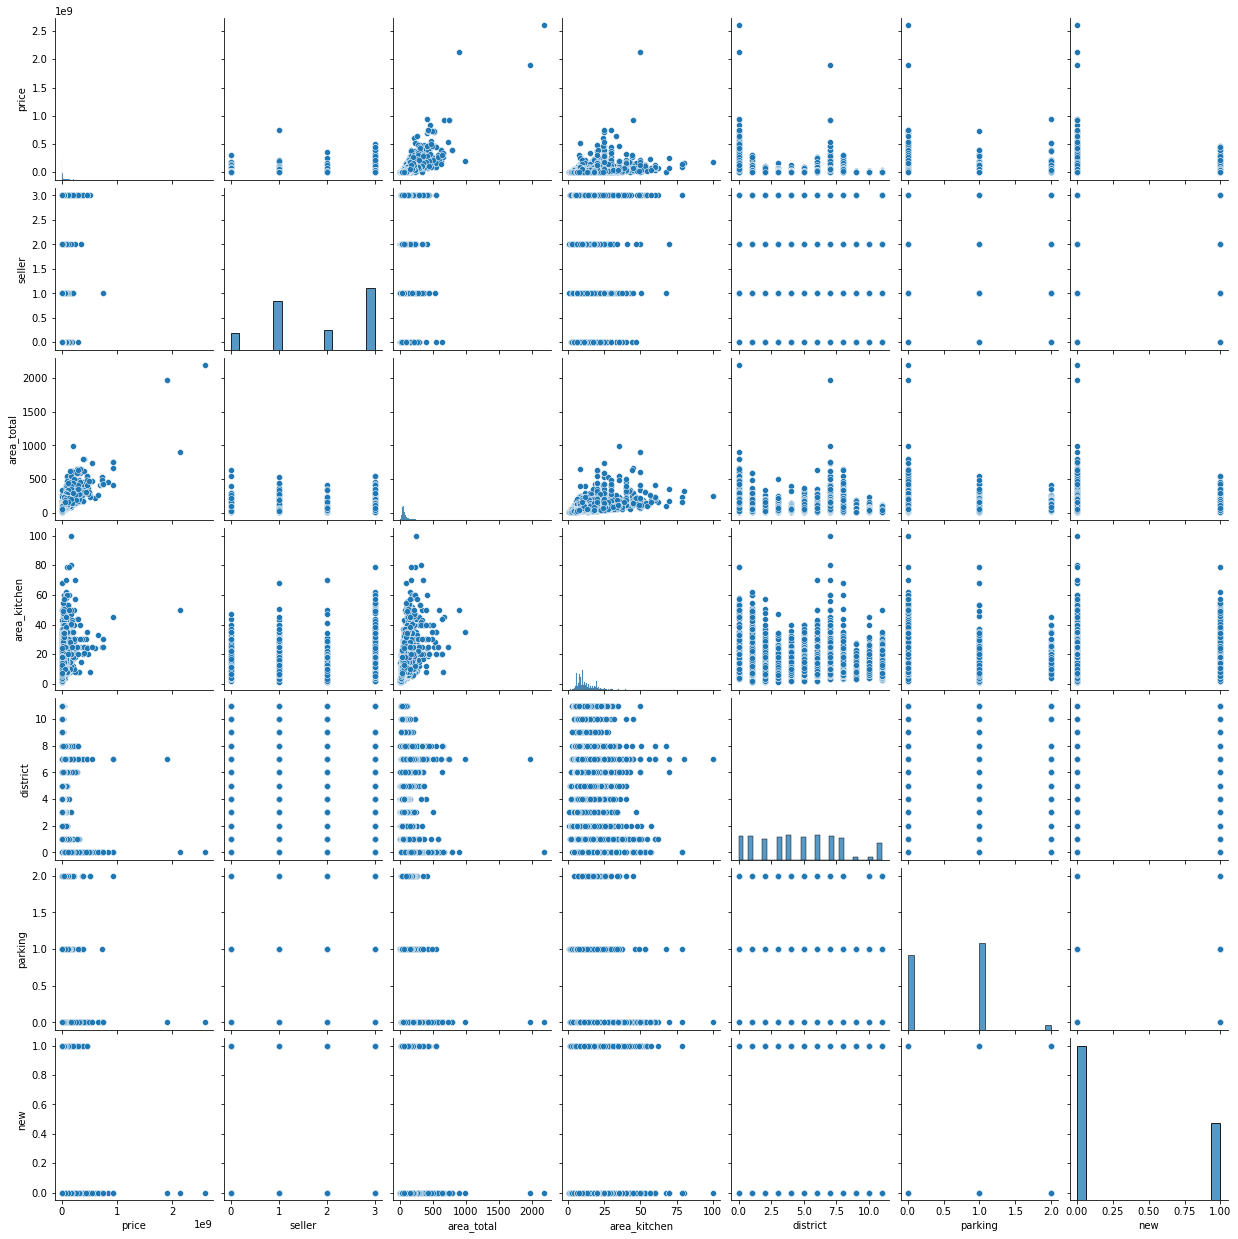

In [414]:
features_scatter = ['price', 'seller', 'area_total','area_kitchen','district','parking','new']
sn.pairplot(X_data_train, vars=features_scatter) #, hue="subcluster")
#X_data_train['theta'].hist()

In [415]:
def radius(df):
    """Calculates the radial distance to the center of moscow, 
    and the angle from the center to the point
    """
    pos_moscow = [55.7530,37.622] #[latitude, longitude] #37.622
    pos = df[['latitude','longitude']].values
    r_dist = []
    beta = []
    for ii in range(len(pos[:,0])):
        r_dist.append(geopy.distance.distance(pos_moscow, pos[ii]).km)
        dL = pos[ii,0]-pos_moscow[0]
        X = np.cos(pos[ii,1])*np.sin(dL)
        Y = np.cos(pos_moscow[1])*np.sin(pos[ii,1])-np.sin(pos_moscow[1])*np.cos(pos[ii,1])*np.cos(dL)
        beta.append(np.arctan(X/Y))
    
    df['rcenter'] = r_dist
    df['theta'] = beta
    return df
X_data_train = radius(X_data_train)

C:\Users\Phili\AppData\Local\Temp/ipykernel_9508/548871765.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rcenter'] = r_dist
C:\Users\Phili\AppData\Local\Temp/ipykernel_9508/548871765.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['theta'] = beta


C:\Users\Phili\AppData\Local\Temp/ipykernel_9508/592307863.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


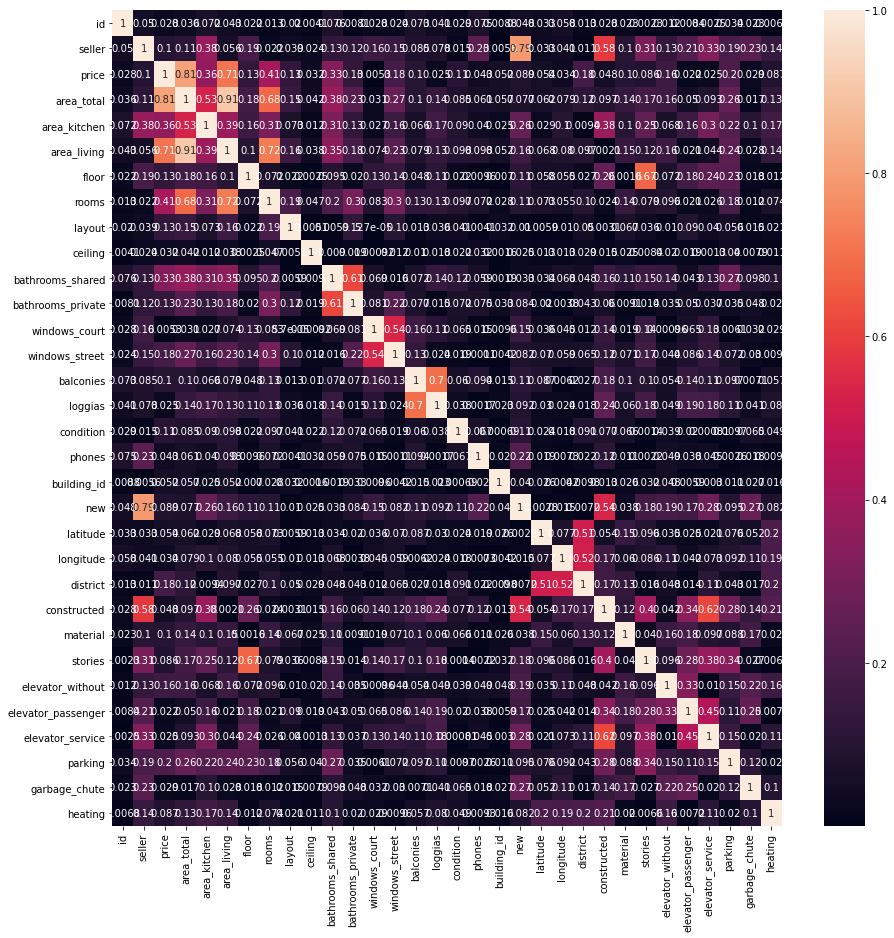

In [416]:
corrMatrix = data_train.corr()
fig = plt.figure(figsize = (15,15))
sn.heatmap(abs(corrMatrix), annot=True)
fig.show()

In [417]:
#handling the nan values
def nan_handling_train(df):
    # dropping lines
    df.dropna(subset = ["bathrooms_shared"], inplace=True)   #possible improvement lines with more than 2 "nan" values
    #df = df.dropna(axis = 1, thresh=2)
    #replace with mean values
    mean_value_living = df['area_living'].mean()
    df.loc[:,['area_living']] = df['area_living'].fillna(mean_value_living)
    mean_value_kitchen = df['area_kitchen'].mean()
    df.loc[:,['area_kitchen']] = df['area_kitchen'].fillna(mean_value_kitchen)
    #inserting certain value
    df[['loggias','balconies','new','parking']] = df[['loggias','balconies','new','parking']].replace(np.nan, 0)
    df.loc[:,['district']] = df['district'].replace(np.nan, 12)

    df[['windows_street','windows_court']] = df[['windows_street','windows_court']].replace(np.nan, 0.5)
    df.loc[:,['ceiling']] = df['ceiling'].replace(np.nan, 0)
    df.loc[:,['condition']] = df['condition'].replace(np.nan, 0)
    df[['seller','heating']] = df[['seller','heating']].replace(np.nan,4)

    #df['new'] = df['new']
    return df
    #
X_data_train_clear = X_data_train #nan_handling_train(X_data_train) #
y_data_train = X_data_train['price']
#drop some values
X_data_train_clear = X_data_train_clear.drop(['layout','id'], axis=1)
print(X_data_train_clear.isnull().sum(axis = 0))

seller                7077
price                    0
area_total               0
area_kitchen          3764
area_living           3091
floor                    0
rooms                    0
ceiling               8839
bathrooms_shared      3100
bathrooms_private     3100
windows_court         6460
windows_street        6460
balconies             8396
loggias               8396
condition             7812
phones                  64
building_id              0
new                    219
latitude                 0
longitude                0
district               108
street                   0
address                  0
constructed            639
material              3151
stories                  0
elevator_without       289
elevator_passenger     289
elevator_service       289
parking               5432
garbage_chute         7022
heating               6484
rcenter                  0
theta                    0
dtype: int64


In [431]:
# features 
contin_features = ['area_total', 'area_kitchen', 
                   #'area_living',
                   'floor']
disc_features = [
                 #'rooms',  
                'ceiling', 'bathrooms_shared', 'bathrooms_private', 
                 #'windows_court',
                 'windows_street', 'balconies', 'loggias',  
                 'condition',
                 #'phones', 'new',
                 #'seller',
                #'district',
                 'latitude','longitude',
                 'parking','heating','rcenter', 'theta']

In [432]:
#split catecorical features
# seller, district
def categorical_transformation(df):
    #X_data_train_clear[['seller','district']].max()
    cat_features = ['seller','district']
    features_cat_t = []
    for cat_f in cat_features:
        x = np.nanmax(df[cat_f])
        for ii in range(int(x)+1):
            name = cat_f + str(ii)
            features_cat_t.append(name)
            transform = np.where(df[cat_f].values == ii, 1, 0)
            df[name]= transform
    return df, features_cat_t

In [433]:
def log_scale(df, features, scaler = StandardScaler()):
    """
    @param df: pandas dataframe
    @param features: list of str denoting the relevant features
    """
    featurevals = df[features].values   # extract feature values into numpy array
    featurevals = np.where(featurevals < 1,1.0,featurevals)
    scaled_features = np.log(featurevals) #scaler.fit_transform(featurevals)    # scale feature values, default: each feature has 0 mean and sd 1
    return scaled_features

In [434]:
from sklearn.impute import KNNImputer
def knn_filling(df,features):
    df[['loggias','balconies','new','parking']] = df[['loggias','balconies','new','parking']].replace(np.nan, 0)
    df.loc[:,['ceiling']] = df['ceiling'].replace(np.nan, 0)
    df.loc[:,['condition']] = df['condition'].replace(np.nan, 0)
    #df.dropna(subset = ["bathrooms_shared"], inplace=True) 
    imputer = KNNImputer(n_neighbors=4)
    array = imputer.fit_transform(df[features],df['price'])
    df_new = pd.DataFrame(array, columns = features)
    return df_new

In [435]:
#Filling the nan values and transform the data

X_data_train_clear, cat_features = categorical_transformation(X_data_train_clear)
X_data_train_knn = knn_filling(X_data_train_clear,disc_features+cat_features+contin_features)
#cat_features.remove('district3')
#cat_features.remove('district9')
X_data_transform = X_data_train_knn[disc_features+cat_features]

X_data_transform[contin_features] = log_scale(X_data_train_knn,contin_features)

C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [436]:
#Random Forrest training
tree = RandomForestRegressor( 
    max_depth = 20,
    n_jobs = 8,
    n_estimators = 200)#DecisionTreeRegressor() #AdaBoostRegressor()#
log_price = pd.DataFrame(np.log(y_data_train.values), columns = ['price'])

model_tree = tree.fit(X =X_data_transform, y =log_price['price']) #y_data_train)

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#import lightgbm as lgb
from catboost import CatBoostRegressor
#ADA boost
ADA = AdaBoostRegressor()
#model_ADA = ADA.fit(X_data_transform, log_price['price'])

GradientB = GradientBoostingRegressor()
#model_GradientB = GradientB.fit(X_data_transform, log_price['price'])

Cat = CatBoostRegressor(
    silent = True )
#model_Cat = Cat.fit(X_data_transform, log_price['price'])

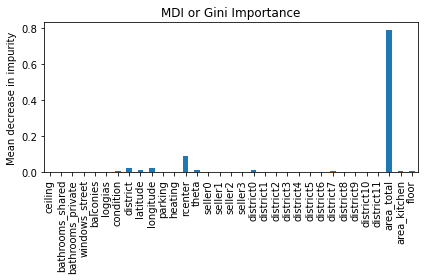

In [437]:
importances = tree.feature_importances_
forest_importances = pd.Series(importances, index=X_data_transform.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
#plt.semilogy()
fig.tight_layout()


In [438]:
#Apply to test data
data_test = test #pd.read_csv('/kaggle/input/moscow-housing-tdt4173/apartments_test.csv',delimiter=',') #test

apartments_test = pd.read_csv('apartments_test.csv',delimiter=',')
buildings_test = pd.read_csv('buildings_test.csv',delimiter=',')
#data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
#

def handle_nan(df):

    df[['latitude','longitude']] = df[['latitude','longitude']].replace(np.nan,80)
    pos = df[['latitude','longitude']].values
    r_dist = []
    beta = []
    pos_moscow = [55.7530,37.622]
    for ii in range(len(pos[:,0])):
        r_dist.append(geopy.distance.distance(pos_moscow, pos[ii]).km)
        dL = pos[ii,0]-pos_moscow[0]
        X = np.cos(pos[ii,1])*np.sin(dL)
        Y = np.cos(pos_moscow[1])*np.sin(pos[ii,1])-np.sin(pos_moscow[1])*np.cos(pos[ii,1])*np.cos(dL)
        beta.append(np.arctan(X/Y))
    df.loc[:,['rcenter']] = r_dist
    df.loc[:,['theta']] = beta
    #handling the nan values
    #df.dropna(subset = ["bathrooms_shared"], inplace=True)   #possible improvement lines with more than 2 "nan" values
    df[['bathrooms_shared','bathrooms_private','phones']] = df[['bathrooms_shared','bathrooms_private','phones']].replace(np.nan, 0.5)
    
    mean_value_living = df['area_living'].mean()
    df.loc[:,['area_living']] = df['area_living'].fillna(mean_value_living)

    mean_value_kitchen = df['area_kitchen'].mean()
    df.loc[:,['area_kitchen']] = df['area_kitchen'].fillna(mean_value_kitchen)
    
    
    df[['loggias','balconies','new','parking']] = df[['loggias','balconies','new','parking']].replace(np.nan, 0)
    df.loc[:,['district']] = df['district'].replace(np.nan, 12)

    df[['windows_street','windows_court']] = df[['windows_street','windows_court']].replace(np.nan, 0)
    df.loc[:,['ceiling']] = df['ceiling'].replace(np.nan, 0)
    df.loc[:,['condition']] = df['condition'].replace(np.nan, 0)
    df[['seller','heating']] = df[['seller','heating']].replace(np.nan,4)
    return df

In [439]:
def handle_nan_knn(df):
    features = ['area_total', 'area_kitchen', 'area_living','floor',
                'rooms',  'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court',
                 'windows_street', 'balconies', 'loggias',  
                 'condition', 'latitude','longitude',
                 'parking','heating','seller0', 'seller1', 'seller2','seller3', 'district0', 
                'district1', 'district2', 'district3', 'district4', 'district5', 'district6', 
                'district7', 'district8', 'district9', 'district10','district11']
    imputer = KNNImputer(n_neighbors=4)
    df[['loggias','balconies','new','parking']] = df[['loggias','balconies','new','parking']].replace(np.nan, 0)
    df.loc[:,['ceiling']] = df['ceiling'].replace(np.nan, 0)
    df.loc[:,['condition']] = df['condition'].replace(np.nan, 0)
    array = imputer.fit_transform(df[features])
    df = pd.DataFrame(array, columns = features)
    pos = df[['latitude','longitude']].values
    r_dist = []
    beta = []
    pos_moscow = [55.7530,37.622]
    for ii in range(len(pos[:,0])):
        r_dist.append(geopy.distance.distance(pos_moscow, pos[ii]).km)
        dL = pos[ii,0]-pos_moscow[0]
        X = np.cos(pos[ii,1])*np.sin(dL)
        Y = np.cos(pos_moscow[1])*np.sin(pos[ii,1])-np.sin(pos_moscow[1])*np.cos(pos[ii,1])*np.cos(dL)
        beta.append(np.arctan(X/Y))
    df.loc[:,['rcenter']] = r_dist
    df.loc[:,['theta']] = beta
    return df

In [440]:
X_data_test, cat_test_features = categorical_transformation(data_test)
#data_test['seller'].hist()
X_data_test = handle_nan_knn(data_test)
#cat_test_features.remove('district3')
#cat_test_features.remove('district9')
X_data_test_transform = X_data_test[disc_features+ cat_test_features]
X_data_test_transform[contin_features] = log_scale(X_data_test,contin_features)

C:\Users\Phili\AppData\Local\Temp/ipykernel_9508/2622245030.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name]= transform
C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

KeyError: "['district'] not in index"

In [ ]:
#model_ test
Y_data_test = model_tree.predict(X_data_test_transform)

#Y_data_test2 = model_ADA.predict(X_data_test_transform)
#Y_data_test3 = model_GradientB.predict(X_data_test_transform)
#Y_data_test4 = model_Cat.predict(X_data_test_transform)


In [ ]:
#X_data_test = handle_nan_knn(data_test) #handle_nan(data_test)
#X_data_test = X_data_test.drop(['layout','id'], axis=1)

# feature transformation
#X_data_test, cat_test_features = categorical_transformation(X_data_test)
#X_data_test_transform = X_data_test[disc_features+ cat_test_features]
#X_data_test_transform[contin_features] = log_scale(X_data_test,contin_features)

#Prediction

#Y_data_test = model_tree.predict(X_data_test_transform)

#Y_data_test2 = model_ADA.predict(X_data_test_transform)
#Y_data_test3 = model_GradientB.predict(X_data_test_transform)
#Y_data_test4 = model_Cat.predict(X_data_test_transform)

#print(X_data_train_transform.isnull().sum(axis = 0))

#data_test['price_prediction'] = np.zeros([len(Y_data_test),4])

In [ ]:
def score(price_predict, price_ref):
    N = len(price_predict)
    score = np.sqrt(sum((price_predict-np.log(price_ref))**2)/N)
    return score


score_tree = score(Y_data_test,test['price'])
print('score_tree', score_tree)

#score_ADA = score(Y_data_test2,test['price'])
#print('score ADA', score_ADA)
#score_Gradient = score(Y_data_test3,test['price'])
#print('score Gradient', score_Gradient)

#score_tree = score(Y_data_test4,test['price'])
#print('score CAt', score_tree)

In [ ]:
score_tree 0.15957951239600224
score_tree 0.1618759671610001
score ADA 0.3253540889465253
score Gradient 0.21158633792229725
score CAt 0.15434313135455532

In [410]:
#submission
data_test['price_prediction'] = np.exp(Y_data_test)

submission = pd.DataFrame()
submission['id'] = data_test['id']
submission['price_prediction'] = data_test['price_prediction']
submission.to_csv('submission_forrest_4.csv', index=False)


(array([3.390e+02, 3.457e+03, 2.935e+03, 1.557e+03, 8.350e+02, 4.940e+02,
        2.170e+02, 8.500e+01, 1.600e+01, 2.000e+00]),
 array([14.80410611, 15.41337098, 16.02263585, 16.63190071, 17.24116558,
        17.85043045, 18.45969532, 19.06896019, 19.67822506, 20.28748993,
        20.89675479]),
 <BarContainer object of 10 artists>)

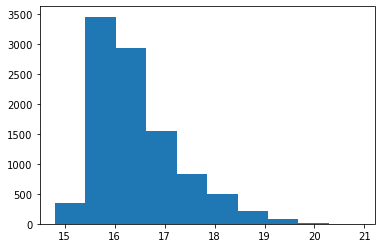

In [409]:
plt.hist(Y_data_test)

## Meta Model

In [275]:
from sklearn.model_selection import KFold
ntrain = X_data_transform.shape[0]
ntest = X_data_test_transform.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [276]:
import lightgbm as lgb

In [277]:
LGB = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=SEED, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

In [390]:
X_train = X_data_transform.values
#X_data_transform, log_price['price']
y_train = y_data_train.ravel() #log_price['price'].ravel()
#len()
dt_oof_train, dt_oof_test = get_oof(tree, X_train, y_train,X_data_test_transform) # X_test)

ValueError: could not broadcast input array from shape (4657,) into shape (9937,)

In [ ]:
ada_oof_train, ada_oof_test = get_oof(ADA, X_train, y_train,X_data_test_transform)
gb_oof_train, gb_oof_test = get_oof(GradientB, X_train, y_train,X_data_test_transform)
cat_oof_train, cat_oof_test = get_oof(Cat, X_train, y_train,X_data_test_transform)
lgbm_oof_train, lgbm_oof_test = get_oof(LGB, X_train, y_train,X_data_test_transform)

In [ ]:
x_train = np.concatenate((
    dt_oof_train,
    ada_oof_train,
    gb_oof_train,
    lgbm_oof_train,
    cat_oof_train
), axis=1)

x_test = np.concatenate((
    dt_oof_test,
    ada_oof_test,
    gb_oof_test,
    lgbm_oof_test,
    cat_oof_test
), axis=1)

In [ ]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=5,
    max_depth=7, 
    random_state=SEED, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=200,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.05
)

META_MODEL.fit(x_train, y_train)
final_predictions = META_MODEL.predict(x_test)

#score_final = score(final_predictions,test['price'])
#print('score of the ensemble:', score_final)

In [282]:
#submission
data_test['price_prediction'] = np.exp(final_predictions)

submission = pd.DataFrame()
submission['id'] = data_test['id']
submission['price_prediction'] = data_test['price_prediction']
submission.to_csv('submission_stacking_knn2.csv', index=False)

Text(0.5, 0, 'price')

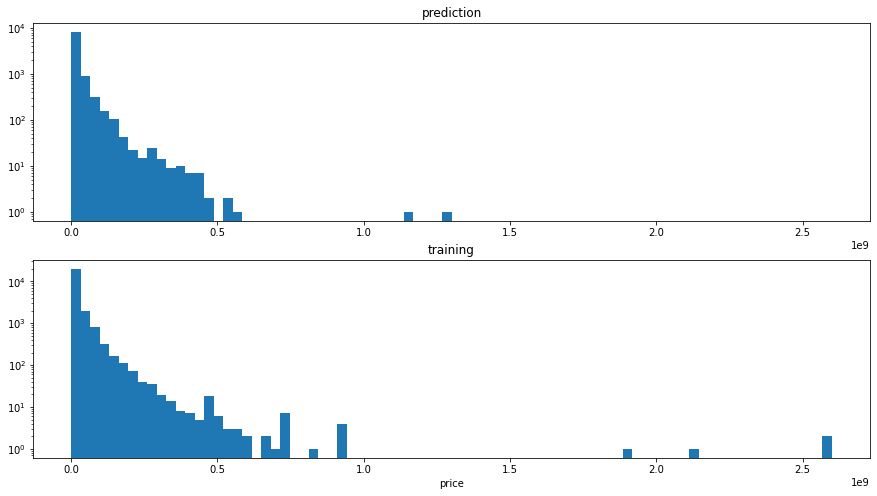

In [336]:
fig, ax = plt.subplots(2, figsize = (15,8))
ax[0].hist(Y_data_test, bins = 80, range=[0, 2.6e9]) #.hist()
ax[0].set_title('prediction')
ax[1].set_title('training')
ax[1].hist(y_data_train, bins = 80, range=[0, 2.6e9]) #.hist()
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('price')